In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [5]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo'
], axis=1)   # Exclude the identifier from the features

In [6]:
train_data = training_features.drop(['line_drive'], axis=1).copy()
train_label = training_features['line_drive'].copy()
testing_data = testing_features.drop(['line_drive'], axis=1).copy()
testing_label = testing_features['line_drive'].copy()

In [7]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [8]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [9]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [10]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [11]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5583171133403204
Log Loss: 0.6755023282998233


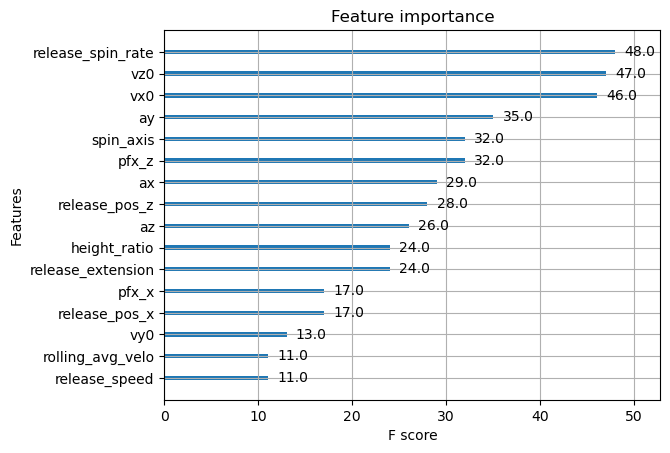

In [12]:
xgb.plot_importance(model)
plt.show()

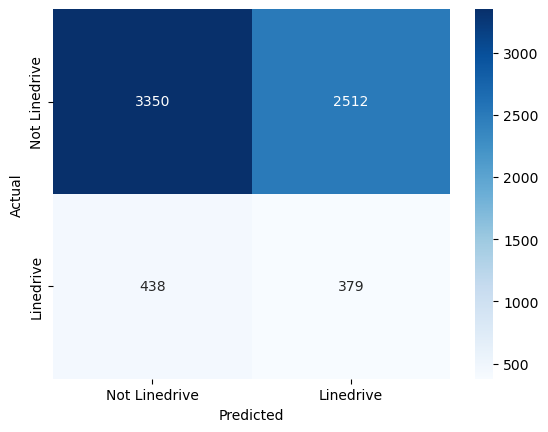

In [13]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [14]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device': 'gpu',
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [15]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 17:06:25,420] A new study created in memory with name: no-name-619bf825-546a-48d8-8744-a559507184ec


[0]	eval-logloss:0.68786
[1]	eval-logloss:0.68576
[2]	eval-logloss:0.68157
[3]	eval-logloss:0.67588
[4]	eval-logloss:0.67294
[5]	eval-logloss:0.67093
[6]	eval-logloss:0.66684
[7]	eval-logloss:0.66481
[8]	eval-logloss:0.66199
[9]	eval-logloss:0.66136
[10]	eval-logloss:0.65878
[11]	eval-logloss:0.65598
[12]	eval-logloss:0.65362
[13]	eval-logloss:0.65216
[14]	eval-logloss:0.64985
[15]	eval-logloss:0.64879
[16]	eval-logloss:0.64889
[17]	eval-logloss:0.64628
[18]	eval-logloss:0.64458
[19]	eval-logloss:0.64283
[20]	eval-logloss:0.64254
[21]	eval-logloss:0.63869
[22]	eval-logloss:0.63695
[23]	eval-logloss:0.63584
[24]	eval-logloss:0.63659
[25]	eval-logloss:0.63552
[26]	eval-logloss:0.63173
[27]	eval-logloss:0.62954
[28]	eval-logloss:0.62691
[29]	eval-logloss:0.62626
[30]	eval-logloss:0.62440
[31]	eval-logloss:0.62352
[32]	eval-logloss:0.62137
[33]	eval-logloss:0.61986
[34]	eval-logloss:0.61721
[35]	eval-logloss:0.61619
[36]	eval-logloss:0.61647
[37]	eval-logloss:0.61499
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:26,828] Trial 0 finished with value: 0.5427712715790265 and parameters: {'max_depth': 7, 'eta': 0.12833862654452677, 'subsample': 0.6680990716292865, 'colsample_bytree': 0.6259023151765923}. Best is trial 0 with value: 0.5427712715790265.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.67879
[2]	eval-logloss:0.67079
[3]	eval-logloss:0.66531
[4]	eval-logloss:0.65890
[5]	eval-logloss:0.65450
[6]	eval-logloss:0.65171
[7]	eval-logloss:0.64817
[8]	eval-logloss:0.64462
[9]	eval-logloss:0.64003
[10]	eval-logloss:0.63562
[11]	eval-logloss:0.63573
[12]	eval-logloss:0.63330
[13]	eval-logloss:0.63016
[14]	eval-logloss:0.62414
[15]	eval-logloss:0.61985
[16]	eval-logloss:0.61629
[17]	eval-logloss:0.61546
[18]	eval-logloss:0.61268
[19]	eval-logloss:0.60828
[20]	eval-logloss:0.60596
[21]	eval-logloss:0.60170
[22]	eval-logloss:0.59649
[23]	eval-logloss:0.59298
[24]	eval-logloss:0.59026
[25]	eval-logloss:0.58995
[26]	eval-logloss:0.58740
[27]	eval-logloss:0.58523
[28]	eval-logloss:0.58102
[29]	eval-logloss:0.57876
[30]	eval-logloss:0.57808
[31]	eval-logloss:0.57639
[32]	eval-logloss:0.57321
[33]	eval-logloss:0.56830
[34]	eval-logloss:0.56690
[35]	eval-logloss:0.56396
[36]	eval-logloss:0.56375
[37]	eval-logloss:0.56126
[38]	eval-logloss:0.55

[I 2023-11-15 17:06:28,410] Trial 1 finished with value: 0.46777391485436165 and parameters: {'max_depth': 8, 'eta': 0.20338317568537145, 'subsample': 0.8480240725137518, 'colsample_bytree': 0.9901963980701433}. Best is trial 1 with value: 0.46777391485436165.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66496
[2]	eval-logloss:0.65494
[3]	eval-logloss:0.64458
[4]	eval-logloss:0.63615
[5]	eval-logloss:0.63312
[6]	eval-logloss:0.62493
[7]	eval-logloss:0.62162
[8]	eval-logloss:0.61513
[9]	eval-logloss:0.61313
[10]	eval-logloss:0.60722
[11]	eval-logloss:0.60870
[12]	eval-logloss:0.60343
[13]	eval-logloss:0.60162
[14]	eval-logloss:0.59875
[15]	eval-logloss:0.59676
[16]	eval-logloss:0.59312
[17]	eval-logloss:0.59056
[18]	eval-logloss:0.58901
[19]	eval-logloss:0.58440
[20]	eval-logloss:0.58028
[21]	eval-logloss:0.57175
[22]	eval-logloss:0.56790
[23]	eval-logloss:0.56475
[24]	eval-logloss:0.56456
[25]	eval-logloss:0.56245
[26]	eval-logloss:0.55867
[27]	eval-logloss:0.55726
[28]	eval-logloss:0.55672
[29]	eval-logloss:0.55491
[30]	eval-logloss:0.54952
[31]	eval-logloss:0.54868
[32]	eval-logloss:0.54791
[33]	eval-logloss:0.54610
[34]	eval-logloss:0.54481
[35]	eval-logloss:0.54511
[36]	eval-logloss:0.54583
[37]	eval-logloss:0.54208
[38]	eval-logloss:0.53

[I 2023-11-15 17:06:30,224] Trial 2 finished with value: 0.4633163198387468 and parameters: {'max_depth': 9, 'eta': 0.1975518168643195, 'subsample': 0.6355466051991905, 'colsample_bytree': 0.5406094445176801}. Best is trial 2 with value: 0.4633163198387468.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69224
[3]	eval-logloss:0.69196
[4]	eval-logloss:0.69169
[5]	eval-logloss:0.69151
[6]	eval-logloss:0.69121
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69079
[9]	eval-logloss:0.69065
[10]	eval-logloss:0.69068
[11]	eval-logloss:0.69068
[12]	eval-logloss:0.69035
[13]	eval-logloss:0.69017
[14]	eval-logloss:0.68977
[15]	eval-logloss:0.68962
[16]	eval-logloss:0.68935
[17]	eval-logloss:0.68929
[18]	eval-logloss:0.68901
[19]	eval-logloss:0.68897
[20]	eval-logloss:0.68887
[21]	eval-logloss:0.68861
[22]	eval-logloss:0.68838
[23]	eval-logloss:0.68817
[24]	eval-logloss:0.68796
[25]	eval-logloss:0.68787
[26]	eval-logloss:0.68746
[27]	eval-logloss:0.68723
[28]	eval-logloss:0.68715
[29]	eval-logloss:0.68700
[30]	eval-logloss:0.68692
[31]	eval-logloss:0.68672
[32]	eval-logloss:0.68657
[33]	eval-logloss:0.68636
[34]	eval-logloss:0.68612
[35]	eval-logloss:0.68613
[36]	eval-logloss:0.68603
[37]	eval-logloss:0.68568
[38]	eval-logloss:0.68

[I 2023-11-15 17:06:30,837] Trial 3 finished with value: 0.678666173388641 and parameters: {'max_depth': 3, 'eta': 0.04103433188723022, 'subsample': 0.8717438322242876, 'colsample_bytree': 0.7418718219046689}. Best is trial 2 with value: 0.4633163198387468.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68894
[3]	eval-logloss:0.68644
[4]	eval-logloss:0.68341
[5]	eval-logloss:0.68380
[6]	eval-logloss:0.68050
[7]	eval-logloss:0.68091
[8]	eval-logloss:0.67896
[9]	eval-logloss:0.68009
[10]	eval-logloss:0.67764
[11]	eval-logloss:0.67687
[12]	eval-logloss:0.67713
[13]	eval-logloss:0.67783
[14]	eval-logloss:0.67893
[15]	eval-logloss:0.67743
[16]	eval-logloss:0.67738
[17]	eval-logloss:0.67744
[18]	eval-logloss:0.67603
[19]	eval-logloss:0.67527
[20]	eval-logloss:0.67473
[21]	eval-logloss:0.67193
[22]	eval-logloss:0.67096
[23]	eval-logloss:0.67008
[24]	eval-logloss:0.67495
[25]	eval-logloss:0.67645
[26]	eval-logloss:0.67181
[27]	eval-logloss:0.67269
[28]	eval-logloss:0.67322
[29]	eval-logloss:0.67269
[30]	eval-logloss:0.66996
[31]	eval-logloss:0.66693
[32]	eval-logloss:0.66835
[33]	eval-logloss:0.66700
[34]	eval-logloss:0.66486
[35]	eval-logloss:0.66611
[36]	eval-logloss:0.66884
[37]	eval-logloss:0.66741
[38]	eval-logloss:0.66

[I 2023-11-15 17:06:31,585] Trial 4 finished with value: 0.6276430189579223 and parameters: {'max_depth': 4, 'eta': 0.26294618445324197, 'subsample': 0.6289064838511887, 'colsample_bytree': 0.8380641759009869}. Best is trial 2 with value: 0.4633163198387468.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68560
[2]	eval-logloss:0.68152
[3]	eval-logloss:0.67843
[4]	eval-logloss:0.67612
[5]	eval-logloss:0.67413
[6]	eval-logloss:0.67231
[7]	eval-logloss:0.66942
[8]	eval-logloss:0.66622
[9]	eval-logloss:0.66521
[10]	eval-logloss:0.66367
[11]	eval-logloss:0.66105
[12]	eval-logloss:0.65910
[13]	eval-logloss:0.65676
[14]	eval-logloss:0.65477
[15]	eval-logloss:0.65332
[16]	eval-logloss:0.65271
[17]	eval-logloss:0.65201
[18]	eval-logloss:0.65023
[19]	eval-logloss:0.64959
[20]	eval-logloss:0.64804
[21]	eval-logloss:0.64692
[22]	eval-logloss:0.64462
[23]	eval-logloss:0.64073
[24]	eval-logloss:0.63939
[25]	eval-logloss:0.63915
[26]	eval-logloss:0.63416
[27]	eval-logloss:0.63242
[28]	eval-logloss:0.63079
[29]	eval-logloss:0.62955
[30]	eval-logloss:0.62982
[31]	eval-logloss:0.62810
[32]	eval-logloss:0.62724
[33]	eval-logloss:0.62579
[34]	eval-logloss:0.62471
[35]	eval-logloss:0.62258
[36]	eval-logloss:0.62249
[37]	eval-logloss:0.62000
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:32,637] Trial 5 finished with value: 0.557619870847149 and parameters: {'max_depth': 6, 'eta': 0.18950434510851566, 'subsample': 0.8961928091922113, 'colsample_bytree': 0.8117258731719048}. Best is trial 2 with value: 0.4633163198387468.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68751
[5]	eval-logloss:0.68679
[6]	eval-logloss:0.68495
[7]	eval-logloss:0.68454
[8]	eval-logloss:0.68293
[9]	eval-logloss:0.68257
[10]	eval-logloss:0.68159
[11]	eval-logloss:0.68206
[12]	eval-logloss:0.68100
[13]	eval-logloss:0.68091
[14]	eval-logloss:0.68002
[15]	eval-logloss:0.67964
[16]	eval-logloss:0.67935
[17]	eval-logloss:0.67934
[18]	eval-logloss:0.67841
[19]	eval-logloss:0.67823
[20]	eval-logloss:0.67824
[21]	eval-logloss:0.67798
[22]	eval-logloss:0.67751
[23]	eval-logloss:0.67600
[24]	eval-logloss:0.67586
[25]	eval-logloss:0.67625
[26]	eval-logloss:0.67451
[27]	eval-logloss:0.67442
[28]	eval-logloss:0.67436
[29]	eval-logloss:0.67352
[30]	eval-logloss:0.67300
[31]	eval-logloss:0.67178
[32]	eval-logloss:0.67150
[33]	eval-logloss:0.67008
[34]	eval-logloss:0.67010
[35]	eval-logloss:0.67060
[36]	eval-logloss:0.67144
[37]	eval-logloss:0.67065
[38]	eval-logloss:0.66

[I 2023-11-15 17:06:33,366] Trial 6 finished with value: 0.6480557258419428 and parameters: {'max_depth': 4, 'eta': 0.1306305535520439, 'subsample': 0.7929697462570893, 'colsample_bytree': 0.8539836678482862}. Best is trial 2 with value: 0.4633163198387468.


[0]	eval-logloss:0.68844
[1]	eval-logloss:0.68559
[2]	eval-logloss:0.68007
[3]	eval-logloss:0.67599
[4]	eval-logloss:0.67432
[5]	eval-logloss:0.67182
[6]	eval-logloss:0.66922
[7]	eval-logloss:0.66721
[8]	eval-logloss:0.66509
[9]	eval-logloss:0.66515
[10]	eval-logloss:0.66358
[11]	eval-logloss:0.66247
[12]	eval-logloss:0.65879
[13]	eval-logloss:0.65646
[14]	eval-logloss:0.65441
[15]	eval-logloss:0.65308
[16]	eval-logloss:0.65094
[17]	eval-logloss:0.64902
[18]	eval-logloss:0.64724
[19]	eval-logloss:0.64542
[20]	eval-logloss:0.64429
[21]	eval-logloss:0.64282
[22]	eval-logloss:0.64095
[23]	eval-logloss:0.63876
[24]	eval-logloss:0.63749
[25]	eval-logloss:0.63784
[26]	eval-logloss:0.63595
[27]	eval-logloss:0.63573
[28]	eval-logloss:0.63341
[29]	eval-logloss:0.63207
[30]	eval-logloss:0.62954
[31]	eval-logloss:0.62782
[32]	eval-logloss:0.62459
[33]	eval-logloss:0.62356
[34]	eval-logloss:0.62301
[35]	eval-logloss:0.62218
[36]	eval-logloss:0.62202
[37]	eval-logloss:0.62084
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:34,341] Trial 7 finished with value: 0.5487234752790567 and parameters: {'max_depth': 6, 'eta': 0.24583323556945838, 'subsample': 0.8833333210169257, 'colsample_bytree': 0.7021495047070119}. Best is trial 2 with value: 0.4633163198387468.


[0]	eval-logloss:0.68792
[1]	eval-logloss:0.68420
[2]	eval-logloss:0.68134
[3]	eval-logloss:0.67872
[4]	eval-logloss:0.67613
[5]	eval-logloss:0.67372
[6]	eval-logloss:0.66873
[7]	eval-logloss:0.66834
[8]	eval-logloss:0.66453
[9]	eval-logloss:0.66347
[10]	eval-logloss:0.66183
[11]	eval-logloss:0.66152
[12]	eval-logloss:0.65944
[13]	eval-logloss:0.65849
[14]	eval-logloss:0.65619
[15]	eval-logloss:0.65481
[16]	eval-logloss:0.65499
[17]	eval-logloss:0.65515
[18]	eval-logloss:0.65294
[19]	eval-logloss:0.65143
[20]	eval-logloss:0.65048
[21]	eval-logloss:0.64985
[22]	eval-logloss:0.64783
[23]	eval-logloss:0.64582
[24]	eval-logloss:0.64629
[25]	eval-logloss:0.64495
[26]	eval-logloss:0.64110
[27]	eval-logloss:0.63957
[28]	eval-logloss:0.63882
[29]	eval-logloss:0.63746
[30]	eval-logloss:0.63564
[31]	eval-logloss:0.63489
[32]	eval-logloss:0.63477
[33]	eval-logloss:0.63276
[34]	eval-logloss:0.63147
[35]	eval-logloss:0.63161
[36]	eval-logloss:0.63101
[37]	eval-logloss:0.62996
[38]	eval-logloss:0.62

[I 2023-11-15 17:06:35,347] Trial 8 finished with value: 0.5669530182577242 and parameters: {'max_depth': 6, 'eta': 0.18616198227202924, 'subsample': 0.7297619734589937, 'colsample_bytree': 0.7431874772443452}. Best is trial 2 with value: 0.4633163198387468.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68496
[2]	eval-logloss:0.68060
[3]	eval-logloss:0.67605
[4]	eval-logloss:0.67282
[5]	eval-logloss:0.66995
[6]	eval-logloss:0.66597
[7]	eval-logloss:0.66344
[8]	eval-logloss:0.66101
[9]	eval-logloss:0.65929
[10]	eval-logloss:0.65651
[11]	eval-logloss:0.65513
[12]	eval-logloss:0.65144
[13]	eval-logloss:0.65132
[14]	eval-logloss:0.64958
[15]	eval-logloss:0.64842
[16]	eval-logloss:0.64675
[17]	eval-logloss:0.64469
[18]	eval-logloss:0.64340
[19]	eval-logloss:0.64119
[20]	eval-logloss:0.63928
[21]	eval-logloss:0.63751
[22]	eval-logloss:0.63672
[23]	eval-logloss:0.63503
[24]	eval-logloss:0.63424
[25]	eval-logloss:0.63298
[26]	eval-logloss:0.63056
[27]	eval-logloss:0.63010
[28]	eval-logloss:0.62908
[29]	eval-logloss:0.62802
[30]	eval-logloss:0.62510
[31]	eval-logloss:0.62352
[32]	eval-logloss:0.62188
[33]	eval-logloss:0.62068
[34]	eval-logloss:0.61862
[35]	eval-logloss:0.61738
[36]	eval-logloss:0.61656
[37]	eval-logloss:0.61594
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:36,703] Trial 9 finished with value: 0.5585130154133365 and parameters: {'max_depth': 8, 'eta': 0.06407100608131648, 'subsample': 0.6060547280965514, 'colsample_bytree': 0.8297892363433652}. Best is trial 2 with value: 0.4633163198387468.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.66157
[2]	eval-logloss:0.65211
[3]	eval-logloss:0.64813
[4]	eval-logloss:0.64303
[5]	eval-logloss:0.63552
[6]	eval-logloss:0.62460
[7]	eval-logloss:0.62075
[8]	eval-logloss:0.61829
[9]	eval-logloss:0.61507
[10]	eval-logloss:0.61192
[11]	eval-logloss:0.60906
[12]	eval-logloss:0.59998
[13]	eval-logloss:0.59777
[14]	eval-logloss:0.59185
[15]	eval-logloss:0.59084
[16]	eval-logloss:0.58983
[17]	eval-logloss:0.58705
[18]	eval-logloss:0.58258
[19]	eval-logloss:0.57884
[20]	eval-logloss:0.57334
[21]	eval-logloss:0.56900
[22]	eval-logloss:0.56624
[23]	eval-logloss:0.55940
[24]	eval-logloss:0.56094
[25]	eval-logloss:0.56005
[26]	eval-logloss:0.55386
[27]	eval-logloss:0.55281
[28]	eval-logloss:0.55084
[29]	eval-logloss:0.54618
[30]	eval-logloss:0.53784
[31]	eval-logloss:0.53776
[32]	eval-logloss:0.53445
[33]	eval-logloss:0.53023
[34]	eval-logloss:0.52778
[35]	eval-logloss:0.52660
[36]	eval-logloss:0.52423
[37]	eval-logloss:0.52426
[38]	eval-logloss:0.52

[I 2023-11-15 17:06:38,710] Trial 10 finished with value: 0.48689008126454947 and parameters: {'max_depth': 9, 'eta': 0.2957855617209506, 'subsample': 0.6937064430449371, 'colsample_bytree': 0.526862308944259}. Best is trial 2 with value: 0.4633163198387468.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.67158
[2]	eval-logloss:0.65966
[3]	eval-logloss:0.65342
[4]	eval-logloss:0.64686
[5]	eval-logloss:0.63767
[6]	eval-logloss:0.63340
[7]	eval-logloss:0.62853
[8]	eval-logloss:0.62250
[9]	eval-logloss:0.61537
[10]	eval-logloss:0.60860
[11]	eval-logloss:0.60737
[12]	eval-logloss:0.60188
[13]	eval-logloss:0.59607
[14]	eval-logloss:0.59369
[15]	eval-logloss:0.58748
[16]	eval-logloss:0.58541
[17]	eval-logloss:0.58239
[18]	eval-logloss:0.57933
[19]	eval-logloss:0.57476
[20]	eval-logloss:0.57419
[21]	eval-logloss:0.57111
[22]	eval-logloss:0.56807
[23]	eval-logloss:0.56242
[24]	eval-logloss:0.55709
[25]	eval-logloss:0.55740
[26]	eval-logloss:0.55384
[27]	eval-logloss:0.54947
[28]	eval-logloss:0.54582
[29]	eval-logloss:0.54092
[30]	eval-logloss:0.53682
[31]	eval-logloss:0.53296
[32]	eval-logloss:0.53029
[33]	eval-logloss:0.52618
[34]	eval-logloss:0.52441
[35]	eval-logloss:0.52382
[36]	eval-logloss:0.52147
[37]	eval-logloss:0.51910
[38]	eval-logloss:0.51

[I 2023-11-15 17:06:40,806] Trial 11 finished with value: 0.4587437203000928 and parameters: {'max_depth': 9, 'eta': 0.22100594067566928, 'subsample': 0.7969242144483415, 'colsample_bytree': 0.9855391113661771}. Best is trial 11 with value: 0.4587437203000928.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.67042
[2]	eval-logloss:0.65997
[3]	eval-logloss:0.65350
[4]	eval-logloss:0.64432
[5]	eval-logloss:0.63844
[6]	eval-logloss:0.62949
[7]	eval-logloss:0.62202
[8]	eval-logloss:0.61620
[9]	eval-logloss:0.60834
[10]	eval-logloss:0.59958
[11]	eval-logloss:0.59870
[12]	eval-logloss:0.59108
[13]	eval-logloss:0.58487
[14]	eval-logloss:0.58287
[15]	eval-logloss:0.58052
[16]	eval-logloss:0.57843
[17]	eval-logloss:0.57421
[18]	eval-logloss:0.56938
[19]	eval-logloss:0.56408
[20]	eval-logloss:0.56162
[21]	eval-logloss:0.55632
[22]	eval-logloss:0.55082
[23]	eval-logloss:0.54766
[24]	eval-logloss:0.54313
[25]	eval-logloss:0.54083
[26]	eval-logloss:0.53733
[27]	eval-logloss:0.53383
[28]	eval-logloss:0.53316
[29]	eval-logloss:0.53185
[30]	eval-logloss:0.52948
[31]	eval-logloss:0.52766
[32]	eval-logloss:0.52659
[33]	eval-logloss:0.52324
[34]	eval-logloss:0.52134
[35]	eval-logloss:0.51964
[36]	eval-logloss:0.51949
[37]	eval-logloss:0.51872
[38]	eval-logloss:0.51

[I 2023-11-15 17:06:42,818] Trial 12 finished with value: 0.45448604969443246 and parameters: {'max_depth': 9, 'eta': 0.236562977954005, 'subsample': 0.7708464764607341, 'colsample_bytree': 0.5296414542321994}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.68132
[1]	eval-logloss:0.67308
[2]	eval-logloss:0.66291
[3]	eval-logloss:0.65491
[4]	eval-logloss:0.64893
[5]	eval-logloss:0.64362
[6]	eval-logloss:0.63854
[7]	eval-logloss:0.63574
[8]	eval-logloss:0.62911
[9]	eval-logloss:0.62546
[10]	eval-logloss:0.61731
[11]	eval-logloss:0.61722
[12]	eval-logloss:0.61281
[13]	eval-logloss:0.60780
[14]	eval-logloss:0.60253
[15]	eval-logloss:0.60141
[16]	eval-logloss:0.60079
[17]	eval-logloss:0.59727
[18]	eval-logloss:0.59560
[19]	eval-logloss:0.59152
[20]	eval-logloss:0.58827
[21]	eval-logloss:0.58629
[22]	eval-logloss:0.57900
[23]	eval-logloss:0.57505
[24]	eval-logloss:0.57319
[25]	eval-logloss:0.57209
[26]	eval-logloss:0.56572
[27]	eval-logloss:0.56154
[28]	eval-logloss:0.55860
[29]	eval-logloss:0.55535
[30]	eval-logloss:0.55433
[31]	eval-logloss:0.55229
[32]	eval-logloss:0.54789
[33]	eval-logloss:0.54596
[34]	eval-logloss:0.54346
[35]	eval-logloss:0.54161
[36]	eval-logloss:0.54185
[37]	eval-logloss:0.54199
[38]	eval-logloss:0.54

[I 2023-11-15 17:06:44,589] Trial 13 finished with value: 0.47114947771997917 and parameters: {'max_depth': 8, 'eta': 0.2514787670905835, 'subsample': 0.7829991693377332, 'colsample_bytree': 0.9801040339723158}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.66997
[2]	eval-logloss:0.66067
[3]	eval-logloss:0.65229
[4]	eval-logloss:0.64568
[5]	eval-logloss:0.63688
[6]	eval-logloss:0.63166
[7]	eval-logloss:0.62806
[8]	eval-logloss:0.61974
[9]	eval-logloss:0.61092
[10]	eval-logloss:0.60487
[11]	eval-logloss:0.60261
[12]	eval-logloss:0.59987
[13]	eval-logloss:0.59572
[14]	eval-logloss:0.58832
[15]	eval-logloss:0.58779
[16]	eval-logloss:0.58278
[17]	eval-logloss:0.58039
[18]	eval-logloss:0.57777
[19]	eval-logloss:0.57373
[20]	eval-logloss:0.57071
[21]	eval-logloss:0.56703
[22]	eval-logloss:0.56474
[23]	eval-logloss:0.56002
[24]	eval-logloss:0.55481
[25]	eval-logloss:0.55300
[26]	eval-logloss:0.55031
[27]	eval-logloss:0.54709
[28]	eval-logloss:0.54366
[29]	eval-logloss:0.54175
[30]	eval-logloss:0.54195
[31]	eval-logloss:0.53893
[32]	eval-logloss:0.53552
[33]	eval-logloss:0.53364
[34]	eval-logloss:0.53187
[35]	eval-logloss:0.52957
[36]	eval-logloss:0.52875
[37]	eval-logloss:0.52686
[38]	eval-logloss:0.52

[I 2023-11-15 17:06:46,809] Trial 14 finished with value: 0.4608301754248239 and parameters: {'max_depth': 9, 'eta': 0.23437291833934393, 'subsample': 0.8119998221136809, 'colsample_bytree': 0.6257820126616401}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.68396
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.67108
[3]	eval-logloss:0.66661
[4]	eval-logloss:0.66265
[5]	eval-logloss:0.65848
[6]	eval-logloss:0.65327
[7]	eval-logloss:0.65178
[8]	eval-logloss:0.64391
[9]	eval-logloss:0.64229
[10]	eval-logloss:0.63839
[11]	eval-logloss:0.63797
[12]	eval-logloss:0.63364
[13]	eval-logloss:0.63150
[14]	eval-logloss:0.62813
[15]	eval-logloss:0.62730
[16]	eval-logloss:0.62436
[17]	eval-logloss:0.62377
[18]	eval-logloss:0.62040
[19]	eval-logloss:0.62108
[20]	eval-logloss:0.61974
[21]	eval-logloss:0.61431
[22]	eval-logloss:0.60895
[23]	eval-logloss:0.60470
[24]	eval-logloss:0.60575
[25]	eval-logloss:0.60450
[26]	eval-logloss:0.59782
[27]	eval-logloss:0.59724
[28]	eval-logloss:0.59686
[29]	eval-logloss:0.59303
[30]	eval-logloss:0.59049
[31]	eval-logloss:0.58786
[32]	eval-logloss:0.58731
[33]	eval-logloss:0.58423
[34]	eval-logloss:0.58162
[35]	eval-logloss:0.58188
[36]	eval-logloss:0.58066
[37]	eval-logloss:0.57961
[38]	eval-logloss:0.57

[I 2023-11-15 17:06:48,425] Trial 15 finished with value: 0.5050171209744768 and parameters: {'max_depth': 7, 'eta': 0.28504774180119874, 'subsample': 0.7331594447235219, 'colsample_bytree': 0.9202516350974682}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.68058
[2]	eval-logloss:0.67561
[3]	eval-logloss:0.66999
[4]	eval-logloss:0.66735
[5]	eval-logloss:0.66399
[6]	eval-logloss:0.66092
[7]	eval-logloss:0.65807
[8]	eval-logloss:0.65325
[9]	eval-logloss:0.64925
[10]	eval-logloss:0.64581
[11]	eval-logloss:0.64515
[12]	eval-logloss:0.64293
[13]	eval-logloss:0.64097
[14]	eval-logloss:0.63772
[15]	eval-logloss:0.63602
[16]	eval-logloss:0.63278
[17]	eval-logloss:0.63233
[18]	eval-logloss:0.62857
[19]	eval-logloss:0.62781
[20]	eval-logloss:0.62605
[21]	eval-logloss:0.62470
[22]	eval-logloss:0.62096
[23]	eval-logloss:0.61955
[24]	eval-logloss:0.61904
[25]	eval-logloss:0.61307
[26]	eval-logloss:0.60760
[27]	eval-logloss:0.60486
[28]	eval-logloss:0.60329
[29]	eval-logloss:0.60063
[30]	eval-logloss:0.59894
[31]	eval-logloss:0.59533
[32]	eval-logloss:0.59634
[33]	eval-logloss:0.59290
[34]	eval-logloss:0.59239
[35]	eval-logloss:0.59199
[36]	eval-logloss:0.59215
[37]	eval-logloss:0.59087
[38]	eval-logloss:0.59

[I 2023-11-15 17:06:49,877] Trial 16 finished with value: 0.5028142938778504 and parameters: {'max_depth': 7, 'eta': 0.2292965834296789, 'subsample': 0.7643192608359577, 'colsample_bytree': 0.9135329663391807}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67495
[2]	eval-logloss:0.66869
[3]	eval-logloss:0.66211
[4]	eval-logloss:0.65767
[5]	eval-logloss:0.65320
[6]	eval-logloss:0.64595
[7]	eval-logloss:0.64178
[8]	eval-logloss:0.63544
[9]	eval-logloss:0.63063
[10]	eval-logloss:0.62393
[11]	eval-logloss:0.62222
[12]	eval-logloss:0.61977
[13]	eval-logloss:0.61508
[14]	eval-logloss:0.61270
[15]	eval-logloss:0.61163
[16]	eval-logloss:0.60730
[17]	eval-logloss:0.60467
[18]	eval-logloss:0.60093
[19]	eval-logloss:0.60001
[20]	eval-logloss:0.59582
[21]	eval-logloss:0.59322
[22]	eval-logloss:0.58830
[23]	eval-logloss:0.58604
[24]	eval-logloss:0.58534
[25]	eval-logloss:0.58460
[26]	eval-logloss:0.58248
[27]	eval-logloss:0.57875
[28]	eval-logloss:0.57776
[29]	eval-logloss:0.57434
[30]	eval-logloss:0.57038
[31]	eval-logloss:0.56638
[32]	eval-logloss:0.56481
[33]	eval-logloss:0.56269
[34]	eval-logloss:0.56137
[35]	eval-logloss:0.56084
[36]	eval-logloss:0.56092
[37]	eval-logloss:0.55773
[38]	eval-logloss:0.55

[I 2023-11-15 17:06:51,907] Trial 17 finished with value: 0.46881604648281283 and parameters: {'max_depth': 9, 'eta': 0.14855472827541066, 'subsample': 0.8295036691464417, 'colsample_bytree': 0.5020299842044949}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.68239
[1]	eval-logloss:0.67555
[2]	eval-logloss:0.66808
[3]	eval-logloss:0.66318
[4]	eval-logloss:0.65538
[5]	eval-logloss:0.65007
[6]	eval-logloss:0.64435
[7]	eval-logloss:0.64020
[8]	eval-logloss:0.63008
[9]	eval-logloss:0.62531
[10]	eval-logloss:0.62119
[11]	eval-logloss:0.62135
[12]	eval-logloss:0.61300
[13]	eval-logloss:0.60844
[14]	eval-logloss:0.60693
[15]	eval-logloss:0.60660
[16]	eval-logloss:0.60250
[17]	eval-logloss:0.60110
[18]	eval-logloss:0.59793
[19]	eval-logloss:0.59637
[20]	eval-logloss:0.59497
[21]	eval-logloss:0.59091
[22]	eval-logloss:0.58419
[23]	eval-logloss:0.57658
[24]	eval-logloss:0.57676
[25]	eval-logloss:0.57367
[26]	eval-logloss:0.56979
[27]	eval-logloss:0.56834
[28]	eval-logloss:0.56669
[29]	eval-logloss:0.56366
[30]	eval-logloss:0.56110
[31]	eval-logloss:0.55845
[32]	eval-logloss:0.55899
[33]	eval-logloss:0.55512
[34]	eval-logloss:0.55515
[35]	eval-logloss:0.55294
[36]	eval-logloss:0.55298
[37]	eval-logloss:0.55127
[38]	eval-logloss:0.55

[I 2023-11-15 17:06:53,677] Trial 18 finished with value: 0.4755225276962252 and parameters: {'max_depth': 8, 'eta': 0.274233090464878, 'subsample': 0.7604067716684005, 'colsample_bytree': 0.6731454055262317}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.68599
[2]	eval-logloss:0.68404
[3]	eval-logloss:0.68181
[4]	eval-logloss:0.67883
[5]	eval-logloss:0.67656
[6]	eval-logloss:0.67419
[7]	eval-logloss:0.67389
[8]	eval-logloss:0.67056
[9]	eval-logloss:0.66921
[10]	eval-logloss:0.66776
[11]	eval-logloss:0.66821
[12]	eval-logloss:0.66599
[13]	eval-logloss:0.66444
[14]	eval-logloss:0.66053
[15]	eval-logloss:0.65966
[16]	eval-logloss:0.65891
[17]	eval-logloss:0.65900
[18]	eval-logloss:0.65726
[19]	eval-logloss:0.65657
[20]	eval-logloss:0.65604
[21]	eval-logloss:0.65528
[22]	eval-logloss:0.65399
[23]	eval-logloss:0.65191
[24]	eval-logloss:0.65168
[25]	eval-logloss:0.65040
[26]	eval-logloss:0.64706
[27]	eval-logloss:0.64523
[28]	eval-logloss:0.64424
[29]	eval-logloss:0.64318
[30]	eval-logloss:0.64146
[31]	eval-logloss:0.63974
[32]	eval-logloss:0.63859
[33]	eval-logloss:0.63740
[34]	eval-logloss:0.63803
[35]	eval-logloss:0.63804
[36]	eval-logloss:0.63857
[37]	eval-logloss:0.63765
[38]	eval-logloss:0.63

[I 2023-11-15 17:06:54,779] Trial 19 finished with value: 0.5903650330560898 and parameters: {'max_depth': 5, 'eta': 0.22256941563584162, 'subsample': 0.806265276539879, 'colsample_bytree': 0.7715245469834121}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.68429
[1]	eval-logloss:0.67994
[2]	eval-logloss:0.67196
[3]	eval-logloss:0.66453
[4]	eval-logloss:0.65979
[5]	eval-logloss:0.65403
[6]	eval-logloss:0.65352
[7]	eval-logloss:0.65263
[8]	eval-logloss:0.64613
[9]	eval-logloss:0.64511
[10]	eval-logloss:0.64043
[11]	eval-logloss:0.63961
[12]	eval-logloss:0.63480
[13]	eval-logloss:0.63090
[14]	eval-logloss:0.62520
[15]	eval-logloss:0.62221
[16]	eval-logloss:0.62062
[17]	eval-logloss:0.61839
[18]	eval-logloss:0.61525
[19]	eval-logloss:0.61151
[20]	eval-logloss:0.61003
[21]	eval-logloss:0.60903
[22]	eval-logloss:0.60550
[23]	eval-logloss:0.60187
[24]	eval-logloss:0.60053
[25]	eval-logloss:0.60038
[26]	eval-logloss:0.59560
[27]	eval-logloss:0.59159
[28]	eval-logloss:0.58685
[29]	eval-logloss:0.58454
[30]	eval-logloss:0.58182
[31]	eval-logloss:0.58081
[32]	eval-logloss:0.57770
[33]	eval-logloss:0.57551
[34]	eval-logloss:0.57435
[35]	eval-logloss:0.57183
[36]	eval-logloss:0.56915
[37]	eval-logloss:0.56786
[38]	eval-logloss:0.56

[I 2023-11-15 17:06:56,251] Trial 20 finished with value: 0.49249817612490515 and parameters: {'max_depth': 7, 'eta': 0.29737859944957334, 'subsample': 0.8427389007242483, 'colsample_bytree': 0.8925352574780507}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.66817
[2]	eval-logloss:0.65888
[3]	eval-logloss:0.64766
[4]	eval-logloss:0.64155
[5]	eval-logloss:0.63637
[6]	eval-logloss:0.63157
[7]	eval-logloss:0.62343
[8]	eval-logloss:0.61559
[9]	eval-logloss:0.60968
[10]	eval-logloss:0.59773
[11]	eval-logloss:0.59741
[12]	eval-logloss:0.58993
[13]	eval-logloss:0.58744
[14]	eval-logloss:0.58510
[15]	eval-logloss:0.58242
[16]	eval-logloss:0.57890
[17]	eval-logloss:0.57656
[18]	eval-logloss:0.57113
[19]	eval-logloss:0.56503
[20]	eval-logloss:0.56150
[21]	eval-logloss:0.55880
[22]	eval-logloss:0.55453
[23]	eval-logloss:0.54975
[24]	eval-logloss:0.54781
[25]	eval-logloss:0.54691
[26]	eval-logloss:0.54317
[27]	eval-logloss:0.53856
[28]	eval-logloss:0.53416
[29]	eval-logloss:0.53261
[30]	eval-logloss:0.52929
[31]	eval-logloss:0.52865
[32]	eval-logloss:0.52638
[33]	eval-logloss:0.52426
[34]	eval-logloss:0.52377
[35]	eval-logloss:0.52074
[36]	eval-logloss:0.52019
[37]	eval-logloss:0.51788
[38]	eval-logloss:0.51

[I 2023-11-15 17:06:58,415] Trial 21 finished with value: 0.4582233260145848 and parameters: {'max_depth': 9, 'eta': 0.2348062332586475, 'subsample': 0.8107853186610986, 'colsample_bytree': 0.5968252957226232}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.67730
[1]	eval-logloss:0.66429
[2]	eval-logloss:0.65694
[3]	eval-logloss:0.65352
[4]	eval-logloss:0.64353
[5]	eval-logloss:0.63959
[6]	eval-logloss:0.63198
[7]	eval-logloss:0.62607
[8]	eval-logloss:0.61811
[9]	eval-logloss:0.60945
[10]	eval-logloss:0.60357
[11]	eval-logloss:0.60383
[12]	eval-logloss:0.58865
[13]	eval-logloss:0.58694
[14]	eval-logloss:0.58222
[15]	eval-logloss:0.58175
[16]	eval-logloss:0.57942
[17]	eval-logloss:0.57668
[18]	eval-logloss:0.57449
[19]	eval-logloss:0.56725
[20]	eval-logloss:0.56362
[21]	eval-logloss:0.56140
[22]	eval-logloss:0.55919
[23]	eval-logloss:0.55556
[24]	eval-logloss:0.55016
[25]	eval-logloss:0.54919
[26]	eval-logloss:0.54562
[27]	eval-logloss:0.54164
[28]	eval-logloss:0.54093
[29]	eval-logloss:0.53899
[30]	eval-logloss:0.53443
[31]	eval-logloss:0.53247
[32]	eval-logloss:0.52801
[33]	eval-logloss:0.52059
[34]	eval-logloss:0.51960
[35]	eval-logloss:0.51869
[36]	eval-logloss:0.51784
[37]	eval-logloss:0.51561
[38]	eval-logloss:0.51

[I 2023-11-15 17:07:00,458] Trial 22 finished with value: 0.45529805925083183 and parameters: {'max_depth': 9, 'eta': 0.266308977606377, 'subsample': 0.7797996259716319, 'colsample_bytree': 0.5835345584769235}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.67504
[2]	eval-logloss:0.66681
[3]	eval-logloss:0.65858
[4]	eval-logloss:0.64761
[5]	eval-logloss:0.64422
[6]	eval-logloss:0.63996
[7]	eval-logloss:0.63592
[8]	eval-logloss:0.63041
[9]	eval-logloss:0.62729
[10]	eval-logloss:0.62460
[11]	eval-logloss:0.62362
[12]	eval-logloss:0.61865
[13]	eval-logloss:0.61268
[14]	eval-logloss:0.60922
[15]	eval-logloss:0.60660
[16]	eval-logloss:0.60259
[17]	eval-logloss:0.59709
[18]	eval-logloss:0.59124
[19]	eval-logloss:0.58746
[20]	eval-logloss:0.58629
[21]	eval-logloss:0.58420
[22]	eval-logloss:0.58178
[23]	eval-logloss:0.57973
[24]	eval-logloss:0.57596
[25]	eval-logloss:0.57511
[26]	eval-logloss:0.57201
[27]	eval-logloss:0.57117
[28]	eval-logloss:0.56543
[29]	eval-logloss:0.56367
[30]	eval-logloss:0.55999
[31]	eval-logloss:0.55761
[32]	eval-logloss:0.55489
[33]	eval-logloss:0.55109
[34]	eval-logloss:0.55064
[35]	eval-logloss:0.55064
[36]	eval-logloss:0.55081
[37]	eval-logloss:0.54894
[38]	eval-logloss:0.54

[I 2023-11-15 17:07:02,149] Trial 23 finished with value: 0.4789672139652963 and parameters: {'max_depth': 8, 'eta': 0.2655719693095474, 'subsample': 0.7635775385313803, 'colsample_bytree': 0.569238212477725}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.67005
[2]	eval-logloss:0.66022
[3]	eval-logloss:0.65330
[4]	eval-logloss:0.64642
[5]	eval-logloss:0.63735
[6]	eval-logloss:0.63185
[7]	eval-logloss:0.62568
[8]	eval-logloss:0.61925
[9]	eval-logloss:0.61163
[10]	eval-logloss:0.60071
[11]	eval-logloss:0.59647
[12]	eval-logloss:0.59188
[13]	eval-logloss:0.58450
[14]	eval-logloss:0.57789
[15]	eval-logloss:0.57294
[16]	eval-logloss:0.57046
[17]	eval-logloss:0.56719
[18]	eval-logloss:0.56279
[19]	eval-logloss:0.55790
[20]	eval-logloss:0.55731
[21]	eval-logloss:0.55334
[22]	eval-logloss:0.54976
[23]	eval-logloss:0.54686
[24]	eval-logloss:0.54595
[25]	eval-logloss:0.54342
[26]	eval-logloss:0.53936
[27]	eval-logloss:0.53605
[28]	eval-logloss:0.53373
[29]	eval-logloss:0.53154
[30]	eval-logloss:0.52890
[31]	eval-logloss:0.52486
[32]	eval-logloss:0.52222
[33]	eval-logloss:0.51743
[34]	eval-logloss:0.51573
[35]	eval-logloss:0.51165
[36]	eval-logloss:0.51177
[37]	eval-logloss:0.50961
[38]	eval-logloss:0.50

[I 2023-11-15 17:07:04,292] Trial 24 finished with value: 0.45744216888791034 and parameters: {'max_depth': 9, 'eta': 0.26908020274273037, 'subsample': 0.8227526815850165, 'colsample_bytree': 0.5839814059629885}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.68159
[1]	eval-logloss:0.67450
[2]	eval-logloss:0.66585
[3]	eval-logloss:0.65779
[4]	eval-logloss:0.65163
[5]	eval-logloss:0.64762
[6]	eval-logloss:0.64007
[7]	eval-logloss:0.63447
[8]	eval-logloss:0.62879
[9]	eval-logloss:0.62717
[10]	eval-logloss:0.62158
[11]	eval-logloss:0.61688
[12]	eval-logloss:0.61351
[13]	eval-logloss:0.60807
[14]	eval-logloss:0.60357
[15]	eval-logloss:0.60376
[16]	eval-logloss:0.60187
[17]	eval-logloss:0.59949
[18]	eval-logloss:0.59741
[19]	eval-logloss:0.59379
[20]	eval-logloss:0.59172
[21]	eval-logloss:0.58745
[22]	eval-logloss:0.58121
[23]	eval-logloss:0.57605
[24]	eval-logloss:0.57259
[25]	eval-logloss:0.57095
[26]	eval-logloss:0.56429
[27]	eval-logloss:0.56102
[28]	eval-logloss:0.56047
[29]	eval-logloss:0.55850
[30]	eval-logloss:0.55307
[31]	eval-logloss:0.55276
[32]	eval-logloss:0.54931
[33]	eval-logloss:0.54761
[34]	eval-logloss:0.54654
[35]	eval-logloss:0.54725
[36]	eval-logloss:0.54652
[37]	eval-logloss:0.54502
[38]	eval-logloss:0.54

[I 2023-11-15 17:07:06,115] Trial 25 finished with value: 0.4753316854512237 and parameters: {'max_depth': 8, 'eta': 0.2716799699977467, 'subsample': 0.7788485020793153, 'colsample_bytree': 0.5565154250022053}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.67266
[1]	eval-logloss:0.66073
[2]	eval-logloss:0.65329
[3]	eval-logloss:0.64597
[4]	eval-logloss:0.64228
[5]	eval-logloss:0.63376
[6]	eval-logloss:0.62631
[7]	eval-logloss:0.61853
[8]	eval-logloss:0.60511
[9]	eval-logloss:0.60224
[10]	eval-logloss:0.60016
[11]	eval-logloss:0.59793
[12]	eval-logloss:0.59590
[13]	eval-logloss:0.59111
[14]	eval-logloss:0.58459
[15]	eval-logloss:0.58338
[16]	eval-logloss:0.58114
[17]	eval-logloss:0.57817
[18]	eval-logloss:0.57361
[19]	eval-logloss:0.56908
[20]	eval-logloss:0.56879
[21]	eval-logloss:0.56318
[22]	eval-logloss:0.56100
[23]	eval-logloss:0.55609
[24]	eval-logloss:0.55152
[25]	eval-logloss:0.54829
[26]	eval-logloss:0.54288
[27]	eval-logloss:0.54025
[28]	eval-logloss:0.53867
[29]	eval-logloss:0.53589
[30]	eval-logloss:0.53108
[31]	eval-logloss:0.52678
[32]	eval-logloss:0.52546
[33]	eval-logloss:0.52023
[34]	eval-logloss:0.52019
[35]	eval-logloss:0.52017
[36]	eval-logloss:0.52107
[37]	eval-logloss:0.51927
[38]	eval-logloss:0.51

[I 2023-11-15 17:07:08,145] Trial 26 finished with value: 0.47394204671141915 and parameters: {'max_depth': 9, 'eta': 0.29899188072619687, 'subsample': 0.7286233566766581, 'colsample_bytree': 0.5105471925797829}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.68193
[1]	eval-logloss:0.67620
[2]	eval-logloss:0.66698
[3]	eval-logloss:0.66026
[4]	eval-logloss:0.65337
[5]	eval-logloss:0.64868
[6]	eval-logloss:0.64503
[7]	eval-logloss:0.64388
[8]	eval-logloss:0.63858
[9]	eval-logloss:0.63464
[10]	eval-logloss:0.62909
[11]	eval-logloss:0.63002
[12]	eval-logloss:0.62722
[13]	eval-logloss:0.62211
[14]	eval-logloss:0.61760
[15]	eval-logloss:0.61621
[16]	eval-logloss:0.61273
[17]	eval-logloss:0.61010
[18]	eval-logloss:0.60534
[19]	eval-logloss:0.60445
[20]	eval-logloss:0.60244
[21]	eval-logloss:0.59975
[22]	eval-logloss:0.59699
[23]	eval-logloss:0.59366
[24]	eval-logloss:0.59034
[25]	eval-logloss:0.59040
[26]	eval-logloss:0.58577
[27]	eval-logloss:0.58424
[28]	eval-logloss:0.57950
[29]	eval-logloss:0.57687
[30]	eval-logloss:0.57160
[31]	eval-logloss:0.56763
[32]	eval-logloss:0.56417
[33]	eval-logloss:0.56319
[34]	eval-logloss:0.56081
[35]	eval-logloss:0.56087
[36]	eval-logloss:0.55904
[37]	eval-logloss:0.55544
[38]	eval-logloss:0.55

[I 2023-11-15 17:07:09,884] Trial 27 finished with value: 0.47617336288363593 and parameters: {'max_depth': 8, 'eta': 0.2512287768768329, 'subsample': 0.8312975607319651, 'colsample_bytree': 0.5790489610880345}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.67380
[1]	eval-logloss:0.66314
[2]	eval-logloss:0.65351
[3]	eval-logloss:0.65152
[4]	eval-logloss:0.64615
[5]	eval-logloss:0.63721
[6]	eval-logloss:0.62601
[7]	eval-logloss:0.61796
[8]	eval-logloss:0.60876
[9]	eval-logloss:0.60248
[10]	eval-logloss:0.59200
[11]	eval-logloss:0.59276
[12]	eval-logloss:0.58679
[13]	eval-logloss:0.58349
[14]	eval-logloss:0.58020
[15]	eval-logloss:0.57776
[16]	eval-logloss:0.57581
[17]	eval-logloss:0.57259
[18]	eval-logloss:0.57022
[19]	eval-logloss:0.56707
[20]	eval-logloss:0.56833
[21]	eval-logloss:0.56293
[22]	eval-logloss:0.55606
[23]	eval-logloss:0.55203
[24]	eval-logloss:0.55245
[25]	eval-logloss:0.55005
[26]	eval-logloss:0.54763
[27]	eval-logloss:0.54459
[28]	eval-logloss:0.54197
[29]	eval-logloss:0.53880
[30]	eval-logloss:0.53825
[31]	eval-logloss:0.53679
[32]	eval-logloss:0.53437
[33]	eval-logloss:0.53265
[34]	eval-logloss:0.53066
[35]	eval-logloss:0.52806
[36]	eval-logloss:0.52602
[37]	eval-logloss:0.52476
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:12,095] Trial 28 finished with value: 0.47602813368015423 and parameters: {'max_depth': 9, 'eta': 0.27777018491371464, 'subsample': 0.7477719584716147, 'colsample_bytree': 0.5461139152745608}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.68769
[1]	eval-logloss:0.68177
[2]	eval-logloss:0.67756
[3]	eval-logloss:0.67249
[4]	eval-logloss:0.66734
[5]	eval-logloss:0.66377
[6]	eval-logloss:0.66050
[7]	eval-logloss:0.65845
[8]	eval-logloss:0.65478
[9]	eval-logloss:0.65200
[10]	eval-logloss:0.64790
[11]	eval-logloss:0.64787
[12]	eval-logloss:0.64446
[13]	eval-logloss:0.64310
[14]	eval-logloss:0.64068
[15]	eval-logloss:0.64019
[16]	eval-logloss:0.63813
[17]	eval-logloss:0.63615
[18]	eval-logloss:0.63395
[19]	eval-logloss:0.63336
[20]	eval-logloss:0.63226
[21]	eval-logloss:0.62874
[22]	eval-logloss:0.62540
[23]	eval-logloss:0.62292
[24]	eval-logloss:0.62084
[25]	eval-logloss:0.61918
[26]	eval-logloss:0.61594
[27]	eval-logloss:0.61366
[28]	eval-logloss:0.61308
[29]	eval-logloss:0.61174
[30]	eval-logloss:0.60883
[31]	eval-logloss:0.60580
[32]	eval-logloss:0.60448
[33]	eval-logloss:0.60322
[34]	eval-logloss:0.60303
[35]	eval-logloss:0.60220
[36]	eval-logloss:0.60248
[37]	eval-logloss:0.60192
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:13,582] Trial 29 finished with value: 0.5249144475370727 and parameters: {'max_depth': 7, 'eta': 0.17689875270167338, 'subsample': 0.7792988410335328, 'colsample_bytree': 0.6111163758712109}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.68924
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68485
[3]	eval-logloss:0.68217
[4]	eval-logloss:0.68012
[5]	eval-logloss:0.67793
[6]	eval-logloss:0.67420
[7]	eval-logloss:0.67423
[8]	eval-logloss:0.67074
[9]	eval-logloss:0.67151
[10]	eval-logloss:0.67014
[11]	eval-logloss:0.67026
[12]	eval-logloss:0.66958
[13]	eval-logloss:0.67012
[14]	eval-logloss:0.66890
[15]	eval-logloss:0.66775
[16]	eval-logloss:0.66766
[17]	eval-logloss:0.66687
[18]	eval-logloss:0.66469
[19]	eval-logloss:0.66431
[20]	eval-logloss:0.66435
[21]	eval-logloss:0.66284
[22]	eval-logloss:0.66139
[23]	eval-logloss:0.65959
[24]	eval-logloss:0.66079
[25]	eval-logloss:0.66008
[26]	eval-logloss:0.65613
[27]	eval-logloss:0.65585
[28]	eval-logloss:0.65530
[29]	eval-logloss:0.65452
[30]	eval-logloss:0.65258
[31]	eval-logloss:0.65097
[32]	eval-logloss:0.65119
[33]	eval-logloss:0.65004
[34]	eval-logloss:0.64980
[35]	eval-logloss:0.65119
[36]	eval-logloss:0.65174
[37]	eval-logloss:0.65065
[38]	eval-logloss:0.64

[I 2023-11-15 17:07:14,596] Trial 30 finished with value: 0.6045459491456837 and parameters: {'max_depth': 5, 'eta': 0.20823623310342376, 'subsample': 0.7072691652782115, 'colsample_bytree': 0.6493226674043697}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.67908
[1]	eval-logloss:0.66712
[2]	eval-logloss:0.65937
[3]	eval-logloss:0.65069
[4]	eval-logloss:0.64304
[5]	eval-logloss:0.63603
[6]	eval-logloss:0.63086
[7]	eval-logloss:0.62421
[8]	eval-logloss:0.61743
[9]	eval-logloss:0.61473
[10]	eval-logloss:0.60927
[11]	eval-logloss:0.60811
[12]	eval-logloss:0.60478
[13]	eval-logloss:0.59827
[14]	eval-logloss:0.59202
[15]	eval-logloss:0.59021
[16]	eval-logloss:0.58547
[17]	eval-logloss:0.58204
[18]	eval-logloss:0.58053
[19]	eval-logloss:0.57546
[20]	eval-logloss:0.57248
[21]	eval-logloss:0.57030
[22]	eval-logloss:0.56276
[23]	eval-logloss:0.55957
[24]	eval-logloss:0.55447
[25]	eval-logloss:0.55401
[26]	eval-logloss:0.54937
[27]	eval-logloss:0.54607
[28]	eval-logloss:0.54016
[29]	eval-logloss:0.53843
[30]	eval-logloss:0.53535
[31]	eval-logloss:0.53226
[32]	eval-logloss:0.52821
[33]	eval-logloss:0.52689
[34]	eval-logloss:0.52433
[35]	eval-logloss:0.52189
[36]	eval-logloss:0.51971
[37]	eval-logloss:0.51743
[38]	eval-logloss:0.51

[I 2023-11-15 17:07:16,706] Trial 31 finished with value: 0.4559120963816395 and parameters: {'max_depth': 9, 'eta': 0.2435605497358918, 'subsample': 0.8112835780494854, 'colsample_bytree': 0.5869682172666515}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.67052
[2]	eval-logloss:0.65939
[3]	eval-logloss:0.64539
[4]	eval-logloss:0.63924
[5]	eval-logloss:0.63269
[6]	eval-logloss:0.62701
[7]	eval-logloss:0.62533
[8]	eval-logloss:0.61598
[9]	eval-logloss:0.60986
[10]	eval-logloss:0.60277
[11]	eval-logloss:0.60267
[12]	eval-logloss:0.59947
[13]	eval-logloss:0.59425
[14]	eval-logloss:0.59169
[15]	eval-logloss:0.58968
[16]	eval-logloss:0.58476
[17]	eval-logloss:0.58147
[18]	eval-logloss:0.57892
[19]	eval-logloss:0.57146
[20]	eval-logloss:0.57063
[21]	eval-logloss:0.56529
[22]	eval-logloss:0.56121
[23]	eval-logloss:0.55765
[24]	eval-logloss:0.55294
[25]	eval-logloss:0.54937
[26]	eval-logloss:0.54459
[27]	eval-logloss:0.54235
[28]	eval-logloss:0.54071
[29]	eval-logloss:0.53962
[30]	eval-logloss:0.53602
[31]	eval-logloss:0.53094
[32]	eval-logloss:0.52814
[33]	eval-logloss:0.52338
[34]	eval-logloss:0.52095
[35]	eval-logloss:0.51800
[36]	eval-logloss:0.51883
[37]	eval-logloss:0.51763
[38]	eval-logloss:0.51

[I 2023-11-15 17:07:18,813] Trial 32 finished with value: 0.4576563727060032 and parameters: {'max_depth': 9, 'eta': 0.251067533781331, 'subsample': 0.8189154441814349, 'colsample_bytree': 0.5946257078884352}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67201
[2]	eval-logloss:0.66445
[3]	eval-logloss:0.65974
[4]	eval-logloss:0.65658
[5]	eval-logloss:0.65183
[6]	eval-logloss:0.64914
[7]	eval-logloss:0.64455
[8]	eval-logloss:0.64024
[9]	eval-logloss:0.63508
[10]	eval-logloss:0.63208
[11]	eval-logloss:0.63252
[12]	eval-logloss:0.62938
[13]	eval-logloss:0.62578
[14]	eval-logloss:0.62298
[15]	eval-logloss:0.62188
[16]	eval-logloss:0.61982
[17]	eval-logloss:0.61866
[18]	eval-logloss:0.61619
[19]	eval-logloss:0.61215
[20]	eval-logloss:0.61215
[21]	eval-logloss:0.60888
[22]	eval-logloss:0.60635
[23]	eval-logloss:0.60257
[24]	eval-logloss:0.60153
[25]	eval-logloss:0.60233
[26]	eval-logloss:0.60020
[27]	eval-logloss:0.59742
[28]	eval-logloss:0.59393
[29]	eval-logloss:0.59183
[30]	eval-logloss:0.58752
[31]	eval-logloss:0.58342
[32]	eval-logloss:0.57828
[33]	eval-logloss:0.57550
[34]	eval-logloss:0.57360
[35]	eval-logloss:0.57269
[36]	eval-logloss:0.57244
[37]	eval-logloss:0.57072
[38]	eval-logloss:0.56

[I 2023-11-15 17:07:20,633] Trial 33 finished with value: 0.47619852729137935 and parameters: {'max_depth': 8, 'eta': 0.2113351564950139, 'subsample': 0.845520608467727, 'colsample_bytree': 0.5634576448626103}. Best is trial 12 with value: 0.45448604969443246.


[0]	eval-logloss:0.67747
[1]	eval-logloss:0.66788
[2]	eval-logloss:0.65331
[3]	eval-logloss:0.64561
[4]	eval-logloss:0.63982
[5]	eval-logloss:0.63205
[6]	eval-logloss:0.63050
[7]	eval-logloss:0.62394
[8]	eval-logloss:0.61755
[9]	eval-logloss:0.61230
[10]	eval-logloss:0.60555
[11]	eval-logloss:0.60457
[12]	eval-logloss:0.59721
[13]	eval-logloss:0.58926
[14]	eval-logloss:0.58240
[15]	eval-logloss:0.58205
[16]	eval-logloss:0.57780
[17]	eval-logloss:0.57388
[18]	eval-logloss:0.57190
[19]	eval-logloss:0.56665
[20]	eval-logloss:0.56526
[21]	eval-logloss:0.55939
[22]	eval-logloss:0.55389
[23]	eval-logloss:0.54936
[24]	eval-logloss:0.54765
[25]	eval-logloss:0.54526
[26]	eval-logloss:0.54264
[27]	eval-logloss:0.54021
[28]	eval-logloss:0.53837
[29]	eval-logloss:0.53399
[30]	eval-logloss:0.53310
[31]	eval-logloss:0.52838
[32]	eval-logloss:0.52519
[33]	eval-logloss:0.52182
[34]	eval-logloss:0.52071
[35]	eval-logloss:0.52019
[36]	eval-logloss:0.52027
[37]	eval-logloss:0.51779
[38]	eval-logloss:0.51

[I 2023-11-15 17:07:22,669] Trial 34 finished with value: 0.4543593052373673 and parameters: {'max_depth': 9, 'eta': 0.26030829457184, 'subsample': 0.8622804907630256, 'colsample_bytree': 0.5324742698715533}. Best is trial 34 with value: 0.4543593052373673.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.67531
[2]	eval-logloss:0.66547
[3]	eval-logloss:0.65948
[4]	eval-logloss:0.65607
[5]	eval-logloss:0.65067
[6]	eval-logloss:0.64879
[7]	eval-logloss:0.64512
[8]	eval-logloss:0.64211
[9]	eval-logloss:0.63934
[10]	eval-logloss:0.63535
[11]	eval-logloss:0.63465
[12]	eval-logloss:0.62589
[13]	eval-logloss:0.62214
[14]	eval-logloss:0.61640
[15]	eval-logloss:0.61565
[16]	eval-logloss:0.61234
[17]	eval-logloss:0.60856
[18]	eval-logloss:0.60490
[19]	eval-logloss:0.60333
[20]	eval-logloss:0.60161
[21]	eval-logloss:0.59603
[22]	eval-logloss:0.59079
[23]	eval-logloss:0.58985
[24]	eval-logloss:0.58780
[25]	eval-logloss:0.58508
[26]	eval-logloss:0.58117
[27]	eval-logloss:0.57983
[28]	eval-logloss:0.57637
[29]	eval-logloss:0.57376
[30]	eval-logloss:0.57072
[31]	eval-logloss:0.56781
[32]	eval-logloss:0.56456
[33]	eval-logloss:0.56125
[34]	eval-logloss:0.55952
[35]	eval-logloss:0.55897
[36]	eval-logloss:0.55526
[37]	eval-logloss:0.55100
[38]	eval-logloss:0.54

[I 2023-11-15 17:07:24,394] Trial 35 finished with value: 0.47558359687362756 and parameters: {'max_depth': 8, 'eta': 0.24058501554052186, 'subsample': 0.8647494997927714, 'colsample_bytree': 0.532599071392295}. Best is trial 34 with value: 0.4543593052373673.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.66606
[2]	eval-logloss:0.65523
[3]	eval-logloss:0.64722
[4]	eval-logloss:0.64252
[5]	eval-logloss:0.63632
[6]	eval-logloss:0.63269
[7]	eval-logloss:0.62656
[8]	eval-logloss:0.61997
[9]	eval-logloss:0.61505
[10]	eval-logloss:0.60924
[11]	eval-logloss:0.60626
[12]	eval-logloss:0.60156
[13]	eval-logloss:0.59723
[14]	eval-logloss:0.59364
[15]	eval-logloss:0.59027
[16]	eval-logloss:0.58711
[17]	eval-logloss:0.58408
[18]	eval-logloss:0.57979
[19]	eval-logloss:0.57759
[20]	eval-logloss:0.57371
[21]	eval-logloss:0.57057
[22]	eval-logloss:0.56265
[23]	eval-logloss:0.56001
[24]	eval-logloss:0.55783
[25]	eval-logloss:0.55323
[26]	eval-logloss:0.55069
[27]	eval-logloss:0.54686
[28]	eval-logloss:0.54218
[29]	eval-logloss:0.53988
[30]	eval-logloss:0.53692
[31]	eval-logloss:0.53374
[32]	eval-logloss:0.52657
[33]	eval-logloss:0.52379
[34]	eval-logloss:0.52061
[35]	eval-logloss:0.51991
[36]	eval-logloss:0.51603
[37]	eval-logloss:0.51371
[38]	eval-logloss:0.51

[I 2023-11-15 17:07:26,577] Trial 36 finished with value: 0.45502696963159184 and parameters: {'max_depth': 9, 'eta': 0.25953806622840064, 'subsample': 0.8585310569881485, 'colsample_bytree': 0.5054025851619088}. Best is trial 34 with value: 0.4543593052373673.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68929
[3]	eval-logloss:0.68822
[4]	eval-logloss:0.68715
[5]	eval-logloss:0.68602
[6]	eval-logloss:0.68570
[7]	eval-logloss:0.68608
[8]	eval-logloss:0.68520
[9]	eval-logloss:0.68518
[10]	eval-logloss:0.68505
[11]	eval-logloss:0.68530
[12]	eval-logloss:0.68305
[13]	eval-logloss:0.68250
[14]	eval-logloss:0.68100
[15]	eval-logloss:0.68072
[16]	eval-logloss:0.68018
[17]	eval-logloss:0.68037
[18]	eval-logloss:0.67908
[19]	eval-logloss:0.67941
[20]	eval-logloss:0.68007
[21]	eval-logloss:0.67996
[22]	eval-logloss:0.67867
[23]	eval-logloss:0.67790
[24]	eval-logloss:0.67807
[25]	eval-logloss:0.67923
[26]	eval-logloss:0.67681
[27]	eval-logloss:0.67627
[28]	eval-logloss:0.67569
[29]	eval-logloss:0.67499
[30]	eval-logloss:0.67565
[31]	eval-logloss:0.67477
[32]	eval-logloss:0.67440
[33]	eval-logloss:0.67300
[34]	eval-logloss:0.67252
[35]	eval-logloss:0.67262
[36]	eval-logloss:0.67310
[37]	eval-logloss:0.67210
[38]	eval-logloss:0.67

[I 2023-11-15 17:07:27,463] Trial 37 finished with value: 0.6502739229693507 and parameters: {'max_depth': 3, 'eta': 0.2614032595537333, 'subsample': 0.861775374160119, 'colsample_bytree': 0.5025891876768491}. Best is trial 34 with value: 0.4543593052373673.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67198
[2]	eval-logloss:0.66253
[3]	eval-logloss:0.65676
[4]	eval-logloss:0.65365
[5]	eval-logloss:0.64713
[6]	eval-logloss:0.64053
[7]	eval-logloss:0.63409
[8]	eval-logloss:0.63033
[9]	eval-logloss:0.62516
[10]	eval-logloss:0.62037
[11]	eval-logloss:0.61464
[12]	eval-logloss:0.60682
[13]	eval-logloss:0.60037
[14]	eval-logloss:0.59839
[15]	eval-logloss:0.59665
[16]	eval-logloss:0.59256
[17]	eval-logloss:0.58811
[18]	eval-logloss:0.58338
[19]	eval-logloss:0.57997
[20]	eval-logloss:0.57895
[21]	eval-logloss:0.57241
[22]	eval-logloss:0.56768
[23]	eval-logloss:0.56278
[24]	eval-logloss:0.56038
[25]	eval-logloss:0.55836
[26]	eval-logloss:0.55570
[27]	eval-logloss:0.55537
[28]	eval-logloss:0.55404
[29]	eval-logloss:0.55158
[30]	eval-logloss:0.55113
[31]	eval-logloss:0.54835
[32]	eval-logloss:0.54532
[33]	eval-logloss:0.54290
[34]	eval-logloss:0.53863
[35]	eval-logloss:0.53789
[36]	eval-logloss:0.53683
[37]	eval-logloss:0.53533
[38]	eval-logloss:0.53

[I 2023-11-15 17:07:29,274] Trial 38 finished with value: 0.46260167480989894 and parameters: {'max_depth': 8, 'eta': 0.28180290853533974, 'subsample': 0.895963131445545, 'colsample_bytree': 0.5386070471042658}. Best is trial 34 with value: 0.4543593052373673.


[0]	eval-logloss:0.68088
[1]	eval-logloss:0.67065
[2]	eval-logloss:0.66135
[3]	eval-logloss:0.64972
[4]	eval-logloss:0.64603
[5]	eval-logloss:0.64243
[6]	eval-logloss:0.63986
[7]	eval-logloss:0.63478
[8]	eval-logloss:0.62849
[9]	eval-logloss:0.62577
[10]	eval-logloss:0.61909
[11]	eval-logloss:0.61605
[12]	eval-logloss:0.61333
[13]	eval-logloss:0.60812
[14]	eval-logloss:0.60523
[15]	eval-logloss:0.60003
[16]	eval-logloss:0.59819
[17]	eval-logloss:0.59384
[18]	eval-logloss:0.59022
[19]	eval-logloss:0.58868
[20]	eval-logloss:0.58697
[21]	eval-logloss:0.58092
[22]	eval-logloss:0.57535
[23]	eval-logloss:0.57240
[24]	eval-logloss:0.57093
[25]	eval-logloss:0.56838
[26]	eval-logloss:0.56545
[27]	eval-logloss:0.56211
[28]	eval-logloss:0.55670
[29]	eval-logloss:0.55239
[30]	eval-logloss:0.54823
[31]	eval-logloss:0.54785
[32]	eval-logloss:0.54282
[33]	eval-logloss:0.54133
[34]	eval-logloss:0.53880
[35]	eval-logloss:0.53858
[36]	eval-logloss:0.53744
[37]	eval-logloss:0.53467
[38]	eval-logloss:0.53

[I 2023-11-15 17:07:31,441] Trial 39 finished with value: 0.45247609252012655 and parameters: {'max_depth': 9, 'eta': 0.20083336011724404, 'subsample': 0.8728229479627908, 'colsample_bytree': 0.5263869256560193}. Best is trial 39 with value: 0.45247609252012655.


[0]	eval-logloss:0.68756
[1]	eval-logloss:0.68217
[2]	eval-logloss:0.67773
[3]	eval-logloss:0.67459
[4]	eval-logloss:0.67277
[5]	eval-logloss:0.66991
[6]	eval-logloss:0.66854
[7]	eval-logloss:0.66652
[8]	eval-logloss:0.66479
[9]	eval-logloss:0.66339
[10]	eval-logloss:0.66192
[11]	eval-logloss:0.66103
[12]	eval-logloss:0.65819
[13]	eval-logloss:0.65674
[14]	eval-logloss:0.65430
[15]	eval-logloss:0.65352
[16]	eval-logloss:0.65212
[17]	eval-logloss:0.65111
[18]	eval-logloss:0.64923
[19]	eval-logloss:0.64759
[20]	eval-logloss:0.64739
[21]	eval-logloss:0.64610
[22]	eval-logloss:0.64382
[23]	eval-logloss:0.64205
[24]	eval-logloss:0.63931
[25]	eval-logloss:0.63803
[26]	eval-logloss:0.63601
[27]	eval-logloss:0.63458
[28]	eval-logloss:0.63384
[29]	eval-logloss:0.63307
[30]	eval-logloss:0.63122
[31]	eval-logloss:0.62999
[32]	eval-logloss:0.62762
[33]	eval-logloss:0.62588
[34]	eval-logloss:0.62443
[35]	eval-logloss:0.62375
[36]	eval-logloss:0.62264
[37]	eval-logloss:0.62036
[38]	eval-logloss:0.61

[I 2023-11-15 17:07:32,649] Trial 40 finished with value: 0.5616138948854271 and parameters: {'max_depth': 6, 'eta': 0.2009150599019224, 'subsample': 0.8788820408072417, 'colsample_bytree': 0.521578232187869}. Best is trial 39 with value: 0.45247609252012655.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66155
[3]	eval-logloss:0.65335
[4]	eval-logloss:0.64704
[5]	eval-logloss:0.64039
[6]	eval-logloss:0.63583
[7]	eval-logloss:0.63144
[8]	eval-logloss:0.62393
[9]	eval-logloss:0.62049
[10]	eval-logloss:0.61719
[11]	eval-logloss:0.61380
[12]	eval-logloss:0.60780
[13]	eval-logloss:0.60140
[14]	eval-logloss:0.59799
[15]	eval-logloss:0.59698
[16]	eval-logloss:0.59391
[17]	eval-logloss:0.58846
[18]	eval-logloss:0.58602
[19]	eval-logloss:0.58346
[20]	eval-logloss:0.58184
[21]	eval-logloss:0.57734
[22]	eval-logloss:0.57131
[23]	eval-logloss:0.56428
[24]	eval-logloss:0.55962
[25]	eval-logloss:0.55705
[26]	eval-logloss:0.55489
[27]	eval-logloss:0.55295
[28]	eval-logloss:0.54972
[29]	eval-logloss:0.54580
[30]	eval-logloss:0.54275
[31]	eval-logloss:0.53898
[32]	eval-logloss:0.53404
[33]	eval-logloss:0.53268
[34]	eval-logloss:0.52976
[35]	eval-logloss:0.52923
[36]	eval-logloss:0.52758
[37]	eval-logloss:0.52410
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:34,625] Trial 41 finished with value: 0.44870548385035874 and parameters: {'max_depth': 9, 'eta': 0.21534449135189554, 'subsample': 0.875107034795352, 'colsample_bytree': 0.5555756451675699}. Best is trial 41 with value: 0.44870548385035874.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.67149
[2]	eval-logloss:0.65941
[3]	eval-logloss:0.65186
[4]	eval-logloss:0.64621
[5]	eval-logloss:0.64091
[6]	eval-logloss:0.63718
[7]	eval-logloss:0.63324
[8]	eval-logloss:0.62648
[9]	eval-logloss:0.62192
[10]	eval-logloss:0.61690
[11]	eval-logloss:0.61165
[12]	eval-logloss:0.60704
[13]	eval-logloss:0.60163
[14]	eval-logloss:0.59310
[15]	eval-logloss:0.59243
[16]	eval-logloss:0.58751
[17]	eval-logloss:0.58694
[18]	eval-logloss:0.58347
[19]	eval-logloss:0.57867
[20]	eval-logloss:0.57520
[21]	eval-logloss:0.57155
[22]	eval-logloss:0.56758
[23]	eval-logloss:0.56528
[24]	eval-logloss:0.56285
[25]	eval-logloss:0.56212
[26]	eval-logloss:0.55896
[27]	eval-logloss:0.55399
[28]	eval-logloss:0.55116
[29]	eval-logloss:0.54723
[30]	eval-logloss:0.54446
[31]	eval-logloss:0.54083
[32]	eval-logloss:0.53908
[33]	eval-logloss:0.53530
[34]	eval-logloss:0.53096
[35]	eval-logloss:0.53027
[36]	eval-logloss:0.52838
[37]	eval-logloss:0.52599
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:36,857] Trial 42 finished with value: 0.45234655433435983 and parameters: {'max_depth': 9, 'eta': 0.217639809436318, 'subsample': 0.8588732296919864, 'colsample_bytree': 0.5460143014506326}. Best is trial 41 with value: 0.44870548385035874.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.67181
[2]	eval-logloss:0.66156
[3]	eval-logloss:0.65337
[4]	eval-logloss:0.64707
[5]	eval-logloss:0.64042
[6]	eval-logloss:0.63586
[7]	eval-logloss:0.63146
[8]	eval-logloss:0.62395
[9]	eval-logloss:0.62052
[10]	eval-logloss:0.61674
[11]	eval-logloss:0.61333
[12]	eval-logloss:0.60953
[13]	eval-logloss:0.60223
[14]	eval-logloss:0.59887
[15]	eval-logloss:0.59788
[16]	eval-logloss:0.59469
[17]	eval-logloss:0.59061
[18]	eval-logloss:0.58650
[19]	eval-logloss:0.58109
[20]	eval-logloss:0.57942
[21]	eval-logloss:0.57379
[22]	eval-logloss:0.57187
[23]	eval-logloss:0.57001
[24]	eval-logloss:0.56910
[25]	eval-logloss:0.56654
[26]	eval-logloss:0.56460
[27]	eval-logloss:0.56195
[28]	eval-logloss:0.55564
[29]	eval-logloss:0.55250
[30]	eval-logloss:0.54922
[31]	eval-logloss:0.54763
[32]	eval-logloss:0.54351
[33]	eval-logloss:0.53880
[34]	eval-logloss:0.53832
[35]	eval-logloss:0.53812
[36]	eval-logloss:0.53446
[37]	eval-logloss:0.52923
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:38,965] Trial 43 finished with value: 0.4508074420651062 and parameters: {'max_depth': 9, 'eta': 0.21557222473408125, 'subsample': 0.874993333330412, 'colsample_bytree': 0.5462078601696764}. Best is trial 41 with value: 0.44870548385035874.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.67293
[2]	eval-logloss:0.66625
[3]	eval-logloss:0.65861
[4]	eval-logloss:0.65447
[5]	eval-logloss:0.65149
[6]	eval-logloss:0.64886
[7]	eval-logloss:0.64545
[8]	eval-logloss:0.64166
[9]	eval-logloss:0.63777
[10]	eval-logloss:0.63444
[11]	eval-logloss:0.63229
[12]	eval-logloss:0.62908
[13]	eval-logloss:0.62376
[14]	eval-logloss:0.62084
[15]	eval-logloss:0.61945
[16]	eval-logloss:0.61766
[17]	eval-logloss:0.61377
[18]	eval-logloss:0.61093
[19]	eval-logloss:0.60947
[20]	eval-logloss:0.60768
[21]	eval-logloss:0.60561
[22]	eval-logloss:0.60122
[23]	eval-logloss:0.59733
[24]	eval-logloss:0.59352
[25]	eval-logloss:0.59300
[26]	eval-logloss:0.59116
[27]	eval-logloss:0.58927
[28]	eval-logloss:0.58437
[29]	eval-logloss:0.58312
[30]	eval-logloss:0.58136
[31]	eval-logloss:0.57978
[32]	eval-logloss:0.57748
[33]	eval-logloss:0.57281
[34]	eval-logloss:0.57021
[35]	eval-logloss:0.57053
[36]	eval-logloss:0.56875
[37]	eval-logloss:0.56637
[38]	eval-logloss:0.56

[I 2023-11-15 17:07:40,676] Trial 44 finished with value: 0.4851798486053562 and parameters: {'max_depth': 8, 'eta': 0.19228919297026859, 'subsample': 0.8787261700741621, 'colsample_bytree': 0.5602157569871055}. Best is trial 41 with value: 0.44870548385035874.


[0]	eval-logloss:0.68088
[1]	eval-logloss:0.66952
[2]	eval-logloss:0.66103
[3]	eval-logloss:0.65291
[4]	eval-logloss:0.64454
[5]	eval-logloss:0.63904
[6]	eval-logloss:0.63380
[7]	eval-logloss:0.62780
[8]	eval-logloss:0.61762
[9]	eval-logloss:0.61415
[10]	eval-logloss:0.60722
[11]	eval-logloss:0.60133
[12]	eval-logloss:0.59834
[13]	eval-logloss:0.59169
[14]	eval-logloss:0.58966
[15]	eval-logloss:0.58800
[16]	eval-logloss:0.58328
[17]	eval-logloss:0.58011
[18]	eval-logloss:0.57654
[19]	eval-logloss:0.57514
[20]	eval-logloss:0.57396
[21]	eval-logloss:0.56827
[22]	eval-logloss:0.56477
[23]	eval-logloss:0.56307
[24]	eval-logloss:0.56130
[25]	eval-logloss:0.55964
[26]	eval-logloss:0.55606
[27]	eval-logloss:0.55385
[28]	eval-logloss:0.54932
[29]	eval-logloss:0.54641
[30]	eval-logloss:0.54478
[31]	eval-logloss:0.54143
[32]	eval-logloss:0.53956
[33]	eval-logloss:0.53635
[34]	eval-logloss:0.53609
[35]	eval-logloss:0.53453
[36]	eval-logloss:0.53199
[37]	eval-logloss:0.53043
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:42,763] Trial 45 finished with value: 0.44898702000179674 and parameters: {'max_depth': 9, 'eta': 0.21510718138733062, 'subsample': 0.8938456425729584, 'colsample_bytree': 0.5523215136757259}. Best is trial 41 with value: 0.44870548385035874.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.66868
[2]	eval-logloss:0.66013
[3]	eval-logloss:0.65353
[4]	eval-logloss:0.64928
[5]	eval-logloss:0.64135
[6]	eval-logloss:0.63883
[7]	eval-logloss:0.62935
[8]	eval-logloss:0.62589
[9]	eval-logloss:0.62359
[10]	eval-logloss:0.61883
[11]	eval-logloss:0.61523
[12]	eval-logloss:0.61236
[13]	eval-logloss:0.60776
[14]	eval-logloss:0.60252
[15]	eval-logloss:0.59997
[16]	eval-logloss:0.59291
[17]	eval-logloss:0.58764
[18]	eval-logloss:0.58315
[19]	eval-logloss:0.58315
[20]	eval-logloss:0.57654
[21]	eval-logloss:0.57211
[22]	eval-logloss:0.56697
[23]	eval-logloss:0.56495
[24]	eval-logloss:0.55879
[25]	eval-logloss:0.55488
[26]	eval-logloss:0.55121
[27]	eval-logloss:0.54763
[28]	eval-logloss:0.54362
[29]	eval-logloss:0.54195
[30]	eval-logloss:0.53992
[31]	eval-logloss:0.53756
[32]	eval-logloss:0.53462
[33]	eval-logloss:0.53216
[34]	eval-logloss:0.53033
[35]	eval-logloss:0.52935
[36]	eval-logloss:0.52927
[37]	eval-logloss:0.52765
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:44,821] Trial 46 finished with value: 0.44795861690443695 and parameters: {'max_depth': 9, 'eta': 0.21619240637389248, 'subsample': 0.8976009795591474, 'colsample_bytree': 0.6134278882403871}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.68963
[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68723
[4]	eval-logloss:0.68680
[5]	eval-logloss:0.68607
[6]	eval-logloss:0.68537
[7]	eval-logloss:0.68422
[8]	eval-logloss:0.68314
[9]	eval-logloss:0.68282
[10]	eval-logloss:0.68243
[11]	eval-logloss:0.68183
[12]	eval-logloss:0.68025
[13]	eval-logloss:0.67927
[14]	eval-logloss:0.67805
[15]	eval-logloss:0.67730
[16]	eval-logloss:0.67657
[17]	eval-logloss:0.67578
[18]	eval-logloss:0.67466
[19]	eval-logloss:0.67458
[20]	eval-logloss:0.67433
[21]	eval-logloss:0.67394
[22]	eval-logloss:0.67289
[23]	eval-logloss:0.67183
[24]	eval-logloss:0.67139
[25]	eval-logloss:0.67123
[26]	eval-logloss:0.67028
[27]	eval-logloss:0.67093
[28]	eval-logloss:0.67051
[29]	eval-logloss:0.67032
[30]	eval-logloss:0.67048
[31]	eval-logloss:0.66959
[32]	eval-logloss:0.66881
[33]	eval-logloss:0.66855
[34]	eval-logloss:0.66802
[35]	eval-logloss:0.66736
[36]	eval-logloss:0.66732
[37]	eval-logloss:0.66676
[38]	eval-logloss:0.66

[I 2023-11-15 17:07:45,760] Trial 47 finished with value: 0.6388468637114412 and parameters: {'max_depth': 4, 'eta': 0.17329140370456653, 'subsample': 0.8961723319346687, 'colsample_bytree': 0.6142883237107727}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.67389
[2]	eval-logloss:0.66696
[3]	eval-logloss:0.66091
[4]	eval-logloss:0.65711
[5]	eval-logloss:0.65172
[6]	eval-logloss:0.64938
[7]	eval-logloss:0.64472
[8]	eval-logloss:0.64077
[9]	eval-logloss:0.63912
[10]	eval-logloss:0.63557
[11]	eval-logloss:0.63282
[12]	eval-logloss:0.63019
[13]	eval-logloss:0.62648
[14]	eval-logloss:0.62320
[15]	eval-logloss:0.62151
[16]	eval-logloss:0.61907
[17]	eval-logloss:0.61607
[18]	eval-logloss:0.61301
[19]	eval-logloss:0.61281
[20]	eval-logloss:0.60939
[21]	eval-logloss:0.60630
[22]	eval-logloss:0.60147
[23]	eval-logloss:0.59992
[24]	eval-logloss:0.59805
[25]	eval-logloss:0.59666
[26]	eval-logloss:0.59401
[27]	eval-logloss:0.59259
[28]	eval-logloss:0.58725
[29]	eval-logloss:0.58221
[30]	eval-logloss:0.58048
[31]	eval-logloss:0.57835
[32]	eval-logloss:0.57620
[33]	eval-logloss:0.57366
[34]	eval-logloss:0.57189
[35]	eval-logloss:0.57099
[36]	eval-logloss:0.57112
[37]	eval-logloss:0.56677
[38]	eval-logloss:0.56

[I 2023-11-15 17:07:47,631] Trial 48 finished with value: 0.47306490144503377 and parameters: {'max_depth': 8, 'eta': 0.21637969646229105, 'subsample': 0.886213362631609, 'colsample_bytree': 0.6403845528217927}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68713
[1]	eval-logloss:0.68094
[2]	eval-logloss:0.67520
[3]	eval-logloss:0.67020
[4]	eval-logloss:0.66781
[5]	eval-logloss:0.66518
[6]	eval-logloss:0.66330
[7]	eval-logloss:0.65867
[8]	eval-logloss:0.65576
[9]	eval-logloss:0.65223
[10]	eval-logloss:0.64962
[11]	eval-logloss:0.64868
[12]	eval-logloss:0.64568
[13]	eval-logloss:0.64264
[14]	eval-logloss:0.64073
[15]	eval-logloss:0.63880
[16]	eval-logloss:0.63790
[17]	eval-logloss:0.63491
[18]	eval-logloss:0.63130
[19]	eval-logloss:0.63123
[20]	eval-logloss:0.62883
[21]	eval-logloss:0.62680
[22]	eval-logloss:0.62382
[23]	eval-logloss:0.62039
[24]	eval-logloss:0.61857
[25]	eval-logloss:0.61630
[26]	eval-logloss:0.61332
[27]	eval-logloss:0.61224
[28]	eval-logloss:0.61088
[29]	eval-logloss:0.60972
[30]	eval-logloss:0.60716
[31]	eval-logloss:0.60492
[32]	eval-logloss:0.60344
[33]	eval-logloss:0.60024
[34]	eval-logloss:0.59853
[35]	eval-logloss:0.59749
[36]	eval-logloss:0.59776
[37]	eval-logloss:0.59439
[38]	eval-logloss:0.59

[I 2023-11-15 17:07:49,096] Trial 49 finished with value: 0.5087385345565548 and parameters: {'max_depth': 7, 'eta': 0.2185168102126146, 'subsample': 0.8966880923928, 'colsample_bytree': 0.5460171729357263}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67056
[2]	eval-logloss:0.66264
[3]	eval-logloss:0.65354
[4]	eval-logloss:0.65119
[5]	eval-logloss:0.64682
[6]	eval-logloss:0.64431
[7]	eval-logloss:0.63740
[8]	eval-logloss:0.63316
[9]	eval-logloss:0.63042
[10]	eval-logloss:0.62651
[11]	eval-logloss:0.62212
[12]	eval-logloss:0.61464
[13]	eval-logloss:0.61161
[14]	eval-logloss:0.60792
[15]	eval-logloss:0.60669
[16]	eval-logloss:0.60442
[17]	eval-logloss:0.59983
[18]	eval-logloss:0.59502
[19]	eval-logloss:0.59467
[20]	eval-logloss:0.59068
[21]	eval-logloss:0.58812
[22]	eval-logloss:0.58524
[23]	eval-logloss:0.58211
[24]	eval-logloss:0.58025
[25]	eval-logloss:0.57968
[26]	eval-logloss:0.57735
[27]	eval-logloss:0.57637
[28]	eval-logloss:0.57173
[29]	eval-logloss:0.57026
[30]	eval-logloss:0.56724
[31]	eval-logloss:0.56529
[32]	eval-logloss:0.56062
[33]	eval-logloss:0.55834
[34]	eval-logloss:0.55481
[35]	eval-logloss:0.55420
[36]	eval-logloss:0.55303
[37]	eval-logloss:0.55057
[38]	eval-logloss:0.54

[I 2023-11-15 17:07:50,876] Trial 50 finished with value: 0.46679932217301584 and parameters: {'max_depth': 8, 'eta': 0.2262650527321048, 'subsample': 0.8846317228705447, 'colsample_bytree': 0.5618806082223209}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.67071
[2]	eval-logloss:0.66140
[3]	eval-logloss:0.64991
[4]	eval-logloss:0.64671
[5]	eval-logloss:0.64305
[6]	eval-logloss:0.64005
[7]	eval-logloss:0.63791
[8]	eval-logloss:0.63126
[9]	eval-logloss:0.62658
[10]	eval-logloss:0.62004
[11]	eval-logloss:0.61828
[12]	eval-logloss:0.61368
[13]	eval-logloss:0.60842
[14]	eval-logloss:0.60150
[15]	eval-logloss:0.60061
[16]	eval-logloss:0.59626
[17]	eval-logloss:0.59082
[18]	eval-logloss:0.58669
[19]	eval-logloss:0.58480
[20]	eval-logloss:0.58303
[21]	eval-logloss:0.57954
[22]	eval-logloss:0.57715
[23]	eval-logloss:0.57228
[24]	eval-logloss:0.56996
[25]	eval-logloss:0.56737
[26]	eval-logloss:0.56290
[27]	eval-logloss:0.56019
[28]	eval-logloss:0.55562
[29]	eval-logloss:0.55229
[30]	eval-logloss:0.54683
[31]	eval-logloss:0.54512
[32]	eval-logloss:0.54134
[33]	eval-logloss:0.53856
[34]	eval-logloss:0.53424
[35]	eval-logloss:0.53246
[36]	eval-logloss:0.52983
[37]	eval-logloss:0.52602
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:52,985] Trial 51 finished with value: 0.4545237415516051 and parameters: {'max_depth': 9, 'eta': 0.20114876074749036, 'subsample': 0.8730436997820861, 'colsample_bytree': 0.5238545784963404}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.66689
[2]	eval-logloss:0.65671
[3]	eval-logloss:0.65172
[4]	eval-logloss:0.64606
[5]	eval-logloss:0.64039
[6]	eval-logloss:0.63789
[7]	eval-logloss:0.63154
[8]	eval-logloss:0.62260
[9]	eval-logloss:0.61669
[10]	eval-logloss:0.60954
[11]	eval-logloss:0.60829
[12]	eval-logloss:0.60252
[13]	eval-logloss:0.59710
[14]	eval-logloss:0.59040
[15]	eval-logloss:0.58878
[16]	eval-logloss:0.58750
[17]	eval-logloss:0.58385
[18]	eval-logloss:0.58131
[19]	eval-logloss:0.58015
[20]	eval-logloss:0.57855
[21]	eval-logloss:0.57517
[22]	eval-logloss:0.57235
[23]	eval-logloss:0.56766
[24]	eval-logloss:0.56530
[25]	eval-logloss:0.56412
[26]	eval-logloss:0.56034
[27]	eval-logloss:0.55515
[28]	eval-logloss:0.55083
[29]	eval-logloss:0.54705
[30]	eval-logloss:0.54366
[31]	eval-logloss:0.54199
[32]	eval-logloss:0.53937
[33]	eval-logloss:0.53874
[34]	eval-logloss:0.53778
[35]	eval-logloss:0.53526
[36]	eval-logloss:0.53527
[37]	eval-logloss:0.53023
[38]	eval-logloss:0.52

[I 2023-11-15 17:07:55,177] Trial 52 finished with value: 0.4561654773888937 and parameters: {'max_depth': 9, 'eta': 0.20912512155774246, 'subsample': 0.8482308967045327, 'colsample_bytree': 0.5492141289761353}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67404
[2]	eval-logloss:0.66341
[3]	eval-logloss:0.65304
[4]	eval-logloss:0.65120
[5]	eval-logloss:0.64802
[6]	eval-logloss:0.64437
[7]	eval-logloss:0.64160
[8]	eval-logloss:0.63750
[9]	eval-logloss:0.63130
[10]	eval-logloss:0.62454
[11]	eval-logloss:0.62338
[12]	eval-logloss:0.61960
[13]	eval-logloss:0.61501
[14]	eval-logloss:0.60947
[15]	eval-logloss:0.60559
[16]	eval-logloss:0.60030
[17]	eval-logloss:0.59880
[18]	eval-logloss:0.59543
[19]	eval-logloss:0.59306
[20]	eval-logloss:0.58800
[21]	eval-logloss:0.58383
[22]	eval-logloss:0.58076
[23]	eval-logloss:0.57550
[24]	eval-logloss:0.57382
[25]	eval-logloss:0.57364
[26]	eval-logloss:0.57092
[27]	eval-logloss:0.56810
[28]	eval-logloss:0.56272
[29]	eval-logloss:0.55981
[30]	eval-logloss:0.55649
[31]	eval-logloss:0.55512
[32]	eval-logloss:0.55081
[33]	eval-logloss:0.54897
[34]	eval-logloss:0.54565
[35]	eval-logloss:0.54539
[36]	eval-logloss:0.54009
[37]	eval-logloss:0.53837
[38]	eval-logloss:0.53

[I 2023-11-15 17:07:57,391] Trial 53 finished with value: 0.4578073564395697 and parameters: {'max_depth': 9, 'eta': 0.1858694973352359, 'subsample': 0.8678248054374456, 'colsample_bytree': 0.6078172751918804}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.66567
[2]	eval-logloss:0.65443
[3]	eval-logloss:0.64830
[4]	eval-logloss:0.64356
[5]	eval-logloss:0.63677
[6]	eval-logloss:0.63511
[7]	eval-logloss:0.62972
[8]	eval-logloss:0.62416
[9]	eval-logloss:0.61898
[10]	eval-logloss:0.61113
[11]	eval-logloss:0.60660
[12]	eval-logloss:0.59797
[13]	eval-logloss:0.59265
[14]	eval-logloss:0.59095
[15]	eval-logloss:0.58870
[16]	eval-logloss:0.58645
[17]	eval-logloss:0.58244
[18]	eval-logloss:0.57761
[19]	eval-logloss:0.57702
[20]	eval-logloss:0.57263
[21]	eval-logloss:0.57064
[22]	eval-logloss:0.56776
[23]	eval-logloss:0.56555
[24]	eval-logloss:0.56310
[25]	eval-logloss:0.55970
[26]	eval-logloss:0.55746
[27]	eval-logloss:0.55467
[28]	eval-logloss:0.54969
[29]	eval-logloss:0.54583
[30]	eval-logloss:0.54214
[31]	eval-logloss:0.53826
[32]	eval-logloss:0.53490
[33]	eval-logloss:0.53229
[34]	eval-logloss:0.52879
[35]	eval-logloss:0.52821
[36]	eval-logloss:0.52627
[37]	eval-logloss:0.52327
[38]	eval-logloss:0.51

[I 2023-11-15 17:07:59,506] Trial 54 finished with value: 0.45135737047562835 and parameters: {'max_depth': 9, 'eta': 0.2277639883252694, 'subsample': 0.8877915300146931, 'colsample_bytree': 0.5698451448496442}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.66425
[2]	eval-logloss:0.65420
[3]	eval-logloss:0.64625
[4]	eval-logloss:0.64097
[5]	eval-logloss:0.63391
[6]	eval-logloss:0.62692
[7]	eval-logloss:0.61957
[8]	eval-logloss:0.61502
[9]	eval-logloss:0.61174
[10]	eval-logloss:0.61078
[11]	eval-logloss:0.60773
[12]	eval-logloss:0.60442
[13]	eval-logloss:0.60121
[14]	eval-logloss:0.59974
[15]	eval-logloss:0.59721
[16]	eval-logloss:0.59350
[17]	eval-logloss:0.58890
[18]	eval-logloss:0.58512
[19]	eval-logloss:0.58171
[20]	eval-logloss:0.58025
[21]	eval-logloss:0.57753
[22]	eval-logloss:0.57085
[23]	eval-logloss:0.56785
[24]	eval-logloss:0.56490
[25]	eval-logloss:0.56294
[26]	eval-logloss:0.55891
[27]	eval-logloss:0.55732
[28]	eval-logloss:0.55135
[29]	eval-logloss:0.54961
[30]	eval-logloss:0.54695
[31]	eval-logloss:0.54398
[32]	eval-logloss:0.54093
[33]	eval-logloss:0.53762
[34]	eval-logloss:0.53698
[35]	eval-logloss:0.53601
[36]	eval-logloss:0.53231
[37]	eval-logloss:0.53043
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:01,599] Trial 55 finished with value: 0.4563420651300519 and parameters: {'max_depth': 9, 'eta': 0.2285748867332538, 'subsample': 0.8874292743875917, 'colsample_bytree': 0.5759146236850925}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.67111
[2]	eval-logloss:0.66248
[3]	eval-logloss:0.65485
[4]	eval-logloss:0.64746
[5]	eval-logloss:0.64108
[6]	eval-logloss:0.63627
[7]	eval-logloss:0.62669
[8]	eval-logloss:0.62374
[9]	eval-logloss:0.62020
[10]	eval-logloss:0.61205
[11]	eval-logloss:0.61010
[12]	eval-logloss:0.60782
[13]	eval-logloss:0.59956
[14]	eval-logloss:0.59636
[15]	eval-logloss:0.59156
[16]	eval-logloss:0.58970
[17]	eval-logloss:0.58599
[18]	eval-logloss:0.58025
[19]	eval-logloss:0.57633
[20]	eval-logloss:0.57240
[21]	eval-logloss:0.56732
[22]	eval-logloss:0.55944
[23]	eval-logloss:0.55725
[24]	eval-logloss:0.55540
[25]	eval-logloss:0.55409
[26]	eval-logloss:0.55120
[27]	eval-logloss:0.54986
[28]	eval-logloss:0.54448
[29]	eval-logloss:0.54302
[30]	eval-logloss:0.54092
[31]	eval-logloss:0.53953
[32]	eval-logloss:0.53651
[33]	eval-logloss:0.53491
[34]	eval-logloss:0.53162
[35]	eval-logloss:0.53019
[36]	eval-logloss:0.52800
[37]	eval-logloss:0.52490
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:03,644] Trial 56 finished with value: 0.4526180521350251 and parameters: {'max_depth': 9, 'eta': 0.21706848374042004, 'subsample': 0.8983967330400192, 'colsample_bytree': 0.5989917771434047}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68440
[1]	eval-logloss:0.67268
[2]	eval-logloss:0.66399
[3]	eval-logloss:0.65603
[4]	eval-logloss:0.65211
[5]	eval-logloss:0.64945
[6]	eval-logloss:0.64606
[7]	eval-logloss:0.64146
[8]	eval-logloss:0.63765
[9]	eval-logloss:0.63311
[10]	eval-logloss:0.62818
[11]	eval-logloss:0.62416
[12]	eval-logloss:0.62169
[13]	eval-logloss:0.61755
[14]	eval-logloss:0.61460
[15]	eval-logloss:0.61383
[16]	eval-logloss:0.61066
[17]	eval-logloss:0.60643
[18]	eval-logloss:0.60154
[19]	eval-logloss:0.59958
[20]	eval-logloss:0.59866
[21]	eval-logloss:0.59242
[22]	eval-logloss:0.58710
[23]	eval-logloss:0.58143
[24]	eval-logloss:0.57809
[25]	eval-logloss:0.57697
[26]	eval-logloss:0.57499
[27]	eval-logloss:0.57286
[28]	eval-logloss:0.56822
[29]	eval-logloss:0.56726
[30]	eval-logloss:0.56544
[31]	eval-logloss:0.56472
[32]	eval-logloss:0.56353
[33]	eval-logloss:0.55956
[34]	eval-logloss:0.55885
[35]	eval-logloss:0.55826
[36]	eval-logloss:0.55518
[37]	eval-logloss:0.55125
[38]	eval-logloss:0.54

[I 2023-11-15 17:08:05,438] Trial 57 finished with value: 0.4663391498559427 and parameters: {'max_depth': 8, 'eta': 0.24339941139535834, 'subsample': 0.8831865288060723, 'colsample_bytree': 0.6284902372135321}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.67069
[2]	eval-logloss:0.65957
[3]	eval-logloss:0.65004
[4]	eval-logloss:0.64486
[5]	eval-logloss:0.63790
[6]	eval-logloss:0.63545
[7]	eval-logloss:0.63261
[8]	eval-logloss:0.62751
[9]	eval-logloss:0.62355
[10]	eval-logloss:0.61901
[11]	eval-logloss:0.61758
[12]	eval-logloss:0.61498
[13]	eval-logloss:0.60693
[14]	eval-logloss:0.59865
[15]	eval-logloss:0.59569
[16]	eval-logloss:0.59297
[17]	eval-logloss:0.59140
[18]	eval-logloss:0.58815
[19]	eval-logloss:0.58912
[20]	eval-logloss:0.58948
[21]	eval-logloss:0.58347
[22]	eval-logloss:0.57558
[23]	eval-logloss:0.57092
[24]	eval-logloss:0.56774
[25]	eval-logloss:0.56501
[26]	eval-logloss:0.56230
[27]	eval-logloss:0.55890
[28]	eval-logloss:0.55319
[29]	eval-logloss:0.54565
[30]	eval-logloss:0.54436
[31]	eval-logloss:0.54180
[32]	eval-logloss:0.53884
[33]	eval-logloss:0.53485
[34]	eval-logloss:0.53416
[35]	eval-logloss:0.53424
[36]	eval-logloss:0.53209
[37]	eval-logloss:0.53024
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:07,466] Trial 58 finished with value: 0.45644190589207395 and parameters: {'max_depth': 9, 'eta': 0.23153709667628986, 'subsample': 0.8541698109640022, 'colsample_bytree': 0.5532518299675094}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68274
[1]	eval-logloss:0.67075
[2]	eval-logloss:0.66120
[3]	eval-logloss:0.65007
[4]	eval-logloss:0.64672
[5]	eval-logloss:0.64247
[6]	eval-logloss:0.63735
[7]	eval-logloss:0.63237
[8]	eval-logloss:0.62589
[9]	eval-logloss:0.62192
[10]	eval-logloss:0.61658
[11]	eval-logloss:0.61416
[12]	eval-logloss:0.60802
[13]	eval-logloss:0.60323
[14]	eval-logloss:0.59832
[15]	eval-logloss:0.59732
[16]	eval-logloss:0.59500
[17]	eval-logloss:0.59084
[18]	eval-logloss:0.58825
[19]	eval-logloss:0.58320
[20]	eval-logloss:0.57856
[21]	eval-logloss:0.57423
[22]	eval-logloss:0.56890
[23]	eval-logloss:0.56646
[24]	eval-logloss:0.56286
[25]	eval-logloss:0.56308
[26]	eval-logloss:0.56073
[27]	eval-logloss:0.55815
[28]	eval-logloss:0.55486
[29]	eval-logloss:0.55314
[30]	eval-logloss:0.55023
[31]	eval-logloss:0.54986
[32]	eval-logloss:0.54658
[33]	eval-logloss:0.54374
[34]	eval-logloss:0.54166
[35]	eval-logloss:0.53914
[36]	eval-logloss:0.53630
[37]	eval-logloss:0.53058
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:09,544] Trial 59 finished with value: 0.45239215728095045 and parameters: {'max_depth': 9, 'eta': 0.19274846502736911, 'subsample': 0.8719955999645644, 'colsample_bytree': 0.5713162438496543}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68422
[1]	eval-logloss:0.67312
[2]	eval-logloss:0.66487
[3]	eval-logloss:0.66009
[4]	eval-logloss:0.65484
[5]	eval-logloss:0.65065
[6]	eval-logloss:0.64816
[7]	eval-logloss:0.64407
[8]	eval-logloss:0.63781
[9]	eval-logloss:0.63288
[10]	eval-logloss:0.62912
[11]	eval-logloss:0.62713
[12]	eval-logloss:0.62307
[13]	eval-logloss:0.61859
[14]	eval-logloss:0.61506
[15]	eval-logloss:0.61453
[16]	eval-logloss:0.61208
[17]	eval-logloss:0.60902
[18]	eval-logloss:0.60469
[19]	eval-logloss:0.60294
[20]	eval-logloss:0.60033
[21]	eval-logloss:0.59556
[22]	eval-logloss:0.58986
[23]	eval-logloss:0.58555
[24]	eval-logloss:0.58442
[25]	eval-logloss:0.58448
[26]	eval-logloss:0.58234
[27]	eval-logloss:0.58076
[28]	eval-logloss:0.57704
[29]	eval-logloss:0.57297
[30]	eval-logloss:0.57172
[31]	eval-logloss:0.56847
[32]	eval-logloss:0.56584
[33]	eval-logloss:0.56262
[34]	eval-logloss:0.56249
[35]	eval-logloss:0.55925
[36]	eval-logloss:0.55855
[37]	eval-logloss:0.55614
[38]	eval-logloss:0.55

[I 2023-11-15 17:08:11,356] Trial 60 finished with value: 0.4686204127291373 and parameters: {'max_depth': 8, 'eta': 0.2244030083741138, 'subsample': 0.8418260651275404, 'colsample_bytree': 0.6837173125146699}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.67080
[2]	eval-logloss:0.66109
[3]	eval-logloss:0.65158
[4]	eval-logloss:0.64787
[5]	eval-logloss:0.64278
[6]	eval-logloss:0.63832
[7]	eval-logloss:0.62977
[8]	eval-logloss:0.62452
[9]	eval-logloss:0.62027
[10]	eval-logloss:0.61625
[11]	eval-logloss:0.61523
[12]	eval-logloss:0.61283
[13]	eval-logloss:0.60674
[14]	eval-logloss:0.60372
[15]	eval-logloss:0.60303
[16]	eval-logloss:0.60034
[17]	eval-logloss:0.59521
[18]	eval-logloss:0.58974
[19]	eval-logloss:0.58963
[20]	eval-logloss:0.58843
[21]	eval-logloss:0.58513
[22]	eval-logloss:0.57945
[23]	eval-logloss:0.57487
[24]	eval-logloss:0.57367
[25]	eval-logloss:0.57311
[26]	eval-logloss:0.57074
[27]	eval-logloss:0.56651
[28]	eval-logloss:0.56276
[29]	eval-logloss:0.55937
[30]	eval-logloss:0.55769
[31]	eval-logloss:0.55526
[32]	eval-logloss:0.55048
[33]	eval-logloss:0.54812
[34]	eval-logloss:0.54441
[35]	eval-logloss:0.54060
[36]	eval-logloss:0.53826
[37]	eval-logloss:0.53654
[38]	eval-logloss:0.53

[I 2023-11-15 17:08:13,484] Trial 61 finished with value: 0.4529387404050652 and parameters: {'max_depth': 9, 'eta': 0.19193864321823934, 'subsample': 0.8734675581219785, 'colsample_bytree': 0.5738218363965132}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.66870
[2]	eval-logloss:0.65818
[3]	eval-logloss:0.65187
[4]	eval-logloss:0.64556
[5]	eval-logloss:0.63784
[6]	eval-logloss:0.63135
[7]	eval-logloss:0.62600
[8]	eval-logloss:0.62549
[9]	eval-logloss:0.62261
[10]	eval-logloss:0.61704
[11]	eval-logloss:0.61405
[12]	eval-logloss:0.60870
[13]	eval-logloss:0.60360
[14]	eval-logloss:0.59985
[15]	eval-logloss:0.59670
[16]	eval-logloss:0.59194
[17]	eval-logloss:0.58855
[18]	eval-logloss:0.58488
[19]	eval-logloss:0.58286
[20]	eval-logloss:0.58244
[21]	eval-logloss:0.57843
[22]	eval-logloss:0.57492
[23]	eval-logloss:0.57084
[24]	eval-logloss:0.56742
[25]	eval-logloss:0.56313
[26]	eval-logloss:0.55704
[27]	eval-logloss:0.55422
[28]	eval-logloss:0.55119
[29]	eval-logloss:0.54370
[30]	eval-logloss:0.54186
[31]	eval-logloss:0.53823
[32]	eval-logloss:0.53695
[33]	eval-logloss:0.53684
[34]	eval-logloss:0.53650
[35]	eval-logloss:0.53580
[36]	eval-logloss:0.53534
[37]	eval-logloss:0.53456
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:15,542] Trial 62 finished with value: 0.45132377850682853 and parameters: {'max_depth': 9, 'eta': 0.21267809236629598, 'subsample': 0.8534490389399474, 'colsample_bytree': 0.5667013371736966}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68175
[1]	eval-logloss:0.66897
[2]	eval-logloss:0.65845
[3]	eval-logloss:0.65216
[4]	eval-logloss:0.64587
[5]	eval-logloss:0.63808
[6]	eval-logloss:0.63256
[7]	eval-logloss:0.62949
[8]	eval-logloss:0.62397
[9]	eval-logloss:0.62160
[10]	eval-logloss:0.61759
[11]	eval-logloss:0.61718
[12]	eval-logloss:0.61477
[13]	eval-logloss:0.60803
[14]	eval-logloss:0.60150
[15]	eval-logloss:0.59913
[16]	eval-logloss:0.59394
[17]	eval-logloss:0.59161
[18]	eval-logloss:0.58673
[19]	eval-logloss:0.58006
[20]	eval-logloss:0.57930
[21]	eval-logloss:0.57801
[22]	eval-logloss:0.57341
[23]	eval-logloss:0.57168
[24]	eval-logloss:0.56873
[25]	eval-logloss:0.56761
[26]	eval-logloss:0.56440
[27]	eval-logloss:0.56161
[28]	eval-logloss:0.55796
[29]	eval-logloss:0.55641
[30]	eval-logloss:0.55397
[31]	eval-logloss:0.55087
[32]	eval-logloss:0.54775
[33]	eval-logloss:0.54424
[34]	eval-logloss:0.54390
[35]	eval-logloss:0.54302
[36]	eval-logloss:0.54139
[37]	eval-logloss:0.53915
[38]	eval-logloss:0.53

[I 2023-11-15 17:08:17,613] Trial 63 finished with value: 0.4590182093244562 and parameters: {'max_depth': 9, 'eta': 0.21086541364942815, 'subsample': 0.8534441884376017, 'colsample_bytree': 0.5922516466593637}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.66458
[2]	eval-logloss:0.65429
[3]	eval-logloss:0.64612
[4]	eval-logloss:0.64338
[5]	eval-logloss:0.63652
[6]	eval-logloss:0.62967
[7]	eval-logloss:0.62409
[8]	eval-logloss:0.61399
[9]	eval-logloss:0.60888
[10]	eval-logloss:0.60306
[11]	eval-logloss:0.59976
[12]	eval-logloss:0.59728
[13]	eval-logloss:0.59182
[14]	eval-logloss:0.58927
[15]	eval-logloss:0.58731
[16]	eval-logloss:0.58470
[17]	eval-logloss:0.57945
[18]	eval-logloss:0.57532
[19]	eval-logloss:0.57393
[20]	eval-logloss:0.57294
[21]	eval-logloss:0.57055
[22]	eval-logloss:0.56612
[23]	eval-logloss:0.56339
[24]	eval-logloss:0.56260
[25]	eval-logloss:0.55648
[26]	eval-logloss:0.55217
[27]	eval-logloss:0.54943
[28]	eval-logloss:0.54543
[29]	eval-logloss:0.54274
[30]	eval-logloss:0.54182
[31]	eval-logloss:0.53777
[32]	eval-logloss:0.53434
[33]	eval-logloss:0.53021
[34]	eval-logloss:0.52838
[35]	eval-logloss:0.52790
[36]	eval-logloss:0.52722
[37]	eval-logloss:0.52422
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:19,662] Trial 64 finished with value: 0.4605857476408283 and parameters: {'max_depth': 9, 'eta': 0.2299298615770678, 'subsample': 0.8906964078148817, 'colsample_bytree': 0.5437424650845151}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.67606
[1]	eval-logloss:0.66488
[2]	eval-logloss:0.65473
[3]	eval-logloss:0.64405
[4]	eval-logloss:0.63960
[5]	eval-logloss:0.63193
[6]	eval-logloss:0.62726
[7]	eval-logloss:0.62050
[8]	eval-logloss:0.61451
[9]	eval-logloss:0.61079
[10]	eval-logloss:0.60346
[11]	eval-logloss:0.60226
[12]	eval-logloss:0.59374
[13]	eval-logloss:0.58930
[14]	eval-logloss:0.58187
[15]	eval-logloss:0.58082
[16]	eval-logloss:0.57481
[17]	eval-logloss:0.57225
[18]	eval-logloss:0.57146
[19]	eval-logloss:0.57046
[20]	eval-logloss:0.56878
[21]	eval-logloss:0.56378
[22]	eval-logloss:0.55774
[23]	eval-logloss:0.55390
[24]	eval-logloss:0.54960
[25]	eval-logloss:0.54690
[26]	eval-logloss:0.54448
[27]	eval-logloss:0.54202
[28]	eval-logloss:0.53922
[29]	eval-logloss:0.53739
[30]	eval-logloss:0.53408
[31]	eval-logloss:0.53150
[32]	eval-logloss:0.52919
[33]	eval-logloss:0.52827
[34]	eval-logloss:0.52630
[35]	eval-logloss:0.52573
[36]	eval-logloss:0.52211
[37]	eval-logloss:0.51816
[38]	eval-logloss:0.51

[I 2023-11-15 17:08:21,582] Trial 65 finished with value: 0.4541182817114854 and parameters: {'max_depth': 9, 'eta': 0.23741362458531898, 'subsample': 0.8360481612367502, 'colsample_bytree': 0.5121410241067273}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.66653
[2]	eval-logloss:0.65623
[3]	eval-logloss:0.64679
[4]	eval-logloss:0.64414
[5]	eval-logloss:0.63752
[6]	eval-logloss:0.63378
[7]	eval-logloss:0.62972
[8]	eval-logloss:0.62393
[9]	eval-logloss:0.62028
[10]	eval-logloss:0.61392
[11]	eval-logloss:0.60996
[12]	eval-logloss:0.60408
[13]	eval-logloss:0.59906
[14]	eval-logloss:0.59436
[15]	eval-logloss:0.59247
[16]	eval-logloss:0.58967
[17]	eval-logloss:0.58435
[18]	eval-logloss:0.57909
[19]	eval-logloss:0.57664
[20]	eval-logloss:0.57569
[21]	eval-logloss:0.56935
[22]	eval-logloss:0.56558
[23]	eval-logloss:0.56247
[24]	eval-logloss:0.56128
[25]	eval-logloss:0.55696
[26]	eval-logloss:0.55535
[27]	eval-logloss:0.55433
[28]	eval-logloss:0.55039
[29]	eval-logloss:0.54886
[30]	eval-logloss:0.54700
[31]	eval-logloss:0.54312
[32]	eval-logloss:0.54174
[33]	eval-logloss:0.53665
[34]	eval-logloss:0.53594
[35]	eval-logloss:0.53216
[36]	eval-logloss:0.53149
[37]	eval-logloss:0.52876
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:23,546] Trial 66 finished with value: 0.4538829509355109 and parameters: {'max_depth': 9, 'eta': 0.2191260864693853, 'subsample': 0.8813982360036025, 'colsample_bytree': 0.6072516093905427}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.67711
[2]	eval-logloss:0.66714
[3]	eval-logloss:0.66006
[4]	eval-logloss:0.65614
[5]	eval-logloss:0.65112
[6]	eval-logloss:0.64891
[7]	eval-logloss:0.64442
[8]	eval-logloss:0.63887
[9]	eval-logloss:0.63379
[10]	eval-logloss:0.63001
[11]	eval-logloss:0.62974
[12]	eval-logloss:0.62852
[13]	eval-logloss:0.62436
[14]	eval-logloss:0.61792
[15]	eval-logloss:0.61468
[16]	eval-logloss:0.60995
[17]	eval-logloss:0.60844
[18]	eval-logloss:0.60480
[19]	eval-logloss:0.60165
[20]	eval-logloss:0.60050
[21]	eval-logloss:0.59829
[22]	eval-logloss:0.59615
[23]	eval-logloss:0.59386
[24]	eval-logloss:0.59220
[25]	eval-logloss:0.59059
[26]	eval-logloss:0.58783
[27]	eval-logloss:0.58469
[28]	eval-logloss:0.58250
[29]	eval-logloss:0.57661
[30]	eval-logloss:0.57543
[31]	eval-logloss:0.57277
[32]	eval-logloss:0.57076
[33]	eval-logloss:0.56699
[34]	eval-logloss:0.56700
[35]	eval-logloss:0.56660
[36]	eval-logloss:0.56643
[37]	eval-logloss:0.56464
[38]	eval-logloss:0.56

[I 2023-11-15 17:08:25,221] Trial 67 finished with value: 0.4810262911365744 and parameters: {'max_depth': 8, 'eta': 0.20380255775329467, 'subsample': 0.8559818663415278, 'colsample_bytree': 0.561682879140721}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.67992
[2]	eval-logloss:0.67140
[3]	eval-logloss:0.66367
[4]	eval-logloss:0.65978
[5]	eval-logloss:0.65501
[6]	eval-logloss:0.65054
[7]	eval-logloss:0.64546
[8]	eval-logloss:0.64241
[9]	eval-logloss:0.63983
[10]	eval-logloss:0.63597
[11]	eval-logloss:0.63472
[12]	eval-logloss:0.63095
[13]	eval-logloss:0.62570
[14]	eval-logloss:0.62353
[15]	eval-logloss:0.62229
[16]	eval-logloss:0.62018
[17]	eval-logloss:0.61762
[18]	eval-logloss:0.61344
[19]	eval-logloss:0.61226
[20]	eval-logloss:0.61097
[21]	eval-logloss:0.60756
[22]	eval-logloss:0.60421
[23]	eval-logloss:0.60259
[24]	eval-logloss:0.59960
[25]	eval-logloss:0.59677
[26]	eval-logloss:0.59395
[27]	eval-logloss:0.59200
[28]	eval-logloss:0.58801
[29]	eval-logloss:0.58584
[30]	eval-logloss:0.58526
[31]	eval-logloss:0.58251
[32]	eval-logloss:0.58064
[33]	eval-logloss:0.57918
[34]	eval-logloss:0.57738
[35]	eval-logloss:0.57692
[36]	eval-logloss:0.57473
[37]	eval-logloss:0.57170
[38]	eval-logloss:0.56

[I 2023-11-15 17:08:27,075] Trial 68 finished with value: 0.48290305640118564 and parameters: {'max_depth': 8, 'eta': 0.18087079470035614, 'subsample': 0.8651142001968197, 'colsample_bytree': 0.5863444318734441}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68323
[1]	eval-logloss:0.67053
[2]	eval-logloss:0.66221
[3]	eval-logloss:0.65633
[4]	eval-logloss:0.65070
[5]	eval-logloss:0.64559
[6]	eval-logloss:0.64208
[7]	eval-logloss:0.63549
[8]	eval-logloss:0.62662
[9]	eval-logloss:0.62266
[10]	eval-logloss:0.61734
[11]	eval-logloss:0.61533
[12]	eval-logloss:0.60976
[13]	eval-logloss:0.60621
[14]	eval-logloss:0.60298
[15]	eval-logloss:0.60103
[16]	eval-logloss:0.59859
[17]	eval-logloss:0.59368
[18]	eval-logloss:0.58979
[19]	eval-logloss:0.58470
[20]	eval-logloss:0.58414
[21]	eval-logloss:0.57949
[22]	eval-logloss:0.57509
[23]	eval-logloss:0.57303
[24]	eval-logloss:0.57171
[25]	eval-logloss:0.57127
[26]	eval-logloss:0.56875
[27]	eval-logloss:0.56604
[28]	eval-logloss:0.56242
[29]	eval-logloss:0.56047
[30]	eval-logloss:0.55847
[31]	eval-logloss:0.55615
[32]	eval-logloss:0.55223
[33]	eval-logloss:0.54829
[34]	eval-logloss:0.54765
[35]	eval-logloss:0.54662
[36]	eval-logloss:0.54501
[37]	eval-logloss:0.54344
[38]	eval-logloss:0.54

[I 2023-11-15 17:08:29,099] Trial 69 finished with value: 0.4621900152157153 and parameters: {'max_depth': 9, 'eta': 0.16112712861501333, 'subsample': 0.8907478246341719, 'colsample_bytree': 0.5383378083994244}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.66576
[2]	eval-logloss:0.65855
[3]	eval-logloss:0.65053
[4]	eval-logloss:0.64442
[5]	eval-logloss:0.64108
[6]	eval-logloss:0.63672
[7]	eval-logloss:0.62896
[8]	eval-logloss:0.61935
[9]	eval-logloss:0.61576
[10]	eval-logloss:0.60941
[11]	eval-logloss:0.60284
[12]	eval-logloss:0.60136
[13]	eval-logloss:0.59808
[14]	eval-logloss:0.59337
[15]	eval-logloss:0.59150
[16]	eval-logloss:0.58862
[17]	eval-logloss:0.58136
[18]	eval-logloss:0.57813
[19]	eval-logloss:0.57802
[20]	eval-logloss:0.57633
[21]	eval-logloss:0.57276
[22]	eval-logloss:0.56876
[23]	eval-logloss:0.56589
[24]	eval-logloss:0.56415
[25]	eval-logloss:0.56380
[26]	eval-logloss:0.55930
[27]	eval-logloss:0.55673
[28]	eval-logloss:0.55251
[29]	eval-logloss:0.55112
[30]	eval-logloss:0.54830
[31]	eval-logloss:0.54755
[32]	eval-logloss:0.54366
[33]	eval-logloss:0.54063
[34]	eval-logloss:0.53930
[35]	eval-logloss:0.53895
[36]	eval-logloss:0.53616
[37]	eval-logloss:0.53142
[38]	eval-logloss:0.53

[I 2023-11-15 17:08:31,020] Trial 70 finished with value: 0.4578357507980533 and parameters: {'max_depth': 9, 'eta': 0.21030311572780064, 'subsample': 0.8988157289290163, 'colsample_bytree': 0.5179306502855519}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.67046
[2]	eval-logloss:0.66039
[3]	eval-logloss:0.65085
[4]	eval-logloss:0.64831
[5]	eval-logloss:0.64222
[6]	eval-logloss:0.63790
[7]	eval-logloss:0.62879
[8]	eval-logloss:0.62173
[9]	eval-logloss:0.61824
[10]	eval-logloss:0.61439
[11]	eval-logloss:0.61315
[12]	eval-logloss:0.60924
[13]	eval-logloss:0.60242
[14]	eval-logloss:0.59598
[15]	eval-logloss:0.59532
[16]	eval-logloss:0.59128
[17]	eval-logloss:0.58617
[18]	eval-logloss:0.58158
[19]	eval-logloss:0.58153
[20]	eval-logloss:0.57758
[21]	eval-logloss:0.57403
[22]	eval-logloss:0.56978
[23]	eval-logloss:0.56572
[24]	eval-logloss:0.56207
[25]	eval-logloss:0.55922
[26]	eval-logloss:0.55724
[27]	eval-logloss:0.55504
[28]	eval-logloss:0.55120
[29]	eval-logloss:0.54594
[30]	eval-logloss:0.54305
[31]	eval-logloss:0.54249
[32]	eval-logloss:0.53910
[33]	eval-logloss:0.53639
[34]	eval-logloss:0.53257
[35]	eval-logloss:0.53190
[36]	eval-logloss:0.53071
[37]	eval-logloss:0.52428
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:33,150] Trial 71 finished with value: 0.4493173358118983 and parameters: {'max_depth': 9, 'eta': 0.19540015762261853, 'subsample': 0.8745231410472418, 'colsample_bytree': 0.5716501168167222}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.67010
[2]	eval-logloss:0.65987
[3]	eval-logloss:0.65022
[4]	eval-logloss:0.64599
[5]	eval-logloss:0.63858
[6]	eval-logloss:0.63641
[7]	eval-logloss:0.62863
[8]	eval-logloss:0.62167
[9]	eval-logloss:0.61820
[10]	eval-logloss:0.61261
[11]	eval-logloss:0.61035
[12]	eval-logloss:0.60564
[13]	eval-logloss:0.59954
[14]	eval-logloss:0.59226
[15]	eval-logloss:0.59053
[16]	eval-logloss:0.58827
[17]	eval-logloss:0.58331
[18]	eval-logloss:0.57839
[19]	eval-logloss:0.57685
[20]	eval-logloss:0.57508
[21]	eval-logloss:0.57034
[22]	eval-logloss:0.56477
[23]	eval-logloss:0.56360
[24]	eval-logloss:0.56191
[25]	eval-logloss:0.55798
[26]	eval-logloss:0.55536
[27]	eval-logloss:0.55256
[28]	eval-logloss:0.55012
[29]	eval-logloss:0.54789
[30]	eval-logloss:0.54723
[31]	eval-logloss:0.54558
[32]	eval-logloss:0.54382
[33]	eval-logloss:0.53955
[34]	eval-logloss:0.53909
[35]	eval-logloss:0.53917
[36]	eval-logloss:0.53799
[37]	eval-logloss:0.53337
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:35,291] Trial 72 finished with value: 0.45066710575567015 and parameters: {'max_depth': 9, 'eta': 0.19991906677333915, 'subsample': 0.8744831151354, 'colsample_bytree': 0.5772395499952447}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.67391
[2]	eval-logloss:0.66437
[3]	eval-logloss:0.65731
[4]	eval-logloss:0.65141
[5]	eval-logloss:0.64586
[6]	eval-logloss:0.64118
[7]	eval-logloss:0.63297
[8]	eval-logloss:0.62824
[9]	eval-logloss:0.62356
[10]	eval-logloss:0.61879
[11]	eval-logloss:0.61560
[12]	eval-logloss:0.61305
[13]	eval-logloss:0.60697
[14]	eval-logloss:0.60367
[15]	eval-logloss:0.60105
[16]	eval-logloss:0.59738
[17]	eval-logloss:0.59582
[18]	eval-logloss:0.58991
[19]	eval-logloss:0.58760
[20]	eval-logloss:0.58711
[21]	eval-logloss:0.58149
[22]	eval-logloss:0.57613
[23]	eval-logloss:0.57271
[24]	eval-logloss:0.56897
[25]	eval-logloss:0.56434
[26]	eval-logloss:0.56197
[27]	eval-logloss:0.55744
[28]	eval-logloss:0.55526
[29]	eval-logloss:0.55282
[30]	eval-logloss:0.54899
[31]	eval-logloss:0.54411
[32]	eval-logloss:0.53821
[33]	eval-logloss:0.53469
[34]	eval-logloss:0.53415
[35]	eval-logloss:0.53356
[36]	eval-logloss:0.53032
[37]	eval-logloss:0.52918
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:37,402] Trial 73 finished with value: 0.4509357932509894 and parameters: {'max_depth': 9, 'eta': 0.1947971358186668, 'subsample': 0.8773544453262326, 'colsample_bytree': 0.5754067566478559}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.67070
[2]	eval-logloss:0.66153
[3]	eval-logloss:0.65072
[4]	eval-logloss:0.64435
[5]	eval-logloss:0.63945
[6]	eval-logloss:0.63653
[7]	eval-logloss:0.62986
[8]	eval-logloss:0.62527
[9]	eval-logloss:0.62246
[10]	eval-logloss:0.61500
[11]	eval-logloss:0.61303
[12]	eval-logloss:0.60881
[13]	eval-logloss:0.60306
[14]	eval-logloss:0.59972
[15]	eval-logloss:0.59607
[16]	eval-logloss:0.59345
[17]	eval-logloss:0.59042
[18]	eval-logloss:0.58571
[19]	eval-logloss:0.58125
[20]	eval-logloss:0.57951
[21]	eval-logloss:0.57619
[22]	eval-logloss:0.57153
[23]	eval-logloss:0.57070
[24]	eval-logloss:0.56794
[25]	eval-logloss:0.56616
[26]	eval-logloss:0.56350
[27]	eval-logloss:0.56204
[28]	eval-logloss:0.55879
[29]	eval-logloss:0.55524
[30]	eval-logloss:0.55233
[31]	eval-logloss:0.55061
[32]	eval-logloss:0.54606
[33]	eval-logloss:0.54193
[34]	eval-logloss:0.54073
[35]	eval-logloss:0.53861
[36]	eval-logloss:0.53592
[37]	eval-logloss:0.53371
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:39,516] Trial 74 finished with value: 0.45672699153146906 and parameters: {'max_depth': 9, 'eta': 0.19789929356516048, 'subsample': 0.8760021745615448, 'colsample_bytree': 0.6240351585890846}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68286
[1]	eval-logloss:0.67024
[2]	eval-logloss:0.66067
[3]	eval-logloss:0.65253
[4]	eval-logloss:0.64850
[5]	eval-logloss:0.64408
[6]	eval-logloss:0.64018
[7]	eval-logloss:0.63426
[8]	eval-logloss:0.62669
[9]	eval-logloss:0.62246
[10]	eval-logloss:0.61893
[11]	eval-logloss:0.61675
[12]	eval-logloss:0.61315
[13]	eval-logloss:0.60941
[14]	eval-logloss:0.60638
[15]	eval-logloss:0.60463
[16]	eval-logloss:0.60192
[17]	eval-logloss:0.59796
[18]	eval-logloss:0.59405
[19]	eval-logloss:0.59311
[20]	eval-logloss:0.59127
[21]	eval-logloss:0.58756
[22]	eval-logloss:0.58137
[23]	eval-logloss:0.57958
[24]	eval-logloss:0.57784
[25]	eval-logloss:0.57521
[26]	eval-logloss:0.57276
[27]	eval-logloss:0.57113
[28]	eval-logloss:0.56643
[29]	eval-logloss:0.56186
[30]	eval-logloss:0.55863
[31]	eval-logloss:0.55454
[32]	eval-logloss:0.55392
[33]	eval-logloss:0.55127
[34]	eval-logloss:0.55064
[35]	eval-logloss:0.55036
[36]	eval-logloss:0.54837
[37]	eval-logloss:0.54455
[38]	eval-logloss:0.54

[I 2023-11-15 17:08:41,512] Trial 75 finished with value: 0.4599676140372219 and parameters: {'max_depth': 9, 'eta': 0.1795170427320074, 'subsample': 0.8688063001102468, 'colsample_bytree': 0.5838654360069861}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68462
[1]	eval-logloss:0.67849
[2]	eval-logloss:0.67023
[3]	eval-logloss:0.66468
[4]	eval-logloss:0.65991
[5]	eval-logloss:0.65602
[6]	eval-logloss:0.65172
[7]	eval-logloss:0.64737
[8]	eval-logloss:0.64208
[9]	eval-logloss:0.63924
[10]	eval-logloss:0.63523
[11]	eval-logloss:0.63329
[12]	eval-logloss:0.63135
[13]	eval-logloss:0.62881
[14]	eval-logloss:0.62565
[15]	eval-logloss:0.62279
[16]	eval-logloss:0.61755
[17]	eval-logloss:0.61621
[18]	eval-logloss:0.61344
[19]	eval-logloss:0.61258
[20]	eval-logloss:0.61095
[21]	eval-logloss:0.60853
[22]	eval-logloss:0.60498
[23]	eval-logloss:0.60174
[24]	eval-logloss:0.60058
[25]	eval-logloss:0.60062
[26]	eval-logloss:0.59551
[27]	eval-logloss:0.59352
[28]	eval-logloss:0.59043
[29]	eval-logloss:0.58731
[30]	eval-logloss:0.58637
[31]	eval-logloss:0.58411
[32]	eval-logloss:0.58138
[33]	eval-logloss:0.57889
[34]	eval-logloss:0.57791
[35]	eval-logloss:0.57602
[36]	eval-logloss:0.57308
[37]	eval-logloss:0.57211
[38]	eval-logloss:0.56

[I 2023-11-15 17:08:43,166] Trial 76 finished with value: 0.4847470995289628 and parameters: {'max_depth': 8, 'eta': 0.18604045655237794, 'subsample': 0.8492090369691702, 'colsample_bytree': 0.6000743912355657}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.67163
[2]	eval-logloss:0.66222
[3]	eval-logloss:0.65099
[4]	eval-logloss:0.64719
[5]	eval-logloss:0.64334
[6]	eval-logloss:0.63973
[7]	eval-logloss:0.63492
[8]	eval-logloss:0.62591
[9]	eval-logloss:0.62256
[10]	eval-logloss:0.61632
[11]	eval-logloss:0.61462
[12]	eval-logloss:0.60955
[13]	eval-logloss:0.60506
[14]	eval-logloss:0.60005
[15]	eval-logloss:0.59853
[16]	eval-logloss:0.59560
[17]	eval-logloss:0.58962
[18]	eval-logloss:0.58572
[19]	eval-logloss:0.58510
[20]	eval-logloss:0.58240
[21]	eval-logloss:0.57815
[22]	eval-logloss:0.57418
[23]	eval-logloss:0.57033
[24]	eval-logloss:0.56819
[25]	eval-logloss:0.56403
[26]	eval-logloss:0.56114
[27]	eval-logloss:0.55882
[28]	eval-logloss:0.55692
[29]	eval-logloss:0.55471
[30]	eval-logloss:0.55173
[31]	eval-logloss:0.54825
[32]	eval-logloss:0.54472
[33]	eval-logloss:0.54168
[34]	eval-logloss:0.54016
[35]	eval-logloss:0.54031
[36]	eval-logloss:0.53785
[37]	eval-logloss:0.53426
[38]	eval-logloss:0.53

[I 2023-11-15 17:08:45,399] Trial 77 finished with value: 0.45581154550531905 and parameters: {'max_depth': 9, 'eta': 0.20514360178743524, 'subsample': 0.8766087100704635, 'colsample_bytree': 0.5604534935913523}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.66998
[2]	eval-logloss:0.66131
[3]	eval-logloss:0.65492
[4]	eval-logloss:0.65049
[5]	eval-logloss:0.64467
[6]	eval-logloss:0.64091
[7]	eval-logloss:0.63409
[8]	eval-logloss:0.62909
[9]	eval-logloss:0.62533
[10]	eval-logloss:0.62074
[11]	eval-logloss:0.62009
[12]	eval-logloss:0.61436
[13]	eval-logloss:0.60745
[14]	eval-logloss:0.60105
[15]	eval-logloss:0.60037
[16]	eval-logloss:0.59833
[17]	eval-logloss:0.59654
[18]	eval-logloss:0.59062
[19]	eval-logloss:0.58906
[20]	eval-logloss:0.58399
[21]	eval-logloss:0.58055
[22]	eval-logloss:0.57153
[23]	eval-logloss:0.56980
[24]	eval-logloss:0.56784
[25]	eval-logloss:0.56718
[26]	eval-logloss:0.56379
[27]	eval-logloss:0.56009
[28]	eval-logloss:0.55719
[29]	eval-logloss:0.55033
[30]	eval-logloss:0.54913
[31]	eval-logloss:0.54797
[32]	eval-logloss:0.54502
[33]	eval-logloss:0.54204
[34]	eval-logloss:0.54237
[35]	eval-logloss:0.54148
[36]	eval-logloss:0.54097
[37]	eval-logloss:0.53535
[38]	eval-logloss:0.53

[I 2023-11-15 17:08:47,540] Trial 78 finished with value: 0.4557944308923227 and parameters: {'max_depth': 9, 'eta': 0.19702148200541347, 'subsample': 0.8386045921973881, 'colsample_bytree': 0.5760639118453458}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67931
[2]	eval-logloss:0.67150
[3]	eval-logloss:0.66486
[4]	eval-logloss:0.66132
[5]	eval-logloss:0.65682
[6]	eval-logloss:0.65495
[7]	eval-logloss:0.65166
[8]	eval-logloss:0.64791
[9]	eval-logloss:0.64441
[10]	eval-logloss:0.64069
[11]	eval-logloss:0.63976
[12]	eval-logloss:0.63765
[13]	eval-logloss:0.63444
[14]	eval-logloss:0.62952
[15]	eval-logloss:0.62806
[16]	eval-logloss:0.62501
[17]	eval-logloss:0.62397
[18]	eval-logloss:0.62118
[19]	eval-logloss:0.61996
[20]	eval-logloss:0.61796
[21]	eval-logloss:0.61314
[22]	eval-logloss:0.61091
[23]	eval-logloss:0.60863
[24]	eval-logloss:0.60648
[25]	eval-logloss:0.60643
[26]	eval-logloss:0.60379
[27]	eval-logloss:0.60054
[28]	eval-logloss:0.59845
[29]	eval-logloss:0.59309
[30]	eval-logloss:0.59143
[31]	eval-logloss:0.58879
[32]	eval-logloss:0.58654
[33]	eval-logloss:0.58367
[34]	eval-logloss:0.58102
[35]	eval-logloss:0.58067
[36]	eval-logloss:0.58006
[37]	eval-logloss:0.57592
[38]	eval-logloss:0.57

[I 2023-11-15 17:08:49,352] Trial 79 finished with value: 0.49108764405869587 and parameters: {'max_depth': 8, 'eta': 0.1696447893870166, 'subsample': 0.8620742788223255, 'colsample_bytree': 0.5321690290692918}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68624
[2]	eval-logloss:0.68312
[3]	eval-logloss:0.68085
[4]	eval-logloss:0.67935
[5]	eval-logloss:0.67797
[6]	eval-logloss:0.67687
[7]	eval-logloss:0.67497
[8]	eval-logloss:0.67317
[9]	eval-logloss:0.67219
[10]	eval-logloss:0.67129
[11]	eval-logloss:0.67093
[12]	eval-logloss:0.66904
[13]	eval-logloss:0.66742
[14]	eval-logloss:0.66628
[15]	eval-logloss:0.66535
[16]	eval-logloss:0.66426
[17]	eval-logloss:0.66358
[18]	eval-logloss:0.66192
[19]	eval-logloss:0.66156
[20]	eval-logloss:0.66052
[21]	eval-logloss:0.65954
[22]	eval-logloss:0.65831
[23]	eval-logloss:0.65680
[24]	eval-logloss:0.65647
[25]	eval-logloss:0.65555
[26]	eval-logloss:0.65380
[27]	eval-logloss:0.65298
[28]	eval-logloss:0.65127
[29]	eval-logloss:0.65060
[30]	eval-logloss:0.65006
[31]	eval-logloss:0.64927
[32]	eval-logloss:0.64797
[33]	eval-logloss:0.64593
[34]	eval-logloss:0.64520
[35]	eval-logloss:0.64527
[36]	eval-logloss:0.64447
[37]	eval-logloss:0.64301
[38]	eval-logloss:0.64

[I 2023-11-15 17:08:50,440] Trial 80 finished with value: 0.5964436063157733 and parameters: {'max_depth': 5, 'eta': 0.1854078891811604, 'subsample': 0.8793566009748897, 'colsample_bytree': 0.5894496396426044}. Best is trial 46 with value: 0.44795861690443695.


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.66425
[2]	eval-logloss:0.65378
[3]	eval-logloss:0.64758
[4]	eval-logloss:0.64289
[5]	eval-logloss:0.63659
[6]	eval-logloss:0.63509
[7]	eval-logloss:0.62800
[8]	eval-logloss:0.61800
[9]	eval-logloss:0.61220
[10]	eval-logloss:0.60840
[11]	eval-logloss:0.60352
[12]	eval-logloss:0.59461
[13]	eval-logloss:0.59131
[14]	eval-logloss:0.58661
[15]	eval-logloss:0.58486
[16]	eval-logloss:0.58364
[17]	eval-logloss:0.57830
[18]	eval-logloss:0.57315
[19]	eval-logloss:0.57062
[20]	eval-logloss:0.56877
[21]	eval-logloss:0.56461
[22]	eval-logloss:0.55836
[23]	eval-logloss:0.55570
[24]	eval-logloss:0.55396
[25]	eval-logloss:0.54981
[26]	eval-logloss:0.54546
[27]	eval-logloss:0.54430
[28]	eval-logloss:0.54089
[29]	eval-logloss:0.53741
[30]	eval-logloss:0.53435
[31]	eval-logloss:0.53012
[32]	eval-logloss:0.52631
[33]	eval-logloss:0.52281
[34]	eval-logloss:0.52100
[35]	eval-logloss:0.51964
[36]	eval-logloss:0.51726
[37]	eval-logloss:0.51402
[38]	eval-logloss:0.50

[I 2023-11-15 17:08:52,657] Trial 81 finished with value: 0.44577205736536485 and parameters: {'max_depth': 9, 'eta': 0.23505664391988582, 'subsample': 0.890526692333807, 'colsample_bytree': 0.5643720683059728}. Best is trial 81 with value: 0.44577205736536485.


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.66628
[2]	eval-logloss:0.65626
[3]	eval-logloss:0.64558
[4]	eval-logloss:0.64210
[5]	eval-logloss:0.63635
[6]	eval-logloss:0.63092
[7]	eval-logloss:0.62270
[8]	eval-logloss:0.61251
[9]	eval-logloss:0.60815
[10]	eval-logloss:0.60338
[11]	eval-logloss:0.59704
[12]	eval-logloss:0.59271
[13]	eval-logloss:0.58607
[14]	eval-logloss:0.58306
[15]	eval-logloss:0.58214
[16]	eval-logloss:0.57656
[17]	eval-logloss:0.57258
[18]	eval-logloss:0.56966
[19]	eval-logloss:0.56865
[20]	eval-logloss:0.56718
[21]	eval-logloss:0.56156
[22]	eval-logloss:0.55632
[23]	eval-logloss:0.55340
[24]	eval-logloss:0.55199
[25]	eval-logloss:0.55074
[26]	eval-logloss:0.54586
[27]	eval-logloss:0.54285
[28]	eval-logloss:0.54091
[29]	eval-logloss:0.53920
[30]	eval-logloss:0.53749
[31]	eval-logloss:0.53556
[32]	eval-logloss:0.53273
[33]	eval-logloss:0.53079
[34]	eval-logloss:0.52732
[35]	eval-logloss:0.52696
[36]	eval-logloss:0.52494
[37]	eval-logloss:0.52330
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:54,669] Trial 82 finished with value: 0.4554830807014901 and parameters: {'max_depth': 9, 'eta': 0.23479567720364555, 'subsample': 0.8890681357576605, 'colsample_bytree': 0.5546681308239793}. Best is trial 81 with value: 0.44577205736536485.


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.67172
[2]	eval-logloss:0.66327
[3]	eval-logloss:0.65128
[4]	eval-logloss:0.64742
[5]	eval-logloss:0.64493
[6]	eval-logloss:0.64094
[7]	eval-logloss:0.63345
[8]	eval-logloss:0.62705
[9]	eval-logloss:0.62323
[10]	eval-logloss:0.61978
[11]	eval-logloss:0.61475
[12]	eval-logloss:0.60869
[13]	eval-logloss:0.60155
[14]	eval-logloss:0.59795
[15]	eval-logloss:0.59471
[16]	eval-logloss:0.59179
[17]	eval-logloss:0.58689
[18]	eval-logloss:0.58334
[19]	eval-logloss:0.58101
[20]	eval-logloss:0.58141
[21]	eval-logloss:0.57632
[22]	eval-logloss:0.56905
[23]	eval-logloss:0.56540
[24]	eval-logloss:0.56137
[25]	eval-logloss:0.55718
[26]	eval-logloss:0.55269
[27]	eval-logloss:0.54958
[28]	eval-logloss:0.54552
[29]	eval-logloss:0.54211
[30]	eval-logloss:0.53834
[31]	eval-logloss:0.53457
[32]	eval-logloss:0.53107
[33]	eval-logloss:0.52740
[34]	eval-logloss:0.52762
[35]	eval-logloss:0.52697
[36]	eval-logloss:0.52612
[37]	eval-logloss:0.52361
[38]	eval-logloss:0.52

[I 2023-11-15 17:08:56,760] Trial 83 finished with value: 0.45056313045894536 and parameters: {'max_depth': 9, 'eta': 0.21245527736313577, 'subsample': 0.8679328222170403, 'colsample_bytree': 0.5210513928939862}. Best is trial 81 with value: 0.44577205736536485.


[0]	eval-logloss:0.68849
[1]	eval-logloss:0.68540
[2]	eval-logloss:0.67999
[3]	eval-logloss:0.67548
[4]	eval-logloss:0.67332
[5]	eval-logloss:0.67020
[6]	eval-logloss:0.66837
[7]	eval-logloss:0.66614
[8]	eval-logloss:0.66274
[9]	eval-logloss:0.66130
[10]	eval-logloss:0.65968
[11]	eval-logloss:0.65825
[12]	eval-logloss:0.65541
[13]	eval-logloss:0.65179
[14]	eval-logloss:0.64998
[15]	eval-logloss:0.64774
[16]	eval-logloss:0.64676
[17]	eval-logloss:0.64598
[18]	eval-logloss:0.64288
[19]	eval-logloss:0.64177
[20]	eval-logloss:0.64117
[21]	eval-logloss:0.63915
[22]	eval-logloss:0.63703
[23]	eval-logloss:0.63561
[24]	eval-logloss:0.63432
[25]	eval-logloss:0.63403
[26]	eval-logloss:0.63118
[27]	eval-logloss:0.62817
[28]	eval-logloss:0.62682
[29]	eval-logloss:0.62601
[30]	eval-logloss:0.62376
[31]	eval-logloss:0.62169
[32]	eval-logloss:0.61824
[33]	eval-logloss:0.61560
[34]	eval-logloss:0.61462
[35]	eval-logloss:0.61420
[36]	eval-logloss:0.61291
[37]	eval-logloss:0.61174
[38]	eval-logloss:0.61

[I 2023-11-15 17:08:58,008] Trial 84 finished with value: 0.5495647507348312 and parameters: {'max_depth': 6, 'eta': 0.24784426494356335, 'subsample': 0.8664342531618904, 'colsample_bytree': 0.5122404228354953}. Best is trial 81 with value: 0.44577205736536485.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67042
[2]	eval-logloss:0.66072
[3]	eval-logloss:0.65095
[4]	eval-logloss:0.64481
[5]	eval-logloss:0.63979
[6]	eval-logloss:0.63493
[7]	eval-logloss:0.62904
[8]	eval-logloss:0.61979
[9]	eval-logloss:0.61587
[10]	eval-logloss:0.61010
[11]	eval-logloss:0.60644
[12]	eval-logloss:0.60322
[13]	eval-logloss:0.59854
[14]	eval-logloss:0.59708
[15]	eval-logloss:0.59611
[16]	eval-logloss:0.59459
[17]	eval-logloss:0.59031
[18]	eval-logloss:0.58637
[19]	eval-logloss:0.58055
[20]	eval-logloss:0.57839
[21]	eval-logloss:0.57304
[22]	eval-logloss:0.56967
[23]	eval-logloss:0.56505
[24]	eval-logloss:0.56344
[25]	eval-logloss:0.55968
[26]	eval-logloss:0.55692
[27]	eval-logloss:0.55490
[28]	eval-logloss:0.55098
[29]	eval-logloss:0.54823
[30]	eval-logloss:0.54695
[31]	eval-logloss:0.54546
[32]	eval-logloss:0.54074
[33]	eval-logloss:0.53819
[34]	eval-logloss:0.53528
[35]	eval-logloss:0.53293
[36]	eval-logloss:0.53080
[37]	eval-logloss:0.52773
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:00,167] Trial 85 finished with value: 0.45037503687721603 and parameters: {'max_depth': 9, 'eta': 0.20528279700404675, 'subsample': 0.8921341522684686, 'colsample_bytree': 0.5367663184768832}. Best is trial 81 with value: 0.44577205736536485.


[0]	eval-logloss:0.67857
[1]	eval-logloss:0.66820
[2]	eval-logloss:0.66028
[3]	eval-logloss:0.65032
[4]	eval-logloss:0.64736
[5]	eval-logloss:0.64001
[6]	eval-logloss:0.63622
[7]	eval-logloss:0.62751
[8]	eval-logloss:0.61916
[9]	eval-logloss:0.61541
[10]	eval-logloss:0.60967
[11]	eval-logloss:0.60482
[12]	eval-logloss:0.60086
[13]	eval-logloss:0.59654
[14]	eval-logloss:0.59060
[15]	eval-logloss:0.58948
[16]	eval-logloss:0.58761
[17]	eval-logloss:0.58331
[18]	eval-logloss:0.58014
[19]	eval-logloss:0.57897
[20]	eval-logloss:0.57629
[21]	eval-logloss:0.57217
[22]	eval-logloss:0.56780
[23]	eval-logloss:0.56328
[24]	eval-logloss:0.56121
[25]	eval-logloss:0.55825
[26]	eval-logloss:0.55422
[27]	eval-logloss:0.55156
[28]	eval-logloss:0.54920
[29]	eval-logloss:0.54631
[30]	eval-logloss:0.54298
[31]	eval-logloss:0.54042
[32]	eval-logloss:0.53631
[33]	eval-logloss:0.53329
[34]	eval-logloss:0.53301
[35]	eval-logloss:0.53171
[36]	eval-logloss:0.53042
[37]	eval-logloss:0.52782
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:02,326] Trial 86 finished with value: 0.4539191053194239 and parameters: {'max_depth': 9, 'eta': 0.22130488053397415, 'subsample': 0.8926169643952113, 'colsample_bytree': 0.5009905192204326}. Best is trial 81 with value: 0.44577205736536485.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.66972
[2]	eval-logloss:0.66173
[3]	eval-logloss:0.65216
[4]	eval-logloss:0.64969
[5]	eval-logloss:0.64270
[6]	eval-logloss:0.63819
[7]	eval-logloss:0.63027
[8]	eval-logloss:0.61931
[9]	eval-logloss:0.61474
[10]	eval-logloss:0.60914
[11]	eval-logloss:0.60354
[12]	eval-logloss:0.60105
[13]	eval-logloss:0.59632
[14]	eval-logloss:0.59198
[15]	eval-logloss:0.58951
[16]	eval-logloss:0.58625
[17]	eval-logloss:0.58254
[18]	eval-logloss:0.57680
[19]	eval-logloss:0.57539
[20]	eval-logloss:0.57414
[21]	eval-logloss:0.57026
[22]	eval-logloss:0.56707
[23]	eval-logloss:0.56129
[24]	eval-logloss:0.55618
[25]	eval-logloss:0.55230
[26]	eval-logloss:0.54899
[27]	eval-logloss:0.54567
[28]	eval-logloss:0.54325
[29]	eval-logloss:0.54134
[30]	eval-logloss:0.53836
[31]	eval-logloss:0.53693
[32]	eval-logloss:0.53300
[33]	eval-logloss:0.53224
[34]	eval-logloss:0.53222
[35]	eval-logloss:0.53168
[36]	eval-logloss:0.52823
[37]	eval-logloss:0.52390
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:04,438] Trial 87 finished with value: 0.4500576914673128 and parameters: {'max_depth': 9, 'eta': 0.20282212004743133, 'subsample': 0.8990041272458322, 'colsample_bytree': 0.5253282240103182}. Best is trial 81 with value: 0.44577205736536485.


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.65970
[3]	eval-logloss:0.65175
[4]	eval-logloss:0.64595
[5]	eval-logloss:0.64034
[6]	eval-logloss:0.63675
[7]	eval-logloss:0.63071
[8]	eval-logloss:0.62285
[9]	eval-logloss:0.61844
[10]	eval-logloss:0.61307
[11]	eval-logloss:0.60705
[12]	eval-logloss:0.60298
[13]	eval-logloss:0.59903
[14]	eval-logloss:0.59627
[15]	eval-logloss:0.59429
[16]	eval-logloss:0.59208
[17]	eval-logloss:0.58787
[18]	eval-logloss:0.58464
[19]	eval-logloss:0.58384
[20]	eval-logloss:0.58111
[21]	eval-logloss:0.57491
[22]	eval-logloss:0.56505
[23]	eval-logloss:0.56199
[24]	eval-logloss:0.56085
[25]	eval-logloss:0.55923
[26]	eval-logloss:0.55733
[27]	eval-logloss:0.55489
[28]	eval-logloss:0.54953
[29]	eval-logloss:0.54803
[30]	eval-logloss:0.54737
[31]	eval-logloss:0.54611
[32]	eval-logloss:0.54038
[33]	eval-logloss:0.53659
[34]	eval-logloss:0.53568
[35]	eval-logloss:0.53393
[36]	eval-logloss:0.53209
[37]	eval-logloss:0.52707
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:06,485] Trial 88 finished with value: 0.45688996102883894 and parameters: {'max_depth': 9, 'eta': 0.20430135949058148, 'subsample': 0.8987536597518441, 'colsample_bytree': 0.5166096580112608}. Best is trial 81 with value: 0.44577205736536485.


[0]	eval-logloss:0.68416
[1]	eval-logloss:0.67552
[2]	eval-logloss:0.66773
[3]	eval-logloss:0.66058
[4]	eval-logloss:0.65642
[5]	eval-logloss:0.64950
[6]	eval-logloss:0.64733
[7]	eval-logloss:0.64055
[8]	eval-logloss:0.63277
[9]	eval-logloss:0.62835
[10]	eval-logloss:0.62411
[11]	eval-logloss:0.61937
[12]	eval-logloss:0.61560
[13]	eval-logloss:0.61283
[14]	eval-logloss:0.60928
[15]	eval-logloss:0.60768
[16]	eval-logloss:0.60489
[17]	eval-logloss:0.59936
[18]	eval-logloss:0.59612
[19]	eval-logloss:0.59253
[20]	eval-logloss:0.59178
[21]	eval-logloss:0.58780
[22]	eval-logloss:0.58452
[23]	eval-logloss:0.58014
[24]	eval-logloss:0.57809
[25]	eval-logloss:0.57870
[26]	eval-logloss:0.57696
[27]	eval-logloss:0.57463
[28]	eval-logloss:0.57180
[29]	eval-logloss:0.57117
[30]	eval-logloss:0.57008
[31]	eval-logloss:0.56673
[32]	eval-logloss:0.56322
[33]	eval-logloss:0.55872
[34]	eval-logloss:0.55588
[35]	eval-logloss:0.55440
[36]	eval-logloss:0.55218
[37]	eval-logloss:0.55075
[38]	eval-logloss:0.54

[I 2023-11-15 17:09:08,208] Trial 89 finished with value: 0.47474319534042303 and parameters: {'max_depth': 8, 'eta': 0.22445514703652167, 'subsample': 0.8997177841837694, 'colsample_bytree': 0.533946363375366}. Best is trial 81 with value: 0.44577205736536485.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66437
[2]	eval-logloss:0.65259
[3]	eval-logloss:0.64517
[4]	eval-logloss:0.64199
[5]	eval-logloss:0.63345
[6]	eval-logloss:0.62635
[7]	eval-logloss:0.62169
[8]	eval-logloss:0.61644
[9]	eval-logloss:0.61031
[10]	eval-logloss:0.60403
[11]	eval-logloss:0.59696
[12]	eval-logloss:0.59415
[13]	eval-logloss:0.58809
[14]	eval-logloss:0.58551
[15]	eval-logloss:0.57924
[16]	eval-logloss:0.57688
[17]	eval-logloss:0.57358
[18]	eval-logloss:0.56978
[19]	eval-logloss:0.56858
[20]	eval-logloss:0.56682
[21]	eval-logloss:0.56144
[22]	eval-logloss:0.55322
[23]	eval-logloss:0.55121
[24]	eval-logloss:0.54883
[25]	eval-logloss:0.54591
[26]	eval-logloss:0.54027
[27]	eval-logloss:0.53742
[28]	eval-logloss:0.53242
[29]	eval-logloss:0.52962
[30]	eval-logloss:0.52677
[31]	eval-logloss:0.52360
[32]	eval-logloss:0.52210
[33]	eval-logloss:0.51871
[34]	eval-logloss:0.51682
[35]	eval-logloss:0.51674
[36]	eval-logloss:0.51285
[37]	eval-logloss:0.51129
[38]	eval-logloss:0.50

[I 2023-11-15 17:09:10,344] Trial 90 finished with value: 0.45513991835037615 and parameters: {'max_depth': 9, 'eta': 0.2404159633537299, 'subsample': 0.8844874521657138, 'colsample_bytree': 0.5257850252144867}. Best is trial 81 with value: 0.44577205736536485.


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.66629
[2]	eval-logloss:0.65680
[3]	eval-logloss:0.64674
[4]	eval-logloss:0.64093
[5]	eval-logloss:0.63389
[6]	eval-logloss:0.63005
[7]	eval-logloss:0.62505
[8]	eval-logloss:0.61527
[9]	eval-logloss:0.61078
[10]	eval-logloss:0.60627
[11]	eval-logloss:0.60423
[12]	eval-logloss:0.60090
[13]	eval-logloss:0.59689
[14]	eval-logloss:0.59442
[15]	eval-logloss:0.59115
[16]	eval-logloss:0.59002
[17]	eval-logloss:0.58623
[18]	eval-logloss:0.58259
[19]	eval-logloss:0.57627
[20]	eval-logloss:0.57359
[21]	eval-logloss:0.56851
[22]	eval-logloss:0.56267
[23]	eval-logloss:0.55882
[24]	eval-logloss:0.55618
[25]	eval-logloss:0.55229
[26]	eval-logloss:0.55001
[27]	eval-logloss:0.54664
[28]	eval-logloss:0.54359
[29]	eval-logloss:0.54311
[30]	eval-logloss:0.54203
[31]	eval-logloss:0.53905
[32]	eval-logloss:0.53481
[33]	eval-logloss:0.53110
[34]	eval-logloss:0.52822
[35]	eval-logloss:0.52655
[36]	eval-logloss:0.52510
[37]	eval-logloss:0.52350
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:12,551] Trial 91 finished with value: 0.4483856523975942 and parameters: {'max_depth': 9, 'eta': 0.213624226099527, 'subsample': 0.8909581457176377, 'colsample_bytree': 0.5412158268335325}. Best is trial 81 with value: 0.44577205736536485.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.67047
[2]	eval-logloss:0.66122
[3]	eval-logloss:0.65083
[4]	eval-logloss:0.64685
[5]	eval-logloss:0.64054
[6]	eval-logloss:0.63732
[7]	eval-logloss:0.63003
[8]	eval-logloss:0.62425
[9]	eval-logloss:0.61964
[10]	eval-logloss:0.61374
[11]	eval-logloss:0.60973
[12]	eval-logloss:0.60264
[13]	eval-logloss:0.59550
[14]	eval-logloss:0.59308
[15]	eval-logloss:0.59132
[16]	eval-logloss:0.59019
[17]	eval-logloss:0.58852
[18]	eval-logloss:0.58595
[19]	eval-logloss:0.58235
[20]	eval-logloss:0.57998
[21]	eval-logloss:0.57698
[22]	eval-logloss:0.57162
[23]	eval-logloss:0.56925
[24]	eval-logloss:0.56502
[25]	eval-logloss:0.56228
[26]	eval-logloss:0.55906
[27]	eval-logloss:0.55648
[28]	eval-logloss:0.55397
[29]	eval-logloss:0.55026
[30]	eval-logloss:0.54830
[31]	eval-logloss:0.54394
[32]	eval-logloss:0.54049
[33]	eval-logloss:0.53760
[34]	eval-logloss:0.53720
[35]	eval-logloss:0.53689
[36]	eval-logloss:0.53393
[37]	eval-logloss:0.53166
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:14,553] Trial 92 finished with value: 0.4455129809203046 and parameters: {'max_depth': 9, 'eta': 0.20745030026928932, 'subsample': 0.8920939304067749, 'colsample_bytree': 0.5415583764056086}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.66865
[2]	eval-logloss:0.65831
[3]	eval-logloss:0.64895
[4]	eval-logloss:0.64563
[5]	eval-logloss:0.63942
[6]	eval-logloss:0.63609
[7]	eval-logloss:0.62815
[8]	eval-logloss:0.62050
[9]	eval-logloss:0.61400
[10]	eval-logloss:0.60986
[11]	eval-logloss:0.60532
[12]	eval-logloss:0.60102
[13]	eval-logloss:0.59680
[14]	eval-logloss:0.59379
[15]	eval-logloss:0.59228
[16]	eval-logloss:0.58890
[17]	eval-logloss:0.58569
[18]	eval-logloss:0.58139
[19]	eval-logloss:0.58072
[20]	eval-logloss:0.57769
[21]	eval-logloss:0.57258
[22]	eval-logloss:0.56506
[23]	eval-logloss:0.56192
[24]	eval-logloss:0.56021
[25]	eval-logloss:0.55708
[26]	eval-logloss:0.55539
[27]	eval-logloss:0.55439
[28]	eval-logloss:0.54970
[29]	eval-logloss:0.54880
[30]	eval-logloss:0.54589
[31]	eval-logloss:0.54440
[32]	eval-logloss:0.54072
[33]	eval-logloss:0.53689
[34]	eval-logloss:0.53500
[35]	eval-logloss:0.53352
[36]	eval-logloss:0.53188
[37]	eval-logloss:0.53012
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:16,639] Trial 93 finished with value: 0.44783753565654505 and parameters: {'max_depth': 9, 'eta': 0.2076384300541396, 'subsample': 0.8915636103855941, 'colsample_bytree': 0.5403667744622567}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.67046
[2]	eval-logloss:0.66120
[3]	eval-logloss:0.65081
[4]	eval-logloss:0.64682
[5]	eval-logloss:0.64051
[6]	eval-logloss:0.63729
[7]	eval-logloss:0.63025
[8]	eval-logloss:0.62021
[9]	eval-logloss:0.61629
[10]	eval-logloss:0.60998
[11]	eval-logloss:0.60611
[12]	eval-logloss:0.60313
[13]	eval-logloss:0.59719
[14]	eval-logloss:0.59319
[15]	eval-logloss:0.59189
[16]	eval-logloss:0.59097
[17]	eval-logloss:0.59001
[18]	eval-logloss:0.58665
[19]	eval-logloss:0.58001
[20]	eval-logloss:0.57780
[21]	eval-logloss:0.57381
[22]	eval-logloss:0.56721
[23]	eval-logloss:0.56541
[24]	eval-logloss:0.56322
[25]	eval-logloss:0.55893
[26]	eval-logloss:0.55385
[27]	eval-logloss:0.55129
[28]	eval-logloss:0.54707
[29]	eval-logloss:0.54362
[30]	eval-logloss:0.54031
[31]	eval-logloss:0.53650
[32]	eval-logloss:0.53301
[33]	eval-logloss:0.53009
[34]	eval-logloss:0.52781
[35]	eval-logloss:0.52527
[36]	eval-logloss:0.52461
[37]	eval-logloss:0.52201
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:18,788] Trial 94 finished with value: 0.4465644835648141 and parameters: {'max_depth': 9, 'eta': 0.2075865038756119, 'subsample': 0.8921177670631757, 'colsample_bytree': 0.5414073300231388}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.66528
[2]	eval-logloss:0.65382
[3]	eval-logloss:0.64046
[4]	eval-logloss:0.63797
[5]	eval-logloss:0.63231
[6]	eval-logloss:0.63098
[7]	eval-logloss:0.62250
[8]	eval-logloss:0.61876
[9]	eval-logloss:0.61287
[10]	eval-logloss:0.60512
[11]	eval-logloss:0.59859
[12]	eval-logloss:0.59108
[13]	eval-logloss:0.58525
[14]	eval-logloss:0.58115
[15]	eval-logloss:0.57930
[16]	eval-logloss:0.57661
[17]	eval-logloss:0.57536
[18]	eval-logloss:0.56919
[19]	eval-logloss:0.56669
[20]	eval-logloss:0.56453
[21]	eval-logloss:0.56073
[22]	eval-logloss:0.55453
[23]	eval-logloss:0.54876
[24]	eval-logloss:0.54559
[25]	eval-logloss:0.54391
[26]	eval-logloss:0.53957
[27]	eval-logloss:0.53861
[28]	eval-logloss:0.53693
[29]	eval-logloss:0.53502
[30]	eval-logloss:0.53027
[31]	eval-logloss:0.52660
[32]	eval-logloss:0.52386
[33]	eval-logloss:0.52185
[34]	eval-logloss:0.51860
[35]	eval-logloss:0.51491
[36]	eval-logloss:0.51363
[37]	eval-logloss:0.51037
[38]	eval-logloss:0.50

[I 2023-11-15 17:09:20,961] Trial 95 finished with value: 0.44975770510440616 and parameters: {'max_depth': 9, 'eta': 0.23383573352479856, 'subsample': 0.8836267761452169, 'colsample_bytree': 0.5541702988694761}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.67911
[1]	eval-logloss:0.66364
[2]	eval-logloss:0.65150
[3]	eval-logloss:0.63939
[4]	eval-logloss:0.63582
[5]	eval-logloss:0.62892
[6]	eval-logloss:0.62411
[7]	eval-logloss:0.61957
[8]	eval-logloss:0.61461
[9]	eval-logloss:0.60789
[10]	eval-logloss:0.60426
[11]	eval-logloss:0.59938
[12]	eval-logloss:0.59302
[13]	eval-logloss:0.58261
[14]	eval-logloss:0.57989
[15]	eval-logloss:0.57661
[16]	eval-logloss:0.57425
[17]	eval-logloss:0.56982
[18]	eval-logloss:0.56542
[19]	eval-logloss:0.56526
[20]	eval-logloss:0.56248
[21]	eval-logloss:0.55837
[22]	eval-logloss:0.55336
[23]	eval-logloss:0.55173
[24]	eval-logloss:0.54693
[25]	eval-logloss:0.54527
[26]	eval-logloss:0.54101
[27]	eval-logloss:0.53807
[28]	eval-logloss:0.53581
[29]	eval-logloss:0.53481
[30]	eval-logloss:0.53207
[31]	eval-logloss:0.52842
[32]	eval-logloss:0.52543
[33]	eval-logloss:0.52278
[34]	eval-logloss:0.52240
[35]	eval-logloss:0.52075
[36]	eval-logloss:0.51845
[37]	eval-logloss:0.51592
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:23,103] Trial 96 finished with value: 0.45813417383233895 and parameters: {'max_depth': 9, 'eta': 0.25426122878703694, 'subsample': 0.8832399164727559, 'colsample_bytree': 0.5502419747880182}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68736
[5]	eval-logloss:0.68754
[6]	eval-logloss:0.68684
[7]	eval-logloss:0.68692
[8]	eval-logloss:0.68579
[9]	eval-logloss:0.68622
[10]	eval-logloss:0.68622
[11]	eval-logloss:0.68581
[12]	eval-logloss:0.68348
[13]	eval-logloss:0.68307
[14]	eval-logloss:0.68136
[15]	eval-logloss:0.68051
[16]	eval-logloss:0.68022
[17]	eval-logloss:0.67976
[18]	eval-logloss:0.67860
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67927
[21]	eval-logloss:0.67954
[22]	eval-logloss:0.67879
[23]	eval-logloss:0.67739
[24]	eval-logloss:0.67702
[25]	eval-logloss:0.67731
[26]	eval-logloss:0.67515
[27]	eval-logloss:0.67584
[28]	eval-logloss:0.67548
[29]	eval-logloss:0.67522
[30]	eval-logloss:0.67537
[31]	eval-logloss:0.67502
[32]	eval-logloss:0.67464
[33]	eval-logloss:0.67310
[34]	eval-logloss:0.67292
[35]	eval-logloss:0.67325
[36]	eval-logloss:0.67385
[37]	eval-logloss:0.67307
[38]	eval-logloss:0.67

[I 2023-11-15 17:09:24,171] Trial 97 finished with value: 0.6534983232599644 and parameters: {'max_depth': 3, 'eta': 0.23330269874787005, 'subsample': 0.8900561411519617, 'colsample_bytree': 0.5543377537606827}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.68294
[1]	eval-logloss:0.67138
[2]	eval-logloss:0.66344
[3]	eval-logloss:0.65586
[4]	eval-logloss:0.65125
[5]	eval-logloss:0.64850
[6]	eval-logloss:0.64159
[7]	eval-logloss:0.63900
[8]	eval-logloss:0.63392
[9]	eval-logloss:0.62965
[10]	eval-logloss:0.62659
[11]	eval-logloss:0.62473
[12]	eval-logloss:0.62233
[13]	eval-logloss:0.61853
[14]	eval-logloss:0.61497
[15]	eval-logloss:0.61315
[16]	eval-logloss:0.61068
[17]	eval-logloss:0.60670
[18]	eval-logloss:0.60275
[19]	eval-logloss:0.59737
[20]	eval-logloss:0.59553
[21]	eval-logloss:0.59216
[22]	eval-logloss:0.58905
[23]	eval-logloss:0.58459
[24]	eval-logloss:0.58139
[25]	eval-logloss:0.57832
[26]	eval-logloss:0.57593
[27]	eval-logloss:0.57330
[28]	eval-logloss:0.57114
[29]	eval-logloss:0.56945
[30]	eval-logloss:0.56391
[31]	eval-logloss:0.56108
[32]	eval-logloss:0.55806
[33]	eval-logloss:0.55387
[34]	eval-logloss:0.55317
[35]	eval-logloss:0.55170
[36]	eval-logloss:0.55127
[37]	eval-logloss:0.54686
[38]	eval-logloss:0.54

[I 2023-11-15 17:09:25,857] Trial 98 finished with value: 0.47601724936990886 and parameters: {'max_depth': 8, 'eta': 0.2218610501618141, 'subsample': 0.8830744867946209, 'colsample_bytree': 0.5444880907182068}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.66813
[2]	eval-logloss:0.65761
[3]	eval-logloss:0.64761
[4]	eval-logloss:0.64085
[5]	eval-logloss:0.63325
[6]	eval-logloss:0.62816
[7]	eval-logloss:0.62065
[8]	eval-logloss:0.61104
[9]	eval-logloss:0.60756
[10]	eval-logloss:0.60316
[11]	eval-logloss:0.59860
[12]	eval-logloss:0.59526
[13]	eval-logloss:0.59224
[14]	eval-logloss:0.58885
[15]	eval-logloss:0.58736
[16]	eval-logloss:0.58504
[17]	eval-logloss:0.58275
[18]	eval-logloss:0.57768
[19]	eval-logloss:0.57569
[20]	eval-logloss:0.57084
[21]	eval-logloss:0.56447
[22]	eval-logloss:0.56005
[23]	eval-logloss:0.55553
[24]	eval-logloss:0.55313
[25]	eval-logloss:0.55004
[26]	eval-logloss:0.54794
[27]	eval-logloss:0.54477
[28]	eval-logloss:0.54174
[29]	eval-logloss:0.53842
[30]	eval-logloss:0.53638
[31]	eval-logloss:0.53232
[32]	eval-logloss:0.52862
[33]	eval-logloss:0.52524
[34]	eval-logloss:0.52504
[35]	eval-logloss:0.52456
[36]	eval-logloss:0.52115
[37]	eval-logloss:0.51940
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:27,922] Trial 99 finished with value: 0.4509494733397602 and parameters: {'max_depth': 9, 'eta': 0.23948372563985354, 'subsample': 0.8925398018154447, 'colsample_bytree': 0.5642465714590734}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.68074
[1]	eval-logloss:0.66631
[2]	eval-logloss:0.65493
[3]	eval-logloss:0.64639
[4]	eval-logloss:0.64279
[5]	eval-logloss:0.63448
[6]	eval-logloss:0.63089
[7]	eval-logloss:0.62502
[8]	eval-logloss:0.61434
[9]	eval-logloss:0.60768
[10]	eval-logloss:0.60292
[11]	eval-logloss:0.59881
[12]	eval-logloss:0.59542
[13]	eval-logloss:0.58761
[14]	eval-logloss:0.58476
[15]	eval-logloss:0.58342
[16]	eval-logloss:0.58133
[17]	eval-logloss:0.57784
[18]	eval-logloss:0.57420
[19]	eval-logloss:0.57265
[20]	eval-logloss:0.57158
[21]	eval-logloss:0.56756
[22]	eval-logloss:0.56349
[23]	eval-logloss:0.56073
[24]	eval-logloss:0.55956
[25]	eval-logloss:0.55607
[26]	eval-logloss:0.55031
[27]	eval-logloss:0.54683
[28]	eval-logloss:0.54205
[29]	eval-logloss:0.54034
[30]	eval-logloss:0.53660
[31]	eval-logloss:0.53583
[32]	eval-logloss:0.52998
[33]	eval-logloss:0.52752
[34]	eval-logloss:0.52629
[35]	eval-logloss:0.52424
[36]	eval-logloss:0.52353
[37]	eval-logloss:0.52165
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:30,157] Trial 100 finished with value: 0.45047867780621753 and parameters: {'max_depth': 9, 'eta': 0.2137924951237244, 'subsample': 0.8866096482177063, 'colsample_bytree': 0.5403745356177712}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66757
[2]	eval-logloss:0.65531
[3]	eval-logloss:0.64558
[4]	eval-logloss:0.64055
[5]	eval-logloss:0.63461
[6]	eval-logloss:0.63212
[7]	eval-logloss:0.62661
[8]	eval-logloss:0.61831
[9]	eval-logloss:0.61528
[10]	eval-logloss:0.60861
[11]	eval-logloss:0.60305
[12]	eval-logloss:0.60066
[13]	eval-logloss:0.59323
[14]	eval-logloss:0.59077
[15]	eval-logloss:0.58873
[16]	eval-logloss:0.58824
[17]	eval-logloss:0.58581
[18]	eval-logloss:0.58342
[19]	eval-logloss:0.57781
[20]	eval-logloss:0.57692
[21]	eval-logloss:0.57195
[22]	eval-logloss:0.56866
[23]	eval-logloss:0.56595
[24]	eval-logloss:0.56325
[25]	eval-logloss:0.56131
[26]	eval-logloss:0.55664
[27]	eval-logloss:0.55386
[28]	eval-logloss:0.55055
[29]	eval-logloss:0.54824
[30]	eval-logloss:0.54674
[31]	eval-logloss:0.54452
[32]	eval-logloss:0.53878
[33]	eval-logloss:0.53632
[34]	eval-logloss:0.53489
[35]	eval-logloss:0.53350
[36]	eval-logloss:0.53297
[37]	eval-logloss:0.53170
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:32,258] Trial 101 finished with value: 0.4493813409805293 and parameters: {'max_depth': 9, 'eta': 0.2261753044061339, 'subsample': 0.8942343414497707, 'colsample_bytree': 0.5089472925283159}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66726
[2]	eval-logloss:0.65533
[3]	eval-logloss:0.64610
[4]	eval-logloss:0.64095
[5]	eval-logloss:0.63399
[6]	eval-logloss:0.63058
[7]	eval-logloss:0.62359
[8]	eval-logloss:0.61663
[9]	eval-logloss:0.61238
[10]	eval-logloss:0.60775
[11]	eval-logloss:0.60343
[12]	eval-logloss:0.60034
[13]	eval-logloss:0.59422
[14]	eval-logloss:0.58885
[15]	eval-logloss:0.58359
[16]	eval-logloss:0.58160
[17]	eval-logloss:0.57445
[18]	eval-logloss:0.56979
[19]	eval-logloss:0.56883
[20]	eval-logloss:0.56714
[21]	eval-logloss:0.56008
[22]	eval-logloss:0.55548
[23]	eval-logloss:0.55304
[24]	eval-logloss:0.55140
[25]	eval-logloss:0.54814
[26]	eval-logloss:0.54433
[27]	eval-logloss:0.54208
[28]	eval-logloss:0.53859
[29]	eval-logloss:0.53438
[30]	eval-logloss:0.53295
[31]	eval-logloss:0.53173
[32]	eval-logloss:0.52844
[33]	eval-logloss:0.52419
[34]	eval-logloss:0.52267
[35]	eval-logloss:0.52102
[36]	eval-logloss:0.52006
[37]	eval-logloss:0.51770
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:34,391] Trial 102 finished with value: 0.4491168372693707 and parameters: {'max_depth': 9, 'eta': 0.22791398898012816, 'subsample': 0.8937499682661402, 'colsample_bytree': 0.5118702785169454}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.66869
[2]	eval-logloss:0.65766
[3]	eval-logloss:0.64851
[4]	eval-logloss:0.64317
[5]	eval-logloss:0.63753
[6]	eval-logloss:0.63022
[7]	eval-logloss:0.62195
[8]	eval-logloss:0.61914
[9]	eval-logloss:0.61621
[10]	eval-logloss:0.60985
[11]	eval-logloss:0.60384
[12]	eval-logloss:0.59904
[13]	eval-logloss:0.59476
[14]	eval-logloss:0.59182
[15]	eval-logloss:0.58882
[16]	eval-logloss:0.58723
[17]	eval-logloss:0.58487
[18]	eval-logloss:0.58116
[19]	eval-logloss:0.57672
[20]	eval-logloss:0.57601
[21]	eval-logloss:0.57003
[22]	eval-logloss:0.56626
[23]	eval-logloss:0.56417
[24]	eval-logloss:0.56199
[25]	eval-logloss:0.55755
[26]	eval-logloss:0.55171
[27]	eval-logloss:0.54922
[28]	eval-logloss:0.54417
[29]	eval-logloss:0.54281
[30]	eval-logloss:0.54040
[31]	eval-logloss:0.53837
[32]	eval-logloss:0.53535
[33]	eval-logloss:0.53162
[34]	eval-logloss:0.52968
[35]	eval-logloss:0.52854
[36]	eval-logloss:0.52523
[37]	eval-logloss:0.52079
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:36,494] Trial 103 finished with value: 0.45542796177366257 and parameters: {'max_depth': 9, 'eta': 0.22257742187762317, 'subsample': 0.8949043193635723, 'colsample_bytree': 0.5000680818330034}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.67819
[1]	eval-logloss:0.66758
[2]	eval-logloss:0.65749
[3]	eval-logloss:0.64655
[4]	eval-logloss:0.64196
[5]	eval-logloss:0.63715
[6]	eval-logloss:0.63425
[7]	eval-logloss:0.62749
[8]	eval-logloss:0.61789
[9]	eval-logloss:0.61200
[10]	eval-logloss:0.60460
[11]	eval-logloss:0.59852
[12]	eval-logloss:0.59506
[13]	eval-logloss:0.59093
[14]	eval-logloss:0.58711
[15]	eval-logloss:0.58521
[16]	eval-logloss:0.58128
[17]	eval-logloss:0.57924
[18]	eval-logloss:0.57661
[19]	eval-logloss:0.57420
[20]	eval-logloss:0.57110
[21]	eval-logloss:0.56884
[22]	eval-logloss:0.56585
[23]	eval-logloss:0.56148
[24]	eval-logloss:0.55934
[25]	eval-logloss:0.55636
[26]	eval-logloss:0.55261
[27]	eval-logloss:0.55108
[28]	eval-logloss:0.54511
[29]	eval-logloss:0.54335
[30]	eval-logloss:0.54146
[31]	eval-logloss:0.53887
[32]	eval-logloss:0.53295
[33]	eval-logloss:0.53005
[34]	eval-logloss:0.53004
[35]	eval-logloss:0.52988
[36]	eval-logloss:0.52854
[37]	eval-logloss:0.52598
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:38,612] Trial 104 finished with value: 0.4472379203188104 and parameters: {'max_depth': 9, 'eta': 0.22846430069041357, 'subsample': 0.89082204004519, 'colsample_bytree': 0.5137697345223053}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.67941
[1]	eval-logloss:0.66716
[2]	eval-logloss:0.65769
[3]	eval-logloss:0.65183
[4]	eval-logloss:0.64461
[5]	eval-logloss:0.63768
[6]	eval-logloss:0.63312
[7]	eval-logloss:0.62685
[8]	eval-logloss:0.61926
[9]	eval-logloss:0.61062
[10]	eval-logloss:0.60669
[11]	eval-logloss:0.60547
[12]	eval-logloss:0.60015
[13]	eval-logloss:0.59354
[14]	eval-logloss:0.58915
[15]	eval-logloss:0.58743
[16]	eval-logloss:0.58599
[17]	eval-logloss:0.58359
[18]	eval-logloss:0.57772
[19]	eval-logloss:0.57183
[20]	eval-logloss:0.56880
[21]	eval-logloss:0.56427
[22]	eval-logloss:0.55483
[23]	eval-logloss:0.55046
[24]	eval-logloss:0.54714
[25]	eval-logloss:0.54492
[26]	eval-logloss:0.54237
[27]	eval-logloss:0.54188
[28]	eval-logloss:0.53903
[29]	eval-logloss:0.53695
[30]	eval-logloss:0.53479
[31]	eval-logloss:0.53406
[32]	eval-logloss:0.53183
[33]	eval-logloss:0.52871
[34]	eval-logloss:0.52810
[35]	eval-logloss:0.52702
[36]	eval-logloss:0.52435
[37]	eval-logloss:0.52269
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:40,690] Trial 105 finished with value: 0.45563548245810215 and parameters: {'max_depth': 9, 'eta': 0.24481827792886796, 'subsample': 0.8698678883137795, 'colsample_bytree': 0.5297062406535015}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.66877
[2]	eval-logloss:0.65903
[3]	eval-logloss:0.64510
[4]	eval-logloss:0.63870
[5]	eval-logloss:0.63390
[6]	eval-logloss:0.63057
[7]	eval-logloss:0.62311
[8]	eval-logloss:0.61552
[9]	eval-logloss:0.61145
[10]	eval-logloss:0.60921
[11]	eval-logloss:0.60657
[12]	eval-logloss:0.60164
[13]	eval-logloss:0.59555
[14]	eval-logloss:0.59099
[15]	eval-logloss:0.58693
[16]	eval-logloss:0.58334
[17]	eval-logloss:0.57855
[18]	eval-logloss:0.57272
[19]	eval-logloss:0.57050
[20]	eval-logloss:0.56758
[21]	eval-logloss:0.56075
[22]	eval-logloss:0.55509
[23]	eval-logloss:0.55448
[24]	eval-logloss:0.55160
[25]	eval-logloss:0.54775
[26]	eval-logloss:0.54573
[27]	eval-logloss:0.54423
[28]	eval-logloss:0.53971
[29]	eval-logloss:0.53694
[30]	eval-logloss:0.53219
[31]	eval-logloss:0.53117
[32]	eval-logloss:0.52791
[33]	eval-logloss:0.52369
[34]	eval-logloss:0.52092
[35]	eval-logloss:0.52004
[36]	eval-logloss:0.51977
[37]	eval-logloss:0.51643
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:42,758] Trial 106 finished with value: 0.45086843987949515 and parameters: {'max_depth': 9, 'eta': 0.21544316414053905, 'subsample': 0.8799280466191315, 'colsample_bytree': 0.5170570190398338}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.66648
[2]	eval-logloss:0.65774
[3]	eval-logloss:0.64906
[4]	eval-logloss:0.64654
[5]	eval-logloss:0.63891
[6]	eval-logloss:0.63734
[7]	eval-logloss:0.62886
[8]	eval-logloss:0.61870
[9]	eval-logloss:0.61347
[10]	eval-logloss:0.60579
[11]	eval-logloss:0.60096
[12]	eval-logloss:0.59788
[13]	eval-logloss:0.59235
[14]	eval-logloss:0.58789
[15]	eval-logloss:0.58692
[16]	eval-logloss:0.58509
[17]	eval-logloss:0.57988
[18]	eval-logloss:0.57730
[19]	eval-logloss:0.57161
[20]	eval-logloss:0.56891
[21]	eval-logloss:0.56435
[22]	eval-logloss:0.56069
[23]	eval-logloss:0.55661
[24]	eval-logloss:0.55499
[25]	eval-logloss:0.55344
[26]	eval-logloss:0.55134
[27]	eval-logloss:0.55013
[28]	eval-logloss:0.54601
[29]	eval-logloss:0.53952
[30]	eval-logloss:0.53603
[31]	eval-logloss:0.53365
[32]	eval-logloss:0.53030
[33]	eval-logloss:0.52766
[34]	eval-logloss:0.52689
[35]	eval-logloss:0.52648
[36]	eval-logloss:0.52271
[37]	eval-logloss:0.51964
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:44,881] Trial 107 finished with value: 0.45443489879043125 and parameters: {'max_depth': 9, 'eta': 0.23066254574936634, 'subsample': 0.8873053898267638, 'colsample_bytree': 0.5407276793369462}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.68455
[1]	eval-logloss:0.67803
[2]	eval-logloss:0.67024
[3]	eval-logloss:0.66179
[4]	eval-logloss:0.65776
[5]	eval-logloss:0.65368
[6]	eval-logloss:0.65051
[7]	eval-logloss:0.64750
[8]	eval-logloss:0.64247
[9]	eval-logloss:0.63884
[10]	eval-logloss:0.63363
[11]	eval-logloss:0.63175
[12]	eval-logloss:0.62930
[13]	eval-logloss:0.62525
[14]	eval-logloss:0.62095
[15]	eval-logloss:0.62015
[16]	eval-logloss:0.61807
[17]	eval-logloss:0.61578
[18]	eval-logloss:0.61321
[19]	eval-logloss:0.61236
[20]	eval-logloss:0.61140
[21]	eval-logloss:0.60855
[22]	eval-logloss:0.60194
[23]	eval-logloss:0.59985
[24]	eval-logloss:0.59805
[25]	eval-logloss:0.59724
[26]	eval-logloss:0.59470
[27]	eval-logloss:0.59179
[28]	eval-logloss:0.58759
[29]	eval-logloss:0.58558
[30]	eval-logloss:0.58452
[31]	eval-logloss:0.58179
[32]	eval-logloss:0.57873
[33]	eval-logloss:0.57697
[34]	eval-logloss:0.57537
[35]	eval-logloss:0.57438
[36]	eval-logloss:0.57268
[37]	eval-logloss:0.56978
[38]	eval-logloss:0.56

[I 2023-11-15 17:09:46,602] Trial 108 finished with value: 0.48131323165985856 and parameters: {'max_depth': 8, 'eta': 0.20894465850723096, 'subsample': 0.8611131840504834, 'colsample_bytree': 0.5108243432078317}. Best is trial 92 with value: 0.4455129809203046.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.67080
[2]	eval-logloss:0.66269
[3]	eval-logloss:0.65517
[4]	eval-logloss:0.64928
[5]	eval-logloss:0.64440
[6]	eval-logloss:0.63999
[7]	eval-logloss:0.63081
[8]	eval-logloss:0.62639
[9]	eval-logloss:0.62352
[10]	eval-logloss:0.61775
[11]	eval-logloss:0.61336
[12]	eval-logloss:0.60455
[13]	eval-logloss:0.59909
[14]	eval-logloss:0.59404
[15]	eval-logloss:0.59168
[16]	eval-logloss:0.59031
[17]	eval-logloss:0.58556
[18]	eval-logloss:0.58076
[19]	eval-logloss:0.57941
[20]	eval-logloss:0.57802
[21]	eval-logloss:0.57238
[22]	eval-logloss:0.56844
[23]	eval-logloss:0.56382
[24]	eval-logloss:0.56073
[25]	eval-logloss:0.55921
[26]	eval-logloss:0.55634
[27]	eval-logloss:0.55395
[28]	eval-logloss:0.54982
[29]	eval-logloss:0.54373
[30]	eval-logloss:0.54000
[31]	eval-logloss:0.53709
[32]	eval-logloss:0.53600
[33]	eval-logloss:0.53127
[34]	eval-logloss:0.52922
[35]	eval-logloss:0.52863
[36]	eval-logloss:0.52633
[37]	eval-logloss:0.52316
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:48,855] Trial 109 finished with value: 0.44328371759815666 and parameters: {'max_depth': 9, 'eta': 0.21852609062207948, 'subsample': 0.8999153978482958, 'colsample_bytree': 0.5675065112496295}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.66751
[2]	eval-logloss:0.65828
[3]	eval-logloss:0.64960
[4]	eval-logloss:0.64514
[5]	eval-logloss:0.63825
[6]	eval-logloss:0.63235
[7]	eval-logloss:0.62448
[8]	eval-logloss:0.61439
[9]	eval-logloss:0.60843
[10]	eval-logloss:0.60633
[11]	eval-logloss:0.60363
[12]	eval-logloss:0.59903
[13]	eval-logloss:0.59373
[14]	eval-logloss:0.58982
[15]	eval-logloss:0.58544
[16]	eval-logloss:0.58147
[17]	eval-logloss:0.57546
[18]	eval-logloss:0.57161
[19]	eval-logloss:0.56903
[20]	eval-logloss:0.56792
[21]	eval-logloss:0.56147
[22]	eval-logloss:0.55711
[23]	eval-logloss:0.55281
[24]	eval-logloss:0.55205
[25]	eval-logloss:0.55180
[26]	eval-logloss:0.54856
[27]	eval-logloss:0.54450
[28]	eval-logloss:0.54076
[29]	eval-logloss:0.53934
[30]	eval-logloss:0.53914
[31]	eval-logloss:0.53651
[32]	eval-logloss:0.53247
[33]	eval-logloss:0.53085
[34]	eval-logloss:0.52981
[35]	eval-logloss:0.52697
[36]	eval-logloss:0.52527
[37]	eval-logloss:0.51834
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:51,076] Trial 110 finished with value: 0.44931055253005375 and parameters: {'max_depth': 9, 'eta': 0.2366855277032471, 'subsample': 0.8990924878100424, 'colsample_bytree': 0.5293501638055582}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.66569
[2]	eval-logloss:0.65531
[3]	eval-logloss:0.64794
[4]	eval-logloss:0.64320
[5]	eval-logloss:0.63884
[6]	eval-logloss:0.63136
[7]	eval-logloss:0.62551
[8]	eval-logloss:0.61946
[9]	eval-logloss:0.61522
[10]	eval-logloss:0.61304
[11]	eval-logloss:0.60707
[12]	eval-logloss:0.60065
[13]	eval-logloss:0.59458
[14]	eval-logloss:0.58971
[15]	eval-logloss:0.58925
[16]	eval-logloss:0.58689
[17]	eval-logloss:0.58369
[18]	eval-logloss:0.58055
[19]	eval-logloss:0.57993
[20]	eval-logloss:0.57846
[21]	eval-logloss:0.57111
[22]	eval-logloss:0.56787
[23]	eval-logloss:0.56680
[24]	eval-logloss:0.56582
[25]	eval-logloss:0.56428
[26]	eval-logloss:0.55951
[27]	eval-logloss:0.55701
[28]	eval-logloss:0.55365
[29]	eval-logloss:0.55092
[30]	eval-logloss:0.54808
[31]	eval-logloss:0.54551
[32]	eval-logloss:0.54350
[33]	eval-logloss:0.54136
[34]	eval-logloss:0.54128
[35]	eval-logloss:0.54023
[36]	eval-logloss:0.53952
[37]	eval-logloss:0.53521
[38]	eval-logloss:0.53

[I 2023-11-15 17:09:53,095] Trial 111 finished with value: 0.4499481722538073 and parameters: {'max_depth': 9, 'eta': 0.21879730183853172, 'subsample': 0.8908878434101359, 'colsample_bytree': 0.5300747777860447}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66746
[2]	eval-logloss:0.65825
[3]	eval-logloss:0.64958
[4]	eval-logloss:0.64491
[5]	eval-logloss:0.63898
[6]	eval-logloss:0.63162
[7]	eval-logloss:0.62145
[8]	eval-logloss:0.61085
[9]	eval-logloss:0.60462
[10]	eval-logloss:0.59965
[11]	eval-logloss:0.59485
[12]	eval-logloss:0.59195
[13]	eval-logloss:0.58790
[14]	eval-logloss:0.58386
[15]	eval-logloss:0.57933
[16]	eval-logloss:0.57872
[17]	eval-logloss:0.57385
[18]	eval-logloss:0.57056
[19]	eval-logloss:0.57009
[20]	eval-logloss:0.56894
[21]	eval-logloss:0.56222
[22]	eval-logloss:0.55820
[23]	eval-logloss:0.55381
[24]	eval-logloss:0.54968
[25]	eval-logloss:0.54660
[26]	eval-logloss:0.54248
[27]	eval-logloss:0.54217
[28]	eval-logloss:0.54026
[29]	eval-logloss:0.53798
[30]	eval-logloss:0.53684
[31]	eval-logloss:0.53555
[32]	eval-logloss:0.53309
[33]	eval-logloss:0.52843
[34]	eval-logloss:0.52436
[35]	eval-logloss:0.52301
[36]	eval-logloss:0.52081
[37]	eval-logloss:0.51891
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:55,304] Trial 112 finished with value: 0.4520027980683993 and parameters: {'max_depth': 9, 'eta': 0.23736492711759308, 'subsample': 0.8988355819271675, 'colsample_bytree': 0.549193429307192}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66799
[2]	eval-logloss:0.65827
[3]	eval-logloss:0.64672
[4]	eval-logloss:0.63985
[5]	eval-logloss:0.63447
[6]	eval-logloss:0.63115
[7]	eval-logloss:0.62669
[8]	eval-logloss:0.61762
[9]	eval-logloss:0.61446
[10]	eval-logloss:0.60687
[11]	eval-logloss:0.60293
[12]	eval-logloss:0.60013
[13]	eval-logloss:0.59575
[14]	eval-logloss:0.59205
[15]	eval-logloss:0.58801
[16]	eval-logloss:0.58481
[17]	eval-logloss:0.58047
[18]	eval-logloss:0.57674
[19]	eval-logloss:0.57706
[20]	eval-logloss:0.57633
[21]	eval-logloss:0.57177
[22]	eval-logloss:0.56893
[23]	eval-logloss:0.56398
[24]	eval-logloss:0.55923
[25]	eval-logloss:0.55736
[26]	eval-logloss:0.55148
[27]	eval-logloss:0.54929
[28]	eval-logloss:0.54362
[29]	eval-logloss:0.53969
[30]	eval-logloss:0.53773
[31]	eval-logloss:0.53425
[32]	eval-logloss:0.53089
[33]	eval-logloss:0.52848
[34]	eval-logloss:0.52751
[35]	eval-logloss:0.52692
[36]	eval-logloss:0.52663
[37]	eval-logloss:0.52372
[38]	eval-logloss:0.52

[I 2023-11-15 17:09:57,515] Trial 113 finished with value: 0.45368793790260237 and parameters: {'max_depth': 9, 'eta': 0.22769367946767333, 'subsample': 0.8802025405938443, 'colsample_bytree': 0.5185562384954839}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.66774
[2]	eval-logloss:0.65732
[3]	eval-logloss:0.64658
[4]	eval-logloss:0.64331
[5]	eval-logloss:0.63484
[6]	eval-logloss:0.62957
[7]	eval-logloss:0.62252
[8]	eval-logloss:0.61243
[9]	eval-logloss:0.60537
[10]	eval-logloss:0.59977
[11]	eval-logloss:0.59746
[12]	eval-logloss:0.59541
[13]	eval-logloss:0.59049
[14]	eval-logloss:0.58561
[15]	eval-logloss:0.58351
[16]	eval-logloss:0.58177
[17]	eval-logloss:0.57432
[18]	eval-logloss:0.56977
[19]	eval-logloss:0.56830
[20]	eval-logloss:0.56347
[21]	eval-logloss:0.55945
[22]	eval-logloss:0.55478
[23]	eval-logloss:0.54960
[24]	eval-logloss:0.54811
[25]	eval-logloss:0.54644
[26]	eval-logloss:0.54290
[27]	eval-logloss:0.53966
[28]	eval-logloss:0.53672
[29]	eval-logloss:0.53527
[30]	eval-logloss:0.53345
[31]	eval-logloss:0.53251
[32]	eval-logloss:0.52937
[33]	eval-logloss:0.52489
[34]	eval-logloss:0.52402
[35]	eval-logloss:0.52267
[36]	eval-logloss:0.52242
[37]	eval-logloss:0.51731
[38]	eval-logloss:0.51

[I 2023-11-15 17:09:59,654] Trial 114 finished with value: 0.44481570376315877 and parameters: {'max_depth': 9, 'eta': 0.24589356049118305, 'subsample': 0.8924203415170149, 'colsample_bytree': 0.561379120539667}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.66682
[2]	eval-logloss:0.65668
[3]	eval-logloss:0.64538
[4]	eval-logloss:0.64171
[5]	eval-logloss:0.63439
[6]	eval-logloss:0.62906
[7]	eval-logloss:0.62306
[8]	eval-logloss:0.61327
[9]	eval-logloss:0.60557
[10]	eval-logloss:0.60151
[11]	eval-logloss:0.59794
[12]	eval-logloss:0.59322
[13]	eval-logloss:0.58813
[14]	eval-logloss:0.57916
[15]	eval-logloss:0.57814
[16]	eval-logloss:0.57563
[17]	eval-logloss:0.56994
[18]	eval-logloss:0.56694
[19]	eval-logloss:0.56042
[20]	eval-logloss:0.55992
[21]	eval-logloss:0.55581
[22]	eval-logloss:0.55175
[23]	eval-logloss:0.54736
[24]	eval-logloss:0.54586
[25]	eval-logloss:0.54404
[26]	eval-logloss:0.54118
[27]	eval-logloss:0.53926
[28]	eval-logloss:0.53524
[29]	eval-logloss:0.53257
[30]	eval-logloss:0.52968
[31]	eval-logloss:0.52681
[32]	eval-logloss:0.52117
[33]	eval-logloss:0.51716
[34]	eval-logloss:0.51481
[35]	eval-logloss:0.51426
[36]	eval-logloss:0.51268
[37]	eval-logloss:0.51124
[38]	eval-logloss:0.50

[I 2023-11-15 17:10:01,807] Trial 115 finished with value: 0.44960415344164445 and parameters: {'max_depth': 9, 'eta': 0.24593079000197915, 'subsample': 0.8892861749614243, 'colsample_bytree': 0.5637456677663071}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.67060
[2]	eval-logloss:0.66055
[3]	eval-logloss:0.65108
[4]	eval-logloss:0.64817
[5]	eval-logloss:0.64107
[6]	eval-logloss:0.63350
[7]	eval-logloss:0.62802
[8]	eval-logloss:0.61958
[9]	eval-logloss:0.61599
[10]	eval-logloss:0.61193
[11]	eval-logloss:0.60638
[12]	eval-logloss:0.60434
[13]	eval-logloss:0.59931
[14]	eval-logloss:0.59476
[15]	eval-logloss:0.58924
[16]	eval-logloss:0.58716
[17]	eval-logloss:0.58240
[18]	eval-logloss:0.57826
[19]	eval-logloss:0.57600
[20]	eval-logloss:0.57524
[21]	eval-logloss:0.57257
[22]	eval-logloss:0.56579
[23]	eval-logloss:0.56304
[24]	eval-logloss:0.56213
[25]	eval-logloss:0.56037
[26]	eval-logloss:0.55588
[27]	eval-logloss:0.55477
[28]	eval-logloss:0.54927
[29]	eval-logloss:0.54571
[30]	eval-logloss:0.54440
[31]	eval-logloss:0.54370
[32]	eval-logloss:0.54173
[33]	eval-logloss:0.53648
[34]	eval-logloss:0.53626
[35]	eval-logloss:0.53317
[36]	eval-logloss:0.53081
[37]	eval-logloss:0.52918
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:03,893] Trial 116 finished with value: 0.44899584610260806 and parameters: {'max_depth': 9, 'eta': 0.2069639094148747, 'subsample': 0.8929849433997806, 'colsample_bytree': 0.58713160808166}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68103
[1]	eval-logloss:0.66641
[2]	eval-logloss:0.65571
[3]	eval-logloss:0.64583
[4]	eval-logloss:0.64249
[5]	eval-logloss:0.63537
[6]	eval-logloss:0.63085
[7]	eval-logloss:0.62528
[8]	eval-logloss:0.61954
[9]	eval-logloss:0.61572
[10]	eval-logloss:0.60813
[11]	eval-logloss:0.60144
[12]	eval-logloss:0.59707
[13]	eval-logloss:0.59287
[14]	eval-logloss:0.58885
[15]	eval-logloss:0.58801
[16]	eval-logloss:0.58537
[17]	eval-logloss:0.58091
[18]	eval-logloss:0.57694
[19]	eval-logloss:0.57144
[20]	eval-logloss:0.57065
[21]	eval-logloss:0.56545
[22]	eval-logloss:0.56179
[23]	eval-logloss:0.55834
[24]	eval-logloss:0.55669
[25]	eval-logloss:0.55402
[26]	eval-logloss:0.55079
[27]	eval-logloss:0.54896
[28]	eval-logloss:0.54424
[29]	eval-logloss:0.53999
[30]	eval-logloss:0.53862
[31]	eval-logloss:0.53441
[32]	eval-logloss:0.53093
[33]	eval-logloss:0.52790
[34]	eval-logloss:0.52536
[35]	eval-logloss:0.52450
[36]	eval-logloss:0.52223
[37]	eval-logloss:0.51801
[38]	eval-logloss:0.51

[I 2023-11-15 17:10:06,223] Trial 117 finished with value: 0.450507989491397 and parameters: {'max_depth': 9, 'eta': 0.20801215662925746, 'subsample': 0.8833113742428799, 'colsample_bytree': 0.5583440682603678}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.67344
[2]	eval-logloss:0.66583
[3]	eval-logloss:0.65647
[4]	eval-logloss:0.65394
[5]	eval-logloss:0.64942
[6]	eval-logloss:0.64655
[7]	eval-logloss:0.64058
[8]	eval-logloss:0.63638
[9]	eval-logloss:0.63273
[10]	eval-logloss:0.62882
[11]	eval-logloss:0.62887
[12]	eval-logloss:0.62371
[13]	eval-logloss:0.61933
[14]	eval-logloss:0.61848
[15]	eval-logloss:0.61747
[16]	eval-logloss:0.61458
[17]	eval-logloss:0.61226
[18]	eval-logloss:0.60739
[19]	eval-logloss:0.60670
[20]	eval-logloss:0.60545
[21]	eval-logloss:0.60244
[22]	eval-logloss:0.59755
[23]	eval-logloss:0.59300
[24]	eval-logloss:0.59075
[25]	eval-logloss:0.59071
[26]	eval-logloss:0.58695
[27]	eval-logloss:0.58405
[28]	eval-logloss:0.58316
[29]	eval-logloss:0.57767
[30]	eval-logloss:0.57609
[31]	eval-logloss:0.57348
[32]	eval-logloss:0.56930
[33]	eval-logloss:0.56574
[34]	eval-logloss:0.56491
[35]	eval-logloss:0.56370
[36]	eval-logloss:0.56118
[37]	eval-logloss:0.55720
[38]	eval-logloss:0.55

[I 2023-11-15 17:10:08,059] Trial 118 finished with value: 0.47658097496243657 and parameters: {'max_depth': 8, 'eta': 0.2162704887349639, 'subsample': 0.8724373131258399, 'colsample_bytree': 0.5837689937437326}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66635
[2]	eval-logloss:0.65732
[3]	eval-logloss:0.64933
[4]	eval-logloss:0.64444
[5]	eval-logloss:0.63686
[6]	eval-logloss:0.63140
[7]	eval-logloss:0.62195
[8]	eval-logloss:0.61539
[9]	eval-logloss:0.61419
[10]	eval-logloss:0.60527
[11]	eval-logloss:0.60293
[12]	eval-logloss:0.59621
[13]	eval-logloss:0.59004
[14]	eval-logloss:0.58751
[15]	eval-logloss:0.58616
[16]	eval-logloss:0.58270
[17]	eval-logloss:0.57918
[18]	eval-logloss:0.57526
[19]	eval-logloss:0.57421
[20]	eval-logloss:0.57014
[21]	eval-logloss:0.56667
[22]	eval-logloss:0.56125
[23]	eval-logloss:0.55903
[24]	eval-logloss:0.55573
[25]	eval-logloss:0.55429
[26]	eval-logloss:0.55165
[27]	eval-logloss:0.54989
[28]	eval-logloss:0.54748
[29]	eval-logloss:0.54435
[30]	eval-logloss:0.54218
[31]	eval-logloss:0.53871
[32]	eval-logloss:0.53565
[33]	eval-logloss:0.53156
[34]	eval-logloss:0.52935
[35]	eval-logloss:0.52864
[36]	eval-logloss:0.52720
[37]	eval-logloss:0.52436
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:10,182] Trial 119 finished with value: 0.45871548830557957 and parameters: {'max_depth': 9, 'eta': 0.2561597809827875, 'subsample': 0.8999532400951653, 'colsample_bytree': 0.5992357276195296}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68802
[3]	eval-logloss:0.68639
[4]	eval-logloss:0.68510
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68296
[7]	eval-logloss:0.68251
[8]	eval-logloss:0.68117
[9]	eval-logloss:0.68073
[10]	eval-logloss:0.68045
[11]	eval-logloss:0.68021
[12]	eval-logloss:0.67793
[13]	eval-logloss:0.67740
[14]	eval-logloss:0.67528
[15]	eval-logloss:0.67463
[16]	eval-logloss:0.67386
[17]	eval-logloss:0.67299
[18]	eval-logloss:0.67178
[19]	eval-logloss:0.67174
[20]	eval-logloss:0.67145
[21]	eval-logloss:0.67168
[22]	eval-logloss:0.67107
[23]	eval-logloss:0.67030
[24]	eval-logloss:0.67008
[25]	eval-logloss:0.67022
[26]	eval-logloss:0.66850
[27]	eval-logloss:0.66820
[28]	eval-logloss:0.66801
[29]	eval-logloss:0.66763
[30]	eval-logloss:0.66725
[31]	eval-logloss:0.66610
[32]	eval-logloss:0.66564
[33]	eval-logloss:0.66459
[34]	eval-logloss:0.66361
[35]	eval-logloss:0.66377
[36]	eval-logloss:0.66348
[37]	eval-logloss:0.66319
[38]	eval-logloss:0.66

[I 2023-11-15 17:10:11,222] Trial 120 finished with value: 0.6343338926296288 and parameters: {'max_depth': 4, 'eta': 0.18933050210787114, 'subsample': 0.8784397119560946, 'colsample_bytree': 0.5912516665725516}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.66906
[2]	eval-logloss:0.65922
[3]	eval-logloss:0.64913
[4]	eval-logloss:0.64389
[5]	eval-logloss:0.64069
[6]	eval-logloss:0.63632
[7]	eval-logloss:0.63013
[8]	eval-logloss:0.62799
[9]	eval-logloss:0.62308
[10]	eval-logloss:0.61936
[11]	eval-logloss:0.61354
[12]	eval-logloss:0.61020
[13]	eval-logloss:0.60591
[14]	eval-logloss:0.60320
[15]	eval-logloss:0.60187
[16]	eval-logloss:0.59905
[17]	eval-logloss:0.59227
[18]	eval-logloss:0.58813
[19]	eval-logloss:0.58138
[20]	eval-logloss:0.57951
[21]	eval-logloss:0.57526
[22]	eval-logloss:0.57253
[23]	eval-logloss:0.56987
[24]	eval-logloss:0.56807
[25]	eval-logloss:0.56651
[26]	eval-logloss:0.56122
[27]	eval-logloss:0.55964
[28]	eval-logloss:0.55315
[29]	eval-logloss:0.54835
[30]	eval-logloss:0.54612
[31]	eval-logloss:0.54348
[32]	eval-logloss:0.53885
[33]	eval-logloss:0.53519
[34]	eval-logloss:0.53219
[35]	eval-logloss:0.53165
[36]	eval-logloss:0.53058
[37]	eval-logloss:0.52740
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:13,424] Trial 121 finished with value: 0.45310279438555645 and parameters: {'max_depth': 9, 'eta': 0.22327096028038154, 'subsample': 0.8925063858093996, 'colsample_bytree': 0.5408148942291059}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.67036
[2]	eval-logloss:0.66022
[3]	eval-logloss:0.65066
[4]	eval-logloss:0.64727
[5]	eval-logloss:0.63946
[6]	eval-logloss:0.63199
[7]	eval-logloss:0.62529
[8]	eval-logloss:0.61889
[9]	eval-logloss:0.61387
[10]	eval-logloss:0.60910
[11]	eval-logloss:0.60433
[12]	eval-logloss:0.60145
[13]	eval-logloss:0.59661
[14]	eval-logloss:0.59362
[15]	eval-logloss:0.59192
[16]	eval-logloss:0.58705
[17]	eval-logloss:0.58349
[18]	eval-logloss:0.58009
[19]	eval-logloss:0.57869
[20]	eval-logloss:0.57651
[21]	eval-logloss:0.57336
[22]	eval-logloss:0.56846
[23]	eval-logloss:0.56607
[24]	eval-logloss:0.56353
[25]	eval-logloss:0.56207
[26]	eval-logloss:0.55646
[27]	eval-logloss:0.55421
[28]	eval-logloss:0.54798
[29]	eval-logloss:0.54559
[30]	eval-logloss:0.54357
[31]	eval-logloss:0.54204
[32]	eval-logloss:0.53809
[33]	eval-logloss:0.53521
[34]	eval-logloss:0.53447
[35]	eval-logloss:0.53362
[36]	eval-logloss:0.53184
[37]	eval-logloss:0.52803
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:15,625] Trial 122 finished with value: 0.4472349023463169 and parameters: {'max_depth': 9, 'eta': 0.21029798445546846, 'subsample': 0.8929331344112663, 'colsample_bytree': 0.5667272983762899}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68176
[1]	eval-logloss:0.66577
[2]	eval-logloss:0.65652
[3]	eval-logloss:0.65031
[4]	eval-logloss:0.64303
[5]	eval-logloss:0.63635
[6]	eval-logloss:0.63469
[7]	eval-logloss:0.62770
[8]	eval-logloss:0.62197
[9]	eval-logloss:0.61784
[10]	eval-logloss:0.61158
[11]	eval-logloss:0.60663
[12]	eval-logloss:0.60260
[13]	eval-logloss:0.59682
[14]	eval-logloss:0.59109
[15]	eval-logloss:0.58955
[16]	eval-logloss:0.58539
[17]	eval-logloss:0.57958
[18]	eval-logloss:0.57619
[19]	eval-logloss:0.57612
[20]	eval-logloss:0.57249
[21]	eval-logloss:0.56730
[22]	eval-logloss:0.56238
[23]	eval-logloss:0.55924
[24]	eval-logloss:0.55827
[25]	eval-logloss:0.55484
[26]	eval-logloss:0.55184
[27]	eval-logloss:0.54864
[28]	eval-logloss:0.54761
[29]	eval-logloss:0.54339
[30]	eval-logloss:0.54210
[31]	eval-logloss:0.54088
[32]	eval-logloss:0.53903
[33]	eval-logloss:0.53469
[34]	eval-logloss:0.53343
[35]	eval-logloss:0.53263
[36]	eval-logloss:0.53185
[37]	eval-logloss:0.52865
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:17,700] Trial 123 finished with value: 0.4545317139303463 and parameters: {'max_depth': 9, 'eta': 0.20857616701752366, 'subsample': 0.886094506511444, 'colsample_bytree': 0.5679916346950613}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.66701
[2]	eval-logloss:0.65864
[3]	eval-logloss:0.64951
[4]	eval-logloss:0.64417
[5]	eval-logloss:0.63994
[6]	eval-logloss:0.63589
[7]	eval-logloss:0.62782
[8]	eval-logloss:0.62091
[9]	eval-logloss:0.61550
[10]	eval-logloss:0.61083
[11]	eval-logloss:0.60499
[12]	eval-logloss:0.59899
[13]	eval-logloss:0.59529
[14]	eval-logloss:0.59335
[15]	eval-logloss:0.59027
[16]	eval-logloss:0.58586
[17]	eval-logloss:0.58209
[18]	eval-logloss:0.57803
[19]	eval-logloss:0.57746
[20]	eval-logloss:0.57671
[21]	eval-logloss:0.57206
[22]	eval-logloss:0.56685
[23]	eval-logloss:0.56484
[24]	eval-logloss:0.56272
[25]	eval-logloss:0.56094
[26]	eval-logloss:0.55871
[27]	eval-logloss:0.55749
[28]	eval-logloss:0.55290
[29]	eval-logloss:0.55077
[30]	eval-logloss:0.54757
[31]	eval-logloss:0.54664
[32]	eval-logloss:0.54279
[33]	eval-logloss:0.53774
[34]	eval-logloss:0.53464
[35]	eval-logloss:0.53415
[36]	eval-logloss:0.53130
[37]	eval-logloss:0.52800
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:19,936] Trial 124 finished with value: 0.4531067516164747 and parameters: {'max_depth': 9, 'eta': 0.20217146700868366, 'subsample': 0.8873887413612069, 'colsample_bytree': 0.5794270792627529}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.66901
[2]	eval-logloss:0.65850
[3]	eval-logloss:0.64958
[4]	eval-logloss:0.64623
[5]	eval-logloss:0.64069
[6]	eval-logloss:0.63611
[7]	eval-logloss:0.63023
[8]	eval-logloss:0.62198
[9]	eval-logloss:0.61912
[10]	eval-logloss:0.61432
[11]	eval-logloss:0.60883
[12]	eval-logloss:0.60698
[13]	eval-logloss:0.60181
[14]	eval-logloss:0.59814
[15]	eval-logloss:0.59671
[16]	eval-logloss:0.59583
[17]	eval-logloss:0.59112
[18]	eval-logloss:0.58391
[19]	eval-logloss:0.57742
[20]	eval-logloss:0.57457
[21]	eval-logloss:0.57095
[22]	eval-logloss:0.56653
[23]	eval-logloss:0.56288
[24]	eval-logloss:0.56086
[25]	eval-logloss:0.55925
[26]	eval-logloss:0.55732
[27]	eval-logloss:0.55572
[28]	eval-logloss:0.55369
[29]	eval-logloss:0.54958
[30]	eval-logloss:0.54855
[31]	eval-logloss:0.54652
[32]	eval-logloss:0.54130
[33]	eval-logloss:0.53679
[34]	eval-logloss:0.53427
[35]	eval-logloss:0.53057
[36]	eval-logloss:0.53031
[37]	eval-logloss:0.52735
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:22,131] Trial 125 finished with value: 0.4533841648960973 and parameters: {'max_depth': 9, 'eta': 0.2134249229706816, 'subsample': 0.8934365728539344, 'colsample_bytree': 0.5545564371216467}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67071
[2]	eval-logloss:0.66069
[3]	eval-logloss:0.64918
[4]	eval-logloss:0.64658
[5]	eval-logloss:0.64145
[6]	eval-logloss:0.63740
[7]	eval-logloss:0.63500
[8]	eval-logloss:0.62955
[9]	eval-logloss:0.62424
[10]	eval-logloss:0.61892
[11]	eval-logloss:0.61715
[12]	eval-logloss:0.61182
[13]	eval-logloss:0.60537
[14]	eval-logloss:0.60123
[15]	eval-logloss:0.59988
[16]	eval-logloss:0.59505
[17]	eval-logloss:0.58958
[18]	eval-logloss:0.58601
[19]	eval-logloss:0.57705
[20]	eval-logloss:0.57607
[21]	eval-logloss:0.57245
[22]	eval-logloss:0.56753
[23]	eval-logloss:0.56270
[24]	eval-logloss:0.56059
[25]	eval-logloss:0.55750
[26]	eval-logloss:0.55341
[27]	eval-logloss:0.54940
[28]	eval-logloss:0.54684
[29]	eval-logloss:0.54429
[30]	eval-logloss:0.54172
[31]	eval-logloss:0.53962
[32]	eval-logloss:0.53640
[33]	eval-logloss:0.53364
[34]	eval-logloss:0.53180
[35]	eval-logloss:0.53153
[36]	eval-logloss:0.53115
[37]	eval-logloss:0.52786
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:24,310] Trial 126 finished with value: 0.45341600551215605 and parameters: {'max_depth': 9, 'eta': 0.2187325024158798, 'subsample': 0.8691576223253038, 'colsample_bytree': 0.5812195008655997}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.67373
[2]	eval-logloss:0.66444
[3]	eval-logloss:0.65532
[4]	eval-logloss:0.64735
[5]	eval-logloss:0.64220
[6]	eval-logloss:0.63751
[7]	eval-logloss:0.63066
[8]	eval-logloss:0.62934
[9]	eval-logloss:0.62760
[10]	eval-logloss:0.62287
[11]	eval-logloss:0.61855
[12]	eval-logloss:0.61085
[13]	eval-logloss:0.60260
[14]	eval-logloss:0.59881
[15]	eval-logloss:0.59785
[16]	eval-logloss:0.59351
[17]	eval-logloss:0.59029
[18]	eval-logloss:0.58673
[19]	eval-logloss:0.58332
[20]	eval-logloss:0.57829
[21]	eval-logloss:0.57431
[22]	eval-logloss:0.56720
[23]	eval-logloss:0.56560
[24]	eval-logloss:0.56158
[25]	eval-logloss:0.55673
[26]	eval-logloss:0.55359
[27]	eval-logloss:0.55289
[28]	eval-logloss:0.54875
[29]	eval-logloss:0.54491
[30]	eval-logloss:0.54027
[31]	eval-logloss:0.53828
[32]	eval-logloss:0.53747
[33]	eval-logloss:0.53471
[34]	eval-logloss:0.53389
[35]	eval-logloss:0.53363
[36]	eval-logloss:0.53155
[37]	eval-logloss:0.52724
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:26,622] Trial 127 finished with value: 0.4525893136823892 and parameters: {'max_depth': 9, 'eta': 0.19787238540419486, 'subsample': 0.8781072666384271, 'colsample_bytree': 0.5676553619276817}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.66555
[2]	eval-logloss:0.65643
[3]	eval-logloss:0.64542
[4]	eval-logloss:0.64135
[5]	eval-logloss:0.63411
[6]	eval-logloss:0.62961
[7]	eval-logloss:0.62425
[8]	eval-logloss:0.61823
[9]	eval-logloss:0.61507
[10]	eval-logloss:0.61058
[11]	eval-logloss:0.60486
[12]	eval-logloss:0.60078
[13]	eval-logloss:0.59600
[14]	eval-logloss:0.59305
[15]	eval-logloss:0.59258
[16]	eval-logloss:0.58749
[17]	eval-logloss:0.58617
[18]	eval-logloss:0.58092
[19]	eval-logloss:0.57567
[20]	eval-logloss:0.57310
[21]	eval-logloss:0.56613
[22]	eval-logloss:0.56263
[23]	eval-logloss:0.55796
[24]	eval-logloss:0.55458
[25]	eval-logloss:0.55414
[26]	eval-logloss:0.55261
[27]	eval-logloss:0.55099
[28]	eval-logloss:0.54851
[29]	eval-logloss:0.54439
[30]	eval-logloss:0.54266
[31]	eval-logloss:0.53994
[32]	eval-logloss:0.53537
[33]	eval-logloss:0.53299
[34]	eval-logloss:0.53093
[35]	eval-logloss:0.53041
[36]	eval-logloss:0.52915
[37]	eval-logloss:0.52740
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:28,759] Trial 128 finished with value: 0.4538700830022666 and parameters: {'max_depth': 9, 'eta': 0.24816069038935756, 'subsample': 0.8827120749760771, 'colsample_bytree': 0.6149602220220846}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67347
[2]	eval-logloss:0.66332
[3]	eval-logloss:0.65521
[4]	eval-logloss:0.65108
[5]	eval-logloss:0.64566
[6]	eval-logloss:0.63954
[7]	eval-logloss:0.63509
[8]	eval-logloss:0.63076
[9]	eval-logloss:0.62713
[10]	eval-logloss:0.62019
[11]	eval-logloss:0.62008
[12]	eval-logloss:0.61682
[13]	eval-logloss:0.61220
[14]	eval-logloss:0.60713
[15]	eval-logloss:0.60206
[16]	eval-logloss:0.59941
[17]	eval-logloss:0.59729
[18]	eval-logloss:0.59128
[19]	eval-logloss:0.58894
[20]	eval-logloss:0.58730
[21]	eval-logloss:0.58497
[22]	eval-logloss:0.57841
[23]	eval-logloss:0.57690
[24]	eval-logloss:0.57334
[25]	eval-logloss:0.56758
[26]	eval-logloss:0.56450
[27]	eval-logloss:0.56297
[28]	eval-logloss:0.56054
[29]	eval-logloss:0.55226
[30]	eval-logloss:0.55206
[31]	eval-logloss:0.54914
[32]	eval-logloss:0.54505
[33]	eval-logloss:0.54101
[34]	eval-logloss:0.53898
[35]	eval-logloss:0.53878
[36]	eval-logloss:0.53655
[37]	eval-logloss:0.53255
[38]	eval-logloss:0.53

[I 2023-11-15 17:10:30,899] Trial 129 finished with value: 0.4528447657067097 and parameters: {'max_depth': 9, 'eta': 0.1938037457663454, 'subsample': 0.8648741993760767, 'colsample_bytree': 0.5959809555647002}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68824
[1]	eval-logloss:0.68504
[2]	eval-logloss:0.67974
[3]	eval-logloss:0.67476
[4]	eval-logloss:0.67289
[5]	eval-logloss:0.67130
[6]	eval-logloss:0.66950
[7]	eval-logloss:0.66694
[8]	eval-logloss:0.66368
[9]	eval-logloss:0.66189
[10]	eval-logloss:0.66118
[11]	eval-logloss:0.65934
[12]	eval-logloss:0.65645
[13]	eval-logloss:0.65453
[14]	eval-logloss:0.65239
[15]	eval-logloss:0.65167
[16]	eval-logloss:0.65080
[17]	eval-logloss:0.64870
[18]	eval-logloss:0.64742
[19]	eval-logloss:0.64747
[20]	eval-logloss:0.64709
[21]	eval-logloss:0.64475
[22]	eval-logloss:0.64144
[23]	eval-logloss:0.63920
[24]	eval-logloss:0.63791
[25]	eval-logloss:0.63752
[26]	eval-logloss:0.63493
[27]	eval-logloss:0.63299
[28]	eval-logloss:0.63223
[29]	eval-logloss:0.63113
[30]	eval-logloss:0.63076
[31]	eval-logloss:0.62869
[32]	eval-logloss:0.62603
[33]	eval-logloss:0.62434
[34]	eval-logloss:0.62349
[35]	eval-logloss:0.62343
[36]	eval-logloss:0.62253
[37]	eval-logloss:0.62050
[38]	eval-logloss:0.61

[I 2023-11-15 17:10:32,110] Trial 130 finished with value: 0.5506002586609994 and parameters: {'max_depth': 6, 'eta': 0.2065180281765405, 'subsample': 0.8734604464132626, 'colsample_bytree': 0.5467003685898714}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.66927
[2]	eval-logloss:0.65958
[3]	eval-logloss:0.64859
[4]	eval-logloss:0.64459
[5]	eval-logloss:0.63618
[6]	eval-logloss:0.63165
[7]	eval-logloss:0.62424
[8]	eval-logloss:0.61526
[9]	eval-logloss:0.60984
[10]	eval-logloss:0.60485
[11]	eval-logloss:0.60018
[12]	eval-logloss:0.59689
[13]	eval-logloss:0.59360
[14]	eval-logloss:0.59181
[15]	eval-logloss:0.58768
[16]	eval-logloss:0.58666
[17]	eval-logloss:0.57957
[18]	eval-logloss:0.57479
[19]	eval-logloss:0.56984
[20]	eval-logloss:0.56842
[21]	eval-logloss:0.56161
[22]	eval-logloss:0.55739
[23]	eval-logloss:0.55357
[24]	eval-logloss:0.55159
[25]	eval-logloss:0.54883
[26]	eval-logloss:0.54448
[27]	eval-logloss:0.54168
[28]	eval-logloss:0.53911
[29]	eval-logloss:0.53755
[30]	eval-logloss:0.53561
[31]	eval-logloss:0.53402
[32]	eval-logloss:0.53049
[33]	eval-logloss:0.52627
[34]	eval-logloss:0.52596
[35]	eval-logloss:0.52540
[36]	eval-logloss:0.52364
[37]	eval-logloss:0.52065
[38]	eval-logloss:0.51

[I 2023-11-15 17:10:34,387] Trial 131 finished with value: 0.4504868193619777 and parameters: {'max_depth': 9, 'eta': 0.22948899016892732, 'subsample': 0.8954488199251407, 'colsample_bytree': 0.5372448943842412}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.66884
[2]	eval-logloss:0.65891
[3]	eval-logloss:0.64818
[4]	eval-logloss:0.64413
[5]	eval-logloss:0.63983
[6]	eval-logloss:0.63837
[7]	eval-logloss:0.63176
[8]	eval-logloss:0.62151
[9]	eval-logloss:0.61637
[10]	eval-logloss:0.61387
[11]	eval-logloss:0.60830
[12]	eval-logloss:0.60545
[13]	eval-logloss:0.60094
[14]	eval-logloss:0.59831
[15]	eval-logloss:0.59235
[16]	eval-logloss:0.58881
[17]	eval-logloss:0.58471
[18]	eval-logloss:0.57982
[19]	eval-logloss:0.57867
[20]	eval-logloss:0.57604
[21]	eval-logloss:0.57336
[22]	eval-logloss:0.56904
[23]	eval-logloss:0.56587
[24]	eval-logloss:0.56224
[25]	eval-logloss:0.55946
[26]	eval-logloss:0.55760
[27]	eval-logloss:0.55579
[28]	eval-logloss:0.55051
[29]	eval-logloss:0.54832
[30]	eval-logloss:0.54494
[31]	eval-logloss:0.54475
[32]	eval-logloss:0.54023
[33]	eval-logloss:0.53771
[34]	eval-logloss:0.53517
[35]	eval-logloss:0.53337
[36]	eval-logloss:0.53087
[37]	eval-logloss:0.52591
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:36,654] Trial 132 finished with value: 0.4537391264919537 and parameters: {'max_depth': 9, 'eta': 0.2268183553221152, 'subsample': 0.8919599256603092, 'colsample_bytree': 0.560478072406703}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68034
[1]	eval-logloss:0.66910
[2]	eval-logloss:0.65984
[3]	eval-logloss:0.65088
[4]	eval-logloss:0.64550
[5]	eval-logloss:0.63849
[6]	eval-logloss:0.63522
[7]	eval-logloss:0.62931
[8]	eval-logloss:0.61976
[9]	eval-logloss:0.61440
[10]	eval-logloss:0.60992
[11]	eval-logloss:0.60755
[12]	eval-logloss:0.60134
[13]	eval-logloss:0.59583
[14]	eval-logloss:0.59106
[15]	eval-logloss:0.58912
[16]	eval-logloss:0.58721
[17]	eval-logloss:0.58241
[18]	eval-logloss:0.57899
[19]	eval-logloss:0.57632
[20]	eval-logloss:0.57538
[21]	eval-logloss:0.57079
[22]	eval-logloss:0.56851
[23]	eval-logloss:0.56448
[24]	eval-logloss:0.56091
[25]	eval-logloss:0.55882
[26]	eval-logloss:0.55562
[27]	eval-logloss:0.55450
[28]	eval-logloss:0.55047
[29]	eval-logloss:0.54738
[30]	eval-logloss:0.54608
[31]	eval-logloss:0.54471
[32]	eval-logloss:0.54331
[33]	eval-logloss:0.54003
[34]	eval-logloss:0.53930
[35]	eval-logloss:0.53700
[36]	eval-logloss:0.53444
[37]	eval-logloss:0.53159
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:38,761] Trial 133 finished with value: 0.4596528338382227 and parameters: {'max_depth': 9, 'eta': 0.21322266672532347, 'subsample': 0.8883062582057004, 'colsample_bytree': 0.5253164317502128}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.66946
[2]	eval-logloss:0.65850
[3]	eval-logloss:0.64650
[4]	eval-logloss:0.64034
[5]	eval-logloss:0.63393
[6]	eval-logloss:0.63265
[7]	eval-logloss:0.62519
[8]	eval-logloss:0.61790
[9]	eval-logloss:0.61474
[10]	eval-logloss:0.61340
[11]	eval-logloss:0.60689
[12]	eval-logloss:0.60126
[13]	eval-logloss:0.59462
[14]	eval-logloss:0.59240
[15]	eval-logloss:0.58916
[16]	eval-logloss:0.58452
[17]	eval-logloss:0.57896
[18]	eval-logloss:0.57534
[19]	eval-logloss:0.57518
[20]	eval-logloss:0.57439
[21]	eval-logloss:0.57140
[22]	eval-logloss:0.56424
[23]	eval-logloss:0.55996
[24]	eval-logloss:0.55511
[25]	eval-logloss:0.55076
[26]	eval-logloss:0.54611
[27]	eval-logloss:0.54542
[28]	eval-logloss:0.54294
[29]	eval-logloss:0.53933
[30]	eval-logloss:0.53489
[31]	eval-logloss:0.53284
[32]	eval-logloss:0.53058
[33]	eval-logloss:0.52747
[34]	eval-logloss:0.52686
[35]	eval-logloss:0.52552
[36]	eval-logloss:0.52247
[37]	eval-logloss:0.52145
[38]	eval-logloss:0.51

[I 2023-11-15 17:10:40,901] Trial 134 finished with value: 0.4539094052995031 and parameters: {'max_depth': 9, 'eta': 0.24125414652352406, 'subsample': 0.8946930360671236, 'colsample_bytree': 0.570259122877257}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.67012
[2]	eval-logloss:0.66021
[3]	eval-logloss:0.64898
[4]	eval-logloss:0.64298
[5]	eval-logloss:0.63708
[6]	eval-logloss:0.62991
[7]	eval-logloss:0.62603
[8]	eval-logloss:0.62018
[9]	eval-logloss:0.61630
[10]	eval-logloss:0.61152
[11]	eval-logloss:0.60732
[12]	eval-logloss:0.60197
[13]	eval-logloss:0.59747
[14]	eval-logloss:0.59217
[15]	eval-logloss:0.58966
[16]	eval-logloss:0.58569
[17]	eval-logloss:0.58147
[18]	eval-logloss:0.57663
[19]	eval-logloss:0.57556
[20]	eval-logloss:0.57526
[21]	eval-logloss:0.56944
[22]	eval-logloss:0.56296
[23]	eval-logloss:0.56120
[24]	eval-logloss:0.55873
[25]	eval-logloss:0.55705
[26]	eval-logloss:0.55534
[27]	eval-logloss:0.55110
[28]	eval-logloss:0.54866
[29]	eval-logloss:0.54630
[30]	eval-logloss:0.54275
[31]	eval-logloss:0.53905
[32]	eval-logloss:0.53505
[33]	eval-logloss:0.53218
[34]	eval-logloss:0.52918
[35]	eval-logloss:0.52950
[36]	eval-logloss:0.52668
[37]	eval-logloss:0.52218
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:43,070] Trial 135 finished with value: 0.44680812486681554 and parameters: {'max_depth': 9, 'eta': 0.22086684488631875, 'subsample': 0.8800259973552457, 'colsample_bytree': 0.5484752461779799}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.66901
[2]	eval-logloss:0.65687
[3]	eval-logloss:0.64825
[4]	eval-logloss:0.64129
[5]	eval-logloss:0.63834
[6]	eval-logloss:0.63445
[7]	eval-logloss:0.62982
[8]	eval-logloss:0.62329
[9]	eval-logloss:0.61853
[10]	eval-logloss:0.61092
[11]	eval-logloss:0.60750
[12]	eval-logloss:0.60425
[13]	eval-logloss:0.59988
[14]	eval-logloss:0.59654
[15]	eval-logloss:0.59562
[16]	eval-logloss:0.59292
[17]	eval-logloss:0.58626
[18]	eval-logloss:0.58343
[19]	eval-logloss:0.58126
[20]	eval-logloss:0.57746
[21]	eval-logloss:0.57299
[22]	eval-logloss:0.56743
[23]	eval-logloss:0.56332
[24]	eval-logloss:0.56188
[25]	eval-logloss:0.55847
[26]	eval-logloss:0.55689
[27]	eval-logloss:0.55330
[28]	eval-logloss:0.54973
[29]	eval-logloss:0.54447
[30]	eval-logloss:0.54183
[31]	eval-logloss:0.53980
[32]	eval-logloss:0.53765
[33]	eval-logloss:0.53483
[34]	eval-logloss:0.53329
[35]	eval-logloss:0.53272
[36]	eval-logloss:0.53087
[37]	eval-logloss:0.52799
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:45,152] Trial 136 finished with value: 0.4518895401039822 and parameters: {'max_depth': 9, 'eta': 0.22142470626447477, 'subsample': 0.8782189687998331, 'colsample_bytree': 0.548333982738453}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.67637
[2]	eval-logloss:0.66983
[3]	eval-logloss:0.66416
[4]	eval-logloss:0.66140
[5]	eval-logloss:0.65876
[6]	eval-logloss:0.65646
[7]	eval-logloss:0.65405
[8]	eval-logloss:0.65081
[9]	eval-logloss:0.64790
[10]	eval-logloss:0.64597
[11]	eval-logloss:0.64393
[12]	eval-logloss:0.63918
[13]	eval-logloss:0.63669
[14]	eval-logloss:0.63519
[15]	eval-logloss:0.63397
[16]	eval-logloss:0.63157
[17]	eval-logloss:0.63086
[18]	eval-logloss:0.62905
[19]	eval-logloss:0.62876
[20]	eval-logloss:0.62697
[21]	eval-logloss:0.62384
[22]	eval-logloss:0.61953
[23]	eval-logloss:0.61597
[24]	eval-logloss:0.61478
[25]	eval-logloss:0.61361
[26]	eval-logloss:0.61213
[27]	eval-logloss:0.61044
[28]	eval-logloss:0.60906
[29]	eval-logloss:0.60716
[30]	eval-logloss:0.60580
[31]	eval-logloss:0.60409
[32]	eval-logloss:0.60101
[33]	eval-logloss:0.59712
[34]	eval-logloss:0.59726
[35]	eval-logloss:0.59602
[36]	eval-logloss:0.59465
[37]	eval-logloss:0.59078
[38]	eval-logloss:0.58

[I 2023-11-15 17:10:46,722] Trial 137 finished with value: 0.5051034299307975 and parameters: {'max_depth': 7, 'eta': 0.23368288572742918, 'subsample': 0.8847030365472347, 'colsample_bytree': 0.5366849756621256}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.66281
[3]	eval-logloss:0.65532
[4]	eval-logloss:0.64933
[5]	eval-logloss:0.64376
[6]	eval-logloss:0.63859
[7]	eval-logloss:0.63107
[8]	eval-logloss:0.62815
[9]	eval-logloss:0.62417
[10]	eval-logloss:0.61877
[11]	eval-logloss:0.61225
[12]	eval-logloss:0.60930
[13]	eval-logloss:0.60363
[14]	eval-logloss:0.59902
[15]	eval-logloss:0.59608
[16]	eval-logloss:0.59278
[17]	eval-logloss:0.58703
[18]	eval-logloss:0.58264
[19]	eval-logloss:0.58240
[20]	eval-logloss:0.58066
[21]	eval-logloss:0.57711
[22]	eval-logloss:0.57209
[23]	eval-logloss:0.56914
[24]	eval-logloss:0.56561
[25]	eval-logloss:0.56457
[26]	eval-logloss:0.56146
[27]	eval-logloss:0.55895
[28]	eval-logloss:0.55201
[29]	eval-logloss:0.54963
[30]	eval-logloss:0.54936
[31]	eval-logloss:0.54757
[32]	eval-logloss:0.54457
[33]	eval-logloss:0.53911
[34]	eval-logloss:0.53861
[35]	eval-logloss:0.53761
[36]	eval-logloss:0.53549
[37]	eval-logloss:0.53051
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:48,800] Trial 138 finished with value: 0.4521560390383327 and parameters: {'max_depth': 9, 'eta': 0.20902073729412562, 'subsample': 0.8999890864611011, 'colsample_bytree': 0.5835502597293692}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68131
[1]	eval-logloss:0.67235
[2]	eval-logloss:0.66273
[3]	eval-logloss:0.65621
[4]	eval-logloss:0.64839
[5]	eval-logloss:0.64443
[6]	eval-logloss:0.64164
[7]	eval-logloss:0.63786
[8]	eval-logloss:0.63143
[9]	eval-logloss:0.62604
[10]	eval-logloss:0.62277
[11]	eval-logloss:0.61942
[12]	eval-logloss:0.61392
[13]	eval-logloss:0.60851
[14]	eval-logloss:0.60387
[15]	eval-logloss:0.60132
[16]	eval-logloss:0.59888
[17]	eval-logloss:0.59443
[18]	eval-logloss:0.59213
[19]	eval-logloss:0.59173
[20]	eval-logloss:0.58906
[21]	eval-logloss:0.58363
[22]	eval-logloss:0.57836
[23]	eval-logloss:0.57707
[24]	eval-logloss:0.57400
[25]	eval-logloss:0.57055
[26]	eval-logloss:0.56597
[27]	eval-logloss:0.56433
[28]	eval-logloss:0.55879
[29]	eval-logloss:0.55714
[30]	eval-logloss:0.55453
[31]	eval-logloss:0.55024
[32]	eval-logloss:0.54579
[33]	eval-logloss:0.54281
[34]	eval-logloss:0.54128
[35]	eval-logloss:0.54149
[36]	eval-logloss:0.54007
[37]	eval-logloss:0.53891
[38]	eval-logloss:0.53

[I 2023-11-15 17:10:50,902] Trial 139 finished with value: 0.45823496354889587 and parameters: {'max_depth': 9, 'eta': 0.19953149259652891, 'subsample': 0.8740222705131756, 'colsample_bytree': 0.5585153569229084}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.66491
[2]	eval-logloss:0.65543
[3]	eval-logloss:0.64712
[4]	eval-logloss:0.64112
[5]	eval-logloss:0.63493
[6]	eval-logloss:0.63124
[7]	eval-logloss:0.62529
[8]	eval-logloss:0.62028
[9]	eval-logloss:0.61529
[10]	eval-logloss:0.61441
[11]	eval-logloss:0.60847
[12]	eval-logloss:0.60447
[13]	eval-logloss:0.59628
[14]	eval-logloss:0.59172
[15]	eval-logloss:0.59040
[16]	eval-logloss:0.58903
[17]	eval-logloss:0.58294
[18]	eval-logloss:0.57722
[19]	eval-logloss:0.57050
[20]	eval-logloss:0.56949
[21]	eval-logloss:0.56730
[22]	eval-logloss:0.56116
[23]	eval-logloss:0.55701
[24]	eval-logloss:0.55561
[25]	eval-logloss:0.55277
[26]	eval-logloss:0.54916
[27]	eval-logloss:0.54568
[28]	eval-logloss:0.54432
[29]	eval-logloss:0.54277
[30]	eval-logloss:0.54114
[31]	eval-logloss:0.53802
[32]	eval-logloss:0.53357
[33]	eval-logloss:0.52973
[34]	eval-logloss:0.52867
[35]	eval-logloss:0.52833
[36]	eval-logloss:0.52649
[37]	eval-logloss:0.52462
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:52,984] Trial 140 finished with value: 0.45069614368844413 and parameters: {'max_depth': 9, 'eta': 0.21788614522380628, 'subsample': 0.8862316698029181, 'colsample_bytree': 0.5728199122607988}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66656
[2]	eval-logloss:0.65823
[3]	eval-logloss:0.64789
[4]	eval-logloss:0.64372
[5]	eval-logloss:0.64080
[6]	eval-logloss:0.63520
[7]	eval-logloss:0.62638
[8]	eval-logloss:0.62111
[9]	eval-logloss:0.61841
[10]	eval-logloss:0.61396
[11]	eval-logloss:0.60699
[12]	eval-logloss:0.60377
[13]	eval-logloss:0.60124
[14]	eval-logloss:0.59737
[15]	eval-logloss:0.59455
[16]	eval-logloss:0.58785
[17]	eval-logloss:0.58266
[18]	eval-logloss:0.57967
[19]	eval-logloss:0.58019
[20]	eval-logloss:0.57873
[21]	eval-logloss:0.57554
[22]	eval-logloss:0.57023
[23]	eval-logloss:0.56579
[24]	eval-logloss:0.56458
[25]	eval-logloss:0.56246
[26]	eval-logloss:0.56025
[27]	eval-logloss:0.55880
[28]	eval-logloss:0.55392
[29]	eval-logloss:0.55119
[30]	eval-logloss:0.54786
[31]	eval-logloss:0.54583
[32]	eval-logloss:0.54355
[33]	eval-logloss:0.54139
[34]	eval-logloss:0.53784
[35]	eval-logloss:0.53740
[36]	eval-logloss:0.53307
[37]	eval-logloss:0.53067
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:55,071] Trial 141 finished with value: 0.4520936629500775 and parameters: {'max_depth': 9, 'eta': 0.2242100475662136, 'subsample': 0.8932413395742196, 'colsample_bytree': 0.5086145764698021}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67792
[1]	eval-logloss:0.66348
[2]	eval-logloss:0.65586
[3]	eval-logloss:0.64809
[4]	eval-logloss:0.64224
[5]	eval-logloss:0.63776
[6]	eval-logloss:0.63454
[7]	eval-logloss:0.62874
[8]	eval-logloss:0.61992
[9]	eval-logloss:0.61736
[10]	eval-logloss:0.61033
[11]	eval-logloss:0.60529
[12]	eval-logloss:0.60149
[13]	eval-logloss:0.59467
[14]	eval-logloss:0.59112
[15]	eval-logloss:0.58929
[16]	eval-logloss:0.58771
[17]	eval-logloss:0.58367
[18]	eval-logloss:0.58120
[19]	eval-logloss:0.57491
[20]	eval-logloss:0.57431
[21]	eval-logloss:0.56839
[22]	eval-logloss:0.56418
[23]	eval-logloss:0.56001
[24]	eval-logloss:0.55890
[25]	eval-logloss:0.55324
[26]	eval-logloss:0.54786
[27]	eval-logloss:0.54539
[28]	eval-logloss:0.54210
[29]	eval-logloss:0.53980
[30]	eval-logloss:0.53689
[31]	eval-logloss:0.53065
[32]	eval-logloss:0.52826
[33]	eval-logloss:0.52561
[34]	eval-logloss:0.52340
[35]	eval-logloss:0.52316
[36]	eval-logloss:0.52201
[37]	eval-logloss:0.51825
[38]	eval-logloss:0.51

[I 2023-11-15 17:10:57,160] Trial 142 finished with value: 0.4585217209720338 and parameters: {'max_depth': 9, 'eta': 0.22867058658183714, 'subsample': 0.8897204672548292, 'colsample_bytree': 0.5176559600451495}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.67046
[2]	eval-logloss:0.66111
[3]	eval-logloss:0.65022
[4]	eval-logloss:0.64371
[5]	eval-logloss:0.63813
[6]	eval-logloss:0.63446
[7]	eval-logloss:0.62854
[8]	eval-logloss:0.61876
[9]	eval-logloss:0.61380
[10]	eval-logloss:0.60908
[11]	eval-logloss:0.60562
[12]	eval-logloss:0.60216
[13]	eval-logloss:0.59645
[14]	eval-logloss:0.59256
[15]	eval-logloss:0.59125
[16]	eval-logloss:0.58808
[17]	eval-logloss:0.58314
[18]	eval-logloss:0.57966
[19]	eval-logloss:0.57836
[20]	eval-logloss:0.57720
[21]	eval-logloss:0.57478
[22]	eval-logloss:0.56878
[23]	eval-logloss:0.56506
[24]	eval-logloss:0.55956
[25]	eval-logloss:0.55495
[26]	eval-logloss:0.55274
[27]	eval-logloss:0.55003
[28]	eval-logloss:0.54641
[29]	eval-logloss:0.54072
[30]	eval-logloss:0.53925
[31]	eval-logloss:0.53690
[32]	eval-logloss:0.53280
[33]	eval-logloss:0.53026
[34]	eval-logloss:0.53008
[35]	eval-logloss:0.52966
[36]	eval-logloss:0.52723
[37]	eval-logloss:0.52381
[38]	eval-logloss:0.52

[I 2023-11-15 17:10:59,261] Trial 143 finished with value: 0.4458781697362063 and parameters: {'max_depth': 9, 'eta': 0.21237167480743213, 'subsample': 0.8799760425747442, 'colsample_bytree': 0.5480088729143088}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67116
[2]	eval-logloss:0.66113
[3]	eval-logloss:0.64967
[4]	eval-logloss:0.64437
[5]	eval-logloss:0.63939
[6]	eval-logloss:0.63506
[7]	eval-logloss:0.62943
[8]	eval-logloss:0.62568
[9]	eval-logloss:0.61992
[10]	eval-logloss:0.61586
[11]	eval-logloss:0.61022
[12]	eval-logloss:0.60653
[13]	eval-logloss:0.60168
[14]	eval-logloss:0.59853
[15]	eval-logloss:0.59702
[16]	eval-logloss:0.59406
[17]	eval-logloss:0.58957
[18]	eval-logloss:0.58781
[19]	eval-logloss:0.58604
[20]	eval-logloss:0.58406
[21]	eval-logloss:0.57842
[22]	eval-logloss:0.57078
[23]	eval-logloss:0.56704
[24]	eval-logloss:0.56537
[25]	eval-logloss:0.56304
[26]	eval-logloss:0.55942
[27]	eval-logloss:0.55719
[28]	eval-logloss:0.55165
[29]	eval-logloss:0.55122
[30]	eval-logloss:0.54797
[31]	eval-logloss:0.54520
[32]	eval-logloss:0.54247
[33]	eval-logloss:0.54015
[34]	eval-logloss:0.53590
[35]	eval-logloss:0.53535
[36]	eval-logloss:0.53433
[37]	eval-logloss:0.53113
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:01,454] Trial 144 finished with value: 0.4564723400832774 and parameters: {'max_depth': 9, 'eta': 0.20392235017034527, 'subsample': 0.8804644573155691, 'colsample_bytree': 0.5479661790891944}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.67044
[2]	eval-logloss:0.66022
[3]	eval-logloss:0.65295
[4]	eval-logloss:0.64680
[5]	eval-logloss:0.64203
[6]	eval-logloss:0.63465
[7]	eval-logloss:0.62918
[8]	eval-logloss:0.62147
[9]	eval-logloss:0.61549
[10]	eval-logloss:0.60769
[11]	eval-logloss:0.60660
[12]	eval-logloss:0.60453
[13]	eval-logloss:0.60021
[14]	eval-logloss:0.59648
[15]	eval-logloss:0.59287
[16]	eval-logloss:0.58944
[17]	eval-logloss:0.58623
[18]	eval-logloss:0.58290
[19]	eval-logloss:0.57777
[20]	eval-logloss:0.57645
[21]	eval-logloss:0.57379
[22]	eval-logloss:0.56669
[23]	eval-logloss:0.56374
[24]	eval-logloss:0.56040
[25]	eval-logloss:0.55950
[26]	eval-logloss:0.55529
[27]	eval-logloss:0.55320
[28]	eval-logloss:0.54897
[29]	eval-logloss:0.54423
[30]	eval-logloss:0.54029
[31]	eval-logloss:0.53684
[32]	eval-logloss:0.53657
[33]	eval-logloss:0.53553
[34]	eval-logloss:0.53250
[35]	eval-logloss:0.53132
[36]	eval-logloss:0.53099
[37]	eval-logloss:0.52873
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:03,735] Trial 145 finished with value: 0.46199195156813283 and parameters: {'max_depth': 9, 'eta': 0.212322711751212, 'subsample': 0.7974852792797504, 'colsample_bytree': 0.5544572452096078}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.66957
[2]	eval-logloss:0.65946
[3]	eval-logloss:0.64842
[4]	eval-logloss:0.64448
[5]	eval-logloss:0.64025
[6]	eval-logloss:0.63955
[7]	eval-logloss:0.63542
[8]	eval-logloss:0.62963
[9]	eval-logloss:0.62702
[10]	eval-logloss:0.62446
[11]	eval-logloss:0.62354
[12]	eval-logloss:0.61855
[13]	eval-logloss:0.61143
[14]	eval-logloss:0.61014
[15]	eval-logloss:0.60408
[16]	eval-logloss:0.60154
[17]	eval-logloss:0.59741
[18]	eval-logloss:0.59424
[19]	eval-logloss:0.59129
[20]	eval-logloss:0.59025
[21]	eval-logloss:0.58509
[22]	eval-logloss:0.57931
[23]	eval-logloss:0.57683
[24]	eval-logloss:0.57511
[25]	eval-logloss:0.57315
[26]	eval-logloss:0.57069
[27]	eval-logloss:0.56737
[28]	eval-logloss:0.56255
[29]	eval-logloss:0.55832
[30]	eval-logloss:0.55651
[31]	eval-logloss:0.55237
[32]	eval-logloss:0.54556
[33]	eval-logloss:0.54181
[34]	eval-logloss:0.54081
[35]	eval-logloss:0.54086
[36]	eval-logloss:0.53852
[37]	eval-logloss:0.53362
[38]	eval-logloss:0.53

[I 2023-11-15 17:11:05,863] Trial 146 finished with value: 0.462319468984205 and parameters: {'max_depth': 9, 'eta': 0.21847909731949, 'subsample': 0.8687725867664298, 'colsample_bytree': 0.5642376199021738}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68094
[1]	eval-logloss:0.67264
[2]	eval-logloss:0.66147
[3]	eval-logloss:0.65433
[4]	eval-logloss:0.64888
[5]	eval-logloss:0.64293
[6]	eval-logloss:0.63949
[7]	eval-logloss:0.63494
[8]	eval-logloss:0.62956
[9]	eval-logloss:0.62428
[10]	eval-logloss:0.61869
[11]	eval-logloss:0.61709
[12]	eval-logloss:0.61450
[13]	eval-logloss:0.60866
[14]	eval-logloss:0.60418
[15]	eval-logloss:0.60362
[16]	eval-logloss:0.59968
[17]	eval-logloss:0.59501
[18]	eval-logloss:0.59133
[19]	eval-logloss:0.58744
[20]	eval-logloss:0.58491
[21]	eval-logloss:0.58084
[22]	eval-logloss:0.57502
[23]	eval-logloss:0.57071
[24]	eval-logloss:0.56891
[25]	eval-logloss:0.56864
[26]	eval-logloss:0.56475
[27]	eval-logloss:0.56056
[28]	eval-logloss:0.55734
[29]	eval-logloss:0.55380
[30]	eval-logloss:0.55198
[31]	eval-logloss:0.54951
[32]	eval-logloss:0.54789
[33]	eval-logloss:0.54538
[34]	eval-logloss:0.54462
[35]	eval-logloss:0.54440
[36]	eval-logloss:0.54386
[37]	eval-logloss:0.53878
[38]	eval-logloss:0.53

[I 2023-11-15 17:11:07,949] Trial 147 finished with value: 0.4603386406504483 and parameters: {'max_depth': 9, 'eta': 0.19087602831393974, 'subsample': 0.8566447472318408, 'colsample_bytree': 0.5411248299647302}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.67213
[2]	eval-logloss:0.66469
[3]	eval-logloss:0.65643
[4]	eval-logloss:0.65317
[5]	eval-logloss:0.64851
[6]	eval-logloss:0.64631
[7]	eval-logloss:0.63977
[8]	eval-logloss:0.63652
[9]	eval-logloss:0.63393
[10]	eval-logloss:0.62813
[11]	eval-logloss:0.62623
[12]	eval-logloss:0.62325
[13]	eval-logloss:0.62017
[14]	eval-logloss:0.61777
[15]	eval-logloss:0.61537
[16]	eval-logloss:0.61305
[17]	eval-logloss:0.60941
[18]	eval-logloss:0.60782
[19]	eval-logloss:0.60671
[20]	eval-logloss:0.60471
[21]	eval-logloss:0.60150
[22]	eval-logloss:0.59757
[23]	eval-logloss:0.59586
[24]	eval-logloss:0.59414
[25]	eval-logloss:0.59200
[26]	eval-logloss:0.58867
[27]	eval-logloss:0.58754
[28]	eval-logloss:0.58366
[29]	eval-logloss:0.57964
[30]	eval-logloss:0.57517
[31]	eval-logloss:0.57273
[32]	eval-logloss:0.56794
[33]	eval-logloss:0.56551
[34]	eval-logloss:0.56520
[35]	eval-logloss:0.56496
[36]	eval-logloss:0.56463
[37]	eval-logloss:0.56239
[38]	eval-logloss:0.56

[I 2023-11-15 17:11:09,706] Trial 148 finished with value: 0.48059889728581556 and parameters: {'max_depth': 8, 'eta': 0.20008548065578804, 'subsample': 0.8813200902676978, 'colsample_bytree': 0.5325053891900511}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67230
[2]	eval-logloss:0.66213
[3]	eval-logloss:0.65390
[4]	eval-logloss:0.64855
[5]	eval-logloss:0.64081
[6]	eval-logloss:0.63542
[7]	eval-logloss:0.62776
[8]	eval-logloss:0.62357
[9]	eval-logloss:0.61852
[10]	eval-logloss:0.61503
[11]	eval-logloss:0.61438
[12]	eval-logloss:0.61164
[13]	eval-logloss:0.60584
[14]	eval-logloss:0.60083
[15]	eval-logloss:0.59855
[16]	eval-logloss:0.59699
[17]	eval-logloss:0.59447
[18]	eval-logloss:0.59046
[19]	eval-logloss:0.58583
[20]	eval-logloss:0.58228
[21]	eval-logloss:0.57537
[22]	eval-logloss:0.56736
[23]	eval-logloss:0.56379
[24]	eval-logloss:0.56064
[25]	eval-logloss:0.55820
[26]	eval-logloss:0.55563
[27]	eval-logloss:0.55322
[28]	eval-logloss:0.54967
[29]	eval-logloss:0.54546
[30]	eval-logloss:0.54020
[31]	eval-logloss:0.53695
[32]	eval-logloss:0.53239
[33]	eval-logloss:0.53068
[34]	eval-logloss:0.52918
[35]	eval-logloss:0.52895
[36]	eval-logloss:0.52754
[37]	eval-logloss:0.52396
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:11,852] Trial 149 finished with value: 0.4559893113408198 and parameters: {'max_depth': 9, 'eta': 0.20758882401644468, 'subsample': 0.8615113454921882, 'colsample_bytree': 0.5917208421701411}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.66393
[2]	eval-logloss:0.65463
[3]	eval-logloss:0.64715
[4]	eval-logloss:0.64376
[5]	eval-logloss:0.63628
[6]	eval-logloss:0.63245
[7]	eval-logloss:0.62692
[8]	eval-logloss:0.61657
[9]	eval-logloss:0.61165
[10]	eval-logloss:0.60572
[11]	eval-logloss:0.60116
[12]	eval-logloss:0.59763
[13]	eval-logloss:0.59580
[14]	eval-logloss:0.59124
[15]	eval-logloss:0.58829
[16]	eval-logloss:0.58576
[17]	eval-logloss:0.58215
[18]	eval-logloss:0.57722
[19]	eval-logloss:0.57325
[20]	eval-logloss:0.57270
[21]	eval-logloss:0.56905
[22]	eval-logloss:0.56723
[23]	eval-logloss:0.56324
[24]	eval-logloss:0.55902
[25]	eval-logloss:0.55616
[26]	eval-logloss:0.55280
[27]	eval-logloss:0.55026
[28]	eval-logloss:0.54740
[29]	eval-logloss:0.54415
[30]	eval-logloss:0.54170
[31]	eval-logloss:0.53961
[32]	eval-logloss:0.53614
[33]	eval-logloss:0.53370
[34]	eval-logloss:0.53286
[35]	eval-logloss:0.53217
[36]	eval-logloss:0.52631
[37]	eval-logloss:0.52366
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:14,119] Trial 150 finished with value: 0.455323611315416 and parameters: {'max_depth': 9, 'eta': 0.23402526215676966, 'subsample': 0.8877239871918639, 'colsample_bytree': 0.6056407358032188}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.66158
[3]	eval-logloss:0.65276
[4]	eval-logloss:0.64874
[5]	eval-logloss:0.63986
[6]	eval-logloss:0.63521
[7]	eval-logloss:0.62909
[8]	eval-logloss:0.62505
[9]	eval-logloss:0.61873
[10]	eval-logloss:0.61240
[11]	eval-logloss:0.60674
[12]	eval-logloss:0.59786
[13]	eval-logloss:0.59200
[14]	eval-logloss:0.58879
[15]	eval-logloss:0.58742
[16]	eval-logloss:0.58355
[17]	eval-logloss:0.57929
[18]	eval-logloss:0.57603
[19]	eval-logloss:0.57519
[20]	eval-logloss:0.57397
[21]	eval-logloss:0.56922
[22]	eval-logloss:0.56329
[23]	eval-logloss:0.55980
[24]	eval-logloss:0.55701
[25]	eval-logloss:0.55437
[26]	eval-logloss:0.55026
[27]	eval-logloss:0.54860
[28]	eval-logloss:0.54632
[29]	eval-logloss:0.54380
[30]	eval-logloss:0.54194
[31]	eval-logloss:0.53842
[32]	eval-logloss:0.53396
[33]	eval-logloss:0.53095
[34]	eval-logloss:0.52624
[35]	eval-logloss:0.52582
[36]	eval-logloss:0.52358
[37]	eval-logloss:0.52180
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:16,264] Trial 151 finished with value: 0.45045712257779114 and parameters: {'max_depth': 9, 'eta': 0.22243577447129223, 'subsample': 0.8945337418787616, 'colsample_bytree': 0.5277636091860034}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67825
[1]	eval-logloss:0.66737
[2]	eval-logloss:0.65500
[3]	eval-logloss:0.64516
[4]	eval-logloss:0.64042
[5]	eval-logloss:0.63189
[6]	eval-logloss:0.62681
[7]	eval-logloss:0.62140
[8]	eval-logloss:0.61583
[9]	eval-logloss:0.61174
[10]	eval-logloss:0.60600
[11]	eval-logloss:0.60163
[12]	eval-logloss:0.59641
[13]	eval-logloss:0.59246
[14]	eval-logloss:0.59107
[15]	eval-logloss:0.58766
[16]	eval-logloss:0.58563
[17]	eval-logloss:0.58308
[18]	eval-logloss:0.57935
[19]	eval-logloss:0.57554
[20]	eval-logloss:0.57156
[21]	eval-logloss:0.56576
[22]	eval-logloss:0.56213
[23]	eval-logloss:0.56039
[24]	eval-logloss:0.55516
[25]	eval-logloss:0.55415
[26]	eval-logloss:0.55143
[27]	eval-logloss:0.54872
[28]	eval-logloss:0.54391
[29]	eval-logloss:0.54010
[30]	eval-logloss:0.53950
[31]	eval-logloss:0.53657
[32]	eval-logloss:0.53428
[33]	eval-logloss:0.53099
[34]	eval-logloss:0.52888
[35]	eval-logloss:0.52841
[36]	eval-logloss:0.52548
[37]	eval-logloss:0.52218
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:18,408] Trial 152 finished with value: 0.45179768357037564 and parameters: {'max_depth': 9, 'eta': 0.24349028009417284, 'subsample': 0.8941097041302121, 'colsample_bytree': 0.5006770287428263}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.66961
[2]	eval-logloss:0.66096
[3]	eval-logloss:0.65022
[4]	eval-logloss:0.64575
[5]	eval-logloss:0.64080
[6]	eval-logloss:0.63624
[7]	eval-logloss:0.62854
[8]	eval-logloss:0.62431
[9]	eval-logloss:0.61886
[10]	eval-logloss:0.61308
[11]	eval-logloss:0.60633
[12]	eval-logloss:0.60256
[13]	eval-logloss:0.59789
[14]	eval-logloss:0.59660
[15]	eval-logloss:0.59515
[16]	eval-logloss:0.59162
[17]	eval-logloss:0.59000
[18]	eval-logloss:0.58454
[19]	eval-logloss:0.58127
[20]	eval-logloss:0.57802
[21]	eval-logloss:0.57429
[22]	eval-logloss:0.56976
[23]	eval-logloss:0.56635
[24]	eval-logloss:0.56429
[25]	eval-logloss:0.55993
[26]	eval-logloss:0.55731
[27]	eval-logloss:0.55602
[28]	eval-logloss:0.55172
[29]	eval-logloss:0.55014
[30]	eval-logloss:0.54508
[31]	eval-logloss:0.54224
[32]	eval-logloss:0.54026
[33]	eval-logloss:0.53692
[34]	eval-logloss:0.53566
[35]	eval-logloss:0.53150
[36]	eval-logloss:0.53078
[37]	eval-logloss:0.52740
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:20,446] Trial 153 finished with value: 0.4542904819593637 and parameters: {'max_depth': 9, 'eta': 0.2136856804034599, 'subsample': 0.8999395925509559, 'colsample_bytree': 0.5223449340220565}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66881
[2]	eval-logloss:0.65696
[3]	eval-logloss:0.64963
[4]	eval-logloss:0.64399
[5]	eval-logloss:0.63806
[6]	eval-logloss:0.63290
[7]	eval-logloss:0.62697
[8]	eval-logloss:0.61712
[9]	eval-logloss:0.61384
[10]	eval-logloss:0.60778
[11]	eval-logloss:0.60414
[12]	eval-logloss:0.60063
[13]	eval-logloss:0.59578
[14]	eval-logloss:0.59356
[15]	eval-logloss:0.59161
[16]	eval-logloss:0.58895
[17]	eval-logloss:0.58589
[18]	eval-logloss:0.58150
[19]	eval-logloss:0.57977
[20]	eval-logloss:0.57622
[21]	eval-logloss:0.57058
[22]	eval-logloss:0.56389
[23]	eval-logloss:0.56260
[24]	eval-logloss:0.55571
[25]	eval-logloss:0.55115
[26]	eval-logloss:0.54871
[27]	eval-logloss:0.54679
[28]	eval-logloss:0.53931
[29]	eval-logloss:0.53398
[30]	eval-logloss:0.53102
[31]	eval-logloss:0.52994
[32]	eval-logloss:0.52597
[33]	eval-logloss:0.52180
[34]	eval-logloss:0.52040
[35]	eval-logloss:0.51919
[36]	eval-logloss:0.51618
[37]	eval-logloss:0.51438
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:22,595] Trial 154 finished with value: 0.4485054379370004 and parameters: {'max_depth': 9, 'eta': 0.22843376637308577, 'subsample': 0.8761393701580181, 'colsample_bytree': 0.7323352592226249}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.66701
[2]	eval-logloss:0.65528
[3]	eval-logloss:0.64381
[4]	eval-logloss:0.63801
[5]	eval-logloss:0.63072
[6]	eval-logloss:0.62524
[7]	eval-logloss:0.61833
[8]	eval-logloss:0.61300
[9]	eval-logloss:0.61187
[10]	eval-logloss:0.60636
[11]	eval-logloss:0.60590
[12]	eval-logloss:0.59604
[13]	eval-logloss:0.59201
[14]	eval-logloss:0.58754
[15]	eval-logloss:0.58529
[16]	eval-logloss:0.58250
[17]	eval-logloss:0.57652
[18]	eval-logloss:0.57078
[19]	eval-logloss:0.56949
[20]	eval-logloss:0.56481
[21]	eval-logloss:0.56061
[22]	eval-logloss:0.55517
[23]	eval-logloss:0.54885
[24]	eval-logloss:0.54505
[25]	eval-logloss:0.54326
[26]	eval-logloss:0.54011
[27]	eval-logloss:0.53839
[28]	eval-logloss:0.53409
[29]	eval-logloss:0.53230
[30]	eval-logloss:0.52814
[31]	eval-logloss:0.52712
[32]	eval-logloss:0.52526
[33]	eval-logloss:0.52214
[34]	eval-logloss:0.51882
[35]	eval-logloss:0.51873
[36]	eval-logloss:0.51782
[37]	eval-logloss:0.51384
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:24,775] Trial 155 finished with value: 0.4538866764570699 and parameters: {'max_depth': 9, 'eta': 0.2515838725801224, 'subsample': 0.8758547502733218, 'colsample_bytree': 0.674385012907215}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.66603
[2]	eval-logloss:0.65654
[3]	eval-logloss:0.64815
[4]	eval-logloss:0.64193
[5]	eval-logloss:0.63745
[6]	eval-logloss:0.63428
[7]	eval-logloss:0.62616
[8]	eval-logloss:0.62038
[9]	eval-logloss:0.61780
[10]	eval-logloss:0.61053
[11]	eval-logloss:0.60287
[12]	eval-logloss:0.59688
[13]	eval-logloss:0.59012
[14]	eval-logloss:0.58694
[15]	eval-logloss:0.58553
[16]	eval-logloss:0.58249
[17]	eval-logloss:0.57650
[18]	eval-logloss:0.57363
[19]	eval-logloss:0.56957
[20]	eval-logloss:0.56654
[21]	eval-logloss:0.56443
[22]	eval-logloss:0.55846
[23]	eval-logloss:0.55342
[24]	eval-logloss:0.55080
[25]	eval-logloss:0.54818
[26]	eval-logloss:0.54638
[27]	eval-logloss:0.54338
[28]	eval-logloss:0.54020
[29]	eval-logloss:0.53837
[30]	eval-logloss:0.53744
[31]	eval-logloss:0.53396
[32]	eval-logloss:0.53134
[33]	eval-logloss:0.52691
[34]	eval-logloss:0.52629
[35]	eval-logloss:0.52373
[36]	eval-logloss:0.52291
[37]	eval-logloss:0.51870
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:27,003] Trial 156 finished with value: 0.4469403558505655 and parameters: {'max_depth': 9, 'eta': 0.2169964003995538, 'subsample': 0.883189713779286, 'colsample_bytree': 0.7292069246126973}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67735
[1]	eval-logloss:0.66564
[2]	eval-logloss:0.65519
[3]	eval-logloss:0.64721
[4]	eval-logloss:0.64447
[5]	eval-logloss:0.63741
[6]	eval-logloss:0.63596
[7]	eval-logloss:0.62807
[8]	eval-logloss:0.62289
[9]	eval-logloss:0.61858
[10]	eval-logloss:0.61189
[11]	eval-logloss:0.60957
[12]	eval-logloss:0.60136
[13]	eval-logloss:0.59681
[14]	eval-logloss:0.58949
[15]	eval-logloss:0.58822
[16]	eval-logloss:0.58477
[17]	eval-logloss:0.57758
[18]	eval-logloss:0.57502
[19]	eval-logloss:0.57279
[20]	eval-logloss:0.57156
[21]	eval-logloss:0.56633
[22]	eval-logloss:0.55924
[23]	eval-logloss:0.55477
[24]	eval-logloss:0.55042
[25]	eval-logloss:0.54803
[26]	eval-logloss:0.54534
[27]	eval-logloss:0.54279
[28]	eval-logloss:0.53825
[29]	eval-logloss:0.53457
[30]	eval-logloss:0.53192
[31]	eval-logloss:0.53097
[32]	eval-logloss:0.52744
[33]	eval-logloss:0.52476
[34]	eval-logloss:0.52339
[35]	eval-logloss:0.52345
[36]	eval-logloss:0.52205
[37]	eval-logloss:0.51932
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:29,360] Trial 157 finished with value: 0.4506839851189616 and parameters: {'max_depth': 9, 'eta': 0.2382273882889296, 'subsample': 0.8693480101693118, 'colsample_bytree': 0.7304551084355314}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67974
[1]	eval-logloss:0.66609
[2]	eval-logloss:0.65662
[3]	eval-logloss:0.64824
[4]	eval-logloss:0.64072
[5]	eval-logloss:0.63612
[6]	eval-logloss:0.63416
[7]	eval-logloss:0.62582
[8]	eval-logloss:0.61711
[9]	eval-logloss:0.61271
[10]	eval-logloss:0.60698
[11]	eval-logloss:0.60317
[12]	eval-logloss:0.59608
[13]	eval-logloss:0.59050
[14]	eval-logloss:0.58653
[15]	eval-logloss:0.58562
[16]	eval-logloss:0.57953
[17]	eval-logloss:0.57397
[18]	eval-logloss:0.56930
[19]	eval-logloss:0.56924
[20]	eval-logloss:0.56631
[21]	eval-logloss:0.56471
[22]	eval-logloss:0.56181
[23]	eval-logloss:0.56024
[24]	eval-logloss:0.55827
[25]	eval-logloss:0.55407
[26]	eval-logloss:0.55249
[27]	eval-logloss:0.55122
[28]	eval-logloss:0.54821
[29]	eval-logloss:0.54378
[30]	eval-logloss:0.54063
[31]	eval-logloss:0.53763
[32]	eval-logloss:0.53511
[33]	eval-logloss:0.53192
[34]	eval-logloss:0.52800
[35]	eval-logloss:0.52649
[36]	eval-logloss:0.52285
[37]	eval-logloss:0.52099
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:31,462] Trial 158 finished with value: 0.445014723412993 and parameters: {'max_depth': 9, 'eta': 0.21604567456695595, 'subsample': 0.8833045018946606, 'colsample_bytree': 0.7287040867858833}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66460
[2]	eval-logloss:0.65536
[3]	eval-logloss:0.64515
[4]	eval-logloss:0.64163
[5]	eval-logloss:0.63395
[6]	eval-logloss:0.62753
[7]	eval-logloss:0.62272
[8]	eval-logloss:0.61187
[9]	eval-logloss:0.60865
[10]	eval-logloss:0.60730
[11]	eval-logloss:0.60644
[12]	eval-logloss:0.59955
[13]	eval-logloss:0.59338
[14]	eval-logloss:0.58829
[15]	eval-logloss:0.58478
[16]	eval-logloss:0.58129
[17]	eval-logloss:0.57710
[18]	eval-logloss:0.57271
[19]	eval-logloss:0.56817
[20]	eval-logloss:0.56636
[21]	eval-logloss:0.56316
[22]	eval-logloss:0.55750
[23]	eval-logloss:0.55200
[24]	eval-logloss:0.55031
[25]	eval-logloss:0.54719
[26]	eval-logloss:0.54505
[27]	eval-logloss:0.54311
[28]	eval-logloss:0.53973
[29]	eval-logloss:0.53843
[30]	eval-logloss:0.53477
[31]	eval-logloss:0.53280
[32]	eval-logloss:0.52960
[33]	eval-logloss:0.52621
[34]	eval-logloss:0.52524
[35]	eval-logloss:0.52417
[36]	eval-logloss:0.52364
[37]	eval-logloss:0.52267
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:33,607] Trial 159 finished with value: 0.4521395658863948 and parameters: {'max_depth': 9, 'eta': 0.23162531479200865, 'subsample': 0.8818464251325994, 'colsample_bytree': 0.7407192090644561}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.67087
[2]	eval-logloss:0.66282
[3]	eval-logloss:0.65694
[4]	eval-logloss:0.65169
[5]	eval-logloss:0.64515
[6]	eval-logloss:0.64136
[7]	eval-logloss:0.63403
[8]	eval-logloss:0.62909
[9]	eval-logloss:0.62581
[10]	eval-logloss:0.62043
[11]	eval-logloss:0.61542
[12]	eval-logloss:0.61244
[13]	eval-logloss:0.60722
[14]	eval-logloss:0.59961
[15]	eval-logloss:0.59750
[16]	eval-logloss:0.59224
[17]	eval-logloss:0.58517
[18]	eval-logloss:0.58153
[19]	eval-logloss:0.57617
[20]	eval-logloss:0.57512
[21]	eval-logloss:0.56682
[22]	eval-logloss:0.56278
[23]	eval-logloss:0.55959
[24]	eval-logloss:0.55698
[25]	eval-logloss:0.55590
[26]	eval-logloss:0.55351
[27]	eval-logloss:0.55057
[28]	eval-logloss:0.54875
[29]	eval-logloss:0.54171
[30]	eval-logloss:0.53898
[31]	eval-logloss:0.53545
[32]	eval-logloss:0.53132
[33]	eval-logloss:0.52882
[34]	eval-logloss:0.52544
[35]	eval-logloss:0.52297
[36]	eval-logloss:0.52064
[37]	eval-logloss:0.51800
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:35,765] Trial 160 finished with value: 0.45512907999779106 and parameters: {'max_depth': 9, 'eta': 0.22144999942867163, 'subsample': 0.8640464920171901, 'colsample_bytree': 0.7083230489853121}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.66736
[2]	eval-logloss:0.65739
[3]	eval-logloss:0.64826
[4]	eval-logloss:0.64411
[5]	eval-logloss:0.63749
[6]	eval-logloss:0.63065
[7]	eval-logloss:0.62733
[8]	eval-logloss:0.62251
[9]	eval-logloss:0.61827
[10]	eval-logloss:0.61440
[11]	eval-logloss:0.60792
[12]	eval-logloss:0.60167
[13]	eval-logloss:0.59926
[14]	eval-logloss:0.59360
[15]	eval-logloss:0.59192
[16]	eval-logloss:0.58876
[17]	eval-logloss:0.58696
[18]	eval-logloss:0.58393
[19]	eval-logloss:0.58197
[20]	eval-logloss:0.57861
[21]	eval-logloss:0.57560
[22]	eval-logloss:0.57175
[23]	eval-logloss:0.56802
[24]	eval-logloss:0.56588
[25]	eval-logloss:0.56276
[26]	eval-logloss:0.56132
[27]	eval-logloss:0.55655
[28]	eval-logloss:0.55293
[29]	eval-logloss:0.55102
[30]	eval-logloss:0.54817
[31]	eval-logloss:0.54550
[32]	eval-logloss:0.53942
[33]	eval-logloss:0.53543
[34]	eval-logloss:0.53480
[35]	eval-logloss:0.53445
[36]	eval-logloss:0.53209
[37]	eval-logloss:0.53048
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:37,845] Trial 161 finished with value: 0.45616122539175885 and parameters: {'max_depth': 9, 'eta': 0.21517371247593198, 'subsample': 0.887601363234174, 'colsample_bytree': 0.7726968544964137}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.66097
[2]	eval-logloss:0.65159
[3]	eval-logloss:0.64246
[4]	eval-logloss:0.63698
[5]	eval-logloss:0.63377
[6]	eval-logloss:0.62642
[7]	eval-logloss:0.61920
[8]	eval-logloss:0.61556
[9]	eval-logloss:0.61125
[10]	eval-logloss:0.60604
[11]	eval-logloss:0.60578
[12]	eval-logloss:0.60062
[13]	eval-logloss:0.59446
[14]	eval-logloss:0.59205
[15]	eval-logloss:0.59078
[16]	eval-logloss:0.58729
[17]	eval-logloss:0.58360
[18]	eval-logloss:0.58029
[19]	eval-logloss:0.57766
[20]	eval-logloss:0.57331
[21]	eval-logloss:0.57062
[22]	eval-logloss:0.56640
[23]	eval-logloss:0.55968
[24]	eval-logloss:0.55842
[25]	eval-logloss:0.55634
[26]	eval-logloss:0.55402
[27]	eval-logloss:0.55014
[28]	eval-logloss:0.54705
[29]	eval-logloss:0.54393
[30]	eval-logloss:0.54298
[31]	eval-logloss:0.54150
[32]	eval-logloss:0.53619
[33]	eval-logloss:0.53216
[34]	eval-logloss:0.52746
[35]	eval-logloss:0.52626
[36]	eval-logloss:0.52229
[37]	eval-logloss:0.52109
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:40,100] Trial 162 finished with value: 0.45533009775591826 and parameters: {'max_depth': 9, 'eta': 0.22496467189727973, 'subsample': 0.8757430487836033, 'colsample_bytree': 0.7233531049982802}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.66867
[2]	eval-logloss:0.65910
[3]	eval-logloss:0.65237
[4]	eval-logloss:0.64838
[5]	eval-logloss:0.64081
[6]	eval-logloss:0.63793
[7]	eval-logloss:0.63323
[8]	eval-logloss:0.62665
[9]	eval-logloss:0.62195
[10]	eval-logloss:0.61594
[11]	eval-logloss:0.61267
[12]	eval-logloss:0.60831
[13]	eval-logloss:0.60146
[14]	eval-logloss:0.59802
[15]	eval-logloss:0.59686
[16]	eval-logloss:0.59423
[17]	eval-logloss:0.59264
[18]	eval-logloss:0.58762
[19]	eval-logloss:0.58577
[20]	eval-logloss:0.58368
[21]	eval-logloss:0.57963
[22]	eval-logloss:0.57358
[23]	eval-logloss:0.56756
[24]	eval-logloss:0.56677
[25]	eval-logloss:0.56426
[26]	eval-logloss:0.56185
[27]	eval-logloss:0.55852
[28]	eval-logloss:0.55604
[29]	eval-logloss:0.55383
[30]	eval-logloss:0.55319
[31]	eval-logloss:0.54910
[32]	eval-logloss:0.54368
[33]	eval-logloss:0.53882
[34]	eval-logloss:0.53545
[35]	eval-logloss:0.53509
[36]	eval-logloss:0.53266
[37]	eval-logloss:0.53163
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:42,260] Trial 163 finished with value: 0.4481714031884508 and parameters: {'max_depth': 9, 'eta': 0.21495074594654123, 'subsample': 0.8839886360228397, 'colsample_bytree': 0.6447943598256524}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68209
[1]	eval-logloss:0.66836
[2]	eval-logloss:0.65901
[3]	eval-logloss:0.65129
[4]	eval-logloss:0.64761
[5]	eval-logloss:0.64154
[6]	eval-logloss:0.63671
[7]	eval-logloss:0.63045
[8]	eval-logloss:0.62591
[9]	eval-logloss:0.62321
[10]	eval-logloss:0.61840
[11]	eval-logloss:0.61532
[12]	eval-logloss:0.61060
[13]	eval-logloss:0.60569
[14]	eval-logloss:0.60119
[15]	eval-logloss:0.59518
[16]	eval-logloss:0.59303
[17]	eval-logloss:0.59046
[18]	eval-logloss:0.58762
[19]	eval-logloss:0.58631
[20]	eval-logloss:0.58296
[21]	eval-logloss:0.58058
[22]	eval-logloss:0.57592
[23]	eval-logloss:0.57187
[24]	eval-logloss:0.56950
[25]	eval-logloss:0.56779
[26]	eval-logloss:0.56420
[27]	eval-logloss:0.55932
[28]	eval-logloss:0.55702
[29]	eval-logloss:0.55328
[30]	eval-logloss:0.54938
[31]	eval-logloss:0.54648
[32]	eval-logloss:0.54162
[33]	eval-logloss:0.53807
[34]	eval-logloss:0.53649
[35]	eval-logloss:0.53618
[36]	eval-logloss:0.53266
[37]	eval-logloss:0.52940
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:44,404] Trial 164 finished with value: 0.4539190903748376 and parameters: {'max_depth': 9, 'eta': 0.2116192254483934, 'subsample': 0.8820117885595242, 'colsample_bytree': 0.636925431673032}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.66939
[2]	eval-logloss:0.66025
[3]	eval-logloss:0.65075
[4]	eval-logloss:0.64444
[5]	eval-logloss:0.63868
[6]	eval-logloss:0.63289
[7]	eval-logloss:0.62772
[8]	eval-logloss:0.62198
[9]	eval-logloss:0.61601
[10]	eval-logloss:0.60750
[11]	eval-logloss:0.60496
[12]	eval-logloss:0.60088
[13]	eval-logloss:0.59229
[14]	eval-logloss:0.58875
[15]	eval-logloss:0.58196
[16]	eval-logloss:0.57990
[17]	eval-logloss:0.57658
[18]	eval-logloss:0.57565
[19]	eval-logloss:0.57324
[20]	eval-logloss:0.56999
[21]	eval-logloss:0.56717
[22]	eval-logloss:0.56056
[23]	eval-logloss:0.55698
[24]	eval-logloss:0.55642
[25]	eval-logloss:0.55412
[26]	eval-logloss:0.55125
[27]	eval-logloss:0.54748
[28]	eval-logloss:0.54293
[29]	eval-logloss:0.53928
[30]	eval-logloss:0.53829
[31]	eval-logloss:0.53645
[32]	eval-logloss:0.53476
[33]	eval-logloss:0.53190
[34]	eval-logloss:0.52892
[35]	eval-logloss:0.52634
[36]	eval-logloss:0.52656
[37]	eval-logloss:0.52200
[38]	eval-logloss:0.51

[I 2023-11-15 17:11:46,407] Trial 165 finished with value: 0.4536601762270199 and parameters: {'max_depth': 9, 'eta': 0.21950516718101007, 'subsample': 0.8169858373791683, 'colsample_bytree': 0.6443338685955037}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68391
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.66068
[3]	eval-logloss:0.65200
[4]	eval-logloss:0.64906
[5]	eval-logloss:0.64236
[6]	eval-logloss:0.64041
[7]	eval-logloss:0.63706
[8]	eval-logloss:0.63216
[9]	eval-logloss:0.62526
[10]	eval-logloss:0.61749
[11]	eval-logloss:0.61643
[12]	eval-logloss:0.61229
[13]	eval-logloss:0.60281
[14]	eval-logloss:0.59852
[15]	eval-logloss:0.59766
[16]	eval-logloss:0.59416
[17]	eval-logloss:0.58875
[18]	eval-logloss:0.58306
[19]	eval-logloss:0.58297
[20]	eval-logloss:0.57885
[21]	eval-logloss:0.57419
[22]	eval-logloss:0.57037
[23]	eval-logloss:0.56708
[24]	eval-logloss:0.56557
[25]	eval-logloss:0.56490
[26]	eval-logloss:0.56186
[27]	eval-logloss:0.55945
[28]	eval-logloss:0.55410
[29]	eval-logloss:0.55296
[30]	eval-logloss:0.55074
[31]	eval-logloss:0.54922
[32]	eval-logloss:0.54347
[33]	eval-logloss:0.53789
[34]	eval-logloss:0.53662
[35]	eval-logloss:0.53598
[36]	eval-logloss:0.53528
[37]	eval-logloss:0.53224
[38]	eval-logloss:0.53

[I 2023-11-15 17:11:48,736] Trial 166 finished with value: 0.4525700379935596 and parameters: {'max_depth': 9, 'eta': 0.1968736458195432, 'subsample': 0.873621162356369, 'colsample_bytree': 0.6904635270797778}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.66116
[2]	eval-logloss:0.65050
[3]	eval-logloss:0.64165
[4]	eval-logloss:0.63290
[5]	eval-logloss:0.62825
[6]	eval-logloss:0.62003
[7]	eval-logloss:0.61326
[8]	eval-logloss:0.60999
[9]	eval-logloss:0.60499
[10]	eval-logloss:0.60410
[11]	eval-logloss:0.59576
[12]	eval-logloss:0.59161
[13]	eval-logloss:0.58695
[14]	eval-logloss:0.58136
[15]	eval-logloss:0.57676
[16]	eval-logloss:0.57362
[17]	eval-logloss:0.57134
[18]	eval-logloss:0.56875
[19]	eval-logloss:0.56625
[20]	eval-logloss:0.56472
[21]	eval-logloss:0.55767
[22]	eval-logloss:0.55264
[23]	eval-logloss:0.54841
[24]	eval-logloss:0.54600
[25]	eval-logloss:0.54445
[26]	eval-logloss:0.54154
[27]	eval-logloss:0.54040
[28]	eval-logloss:0.53619
[29]	eval-logloss:0.53254
[30]	eval-logloss:0.53165
[31]	eval-logloss:0.52792
[32]	eval-logloss:0.52534
[33]	eval-logloss:0.52303
[34]	eval-logloss:0.52100
[35]	eval-logloss:0.51838
[36]	eval-logloss:0.51546
[37]	eval-logloss:0.51258
[38]	eval-logloss:0.50

[I 2023-11-15 17:11:50,911] Trial 167 finished with value: 0.46071789681215636 and parameters: {'max_depth': 9, 'eta': 0.26331226986047374, 'subsample': 0.886826363691468, 'colsample_bytree': 0.7123811928986309}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.67204
[2]	eval-logloss:0.66394
[3]	eval-logloss:0.65662
[4]	eval-logloss:0.65197
[5]	eval-logloss:0.64662
[6]	eval-logloss:0.64304
[7]	eval-logloss:0.63839
[8]	eval-logloss:0.63411
[9]	eval-logloss:0.63181
[10]	eval-logloss:0.62648
[11]	eval-logloss:0.62000
[12]	eval-logloss:0.61622
[13]	eval-logloss:0.61034
[14]	eval-logloss:0.60788
[15]	eval-logloss:0.60468
[16]	eval-logloss:0.59927
[17]	eval-logloss:0.59638
[18]	eval-logloss:0.59134
[19]	eval-logloss:0.58717
[20]	eval-logloss:0.58418
[21]	eval-logloss:0.57804
[22]	eval-logloss:0.57417
[23]	eval-logloss:0.56852
[24]	eval-logloss:0.56597
[25]	eval-logloss:0.56464
[26]	eval-logloss:0.56157
[27]	eval-logloss:0.55934
[28]	eval-logloss:0.55607
[29]	eval-logloss:0.55173
[30]	eval-logloss:0.54945
[31]	eval-logloss:0.54581
[32]	eval-logloss:0.54202
[33]	eval-logloss:0.53785
[34]	eval-logloss:0.53594
[35]	eval-logloss:0.53528
[36]	eval-logloss:0.53340
[37]	eval-logloss:0.53201
[38]	eval-logloss:0.53

[I 2023-11-15 17:11:53,063] Trial 168 finished with value: 0.45137402396772414 and parameters: {'max_depth': 9, 'eta': 0.2028088247193587, 'subsample': 0.8999399341297971, 'colsample_bytree': 0.7585371303983062}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.66684
[2]	eval-logloss:0.65677
[3]	eval-logloss:0.64998
[4]	eval-logloss:0.64609
[5]	eval-logloss:0.63682
[6]	eval-logloss:0.63376
[7]	eval-logloss:0.62807
[8]	eval-logloss:0.62010
[9]	eval-logloss:0.61595
[10]	eval-logloss:0.61140
[11]	eval-logloss:0.60675
[12]	eval-logloss:0.60048
[13]	eval-logloss:0.59497
[14]	eval-logloss:0.59187
[15]	eval-logloss:0.59037
[16]	eval-logloss:0.58778
[17]	eval-logloss:0.58642
[18]	eval-logloss:0.58358
[19]	eval-logloss:0.58168
[20]	eval-logloss:0.57963
[21]	eval-logloss:0.57534
[22]	eval-logloss:0.56862
[23]	eval-logloss:0.56535
[24]	eval-logloss:0.56130
[25]	eval-logloss:0.55997
[26]	eval-logloss:0.55755
[27]	eval-logloss:0.55362
[28]	eval-logloss:0.55209
[29]	eval-logloss:0.54814
[30]	eval-logloss:0.54249
[31]	eval-logloss:0.54102
[32]	eval-logloss:0.53859
[33]	eval-logloss:0.53583
[34]	eval-logloss:0.53542
[35]	eval-logloss:0.53267
[36]	eval-logloss:0.53129
[37]	eval-logloss:0.52861
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:55,309] Trial 169 finished with value: 0.45702590666919135 and parameters: {'max_depth': 9, 'eta': 0.22948341646689874, 'subsample': 0.8456869547997772, 'colsample_bytree': 0.648522490480435}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68255
[1]	eval-logloss:0.66888
[2]	eval-logloss:0.65719
[3]	eval-logloss:0.64783
[4]	eval-logloss:0.64162
[5]	eval-logloss:0.63292
[6]	eval-logloss:0.62953
[7]	eval-logloss:0.62453
[8]	eval-logloss:0.61900
[9]	eval-logloss:0.61536
[10]	eval-logloss:0.60790
[11]	eval-logloss:0.60673
[12]	eval-logloss:0.60266
[13]	eval-logloss:0.59777
[14]	eval-logloss:0.59238
[15]	eval-logloss:0.59166
[16]	eval-logloss:0.58914
[17]	eval-logloss:0.58423
[18]	eval-logloss:0.57926
[19]	eval-logloss:0.57833
[20]	eval-logloss:0.57729
[21]	eval-logloss:0.57533
[22]	eval-logloss:0.56819
[23]	eval-logloss:0.56534
[24]	eval-logloss:0.56123
[25]	eval-logloss:0.56095
[26]	eval-logloss:0.55923
[27]	eval-logloss:0.55597
[28]	eval-logloss:0.55225
[29]	eval-logloss:0.54615
[30]	eval-logloss:0.54386
[31]	eval-logloss:0.53964
[32]	eval-logloss:0.53603
[33]	eval-logloss:0.52976
[34]	eval-logloss:0.52786
[35]	eval-logloss:0.52688
[36]	eval-logloss:0.52660
[37]	eval-logloss:0.52400
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:57,464] Trial 170 finished with value: 0.4527182880536154 and parameters: {'max_depth': 9, 'eta': 0.21618169641778054, 'subsample': 0.8792956621024896, 'colsample_bytree': 0.6334289149517272}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68166
[1]	eval-logloss:0.66883
[2]	eval-logloss:0.66018
[3]	eval-logloss:0.65295
[4]	eval-logloss:0.64778
[5]	eval-logloss:0.64237
[6]	eval-logloss:0.63803
[7]	eval-logloss:0.62897
[8]	eval-logloss:0.62549
[9]	eval-logloss:0.62113
[10]	eval-logloss:0.61425
[11]	eval-logloss:0.60883
[12]	eval-logloss:0.60520
[13]	eval-logloss:0.60222
[14]	eval-logloss:0.59668
[15]	eval-logloss:0.59568
[16]	eval-logloss:0.59295
[17]	eval-logloss:0.58907
[18]	eval-logloss:0.58545
[19]	eval-logloss:0.58491
[20]	eval-logloss:0.58275
[21]	eval-logloss:0.57506
[22]	eval-logloss:0.57212
[23]	eval-logloss:0.56806
[24]	eval-logloss:0.56159
[25]	eval-logloss:0.55931
[26]	eval-logloss:0.55754
[27]	eval-logloss:0.55548
[28]	eval-logloss:0.55254
[29]	eval-logloss:0.54752
[30]	eval-logloss:0.54342
[31]	eval-logloss:0.54026
[32]	eval-logloss:0.53715
[33]	eval-logloss:0.53342
[34]	eval-logloss:0.53356
[35]	eval-logloss:0.53297
[36]	eval-logloss:0.53151
[37]	eval-logloss:0.52933
[38]	eval-logloss:0.52

[I 2023-11-15 17:11:59,671] Trial 171 finished with value: 0.45326758854486804 and parameters: {'max_depth': 9, 'eta': 0.20596954843383658, 'subsample': 0.8876566725424514, 'colsample_bytree': 0.6511754060357116}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.66951
[2]	eval-logloss:0.66006
[3]	eval-logloss:0.65207
[4]	eval-logloss:0.64940
[5]	eval-logloss:0.64524
[6]	eval-logloss:0.64154
[7]	eval-logloss:0.63489
[8]	eval-logloss:0.62493
[9]	eval-logloss:0.62164
[10]	eval-logloss:0.61510
[11]	eval-logloss:0.60953
[12]	eval-logloss:0.60734
[13]	eval-logloss:0.60270
[14]	eval-logloss:0.59988
[15]	eval-logloss:0.59791
[16]	eval-logloss:0.59653
[17]	eval-logloss:0.59365
[18]	eval-logloss:0.59112
[19]	eval-logloss:0.58497
[20]	eval-logloss:0.58300
[21]	eval-logloss:0.57575
[22]	eval-logloss:0.57017
[23]	eval-logloss:0.56763
[24]	eval-logloss:0.56613
[25]	eval-logloss:0.56238
[26]	eval-logloss:0.55800
[27]	eval-logloss:0.55586
[28]	eval-logloss:0.55018
[29]	eval-logloss:0.54768
[30]	eval-logloss:0.54578
[31]	eval-logloss:0.54246
[32]	eval-logloss:0.53831
[33]	eval-logloss:0.53516
[34]	eval-logloss:0.53479
[35]	eval-logloss:0.53345
[36]	eval-logloss:0.53184
[37]	eval-logloss:0.52778
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:01,774] Trial 172 finished with value: 0.453798455826236 and parameters: {'max_depth': 9, 'eta': 0.21094296973497612, 'subsample': 0.8892616931410497, 'colsample_bytree': 0.5451267611516769}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.66618
[2]	eval-logloss:0.65431
[3]	eval-logloss:0.64658
[4]	eval-logloss:0.64351
[5]	eval-logloss:0.63652
[6]	eval-logloss:0.63374
[7]	eval-logloss:0.62928
[8]	eval-logloss:0.62335
[9]	eval-logloss:0.61789
[10]	eval-logloss:0.61056
[11]	eval-logloss:0.60723
[12]	eval-logloss:0.59954
[13]	eval-logloss:0.59355
[14]	eval-logloss:0.59067
[15]	eval-logloss:0.58983
[16]	eval-logloss:0.58814
[17]	eval-logloss:0.58362
[18]	eval-logloss:0.57864
[19]	eval-logloss:0.57638
[20]	eval-logloss:0.57165
[21]	eval-logloss:0.56862
[22]	eval-logloss:0.56256
[23]	eval-logloss:0.55890
[24]	eval-logloss:0.55787
[25]	eval-logloss:0.55501
[26]	eval-logloss:0.55292
[27]	eval-logloss:0.54930
[28]	eval-logloss:0.54802
[29]	eval-logloss:0.54129
[30]	eval-logloss:0.53872
[31]	eval-logloss:0.53458
[32]	eval-logloss:0.53147
[33]	eval-logloss:0.52831
[34]	eval-logloss:0.52744
[35]	eval-logloss:0.52745
[36]	eval-logloss:0.52586
[37]	eval-logloss:0.52139
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:04,043] Trial 173 finished with value: 0.4469511061019526 and parameters: {'max_depth': 9, 'eta': 0.22332619907100498, 'subsample': 0.8824639217323923, 'colsample_bytree': 0.5562876451523829}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.66910
[2]	eval-logloss:0.65625
[3]	eval-logloss:0.64509
[4]	eval-logloss:0.64111
[5]	eval-logloss:0.63545
[6]	eval-logloss:0.63309
[7]	eval-logloss:0.62911
[8]	eval-logloss:0.62360
[9]	eval-logloss:0.61902
[10]	eval-logloss:0.61567
[11]	eval-logloss:0.61246
[12]	eval-logloss:0.60671
[13]	eval-logloss:0.60166
[14]	eval-logloss:0.59495
[15]	eval-logloss:0.59419
[16]	eval-logloss:0.59285
[17]	eval-logloss:0.58833
[18]	eval-logloss:0.58263
[19]	eval-logloss:0.58186
[20]	eval-logloss:0.57833
[21]	eval-logloss:0.57373
[22]	eval-logloss:0.56882
[23]	eval-logloss:0.56704
[24]	eval-logloss:0.56563
[25]	eval-logloss:0.56050
[26]	eval-logloss:0.55660
[27]	eval-logloss:0.55420
[28]	eval-logloss:0.55322
[29]	eval-logloss:0.54820
[30]	eval-logloss:0.54534
[31]	eval-logloss:0.54343
[32]	eval-logloss:0.54198
[33]	eval-logloss:0.53960
[34]	eval-logloss:0.53707
[35]	eval-logloss:0.53608
[36]	eval-logloss:0.53236
[37]	eval-logloss:0.53030
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:06,306] Trial 174 finished with value: 0.4546277465709752 and parameters: {'max_depth': 9, 'eta': 0.2255583618853927, 'subsample': 0.8704223246529211, 'colsample_bytree': 0.5717869426290075}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68120
[1]	eval-logloss:0.66660
[2]	eval-logloss:0.65693
[3]	eval-logloss:0.64992
[4]	eval-logloss:0.64522
[5]	eval-logloss:0.63747
[6]	eval-logloss:0.63125
[7]	eval-logloss:0.62744
[8]	eval-logloss:0.62240
[9]	eval-logloss:0.61902
[10]	eval-logloss:0.61244
[11]	eval-logloss:0.60874
[12]	eval-logloss:0.60010
[13]	eval-logloss:0.59128
[14]	eval-logloss:0.58905
[15]	eval-logloss:0.58453
[16]	eval-logloss:0.58210
[17]	eval-logloss:0.58002
[18]	eval-logloss:0.57712
[19]	eval-logloss:0.57540
[20]	eval-logloss:0.57170
[21]	eval-logloss:0.56948
[22]	eval-logloss:0.56301
[23]	eval-logloss:0.55944
[24]	eval-logloss:0.55762
[25]	eval-logloss:0.55411
[26]	eval-logloss:0.55131
[27]	eval-logloss:0.54932
[28]	eval-logloss:0.54524
[29]	eval-logloss:0.53885
[30]	eval-logloss:0.53419
[31]	eval-logloss:0.53125
[32]	eval-logloss:0.52848
[33]	eval-logloss:0.52472
[34]	eval-logloss:0.52452
[35]	eval-logloss:0.52390
[36]	eval-logloss:0.52290
[37]	eval-logloss:0.51889
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:08,464] Trial 175 finished with value: 0.4492340191344889 and parameters: {'max_depth': 9, 'eta': 0.23439591685143044, 'subsample': 0.882366686943017, 'colsample_bytree': 0.6215663099950375}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.67036
[2]	eval-logloss:0.66093
[3]	eval-logloss:0.64834
[4]	eval-logloss:0.64535
[5]	eval-logloss:0.63938
[6]	eval-logloss:0.63678
[7]	eval-logloss:0.63116
[8]	eval-logloss:0.62390
[9]	eval-logloss:0.61930
[10]	eval-logloss:0.61562
[11]	eval-logloss:0.61364
[12]	eval-logloss:0.61041
[13]	eval-logloss:0.60400
[14]	eval-logloss:0.60169
[15]	eval-logloss:0.59818
[16]	eval-logloss:0.59495
[17]	eval-logloss:0.58902
[18]	eval-logloss:0.58495
[19]	eval-logloss:0.58224
[20]	eval-logloss:0.57631
[21]	eval-logloss:0.57009
[22]	eval-logloss:0.56495
[23]	eval-logloss:0.56088
[24]	eval-logloss:0.55994
[25]	eval-logloss:0.55850
[26]	eval-logloss:0.55535
[27]	eval-logloss:0.55087
[28]	eval-logloss:0.54856
[29]	eval-logloss:0.54694
[30]	eval-logloss:0.54389
[31]	eval-logloss:0.54143
[32]	eval-logloss:0.53612
[33]	eval-logloss:0.53279
[34]	eval-logloss:0.53212
[35]	eval-logloss:0.53000
[36]	eval-logloss:0.52565
[37]	eval-logloss:0.52222
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:10,574] Trial 176 finished with value: 0.45413036000238194 and parameters: {'max_depth': 9, 'eta': 0.2218348871765555, 'subsample': 0.8767703400643275, 'colsample_bytree': 0.5605201420904383}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67873
[1]	eval-logloss:0.66431
[2]	eval-logloss:0.65252
[3]	eval-logloss:0.64507
[4]	eval-logloss:0.64190
[5]	eval-logloss:0.63335
[6]	eval-logloss:0.62623
[7]	eval-logloss:0.62164
[8]	eval-logloss:0.61642
[9]	eval-logloss:0.61109
[10]	eval-logloss:0.60549
[11]	eval-logloss:0.59900
[12]	eval-logloss:0.59620
[13]	eval-logloss:0.59057
[14]	eval-logloss:0.58433
[15]	eval-logloss:0.58239
[16]	eval-logloss:0.58051
[17]	eval-logloss:0.57542
[18]	eval-logloss:0.57245
[19]	eval-logloss:0.57002
[20]	eval-logloss:0.56884
[21]	eval-logloss:0.56748
[22]	eval-logloss:0.56042
[23]	eval-logloss:0.55700
[24]	eval-logloss:0.55459
[25]	eval-logloss:0.55138
[26]	eval-logloss:0.54801
[27]	eval-logloss:0.54667
[28]	eval-logloss:0.54433
[29]	eval-logloss:0.54059
[30]	eval-logloss:0.53958
[31]	eval-logloss:0.53669
[32]	eval-logloss:0.53309
[33]	eval-logloss:0.52965
[34]	eval-logloss:0.52811
[35]	eval-logloss:0.52834
[36]	eval-logloss:0.52457
[37]	eval-logloss:0.52396
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:12,698] Trial 177 finished with value: 0.45094564048817465 and parameters: {'max_depth': 9, 'eta': 0.2412669326930355, 'subsample': 0.8844418278056588, 'colsample_bytree': 0.5551144662533242}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.66942
[2]	eval-logloss:0.65747
[3]	eval-logloss:0.64789
[4]	eval-logloss:0.64122
[5]	eval-logloss:0.63479
[6]	eval-logloss:0.63101
[7]	eval-logloss:0.62674
[8]	eval-logloss:0.62191
[9]	eval-logloss:0.61720
[10]	eval-logloss:0.61263
[11]	eval-logloss:0.61030
[12]	eval-logloss:0.60803
[13]	eval-logloss:0.60321
[14]	eval-logloss:0.59795
[15]	eval-logloss:0.59550
[16]	eval-logloss:0.59337
[17]	eval-logloss:0.59130
[18]	eval-logloss:0.58828
[19]	eval-logloss:0.58584
[20]	eval-logloss:0.58281
[21]	eval-logloss:0.57923
[22]	eval-logloss:0.57653
[23]	eval-logloss:0.57491
[24]	eval-logloss:0.57293
[25]	eval-logloss:0.56964
[26]	eval-logloss:0.56575
[27]	eval-logloss:0.56355
[28]	eval-logloss:0.56195
[29]	eval-logloss:0.55558
[30]	eval-logloss:0.55284
[31]	eval-logloss:0.55016
[32]	eval-logloss:0.54758
[33]	eval-logloss:0.54391
[34]	eval-logloss:0.54225
[35]	eval-logloss:0.54148
[36]	eval-logloss:0.54182
[37]	eval-logloss:0.53960
[38]	eval-logloss:0.53

[I 2023-11-15 17:12:14,813] Trial 178 finished with value: 0.45472456640929354 and parameters: {'max_depth': 9, 'eta': 0.21764963900310813, 'subsample': 0.8518652048463992, 'colsample_bytree': 0.5388065936167756}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68120
[1]	eval-logloss:0.67170
[2]	eval-logloss:0.66193
[3]	eval-logloss:0.65105
[4]	eval-logloss:0.64802
[5]	eval-logloss:0.64139
[6]	eval-logloss:0.63469
[7]	eval-logloss:0.62704
[8]	eval-logloss:0.62127
[9]	eval-logloss:0.61749
[10]	eval-logloss:0.61614
[11]	eval-logloss:0.60897
[12]	eval-logloss:0.60479
[13]	eval-logloss:0.59903
[14]	eval-logloss:0.59604
[15]	eval-logloss:0.58685
[16]	eval-logloss:0.58409
[17]	eval-logloss:0.57945
[18]	eval-logloss:0.57504
[19]	eval-logloss:0.57315
[20]	eval-logloss:0.57199
[21]	eval-logloss:0.56918
[22]	eval-logloss:0.56494
[23]	eval-logloss:0.56235
[24]	eval-logloss:0.56000
[25]	eval-logloss:0.55653
[26]	eval-logloss:0.55334
[27]	eval-logloss:0.55206
[28]	eval-logloss:0.54873
[29]	eval-logloss:0.54742
[30]	eval-logloss:0.54686
[31]	eval-logloss:0.54333
[32]	eval-logloss:0.53883
[33]	eval-logloss:0.53615
[34]	eval-logloss:0.53410
[35]	eval-logloss:0.53244
[36]	eval-logloss:0.52953
[37]	eval-logloss:0.52739
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:16,905] Trial 179 finished with value: 0.4530786581608784 and parameters: {'max_depth': 9, 'eta': 0.2305768495572704, 'subsample': 0.8931163223400201, 'colsample_bytree': 0.6663504720855212}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.67785
[2]	eval-logloss:0.66920
[3]	eval-logloss:0.66314
[4]	eval-logloss:0.65822
[5]	eval-logloss:0.65305
[6]	eval-logloss:0.64890
[7]	eval-logloss:0.64509
[8]	eval-logloss:0.64072
[9]	eval-logloss:0.63716
[10]	eval-logloss:0.63261
[11]	eval-logloss:0.63075
[12]	eval-logloss:0.62848
[13]	eval-logloss:0.62400
[14]	eval-logloss:0.62096
[15]	eval-logloss:0.61985
[16]	eval-logloss:0.61665
[17]	eval-logloss:0.61226
[18]	eval-logloss:0.60669
[19]	eval-logloss:0.60444
[20]	eval-logloss:0.60201
[21]	eval-logloss:0.59859
[22]	eval-logloss:0.59490
[23]	eval-logloss:0.59328
[24]	eval-logloss:0.58960
[25]	eval-logloss:0.58692
[26]	eval-logloss:0.58523
[27]	eval-logloss:0.58328
[28]	eval-logloss:0.58232
[29]	eval-logloss:0.58087
[30]	eval-logloss:0.57922
[31]	eval-logloss:0.57750
[32]	eval-logloss:0.57482
[33]	eval-logloss:0.57119
[34]	eval-logloss:0.56899
[35]	eval-logloss:0.56776
[36]	eval-logloss:0.56536
[37]	eval-logloss:0.56429
[38]	eval-logloss:0.56

[I 2023-11-15 17:12:19,095] Trial 180 finished with value: 0.47216656601293994 and parameters: {'max_depth': 9, 'eta': 0.14015306525555737, 'subsample': 0.8579878728258338, 'colsample_bytree': 0.6178586504110742}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67051
[2]	eval-logloss:0.66253
[3]	eval-logloss:0.65421
[4]	eval-logloss:0.64970
[5]	eval-logloss:0.64093
[6]	eval-logloss:0.63673
[7]	eval-logloss:0.62944
[8]	eval-logloss:0.62516
[9]	eval-logloss:0.62085
[10]	eval-logloss:0.61515
[11]	eval-logloss:0.60905
[12]	eval-logloss:0.60596
[13]	eval-logloss:0.59908
[14]	eval-logloss:0.59667
[15]	eval-logloss:0.59508
[16]	eval-logloss:0.59246
[17]	eval-logloss:0.59026
[18]	eval-logloss:0.58570
[19]	eval-logloss:0.58033
[20]	eval-logloss:0.57674
[21]	eval-logloss:0.57308
[22]	eval-logloss:0.57187
[23]	eval-logloss:0.56828
[24]	eval-logloss:0.56614
[25]	eval-logloss:0.56266
[26]	eval-logloss:0.55825
[27]	eval-logloss:0.55588
[28]	eval-logloss:0.55250
[29]	eval-logloss:0.54986
[30]	eval-logloss:0.54504
[31]	eval-logloss:0.54341
[32]	eval-logloss:0.53879
[33]	eval-logloss:0.53602
[34]	eval-logloss:0.53539
[35]	eval-logloss:0.53279
[36]	eval-logloss:0.53071
[37]	eval-logloss:0.52848
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:21,368] Trial 181 finished with value: 0.45178257418114076 and parameters: {'max_depth': 9, 'eta': 0.2120452616925842, 'subsample': 0.8945296796844098, 'colsample_bytree': 0.5496784920344443}. Best is trial 109 with value: 0.44328371759815666.


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.67073
[2]	eval-logloss:0.66262
[3]	eval-logloss:0.65666
[4]	eval-logloss:0.64900
[5]	eval-logloss:0.64247
[6]	eval-logloss:0.63560
[7]	eval-logloss:0.62735
[8]	eval-logloss:0.61565
[9]	eval-logloss:0.60979
[10]	eval-logloss:0.60330
[11]	eval-logloss:0.59916
[12]	eval-logloss:0.59487
[13]	eval-logloss:0.58916
[14]	eval-logloss:0.58612
[15]	eval-logloss:0.58445
[16]	eval-logloss:0.58190
[17]	eval-logloss:0.57773
[18]	eval-logloss:0.57306
[19]	eval-logloss:0.56649
[20]	eval-logloss:0.56580
[21]	eval-logloss:0.56171
[22]	eval-logloss:0.55702
[23]	eval-logloss:0.55400
[24]	eval-logloss:0.55222
[25]	eval-logloss:0.54804
[26]	eval-logloss:0.54386
[27]	eval-logloss:0.54127
[28]	eval-logloss:0.53842
[29]	eval-logloss:0.53699
[30]	eval-logloss:0.53582
[31]	eval-logloss:0.53423
[32]	eval-logloss:0.52947
[33]	eval-logloss:0.52606
[34]	eval-logloss:0.52392
[35]	eval-logloss:0.52203
[36]	eval-logloss:0.52028
[37]	eval-logloss:0.51562
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:23,613] Trial 182 finished with value: 0.4431260528372933 and parameters: {'max_depth': 9, 'eta': 0.21897813566505012, 'subsample': 0.8997835168828617, 'colsample_bytree': 0.5788328806980724}. Best is trial 182 with value: 0.4431260528372933.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.66585
[2]	eval-logloss:0.65680
[3]	eval-logloss:0.64850
[4]	eval-logloss:0.64174
[5]	eval-logloss:0.63835
[6]	eval-logloss:0.63044
[7]	eval-logloss:0.62308
[8]	eval-logloss:0.61528
[9]	eval-logloss:0.61010
[10]	eval-logloss:0.60497
[11]	eval-logloss:0.60079
[12]	eval-logloss:0.59615
[13]	eval-logloss:0.59077
[14]	eval-logloss:0.58644
[15]	eval-logloss:0.58257
[16]	eval-logloss:0.58144
[17]	eval-logloss:0.57603
[18]	eval-logloss:0.57243
[19]	eval-logloss:0.56880
[20]	eval-logloss:0.56748
[21]	eval-logloss:0.56165
[22]	eval-logloss:0.55660
[23]	eval-logloss:0.55264
[24]	eval-logloss:0.55122
[25]	eval-logloss:0.54804
[26]	eval-logloss:0.54333
[27]	eval-logloss:0.54092
[28]	eval-logloss:0.53693
[29]	eval-logloss:0.53254
[30]	eval-logloss:0.53145
[31]	eval-logloss:0.52940
[32]	eval-logloss:0.52518
[33]	eval-logloss:0.52178
[34]	eval-logloss:0.51888
[35]	eval-logloss:0.51837
[36]	eval-logloss:0.51741
[37]	eval-logloss:0.51530
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:25,732] Trial 183 finished with value: 0.44652536747083904 and parameters: {'max_depth': 9, 'eta': 0.22463600947560627, 'subsample': 0.8899621270689353, 'colsample_bytree': 0.5758264478595294}. Best is trial 182 with value: 0.4431260528372933.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.67135
[2]	eval-logloss:0.66206
[3]	eval-logloss:0.64743
[4]	eval-logloss:0.64121
[5]	eval-logloss:0.63557
[6]	eval-logloss:0.63037
[7]	eval-logloss:0.62776
[8]	eval-logloss:0.62220
[9]	eval-logloss:0.61591
[10]	eval-logloss:0.60705
[11]	eval-logloss:0.60307
[12]	eval-logloss:0.60206
[13]	eval-logloss:0.59477
[14]	eval-logloss:0.59111
[15]	eval-logloss:0.58750
[16]	eval-logloss:0.58390
[17]	eval-logloss:0.58268
[18]	eval-logloss:0.57839
[19]	eval-logloss:0.57376
[20]	eval-logloss:0.57334
[21]	eval-logloss:0.56865
[22]	eval-logloss:0.56304
[23]	eval-logloss:0.56111
[24]	eval-logloss:0.55752
[25]	eval-logloss:0.55596
[26]	eval-logloss:0.55323
[27]	eval-logloss:0.54925
[28]	eval-logloss:0.54796
[29]	eval-logloss:0.54672
[30]	eval-logloss:0.54564
[31]	eval-logloss:0.54257
[32]	eval-logloss:0.53914
[33]	eval-logloss:0.53661
[34]	eval-logloss:0.53366
[35]	eval-logloss:0.53125
[36]	eval-logloss:0.52930
[37]	eval-logloss:0.52784
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:27,863] Trial 184 finished with value: 0.44967542182568954 and parameters: {'max_depth': 9, 'eta': 0.2248755255104421, 'subsample': 0.8277818922591647, 'colsample_bytree': 0.5777647747538617}. Best is trial 182 with value: 0.4431260528372933.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.66006
[3]	eval-logloss:0.65397
[4]	eval-logloss:0.64735
[5]	eval-logloss:0.64064
[6]	eval-logloss:0.63698
[7]	eval-logloss:0.63123
[8]	eval-logloss:0.62107
[9]	eval-logloss:0.61678
[10]	eval-logloss:0.61397
[11]	eval-logloss:0.60991
[12]	eval-logloss:0.60365
[13]	eval-logloss:0.59640
[14]	eval-logloss:0.59394
[15]	eval-logloss:0.59154
[16]	eval-logloss:0.58598
[17]	eval-logloss:0.57963
[18]	eval-logloss:0.57348
[19]	eval-logloss:0.57341
[20]	eval-logloss:0.57111
[21]	eval-logloss:0.56663
[22]	eval-logloss:0.55970
[23]	eval-logloss:0.55355
[24]	eval-logloss:0.55043
[25]	eval-logloss:0.54582
[26]	eval-logloss:0.54398
[27]	eval-logloss:0.54054
[28]	eval-logloss:0.53765
[29]	eval-logloss:0.53609
[30]	eval-logloss:0.53319
[31]	eval-logloss:0.52934
[32]	eval-logloss:0.52613
[33]	eval-logloss:0.52353
[34]	eval-logloss:0.52122
[35]	eval-logloss:0.52037
[36]	eval-logloss:0.51600
[37]	eval-logloss:0.51130
[38]	eval-logloss:0.50

[I 2023-11-15 17:12:30,034] Trial 185 finished with value: 0.4523655140537818 and parameters: {'max_depth': 9, 'eta': 0.23806395857361726, 'subsample': 0.8991622006680215, 'colsample_bytree': 0.5960497323339801}. Best is trial 182 with value: 0.4431260528372933.


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.66630
[2]	eval-logloss:0.65686
[3]	eval-logloss:0.65012
[4]	eval-logloss:0.64257
[5]	eval-logloss:0.63956
[6]	eval-logloss:0.63356
[7]	eval-logloss:0.62707
[8]	eval-logloss:0.62169
[9]	eval-logloss:0.61707
[10]	eval-logloss:0.60896
[11]	eval-logloss:0.60357
[12]	eval-logloss:0.59850
[13]	eval-logloss:0.59248
[14]	eval-logloss:0.59094
[15]	eval-logloss:0.58716
[16]	eval-logloss:0.58457
[17]	eval-logloss:0.57991
[18]	eval-logloss:0.57424
[19]	eval-logloss:0.57014
[20]	eval-logloss:0.56849
[21]	eval-logloss:0.56431
[22]	eval-logloss:0.56172
[23]	eval-logloss:0.55609
[24]	eval-logloss:0.55491
[25]	eval-logloss:0.55236
[26]	eval-logloss:0.55069
[27]	eval-logloss:0.54958
[28]	eval-logloss:0.54560
[29]	eval-logloss:0.54348
[30]	eval-logloss:0.53961
[31]	eval-logloss:0.53679
[32]	eval-logloss:0.53127
[33]	eval-logloss:0.53046
[34]	eval-logloss:0.52905
[35]	eval-logloss:0.52886
[36]	eval-logloss:0.52678
[37]	eval-logloss:0.52278
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:32,203] Trial 186 finished with value: 0.449130167950904 and parameters: {'max_depth': 9, 'eta': 0.21877289190794302, 'subsample': 0.8892684202777729, 'colsample_bytree': 0.6049328765455529}. Best is trial 182 with value: 0.4431260528372933.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68666
[2]	eval-logloss:0.68505
[3]	eval-logloss:0.68240
[4]	eval-logloss:0.67967
[5]	eval-logloss:0.67849
[6]	eval-logloss:0.67563
[7]	eval-logloss:0.67411
[8]	eval-logloss:0.67151
[9]	eval-logloss:0.67095
[10]	eval-logloss:0.66989
[11]	eval-logloss:0.67009
[12]	eval-logloss:0.66726
[13]	eval-logloss:0.66701
[14]	eval-logloss:0.66487
[15]	eval-logloss:0.66490
[16]	eval-logloss:0.66364
[17]	eval-logloss:0.66386
[18]	eval-logloss:0.66297
[19]	eval-logloss:0.66255
[20]	eval-logloss:0.66263
[21]	eval-logloss:0.66100
[22]	eval-logloss:0.66009
[23]	eval-logloss:0.65795
[24]	eval-logloss:0.65811
[25]	eval-logloss:0.65836
[26]	eval-logloss:0.65527
[27]	eval-logloss:0.65454
[28]	eval-logloss:0.65520
[29]	eval-logloss:0.65398
[30]	eval-logloss:0.65344
[31]	eval-logloss:0.65151
[32]	eval-logloss:0.65093
[33]	eval-logloss:0.64924
[34]	eval-logloss:0.64896
[35]	eval-logloss:0.64899
[36]	eval-logloss:0.65054
[37]	eval-logloss:0.65009
[38]	eval-logloss:0.64

[I 2023-11-15 17:12:33,388] Trial 187 finished with value: 0.597570801323126 and parameters: {'max_depth': 5, 'eta': 0.20746699991197887, 'subsample': 0.7739331034616833, 'colsample_bytree': 0.5673669419588485}. Best is trial 182 with value: 0.4431260528372933.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.66722
[2]	eval-logloss:0.65346
[3]	eval-logloss:0.64250
[4]	eval-logloss:0.63674
[5]	eval-logloss:0.62677
[6]	eval-logloss:0.61703
[7]	eval-logloss:0.61233
[8]	eval-logloss:0.60315
[9]	eval-logloss:0.59527
[10]	eval-logloss:0.58884
[11]	eval-logloss:0.58945
[12]	eval-logloss:0.58108
[13]	eval-logloss:0.57419
[14]	eval-logloss:0.56887
[15]	eval-logloss:0.56838
[16]	eval-logloss:0.56608
[17]	eval-logloss:0.56097
[18]	eval-logloss:0.55827
[19]	eval-logloss:0.55406
[20]	eval-logloss:0.55432
[21]	eval-logloss:0.54935
[22]	eval-logloss:0.54342
[23]	eval-logloss:0.53987
[24]	eval-logloss:0.54094
[25]	eval-logloss:0.53651
[26]	eval-logloss:0.53264
[27]	eval-logloss:0.52925
[28]	eval-logloss:0.52588
[29]	eval-logloss:0.52442
[30]	eval-logloss:0.52230
[31]	eval-logloss:0.52149
[32]	eval-logloss:0.51940
[33]	eval-logloss:0.51406
[34]	eval-logloss:0.51251
[35]	eval-logloss:0.51346
[36]	eval-logloss:0.51095
[37]	eval-logloss:0.50720
[38]	eval-logloss:0.50

[I 2023-11-15 17:12:35,572] Trial 188 finished with value: 0.4561791112815585 and parameters: {'max_depth': 9, 'eta': 0.2475387868931609, 'subsample': 0.7441635056940139, 'colsample_bytree': 0.5792018022197383}. Best is trial 182 with value: 0.4431260528372933.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.66480
[2]	eval-logloss:0.65215
[3]	eval-logloss:0.64182
[4]	eval-logloss:0.63726
[5]	eval-logloss:0.63022
[6]	eval-logloss:0.62653
[7]	eval-logloss:0.62312
[8]	eval-logloss:0.61261
[9]	eval-logloss:0.60904
[10]	eval-logloss:0.60212
[11]	eval-logloss:0.59488
[12]	eval-logloss:0.59251
[13]	eval-logloss:0.58812
[14]	eval-logloss:0.58560
[15]	eval-logloss:0.58004
[16]	eval-logloss:0.57645
[17]	eval-logloss:0.57572
[18]	eval-logloss:0.57336
[19]	eval-logloss:0.57229
[20]	eval-logloss:0.56853
[21]	eval-logloss:0.56500
[22]	eval-logloss:0.55970
[23]	eval-logloss:0.55514
[24]	eval-logloss:0.55331
[25]	eval-logloss:0.55118
[26]	eval-logloss:0.54933
[27]	eval-logloss:0.54682
[28]	eval-logloss:0.54189
[29]	eval-logloss:0.53573
[30]	eval-logloss:0.53330
[31]	eval-logloss:0.52978
[32]	eval-logloss:0.52654
[33]	eval-logloss:0.52515
[34]	eval-logloss:0.52396
[35]	eval-logloss:0.52182
[36]	eval-logloss:0.52124
[37]	eval-logloss:0.51771
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:37,716] Trial 189 finished with value: 0.4431254918331142 and parameters: {'max_depth': 9, 'eta': 0.23017423608584853, 'subsample': 0.8835963435262213, 'colsample_bytree': 0.5634208624531556}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67891
[1]	eval-logloss:0.66558
[2]	eval-logloss:0.65464
[3]	eval-logloss:0.64645
[4]	eval-logloss:0.64354
[5]	eval-logloss:0.63567
[6]	eval-logloss:0.63056
[7]	eval-logloss:0.62360
[8]	eval-logloss:0.61103
[9]	eval-logloss:0.60764
[10]	eval-logloss:0.60609
[11]	eval-logloss:0.60041
[12]	eval-logloss:0.59500
[13]	eval-logloss:0.58906
[14]	eval-logloss:0.58190
[15]	eval-logloss:0.57897
[16]	eval-logloss:0.57609
[17]	eval-logloss:0.57175
[18]	eval-logloss:0.56503
[19]	eval-logloss:0.55910
[20]	eval-logloss:0.55796
[21]	eval-logloss:0.55276
[22]	eval-logloss:0.54533
[23]	eval-logloss:0.54151
[24]	eval-logloss:0.53859
[25]	eval-logloss:0.53701
[26]	eval-logloss:0.53057
[27]	eval-logloss:0.52545
[28]	eval-logloss:0.52309
[29]	eval-logloss:0.52291
[30]	eval-logloss:0.52051
[31]	eval-logloss:0.51692
[32]	eval-logloss:0.51270
[33]	eval-logloss:0.51144
[34]	eval-logloss:0.50861
[35]	eval-logloss:0.50782
[36]	eval-logloss:0.50699
[37]	eval-logloss:0.50495
[38]	eval-logloss:0.50

[I 2023-11-15 17:12:39,811] Trial 190 finished with value: 0.4516984776454518 and parameters: {'max_depth': 9, 'eta': 0.2583551203455712, 'subsample': 0.8907043030454376, 'colsample_bytree': 0.5636334989953569}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67825
[1]	eval-logloss:0.66898
[2]	eval-logloss:0.65997
[3]	eval-logloss:0.64864
[4]	eval-logloss:0.64011
[5]	eval-logloss:0.63582
[6]	eval-logloss:0.63039
[7]	eval-logloss:0.62753
[8]	eval-logloss:0.62358
[9]	eval-logloss:0.61387
[10]	eval-logloss:0.60693
[11]	eval-logloss:0.60403
[12]	eval-logloss:0.60146
[13]	eval-logloss:0.59334
[14]	eval-logloss:0.58533
[15]	eval-logloss:0.58152
[16]	eval-logloss:0.57754
[17]	eval-logloss:0.57384
[18]	eval-logloss:0.57169
[19]	eval-logloss:0.56533
[20]	eval-logloss:0.56320
[21]	eval-logloss:0.56030
[22]	eval-logloss:0.55237
[23]	eval-logloss:0.54775
[24]	eval-logloss:0.54291
[25]	eval-logloss:0.54275
[26]	eval-logloss:0.53833
[27]	eval-logloss:0.53675
[28]	eval-logloss:0.53380
[29]	eval-logloss:0.53108
[30]	eval-logloss:0.52857
[31]	eval-logloss:0.52737
[32]	eval-logloss:0.52248
[33]	eval-logloss:0.52076
[34]	eval-logloss:0.51736
[35]	eval-logloss:0.51711
[36]	eval-logloss:0.51628
[37]	eval-logloss:0.51498
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:41,942] Trial 191 finished with value: 0.4514794435221419 and parameters: {'max_depth': 9, 'eta': 0.2276920899134759, 'subsample': 0.7857194773078948, 'colsample_bytree': 0.571677982463088}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.66621
[2]	eval-logloss:0.65384
[3]	eval-logloss:0.64563
[4]	eval-logloss:0.63978
[5]	eval-logloss:0.63400
[6]	eval-logloss:0.63070
[7]	eval-logloss:0.62318
[8]	eval-logloss:0.61442
[9]	eval-logloss:0.61143
[10]	eval-logloss:0.60980
[11]	eval-logloss:0.60362
[12]	eval-logloss:0.59813
[13]	eval-logloss:0.59183
[14]	eval-logloss:0.58667
[15]	eval-logloss:0.58346
[16]	eval-logloss:0.57784
[17]	eval-logloss:0.57387
[18]	eval-logloss:0.56798
[19]	eval-logloss:0.56725
[20]	eval-logloss:0.56559
[21]	eval-logloss:0.55944
[22]	eval-logloss:0.55456
[23]	eval-logloss:0.55144
[24]	eval-logloss:0.54864
[25]	eval-logloss:0.54711
[26]	eval-logloss:0.54220
[27]	eval-logloss:0.53969
[28]	eval-logloss:0.53803
[29]	eval-logloss:0.53649
[30]	eval-logloss:0.53322
[31]	eval-logloss:0.52996
[32]	eval-logloss:0.52343
[33]	eval-logloss:0.52040
[34]	eval-logloss:0.52035
[35]	eval-logloss:0.51934
[36]	eval-logloss:0.51846
[37]	eval-logloss:0.51556
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:44,163] Trial 192 finished with value: 0.4468116001814669 and parameters: {'max_depth': 9, 'eta': 0.23244553734217083, 'subsample': 0.8836906726308329, 'colsample_bytree': 0.5848392886135715}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68074
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.65549
[3]	eval-logloss:0.64744
[4]	eval-logloss:0.63998
[5]	eval-logloss:0.63325
[6]	eval-logloss:0.62988
[7]	eval-logloss:0.62354
[8]	eval-logloss:0.61902
[9]	eval-logloss:0.61585
[10]	eval-logloss:0.60998
[11]	eval-logloss:0.60400
[12]	eval-logloss:0.59836
[13]	eval-logloss:0.58945
[14]	eval-logloss:0.58828
[15]	eval-logloss:0.58657
[16]	eval-logloss:0.58504
[17]	eval-logloss:0.58360
[18]	eval-logloss:0.57629
[19]	eval-logloss:0.57421
[20]	eval-logloss:0.57094
[21]	eval-logloss:0.56523
[22]	eval-logloss:0.56089
[23]	eval-logloss:0.55916
[24]	eval-logloss:0.55678
[25]	eval-logloss:0.55249
[26]	eval-logloss:0.54871
[27]	eval-logloss:0.54704
[28]	eval-logloss:0.54186
[29]	eval-logloss:0.54185
[30]	eval-logloss:0.53884
[31]	eval-logloss:0.53516
[32]	eval-logloss:0.53149
[33]	eval-logloss:0.52893
[34]	eval-logloss:0.52490
[35]	eval-logloss:0.52481
[36]	eval-logloss:0.52233
[37]	eval-logloss:0.52032
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:46,246] Trial 193 finished with value: 0.45168542842884585 and parameters: {'max_depth': 9, 'eta': 0.2327559486754822, 'subsample': 0.8840760829142384, 'colsample_bytree': 0.5865454915702477}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67134
[2]	eval-logloss:0.66160
[3]	eval-logloss:0.65361
[4]	eval-logloss:0.64636
[5]	eval-logloss:0.64058
[6]	eval-logloss:0.63831
[7]	eval-logloss:0.63143
[8]	eval-logloss:0.62322
[9]	eval-logloss:0.61970
[10]	eval-logloss:0.61613
[11]	eval-logloss:0.60869
[12]	eval-logloss:0.60302
[13]	eval-logloss:0.59841
[14]	eval-logloss:0.59704
[15]	eval-logloss:0.59444
[16]	eval-logloss:0.59060
[17]	eval-logloss:0.58947
[18]	eval-logloss:0.58519
[19]	eval-logloss:0.57793
[20]	eval-logloss:0.57410
[21]	eval-logloss:0.56783
[22]	eval-logloss:0.56239
[23]	eval-logloss:0.56096
[24]	eval-logloss:0.55868
[25]	eval-logloss:0.55744
[26]	eval-logloss:0.55509
[27]	eval-logloss:0.55194
[28]	eval-logloss:0.54912
[29]	eval-logloss:0.54695
[30]	eval-logloss:0.54141
[31]	eval-logloss:0.54033
[32]	eval-logloss:0.53788
[33]	eval-logloss:0.53347
[34]	eval-logloss:0.53307
[35]	eval-logloss:0.53055
[36]	eval-logloss:0.52842
[37]	eval-logloss:0.52621
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:48,463] Trial 194 finished with value: 0.45030819197274125 and parameters: {'max_depth': 9, 'eta': 0.2195007800360853, 'subsample': 0.8947374940666469, 'colsample_bytree': 0.5999231407155083}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.66497
[2]	eval-logloss:0.65305
[3]	eval-logloss:0.64257
[4]	eval-logloss:0.63763
[5]	eval-logloss:0.63142
[6]	eval-logloss:0.62938
[7]	eval-logloss:0.62162
[8]	eval-logloss:0.61160
[9]	eval-logloss:0.60698
[10]	eval-logloss:0.60030
[11]	eval-logloss:0.59669
[12]	eval-logloss:0.59407
[13]	eval-logloss:0.59003
[14]	eval-logloss:0.58728
[15]	eval-logloss:0.58579
[16]	eval-logloss:0.58298
[17]	eval-logloss:0.57942
[18]	eval-logloss:0.57596
[19]	eval-logloss:0.57310
[20]	eval-logloss:0.56994
[21]	eval-logloss:0.56558
[22]	eval-logloss:0.56338
[23]	eval-logloss:0.55883
[24]	eval-logloss:0.55415
[25]	eval-logloss:0.55275
[26]	eval-logloss:0.54747
[27]	eval-logloss:0.54693
[28]	eval-logloss:0.54489
[29]	eval-logloss:0.54365
[30]	eval-logloss:0.54104
[31]	eval-logloss:0.53898
[32]	eval-logloss:0.53305
[33]	eval-logloss:0.52938
[34]	eval-logloss:0.52639
[35]	eval-logloss:0.52618
[36]	eval-logloss:0.52425
[37]	eval-logloss:0.52137
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:50,510] Trial 195 finished with value: 0.45495038255756176 and parameters: {'max_depth': 9, 'eta': 0.23854691552517268, 'subsample': 0.8840132962566536, 'colsample_bytree': 0.554654626812677}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.67083
[2]	eval-logloss:0.66266
[3]	eval-logloss:0.65671
[4]	eval-logloss:0.64942
[5]	eval-logloss:0.64107
[6]	eval-logloss:0.63403
[7]	eval-logloss:0.62662
[8]	eval-logloss:0.62226
[9]	eval-logloss:0.62002
[10]	eval-logloss:0.61443
[11]	eval-logloss:0.61009
[12]	eval-logloss:0.60593
[13]	eval-logloss:0.60118
[14]	eval-logloss:0.59869
[15]	eval-logloss:0.59356
[16]	eval-logloss:0.59166
[17]	eval-logloss:0.58518
[18]	eval-logloss:0.58167
[19]	eval-logloss:0.58143
[20]	eval-logloss:0.57874
[21]	eval-logloss:0.57205
[22]	eval-logloss:0.56722
[23]	eval-logloss:0.56539
[24]	eval-logloss:0.56385
[25]	eval-logloss:0.56293
[26]	eval-logloss:0.55997
[27]	eval-logloss:0.55622
[28]	eval-logloss:0.55203
[29]	eval-logloss:0.54985
[30]	eval-logloss:0.54538
[31]	eval-logloss:0.54362
[32]	eval-logloss:0.54085
[33]	eval-logloss:0.53909
[34]	eval-logloss:0.53545
[35]	eval-logloss:0.53427
[36]	eval-logloss:0.53158
[37]	eval-logloss:0.52913
[38]	eval-logloss:0.52

[I 2023-11-15 17:12:52,577] Trial 196 finished with value: 0.4554846574862115 and parameters: {'max_depth': 9, 'eta': 0.21472320824136626, 'subsample': 0.8997014928482169, 'colsample_bytree': 0.5895667240544384}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.66599
[2]	eval-logloss:0.65699
[3]	eval-logloss:0.64874
[4]	eval-logloss:0.64200
[5]	eval-logloss:0.63863
[6]	eval-logloss:0.63087
[7]	eval-logloss:0.62329
[8]	eval-logloss:0.61558
[9]	eval-logloss:0.61080
[10]	eval-logloss:0.60457
[11]	eval-logloss:0.60028
[12]	eval-logloss:0.59595
[13]	eval-logloss:0.59055
[14]	eval-logloss:0.58439
[15]	eval-logloss:0.58265
[16]	eval-logloss:0.57954
[17]	eval-logloss:0.57356
[18]	eval-logloss:0.56827
[19]	eval-logloss:0.56848
[20]	eval-logloss:0.56366
[21]	eval-logloss:0.55926
[22]	eval-logloss:0.55791
[23]	eval-logloss:0.55605
[24]	eval-logloss:0.55438
[25]	eval-logloss:0.55056
[26]	eval-logloss:0.54631
[27]	eval-logloss:0.54344
[28]	eval-logloss:0.54061
[29]	eval-logloss:0.53903
[30]	eval-logloss:0.53454
[31]	eval-logloss:0.53317
[32]	eval-logloss:0.52753
[33]	eval-logloss:0.52420
[34]	eval-logloss:0.52174
[35]	eval-logloss:0.52140
[36]	eval-logloss:0.51928
[37]	eval-logloss:0.51789
[38]	eval-logloss:0.51

[I 2023-11-15 17:12:54,685] Trial 197 finished with value: 0.4496717838929811 and parameters: {'max_depth': 9, 'eta': 0.22276225583981973, 'subsample': 0.8899107382676178, 'colsample_bytree': 0.5756773323680469}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68275
[1]	eval-logloss:0.66898
[2]	eval-logloss:0.65802
[3]	eval-logloss:0.64882
[4]	eval-logloss:0.64293
[5]	eval-logloss:0.63639
[6]	eval-logloss:0.63285
[7]	eval-logloss:0.62939
[8]	eval-logloss:0.62404
[9]	eval-logloss:0.61904
[10]	eval-logloss:0.61266
[11]	eval-logloss:0.60923
[12]	eval-logloss:0.60322
[13]	eval-logloss:0.59539
[14]	eval-logloss:0.59264
[15]	eval-logloss:0.58974
[16]	eval-logloss:0.58707
[17]	eval-logloss:0.58291
[18]	eval-logloss:0.57789
[19]	eval-logloss:0.57466
[20]	eval-logloss:0.57284
[21]	eval-logloss:0.57001
[22]	eval-logloss:0.56508
[23]	eval-logloss:0.56382
[24]	eval-logloss:0.56039
[25]	eval-logloss:0.55642
[26]	eval-logloss:0.55375
[27]	eval-logloss:0.55283
[28]	eval-logloss:0.55148
[29]	eval-logloss:0.54628
[30]	eval-logloss:0.54584
[31]	eval-logloss:0.54404
[32]	eval-logloss:0.54266
[33]	eval-logloss:0.54068
[34]	eval-logloss:0.53865
[35]	eval-logloss:0.53778
[36]	eval-logloss:0.53742
[37]	eval-logloss:0.53326
[38]	eval-logloss:0.53

[I 2023-11-15 17:12:56,800] Trial 198 finished with value: 0.4591186092099103 and parameters: {'max_depth': 9, 'eta': 0.21064777892656372, 'subsample': 0.8796406323549122, 'colsample_bytree': 0.611875091790571}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68125
[1]	eval-logloss:0.67095
[2]	eval-logloss:0.66071
[3]	eval-logloss:0.65064
[4]	eval-logloss:0.64769
[5]	eval-logloss:0.64137
[6]	eval-logloss:0.63771
[7]	eval-logloss:0.63143
[8]	eval-logloss:0.62323
[9]	eval-logloss:0.61819
[10]	eval-logloss:0.61398
[11]	eval-logloss:0.60933
[12]	eval-logloss:0.60654
[13]	eval-logloss:0.60151
[14]	eval-logloss:0.59899
[15]	eval-logloss:0.59839
[16]	eval-logloss:0.59606
[17]	eval-logloss:0.59200
[18]	eval-logloss:0.58991
[19]	eval-logloss:0.58522
[20]	eval-logloss:0.58407
[21]	eval-logloss:0.57857
[22]	eval-logloss:0.57268
[23]	eval-logloss:0.57034
[24]	eval-logloss:0.56826
[25]	eval-logloss:0.56539
[26]	eval-logloss:0.56322
[27]	eval-logloss:0.56170
[28]	eval-logloss:0.55797
[29]	eval-logloss:0.55511
[30]	eval-logloss:0.55214
[31]	eval-logloss:0.55128
[32]	eval-logloss:0.54862
[33]	eval-logloss:0.54719
[34]	eval-logloss:0.54526
[35]	eval-logloss:0.54446
[36]	eval-logloss:0.54341
[37]	eval-logloss:0.53829
[38]	eval-logloss:0.53

[I 2023-11-15 17:12:58,816] Trial 199 finished with value: 0.451240664099688 and parameters: {'max_depth': 9, 'eta': 0.20295619947828214, 'subsample': 0.8927090201184449, 'colsample_bytree': 0.5641417674376874}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.66457
[2]	eval-logloss:0.65195
[3]	eval-logloss:0.64111
[4]	eval-logloss:0.63634
[5]	eval-logloss:0.62848
[6]	eval-logloss:0.62510
[7]	eval-logloss:0.62021
[8]	eval-logloss:0.61015
[9]	eval-logloss:0.60524
[10]	eval-logloss:0.59774
[11]	eval-logloss:0.59036
[12]	eval-logloss:0.58696
[13]	eval-logloss:0.58178
[14]	eval-logloss:0.57933
[15]	eval-logloss:0.57797
[16]	eval-logloss:0.57479
[17]	eval-logloss:0.57070
[18]	eval-logloss:0.56856
[19]	eval-logloss:0.56380
[20]	eval-logloss:0.56135
[21]	eval-logloss:0.55688
[22]	eval-logloss:0.55386
[23]	eval-logloss:0.55010
[24]	eval-logloss:0.54862
[25]	eval-logloss:0.54492
[26]	eval-logloss:0.54192
[27]	eval-logloss:0.53970
[28]	eval-logloss:0.53873
[29]	eval-logloss:0.53571
[30]	eval-logloss:0.53359
[31]	eval-logloss:0.53055
[32]	eval-logloss:0.52601
[33]	eval-logloss:0.52323
[34]	eval-logloss:0.52088
[35]	eval-logloss:0.51884
[36]	eval-logloss:0.51482
[37]	eval-logloss:0.51269
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:01,120] Trial 200 finished with value: 0.45364811497758295 and parameters: {'max_depth': 9, 'eta': 0.2459825059122771, 'subsample': 0.8860579922596967, 'colsample_bytree': 0.5490574955384144}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.67035
[2]	eval-logloss:0.65773
[3]	eval-logloss:0.64451
[4]	eval-logloss:0.64013
[5]	eval-logloss:0.63656
[6]	eval-logloss:0.63392
[7]	eval-logloss:0.62978
[8]	eval-logloss:0.62011
[9]	eval-logloss:0.61613
[10]	eval-logloss:0.61043
[11]	eval-logloss:0.60845
[12]	eval-logloss:0.60406
[13]	eval-logloss:0.59967
[14]	eval-logloss:0.59201
[15]	eval-logloss:0.58737
[16]	eval-logloss:0.58706
[17]	eval-logloss:0.58155
[18]	eval-logloss:0.57923
[19]	eval-logloss:0.57622
[20]	eval-logloss:0.57492
[21]	eval-logloss:0.57041
[22]	eval-logloss:0.56662
[23]	eval-logloss:0.56262
[24]	eval-logloss:0.56125
[25]	eval-logloss:0.55955
[26]	eval-logloss:0.55599
[27]	eval-logloss:0.55280
[28]	eval-logloss:0.54979
[29]	eval-logloss:0.54621
[30]	eval-logloss:0.54530
[31]	eval-logloss:0.54441
[32]	eval-logloss:0.54175
[33]	eval-logloss:0.53964
[34]	eval-logloss:0.53723
[35]	eval-logloss:0.53666
[36]	eval-logloss:0.53469
[37]	eval-logloss:0.52907
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:03,280] Trial 201 finished with value: 0.45619951698743577 and parameters: {'max_depth': 9, 'eta': 0.2284733827716023, 'subsample': 0.8770456842064506, 'colsample_bytree': 0.5411126030572696}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.66656
[2]	eval-logloss:0.65454
[3]	eval-logloss:0.64150
[4]	eval-logloss:0.62801
[5]	eval-logloss:0.62253
[6]	eval-logloss:0.61953
[7]	eval-logloss:0.61591
[8]	eval-logloss:0.60693
[9]	eval-logloss:0.60601
[10]	eval-logloss:0.60291
[11]	eval-logloss:0.60153
[12]	eval-logloss:0.59604
[13]	eval-logloss:0.59240
[14]	eval-logloss:0.58908
[15]	eval-logloss:0.58353
[16]	eval-logloss:0.58281
[17]	eval-logloss:0.57958
[18]	eval-logloss:0.57818
[19]	eval-logloss:0.57768
[20]	eval-logloss:0.57289
[21]	eval-logloss:0.56565
[22]	eval-logloss:0.56115
[23]	eval-logloss:0.55611
[24]	eval-logloss:0.55742
[25]	eval-logloss:0.55757
[26]	eval-logloss:0.55203
[27]	eval-logloss:0.54972
[28]	eval-logloss:0.54729
[29]	eval-logloss:0.54373
[30]	eval-logloss:0.54235
[31]	eval-logloss:0.53913
[32]	eval-logloss:0.53648
[33]	eval-logloss:0.53515
[34]	eval-logloss:0.53144
[35]	eval-logloss:0.52949
[36]	eval-logloss:0.52797
[37]	eval-logloss:0.52620
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:05,563] Trial 202 finished with value: 0.47148305989424605 and parameters: {'max_depth': 9, 'eta': 0.23343346845146828, 'subsample': 0.6566770028225055, 'colsample_bytree': 0.7336814072694783}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68222
[1]	eval-logloss:0.66920
[2]	eval-logloss:0.65623
[3]	eval-logloss:0.64511
[4]	eval-logloss:0.64079
[5]	eval-logloss:0.63615
[6]	eval-logloss:0.63211
[7]	eval-logloss:0.62289
[8]	eval-logloss:0.61551
[9]	eval-logloss:0.61100
[10]	eval-logloss:0.60612
[11]	eval-logloss:0.60257
[12]	eval-logloss:0.59830
[13]	eval-logloss:0.59140
[14]	eval-logloss:0.58741
[15]	eval-logloss:0.58507
[16]	eval-logloss:0.57650
[17]	eval-logloss:0.57309
[18]	eval-logloss:0.56925
[19]	eval-logloss:0.56908
[20]	eval-logloss:0.56773
[21]	eval-logloss:0.56344
[22]	eval-logloss:0.55909
[23]	eval-logloss:0.55739
[24]	eval-logloss:0.55600
[25]	eval-logloss:0.55489
[26]	eval-logloss:0.55097
[27]	eval-logloss:0.54696
[28]	eval-logloss:0.54357
[29]	eval-logloss:0.54232
[30]	eval-logloss:0.53409
[31]	eval-logloss:0.53174
[32]	eval-logloss:0.53013
[33]	eval-logloss:0.52730
[34]	eval-logloss:0.52530
[35]	eval-logloss:0.52402
[36]	eval-logloss:0.52242
[37]	eval-logloss:0.52002
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:07,713] Trial 203 finished with value: 0.44892440406097445 and parameters: {'max_depth': 9, 'eta': 0.22410645371292007, 'subsample': 0.870501439100587, 'colsample_bytree': 0.5808290841010466}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.66537
[2]	eval-logloss:0.65682
[3]	eval-logloss:0.64886
[4]	eval-logloss:0.64186
[5]	eval-logloss:0.64029
[6]	eval-logloss:0.63596
[7]	eval-logloss:0.63393
[8]	eval-logloss:0.62418
[9]	eval-logloss:0.61922
[10]	eval-logloss:0.60865
[11]	eval-logloss:0.60318
[12]	eval-logloss:0.59990
[13]	eval-logloss:0.59355
[14]	eval-logloss:0.58963
[15]	eval-logloss:0.58820
[16]	eval-logloss:0.58476
[17]	eval-logloss:0.58333
[18]	eval-logloss:0.57835
[19]	eval-logloss:0.57634
[20]	eval-logloss:0.57416
[21]	eval-logloss:0.56807
[22]	eval-logloss:0.56332
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.55898
[25]	eval-logloss:0.55868
[26]	eval-logloss:0.55601
[27]	eval-logloss:0.55354
[28]	eval-logloss:0.54926
[29]	eval-logloss:0.54657
[30]	eval-logloss:0.54393
[31]	eval-logloss:0.54092
[32]	eval-logloss:0.53760
[33]	eval-logloss:0.53379
[34]	eval-logloss:0.53084
[35]	eval-logloss:0.52993
[36]	eval-logloss:0.52812
[37]	eval-logloss:0.52554
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:09,910] Trial 204 finished with value: 0.45063481787721943 and parameters: {'max_depth': 9, 'eta': 0.2180052721766959, 'subsample': 0.8812805223693461, 'colsample_bytree': 0.7208924224999788}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.66708
[2]	eval-logloss:0.65714
[3]	eval-logloss:0.64593
[4]	eval-logloss:0.64031
[5]	eval-logloss:0.63567
[6]	eval-logloss:0.62796
[7]	eval-logloss:0.62095
[8]	eval-logloss:0.61689
[9]	eval-logloss:0.61486
[10]	eval-logloss:0.61024
[11]	eval-logloss:0.60532
[12]	eval-logloss:0.59846
[13]	eval-logloss:0.59138
[14]	eval-logloss:0.58656
[15]	eval-logloss:0.58415
[16]	eval-logloss:0.58016
[17]	eval-logloss:0.57787
[18]	eval-logloss:0.56876
[19]	eval-logloss:0.56716
[20]	eval-logloss:0.56134
[21]	eval-logloss:0.55752
[22]	eval-logloss:0.55426
[23]	eval-logloss:0.54880
[24]	eval-logloss:0.54656
[25]	eval-logloss:0.54581
[26]	eval-logloss:0.54357
[27]	eval-logloss:0.54046
[28]	eval-logloss:0.53802
[29]	eval-logloss:0.53491
[30]	eval-logloss:0.53404
[31]	eval-logloss:0.53216
[32]	eval-logloss:0.52826
[33]	eval-logloss:0.52309
[34]	eval-logloss:0.52079
[35]	eval-logloss:0.51813
[36]	eval-logloss:0.51608
[37]	eval-logloss:0.51153
[38]	eval-logloss:0.50

[I 2023-11-15 17:13:12,054] Trial 205 finished with value: 0.45803953836992717 and parameters: {'max_depth': 9, 'eta': 0.26867064315819816, 'subsample': 0.899737694799948, 'colsample_bytree': 0.7468645633499319}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.66457
[2]	eval-logloss:0.65366
[3]	eval-logloss:0.64328
[4]	eval-logloss:0.64053
[5]	eval-logloss:0.63337
[6]	eval-logloss:0.63025
[7]	eval-logloss:0.62328
[8]	eval-logloss:0.61469
[9]	eval-logloss:0.61010
[10]	eval-logloss:0.60546
[11]	eval-logloss:0.60150
[12]	eval-logloss:0.59737
[13]	eval-logloss:0.59087
[14]	eval-logloss:0.58774
[15]	eval-logloss:0.58236
[16]	eval-logloss:0.58028
[17]	eval-logloss:0.57688
[18]	eval-logloss:0.57347
[19]	eval-logloss:0.57241
[20]	eval-logloss:0.57035
[21]	eval-logloss:0.56431
[22]	eval-logloss:0.55803
[23]	eval-logloss:0.55237
[24]	eval-logloss:0.55120
[25]	eval-logloss:0.54903
[26]	eval-logloss:0.54700
[27]	eval-logloss:0.54400
[28]	eval-logloss:0.54096
[29]	eval-logloss:0.53867
[30]	eval-logloss:0.53831
[31]	eval-logloss:0.53478
[32]	eval-logloss:0.53027
[33]	eval-logloss:0.52743
[34]	eval-logloss:0.52674
[35]	eval-logloss:0.52357
[36]	eval-logloss:0.52075
[37]	eval-logloss:0.51693
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:14,189] Trial 206 finished with value: 0.4502781415726481 and parameters: {'max_depth': 9, 'eta': 0.2272423681291957, 'subsample': 0.889162194928795, 'colsample_bytree': 0.5599110242463612}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.67021
[2]	eval-logloss:0.66186
[3]	eval-logloss:0.65420
[4]	eval-logloss:0.64951
[5]	eval-logloss:0.64295
[6]	eval-logloss:0.63863
[7]	eval-logloss:0.63266
[8]	eval-logloss:0.62190
[9]	eval-logloss:0.61833
[10]	eval-logloss:0.61128
[11]	eval-logloss:0.60526
[12]	eval-logloss:0.60255
[13]	eval-logloss:0.59888
[14]	eval-logloss:0.59761
[15]	eval-logloss:0.59611
[16]	eval-logloss:0.59486
[17]	eval-logloss:0.59057
[18]	eval-logloss:0.58530
[19]	eval-logloss:0.58543
[20]	eval-logloss:0.58099
[21]	eval-logloss:0.57475
[22]	eval-logloss:0.56999
[23]	eval-logloss:0.56840
[24]	eval-logloss:0.56570
[25]	eval-logloss:0.56205
[26]	eval-logloss:0.55892
[27]	eval-logloss:0.55686
[28]	eval-logloss:0.55120
[29]	eval-logloss:0.55026
[30]	eval-logloss:0.54923
[31]	eval-logloss:0.54718
[32]	eval-logloss:0.54271
[33]	eval-logloss:0.54141
[34]	eval-logloss:0.53750
[35]	eval-logloss:0.53650
[36]	eval-logloss:0.53318
[37]	eval-logloss:0.52989
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:16,389] Trial 207 finished with value: 0.4466481430943271 and parameters: {'max_depth': 9, 'eta': 0.21334089788477242, 'subsample': 0.8950881899650696, 'colsample_bytree': 0.5327337390390422}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67087
[2]	eval-logloss:0.66048
[3]	eval-logloss:0.65042
[4]	eval-logloss:0.64470
[5]	eval-logloss:0.63825
[6]	eval-logloss:0.63367
[7]	eval-logloss:0.62753
[8]	eval-logloss:0.62126
[9]	eval-logloss:0.61632
[10]	eval-logloss:0.60683
[11]	eval-logloss:0.60416
[12]	eval-logloss:0.59882
[13]	eval-logloss:0.59321
[14]	eval-logloss:0.59095
[15]	eval-logloss:0.58694
[16]	eval-logloss:0.58489
[17]	eval-logloss:0.57998
[18]	eval-logloss:0.57530
[19]	eval-logloss:0.57490
[20]	eval-logloss:0.57426
[21]	eval-logloss:0.56969
[22]	eval-logloss:0.56473
[23]	eval-logloss:0.56084
[24]	eval-logloss:0.55931
[25]	eval-logloss:0.55917
[26]	eval-logloss:0.55663
[27]	eval-logloss:0.55443
[28]	eval-logloss:0.54959
[29]	eval-logloss:0.54779
[30]	eval-logloss:0.54532
[31]	eval-logloss:0.54302
[32]	eval-logloss:0.53911
[33]	eval-logloss:0.53811
[34]	eval-logloss:0.53742
[35]	eval-logloss:0.53446
[36]	eval-logloss:0.53404
[37]	eval-logloss:0.53015
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:18,494] Trial 208 finished with value: 0.44948582662478204 and parameters: {'max_depth': 9, 'eta': 0.20867443734833888, 'subsample': 0.8945522339981902, 'colsample_bytree': 0.5330605300250666}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.67026
[2]	eval-logloss:0.66273
[3]	eval-logloss:0.65711
[4]	eval-logloss:0.65083
[5]	eval-logloss:0.64769
[6]	eval-logloss:0.64122
[7]	eval-logloss:0.63712
[8]	eval-logloss:0.63032
[9]	eval-logloss:0.62469
[10]	eval-logloss:0.61936
[11]	eval-logloss:0.61819
[12]	eval-logloss:0.61533
[13]	eval-logloss:0.60935
[14]	eval-logloss:0.60511
[15]	eval-logloss:0.60375
[16]	eval-logloss:0.60105
[17]	eval-logloss:0.59676
[18]	eval-logloss:0.59325
[19]	eval-logloss:0.58650
[20]	eval-logloss:0.58402
[21]	eval-logloss:0.58096
[22]	eval-logloss:0.57302
[23]	eval-logloss:0.57057
[24]	eval-logloss:0.56859
[25]	eval-logloss:0.56940
[26]	eval-logloss:0.56453
[27]	eval-logloss:0.55926
[28]	eval-logloss:0.55473
[29]	eval-logloss:0.55279
[30]	eval-logloss:0.55027
[31]	eval-logloss:0.54786
[32]	eval-logloss:0.54623
[33]	eval-logloss:0.54517
[34]	eval-logloss:0.54313
[35]	eval-logloss:0.54204
[36]	eval-logloss:0.53905
[37]	eval-logloss:0.53822
[38]	eval-logloss:0.53

[I 2023-11-15 17:13:20,600] Trial 209 finished with value: 0.4599243652016135 and parameters: {'max_depth': 9, 'eta': 0.19689829681101192, 'subsample': 0.8060872117150867, 'colsample_bytree': 0.5434954718560842}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68694
[1]	eval-logloss:0.67862
[2]	eval-logloss:0.67270
[3]	eval-logloss:0.66847
[4]	eval-logloss:0.66462
[5]	eval-logloss:0.66042
[6]	eval-logloss:0.65684
[7]	eval-logloss:0.65184
[8]	eval-logloss:0.64822
[9]	eval-logloss:0.64544
[10]	eval-logloss:0.64221
[11]	eval-logloss:0.64050
[12]	eval-logloss:0.63733
[13]	eval-logloss:0.63429
[14]	eval-logloss:0.63080
[15]	eval-logloss:0.62840
[16]	eval-logloss:0.62664
[17]	eval-logloss:0.62395
[18]	eval-logloss:0.62153
[19]	eval-logloss:0.62118
[20]	eval-logloss:0.61973
[21]	eval-logloss:0.61684
[22]	eval-logloss:0.61412
[23]	eval-logloss:0.61266
[24]	eval-logloss:0.61003
[25]	eval-logloss:0.60889
[26]	eval-logloss:0.60667
[27]	eval-logloss:0.60469
[28]	eval-logloss:0.60138
[29]	eval-logloss:0.59966
[30]	eval-logloss:0.59586
[31]	eval-logloss:0.59484
[32]	eval-logloss:0.59120
[33]	eval-logloss:0.58896
[34]	eval-logloss:0.58837
[35]	eval-logloss:0.58633
[36]	eval-logloss:0.58527
[37]	eval-logloss:0.58167
[38]	eval-logloss:0.58

[I 2023-11-15 17:13:22,621] Trial 210 finished with value: 0.49676722534810935 and parameters: {'max_depth': 9, 'eta': 0.10124189569777889, 'subsample': 0.8869643762549132, 'colsample_bytree': 0.5349347761850811}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.67004
[2]	eval-logloss:0.66159
[3]	eval-logloss:0.65060
[4]	eval-logloss:0.64348
[5]	eval-logloss:0.63483
[6]	eval-logloss:0.62788
[7]	eval-logloss:0.61767
[8]	eval-logloss:0.61221
[9]	eval-logloss:0.61157
[10]	eval-logloss:0.60572
[11]	eval-logloss:0.60181
[12]	eval-logloss:0.59721
[13]	eval-logloss:0.59087
[14]	eval-logloss:0.58931
[15]	eval-logloss:0.58584
[16]	eval-logloss:0.58376
[17]	eval-logloss:0.57738
[18]	eval-logloss:0.57527
[19]	eval-logloss:0.57403
[20]	eval-logloss:0.57263
[21]	eval-logloss:0.57002
[22]	eval-logloss:0.56734
[23]	eval-logloss:0.56227
[24]	eval-logloss:0.55940
[25]	eval-logloss:0.55786
[26]	eval-logloss:0.55362
[27]	eval-logloss:0.55002
[28]	eval-logloss:0.54819
[29]	eval-logloss:0.54354
[30]	eval-logloss:0.54136
[31]	eval-logloss:0.54052
[32]	eval-logloss:0.53520
[33]	eval-logloss:0.53191
[34]	eval-logloss:0.52907
[35]	eval-logloss:0.52760
[36]	eval-logloss:0.52498
[37]	eval-logloss:0.52233
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:24,724] Trial 211 finished with value: 0.450989013007794 and parameters: {'max_depth': 9, 'eta': 0.21466049909309548, 'subsample': 0.8950394581834697, 'colsample_bytree': 0.7040344845803287}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.66815
[2]	eval-logloss:0.65654
[3]	eval-logloss:0.64798
[4]	eval-logloss:0.64309
[5]	eval-logloss:0.63444
[6]	eval-logloss:0.63291
[7]	eval-logloss:0.62747
[8]	eval-logloss:0.62438
[9]	eval-logloss:0.62243
[10]	eval-logloss:0.61796
[11]	eval-logloss:0.61517
[12]	eval-logloss:0.61207
[13]	eval-logloss:0.60630
[14]	eval-logloss:0.59733
[15]	eval-logloss:0.59618
[16]	eval-logloss:0.59204
[17]	eval-logloss:0.58720
[18]	eval-logloss:0.58273
[19]	eval-logloss:0.57864
[20]	eval-logloss:0.57775
[21]	eval-logloss:0.57522
[22]	eval-logloss:0.56970
[23]	eval-logloss:0.56531
[24]	eval-logloss:0.56403
[25]	eval-logloss:0.56154
[26]	eval-logloss:0.55906
[27]	eval-logloss:0.55749
[28]	eval-logloss:0.55303
[29]	eval-logloss:0.55209
[30]	eval-logloss:0.54702
[31]	eval-logloss:0.54180
[32]	eval-logloss:0.53635
[33]	eval-logloss:0.53161
[34]	eval-logloss:0.52899
[35]	eval-logloss:0.52800
[36]	eval-logloss:0.52422
[37]	eval-logloss:0.52116
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:26,844] Trial 212 finished with value: 0.4535000493114013 and parameters: {'max_depth': 9, 'eta': 0.22039213006135866, 'subsample': 0.8799021843495466, 'colsample_bytree': 0.6941611089293409}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.65501
[3]	eval-logloss:0.64494
[4]	eval-logloss:0.64156
[5]	eval-logloss:0.63569
[6]	eval-logloss:0.63378
[7]	eval-logloss:0.62694
[8]	eval-logloss:0.61816
[9]	eval-logloss:0.61526
[10]	eval-logloss:0.60770
[11]	eval-logloss:0.60215
[12]	eval-logloss:0.59636
[13]	eval-logloss:0.59115
[14]	eval-logloss:0.58567
[15]	eval-logloss:0.58463
[16]	eval-logloss:0.58136
[17]	eval-logloss:0.57714
[18]	eval-logloss:0.57418
[19]	eval-logloss:0.57167
[20]	eval-logloss:0.57075
[21]	eval-logloss:0.56418
[22]	eval-logloss:0.55623
[23]	eval-logloss:0.55343
[24]	eval-logloss:0.55073
[25]	eval-logloss:0.54837
[26]	eval-logloss:0.54462
[27]	eval-logloss:0.54175
[28]	eval-logloss:0.54017
[29]	eval-logloss:0.54001
[30]	eval-logloss:0.53573
[31]	eval-logloss:0.53378
[32]	eval-logloss:0.52701
[33]	eval-logloss:0.52338
[34]	eval-logloss:0.52321
[35]	eval-logloss:0.52323
[36]	eval-logloss:0.51860
[37]	eval-logloss:0.51541
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:29,001] Trial 213 finished with value: 0.45244638866247794 and parameters: {'max_depth': 9, 'eta': 0.25284545512180306, 'subsample': 0.8894977625851886, 'colsample_bytree': 0.5539462662189983}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68155
[1]	eval-logloss:0.66720
[2]	eval-logloss:0.65559
[3]	eval-logloss:0.64700
[4]	eval-logloss:0.64117
[5]	eval-logloss:0.63583
[6]	eval-logloss:0.63453
[7]	eval-logloss:0.62869
[8]	eval-logloss:0.62234
[9]	eval-logloss:0.61791
[10]	eval-logloss:0.60895
[11]	eval-logloss:0.60864
[12]	eval-logloss:0.60294
[13]	eval-logloss:0.59595
[14]	eval-logloss:0.58830
[15]	eval-logloss:0.58702
[16]	eval-logloss:0.58452
[17]	eval-logloss:0.58075
[18]	eval-logloss:0.57568
[19]	eval-logloss:0.57135
[20]	eval-logloss:0.56980
[21]	eval-logloss:0.56661
[22]	eval-logloss:0.56187
[23]	eval-logloss:0.55859
[24]	eval-logloss:0.55686
[25]	eval-logloss:0.55072
[26]	eval-logloss:0.54767
[27]	eval-logloss:0.54405
[28]	eval-logloss:0.54142
[29]	eval-logloss:0.53666
[30]	eval-logloss:0.53538
[31]	eval-logloss:0.53199
[32]	eval-logloss:0.53036
[33]	eval-logloss:0.52704
[34]	eval-logloss:0.52394
[35]	eval-logloss:0.52330
[36]	eval-logloss:0.52265
[37]	eval-logloss:0.51833
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:31,198] Trial 214 finished with value: 0.4456034781299906 and parameters: {'max_depth': 9, 'eta': 0.23603959811673414, 'subsample': 0.8758963953234115, 'colsample_bytree': 0.5680642315042889}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.66615
[2]	eval-logloss:0.65597
[3]	eval-logloss:0.64786
[4]	eval-logloss:0.64226
[5]	eval-logloss:0.63436
[6]	eval-logloss:0.63105
[7]	eval-logloss:0.62647
[8]	eval-logloss:0.62166
[9]	eval-logloss:0.61763
[10]	eval-logloss:0.61416
[11]	eval-logloss:0.60923
[12]	eval-logloss:0.60506
[13]	eval-logloss:0.60028
[14]	eval-logloss:0.59647
[15]	eval-logloss:0.58808
[16]	eval-logloss:0.58508
[17]	eval-logloss:0.57941
[18]	eval-logloss:0.57650
[19]	eval-logloss:0.57478
[20]	eval-logloss:0.57158
[21]	eval-logloss:0.56870
[22]	eval-logloss:0.56288
[23]	eval-logloss:0.55800
[24]	eval-logloss:0.55555
[25]	eval-logloss:0.55275
[26]	eval-logloss:0.55062
[27]	eval-logloss:0.54864
[28]	eval-logloss:0.54666
[29]	eval-logloss:0.54231
[30]	eval-logloss:0.54056
[31]	eval-logloss:0.53852
[32]	eval-logloss:0.53696
[33]	eval-logloss:0.53394
[34]	eval-logloss:0.53085
[35]	eval-logloss:0.53084
[36]	eval-logloss:0.52878
[37]	eval-logloss:0.52632
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:33,290] Trial 215 finished with value: 0.45507699363691334 and parameters: {'max_depth': 9, 'eta': 0.2383530309458291, 'subsample': 0.8834007727963283, 'colsample_bytree': 0.629023966781321}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.67140
[2]	eval-logloss:0.65946
[3]	eval-logloss:0.65234
[4]	eval-logloss:0.64703
[5]	eval-logloss:0.64048
[6]	eval-logloss:0.63329
[7]	eval-logloss:0.62884
[8]	eval-logloss:0.62112
[9]	eval-logloss:0.61733
[10]	eval-logloss:0.61018
[11]	eval-logloss:0.60849
[12]	eval-logloss:0.60505
[13]	eval-logloss:0.60056
[14]	eval-logloss:0.59407
[15]	eval-logloss:0.58976
[16]	eval-logloss:0.58791
[17]	eval-logloss:0.58371
[18]	eval-logloss:0.58121
[19]	eval-logloss:0.57840
[20]	eval-logloss:0.57808
[21]	eval-logloss:0.57185
[22]	eval-logloss:0.56585
[23]	eval-logloss:0.56229
[24]	eval-logloss:0.56338
[25]	eval-logloss:0.56050
[26]	eval-logloss:0.55692
[27]	eval-logloss:0.55298
[28]	eval-logloss:0.55052
[29]	eval-logloss:0.54959
[30]	eval-logloss:0.54727
[31]	eval-logloss:0.54374
[32]	eval-logloss:0.54180
[33]	eval-logloss:0.53598
[34]	eval-logloss:0.53391
[35]	eval-logloss:0.53217
[36]	eval-logloss:0.53131
[37]	eval-logloss:0.52715
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:35,193] Trial 216 finished with value: 0.4561367338885574 and parameters: {'max_depth': 9, 'eta': 0.20326503519049194, 'subsample': 0.7177346739792686, 'colsample_bytree': 0.5695899311440265}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66415
[2]	eval-logloss:0.65383
[3]	eval-logloss:0.64482
[4]	eval-logloss:0.63992
[5]	eval-logloss:0.63088
[6]	eval-logloss:0.62945
[7]	eval-logloss:0.62412
[8]	eval-logloss:0.61455
[9]	eval-logloss:0.60898
[10]	eval-logloss:0.59965
[11]	eval-logloss:0.59669
[12]	eval-logloss:0.59123
[13]	eval-logloss:0.58487
[14]	eval-logloss:0.57870
[15]	eval-logloss:0.57814
[16]	eval-logloss:0.57168
[17]	eval-logloss:0.56780
[18]	eval-logloss:0.56330
[19]	eval-logloss:0.56221
[20]	eval-logloss:0.55909
[21]	eval-logloss:0.55181
[22]	eval-logloss:0.54834
[23]	eval-logloss:0.54233
[24]	eval-logloss:0.54021
[25]	eval-logloss:0.53579
[26]	eval-logloss:0.52983
[27]	eval-logloss:0.52601
[28]	eval-logloss:0.52502
[29]	eval-logloss:0.52271
[30]	eval-logloss:0.52091
[31]	eval-logloss:0.51948
[32]	eval-logloss:0.51561
[33]	eval-logloss:0.51303
[34]	eval-logloss:0.51110
[35]	eval-logloss:0.51072
[36]	eval-logloss:0.50877
[37]	eval-logloss:0.50494
[38]	eval-logloss:0.50

[I 2023-11-15 17:13:37,398] Trial 217 finished with value: 0.4588748190061047 and parameters: {'max_depth': 9, 'eta': 0.28813290330294394, 'subsample': 0.8999054892805494, 'colsample_bytree': 0.5623007180538852}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67831
[1]	eval-logloss:0.67000
[2]	eval-logloss:0.66136
[3]	eval-logloss:0.65542
[4]	eval-logloss:0.64837
[5]	eval-logloss:0.64561
[6]	eval-logloss:0.63838
[7]	eval-logloss:0.63418
[8]	eval-logloss:0.62664
[9]	eval-logloss:0.62450
[10]	eval-logloss:0.61868
[11]	eval-logloss:0.61769
[12]	eval-logloss:0.61379
[13]	eval-logloss:0.60924
[14]	eval-logloss:0.60196
[15]	eval-logloss:0.59962
[16]	eval-logloss:0.59714
[17]	eval-logloss:0.59586
[18]	eval-logloss:0.59338
[19]	eval-logloss:0.59026
[20]	eval-logloss:0.58858
[21]	eval-logloss:0.58705
[22]	eval-logloss:0.57868
[23]	eval-logloss:0.57552
[24]	eval-logloss:0.57391
[25]	eval-logloss:0.57142
[26]	eval-logloss:0.56697
[27]	eval-logloss:0.56171
[28]	eval-logloss:0.55915
[29]	eval-logloss:0.55688
[30]	eval-logloss:0.55381
[31]	eval-logloss:0.54993
[32]	eval-logloss:0.54823
[33]	eval-logloss:0.54219
[34]	eval-logloss:0.54178
[35]	eval-logloss:0.54011
[36]	eval-logloss:0.53836
[37]	eval-logloss:0.53532
[38]	eval-logloss:0.53

[I 2023-11-15 17:13:39,574] Trial 218 finished with value: 0.4530352859595535 and parameters: {'max_depth': 9, 'eta': 0.21253836187629752, 'subsample': 0.7599580702079531, 'colsample_bytree': 0.5763423998386744}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.66684
[2]	eval-logloss:0.65543
[3]	eval-logloss:0.64461
[4]	eval-logloss:0.64048
[5]	eval-logloss:0.63275
[6]	eval-logloss:0.62968
[7]	eval-logloss:0.62228
[8]	eval-logloss:0.61495
[9]	eval-logloss:0.60838
[10]	eval-logloss:0.60437
[11]	eval-logloss:0.59755
[12]	eval-logloss:0.59357
[13]	eval-logloss:0.59021
[14]	eval-logloss:0.58337
[15]	eval-logloss:0.58167
[16]	eval-logloss:0.57978
[17]	eval-logloss:0.57547
[18]	eval-logloss:0.57232
[19]	eval-logloss:0.56592
[20]	eval-logloss:0.56264
[21]	eval-logloss:0.55747
[22]	eval-logloss:0.55316
[23]	eval-logloss:0.55201
[24]	eval-logloss:0.54967
[25]	eval-logloss:0.54566
[26]	eval-logloss:0.54212
[27]	eval-logloss:0.53983
[28]	eval-logloss:0.53486
[29]	eval-logloss:0.52905
[30]	eval-logloss:0.52771
[31]	eval-logloss:0.52517
[32]	eval-logloss:0.52085
[33]	eval-logloss:0.51846
[34]	eval-logloss:0.51638
[35]	eval-logloss:0.51332
[36]	eval-logloss:0.51042
[37]	eval-logloss:0.50960
[38]	eval-logloss:0.50

[I 2023-11-15 17:13:41,660] Trial 219 finished with value: 0.45232884774348336 and parameters: {'max_depth': 9, 'eta': 0.24267593166942483, 'subsample': 0.8933859679704336, 'colsample_bytree': 0.5251352481044366}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67933
[1]	eval-logloss:0.66829
[2]	eval-logloss:0.65909
[3]	eval-logloss:0.64944
[4]	eval-logloss:0.64531
[5]	eval-logloss:0.63676
[6]	eval-logloss:0.63279
[7]	eval-logloss:0.62837
[8]	eval-logloss:0.62104
[9]	eval-logloss:0.61624
[10]	eval-logloss:0.61015
[11]	eval-logloss:0.61056
[12]	eval-logloss:0.60101
[13]	eval-logloss:0.59616
[14]	eval-logloss:0.58878
[15]	eval-logloss:0.58839
[16]	eval-logloss:0.58598
[17]	eval-logloss:0.58216
[18]	eval-logloss:0.57763
[19]	eval-logloss:0.57605
[20]	eval-logloss:0.57434
[21]	eval-logloss:0.56897
[22]	eval-logloss:0.56293
[23]	eval-logloss:0.56084
[24]	eval-logloss:0.55900
[25]	eval-logloss:0.55561
[26]	eval-logloss:0.55340
[27]	eval-logloss:0.55083
[28]	eval-logloss:0.54711
[29]	eval-logloss:0.54113
[30]	eval-logloss:0.53801
[31]	eval-logloss:0.53577
[32]	eval-logloss:0.53275
[33]	eval-logloss:0.53017
[34]	eval-logloss:0.52664
[35]	eval-logloss:0.52622
[36]	eval-logloss:0.52437
[37]	eval-logloss:0.52190
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:43,564] Trial 220 finished with value: 0.45130397012578516 and parameters: {'max_depth': 9, 'eta': 0.23489471169144313, 'subsample': 0.872755618877288, 'colsample_bytree': 0.5489116151700618}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.66890
[2]	eval-logloss:0.65774
[3]	eval-logloss:0.64944
[4]	eval-logloss:0.64192
[5]	eval-logloss:0.63728
[6]	eval-logloss:0.63280
[7]	eval-logloss:0.62741
[8]	eval-logloss:0.62040
[9]	eval-logloss:0.61839
[10]	eval-logloss:0.61580
[11]	eval-logloss:0.61147
[12]	eval-logloss:0.60759
[13]	eval-logloss:0.60260
[14]	eval-logloss:0.59589
[15]	eval-logloss:0.59182
[16]	eval-logloss:0.58734
[17]	eval-logloss:0.58420
[18]	eval-logloss:0.57872
[19]	eval-logloss:0.57848
[20]	eval-logloss:0.57688
[21]	eval-logloss:0.57248
[22]	eval-logloss:0.56998
[23]	eval-logloss:0.56737
[24]	eval-logloss:0.56278
[25]	eval-logloss:0.55914
[26]	eval-logloss:0.55563
[27]	eval-logloss:0.55397
[28]	eval-logloss:0.54997
[29]	eval-logloss:0.54797
[30]	eval-logloss:0.54488
[31]	eval-logloss:0.54117
[32]	eval-logloss:0.53997
[33]	eval-logloss:0.53623
[34]	eval-logloss:0.53447
[35]	eval-logloss:0.53371
[36]	eval-logloss:0.52935
[37]	eval-logloss:0.52782
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:45,777] Trial 221 finished with value: 0.45617520274277557 and parameters: {'max_depth': 9, 'eta': 0.22995661167581172, 'subsample': 0.8777368749168215, 'colsample_bytree': 0.8178169330993104}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68120
[1]	eval-logloss:0.67306
[2]	eval-logloss:0.66271
[3]	eval-logloss:0.65815
[4]	eval-logloss:0.65148
[5]	eval-logloss:0.64106
[6]	eval-logloss:0.63635
[7]	eval-logloss:0.63210
[8]	eval-logloss:0.62623
[9]	eval-logloss:0.62194
[10]	eval-logloss:0.61570
[11]	eval-logloss:0.61371
[12]	eval-logloss:0.60881
[13]	eval-logloss:0.60266
[14]	eval-logloss:0.59607
[15]	eval-logloss:0.59497
[16]	eval-logloss:0.58855
[17]	eval-logloss:0.58484
[18]	eval-logloss:0.58009
[19]	eval-logloss:0.57512
[20]	eval-logloss:0.57352
[21]	eval-logloss:0.57021
[22]	eval-logloss:0.56734
[23]	eval-logloss:0.56338
[24]	eval-logloss:0.56256
[25]	eval-logloss:0.56007
[26]	eval-logloss:0.55680
[27]	eval-logloss:0.55303
[28]	eval-logloss:0.54993
[29]	eval-logloss:0.54645
[30]	eval-logloss:0.54490
[31]	eval-logloss:0.53938
[32]	eval-logloss:0.53625
[33]	eval-logloss:0.53239
[34]	eval-logloss:0.52812
[35]	eval-logloss:0.52572
[36]	eval-logloss:0.52480
[37]	eval-logloss:0.52329
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:47,869] Trial 222 finished with value: 0.45577801617675573 and parameters: {'max_depth': 9, 'eta': 0.22321810163893424, 'subsample': 0.8400101640644186, 'colsample_bytree': 0.7169741534550615}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66664
[2]	eval-logloss:0.65816
[3]	eval-logloss:0.64901
[4]	eval-logloss:0.64280
[5]	eval-logloss:0.63620
[6]	eval-logloss:0.63005
[7]	eval-logloss:0.62462
[8]	eval-logloss:0.61964
[9]	eval-logloss:0.61651
[10]	eval-logloss:0.61081
[11]	eval-logloss:0.60579
[12]	eval-logloss:0.59854
[13]	eval-logloss:0.59172
[14]	eval-logloss:0.58828
[15]	eval-logloss:0.58743
[16]	eval-logloss:0.58471
[17]	eval-logloss:0.57990
[18]	eval-logloss:0.57684
[19]	eval-logloss:0.57518
[20]	eval-logloss:0.57216
[21]	eval-logloss:0.56971
[22]	eval-logloss:0.56355
[23]	eval-logloss:0.55944
[24]	eval-logloss:0.55645
[25]	eval-logloss:0.55403
[26]	eval-logloss:0.55207
[27]	eval-logloss:0.54931
[28]	eval-logloss:0.54638
[29]	eval-logloss:0.54216
[30]	eval-logloss:0.53851
[31]	eval-logloss:0.53717
[32]	eval-logloss:0.53369
[33]	eval-logloss:0.52912
[34]	eval-logloss:0.52837
[35]	eval-logloss:0.52714
[36]	eval-logloss:0.52242
[37]	eval-logloss:0.52183
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:50,008] Trial 223 finished with value: 0.450541195953111 and parameters: {'max_depth': 9, 'eta': 0.21641217606532073, 'subsample': 0.8856259845167345, 'colsample_bytree': 0.7333192394565483}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.66588
[2]	eval-logloss:0.65668
[3]	eval-logloss:0.64697
[4]	eval-logloss:0.63852
[5]	eval-logloss:0.63093
[6]	eval-logloss:0.62591
[7]	eval-logloss:0.61982
[8]	eval-logloss:0.61181
[9]	eval-logloss:0.60812
[10]	eval-logloss:0.60235
[11]	eval-logloss:0.60024
[12]	eval-logloss:0.59626
[13]	eval-logloss:0.59017
[14]	eval-logloss:0.58698
[15]	eval-logloss:0.58074
[16]	eval-logloss:0.57625
[17]	eval-logloss:0.57240
[18]	eval-logloss:0.57032
[19]	eval-logloss:0.56948
[20]	eval-logloss:0.56610
[21]	eval-logloss:0.56340
[22]	eval-logloss:0.56228
[23]	eval-logloss:0.55982
[24]	eval-logloss:0.55717
[25]	eval-logloss:0.55475
[26]	eval-logloss:0.55166
[27]	eval-logloss:0.54689
[28]	eval-logloss:0.54248
[29]	eval-logloss:0.54048
[30]	eval-logloss:0.53799
[31]	eval-logloss:0.53554
[32]	eval-logloss:0.53168
[33]	eval-logloss:0.52999
[34]	eval-logloss:0.52900
[35]	eval-logloss:0.52535
[36]	eval-logloss:0.52348
[37]	eval-logloss:0.51994
[38]	eval-logloss:0.51

[I 2023-11-15 17:13:52,117] Trial 224 finished with value: 0.452634549168858 and parameters: {'max_depth': 9, 'eta': 0.2234300956653554, 'subsample': 0.8902798119748929, 'colsample_bytree': 0.7621030212253472}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.67053
[2]	eval-logloss:0.65835
[3]	eval-logloss:0.64990
[4]	eval-logloss:0.64556
[5]	eval-logloss:0.64173
[6]	eval-logloss:0.63836
[7]	eval-logloss:0.63068
[8]	eval-logloss:0.62337
[9]	eval-logloss:0.61812
[10]	eval-logloss:0.61004
[11]	eval-logloss:0.60730
[12]	eval-logloss:0.60250
[13]	eval-logloss:0.59658
[14]	eval-logloss:0.58911
[15]	eval-logloss:0.58928
[16]	eval-logloss:0.58619
[17]	eval-logloss:0.58380
[18]	eval-logloss:0.57916
[19]	eval-logloss:0.57286
[20]	eval-logloss:0.57034
[21]	eval-logloss:0.56902
[22]	eval-logloss:0.56552
[23]	eval-logloss:0.56053
[24]	eval-logloss:0.55650
[25]	eval-logloss:0.55412
[26]	eval-logloss:0.55159
[27]	eval-logloss:0.54979
[28]	eval-logloss:0.54789
[29]	eval-logloss:0.54528
[30]	eval-logloss:0.54518
[31]	eval-logloss:0.54382
[32]	eval-logloss:0.53825
[33]	eval-logloss:0.53537
[34]	eval-logloss:0.53157
[35]	eval-logloss:0.53146
[36]	eval-logloss:0.53036
[37]	eval-logloss:0.52532
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:54,357] Trial 225 finished with value: 0.4573407272912648 and parameters: {'max_depth': 9, 'eta': 0.2316163854331204, 'subsample': 0.8310833756375107, 'colsample_bytree': 0.7926794561284771}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.67134
[2]	eval-logloss:0.66227
[3]	eval-logloss:0.65368
[4]	eval-logloss:0.64714
[5]	eval-logloss:0.63902
[6]	eval-logloss:0.63638
[7]	eval-logloss:0.62979
[8]	eval-logloss:0.62818
[9]	eval-logloss:0.62372
[10]	eval-logloss:0.62106
[11]	eval-logloss:0.61809
[12]	eval-logloss:0.61104
[13]	eval-logloss:0.60596
[14]	eval-logloss:0.59981
[15]	eval-logloss:0.59950
[16]	eval-logloss:0.59839
[17]	eval-logloss:0.59110
[18]	eval-logloss:0.58725
[19]	eval-logloss:0.58132
[20]	eval-logloss:0.57669
[21]	eval-logloss:0.57234
[22]	eval-logloss:0.56939
[23]	eval-logloss:0.56823
[24]	eval-logloss:0.56551
[25]	eval-logloss:0.56341
[26]	eval-logloss:0.55898
[27]	eval-logloss:0.55471
[28]	eval-logloss:0.55190
[29]	eval-logloss:0.54750
[30]	eval-logloss:0.54647
[31]	eval-logloss:0.54319
[32]	eval-logloss:0.53996
[33]	eval-logloss:0.53741
[34]	eval-logloss:0.53574
[35]	eval-logloss:0.53496
[36]	eval-logloss:0.53119
[37]	eval-logloss:0.52653
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:56,511] Trial 226 finished with value: 0.4539648927767451 and parameters: {'max_depth': 9, 'eta': 0.208472430384021, 'subsample': 0.8674949227379478, 'colsample_bytree': 0.725797683326087}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.66165
[2]	eval-logloss:0.65284
[3]	eval-logloss:0.64381
[4]	eval-logloss:0.63660
[5]	eval-logloss:0.63023
[6]	eval-logloss:0.62574
[7]	eval-logloss:0.61961
[8]	eval-logloss:0.61635
[9]	eval-logloss:0.61352
[10]	eval-logloss:0.60801
[11]	eval-logloss:0.60518
[12]	eval-logloss:0.59995
[13]	eval-logloss:0.59550
[14]	eval-logloss:0.58841
[15]	eval-logloss:0.58652
[16]	eval-logloss:0.58232
[17]	eval-logloss:0.58122
[18]	eval-logloss:0.57828
[19]	eval-logloss:0.57467
[20]	eval-logloss:0.57261
[21]	eval-logloss:0.56897
[22]	eval-logloss:0.56479
[23]	eval-logloss:0.55889
[24]	eval-logloss:0.55759
[25]	eval-logloss:0.55613
[26]	eval-logloss:0.55419
[27]	eval-logloss:0.55215
[28]	eval-logloss:0.54748
[29]	eval-logloss:0.54509
[30]	eval-logloss:0.54323
[31]	eval-logloss:0.53929
[32]	eval-logloss:0.53557
[33]	eval-logloss:0.53369
[34]	eval-logloss:0.53108
[35]	eval-logloss:0.53013
[36]	eval-logloss:0.52821
[37]	eval-logloss:0.52595
[38]	eval-logloss:0.52

[I 2023-11-15 17:13:58,612] Trial 227 finished with value: 0.45157252014356986 and parameters: {'max_depth': 9, 'eta': 0.2171945318486957, 'subsample': 0.8754737002189579, 'colsample_bytree': 0.739645326780183}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.66624
[2]	eval-logloss:0.65652
[3]	eval-logloss:0.64761
[4]	eval-logloss:0.63995
[5]	eval-logloss:0.63167
[6]	eval-logloss:0.62552
[7]	eval-logloss:0.61843
[8]	eval-logloss:0.61284
[9]	eval-logloss:0.60791
[10]	eval-logloss:0.60053
[11]	eval-logloss:0.59711
[12]	eval-logloss:0.59220
[13]	eval-logloss:0.58496
[14]	eval-logloss:0.58224
[15]	eval-logloss:0.58102
[16]	eval-logloss:0.57782
[17]	eval-logloss:0.57598
[18]	eval-logloss:0.57436
[19]	eval-logloss:0.57094
[20]	eval-logloss:0.56911
[21]	eval-logloss:0.56439
[22]	eval-logloss:0.55897
[23]	eval-logloss:0.55500
[24]	eval-logloss:0.55301
[25]	eval-logloss:0.55054
[26]	eval-logloss:0.54563
[27]	eval-logloss:0.54406
[28]	eval-logloss:0.54251
[29]	eval-logloss:0.53913
[30]	eval-logloss:0.53682
[31]	eval-logloss:0.53434
[32]	eval-logloss:0.53070
[33]	eval-logloss:0.52662
[34]	eval-logloss:0.52502
[35]	eval-logloss:0.52353
[36]	eval-logloss:0.52230
[37]	eval-logloss:0.52056
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:00,745] Trial 228 finished with value: 0.4524501776071526 and parameters: {'max_depth': 9, 'eta': 0.225811488921126, 'subsample': 0.8837261052152973, 'colsample_bytree': 0.7122724288051596}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68117
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66182
[3]	eval-logloss:0.65507
[4]	eval-logloss:0.64776
[5]	eval-logloss:0.63940
[6]	eval-logloss:0.63243
[7]	eval-logloss:0.62551
[8]	eval-logloss:0.62189
[9]	eval-logloss:0.61739
[10]	eval-logloss:0.61211
[11]	eval-logloss:0.60762
[12]	eval-logloss:0.60370
[13]	eval-logloss:0.59727
[14]	eval-logloss:0.59291
[15]	eval-logloss:0.59125
[16]	eval-logloss:0.58911
[17]	eval-logloss:0.58433
[18]	eval-logloss:0.57947
[19]	eval-logloss:0.57490
[20]	eval-logloss:0.57283
[21]	eval-logloss:0.57066
[22]	eval-logloss:0.56583
[23]	eval-logloss:0.56129
[24]	eval-logloss:0.55981
[25]	eval-logloss:0.55899
[26]	eval-logloss:0.55588
[27]	eval-logloss:0.55294
[28]	eval-logloss:0.54887
[29]	eval-logloss:0.54656
[30]	eval-logloss:0.54273
[31]	eval-logloss:0.53974
[32]	eval-logloss:0.53501
[33]	eval-logloss:0.53091
[34]	eval-logloss:0.52917
[35]	eval-logloss:0.52853
[36]	eval-logloss:0.52675
[37]	eval-logloss:0.52505
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:02,841] Trial 229 finished with value: 0.4457920093673818 and parameters: {'max_depth': 9, 'eta': 0.21115793109456246, 'subsample': 0.8941928879191221, 'colsample_bytree': 0.5902952427116257}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.67234
[2]	eval-logloss:0.66277
[3]	eval-logloss:0.65593
[4]	eval-logloss:0.64877
[5]	eval-logloss:0.64224
[6]	eval-logloss:0.63846
[7]	eval-logloss:0.62962
[8]	eval-logloss:0.62379
[9]	eval-logloss:0.61790
[10]	eval-logloss:0.61255
[11]	eval-logloss:0.60737
[12]	eval-logloss:0.60293
[13]	eval-logloss:0.59782
[14]	eval-logloss:0.59529
[15]	eval-logloss:0.59352
[16]	eval-logloss:0.59112
[17]	eval-logloss:0.58888
[18]	eval-logloss:0.58494
[19]	eval-logloss:0.58466
[20]	eval-logloss:0.57878
[21]	eval-logloss:0.57366
[22]	eval-logloss:0.56950
[23]	eval-logloss:0.56791
[24]	eval-logloss:0.56506
[25]	eval-logloss:0.56328
[26]	eval-logloss:0.55943
[27]	eval-logloss:0.55591
[28]	eval-logloss:0.55229
[29]	eval-logloss:0.55141
[30]	eval-logloss:0.54779
[31]	eval-logloss:0.54505
[32]	eval-logloss:0.54133
[33]	eval-logloss:0.53739
[34]	eval-logloss:0.53560
[35]	eval-logloss:0.53373
[36]	eval-logloss:0.53219
[37]	eval-logloss:0.52811
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:05,024] Trial 230 finished with value: 0.45270478324737123 and parameters: {'max_depth': 9, 'eta': 0.20530935393120198, 'subsample': 0.894337898697361, 'colsample_bytree': 0.5914640885575456}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.66753
[2]	eval-logloss:0.65619
[3]	eval-logloss:0.64711
[4]	eval-logloss:0.64061
[5]	eval-logloss:0.63742
[6]	eval-logloss:0.63379
[7]	eval-logloss:0.62760
[8]	eval-logloss:0.62056
[9]	eval-logloss:0.61506
[10]	eval-logloss:0.60867
[11]	eval-logloss:0.60330
[12]	eval-logloss:0.59883
[13]	eval-logloss:0.59179
[14]	eval-logloss:0.58948
[15]	eval-logloss:0.58765
[16]	eval-logloss:0.58504
[17]	eval-logloss:0.58110
[18]	eval-logloss:0.57729
[19]	eval-logloss:0.57722
[20]	eval-logloss:0.57538
[21]	eval-logloss:0.57153
[22]	eval-logloss:0.56812
[23]	eval-logloss:0.56589
[24]	eval-logloss:0.56475
[25]	eval-logloss:0.55998
[26]	eval-logloss:0.55859
[27]	eval-logloss:0.55521
[28]	eval-logloss:0.55013
[29]	eval-logloss:0.54921
[30]	eval-logloss:0.54591
[31]	eval-logloss:0.54230
[32]	eval-logloss:0.53882
[33]	eval-logloss:0.53667
[34]	eval-logloss:0.53395
[35]	eval-logloss:0.53254
[36]	eval-logloss:0.53157
[37]	eval-logloss:0.52990
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:07,210] Trial 231 finished with value: 0.4482657975428764 and parameters: {'max_depth': 9, 'eta': 0.2107972752377646, 'subsample': 0.8890150840904112, 'colsample_bytree': 0.606541278725479}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68197
[1]	eval-logloss:0.66740
[2]	eval-logloss:0.65601
[3]	eval-logloss:0.64761
[4]	eval-logloss:0.64285
[5]	eval-logloss:0.63744
[6]	eval-logloss:0.63472
[7]	eval-logloss:0.62746
[8]	eval-logloss:0.62100
[9]	eval-logloss:0.61712
[10]	eval-logloss:0.61088
[11]	eval-logloss:0.60825
[12]	eval-logloss:0.60498
[13]	eval-logloss:0.60094
[14]	eval-logloss:0.59391
[15]	eval-logloss:0.59175
[16]	eval-logloss:0.58976
[17]	eval-logloss:0.58693
[18]	eval-logloss:0.58197
[19]	eval-logloss:0.58180
[20]	eval-logloss:0.57946
[21]	eval-logloss:0.57627
[22]	eval-logloss:0.57209
[23]	eval-logloss:0.56623
[24]	eval-logloss:0.56374
[25]	eval-logloss:0.56135
[26]	eval-logloss:0.55986
[27]	eval-logloss:0.55705
[28]	eval-logloss:0.55444
[29]	eval-logloss:0.55331
[30]	eval-logloss:0.55144
[31]	eval-logloss:0.54674
[32]	eval-logloss:0.54427
[33]	eval-logloss:0.54018
[34]	eval-logloss:0.53889
[35]	eval-logloss:0.53799
[36]	eval-logloss:0.53599
[37]	eval-logloss:0.53280
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:09,290] Trial 232 finished with value: 0.45492303516232907 and parameters: {'max_depth': 9, 'eta': 0.21225191888113645, 'subsample': 0.8890666565958618, 'colsample_bytree': 0.6024390112071464}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68369
[1]	eval-logloss:0.67096
[2]	eval-logloss:0.66239
[3]	eval-logloss:0.65281
[4]	eval-logloss:0.64798
[5]	eval-logloss:0.64533
[6]	eval-logloss:0.64103
[7]	eval-logloss:0.63390
[8]	eval-logloss:0.62764
[9]	eval-logloss:0.62396
[10]	eval-logloss:0.61998
[11]	eval-logloss:0.61353
[12]	eval-logloss:0.61165
[13]	eval-logloss:0.60319
[14]	eval-logloss:0.59759
[15]	eval-logloss:0.59358
[16]	eval-logloss:0.59077
[17]	eval-logloss:0.58760
[18]	eval-logloss:0.58261
[19]	eval-logloss:0.58279
[20]	eval-logloss:0.58214
[21]	eval-logloss:0.57746
[22]	eval-logloss:0.57236
[23]	eval-logloss:0.56915
[24]	eval-logloss:0.56757
[25]	eval-logloss:0.56723
[26]	eval-logloss:0.56530
[27]	eval-logloss:0.56219
[28]	eval-logloss:0.55975
[29]	eval-logloss:0.55629
[30]	eval-logloss:0.55515
[31]	eval-logloss:0.55207
[32]	eval-logloss:0.54834
[33]	eval-logloss:0.54417
[34]	eval-logloss:0.54112
[35]	eval-logloss:0.53974
[36]	eval-logloss:0.53952
[37]	eval-logloss:0.53757
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:11,389] Trial 233 finished with value: 0.44520069486087416 and parameters: {'max_depth': 9, 'eta': 0.1999203592137934, 'subsample': 0.8955726739602842, 'colsample_bytree': 0.6151641775523785}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.67042
[2]	eval-logloss:0.66314
[3]	eval-logloss:0.65451
[4]	eval-logloss:0.65079
[5]	eval-logloss:0.64177
[6]	eval-logloss:0.63632
[7]	eval-logloss:0.62883
[8]	eval-logloss:0.62282
[9]	eval-logloss:0.62047
[10]	eval-logloss:0.61452
[11]	eval-logloss:0.61014
[12]	eval-logloss:0.60340
[13]	eval-logloss:0.59512
[14]	eval-logloss:0.59433
[15]	eval-logloss:0.59241
[16]	eval-logloss:0.58839
[17]	eval-logloss:0.58232
[18]	eval-logloss:0.57808
[19]	eval-logloss:0.57844
[20]	eval-logloss:0.57643
[21]	eval-logloss:0.57426
[22]	eval-logloss:0.57136
[23]	eval-logloss:0.56868
[24]	eval-logloss:0.56721
[25]	eval-logloss:0.56276
[26]	eval-logloss:0.55989
[27]	eval-logloss:0.55966
[28]	eval-logloss:0.55517
[29]	eval-logloss:0.55230
[30]	eval-logloss:0.55225
[31]	eval-logloss:0.55016
[32]	eval-logloss:0.54459
[33]	eval-logloss:0.54415
[34]	eval-logloss:0.54110
[35]	eval-logloss:0.53924
[36]	eval-logloss:0.53675
[37]	eval-logloss:0.53421
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:13,470] Trial 234 finished with value: 0.44603718972043055 and parameters: {'max_depth': 9, 'eta': 0.202087074569337, 'subsample': 0.8997414737000365, 'colsample_bytree': 0.6146700988211288}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.67085
[2]	eval-logloss:0.66244
[3]	eval-logloss:0.65283
[4]	eval-logloss:0.64809
[5]	eval-logloss:0.63962
[6]	eval-logloss:0.63450
[7]	eval-logloss:0.62446
[8]	eval-logloss:0.61936
[9]	eval-logloss:0.61657
[10]	eval-logloss:0.61045
[11]	eval-logloss:0.60414
[12]	eval-logloss:0.59804
[13]	eval-logloss:0.59394
[14]	eval-logloss:0.59159
[15]	eval-logloss:0.58975
[16]	eval-logloss:0.58828
[17]	eval-logloss:0.58516
[18]	eval-logloss:0.58041
[19]	eval-logloss:0.57472
[20]	eval-logloss:0.57383
[21]	eval-logloss:0.57101
[22]	eval-logloss:0.56691
[23]	eval-logloss:0.56445
[24]	eval-logloss:0.55702
[25]	eval-logloss:0.55629
[26]	eval-logloss:0.55361
[27]	eval-logloss:0.55138
[28]	eval-logloss:0.54730
[29]	eval-logloss:0.54457
[30]	eval-logloss:0.54293
[31]	eval-logloss:0.54138
[32]	eval-logloss:0.53579
[33]	eval-logloss:0.53219
[34]	eval-logloss:0.52868
[35]	eval-logloss:0.52717
[36]	eval-logloss:0.52478
[37]	eval-logloss:0.52030
[38]	eval-logloss:0.51

[I 2023-11-15 17:14:15,613] Trial 235 finished with value: 0.4481823516879445 and parameters: {'max_depth': 9, 'eta': 0.19974358112089693, 'subsample': 0.8961049879213095, 'colsample_bytree': 0.6249092692748008}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68376
[1]	eval-logloss:0.67122
[2]	eval-logloss:0.66436
[3]	eval-logloss:0.65755
[4]	eval-logloss:0.65348
[5]	eval-logloss:0.64516
[6]	eval-logloss:0.64089
[7]	eval-logloss:0.63376
[8]	eval-logloss:0.62467
[9]	eval-logloss:0.62064
[10]	eval-logloss:0.61544
[11]	eval-logloss:0.61162
[12]	eval-logloss:0.60921
[13]	eval-logloss:0.60460
[14]	eval-logloss:0.60243
[15]	eval-logloss:0.59819
[16]	eval-logloss:0.59606
[17]	eval-logloss:0.59154
[18]	eval-logloss:0.58702
[19]	eval-logloss:0.58675
[20]	eval-logloss:0.58417
[21]	eval-logloss:0.57861
[22]	eval-logloss:0.57373
[23]	eval-logloss:0.57191
[24]	eval-logloss:0.57067
[25]	eval-logloss:0.56978
[26]	eval-logloss:0.56692
[27]	eval-logloss:0.56360
[28]	eval-logloss:0.55735
[29]	eval-logloss:0.55531
[30]	eval-logloss:0.55383
[31]	eval-logloss:0.55248
[32]	eval-logloss:0.55047
[33]	eval-logloss:0.54861
[34]	eval-logloss:0.54693
[35]	eval-logloss:0.54420
[36]	eval-logloss:0.54213
[37]	eval-logloss:0.53830
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:17,708] Trial 236 finished with value: 0.4602189250821029 and parameters: {'max_depth': 9, 'eta': 0.19050796028804523, 'subsample': 0.8997911664759313, 'colsample_bytree': 0.6155128196295756}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.67285
[2]	eval-logloss:0.66349
[3]	eval-logloss:0.65640
[4]	eval-logloss:0.65044
[5]	eval-logloss:0.64485
[6]	eval-logloss:0.63899
[7]	eval-logloss:0.63124
[8]	eval-logloss:0.62649
[9]	eval-logloss:0.62264
[10]	eval-logloss:0.61783
[11]	eval-logloss:0.61323
[12]	eval-logloss:0.61002
[13]	eval-logloss:0.60630
[14]	eval-logloss:0.60178
[15]	eval-logloss:0.60007
[16]	eval-logloss:0.59784
[17]	eval-logloss:0.59364
[18]	eval-logloss:0.58993
[19]	eval-logloss:0.58375
[20]	eval-logloss:0.57948
[21]	eval-logloss:0.57666
[22]	eval-logloss:0.57312
[23]	eval-logloss:0.57149
[24]	eval-logloss:0.56911
[25]	eval-logloss:0.56569
[26]	eval-logloss:0.56337
[27]	eval-logloss:0.56222
[28]	eval-logloss:0.55818
[29]	eval-logloss:0.55565
[30]	eval-logloss:0.55252
[31]	eval-logloss:0.55070
[32]	eval-logloss:0.54888
[33]	eval-logloss:0.54403
[34]	eval-logloss:0.54156
[35]	eval-logloss:0.54090
[36]	eval-logloss:0.53834
[37]	eval-logloss:0.53641
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:19,785] Trial 237 finished with value: 0.45803412633517726 and parameters: {'max_depth': 9, 'eta': 0.20338112000439132, 'subsample': 0.8954665960843375, 'colsample_bytree': 0.5836657108634563}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.67001
[2]	eval-logloss:0.66041
[3]	eval-logloss:0.65348
[4]	eval-logloss:0.64931
[5]	eval-logloss:0.64293
[6]	eval-logloss:0.64135
[7]	eval-logloss:0.63446
[8]	eval-logloss:0.62841
[9]	eval-logloss:0.62345
[10]	eval-logloss:0.61649
[11]	eval-logloss:0.61275
[12]	eval-logloss:0.60870
[13]	eval-logloss:0.60468
[14]	eval-logloss:0.60123
[15]	eval-logloss:0.59934
[16]	eval-logloss:0.59532
[17]	eval-logloss:0.59055
[18]	eval-logloss:0.58502
[19]	eval-logloss:0.58577
[20]	eval-logloss:0.58191
[21]	eval-logloss:0.57744
[22]	eval-logloss:0.57296
[23]	eval-logloss:0.56984
[24]	eval-logloss:0.56858
[25]	eval-logloss:0.56544
[26]	eval-logloss:0.56299
[27]	eval-logloss:0.55983
[28]	eval-logloss:0.55332
[29]	eval-logloss:0.55243
[30]	eval-logloss:0.54929
[31]	eval-logloss:0.54828
[32]	eval-logloss:0.54461
[33]	eval-logloss:0.54244
[34]	eval-logloss:0.54191
[35]	eval-logloss:0.54190
[36]	eval-logloss:0.53775
[37]	eval-logloss:0.53238
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:21,944] Trial 238 finished with value: 0.44753094419043893 and parameters: {'max_depth': 9, 'eta': 0.1973276908816421, 'subsample': 0.8844279702968518, 'colsample_bytree': 0.6095667505757152}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.67391
[2]	eval-logloss:0.66527
[3]	eval-logloss:0.65874
[4]	eval-logloss:0.65331
[5]	eval-logloss:0.64779
[6]	eval-logloss:0.64208
[7]	eval-logloss:0.63383
[8]	eval-logloss:0.62837
[9]	eval-logloss:0.62343
[10]	eval-logloss:0.61833
[11]	eval-logloss:0.61427
[12]	eval-logloss:0.60935
[13]	eval-logloss:0.60350
[14]	eval-logloss:0.60244
[15]	eval-logloss:0.60039
[16]	eval-logloss:0.59737
[17]	eval-logloss:0.59424
[18]	eval-logloss:0.58996
[19]	eval-logloss:0.58860
[20]	eval-logloss:0.58661
[21]	eval-logloss:0.58075
[22]	eval-logloss:0.57536
[23]	eval-logloss:0.57189
[24]	eval-logloss:0.56986
[25]	eval-logloss:0.56744
[26]	eval-logloss:0.56449
[27]	eval-logloss:0.56172
[28]	eval-logloss:0.55863
[29]	eval-logloss:0.55728
[30]	eval-logloss:0.55699
[31]	eval-logloss:0.55495
[32]	eval-logloss:0.55197
[33]	eval-logloss:0.54715
[34]	eval-logloss:0.54467
[35]	eval-logloss:0.54303
[36]	eval-logloss:0.54042
[37]	eval-logloss:0.53841
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:24,060] Trial 239 finished with value: 0.4520566021379494 and parameters: {'max_depth': 9, 'eta': 0.18508478122217115, 'subsample': 0.8953911496639013, 'colsample_bytree': 0.5959640408554536}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66311
[3]	eval-logloss:0.65354
[4]	eval-logloss:0.64814
[5]	eval-logloss:0.64070
[6]	eval-logloss:0.63522
[7]	eval-logloss:0.62743
[8]	eval-logloss:0.62350
[9]	eval-logloss:0.61855
[10]	eval-logloss:0.61306
[11]	eval-logloss:0.60983
[12]	eval-logloss:0.60298
[13]	eval-logloss:0.60051
[14]	eval-logloss:0.59746
[15]	eval-logloss:0.59283
[16]	eval-logloss:0.59024
[17]	eval-logloss:0.58919
[18]	eval-logloss:0.58583
[19]	eval-logloss:0.58012
[20]	eval-logloss:0.57805
[21]	eval-logloss:0.57514
[22]	eval-logloss:0.56959
[23]	eval-logloss:0.56669
[24]	eval-logloss:0.56490
[25]	eval-logloss:0.56464
[26]	eval-logloss:0.56101
[27]	eval-logloss:0.55884
[28]	eval-logloss:0.55530
[29]	eval-logloss:0.55181
[30]	eval-logloss:0.55025
[31]	eval-logloss:0.54902
[32]	eval-logloss:0.54346
[33]	eval-logloss:0.54124
[34]	eval-logloss:0.54015
[35]	eval-logloss:0.53916
[36]	eval-logloss:0.53795
[37]	eval-logloss:0.53463
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:26,177] Trial 240 finished with value: 0.45197603315662693 and parameters: {'max_depth': 9, 'eta': 0.19469275913396877, 'subsample': 0.8903687097144622, 'colsample_bytree': 0.6120228228454365}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.67033
[2]	eval-logloss:0.66058
[3]	eval-logloss:0.65134
[4]	eval-logloss:0.64599
[5]	eval-logloss:0.64096
[6]	eval-logloss:0.63540
[7]	eval-logloss:0.62959
[8]	eval-logloss:0.62432
[9]	eval-logloss:0.62092
[10]	eval-logloss:0.61531
[11]	eval-logloss:0.61360
[12]	eval-logloss:0.60891
[13]	eval-logloss:0.60300
[14]	eval-logloss:0.59910
[15]	eval-logloss:0.59634
[16]	eval-logloss:0.59393
[17]	eval-logloss:0.58817
[18]	eval-logloss:0.58607
[19]	eval-logloss:0.58151
[20]	eval-logloss:0.58026
[21]	eval-logloss:0.57543
[22]	eval-logloss:0.57242
[23]	eval-logloss:0.56978
[24]	eval-logloss:0.56711
[25]	eval-logloss:0.56507
[26]	eval-logloss:0.56221
[27]	eval-logloss:0.55867
[28]	eval-logloss:0.55692
[29]	eval-logloss:0.55265
[30]	eval-logloss:0.55211
[31]	eval-logloss:0.54647
[32]	eval-logloss:0.54184
[33]	eval-logloss:0.53865
[34]	eval-logloss:0.53839
[35]	eval-logloss:0.53705
[36]	eval-logloss:0.53675
[37]	eval-logloss:0.53243
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:28,273] Trial 241 finished with value: 0.4465667179263613 and parameters: {'max_depth': 9, 'eta': 0.19987683885573038, 'subsample': 0.8830610790975351, 'colsample_bytree': 0.6252565799732829}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.66957
[2]	eval-logloss:0.66027
[3]	eval-logloss:0.65467
[4]	eval-logloss:0.64922
[5]	eval-logloss:0.64462
[6]	eval-logloss:0.64086
[7]	eval-logloss:0.63454
[8]	eval-logloss:0.63017
[9]	eval-logloss:0.62402
[10]	eval-logloss:0.61636
[11]	eval-logloss:0.61278
[12]	eval-logloss:0.60568
[13]	eval-logloss:0.60046
[14]	eval-logloss:0.59948
[15]	eval-logloss:0.59712
[16]	eval-logloss:0.59448
[17]	eval-logloss:0.59044
[18]	eval-logloss:0.58660
[19]	eval-logloss:0.58114
[20]	eval-logloss:0.57946
[21]	eval-logloss:0.57678
[22]	eval-logloss:0.57379
[23]	eval-logloss:0.56972
[24]	eval-logloss:0.56818
[25]	eval-logloss:0.56754
[26]	eval-logloss:0.56453
[27]	eval-logloss:0.56221
[28]	eval-logloss:0.55744
[29]	eval-logloss:0.55537
[30]	eval-logloss:0.55497
[31]	eval-logloss:0.55180
[32]	eval-logloss:0.54929
[33]	eval-logloss:0.54607
[34]	eval-logloss:0.54582
[35]	eval-logloss:0.54312
[36]	eval-logloss:0.54049
[37]	eval-logloss:0.53658
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:30,341] Trial 242 finished with value: 0.4583086157389911 and parameters: {'max_depth': 9, 'eta': 0.1946326814209595, 'subsample': 0.8827236525855517, 'colsample_bytree': 0.6190902114809859}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.66922
[2]	eval-logloss:0.66001
[3]	eval-logloss:0.65035
[4]	eval-logloss:0.64288
[5]	eval-logloss:0.63589
[6]	eval-logloss:0.63258
[7]	eval-logloss:0.62779
[8]	eval-logloss:0.61882
[9]	eval-logloss:0.61542
[10]	eval-logloss:0.60926
[11]	eval-logloss:0.60723
[12]	eval-logloss:0.60238
[13]	eval-logloss:0.59706
[14]	eval-logloss:0.58979
[15]	eval-logloss:0.58588
[16]	eval-logloss:0.58380
[17]	eval-logloss:0.58127
[18]	eval-logloss:0.57897
[19]	eval-logloss:0.57812
[20]	eval-logloss:0.57669
[21]	eval-logloss:0.57062
[22]	eval-logloss:0.56852
[23]	eval-logloss:0.56534
[24]	eval-logloss:0.56302
[25]	eval-logloss:0.56108
[26]	eval-logloss:0.55694
[27]	eval-logloss:0.55393
[28]	eval-logloss:0.55046
[29]	eval-logloss:0.54783
[30]	eval-logloss:0.54436
[31]	eval-logloss:0.54369
[32]	eval-logloss:0.53857
[33]	eval-logloss:0.53439
[34]	eval-logloss:0.53431
[35]	eval-logloss:0.53381
[36]	eval-logloss:0.52847
[37]	eval-logloss:0.52709
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:32,423] Trial 243 finished with value: 0.4490827958258666 and parameters: {'max_depth': 9, 'eta': 0.2067504419406606, 'subsample': 0.8868720651504817, 'colsample_bytree': 0.6326482039508591}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68256
[1]	eval-logloss:0.67043
[2]	eval-logloss:0.66326
[3]	eval-logloss:0.65682
[4]	eval-logloss:0.65338
[5]	eval-logloss:0.64561
[6]	eval-logloss:0.63852
[7]	eval-logloss:0.63057
[8]	eval-logloss:0.62693
[9]	eval-logloss:0.62316
[10]	eval-logloss:0.61845
[11]	eval-logloss:0.61548
[12]	eval-logloss:0.61204
[13]	eval-logloss:0.60463
[14]	eval-logloss:0.60208
[15]	eval-logloss:0.60050
[16]	eval-logloss:0.59951
[17]	eval-logloss:0.59529
[18]	eval-logloss:0.59219
[19]	eval-logloss:0.59144
[20]	eval-logloss:0.58889
[21]	eval-logloss:0.58462
[22]	eval-logloss:0.57926
[23]	eval-logloss:0.57601
[24]	eval-logloss:0.57398
[25]	eval-logloss:0.57400
[26]	eval-logloss:0.57166
[27]	eval-logloss:0.56917
[28]	eval-logloss:0.56364
[29]	eval-logloss:0.56260
[30]	eval-logloss:0.56081
[31]	eval-logloss:0.55800
[32]	eval-logloss:0.55434
[33]	eval-logloss:0.55238
[34]	eval-logloss:0.55028
[35]	eval-logloss:0.54873
[36]	eval-logloss:0.54648
[37]	eval-logloss:0.54156
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:34,441] Trial 244 finished with value: 0.4502761706775304 and parameters: {'max_depth': 9, 'eta': 0.17436288430560096, 'subsample': 0.8995703265972469, 'colsample_bytree': 0.6082633646538387}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.66256
[3]	eval-logloss:0.65587
[4]	eval-logloss:0.64909
[5]	eval-logloss:0.64300
[6]	eval-logloss:0.63931
[7]	eval-logloss:0.63156
[8]	eval-logloss:0.62793
[9]	eval-logloss:0.62243
[10]	eval-logloss:0.61694
[11]	eval-logloss:0.61376
[12]	eval-logloss:0.61155
[13]	eval-logloss:0.60772
[14]	eval-logloss:0.60538
[15]	eval-logloss:0.60332
[16]	eval-logloss:0.60023
[17]	eval-logloss:0.59507
[18]	eval-logloss:0.59035
[19]	eval-logloss:0.59006
[20]	eval-logloss:0.58817
[21]	eval-logloss:0.58596
[22]	eval-logloss:0.58226
[23]	eval-logloss:0.57558
[24]	eval-logloss:0.57289
[25]	eval-logloss:0.57143
[26]	eval-logloss:0.56765
[27]	eval-logloss:0.56561
[28]	eval-logloss:0.56203
[29]	eval-logloss:0.55989
[30]	eval-logloss:0.55884
[31]	eval-logloss:0.55706
[32]	eval-logloss:0.55345
[33]	eval-logloss:0.54958
[34]	eval-logloss:0.54640
[35]	eval-logloss:0.54534
[36]	eval-logloss:0.54288
[37]	eval-logloss:0.53907
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:36,456] Trial 245 finished with value: 0.45789437464083776 and parameters: {'max_depth': 9, 'eta': 0.20207995041765148, 'subsample': 0.8937234880892837, 'colsample_bytree': 0.5936271439186138}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68218
[1]	eval-logloss:0.66833
[2]	eval-logloss:0.65892
[3]	eval-logloss:0.65006
[4]	eval-logloss:0.64647
[5]	eval-logloss:0.63975
[6]	eval-logloss:0.63466
[7]	eval-logloss:0.63026
[8]	eval-logloss:0.62458
[9]	eval-logloss:0.62195
[10]	eval-logloss:0.61698
[11]	eval-logloss:0.61332
[12]	eval-logloss:0.61008
[13]	eval-logloss:0.60489
[14]	eval-logloss:0.60362
[15]	eval-logloss:0.60244
[16]	eval-logloss:0.60125
[17]	eval-logloss:0.59606
[18]	eval-logloss:0.59297
[19]	eval-logloss:0.59219
[20]	eval-logloss:0.59093
[21]	eval-logloss:0.58734
[22]	eval-logloss:0.57990
[23]	eval-logloss:0.57741
[24]	eval-logloss:0.57570
[25]	eval-logloss:0.57206
[26]	eval-logloss:0.57031
[27]	eval-logloss:0.56979
[28]	eval-logloss:0.56501
[29]	eval-logloss:0.56127
[30]	eval-logloss:0.55918
[31]	eval-logloss:0.55758
[32]	eval-logloss:0.55269
[33]	eval-logloss:0.54947
[34]	eval-logloss:0.54607
[35]	eval-logloss:0.54577
[36]	eval-logloss:0.54428
[37]	eval-logloss:0.54011
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:38,550] Trial 246 finished with value: 0.45440100658484267 and parameters: {'max_depth': 9, 'eta': 0.19533466019660484, 'subsample': 0.8805645082475196, 'colsample_bytree': 0.5702460344056467}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.66778
[2]	eval-logloss:0.65944
[3]	eval-logloss:0.65155
[4]	eval-logloss:0.64586
[5]	eval-logloss:0.64068
[6]	eval-logloss:0.63591
[7]	eval-logloss:0.62812
[8]	eval-logloss:0.62531
[9]	eval-logloss:0.62242
[10]	eval-logloss:0.61386
[11]	eval-logloss:0.61103
[12]	eval-logloss:0.60706
[13]	eval-logloss:0.59820
[14]	eval-logloss:0.59164
[15]	eval-logloss:0.58967
[16]	eval-logloss:0.58503
[17]	eval-logloss:0.58024
[18]	eval-logloss:0.57546
[19]	eval-logloss:0.57432
[20]	eval-logloss:0.57222
[21]	eval-logloss:0.57092
[22]	eval-logloss:0.56499
[23]	eval-logloss:0.56265
[24]	eval-logloss:0.55981
[25]	eval-logloss:0.55730
[26]	eval-logloss:0.55417
[27]	eval-logloss:0.55076
[28]	eval-logloss:0.54700
[29]	eval-logloss:0.54487
[30]	eval-logloss:0.54372
[31]	eval-logloss:0.54087
[32]	eval-logloss:0.53588
[33]	eval-logloss:0.53216
[34]	eval-logloss:0.53051
[35]	eval-logloss:0.53055
[36]	eval-logloss:0.52703
[37]	eval-logloss:0.52388
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:40,631] Trial 247 finished with value: 0.44419403718180245 and parameters: {'max_depth': 9, 'eta': 0.20160140172541371, 'subsample': 0.8900988886390191, 'colsample_bytree': 0.5761256424181459}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.66800
[2]	eval-logloss:0.65895
[3]	eval-logloss:0.64924
[4]	eval-logloss:0.64308
[5]	eval-logloss:0.63616
[6]	eval-logloss:0.63151
[7]	eval-logloss:0.62615
[8]	eval-logloss:0.62113
[9]	eval-logloss:0.61902
[10]	eval-logloss:0.61209
[11]	eval-logloss:0.60802
[12]	eval-logloss:0.60403
[13]	eval-logloss:0.59924
[14]	eval-logloss:0.59524
[15]	eval-logloss:0.59378
[16]	eval-logloss:0.58983
[17]	eval-logloss:0.58606
[18]	eval-logloss:0.58371
[19]	eval-logloss:0.58376
[20]	eval-logloss:0.58194
[21]	eval-logloss:0.57722
[22]	eval-logloss:0.57387
[23]	eval-logloss:0.57069
[24]	eval-logloss:0.56911
[25]	eval-logloss:0.56447
[26]	eval-logloss:0.56169
[27]	eval-logloss:0.55934
[28]	eval-logloss:0.55429
[29]	eval-logloss:0.55195
[30]	eval-logloss:0.54962
[31]	eval-logloss:0.54610
[32]	eval-logloss:0.54178
[33]	eval-logloss:0.53759
[34]	eval-logloss:0.53605
[35]	eval-logloss:0.53541
[36]	eval-logloss:0.53385
[37]	eval-logloss:0.53007
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:42,683] Trial 248 finished with value: 0.45349220081551384 and parameters: {'max_depth': 9, 'eta': 0.20169576903995148, 'subsample': 0.887269187502669, 'colsample_bytree': 0.5758805272495037}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67096
[2]	eval-logloss:0.66157
[3]	eval-logloss:0.65119
[4]	eval-logloss:0.64678
[5]	eval-logloss:0.64248
[6]	eval-logloss:0.63889
[7]	eval-logloss:0.63391
[8]	eval-logloss:0.62611
[9]	eval-logloss:0.62144
[10]	eval-logloss:0.61526
[11]	eval-logloss:0.61249
[12]	eval-logloss:0.60915
[13]	eval-logloss:0.60456
[14]	eval-logloss:0.59927
[15]	eval-logloss:0.59664
[16]	eval-logloss:0.59516
[17]	eval-logloss:0.59035
[18]	eval-logloss:0.58687
[19]	eval-logloss:0.58652
[20]	eval-logloss:0.58427
[21]	eval-logloss:0.58251
[22]	eval-logloss:0.57798
[23]	eval-logloss:0.57519
[24]	eval-logloss:0.56810
[25]	eval-logloss:0.56758
[26]	eval-logloss:0.56371
[27]	eval-logloss:0.56098
[28]	eval-logloss:0.55813
[29]	eval-logloss:0.55693
[30]	eval-logloss:0.55532
[31]	eval-logloss:0.55367
[32]	eval-logloss:0.55109
[33]	eval-logloss:0.54709
[34]	eval-logloss:0.54259
[35]	eval-logloss:0.54133
[36]	eval-logloss:0.54003
[37]	eval-logloss:0.53802
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:44,681] Trial 249 finished with value: 0.4591437503645303 and parameters: {'max_depth': 9, 'eta': 0.1884000582223752, 'subsample': 0.8802145506609831, 'colsample_bytree': 0.5646478590039966}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68128
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66567
[3]	eval-logloss:0.65437
[4]	eval-logloss:0.64973
[5]	eval-logloss:0.64532
[6]	eval-logloss:0.63896
[7]	eval-logloss:0.63278
[8]	eval-logloss:0.62600
[9]	eval-logloss:0.62161
[10]	eval-logloss:0.61400
[11]	eval-logloss:0.61428
[12]	eval-logloss:0.61099
[13]	eval-logloss:0.60644
[14]	eval-logloss:0.60240
[15]	eval-logloss:0.60060
[16]	eval-logloss:0.59473
[17]	eval-logloss:0.59239
[18]	eval-logloss:0.58753
[19]	eval-logloss:0.58431
[20]	eval-logloss:0.58199
[21]	eval-logloss:0.58026
[22]	eval-logloss:0.57377
[23]	eval-logloss:0.56922
[24]	eval-logloss:0.56821
[25]	eval-logloss:0.56836
[26]	eval-logloss:0.56531
[27]	eval-logloss:0.56345
[28]	eval-logloss:0.56119
[29]	eval-logloss:0.55922
[30]	eval-logloss:0.55643
[31]	eval-logloss:0.55375
[32]	eval-logloss:0.54963
[33]	eval-logloss:0.54944
[34]	eval-logloss:0.54729
[35]	eval-logloss:0.54533
[36]	eval-logloss:0.54456
[37]	eval-logloss:0.54071
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:46,712] Trial 250 finished with value: 0.45076123284273184 and parameters: {'max_depth': 9, 'eta': 0.19827314869235332, 'subsample': 0.8250481665086532, 'colsample_bytree': 0.585762070717955}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.66932
[2]	eval-logloss:0.65920
[3]	eval-logloss:0.65149
[4]	eval-logloss:0.64649
[5]	eval-logloss:0.63985
[6]	eval-logloss:0.63572
[7]	eval-logloss:0.63098
[8]	eval-logloss:0.62293
[9]	eval-logloss:0.61753
[10]	eval-logloss:0.61144
[11]	eval-logloss:0.60683
[12]	eval-logloss:0.60459
[13]	eval-logloss:0.59915
[14]	eval-logloss:0.59512
[15]	eval-logloss:0.59367
[16]	eval-logloss:0.59104
[17]	eval-logloss:0.58686
[18]	eval-logloss:0.58318
[19]	eval-logloss:0.57945
[20]	eval-logloss:0.57701
[21]	eval-logloss:0.57370
[22]	eval-logloss:0.56927
[23]	eval-logloss:0.56448
[24]	eval-logloss:0.56369
[25]	eval-logloss:0.56196
[26]	eval-logloss:0.56000
[27]	eval-logloss:0.55755
[28]	eval-logloss:0.55367
[29]	eval-logloss:0.54928
[30]	eval-logloss:0.54457
[31]	eval-logloss:0.54084
[32]	eval-logloss:0.53872
[33]	eval-logloss:0.53569
[34]	eval-logloss:0.53257
[35]	eval-logloss:0.52984
[36]	eval-logloss:0.52822
[37]	eval-logloss:0.52655
[38]	eval-logloss:0.52

[I 2023-11-15 17:14:48,717] Trial 251 finished with value: 0.45163418777925274 and parameters: {'max_depth': 9, 'eta': 0.20543158418262947, 'subsample': 0.8888575735930705, 'colsample_bytree': 0.5571637352165186}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67672
[1]	eval-logloss:0.67011
[2]	eval-logloss:0.66048
[3]	eval-logloss:0.65051
[4]	eval-logloss:0.64333
[5]	eval-logloss:0.64061
[6]	eval-logloss:0.62968
[7]	eval-logloss:0.62640
[8]	eval-logloss:0.62093
[9]	eval-logloss:0.61546
[10]	eval-logloss:0.61460
[11]	eval-logloss:0.61276
[12]	eval-logloss:0.60183
[13]	eval-logloss:0.60083
[14]	eval-logloss:0.59790
[15]	eval-logloss:0.59804
[16]	eval-logloss:0.59363
[17]	eval-logloss:0.59037
[18]	eval-logloss:0.58623
[19]	eval-logloss:0.58560
[20]	eval-logloss:0.58370
[21]	eval-logloss:0.58028
[22]	eval-logloss:0.57593
[23]	eval-logloss:0.57217
[24]	eval-logloss:0.57154
[25]	eval-logloss:0.56837
[26]	eval-logloss:0.56413
[27]	eval-logloss:0.56159
[28]	eval-logloss:0.56012
[29]	eval-logloss:0.55650
[30]	eval-logloss:0.54906
[31]	eval-logloss:0.54689
[32]	eval-logloss:0.54277
[33]	eval-logloss:0.53721
[34]	eval-logloss:0.53664
[35]	eval-logloss:0.53763
[36]	eval-logloss:0.53570
[37]	eval-logloss:0.53349
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:50,887] Trial 252 finished with value: 0.45338244770774094 and parameters: {'max_depth': 9, 'eta': 0.20949330756321263, 'subsample': 0.7019094088335414, 'colsample_bytree': 0.5808182570038307}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68185
[1]	eval-logloss:0.67434
[2]	eval-logloss:0.66607
[3]	eval-logloss:0.65699
[4]	eval-logloss:0.65132
[5]	eval-logloss:0.64610
[6]	eval-logloss:0.64204
[7]	eval-logloss:0.63410
[8]	eval-logloss:0.62826
[9]	eval-logloss:0.62561
[10]	eval-logloss:0.61941
[11]	eval-logloss:0.61507
[12]	eval-logloss:0.61166
[13]	eval-logloss:0.60707
[14]	eval-logloss:0.60474
[15]	eval-logloss:0.60224
[16]	eval-logloss:0.60022
[17]	eval-logloss:0.59522
[18]	eval-logloss:0.59005
[19]	eval-logloss:0.58824
[20]	eval-logloss:0.58416
[21]	eval-logloss:0.57658
[22]	eval-logloss:0.57282
[23]	eval-logloss:0.57050
[24]	eval-logloss:0.56838
[25]	eval-logloss:0.56501
[26]	eval-logloss:0.56079
[27]	eval-logloss:0.55883
[28]	eval-logloss:0.55254
[29]	eval-logloss:0.55086
[30]	eval-logloss:0.54947
[31]	eval-logloss:0.54740
[32]	eval-logloss:0.54437
[33]	eval-logloss:0.54380
[34]	eval-logloss:0.54195
[35]	eval-logloss:0.54012
[36]	eval-logloss:0.53752
[37]	eval-logloss:0.53532
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:52,958] Trial 253 finished with value: 0.45105617785907004 and parameters: {'max_depth': 9, 'eta': 0.18363583844965695, 'subsample': 0.8930711177727769, 'colsample_bytree': 0.5690063528012115}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68989
[2]	eval-logloss:0.68860
[3]	eval-logloss:0.68675
[4]	eval-logloss:0.68508
[5]	eval-logloss:0.68423
[6]	eval-logloss:0.68180
[7]	eval-logloss:0.68117
[8]	eval-logloss:0.67875
[9]	eval-logloss:0.67784
[10]	eval-logloss:0.67648
[11]	eval-logloss:0.67735
[12]	eval-logloss:0.67559
[13]	eval-logloss:0.67601
[14]	eval-logloss:0.67362
[15]	eval-logloss:0.67326
[16]	eval-logloss:0.67271
[17]	eval-logloss:0.67318
[18]	eval-logloss:0.67182
[19]	eval-logloss:0.67257
[20]	eval-logloss:0.67279
[21]	eval-logloss:0.67150
[22]	eval-logloss:0.67095
[23]	eval-logloss:0.66910
[24]	eval-logloss:0.66955
[25]	eval-logloss:0.66968
[26]	eval-logloss:0.66719
[27]	eval-logloss:0.66653
[28]	eval-logloss:0.66687
[29]	eval-logloss:0.66560
[30]	eval-logloss:0.66482
[31]	eval-logloss:0.66321
[32]	eval-logloss:0.66279
[33]	eval-logloss:0.66140
[34]	eval-logloss:0.66072
[35]	eval-logloss:0.66150
[36]	eval-logloss:0.66230
[37]	eval-logloss:0.66205
[38]	eval-logloss:0.66

[I 2023-11-15 17:14:53,876] Trial 254 finished with value: 0.6302775436300789 and parameters: {'max_depth': 4, 'eta': 0.18947695076673007, 'subsample': 0.7852534642953425, 'colsample_bytree': 0.891192276116233}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68690
[1]	eval-logloss:0.67935
[2]	eval-logloss:0.67285
[3]	eval-logloss:0.66717
[4]	eval-logloss:0.66361
[5]	eval-logloss:0.66041
[6]	eval-logloss:0.65917
[7]	eval-logloss:0.65568
[8]	eval-logloss:0.65124
[9]	eval-logloss:0.65064
[10]	eval-logloss:0.64752
[11]	eval-logloss:0.64606
[12]	eval-logloss:0.64282
[13]	eval-logloss:0.63849
[14]	eval-logloss:0.63619
[15]	eval-logloss:0.63414
[16]	eval-logloss:0.63265
[17]	eval-logloss:0.63033
[18]	eval-logloss:0.62736
[19]	eval-logloss:0.62732
[20]	eval-logloss:0.62527
[21]	eval-logloss:0.62372
[22]	eval-logloss:0.62147
[23]	eval-logloss:0.62063
[24]	eval-logloss:0.61876
[25]	eval-logloss:0.61755
[26]	eval-logloss:0.61627
[27]	eval-logloss:0.61512
[28]	eval-logloss:0.61157
[29]	eval-logloss:0.60967
[30]	eval-logloss:0.60761
[31]	eval-logloss:0.60633
[32]	eval-logloss:0.60239
[33]	eval-logloss:0.60053
[34]	eval-logloss:0.59861
[35]	eval-logloss:0.59786
[36]	eval-logloss:0.59599
[37]	eval-logloss:0.59208
[38]	eval-logloss:0.59

[I 2023-11-15 17:14:55,357] Trial 255 finished with value: 0.5108559073556279 and parameters: {'max_depth': 7, 'eta': 0.21992736267636676, 'subsample': 0.8839516097603521, 'colsample_bytree': 0.6696329546211708}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68159
[1]	eval-logloss:0.67157
[2]	eval-logloss:0.66034
[3]	eval-logloss:0.65039
[4]	eval-logloss:0.64638
[5]	eval-logloss:0.64267
[6]	eval-logloss:0.63964
[7]	eval-logloss:0.63351
[8]	eval-logloss:0.62734
[9]	eval-logloss:0.61982
[10]	eval-logloss:0.61400
[11]	eval-logloss:0.61190
[12]	eval-logloss:0.60788
[13]	eval-logloss:0.60288
[14]	eval-logloss:0.60010
[15]	eval-logloss:0.59445
[16]	eval-logloss:0.59102
[17]	eval-logloss:0.58554
[18]	eval-logloss:0.58291
[19]	eval-logloss:0.58221
[20]	eval-logloss:0.57935
[21]	eval-logloss:0.57547
[22]	eval-logloss:0.57017
[23]	eval-logloss:0.56459
[24]	eval-logloss:0.56231
[25]	eval-logloss:0.56127
[26]	eval-logloss:0.55836
[27]	eval-logloss:0.55696
[28]	eval-logloss:0.55325
[29]	eval-logloss:0.55119
[30]	eval-logloss:0.54733
[31]	eval-logloss:0.54532
[32]	eval-logloss:0.54313
[33]	eval-logloss:0.53949
[34]	eval-logloss:0.53891
[35]	eval-logloss:0.53760
[36]	eval-logloss:0.53700
[37]	eval-logloss:0.53551
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:57,367] Trial 256 finished with value: 0.4545927167445802 and parameters: {'max_depth': 9, 'eta': 0.19987069336754498, 'subsample': 0.8734482481305508, 'colsample_bytree': 0.5559995739710362}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.67188
[2]	eval-logloss:0.65877
[3]	eval-logloss:0.64439
[4]	eval-logloss:0.63792
[5]	eval-logloss:0.63717
[6]	eval-logloss:0.62981
[7]	eval-logloss:0.62439
[8]	eval-logloss:0.61638
[9]	eval-logloss:0.61589
[10]	eval-logloss:0.61351
[11]	eval-logloss:0.61168
[12]	eval-logloss:0.60203
[13]	eval-logloss:0.60488
[14]	eval-logloss:0.60283
[15]	eval-logloss:0.60114
[16]	eval-logloss:0.59790
[17]	eval-logloss:0.59263
[18]	eval-logloss:0.59216
[19]	eval-logloss:0.58959
[20]	eval-logloss:0.58742
[21]	eval-logloss:0.58014
[22]	eval-logloss:0.57651
[23]	eval-logloss:0.57180
[24]	eval-logloss:0.57277
[25]	eval-logloss:0.56908
[26]	eval-logloss:0.56407
[27]	eval-logloss:0.56398
[28]	eval-logloss:0.56297
[29]	eval-logloss:0.56181
[30]	eval-logloss:0.55896
[31]	eval-logloss:0.55833
[32]	eval-logloss:0.55623
[33]	eval-logloss:0.55156
[34]	eval-logloss:0.54843
[35]	eval-logloss:0.54600
[36]	eval-logloss:0.54465
[37]	eval-logloss:0.54145
[38]	eval-logloss:0.53

[I 2023-11-15 17:14:59,486] Trial 257 finished with value: 0.46572542079465973 and parameters: {'max_depth': 9, 'eta': 0.20960539630185548, 'subsample': 0.6073424713888553, 'colsample_bytree': 0.5897861873236364}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68049
[1]	eval-logloss:0.66396
[2]	eval-logloss:0.65472
[3]	eval-logloss:0.64436
[4]	eval-logloss:0.63836
[5]	eval-logloss:0.63228
[6]	eval-logloss:0.62863
[7]	eval-logloss:0.62173
[8]	eval-logloss:0.61601
[9]	eval-logloss:0.61276
[10]	eval-logloss:0.60784
[11]	eval-logloss:0.60473
[12]	eval-logloss:0.59860
[13]	eval-logloss:0.59138
[14]	eval-logloss:0.58626
[15]	eval-logloss:0.58449
[16]	eval-logloss:0.58169
[17]	eval-logloss:0.57713
[18]	eval-logloss:0.57435
[19]	eval-logloss:0.57362
[20]	eval-logloss:0.56858
[21]	eval-logloss:0.56286
[22]	eval-logloss:0.55684
[23]	eval-logloss:0.55475
[24]	eval-logloss:0.55339
[25]	eval-logloss:0.55229
[26]	eval-logloss:0.54944
[27]	eval-logloss:0.54627
[28]	eval-logloss:0.54217
[29]	eval-logloss:0.54116
[30]	eval-logloss:0.53774
[31]	eval-logloss:0.53419
[32]	eval-logloss:0.52900
[33]	eval-logloss:0.52497
[34]	eval-logloss:0.52028
[35]	eval-logloss:0.51653
[36]	eval-logloss:0.51463
[37]	eval-logloss:0.51124
[38]	eval-logloss:0.50

[I 2023-11-15 17:15:01,572] Trial 258 finished with value: 0.4509912205822382 and parameters: {'max_depth': 9, 'eta': 0.23959819315300246, 'subsample': 0.8790550997181241, 'colsample_bytree': 0.6029333916223267}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.66627
[2]	eval-logloss:0.65490
[3]	eval-logloss:0.64884
[4]	eval-logloss:0.64288
[5]	eval-logloss:0.63860
[6]	eval-logloss:0.63342
[7]	eval-logloss:0.62339
[8]	eval-logloss:0.62217
[9]	eval-logloss:0.61932
[10]	eval-logloss:0.61280
[11]	eval-logloss:0.60692
[12]	eval-logloss:0.60507
[13]	eval-logloss:0.60113
[14]	eval-logloss:0.59488
[15]	eval-logloss:0.58886
[16]	eval-logloss:0.58700
[17]	eval-logloss:0.58553
[18]	eval-logloss:0.58384
[19]	eval-logloss:0.57815
[20]	eval-logloss:0.57578
[21]	eval-logloss:0.57215
[22]	eval-logloss:0.56848
[23]	eval-logloss:0.56469
[24]	eval-logloss:0.56300
[25]	eval-logloss:0.55880
[26]	eval-logloss:0.55501
[27]	eval-logloss:0.55391
[28]	eval-logloss:0.55058
[29]	eval-logloss:0.54853
[30]	eval-logloss:0.54521
[31]	eval-logloss:0.54079
[32]	eval-logloss:0.53684
[33]	eval-logloss:0.53464
[34]	eval-logloss:0.53198
[35]	eval-logloss:0.53152
[36]	eval-logloss:0.53076
[37]	eval-logloss:0.52882
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:03,684] Trial 259 finished with value: 0.4530009521912556 and parameters: {'max_depth': 9, 'eta': 0.21830837309779272, 'subsample': 0.8915721277851995, 'colsample_bytree': 0.8443739202941798}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68233
[1]	eval-logloss:0.66907
[2]	eval-logloss:0.65967
[3]	eval-logloss:0.65164
[4]	eval-logloss:0.64927
[5]	eval-logloss:0.64166
[6]	eval-logloss:0.63783
[7]	eval-logloss:0.63364
[8]	eval-logloss:0.62563
[9]	eval-logloss:0.62162
[10]	eval-logloss:0.61796
[11]	eval-logloss:0.61315
[12]	eval-logloss:0.61041
[13]	eval-logloss:0.60358
[14]	eval-logloss:0.60084
[15]	eval-logloss:0.59968
[16]	eval-logloss:0.59827
[17]	eval-logloss:0.59300
[18]	eval-logloss:0.58882
[19]	eval-logloss:0.58671
[20]	eval-logloss:0.58418
[21]	eval-logloss:0.58190
[22]	eval-logloss:0.57747
[23]	eval-logloss:0.57424
[24]	eval-logloss:0.57246
[25]	eval-logloss:0.57053
[26]	eval-logloss:0.56653
[27]	eval-logloss:0.56657
[28]	eval-logloss:0.56232
[29]	eval-logloss:0.56091
[30]	eval-logloss:0.55851
[31]	eval-logloss:0.55682
[32]	eval-logloss:0.55323
[33]	eval-logloss:0.55022
[34]	eval-logloss:0.54729
[35]	eval-logloss:0.54663
[36]	eval-logloss:0.54466
[37]	eval-logloss:0.54312
[38]	eval-logloss:0.54

[I 2023-11-15 17:15:05,726] Trial 260 finished with value: 0.4521387182463959 and parameters: {'max_depth': 9, 'eta': 0.1811237657268291, 'subsample': 0.8854948544854194, 'colsample_bytree': 0.545583763022676}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67444
[2]	eval-logloss:0.66538
[3]	eval-logloss:0.65623
[4]	eval-logloss:0.65199
[5]	eval-logloss:0.64693
[6]	eval-logloss:0.64040
[7]	eval-logloss:0.63601
[8]	eval-logloss:0.63432
[9]	eval-logloss:0.62934
[10]	eval-logloss:0.62380
[11]	eval-logloss:0.62210
[12]	eval-logloss:0.61921
[13]	eval-logloss:0.61291
[14]	eval-logloss:0.60742
[15]	eval-logloss:0.60602
[16]	eval-logloss:0.59857
[17]	eval-logloss:0.59582
[18]	eval-logloss:0.59205
[19]	eval-logloss:0.59105
[20]	eval-logloss:0.58996
[21]	eval-logloss:0.58611
[22]	eval-logloss:0.57943
[23]	eval-logloss:0.57422
[24]	eval-logloss:0.57039
[25]	eval-logloss:0.56812
[26]	eval-logloss:0.56547
[27]	eval-logloss:0.56321
[28]	eval-logloss:0.56214
[29]	eval-logloss:0.55949
[30]	eval-logloss:0.55841
[31]	eval-logloss:0.55622
[32]	eval-logloss:0.55240
[33]	eval-logloss:0.55029
[34]	eval-logloss:0.54770
[35]	eval-logloss:0.54470
[36]	eval-logloss:0.54153
[37]	eval-logloss:0.53727
[38]	eval-logloss:0.53

[I 2023-11-15 17:15:07,839] Trial 261 finished with value: 0.45704368917627813 and parameters: {'max_depth': 9, 'eta': 0.20563247604616192, 'subsample': 0.8656774128813669, 'colsample_bytree': 0.6234802048533268}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68071
[1]	eval-logloss:0.67090
[2]	eval-logloss:0.66296
[3]	eval-logloss:0.65705
[4]	eval-logloss:0.64955
[5]	eval-logloss:0.64127
[6]	eval-logloss:0.63274
[7]	eval-logloss:0.62366
[8]	eval-logloss:0.61841
[9]	eval-logloss:0.61478
[10]	eval-logloss:0.60823
[11]	eval-logloss:0.60329
[12]	eval-logloss:0.60079
[13]	eval-logloss:0.59648
[14]	eval-logloss:0.59270
[15]	eval-logloss:0.58778
[16]	eval-logloss:0.58516
[17]	eval-logloss:0.58129
[18]	eval-logloss:0.57765
[19]	eval-logloss:0.57710
[20]	eval-logloss:0.57546
[21]	eval-logloss:0.56939
[22]	eval-logloss:0.56588
[23]	eval-logloss:0.56335
[24]	eval-logloss:0.56155
[25]	eval-logloss:0.55950
[26]	eval-logloss:0.55741
[27]	eval-logloss:0.55327
[28]	eval-logloss:0.54866
[29]	eval-logloss:0.54737
[30]	eval-logloss:0.54582
[31]	eval-logloss:0.54381
[32]	eval-logloss:0.54167
[33]	eval-logloss:0.53788
[34]	eval-logloss:0.53461
[35]	eval-logloss:0.53388
[36]	eval-logloss:0.53098
[37]	eval-logloss:0.52529
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:09,988] Trial 262 finished with value: 0.44666171902639235 and parameters: {'max_depth': 9, 'eta': 0.21340337654187172, 'subsample': 0.8997276526507522, 'colsample_bytree': 0.574213320163779}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68593
[4]	eval-logloss:0.68435
[5]	eval-logloss:0.68261
[6]	eval-logloss:0.68093
[7]	eval-logloss:0.67902
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67643
[10]	eval-logloss:0.67466
[11]	eval-logloss:0.67351
[12]	eval-logloss:0.67238
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.66987
[15]	eval-logloss:0.66815
[16]	eval-logloss:0.66704
[17]	eval-logloss:0.66607
[18]	eval-logloss:0.66478
[19]	eval-logloss:0.66392
[20]	eval-logloss:0.66282
[21]	eval-logloss:0.66172
[22]	eval-logloss:0.66068
[23]	eval-logloss:0.65965
[24]	eval-logloss:0.65830
[25]	eval-logloss:0.65759
[26]	eval-logloss:0.65653
[27]	eval-logloss:0.65552
[28]	eval-logloss:0.65426
[29]	eval-logloss:0.65360
[30]	eval-logloss:0.65249
[31]	eval-logloss:0.65175
[32]	eval-logloss:0.65088
[33]	eval-logloss:0.64990
[34]	eval-logloss:0.64903
[35]	eval-logloss:0.64795
[36]	eval-logloss:0.64684
[37]	eval-logloss:0.64601
[38]	eval-logloss:0.64

[I 2023-11-15 17:15:12,084] Trial 263 finished with value: 0.5992491380623651 and parameters: {'max_depth': 9, 'eta': 0.026910754098612155, 'subsample': 0.8958286698940908, 'colsample_bytree': 0.5751143748675647}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67232
[2]	eval-logloss:0.66493
[3]	eval-logloss:0.65888
[4]	eval-logloss:0.65278
[5]	eval-logloss:0.64851
[6]	eval-logloss:0.64442
[7]	eval-logloss:0.63879
[8]	eval-logloss:0.63294
[9]	eval-logloss:0.63057
[10]	eval-logloss:0.62500
[11]	eval-logloss:0.61935
[12]	eval-logloss:0.61292
[13]	eval-logloss:0.60895
[14]	eval-logloss:0.60737
[15]	eval-logloss:0.60617
[16]	eval-logloss:0.60173
[17]	eval-logloss:0.59683
[18]	eval-logloss:0.59301
[19]	eval-logloss:0.59114
[20]	eval-logloss:0.58989
[21]	eval-logloss:0.58442
[22]	eval-logloss:0.58015
[23]	eval-logloss:0.57840
[24]	eval-logloss:0.57625
[25]	eval-logloss:0.57399
[26]	eval-logloss:0.57053
[27]	eval-logloss:0.56806
[28]	eval-logloss:0.56420
[29]	eval-logloss:0.56207
[30]	eval-logloss:0.56178
[31]	eval-logloss:0.56004
[32]	eval-logloss:0.55521
[33]	eval-logloss:0.55435
[34]	eval-logloss:0.55143
[35]	eval-logloss:0.55090
[36]	eval-logloss:0.54843
[37]	eval-logloss:0.54590
[38]	eval-logloss:0.54

[I 2023-11-15 17:15:14,180] Trial 264 finished with value: 0.45645852146695054 and parameters: {'max_depth': 9, 'eta': 0.16093885800955687, 'subsample': 0.8989905808306182, 'colsample_bytree': 0.5842081561492863}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.66625
[2]	eval-logloss:0.65664
[3]	eval-logloss:0.64955
[4]	eval-logloss:0.64477
[5]	eval-logloss:0.63664
[6]	eval-logloss:0.63152
[7]	eval-logloss:0.62674
[8]	eval-logloss:0.62149
[9]	eval-logloss:0.61386
[10]	eval-logloss:0.60622
[11]	eval-logloss:0.60173
[12]	eval-logloss:0.59596
[13]	eval-logloss:0.59127
[14]	eval-logloss:0.58699
[15]	eval-logloss:0.58672
[16]	eval-logloss:0.58268
[17]	eval-logloss:0.57838
[18]	eval-logloss:0.57415
[19]	eval-logloss:0.57121
[20]	eval-logloss:0.56799
[21]	eval-logloss:0.56519
[22]	eval-logloss:0.56237
[23]	eval-logloss:0.55587
[24]	eval-logloss:0.55452
[25]	eval-logloss:0.55112
[26]	eval-logloss:0.54732
[27]	eval-logloss:0.54432
[28]	eval-logloss:0.53977
[29]	eval-logloss:0.53835
[30]	eval-logloss:0.53547
[31]	eval-logloss:0.53475
[32]	eval-logloss:0.53076
[33]	eval-logloss:0.52823
[34]	eval-logloss:0.52794
[35]	eval-logloss:0.52707
[36]	eval-logloss:0.52502
[37]	eval-logloss:0.52147
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:16,271] Trial 265 finished with value: 0.4549260632397838 and parameters: {'max_depth': 9, 'eta': 0.2501397547688071, 'subsample': 0.8906695893017824, 'colsample_bytree': 0.5658221603170097}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.67203
[2]	eval-logloss:0.66432
[3]	eval-logloss:0.65580
[4]	eval-logloss:0.64456
[5]	eval-logloss:0.63716
[6]	eval-logloss:0.62999
[7]	eval-logloss:0.62577
[8]	eval-logloss:0.61826
[9]	eval-logloss:0.61546
[10]	eval-logloss:0.60831
[11]	eval-logloss:0.60615
[12]	eval-logloss:0.60170
[13]	eval-logloss:0.59364
[14]	eval-logloss:0.59106
[15]	eval-logloss:0.58968
[16]	eval-logloss:0.58615
[17]	eval-logloss:0.58368
[18]	eval-logloss:0.57807
[19]	eval-logloss:0.57097
[20]	eval-logloss:0.56647
[21]	eval-logloss:0.56385
[22]	eval-logloss:0.55786
[23]	eval-logloss:0.55580
[24]	eval-logloss:0.55223
[25]	eval-logloss:0.55111
[26]	eval-logloss:0.54664
[27]	eval-logloss:0.54288
[28]	eval-logloss:0.54039
[29]	eval-logloss:0.53924
[30]	eval-logloss:0.53518
[31]	eval-logloss:0.53334
[32]	eval-logloss:0.53175
[33]	eval-logloss:0.52658
[34]	eval-logloss:0.52289
[35]	eval-logloss:0.52043
[36]	eval-logloss:0.51992
[37]	eval-logloss:0.51800
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:18,472] Trial 266 finished with value: 0.4540011067381315 and parameters: {'max_depth': 9, 'eta': 0.22174180509127217, 'subsample': 0.7933957033830549, 'colsample_bytree': 0.6900017338776915}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.67084
[2]	eval-logloss:0.66200
[3]	eval-logloss:0.65368
[4]	eval-logloss:0.64767
[5]	eval-logloss:0.64153
[6]	eval-logloss:0.63587
[7]	eval-logloss:0.62587
[8]	eval-logloss:0.62127
[9]	eval-logloss:0.61747
[10]	eval-logloss:0.61039
[11]	eval-logloss:0.60499
[12]	eval-logloss:0.59891
[13]	eval-logloss:0.59404
[14]	eval-logloss:0.59200
[15]	eval-logloss:0.58966
[16]	eval-logloss:0.58822
[17]	eval-logloss:0.58243
[18]	eval-logloss:0.57877
[19]	eval-logloss:0.57809
[20]	eval-logloss:0.57467
[21]	eval-logloss:0.57040
[22]	eval-logloss:0.56619
[23]	eval-logloss:0.56502
[24]	eval-logloss:0.56237
[25]	eval-logloss:0.56000
[26]	eval-logloss:0.55692
[27]	eval-logloss:0.55309
[28]	eval-logloss:0.55040
[29]	eval-logloss:0.54854
[30]	eval-logloss:0.54769
[31]	eval-logloss:0.54500
[32]	eval-logloss:0.54007
[33]	eval-logloss:0.53767
[34]	eval-logloss:0.53454
[35]	eval-logloss:0.53278
[36]	eval-logloss:0.53089
[37]	eval-logloss:0.52886
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:20,612] Trial 267 finished with value: 0.4559187378033543 and parameters: {'max_depth': 9, 'eta': 0.21409942078078228, 'subsample': 0.8994431504926335, 'colsample_bytree': 0.5955928774066975}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68107
[1]	eval-logloss:0.66737
[2]	eval-logloss:0.65662
[3]	eval-logloss:0.64576
[4]	eval-logloss:0.64013
[5]	eval-logloss:0.63183
[6]	eval-logloss:0.62941
[7]	eval-logloss:0.62449
[8]	eval-logloss:0.62078
[9]	eval-logloss:0.61572
[10]	eval-logloss:0.60946
[11]	eval-logloss:0.60599
[12]	eval-logloss:0.60097
[13]	eval-logloss:0.59376
[14]	eval-logloss:0.58926
[15]	eval-logloss:0.58599
[16]	eval-logloss:0.58344
[17]	eval-logloss:0.57959
[18]	eval-logloss:0.57530
[19]	eval-logloss:0.57314
[20]	eval-logloss:0.57112
[21]	eval-logloss:0.56787
[22]	eval-logloss:0.56281
[23]	eval-logloss:0.56022
[24]	eval-logloss:0.55769
[25]	eval-logloss:0.55369
[26]	eval-logloss:0.54965
[27]	eval-logloss:0.54944
[28]	eval-logloss:0.54398
[29]	eval-logloss:0.54163
[30]	eval-logloss:0.53853
[31]	eval-logloss:0.53559
[32]	eval-logloss:0.53316
[33]	eval-logloss:0.53013
[34]	eval-logloss:0.52785
[35]	eval-logloss:0.52766
[36]	eval-logloss:0.52637
[37]	eval-logloss:0.52416
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:22,723] Trial 268 finished with value: 0.4533984771190106 and parameters: {'max_depth': 9, 'eta': 0.23505591975931273, 'subsample': 0.8775198656024071, 'colsample_bytree': 0.5759666393398029}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66539
[2]	eval-logloss:0.65394
[3]	eval-logloss:0.64337
[4]	eval-logloss:0.63832
[5]	eval-logloss:0.63066
[6]	eval-logloss:0.62889
[7]	eval-logloss:0.62287
[8]	eval-logloss:0.61767
[9]	eval-logloss:0.61103
[10]	eval-logloss:0.60614
[11]	eval-logloss:0.60404
[12]	eval-logloss:0.60107
[13]	eval-logloss:0.59634
[14]	eval-logloss:0.59429
[15]	eval-logloss:0.59127
[16]	eval-logloss:0.58799
[17]	eval-logloss:0.58274
[18]	eval-logloss:0.57766
[19]	eval-logloss:0.57743
[20]	eval-logloss:0.57228
[21]	eval-logloss:0.56821
[22]	eval-logloss:0.56418
[23]	eval-logloss:0.56199
[24]	eval-logloss:0.55862
[25]	eval-logloss:0.55605
[26]	eval-logloss:0.55428
[27]	eval-logloss:0.55222
[28]	eval-logloss:0.54990
[29]	eval-logloss:0.54838
[30]	eval-logloss:0.54489
[31]	eval-logloss:0.54210
[32]	eval-logloss:0.53772
[33]	eval-logloss:0.53510
[34]	eval-logloss:0.53318
[35]	eval-logloss:0.53227
[36]	eval-logloss:0.52973
[37]	eval-logloss:0.52754
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:24,807] Trial 269 finished with value: 0.45744180411053975 and parameters: {'max_depth': 9, 'eta': 0.22690822749724202, 'subsample': 0.8848747642619189, 'colsample_bytree': 0.5561536005654786}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.66882
[2]	eval-logloss:0.65825
[3]	eval-logloss:0.64549
[4]	eval-logloss:0.64043
[5]	eval-logloss:0.63468
[6]	eval-logloss:0.63221
[7]	eval-logloss:0.62291
[8]	eval-logloss:0.61586
[9]	eval-logloss:0.61244
[10]	eval-logloss:0.60867
[11]	eval-logloss:0.60789
[12]	eval-logloss:0.60584
[13]	eval-logloss:0.60162
[14]	eval-logloss:0.59665
[15]	eval-logloss:0.59564
[16]	eval-logloss:0.59133
[17]	eval-logloss:0.58543
[18]	eval-logloss:0.58246
[19]	eval-logloss:0.58209
[20]	eval-logloss:0.58058
[21]	eval-logloss:0.57469
[22]	eval-logloss:0.56828
[23]	eval-logloss:0.56552
[24]	eval-logloss:0.56303
[25]	eval-logloss:0.56261
[26]	eval-logloss:0.55894
[27]	eval-logloss:0.55697
[28]	eval-logloss:0.55279
[29]	eval-logloss:0.54713
[30]	eval-logloss:0.54687
[31]	eval-logloss:0.54435
[32]	eval-logloss:0.54116
[33]	eval-logloss:0.53838
[34]	eval-logloss:0.53785
[35]	eval-logloss:0.53724
[36]	eval-logloss:0.53530
[37]	eval-logloss:0.53221
[38]	eval-logloss:0.53

[I 2023-11-15 17:15:26,939] Trial 270 finished with value: 0.45814294141352446 and parameters: {'max_depth': 9, 'eta': 0.2152213352086317, 'subsample': 0.8511077785950079, 'colsample_bytree': 0.56515155192714}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68356
[1]	eval-logloss:0.67398
[2]	eval-logloss:0.66507
[3]	eval-logloss:0.65689
[4]	eval-logloss:0.64987
[5]	eval-logloss:0.64175
[6]	eval-logloss:0.63544
[7]	eval-logloss:0.62719
[8]	eval-logloss:0.61849
[9]	eval-logloss:0.61259
[10]	eval-logloss:0.60739
[11]	eval-logloss:0.60323
[12]	eval-logloss:0.59608
[13]	eval-logloss:0.58897
[14]	eval-logloss:0.58270
[15]	eval-logloss:0.57767
[16]	eval-logloss:0.57520
[17]	eval-logloss:0.57165
[18]	eval-logloss:0.56849
[19]	eval-logloss:0.56176
[20]	eval-logloss:0.55927
[21]	eval-logloss:0.55693
[22]	eval-logloss:0.55153
[23]	eval-logloss:0.55022
[24]	eval-logloss:0.54775
[25]	eval-logloss:0.54466
[26]	eval-logloss:0.54193
[27]	eval-logloss:0.53910
[28]	eval-logloss:0.53658
[29]	eval-logloss:0.53456
[30]	eval-logloss:0.53234
[31]	eval-logloss:0.53057
[32]	eval-logloss:0.52688
[33]	eval-logloss:0.52447
[34]	eval-logloss:0.52261
[35]	eval-logloss:0.52181
[36]	eval-logloss:0.51905
[37]	eval-logloss:0.51715
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:29,091] Trial 271 finished with value: 0.45074362562892034 and parameters: {'max_depth': 9, 'eta': 0.1944555342410569, 'subsample': 0.8934493275458052, 'colsample_bytree': 0.650518236024298}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.66655
[2]	eval-logloss:0.65873
[3]	eval-logloss:0.65007
[4]	eval-logloss:0.64342
[5]	eval-logloss:0.63546
[6]	eval-logloss:0.62947
[7]	eval-logloss:0.62086
[8]	eval-logloss:0.61183
[9]	eval-logloss:0.60795
[10]	eval-logloss:0.60269
[11]	eval-logloss:0.59967
[12]	eval-logloss:0.59367
[13]	eval-logloss:0.58949
[14]	eval-logloss:0.58676
[15]	eval-logloss:0.58145
[16]	eval-logloss:0.57657
[17]	eval-logloss:0.57368
[18]	eval-logloss:0.56957
[19]	eval-logloss:0.56911
[20]	eval-logloss:0.56551
[21]	eval-logloss:0.56135
[22]	eval-logloss:0.55726
[23]	eval-logloss:0.55367
[24]	eval-logloss:0.55064
[25]	eval-logloss:0.54875
[26]	eval-logloss:0.54444
[27]	eval-logloss:0.54296
[28]	eval-logloss:0.53868
[29]	eval-logloss:0.53743
[30]	eval-logloss:0.53657
[31]	eval-logloss:0.53543
[32]	eval-logloss:0.53088
[33]	eval-logloss:0.52797
[34]	eval-logloss:0.52341
[35]	eval-logloss:0.51938
[36]	eval-logloss:0.51766
[37]	eval-logloss:0.51566
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:31,340] Trial 272 finished with value: 0.45123959207498804 and parameters: {'max_depth': 9, 'eta': 0.24470494990963884, 'subsample': 0.8999315717379185, 'colsample_bytree': 0.6792419322482224}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.67268
[2]	eval-logloss:0.66052
[3]	eval-logloss:0.65050
[4]	eval-logloss:0.64387
[5]	eval-logloss:0.63516
[6]	eval-logloss:0.63334
[7]	eval-logloss:0.62613
[8]	eval-logloss:0.61856
[9]	eval-logloss:0.60940
[10]	eval-logloss:0.60597
[11]	eval-logloss:0.60367
[12]	eval-logloss:0.59681
[13]	eval-logloss:0.58867
[14]	eval-logloss:0.58152
[15]	eval-logloss:0.58075
[16]	eval-logloss:0.57820
[17]	eval-logloss:0.57490
[18]	eval-logloss:0.57287
[19]	eval-logloss:0.57031
[20]	eval-logloss:0.56833
[21]	eval-logloss:0.56530
[22]	eval-logloss:0.56088
[23]	eval-logloss:0.55527
[24]	eval-logloss:0.55459
[25]	eval-logloss:0.55412
[26]	eval-logloss:0.55153
[27]	eval-logloss:0.54896
[28]	eval-logloss:0.54361
[29]	eval-logloss:0.53635
[30]	eval-logloss:0.53530
[31]	eval-logloss:0.53229
[32]	eval-logloss:0.53022
[33]	eval-logloss:0.52862
[34]	eval-logloss:0.52512
[35]	eval-logloss:0.52154
[36]	eval-logloss:0.51945
[37]	eval-logloss:0.51782
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:33,412] Trial 273 finished with value: 0.4490746116599552 and parameters: {'max_depth': 9, 'eta': 0.23153931477921746, 'subsample': 0.8380199320957455, 'colsample_bytree': 0.6961662040269102}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68682
[1]	eval-logloss:0.68320
[2]	eval-logloss:0.67970
[3]	eval-logloss:0.67489
[4]	eval-logloss:0.67211
[5]	eval-logloss:0.67045
[6]	eval-logloss:0.66487
[7]	eval-logloss:0.66352
[8]	eval-logloss:0.66059
[9]	eval-logloss:0.65870
[10]	eval-logloss:0.65576
[11]	eval-logloss:0.65520
[12]	eval-logloss:0.65391
[13]	eval-logloss:0.65554
[14]	eval-logloss:0.65299
[15]	eval-logloss:0.65192
[16]	eval-logloss:0.65177
[17]	eval-logloss:0.64815
[18]	eval-logloss:0.64719
[19]	eval-logloss:0.64522
[20]	eval-logloss:0.64529
[21]	eval-logloss:0.64162
[22]	eval-logloss:0.64038
[23]	eval-logloss:0.63680
[24]	eval-logloss:0.63937
[25]	eval-logloss:0.64009
[26]	eval-logloss:0.63556
[27]	eval-logloss:0.63439
[28]	eval-logloss:0.63464
[29]	eval-logloss:0.63213
[30]	eval-logloss:0.62951
[31]	eval-logloss:0.62590
[32]	eval-logloss:0.62575
[33]	eval-logloss:0.62405
[34]	eval-logloss:0.62281
[35]	eval-logloss:0.62340
[36]	eval-logloss:0.62379
[37]	eval-logloss:0.62010
[38]	eval-logloss:0.61

[I 2023-11-15 17:15:34,723] Trial 274 finished with value: 0.5454493950357514 and parameters: {'max_depth': 6, 'eta': 0.27350357843036743, 'subsample': 0.6859084242787887, 'colsample_bytree': 0.6556511249115567}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.66920
[2]	eval-logloss:0.65914
[3]	eval-logloss:0.64834
[4]	eval-logloss:0.64459
[5]	eval-logloss:0.63865
[6]	eval-logloss:0.63712
[7]	eval-logloss:0.63122
[8]	eval-logloss:0.62367
[9]	eval-logloss:0.61905
[10]	eval-logloss:0.61560
[11]	eval-logloss:0.61053
[12]	eval-logloss:0.60575
[13]	eval-logloss:0.60002
[14]	eval-logloss:0.59253
[15]	eval-logloss:0.59079
[16]	eval-logloss:0.58750
[17]	eval-logloss:0.58291
[18]	eval-logloss:0.57992
[19]	eval-logloss:0.57810
[20]	eval-logloss:0.57739
[21]	eval-logloss:0.57297
[22]	eval-logloss:0.57044
[23]	eval-logloss:0.56727
[24]	eval-logloss:0.56532
[25]	eval-logloss:0.56037
[26]	eval-logloss:0.55634
[27]	eval-logloss:0.55209
[28]	eval-logloss:0.54749
[29]	eval-logloss:0.54670
[30]	eval-logloss:0.54053
[31]	eval-logloss:0.53933
[32]	eval-logloss:0.53624
[33]	eval-logloss:0.53259
[34]	eval-logloss:0.53025
[35]	eval-logloss:0.52972
[36]	eval-logloss:0.52980
[37]	eval-logloss:0.52756
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:36,916] Trial 275 finished with value: 0.4564389701104895 and parameters: {'max_depth': 9, 'eta': 0.22035160387624136, 'subsample': 0.8729744554697573, 'colsample_bytree': 0.5990351605438015}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.67127
[2]	eval-logloss:0.66132
[3]	eval-logloss:0.65258
[4]	eval-logloss:0.64503
[5]	eval-logloss:0.64058
[6]	eval-logloss:0.63218
[7]	eval-logloss:0.62699
[8]	eval-logloss:0.62133
[9]	eval-logloss:0.61419
[10]	eval-logloss:0.60588
[11]	eval-logloss:0.60485
[12]	eval-logloss:0.60066
[13]	eval-logloss:0.59587
[14]	eval-logloss:0.59244
[15]	eval-logloss:0.59148
[16]	eval-logloss:0.58966
[17]	eval-logloss:0.58819
[18]	eval-logloss:0.58561
[19]	eval-logloss:0.58008
[20]	eval-logloss:0.57726
[21]	eval-logloss:0.57407
[22]	eval-logloss:0.56753
[23]	eval-logloss:0.56245
[24]	eval-logloss:0.56134
[25]	eval-logloss:0.55907
[26]	eval-logloss:0.55380
[27]	eval-logloss:0.55118
[28]	eval-logloss:0.54945
[29]	eval-logloss:0.54823
[30]	eval-logloss:0.54599
[31]	eval-logloss:0.54202
[32]	eval-logloss:0.53850
[33]	eval-logloss:0.53574
[34]	eval-logloss:0.53219
[35]	eval-logloss:0.53124
[36]	eval-logloss:0.53235
[37]	eval-logloss:0.52865
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:39,081] Trial 276 finished with value: 0.4616492228863765 and parameters: {'max_depth': 9, 'eta': 0.2102105692515815, 'subsample': 0.7730723344441159, 'colsample_bytree': 0.5857253496328715}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.66720
[2]	eval-logloss:0.65773
[3]	eval-logloss:0.64721
[4]	eval-logloss:0.64209
[5]	eval-logloss:0.63391
[6]	eval-logloss:0.62730
[7]	eval-logloss:0.61855
[8]	eval-logloss:0.60822
[9]	eval-logloss:0.60561
[10]	eval-logloss:0.59979
[11]	eval-logloss:0.59448
[12]	eval-logloss:0.59211
[13]	eval-logloss:0.58782
[14]	eval-logloss:0.58438
[15]	eval-logloss:0.58334
[16]	eval-logloss:0.57943
[17]	eval-logloss:0.57680
[18]	eval-logloss:0.57185
[19]	eval-logloss:0.56611
[20]	eval-logloss:0.56252
[21]	eval-logloss:0.55731
[22]	eval-logloss:0.55371
[23]	eval-logloss:0.54815
[24]	eval-logloss:0.54519
[25]	eval-logloss:0.54340
[26]	eval-logloss:0.54157
[27]	eval-logloss:0.53814
[28]	eval-logloss:0.53546
[29]	eval-logloss:0.53246
[30]	eval-logloss:0.53200
[31]	eval-logloss:0.52691
[32]	eval-logloss:0.52252
[33]	eval-logloss:0.51718
[34]	eval-logloss:0.51559
[35]	eval-logloss:0.51546
[36]	eval-logloss:0.51538
[37]	eval-logloss:0.51345
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:41,216] Trial 277 finished with value: 0.45169348406504395 and parameters: {'max_depth': 9, 'eta': 0.2248758460794873, 'subsample': 0.8859334929191154, 'colsample_bytree': 0.6138259857783175}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67222
[2]	eval-logloss:0.66425
[3]	eval-logloss:0.65992
[4]	eval-logloss:0.65573
[5]	eval-logloss:0.65165
[6]	eval-logloss:0.64947
[7]	eval-logloss:0.64395
[8]	eval-logloss:0.64071
[9]	eval-logloss:0.63553
[10]	eval-logloss:0.62952
[11]	eval-logloss:0.62564
[12]	eval-logloss:0.61923
[13]	eval-logloss:0.61385
[14]	eval-logloss:0.60981
[15]	eval-logloss:0.60563
[16]	eval-logloss:0.60271
[17]	eval-logloss:0.59959
[18]	eval-logloss:0.59589
[19]	eval-logloss:0.59522
[20]	eval-logloss:0.59489
[21]	eval-logloss:0.59051
[22]	eval-logloss:0.58504
[23]	eval-logloss:0.58250
[24]	eval-logloss:0.58003
[25]	eval-logloss:0.57803
[26]	eval-logloss:0.57604
[27]	eval-logloss:0.57323
[28]	eval-logloss:0.56875
[29]	eval-logloss:0.56805
[30]	eval-logloss:0.56658
[31]	eval-logloss:0.56534
[32]	eval-logloss:0.56382
[33]	eval-logloss:0.56182
[34]	eval-logloss:0.55978
[35]	eval-logloss:0.55923
[36]	eval-logloss:0.55906
[37]	eval-logloss:0.55451
[38]	eval-logloss:0.54

[I 2023-11-15 17:15:43,320] Trial 278 finished with value: 0.46236681739392355 and parameters: {'max_depth': 9, 'eta': 0.16962363034641362, 'subsample': 0.8810034576698605, 'colsample_bytree': 0.641108429497358}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.66345
[3]	eval-logloss:0.65520
[4]	eval-logloss:0.64902
[5]	eval-logloss:0.64018
[6]	eval-logloss:0.63359
[7]	eval-logloss:0.63048
[8]	eval-logloss:0.62596
[9]	eval-logloss:0.62331
[10]	eval-logloss:0.61881
[11]	eval-logloss:0.61721
[12]	eval-logloss:0.61275
[13]	eval-logloss:0.60790
[14]	eval-logloss:0.60325
[15]	eval-logloss:0.60046
[16]	eval-logloss:0.59615
[17]	eval-logloss:0.59437
[18]	eval-logloss:0.58858
[19]	eval-logloss:0.58500
[20]	eval-logloss:0.58322
[21]	eval-logloss:0.58260
[22]	eval-logloss:0.57906
[23]	eval-logloss:0.57426
[24]	eval-logloss:0.56735
[25]	eval-logloss:0.56716
[26]	eval-logloss:0.56465
[27]	eval-logloss:0.56052
[28]	eval-logloss:0.55893
[29]	eval-logloss:0.55559
[30]	eval-logloss:0.55544
[31]	eval-logloss:0.54989
[32]	eval-logloss:0.54557
[33]	eval-logloss:0.54141
[34]	eval-logloss:0.53881
[35]	eval-logloss:0.53855
[36]	eval-logloss:0.53820
[37]	eval-logloss:0.53644
[38]	eval-logloss:0.53

[I 2023-11-15 17:15:45,509] Trial 279 finished with value: 0.453176681265498 and parameters: {'max_depth': 9, 'eta': 0.2004930536213663, 'subsample': 0.8245825085612868, 'colsample_bytree': 0.7002703929032732}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.66965
[2]	eval-logloss:0.65633
[3]	eval-logloss:0.65190
[4]	eval-logloss:0.64353
[5]	eval-logloss:0.63920
[6]	eval-logloss:0.63385
[7]	eval-logloss:0.62447
[8]	eval-logloss:0.61384
[9]	eval-logloss:0.60935
[10]	eval-logloss:0.60417
[11]	eval-logloss:0.60337
[12]	eval-logloss:0.59697
[13]	eval-logloss:0.59179
[14]	eval-logloss:0.58596
[15]	eval-logloss:0.58541
[16]	eval-logloss:0.58167
[17]	eval-logloss:0.57661
[18]	eval-logloss:0.57595
[19]	eval-logloss:0.57481
[20]	eval-logloss:0.56991
[21]	eval-logloss:0.56440
[22]	eval-logloss:0.55714
[23]	eval-logloss:0.55389
[24]	eval-logloss:0.55062
[25]	eval-logloss:0.55122
[26]	eval-logloss:0.54676
[27]	eval-logloss:0.54400
[28]	eval-logloss:0.54233
[29]	eval-logloss:0.54162
[30]	eval-logloss:0.53910
[31]	eval-logloss:0.53632
[32]	eval-logloss:0.53429
[33]	eval-logloss:0.53282
[34]	eval-logloss:0.53014
[35]	eval-logloss:0.52991
[36]	eval-logloss:0.52761
[37]	eval-logloss:0.52643
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:47,646] Trial 280 finished with value: 0.459460803258195 and parameters: {'max_depth': 9, 'eta': 0.2133389580852309, 'subsample': 0.8012127901004796, 'colsample_bytree': 0.5302513836428123}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.66930
[2]	eval-logloss:0.65917
[3]	eval-logloss:0.65254
[4]	eval-logloss:0.64427
[5]	eval-logloss:0.64021
[6]	eval-logloss:0.63535
[7]	eval-logloss:0.63135
[8]	eval-logloss:0.62312
[9]	eval-logloss:0.61760
[10]	eval-logloss:0.60852
[11]	eval-logloss:0.60472
[12]	eval-logloss:0.60092
[13]	eval-logloss:0.59404
[14]	eval-logloss:0.58772
[15]	eval-logloss:0.58544
[16]	eval-logloss:0.58040
[17]	eval-logloss:0.57811
[18]	eval-logloss:0.57211
[19]	eval-logloss:0.56956
[20]	eval-logloss:0.56676
[21]	eval-logloss:0.56594
[22]	eval-logloss:0.56176
[23]	eval-logloss:0.55688
[24]	eval-logloss:0.55585
[25]	eval-logloss:0.55589
[26]	eval-logloss:0.55352
[27]	eval-logloss:0.54951
[28]	eval-logloss:0.54880
[29]	eval-logloss:0.54358
[30]	eval-logloss:0.54139
[31]	eval-logloss:0.53710
[32]	eval-logloss:0.53540
[33]	eval-logloss:0.53153
[34]	eval-logloss:0.52895
[35]	eval-logloss:0.52804
[36]	eval-logloss:0.52404
[37]	eval-logloss:0.52292
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:49,799] Trial 281 finished with value: 0.4605307993368364 and parameters: {'max_depth': 9, 'eta': 0.23509548712950334, 'subsample': 0.8321839397618107, 'colsample_bytree': 0.7537580104853657}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66561
[2]	eval-logloss:0.65736
[3]	eval-logloss:0.64760
[4]	eval-logloss:0.64363
[5]	eval-logloss:0.63905
[6]	eval-logloss:0.63590
[7]	eval-logloss:0.62773
[8]	eval-logloss:0.61965
[9]	eval-logloss:0.61478
[10]	eval-logloss:0.61140
[11]	eval-logloss:0.60659
[12]	eval-logloss:0.60372
[13]	eval-logloss:0.59774
[14]	eval-logloss:0.59310
[15]	eval-logloss:0.59200
[16]	eval-logloss:0.59036
[17]	eval-logloss:0.58649
[18]	eval-logloss:0.58159
[19]	eval-logloss:0.58068
[20]	eval-logloss:0.57909
[21]	eval-logloss:0.57617
[22]	eval-logloss:0.57019
[23]	eval-logloss:0.56639
[24]	eval-logloss:0.56370
[25]	eval-logloss:0.56265
[26]	eval-logloss:0.55744
[27]	eval-logloss:0.55489
[28]	eval-logloss:0.55155
[29]	eval-logloss:0.55000
[30]	eval-logloss:0.54833
[31]	eval-logloss:0.54499
[32]	eval-logloss:0.54033
[33]	eval-logloss:0.53815
[34]	eval-logloss:0.53771
[35]	eval-logloss:0.53737
[36]	eval-logloss:0.53472
[37]	eval-logloss:0.53230
[38]	eval-logloss:0.52

[I 2023-11-15 17:15:52,002] Trial 282 finished with value: 0.4509820407120798 and parameters: {'max_depth': 9, 'eta': 0.20617246759987248, 'subsample': 0.8905725254283288, 'colsample_bytree': 0.5177576387319087}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67643
[1]	eval-logloss:0.66777
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.64528
[4]	eval-logloss:0.63869
[5]	eval-logloss:0.63323
[6]	eval-logloss:0.62486
[7]	eval-logloss:0.62058
[8]	eval-logloss:0.61048
[9]	eval-logloss:0.60721
[10]	eval-logloss:0.60319
[11]	eval-logloss:0.60139
[12]	eval-logloss:0.59635
[13]	eval-logloss:0.59144
[14]	eval-logloss:0.58874
[15]	eval-logloss:0.58828
[16]	eval-logloss:0.58245
[17]	eval-logloss:0.58077
[18]	eval-logloss:0.57484
[19]	eval-logloss:0.57185
[20]	eval-logloss:0.56932
[21]	eval-logloss:0.56428
[22]	eval-logloss:0.55990
[23]	eval-logloss:0.55476
[24]	eval-logloss:0.55302
[25]	eval-logloss:0.55091
[26]	eval-logloss:0.54565
[27]	eval-logloss:0.54189
[28]	eval-logloss:0.54033
[29]	eval-logloss:0.53588
[30]	eval-logloss:0.53436
[31]	eval-logloss:0.53011
[32]	eval-logloss:0.52762
[33]	eval-logloss:0.52301
[34]	eval-logloss:0.52051
[35]	eval-logloss:0.52044
[36]	eval-logloss:0.51901
[37]	eval-logloss:0.51573
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:54,278] Trial 283 finished with value: 0.45439272105591877 and parameters: {'max_depth': 9, 'eta': 0.2194933240717833, 'subsample': 0.7588824629688989, 'colsample_bytree': 0.9920978535465191}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67755
[1]	eval-logloss:0.66676
[2]	eval-logloss:0.65910
[3]	eval-logloss:0.65295
[4]	eval-logloss:0.64842
[5]	eval-logloss:0.63966
[6]	eval-logloss:0.63632
[7]	eval-logloss:0.63312
[8]	eval-logloss:0.63052
[9]	eval-logloss:0.62456
[10]	eval-logloss:0.61787
[11]	eval-logloss:0.61842
[12]	eval-logloss:0.61050
[13]	eval-logloss:0.60335
[14]	eval-logloss:0.59820
[15]	eval-logloss:0.59412
[16]	eval-logloss:0.58892
[17]	eval-logloss:0.58565
[18]	eval-logloss:0.58112
[19]	eval-logloss:0.57663
[20]	eval-logloss:0.57505
[21]	eval-logloss:0.56945
[22]	eval-logloss:0.56392
[23]	eval-logloss:0.55818
[24]	eval-logloss:0.55634
[25]	eval-logloss:0.55645
[26]	eval-logloss:0.55084
[27]	eval-logloss:0.54767
[28]	eval-logloss:0.54380
[29]	eval-logloss:0.54081
[30]	eval-logloss:0.53737
[31]	eval-logloss:0.53487
[32]	eval-logloss:0.53181
[33]	eval-logloss:0.52984
[34]	eval-logloss:0.52819
[35]	eval-logloss:0.52793
[36]	eval-logloss:0.52596
[37]	eval-logloss:0.52146
[38]	eval-logloss:0.51

[I 2023-11-15 17:15:56,371] Trial 284 finished with value: 0.456749783492251 and parameters: {'max_depth': 9, 'eta': 0.22887409359018657, 'subsample': 0.8448728234802194, 'colsample_bytree': 0.5498719630708576}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68497
[3]	eval-logloss:0.68221
[4]	eval-logloss:0.67985
[5]	eval-logloss:0.67819
[6]	eval-logloss:0.67701
[7]	eval-logloss:0.67530
[8]	eval-logloss:0.67368
[9]	eval-logloss:0.67286
[10]	eval-logloss:0.67203
[11]	eval-logloss:0.67220
[12]	eval-logloss:0.67058
[13]	eval-logloss:0.66960
[14]	eval-logloss:0.66771
[15]	eval-logloss:0.66705
[16]	eval-logloss:0.66587
[17]	eval-logloss:0.66556
[18]	eval-logloss:0.66447
[19]	eval-logloss:0.66353
[20]	eval-logloss:0.66366
[21]	eval-logloss:0.66268
[22]	eval-logloss:0.66105
[23]	eval-logloss:0.65960
[24]	eval-logloss:0.65821
[25]	eval-logloss:0.65875
[26]	eval-logloss:0.65705
[27]	eval-logloss:0.65519
[28]	eval-logloss:0.65417
[29]	eval-logloss:0.65385
[30]	eval-logloss:0.65284
[31]	eval-logloss:0.65104
[32]	eval-logloss:0.65006
[33]	eval-logloss:0.64895
[34]	eval-logloss:0.64884
[35]	eval-logloss:0.64719
[36]	eval-logloss:0.64728
[37]	eval-logloss:0.64637
[38]	eval-logloss:0.64

[I 2023-11-15 17:15:57,414] Trial 285 finished with value: 0.5989816968522065 and parameters: {'max_depth': 5, 'eta': 0.19782757180646224, 'subsample': 0.8577651897964514, 'colsample_bytree': 0.5746416299578533}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.67426
[2]	eval-logloss:0.66510
[3]	eval-logloss:0.65577
[4]	eval-logloss:0.65115
[5]	eval-logloss:0.64415
[6]	eval-logloss:0.63824
[7]	eval-logloss:0.63117
[8]	eval-logloss:0.62642
[9]	eval-logloss:0.62289
[10]	eval-logloss:0.61819
[11]	eval-logloss:0.61580
[12]	eval-logloss:0.61342
[13]	eval-logloss:0.60928
[14]	eval-logloss:0.60332
[15]	eval-logloss:0.60237
[16]	eval-logloss:0.59985
[17]	eval-logloss:0.59529
[18]	eval-logloss:0.58946
[19]	eval-logloss:0.58427
[20]	eval-logloss:0.58180
[21]	eval-logloss:0.58075
[22]	eval-logloss:0.57822
[23]	eval-logloss:0.57519
[24]	eval-logloss:0.57341
[25]	eval-logloss:0.57139
[26]	eval-logloss:0.56997
[27]	eval-logloss:0.56773
[28]	eval-logloss:0.56299
[29]	eval-logloss:0.56039
[30]	eval-logloss:0.55951
[31]	eval-logloss:0.55749
[32]	eval-logloss:0.55540
[33]	eval-logloss:0.55061
[34]	eval-logloss:0.54972
[35]	eval-logloss:0.54843
[36]	eval-logloss:0.54718
[37]	eval-logloss:0.54127
[38]	eval-logloss:0.53

[I 2023-11-15 17:15:59,500] Trial 286 finished with value: 0.45549788440227057 and parameters: {'max_depth': 9, 'eta': 0.19084961415494966, 'subsample': 0.8941145968729982, 'colsample_bytree': 0.6258222594037062}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.67102
[2]	eval-logloss:0.66010
[3]	eval-logloss:0.64851
[4]	eval-logloss:0.64253
[5]	eval-logloss:0.63795
[6]	eval-logloss:0.63082
[7]	eval-logloss:0.62569
[8]	eval-logloss:0.62074
[9]	eval-logloss:0.61885
[10]	eval-logloss:0.61249
[11]	eval-logloss:0.60935
[12]	eval-logloss:0.60507
[13]	eval-logloss:0.60310
[14]	eval-logloss:0.59461
[15]	eval-logloss:0.58738
[16]	eval-logloss:0.58376
[17]	eval-logloss:0.58039
[18]	eval-logloss:0.57585
[19]	eval-logloss:0.57297
[20]	eval-logloss:0.57216
[21]	eval-logloss:0.56704
[22]	eval-logloss:0.56344
[23]	eval-logloss:0.56165
[24]	eval-logloss:0.55998
[25]	eval-logloss:0.55736
[26]	eval-logloss:0.55414
[27]	eval-logloss:0.55007
[28]	eval-logloss:0.54800
[29]	eval-logloss:0.54609
[30]	eval-logloss:0.54475
[31]	eval-logloss:0.54369
[32]	eval-logloss:0.53865
[33]	eval-logloss:0.53448
[34]	eval-logloss:0.53329
[35]	eval-logloss:0.53143
[36]	eval-logloss:0.52711
[37]	eval-logloss:0.52373
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:01,682] Trial 287 finished with value: 0.4600180444996641 and parameters: {'max_depth': 9, 'eta': 0.24267793089061476, 'subsample': 0.8795629129752426, 'colsample_bytree': 0.7866593829377315}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.67089
[2]	eval-logloss:0.66325
[3]	eval-logloss:0.65580
[4]	eval-logloss:0.64868
[5]	eval-logloss:0.64408
[6]	eval-logloss:0.63484
[7]	eval-logloss:0.62532
[8]	eval-logloss:0.61804
[9]	eval-logloss:0.61419
[10]	eval-logloss:0.60869
[11]	eval-logloss:0.60627
[12]	eval-logloss:0.60159
[13]	eval-logloss:0.59364
[14]	eval-logloss:0.59039
[15]	eval-logloss:0.58769
[16]	eval-logloss:0.58393
[17]	eval-logloss:0.58133
[18]	eval-logloss:0.57934
[19]	eval-logloss:0.57567
[20]	eval-logloss:0.57100
[21]	eval-logloss:0.56602
[22]	eval-logloss:0.56194
[23]	eval-logloss:0.55786
[24]	eval-logloss:0.55398
[25]	eval-logloss:0.55105
[26]	eval-logloss:0.54608
[27]	eval-logloss:0.54423
[28]	eval-logloss:0.54158
[29]	eval-logloss:0.54019
[30]	eval-logloss:0.53772
[31]	eval-logloss:0.53514
[32]	eval-logloss:0.53218
[33]	eval-logloss:0.53218
[34]	eval-logloss:0.52920
[35]	eval-logloss:0.52847
[36]	eval-logloss:0.52732
[37]	eval-logloss:0.52491
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:03,820] Trial 288 finished with value: 0.4588251124722755 and parameters: {'max_depth': 9, 'eta': 0.21104050665723134, 'subsample': 0.7789488901104558, 'colsample_bytree': 0.5617909096282756}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68554
[2]	eval-logloss:0.68123
[3]	eval-logloss:0.67714
[4]	eval-logloss:0.67405
[5]	eval-logloss:0.67061
[6]	eval-logloss:0.66715
[7]	eval-logloss:0.66268
[8]	eval-logloss:0.65931
[9]	eval-logloss:0.65542
[10]	eval-logloss:0.65317
[11]	eval-logloss:0.65171
[12]	eval-logloss:0.64920
[13]	eval-logloss:0.64624
[14]	eval-logloss:0.64347
[15]	eval-logloss:0.64157
[16]	eval-logloss:0.64007
[17]	eval-logloss:0.63836
[18]	eval-logloss:0.63565
[19]	eval-logloss:0.63427
[20]	eval-logloss:0.63238
[21]	eval-logloss:0.62990
[22]	eval-logloss:0.62803
[23]	eval-logloss:0.62676
[24]	eval-logloss:0.62518
[25]	eval-logloss:0.62403
[26]	eval-logloss:0.62242
[27]	eval-logloss:0.62112
[28]	eval-logloss:0.61932
[29]	eval-logloss:0.61846
[30]	eval-logloss:0.61649
[31]	eval-logloss:0.61548
[32]	eval-logloss:0.61301
[33]	eval-logloss:0.61152
[34]	eval-logloss:0.60970
[35]	eval-logloss:0.60847
[36]	eval-logloss:0.60732
[37]	eval-logloss:0.60598
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:05,794] Trial 289 finished with value: 0.5379317552686115 and parameters: {'max_depth': 9, 'eta': 0.0657780088043721, 'subsample': 0.8696733702104544, 'colsample_bytree': 0.6333987585075628}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.66938
[2]	eval-logloss:0.66087
[3]	eval-logloss:0.65251
[4]	eval-logloss:0.64366
[5]	eval-logloss:0.63715
[6]	eval-logloss:0.62866
[7]	eval-logloss:0.62437
[8]	eval-logloss:0.61692
[9]	eval-logloss:0.61341
[10]	eval-logloss:0.60930
[11]	eval-logloss:0.60638
[12]	eval-logloss:0.60142
[13]	eval-logloss:0.59599
[14]	eval-logloss:0.59168
[15]	eval-logloss:0.59067
[16]	eval-logloss:0.58672
[17]	eval-logloss:0.58052
[18]	eval-logloss:0.57794
[19]	eval-logloss:0.57547
[20]	eval-logloss:0.57207
[21]	eval-logloss:0.56808
[22]	eval-logloss:0.56381
[23]	eval-logloss:0.56025
[24]	eval-logloss:0.55914
[25]	eval-logloss:0.55739
[26]	eval-logloss:0.55228
[27]	eval-logloss:0.54868
[28]	eval-logloss:0.54706
[29]	eval-logloss:0.54174
[30]	eval-logloss:0.53954
[31]	eval-logloss:0.53852
[32]	eval-logloss:0.53714
[33]	eval-logloss:0.53433
[34]	eval-logloss:0.53499
[35]	eval-logloss:0.53353
[36]	eval-logloss:0.53381
[37]	eval-logloss:0.53241
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:07,960] Trial 290 finished with value: 0.45946067204456903 and parameters: {'max_depth': 9, 'eta': 0.22319507984877376, 'subsample': 0.7416004229921344, 'colsample_bytree': 0.5822196878017074}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67427
[1]	eval-logloss:0.66284
[2]	eval-logloss:0.65133
[3]	eval-logloss:0.64590
[4]	eval-logloss:0.64087
[5]	eval-logloss:0.63770
[6]	eval-logloss:0.63142
[7]	eval-logloss:0.62738
[8]	eval-logloss:0.61521
[9]	eval-logloss:0.60380
[10]	eval-logloss:0.59932
[11]	eval-logloss:0.59894
[12]	eval-logloss:0.59429
[13]	eval-logloss:0.59243
[14]	eval-logloss:0.58746
[15]	eval-logloss:0.57839
[16]	eval-logloss:0.57824
[17]	eval-logloss:0.57146
[18]	eval-logloss:0.57111
[19]	eval-logloss:0.56870
[20]	eval-logloss:0.56791
[21]	eval-logloss:0.56184
[22]	eval-logloss:0.55752
[23]	eval-logloss:0.55480
[24]	eval-logloss:0.55443
[25]	eval-logloss:0.55015
[26]	eval-logloss:0.54791
[27]	eval-logloss:0.54496
[28]	eval-logloss:0.54190
[29]	eval-logloss:0.53838
[30]	eval-logloss:0.53385
[31]	eval-logloss:0.53223
[32]	eval-logloss:0.52615
[33]	eval-logloss:0.52543
[34]	eval-logloss:0.52181
[35]	eval-logloss:0.52017
[36]	eval-logloss:0.51973
[37]	eval-logloss:0.51866
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:10,058] Trial 291 finished with value: 0.46039891229335567 and parameters: {'max_depth': 9, 'eta': 0.25422735438318317, 'subsample': 0.7326408909789288, 'colsample_bytree': 0.5370742965184055}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67952
[1]	eval-logloss:0.66903
[2]	eval-logloss:0.65916
[3]	eval-logloss:0.65112
[4]	eval-logloss:0.64384
[5]	eval-logloss:0.63890
[6]	eval-logloss:0.63279
[7]	eval-logloss:0.62999
[8]	eval-logloss:0.62235
[9]	eval-logloss:0.61609
[10]	eval-logloss:0.61023
[11]	eval-logloss:0.60937
[12]	eval-logloss:0.60604
[13]	eval-logloss:0.60003
[14]	eval-logloss:0.59817
[15]	eval-logloss:0.59514
[16]	eval-logloss:0.59079
[17]	eval-logloss:0.58849
[18]	eval-logloss:0.58385
[19]	eval-logloss:0.57709
[20]	eval-logloss:0.57493
[21]	eval-logloss:0.57111
[22]	eval-logloss:0.56501
[23]	eval-logloss:0.56237
[24]	eval-logloss:0.55880
[25]	eval-logloss:0.55654
[26]	eval-logloss:0.55221
[27]	eval-logloss:0.55058
[28]	eval-logloss:0.54579
[29]	eval-logloss:0.54477
[30]	eval-logloss:0.53983
[31]	eval-logloss:0.53685
[32]	eval-logloss:0.53514
[33]	eval-logloss:0.53452
[34]	eval-logloss:0.53068
[35]	eval-logloss:0.52853
[36]	eval-logloss:0.52731
[37]	eval-logloss:0.52488
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:12,126] Trial 292 finished with value: 0.456386259691417 and parameters: {'max_depth': 9, 'eta': 0.2049718876850237, 'subsample': 0.789087645622382, 'colsample_bytree': 0.6057295906915393}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.66729
[2]	eval-logloss:0.65791
[3]	eval-logloss:0.65110
[4]	eval-logloss:0.64457
[5]	eval-logloss:0.64044
[6]	eval-logloss:0.63679
[7]	eval-logloss:0.62814
[8]	eval-logloss:0.62228
[9]	eval-logloss:0.61787
[10]	eval-logloss:0.61222
[11]	eval-logloss:0.60955
[12]	eval-logloss:0.60577
[13]	eval-logloss:0.60250
[14]	eval-logloss:0.59822
[15]	eval-logloss:0.59631
[16]	eval-logloss:0.59308
[17]	eval-logloss:0.58730
[18]	eval-logloss:0.58392
[19]	eval-logloss:0.58375
[20]	eval-logloss:0.58089
[21]	eval-logloss:0.57598
[22]	eval-logloss:0.57081
[23]	eval-logloss:0.56718
[24]	eval-logloss:0.56526
[25]	eval-logloss:0.56332
[26]	eval-logloss:0.56135
[27]	eval-logloss:0.56062
[28]	eval-logloss:0.55835
[29]	eval-logloss:0.55690
[30]	eval-logloss:0.55321
[31]	eval-logloss:0.55081
[32]	eval-logloss:0.54560
[33]	eval-logloss:0.54192
[34]	eval-logloss:0.53911
[35]	eval-logloss:0.53811
[36]	eval-logloss:0.53453
[37]	eval-logloss:0.53199
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:14,107] Trial 293 finished with value: 0.45675955253677947 and parameters: {'max_depth': 9, 'eta': 0.2160044061231734, 'subsample': 0.8873636087983244, 'colsample_bytree': 0.5684428633750088}. Best is trial 189 with value: 0.4431254918331142.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.66753
[2]	eval-logloss:0.65829
[3]	eval-logloss:0.64958
[4]	eval-logloss:0.64512
[5]	eval-logloss:0.63848
[6]	eval-logloss:0.63025
[7]	eval-logloss:0.62304
[8]	eval-logloss:0.61172
[9]	eval-logloss:0.60577
[10]	eval-logloss:0.60191
[11]	eval-logloss:0.59886
[12]	eval-logloss:0.59631
[13]	eval-logloss:0.59276
[14]	eval-logloss:0.58768
[15]	eval-logloss:0.58442
[16]	eval-logloss:0.58119
[17]	eval-logloss:0.57656
[18]	eval-logloss:0.57063
[19]	eval-logloss:0.57023
[20]	eval-logloss:0.56442
[21]	eval-logloss:0.55750
[22]	eval-logloss:0.55527
[23]	eval-logloss:0.55030
[24]	eval-logloss:0.54818
[25]	eval-logloss:0.54513
[26]	eval-logloss:0.54205
[27]	eval-logloss:0.53968
[28]	eval-logloss:0.53669
[29]	eval-logloss:0.53618
[30]	eval-logloss:0.53378
[31]	eval-logloss:0.53197
[32]	eval-logloss:0.52814
[33]	eval-logloss:0.52575
[34]	eval-logloss:0.52481
[35]	eval-logloss:0.52289
[36]	eval-logloss:0.52138
[37]	eval-logloss:0.51895
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:16,228] Trial 294 finished with value: 0.44297097657137546 and parameters: {'max_depth': 9, 'eta': 0.2369585408457392, 'subsample': 0.8998006704307889, 'colsample_bytree': 0.5535975740449417}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.66741
[2]	eval-logloss:0.65817
[3]	eval-logloss:0.64947
[4]	eval-logloss:0.64500
[5]	eval-logloss:0.63836
[6]	eval-logloss:0.62970
[7]	eval-logloss:0.62177
[8]	eval-logloss:0.61134
[9]	eval-logloss:0.60633
[10]	eval-logloss:0.60457
[11]	eval-logloss:0.59929
[12]	eval-logloss:0.59626
[13]	eval-logloss:0.59110
[14]	eval-logloss:0.58979
[15]	eval-logloss:0.58681
[16]	eval-logloss:0.58601
[17]	eval-logloss:0.57947
[18]	eval-logloss:0.57608
[19]	eval-logloss:0.56905
[20]	eval-logloss:0.56755
[21]	eval-logloss:0.56174
[22]	eval-logloss:0.55750
[23]	eval-logloss:0.55533
[24]	eval-logloss:0.55308
[25]	eval-logloss:0.55157
[26]	eval-logloss:0.54793
[27]	eval-logloss:0.54437
[28]	eval-logloss:0.54070
[29]	eval-logloss:0.53921
[30]	eval-logloss:0.53439
[31]	eval-logloss:0.52904
[32]	eval-logloss:0.52851
[33]	eval-logloss:0.52464
[34]	eval-logloss:0.52389
[35]	eval-logloss:0.52289
[36]	eval-logloss:0.51962
[37]	eval-logloss:0.51637
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:18,204] Trial 295 finished with value: 0.4542440919033417 and parameters: {'max_depth': 9, 'eta': 0.2378574518487617, 'subsample': 0.8989980767935957, 'colsample_bytree': 0.5514462139891375}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.67303
[2]	eval-logloss:0.66715
[3]	eval-logloss:0.66211
[4]	eval-logloss:0.65493
[5]	eval-logloss:0.65086
[6]	eval-logloss:0.64530
[7]	eval-logloss:0.64204
[8]	eval-logloss:0.63324
[9]	eval-logloss:0.62792
[10]	eval-logloss:0.62407
[11]	eval-logloss:0.62394
[12]	eval-logloss:0.61744
[13]	eval-logloss:0.61537
[14]	eval-logloss:0.61165
[15]	eval-logloss:0.60713
[16]	eval-logloss:0.60364
[17]	eval-logloss:0.60164
[18]	eval-logloss:0.59757
[19]	eval-logloss:0.59638
[20]	eval-logloss:0.59277
[21]	eval-logloss:0.58887
[22]	eval-logloss:0.58651
[23]	eval-logloss:0.58471
[24]	eval-logloss:0.58405
[25]	eval-logloss:0.58121
[26]	eval-logloss:0.57455
[27]	eval-logloss:0.57322
[28]	eval-logloss:0.57046
[29]	eval-logloss:0.56990
[30]	eval-logloss:0.56843
[31]	eval-logloss:0.56643
[32]	eval-logloss:0.56710
[33]	eval-logloss:0.56429
[34]	eval-logloss:0.56045
[35]	eval-logloss:0.55703
[36]	eval-logloss:0.55717
[37]	eval-logloss:0.55546
[38]	eval-logloss:0.55

[I 2023-11-15 17:16:20,013] Trial 296 finished with value: 0.48004305254508745 and parameters: {'max_depth': 8, 'eta': 0.24787293030253787, 'subsample': 0.7642936436107275, 'colsample_bytree': 0.5569400226421081}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68014
[1]	eval-logloss:0.66832
[2]	eval-logloss:0.65897
[3]	eval-logloss:0.65080
[4]	eval-logloss:0.64387
[5]	eval-logloss:0.63789
[6]	eval-logloss:0.63302
[7]	eval-logloss:0.62649
[8]	eval-logloss:0.61484
[9]	eval-logloss:0.61012
[10]	eval-logloss:0.60243
[11]	eval-logloss:0.59664
[12]	eval-logloss:0.59060
[13]	eval-logloss:0.58544
[14]	eval-logloss:0.58388
[15]	eval-logloss:0.58230
[16]	eval-logloss:0.58035
[17]	eval-logloss:0.57607
[18]	eval-logloss:0.57226
[19]	eval-logloss:0.57067
[20]	eval-logloss:0.56922
[21]	eval-logloss:0.56480
[22]	eval-logloss:0.55927
[23]	eval-logloss:0.55473
[24]	eval-logloss:0.55198
[25]	eval-logloss:0.54944
[26]	eval-logloss:0.54425
[27]	eval-logloss:0.54274
[28]	eval-logloss:0.53800
[29]	eval-logloss:0.53443
[30]	eval-logloss:0.52948
[31]	eval-logloss:0.52370
[32]	eval-logloss:0.52182
[33]	eval-logloss:0.51978
[34]	eval-logloss:0.51976
[35]	eval-logloss:0.51917
[36]	eval-logloss:0.51544
[37]	eval-logloss:0.51137
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:22,112] Trial 297 finished with value: 0.44553041165501556 and parameters: {'max_depth': 9, 'eta': 0.23273732087253976, 'subsample': 0.8940392803371363, 'colsample_bytree': 0.5429749746707309}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.66691
[2]	eval-logloss:0.65497
[3]	eval-logloss:0.64344
[4]	eval-logloss:0.63881
[5]	eval-logloss:0.63129
[6]	eval-logloss:0.62661
[7]	eval-logloss:0.62040
[8]	eval-logloss:0.60947
[9]	eval-logloss:0.60392
[10]	eval-logloss:0.59825
[11]	eval-logloss:0.59262
[12]	eval-logloss:0.58903
[13]	eval-logloss:0.58508
[14]	eval-logloss:0.58194
[15]	eval-logloss:0.58040
[16]	eval-logloss:0.57837
[17]	eval-logloss:0.57240
[18]	eval-logloss:0.56618
[19]	eval-logloss:0.56657
[20]	eval-logloss:0.56033
[21]	eval-logloss:0.55470
[22]	eval-logloss:0.55063
[23]	eval-logloss:0.54584
[24]	eval-logloss:0.54474
[25]	eval-logloss:0.54078
[26]	eval-logloss:0.53813
[27]	eval-logloss:0.53589
[28]	eval-logloss:0.53393
[29]	eval-logloss:0.52970
[30]	eval-logloss:0.52463
[31]	eval-logloss:0.52018
[32]	eval-logloss:0.51776
[33]	eval-logloss:0.51370
[34]	eval-logloss:0.51184
[35]	eval-logloss:0.51176
[36]	eval-logloss:0.50839
[37]	eval-logloss:0.50300
[38]	eval-logloss:0.50

[I 2023-11-15 17:16:24,226] Trial 298 finished with value: 0.44882436187304886 and parameters: {'max_depth': 9, 'eta': 0.2616662299321587, 'subsample': 0.8949228109035334, 'colsample_bytree': 0.5435568085724204}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67814
[1]	eval-logloss:0.66728
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.64996
[4]	eval-logloss:0.64289
[5]	eval-logloss:0.63500
[6]	eval-logloss:0.63054
[7]	eval-logloss:0.62432
[8]	eval-logloss:0.61969
[9]	eval-logloss:0.61285
[10]	eval-logloss:0.60788
[11]	eval-logloss:0.60204
[12]	eval-logloss:0.59889
[13]	eval-logloss:0.59807
[14]	eval-logloss:0.59163
[15]	eval-logloss:0.59081
[16]	eval-logloss:0.58505
[17]	eval-logloss:0.57913
[18]	eval-logloss:0.57379
[19]	eval-logloss:0.56634
[20]	eval-logloss:0.56509
[21]	eval-logloss:0.56373
[22]	eval-logloss:0.55900
[23]	eval-logloss:0.55498
[24]	eval-logloss:0.55318
[25]	eval-logloss:0.55041
[26]	eval-logloss:0.54676
[27]	eval-logloss:0.54484
[28]	eval-logloss:0.54311
[29]	eval-logloss:0.54112
[30]	eval-logloss:0.54008
[31]	eval-logloss:0.53573
[32]	eval-logloss:0.53241
[33]	eval-logloss:0.52941
[34]	eval-logloss:0.52512
[35]	eval-logloss:0.52240
[36]	eval-logloss:0.51785
[37]	eval-logloss:0.51353
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:26,344] Trial 299 finished with value: 0.4471359949157795 and parameters: {'max_depth': 9, 'eta': 0.23365742686521135, 'subsample': 0.8935515576975456, 'colsample_bytree': 0.7450672109753124}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68977
[3]	eval-logloss:0.68836
[4]	eval-logloss:0.68765
[5]	eval-logloss:0.68726
[6]	eval-logloss:0.68668
[7]	eval-logloss:0.68654
[8]	eval-logloss:0.68592
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68636
[11]	eval-logloss:0.68577
[12]	eval-logloss:0.68414
[13]	eval-logloss:0.68344
[14]	eval-logloss:0.68219
[15]	eval-logloss:0.68149
[16]	eval-logloss:0.68083
[17]	eval-logloss:0.68079
[18]	eval-logloss:0.67913
[19]	eval-logloss:0.67930
[20]	eval-logloss:0.67965
[21]	eval-logloss:0.67919
[22]	eval-logloss:0.67851
[23]	eval-logloss:0.67645
[24]	eval-logloss:0.67566
[25]	eval-logloss:0.67630
[26]	eval-logloss:0.67491
[27]	eval-logloss:0.67515
[28]	eval-logloss:0.67479
[29]	eval-logloss:0.67450
[30]	eval-logloss:0.67475
[31]	eval-logloss:0.67431
[32]	eval-logloss:0.67406
[33]	eval-logloss:0.67340
[34]	eval-logloss:0.67287
[35]	eval-logloss:0.67314
[36]	eval-logloss:0.67351
[37]	eval-logloss:0.67277
[38]	eval-logloss:0.67

[I 2023-11-15 17:16:27,208] Trial 300 finished with value: 0.6533796995094714 and parameters: {'max_depth': 3, 'eta': 0.23964442797500202, 'subsample': 0.8999302468199041, 'colsample_bytree': 0.7479440476084647}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67859
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.65814
[3]	eval-logloss:0.65411
[4]	eval-logloss:0.64826
[5]	eval-logloss:0.64387
[6]	eval-logloss:0.63415
[7]	eval-logloss:0.62644
[8]	eval-logloss:0.61939
[9]	eval-logloss:0.61127
[10]	eval-logloss:0.60806
[11]	eval-logloss:0.60661
[12]	eval-logloss:0.60132
[13]	eval-logloss:0.59202
[14]	eval-logloss:0.58496
[15]	eval-logloss:0.58309
[16]	eval-logloss:0.57680
[17]	eval-logloss:0.57697
[18]	eval-logloss:0.57330
[19]	eval-logloss:0.57079
[20]	eval-logloss:0.57018
[21]	eval-logloss:0.56840
[22]	eval-logloss:0.56192
[23]	eval-logloss:0.55965
[24]	eval-logloss:0.55413
[25]	eval-logloss:0.55028
[26]	eval-logloss:0.54499
[27]	eval-logloss:0.54072
[28]	eval-logloss:0.53969
[29]	eval-logloss:0.53691
[30]	eval-logloss:0.53519
[31]	eval-logloss:0.53360
[32]	eval-logloss:0.53316
[33]	eval-logloss:0.52732
[34]	eval-logloss:0.52188
[35]	eval-logloss:0.52179
[36]	eval-logloss:0.52055
[37]	eval-logloss:0.51943
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:29,379] Trial 301 finished with value: 0.4582455924140204 and parameters: {'max_depth': 9, 'eta': 0.23374291184941154, 'subsample': 0.752588672663791, 'colsample_bytree': 0.736609833496322}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.66586
[2]	eval-logloss:0.65593
[3]	eval-logloss:0.64665
[4]	eval-logloss:0.63998
[5]	eval-logloss:0.63522
[6]	eval-logloss:0.63008
[7]	eval-logloss:0.62624
[8]	eval-logloss:0.61790
[9]	eval-logloss:0.61280
[10]	eval-logloss:0.60541
[11]	eval-logloss:0.60504
[12]	eval-logloss:0.59823
[13]	eval-logloss:0.59269
[14]	eval-logloss:0.58959
[15]	eval-logloss:0.58536
[16]	eval-logloss:0.58108
[17]	eval-logloss:0.58087
[18]	eval-logloss:0.57344
[19]	eval-logloss:0.57066
[20]	eval-logloss:0.57150
[21]	eval-logloss:0.56795
[22]	eval-logloss:0.56127
[23]	eval-logloss:0.55836
[24]	eval-logloss:0.55724
[25]	eval-logloss:0.55646
[26]	eval-logloss:0.55095
[27]	eval-logloss:0.54808
[28]	eval-logloss:0.54468
[29]	eval-logloss:0.53950
[30]	eval-logloss:0.53662
[31]	eval-logloss:0.53444
[32]	eval-logloss:0.53225
[33]	eval-logloss:0.52679
[34]	eval-logloss:0.52613
[35]	eval-logloss:0.52380
[36]	eval-logloss:0.52478
[37]	eval-logloss:0.52346
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:31,479] Trial 302 finished with value: 0.4537460743822632 and parameters: {'max_depth': 9, 'eta': 0.2420115188348674, 'subsample': 0.8135679762883506, 'colsample_bytree': 0.7264423896052918}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.66441
[2]	eval-logloss:0.65398
[3]	eval-logloss:0.64772
[4]	eval-logloss:0.64419
[5]	eval-logloss:0.63738
[6]	eval-logloss:0.63470
[7]	eval-logloss:0.62740
[8]	eval-logloss:0.61422
[9]	eval-logloss:0.60912
[10]	eval-logloss:0.60232
[11]	eval-logloss:0.59753
[12]	eval-logloss:0.59198
[13]	eval-logloss:0.58495
[14]	eval-logloss:0.58286
[15]	eval-logloss:0.58117
[16]	eval-logloss:0.57961
[17]	eval-logloss:0.57623
[18]	eval-logloss:0.57181
[19]	eval-logloss:0.57061
[20]	eval-logloss:0.57032
[21]	eval-logloss:0.56367
[22]	eval-logloss:0.56216
[23]	eval-logloss:0.55759
[24]	eval-logloss:0.55554
[25]	eval-logloss:0.55058
[26]	eval-logloss:0.54683
[27]	eval-logloss:0.54490
[28]	eval-logloss:0.54181
[29]	eval-logloss:0.53982
[30]	eval-logloss:0.53619
[31]	eval-logloss:0.53439
[32]	eval-logloss:0.53216
[33]	eval-logloss:0.52759
[34]	eval-logloss:0.52642
[35]	eval-logloss:0.52505
[36]	eval-logloss:0.52054
[37]	eval-logloss:0.51916
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:33,566] Trial 303 finished with value: 0.44713580233089284 and parameters: {'max_depth': 9, 'eta': 0.2329510957975618, 'subsample': 0.8907512597658936, 'colsample_bytree': 0.5371987761033112}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.66465
[2]	eval-logloss:0.65374
[3]	eval-logloss:0.64497
[4]	eval-logloss:0.64019
[5]	eval-logloss:0.63216
[6]	eval-logloss:0.62762
[7]	eval-logloss:0.62287
[8]	eval-logloss:0.61404
[9]	eval-logloss:0.60869
[10]	eval-logloss:0.60290
[11]	eval-logloss:0.59748
[12]	eval-logloss:0.58984
[13]	eval-logloss:0.58308
[14]	eval-logloss:0.58139
[15]	eval-logloss:0.57942
[16]	eval-logloss:0.57851
[17]	eval-logloss:0.57307
[18]	eval-logloss:0.56981
[19]	eval-logloss:0.56844
[20]	eval-logloss:0.56506
[21]	eval-logloss:0.56055
[22]	eval-logloss:0.55533
[23]	eval-logloss:0.55315
[24]	eval-logloss:0.55117
[25]	eval-logloss:0.54792
[26]	eval-logloss:0.54477
[27]	eval-logloss:0.54103
[28]	eval-logloss:0.53533
[29]	eval-logloss:0.53478
[30]	eval-logloss:0.52924
[31]	eval-logloss:0.52639
[32]	eval-logloss:0.52278
[33]	eval-logloss:0.51885
[34]	eval-logloss:0.51723
[35]	eval-logloss:0.51697
[36]	eval-logloss:0.51495
[37]	eval-logloss:0.51299
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:35,637] Trial 304 finished with value: 0.4465355121591979 and parameters: {'max_depth': 9, 'eta': 0.22813359081006263, 'subsample': 0.8881407528921607, 'colsample_bytree': 0.5342252657323568}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.66962
[2]	eval-logloss:0.65594
[3]	eval-logloss:0.64934
[4]	eval-logloss:0.64393
[5]	eval-logloss:0.63547
[6]	eval-logloss:0.63247
[7]	eval-logloss:0.62874
[8]	eval-logloss:0.62137
[9]	eval-logloss:0.61595
[10]	eval-logloss:0.61270
[11]	eval-logloss:0.61146
[12]	eval-logloss:0.60784
[13]	eval-logloss:0.60448
[14]	eval-logloss:0.59637
[15]	eval-logloss:0.59523
[16]	eval-logloss:0.59280
[17]	eval-logloss:0.58960
[18]	eval-logloss:0.58642
[19]	eval-logloss:0.58645
[20]	eval-logloss:0.57951
[21]	eval-logloss:0.57600
[22]	eval-logloss:0.57127
[23]	eval-logloss:0.56696
[24]	eval-logloss:0.56516
[25]	eval-logloss:0.56045
[26]	eval-logloss:0.55731
[27]	eval-logloss:0.55504
[28]	eval-logloss:0.55166
[29]	eval-logloss:0.54858
[30]	eval-logloss:0.54495
[31]	eval-logloss:0.54314
[32]	eval-logloss:0.54101
[33]	eval-logloss:0.53712
[34]	eval-logloss:0.53357
[35]	eval-logloss:0.53344
[36]	eval-logloss:0.53051
[37]	eval-logloss:0.52822
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:37,750] Trial 305 finished with value: 0.4480661338219081 and parameters: {'max_depth': 9, 'eta': 0.22697615272440244, 'subsample': 0.863453988206734, 'colsample_bytree': 0.5450673770578897}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67977
[1]	eval-logloss:0.66489
[2]	eval-logloss:0.65396
[3]	eval-logloss:0.64235
[4]	eval-logloss:0.63733
[5]	eval-logloss:0.63242
[6]	eval-logloss:0.62766
[7]	eval-logloss:0.62282
[8]	eval-logloss:0.61563
[9]	eval-logloss:0.61029
[10]	eval-logloss:0.60296
[11]	eval-logloss:0.60056
[12]	eval-logloss:0.59596
[13]	eval-logloss:0.58946
[14]	eval-logloss:0.58623
[15]	eval-logloss:0.58084
[16]	eval-logloss:0.57839
[17]	eval-logloss:0.57586
[18]	eval-logloss:0.57038
[19]	eval-logloss:0.56918
[20]	eval-logloss:0.56491
[21]	eval-logloss:0.55884
[22]	eval-logloss:0.55206
[23]	eval-logloss:0.55024
[24]	eval-logloss:0.54816
[25]	eval-logloss:0.54566
[26]	eval-logloss:0.54323
[27]	eval-logloss:0.54075
[28]	eval-logloss:0.53813
[29]	eval-logloss:0.53395
[30]	eval-logloss:0.53033
[31]	eval-logloss:0.52975
[32]	eval-logloss:0.52588
[33]	eval-logloss:0.52232
[34]	eval-logloss:0.51810
[35]	eval-logloss:0.51724
[36]	eval-logloss:0.51436
[37]	eval-logloss:0.51074
[38]	eval-logloss:0.50

[I 2023-11-15 17:16:39,863] Trial 306 finished with value: 0.4473219263552649 and parameters: {'max_depth': 9, 'eta': 0.22213386776352176, 'subsample': 0.8788709773776865, 'colsample_bytree': 0.5272025565995512}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.66928
[2]	eval-logloss:0.65946
[3]	eval-logloss:0.65004
[4]	eval-logloss:0.64170
[5]	eval-logloss:0.63549
[6]	eval-logloss:0.62815
[7]	eval-logloss:0.62378
[8]	eval-logloss:0.61932
[9]	eval-logloss:0.61456
[10]	eval-logloss:0.60762
[11]	eval-logloss:0.60765
[12]	eval-logloss:0.60444
[13]	eval-logloss:0.59946
[14]	eval-logloss:0.59669
[15]	eval-logloss:0.59526
[16]	eval-logloss:0.59323
[17]	eval-logloss:0.59267
[18]	eval-logloss:0.58894
[19]	eval-logloss:0.58519
[20]	eval-logloss:0.58428
[21]	eval-logloss:0.58106
[22]	eval-logloss:0.57924
[23]	eval-logloss:0.57237
[24]	eval-logloss:0.56979
[25]	eval-logloss:0.56814
[26]	eval-logloss:0.56411
[27]	eval-logloss:0.56176
[28]	eval-logloss:0.55736
[29]	eval-logloss:0.55656
[30]	eval-logloss:0.55302
[31]	eval-logloss:0.54920
[32]	eval-logloss:0.54783
[33]	eval-logloss:0.54587
[34]	eval-logloss:0.54462
[35]	eval-logloss:0.54281
[36]	eval-logloss:0.53867
[37]	eval-logloss:0.53743
[38]	eval-logloss:0.53

[I 2023-11-15 17:16:41,978] Trial 307 finished with value: 0.46097594833949773 and parameters: {'max_depth': 9, 'eta': 0.22554698571590792, 'subsample': 0.7690313028516663, 'colsample_bytree': 0.6612584047903349}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67954
[1]	eval-logloss:0.66678
[2]	eval-logloss:0.65721
[3]	eval-logloss:0.64909
[4]	eval-logloss:0.64432
[5]	eval-logloss:0.63564
[6]	eval-logloss:0.63338
[7]	eval-logloss:0.62481
[8]	eval-logloss:0.61793
[9]	eval-logloss:0.61255
[10]	eval-logloss:0.60554
[11]	eval-logloss:0.60229
[12]	eval-logloss:0.59670
[13]	eval-logloss:0.59382
[14]	eval-logloss:0.59146
[15]	eval-logloss:0.58949
[16]	eval-logloss:0.58761
[17]	eval-logloss:0.58132
[18]	eval-logloss:0.57628
[19]	eval-logloss:0.57531
[20]	eval-logloss:0.57340
[21]	eval-logloss:0.56789
[22]	eval-logloss:0.56164
[23]	eval-logloss:0.55645
[24]	eval-logloss:0.55505
[25]	eval-logloss:0.55263
[26]	eval-logloss:0.54749
[27]	eval-logloss:0.54505
[28]	eval-logloss:0.53999
[29]	eval-logloss:0.53927
[30]	eval-logloss:0.53750
[31]	eval-logloss:0.53589
[32]	eval-logloss:0.53319
[33]	eval-logloss:0.53037
[34]	eval-logloss:0.52750
[35]	eval-logloss:0.52784
[36]	eval-logloss:0.52454
[37]	eval-logloss:0.52143
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:44,046] Trial 308 finished with value: 0.44938255582912817 and parameters: {'max_depth': 9, 'eta': 0.24765441417171033, 'subsample': 0.8999197338173429, 'colsample_bytree': 0.556996766464738}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.66822
[2]	eval-logloss:0.65881
[3]	eval-logloss:0.64739
[4]	eval-logloss:0.64482
[5]	eval-logloss:0.63630
[6]	eval-logloss:0.63073
[7]	eval-logloss:0.62427
[8]	eval-logloss:0.62199
[9]	eval-logloss:0.61481
[10]	eval-logloss:0.60837
[11]	eval-logloss:0.60472
[12]	eval-logloss:0.60012
[13]	eval-logloss:0.59345
[14]	eval-logloss:0.58796
[15]	eval-logloss:0.58609
[16]	eval-logloss:0.58335
[17]	eval-logloss:0.57718
[18]	eval-logloss:0.57437
[19]	eval-logloss:0.57363
[20]	eval-logloss:0.56996
[21]	eval-logloss:0.56598
[22]	eval-logloss:0.56222
[23]	eval-logloss:0.55748
[24]	eval-logloss:0.55529
[25]	eval-logloss:0.55492
[26]	eval-logloss:0.55318
[27]	eval-logloss:0.55042
[28]	eval-logloss:0.54457
[29]	eval-logloss:0.54295
[30]	eval-logloss:0.54093
[31]	eval-logloss:0.53866
[32]	eval-logloss:0.53668
[33]	eval-logloss:0.53336
[34]	eval-logloss:0.52831
[35]	eval-logloss:0.52779
[36]	eval-logloss:0.52396
[37]	eval-logloss:0.51767
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:46,105] Trial 309 finished with value: 0.45786504205952216 and parameters: {'max_depth': 9, 'eta': 0.23833156364338828, 'subsample': 0.886865652184869, 'colsample_bytree': 0.5364660894856135}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68004
[1]	eval-logloss:0.66857
[2]	eval-logloss:0.65768
[3]	eval-logloss:0.64933
[4]	eval-logloss:0.64252
[5]	eval-logloss:0.63717
[6]	eval-logloss:0.63019
[7]	eval-logloss:0.62635
[8]	eval-logloss:0.61778
[9]	eval-logloss:0.61362
[10]	eval-logloss:0.60714
[11]	eval-logloss:0.60635
[12]	eval-logloss:0.60172
[13]	eval-logloss:0.59521
[14]	eval-logloss:0.59268
[15]	eval-logloss:0.58521
[16]	eval-logloss:0.58191
[17]	eval-logloss:0.58084
[18]	eval-logloss:0.57859
[19]	eval-logloss:0.57226
[20]	eval-logloss:0.56990
[21]	eval-logloss:0.56798
[22]	eval-logloss:0.56137
[23]	eval-logloss:0.55726
[24]	eval-logloss:0.55644
[25]	eval-logloss:0.55436
[26]	eval-logloss:0.55249
[27]	eval-logloss:0.54910
[28]	eval-logloss:0.54498
[29]	eval-logloss:0.54249
[30]	eval-logloss:0.54021
[31]	eval-logloss:0.53570
[32]	eval-logloss:0.53485
[33]	eval-logloss:0.53111
[34]	eval-logloss:0.52985
[35]	eval-logloss:0.52782
[36]	eval-logloss:0.52841
[37]	eval-logloss:0.52480
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:48,124] Trial 310 finished with value: 0.45925817797584045 and parameters: {'max_depth': 9, 'eta': 0.22903169775938564, 'subsample': 0.8164417096828597, 'colsample_bytree': 0.5501329403585045}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66080
[3]	eval-logloss:0.65420
[4]	eval-logloss:0.64870
[5]	eval-logloss:0.64137
[6]	eval-logloss:0.62994
[7]	eval-logloss:0.62508
[8]	eval-logloss:0.61779
[9]	eval-logloss:0.61425
[10]	eval-logloss:0.61204
[11]	eval-logloss:0.61004
[12]	eval-logloss:0.60421
[13]	eval-logloss:0.59973
[14]	eval-logloss:0.59130
[15]	eval-logloss:0.58949
[16]	eval-logloss:0.58770
[17]	eval-logloss:0.58376
[18]	eval-logloss:0.57913
[19]	eval-logloss:0.57234
[20]	eval-logloss:0.56754
[21]	eval-logloss:0.56428
[22]	eval-logloss:0.55813
[23]	eval-logloss:0.55431
[24]	eval-logloss:0.55350
[25]	eval-logloss:0.55090
[26]	eval-logloss:0.54656
[27]	eval-logloss:0.54475
[28]	eval-logloss:0.54238
[29]	eval-logloss:0.54149
[30]	eval-logloss:0.53878
[31]	eval-logloss:0.53775
[32]	eval-logloss:0.53536
[33]	eval-logloss:0.53254
[34]	eval-logloss:0.53079
[35]	eval-logloss:0.53062
[36]	eval-logloss:0.52905
[37]	eval-logloss:0.52618
[38]	eval-logloss:0.52

[I 2023-11-15 17:16:50,215] Trial 311 finished with value: 0.4595211328687325 and parameters: {'max_depth': 9, 'eta': 0.21739590451676488, 'subsample': 0.7181314572086904, 'colsample_bytree': 0.5670417429849499}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68133
[2]	eval-logloss:0.67531
[3]	eval-logloss:0.67071
[4]	eval-logloss:0.66791
[5]	eval-logloss:0.66503
[6]	eval-logloss:0.66361
[7]	eval-logloss:0.66029
[8]	eval-logloss:0.65950
[9]	eval-logloss:0.65742
[10]	eval-logloss:0.65390
[11]	eval-logloss:0.65325
[12]	eval-logloss:0.64964
[13]	eval-logloss:0.64815
[14]	eval-logloss:0.64590
[15]	eval-logloss:0.64379
[16]	eval-logloss:0.64202
[17]	eval-logloss:0.63906
[18]	eval-logloss:0.63647
[19]	eval-logloss:0.63573
[20]	eval-logloss:0.63474
[21]	eval-logloss:0.63135
[22]	eval-logloss:0.62837
[23]	eval-logloss:0.62538
[24]	eval-logloss:0.62407
[25]	eval-logloss:0.62486
[26]	eval-logloss:0.62199
[27]	eval-logloss:0.62044
[28]	eval-logloss:0.61728
[29]	eval-logloss:0.61611
[30]	eval-logloss:0.61506
[31]	eval-logloss:0.61334
[32]	eval-logloss:0.61023
[33]	eval-logloss:0.60904
[34]	eval-logloss:0.60642
[35]	eval-logloss:0.60358
[36]	eval-logloss:0.60255
[37]	eval-logloss:0.60105
[38]	eval-logloss:0.59

[I 2023-11-15 17:16:51,626] Trial 312 finished with value: 0.5191298788944416 and parameters: {'max_depth': 7, 'eta': 0.17688950252684768, 'subsample': 0.8734521153325621, 'colsample_bytree': 0.6813816338247318}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67961
[1]	eval-logloss:0.66673
[2]	eval-logloss:0.65771
[3]	eval-logloss:0.64901
[4]	eval-logloss:0.64621
[5]	eval-logloss:0.63827
[6]	eval-logloss:0.63356
[7]	eval-logloss:0.62845
[8]	eval-logloss:0.62351
[9]	eval-logloss:0.61921
[10]	eval-logloss:0.61312
[11]	eval-logloss:0.61173
[12]	eval-logloss:0.60771
[13]	eval-logloss:0.60221
[14]	eval-logloss:0.60041
[15]	eval-logloss:0.59940
[16]	eval-logloss:0.59545
[17]	eval-logloss:0.59153
[18]	eval-logloss:0.58723
[19]	eval-logloss:0.58359
[20]	eval-logloss:0.58219
[21]	eval-logloss:0.58002
[22]	eval-logloss:0.57564
[23]	eval-logloss:0.57376
[24]	eval-logloss:0.56885
[25]	eval-logloss:0.56487
[26]	eval-logloss:0.56225
[27]	eval-logloss:0.56152
[28]	eval-logloss:0.55953
[29]	eval-logloss:0.55698
[30]	eval-logloss:0.55525
[31]	eval-logloss:0.55139
[32]	eval-logloss:0.54537
[33]	eval-logloss:0.54171
[34]	eval-logloss:0.53976
[35]	eval-logloss:0.53902
[36]	eval-logloss:0.53581
[37]	eval-logloss:0.53300
[38]	eval-logloss:0.53

[I 2023-11-15 17:16:53,687] Trial 313 finished with value: 0.4534037871874307 and parameters: {'max_depth': 9, 'eta': 0.21993041162673518, 'subsample': 0.8840814398179497, 'colsample_bytree': 0.7057802815506979}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.66599
[2]	eval-logloss:0.65729
[3]	eval-logloss:0.65011
[4]	eval-logloss:0.64593
[5]	eval-logloss:0.63906
[6]	eval-logloss:0.62985
[7]	eval-logloss:0.62354
[8]	eval-logloss:0.61850
[9]	eval-logloss:0.61218
[10]	eval-logloss:0.60607
[11]	eval-logloss:0.60045
[12]	eval-logloss:0.59756
[13]	eval-logloss:0.59108
[14]	eval-logloss:0.58931
[15]	eval-logloss:0.58634
[16]	eval-logloss:0.58361
[17]	eval-logloss:0.57795
[18]	eval-logloss:0.57180
[19]	eval-logloss:0.56720
[20]	eval-logloss:0.56570
[21]	eval-logloss:0.56429
[22]	eval-logloss:0.55874
[23]	eval-logloss:0.55351
[24]	eval-logloss:0.55237
[25]	eval-logloss:0.54885
[26]	eval-logloss:0.54546
[27]	eval-logloss:0.54477
[28]	eval-logloss:0.54207
[29]	eval-logloss:0.54009
[30]	eval-logloss:0.53939
[31]	eval-logloss:0.53646
[32]	eval-logloss:0.53199
[33]	eval-logloss:0.52857
[34]	eval-logloss:0.52627
[35]	eval-logloss:0.52577
[36]	eval-logloss:0.52401
[37]	eval-logloss:0.52048
[38]	eval-logloss:0.51

[I 2023-11-15 17:16:55,812] Trial 314 finished with value: 0.4555952296683971 and parameters: {'max_depth': 9, 'eta': 0.2547020012092439, 'subsample': 0.8901146823557486, 'colsample_bytree': 0.5764222336653079}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.67675
[2]	eval-logloss:0.66923
[3]	eval-logloss:0.66294
[4]	eval-logloss:0.65739
[5]	eval-logloss:0.65252
[6]	eval-logloss:0.64756
[7]	eval-logloss:0.63995
[8]	eval-logloss:0.63596
[9]	eval-logloss:0.63257
[10]	eval-logloss:0.62960
[11]	eval-logloss:0.62601
[12]	eval-logloss:0.62162
[13]	eval-logloss:0.61822
[14]	eval-logloss:0.61477
[15]	eval-logloss:0.61056
[16]	eval-logloss:0.60846
[17]	eval-logloss:0.60454
[18]	eval-logloss:0.60110
[19]	eval-logloss:0.60065
[20]	eval-logloss:0.59762
[21]	eval-logloss:0.59552
[22]	eval-logloss:0.59240
[23]	eval-logloss:0.59127
[24]	eval-logloss:0.58938
[25]	eval-logloss:0.58750
[26]	eval-logloss:0.58523
[27]	eval-logloss:0.58267
[28]	eval-logloss:0.57999
[29]	eval-logloss:0.57820
[30]	eval-logloss:0.57783
[31]	eval-logloss:0.57507
[32]	eval-logloss:0.57073
[33]	eval-logloss:0.56791
[34]	eval-logloss:0.56554
[35]	eval-logloss:0.56315
[36]	eval-logloss:0.56041
[37]	eval-logloss:0.55731
[38]	eval-logloss:0.55

[I 2023-11-15 17:16:57,918] Trial 315 finished with value: 0.46313667948598103 and parameters: {'max_depth': 9, 'eta': 0.14735449625022373, 'subsample': 0.8931861647436606, 'colsample_bytree': 0.587919391689173}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.66723
[2]	eval-logloss:0.65679
[3]	eval-logloss:0.65072
[4]	eval-logloss:0.64353
[5]	eval-logloss:0.63708
[6]	eval-logloss:0.63647
[7]	eval-logloss:0.63071
[8]	eval-logloss:0.62496
[9]	eval-logloss:0.62019
[10]	eval-logloss:0.61383
[11]	eval-logloss:0.60812
[12]	eval-logloss:0.60200
[13]	eval-logloss:0.59603
[14]	eval-logloss:0.59031
[15]	eval-logloss:0.58998
[16]	eval-logloss:0.58671
[17]	eval-logloss:0.58027
[18]	eval-logloss:0.57643
[19]	eval-logloss:0.57555
[20]	eval-logloss:0.57469
[21]	eval-logloss:0.57129
[22]	eval-logloss:0.56785
[23]	eval-logloss:0.56141
[24]	eval-logloss:0.55977
[25]	eval-logloss:0.55849
[26]	eval-logloss:0.55345
[27]	eval-logloss:0.55326
[28]	eval-logloss:0.55005
[29]	eval-logloss:0.54877
[30]	eval-logloss:0.54294
[31]	eval-logloss:0.54033
[32]	eval-logloss:0.53567
[33]	eval-logloss:0.53392
[34]	eval-logloss:0.53218
[35]	eval-logloss:0.53149
[36]	eval-logloss:0.52831
[37]	eval-logloss:0.52668
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:00,007] Trial 316 finished with value: 0.45243303481082947 and parameters: {'max_depth': 9, 'eta': 0.22903120861988044, 'subsample': 0.8807606199627256, 'colsample_bytree': 0.6590466453703759}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.66667
[2]	eval-logloss:0.65657
[3]	eval-logloss:0.64804
[4]	eval-logloss:0.64015
[5]	eval-logloss:0.63227
[6]	eval-logloss:0.62543
[7]	eval-logloss:0.62044
[8]	eval-logloss:0.61150
[9]	eval-logloss:0.60847
[10]	eval-logloss:0.60241
[11]	eval-logloss:0.59678
[12]	eval-logloss:0.59238
[13]	eval-logloss:0.58553
[14]	eval-logloss:0.58298
[15]	eval-logloss:0.57784
[16]	eval-logloss:0.57524
[17]	eval-logloss:0.57246
[18]	eval-logloss:0.56852
[19]	eval-logloss:0.56679
[20]	eval-logloss:0.56629
[21]	eval-logloss:0.56167
[22]	eval-logloss:0.55753
[23]	eval-logloss:0.55088
[24]	eval-logloss:0.54932
[25]	eval-logloss:0.54611
[26]	eval-logloss:0.54356
[27]	eval-logloss:0.54167
[28]	eval-logloss:0.54063
[29]	eval-logloss:0.53669
[30]	eval-logloss:0.53400
[31]	eval-logloss:0.53078
[32]	eval-logloss:0.52882
[33]	eval-logloss:0.52530
[34]	eval-logloss:0.52248
[35]	eval-logloss:0.52219
[36]	eval-logloss:0.52049
[37]	eval-logloss:0.51804
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:02,051] Trial 317 finished with value: 0.45082276386582726 and parameters: {'max_depth': 9, 'eta': 0.2147695130450218, 'subsample': 0.8866267958169256, 'colsample_bytree': 0.7173309653679578}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.67012
[2]	eval-logloss:0.65915
[3]	eval-logloss:0.65088
[4]	eval-logloss:0.64766
[5]	eval-logloss:0.64121
[6]	eval-logloss:0.63355
[7]	eval-logloss:0.62560
[8]	eval-logloss:0.62122
[9]	eval-logloss:0.61479
[10]	eval-logloss:0.60934
[11]	eval-logloss:0.60628
[12]	eval-logloss:0.59878
[13]	eval-logloss:0.59436
[14]	eval-logloss:0.59000
[15]	eval-logloss:0.58295
[16]	eval-logloss:0.57924
[17]	eval-logloss:0.57378
[18]	eval-logloss:0.57105
[19]	eval-logloss:0.56883
[20]	eval-logloss:0.56719
[21]	eval-logloss:0.56346
[22]	eval-logloss:0.55755
[23]	eval-logloss:0.55513
[24]	eval-logloss:0.55054
[25]	eval-logloss:0.54652
[26]	eval-logloss:0.54393
[27]	eval-logloss:0.54192
[28]	eval-logloss:0.53785
[29]	eval-logloss:0.53384
[30]	eval-logloss:0.53123
[31]	eval-logloss:0.52758
[32]	eval-logloss:0.52496
[33]	eval-logloss:0.52262
[34]	eval-logloss:0.52221
[35]	eval-logloss:0.52022
[36]	eval-logloss:0.51765
[37]	eval-logloss:0.51491
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:04,037] Trial 318 finished with value: 0.45434075786964484 and parameters: {'max_depth': 9, 'eta': 0.2356977394605752, 'subsample': 0.8764615386100306, 'colsample_bytree': 0.5596166446916854}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.66555
[2]	eval-logloss:0.65311
[3]	eval-logloss:0.64102
[4]	eval-logloss:0.63380
[5]	eval-logloss:0.62672
[6]	eval-logloss:0.62240
[7]	eval-logloss:0.61270
[8]	eval-logloss:0.60046
[9]	eval-logloss:0.59524
[10]	eval-logloss:0.59143
[11]	eval-logloss:0.58617
[12]	eval-logloss:0.58123
[13]	eval-logloss:0.57183
[14]	eval-logloss:0.56988
[15]	eval-logloss:0.56869
[16]	eval-logloss:0.56254
[17]	eval-logloss:0.55672
[18]	eval-logloss:0.55143
[19]	eval-logloss:0.54995
[20]	eval-logloss:0.54855
[21]	eval-logloss:0.54436
[22]	eval-logloss:0.54167
[23]	eval-logloss:0.53835
[24]	eval-logloss:0.53553
[25]	eval-logloss:0.53218
[26]	eval-logloss:0.52871
[27]	eval-logloss:0.52641
[28]	eval-logloss:0.52547
[29]	eval-logloss:0.52206
[30]	eval-logloss:0.52035
[31]	eval-logloss:0.51792
[32]	eval-logloss:0.51579
[33]	eval-logloss:0.51347
[34]	eval-logloss:0.51009
[35]	eval-logloss:0.50980
[36]	eval-logloss:0.50873
[37]	eval-logloss:0.50431
[38]	eval-logloss:0.50

[I 2023-11-15 17:17:06,112] Trial 319 finished with value: 0.4616016185095792 and parameters: {'max_depth': 9, 'eta': 0.2867061885445834, 'subsample': 0.8945771656275028, 'colsample_bytree': 0.5453113356022785}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68105
[1]	eval-logloss:0.67222
[2]	eval-logloss:0.66197
[3]	eval-logloss:0.65227
[4]	eval-logloss:0.64589
[5]	eval-logloss:0.63891
[6]	eval-logloss:0.63361
[7]	eval-logloss:0.62495
[8]	eval-logloss:0.61539
[9]	eval-logloss:0.61057
[10]	eval-logloss:0.59997
[11]	eval-logloss:0.59547
[12]	eval-logloss:0.59371
[13]	eval-logloss:0.59007
[14]	eval-logloss:0.58543
[15]	eval-logloss:0.58391
[16]	eval-logloss:0.57999
[17]	eval-logloss:0.57406
[18]	eval-logloss:0.56998
[19]	eval-logloss:0.56611
[20]	eval-logloss:0.56570
[21]	eval-logloss:0.56167
[22]	eval-logloss:0.56050
[23]	eval-logloss:0.55364
[24]	eval-logloss:0.55084
[25]	eval-logloss:0.54952
[26]	eval-logloss:0.54687
[27]	eval-logloss:0.54584
[28]	eval-logloss:0.54237
[29]	eval-logloss:0.54129
[30]	eval-logloss:0.53875
[31]	eval-logloss:0.53357
[32]	eval-logloss:0.52994
[33]	eval-logloss:0.52695
[34]	eval-logloss:0.52431
[35]	eval-logloss:0.52335
[36]	eval-logloss:0.51947
[37]	eval-logloss:0.51634
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:08,251] Trial 320 finished with value: 0.4493645960632752 and parameters: {'max_depth': 9, 'eta': 0.22240127826784853, 'subsample': 0.8996802470707586, 'colsample_bytree': 0.820654375697869}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66578
[3]	eval-logloss:0.65819
[4]	eval-logloss:0.65367
[5]	eval-logloss:0.64922
[6]	eval-logloss:0.64607
[7]	eval-logloss:0.64324
[8]	eval-logloss:0.63336
[9]	eval-logloss:0.62684
[10]	eval-logloss:0.62296
[11]	eval-logloss:0.62234
[12]	eval-logloss:0.61814
[13]	eval-logloss:0.61340
[14]	eval-logloss:0.60968
[15]	eval-logloss:0.60826
[16]	eval-logloss:0.60604
[17]	eval-logloss:0.60439
[18]	eval-logloss:0.60191
[19]	eval-logloss:0.59895
[20]	eval-logloss:0.59798
[21]	eval-logloss:0.59309
[22]	eval-logloss:0.58878
[23]	eval-logloss:0.58467
[24]	eval-logloss:0.58334
[25]	eval-logloss:0.58261
[26]	eval-logloss:0.57852
[27]	eval-logloss:0.57546
[28]	eval-logloss:0.57175
[29]	eval-logloss:0.56955
[30]	eval-logloss:0.56639
[31]	eval-logloss:0.56488
[32]	eval-logloss:0.56213
[33]	eval-logloss:0.55941
[34]	eval-logloss:0.55906
[35]	eval-logloss:0.55933
[36]	eval-logloss:0.55753
[37]	eval-logloss:0.55421
[38]	eval-logloss:0.55

[I 2023-11-15 17:17:10,031] Trial 321 finished with value: 0.46505040050352214 and parameters: {'max_depth': 8, 'eta': 0.24486798523037498, 'subsample': 0.8487433516595967, 'colsample_bytree': 0.5331542352728482}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.67384
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.65819
[4]	eval-logloss:0.65414
[5]	eval-logloss:0.64844
[6]	eval-logloss:0.64491
[7]	eval-logloss:0.63847
[8]	eval-logloss:0.63162
[9]	eval-logloss:0.62605
[10]	eval-logloss:0.62020
[11]	eval-logloss:0.61960
[12]	eval-logloss:0.61506
[13]	eval-logloss:0.60891
[14]	eval-logloss:0.60455
[15]	eval-logloss:0.60189
[16]	eval-logloss:0.59941
[17]	eval-logloss:0.59801
[18]	eval-logloss:0.59335
[19]	eval-logloss:0.59249
[20]	eval-logloss:0.58829
[21]	eval-logloss:0.58294
[22]	eval-logloss:0.57855
[23]	eval-logloss:0.57549
[24]	eval-logloss:0.57137
[25]	eval-logloss:0.56842
[26]	eval-logloss:0.56577
[27]	eval-logloss:0.56379
[28]	eval-logloss:0.55960
[29]	eval-logloss:0.55867
[30]	eval-logloss:0.55527
[31]	eval-logloss:0.55035
[32]	eval-logloss:0.54480
[33]	eval-logloss:0.54205
[34]	eval-logloss:0.53886
[35]	eval-logloss:0.53895
[36]	eval-logloss:0.53578
[37]	eval-logloss:0.53301
[38]	eval-logloss:0.53

[I 2023-11-15 17:17:12,138] Trial 322 finished with value: 0.4580251478787657 and parameters: {'max_depth': 9, 'eta': 0.2071020759504691, 'subsample': 0.8687170156304423, 'colsample_bytree': 0.6688830089301443}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.66527
[2]	eval-logloss:0.65583
[3]	eval-logloss:0.64643
[4]	eval-logloss:0.64087
[5]	eval-logloss:0.63699
[6]	eval-logloss:0.63004
[7]	eval-logloss:0.62364
[8]	eval-logloss:0.61514
[9]	eval-logloss:0.60845
[10]	eval-logloss:0.60177
[11]	eval-logloss:0.60063
[12]	eval-logloss:0.59382
[13]	eval-logloss:0.59038
[14]	eval-logloss:0.58870
[15]	eval-logloss:0.58714
[16]	eval-logloss:0.58441
[17]	eval-logloss:0.58061
[18]	eval-logloss:0.57443
[19]	eval-logloss:0.56928
[20]	eval-logloss:0.56771
[21]	eval-logloss:0.56545
[22]	eval-logloss:0.56283
[23]	eval-logloss:0.55798
[24]	eval-logloss:0.55505
[25]	eval-logloss:0.55157
[26]	eval-logloss:0.54908
[27]	eval-logloss:0.54531
[28]	eval-logloss:0.53948
[29]	eval-logloss:0.53562
[30]	eval-logloss:0.53151
[31]	eval-logloss:0.52776
[32]	eval-logloss:0.52360
[33]	eval-logloss:0.52105
[34]	eval-logloss:0.52043
[35]	eval-logloss:0.51973
[36]	eval-logloss:0.51810
[37]	eval-logloss:0.51601
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:14,223] Trial 323 finished with value: 0.4540266780152655 and parameters: {'max_depth': 9, 'eta': 0.23062035557517102, 'subsample': 0.8879485868007319, 'colsample_bytree': 0.5718870575019476}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.66636
[2]	eval-logloss:0.65572
[3]	eval-logloss:0.64513
[4]	eval-logloss:0.64306
[5]	eval-logloss:0.63720
[6]	eval-logloss:0.63386
[7]	eval-logloss:0.63078
[8]	eval-logloss:0.62524
[9]	eval-logloss:0.62025
[10]	eval-logloss:0.61203
[11]	eval-logloss:0.60715
[12]	eval-logloss:0.60477
[13]	eval-logloss:0.59823
[14]	eval-logloss:0.59499
[15]	eval-logloss:0.59189
[16]	eval-logloss:0.58828
[17]	eval-logloss:0.58322
[18]	eval-logloss:0.57873
[19]	eval-logloss:0.57852
[20]	eval-logloss:0.57801
[21]	eval-logloss:0.57226
[22]	eval-logloss:0.56729
[23]	eval-logloss:0.56223
[24]	eval-logloss:0.56013
[25]	eval-logloss:0.55884
[26]	eval-logloss:0.55694
[27]	eval-logloss:0.55480
[28]	eval-logloss:0.54959
[29]	eval-logloss:0.54640
[30]	eval-logloss:0.54355
[31]	eval-logloss:0.54147
[32]	eval-logloss:0.53530
[33]	eval-logloss:0.53364
[34]	eval-logloss:0.53303
[35]	eval-logloss:0.53314
[36]	eval-logloss:0.53123
[37]	eval-logloss:0.52923
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:16,271] Trial 324 finished with value: 0.4524338894780933 and parameters: {'max_depth': 9, 'eta': 0.21255631662047372, 'subsample': 0.8830636463441823, 'colsample_bytree': 0.5230668231344574}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67689
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65301
[3]	eval-logloss:0.63699
[4]	eval-logloss:0.63014
[5]	eval-logloss:0.62354
[6]	eval-logloss:0.61863
[7]	eval-logloss:0.61494
[8]	eval-logloss:0.60295
[9]	eval-logloss:0.59956
[10]	eval-logloss:0.58897
[11]	eval-logloss:0.58159
[12]	eval-logloss:0.57645
[13]	eval-logloss:0.57216
[14]	eval-logloss:0.56651
[15]	eval-logloss:0.56468
[16]	eval-logloss:0.56089
[17]	eval-logloss:0.55747
[18]	eval-logloss:0.55168
[19]	eval-logloss:0.54600
[20]	eval-logloss:0.54426
[21]	eval-logloss:0.54150
[22]	eval-logloss:0.53774
[23]	eval-logloss:0.53436
[24]	eval-logloss:0.53155
[25]	eval-logloss:0.52844
[26]	eval-logloss:0.52616
[27]	eval-logloss:0.52351
[28]	eval-logloss:0.52171
[29]	eval-logloss:0.52052
[30]	eval-logloss:0.51743
[31]	eval-logloss:0.51290
[32]	eval-logloss:0.50986
[33]	eval-logloss:0.50853
[34]	eval-logloss:0.50891
[35]	eval-logloss:0.50832
[36]	eval-logloss:0.50728
[37]	eval-logloss:0.50491
[38]	eval-logloss:0.50

[I 2023-11-15 17:17:18,342] Trial 325 finished with value: 0.45920074255584536 and parameters: {'max_depth': 9, 'eta': 0.29275889497770846, 'subsample': 0.8930005242686779, 'colsample_bytree': 0.5607431180977082}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.67585
[2]	eval-logloss:0.66842
[3]	eval-logloss:0.66197
[4]	eval-logloss:0.65846
[5]	eval-logloss:0.65540
[6]	eval-logloss:0.65189
[7]	eval-logloss:0.64495
[8]	eval-logloss:0.64120
[9]	eval-logloss:0.63749
[10]	eval-logloss:0.63430
[11]	eval-logloss:0.63203
[12]	eval-logloss:0.62903
[13]	eval-logloss:0.62604
[14]	eval-logloss:0.62358
[15]	eval-logloss:0.62086
[16]	eval-logloss:0.61854
[17]	eval-logloss:0.61386
[18]	eval-logloss:0.61083
[19]	eval-logloss:0.60988
[20]	eval-logloss:0.60801
[21]	eval-logloss:0.60568
[22]	eval-logloss:0.60282
[23]	eval-logloss:0.60055
[24]	eval-logloss:0.59846
[25]	eval-logloss:0.59602
[26]	eval-logloss:0.59362
[27]	eval-logloss:0.58992
[28]	eval-logloss:0.58689
[29]	eval-logloss:0.58562
[30]	eval-logloss:0.58183
[31]	eval-logloss:0.57961
[32]	eval-logloss:0.57611
[33]	eval-logloss:0.57309
[34]	eval-logloss:0.56938
[35]	eval-logloss:0.56885
[36]	eval-logloss:0.56756
[37]	eval-logloss:0.56370
[38]	eval-logloss:0.56

[I 2023-11-15 17:17:20,375] Trial 326 finished with value: 0.467600403997197 and parameters: {'max_depth': 9, 'eta': 0.13427181068435598, 'subsample': 0.8751459304164872, 'colsample_bytree': 0.59145168458714}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.66951
[2]	eval-logloss:0.65918
[3]	eval-logloss:0.64932
[4]	eval-logloss:0.64592
[5]	eval-logloss:0.63875
[6]	eval-logloss:0.63498
[7]	eval-logloss:0.62935
[8]	eval-logloss:0.62265
[9]	eval-logloss:0.61544
[10]	eval-logloss:0.61048
[11]	eval-logloss:0.60731
[12]	eval-logloss:0.60389
[13]	eval-logloss:0.59814
[14]	eval-logloss:0.59040
[15]	eval-logloss:0.58272
[16]	eval-logloss:0.57970
[17]	eval-logloss:0.57870
[18]	eval-logloss:0.57439
[19]	eval-logloss:0.57020
[20]	eval-logloss:0.56697
[21]	eval-logloss:0.56062
[22]	eval-logloss:0.55389
[23]	eval-logloss:0.55029
[24]	eval-logloss:0.54786
[25]	eval-logloss:0.54513
[26]	eval-logloss:0.54313
[27]	eval-logloss:0.54128
[28]	eval-logloss:0.53985
[29]	eval-logloss:0.53523
[30]	eval-logloss:0.53375
[31]	eval-logloss:0.53175
[32]	eval-logloss:0.52695
[33]	eval-logloss:0.52480
[34]	eval-logloss:0.52343
[35]	eval-logloss:0.52214
[36]	eval-logloss:0.51814
[37]	eval-logloss:0.51656
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:22,484] Trial 327 finished with value: 0.4588162868114345 and parameters: {'max_depth': 9, 'eta': 0.2645244306473467, 'subsample': 0.8611903304784806, 'colsample_bytree': 0.6366155832290291}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68094
[1]	eval-logloss:0.67235
[2]	eval-logloss:0.66360
[3]	eval-logloss:0.65133
[4]	eval-logloss:0.64709
[5]	eval-logloss:0.64005
[6]	eval-logloss:0.63614
[7]	eval-logloss:0.63274
[8]	eval-logloss:0.62571
[9]	eval-logloss:0.62124
[10]	eval-logloss:0.61478
[11]	eval-logloss:0.61481
[12]	eval-logloss:0.61346
[13]	eval-logloss:0.60679
[14]	eval-logloss:0.59781
[15]	eval-logloss:0.59661
[16]	eval-logloss:0.59365
[17]	eval-logloss:0.59193
[18]	eval-logloss:0.58938
[19]	eval-logloss:0.58429
[20]	eval-logloss:0.58257
[21]	eval-logloss:0.58049
[22]	eval-logloss:0.57353
[23]	eval-logloss:0.56779
[24]	eval-logloss:0.56587
[25]	eval-logloss:0.56490
[26]	eval-logloss:0.56225
[27]	eval-logloss:0.55718
[28]	eval-logloss:0.55256
[29]	eval-logloss:0.54822
[30]	eval-logloss:0.54581
[31]	eval-logloss:0.54129
[32]	eval-logloss:0.53874
[33]	eval-logloss:0.53458
[34]	eval-logloss:0.53138
[35]	eval-logloss:0.53104
[36]	eval-logloss:0.53190
[37]	eval-logloss:0.52992
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:24,686] Trial 328 finished with value: 0.451852468123694 and parameters: {'max_depth': 9, 'eta': 0.20211435385985546, 'subsample': 0.8353635081682372, 'colsample_bytree': 0.8069309531910951}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.66868
[2]	eval-logloss:0.66040
[3]	eval-logloss:0.65179
[4]	eval-logloss:0.64852
[5]	eval-logloss:0.64034
[6]	eval-logloss:0.63555
[7]	eval-logloss:0.62856
[8]	eval-logloss:0.62350
[9]	eval-logloss:0.61867
[10]	eval-logloss:0.61145
[11]	eval-logloss:0.60616
[12]	eval-logloss:0.59937
[13]	eval-logloss:0.59429
[14]	eval-logloss:0.58806
[15]	eval-logloss:0.58625
[16]	eval-logloss:0.58098
[17]	eval-logloss:0.57568
[18]	eval-logloss:0.57244
[19]	eval-logloss:0.57103
[20]	eval-logloss:0.56831
[21]	eval-logloss:0.56294
[22]	eval-logloss:0.55975
[23]	eval-logloss:0.55661
[24]	eval-logloss:0.55489
[25]	eval-logloss:0.55271
[26]	eval-logloss:0.54825
[27]	eval-logloss:0.54541
[28]	eval-logloss:0.54184
[29]	eval-logloss:0.54025
[30]	eval-logloss:0.53838
[31]	eval-logloss:0.53560
[32]	eval-logloss:0.53114
[33]	eval-logloss:0.52882
[34]	eval-logloss:0.52679
[35]	eval-logloss:0.52379
[36]	eval-logloss:0.52320
[37]	eval-logloss:0.51912
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:26,778] Trial 329 finished with value: 0.44960782423937157 and parameters: {'max_depth': 9, 'eta': 0.22453522967364778, 'subsample': 0.8942382631284358, 'colsample_bytree': 0.5505606705683935}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.66340
[2]	eval-logloss:0.65357
[3]	eval-logloss:0.64307
[4]	eval-logloss:0.63740
[5]	eval-logloss:0.63134
[6]	eval-logloss:0.62838
[7]	eval-logloss:0.62096
[8]	eval-logloss:0.61949
[9]	eval-logloss:0.61628
[10]	eval-logloss:0.61415
[11]	eval-logloss:0.60823
[12]	eval-logloss:0.60370
[13]	eval-logloss:0.59699
[14]	eval-logloss:0.59584
[15]	eval-logloss:0.59478
[16]	eval-logloss:0.59349
[17]	eval-logloss:0.59132
[18]	eval-logloss:0.58594
[19]	eval-logloss:0.58198
[20]	eval-logloss:0.58145
[21]	eval-logloss:0.57821
[22]	eval-logloss:0.57413
[23]	eval-logloss:0.56689
[24]	eval-logloss:0.56498
[25]	eval-logloss:0.56470
[26]	eval-logloss:0.55904
[27]	eval-logloss:0.55511
[28]	eval-logloss:0.55235
[29]	eval-logloss:0.54742
[30]	eval-logloss:0.54515
[31]	eval-logloss:0.54304
[32]	eval-logloss:0.53959
[33]	eval-logloss:0.53535
[34]	eval-logloss:0.53435
[35]	eval-logloss:0.53374
[36]	eval-logloss:0.53231
[37]	eval-logloss:0.52733
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:28,867] Trial 330 finished with value: 0.45189310556830353 and parameters: {'max_depth': 9, 'eta': 0.23863189191229037, 'subsample': 0.8875275648597286, 'colsample_bytree': 0.5776131978324974}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.66992
[2]	eval-logloss:0.66040
[3]	eval-logloss:0.65491
[4]	eval-logloss:0.64745
[5]	eval-logloss:0.64079
[6]	eval-logloss:0.63507
[7]	eval-logloss:0.62940
[8]	eval-logloss:0.62392
[9]	eval-logloss:0.61512
[10]	eval-logloss:0.60563
[11]	eval-logloss:0.60315
[12]	eval-logloss:0.59871
[13]	eval-logloss:0.59250
[14]	eval-logloss:0.58593
[15]	eval-logloss:0.58239
[16]	eval-logloss:0.57998
[17]	eval-logloss:0.57822
[18]	eval-logloss:0.57184
[19]	eval-logloss:0.56751
[20]	eval-logloss:0.56620
[21]	eval-logloss:0.56452
[22]	eval-logloss:0.55958
[23]	eval-logloss:0.55697
[24]	eval-logloss:0.55587
[25]	eval-logloss:0.55456
[26]	eval-logloss:0.55271
[27]	eval-logloss:0.54853
[28]	eval-logloss:0.54569
[29]	eval-logloss:0.54089
[30]	eval-logloss:0.53818
[31]	eval-logloss:0.53653
[32]	eval-logloss:0.53472
[33]	eval-logloss:0.53222
[34]	eval-logloss:0.52890
[35]	eval-logloss:0.52878
[36]	eval-logloss:0.52860
[37]	eval-logloss:0.52457
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:31,005] Trial 331 finished with value: 0.45386919811268017 and parameters: {'max_depth': 9, 'eta': 0.2176630207898347, 'subsample': 0.822002877266292, 'colsample_bytree': 0.6882548530164887}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.66418
[2]	eval-logloss:0.65560
[3]	eval-logloss:0.64443
[4]	eval-logloss:0.63593
[5]	eval-logloss:0.62979
[6]	eval-logloss:0.62189
[7]	eval-logloss:0.61791
[8]	eval-logloss:0.61312
[9]	eval-logloss:0.60680
[10]	eval-logloss:0.60144
[11]	eval-logloss:0.60071
[12]	eval-logloss:0.59442
[13]	eval-logloss:0.58863
[14]	eval-logloss:0.57951
[15]	eval-logloss:0.57444
[16]	eval-logloss:0.57034
[17]	eval-logloss:0.56873
[18]	eval-logloss:0.56605
[19]	eval-logloss:0.55884
[20]	eval-logloss:0.55597
[21]	eval-logloss:0.55126
[22]	eval-logloss:0.54701
[23]	eval-logloss:0.54111
[24]	eval-logloss:0.54054
[25]	eval-logloss:0.53868
[26]	eval-logloss:0.53525
[27]	eval-logloss:0.53049
[28]	eval-logloss:0.52760
[29]	eval-logloss:0.52536
[30]	eval-logloss:0.52423
[31]	eval-logloss:0.52214
[32]	eval-logloss:0.51906
[33]	eval-logloss:0.51411
[34]	eval-logloss:0.51088
[35]	eval-logloss:0.51230
[36]	eval-logloss:0.51080
[37]	eval-logloss:0.50789
[38]	eval-logloss:0.50

[I 2023-11-15 17:17:33,020] Trial 332 finished with value: 0.4707854804751427 and parameters: {'max_depth': 9, 'eta': 0.28025713013387055, 'subsample': 0.7893842717414473, 'colsample_bytree': 0.7763570205332323}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68210
[1]	eval-logloss:0.66888
[2]	eval-logloss:0.65906
[3]	eval-logloss:0.64927
[4]	eval-logloss:0.64690
[5]	eval-logloss:0.64047
[6]	eval-logloss:0.63690
[7]	eval-logloss:0.63112
[8]	eval-logloss:0.62592
[9]	eval-logloss:0.62206
[10]	eval-logloss:0.61884
[11]	eval-logloss:0.61151
[12]	eval-logloss:0.60713
[13]	eval-logloss:0.60169
[14]	eval-logloss:0.59968
[15]	eval-logloss:0.59467
[16]	eval-logloss:0.59246
[17]	eval-logloss:0.58811
[18]	eval-logloss:0.58451
[19]	eval-logloss:0.58329
[20]	eval-logloss:0.58150
[21]	eval-logloss:0.57627
[22]	eval-logloss:0.57204
[23]	eval-logloss:0.56974
[24]	eval-logloss:0.56776
[25]	eval-logloss:0.56483
[26]	eval-logloss:0.56292
[27]	eval-logloss:0.55859
[28]	eval-logloss:0.55531
[29]	eval-logloss:0.55155
[30]	eval-logloss:0.54914
[31]	eval-logloss:0.54770
[32]	eval-logloss:0.54564
[33]	eval-logloss:0.54364
[34]	eval-logloss:0.54122
[35]	eval-logloss:0.54038
[36]	eval-logloss:0.53907
[37]	eval-logloss:0.53582
[38]	eval-logloss:0.53

[I 2023-11-15 17:17:34,889] Trial 333 finished with value: 0.45589766592626774 and parameters: {'max_depth': 9, 'eta': 0.1845498470700558, 'subsample': 0.8833697275012097, 'colsample_bytree': 0.5406565284176639}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.67121
[2]	eval-logloss:0.66425
[3]	eval-logloss:0.65860
[4]	eval-logloss:0.65410
[5]	eval-logloss:0.64781
[6]	eval-logloss:0.64321
[7]	eval-logloss:0.63739
[8]	eval-logloss:0.63216
[9]	eval-logloss:0.62868
[10]	eval-logloss:0.62415
[11]	eval-logloss:0.61905
[12]	eval-logloss:0.61263
[13]	eval-logloss:0.60833
[14]	eval-logloss:0.60532
[15]	eval-logloss:0.60323
[16]	eval-logloss:0.60135
[17]	eval-logloss:0.59694
[18]	eval-logloss:0.59228
[19]	eval-logloss:0.59216
[20]	eval-logloss:0.58937
[21]	eval-logloss:0.58601
[22]	eval-logloss:0.58139
[23]	eval-logloss:0.57935
[24]	eval-logloss:0.57741
[25]	eval-logloss:0.57426
[26]	eval-logloss:0.57246
[27]	eval-logloss:0.57026
[28]	eval-logloss:0.56654
[29]	eval-logloss:0.56408
[30]	eval-logloss:0.56347
[31]	eval-logloss:0.55876
[32]	eval-logloss:0.55576
[33]	eval-logloss:0.55388
[34]	eval-logloss:0.55091
[35]	eval-logloss:0.54933
[36]	eval-logloss:0.54886
[37]	eval-logloss:0.54431
[38]	eval-logloss:0.54

[I 2023-11-15 17:17:36,993] Trial 334 finished with value: 0.4588441870313563 and parameters: {'max_depth': 9, 'eta': 0.16661177522331724, 'subsample': 0.8995527502188837, 'colsample_bytree': 0.5681458403263406}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.68034
[2]	eval-logloss:0.67543
[3]	eval-logloss:0.67053
[4]	eval-logloss:0.66636
[5]	eval-logloss:0.66386
[6]	eval-logloss:0.66085
[7]	eval-logloss:0.65852
[8]	eval-logloss:0.65620
[9]	eval-logloss:0.65359
[10]	eval-logloss:0.65031
[11]	eval-logloss:0.64853
[12]	eval-logloss:0.64597
[13]	eval-logloss:0.64315
[14]	eval-logloss:0.64097
[15]	eval-logloss:0.63953
[16]	eval-logloss:0.63672
[17]	eval-logloss:0.63432
[18]	eval-logloss:0.63094
[19]	eval-logloss:0.63065
[20]	eval-logloss:0.62969
[21]	eval-logloss:0.62865
[22]	eval-logloss:0.62537
[23]	eval-logloss:0.62333
[24]	eval-logloss:0.62153
[25]	eval-logloss:0.62009
[26]	eval-logloss:0.61793
[27]	eval-logloss:0.61658
[28]	eval-logloss:0.61384
[29]	eval-logloss:0.61161
[30]	eval-logloss:0.60883
[31]	eval-logloss:0.60794
[32]	eval-logloss:0.60428
[33]	eval-logloss:0.60055
[34]	eval-logloss:0.59829
[35]	eval-logloss:0.59736
[36]	eval-logloss:0.59575
[37]	eval-logloss:0.59372
[38]	eval-logloss:0.59

[I 2023-11-15 17:17:38,466] Trial 335 finished with value: 0.5126368550983905 and parameters: {'max_depth': 8, 'eta': 0.12164867894495301, 'subsample': 0.8903168347129917, 'colsample_bytree': 0.7587426240687897}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.66865
[2]	eval-logloss:0.65694
[3]	eval-logloss:0.65100
[4]	eval-logloss:0.64578
[5]	eval-logloss:0.63995
[6]	eval-logloss:0.63446
[7]	eval-logloss:0.63269
[8]	eval-logloss:0.63125
[9]	eval-logloss:0.62786
[10]	eval-logloss:0.62355
[11]	eval-logloss:0.61967
[12]	eval-logloss:0.61050
[13]	eval-logloss:0.60576
[14]	eval-logloss:0.59964
[15]	eval-logloss:0.59928
[16]	eval-logloss:0.59630
[17]	eval-logloss:0.59004
[18]	eval-logloss:0.58716
[19]	eval-logloss:0.58607
[20]	eval-logloss:0.58404
[21]	eval-logloss:0.57986
[22]	eval-logloss:0.57538
[23]	eval-logloss:0.57121
[24]	eval-logloss:0.56876
[25]	eval-logloss:0.56415
[26]	eval-logloss:0.56188
[27]	eval-logloss:0.55762
[28]	eval-logloss:0.55544
[29]	eval-logloss:0.55134
[30]	eval-logloss:0.55104
[31]	eval-logloss:0.54945
[32]	eval-logloss:0.54238
[33]	eval-logloss:0.53894
[34]	eval-logloss:0.53644
[35]	eval-logloss:0.53433
[36]	eval-logloss:0.53123
[37]	eval-logloss:0.52727
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:40,655] Trial 336 finished with value: 0.4493612732948788 and parameters: {'max_depth': 9, 'eta': 0.20954954913885362, 'subsample': 0.8787952086117324, 'colsample_bytree': 0.8732166561698717}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.66899
[2]	eval-logloss:0.65537
[3]	eval-logloss:0.64863
[4]	eval-logloss:0.64110
[5]	eval-logloss:0.63520
[6]	eval-logloss:0.63056
[7]	eval-logloss:0.62750
[8]	eval-logloss:0.62467
[9]	eval-logloss:0.61968
[10]	eval-logloss:0.61215
[11]	eval-logloss:0.60608
[12]	eval-logloss:0.60258
[13]	eval-logloss:0.59648
[14]	eval-logloss:0.58849
[15]	eval-logloss:0.58683
[16]	eval-logloss:0.58407
[17]	eval-logloss:0.58277
[18]	eval-logloss:0.57786
[19]	eval-logloss:0.57683
[20]	eval-logloss:0.57368
[21]	eval-logloss:0.56907
[22]	eval-logloss:0.56524
[23]	eval-logloss:0.56256
[24]	eval-logloss:0.56028
[25]	eval-logloss:0.55697
[26]	eval-logloss:0.55216
[27]	eval-logloss:0.54806
[28]	eval-logloss:0.54480
[29]	eval-logloss:0.54342
[30]	eval-logloss:0.53909
[31]	eval-logloss:0.53701
[32]	eval-logloss:0.53166
[33]	eval-logloss:0.52946
[34]	eval-logloss:0.52368
[35]	eval-logloss:0.52330
[36]	eval-logloss:0.51946
[37]	eval-logloss:0.51681
[38]	eval-logloss:0.51

[I 2023-11-15 17:17:42,694] Trial 337 finished with value: 0.45041933436932285 and parameters: {'max_depth': 9, 'eta': 0.23216316654620306, 'subsample': 0.8710998916403091, 'colsample_bytree': 0.9693409822174608}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.66493
[2]	eval-logloss:0.64877
[3]	eval-logloss:0.63815
[4]	eval-logloss:0.63011
[5]	eval-logloss:0.62242
[6]	eval-logloss:0.61516
[7]	eval-logloss:0.61268
[8]	eval-logloss:0.60680
[9]	eval-logloss:0.60589
[10]	eval-logloss:0.60470
[11]	eval-logloss:0.60065
[12]	eval-logloss:0.59535
[13]	eval-logloss:0.59386
[14]	eval-logloss:0.59148
[15]	eval-logloss:0.58981
[16]	eval-logloss:0.58898
[17]	eval-logloss:0.58613
[18]	eval-logloss:0.58342
[19]	eval-logloss:0.57774
[20]	eval-logloss:0.57510
[21]	eval-logloss:0.57211
[22]	eval-logloss:0.56974
[23]	eval-logloss:0.56465
[24]	eval-logloss:0.56736
[25]	eval-logloss:0.56389
[26]	eval-logloss:0.55770
[27]	eval-logloss:0.55697
[28]	eval-logloss:0.55554
[29]	eval-logloss:0.55403
[30]	eval-logloss:0.54966
[31]	eval-logloss:0.54729
[32]	eval-logloss:0.54387
[33]	eval-logloss:0.54040
[34]	eval-logloss:0.53591
[35]	eval-logloss:0.53165
[36]	eval-logloss:0.52888
[37]	eval-logloss:0.52559
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:44,873] Trial 338 finished with value: 0.4684423869835695 and parameters: {'max_depth': 9, 'eta': 0.2259351036790692, 'subsample': 0.6535946955623169, 'colsample_bytree': 0.5971008187434781}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67556
[1]	eval-logloss:0.66726
[2]	eval-logloss:0.65511
[3]	eval-logloss:0.64167
[4]	eval-logloss:0.63598
[5]	eval-logloss:0.63315
[6]	eval-logloss:0.62143
[7]	eval-logloss:0.61826
[8]	eval-logloss:0.60767
[9]	eval-logloss:0.60443
[10]	eval-logloss:0.60147
[11]	eval-logloss:0.59927
[12]	eval-logloss:0.59194
[13]	eval-logloss:0.58862
[14]	eval-logloss:0.58384
[15]	eval-logloss:0.57674
[16]	eval-logloss:0.57581
[17]	eval-logloss:0.57416
[18]	eval-logloss:0.57327
[19]	eval-logloss:0.56702
[20]	eval-logloss:0.56576
[21]	eval-logloss:0.56369
[22]	eval-logloss:0.56346
[23]	eval-logloss:0.55952
[24]	eval-logloss:0.55918
[25]	eval-logloss:0.55861
[26]	eval-logloss:0.55225
[27]	eval-logloss:0.55081
[28]	eval-logloss:0.55010
[29]	eval-logloss:0.54840
[30]	eval-logloss:0.54630
[31]	eval-logloss:0.54544
[32]	eval-logloss:0.54583
[33]	eval-logloss:0.54314
[34]	eval-logloss:0.53880
[35]	eval-logloss:0.53921
[36]	eval-logloss:0.53788
[37]	eval-logloss:0.53205
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:47,026] Trial 339 finished with value: 0.47257302978249266 and parameters: {'max_depth': 9, 'eta': 0.2498192254354912, 'subsample': 0.6848848449461303, 'colsample_bytree': 0.5813793114488273}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.66950
[2]	eval-logloss:0.66082
[3]	eval-logloss:0.65003
[4]	eval-logloss:0.64548
[5]	eval-logloss:0.64084
[6]	eval-logloss:0.63676
[7]	eval-logloss:0.62930
[8]	eval-logloss:0.62546
[9]	eval-logloss:0.62197
[10]	eval-logloss:0.61575
[11]	eval-logloss:0.61138
[12]	eval-logloss:0.60780
[13]	eval-logloss:0.60366
[14]	eval-logloss:0.60125
[15]	eval-logloss:0.59998
[16]	eval-logloss:0.59886
[17]	eval-logloss:0.59528
[18]	eval-logloss:0.59049
[19]	eval-logloss:0.58982
[20]	eval-logloss:0.58876
[21]	eval-logloss:0.58278
[22]	eval-logloss:0.57809
[23]	eval-logloss:0.57460
[24]	eval-logloss:0.57213
[25]	eval-logloss:0.56987
[26]	eval-logloss:0.56519
[27]	eval-logloss:0.56378
[28]	eval-logloss:0.55939
[29]	eval-logloss:0.55693
[30]	eval-logloss:0.55317
[31]	eval-logloss:0.55098
[32]	eval-logloss:0.54629
[33]	eval-logloss:0.54318
[34]	eval-logloss:0.54048
[35]	eval-logloss:0.53806
[36]	eval-logloss:0.53665
[37]	eval-logloss:0.53170
[38]	eval-logloss:0.53

[I 2023-11-15 17:17:49,113] Trial 340 finished with value: 0.45164278278410996 and parameters: {'max_depth': 9, 'eta': 0.21484323822540446, 'subsample': 0.8999952266947122, 'colsample_bytree': 0.5522805179508947}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.66159
[3]	eval-logloss:0.65417
[4]	eval-logloss:0.65122
[5]	eval-logloss:0.64366
[6]	eval-logloss:0.63903
[7]	eval-logloss:0.63261
[8]	eval-logloss:0.62248
[9]	eval-logloss:0.61871
[10]	eval-logloss:0.61229
[11]	eval-logloss:0.60714
[12]	eval-logloss:0.60468
[13]	eval-logloss:0.59926
[14]	eval-logloss:0.59408
[15]	eval-logloss:0.59318
[16]	eval-logloss:0.59068
[17]	eval-logloss:0.58708
[18]	eval-logloss:0.58305
[19]	eval-logloss:0.58190
[20]	eval-logloss:0.57953
[21]	eval-logloss:0.57415
[22]	eval-logloss:0.57202
[23]	eval-logloss:0.57030
[24]	eval-logloss:0.56881
[25]	eval-logloss:0.56418
[26]	eval-logloss:0.55985
[27]	eval-logloss:0.55834
[28]	eval-logloss:0.55499
[29]	eval-logloss:0.55305
[30]	eval-logloss:0.55014
[31]	eval-logloss:0.54830
[32]	eval-logloss:0.54567
[33]	eval-logloss:0.54315
[34]	eval-logloss:0.54274
[35]	eval-logloss:0.54198
[36]	eval-logloss:0.53827
[37]	eval-logloss:0.53599
[38]	eval-logloss:0.53

[I 2023-11-15 17:17:51,165] Trial 341 finished with value: 0.4513860302027458 and parameters: {'max_depth': 9, 'eta': 0.19143759075985234, 'subsample': 0.8929829250019995, 'colsample_bytree': 0.5294559316049123}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68235
[1]	eval-logloss:0.66965
[2]	eval-logloss:0.66058
[3]	eval-logloss:0.65494
[4]	eval-logloss:0.64581
[5]	eval-logloss:0.64147
[6]	eval-logloss:0.63442
[7]	eval-logloss:0.62943
[8]	eval-logloss:0.62049
[9]	eval-logloss:0.61824
[10]	eval-logloss:0.61057
[11]	eval-logloss:0.60758
[12]	eval-logloss:0.60194
[13]	eval-logloss:0.59465
[14]	eval-logloss:0.59195
[15]	eval-logloss:0.59002
[16]	eval-logloss:0.58782
[17]	eval-logloss:0.58389
[18]	eval-logloss:0.58179
[19]	eval-logloss:0.57358
[20]	eval-logloss:0.57307
[21]	eval-logloss:0.56883
[22]	eval-logloss:0.56664
[23]	eval-logloss:0.56075
[24]	eval-logloss:0.55821
[25]	eval-logloss:0.55696
[26]	eval-logloss:0.55278
[27]	eval-logloss:0.55120
[28]	eval-logloss:0.54751
[29]	eval-logloss:0.54511
[30]	eval-logloss:0.54118
[31]	eval-logloss:0.53813
[32]	eval-logloss:0.53626
[33]	eval-logloss:0.53531
[34]	eval-logloss:0.53394
[35]	eval-logloss:0.53299
[36]	eval-logloss:0.53097
[37]	eval-logloss:0.52868
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:53,289] Trial 342 finished with value: 0.453694817832514 and parameters: {'max_depth': 9, 'eta': 0.20195613522177078, 'subsample': 0.7812365312944511, 'colsample_bytree': 0.6792679072878338}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.68997
[4]	eval-logloss:0.68941
[5]	eval-logloss:0.68874
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68675
[9]	eval-logloss:0.68609
[10]	eval-logloss:0.68547
[11]	eval-logloss:0.68494
[12]	eval-logloss:0.68440
[13]	eval-logloss:0.68378
[14]	eval-logloss:0.68327
[15]	eval-logloss:0.68257
[16]	eval-logloss:0.68192
[17]	eval-logloss:0.68125
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.68040
[20]	eval-logloss:0.67971
[21]	eval-logloss:0.67918
[22]	eval-logloss:0.67855
[23]	eval-logloss:0.67807
[24]	eval-logloss:0.67741
[25]	eval-logloss:0.67700
[26]	eval-logloss:0.67634
[27]	eval-logloss:0.67569
[28]	eval-logloss:0.67495
[29]	eval-logloss:0.67444
[30]	eval-logloss:0.67390
[31]	eval-logloss:0.67319
[32]	eval-logloss:0.67265
[33]	eval-logloss:0.67199
[34]	eval-logloss:0.67161
[35]	eval-logloss:0.67120
[36]	eval-logloss:0.67082
[37]	eval-logloss:0.67057
[38]	eval-logloss:0.67

[I 2023-11-15 17:17:55,381] Trial 343 finished with value: 0.6431272865789924 and parameters: {'max_depth': 9, 'eta': 0.010249800090482153, 'subsample': 0.8842331324871971, 'colsample_bytree': 0.5631244669123284}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66547
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.65317
[4]	eval-logloss:0.64762
[5]	eval-logloss:0.64022
[6]	eval-logloss:0.63577
[7]	eval-logloss:0.63052
[8]	eval-logloss:0.62070
[9]	eval-logloss:0.61374
[10]	eval-logloss:0.60894
[11]	eval-logloss:0.60853
[12]	eval-logloss:0.60398
[13]	eval-logloss:0.59642
[14]	eval-logloss:0.59255
[15]	eval-logloss:0.59218
[16]	eval-logloss:0.58806
[17]	eval-logloss:0.58614
[18]	eval-logloss:0.58177
[19]	eval-logloss:0.58019
[20]	eval-logloss:0.57634
[21]	eval-logloss:0.57012
[22]	eval-logloss:0.56414
[23]	eval-logloss:0.56069
[24]	eval-logloss:0.55829
[25]	eval-logloss:0.55800
[26]	eval-logloss:0.55456
[27]	eval-logloss:0.55242
[28]	eval-logloss:0.54965
[29]	eval-logloss:0.54706
[30]	eval-logloss:0.54368
[31]	eval-logloss:0.53959
[32]	eval-logloss:0.53626
[33]	eval-logloss:0.53449
[34]	eval-logloss:0.53178
[35]	eval-logloss:0.53134
[36]	eval-logloss:0.52919
[37]	eval-logloss:0.52822
[38]	eval-logloss:0.52

[I 2023-11-15 17:17:57,482] Trial 344 finished with value: 0.4528337307813743 and parameters: {'max_depth': 9, 'eta': 0.22025897927245378, 'subsample': 0.8394340903405686, 'colsample_bytree': 0.5432570104879021}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67520
[3]	eval-logloss:0.67151
[4]	eval-logloss:0.66911
[5]	eval-logloss:0.66650
[6]	eval-logloss:0.66566
[7]	eval-logloss:0.66414
[8]	eval-logloss:0.66041
[9]	eval-logloss:0.65974
[10]	eval-logloss:0.65788
[11]	eval-logloss:0.65529
[12]	eval-logloss:0.65248
[13]	eval-logloss:0.65087
[14]	eval-logloss:0.64823
[15]	eval-logloss:0.64696
[16]	eval-logloss:0.64602
[17]	eval-logloss:0.64464
[18]	eval-logloss:0.64315
[19]	eval-logloss:0.64261
[20]	eval-logloss:0.64152
[21]	eval-logloss:0.63925
[22]	eval-logloss:0.63611
[23]	eval-logloss:0.63291
[24]	eval-logloss:0.63072
[25]	eval-logloss:0.62957
[26]	eval-logloss:0.62683
[27]	eval-logloss:0.62624
[28]	eval-logloss:0.62477
[29]	eval-logloss:0.62408
[30]	eval-logloss:0.62380
[31]	eval-logloss:0.62220
[32]	eval-logloss:0.61917
[33]	eval-logloss:0.61710
[34]	eval-logloss:0.61656
[35]	eval-logloss:0.61606
[36]	eval-logloss:0.61580
[37]	eval-logloss:0.61182
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:58,765] Trial 345 finished with value: 0.541988274312883 and parameters: {'max_depth': 6, 'eta': 0.24365909489013463, 'subsample': 0.888541187384203, 'colsample_bytree': 0.5102726878033802}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67207
[2]	eval-logloss:0.66145
[3]	eval-logloss:0.65378
[4]	eval-logloss:0.64882
[5]	eval-logloss:0.64370
[6]	eval-logloss:0.63661
[7]	eval-logloss:0.62995
[8]	eval-logloss:0.62575
[9]	eval-logloss:0.62187
[10]	eval-logloss:0.61429
[11]	eval-logloss:0.61336
[12]	eval-logloss:0.60890
[13]	eval-logloss:0.60350
[14]	eval-logloss:0.59872
[15]	eval-logloss:0.59574
[16]	eval-logloss:0.59225
[17]	eval-logloss:0.59026
[18]	eval-logloss:0.58785
[19]	eval-logloss:0.58376
[20]	eval-logloss:0.58206
[21]	eval-logloss:0.57709
[22]	eval-logloss:0.57091
[23]	eval-logloss:0.56616
[24]	eval-logloss:0.56457
[25]	eval-logloss:0.56227
[26]	eval-logloss:0.55993
[27]	eval-logloss:0.55830
[28]	eval-logloss:0.55546
[29]	eval-logloss:0.55446
[30]	eval-logloss:0.55232
[31]	eval-logloss:0.55022
[32]	eval-logloss:0.54715
[33]	eval-logloss:0.54358
[34]	eval-logloss:0.54154
[35]	eval-logloss:0.53895
[36]	eval-logloss:0.53964
[37]	eval-logloss:0.53588
[38]	eval-logloss:0.53

[I 2023-11-15 17:18:00,824] Trial 346 finished with value: 0.45937082110895705 and parameters: {'max_depth': 9, 'eta': 0.20632671874641617, 'subsample': 0.8214287894032302, 'colsample_bytree': 0.587862751963751}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.66691
[2]	eval-logloss:0.65704
[3]	eval-logloss:0.64652
[4]	eval-logloss:0.64058
[5]	eval-logloss:0.63158
[6]	eval-logloss:0.62891
[7]	eval-logloss:0.62080
[8]	eval-logloss:0.61424
[9]	eval-logloss:0.61123
[10]	eval-logloss:0.60540
[11]	eval-logloss:0.60095
[12]	eval-logloss:0.59479
[13]	eval-logloss:0.58717
[14]	eval-logloss:0.58518
[15]	eval-logloss:0.58235
[16]	eval-logloss:0.57768
[17]	eval-logloss:0.57634
[18]	eval-logloss:0.57284
[19]	eval-logloss:0.57155
[20]	eval-logloss:0.57042
[21]	eval-logloss:0.56644
[22]	eval-logloss:0.55850
[23]	eval-logloss:0.55466
[24]	eval-logloss:0.55312
[25]	eval-logloss:0.55201
[26]	eval-logloss:0.54811
[27]	eval-logloss:0.54619
[28]	eval-logloss:0.54414
[29]	eval-logloss:0.53975
[30]	eval-logloss:0.53956
[31]	eval-logloss:0.53669
[32]	eval-logloss:0.53265
[33]	eval-logloss:0.52930
[34]	eval-logloss:0.52554
[35]	eval-logloss:0.52492
[36]	eval-logloss:0.52485
[37]	eval-logloss:0.52347
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:02,881] Trial 347 finished with value: 0.4568861632867928 and parameters: {'max_depth': 9, 'eta': 0.23648554740770425, 'subsample': 0.8778641400347789, 'colsample_bytree': 0.6190008234173636}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67335
[2]	eval-logloss:0.66388
[3]	eval-logloss:0.65643
[4]	eval-logloss:0.64933
[5]	eval-logloss:0.64404
[6]	eval-logloss:0.63898
[7]	eval-logloss:0.63574
[8]	eval-logloss:0.63271
[9]	eval-logloss:0.62798
[10]	eval-logloss:0.62199
[11]	eval-logloss:0.62027
[12]	eval-logloss:0.61691
[13]	eval-logloss:0.61317
[14]	eval-logloss:0.60921
[15]	eval-logloss:0.60742
[16]	eval-logloss:0.60374
[17]	eval-logloss:0.60154
[18]	eval-logloss:0.59483
[19]	eval-logloss:0.59294
[20]	eval-logloss:0.59013
[21]	eval-logloss:0.58907
[22]	eval-logloss:0.58519
[23]	eval-logloss:0.58075
[24]	eval-logloss:0.57718
[25]	eval-logloss:0.57722
[26]	eval-logloss:0.57449
[27]	eval-logloss:0.57243
[28]	eval-logloss:0.56880
[29]	eval-logloss:0.56426
[30]	eval-logloss:0.56210
[31]	eval-logloss:0.55997
[32]	eval-logloss:0.55856
[33]	eval-logloss:0.55620
[34]	eval-logloss:0.55308
[35]	eval-logloss:0.55025
[36]	eval-logloss:0.54874
[37]	eval-logloss:0.54712
[38]	eval-logloss:0.54

[I 2023-11-15 17:18:04,961] Trial 348 finished with value: 0.45985429229068636 and parameters: {'max_depth': 9, 'eta': 0.15625312637526143, 'subsample': 0.8060029300824998, 'colsample_bytree': 0.705423506885545}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68338
[1]	eval-logloss:0.67320
[2]	eval-logloss:0.66407
[3]	eval-logloss:0.65782
[4]	eval-logloss:0.65174
[5]	eval-logloss:0.64513
[6]	eval-logloss:0.64159
[7]	eval-logloss:0.63567
[8]	eval-logloss:0.62871
[9]	eval-logloss:0.62539
[10]	eval-logloss:0.61967
[11]	eval-logloss:0.61373
[12]	eval-logloss:0.61176
[13]	eval-logloss:0.60677
[14]	eval-logloss:0.60564
[15]	eval-logloss:0.60346
[16]	eval-logloss:0.60028
[17]	eval-logloss:0.59451
[18]	eval-logloss:0.58965
[19]	eval-logloss:0.58849
[20]	eval-logloss:0.58671
[21]	eval-logloss:0.58305
[22]	eval-logloss:0.57761
[23]	eval-logloss:0.57173
[24]	eval-logloss:0.56947
[25]	eval-logloss:0.56753
[26]	eval-logloss:0.56347
[27]	eval-logloss:0.56169
[28]	eval-logloss:0.55855
[29]	eval-logloss:0.55641
[30]	eval-logloss:0.55470
[31]	eval-logloss:0.55114
[32]	eval-logloss:0.54792
[33]	eval-logloss:0.54525
[34]	eval-logloss:0.54351
[35]	eval-logloss:0.54222
[36]	eval-logloss:0.53948
[37]	eval-logloss:0.53746
[38]	eval-logloss:0.53

[I 2023-11-15 17:18:06,978] Trial 349 finished with value: 0.4534693801700339 and parameters: {'max_depth': 9, 'eta': 0.1780773549130083, 'subsample': 0.8944870754607408, 'colsample_bytree': 0.5570288675858857}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.66646
[2]	eval-logloss:0.65563
[3]	eval-logloss:0.64807
[4]	eval-logloss:0.63972
[5]	eval-logloss:0.63314
[6]	eval-logloss:0.62999
[7]	eval-logloss:0.62303
[8]	eval-logloss:0.61945
[9]	eval-logloss:0.61386
[10]	eval-logloss:0.60801
[11]	eval-logloss:0.60639
[12]	eval-logloss:0.60276
[13]	eval-logloss:0.59448
[14]	eval-logloss:0.59185
[15]	eval-logloss:0.59017
[16]	eval-logloss:0.58724
[17]	eval-logloss:0.58134
[18]	eval-logloss:0.57646
[19]	eval-logloss:0.57047
[20]	eval-logloss:0.56920
[21]	eval-logloss:0.56418
[22]	eval-logloss:0.56081
[23]	eval-logloss:0.55679
[24]	eval-logloss:0.55299
[25]	eval-logloss:0.54911
[26]	eval-logloss:0.54301
[27]	eval-logloss:0.54189
[28]	eval-logloss:0.54042
[29]	eval-logloss:0.53695
[30]	eval-logloss:0.53579
[31]	eval-logloss:0.53407
[32]	eval-logloss:0.53078
[33]	eval-logloss:0.52781
[34]	eval-logloss:0.52669
[35]	eval-logloss:0.52427
[36]	eval-logloss:0.52363
[37]	eval-logloss:0.52119
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:09,148] Trial 350 finished with value: 0.4525406574106424 and parameters: {'max_depth': 9, 'eta': 0.22889976250292995, 'subsample': 0.8820550433452355, 'colsample_bytree': 0.5732212099555036}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68102
[1]	eval-logloss:0.66627
[2]	eval-logloss:0.65657
[3]	eval-logloss:0.64577
[4]	eval-logloss:0.64247
[5]	eval-logloss:0.63485
[6]	eval-logloss:0.62560
[7]	eval-logloss:0.61847
[8]	eval-logloss:0.61142
[9]	eval-logloss:0.60649
[10]	eval-logloss:0.60440
[11]	eval-logloss:0.59997
[12]	eval-logloss:0.59542
[13]	eval-logloss:0.58770
[14]	eval-logloss:0.58414
[15]	eval-logloss:0.58215
[16]	eval-logloss:0.57769
[17]	eval-logloss:0.57328
[18]	eval-logloss:0.56788
[19]	eval-logloss:0.56589
[20]	eval-logloss:0.56445
[21]	eval-logloss:0.55874
[22]	eval-logloss:0.55290
[23]	eval-logloss:0.54945
[24]	eval-logloss:0.54564
[25]	eval-logloss:0.54017
[26]	eval-logloss:0.53690
[27]	eval-logloss:0.53264
[28]	eval-logloss:0.53189
[29]	eval-logloss:0.52882
[30]	eval-logloss:0.52843
[31]	eval-logloss:0.52722
[32]	eval-logloss:0.52231
[33]	eval-logloss:0.51849
[34]	eval-logloss:0.51721
[35]	eval-logloss:0.51694
[36]	eval-logloss:0.51456
[37]	eval-logloss:0.51247
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:11,262] Trial 351 finished with value: 0.4558181843194761 and parameters: {'max_depth': 9, 'eta': 0.25679827233747093, 'subsample': 0.8889024373771884, 'colsample_bytree': 0.6502613428123841}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.66962
[2]	eval-logloss:0.65992
[3]	eval-logloss:0.65027
[4]	eval-logloss:0.64251
[5]	eval-logloss:0.63679
[6]	eval-logloss:0.63243
[7]	eval-logloss:0.62530
[8]	eval-logloss:0.61913
[9]	eval-logloss:0.61779
[10]	eval-logloss:0.61256
[11]	eval-logloss:0.60875
[12]	eval-logloss:0.60577
[13]	eval-logloss:0.60062
[14]	eval-logloss:0.59398
[15]	eval-logloss:0.59263
[16]	eval-logloss:0.58924
[17]	eval-logloss:0.58721
[18]	eval-logloss:0.58390
[19]	eval-logloss:0.57957
[20]	eval-logloss:0.57886
[21]	eval-logloss:0.57444
[22]	eval-logloss:0.57088
[23]	eval-logloss:0.56596
[24]	eval-logloss:0.56105
[25]	eval-logloss:0.55794
[26]	eval-logloss:0.55419
[27]	eval-logloss:0.55111
[28]	eval-logloss:0.54661
[29]	eval-logloss:0.54316
[30]	eval-logloss:0.54172
[31]	eval-logloss:0.53871
[32]	eval-logloss:0.53598
[33]	eval-logloss:0.53142
[34]	eval-logloss:0.53027
[35]	eval-logloss:0.52975
[36]	eval-logloss:0.52743
[37]	eval-logloss:0.52546
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:13,388] Trial 352 finished with value: 0.4489575973338943 and parameters: {'max_depth': 9, 'eta': 0.21190689716630076, 'subsample': 0.8650390614982962, 'colsample_bytree': 0.7677440807874565}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67966
[1]	eval-logloss:0.66675
[2]	eval-logloss:0.65715
[3]	eval-logloss:0.64933
[4]	eval-logloss:0.64436
[5]	eval-logloss:0.63561
[6]	eval-logloss:0.63017
[7]	eval-logloss:0.62247
[8]	eval-logloss:0.61393
[9]	eval-logloss:0.61191
[10]	eval-logloss:0.60309
[11]	eval-logloss:0.60195
[12]	eval-logloss:0.59950
[13]	eval-logloss:0.59269
[14]	eval-logloss:0.58803
[15]	eval-logloss:0.58518
[16]	eval-logloss:0.57798
[17]	eval-logloss:0.57449
[18]	eval-logloss:0.57197
[19]	eval-logloss:0.56425
[20]	eval-logloss:0.56310
[21]	eval-logloss:0.55754
[22]	eval-logloss:0.55078
[23]	eval-logloss:0.54944
[24]	eval-logloss:0.54376
[25]	eval-logloss:0.54245
[26]	eval-logloss:0.53890
[27]	eval-logloss:0.53708
[28]	eval-logloss:0.53302
[29]	eval-logloss:0.53099
[30]	eval-logloss:0.52747
[31]	eval-logloss:0.52563
[32]	eval-logloss:0.51985
[33]	eval-logloss:0.51590
[34]	eval-logloss:0.51563
[35]	eval-logloss:0.51095
[36]	eval-logloss:0.50989
[37]	eval-logloss:0.50654
[38]	eval-logloss:0.50

[I 2023-11-15 17:18:15,476] Trial 353 finished with value: 0.45005718048185417 and parameters: {'max_depth': 9, 'eta': 0.269736730068753, 'subsample': 0.8553045518549742, 'colsample_bytree': 0.5990148138679823}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.66914
[2]	eval-logloss:0.65751
[3]	eval-logloss:0.64710
[4]	eval-logloss:0.64125
[5]	eval-logloss:0.63504
[6]	eval-logloss:0.62647
[7]	eval-logloss:0.61767
[8]	eval-logloss:0.60958
[9]	eval-logloss:0.60624
[10]	eval-logloss:0.60373
[11]	eval-logloss:0.59882
[12]	eval-logloss:0.59625
[13]	eval-logloss:0.59192
[14]	eval-logloss:0.58629
[15]	eval-logloss:0.58474
[16]	eval-logloss:0.58419
[17]	eval-logloss:0.57998
[18]	eval-logloss:0.57742
[19]	eval-logloss:0.57246
[20]	eval-logloss:0.56923
[21]	eval-logloss:0.56310
[22]	eval-logloss:0.56084
[23]	eval-logloss:0.55610
[24]	eval-logloss:0.55440
[25]	eval-logloss:0.55033
[26]	eval-logloss:0.54673
[27]	eval-logloss:0.54341
[28]	eval-logloss:0.53888
[29]	eval-logloss:0.53636
[30]	eval-logloss:0.53182
[31]	eval-logloss:0.52953
[32]	eval-logloss:0.52782
[33]	eval-logloss:0.52625
[34]	eval-logloss:0.52583
[35]	eval-logloss:0.52312
[36]	eval-logloss:0.52207
[37]	eval-logloss:0.51828
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:17,553] Trial 354 finished with value: 0.4472471093702304 and parameters: {'max_depth': 9, 'eta': 0.22293644173574526, 'subsample': 0.8944344845653079, 'colsample_bytree': 0.5216153189303924}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68969
[2]	eval-logloss:0.68710
[3]	eval-logloss:0.68544
[4]	eval-logloss:0.68440
[5]	eval-logloss:0.68384
[6]	eval-logloss:0.68299
[7]	eval-logloss:0.68236
[8]	eval-logloss:0.68139
[9]	eval-logloss:0.68072
[10]	eval-logloss:0.68057
[11]	eval-logloss:0.68119
[12]	eval-logloss:0.67890
[13]	eval-logloss:0.67835
[14]	eval-logloss:0.67564
[15]	eval-logloss:0.67499
[16]	eval-logloss:0.67395
[17]	eval-logloss:0.67320
[18]	eval-logloss:0.67214
[19]	eval-logloss:0.67204
[20]	eval-logloss:0.67174
[21]	eval-logloss:0.67167
[22]	eval-logloss:0.67066
[23]	eval-logloss:0.66902
[24]	eval-logloss:0.66865
[25]	eval-logloss:0.66903
[26]	eval-logloss:0.66761
[27]	eval-logloss:0.66686
[28]	eval-logloss:0.66667
[29]	eval-logloss:0.66574
[30]	eval-logloss:0.66529
[31]	eval-logloss:0.66408
[32]	eval-logloss:0.66362
[33]	eval-logloss:0.66268
[34]	eval-logloss:0.66162
[35]	eval-logloss:0.66197
[36]	eval-logloss:0.66192
[37]	eval-logloss:0.66067
[38]	eval-logloss:0.65

[I 2023-11-15 17:18:18,548] Trial 355 finished with value: 0.6314679482988876 and parameters: {'max_depth': 4, 'eta': 0.19921496696262156, 'subsample': 0.8736787676807486, 'colsample_bytree': 0.7144890853635005}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.66613
[2]	eval-logloss:0.65667
[3]	eval-logloss:0.64823
[4]	eval-logloss:0.64061
[5]	eval-logloss:0.63669
[6]	eval-logloss:0.63387
[7]	eval-logloss:0.62695
[8]	eval-logloss:0.62550
[9]	eval-logloss:0.62152
[10]	eval-logloss:0.61408
[11]	eval-logloss:0.61094
[12]	eval-logloss:0.60254
[13]	eval-logloss:0.59644
[14]	eval-logloss:0.59214
[15]	eval-logloss:0.59123
[16]	eval-logloss:0.58530
[17]	eval-logloss:0.58179
[18]	eval-logloss:0.57889
[19]	eval-logloss:0.57613
[20]	eval-logloss:0.57368
[21]	eval-logloss:0.56971
[22]	eval-logloss:0.56478
[23]	eval-logloss:0.56110
[24]	eval-logloss:0.55939
[25]	eval-logloss:0.55578
[26]	eval-logloss:0.55221
[27]	eval-logloss:0.55038
[28]	eval-logloss:0.54550
[29]	eval-logloss:0.54087
[30]	eval-logloss:0.53854
[31]	eval-logloss:0.53583
[32]	eval-logloss:0.53446
[33]	eval-logloss:0.52998
[34]	eval-logloss:0.52945
[35]	eval-logloss:0.52728
[36]	eval-logloss:0.52661
[37]	eval-logloss:0.52547
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:20,668] Trial 356 finished with value: 0.4540800086721267 and parameters: {'max_depth': 9, 'eta': 0.21581980770420114, 'subsample': 0.8831398526524531, 'colsample_bytree': 0.726860369670187}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.66863
[2]	eval-logloss:0.65697
[3]	eval-logloss:0.64641
[4]	eval-logloss:0.64139
[5]	eval-logloss:0.63202
[6]	eval-logloss:0.62842
[7]	eval-logloss:0.62112
[8]	eval-logloss:0.61195
[9]	eval-logloss:0.60701
[10]	eval-logloss:0.60188
[11]	eval-logloss:0.59625
[12]	eval-logloss:0.59331
[13]	eval-logloss:0.58825
[14]	eval-logloss:0.58429
[15]	eval-logloss:0.58314
[16]	eval-logloss:0.57815
[17]	eval-logloss:0.57504
[18]	eval-logloss:0.57063
[19]	eval-logloss:0.56892
[20]	eval-logloss:0.56734
[21]	eval-logloss:0.56069
[22]	eval-logloss:0.55759
[23]	eval-logloss:0.55293
[24]	eval-logloss:0.55101
[25]	eval-logloss:0.54789
[26]	eval-logloss:0.54284
[27]	eval-logloss:0.54061
[28]	eval-logloss:0.53656
[29]	eval-logloss:0.53287
[30]	eval-logloss:0.52892
[31]	eval-logloss:0.52781
[32]	eval-logloss:0.52315
[33]	eval-logloss:0.52177
[34]	eval-logloss:0.51952
[35]	eval-logloss:0.51893
[36]	eval-logloss:0.51625
[37]	eval-logloss:0.51385
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:22,779] Trial 357 finished with value: 0.44663579213915117 and parameters: {'max_depth': 9, 'eta': 0.23096206931724042, 'subsample': 0.8947637626830063, 'colsample_bytree': 0.5491411974242217}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.65461
[3]	eval-logloss:0.64551
[4]	eval-logloss:0.64082
[5]	eval-logloss:0.63095
[6]	eval-logloss:0.62846
[7]	eval-logloss:0.62172
[8]	eval-logloss:0.61130
[9]	eval-logloss:0.60560
[10]	eval-logloss:0.60061
[11]	eval-logloss:0.59799
[12]	eval-logloss:0.59149
[13]	eval-logloss:0.58669
[14]	eval-logloss:0.58470
[15]	eval-logloss:0.58048
[16]	eval-logloss:0.57581
[17]	eval-logloss:0.57061
[18]	eval-logloss:0.56508
[19]	eval-logloss:0.56436
[20]	eval-logloss:0.56187
[21]	eval-logloss:0.55778
[22]	eval-logloss:0.55123
[23]	eval-logloss:0.54654
[24]	eval-logloss:0.54481
[25]	eval-logloss:0.54090
[26]	eval-logloss:0.53582
[27]	eval-logloss:0.53308
[28]	eval-logloss:0.53076
[29]	eval-logloss:0.52784
[30]	eval-logloss:0.52697
[31]	eval-logloss:0.52628
[32]	eval-logloss:0.52205
[33]	eval-logloss:0.52130
[34]	eval-logloss:0.51678
[35]	eval-logloss:0.51500
[36]	eval-logloss:0.51452
[37]	eval-logloss:0.51135
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:24,798] Trial 358 finished with value: 0.4547326654829059 and parameters: {'max_depth': 9, 'eta': 0.27608551521782837, 'subsample': 0.899778747666714, 'colsample_bytree': 0.5320862533749735}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67201
[2]	eval-logloss:0.66132
[3]	eval-logloss:0.65138
[4]	eval-logloss:0.64406
[5]	eval-logloss:0.63451
[6]	eval-logloss:0.63097
[7]	eval-logloss:0.62490
[8]	eval-logloss:0.61752
[9]	eval-logloss:0.61447
[10]	eval-logloss:0.60811
[11]	eval-logloss:0.60610
[12]	eval-logloss:0.59582
[13]	eval-logloss:0.59275
[14]	eval-logloss:0.58966
[15]	eval-logloss:0.58891
[16]	eval-logloss:0.58552
[17]	eval-logloss:0.57729
[18]	eval-logloss:0.57394
[19]	eval-logloss:0.57146
[20]	eval-logloss:0.57006
[21]	eval-logloss:0.56664
[22]	eval-logloss:0.56128
[23]	eval-logloss:0.55588
[24]	eval-logloss:0.55349
[25]	eval-logloss:0.55037
[26]	eval-logloss:0.54814
[27]	eval-logloss:0.54511
[28]	eval-logloss:0.54066
[29]	eval-logloss:0.53924
[30]	eval-logloss:0.53793
[31]	eval-logloss:0.53322
[32]	eval-logloss:0.52894
[33]	eval-logloss:0.52729
[34]	eval-logloss:0.52447
[35]	eval-logloss:0.52315
[36]	eval-logloss:0.52123
[37]	eval-logloss:0.51674
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:26,872] Trial 359 finished with value: 0.4458164267039571 and parameters: {'max_depth': 9, 'eta': 0.23619419559196414, 'subsample': 0.8954092364546201, 'colsample_bytree': 0.6408917623570832}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.67154
[2]	eval-logloss:0.65971
[3]	eval-logloss:0.64912
[4]	eval-logloss:0.64441
[5]	eval-logloss:0.63635
[6]	eval-logloss:0.63002
[7]	eval-logloss:0.62145
[8]	eval-logloss:0.61698
[9]	eval-logloss:0.61446
[10]	eval-logloss:0.60688
[11]	eval-logloss:0.59742
[12]	eval-logloss:0.59479
[13]	eval-logloss:0.58683
[14]	eval-logloss:0.58068
[15]	eval-logloss:0.57774
[16]	eval-logloss:0.57446
[17]	eval-logloss:0.56897
[18]	eval-logloss:0.56451
[19]	eval-logloss:0.56396
[20]	eval-logloss:0.56329
[21]	eval-logloss:0.56142
[22]	eval-logloss:0.55835
[23]	eval-logloss:0.55243
[24]	eval-logloss:0.54867
[25]	eval-logloss:0.54612
[26]	eval-logloss:0.54320
[27]	eval-logloss:0.54049
[28]	eval-logloss:0.53712
[29]	eval-logloss:0.53576
[30]	eval-logloss:0.53264
[31]	eval-logloss:0.52905
[32]	eval-logloss:0.52792
[33]	eval-logloss:0.52432
[34]	eval-logloss:0.52393
[35]	eval-logloss:0.52221
[36]	eval-logloss:0.51927
[37]	eval-logloss:0.51694
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:28,937] Trial 360 finished with value: 0.4556005710983479 and parameters: {'max_depth': 9, 'eta': 0.24240249566371463, 'subsample': 0.8942504771453351, 'colsample_bytree': 0.6281174292869266}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.67188
[2]	eval-logloss:0.66100
[3]	eval-logloss:0.65032
[4]	eval-logloss:0.64345
[5]	eval-logloss:0.63430
[6]	eval-logloss:0.62957
[7]	eval-logloss:0.62068
[8]	eval-logloss:0.61045
[9]	eval-logloss:0.60779
[10]	eval-logloss:0.60443
[11]	eval-logloss:0.59832
[12]	eval-logloss:0.59541
[13]	eval-logloss:0.59176
[14]	eval-logloss:0.58791
[15]	eval-logloss:0.58536
[16]	eval-logloss:0.58060
[17]	eval-logloss:0.57682
[18]	eval-logloss:0.57247
[19]	eval-logloss:0.57049
[20]	eval-logloss:0.56669
[21]	eval-logloss:0.56304
[22]	eval-logloss:0.55944
[23]	eval-logloss:0.55245
[24]	eval-logloss:0.55037
[25]	eval-logloss:0.54614
[26]	eval-logloss:0.54357
[27]	eval-logloss:0.54232
[28]	eval-logloss:0.53812
[29]	eval-logloss:0.53742
[30]	eval-logloss:0.53588
[31]	eval-logloss:0.53358
[32]	eval-logloss:0.53065
[33]	eval-logloss:0.52772
[34]	eval-logloss:0.52535
[35]	eval-logloss:0.52403
[36]	eval-logloss:0.52355
[37]	eval-logloss:0.52006
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:31,077] Trial 361 finished with value: 0.45341670768601644 and parameters: {'max_depth': 9, 'eta': 0.23450610301820746, 'subsample': 0.8948947457881168, 'colsample_bytree': 0.6128375315445627}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67713
[1]	eval-logloss:0.66830
[2]	eval-logloss:0.65811
[3]	eval-logloss:0.64993
[4]	eval-logloss:0.64487
[5]	eval-logloss:0.64258
[6]	eval-logloss:0.63408
[7]	eval-logloss:0.63060
[8]	eval-logloss:0.61800
[9]	eval-logloss:0.61292
[10]	eval-logloss:0.60843
[11]	eval-logloss:0.60703
[12]	eval-logloss:0.60082
[13]	eval-logloss:0.59300
[14]	eval-logloss:0.59146
[15]	eval-logloss:0.59009
[16]	eval-logloss:0.58814
[17]	eval-logloss:0.58702
[18]	eval-logloss:0.58187
[19]	eval-logloss:0.57878
[20]	eval-logloss:0.57711
[21]	eval-logloss:0.57342
[22]	eval-logloss:0.56858
[23]	eval-logloss:0.56572
[24]	eval-logloss:0.56545
[25]	eval-logloss:0.56284
[26]	eval-logloss:0.55661
[27]	eval-logloss:0.55572
[28]	eval-logloss:0.55504
[29]	eval-logloss:0.55294
[30]	eval-logloss:0.54826
[31]	eval-logloss:0.54755
[32]	eval-logloss:0.54591
[33]	eval-logloss:0.54258
[34]	eval-logloss:0.54139
[35]	eval-logloss:0.53840
[36]	eval-logloss:0.53899
[37]	eval-logloss:0.53644
[38]	eval-logloss:0.53

[I 2023-11-15 17:18:33,174] Trial 362 finished with value: 0.4650880208448021 and parameters: {'max_depth': 9, 'eta': 0.23707470529915234, 'subsample': 0.7519369820445846, 'colsample_bytree': 0.5456124243863967}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68130
[1]	eval-logloss:0.66905
[2]	eval-logloss:0.65944
[3]	eval-logloss:0.65000
[4]	eval-logloss:0.64649
[5]	eval-logloss:0.63890
[6]	eval-logloss:0.63351
[7]	eval-logloss:0.63074
[8]	eval-logloss:0.62084
[9]	eval-logloss:0.61489
[10]	eval-logloss:0.60784
[11]	eval-logloss:0.60301
[12]	eval-logloss:0.59309
[13]	eval-logloss:0.58848
[14]	eval-logloss:0.58535
[15]	eval-logloss:0.57870
[16]	eval-logloss:0.57655
[17]	eval-logloss:0.57365
[18]	eval-logloss:0.57172
[19]	eval-logloss:0.56753
[20]	eval-logloss:0.56661
[21]	eval-logloss:0.56125
[22]	eval-logloss:0.55705
[23]	eval-logloss:0.55328
[24]	eval-logloss:0.55220
[25]	eval-logloss:0.55121
[26]	eval-logloss:0.54888
[27]	eval-logloss:0.54793
[28]	eval-logloss:0.54414
[29]	eval-logloss:0.54226
[30]	eval-logloss:0.53884
[31]	eval-logloss:0.53646
[32]	eval-logloss:0.53385
[33]	eval-logloss:0.53085
[34]	eval-logloss:0.52967
[35]	eval-logloss:0.52947
[36]	eval-logloss:0.52807
[37]	eval-logloss:0.52582
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:35,272] Trial 363 finished with value: 0.4607398984831428 and parameters: {'max_depth': 9, 'eta': 0.24892441561957182, 'subsample': 0.8896888464200118, 'colsample_bytree': 0.6451995130123757}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.66739
[2]	eval-logloss:0.65897
[3]	eval-logloss:0.65141
[4]	eval-logloss:0.64805
[5]	eval-logloss:0.63890
[6]	eval-logloss:0.63439
[7]	eval-logloss:0.62807
[8]	eval-logloss:0.62138
[9]	eval-logloss:0.61691
[10]	eval-logloss:0.61493
[11]	eval-logloss:0.61083
[12]	eval-logloss:0.60215
[13]	eval-logloss:0.59759
[14]	eval-logloss:0.59329
[15]	eval-logloss:0.59146
[16]	eval-logloss:0.58504
[17]	eval-logloss:0.57800
[18]	eval-logloss:0.57448
[19]	eval-logloss:0.56937
[20]	eval-logloss:0.56841
[21]	eval-logloss:0.56514
[22]	eval-logloss:0.56052
[23]	eval-logloss:0.55934
[24]	eval-logloss:0.55731
[25]	eval-logloss:0.55586
[26]	eval-logloss:0.55068
[27]	eval-logloss:0.54690
[28]	eval-logloss:0.54434
[29]	eval-logloss:0.54331
[30]	eval-logloss:0.54178
[31]	eval-logloss:0.53908
[32]	eval-logloss:0.53594
[33]	eval-logloss:0.53402
[34]	eval-logloss:0.53033
[35]	eval-logloss:0.52857
[36]	eval-logloss:0.52653
[37]	eval-logloss:0.52251
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:37,305] Trial 364 finished with value: 0.4599908534000415 and parameters: {'max_depth': 9, 'eta': 0.23964654055484605, 'subsample': 0.8994256051397519, 'colsample_bytree': 0.5807391363359864}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67017
[2]	eval-logloss:0.66194
[3]	eval-logloss:0.65338
[4]	eval-logloss:0.64878
[5]	eval-logloss:0.64067
[6]	eval-logloss:0.63914
[7]	eval-logloss:0.63164
[8]	eval-logloss:0.62936
[9]	eval-logloss:0.62484
[10]	eval-logloss:0.62323
[11]	eval-logloss:0.61682
[12]	eval-logloss:0.60792
[13]	eval-logloss:0.60240
[14]	eval-logloss:0.59924
[15]	eval-logloss:0.59791
[16]	eval-logloss:0.59394
[17]	eval-logloss:0.59073
[18]	eval-logloss:0.58654
[19]	eval-logloss:0.58501
[20]	eval-logloss:0.58205
[21]	eval-logloss:0.57714
[22]	eval-logloss:0.57079
[23]	eval-logloss:0.56563
[24]	eval-logloss:0.56400
[25]	eval-logloss:0.55985
[26]	eval-logloss:0.55640
[27]	eval-logloss:0.55260
[28]	eval-logloss:0.54927
[29]	eval-logloss:0.54550
[30]	eval-logloss:0.54227
[31]	eval-logloss:0.53979
[32]	eval-logloss:0.53706
[33]	eval-logloss:0.53239
[34]	eval-logloss:0.53102
[35]	eval-logloss:0.52973
[36]	eval-logloss:0.52752
[37]	eval-logloss:0.52469
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:39,384] Trial 365 finished with value: 0.45178068588081166 and parameters: {'max_depth': 9, 'eta': 0.23068267820378513, 'subsample': 0.8896728419684109, 'colsample_bytree': 0.6356499868976687}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.67230
[2]	eval-logloss:0.66454
[3]	eval-logloss:0.65803
[4]	eval-logloss:0.64983
[5]	eval-logloss:0.64105
[6]	eval-logloss:0.63554
[7]	eval-logloss:0.62765
[8]	eval-logloss:0.62460
[9]	eval-logloss:0.62067
[10]	eval-logloss:0.61356
[11]	eval-logloss:0.61092
[12]	eval-logloss:0.60427
[13]	eval-logloss:0.60045
[14]	eval-logloss:0.59633
[15]	eval-logloss:0.59446
[16]	eval-logloss:0.59333
[17]	eval-logloss:0.58930
[18]	eval-logloss:0.58556
[19]	eval-logloss:0.58098
[20]	eval-logloss:0.57870
[21]	eval-logloss:0.57403
[22]	eval-logloss:0.57004
[23]	eval-logloss:0.56657
[24]	eval-logloss:0.56502
[25]	eval-logloss:0.56343
[26]	eval-logloss:0.56178
[27]	eval-logloss:0.55849
[28]	eval-logloss:0.55456
[29]	eval-logloss:0.55199
[30]	eval-logloss:0.55088
[31]	eval-logloss:0.54988
[32]	eval-logloss:0.54895
[33]	eval-logloss:0.54589
[34]	eval-logloss:0.54443
[35]	eval-logloss:0.54255
[36]	eval-logloss:0.54201
[37]	eval-logloss:0.53664
[38]	eval-logloss:0.53

[I 2023-11-15 17:18:41,448] Trial 366 finished with value: 0.4486180034002611 and parameters: {'max_depth': 9, 'eta': 0.19321911143469322, 'subsample': 0.8998099244574436, 'colsample_bytree': 0.6018592568830439}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66128
[3]	eval-logloss:0.65313
[4]	eval-logloss:0.64673
[5]	eval-logloss:0.63841
[6]	eval-logloss:0.63415
[7]	eval-logloss:0.62703
[8]	eval-logloss:0.61981
[9]	eval-logloss:0.61359
[10]	eval-logloss:0.60617
[11]	eval-logloss:0.60062
[12]	eval-logloss:0.59636
[13]	eval-logloss:0.59196
[14]	eval-logloss:0.58799
[15]	eval-logloss:0.58515
[16]	eval-logloss:0.58150
[17]	eval-logloss:0.57648
[18]	eval-logloss:0.57192
[19]	eval-logloss:0.57142
[20]	eval-logloss:0.56565
[21]	eval-logloss:0.56134
[22]	eval-logloss:0.55978
[23]	eval-logloss:0.55316
[24]	eval-logloss:0.55028
[25]	eval-logloss:0.54674
[26]	eval-logloss:0.54312
[27]	eval-logloss:0.53906
[28]	eval-logloss:0.53711
[29]	eval-logloss:0.53470
[30]	eval-logloss:0.53379
[31]	eval-logloss:0.53091
[32]	eval-logloss:0.52722
[33]	eval-logloss:0.52392
[34]	eval-logloss:0.52095
[35]	eval-logloss:0.51950
[36]	eval-logloss:0.51687
[37]	eval-logloss:0.51460
[38]	eval-logloss:0.50

[I 2023-11-15 17:18:43,612] Trial 367 finished with value: 0.44944861365447664 and parameters: {'max_depth': 9, 'eta': 0.24266519999676095, 'subsample': 0.8945701674597935, 'colsample_bytree': 0.6603442711121433}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.66344
[2]	eval-logloss:0.65555
[3]	eval-logloss:0.64679
[4]	eval-logloss:0.64402
[5]	eval-logloss:0.63695
[6]	eval-logloss:0.63172
[7]	eval-logloss:0.62585
[8]	eval-logloss:0.62203
[9]	eval-logloss:0.61947
[10]	eval-logloss:0.61023
[11]	eval-logloss:0.60703
[12]	eval-logloss:0.60606
[13]	eval-logloss:0.60143
[14]	eval-logloss:0.59466
[15]	eval-logloss:0.59221
[16]	eval-logloss:0.58997
[17]	eval-logloss:0.58329
[18]	eval-logloss:0.58004
[19]	eval-logloss:0.57740
[20]	eval-logloss:0.57344
[21]	eval-logloss:0.57281
[22]	eval-logloss:0.56421
[23]	eval-logloss:0.56010
[24]	eval-logloss:0.55348
[25]	eval-logloss:0.55137
[26]	eval-logloss:0.54890
[27]	eval-logloss:0.54536
[28]	eval-logloss:0.54334
[29]	eval-logloss:0.54186
[30]	eval-logloss:0.53913
[31]	eval-logloss:0.53616
[32]	eval-logloss:0.53285
[33]	eval-logloss:0.52968
[34]	eval-logloss:0.52823
[35]	eval-logloss:0.52733
[36]	eval-logloss:0.52631
[37]	eval-logloss:0.52297
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:45,785] Trial 368 finished with value: 0.4485344918293741 and parameters: {'max_depth': 9, 'eta': 0.2310562137406736, 'subsample': 0.8263310376004892, 'colsample_bytree': 0.6180208162545405}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.66861
[2]	eval-logloss:0.66087
[3]	eval-logloss:0.65441
[4]	eval-logloss:0.65009
[5]	eval-logloss:0.64520
[6]	eval-logloss:0.63869
[7]	eval-logloss:0.63414
[8]	eval-logloss:0.62606
[9]	eval-logloss:0.62112
[10]	eval-logloss:0.61584
[11]	eval-logloss:0.61537
[12]	eval-logloss:0.61022
[13]	eval-logloss:0.60734
[14]	eval-logloss:0.60336
[15]	eval-logloss:0.60138
[16]	eval-logloss:0.59861
[17]	eval-logloss:0.59598
[18]	eval-logloss:0.58997
[19]	eval-logloss:0.58583
[20]	eval-logloss:0.58165
[21]	eval-logloss:0.57749
[22]	eval-logloss:0.57399
[23]	eval-logloss:0.57079
[24]	eval-logloss:0.56701
[25]	eval-logloss:0.56753
[26]	eval-logloss:0.56283
[27]	eval-logloss:0.56058
[28]	eval-logloss:0.55803
[29]	eval-logloss:0.55583
[30]	eval-logloss:0.55185
[31]	eval-logloss:0.55037
[32]	eval-logloss:0.54821
[33]	eval-logloss:0.54334
[34]	eval-logloss:0.53918
[35]	eval-logloss:0.53761
[36]	eval-logloss:0.53556
[37]	eval-logloss:0.53306
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:47,904] Trial 369 finished with value: 0.4559926046443465 and parameters: {'max_depth': 9, 'eta': 0.22446310903069536, 'subsample': 0.8061767561194092, 'colsample_bytree': 0.5656601084573373}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.66256
[3]	eval-logloss:0.65314
[4]	eval-logloss:0.64750
[5]	eval-logloss:0.64403
[6]	eval-logloss:0.63621
[7]	eval-logloss:0.63005
[8]	eval-logloss:0.62038
[9]	eval-logloss:0.61655
[10]	eval-logloss:0.61297
[11]	eval-logloss:0.61225
[12]	eval-logloss:0.60664
[13]	eval-logloss:0.60392
[14]	eval-logloss:0.59876
[15]	eval-logloss:0.59744
[16]	eval-logloss:0.59651
[17]	eval-logloss:0.59230
[18]	eval-logloss:0.58850
[19]	eval-logloss:0.58732
[20]	eval-logloss:0.58779
[21]	eval-logloss:0.58409
[22]	eval-logloss:0.57883
[23]	eval-logloss:0.57506
[24]	eval-logloss:0.57400
[25]	eval-logloss:0.57000
[26]	eval-logloss:0.56490
[27]	eval-logloss:0.56067
[28]	eval-logloss:0.55959
[29]	eval-logloss:0.55693
[30]	eval-logloss:0.55351
[31]	eval-logloss:0.55387
[32]	eval-logloss:0.55269
[33]	eval-logloss:0.55011
[34]	eval-logloss:0.54829
[35]	eval-logloss:0.54729
[36]	eval-logloss:0.54408
[37]	eval-logloss:0.54377
[38]	eval-logloss:0.54

[I 2023-11-15 17:18:49,996] Trial 370 finished with value: 0.4561765907353618 and parameters: {'max_depth': 9, 'eta': 0.18563426847058595, 'subsample': 0.7291182478722917, 'colsample_bytree': 0.536443978500697}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67569
[2]	eval-logloss:0.66801
[3]	eval-logloss:0.66181
[4]	eval-logloss:0.65816
[5]	eval-logloss:0.65201
[6]	eval-logloss:0.64758
[7]	eval-logloss:0.64082
[8]	eval-logloss:0.63599
[9]	eval-logloss:0.63139
[10]	eval-logloss:0.62694
[11]	eval-logloss:0.62311
[12]	eval-logloss:0.62073
[13]	eval-logloss:0.61669
[14]	eval-logloss:0.61369
[15]	eval-logloss:0.61192
[16]	eval-logloss:0.60913
[17]	eval-logloss:0.60602
[18]	eval-logloss:0.60351
[19]	eval-logloss:0.60311
[20]	eval-logloss:0.60109
[21]	eval-logloss:0.59772
[22]	eval-logloss:0.59295
[23]	eval-logloss:0.58769
[24]	eval-logloss:0.58549
[25]	eval-logloss:0.58240
[26]	eval-logloss:0.57997
[27]	eval-logloss:0.57789
[28]	eval-logloss:0.57529
[29]	eval-logloss:0.57435
[30]	eval-logloss:0.56999
[31]	eval-logloss:0.56499
[32]	eval-logloss:0.56439
[33]	eval-logloss:0.56221
[34]	eval-logloss:0.56175
[35]	eval-logloss:0.56136
[36]	eval-logloss:0.56057
[37]	eval-logloss:0.55749
[38]	eval-logloss:0.55

[I 2023-11-15 17:18:51,710] Trial 371 finished with value: 0.478197566934923 and parameters: {'max_depth': 8, 'eta': 0.20592513757939643, 'subsample': 0.8883629100739492, 'colsample_bytree': 0.6271994508940366}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.66587
[2]	eval-logloss:0.65467
[3]	eval-logloss:0.64950
[4]	eval-logloss:0.64477
[5]	eval-logloss:0.64161
[6]	eval-logloss:0.63231
[7]	eval-logloss:0.62721
[8]	eval-logloss:0.61974
[9]	eval-logloss:0.61096
[10]	eval-logloss:0.60520
[11]	eval-logloss:0.60566
[12]	eval-logloss:0.60172
[13]	eval-logloss:0.59817
[14]	eval-logloss:0.59220
[15]	eval-logloss:0.58741
[16]	eval-logloss:0.58353
[17]	eval-logloss:0.57697
[18]	eval-logloss:0.57447
[19]	eval-logloss:0.57050
[20]	eval-logloss:0.56814
[21]	eval-logloss:0.56458
[22]	eval-logloss:0.56149
[23]	eval-logloss:0.55895
[24]	eval-logloss:0.55947
[25]	eval-logloss:0.55973
[26]	eval-logloss:0.55512
[27]	eval-logloss:0.54961
[28]	eval-logloss:0.54768
[29]	eval-logloss:0.54369
[30]	eval-logloss:0.54142
[31]	eval-logloss:0.53786
[32]	eval-logloss:0.53544
[33]	eval-logloss:0.53332
[34]	eval-logloss:0.53324
[35]	eval-logloss:0.53135
[36]	eval-logloss:0.53014
[37]	eval-logloss:0.52734
[38]	eval-logloss:0.52

[I 2023-11-15 17:18:53,862] Trial 372 finished with value: 0.4666618666418383 and parameters: {'max_depth': 9, 'eta': 0.23352178279428648, 'subsample': 0.7352904140570419, 'colsample_bytree': 0.5518451325153695}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.66781
[2]	eval-logloss:0.65670
[3]	eval-logloss:0.64478
[4]	eval-logloss:0.63916
[5]	eval-logloss:0.63055
[6]	eval-logloss:0.62525
[7]	eval-logloss:0.61877
[8]	eval-logloss:0.61301
[9]	eval-logloss:0.60976
[10]	eval-logloss:0.60393
[11]	eval-logloss:0.59837
[12]	eval-logloss:0.59343
[13]	eval-logloss:0.58864
[14]	eval-logloss:0.58285
[15]	eval-logloss:0.58134
[16]	eval-logloss:0.57704
[17]	eval-logloss:0.57021
[18]	eval-logloss:0.56636
[19]	eval-logloss:0.56662
[20]	eval-logloss:0.56423
[21]	eval-logloss:0.55991
[22]	eval-logloss:0.55589
[23]	eval-logloss:0.55024
[24]	eval-logloss:0.54638
[25]	eval-logloss:0.54286
[26]	eval-logloss:0.53876
[27]	eval-logloss:0.53607
[28]	eval-logloss:0.53196
[29]	eval-logloss:0.53156
[30]	eval-logloss:0.53061
[31]	eval-logloss:0.52897
[32]	eval-logloss:0.52628
[33]	eval-logloss:0.52319
[34]	eval-logloss:0.52048
[35]	eval-logloss:0.51942
[36]	eval-logloss:0.51793
[37]	eval-logloss:0.51540
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:55,978] Trial 373 finished with value: 0.4530976679833487 and parameters: {'max_depth': 9, 'eta': 0.24938277548804771, 'subsample': 0.8939426041039535, 'colsample_bytree': 0.570197387178512}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66170
[3]	eval-logloss:0.65312
[4]	eval-logloss:0.64530
[5]	eval-logloss:0.63813
[6]	eval-logloss:0.63138
[7]	eval-logloss:0.62461
[8]	eval-logloss:0.61655
[9]	eval-logloss:0.60951
[10]	eval-logloss:0.60241
[11]	eval-logloss:0.59684
[12]	eval-logloss:0.59239
[13]	eval-logloss:0.58402
[14]	eval-logloss:0.57869
[15]	eval-logloss:0.57755
[16]	eval-logloss:0.57032
[17]	eval-logloss:0.56950
[18]	eval-logloss:0.56528
[19]	eval-logloss:0.56279
[20]	eval-logloss:0.55850
[21]	eval-logloss:0.55642
[22]	eval-logloss:0.55333
[23]	eval-logloss:0.55171
[24]	eval-logloss:0.54974
[25]	eval-logloss:0.55061
[26]	eval-logloss:0.54681
[27]	eval-logloss:0.54477
[28]	eval-logloss:0.54035
[29]	eval-logloss:0.53635
[30]	eval-logloss:0.53461
[31]	eval-logloss:0.53224
[32]	eval-logloss:0.52874
[33]	eval-logloss:0.52642
[34]	eval-logloss:0.52622
[35]	eval-logloss:0.52515
[36]	eval-logloss:0.52301
[37]	eval-logloss:0.52041
[38]	eval-logloss:0.51

[I 2023-11-15 17:18:58,105] Trial 374 finished with value: 0.4610003153641514 and parameters: {'max_depth': 9, 'eta': 0.23958842337892303, 'subsample': 0.8158285520042645, 'colsample_bytree': 0.5928224988012926}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68209
[1]	eval-logloss:0.67009
[2]	eval-logloss:0.66110
[3]	eval-logloss:0.65316
[4]	eval-logloss:0.64939
[5]	eval-logloss:0.64398
[6]	eval-logloss:0.64015
[7]	eval-logloss:0.63491
[8]	eval-logloss:0.62624
[9]	eval-logloss:0.62247
[10]	eval-logloss:0.61559
[11]	eval-logloss:0.61409
[12]	eval-logloss:0.60970
[13]	eval-logloss:0.60376
[14]	eval-logloss:0.60056
[15]	eval-logloss:0.59555
[16]	eval-logloss:0.59245
[17]	eval-logloss:0.59021
[18]	eval-logloss:0.58478
[19]	eval-logloss:0.58294
[20]	eval-logloss:0.57954
[21]	eval-logloss:0.57416
[22]	eval-logloss:0.56858
[23]	eval-logloss:0.56625
[24]	eval-logloss:0.56412
[25]	eval-logloss:0.56394
[26]	eval-logloss:0.56235
[27]	eval-logloss:0.55914
[28]	eval-logloss:0.55543
[29]	eval-logloss:0.55398
[30]	eval-logloss:0.55290
[31]	eval-logloss:0.54980
[32]	eval-logloss:0.54436
[33]	eval-logloss:0.53851
[34]	eval-logloss:0.53588
[35]	eval-logloss:0.53587
[36]	eval-logloss:0.53273
[37]	eval-logloss:0.53051
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:00,145] Trial 375 finished with value: 0.452817140667078 and parameters: {'max_depth': 9, 'eta': 0.19608705714198374, 'subsample': 0.8874856077320191, 'colsample_bytree': 0.6749119015066631}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.67067
[2]	eval-logloss:0.66357
[3]	eval-logloss:0.65693
[4]	eval-logloss:0.64587
[5]	eval-logloss:0.64152
[6]	eval-logloss:0.63362
[7]	eval-logloss:0.62913
[8]	eval-logloss:0.61971
[9]	eval-logloss:0.61386
[10]	eval-logloss:0.60634
[11]	eval-logloss:0.60424
[12]	eval-logloss:0.59835
[13]	eval-logloss:0.59328
[14]	eval-logloss:0.59103
[15]	eval-logloss:0.58968
[16]	eval-logloss:0.58880
[17]	eval-logloss:0.58555
[18]	eval-logloss:0.58215
[19]	eval-logloss:0.58225
[20]	eval-logloss:0.58149
[21]	eval-logloss:0.57636
[22]	eval-logloss:0.57068
[23]	eval-logloss:0.56493
[24]	eval-logloss:0.56249
[25]	eval-logloss:0.55755
[26]	eval-logloss:0.55428
[27]	eval-logloss:0.55092
[28]	eval-logloss:0.55091
[29]	eval-logloss:0.54605
[30]	eval-logloss:0.54392
[31]	eval-logloss:0.53903
[32]	eval-logloss:0.53669
[33]	eval-logloss:0.53433
[34]	eval-logloss:0.53181
[35]	eval-logloss:0.52920
[36]	eval-logloss:0.52772
[37]	eval-logloss:0.52691
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:02,323] Trial 376 finished with value: 0.4592149673634669 and parameters: {'max_depth': 9, 'eta': 0.22686675358968633, 'subsample': 0.7230807338964771, 'colsample_bytree': 0.8055654433130577}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66730
[2]	eval-logloss:0.65556
[3]	eval-logloss:0.64412
[4]	eval-logloss:0.64095
[5]	eval-logloss:0.63070
[6]	eval-logloss:0.62774
[7]	eval-logloss:0.62103
[8]	eval-logloss:0.61324
[9]	eval-logloss:0.60909
[10]	eval-logloss:0.60690
[11]	eval-logloss:0.60134
[12]	eval-logloss:0.59349
[13]	eval-logloss:0.58824
[14]	eval-logloss:0.58335
[15]	eval-logloss:0.58185
[16]	eval-logloss:0.58009
[17]	eval-logloss:0.57399
[18]	eval-logloss:0.56961
[19]	eval-logloss:0.56848
[20]	eval-logloss:0.56604
[21]	eval-logloss:0.56055
[22]	eval-logloss:0.55761
[23]	eval-logloss:0.55383
[24]	eval-logloss:0.55219
[25]	eval-logloss:0.54939
[26]	eval-logloss:0.54765
[27]	eval-logloss:0.54410
[28]	eval-logloss:0.53709
[29]	eval-logloss:0.53578
[30]	eval-logloss:0.53313
[31]	eval-logloss:0.53051
[32]	eval-logloss:0.52681
[33]	eval-logloss:0.52173
[34]	eval-logloss:0.52159
[35]	eval-logloss:0.52132
[36]	eval-logloss:0.51994
[37]	eval-logloss:0.51825
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:04,361] Trial 377 finished with value: 0.4532220289796321 and parameters: {'max_depth': 9, 'eta': 0.2585708861364283, 'subsample': 0.894558931989236, 'colsample_bytree': 0.5594273234964564}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.66600
[2]	eval-logloss:0.65598
[3]	eval-logloss:0.64585
[4]	eval-logloss:0.63872
[5]	eval-logloss:0.63328
[6]	eval-logloss:0.63043
[7]	eval-logloss:0.62523
[8]	eval-logloss:0.61908
[9]	eval-logloss:0.61555
[10]	eval-logloss:0.60967
[11]	eval-logloss:0.60468
[12]	eval-logloss:0.60101
[13]	eval-logloss:0.59454
[14]	eval-logloss:0.58872
[15]	eval-logloss:0.58707
[16]	eval-logloss:0.58261
[17]	eval-logloss:0.57773
[18]	eval-logloss:0.57390
[19]	eval-logloss:0.56713
[20]	eval-logloss:0.56184
[21]	eval-logloss:0.55754
[22]	eval-logloss:0.55212
[23]	eval-logloss:0.54937
[24]	eval-logloss:0.54524
[25]	eval-logloss:0.54181
[26]	eval-logloss:0.53882
[27]	eval-logloss:0.53731
[28]	eval-logloss:0.53487
[29]	eval-logloss:0.52985
[30]	eval-logloss:0.52992
[31]	eval-logloss:0.52746
[32]	eval-logloss:0.52312
[33]	eval-logloss:0.52078
[34]	eval-logloss:0.51884
[35]	eval-logloss:0.51846
[36]	eval-logloss:0.51584
[37]	eval-logloss:0.51286
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:06,367] Trial 378 finished with value: 0.4440201645894167 and parameters: {'max_depth': 9, 'eta': 0.21938954446999048, 'subsample': 0.8786519518036252, 'colsample_bytree': 0.5831636263953934}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67873
[1]	eval-logloss:0.66765
[2]	eval-logloss:0.65891
[3]	eval-logloss:0.64966
[4]	eval-logloss:0.64400
[5]	eval-logloss:0.64057
[6]	eval-logloss:0.63197
[7]	eval-logloss:0.62902
[8]	eval-logloss:0.62222
[9]	eval-logloss:0.61450
[10]	eval-logloss:0.61013
[11]	eval-logloss:0.60891
[12]	eval-logloss:0.60617
[13]	eval-logloss:0.60148
[14]	eval-logloss:0.59747
[15]	eval-logloss:0.59577
[16]	eval-logloss:0.59125
[17]	eval-logloss:0.58803
[18]	eval-logloss:0.58107
[19]	eval-logloss:0.57660
[20]	eval-logloss:0.57616
[21]	eval-logloss:0.57522
[22]	eval-logloss:0.57229
[23]	eval-logloss:0.56694
[24]	eval-logloss:0.56503
[25]	eval-logloss:0.56440
[26]	eval-logloss:0.56015
[27]	eval-logloss:0.55541
[28]	eval-logloss:0.55095
[29]	eval-logloss:0.54676
[30]	eval-logloss:0.54458
[31]	eval-logloss:0.53885
[32]	eval-logloss:0.53581
[33]	eval-logloss:0.53189
[34]	eval-logloss:0.53135
[35]	eval-logloss:0.53019
[36]	eval-logloss:0.52817
[37]	eval-logloss:0.52595
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:08,453] Trial 379 finished with value: 0.4508164448558834 and parameters: {'max_depth': 9, 'eta': 0.2115153040969598, 'subsample': 0.8126363510913814, 'colsample_bytree': 0.8281940983635934}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68234
[1]	eval-logloss:0.66838
[2]	eval-logloss:0.65795
[3]	eval-logloss:0.64794
[4]	eval-logloss:0.64157
[5]	eval-logloss:0.63744
[6]	eval-logloss:0.63555
[7]	eval-logloss:0.62922
[8]	eval-logloss:0.62056
[9]	eval-logloss:0.61520
[10]	eval-logloss:0.60846
[11]	eval-logloss:0.60600
[12]	eval-logloss:0.60199
[13]	eval-logloss:0.59694
[14]	eval-logloss:0.59140
[15]	eval-logloss:0.59094
[16]	eval-logloss:0.58869
[17]	eval-logloss:0.58396
[18]	eval-logloss:0.58126
[19]	eval-logloss:0.57946
[20]	eval-logloss:0.57739
[21]	eval-logloss:0.57316
[22]	eval-logloss:0.56982
[23]	eval-logloss:0.56602
[24]	eval-logloss:0.56445
[25]	eval-logloss:0.56473
[26]	eval-logloss:0.56068
[27]	eval-logloss:0.55855
[28]	eval-logloss:0.55308
[29]	eval-logloss:0.55157
[30]	eval-logloss:0.54783
[31]	eval-logloss:0.54703
[32]	eval-logloss:0.54434
[33]	eval-logloss:0.54089
[34]	eval-logloss:0.53922
[35]	eval-logloss:0.53900
[36]	eval-logloss:0.53793
[37]	eval-logloss:0.53310
[38]	eval-logloss:0.53

[I 2023-11-15 17:19:10,554] Trial 380 finished with value: 0.45669547682290357 and parameters: {'max_depth': 9, 'eta': 0.22166973312854316, 'subsample': 0.8782734247630567, 'colsample_bytree': 0.6396132305356892}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67377
[2]	eval-logloss:0.66480
[3]	eval-logloss:0.65283
[4]	eval-logloss:0.64486
[5]	eval-logloss:0.64095
[6]	eval-logloss:0.63864
[7]	eval-logloss:0.62868
[8]	eval-logloss:0.62263
[9]	eval-logloss:0.61684
[10]	eval-logloss:0.61095
[11]	eval-logloss:0.60948
[12]	eval-logloss:0.60555
[13]	eval-logloss:0.59987
[14]	eval-logloss:0.59150
[15]	eval-logloss:0.59094
[16]	eval-logloss:0.58689
[17]	eval-logloss:0.58292
[18]	eval-logloss:0.57976
[19]	eval-logloss:0.57679
[20]	eval-logloss:0.57510
[21]	eval-logloss:0.56931
[22]	eval-logloss:0.56308
[23]	eval-logloss:0.56048
[24]	eval-logloss:0.55641
[25]	eval-logloss:0.55566
[26]	eval-logloss:0.55326
[27]	eval-logloss:0.55153
[28]	eval-logloss:0.54665
[29]	eval-logloss:0.54340
[30]	eval-logloss:0.54080
[31]	eval-logloss:0.53890
[32]	eval-logloss:0.53556
[33]	eval-logloss:0.53278
[34]	eval-logloss:0.53041
[35]	eval-logloss:0.53057
[36]	eval-logloss:0.52939
[37]	eval-logloss:0.52689
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:12,673] Trial 381 finished with value: 0.4507269510506008 and parameters: {'max_depth': 9, 'eta': 0.20250128490977842, 'subsample': 0.868592451427464, 'colsample_bytree': 0.6088801081070978}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.66943
[2]	eval-logloss:0.66073
[3]	eval-logloss:0.64989
[4]	eval-logloss:0.64533
[5]	eval-logloss:0.64069
[6]	eval-logloss:0.63660
[7]	eval-logloss:0.62904
[8]	eval-logloss:0.62521
[9]	eval-logloss:0.62167
[10]	eval-logloss:0.61543
[11]	eval-logloss:0.60950
[12]	eval-logloss:0.60740
[13]	eval-logloss:0.60129
[14]	eval-logloss:0.59910
[15]	eval-logloss:0.59841
[16]	eval-logloss:0.59710
[17]	eval-logloss:0.59482
[18]	eval-logloss:0.59124
[19]	eval-logloss:0.59014
[20]	eval-logloss:0.58650
[21]	eval-logloss:0.58019
[22]	eval-logloss:0.57453
[23]	eval-logloss:0.57020
[24]	eval-logloss:0.56796
[25]	eval-logloss:0.56447
[26]	eval-logloss:0.55743
[27]	eval-logloss:0.55611
[28]	eval-logloss:0.55250
[29]	eval-logloss:0.55023
[30]	eval-logloss:0.54993
[31]	eval-logloss:0.54724
[32]	eval-logloss:0.54332
[33]	eval-logloss:0.54009
[34]	eval-logloss:0.53732
[35]	eval-logloss:0.53584
[36]	eval-logloss:0.53366
[37]	eval-logloss:0.52748
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:14,754] Trial 382 finished with value: 0.45209850381421457 and parameters: {'max_depth': 9, 'eta': 0.21599472323740826, 'subsample': 0.8999386606596592, 'colsample_bytree': 0.5416188376872968}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67795
[1]	eval-logloss:0.66806
[2]	eval-logloss:0.65885
[3]	eval-logloss:0.64747
[4]	eval-logloss:0.63997
[5]	eval-logloss:0.63412
[6]	eval-logloss:0.63010
[7]	eval-logloss:0.62767
[8]	eval-logloss:0.62152
[9]	eval-logloss:0.61581
[10]	eval-logloss:0.61390
[11]	eval-logloss:0.61105
[12]	eval-logloss:0.60685
[13]	eval-logloss:0.60191
[14]	eval-logloss:0.59655
[15]	eval-logloss:0.59328
[16]	eval-logloss:0.58976
[17]	eval-logloss:0.58847
[18]	eval-logloss:0.58695
[19]	eval-logloss:0.58446
[20]	eval-logloss:0.58311
[21]	eval-logloss:0.57780
[22]	eval-logloss:0.57723
[23]	eval-logloss:0.57155
[24]	eval-logloss:0.56835
[25]	eval-logloss:0.56475
[26]	eval-logloss:0.56196
[27]	eval-logloss:0.55814
[28]	eval-logloss:0.55380
[29]	eval-logloss:0.54900
[30]	eval-logloss:0.54598
[31]	eval-logloss:0.54285
[32]	eval-logloss:0.53987
[33]	eval-logloss:0.53560
[34]	eval-logloss:0.53466
[35]	eval-logloss:0.53492
[36]	eval-logloss:0.53363
[37]	eval-logloss:0.53202
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:16,944] Trial 383 finished with value: 0.4592207911876347 and parameters: {'max_depth': 9, 'eta': 0.20947274090334986, 'subsample': 0.7716311726923636, 'colsample_bytree': 0.8538163473336858}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.67289
[2]	eval-logloss:0.66491
[3]	eval-logloss:0.65727
[4]	eval-logloss:0.65406
[5]	eval-logloss:0.64651
[6]	eval-logloss:0.64135
[7]	eval-logloss:0.63389
[8]	eval-logloss:0.62675
[9]	eval-logloss:0.62223
[10]	eval-logloss:0.61787
[11]	eval-logloss:0.61539
[12]	eval-logloss:0.61330
[13]	eval-logloss:0.60858
[14]	eval-logloss:0.60395
[15]	eval-logloss:0.60268
[16]	eval-logloss:0.60086
[17]	eval-logloss:0.59648
[18]	eval-logloss:0.59285
[19]	eval-logloss:0.58808
[20]	eval-logloss:0.58629
[21]	eval-logloss:0.58329
[22]	eval-logloss:0.57838
[23]	eval-logloss:0.57454
[24]	eval-logloss:0.57339
[25]	eval-logloss:0.56872
[26]	eval-logloss:0.56671
[27]	eval-logloss:0.56437
[28]	eval-logloss:0.56066
[29]	eval-logloss:0.55896
[30]	eval-logloss:0.55655
[31]	eval-logloss:0.55380
[32]	eval-logloss:0.55072
[33]	eval-logloss:0.54752
[34]	eval-logloss:0.54628
[35]	eval-logloss:0.54563
[36]	eval-logloss:0.54407
[37]	eval-logloss:0.54177
[38]	eval-logloss:0.54

[I 2023-11-15 17:19:18,971] Trial 384 finished with value: 0.461460512430429 and parameters: {'max_depth': 9, 'eta': 0.1659383655799449, 'subsample': 0.8885608043693054, 'colsample_bytree': 0.5809196235920886}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68746
[5]	eval-logloss:0.68734
[6]	eval-logloss:0.68689
[7]	eval-logloss:0.68744
[8]	eval-logloss:0.68619
[9]	eval-logloss:0.68593
[10]	eval-logloss:0.68585
[11]	eval-logloss:0.68605
[12]	eval-logloss:0.68430
[13]	eval-logloss:0.68381
[14]	eval-logloss:0.68215
[15]	eval-logloss:0.68142
[16]	eval-logloss:0.68096
[17]	eval-logloss:0.68069
[18]	eval-logloss:0.67973
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.68003
[21]	eval-logloss:0.68028
[22]	eval-logloss:0.67928
[23]	eval-logloss:0.67794
[24]	eval-logloss:0.67766
[25]	eval-logloss:0.67785
[26]	eval-logloss:0.67621
[27]	eval-logloss:0.67558
[28]	eval-logloss:0.67536
[29]	eval-logloss:0.67536
[30]	eval-logloss:0.67528
[31]	eval-logloss:0.67447
[32]	eval-logloss:0.67431
[33]	eval-logloss:0.67337
[34]	eval-logloss:0.67281
[35]	eval-logloss:0.67342
[36]	eval-logloss:0.67360
[37]	eval-logloss:0.67295
[38]	eval-logloss:0.67

[I 2023-11-15 17:19:19,845] Trial 385 finished with value: 0.6531309141412083 and parameters: {'max_depth': 3, 'eta': 0.2194934045461343, 'subsample': 0.8755586630280197, 'colsample_bytree': 0.5274952860456772}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.66946
[2]	eval-logloss:0.66260
[3]	eval-logloss:0.65208
[4]	eval-logloss:0.64926
[5]	eval-logloss:0.64406
[6]	eval-logloss:0.64047
[7]	eval-logloss:0.63645
[8]	eval-logloss:0.63037
[9]	eval-logloss:0.62596
[10]	eval-logloss:0.62077
[11]	eval-logloss:0.61940
[12]	eval-logloss:0.61730
[13]	eval-logloss:0.61222
[14]	eval-logloss:0.60864
[15]	eval-logloss:0.60624
[16]	eval-logloss:0.60472
[17]	eval-logloss:0.60097
[18]	eval-logloss:0.59790
[19]	eval-logloss:0.59592
[20]	eval-logloss:0.59451
[21]	eval-logloss:0.59304
[22]	eval-logloss:0.58678
[23]	eval-logloss:0.58404
[24]	eval-logloss:0.58245
[25]	eval-logloss:0.57932
[26]	eval-logloss:0.57689
[27]	eval-logloss:0.57397
[28]	eval-logloss:0.56997
[29]	eval-logloss:0.56414
[30]	eval-logloss:0.56341
[31]	eval-logloss:0.56069
[32]	eval-logloss:0.55811
[33]	eval-logloss:0.55648
[34]	eval-logloss:0.55492
[35]	eval-logloss:0.55413
[36]	eval-logloss:0.55354
[37]	eval-logloss:0.54804
[38]	eval-logloss:0.54

[I 2023-11-15 17:19:21,900] Trial 386 finished with value: 0.4597025444583158 and parameters: {'max_depth': 9, 'eta': 0.1716925450636387, 'subsample': 0.8455298412838066, 'colsample_bytree': 0.5524528385003761}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68441
[1]	eval-logloss:0.67863
[2]	eval-logloss:0.67133
[3]	eval-logloss:0.66450
[4]	eval-logloss:0.66044
[5]	eval-logloss:0.66054
[6]	eval-logloss:0.65382
[7]	eval-logloss:0.65152
[8]	eval-logloss:0.64768
[9]	eval-logloss:0.64622
[10]	eval-logloss:0.64536
[11]	eval-logloss:0.64411
[12]	eval-logloss:0.64062
[13]	eval-logloss:0.63975
[14]	eval-logloss:0.63943
[15]	eval-logloss:0.63811
[16]	eval-logloss:0.63714
[17]	eval-logloss:0.63778
[18]	eval-logloss:0.63465
[19]	eval-logloss:0.63089
[20]	eval-logloss:0.62863
[21]	eval-logloss:0.62422
[22]	eval-logloss:0.62063
[23]	eval-logloss:0.61845
[24]	eval-logloss:0.61778
[25]	eval-logloss:0.61820
[26]	eval-logloss:0.61377
[27]	eval-logloss:0.61403
[28]	eval-logloss:0.61265
[29]	eval-logloss:0.61187
[30]	eval-logloss:0.60996
[31]	eval-logloss:0.60792
[32]	eval-logloss:0.60694
[33]	eval-logloss:0.60551
[34]	eval-logloss:0.60389
[35]	eval-logloss:0.60233
[36]	eval-logloss:0.60434
[37]	eval-logloss:0.60322
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:23,332] Trial 387 finished with value: 0.5229311584212523 and parameters: {'max_depth': 7, 'eta': 0.20649008144009007, 'subsample': 0.6356542795848805, 'colsample_bytree': 0.5702049447281605}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67470
[1]	eval-logloss:0.66600
[2]	eval-logloss:0.65492
[3]	eval-logloss:0.64858
[4]	eval-logloss:0.63818
[5]	eval-logloss:0.63419
[6]	eval-logloss:0.62869
[7]	eval-logloss:0.62463
[8]	eval-logloss:0.61724
[9]	eval-logloss:0.61237
[10]	eval-logloss:0.60873
[11]	eval-logloss:0.60705
[12]	eval-logloss:0.59949
[13]	eval-logloss:0.59444
[14]	eval-logloss:0.59272
[15]	eval-logloss:0.59145
[16]	eval-logloss:0.58789
[17]	eval-logloss:0.57973
[18]	eval-logloss:0.57788
[19]	eval-logloss:0.57623
[20]	eval-logloss:0.57454
[21]	eval-logloss:0.57269
[22]	eval-logloss:0.56832
[23]	eval-logloss:0.56513
[24]	eval-logloss:0.56017
[25]	eval-logloss:0.55944
[26]	eval-logloss:0.55311
[27]	eval-logloss:0.55132
[28]	eval-logloss:0.54928
[29]	eval-logloss:0.54761
[30]	eval-logloss:0.54299
[31]	eval-logloss:0.54001
[32]	eval-logloss:0.53671
[33]	eval-logloss:0.53246
[34]	eval-logloss:0.53057
[35]	eval-logloss:0.53087
[36]	eval-logloss:0.52752
[37]	eval-logloss:0.52357
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:25,414] Trial 388 finished with value: 0.45927716785564515 and parameters: {'max_depth': 9, 'eta': 0.2268838335459879, 'subsample': 0.75813142781006, 'colsample_bytree': 0.5176506059087721}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.66750
[2]	eval-logloss:0.65715
[3]	eval-logloss:0.64742
[4]	eval-logloss:0.64403
[5]	eval-logloss:0.63822
[6]	eval-logloss:0.63384
[7]	eval-logloss:0.63100
[8]	eval-logloss:0.62527
[9]	eval-logloss:0.62052
[10]	eval-logloss:0.61573
[11]	eval-logloss:0.61045
[12]	eval-logloss:0.60653
[13]	eval-logloss:0.60010
[14]	eval-logloss:0.59625
[15]	eval-logloss:0.59492
[16]	eval-logloss:0.59181
[17]	eval-logloss:0.58893
[18]	eval-logloss:0.58435
[19]	eval-logloss:0.58323
[20]	eval-logloss:0.58108
[21]	eval-logloss:0.57447
[22]	eval-logloss:0.57017
[23]	eval-logloss:0.56479
[24]	eval-logloss:0.56107
[25]	eval-logloss:0.55839
[26]	eval-logloss:0.55585
[27]	eval-logloss:0.55410
[28]	eval-logloss:0.55062
[29]	eval-logloss:0.54653
[30]	eval-logloss:0.54257
[31]	eval-logloss:0.54055
[32]	eval-logloss:0.53678
[33]	eval-logloss:0.53358
[34]	eval-logloss:0.52879
[35]	eval-logloss:0.52700
[36]	eval-logloss:0.52609
[37]	eval-logloss:0.52006
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:27,591] Trial 389 finished with value: 0.4496685087197185 and parameters: {'max_depth': 9, 'eta': 0.19948547707115852, 'subsample': 0.8837001660041435, 'colsample_bytree': 0.5618414533464895}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67655
[2]	eval-logloss:0.66843
[3]	eval-logloss:0.66024
[4]	eval-logloss:0.65631
[5]	eval-logloss:0.65023
[6]	eval-logloss:0.64832
[7]	eval-logloss:0.63984
[8]	eval-logloss:0.63576
[9]	eval-logloss:0.63226
[10]	eval-logloss:0.62591
[11]	eval-logloss:0.62497
[12]	eval-logloss:0.62210
[13]	eval-logloss:0.61708
[14]	eval-logloss:0.61009
[15]	eval-logloss:0.60842
[16]	eval-logloss:0.60521
[17]	eval-logloss:0.60457
[18]	eval-logloss:0.59979
[19]	eval-logloss:0.60021
[20]	eval-logloss:0.59949
[21]	eval-logloss:0.59799
[22]	eval-logloss:0.59166
[23]	eval-logloss:0.58888
[24]	eval-logloss:0.58548
[25]	eval-logloss:0.58338
[26]	eval-logloss:0.58089
[27]	eval-logloss:0.57918
[28]	eval-logloss:0.57680
[29]	eval-logloss:0.57380
[30]	eval-logloss:0.57077
[31]	eval-logloss:0.56859
[32]	eval-logloss:0.56534
[33]	eval-logloss:0.56264
[34]	eval-logloss:0.56176
[35]	eval-logloss:0.55775
[36]	eval-logloss:0.55765
[37]	eval-logloss:0.55454
[38]	eval-logloss:0.55

[I 2023-11-15 17:19:29,349] Trial 390 finished with value: 0.46830060895565456 and parameters: {'max_depth': 8, 'eta': 0.2180038996497483, 'subsample': 0.8342388154957848, 'colsample_bytree': 0.7898056659448814}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.65998
[3]	eval-logloss:0.65045
[4]	eval-logloss:0.64706
[5]	eval-logloss:0.63961
[6]	eval-logloss:0.63210
[7]	eval-logloss:0.62559
[8]	eval-logloss:0.62027
[9]	eval-logloss:0.61553
[10]	eval-logloss:0.61072
[11]	eval-logloss:0.60535
[12]	eval-logloss:0.60143
[13]	eval-logloss:0.59646
[14]	eval-logloss:0.58901
[15]	eval-logloss:0.58684
[16]	eval-logloss:0.58404
[17]	eval-logloss:0.58036
[18]	eval-logloss:0.57671
[19]	eval-logloss:0.57126
[20]	eval-logloss:0.56908
[21]	eval-logloss:0.56387
[22]	eval-logloss:0.55707
[23]	eval-logloss:0.55510
[24]	eval-logloss:0.55336
[25]	eval-logloss:0.55292
[26]	eval-logloss:0.54872
[27]	eval-logloss:0.54705
[28]	eval-logloss:0.54392
[29]	eval-logloss:0.54121
[30]	eval-logloss:0.53987
[31]	eval-logloss:0.53896
[32]	eval-logloss:0.53693
[33]	eval-logloss:0.53370
[34]	eval-logloss:0.53101
[35]	eval-logloss:0.52976
[36]	eval-logloss:0.52864
[37]	eval-logloss:0.52337
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:31,431] Trial 391 finished with value: 0.4476999705728483 and parameters: {'max_depth': 9, 'eta': 0.2107745727462869, 'subsample': 0.8929807791591006, 'colsample_bytree': 0.5900554479489971}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.66814
[2]	eval-logloss:0.65879
[3]	eval-logloss:0.64810
[4]	eval-logloss:0.64541
[5]	eval-logloss:0.63778
[6]	eval-logloss:0.62794
[7]	eval-logloss:0.61882
[8]	eval-logloss:0.60956
[9]	eval-logloss:0.60594
[10]	eval-logloss:0.60460
[11]	eval-logloss:0.59674
[12]	eval-logloss:0.59086
[13]	eval-logloss:0.58636
[14]	eval-logloss:0.57980
[15]	eval-logloss:0.57859
[16]	eval-logloss:0.57476
[17]	eval-logloss:0.56959
[18]	eval-logloss:0.56548
[19]	eval-logloss:0.56476
[20]	eval-logloss:0.56277
[21]	eval-logloss:0.55731
[22]	eval-logloss:0.55456
[23]	eval-logloss:0.54974
[24]	eval-logloss:0.54924
[25]	eval-logloss:0.54870
[26]	eval-logloss:0.54511
[27]	eval-logloss:0.54304
[28]	eval-logloss:0.53835
[29]	eval-logloss:0.53459
[30]	eval-logloss:0.53356
[31]	eval-logloss:0.53077
[32]	eval-logloss:0.52640
[33]	eval-logloss:0.52314
[34]	eval-logloss:0.51888
[35]	eval-logloss:0.51800
[36]	eval-logloss:0.51308
[37]	eval-logloss:0.51055
[38]	eval-logloss:0.50

[I 2023-11-15 17:19:33,505] Trial 392 finished with value: 0.44801302358476996 and parameters: {'max_depth': 9, 'eta': 0.24417923626963833, 'subsample': 0.8873310562497915, 'colsample_bytree': 0.5478334448009002}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67126
[2]	eval-logloss:0.66207
[3]	eval-logloss:0.65493
[4]	eval-logloss:0.64671
[5]	eval-logloss:0.63963
[6]	eval-logloss:0.63221
[7]	eval-logloss:0.62218
[8]	eval-logloss:0.61575
[9]	eval-logloss:0.61288
[10]	eval-logloss:0.60650
[11]	eval-logloss:0.59942
[12]	eval-logloss:0.59412
[13]	eval-logloss:0.58955
[14]	eval-logloss:0.58362
[15]	eval-logloss:0.58112
[16]	eval-logloss:0.58005
[17]	eval-logloss:0.57585
[18]	eval-logloss:0.57115
[19]	eval-logloss:0.56961
[20]	eval-logloss:0.56736
[21]	eval-logloss:0.56143
[22]	eval-logloss:0.55699
[23]	eval-logloss:0.55507
[24]	eval-logloss:0.55298
[25]	eval-logloss:0.55206
[26]	eval-logloss:0.54733
[27]	eval-logloss:0.54615
[28]	eval-logloss:0.54365
[29]	eval-logloss:0.54098
[30]	eval-logloss:0.53807
[31]	eval-logloss:0.53576
[32]	eval-logloss:0.53092
[33]	eval-logloss:0.52703
[34]	eval-logloss:0.52480
[35]	eval-logloss:0.52354
[36]	eval-logloss:0.52153
[37]	eval-logloss:0.51992
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:35,556] Trial 393 finished with value: 0.44764672031808056 and parameters: {'max_depth': 9, 'eta': 0.22186667420573658, 'subsample': 0.8942516672176665, 'colsample_bytree': 0.5736195895140546}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.66997
[2]	eval-logloss:0.66112
[3]	eval-logloss:0.65365
[4]	eval-logloss:0.64746
[5]	eval-logloss:0.64445
[6]	eval-logloss:0.63678
[7]	eval-logloss:0.63154
[8]	eval-logloss:0.62763
[9]	eval-logloss:0.62137
[10]	eval-logloss:0.61364
[11]	eval-logloss:0.61053
[12]	eval-logloss:0.60570
[13]	eval-logloss:0.60229
[14]	eval-logloss:0.59967
[15]	eval-logloss:0.59833
[16]	eval-logloss:0.59576
[17]	eval-logloss:0.59110
[18]	eval-logloss:0.58778
[19]	eval-logloss:0.58389
[20]	eval-logloss:0.57910
[21]	eval-logloss:0.57674
[22]	eval-logloss:0.57289
[23]	eval-logloss:0.57054
[24]	eval-logloss:0.56524
[25]	eval-logloss:0.56207
[26]	eval-logloss:0.55939
[27]	eval-logloss:0.55589
[28]	eval-logloss:0.55251
[29]	eval-logloss:0.54898
[30]	eval-logloss:0.54676
[31]	eval-logloss:0.54482
[32]	eval-logloss:0.54327
[33]	eval-logloss:0.54267
[34]	eval-logloss:0.54214
[35]	eval-logloss:0.54031
[36]	eval-logloss:0.53865
[37]	eval-logloss:0.53699
[38]	eval-logloss:0.53

[I 2023-11-15 17:19:37,581] Trial 394 finished with value: 0.4629416686625315 and parameters: {'max_depth': 9, 'eta': 0.19412234490828814, 'subsample': 0.7927918993825823, 'colsample_bytree': 0.5372295041621741}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68454
[1]	eval-logloss:0.67739
[2]	eval-logloss:0.66901
[3]	eval-logloss:0.66052
[4]	eval-logloss:0.65643
[5]	eval-logloss:0.65139
[6]	eval-logloss:0.64665
[7]	eval-logloss:0.63899
[8]	eval-logloss:0.63514
[9]	eval-logloss:0.63214
[10]	eval-logloss:0.62931
[11]	eval-logloss:0.62723
[12]	eval-logloss:0.62510
[13]	eval-logloss:0.62144
[14]	eval-logloss:0.61678
[15]	eval-logloss:0.61417
[16]	eval-logloss:0.60793
[17]	eval-logloss:0.60411
[18]	eval-logloss:0.60083
[19]	eval-logloss:0.60037
[20]	eval-logloss:0.59755
[21]	eval-logloss:0.59468
[22]	eval-logloss:0.59038
[23]	eval-logloss:0.58885
[24]	eval-logloss:0.58751
[25]	eval-logloss:0.58718
[26]	eval-logloss:0.58484
[27]	eval-logloss:0.58278
[28]	eval-logloss:0.57895
[29]	eval-logloss:0.57809
[30]	eval-logloss:0.57651
[31]	eval-logloss:0.57443
[32]	eval-logloss:0.57270
[33]	eval-logloss:0.56751
[34]	eval-logloss:0.56353
[35]	eval-logloss:0.56287
[36]	eval-logloss:0.56074
[37]	eval-logloss:0.55718
[38]	eval-logloss:0.55

[I 2023-11-15 17:19:39,632] Trial 395 finished with value: 0.4702477844540711 and parameters: {'max_depth': 9, 'eta': 0.14678824065505752, 'subsample': 0.8633973878690268, 'colsample_bytree': 0.6038587263837736}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.66731
[2]	eval-logloss:0.65895
[3]	eval-logloss:0.65036
[4]	eval-logloss:0.64585
[5]	eval-logloss:0.63826
[6]	eval-logloss:0.63143
[7]	eval-logloss:0.62378
[8]	eval-logloss:0.61653
[9]	eval-logloss:0.61178
[10]	eval-logloss:0.60673
[11]	eval-logloss:0.60314
[12]	eval-logloss:0.60004
[13]	eval-logloss:0.59487
[14]	eval-logloss:0.59145
[15]	eval-logloss:0.58981
[16]	eval-logloss:0.58834
[17]	eval-logloss:0.58377
[18]	eval-logloss:0.57929
[19]	eval-logloss:0.57410
[20]	eval-logloss:0.57200
[21]	eval-logloss:0.56902
[22]	eval-logloss:0.56500
[23]	eval-logloss:0.56096
[24]	eval-logloss:0.55746
[25]	eval-logloss:0.55572
[26]	eval-logloss:0.55008
[27]	eval-logloss:0.54738
[28]	eval-logloss:0.54553
[29]	eval-logloss:0.54393
[30]	eval-logloss:0.54191
[31]	eval-logloss:0.54073
[32]	eval-logloss:0.53713
[33]	eval-logloss:0.53182
[34]	eval-logloss:0.53147
[35]	eval-logloss:0.52958
[36]	eval-logloss:0.52580
[37]	eval-logloss:0.52107
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:41,665] Trial 396 finished with value: 0.45307762279053054 and parameters: {'max_depth': 9, 'eta': 0.2286011223233279, 'subsample': 0.8999533637312486, 'colsample_bytree': 0.6240121329881623}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68826
[1]	eval-logloss:0.68228
[2]	eval-logloss:0.67826
[3]	eval-logloss:0.67429
[4]	eval-logloss:0.67167
[5]	eval-logloss:0.66836
[6]	eval-logloss:0.66471
[7]	eval-logloss:0.66124
[8]	eval-logloss:0.65722
[9]	eval-logloss:0.65392
[10]	eval-logloss:0.65145
[11]	eval-logloss:0.64997
[12]	eval-logloss:0.64751
[13]	eval-logloss:0.64464
[14]	eval-logloss:0.64242
[15]	eval-logloss:0.64075
[16]	eval-logloss:0.63933
[17]	eval-logloss:0.63724
[18]	eval-logloss:0.63491
[19]	eval-logloss:0.63353
[20]	eval-logloss:0.63166
[21]	eval-logloss:0.62924
[22]	eval-logloss:0.62599
[23]	eval-logloss:0.62478
[24]	eval-logloss:0.62323
[25]	eval-logloss:0.62192
[26]	eval-logloss:0.62016
[27]	eval-logloss:0.61847
[28]	eval-logloss:0.61571
[29]	eval-logloss:0.61488
[30]	eval-logloss:0.61346
[31]	eval-logloss:0.61272
[32]	eval-logloss:0.61015
[33]	eval-logloss:0.60744
[34]	eval-logloss:0.60509
[35]	eval-logloss:0.60388
[36]	eval-logloss:0.60288
[37]	eval-logloss:0.60172
[38]	eval-logloss:0.59

[I 2023-11-15 17:19:43,794] Trial 397 finished with value: 0.5288552660113883 and parameters: {'max_depth': 9, 'eta': 0.0702700015313663, 'subsample': 0.8792087833706835, 'colsample_bytree': 0.5580421957066487}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68592
[1]	eval-logloss:0.67964
[2]	eval-logloss:0.67368
[3]	eval-logloss:0.66787
[4]	eval-logloss:0.66197
[5]	eval-logloss:0.65672
[6]	eval-logloss:0.65322
[7]	eval-logloss:0.64716
[8]	eval-logloss:0.64437
[9]	eval-logloss:0.63993
[10]	eval-logloss:0.63656
[11]	eval-logloss:0.63483
[12]	eval-logloss:0.63223
[13]	eval-logloss:0.62810
[14]	eval-logloss:0.62571
[15]	eval-logloss:0.62412
[16]	eval-logloss:0.62243
[17]	eval-logloss:0.61908
[18]	eval-logloss:0.61390
[19]	eval-logloss:0.61318
[20]	eval-logloss:0.61161
[21]	eval-logloss:0.60901
[22]	eval-logloss:0.60687
[23]	eval-logloss:0.60460
[24]	eval-logloss:0.60254
[25]	eval-logloss:0.60226
[26]	eval-logloss:0.60015
[27]	eval-logloss:0.59765
[28]	eval-logloss:0.59417
[29]	eval-logloss:0.59317
[30]	eval-logloss:0.59079
[31]	eval-logloss:0.58932
[32]	eval-logloss:0.58427
[33]	eval-logloss:0.58006
[34]	eval-logloss:0.57957
[35]	eval-logloss:0.57907
[36]	eval-logloss:0.57634
[37]	eval-logloss:0.57215
[38]	eval-logloss:0.57

[I 2023-11-15 17:19:45,824] Trial 398 finished with value: 0.4828201165975719 and parameters: {'max_depth': 9, 'eta': 0.1213408805435709, 'subsample': 0.8724629819580485, 'colsample_bytree': 0.5849071685744961}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68159
[1]	eval-logloss:0.66831
[2]	eval-logloss:0.65716
[3]	eval-logloss:0.64790
[4]	eval-logloss:0.64497
[5]	eval-logloss:0.63852
[6]	eval-logloss:0.63164
[7]	eval-logloss:0.62418
[8]	eval-logloss:0.61897
[9]	eval-logloss:0.61395
[10]	eval-logloss:0.60717
[11]	eval-logloss:0.60044
[12]	eval-logloss:0.59788
[13]	eval-logloss:0.59252
[14]	eval-logloss:0.58899
[15]	eval-logloss:0.58804
[16]	eval-logloss:0.58526
[17]	eval-logloss:0.57986
[18]	eval-logloss:0.57551
[19]	eval-logloss:0.57411
[20]	eval-logloss:0.57314
[21]	eval-logloss:0.56822
[22]	eval-logloss:0.56314
[23]	eval-logloss:0.55900
[24]	eval-logloss:0.55770
[25]	eval-logloss:0.55339
[26]	eval-logloss:0.55133
[27]	eval-logloss:0.54898
[28]	eval-logloss:0.54656
[29]	eval-logloss:0.54451
[30]	eval-logloss:0.54111
[31]	eval-logloss:0.53855
[32]	eval-logloss:0.53333
[33]	eval-logloss:0.52919
[34]	eval-logloss:0.52607
[35]	eval-logloss:0.52568
[36]	eval-logloss:0.52445
[37]	eval-logloss:0.52110
[38]	eval-logloss:0.51

[I 2023-11-15 17:19:47,861] Trial 399 finished with value: 0.4504196001669583 and parameters: {'max_depth': 9, 'eta': 0.21398975361330302, 'subsample': 0.8891774826345495, 'colsample_bytree': 0.5743924360699793}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.66523
[2]	eval-logloss:0.65313
[3]	eval-logloss:0.64455
[4]	eval-logloss:0.64057
[5]	eval-logloss:0.63309
[6]	eval-logloss:0.62586
[7]	eval-logloss:0.62170
[8]	eval-logloss:0.60981
[9]	eval-logloss:0.60612
[10]	eval-logloss:0.60254
[11]	eval-logloss:0.59947
[12]	eval-logloss:0.59574
[13]	eval-logloss:0.59050
[14]	eval-logloss:0.58565
[15]	eval-logloss:0.58473
[16]	eval-logloss:0.58225
[17]	eval-logloss:0.57594
[18]	eval-logloss:0.57231
[19]	eval-logloss:0.57084
[20]	eval-logloss:0.56835
[21]	eval-logloss:0.56522
[22]	eval-logloss:0.56022
[23]	eval-logloss:0.55705
[24]	eval-logloss:0.55501
[25]	eval-logloss:0.54885
[26]	eval-logloss:0.54680
[27]	eval-logloss:0.54568
[28]	eval-logloss:0.54205
[29]	eval-logloss:0.53829
[30]	eval-logloss:0.53644
[31]	eval-logloss:0.53307
[32]	eval-logloss:0.53081
[33]	eval-logloss:0.52654
[34]	eval-logloss:0.52571
[35]	eval-logloss:0.52569
[36]	eval-logloss:0.52404
[37]	eval-logloss:0.52141
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:49,937] Trial 400 finished with value: 0.44743483381118493 and parameters: {'max_depth': 9, 'eta': 0.23482487711745614, 'subsample': 0.8826437987747201, 'colsample_bytree': 0.5439663325318707}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68083
[1]	eval-logloss:0.67127
[2]	eval-logloss:0.65935
[3]	eval-logloss:0.65287
[4]	eval-logloss:0.64631
[5]	eval-logloss:0.64119
[6]	eval-logloss:0.63873
[7]	eval-logloss:0.63475
[8]	eval-logloss:0.62717
[9]	eval-logloss:0.62440
[10]	eval-logloss:0.61813
[11]	eval-logloss:0.61445
[12]	eval-logloss:0.61102
[13]	eval-logloss:0.60543
[14]	eval-logloss:0.60178
[15]	eval-logloss:0.60096
[16]	eval-logloss:0.59529
[17]	eval-logloss:0.58857
[18]	eval-logloss:0.58358
[19]	eval-logloss:0.57877
[20]	eval-logloss:0.57659
[21]	eval-logloss:0.57367
[22]	eval-logloss:0.56912
[23]	eval-logloss:0.56669
[24]	eval-logloss:0.56369
[25]	eval-logloss:0.56260
[26]	eval-logloss:0.55777
[27]	eval-logloss:0.55449
[28]	eval-logloss:0.55004
[29]	eval-logloss:0.54767
[30]	eval-logloss:0.54485
[31]	eval-logloss:0.54351
[32]	eval-logloss:0.53913
[33]	eval-logloss:0.53690
[34]	eval-logloss:0.53680
[35]	eval-logloss:0.53607
[36]	eval-logloss:0.53502
[37]	eval-logloss:0.52951
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:52,010] Trial 401 finished with value: 0.45281456463121417 and parameters: {'max_depth': 9, 'eta': 0.20525334442399826, 'subsample': 0.8542280696546187, 'colsample_bytree': 0.6901374460580487}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67421
[2]	eval-logloss:0.66512
[3]	eval-logloss:0.65643
[4]	eval-logloss:0.65169
[5]	eval-logloss:0.64440
[6]	eval-logloss:0.63744
[7]	eval-logloss:0.62875
[8]	eval-logloss:0.62601
[9]	eval-logloss:0.62439
[10]	eval-logloss:0.61859
[11]	eval-logloss:0.61151
[12]	eval-logloss:0.60955
[13]	eval-logloss:0.60450
[14]	eval-logloss:0.60246
[15]	eval-logloss:0.59791
[16]	eval-logloss:0.59441
[17]	eval-logloss:0.59184
[18]	eval-logloss:0.58722
[19]	eval-logloss:0.58135
[20]	eval-logloss:0.57657
[21]	eval-logloss:0.57187
[22]	eval-logloss:0.56941
[23]	eval-logloss:0.56485
[24]	eval-logloss:0.56283
[25]	eval-logloss:0.55894
[26]	eval-logloss:0.55686
[27]	eval-logloss:0.55344
[28]	eval-logloss:0.54878
[29]	eval-logloss:0.54703
[30]	eval-logloss:0.54524
[31]	eval-logloss:0.54303
[32]	eval-logloss:0.53816
[33]	eval-logloss:0.53457
[34]	eval-logloss:0.53158
[35]	eval-logloss:0.53066
[36]	eval-logloss:0.52897
[37]	eval-logloss:0.52585
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:54,067] Trial 402 finished with value: 0.44559127835826307 and parameters: {'max_depth': 9, 'eta': 0.19066880877588113, 'subsample': 0.8947973046898833, 'colsample_bytree': 0.6164217851719713}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68448
[1]	eval-logloss:0.67601
[2]	eval-logloss:0.66739
[3]	eval-logloss:0.65936
[4]	eval-logloss:0.65192
[5]	eval-logloss:0.64488
[6]	eval-logloss:0.63987
[7]	eval-logloss:0.63241
[8]	eval-logloss:0.62758
[9]	eval-logloss:0.62184
[10]	eval-logloss:0.61624
[11]	eval-logloss:0.61132
[12]	eval-logloss:0.60959
[13]	eval-logloss:0.60524
[14]	eval-logloss:0.60455
[15]	eval-logloss:0.60063
[16]	eval-logloss:0.59778
[17]	eval-logloss:0.59426
[18]	eval-logloss:0.58854
[19]	eval-logloss:0.58872
[20]	eval-logloss:0.58423
[21]	eval-logloss:0.58109
[22]	eval-logloss:0.57713
[23]	eval-logloss:0.57245
[24]	eval-logloss:0.57107
[25]	eval-logloss:0.56813
[26]	eval-logloss:0.56401
[27]	eval-logloss:0.56029
[28]	eval-logloss:0.55534
[29]	eval-logloss:0.55335
[30]	eval-logloss:0.55112
[31]	eval-logloss:0.54731
[32]	eval-logloss:0.54432
[33]	eval-logloss:0.54208
[34]	eval-logloss:0.53901
[35]	eval-logloss:0.53733
[36]	eval-logloss:0.53600
[37]	eval-logloss:0.53132
[38]	eval-logloss:0.52

[I 2023-11-15 17:19:56,122] Trial 403 finished with value: 0.4576659324029266 and parameters: {'max_depth': 9, 'eta': 0.1797003367492965, 'subsample': 0.8936869663066231, 'colsample_bytree': 0.6192557577947244}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.67002
[2]	eval-logloss:0.65905
[3]	eval-logloss:0.64772
[4]	eval-logloss:0.64165
[5]	eval-logloss:0.63605
[6]	eval-logloss:0.62946
[7]	eval-logloss:0.62583
[8]	eval-logloss:0.62077
[9]	eval-logloss:0.61563
[10]	eval-logloss:0.61025
[11]	eval-logloss:0.60768
[12]	eval-logloss:0.60500
[13]	eval-logloss:0.60027
[14]	eval-logloss:0.59925
[15]	eval-logloss:0.59742
[16]	eval-logloss:0.59662
[17]	eval-logloss:0.59215
[18]	eval-logloss:0.58783
[19]	eval-logloss:0.58371
[20]	eval-logloss:0.58095
[21]	eval-logloss:0.57746
[22]	eval-logloss:0.57293
[23]	eval-logloss:0.56968
[24]	eval-logloss:0.56978
[25]	eval-logloss:0.56583
[26]	eval-logloss:0.56283
[27]	eval-logloss:0.55791
[28]	eval-logloss:0.55708
[29]	eval-logloss:0.55352
[30]	eval-logloss:0.55270
[31]	eval-logloss:0.55201
[32]	eval-logloss:0.54879
[33]	eval-logloss:0.54472
[34]	eval-logloss:0.54426
[35]	eval-logloss:0.54277
[36]	eval-logloss:0.53829
[37]	eval-logloss:0.53614
[38]	eval-logloss:0.53

[I 2023-11-15 17:19:58,290] Trial 404 finished with value: 0.4609201384951391 and parameters: {'max_depth': 9, 'eta': 0.19058689419152436, 'subsample': 0.7109177015027288, 'colsample_bytree': 0.6407204353161576}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67455
[2]	eval-logloss:0.66468
[3]	eval-logloss:0.66063
[4]	eval-logloss:0.65352
[5]	eval-logloss:0.64870
[6]	eval-logloss:0.64170
[7]	eval-logloss:0.63727
[8]	eval-logloss:0.62924
[9]	eval-logloss:0.62115
[10]	eval-logloss:0.61367
[11]	eval-logloss:0.61243
[12]	eval-logloss:0.60805
[13]	eval-logloss:0.60368
[14]	eval-logloss:0.60032
[15]	eval-logloss:0.59773
[16]	eval-logloss:0.59123
[17]	eval-logloss:0.58812
[18]	eval-logloss:0.58605
[19]	eval-logloss:0.58025
[20]	eval-logloss:0.58045
[21]	eval-logloss:0.57757
[22]	eval-logloss:0.57573
[23]	eval-logloss:0.57338
[24]	eval-logloss:0.57184
[25]	eval-logloss:0.56845
[26]	eval-logloss:0.56118
[27]	eval-logloss:0.55801
[28]	eval-logloss:0.55688
[29]	eval-logloss:0.55509
[30]	eval-logloss:0.55249
[31]	eval-logloss:0.55061
[32]	eval-logloss:0.54671
[33]	eval-logloss:0.54498
[34]	eval-logloss:0.54270
[35]	eval-logloss:0.54175
[36]	eval-logloss:0.53828
[37]	eval-logloss:0.53590
[38]	eval-logloss:0.53

[I 2023-11-15 17:20:00,419] Trial 405 finished with value: 0.45403454224784034 and parameters: {'max_depth': 9, 'eta': 0.19559067582627343, 'subsample': 0.7484468618803536, 'colsample_bytree': 0.6148746657312886}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.67218
[2]	eval-logloss:0.66439
[3]	eval-logloss:0.65488
[4]	eval-logloss:0.64733
[5]	eval-logloss:0.63934
[6]	eval-logloss:0.63402
[7]	eval-logloss:0.62553
[8]	eval-logloss:0.61984
[9]	eval-logloss:0.61727
[10]	eval-logloss:0.60889
[11]	eval-logloss:0.60541
[12]	eval-logloss:0.60264
[13]	eval-logloss:0.59746
[14]	eval-logloss:0.59246
[15]	eval-logloss:0.59036
[16]	eval-logloss:0.58607
[17]	eval-logloss:0.58217
[18]	eval-logloss:0.57816
[19]	eval-logloss:0.57713
[20]	eval-logloss:0.57535
[21]	eval-logloss:0.57306
[22]	eval-logloss:0.56612
[23]	eval-logloss:0.56304
[24]	eval-logloss:0.56128
[25]	eval-logloss:0.55811
[26]	eval-logloss:0.55534
[27]	eval-logloss:0.55281
[28]	eval-logloss:0.54701
[29]	eval-logloss:0.54619
[30]	eval-logloss:0.54537
[31]	eval-logloss:0.54383
[32]	eval-logloss:0.53962
[33]	eval-logloss:0.53400
[34]	eval-logloss:0.52989
[35]	eval-logloss:0.52817
[36]	eval-logloss:0.52796
[37]	eval-logloss:0.52442
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:02,513] Trial 406 finished with value: 0.44791417625348107 and parameters: {'max_depth': 9, 'eta': 0.18753404335473203, 'subsample': 0.895317004066344, 'colsample_bytree': 0.6327853119834537}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68129
[1]	eval-logloss:0.67204
[2]	eval-logloss:0.66366
[3]	eval-logloss:0.65634
[4]	eval-logloss:0.64973
[5]	eval-logloss:0.64158
[6]	eval-logloss:0.63742
[7]	eval-logloss:0.62890
[8]	eval-logloss:0.62186
[9]	eval-logloss:0.61878
[10]	eval-logloss:0.61252
[11]	eval-logloss:0.60742
[12]	eval-logloss:0.59994
[13]	eval-logloss:0.59342
[14]	eval-logloss:0.59148
[15]	eval-logloss:0.58738
[16]	eval-logloss:0.58456
[17]	eval-logloss:0.57971
[18]	eval-logloss:0.57628
[19]	eval-logloss:0.57545
[20]	eval-logloss:0.57385
[21]	eval-logloss:0.57104
[22]	eval-logloss:0.56717
[23]	eval-logloss:0.56448
[24]	eval-logloss:0.56026
[25]	eval-logloss:0.55723
[26]	eval-logloss:0.55144
[27]	eval-logloss:0.54585
[28]	eval-logloss:0.54271
[29]	eval-logloss:0.54208
[30]	eval-logloss:0.53854
[31]	eval-logloss:0.53682
[32]	eval-logloss:0.53404
[33]	eval-logloss:0.53314
[34]	eval-logloss:0.53087
[35]	eval-logloss:0.52969
[36]	eval-logloss:0.52714
[37]	eval-logloss:0.52456
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:04,591] Trial 407 finished with value: 0.44833961724550114 and parameters: {'max_depth': 9, 'eta': 0.2013436513274578, 'subsample': 0.899931596860871, 'colsample_bytree': 0.5992185327696833}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67021
[2]	eval-logloss:0.66110
[3]	eval-logloss:0.65541
[4]	eval-logloss:0.64734
[5]	eval-logloss:0.64192
[6]	eval-logloss:0.63729
[7]	eval-logloss:0.63237
[8]	eval-logloss:0.62652
[9]	eval-logloss:0.62095
[10]	eval-logloss:0.61217
[11]	eval-logloss:0.61083
[12]	eval-logloss:0.60775
[13]	eval-logloss:0.60309
[14]	eval-logloss:0.60143
[15]	eval-logloss:0.59904
[16]	eval-logloss:0.59513
[17]	eval-logloss:0.59380
[18]	eval-logloss:0.58983
[19]	eval-logloss:0.58652
[20]	eval-logloss:0.58111
[21]	eval-logloss:0.57865
[22]	eval-logloss:0.57312
[23]	eval-logloss:0.56974
[24]	eval-logloss:0.56489
[25]	eval-logloss:0.56371
[26]	eval-logloss:0.56131
[27]	eval-logloss:0.55845
[28]	eval-logloss:0.55711
[29]	eval-logloss:0.55465
[30]	eval-logloss:0.55322
[31]	eval-logloss:0.54916
[32]	eval-logloss:0.54721
[33]	eval-logloss:0.54555
[34]	eval-logloss:0.54552
[35]	eval-logloss:0.54374
[36]	eval-logloss:0.54287
[37]	eval-logloss:0.54145
[38]	eval-logloss:0.53

[I 2023-11-15 17:20:06,709] Trial 408 finished with value: 0.45497791691559053 and parameters: {'max_depth': 9, 'eta': 0.20683333551013497, 'subsample': 0.8085760998534066, 'colsample_bytree': 0.6640870379138911}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68319
[3]	eval-logloss:0.68077
[4]	eval-logloss:0.67957
[5]	eval-logloss:0.67852
[6]	eval-logloss:0.67648
[7]	eval-logloss:0.67451
[8]	eval-logloss:0.67348
[9]	eval-logloss:0.67295
[10]	eval-logloss:0.67192
[11]	eval-logloss:0.67056
[12]	eval-logloss:0.66815
[13]	eval-logloss:0.66639
[14]	eval-logloss:0.66423
[15]	eval-logloss:0.66304
[16]	eval-logloss:0.66182
[17]	eval-logloss:0.66138
[18]	eval-logloss:0.65988
[19]	eval-logloss:0.66006
[20]	eval-logloss:0.65924
[21]	eval-logloss:0.65821
[22]	eval-logloss:0.65698
[23]	eval-logloss:0.65570
[24]	eval-logloss:0.65440
[25]	eval-logloss:0.65346
[26]	eval-logloss:0.65193
[27]	eval-logloss:0.65047
[28]	eval-logloss:0.64863
[29]	eval-logloss:0.64795
[30]	eval-logloss:0.64727
[31]	eval-logloss:0.64564
[32]	eval-logloss:0.64382
[33]	eval-logloss:0.64237
[34]	eval-logloss:0.64134
[35]	eval-logloss:0.64103
[36]	eval-logloss:0.64079
[37]	eval-logloss:0.63966
[38]	eval-logloss:0.63

[I 2023-11-15 17:20:07,818] Trial 409 finished with value: 0.5924114853424051 and parameters: {'max_depth': 5, 'eta': 0.2013559030796121, 'subsample': 0.8896868015152357, 'colsample_bytree': 0.6076731532219524}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.66936
[2]	eval-logloss:0.65947
[3]	eval-logloss:0.64768
[4]	eval-logloss:0.64014
[5]	eval-logloss:0.63512
[6]	eval-logloss:0.63058
[7]	eval-logloss:0.62736
[8]	eval-logloss:0.62327
[9]	eval-logloss:0.61397
[10]	eval-logloss:0.60761
[11]	eval-logloss:0.60671
[12]	eval-logloss:0.60364
[13]	eval-logloss:0.59493
[14]	eval-logloss:0.59003
[15]	eval-logloss:0.58948
[16]	eval-logloss:0.58654
[17]	eval-logloss:0.58550
[18]	eval-logloss:0.58159
[19]	eval-logloss:0.57734
[20]	eval-logloss:0.57332
[21]	eval-logloss:0.57091
[22]	eval-logloss:0.56689
[23]	eval-logloss:0.56396
[24]	eval-logloss:0.56080
[25]	eval-logloss:0.55659
[26]	eval-logloss:0.55129
[27]	eval-logloss:0.54787
[28]	eval-logloss:0.54781
[29]	eval-logloss:0.54428
[30]	eval-logloss:0.54012
[31]	eval-logloss:0.53860
[32]	eval-logloss:0.53550
[33]	eval-logloss:0.53019
[34]	eval-logloss:0.52810
[35]	eval-logloss:0.52717
[36]	eval-logloss:0.52754
[37]	eval-logloss:0.52592
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:09,904] Trial 410 finished with value: 0.4530730574307168 and parameters: {'max_depth': 9, 'eta': 0.21006373811176782, 'subsample': 0.7744048342705044, 'colsample_bytree': 0.6260718809971392}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.66958
[2]	eval-logloss:0.66072
[3]	eval-logloss:0.65133
[4]	eval-logloss:0.64790
[5]	eval-logloss:0.64231
[6]	eval-logloss:0.63600
[7]	eval-logloss:0.62866
[8]	eval-logloss:0.62337
[9]	eval-logloss:0.61854
[10]	eval-logloss:0.61195
[11]	eval-logloss:0.60574
[12]	eval-logloss:0.60353
[13]	eval-logloss:0.59866
[14]	eval-logloss:0.59605
[15]	eval-logloss:0.59472
[16]	eval-logloss:0.59191
[17]	eval-logloss:0.58872
[18]	eval-logloss:0.58481
[19]	eval-logloss:0.57802
[20]	eval-logloss:0.57731
[21]	eval-logloss:0.57122
[22]	eval-logloss:0.56712
[23]	eval-logloss:0.56343
[24]	eval-logloss:0.55864
[25]	eval-logloss:0.55543
[26]	eval-logloss:0.55190
[27]	eval-logloss:0.54997
[28]	eval-logloss:0.54567
[29]	eval-logloss:0.54154
[30]	eval-logloss:0.54028
[31]	eval-logloss:0.53839
[32]	eval-logloss:0.53466
[33]	eval-logloss:0.53002
[34]	eval-logloss:0.52885
[35]	eval-logloss:0.52784
[36]	eval-logloss:0.52659
[37]	eval-logloss:0.52564
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:11,894] Trial 411 finished with value: 0.45098139153869365 and parameters: {'max_depth': 9, 'eta': 0.1874992597102065, 'subsample': 0.8877697510728834, 'colsample_bytree': 0.5936076228675891}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67215
[1]	eval-logloss:0.66260
[2]	eval-logloss:0.64974
[3]	eval-logloss:0.63802
[4]	eval-logloss:0.63422
[5]	eval-logloss:0.63290
[6]	eval-logloss:0.62627
[7]	eval-logloss:0.62416
[8]	eval-logloss:0.61682
[9]	eval-logloss:0.61194
[10]	eval-logloss:0.60598
[11]	eval-logloss:0.60356
[12]	eval-logloss:0.59806
[13]	eval-logloss:0.59582
[14]	eval-logloss:0.59164
[15]	eval-logloss:0.58991
[16]	eval-logloss:0.58843
[17]	eval-logloss:0.58635
[18]	eval-logloss:0.58071
[19]	eval-logloss:0.57584
[20]	eval-logloss:0.57580
[21]	eval-logloss:0.56940
[22]	eval-logloss:0.56686
[23]	eval-logloss:0.56310
[24]	eval-logloss:0.56137
[25]	eval-logloss:0.55912
[26]	eval-logloss:0.55229
[27]	eval-logloss:0.55200
[28]	eval-logloss:0.55029
[29]	eval-logloss:0.54938
[30]	eval-logloss:0.54365
[31]	eval-logloss:0.54276
[32]	eval-logloss:0.54373
[33]	eval-logloss:0.54041
[34]	eval-logloss:0.53846
[35]	eval-logloss:0.53704
[36]	eval-logloss:0.53566
[37]	eval-logloss:0.53503
[38]	eval-logloss:0.53

[I 2023-11-15 17:20:13,974] Trial 412 finished with value: 0.4699114603932365 and parameters: {'max_depth': 9, 'eta': 0.25303533160959835, 'subsample': 0.6770769785070359, 'colsample_bytree': 0.505920057217587}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67787
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.65884
[3]	eval-logloss:0.64993
[4]	eval-logloss:0.64313
[5]	eval-logloss:0.63698
[6]	eval-logloss:0.62760
[7]	eval-logloss:0.62212
[8]	eval-logloss:0.61317
[9]	eval-logloss:0.60714
[10]	eval-logloss:0.60209
[11]	eval-logloss:0.60088
[12]	eval-logloss:0.59781
[13]	eval-logloss:0.59533
[14]	eval-logloss:0.58909
[15]	eval-logloss:0.58483
[16]	eval-logloss:0.58242
[17]	eval-logloss:0.57834
[18]	eval-logloss:0.57647
[19]	eval-logloss:0.57513
[20]	eval-logloss:0.57479
[21]	eval-logloss:0.56881
[22]	eval-logloss:0.56473
[23]	eval-logloss:0.56134
[24]	eval-logloss:0.55836
[25]	eval-logloss:0.55746
[26]	eval-logloss:0.55390
[27]	eval-logloss:0.55060
[28]	eval-logloss:0.54931
[29]	eval-logloss:0.54841
[30]	eval-logloss:0.54471
[31]	eval-logloss:0.54231
[32]	eval-logloss:0.53916
[33]	eval-logloss:0.53535
[34]	eval-logloss:0.53527
[35]	eval-logloss:0.53380
[36]	eval-logloss:0.53255
[37]	eval-logloss:0.52877
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:15,951] Trial 413 finished with value: 0.4543441851623244 and parameters: {'max_depth': 9, 'eta': 0.19884200075963698, 'subsample': 0.7376035287350875, 'colsample_bytree': 0.5644511605744871}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66952
[2]	eval-logloss:0.66001
[3]	eval-logloss:0.65046
[4]	eval-logloss:0.64360
[5]	eval-logloss:0.63687
[6]	eval-logloss:0.63116
[7]	eval-logloss:0.62265
[8]	eval-logloss:0.61669
[9]	eval-logloss:0.61453
[10]	eval-logloss:0.60951
[11]	eval-logloss:0.60379
[12]	eval-logloss:0.59729
[13]	eval-logloss:0.59027
[14]	eval-logloss:0.58585
[15]	eval-logloss:0.58007
[16]	eval-logloss:0.57687
[17]	eval-logloss:0.57474
[18]	eval-logloss:0.57085
[19]	eval-logloss:0.56989
[20]	eval-logloss:0.56665
[21]	eval-logloss:0.56358
[22]	eval-logloss:0.56180
[23]	eval-logloss:0.55959
[24]	eval-logloss:0.55723
[25]	eval-logloss:0.55415
[26]	eval-logloss:0.55172
[27]	eval-logloss:0.55056
[28]	eval-logloss:0.54700
[29]	eval-logloss:0.54301
[30]	eval-logloss:0.54055
[31]	eval-logloss:0.53939
[32]	eval-logloss:0.53595
[33]	eval-logloss:0.53295
[34]	eval-logloss:0.52895
[35]	eval-logloss:0.52676
[36]	eval-logloss:0.52388
[37]	eval-logloss:0.52022
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:17,959] Trial 414 finished with value: 0.4542499631498336 and parameters: {'max_depth': 9, 'eta': 0.23751092464920726, 'subsample': 0.8940115930435024, 'colsample_bytree': 0.7703582834345906}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.66899
[2]	eval-logloss:0.66007
[3]	eval-logloss:0.65192
[4]	eval-logloss:0.64728
[5]	eval-logloss:0.64135
[6]	eval-logloss:0.63703
[7]	eval-logloss:0.63244
[8]	eval-logloss:0.62797
[9]	eval-logloss:0.62508
[10]	eval-logloss:0.62033
[11]	eval-logloss:0.61566
[12]	eval-logloss:0.61109
[13]	eval-logloss:0.60644
[14]	eval-logloss:0.60310
[15]	eval-logloss:0.59589
[16]	eval-logloss:0.59415
[17]	eval-logloss:0.59272
[18]	eval-logloss:0.58850
[19]	eval-logloss:0.58779
[20]	eval-logloss:0.58545
[21]	eval-logloss:0.58212
[22]	eval-logloss:0.57791
[23]	eval-logloss:0.57502
[24]	eval-logloss:0.57126
[25]	eval-logloss:0.56865
[26]	eval-logloss:0.56588
[27]	eval-logloss:0.56366
[28]	eval-logloss:0.56067
[29]	eval-logloss:0.55638
[30]	eval-logloss:0.55332
[31]	eval-logloss:0.55052
[32]	eval-logloss:0.54531
[33]	eval-logloss:0.54213
[34]	eval-logloss:0.54051
[35]	eval-logloss:0.53938
[36]	eval-logloss:0.53567
[37]	eval-logloss:0.53447
[38]	eval-logloss:0.53

[I 2023-11-15 17:20:20,019] Trial 415 finished with value: 0.4533876287117403 and parameters: {'max_depth': 9, 'eta': 0.17859686576030748, 'subsample': 0.884399937697775, 'colsample_bytree': 0.5792088514725351}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69073
[5]	eval-logloss:0.69028
[6]	eval-logloss:0.68974
[7]	eval-logloss:0.68939
[8]	eval-logloss:0.68903
[9]	eval-logloss:0.68890
[10]	eval-logloss:0.68853
[11]	eval-logloss:0.68836
[12]	eval-logloss:0.68795
[13]	eval-logloss:0.68755
[14]	eval-logloss:0.68708
[15]	eval-logloss:0.68681
[16]	eval-logloss:0.68657
[17]	eval-logloss:0.68635
[18]	eval-logloss:0.68578
[19]	eval-logloss:0.68576
[20]	eval-logloss:0.68555
[21]	eval-logloss:0.68515
[22]	eval-logloss:0.68487
[23]	eval-logloss:0.68448
[24]	eval-logloss:0.68416
[25]	eval-logloss:0.68403
[26]	eval-logloss:0.68322
[27]	eval-logloss:0.68303
[28]	eval-logloss:0.68283
[29]	eval-logloss:0.68275
[30]	eval-logloss:0.68253
[31]	eval-logloss:0.68213
[32]	eval-logloss:0.68185
[33]	eval-logloss:0.68139
[34]	eval-logloss:0.68108
[35]	eval-logloss:0.68095
[36]	eval-logloss:0.68073
[37]	eval-logloss:0.68054
[38]	eval-logloss:0.68

[I 2023-11-15 17:20:20,969] Trial 416 finished with value: 0.667673446845852 and parameters: {'max_depth': 4, 'eta': 0.0449731124644832, 'subsample': 0.894923917382006, 'colsample_bytree': 0.655573514635219}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68736
[1]	eval-logloss:0.68254
[2]	eval-logloss:0.67724
[3]	eval-logloss:0.67437
[4]	eval-logloss:0.67078
[5]	eval-logloss:0.66999
[6]	eval-logloss:0.66657
[7]	eval-logloss:0.66372
[8]	eval-logloss:0.66156
[9]	eval-logloss:0.65850
[10]	eval-logloss:0.65722
[11]	eval-logloss:0.65668
[12]	eval-logloss:0.65055
[13]	eval-logloss:0.64841
[14]	eval-logloss:0.64612
[15]	eval-logloss:0.64533
[16]	eval-logloss:0.64243
[17]	eval-logloss:0.63962
[18]	eval-logloss:0.63672
[19]	eval-logloss:0.63569
[20]	eval-logloss:0.63335
[21]	eval-logloss:0.63145
[22]	eval-logloss:0.63093
[23]	eval-logloss:0.62790
[24]	eval-logloss:0.62733
[25]	eval-logloss:0.62743
[26]	eval-logloss:0.62423
[27]	eval-logloss:0.62327
[28]	eval-logloss:0.62071
[29]	eval-logloss:0.61982
[30]	eval-logloss:0.61886
[31]	eval-logloss:0.61723
[32]	eval-logloss:0.61491
[33]	eval-logloss:0.61242
[34]	eval-logloss:0.60987
[35]	eval-logloss:0.60961
[36]	eval-logloss:0.60952
[37]	eval-logloss:0.60825
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:22,271] Trial 417 finished with value: 0.535555728905223 and parameters: {'max_depth': 6, 'eta': 0.29763689525025727, 'subsample': 0.8900839598064709, 'colsample_bytree': 0.8417195936079233}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.67143
[2]	eval-logloss:0.66245
[3]	eval-logloss:0.65128
[4]	eval-logloss:0.64396
[5]	eval-logloss:0.64067
[6]	eval-logloss:0.63895
[7]	eval-logloss:0.62991
[8]	eval-logloss:0.62551
[9]	eval-logloss:0.62253
[10]	eval-logloss:0.61501
[11]	eval-logloss:0.61208
[12]	eval-logloss:0.60686
[13]	eval-logloss:0.60129
[14]	eval-logloss:0.59402
[15]	eval-logloss:0.59132
[16]	eval-logloss:0.58980
[17]	eval-logloss:0.58739
[18]	eval-logloss:0.58183
[19]	eval-logloss:0.57965
[20]	eval-logloss:0.57809
[21]	eval-logloss:0.57471
[22]	eval-logloss:0.56960
[23]	eval-logloss:0.56354
[24]	eval-logloss:0.56207
[25]	eval-logloss:0.55878
[26]	eval-logloss:0.55549
[27]	eval-logloss:0.55221
[28]	eval-logloss:0.54842
[29]	eval-logloss:0.54662
[30]	eval-logloss:0.54594
[31]	eval-logloss:0.54402
[32]	eval-logloss:0.54097
[33]	eval-logloss:0.53909
[34]	eval-logloss:0.53708
[35]	eval-logloss:0.53643
[36]	eval-logloss:0.53258
[37]	eval-logloss:0.52808
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:24,352] Trial 418 finished with value: 0.45658064844427154 and parameters: {'max_depth': 9, 'eta': 0.21603428067462502, 'subsample': 0.8997377827728624, 'colsample_bytree': 0.7609940328553486}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67767
[1]	eval-logloss:0.66842
[2]	eval-logloss:0.65930
[3]	eval-logloss:0.64804
[4]	eval-logloss:0.64114
[5]	eval-logloss:0.63881
[6]	eval-logloss:0.63385
[7]	eval-logloss:0.62920
[8]	eval-logloss:0.62317
[9]	eval-logloss:0.62181
[10]	eval-logloss:0.61548
[11]	eval-logloss:0.61354
[12]	eval-logloss:0.60613
[13]	eval-logloss:0.59825
[14]	eval-logloss:0.59447
[15]	eval-logloss:0.59402
[16]	eval-logloss:0.58778
[17]	eval-logloss:0.58506
[18]	eval-logloss:0.57800
[19]	eval-logloss:0.57421
[20]	eval-logloss:0.57236
[21]	eval-logloss:0.56779
[22]	eval-logloss:0.55947
[23]	eval-logloss:0.55505
[24]	eval-logloss:0.55311
[25]	eval-logloss:0.55159
[26]	eval-logloss:0.54460
[27]	eval-logloss:0.54197
[28]	eval-logloss:0.53958
[29]	eval-logloss:0.53528
[30]	eval-logloss:0.53084
[31]	eval-logloss:0.52961
[32]	eval-logloss:0.52459
[33]	eval-logloss:0.52061
[34]	eval-logloss:0.51990
[35]	eval-logloss:0.51919
[36]	eval-logloss:0.51724
[37]	eval-logloss:0.51328
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:26,484] Trial 419 finished with value: 0.4434831867492993 and parameters: {'max_depth': 9, 'eta': 0.24485907523349432, 'subsample': 0.8776753984921338, 'colsample_bytree': 0.7482280102470873}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.66749
[2]	eval-logloss:0.65618
[3]	eval-logloss:0.64448
[4]	eval-logloss:0.63902
[5]	eval-logloss:0.63240
[6]	eval-logloss:0.62732
[7]	eval-logloss:0.62515
[8]	eval-logloss:0.61688
[9]	eval-logloss:0.61476
[10]	eval-logloss:0.61438
[11]	eval-logloss:0.61229
[12]	eval-logloss:0.60389
[13]	eval-logloss:0.59922
[14]	eval-logloss:0.59425
[15]	eval-logloss:0.58865
[16]	eval-logloss:0.58570
[17]	eval-logloss:0.58309
[18]	eval-logloss:0.57632
[19]	eval-logloss:0.57499
[20]	eval-logloss:0.57437
[21]	eval-logloss:0.56735
[22]	eval-logloss:0.56251
[23]	eval-logloss:0.55798
[24]	eval-logloss:0.55549
[25]	eval-logloss:0.55327
[26]	eval-logloss:0.54842
[27]	eval-logloss:0.54439
[28]	eval-logloss:0.54171
[29]	eval-logloss:0.53999
[30]	eval-logloss:0.53664
[31]	eval-logloss:0.53223
[32]	eval-logloss:0.52782
[33]	eval-logloss:0.52263
[34]	eval-logloss:0.52184
[35]	eval-logloss:0.52008
[36]	eval-logloss:0.51673
[37]	eval-logloss:0.51455
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:28,621] Trial 420 finished with value: 0.4507814591167978 and parameters: {'max_depth': 9, 'eta': 0.24489782209270106, 'subsample': 0.8757949088030643, 'colsample_bytree': 0.7446546776055021}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66954
[2]	eval-logloss:0.65829
[3]	eval-logloss:0.65080
[4]	eval-logloss:0.64541
[5]	eval-logloss:0.63882
[6]	eval-logloss:0.63580
[7]	eval-logloss:0.62805
[8]	eval-logloss:0.62470
[9]	eval-logloss:0.61896
[10]	eval-logloss:0.61496
[11]	eval-logloss:0.61501
[12]	eval-logloss:0.60647
[13]	eval-logloss:0.59987
[14]	eval-logloss:0.59406
[15]	eval-logloss:0.58743
[16]	eval-logloss:0.58243
[17]	eval-logloss:0.57757
[18]	eval-logloss:0.57327
[19]	eval-logloss:0.56992
[20]	eval-logloss:0.56833
[21]	eval-logloss:0.56396
[22]	eval-logloss:0.55979
[23]	eval-logloss:0.55511
[24]	eval-logloss:0.55153
[25]	eval-logloss:0.54958
[26]	eval-logloss:0.54772
[27]	eval-logloss:0.54395
[28]	eval-logloss:0.54167
[29]	eval-logloss:0.54141
[30]	eval-logloss:0.54002
[31]	eval-logloss:0.53713
[32]	eval-logloss:0.53441
[33]	eval-logloss:0.53102
[34]	eval-logloss:0.52709
[35]	eval-logloss:0.52525
[36]	eval-logloss:0.52338
[37]	eval-logloss:0.51924
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:30,697] Trial 421 finished with value: 0.4537739598448008 and parameters: {'max_depth': 9, 'eta': 0.24172133655682898, 'subsample': 0.8682922381378955, 'colsample_bytree': 0.7432411647654619}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66937
[2]	eval-logloss:0.66062
[3]	eval-logloss:0.65048
[4]	eval-logloss:0.64564
[5]	eval-logloss:0.63870
[6]	eval-logloss:0.63305
[7]	eval-logloss:0.62861
[8]	eval-logloss:0.62536
[9]	eval-logloss:0.62283
[10]	eval-logloss:0.61721
[11]	eval-logloss:0.61629
[12]	eval-logloss:0.60682
[13]	eval-logloss:0.59983
[14]	eval-logloss:0.59525
[15]	eval-logloss:0.59180
[16]	eval-logloss:0.58684
[17]	eval-logloss:0.58511
[18]	eval-logloss:0.57895
[19]	eval-logloss:0.57475
[20]	eval-logloss:0.57178
[21]	eval-logloss:0.56835
[22]	eval-logloss:0.56285
[23]	eval-logloss:0.55544
[24]	eval-logloss:0.55123
[25]	eval-logloss:0.54828
[26]	eval-logloss:0.54380
[27]	eval-logloss:0.54121
[28]	eval-logloss:0.53580
[29]	eval-logloss:0.53001
[30]	eval-logloss:0.52763
[31]	eval-logloss:0.52661
[32]	eval-logloss:0.52122
[33]	eval-logloss:0.51816
[34]	eval-logloss:0.51679
[35]	eval-logloss:0.51578
[36]	eval-logloss:0.51412
[37]	eval-logloss:0.50998
[38]	eval-logloss:0.50

[I 2023-11-15 17:20:32,863] Trial 422 finished with value: 0.4574259039469464 and parameters: {'max_depth': 9, 'eta': 0.25522978167764065, 'subsample': 0.8579762422793438, 'colsample_bytree': 0.7551967070261167}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66759
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.65097
[4]	eval-logloss:0.64458
[5]	eval-logloss:0.63948
[6]	eval-logloss:0.63374
[7]	eval-logloss:0.62904
[8]	eval-logloss:0.62345
[9]	eval-logloss:0.61656
[10]	eval-logloss:0.60757
[11]	eval-logloss:0.60598
[12]	eval-logloss:0.59722
[13]	eval-logloss:0.58940
[14]	eval-logloss:0.58335
[15]	eval-logloss:0.57911
[16]	eval-logloss:0.57698
[17]	eval-logloss:0.57479
[18]	eval-logloss:0.56895
[19]	eval-logloss:0.56525
[20]	eval-logloss:0.56375
[21]	eval-logloss:0.56129
[22]	eval-logloss:0.55686
[23]	eval-logloss:0.55160
[24]	eval-logloss:0.54845
[25]	eval-logloss:0.54546
[26]	eval-logloss:0.54318
[27]	eval-logloss:0.53696
[28]	eval-logloss:0.53354
[29]	eval-logloss:0.53103
[30]	eval-logloss:0.52992
[31]	eval-logloss:0.52789
[32]	eval-logloss:0.52628
[33]	eval-logloss:0.52179
[34]	eval-logloss:0.51870
[35]	eval-logloss:0.51819
[36]	eval-logloss:0.51760
[37]	eval-logloss:0.51578
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:35,119] Trial 423 finished with value: 0.45836820947534423 and parameters: {'max_depth': 9, 'eta': 0.24596143407248444, 'subsample': 0.8295423737953225, 'colsample_bytree': 0.9318557055761708}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66840
[2]	eval-logloss:0.65638
[3]	eval-logloss:0.64382
[4]	eval-logloss:0.63518
[5]	eval-logloss:0.62916
[6]	eval-logloss:0.62432
[7]	eval-logloss:0.61946
[8]	eval-logloss:0.61401
[9]	eval-logloss:0.61230
[10]	eval-logloss:0.60331
[11]	eval-logloss:0.60271
[12]	eval-logloss:0.59562
[13]	eval-logloss:0.58860
[14]	eval-logloss:0.58347
[15]	eval-logloss:0.58310
[16]	eval-logloss:0.58052
[17]	eval-logloss:0.57958
[18]	eval-logloss:0.57600
[19]	eval-logloss:0.57162
[20]	eval-logloss:0.56936
[21]	eval-logloss:0.56835
[22]	eval-logloss:0.56153
[23]	eval-logloss:0.55413
[24]	eval-logloss:0.55339
[25]	eval-logloss:0.55348
[26]	eval-logloss:0.55016
[27]	eval-logloss:0.54723
[28]	eval-logloss:0.54413
[29]	eval-logloss:0.54106
[30]	eval-logloss:0.54020
[31]	eval-logloss:0.53565
[32]	eval-logloss:0.53445
[33]	eval-logloss:0.53014
[34]	eval-logloss:0.52288
[35]	eval-logloss:0.52027
[36]	eval-logloss:0.52052
[37]	eval-logloss:0.51978
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:37,062] Trial 424 finished with value: 0.45163120936086937 and parameters: {'max_depth': 9, 'eta': 0.23365454505446479, 'subsample': 0.8194873815110326, 'colsample_bytree': 0.7809014287120393}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66761
[2]	eval-logloss:0.65622
[3]	eval-logloss:0.64173
[4]	eval-logloss:0.63896
[5]	eval-logloss:0.63246
[6]	eval-logloss:0.62812
[7]	eval-logloss:0.62118
[8]	eval-logloss:0.61331
[9]	eval-logloss:0.60893
[10]	eval-logloss:0.60250
[11]	eval-logloss:0.59753
[12]	eval-logloss:0.59028
[13]	eval-logloss:0.58652
[14]	eval-logloss:0.57990
[15]	eval-logloss:0.57823
[16]	eval-logloss:0.57509
[17]	eval-logloss:0.57294
[18]	eval-logloss:0.56809
[19]	eval-logloss:0.56621
[20]	eval-logloss:0.56534
[21]	eval-logloss:0.56198
[22]	eval-logloss:0.55679
[23]	eval-logloss:0.55544
[24]	eval-logloss:0.55320
[25]	eval-logloss:0.54943
[26]	eval-logloss:0.54632
[27]	eval-logloss:0.54275
[28]	eval-logloss:0.53884
[29]	eval-logloss:0.53247
[30]	eval-logloss:0.53144
[31]	eval-logloss:0.52720
[32]	eval-logloss:0.52250
[33]	eval-logloss:0.51922
[34]	eval-logloss:0.51783
[35]	eval-logloss:0.51622
[36]	eval-logloss:0.51245
[37]	eval-logloss:0.50749
[38]	eval-logloss:0.50

[I 2023-11-15 17:20:39,164] Trial 425 finished with value: 0.4573508833376952 and parameters: {'max_depth': 9, 'eta': 0.26296105359503535, 'subsample': 0.8803382586556608, 'colsample_bytree': 0.527462014342727}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.66824
[2]	eval-logloss:0.65619
[3]	eval-logloss:0.64413
[4]	eval-logloss:0.63794
[5]	eval-logloss:0.63179
[6]	eval-logloss:0.62392
[7]	eval-logloss:0.61810
[8]	eval-logloss:0.61216
[9]	eval-logloss:0.60534
[10]	eval-logloss:0.59798
[11]	eval-logloss:0.59562
[12]	eval-logloss:0.59114
[13]	eval-logloss:0.58441
[14]	eval-logloss:0.58068
[15]	eval-logloss:0.58046
[16]	eval-logloss:0.57551
[17]	eval-logloss:0.57223
[18]	eval-logloss:0.56940
[19]	eval-logloss:0.56723
[20]	eval-logloss:0.56437
[21]	eval-logloss:0.55914
[22]	eval-logloss:0.55487
[23]	eval-logloss:0.55339
[24]	eval-logloss:0.55012
[25]	eval-logloss:0.54905
[26]	eval-logloss:0.54638
[27]	eval-logloss:0.54317
[28]	eval-logloss:0.54025
[29]	eval-logloss:0.53452
[30]	eval-logloss:0.53124
[31]	eval-logloss:0.52980
[32]	eval-logloss:0.52651
[33]	eval-logloss:0.52245
[34]	eval-logloss:0.52077
[35]	eval-logloss:0.52078
[36]	eval-logloss:0.51800
[37]	eval-logloss:0.51522
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:41,224] Trial 426 finished with value: 0.4430383622291376 and parameters: {'max_depth': 9, 'eta': 0.25231162607781377, 'subsample': 0.8753026356876918, 'colsample_bytree': 0.7010262826895138}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67179
[2]	eval-logloss:0.65821
[3]	eval-logloss:0.65022
[4]	eval-logloss:0.64359
[5]	eval-logloss:0.63979
[6]	eval-logloss:0.63802
[7]	eval-logloss:0.63049
[8]	eval-logloss:0.62116
[9]	eval-logloss:0.61975
[10]	eval-logloss:0.61365
[11]	eval-logloss:0.61099
[12]	eval-logloss:0.60199
[13]	eval-logloss:0.59743
[14]	eval-logloss:0.59297
[15]	eval-logloss:0.59212
[16]	eval-logloss:0.59013
[17]	eval-logloss:0.58672
[18]	eval-logloss:0.57967
[19]	eval-logloss:0.57405
[20]	eval-logloss:0.57077
[21]	eval-logloss:0.56632
[22]	eval-logloss:0.56161
[23]	eval-logloss:0.55621
[24]	eval-logloss:0.55161
[25]	eval-logloss:0.54972
[26]	eval-logloss:0.54554
[27]	eval-logloss:0.54301
[28]	eval-logloss:0.53594
[29]	eval-logloss:0.53403
[30]	eval-logloss:0.53151
[31]	eval-logloss:0.52982
[32]	eval-logloss:0.52755
[33]	eval-logloss:0.52514
[34]	eval-logloss:0.52322
[35]	eval-logloss:0.52318
[36]	eval-logloss:0.52038
[37]	eval-logloss:0.51666
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:43,400] Trial 427 finished with value: 0.4576455032573875 and parameters: {'max_depth': 9, 'eta': 0.25009816105970406, 'subsample': 0.8725093453968497, 'colsample_bytree': 0.6955458674240801}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.66422
[2]	eval-logloss:0.65551
[3]	eval-logloss:0.65039
[4]	eval-logloss:0.64479
[5]	eval-logloss:0.63604
[6]	eval-logloss:0.63193
[7]	eval-logloss:0.62430
[8]	eval-logloss:0.61628
[9]	eval-logloss:0.61254
[10]	eval-logloss:0.60772
[11]	eval-logloss:0.60543
[12]	eval-logloss:0.59900
[13]	eval-logloss:0.59453
[14]	eval-logloss:0.58968
[15]	eval-logloss:0.58587
[16]	eval-logloss:0.58395
[17]	eval-logloss:0.58155
[18]	eval-logloss:0.57866
[19]	eval-logloss:0.57264
[20]	eval-logloss:0.57183
[21]	eval-logloss:0.56466
[22]	eval-logloss:0.55831
[23]	eval-logloss:0.55514
[24]	eval-logloss:0.55234
[25]	eval-logloss:0.54774
[26]	eval-logloss:0.54243
[27]	eval-logloss:0.53960
[28]	eval-logloss:0.53814
[29]	eval-logloss:0.53346
[30]	eval-logloss:0.53208
[31]	eval-logloss:0.52934
[32]	eval-logloss:0.52664
[33]	eval-logloss:0.52256
[34]	eval-logloss:0.52022
[35]	eval-logloss:0.51884
[36]	eval-logloss:0.51709
[37]	eval-logloss:0.51645
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:45,668] Trial 428 finished with value: 0.4635673805411276 and parameters: {'max_depth': 9, 'eta': 0.2560016170864718, 'subsample': 0.8004203480402563, 'colsample_bytree': 0.719287445534767}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67618
[2]	eval-logloss:0.66860
[3]	eval-logloss:0.66004
[4]	eval-logloss:0.65573
[5]	eval-logloss:0.65122
[6]	eval-logloss:0.64455
[7]	eval-logloss:0.64011
[8]	eval-logloss:0.63501
[9]	eval-logloss:0.63216
[10]	eval-logloss:0.62744
[11]	eval-logloss:0.62388
[12]	eval-logloss:0.61862
[13]	eval-logloss:0.61405
[14]	eval-logloss:0.60834
[15]	eval-logloss:0.60586
[16]	eval-logloss:0.60271
[17]	eval-logloss:0.59799
[18]	eval-logloss:0.59654
[19]	eval-logloss:0.59403
[20]	eval-logloss:0.59190
[21]	eval-logloss:0.58756
[22]	eval-logloss:0.58498
[23]	eval-logloss:0.58326
[24]	eval-logloss:0.58184
[25]	eval-logloss:0.58021
[26]	eval-logloss:0.57759
[27]	eval-logloss:0.57544
[28]	eval-logloss:0.57334
[29]	eval-logloss:0.57134
[30]	eval-logloss:0.56773
[31]	eval-logloss:0.56522
[32]	eval-logloss:0.56130
[33]	eval-logloss:0.55733
[34]	eval-logloss:0.55537
[35]	eval-logloss:0.55481
[36]	eval-logloss:0.55375
[37]	eval-logloss:0.54936
[38]	eval-logloss:0.54

[I 2023-11-15 17:20:47,610] Trial 429 finished with value: 0.4607195143603533 and parameters: {'max_depth': 9, 'eta': 0.1567372931559609, 'subsample': 0.8675765588786746, 'colsample_bytree': 0.7091114888850233}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67623
[2]	eval-logloss:0.67049
[3]	eval-logloss:0.66467
[4]	eval-logloss:0.66210
[5]	eval-logloss:0.65747
[6]	eval-logloss:0.65225
[7]	eval-logloss:0.65001
[8]	eval-logloss:0.64416
[9]	eval-logloss:0.64005
[10]	eval-logloss:0.63528
[11]	eval-logloss:0.63316
[12]	eval-logloss:0.62439
[13]	eval-logloss:0.61640
[14]	eval-logloss:0.61195
[15]	eval-logloss:0.60905
[16]	eval-logloss:0.60669
[17]	eval-logloss:0.60615
[18]	eval-logloss:0.60117
[19]	eval-logloss:0.59996
[20]	eval-logloss:0.60012
[21]	eval-logloss:0.59597
[22]	eval-logloss:0.59120
[23]	eval-logloss:0.58646
[24]	eval-logloss:0.58431
[25]	eval-logloss:0.58318
[26]	eval-logloss:0.58116
[27]	eval-logloss:0.57998
[28]	eval-logloss:0.57726
[29]	eval-logloss:0.57140
[30]	eval-logloss:0.57043
[31]	eval-logloss:0.56747
[32]	eval-logloss:0.56412
[33]	eval-logloss:0.55945
[34]	eval-logloss:0.55914
[35]	eval-logloss:0.55834
[36]	eval-logloss:0.55680
[37]	eval-logloss:0.55319
[38]	eval-logloss:0.55

[I 2023-11-15 17:20:49,340] Trial 430 finished with value: 0.4634675601476738 and parameters: {'max_depth': 8, 'eta': 0.24793189983681269, 'subsample': 0.8790798898020089, 'colsample_bytree': 0.7356682217521882}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66000
[3]	eval-logloss:0.65267
[4]	eval-logloss:0.64645
[5]	eval-logloss:0.63704
[6]	eval-logloss:0.63392
[7]	eval-logloss:0.62697
[8]	eval-logloss:0.61868
[9]	eval-logloss:0.61215
[10]	eval-logloss:0.60544
[11]	eval-logloss:0.60561
[12]	eval-logloss:0.59926
[13]	eval-logloss:0.59406
[14]	eval-logloss:0.58576
[15]	eval-logloss:0.58449
[16]	eval-logloss:0.58215
[17]	eval-logloss:0.57878
[18]	eval-logloss:0.57554
[19]	eval-logloss:0.57214
[20]	eval-logloss:0.57135
[21]	eval-logloss:0.56581
[22]	eval-logloss:0.55962
[23]	eval-logloss:0.55351
[24]	eval-logloss:0.54998
[25]	eval-logloss:0.54906
[26]	eval-logloss:0.54469
[27]	eval-logloss:0.54160
[28]	eval-logloss:0.54084
[29]	eval-logloss:0.53818
[30]	eval-logloss:0.53566
[31]	eval-logloss:0.53319
[32]	eval-logloss:0.53010
[33]	eval-logloss:0.52756
[34]	eval-logloss:0.52623
[35]	eval-logloss:0.52195
[36]	eval-logloss:0.52126
[37]	eval-logloss:0.51986
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:51,465] Trial 431 finished with value: 0.4502443644519501 and parameters: {'max_depth': 9, 'eta': 0.24060234805817857, 'subsample': 0.8410881841878146, 'colsample_bytree': 0.7532766556760565}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.66144
[2]	eval-logloss:0.64907
[3]	eval-logloss:0.64383
[4]	eval-logloss:0.63436
[5]	eval-logloss:0.62751
[6]	eval-logloss:0.62496
[7]	eval-logloss:0.62093
[8]	eval-logloss:0.61416
[9]	eval-logloss:0.60813
[10]	eval-logloss:0.60484
[11]	eval-logloss:0.59947
[12]	eval-logloss:0.59443
[13]	eval-logloss:0.58963
[14]	eval-logloss:0.58476
[15]	eval-logloss:0.58336
[16]	eval-logloss:0.58006
[17]	eval-logloss:0.57524
[18]	eval-logloss:0.57214
[19]	eval-logloss:0.56648
[20]	eval-logloss:0.56523
[21]	eval-logloss:0.55996
[22]	eval-logloss:0.55528
[23]	eval-logloss:0.55113
[24]	eval-logloss:0.54636
[25]	eval-logloss:0.54523
[26]	eval-logloss:0.54123
[27]	eval-logloss:0.53605
[28]	eval-logloss:0.53422
[29]	eval-logloss:0.52981
[30]	eval-logloss:0.52928
[31]	eval-logloss:0.52483
[32]	eval-logloss:0.52281
[33]	eval-logloss:0.52004
[34]	eval-logloss:0.51771
[35]	eval-logloss:0.51620
[36]	eval-logloss:0.51052
[37]	eval-logloss:0.50817
[38]	eval-logloss:0.50

[I 2023-11-15 17:20:53,551] Trial 432 finished with value: 0.4493715123661101 and parameters: {'max_depth': 9, 'eta': 0.2642853006646, 'subsample': 0.8840931785704166, 'colsample_bytree': 0.6819204341068039}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66944
[2]	eval-logloss:0.66151
[3]	eval-logloss:0.65193
[4]	eval-logloss:0.64216
[5]	eval-logloss:0.63417
[6]	eval-logloss:0.62798
[7]	eval-logloss:0.62350
[8]	eval-logloss:0.61463
[9]	eval-logloss:0.61022
[10]	eval-logloss:0.60372
[11]	eval-logloss:0.60210
[12]	eval-logloss:0.59858
[13]	eval-logloss:0.59231
[14]	eval-logloss:0.58524
[15]	eval-logloss:0.58543
[16]	eval-logloss:0.58060
[17]	eval-logloss:0.57646
[18]	eval-logloss:0.56875
[19]	eval-logloss:0.56165
[20]	eval-logloss:0.56028
[21]	eval-logloss:0.55853
[22]	eval-logloss:0.55395
[23]	eval-logloss:0.55056
[24]	eval-logloss:0.54987
[25]	eval-logloss:0.54697
[26]	eval-logloss:0.54354
[27]	eval-logloss:0.54009
[28]	eval-logloss:0.53694
[29]	eval-logloss:0.53478
[30]	eval-logloss:0.53258
[31]	eval-logloss:0.53159
[32]	eval-logloss:0.53036
[33]	eval-logloss:0.52700
[34]	eval-logloss:0.52518
[35]	eval-logloss:0.52429
[36]	eval-logloss:0.52338
[37]	eval-logloss:0.52033
[38]	eval-logloss:0.51

[I 2023-11-15 17:20:55,717] Trial 433 finished with value: 0.4602948769489336 and parameters: {'max_depth': 9, 'eta': 0.239606309156577, 'subsample': 0.7683140749656262, 'colsample_bytree': 0.7353386055474694}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66785
[2]	eval-logloss:0.65658
[3]	eval-logloss:0.64855
[4]	eval-logloss:0.64414
[5]	eval-logloss:0.63553
[6]	eval-logloss:0.63290
[7]	eval-logloss:0.62735
[8]	eval-logloss:0.62226
[9]	eval-logloss:0.61780
[10]	eval-logloss:0.61293
[11]	eval-logloss:0.60913
[12]	eval-logloss:0.60412
[13]	eval-logloss:0.59617
[14]	eval-logloss:0.59115
[15]	eval-logloss:0.58986
[16]	eval-logloss:0.58843
[17]	eval-logloss:0.58493
[18]	eval-logloss:0.58342
[19]	eval-logloss:0.58281
[20]	eval-logloss:0.57824
[21]	eval-logloss:0.57270
[22]	eval-logloss:0.56898
[23]	eval-logloss:0.56432
[24]	eval-logloss:0.56115
[25]	eval-logloss:0.55954
[26]	eval-logloss:0.55551
[27]	eval-logloss:0.55213
[28]	eval-logloss:0.55066
[29]	eval-logloss:0.54736
[30]	eval-logloss:0.54662
[31]	eval-logloss:0.54328
[32]	eval-logloss:0.53893
[33]	eval-logloss:0.53686
[34]	eval-logloss:0.53203
[35]	eval-logloss:0.53154
[36]	eval-logloss:0.52949
[37]	eval-logloss:0.52480
[38]	eval-logloss:0.52

[I 2023-11-15 17:20:57,780] Trial 434 finished with value: 0.4583377732456393 and parameters: {'max_depth': 9, 'eta': 0.2508688774297834, 'subsample': 0.8606185114935209, 'colsample_bytree': 0.6222698147275308}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.67616
[2]	eval-logloss:0.66670
[3]	eval-logloss:0.66085
[4]	eval-logloss:0.65245
[5]	eval-logloss:0.64831
[6]	eval-logloss:0.64044
[7]	eval-logloss:0.63702
[8]	eval-logloss:0.62840
[9]	eval-logloss:0.62508
[10]	eval-logloss:0.61966
[11]	eval-logloss:0.61757
[12]	eval-logloss:0.61461
[13]	eval-logloss:0.61012
[14]	eval-logloss:0.60746
[15]	eval-logloss:0.60551
[16]	eval-logloss:0.60247
[17]	eval-logloss:0.59881
[18]	eval-logloss:0.59709
[19]	eval-logloss:0.59627
[20]	eval-logloss:0.59184
[21]	eval-logloss:0.58826
[22]	eval-logloss:0.58368
[23]	eval-logloss:0.58042
[24]	eval-logloss:0.57964
[25]	eval-logloss:0.57625
[26]	eval-logloss:0.57083
[27]	eval-logloss:0.56609
[28]	eval-logloss:0.56464
[29]	eval-logloss:0.56181
[30]	eval-logloss:0.55695
[31]	eval-logloss:0.55545
[32]	eval-logloss:0.55435
[33]	eval-logloss:0.55303
[34]	eval-logloss:0.55093
[35]	eval-logloss:0.54966
[36]	eval-logloss:0.54943
[37]	eval-logloss:0.54754
[38]	eval-logloss:0.54

[I 2023-11-15 17:20:59,953] Trial 435 finished with value: 0.45438693269905767 and parameters: {'max_depth': 9, 'eta': 0.17189711370312888, 'subsample': 0.7269059884706479, 'colsample_bytree': 0.6087746285829823}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.65923
[2]	eval-logloss:0.64872
[3]	eval-logloss:0.64075
[4]	eval-logloss:0.63568
[5]	eval-logloss:0.62928
[6]	eval-logloss:0.62603
[7]	eval-logloss:0.62402
[8]	eval-logloss:0.61730
[9]	eval-logloss:0.61253
[10]	eval-logloss:0.61070
[11]	eval-logloss:0.60700
[12]	eval-logloss:0.60105
[13]	eval-logloss:0.59315
[14]	eval-logloss:0.58880
[15]	eval-logloss:0.58797
[16]	eval-logloss:0.58079
[17]	eval-logloss:0.57582
[18]	eval-logloss:0.56716
[19]	eval-logloss:0.56542
[20]	eval-logloss:0.56515
[21]	eval-logloss:0.56089
[22]	eval-logloss:0.55385
[23]	eval-logloss:0.54994
[24]	eval-logloss:0.54738
[25]	eval-logloss:0.54447
[26]	eval-logloss:0.53997
[27]	eval-logloss:0.53495
[28]	eval-logloss:0.53292
[29]	eval-logloss:0.53225
[30]	eval-logloss:0.53195
[31]	eval-logloss:0.52916
[32]	eval-logloss:0.52523
[33]	eval-logloss:0.52237
[34]	eval-logloss:0.51976
[35]	eval-logloss:0.51948
[36]	eval-logloss:0.51764
[37]	eval-logloss:0.51380
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:02,097] Trial 436 finished with value: 0.4558854565152454 and parameters: {'max_depth': 9, 'eta': 0.2821576546623322, 'subsample': 0.8743684416375073, 'colsample_bytree': 0.7655868097225048}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68194
[1]	eval-logloss:0.66674
[2]	eval-logloss:0.65583
[3]	eval-logloss:0.64914
[4]	eval-logloss:0.64458
[5]	eval-logloss:0.63715
[6]	eval-logloss:0.63618
[7]	eval-logloss:0.63262
[8]	eval-logloss:0.62558
[9]	eval-logloss:0.62109
[10]	eval-logloss:0.61269
[11]	eval-logloss:0.60647
[12]	eval-logloss:0.59971
[13]	eval-logloss:0.59636
[14]	eval-logloss:0.59322
[15]	eval-logloss:0.59094
[16]	eval-logloss:0.58715
[17]	eval-logloss:0.58195
[18]	eval-logloss:0.57690
[19]	eval-logloss:0.57419
[20]	eval-logloss:0.57125
[21]	eval-logloss:0.56673
[22]	eval-logloss:0.56004
[23]	eval-logloss:0.55584
[24]	eval-logloss:0.55382
[25]	eval-logloss:0.55166
[26]	eval-logloss:0.54855
[27]	eval-logloss:0.54620
[28]	eval-logloss:0.54351
[29]	eval-logloss:0.54004
[30]	eval-logloss:0.53740
[31]	eval-logloss:0.53381
[32]	eval-logloss:0.52926
[33]	eval-logloss:0.52609
[34]	eval-logloss:0.52572
[35]	eval-logloss:0.52313
[36]	eval-logloss:0.52205
[37]	eval-logloss:0.52162
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:04,210] Trial 437 finished with value: 0.4526061869818813 and parameters: {'max_depth': 9, 'eta': 0.23036560735014378, 'subsample': 0.8838000402529445, 'colsample_bytree': 0.6658744671765185}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.67079
[2]	eval-logloss:0.65872
[3]	eval-logloss:0.65306
[4]	eval-logloss:0.64203
[5]	eval-logloss:0.63811
[6]	eval-logloss:0.63149
[7]	eval-logloss:0.62585
[8]	eval-logloss:0.62503
[9]	eval-logloss:0.61886
[10]	eval-logloss:0.61458
[11]	eval-logloss:0.61355
[12]	eval-logloss:0.60693
[13]	eval-logloss:0.60069
[14]	eval-logloss:0.59934
[15]	eval-logloss:0.59562
[16]	eval-logloss:0.59191
[17]	eval-logloss:0.59029
[18]	eval-logloss:0.58621
[19]	eval-logloss:0.57846
[20]	eval-logloss:0.57743
[21]	eval-logloss:0.57297
[22]	eval-logloss:0.56838
[23]	eval-logloss:0.56378
[24]	eval-logloss:0.56208
[25]	eval-logloss:0.55592
[26]	eval-logloss:0.54988
[27]	eval-logloss:0.54673
[28]	eval-logloss:0.54504
[29]	eval-logloss:0.53937
[30]	eval-logloss:0.53427
[31]	eval-logloss:0.52952
[32]	eval-logloss:0.52714
[33]	eval-logloss:0.52473
[34]	eval-logloss:0.52250
[35]	eval-logloss:0.51883
[36]	eval-logloss:0.51736
[37]	eval-logloss:0.51478
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:06,210] Trial 438 finished with value: 0.4568109169214088 and parameters: {'max_depth': 9, 'eta': 0.23603214079479487, 'subsample': 0.8010434281818902, 'colsample_bytree': 0.6354659738290737}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.66950
[2]	eval-logloss:0.65811
[3]	eval-logloss:0.64949
[4]	eval-logloss:0.63920
[5]	eval-logloss:0.63522
[6]	eval-logloss:0.62963
[7]	eval-logloss:0.62820
[8]	eval-logloss:0.61913
[9]	eval-logloss:0.61962
[10]	eval-logloss:0.61630
[11]	eval-logloss:0.61177
[12]	eval-logloss:0.60761
[13]	eval-logloss:0.60787
[14]	eval-logloss:0.60597
[15]	eval-logloss:0.59997
[16]	eval-logloss:0.59686
[17]	eval-logloss:0.59847
[18]	eval-logloss:0.59613
[19]	eval-logloss:0.59378
[20]	eval-logloss:0.58771
[21]	eval-logloss:0.57966
[22]	eval-logloss:0.57611
[23]	eval-logloss:0.57342
[24]	eval-logloss:0.57063
[25]	eval-logloss:0.56590
[26]	eval-logloss:0.56238
[27]	eval-logloss:0.56168
[28]	eval-logloss:0.56284
[29]	eval-logloss:0.55978
[30]	eval-logloss:0.55758
[31]	eval-logloss:0.55488
[32]	eval-logloss:0.55317
[33]	eval-logloss:0.55167
[34]	eval-logloss:0.55051
[35]	eval-logloss:0.54965
[36]	eval-logloss:0.55126
[37]	eval-logloss:0.54630
[38]	eval-logloss:0.54

[I 2023-11-15 17:21:08,311] Trial 439 finished with value: 0.47004368677729386 and parameters: {'max_depth': 9, 'eta': 0.1824811302290042, 'subsample': 0.6092903144937905, 'colsample_bytree': 0.7532216512107913}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.67283
[2]	eval-logloss:0.66299
[3]	eval-logloss:0.65464
[4]	eval-logloss:0.65068
[5]	eval-logloss:0.64203
[6]	eval-logloss:0.63766
[7]	eval-logloss:0.62750
[8]	eval-logloss:0.62271
[9]	eval-logloss:0.61767
[10]	eval-logloss:0.61112
[11]	eval-logloss:0.60803
[12]	eval-logloss:0.60062
[13]	eval-logloss:0.59746
[14]	eval-logloss:0.59229
[15]	eval-logloss:0.59188
[16]	eval-logloss:0.58516
[17]	eval-logloss:0.58347
[18]	eval-logloss:0.58038
[19]	eval-logloss:0.57918
[20]	eval-logloss:0.57592
[21]	eval-logloss:0.57240
[22]	eval-logloss:0.56792
[23]	eval-logloss:0.56731
[24]	eval-logloss:0.56452
[25]	eval-logloss:0.56389
[26]	eval-logloss:0.56167
[27]	eval-logloss:0.55983
[28]	eval-logloss:0.55313
[29]	eval-logloss:0.54855
[30]	eval-logloss:0.54588
[31]	eval-logloss:0.54498
[32]	eval-logloss:0.54144
[33]	eval-logloss:0.53931
[34]	eval-logloss:0.53829
[35]	eval-logloss:0.53725
[36]	eval-logloss:0.53630
[37]	eval-logloss:0.53310
[38]	eval-logloss:0.53

[I 2023-11-15 17:21:10,388] Trial 440 finished with value: 0.45800575291306167 and parameters: {'max_depth': 9, 'eta': 0.22700374658709144, 'subsample': 0.8775898004093124, 'colsample_bytree': 0.5959502699756652}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66504
[2]	eval-logloss:0.65412
[3]	eval-logloss:0.64521
[4]	eval-logloss:0.64152
[5]	eval-logloss:0.63349
[6]	eval-logloss:0.62820
[7]	eval-logloss:0.62268
[8]	eval-logloss:0.61352
[9]	eval-logloss:0.60904
[10]	eval-logloss:0.60243
[11]	eval-logloss:0.60219
[12]	eval-logloss:0.59620
[13]	eval-logloss:0.59099
[14]	eval-logloss:0.58243
[15]	eval-logloss:0.58233
[16]	eval-logloss:0.57974
[17]	eval-logloss:0.57498
[18]	eval-logloss:0.57182
[19]	eval-logloss:0.56812
[20]	eval-logloss:0.56786
[21]	eval-logloss:0.56388
[22]	eval-logloss:0.55950
[23]	eval-logloss:0.55642
[24]	eval-logloss:0.55500
[25]	eval-logloss:0.55076
[26]	eval-logloss:0.54825
[27]	eval-logloss:0.54351
[28]	eval-logloss:0.54037
[29]	eval-logloss:0.53609
[30]	eval-logloss:0.53527
[31]	eval-logloss:0.53208
[32]	eval-logloss:0.52973
[33]	eval-logloss:0.52756
[34]	eval-logloss:0.52592
[35]	eval-logloss:0.52518
[36]	eval-logloss:0.52296
[37]	eval-logloss:0.52173
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:12,467] Trial 441 finished with value: 0.46012192595240864 and parameters: {'max_depth': 9, 'eta': 0.2602651153868587, 'subsample': 0.8504703276951185, 'colsample_bytree': 0.5619725801808111}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67010
[2]	eval-logloss:0.66196
[3]	eval-logloss:0.65249
[4]	eval-logloss:0.64792
[5]	eval-logloss:0.64325
[6]	eval-logloss:0.63595
[7]	eval-logloss:0.62983
[8]	eval-logloss:0.62193
[9]	eval-logloss:0.61795
[10]	eval-logloss:0.61303
[11]	eval-logloss:0.61097
[12]	eval-logloss:0.60412
[13]	eval-logloss:0.60049
[14]	eval-logloss:0.59736
[15]	eval-logloss:0.59625
[16]	eval-logloss:0.59461
[17]	eval-logloss:0.59334
[18]	eval-logloss:0.58983
[19]	eval-logloss:0.58960
[20]	eval-logloss:0.58503
[21]	eval-logloss:0.58331
[22]	eval-logloss:0.57971
[23]	eval-logloss:0.57566
[24]	eval-logloss:0.56958
[25]	eval-logloss:0.56663
[26]	eval-logloss:0.56304
[27]	eval-logloss:0.56158
[28]	eval-logloss:0.55658
[29]	eval-logloss:0.55391
[30]	eval-logloss:0.55325
[31]	eval-logloss:0.55033
[32]	eval-logloss:0.54762
[33]	eval-logloss:0.54587
[34]	eval-logloss:0.54290
[35]	eval-logloss:0.54156
[36]	eval-logloss:0.53812
[37]	eval-logloss:0.53414
[38]	eval-logloss:0.53

[I 2023-11-15 17:21:14,509] Trial 442 finished with value: 0.4507500590527426 and parameters: {'max_depth': 9, 'eta': 0.19310442240768927, 'subsample': 0.8873661409663652, 'colsample_bytree': 0.6153057399865951}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.66835
[2]	eval-logloss:0.65903
[3]	eval-logloss:0.65113
[4]	eval-logloss:0.64536
[5]	eval-logloss:0.63837
[6]	eval-logloss:0.63498
[7]	eval-logloss:0.62888
[8]	eval-logloss:0.62621
[9]	eval-logloss:0.61942
[10]	eval-logloss:0.61336
[11]	eval-logloss:0.61088
[12]	eval-logloss:0.60335
[13]	eval-logloss:0.59703
[14]	eval-logloss:0.59509
[15]	eval-logloss:0.59247
[16]	eval-logloss:0.58908
[17]	eval-logloss:0.58740
[18]	eval-logloss:0.58407
[19]	eval-logloss:0.57773
[20]	eval-logloss:0.57547
[21]	eval-logloss:0.56963
[22]	eval-logloss:0.56719
[23]	eval-logloss:0.56302
[24]	eval-logloss:0.55947
[25]	eval-logloss:0.55376
[26]	eval-logloss:0.54931
[27]	eval-logloss:0.54606
[28]	eval-logloss:0.54104
[29]	eval-logloss:0.53979
[30]	eval-logloss:0.53696
[31]	eval-logloss:0.53590
[32]	eval-logloss:0.53195
[33]	eval-logloss:0.52904
[34]	eval-logloss:0.52870
[35]	eval-logloss:0.52870
[36]	eval-logloss:0.52685
[37]	eval-logloss:0.52224
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:16,638] Trial 443 finished with value: 0.45728838513683284 and parameters: {'max_depth': 9, 'eta': 0.24483620976804282, 'subsample': 0.8683169734696724, 'colsample_bytree': 0.58618011855614}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68690
[1]	eval-logloss:0.68057
[2]	eval-logloss:0.67560
[3]	eval-logloss:0.66947
[4]	eval-logloss:0.66596
[5]	eval-logloss:0.66205
[6]	eval-logloss:0.65649
[7]	eval-logloss:0.65216
[8]	eval-logloss:0.64624
[9]	eval-logloss:0.64327
[10]	eval-logloss:0.63860
[11]	eval-logloss:0.63756
[12]	eval-logloss:0.63477
[13]	eval-logloss:0.63123
[14]	eval-logloss:0.62763
[15]	eval-logloss:0.62634
[16]	eval-logloss:0.62364
[17]	eval-logloss:0.62207
[18]	eval-logloss:0.61936
[19]	eval-logloss:0.61955
[20]	eval-logloss:0.61704
[21]	eval-logloss:0.61531
[22]	eval-logloss:0.61263
[23]	eval-logloss:0.61099
[24]	eval-logloss:0.60956
[25]	eval-logloss:0.60817
[26]	eval-logloss:0.60511
[27]	eval-logloss:0.60203
[28]	eval-logloss:0.59951
[29]	eval-logloss:0.59807
[30]	eval-logloss:0.59632
[31]	eval-logloss:0.59334
[32]	eval-logloss:0.59099
[33]	eval-logloss:0.58963
[34]	eval-logloss:0.58734
[35]	eval-logloss:0.58547
[36]	eval-logloss:0.58556
[37]	eval-logloss:0.58342
[38]	eval-logloss:0.58

[I 2023-11-15 17:21:18,679] Trial 444 finished with value: 0.49747807484529993 and parameters: {'max_depth': 9, 'eta': 0.09787179789339912, 'subsample': 0.7971599857495164, 'colsample_bytree': 0.5516881641213455}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68182
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66054
[3]	eval-logloss:0.65328
[4]	eval-logloss:0.65054
[5]	eval-logloss:0.64310
[6]	eval-logloss:0.64132
[7]	eval-logloss:0.63321
[8]	eval-logloss:0.63052
[9]	eval-logloss:0.62469
[10]	eval-logloss:0.61863
[11]	eval-logloss:0.61202
[12]	eval-logloss:0.60689
[13]	eval-logloss:0.59842
[14]	eval-logloss:0.59483
[15]	eval-logloss:0.59398
[16]	eval-logloss:0.58956
[17]	eval-logloss:0.58612
[18]	eval-logloss:0.58150
[19]	eval-logloss:0.58001
[20]	eval-logloss:0.57903
[21]	eval-logloss:0.57383
[22]	eval-logloss:0.56812
[23]	eval-logloss:0.56557
[24]	eval-logloss:0.56381
[25]	eval-logloss:0.56053
[26]	eval-logloss:0.55790
[27]	eval-logloss:0.55327
[28]	eval-logloss:0.55078
[29]	eval-logloss:0.54690
[30]	eval-logloss:0.54406
[31]	eval-logloss:0.54163
[32]	eval-logloss:0.53916
[33]	eval-logloss:0.53433
[34]	eval-logloss:0.53331
[35]	eval-logloss:0.53148
[36]	eval-logloss:0.52824
[37]	eval-logloss:0.52406
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:20,736] Trial 445 finished with value: 0.45689668292226204 and parameters: {'max_depth': 9, 'eta': 0.23299368436423157, 'subsample': 0.8897754887959162, 'colsample_bytree': 0.6529297412878369}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.67034
[2]	eval-logloss:0.66001
[3]	eval-logloss:0.65475
[4]	eval-logloss:0.64617
[5]	eval-logloss:0.64167
[6]	eval-logloss:0.63520
[7]	eval-logloss:0.62869
[8]	eval-logloss:0.62159
[9]	eval-logloss:0.61561
[10]	eval-logloss:0.60924
[11]	eval-logloss:0.60684
[12]	eval-logloss:0.59972
[13]	eval-logloss:0.59249
[14]	eval-logloss:0.58874
[15]	eval-logloss:0.58583
[16]	eval-logloss:0.58371
[17]	eval-logloss:0.57962
[18]	eval-logloss:0.57824
[19]	eval-logloss:0.57327
[20]	eval-logloss:0.57454
[21]	eval-logloss:0.56957
[22]	eval-logloss:0.56531
[23]	eval-logloss:0.56302
[24]	eval-logloss:0.55644
[25]	eval-logloss:0.55457
[26]	eval-logloss:0.55028
[27]	eval-logloss:0.54665
[28]	eval-logloss:0.54407
[29]	eval-logloss:0.54353
[30]	eval-logloss:0.53960
[31]	eval-logloss:0.53790
[32]	eval-logloss:0.53699
[33]	eval-logloss:0.53366
[34]	eval-logloss:0.53138
[35]	eval-logloss:0.53061
[36]	eval-logloss:0.53051
[37]	eval-logloss:0.52854
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:22,828] Trial 446 finished with value: 0.46152460437459064 and parameters: {'max_depth': 9, 'eta': 0.22200192612474948, 'subsample': 0.7932692665125411, 'colsample_bytree': 0.6056557794791382}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67603
[1]	eval-logloss:0.65906
[2]	eval-logloss:0.64877
[3]	eval-logloss:0.64107
[4]	eval-logloss:0.63570
[5]	eval-logloss:0.62735
[6]	eval-logloss:0.62580
[7]	eval-logloss:0.62003
[8]	eval-logloss:0.61530
[9]	eval-logloss:0.61114
[10]	eval-logloss:0.60794
[11]	eval-logloss:0.60047
[12]	eval-logloss:0.58857
[13]	eval-logloss:0.58134
[14]	eval-logloss:0.57488
[15]	eval-logloss:0.57396
[16]	eval-logloss:0.57036
[17]	eval-logloss:0.56410
[18]	eval-logloss:0.55852
[19]	eval-logloss:0.55625
[20]	eval-logloss:0.55267
[21]	eval-logloss:0.54927
[22]	eval-logloss:0.54606
[23]	eval-logloss:0.54251
[24]	eval-logloss:0.53809
[25]	eval-logloss:0.53644
[26]	eval-logloss:0.53410
[27]	eval-logloss:0.53280
[28]	eval-logloss:0.53001
[29]	eval-logloss:0.52667
[30]	eval-logloss:0.52499
[31]	eval-logloss:0.52123
[32]	eval-logloss:0.51848
[33]	eval-logloss:0.51431
[34]	eval-logloss:0.51279
[35]	eval-logloss:0.51186
[36]	eval-logloss:0.50791
[37]	eval-logloss:0.50515
[38]	eval-logloss:0.50

[I 2023-11-15 17:21:24,915] Trial 447 finished with value: 0.45997491449725736 and parameters: {'max_depth': 9, 'eta': 0.29954625896187004, 'subsample': 0.8808606956832467, 'colsample_bytree': 0.7242139757556421}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.66743
[2]	eval-logloss:0.65930
[3]	eval-logloss:0.64800
[4]	eval-logloss:0.64157
[5]	eval-logloss:0.63537
[6]	eval-logloss:0.63233
[7]	eval-logloss:0.62416
[8]	eval-logloss:0.61644
[9]	eval-logloss:0.61242
[10]	eval-logloss:0.60540
[11]	eval-logloss:0.60507
[12]	eval-logloss:0.60001
[13]	eval-logloss:0.59437
[14]	eval-logloss:0.58934
[15]	eval-logloss:0.58789
[16]	eval-logloss:0.58199
[17]	eval-logloss:0.57652
[18]	eval-logloss:0.57175
[19]	eval-logloss:0.56659
[20]	eval-logloss:0.56613
[21]	eval-logloss:0.56134
[22]	eval-logloss:0.55711
[23]	eval-logloss:0.55339
[24]	eval-logloss:0.54889
[25]	eval-logloss:0.54609
[26]	eval-logloss:0.54403
[27]	eval-logloss:0.54262
[28]	eval-logloss:0.53543
[29]	eval-logloss:0.53302
[30]	eval-logloss:0.52825
[31]	eval-logloss:0.52570
[32]	eval-logloss:0.52318
[33]	eval-logloss:0.52137
[34]	eval-logloss:0.51895
[35]	eval-logloss:0.51839
[36]	eval-logloss:0.51773
[37]	eval-logloss:0.51356
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:26,996] Trial 448 finished with value: 0.4532876052672158 and parameters: {'max_depth': 9, 'eta': 0.23918964228305417, 'subsample': 0.8756650706332784, 'colsample_bytree': 0.6435349413783001}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.66319
[2]	eval-logloss:0.64976
[3]	eval-logloss:0.64148
[4]	eval-logloss:0.63834
[5]	eval-logloss:0.63090
[6]	eval-logloss:0.62580
[7]	eval-logloss:0.61879
[8]	eval-logloss:0.61282
[9]	eval-logloss:0.60881
[10]	eval-logloss:0.60442
[11]	eval-logloss:0.60011
[12]	eval-logloss:0.59366
[13]	eval-logloss:0.58691
[14]	eval-logloss:0.58156
[15]	eval-logloss:0.57910
[16]	eval-logloss:0.57645
[17]	eval-logloss:0.57129
[18]	eval-logloss:0.56705
[19]	eval-logloss:0.56498
[20]	eval-logloss:0.56060
[21]	eval-logloss:0.55480
[22]	eval-logloss:0.54795
[23]	eval-logloss:0.54441
[24]	eval-logloss:0.54058
[25]	eval-logloss:0.53910
[26]	eval-logloss:0.53580
[27]	eval-logloss:0.53278
[28]	eval-logloss:0.52621
[29]	eval-logloss:0.52465
[30]	eval-logloss:0.52348
[31]	eval-logloss:0.52006
[32]	eval-logloss:0.51691
[33]	eval-logloss:0.51469
[34]	eval-logloss:0.51372
[35]	eval-logloss:0.51209
[36]	eval-logloss:0.50934
[37]	eval-logloss:0.50857
[38]	eval-logloss:0.50

[I 2023-11-15 17:21:29,097] Trial 449 finished with value: 0.4493454475865198 and parameters: {'max_depth': 9, 'eta': 0.27058004247342987, 'subsample': 0.8849399608190016, 'colsample_bytree': 0.5705692302892055}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.66733
[2]	eval-logloss:0.65994
[3]	eval-logloss:0.65079
[4]	eval-logloss:0.64389
[5]	eval-logloss:0.63905
[6]	eval-logloss:0.62909
[7]	eval-logloss:0.62343
[8]	eval-logloss:0.61670
[9]	eval-logloss:0.61126
[10]	eval-logloss:0.60212
[11]	eval-logloss:0.60203
[12]	eval-logloss:0.59789
[13]	eval-logloss:0.59449
[14]	eval-logloss:0.58965
[15]	eval-logloss:0.58719
[16]	eval-logloss:0.58505
[17]	eval-logloss:0.58080
[18]	eval-logloss:0.57637
[19]	eval-logloss:0.57236
[20]	eval-logloss:0.56858
[21]	eval-logloss:0.56629
[22]	eval-logloss:0.56001
[23]	eval-logloss:0.55717
[24]	eval-logloss:0.55296
[25]	eval-logloss:0.55261
[26]	eval-logloss:0.54772
[27]	eval-logloss:0.54724
[28]	eval-logloss:0.54397
[29]	eval-logloss:0.54055
[30]	eval-logloss:0.53768
[31]	eval-logloss:0.53348
[32]	eval-logloss:0.53175
[33]	eval-logloss:0.53044
[34]	eval-logloss:0.52835
[35]	eval-logloss:0.52860
[36]	eval-logloss:0.52779
[37]	eval-logloss:0.52612
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:31,209] Trial 450 finished with value: 0.4564796453406721 and parameters: {'max_depth': 9, 'eta': 0.227395246692645, 'subsample': 0.7825382780679423, 'colsample_bytree': 0.670192025230541}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.66634
[2]	eval-logloss:0.65802
[3]	eval-logloss:0.65148
[4]	eval-logloss:0.64686
[5]	eval-logloss:0.64042
[6]	eval-logloss:0.63406
[7]	eval-logloss:0.62675
[8]	eval-logloss:0.62494
[9]	eval-logloss:0.62127
[10]	eval-logloss:0.61666
[11]	eval-logloss:0.61192
[12]	eval-logloss:0.60597
[13]	eval-logloss:0.60144
[14]	eval-logloss:0.59738
[15]	eval-logloss:0.59637
[16]	eval-logloss:0.59271
[17]	eval-logloss:0.59125
[18]	eval-logloss:0.58716
[19]	eval-logloss:0.58212
[20]	eval-logloss:0.57875
[21]	eval-logloss:0.57578
[22]	eval-logloss:0.57014
[23]	eval-logloss:0.56794
[24]	eval-logloss:0.56551
[25]	eval-logloss:0.56259
[26]	eval-logloss:0.55971
[27]	eval-logloss:0.55726
[28]	eval-logloss:0.55402
[29]	eval-logloss:0.55079
[30]	eval-logloss:0.54963
[31]	eval-logloss:0.54691
[32]	eval-logloss:0.54356
[33]	eval-logloss:0.54006
[34]	eval-logloss:0.53658
[35]	eval-logloss:0.53587
[36]	eval-logloss:0.53527
[37]	eval-logloss:0.53269
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:33,361] Trial 451 finished with value: 0.45300409975167755 and parameters: {'max_depth': 9, 'eta': 0.20271847896275277, 'subsample': 0.8910560623553995, 'colsample_bytree': 0.745876769219885}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.67396
[2]	eval-logloss:0.66421
[3]	eval-logloss:0.65921
[4]	eval-logloss:0.65018
[5]	eval-logloss:0.64662
[6]	eval-logloss:0.64190
[7]	eval-logloss:0.63773
[8]	eval-logloss:0.63290
[9]	eval-logloss:0.62981
[10]	eval-logloss:0.62457
[11]	eval-logloss:0.62446
[12]	eval-logloss:0.62054
[13]	eval-logloss:0.61459
[14]	eval-logloss:0.61027
[15]	eval-logloss:0.60894
[16]	eval-logloss:0.60672
[17]	eval-logloss:0.60552
[18]	eval-logloss:0.60212
[19]	eval-logloss:0.60095
[20]	eval-logloss:0.59796
[21]	eval-logloss:0.59156
[22]	eval-logloss:0.58716
[23]	eval-logloss:0.58380
[24]	eval-logloss:0.58087
[25]	eval-logloss:0.57787
[26]	eval-logloss:0.57357
[27]	eval-logloss:0.57354
[28]	eval-logloss:0.57147
[29]	eval-logloss:0.56975
[30]	eval-logloss:0.56633
[31]	eval-logloss:0.56290
[32]	eval-logloss:0.56018
[33]	eval-logloss:0.55799
[34]	eval-logloss:0.55359
[35]	eval-logloss:0.55340
[36]	eval-logloss:0.55325
[37]	eval-logloss:0.55249
[38]	eval-logloss:0.54

[I 2023-11-15 17:21:35,192] Trial 452 finished with value: 0.4708841963751326 and parameters: {'max_depth': 8, 'eta': 0.2507475384096478, 'subsample': 0.785459465058077, 'colsample_bytree': 0.6880238581230891}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68175
[1]	eval-logloss:0.67096
[2]	eval-logloss:0.66269
[3]	eval-logloss:0.65543
[4]	eval-logloss:0.64794
[5]	eval-logloss:0.64143
[6]	eval-logloss:0.63703
[7]	eval-logloss:0.63013
[8]	eval-logloss:0.62272
[9]	eval-logloss:0.61933
[10]	eval-logloss:0.61492
[11]	eval-logloss:0.60929
[12]	eval-logloss:0.60550
[13]	eval-logloss:0.59996
[14]	eval-logloss:0.59762
[15]	eval-logloss:0.59430
[16]	eval-logloss:0.59198
[17]	eval-logloss:0.58730
[18]	eval-logloss:0.58300
[19]	eval-logloss:0.58293
[20]	eval-logloss:0.57990
[21]	eval-logloss:0.57374
[22]	eval-logloss:0.56813
[23]	eval-logloss:0.56367
[24]	eval-logloss:0.56193
[25]	eval-logloss:0.56006
[26]	eval-logloss:0.55798
[27]	eval-logloss:0.55535
[28]	eval-logloss:0.55264
[29]	eval-logloss:0.54906
[30]	eval-logloss:0.54403
[31]	eval-logloss:0.54065
[32]	eval-logloss:0.53705
[33]	eval-logloss:0.53410
[34]	eval-logloss:0.53250
[35]	eval-logloss:0.53133
[36]	eval-logloss:0.53118
[37]	eval-logloss:0.52867
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:37,344] Trial 453 finished with value: 0.4519735647235479 and parameters: {'max_depth': 9, 'eta': 0.19548325255748936, 'subsample': 0.8940556004607134, 'colsample_bytree': 0.5548368786984652}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.66531
[2]	eval-logloss:0.65437
[3]	eval-logloss:0.64723
[4]	eval-logloss:0.64274
[5]	eval-logloss:0.63822
[6]	eval-logloss:0.63314
[7]	eval-logloss:0.62933
[8]	eval-logloss:0.62353
[9]	eval-logloss:0.61899
[10]	eval-logloss:0.61019
[11]	eval-logloss:0.60468
[12]	eval-logloss:0.59775
[13]	eval-logloss:0.59298
[14]	eval-logloss:0.58695
[15]	eval-logloss:0.58666
[16]	eval-logloss:0.58361
[17]	eval-logloss:0.57705
[18]	eval-logloss:0.57439
[19]	eval-logloss:0.56967
[20]	eval-logloss:0.56838
[21]	eval-logloss:0.56464
[22]	eval-logloss:0.56302
[23]	eval-logloss:0.56160
[24]	eval-logloss:0.55964
[25]	eval-logloss:0.55544
[26]	eval-logloss:0.55333
[27]	eval-logloss:0.55157
[28]	eval-logloss:0.54660
[29]	eval-logloss:0.54210
[30]	eval-logloss:0.54140
[31]	eval-logloss:0.53791
[32]	eval-logloss:0.53315
[33]	eval-logloss:0.52901
[34]	eval-logloss:0.52711
[35]	eval-logloss:0.52542
[36]	eval-logloss:0.52339
[37]	eval-logloss:0.52260
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:39,524] Trial 454 finished with value: 0.4456706201759784 and parameters: {'max_depth': 9, 'eta': 0.20625477188531982, 'subsample': 0.8851120221412224, 'colsample_bytree': 0.7979202302950998}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66314
[3]	eval-logloss:0.65432
[4]	eval-logloss:0.64915
[5]	eval-logloss:0.64115
[6]	eval-logloss:0.63447
[7]	eval-logloss:0.63070
[8]	eval-logloss:0.62494
[9]	eval-logloss:0.62063
[10]	eval-logloss:0.61547
[11]	eval-logloss:0.61248
[12]	eval-logloss:0.60876
[13]	eval-logloss:0.60412
[14]	eval-logloss:0.60003
[15]	eval-logloss:0.59735
[16]	eval-logloss:0.59512
[17]	eval-logloss:0.59042
[18]	eval-logloss:0.58888
[19]	eval-logloss:0.58732
[20]	eval-logloss:0.58472
[21]	eval-logloss:0.58047
[22]	eval-logloss:0.57247
[23]	eval-logloss:0.56879
[24]	eval-logloss:0.56702
[25]	eval-logloss:0.56416
[26]	eval-logloss:0.56226
[27]	eval-logloss:0.55806
[28]	eval-logloss:0.55541
[29]	eval-logloss:0.55463
[30]	eval-logloss:0.55498
[31]	eval-logloss:0.55045
[32]	eval-logloss:0.54547
[33]	eval-logloss:0.54409
[34]	eval-logloss:0.54147
[35]	eval-logloss:0.54087
[36]	eval-logloss:0.53993
[37]	eval-logloss:0.53559
[38]	eval-logloss:0.53

[I 2023-11-15 17:21:41,498] Trial 455 finished with value: 0.45306546505519535 and parameters: {'max_depth': 9, 'eta': 0.20598395317758428, 'subsample': 0.8712581720237988, 'colsample_bytree': 0.7107314261318763}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67684
[1]	eval-logloss:0.67042
[2]	eval-logloss:0.66049
[3]	eval-logloss:0.65485
[4]	eval-logloss:0.64721
[5]	eval-logloss:0.64056
[6]	eval-logloss:0.63168
[7]	eval-logloss:0.62857
[8]	eval-logloss:0.62061
[9]	eval-logloss:0.61901
[10]	eval-logloss:0.61522
[11]	eval-logloss:0.60970
[12]	eval-logloss:0.60318
[13]	eval-logloss:0.60052
[14]	eval-logloss:0.59801
[15]	eval-logloss:0.59373
[16]	eval-logloss:0.59297
[17]	eval-logloss:0.58998
[18]	eval-logloss:0.58955
[19]	eval-logloss:0.58614
[20]	eval-logloss:0.58540
[21]	eval-logloss:0.58196
[22]	eval-logloss:0.57753
[23]	eval-logloss:0.57471
[24]	eval-logloss:0.57405
[25]	eval-logloss:0.56836
[26]	eval-logloss:0.56258
[27]	eval-logloss:0.56144
[28]	eval-logloss:0.56001
[29]	eval-logloss:0.55597
[30]	eval-logloss:0.55270
[31]	eval-logloss:0.55069
[32]	eval-logloss:0.54652
[33]	eval-logloss:0.54412
[34]	eval-logloss:0.54363
[35]	eval-logloss:0.54125
[36]	eval-logloss:0.53921
[37]	eval-logloss:0.53519
[38]	eval-logloss:0.53

[I 2023-11-15 17:21:43,597] Trial 456 finished with value: 0.46623902907535913 and parameters: {'max_depth': 9, 'eta': 0.20017779591805554, 'subsample': 0.7013195716987768, 'colsample_bytree': 0.8084466951949897}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.67006
[2]	eval-logloss:0.65972
[3]	eval-logloss:0.64799
[4]	eval-logloss:0.64261
[5]	eval-logloss:0.63920
[6]	eval-logloss:0.63406
[7]	eval-logloss:0.63025
[8]	eval-logloss:0.62424
[9]	eval-logloss:0.61330
[10]	eval-logloss:0.61029
[11]	eval-logloss:0.60973
[12]	eval-logloss:0.60340
[13]	eval-logloss:0.59739
[14]	eval-logloss:0.58963
[15]	eval-logloss:0.58902
[16]	eval-logloss:0.58475
[17]	eval-logloss:0.58251
[18]	eval-logloss:0.57723
[19]	eval-logloss:0.57189
[20]	eval-logloss:0.56992
[21]	eval-logloss:0.56764
[22]	eval-logloss:0.56248
[23]	eval-logloss:0.55973
[24]	eval-logloss:0.55673
[25]	eval-logloss:0.55338
[26]	eval-logloss:0.55207
[27]	eval-logloss:0.54850
[28]	eval-logloss:0.54729
[29]	eval-logloss:0.54434
[30]	eval-logloss:0.54243
[31]	eval-logloss:0.54007
[32]	eval-logloss:0.53766
[33]	eval-logloss:0.53596
[34]	eval-logloss:0.53480
[35]	eval-logloss:0.53483
[36]	eval-logloss:0.53210
[37]	eval-logloss:0.53082
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:45,721] Trial 457 finished with value: 0.4526878284161169 and parameters: {'max_depth': 9, 'eta': 0.19014555465165472, 'subsample': 0.7660162222339695, 'colsample_bytree': 0.7991058902706791}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.66807
[2]	eval-logloss:0.65877
[3]	eval-logloss:0.64958
[4]	eval-logloss:0.64398
[5]	eval-logloss:0.63890
[6]	eval-logloss:0.63207
[7]	eval-logloss:0.62725
[8]	eval-logloss:0.62342
[9]	eval-logloss:0.62044
[10]	eval-logloss:0.61736
[11]	eval-logloss:0.61410
[12]	eval-logloss:0.60988
[13]	eval-logloss:0.60628
[14]	eval-logloss:0.59824
[15]	eval-logloss:0.59601
[16]	eval-logloss:0.59178
[17]	eval-logloss:0.58783
[18]	eval-logloss:0.58187
[19]	eval-logloss:0.57549
[20]	eval-logloss:0.57505
[21]	eval-logloss:0.57228
[22]	eval-logloss:0.56989
[23]	eval-logloss:0.56839
[24]	eval-logloss:0.56704
[25]	eval-logloss:0.56446
[26]	eval-logloss:0.56315
[27]	eval-logloss:0.56163
[28]	eval-logloss:0.55686
[29]	eval-logloss:0.55594
[30]	eval-logloss:0.55478
[31]	eval-logloss:0.55344
[32]	eval-logloss:0.55079
[33]	eval-logloss:0.54673
[34]	eval-logloss:0.54406
[35]	eval-logloss:0.54317
[36]	eval-logloss:0.54128
[37]	eval-logloss:0.53906
[38]	eval-logloss:0.53

[I 2023-11-15 17:21:47,793] Trial 458 finished with value: 0.45974961401661446 and parameters: {'max_depth': 9, 'eta': 0.20938004198555746, 'subsample': 0.8797140117767466, 'colsample_bytree': 0.7630901525490087}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68078
[1]	eval-logloss:0.67179
[2]	eval-logloss:0.66193
[3]	eval-logloss:0.65236
[4]	eval-logloss:0.64583
[5]	eval-logloss:0.63826
[6]	eval-logloss:0.63438
[7]	eval-logloss:0.62528
[8]	eval-logloss:0.62144
[9]	eval-logloss:0.61757
[10]	eval-logloss:0.61233
[11]	eval-logloss:0.61057
[12]	eval-logloss:0.60616
[13]	eval-logloss:0.60272
[14]	eval-logloss:0.59908
[15]	eval-logloss:0.59787
[16]	eval-logloss:0.59425
[17]	eval-logloss:0.59061
[18]	eval-logloss:0.58743
[19]	eval-logloss:0.58622
[20]	eval-logloss:0.58062
[21]	eval-logloss:0.57827
[22]	eval-logloss:0.57461
[23]	eval-logloss:0.56890
[24]	eval-logloss:0.56630
[25]	eval-logloss:0.56305
[26]	eval-logloss:0.55926
[27]	eval-logloss:0.55525
[28]	eval-logloss:0.55280
[29]	eval-logloss:0.55128
[30]	eval-logloss:0.54716
[31]	eval-logloss:0.54546
[32]	eval-logloss:0.54049
[33]	eval-logloss:0.53643
[34]	eval-logloss:0.53328
[35]	eval-logloss:0.53346
[36]	eval-logloss:0.52864
[37]	eval-logloss:0.52591
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:49,934] Trial 459 finished with value: 0.443364397445423 and parameters: {'max_depth': 9, 'eta': 0.1962714389217238, 'subsample': 0.863439530071738, 'colsample_bytree': 0.832312479758312}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67811
[1]	eval-logloss:0.66853
[2]	eval-logloss:0.65776
[3]	eval-logloss:0.64979
[4]	eval-logloss:0.64398
[5]	eval-logloss:0.63861
[6]	eval-logloss:0.63289
[7]	eval-logloss:0.62727
[8]	eval-logloss:0.62228
[9]	eval-logloss:0.61981
[10]	eval-logloss:0.61362
[11]	eval-logloss:0.61116
[12]	eval-logloss:0.60281
[13]	eval-logloss:0.59764
[14]	eval-logloss:0.59299
[15]	eval-logloss:0.59063
[16]	eval-logloss:0.58679
[17]	eval-logloss:0.58599
[18]	eval-logloss:0.58060
[19]	eval-logloss:0.57972
[20]	eval-logloss:0.57709
[21]	eval-logloss:0.57468
[22]	eval-logloss:0.56787
[23]	eval-logloss:0.56676
[24]	eval-logloss:0.56249
[25]	eval-logloss:0.55996
[26]	eval-logloss:0.55729
[27]	eval-logloss:0.55484
[28]	eval-logloss:0.55004
[29]	eval-logloss:0.54483
[30]	eval-logloss:0.53988
[31]	eval-logloss:0.53814
[32]	eval-logloss:0.53510
[33]	eval-logloss:0.53300
[34]	eval-logloss:0.53153
[35]	eval-logloss:0.53147
[36]	eval-logloss:0.52918
[37]	eval-logloss:0.52605
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:51,884] Trial 460 finished with value: 0.45397563228201077 and parameters: {'max_depth': 9, 'eta': 0.21851678333511682, 'subsample': 0.8665506269910717, 'colsample_bytree': 0.7479072202471396}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68820
[1]	eval-logloss:0.68367
[2]	eval-logloss:0.67883
[3]	eval-logloss:0.67442
[4]	eval-logloss:0.67156
[5]	eval-logloss:0.66820
[6]	eval-logloss:0.66622
[7]	eval-logloss:0.66264
[8]	eval-logloss:0.66002
[9]	eval-logloss:0.65761
[10]	eval-logloss:0.65506
[11]	eval-logloss:0.65430
[12]	eval-logloss:0.65068
[13]	eval-logloss:0.64819
[14]	eval-logloss:0.64546
[15]	eval-logloss:0.64435
[16]	eval-logloss:0.64203
[17]	eval-logloss:0.63952
[18]	eval-logloss:0.63801
[19]	eval-logloss:0.63744
[20]	eval-logloss:0.63615
[21]	eval-logloss:0.63370
[22]	eval-logloss:0.63072
[23]	eval-logloss:0.62876
[24]	eval-logloss:0.62675
[25]	eval-logloss:0.62612
[26]	eval-logloss:0.62436
[27]	eval-logloss:0.62246
[28]	eval-logloss:0.61939
[29]	eval-logloss:0.61816
[30]	eval-logloss:0.61598
[31]	eval-logloss:0.61313
[32]	eval-logloss:0.61072
[33]	eval-logloss:0.60878
[34]	eval-logloss:0.60573
[35]	eval-logloss:0.60482
[36]	eval-logloss:0.60406
[37]	eval-logloss:0.60265
[38]	eval-logloss:0.59

[I 2023-11-15 17:21:53,149] Trial 461 finished with value: 0.5292327700767425 and parameters: {'max_depth': 7, 'eta': 0.15089947585520194, 'subsample': 0.8598468226330901, 'colsample_bytree': 0.7810109675559953}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67491
[1]	eval-logloss:0.66342
[2]	eval-logloss:0.65539
[3]	eval-logloss:0.64163
[4]	eval-logloss:0.63326
[5]	eval-logloss:0.62924
[6]	eval-logloss:0.62162
[7]	eval-logloss:0.61882
[8]	eval-logloss:0.61337
[9]	eval-logloss:0.60652
[10]	eval-logloss:0.59380
[11]	eval-logloss:0.59204
[12]	eval-logloss:0.58655
[13]	eval-logloss:0.58304
[14]	eval-logloss:0.57687
[15]	eval-logloss:0.57650
[16]	eval-logloss:0.57303
[17]	eval-logloss:0.57226
[18]	eval-logloss:0.57015
[19]	eval-logloss:0.56582
[20]	eval-logloss:0.56271
[21]	eval-logloss:0.55863
[22]	eval-logloss:0.55569
[23]	eval-logloss:0.54875
[24]	eval-logloss:0.54328
[25]	eval-logloss:0.53990
[26]	eval-logloss:0.53561
[27]	eval-logloss:0.53196
[28]	eval-logloss:0.53063
[29]	eval-logloss:0.52521
[30]	eval-logloss:0.52323
[31]	eval-logloss:0.52130
[32]	eval-logloss:0.51926
[33]	eval-logloss:0.51611
[34]	eval-logloss:0.51616
[35]	eval-logloss:0.51695
[36]	eval-logloss:0.51487
[37]	eval-logloss:0.51399
[38]	eval-logloss:0.51

[I 2023-11-15 17:21:55,303] Trial 462 finished with value: 0.47276083267722596 and parameters: {'max_depth': 9, 'eta': 0.2773884340223626, 'subsample': 0.7751853944069808, 'colsample_bytree': 0.8279502047570206}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.67262
[2]	eval-logloss:0.66380
[3]	eval-logloss:0.65430
[4]	eval-logloss:0.64649
[5]	eval-logloss:0.64178
[6]	eval-logloss:0.63542
[7]	eval-logloss:0.63162
[8]	eval-logloss:0.62418
[9]	eval-logloss:0.61884
[10]	eval-logloss:0.61432
[11]	eval-logloss:0.61022
[12]	eval-logloss:0.60368
[13]	eval-logloss:0.60035
[14]	eval-logloss:0.59632
[15]	eval-logloss:0.59497
[16]	eval-logloss:0.59120
[17]	eval-logloss:0.59120
[18]	eval-logloss:0.58918
[19]	eval-logloss:0.58686
[20]	eval-logloss:0.58338
[21]	eval-logloss:0.58065
[22]	eval-logloss:0.57359
[23]	eval-logloss:0.57088
[24]	eval-logloss:0.57164
[25]	eval-logloss:0.56575
[26]	eval-logloss:0.56179
[27]	eval-logloss:0.55860
[28]	eval-logloss:0.55645
[29]	eval-logloss:0.55275
[30]	eval-logloss:0.54931
[31]	eval-logloss:0.54861
[32]	eval-logloss:0.54642
[33]	eval-logloss:0.54374
[34]	eval-logloss:0.54340
[35]	eval-logloss:0.54191
[36]	eval-logloss:0.54106
[37]	eval-logloss:0.53784
[38]	eval-logloss:0.53

[I 2023-11-15 17:21:57,454] Trial 463 finished with value: 0.4560770474704548 and parameters: {'max_depth': 9, 'eta': 0.17404927060823516, 'subsample': 0.7174573795701693, 'colsample_bytree': 0.8497968452166373}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67381
[2]	eval-logloss:0.66365
[3]	eval-logloss:0.65639
[4]	eval-logloss:0.65007
[5]	eval-logloss:0.64162
[6]	eval-logloss:0.63729
[7]	eval-logloss:0.63148
[8]	eval-logloss:0.62714
[9]	eval-logloss:0.62502
[10]	eval-logloss:0.61994
[11]	eval-logloss:0.61714
[12]	eval-logloss:0.61153
[13]	eval-logloss:0.60626
[14]	eval-logloss:0.60332
[15]	eval-logloss:0.60175
[16]	eval-logloss:0.59626
[17]	eval-logloss:0.59065
[18]	eval-logloss:0.58721
[19]	eval-logloss:0.58567
[20]	eval-logloss:0.58562
[21]	eval-logloss:0.58124
[22]	eval-logloss:0.57557
[23]	eval-logloss:0.57042
[24]	eval-logloss:0.56579
[25]	eval-logloss:0.56247
[26]	eval-logloss:0.55997
[27]	eval-logloss:0.55663
[28]	eval-logloss:0.55375
[29]	eval-logloss:0.54689
[30]	eval-logloss:0.54451
[31]	eval-logloss:0.54150
[32]	eval-logloss:0.54014
[33]	eval-logloss:0.53551
[34]	eval-logloss:0.53279
[35]	eval-logloss:0.52983
[36]	eval-logloss:0.52614
[37]	eval-logloss:0.52416
[38]	eval-logloss:0.52

[I 2023-11-15 17:21:59,623] Trial 464 finished with value: 0.4523359169939955 and parameters: {'max_depth': 9, 'eta': 0.18796370130579432, 'subsample': 0.8439952880149278, 'colsample_bytree': 0.8166533431015424}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.67041
[2]	eval-logloss:0.65981
[3]	eval-logloss:0.64934
[4]	eval-logloss:0.64251
[5]	eval-logloss:0.63883
[6]	eval-logloss:0.63325
[7]	eval-logloss:0.62946
[8]	eval-logloss:0.62759
[9]	eval-logloss:0.62321
[10]	eval-logloss:0.61700
[11]	eval-logloss:0.61472
[12]	eval-logloss:0.60743
[13]	eval-logloss:0.60509
[14]	eval-logloss:0.59917
[15]	eval-logloss:0.59659
[16]	eval-logloss:0.59330
[17]	eval-logloss:0.58933
[18]	eval-logloss:0.58561
[19]	eval-logloss:0.57985
[20]	eval-logloss:0.57922
[21]	eval-logloss:0.57389
[22]	eval-logloss:0.57241
[23]	eval-logloss:0.56621
[24]	eval-logloss:0.56325
[25]	eval-logloss:0.56187
[26]	eval-logloss:0.56055
[27]	eval-logloss:0.55928
[28]	eval-logloss:0.55647
[29]	eval-logloss:0.55535
[30]	eval-logloss:0.55237
[31]	eval-logloss:0.55053
[32]	eval-logloss:0.54732
[33]	eval-logloss:0.54432
[34]	eval-logloss:0.54249
[35]	eval-logloss:0.54134
[36]	eval-logloss:0.54031
[37]	eval-logloss:0.53859
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:01,728] Trial 465 finished with value: 0.4563101063592018 and parameters: {'max_depth': 9, 'eta': 0.19638793947488142, 'subsample': 0.8756599864803888, 'colsample_bytree': 0.8633426901370048}. Best is trial 294 with value: 0.44297097657137546.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.66999
[2]	eval-logloss:0.65990
[3]	eval-logloss:0.65173
[4]	eval-logloss:0.64310
[5]	eval-logloss:0.63597
[6]	eval-logloss:0.63106
[7]	eval-logloss:0.62544
[8]	eval-logloss:0.61909
[9]	eval-logloss:0.61403
[10]	eval-logloss:0.60339
[11]	eval-logloss:0.60311
[12]	eval-logloss:0.59902
[13]	eval-logloss:0.59331
[14]	eval-logloss:0.58698
[15]	eval-logloss:0.58469
[16]	eval-logloss:0.58145
[17]	eval-logloss:0.57814
[18]	eval-logloss:0.57326
[19]	eval-logloss:0.56641
[20]	eval-logloss:0.56297
[21]	eval-logloss:0.56104
[22]	eval-logloss:0.55639
[23]	eval-logloss:0.55151
[24]	eval-logloss:0.54981
[25]	eval-logloss:0.54960
[26]	eval-logloss:0.54760
[27]	eval-logloss:0.54470
[28]	eval-logloss:0.54283
[29]	eval-logloss:0.54051
[30]	eval-logloss:0.53905
[31]	eval-logloss:0.53428
[32]	eval-logloss:0.53227
[33]	eval-logloss:0.52817
[34]	eval-logloss:0.52593
[35]	eval-logloss:0.52367
[36]	eval-logloss:0.52248
[37]	eval-logloss:0.51864
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:03,844] Trial 466 finished with value: 0.44238936565198306 and parameters: {'max_depth': 9, 'eta': 0.20736107157681063, 'subsample': 0.8259009304811906, 'colsample_bytree': 0.7934682009493846}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68081
[1]	eval-logloss:0.67336
[2]	eval-logloss:0.66268
[3]	eval-logloss:0.65441
[4]	eval-logloss:0.64795
[5]	eval-logloss:0.63943
[6]	eval-logloss:0.63556
[7]	eval-logloss:0.63111
[8]	eval-logloss:0.62455
[9]	eval-logloss:0.62245
[10]	eval-logloss:0.61226
[11]	eval-logloss:0.61205
[12]	eval-logloss:0.60713
[13]	eval-logloss:0.59955
[14]	eval-logloss:0.59475
[15]	eval-logloss:0.59195
[16]	eval-logloss:0.58878
[17]	eval-logloss:0.58480
[18]	eval-logloss:0.58238
[19]	eval-logloss:0.57896
[20]	eval-logloss:0.57690
[21]	eval-logloss:0.57550
[22]	eval-logloss:0.57277
[23]	eval-logloss:0.56669
[24]	eval-logloss:0.56515
[25]	eval-logloss:0.56110
[26]	eval-logloss:0.55848
[27]	eval-logloss:0.55269
[28]	eval-logloss:0.54953
[29]	eval-logloss:0.54670
[30]	eval-logloss:0.54691
[31]	eval-logloss:0.54349
[32]	eval-logloss:0.54136
[33]	eval-logloss:0.53857
[34]	eval-logloss:0.53520
[35]	eval-logloss:0.53154
[36]	eval-logloss:0.53056
[37]	eval-logloss:0.52680
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:05,950] Trial 467 finished with value: 0.4526361016577211 and parameters: {'max_depth': 9, 'eta': 0.2046751533752281, 'subsample': 0.8449233792748092, 'colsample_bytree': 0.7869151793706246}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.67254
[2]	eval-logloss:0.66319
[3]	eval-logloss:0.65701
[4]	eval-logloss:0.65149
[5]	eval-logloss:0.64817
[6]	eval-logloss:0.64111
[7]	eval-logloss:0.63546
[8]	eval-logloss:0.62985
[9]	eval-logloss:0.62310
[10]	eval-logloss:0.61802
[11]	eval-logloss:0.61463
[12]	eval-logloss:0.61180
[13]	eval-logloss:0.60699
[14]	eval-logloss:0.60245
[15]	eval-logloss:0.59909
[16]	eval-logloss:0.59627
[17]	eval-logloss:0.59321
[18]	eval-logloss:0.58704
[19]	eval-logloss:0.58402
[20]	eval-logloss:0.58411
[21]	eval-logloss:0.58122
[22]	eval-logloss:0.57789
[23]	eval-logloss:0.57494
[24]	eval-logloss:0.57392
[25]	eval-logloss:0.57162
[26]	eval-logloss:0.56831
[27]	eval-logloss:0.56630
[28]	eval-logloss:0.56295
[29]	eval-logloss:0.55966
[30]	eval-logloss:0.55527
[31]	eval-logloss:0.55170
[32]	eval-logloss:0.55016
[33]	eval-logloss:0.54789
[34]	eval-logloss:0.54574
[35]	eval-logloss:0.54530
[36]	eval-logloss:0.54303
[37]	eval-logloss:0.54102
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:08,053] Trial 468 finished with value: 0.4562370835305169 and parameters: {'max_depth': 9, 'eta': 0.16294788199587978, 'subsample': 0.7411670742884187, 'colsample_bytree': 0.8059962023570308}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.67251
[2]	eval-logloss:0.66014
[3]	eval-logloss:0.64952
[4]	eval-logloss:0.64515
[5]	eval-logloss:0.63886
[6]	eval-logloss:0.63551
[7]	eval-logloss:0.63368
[8]	eval-logloss:0.62629
[9]	eval-logloss:0.62256
[10]	eval-logloss:0.61797
[11]	eval-logloss:0.61704
[12]	eval-logloss:0.61421
[13]	eval-logloss:0.60924
[14]	eval-logloss:0.60140
[15]	eval-logloss:0.60033
[16]	eval-logloss:0.59350
[17]	eval-logloss:0.59227
[18]	eval-logloss:0.58616
[19]	eval-logloss:0.58339
[20]	eval-logloss:0.58024
[21]	eval-logloss:0.57858
[22]	eval-logloss:0.57072
[23]	eval-logloss:0.56814
[24]	eval-logloss:0.56563
[25]	eval-logloss:0.56519
[26]	eval-logloss:0.56199
[27]	eval-logloss:0.55897
[28]	eval-logloss:0.55650
[29]	eval-logloss:0.55149
[30]	eval-logloss:0.54914
[31]	eval-logloss:0.54611
[32]	eval-logloss:0.54168
[33]	eval-logloss:0.53756
[34]	eval-logloss:0.53726
[35]	eval-logloss:0.53565
[36]	eval-logloss:0.53385
[37]	eval-logloss:0.53167
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:10,229] Trial 469 finished with value: 0.4557530351014925 and parameters: {'max_depth': 9, 'eta': 0.21177292916458465, 'subsample': 0.8378618800787202, 'colsample_bytree': 0.83298968374244}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.66988
[3]	eval-logloss:0.66448
[4]	eval-logloss:0.65950
[5]	eval-logloss:0.65596
[6]	eval-logloss:0.65138
[7]	eval-logloss:0.64606
[8]	eval-logloss:0.64036
[9]	eval-logloss:0.63741
[10]	eval-logloss:0.63317
[11]	eval-logloss:0.63069
[12]	eval-logloss:0.62829
[13]	eval-logloss:0.62428
[14]	eval-logloss:0.61883
[15]	eval-logloss:0.61629
[16]	eval-logloss:0.61270
[17]	eval-logloss:0.60757
[18]	eval-logloss:0.60225
[19]	eval-logloss:0.59996
[20]	eval-logloss:0.59783
[21]	eval-logloss:0.59556
[22]	eval-logloss:0.59321
[23]	eval-logloss:0.58914
[24]	eval-logloss:0.58699
[25]	eval-logloss:0.58695
[26]	eval-logloss:0.58475
[27]	eval-logloss:0.58170
[28]	eval-logloss:0.57690
[29]	eval-logloss:0.57432
[30]	eval-logloss:0.57135
[31]	eval-logloss:0.56813
[32]	eval-logloss:0.56468
[33]	eval-logloss:0.56186
[34]	eval-logloss:0.56161
[35]	eval-logloss:0.56117
[36]	eval-logloss:0.55902
[37]	eval-logloss:0.55559
[38]	eval-logloss:0.55

[I 2023-11-15 17:22:12,347] Trial 470 finished with value: 0.4676705943971379 and parameters: {'max_depth': 9, 'eta': 0.13436226914999722, 'subsample': 0.860130564634688, 'colsample_bytree': 0.7980913833007909}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66659
[2]	eval-logloss:0.65648
[3]	eval-logloss:0.64767
[4]	eval-logloss:0.63976
[5]	eval-logloss:0.63093
[6]	eval-logloss:0.62540
[7]	eval-logloss:0.61699
[8]	eval-logloss:0.61274
[9]	eval-logloss:0.60978
[10]	eval-logloss:0.60196
[11]	eval-logloss:0.59934
[12]	eval-logloss:0.59186
[13]	eval-logloss:0.58484
[14]	eval-logloss:0.57906
[15]	eval-logloss:0.57763
[16]	eval-logloss:0.57467
[17]	eval-logloss:0.57309
[18]	eval-logloss:0.57220
[19]	eval-logloss:0.57040
[20]	eval-logloss:0.56740
[21]	eval-logloss:0.56432
[22]	eval-logloss:0.55802
[23]	eval-logloss:0.55251
[24]	eval-logloss:0.54958
[25]	eval-logloss:0.54813
[26]	eval-logloss:0.54420
[27]	eval-logloss:0.54212
[28]	eval-logloss:0.53662
[29]	eval-logloss:0.53456
[30]	eval-logloss:0.53393
[31]	eval-logloss:0.53123
[32]	eval-logloss:0.52869
[33]	eval-logloss:0.52300
[34]	eval-logloss:0.52131
[35]	eval-logloss:0.51994
[36]	eval-logloss:0.51450
[37]	eval-logloss:0.51185
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:14,446] Trial 471 finished with value: 0.4532804361834817 and parameters: {'max_depth': 9, 'eta': 0.25583441575572446, 'subsample': 0.8661282498216933, 'colsample_bytree': 0.8172262320143211}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67358
[2]	eval-logloss:0.66479
[3]	eval-logloss:0.65435
[4]	eval-logloss:0.64875
[5]	eval-logloss:0.64411
[6]	eval-logloss:0.64009
[7]	eval-logloss:0.63487
[8]	eval-logloss:0.63004
[9]	eval-logloss:0.62798
[10]	eval-logloss:0.62345
[11]	eval-logloss:0.62218
[12]	eval-logloss:0.61681
[13]	eval-logloss:0.60937
[14]	eval-logloss:0.60560
[15]	eval-logloss:0.60339
[16]	eval-logloss:0.59912
[17]	eval-logloss:0.59631
[18]	eval-logloss:0.58949
[19]	eval-logloss:0.58833
[20]	eval-logloss:0.58777
[21]	eval-logloss:0.58683
[22]	eval-logloss:0.58029
[23]	eval-logloss:0.57848
[24]	eval-logloss:0.57440
[25]	eval-logloss:0.57221
[26]	eval-logloss:0.56932
[27]	eval-logloss:0.56505
[28]	eval-logloss:0.55940
[29]	eval-logloss:0.55696
[30]	eval-logloss:0.55464
[31]	eval-logloss:0.55145
[32]	eval-logloss:0.54870
[33]	eval-logloss:0.54497
[34]	eval-logloss:0.54267
[35]	eval-logloss:0.53981
[36]	eval-logloss:0.53844
[37]	eval-logloss:0.53438
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:16,553] Trial 472 finished with value: 0.4570647105945301 and parameters: {'max_depth': 9, 'eta': 0.18410213157811983, 'subsample': 0.8534991006575682, 'colsample_bytree': 0.7958883176429488}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.67004
[2]	eval-logloss:0.65762
[3]	eval-logloss:0.64600
[4]	eval-logloss:0.63838
[5]	eval-logloss:0.63320
[6]	eval-logloss:0.62560
[7]	eval-logloss:0.61448
[8]	eval-logloss:0.60869
[9]	eval-logloss:0.60848
[10]	eval-logloss:0.60038
[11]	eval-logloss:0.59880
[12]	eval-logloss:0.59202
[13]	eval-logloss:0.58867
[14]	eval-logloss:0.58253
[15]	eval-logloss:0.58048
[16]	eval-logloss:0.57579
[17]	eval-logloss:0.56965
[18]	eval-logloss:0.56645
[19]	eval-logloss:0.56125
[20]	eval-logloss:0.56014
[21]	eval-logloss:0.55561
[22]	eval-logloss:0.54919
[23]	eval-logloss:0.54650
[24]	eval-logloss:0.54337
[25]	eval-logloss:0.54251
[26]	eval-logloss:0.53828
[27]	eval-logloss:0.53529
[28]	eval-logloss:0.53326
[29]	eval-logloss:0.52922
[30]	eval-logloss:0.52579
[31]	eval-logloss:0.52348
[32]	eval-logloss:0.52281
[33]	eval-logloss:0.51959
[34]	eval-logloss:0.51763
[35]	eval-logloss:0.51582
[36]	eval-logloss:0.51394
[37]	eval-logloss:0.51019
[38]	eval-logloss:0.50

[I 2023-11-15 17:22:18,609] Trial 473 finished with value: 0.4469178231533658 and parameters: {'max_depth': 9, 'eta': 0.22242024407057356, 'subsample': 0.8714611950319587, 'colsample_bytree': 0.8360869886985859}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.66543
[2]	eval-logloss:0.65729
[3]	eval-logloss:0.64768
[4]	eval-logloss:0.63980
[5]	eval-logloss:0.63623
[6]	eval-logloss:0.63221
[7]	eval-logloss:0.62896
[8]	eval-logloss:0.62161
[9]	eval-logloss:0.61698
[10]	eval-logloss:0.61053
[11]	eval-logloss:0.60717
[12]	eval-logloss:0.60071
[13]	eval-logloss:0.59441
[14]	eval-logloss:0.58538
[15]	eval-logloss:0.58415
[16]	eval-logloss:0.58120
[17]	eval-logloss:0.57567
[18]	eval-logloss:0.57455
[19]	eval-logloss:0.56790
[20]	eval-logloss:0.56570
[21]	eval-logloss:0.56161
[22]	eval-logloss:0.55833
[23]	eval-logloss:0.55270
[24]	eval-logloss:0.54951
[25]	eval-logloss:0.54584
[26]	eval-logloss:0.54390
[27]	eval-logloss:0.54148
[28]	eval-logloss:0.53610
[29]	eval-logloss:0.53491
[30]	eval-logloss:0.53232
[31]	eval-logloss:0.53141
[32]	eval-logloss:0.52632
[33]	eval-logloss:0.52408
[34]	eval-logloss:0.52429
[35]	eval-logloss:0.52431
[36]	eval-logloss:0.52278
[37]	eval-logloss:0.51840
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:20,654] Trial 474 finished with value: 0.45083399670621044 and parameters: {'max_depth': 9, 'eta': 0.2156840050192052, 'subsample': 0.8826958324574479, 'colsample_bytree': 0.7697914424876295}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66804
[2]	eval-logloss:0.65548
[3]	eval-logloss:0.64747
[4]	eval-logloss:0.63933
[5]	eval-logloss:0.63427
[6]	eval-logloss:0.63100
[7]	eval-logloss:0.62680
[8]	eval-logloss:0.62070
[9]	eval-logloss:0.61941
[10]	eval-logloss:0.61099
[11]	eval-logloss:0.60830
[12]	eval-logloss:0.60162
[13]	eval-logloss:0.59705
[14]	eval-logloss:0.59110
[15]	eval-logloss:0.59003
[16]	eval-logloss:0.58357
[17]	eval-logloss:0.57729
[18]	eval-logloss:0.57367
[19]	eval-logloss:0.57180
[20]	eval-logloss:0.57108
[21]	eval-logloss:0.56731
[22]	eval-logloss:0.56303
[23]	eval-logloss:0.55647
[24]	eval-logloss:0.55363
[25]	eval-logloss:0.55129
[26]	eval-logloss:0.54828
[27]	eval-logloss:0.54661
[28]	eval-logloss:0.54109
[29]	eval-logloss:0.53818
[30]	eval-logloss:0.53626
[31]	eval-logloss:0.53467
[32]	eval-logloss:0.52939
[33]	eval-logloss:0.52734
[34]	eval-logloss:0.52597
[35]	eval-logloss:0.52275
[36]	eval-logloss:0.51954
[37]	eval-logloss:0.51784
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:22,771] Trial 475 finished with value: 0.4550857279128822 and parameters: {'max_depth': 9, 'eta': 0.24543088902637764, 'subsample': 0.8768338850879591, 'colsample_bytree': 0.7921542161738482}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66321
[3]	eval-logloss:0.65300
[4]	eval-logloss:0.64734
[5]	eval-logloss:0.64045
[6]	eval-logloss:0.63594
[7]	eval-logloss:0.63163
[8]	eval-logloss:0.62331
[9]	eval-logloss:0.61832
[10]	eval-logloss:0.61035
[11]	eval-logloss:0.60938
[12]	eval-logloss:0.60613
[13]	eval-logloss:0.60065
[14]	eval-logloss:0.59557
[15]	eval-logloss:0.59325
[16]	eval-logloss:0.58740
[17]	eval-logloss:0.58455
[18]	eval-logloss:0.58320
[19]	eval-logloss:0.58022
[20]	eval-logloss:0.57950
[21]	eval-logloss:0.57828
[22]	eval-logloss:0.57514
[23]	eval-logloss:0.56771
[24]	eval-logloss:0.56485
[25]	eval-logloss:0.56496
[26]	eval-logloss:0.56292
[27]	eval-logloss:0.56119
[28]	eval-logloss:0.55837
[29]	eval-logloss:0.55410
[30]	eval-logloss:0.55105
[31]	eval-logloss:0.54924
[32]	eval-logloss:0.54506
[33]	eval-logloss:0.54315
[34]	eval-logloss:0.54138
[35]	eval-logloss:0.54086
[36]	eval-logloss:0.53986
[37]	eval-logloss:0.53697
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:24,869] Trial 476 finished with value: 0.4491173872337416 and parameters: {'max_depth': 9, 'eta': 0.1933201433194908, 'subsample': 0.8183687391020145, 'colsample_bytree': 0.8128369761653981}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.67827
[2]	eval-logloss:0.66969
[3]	eval-logloss:0.66547
[4]	eval-logloss:0.65892
[5]	eval-logloss:0.65471
[6]	eval-logloss:0.65093
[7]	eval-logloss:0.64860
[8]	eval-logloss:0.64394
[9]	eval-logloss:0.64099
[10]	eval-logloss:0.63695
[11]	eval-logloss:0.63552
[12]	eval-logloss:0.63348
[13]	eval-logloss:0.63107
[14]	eval-logloss:0.62976
[15]	eval-logloss:0.62788
[16]	eval-logloss:0.62645
[17]	eval-logloss:0.62372
[18]	eval-logloss:0.62170
[19]	eval-logloss:0.62117
[20]	eval-logloss:0.61934
[21]	eval-logloss:0.61756
[22]	eval-logloss:0.61235
[23]	eval-logloss:0.60876
[24]	eval-logloss:0.60942
[25]	eval-logloss:0.60740
[26]	eval-logloss:0.60448
[27]	eval-logloss:0.60147
[28]	eval-logloss:0.59945
[29]	eval-logloss:0.59650
[30]	eval-logloss:0.59324
[31]	eval-logloss:0.59141
[32]	eval-logloss:0.58947
[33]	eval-logloss:0.58778
[34]	eval-logloss:0.58661
[35]	eval-logloss:0.58661
[36]	eval-logloss:0.58396
[37]	eval-logloss:0.58132
[38]	eval-logloss:0.57

[I 2023-11-15 17:22:26,594] Trial 477 finished with value: 0.4896139276857843 and parameters: {'max_depth': 8, 'eta': 0.1577487059009484, 'subsample': 0.6975953178633508, 'colsample_bytree': 0.8257288110819463}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67790
[1]	eval-logloss:0.66949
[2]	eval-logloss:0.65886
[3]	eval-logloss:0.65133
[4]	eval-logloss:0.64646
[5]	eval-logloss:0.64383
[6]	eval-logloss:0.63712
[7]	eval-logloss:0.63303
[8]	eval-logloss:0.62704
[9]	eval-logloss:0.61733
[10]	eval-logloss:0.61306
[11]	eval-logloss:0.61248
[12]	eval-logloss:0.60381
[13]	eval-logloss:0.59844
[14]	eval-logloss:0.59744
[15]	eval-logloss:0.59512
[16]	eval-logloss:0.59115
[17]	eval-logloss:0.58945
[18]	eval-logloss:0.58702
[19]	eval-logloss:0.58306
[20]	eval-logloss:0.58154
[21]	eval-logloss:0.57849
[22]	eval-logloss:0.57314
[23]	eval-logloss:0.56871
[24]	eval-logloss:0.56606
[25]	eval-logloss:0.56339
[26]	eval-logloss:0.56129
[27]	eval-logloss:0.55948
[28]	eval-logloss:0.55462
[29]	eval-logloss:0.54987
[30]	eval-logloss:0.54653
[31]	eval-logloss:0.54243
[32]	eval-logloss:0.54186
[33]	eval-logloss:0.53795
[34]	eval-logloss:0.53447
[35]	eval-logloss:0.53435
[36]	eval-logloss:0.53370
[37]	eval-logloss:0.53121
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:28,894] Trial 478 finished with value: 0.4615214343498244 and parameters: {'max_depth': 9, 'eta': 0.20507259625418672, 'subsample': 0.7631219859120881, 'colsample_bytree': 0.7780992390579264}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.66918
[2]	eval-logloss:0.65967
[3]	eval-logloss:0.65097
[4]	eval-logloss:0.64097
[5]	eval-logloss:0.63188
[6]	eval-logloss:0.62681
[7]	eval-logloss:0.62376
[8]	eval-logloss:0.61667
[9]	eval-logloss:0.60728
[10]	eval-logloss:0.60644
[11]	eval-logloss:0.60460
[12]	eval-logloss:0.60032
[13]	eval-logloss:0.59574
[14]	eval-logloss:0.58677
[15]	eval-logloss:0.58370
[16]	eval-logloss:0.57652
[17]	eval-logloss:0.57355
[18]	eval-logloss:0.57189
[19]	eval-logloss:0.56855
[20]	eval-logloss:0.56922
[21]	eval-logloss:0.56456
[22]	eval-logloss:0.56120
[23]	eval-logloss:0.55498
[24]	eval-logloss:0.55498
[25]	eval-logloss:0.55162
[26]	eval-logloss:0.54663
[27]	eval-logloss:0.54384
[28]	eval-logloss:0.54313
[29]	eval-logloss:0.53920
[30]	eval-logloss:0.53677
[31]	eval-logloss:0.53120
[32]	eval-logloss:0.53107
[33]	eval-logloss:0.52675
[34]	eval-logloss:0.52514
[35]	eval-logloss:0.52339
[36]	eval-logloss:0.52372
[37]	eval-logloss:0.51964
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:31,092] Trial 479 finished with value: 0.4575253243550881 and parameters: {'max_depth': 9, 'eta': 0.23642262972876715, 'subsample': 0.7552239702059287, 'colsample_bytree': 0.8414977084137298}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67925
[1]	eval-logloss:0.66978
[2]	eval-logloss:0.66212
[3]	eval-logloss:0.65014
[4]	eval-logloss:0.64267
[5]	eval-logloss:0.63569
[6]	eval-logloss:0.63189
[7]	eval-logloss:0.62747
[8]	eval-logloss:0.61531
[9]	eval-logloss:0.60857
[10]	eval-logloss:0.60500
[11]	eval-logloss:0.60225
[12]	eval-logloss:0.59656
[13]	eval-logloss:0.59084
[14]	eval-logloss:0.58587
[15]	eval-logloss:0.58120
[16]	eval-logloss:0.57876
[17]	eval-logloss:0.57685
[18]	eval-logloss:0.57480
[19]	eval-logloss:0.56967
[20]	eval-logloss:0.56633
[21]	eval-logloss:0.56040
[22]	eval-logloss:0.55865
[23]	eval-logloss:0.55489
[24]	eval-logloss:0.55520
[25]	eval-logloss:0.55393
[26]	eval-logloss:0.54877
[27]	eval-logloss:0.54505
[28]	eval-logloss:0.54225
[29]	eval-logloss:0.53892
[30]	eval-logloss:0.53459
[31]	eval-logloss:0.53436
[32]	eval-logloss:0.53330
[33]	eval-logloss:0.53026
[34]	eval-logloss:0.52808
[35]	eval-logloss:0.52593
[36]	eval-logloss:0.52436
[37]	eval-logloss:0.52122
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:33,227] Trial 480 finished with value: 0.46062334560996127 and parameters: {'max_depth': 9, 'eta': 0.22597473214668884, 'subsample': 0.750860580004265, 'colsample_bytree': 0.7720699720135733}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67966
[1]	eval-logloss:0.67206
[2]	eval-logloss:0.66100
[3]	eval-logloss:0.65502
[4]	eval-logloss:0.64935
[5]	eval-logloss:0.64301
[6]	eval-logloss:0.63823
[7]	eval-logloss:0.62792
[8]	eval-logloss:0.61851
[9]	eval-logloss:0.61604
[10]	eval-logloss:0.61166
[11]	eval-logloss:0.60774
[12]	eval-logloss:0.60281
[13]	eval-logloss:0.59807
[14]	eval-logloss:0.59172
[15]	eval-logloss:0.58932
[16]	eval-logloss:0.58658
[17]	eval-logloss:0.58200
[18]	eval-logloss:0.57775
[19]	eval-logloss:0.57276
[20]	eval-logloss:0.57149
[21]	eval-logloss:0.56861
[22]	eval-logloss:0.56619
[23]	eval-logloss:0.56519
[24]	eval-logloss:0.56287
[25]	eval-logloss:0.55944
[26]	eval-logloss:0.55809
[27]	eval-logloss:0.55612
[28]	eval-logloss:0.55386
[29]	eval-logloss:0.55010
[30]	eval-logloss:0.54810
[31]	eval-logloss:0.54474
[32]	eval-logloss:0.54023
[33]	eval-logloss:0.53586
[34]	eval-logloss:0.53363
[35]	eval-logloss:0.53237
[36]	eval-logloss:0.52780
[37]	eval-logloss:0.52576
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:35,289] Trial 481 finished with value: 0.44996625536217827 and parameters: {'max_depth': 9, 'eta': 0.1990809879741175, 'subsample': 0.8865273353950469, 'colsample_bytree': 0.7846925833585288}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.66962
[2]	eval-logloss:0.66208
[3]	eval-logloss:0.65060
[4]	eval-logloss:0.64348
[5]	eval-logloss:0.63774
[6]	eval-logloss:0.62920
[7]	eval-logloss:0.62427
[8]	eval-logloss:0.61777
[9]	eval-logloss:0.61252
[10]	eval-logloss:0.60995
[11]	eval-logloss:0.60829
[12]	eval-logloss:0.60633
[13]	eval-logloss:0.60067
[14]	eval-logloss:0.59352
[15]	eval-logloss:0.59252
[16]	eval-logloss:0.58951
[17]	eval-logloss:0.58533
[18]	eval-logloss:0.58210
[19]	eval-logloss:0.58078
[20]	eval-logloss:0.58089
[21]	eval-logloss:0.57743
[22]	eval-logloss:0.57282
[23]	eval-logloss:0.56945
[24]	eval-logloss:0.56800
[25]	eval-logloss:0.56677
[26]	eval-logloss:0.56249
[27]	eval-logloss:0.55853
[28]	eval-logloss:0.55614
[29]	eval-logloss:0.55233
[30]	eval-logloss:0.55094
[31]	eval-logloss:0.54976
[32]	eval-logloss:0.54857
[33]	eval-logloss:0.54641
[34]	eval-logloss:0.54625
[35]	eval-logloss:0.54539
[36]	eval-logloss:0.54366
[37]	eval-logloss:0.53946
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:37,350] Trial 482 finished with value: 0.4604112607690308 and parameters: {'max_depth': 9, 'eta': 0.2080927409212948, 'subsample': 0.7468344247541606, 'colsample_bytree': 0.7340500657716781}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.67311
[2]	eval-logloss:0.66345
[3]	eval-logloss:0.65433
[4]	eval-logloss:0.64773
[5]	eval-logloss:0.63940
[6]	eval-logloss:0.63538
[7]	eval-logloss:0.63120
[8]	eval-logloss:0.62400
[9]	eval-logloss:0.61759
[10]	eval-logloss:0.60856
[11]	eval-logloss:0.60747
[12]	eval-logloss:0.60429
[13]	eval-logloss:0.59996
[14]	eval-logloss:0.59506
[15]	eval-logloss:0.59377
[16]	eval-logloss:0.59069
[17]	eval-logloss:0.58942
[18]	eval-logloss:0.58601
[19]	eval-logloss:0.58310
[20]	eval-logloss:0.58094
[21]	eval-logloss:0.57855
[22]	eval-logloss:0.56991
[23]	eval-logloss:0.56401
[24]	eval-logloss:0.56162
[25]	eval-logloss:0.55917
[26]	eval-logloss:0.55587
[27]	eval-logloss:0.55273
[28]	eval-logloss:0.55008
[29]	eval-logloss:0.54477
[30]	eval-logloss:0.54346
[31]	eval-logloss:0.54291
[32]	eval-logloss:0.53855
[33]	eval-logloss:0.53590
[34]	eval-logloss:0.53487
[35]	eval-logloss:0.53485
[36]	eval-logloss:0.53311
[37]	eval-logloss:0.52844
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:39,466] Trial 483 finished with value: 0.45368516925278596 and parameters: {'max_depth': 9, 'eta': 0.2184843818390338, 'subsample': 0.8347235962383242, 'colsample_bytree': 0.8715969622178653}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65496
[3]	eval-logloss:0.64758
[4]	eval-logloss:0.64015
[5]	eval-logloss:0.63465
[6]	eval-logloss:0.62894
[7]	eval-logloss:0.61989
[8]	eval-logloss:0.61342
[9]	eval-logloss:0.61127
[10]	eval-logloss:0.60656
[11]	eval-logloss:0.60589
[12]	eval-logloss:0.60103
[13]	eval-logloss:0.59784
[14]	eval-logloss:0.59073
[15]	eval-logloss:0.58868
[16]	eval-logloss:0.58079
[17]	eval-logloss:0.57809
[18]	eval-logloss:0.57279
[19]	eval-logloss:0.56762
[20]	eval-logloss:0.56689
[21]	eval-logloss:0.56359
[22]	eval-logloss:0.55861
[23]	eval-logloss:0.55354
[24]	eval-logloss:0.55028
[25]	eval-logloss:0.54492
[26]	eval-logloss:0.54273
[27]	eval-logloss:0.53975
[28]	eval-logloss:0.53656
[29]	eval-logloss:0.53053
[30]	eval-logloss:0.53062
[31]	eval-logloss:0.52888
[32]	eval-logloss:0.52622
[33]	eval-logloss:0.52497
[34]	eval-logloss:0.52136
[35]	eval-logloss:0.52010
[36]	eval-logloss:0.51965
[37]	eval-logloss:0.51768
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:41,590] Trial 484 finished with value: 0.4594476024617894 and parameters: {'max_depth': 9, 'eta': 0.2657627350335284, 'subsample': 0.8302714164558784, 'colsample_bytree': 0.7604455892197481}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66846
[2]	eval-logloss:0.65558
[3]	eval-logloss:0.64424
[4]	eval-logloss:0.63802
[5]	eval-logloss:0.63220
[6]	eval-logloss:0.62579
[7]	eval-logloss:0.61973
[8]	eval-logloss:0.61199
[9]	eval-logloss:0.60779
[10]	eval-logloss:0.60716
[11]	eval-logloss:0.60419
[12]	eval-logloss:0.59676
[13]	eval-logloss:0.59107
[14]	eval-logloss:0.58578
[15]	eval-logloss:0.58275
[16]	eval-logloss:0.57936
[17]	eval-logloss:0.57739
[18]	eval-logloss:0.57263
[19]	eval-logloss:0.57138
[20]	eval-logloss:0.57143
[21]	eval-logloss:0.56490
[22]	eval-logloss:0.56338
[23]	eval-logloss:0.56122
[24]	eval-logloss:0.55868
[25]	eval-logloss:0.55531
[26]	eval-logloss:0.55103
[27]	eval-logloss:0.54626
[28]	eval-logloss:0.54065
[29]	eval-logloss:0.53903
[30]	eval-logloss:0.53775
[31]	eval-logloss:0.53624
[32]	eval-logloss:0.53267
[33]	eval-logloss:0.52777
[34]	eval-logloss:0.52370
[35]	eval-logloss:0.52325
[36]	eval-logloss:0.52257
[37]	eval-logloss:0.51933
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:43,704] Trial 485 finished with value: 0.45316986443379054 and parameters: {'max_depth': 9, 'eta': 0.2426377709480489, 'subsample': 0.8724835199526354, 'colsample_bytree': 0.8234906911143589}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.66084
[3]	eval-logloss:0.65097
[4]	eval-logloss:0.64548
[5]	eval-logloss:0.63825
[6]	eval-logloss:0.63319
[7]	eval-logloss:0.62863
[8]	eval-logloss:0.62598
[9]	eval-logloss:0.62425
[10]	eval-logloss:0.61802
[11]	eval-logloss:0.61576
[12]	eval-logloss:0.61300
[13]	eval-logloss:0.60518
[14]	eval-logloss:0.60104
[15]	eval-logloss:0.59877
[16]	eval-logloss:0.59511
[17]	eval-logloss:0.59318
[18]	eval-logloss:0.58646
[19]	eval-logloss:0.58463
[20]	eval-logloss:0.58282
[21]	eval-logloss:0.58089
[22]	eval-logloss:0.57843
[23]	eval-logloss:0.57333
[24]	eval-logloss:0.57118
[25]	eval-logloss:0.56696
[26]	eval-logloss:0.56296
[27]	eval-logloss:0.55813
[28]	eval-logloss:0.55322
[29]	eval-logloss:0.55271
[30]	eval-logloss:0.54826
[31]	eval-logloss:0.54486
[32]	eval-logloss:0.53952
[33]	eval-logloss:0.53447
[34]	eval-logloss:0.53255
[35]	eval-logloss:0.53192
[36]	eval-logloss:0.53124
[37]	eval-logloss:0.52522
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:45,909] Trial 486 finished with value: 0.4474332432146801 and parameters: {'max_depth': 9, 'eta': 0.21029358568167955, 'subsample': 0.8646936996042632, 'colsample_bytree': 0.8313895954552049}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67365
[2]	eval-logloss:0.66357
[3]	eval-logloss:0.65671
[4]	eval-logloss:0.65252
[5]	eval-logloss:0.64644
[6]	eval-logloss:0.64047
[7]	eval-logloss:0.63421
[8]	eval-logloss:0.63252
[9]	eval-logloss:0.62860
[10]	eval-logloss:0.62641
[11]	eval-logloss:0.62188
[12]	eval-logloss:0.61944
[13]	eval-logloss:0.61570
[14]	eval-logloss:0.61131
[15]	eval-logloss:0.60953
[16]	eval-logloss:0.60742
[17]	eval-logloss:0.60591
[18]	eval-logloss:0.60240
[19]	eval-logloss:0.59705
[20]	eval-logloss:0.59629
[21]	eval-logloss:0.59415
[22]	eval-logloss:0.59051
[23]	eval-logloss:0.58677
[24]	eval-logloss:0.58560
[25]	eval-logloss:0.58248
[26]	eval-logloss:0.58005
[27]	eval-logloss:0.57507
[28]	eval-logloss:0.57426
[29]	eval-logloss:0.57123
[30]	eval-logloss:0.56982
[31]	eval-logloss:0.56604
[32]	eval-logloss:0.56390
[33]	eval-logloss:0.55895
[34]	eval-logloss:0.55785
[35]	eval-logloss:0.55568
[36]	eval-logloss:0.55293
[37]	eval-logloss:0.55103
[38]	eval-logloss:0.54

[I 2023-11-15 17:22:47,747] Trial 487 finished with value: 0.4613466415603367 and parameters: {'max_depth': 8, 'eta': 0.2505206639479814, 'subsample': 0.8887329292393481, 'colsample_bytree': 0.7961773728142381}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66623
[2]	eval-logloss:0.65756
[3]	eval-logloss:0.64768
[4]	eval-logloss:0.64126
[5]	eval-logloss:0.63358
[6]	eval-logloss:0.62821
[7]	eval-logloss:0.62185
[8]	eval-logloss:0.61609
[9]	eval-logloss:0.61476
[10]	eval-logloss:0.60875
[11]	eval-logloss:0.60602
[12]	eval-logloss:0.60084
[13]	eval-logloss:0.59420
[14]	eval-logloss:0.58999
[15]	eval-logloss:0.58875
[16]	eval-logloss:0.58458
[17]	eval-logloss:0.57962
[18]	eval-logloss:0.57497
[19]	eval-logloss:0.56728
[20]	eval-logloss:0.56453
[21]	eval-logloss:0.56148
[22]	eval-logloss:0.55465
[23]	eval-logloss:0.55322
[24]	eval-logloss:0.55073
[25]	eval-logloss:0.54751
[26]	eval-logloss:0.54608
[27]	eval-logloss:0.53981
[28]	eval-logloss:0.53634
[29]	eval-logloss:0.52965
[30]	eval-logloss:0.52852
[31]	eval-logloss:0.52678
[32]	eval-logloss:0.52371
[33]	eval-logloss:0.52045
[34]	eval-logloss:0.51944
[35]	eval-logloss:0.51908
[36]	eval-logloss:0.51811
[37]	eval-logloss:0.51537
[38]	eval-logloss:0.51

[I 2023-11-15 17:22:49,907] Trial 488 finished with value: 0.44731393847959955 and parameters: {'max_depth': 9, 'eta': 0.2310545018929595, 'subsample': 0.8798088684547865, 'colsample_bytree': 0.7194791742243475}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68280
[1]	eval-logloss:0.67557
[2]	eval-logloss:0.66598
[3]	eval-logloss:0.65839
[4]	eval-logloss:0.65295
[5]	eval-logloss:0.64784
[6]	eval-logloss:0.64212
[7]	eval-logloss:0.63905
[8]	eval-logloss:0.63534
[9]	eval-logloss:0.63275
[10]	eval-logloss:0.62665
[11]	eval-logloss:0.62355
[12]	eval-logloss:0.62093
[13]	eval-logloss:0.61609
[14]	eval-logloss:0.60880
[15]	eval-logloss:0.60607
[16]	eval-logloss:0.60182
[17]	eval-logloss:0.59654
[18]	eval-logloss:0.59179
[19]	eval-logloss:0.59065
[20]	eval-logloss:0.58775
[21]	eval-logloss:0.58519
[22]	eval-logloss:0.58108
[23]	eval-logloss:0.57789
[24]	eval-logloss:0.57539
[25]	eval-logloss:0.57492
[26]	eval-logloss:0.57008
[27]	eval-logloss:0.56624
[28]	eval-logloss:0.56291
[29]	eval-logloss:0.55881
[30]	eval-logloss:0.55599
[31]	eval-logloss:0.55309
[32]	eval-logloss:0.54893
[33]	eval-logloss:0.54592
[34]	eval-logloss:0.54212
[35]	eval-logloss:0.54166
[36]	eval-logloss:0.53958
[37]	eval-logloss:0.53788
[38]	eval-logloss:0.53

[I 2023-11-15 17:22:51,975] Trial 489 finished with value: 0.4571106168974437 and parameters: {'max_depth': 9, 'eta': 0.18219346911252876, 'subsample': 0.855095629161533, 'colsample_bytree': 0.8153218511473797}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.66732
[2]	eval-logloss:0.65635
[3]	eval-logloss:0.64881
[4]	eval-logloss:0.64336
[5]	eval-logloss:0.63659
[6]	eval-logloss:0.63157
[7]	eval-logloss:0.62286
[8]	eval-logloss:0.61723
[9]	eval-logloss:0.61353
[10]	eval-logloss:0.60864
[11]	eval-logloss:0.60227
[12]	eval-logloss:0.59969
[13]	eval-logloss:0.59664
[14]	eval-logloss:0.59123
[15]	eval-logloss:0.59071
[16]	eval-logloss:0.58961
[17]	eval-logloss:0.58589
[18]	eval-logloss:0.58317
[19]	eval-logloss:0.58048
[20]	eval-logloss:0.58004
[21]	eval-logloss:0.57492
[22]	eval-logloss:0.57223
[23]	eval-logloss:0.56975
[24]	eval-logloss:0.56764
[25]	eval-logloss:0.56521
[26]	eval-logloss:0.56061
[27]	eval-logloss:0.55808
[28]	eval-logloss:0.55511
[29]	eval-logloss:0.55389
[30]	eval-logloss:0.55011
[31]	eval-logloss:0.54823
[32]	eval-logloss:0.54451
[33]	eval-logloss:0.54065
[34]	eval-logloss:0.53912
[35]	eval-logloss:0.53755
[36]	eval-logloss:0.53372
[37]	eval-logloss:0.53158
[38]	eval-logloss:0.52

[I 2023-11-15 17:22:54,016] Trial 490 finished with value: 0.45218498587418393 and parameters: {'max_depth': 9, 'eta': 0.22319899006146052, 'subsample': 0.8896301119129086, 'colsample_bytree': 0.5882105638253823}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67053
[2]	eval-logloss:0.66325
[3]	eval-logloss:0.65643
[4]	eval-logloss:0.65080
[5]	eval-logloss:0.64767
[6]	eval-logloss:0.64421
[7]	eval-logloss:0.63898
[8]	eval-logloss:0.63269
[9]	eval-logloss:0.63028
[10]	eval-logloss:0.62549
[11]	eval-logloss:0.62111
[12]	eval-logloss:0.61730
[13]	eval-logloss:0.61310
[14]	eval-logloss:0.61039
[15]	eval-logloss:0.60703
[16]	eval-logloss:0.60348
[17]	eval-logloss:0.60175
[18]	eval-logloss:0.59769
[19]	eval-logloss:0.59479
[20]	eval-logloss:0.59370
[21]	eval-logloss:0.59026
[22]	eval-logloss:0.58305
[23]	eval-logloss:0.58250
[24]	eval-logloss:0.58151
[25]	eval-logloss:0.57896
[26]	eval-logloss:0.57720
[27]	eval-logloss:0.57579
[28]	eval-logloss:0.57358
[29]	eval-logloss:0.56985
[30]	eval-logloss:0.56944
[31]	eval-logloss:0.56692
[32]	eval-logloss:0.56248
[33]	eval-logloss:0.55891
[34]	eval-logloss:0.55718
[35]	eval-logloss:0.55600
[36]	eval-logloss:0.55427
[37]	eval-logloss:0.54991
[38]	eval-logloss:0.54

[I 2023-11-15 17:22:56,099] Trial 491 finished with value: 0.45924127440000023 and parameters: {'max_depth': 9, 'eta': 0.1625693675790562, 'subsample': 0.8838221842410359, 'colsample_bytree': 0.6997828159526763}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.67755
[2]	eval-logloss:0.67060
[3]	eval-logloss:0.66331
[4]	eval-logloss:0.65768
[5]	eval-logloss:0.65332
[6]	eval-logloss:0.64909
[7]	eval-logloss:0.64239
[8]	eval-logloss:0.63796
[9]	eval-logloss:0.63532
[10]	eval-logloss:0.62860
[11]	eval-logloss:0.62684
[12]	eval-logloss:0.62377
[13]	eval-logloss:0.61949
[14]	eval-logloss:0.61752
[15]	eval-logloss:0.61380
[16]	eval-logloss:0.61201
[17]	eval-logloss:0.60782
[18]	eval-logloss:0.60342
[19]	eval-logloss:0.60066
[20]	eval-logloss:0.59826
[21]	eval-logloss:0.59678
[22]	eval-logloss:0.59501
[23]	eval-logloss:0.59399
[24]	eval-logloss:0.59180
[25]	eval-logloss:0.59152
[26]	eval-logloss:0.58846
[27]	eval-logloss:0.58569
[28]	eval-logloss:0.58291
[29]	eval-logloss:0.58116
[30]	eval-logloss:0.58060
[31]	eval-logloss:0.57977
[32]	eval-logloss:0.57717
[33]	eval-logloss:0.57589
[34]	eval-logloss:0.57513
[35]	eval-logloss:0.57377
[36]	eval-logloss:0.57180
[37]	eval-logloss:0.56863
[38]	eval-logloss:0.56

[I 2023-11-15 17:22:58,074] Trial 492 finished with value: 0.4768654992119186 and parameters: {'max_depth': 9, 'eta': 0.14030822723784703, 'subsample': 0.8956820750705292, 'colsample_bytree': 0.5795379716175616}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67427
[2]	eval-logloss:0.66649
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65317
[5]	eval-logloss:0.64616
[6]	eval-logloss:0.64003
[7]	eval-logloss:0.63590
[8]	eval-logloss:0.63003
[9]	eval-logloss:0.62641
[10]	eval-logloss:0.61869
[11]	eval-logloss:0.61704
[12]	eval-logloss:0.61420
[13]	eval-logloss:0.61055
[14]	eval-logloss:0.60409
[15]	eval-logloss:0.60292
[16]	eval-logloss:0.59853
[17]	eval-logloss:0.59611
[18]	eval-logloss:0.58998
[19]	eval-logloss:0.58852
[20]	eval-logloss:0.58638
[21]	eval-logloss:0.58496
[22]	eval-logloss:0.58011
[23]	eval-logloss:0.57746
[24]	eval-logloss:0.57462
[25]	eval-logloss:0.57440
[26]	eval-logloss:0.57155
[27]	eval-logloss:0.56794
[28]	eval-logloss:0.56456
[29]	eval-logloss:0.56212
[30]	eval-logloss:0.56097
[31]	eval-logloss:0.55756
[32]	eval-logloss:0.55575
[33]	eval-logloss:0.55147
[34]	eval-logloss:0.55044
[35]	eval-logloss:0.54885
[36]	eval-logloss:0.54707
[37]	eval-logloss:0.54263
[38]	eval-logloss:0.53

[I 2023-11-15 17:23:00,087] Trial 493 finished with value: 0.4538872331807706 and parameters: {'max_depth': 9, 'eta': 0.17165862527764847, 'subsample': 0.8246214558522874, 'colsample_bytree': 0.7778185648688714}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.67149
[2]	eval-logloss:0.66320
[3]	eval-logloss:0.65570
[4]	eval-logloss:0.64987
[5]	eval-logloss:0.64153
[6]	eval-logloss:0.63756
[7]	eval-logloss:0.63000
[8]	eval-logloss:0.62073
[9]	eval-logloss:0.61508
[10]	eval-logloss:0.61053
[11]	eval-logloss:0.60382
[12]	eval-logloss:0.60151
[13]	eval-logloss:0.59708
[14]	eval-logloss:0.59494
[15]	eval-logloss:0.59311
[16]	eval-logloss:0.58955
[17]	eval-logloss:0.58434
[18]	eval-logloss:0.58002
[19]	eval-logloss:0.57414
[20]	eval-logloss:0.57272
[21]	eval-logloss:0.56735
[22]	eval-logloss:0.56159
[23]	eval-logloss:0.55859
[24]	eval-logloss:0.55644
[25]	eval-logloss:0.55348
[26]	eval-logloss:0.55109
[27]	eval-logloss:0.54988
[28]	eval-logloss:0.54767
[29]	eval-logloss:0.54709
[30]	eval-logloss:0.54599
[31]	eval-logloss:0.54335
[32]	eval-logloss:0.54119
[33]	eval-logloss:0.53777
[34]	eval-logloss:0.53646
[35]	eval-logloss:0.53587
[36]	eval-logloss:0.53260
[37]	eval-logloss:0.52728
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:02,194] Trial 494 finished with value: 0.4524694785018118 and parameters: {'max_depth': 9, 'eta': 0.21365588641403396, 'subsample': 0.8999606589130195, 'colsample_bytree': 0.7001328005522822}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.66916
[2]	eval-logloss:0.65885
[3]	eval-logloss:0.64931
[4]	eval-logloss:0.64363
[5]	eval-logloss:0.63729
[6]	eval-logloss:0.63236
[7]	eval-logloss:0.62639
[8]	eval-logloss:0.62267
[9]	eval-logloss:0.62142
[10]	eval-logloss:0.61371
[11]	eval-logloss:0.60993
[12]	eval-logloss:0.60353
[13]	eval-logloss:0.59816
[14]	eval-logloss:0.59399
[15]	eval-logloss:0.58823
[16]	eval-logloss:0.58285
[17]	eval-logloss:0.58196
[18]	eval-logloss:0.57817
[19]	eval-logloss:0.57507
[20]	eval-logloss:0.57404
[21]	eval-logloss:0.56995
[22]	eval-logloss:0.56310
[23]	eval-logloss:0.55960
[24]	eval-logloss:0.55819
[25]	eval-logloss:0.55643
[26]	eval-logloss:0.55505
[27]	eval-logloss:0.54977
[28]	eval-logloss:0.54879
[29]	eval-logloss:0.54548
[30]	eval-logloss:0.54368
[31]	eval-logloss:0.54025
[32]	eval-logloss:0.53826
[33]	eval-logloss:0.53467
[34]	eval-logloss:0.53217
[35]	eval-logloss:0.53192
[36]	eval-logloss:0.52924
[37]	eval-logloss:0.52574
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:04,297] Trial 495 finished with value: 0.4515740491063626 and parameters: {'max_depth': 9, 'eta': 0.19843668914145415, 'subsample': 0.8733902162677921, 'colsample_bytree': 0.8580307884637939}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.67069
[2]	eval-logloss:0.65648
[3]	eval-logloss:0.65046
[4]	eval-logloss:0.64517
[5]	eval-logloss:0.63900
[6]	eval-logloss:0.63500
[7]	eval-logloss:0.63196
[8]	eval-logloss:0.62725
[9]	eval-logloss:0.61909
[10]	eval-logloss:0.61222
[11]	eval-logloss:0.60934
[12]	eval-logloss:0.60706
[13]	eval-logloss:0.59975
[14]	eval-logloss:0.59478
[15]	eval-logloss:0.59077
[16]	eval-logloss:0.58812
[17]	eval-logloss:0.58217
[18]	eval-logloss:0.57827
[19]	eval-logloss:0.57598
[20]	eval-logloss:0.57286
[21]	eval-logloss:0.57045
[22]	eval-logloss:0.56547
[23]	eval-logloss:0.55903
[24]	eval-logloss:0.55200
[25]	eval-logloss:0.54949
[26]	eval-logloss:0.54466
[27]	eval-logloss:0.54084
[28]	eval-logloss:0.53902
[29]	eval-logloss:0.53321
[30]	eval-logloss:0.53147
[31]	eval-logloss:0.52952
[32]	eval-logloss:0.52802
[33]	eval-logloss:0.52418
[34]	eval-logloss:0.52224
[35]	eval-logloss:0.51982
[36]	eval-logloss:0.51911
[37]	eval-logloss:0.51568
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:06,474] Trial 496 finished with value: 0.4510437848864095 and parameters: {'max_depth': 9, 'eta': 0.23782184950104626, 'subsample': 0.8506624959908957, 'colsample_bytree': 0.8421423551545633}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.66584
[2]	eval-logloss:0.65543
[3]	eval-logloss:0.64749
[4]	eval-logloss:0.64449
[5]	eval-logloss:0.63625
[6]	eval-logloss:0.63173
[7]	eval-logloss:0.62773
[8]	eval-logloss:0.62016
[9]	eval-logloss:0.61355
[10]	eval-logloss:0.61039
[11]	eval-logloss:0.60777
[12]	eval-logloss:0.60205
[13]	eval-logloss:0.59707
[14]	eval-logloss:0.59144
[15]	eval-logloss:0.58617
[16]	eval-logloss:0.58363
[17]	eval-logloss:0.57799
[18]	eval-logloss:0.57445
[19]	eval-logloss:0.57462
[20]	eval-logloss:0.57080
[21]	eval-logloss:0.56430
[22]	eval-logloss:0.55654
[23]	eval-logloss:0.55219
[24]	eval-logloss:0.55046
[25]	eval-logloss:0.54940
[26]	eval-logloss:0.54430
[27]	eval-logloss:0.54394
[28]	eval-logloss:0.54069
[29]	eval-logloss:0.53756
[30]	eval-logloss:0.53682
[31]	eval-logloss:0.53373
[32]	eval-logloss:0.52796
[33]	eval-logloss:0.52386
[34]	eval-logloss:0.52239
[35]	eval-logloss:0.52135
[36]	eval-logloss:0.51867
[37]	eval-logloss:0.51649
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:08,592] Trial 497 finished with value: 0.45497674704555724 and parameters: {'max_depth': 9, 'eta': 0.2556532414391336, 'subsample': 0.8891440940974226, 'colsample_bytree': 0.672706683102841}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.66565
[2]	eval-logloss:0.65554
[3]	eval-logloss:0.64661
[4]	eval-logloss:0.64065
[5]	eval-logloss:0.63244
[6]	eval-logloss:0.62750
[7]	eval-logloss:0.62339
[8]	eval-logloss:0.61812
[9]	eval-logloss:0.61525
[10]	eval-logloss:0.61367
[11]	eval-logloss:0.60782
[12]	eval-logloss:0.60369
[13]	eval-logloss:0.59770
[14]	eval-logloss:0.59474
[15]	eval-logloss:0.59075
[16]	eval-logloss:0.58808
[17]	eval-logloss:0.58640
[18]	eval-logloss:0.57927
[19]	eval-logloss:0.57817
[20]	eval-logloss:0.57748
[21]	eval-logloss:0.57215
[22]	eval-logloss:0.56876
[23]	eval-logloss:0.56575
[24]	eval-logloss:0.56237
[25]	eval-logloss:0.55918
[26]	eval-logloss:0.55690
[27]	eval-logloss:0.55646
[28]	eval-logloss:0.55209
[29]	eval-logloss:0.54742
[30]	eval-logloss:0.54416
[31]	eval-logloss:0.54097
[32]	eval-logloss:0.53774
[33]	eval-logloss:0.53372
[34]	eval-logloss:0.53147
[35]	eval-logloss:0.53114
[36]	eval-logloss:0.53044
[37]	eval-logloss:0.52787
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:10,712] Trial 498 finished with value: 0.45565914994428014 and parameters: {'max_depth': 9, 'eta': 0.21920534564933758, 'subsample': 0.8801553578697242, 'colsample_bytree': 0.5953607617810588}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66241
[3]	eval-logloss:0.65322
[4]	eval-logloss:0.64779
[5]	eval-logloss:0.64075
[6]	eval-logloss:0.63662
[7]	eval-logloss:0.62653
[8]	eval-logloss:0.61894
[9]	eval-logloss:0.61500
[10]	eval-logloss:0.61000
[11]	eval-logloss:0.60783
[12]	eval-logloss:0.60373
[13]	eval-logloss:0.60044
[14]	eval-logloss:0.59499
[15]	eval-logloss:0.59369
[16]	eval-logloss:0.59004
[17]	eval-logloss:0.58691
[18]	eval-logloss:0.58276
[19]	eval-logloss:0.57919
[20]	eval-logloss:0.57847
[21]	eval-logloss:0.57490
[22]	eval-logloss:0.57035
[23]	eval-logloss:0.56534
[24]	eval-logloss:0.56265
[25]	eval-logloss:0.56203
[26]	eval-logloss:0.55923
[27]	eval-logloss:0.55452
[28]	eval-logloss:0.55172
[29]	eval-logloss:0.55006
[30]	eval-logloss:0.54761
[31]	eval-logloss:0.54418
[32]	eval-logloss:0.53867
[33]	eval-logloss:0.53506
[34]	eval-logloss:0.53331
[35]	eval-logloss:0.53243
[36]	eval-logloss:0.53063
[37]	eval-logloss:0.52968
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:12,827] Trial 499 finished with value: 0.451903279928442 and parameters: {'max_depth': 9, 'eta': 0.19239968111997968, 'subsample': 0.893532993673822, 'colsample_bytree': 0.7591137263036842}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.67150
[2]	eval-logloss:0.66386
[3]	eval-logloss:0.65717
[4]	eval-logloss:0.65042
[5]	eval-logloss:0.64510
[6]	eval-logloss:0.64096
[7]	eval-logloss:0.63596
[8]	eval-logloss:0.62801
[9]	eval-logloss:0.62197
[10]	eval-logloss:0.61777
[11]	eval-logloss:0.61386
[12]	eval-logloss:0.61124
[13]	eval-logloss:0.60368
[14]	eval-logloss:0.59972
[15]	eval-logloss:0.59806
[16]	eval-logloss:0.59244
[17]	eval-logloss:0.58795
[18]	eval-logloss:0.58410
[19]	eval-logloss:0.58005
[20]	eval-logloss:0.57832
[21]	eval-logloss:0.57613
[22]	eval-logloss:0.57253
[23]	eval-logloss:0.56685
[24]	eval-logloss:0.56432
[25]	eval-logloss:0.56051
[26]	eval-logloss:0.55781
[27]	eval-logloss:0.55408
[28]	eval-logloss:0.55228
[29]	eval-logloss:0.55045
[30]	eval-logloss:0.54773
[31]	eval-logloss:0.54391
[32]	eval-logloss:0.54123
[33]	eval-logloss:0.53989
[34]	eval-logloss:0.53898
[35]	eval-logloss:0.53647
[36]	eval-logloss:0.53471
[37]	eval-logloss:0.53265
[38]	eval-logloss:0.53

[I 2023-11-15 17:23:14,922] Trial 500 finished with value: 0.45515912219873994 and parameters: {'max_depth': 9, 'eta': 0.2051682158637543, 'subsample': 0.8641104427139752, 'colsample_bytree': 0.7422504928938108}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.66871
[2]	eval-logloss:0.65463
[3]	eval-logloss:0.64780
[4]	eval-logloss:0.63342
[5]	eval-logloss:0.62785
[6]	eval-logloss:0.62111
[7]	eval-logloss:0.61851
[8]	eval-logloss:0.60900
[9]	eval-logloss:0.60410
[10]	eval-logloss:0.60195
[11]	eval-logloss:0.59780
[12]	eval-logloss:0.59387
[13]	eval-logloss:0.58817
[14]	eval-logloss:0.58373
[15]	eval-logloss:0.58126
[16]	eval-logloss:0.58145
[17]	eval-logloss:0.57918
[18]	eval-logloss:0.57651
[19]	eval-logloss:0.57484
[20]	eval-logloss:0.57452
[21]	eval-logloss:0.57057
[22]	eval-logloss:0.56489
[23]	eval-logloss:0.55981
[24]	eval-logloss:0.56032
[25]	eval-logloss:0.55633
[26]	eval-logloss:0.55261
[27]	eval-logloss:0.55122
[28]	eval-logloss:0.55052
[29]	eval-logloss:0.54337
[30]	eval-logloss:0.54038
[31]	eval-logloss:0.53763
[32]	eval-logloss:0.53537
[33]	eval-logloss:0.53453
[34]	eval-logloss:0.53152
[35]	eval-logloss:0.53241
[36]	eval-logloss:0.53094
[37]	eval-logloss:0.52656
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:17,101] Trial 501 finished with value: 0.4566065159983811 and parameters: {'max_depth': 9, 'eta': 0.22896271154542272, 'subsample': 0.7112975939886927, 'colsample_bytree': 0.8006824749711833}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66507
[2]	eval-logloss:0.65380
[3]	eval-logloss:0.64606
[4]	eval-logloss:0.63296
[5]	eval-logloss:0.62942
[6]	eval-logloss:0.62537
[7]	eval-logloss:0.61998
[8]	eval-logloss:0.60797
[9]	eval-logloss:0.60890
[10]	eval-logloss:0.60113
[11]	eval-logloss:0.59947
[12]	eval-logloss:0.59107
[13]	eval-logloss:0.58857
[14]	eval-logloss:0.58290
[15]	eval-logloss:0.57923
[16]	eval-logloss:0.57791
[17]	eval-logloss:0.57307
[18]	eval-logloss:0.57092
[19]	eval-logloss:0.56913
[20]	eval-logloss:0.56837
[21]	eval-logloss:0.56155
[22]	eval-logloss:0.55655
[23]	eval-logloss:0.55131
[24]	eval-logloss:0.54793
[25]	eval-logloss:0.54591
[26]	eval-logloss:0.54304
[27]	eval-logloss:0.54180
[28]	eval-logloss:0.54116
[29]	eval-logloss:0.53624
[30]	eval-logloss:0.53416
[31]	eval-logloss:0.53247
[32]	eval-logloss:0.53208
[33]	eval-logloss:0.52990
[34]	eval-logloss:0.52829
[35]	eval-logloss:0.52763
[36]	eval-logloss:0.52474
[37]	eval-logloss:0.52123
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:19,347] Trial 502 finished with value: 0.47396257090890576 and parameters: {'max_depth': 9, 'eta': 0.24711137126656108, 'subsample': 0.6894695303695613, 'colsample_bytree': 0.8490747505351941}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.67360
[2]	eval-logloss:0.66354
[3]	eval-logloss:0.65969
[4]	eval-logloss:0.65463
[5]	eval-logloss:0.65183
[6]	eval-logloss:0.64729
[7]	eval-logloss:0.64518
[8]	eval-logloss:0.64042
[9]	eval-logloss:0.63935
[10]	eval-logloss:0.63240
[11]	eval-logloss:0.62965
[12]	eval-logloss:0.62643
[13]	eval-logloss:0.62338
[14]	eval-logloss:0.61630
[15]	eval-logloss:0.61420
[16]	eval-logloss:0.61092
[17]	eval-logloss:0.60871
[18]	eval-logloss:0.60654
[19]	eval-logloss:0.60277
[20]	eval-logloss:0.60090
[21]	eval-logloss:0.59713
[22]	eval-logloss:0.59174
[23]	eval-logloss:0.58627
[24]	eval-logloss:0.58425
[25]	eval-logloss:0.58387
[26]	eval-logloss:0.58132
[27]	eval-logloss:0.58119
[28]	eval-logloss:0.57820
[29]	eval-logloss:0.57534
[30]	eval-logloss:0.57051
[31]	eval-logloss:0.56813
[32]	eval-logloss:0.56471
[33]	eval-logloss:0.56119
[34]	eval-logloss:0.55871
[35]	eval-logloss:0.55659
[36]	eval-logloss:0.55617
[37]	eval-logloss:0.55523
[38]	eval-logloss:0.55

[I 2023-11-15 17:23:21,167] Trial 503 finished with value: 0.4756937826549588 and parameters: {'max_depth': 8, 'eta': 0.23491407973411946, 'subsample': 0.8851186601475747, 'colsample_bytree': 0.8118105119723498}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67874
[1]	eval-logloss:0.67160
[2]	eval-logloss:0.66135
[3]	eval-logloss:0.65495
[4]	eval-logloss:0.64984
[5]	eval-logloss:0.64243
[6]	eval-logloss:0.63797
[7]	eval-logloss:0.63278
[8]	eval-logloss:0.62682
[9]	eval-logloss:0.62366
[10]	eval-logloss:0.61878
[11]	eval-logloss:0.61809
[12]	eval-logloss:0.60965
[13]	eval-logloss:0.60343
[14]	eval-logloss:0.59927
[15]	eval-logloss:0.59796
[16]	eval-logloss:0.59456
[17]	eval-logloss:0.58846
[18]	eval-logloss:0.58677
[19]	eval-logloss:0.58326
[20]	eval-logloss:0.58032
[21]	eval-logloss:0.57716
[22]	eval-logloss:0.57162
[23]	eval-logloss:0.56929
[24]	eval-logloss:0.56676
[25]	eval-logloss:0.56484
[26]	eval-logloss:0.56234
[27]	eval-logloss:0.55970
[28]	eval-logloss:0.55806
[29]	eval-logloss:0.55283
[30]	eval-logloss:0.55122
[31]	eval-logloss:0.54933
[32]	eval-logloss:0.54458
[33]	eval-logloss:0.54046
[34]	eval-logloss:0.53604
[35]	eval-logloss:0.53433
[36]	eval-logloss:0.53331
[37]	eval-logloss:0.53070
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:23,294] Trial 504 finished with value: 0.4538849007749292 and parameters: {'max_depth': 9, 'eta': 0.21391854935005217, 'subsample': 0.8478654748485863, 'colsample_bytree': 0.730984191314997}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68094
[1]	eval-logloss:0.67209
[2]	eval-logloss:0.66176
[3]	eval-logloss:0.65221
[4]	eval-logloss:0.64604
[5]	eval-logloss:0.64202
[6]	eval-logloss:0.63646
[7]	eval-logloss:0.62919
[8]	eval-logloss:0.62113
[9]	eval-logloss:0.61841
[10]	eval-logloss:0.61066
[11]	eval-logloss:0.60461
[12]	eval-logloss:0.60102
[13]	eval-logloss:0.59816
[14]	eval-logloss:0.59340
[15]	eval-logloss:0.59284
[16]	eval-logloss:0.58997
[17]	eval-logloss:0.58439
[18]	eval-logloss:0.57969
[19]	eval-logloss:0.57768
[20]	eval-logloss:0.57348
[21]	eval-logloss:0.56831
[22]	eval-logloss:0.56533
[23]	eval-logloss:0.56076
[24]	eval-logloss:0.55780
[25]	eval-logloss:0.55323
[26]	eval-logloss:0.54971
[27]	eval-logloss:0.54471
[28]	eval-logloss:0.54132
[29]	eval-logloss:0.53895
[30]	eval-logloss:0.53551
[31]	eval-logloss:0.53456
[32]	eval-logloss:0.53080
[33]	eval-logloss:0.52867
[34]	eval-logloss:0.52663
[35]	eval-logloss:0.52521
[36]	eval-logloss:0.52188
[37]	eval-logloss:0.51909
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:25,459] Trial 505 finished with value: 0.4486555035159088 and parameters: {'max_depth': 9, 'eta': 0.22513023412847014, 'subsample': 0.8997150995576558, 'colsample_bytree': 0.786594264634184}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.67739
[2]	eval-logloss:0.66898
[3]	eval-logloss:0.66307
[4]	eval-logloss:0.65711
[5]	eval-logloss:0.65323
[6]	eval-logloss:0.64995
[7]	eval-logloss:0.64286
[8]	eval-logloss:0.63753
[9]	eval-logloss:0.63364
[10]	eval-logloss:0.62863
[11]	eval-logloss:0.62572
[12]	eval-logloss:0.62054
[13]	eval-logloss:0.61611
[14]	eval-logloss:0.61364
[15]	eval-logloss:0.61316
[16]	eval-logloss:0.61084
[17]	eval-logloss:0.60583
[18]	eval-logloss:0.60071
[19]	eval-logloss:0.60038
[20]	eval-logloss:0.59881
[21]	eval-logloss:0.59532
[22]	eval-logloss:0.58957
[23]	eval-logloss:0.58752
[24]	eval-logloss:0.58200
[25]	eval-logloss:0.58132
[26]	eval-logloss:0.57913
[27]	eval-logloss:0.57881
[28]	eval-logloss:0.57513
[29]	eval-logloss:0.57304
[30]	eval-logloss:0.57095
[31]	eval-logloss:0.56986
[32]	eval-logloss:0.56567
[33]	eval-logloss:0.56268
[34]	eval-logloss:0.55852
[35]	eval-logloss:0.55782
[36]	eval-logloss:0.55680
[37]	eval-logloss:0.55249
[38]	eval-logloss:0.55

[I 2023-11-15 17:23:27,511] Trial 506 finished with value: 0.4659689668986516 and parameters: {'max_depth': 9, 'eta': 0.1520860928764744, 'subsample': 0.8771865288799341, 'colsample_bytree': 0.5687933026780186}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.66819
[2]	eval-logloss:0.65923
[3]	eval-logloss:0.65214
[4]	eval-logloss:0.64744
[5]	eval-logloss:0.64093
[6]	eval-logloss:0.63113
[7]	eval-logloss:0.62571
[8]	eval-logloss:0.61852
[9]	eval-logloss:0.61212
[10]	eval-logloss:0.60471
[11]	eval-logloss:0.60191
[12]	eval-logloss:0.59700
[13]	eval-logloss:0.59060
[14]	eval-logloss:0.58645
[15]	eval-logloss:0.58154
[16]	eval-logloss:0.57738
[17]	eval-logloss:0.57527
[18]	eval-logloss:0.57173
[19]	eval-logloss:0.56514
[20]	eval-logloss:0.56557
[21]	eval-logloss:0.56105
[22]	eval-logloss:0.55755
[23]	eval-logloss:0.55216
[24]	eval-logloss:0.54980
[25]	eval-logloss:0.54711
[26]	eval-logloss:0.54131
[27]	eval-logloss:0.53971
[28]	eval-logloss:0.53666
[29]	eval-logloss:0.53576
[30]	eval-logloss:0.53321
[31]	eval-logloss:0.53148
[32]	eval-logloss:0.52861
[33]	eval-logloss:0.52613
[34]	eval-logloss:0.52694
[35]	eval-logloss:0.52570
[36]	eval-logloss:0.52220
[37]	eval-logloss:0.52032
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:29,610] Trial 507 finished with value: 0.4681104399181087 and parameters: {'max_depth': 9, 'eta': 0.2595316708111935, 'subsample': 0.8098923351194335, 'colsample_bytree': 0.6007834575695515}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68538
[2]	eval-logloss:0.68093
[3]	eval-logloss:0.67728
[4]	eval-logloss:0.67403
[5]	eval-logloss:0.67073
[6]	eval-logloss:0.66619
[7]	eval-logloss:0.66436
[8]	eval-logloss:0.66109
[9]	eval-logloss:0.65842
[10]	eval-logloss:0.65594
[11]	eval-logloss:0.65449
[12]	eval-logloss:0.65251
[13]	eval-logloss:0.65071
[14]	eval-logloss:0.64954
[15]	eval-logloss:0.64646
[16]	eval-logloss:0.64589
[17]	eval-logloss:0.64311
[18]	eval-logloss:0.64121
[19]	eval-logloss:0.63896
[20]	eval-logloss:0.63641
[21]	eval-logloss:0.63264
[22]	eval-logloss:0.63126
[23]	eval-logloss:0.63004
[24]	eval-logloss:0.62957
[25]	eval-logloss:0.62891
[26]	eval-logloss:0.62599
[27]	eval-logloss:0.62468
[28]	eval-logloss:0.62213
[29]	eval-logloss:0.62167
[30]	eval-logloss:0.61909
[31]	eval-logloss:0.61779
[32]	eval-logloss:0.61595
[33]	eval-logloss:0.61462
[34]	eval-logloss:0.61244
[35]	eval-logloss:0.61028
[36]	eval-logloss:0.60940
[37]	eval-logloss:0.60778
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:31,685] Trial 508 finished with value: 0.5523092800580613 and parameters: {'max_depth': 9, 'eta': 0.05089776105860774, 'subsample': 0.668063048232918, 'colsample_bytree': 0.5831638581204888}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.66640
[2]	eval-logloss:0.65811
[3]	eval-logloss:0.65174
[4]	eval-logloss:0.64714
[5]	eval-logloss:0.64016
[6]	eval-logloss:0.63405
[7]	eval-logloss:0.62970
[8]	eval-logloss:0.62782
[9]	eval-logloss:0.62728
[10]	eval-logloss:0.61973
[11]	eval-logloss:0.61510
[12]	eval-logloss:0.60928
[13]	eval-logloss:0.60404
[14]	eval-logloss:0.60214
[15]	eval-logloss:0.60098
[16]	eval-logloss:0.59586
[17]	eval-logloss:0.59134
[18]	eval-logloss:0.58479
[19]	eval-logloss:0.58382
[20]	eval-logloss:0.58261
[21]	eval-logloss:0.57783
[22]	eval-logloss:0.57381
[23]	eval-logloss:0.56882
[24]	eval-logloss:0.56592
[25]	eval-logloss:0.56119
[26]	eval-logloss:0.55912
[27]	eval-logloss:0.55634
[28]	eval-logloss:0.55511
[29]	eval-logloss:0.55304
[30]	eval-logloss:0.55083
[31]	eval-logloss:0.54855
[32]	eval-logloss:0.54464
[33]	eval-logloss:0.54136
[34]	eval-logloss:0.54016
[35]	eval-logloss:0.53888
[36]	eval-logloss:0.53663
[37]	eval-logloss:0.53243
[38]	eval-logloss:0.53

[I 2023-11-15 17:23:33,772] Trial 509 finished with value: 0.4507502035262946 and parameters: {'max_depth': 9, 'eta': 0.2018656253532563, 'subsample': 0.8913355959509974, 'colsample_bytree': 0.7685549398287644}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68709
[1]	eval-logloss:0.68238
[2]	eval-logloss:0.67797
[3]	eval-logloss:0.67316
[4]	eval-logloss:0.66863
[5]	eval-logloss:0.66491
[6]	eval-logloss:0.66024
[7]	eval-logloss:0.65649
[8]	eval-logloss:0.65241
[9]	eval-logloss:0.64915
[10]	eval-logloss:0.64342
[11]	eval-logloss:0.64194
[12]	eval-logloss:0.64027
[13]	eval-logloss:0.63728
[14]	eval-logloss:0.63216
[15]	eval-logloss:0.62976
[16]	eval-logloss:0.62737
[17]	eval-logloss:0.62616
[18]	eval-logloss:0.62362
[19]	eval-logloss:0.62119
[20]	eval-logloss:0.62056
[21]	eval-logloss:0.61908
[22]	eval-logloss:0.61758
[23]	eval-logloss:0.61479
[24]	eval-logloss:0.61317
[25]	eval-logloss:0.61322
[26]	eval-logloss:0.61070
[27]	eval-logloss:0.60831
[28]	eval-logloss:0.60648
[29]	eval-logloss:0.60465
[30]	eval-logloss:0.60259
[31]	eval-logloss:0.60080
[32]	eval-logloss:0.59825
[33]	eval-logloss:0.59643
[34]	eval-logloss:0.59515
[35]	eval-logloss:0.59434
[36]	eval-logloss:0.59350
[37]	eval-logloss:0.59096
[38]	eval-logloss:0.58

[I 2023-11-15 17:23:35,825] Trial 510 finished with value: 0.508700677048546 and parameters: {'max_depth': 9, 'eta': 0.08281754100706976, 'subsample': 0.8243046211859351, 'colsample_bytree': 0.8039365077480995}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.66750
[2]	eval-logloss:0.65256
[3]	eval-logloss:0.64180
[4]	eval-logloss:0.63333
[5]	eval-logloss:0.62372
[6]	eval-logloss:0.61862
[7]	eval-logloss:0.61471
[8]	eval-logloss:0.61339
[9]	eval-logloss:0.60864
[10]	eval-logloss:0.60072
[11]	eval-logloss:0.60121
[12]	eval-logloss:0.59575
[13]	eval-logloss:0.58639
[14]	eval-logloss:0.57571
[15]	eval-logloss:0.57379
[16]	eval-logloss:0.56802
[17]	eval-logloss:0.56636
[18]	eval-logloss:0.56208
[19]	eval-logloss:0.55720
[20]	eval-logloss:0.55449
[21]	eval-logloss:0.54820
[22]	eval-logloss:0.54277
[23]	eval-logloss:0.53918
[24]	eval-logloss:0.53510
[25]	eval-logloss:0.53508
[26]	eval-logloss:0.53195
[27]	eval-logloss:0.52876
[28]	eval-logloss:0.52641
[29]	eval-logloss:0.52270
[30]	eval-logloss:0.52108
[31]	eval-logloss:0.51800
[32]	eval-logloss:0.51597
[33]	eval-logloss:0.51443
[34]	eval-logloss:0.51243
[35]	eval-logloss:0.51127
[36]	eval-logloss:0.50999
[37]	eval-logloss:0.50779
[38]	eval-logloss:0.50

[I 2023-11-15 17:23:38,009] Trial 511 finished with value: 0.48089187626310254 and parameters: {'max_depth': 9, 'eta': 0.29357448853146656, 'subsample': 0.8014102766291371, 'colsample_bytree': 0.8323116500603563}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.66527
[2]	eval-logloss:0.65240
[3]	eval-logloss:0.64507
[4]	eval-logloss:0.63956
[5]	eval-logloss:0.63300
[6]	eval-logloss:0.62755
[7]	eval-logloss:0.61816
[8]	eval-logloss:0.61355
[9]	eval-logloss:0.60897
[10]	eval-logloss:0.60546
[11]	eval-logloss:0.60024
[12]	eval-logloss:0.59684
[13]	eval-logloss:0.59258
[14]	eval-logloss:0.58739
[15]	eval-logloss:0.58543
[16]	eval-logloss:0.58267
[17]	eval-logloss:0.57667
[18]	eval-logloss:0.57555
[19]	eval-logloss:0.57400
[20]	eval-logloss:0.57031
[21]	eval-logloss:0.56559
[22]	eval-logloss:0.55927
[23]	eval-logloss:0.55625
[24]	eval-logloss:0.55498
[25]	eval-logloss:0.55231
[26]	eval-logloss:0.54899
[27]	eval-logloss:0.54718
[28]	eval-logloss:0.54372
[29]	eval-logloss:0.53930
[30]	eval-logloss:0.53826
[31]	eval-logloss:0.53604
[32]	eval-logloss:0.53357
[33]	eval-logloss:0.52937
[34]	eval-logloss:0.52913
[35]	eval-logloss:0.52910
[36]	eval-logloss:0.52524
[37]	eval-logloss:0.52361
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:40,066] Trial 512 finished with value: 0.4548908064849193 and parameters: {'max_depth': 9, 'eta': 0.24266963926417834, 'subsample': 0.883416867648844, 'colsample_bytree': 0.5754584716587463}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68636
[3]	eval-logloss:0.68339
[4]	eval-logloss:0.68099
[5]	eval-logloss:0.67954
[6]	eval-logloss:0.67700
[7]	eval-logloss:0.67675
[8]	eval-logloss:0.67270
[9]	eval-logloss:0.67163
[10]	eval-logloss:0.67017
[11]	eval-logloss:0.67039
[12]	eval-logloss:0.66809
[13]	eval-logloss:0.66794
[14]	eval-logloss:0.66578
[15]	eval-logloss:0.66463
[16]	eval-logloss:0.66404
[17]	eval-logloss:0.66398
[18]	eval-logloss:0.66225
[19]	eval-logloss:0.66154
[20]	eval-logloss:0.66104
[21]	eval-logloss:0.65985
[22]	eval-logloss:0.65911
[23]	eval-logloss:0.65727
[24]	eval-logloss:0.65814
[25]	eval-logloss:0.65660
[26]	eval-logloss:0.65374
[27]	eval-logloss:0.65367
[28]	eval-logloss:0.65282
[29]	eval-logloss:0.65141
[30]	eval-logloss:0.65021
[31]	eval-logloss:0.64862
[32]	eval-logloss:0.64849
[33]	eval-logloss:0.64686
[34]	eval-logloss:0.64668
[35]	eval-logloss:0.64730
[36]	eval-logloss:0.64869
[37]	eval-logloss:0.64851
[38]	eval-logloss:0.64

[I 2023-11-15 17:23:41,189] Trial 513 finished with value: 0.5996501214121077 and parameters: {'max_depth': 5, 'eta': 0.18860420325010624, 'subsample': 0.7567526190594298, 'colsample_bytree': 0.720704131628516}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.66813
[2]	eval-logloss:0.65846
[3]	eval-logloss:0.64946
[4]	eval-logloss:0.64154
[5]	eval-logloss:0.63662
[6]	eval-logloss:0.62823
[7]	eval-logloss:0.62265
[8]	eval-logloss:0.61126
[9]	eval-logloss:0.60752
[10]	eval-logloss:0.59930
[11]	eval-logloss:0.59869
[12]	eval-logloss:0.59694
[13]	eval-logloss:0.59049
[14]	eval-logloss:0.58682
[15]	eval-logloss:0.58712
[16]	eval-logloss:0.58387
[17]	eval-logloss:0.58258
[18]	eval-logloss:0.58221
[19]	eval-logloss:0.57489
[20]	eval-logloss:0.57108
[21]	eval-logloss:0.56757
[22]	eval-logloss:0.56156
[23]	eval-logloss:0.55848
[24]	eval-logloss:0.55520
[25]	eval-logloss:0.55059
[26]	eval-logloss:0.54548
[27]	eval-logloss:0.54023
[28]	eval-logloss:0.53698
[29]	eval-logloss:0.53668
[30]	eval-logloss:0.53578
[31]	eval-logloss:0.53287
[32]	eval-logloss:0.52972
[33]	eval-logloss:0.52849
[34]	eval-logloss:0.52605
[35]	eval-logloss:0.52684
[36]	eval-logloss:0.52436
[37]	eval-logloss:0.52225
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:43,243] Trial 514 finished with value: 0.45380129860224566 and parameters: {'max_depth': 9, 'eta': 0.20936494691501303, 'subsample': 0.7805937366382353, 'colsample_bytree': 0.5630893418376343}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.66925
[2]	eval-logloss:0.65949
[3]	eval-logloss:0.65401
[4]	eval-logloss:0.64523
[5]	eval-logloss:0.64137
[6]	eval-logloss:0.63636
[7]	eval-logloss:0.62854
[8]	eval-logloss:0.62198
[9]	eval-logloss:0.61734
[10]	eval-logloss:0.61103
[11]	eval-logloss:0.61052
[12]	eval-logloss:0.60565
[13]	eval-logloss:0.59656
[14]	eval-logloss:0.59135
[15]	eval-logloss:0.58799
[16]	eval-logloss:0.58452
[17]	eval-logloss:0.58299
[18]	eval-logloss:0.57992
[19]	eval-logloss:0.57442
[20]	eval-logloss:0.57458
[21]	eval-logloss:0.56872
[22]	eval-logloss:0.56222
[23]	eval-logloss:0.55910
[24]	eval-logloss:0.55780
[25]	eval-logloss:0.55526
[26]	eval-logloss:0.55229
[27]	eval-logloss:0.54818
[28]	eval-logloss:0.54723
[29]	eval-logloss:0.54453
[30]	eval-logloss:0.54246
[31]	eval-logloss:0.54021
[32]	eval-logloss:0.53864
[33]	eval-logloss:0.53637
[34]	eval-logloss:0.53293
[35]	eval-logloss:0.53125
[36]	eval-logloss:0.53019
[37]	eval-logloss:0.52870
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:45,342] Trial 515 finished with value: 0.45336752174532047 and parameters: {'max_depth': 9, 'eta': 0.21935149447649488, 'subsample': 0.7884651786736406, 'colsample_bytree': 0.6325469342169613}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.67431
[2]	eval-logloss:0.66510
[3]	eval-logloss:0.65197
[4]	eval-logloss:0.64838
[5]	eval-logloss:0.64335
[6]	eval-logloss:0.64047
[7]	eval-logloss:0.63299
[8]	eval-logloss:0.62746
[9]	eval-logloss:0.62278
[10]	eval-logloss:0.61496
[11]	eval-logloss:0.61362
[12]	eval-logloss:0.60833
[13]	eval-logloss:0.59901
[14]	eval-logloss:0.59344
[15]	eval-logloss:0.59280
[16]	eval-logloss:0.59092
[17]	eval-logloss:0.58588
[18]	eval-logloss:0.58093
[19]	eval-logloss:0.57788
[20]	eval-logloss:0.57528
[21]	eval-logloss:0.57292
[22]	eval-logloss:0.56680
[23]	eval-logloss:0.56553
[24]	eval-logloss:0.56325
[25]	eval-logloss:0.56265
[26]	eval-logloss:0.55971
[27]	eval-logloss:0.55888
[28]	eval-logloss:0.55566
[29]	eval-logloss:0.55260
[30]	eval-logloss:0.54920
[31]	eval-logloss:0.54810
[32]	eval-logloss:0.54202
[33]	eval-logloss:0.53921
[34]	eval-logloss:0.53542
[35]	eval-logloss:0.53584
[36]	eval-logloss:0.53353
[37]	eval-logloss:0.52881
[38]	eval-logloss:0.52

[I 2023-11-15 17:23:47,465] Trial 516 finished with value: 0.44725856295355315 and parameters: {'max_depth': 9, 'eta': 0.19653949393457956, 'subsample': 0.8695058334695482, 'colsample_bytree': 0.681591646803311}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.67862
[2]	eval-logloss:0.67239
[3]	eval-logloss:0.66630
[4]	eval-logloss:0.66044
[5]	eval-logloss:0.65643
[6]	eval-logloss:0.65185
[7]	eval-logloss:0.64579
[8]	eval-logloss:0.63999
[9]	eval-logloss:0.63785
[10]	eval-logloss:0.63214
[11]	eval-logloss:0.62815
[12]	eval-logloss:0.62455
[13]	eval-logloss:0.62081
[14]	eval-logloss:0.61699
[15]	eval-logloss:0.61409
[16]	eval-logloss:0.61126
[17]	eval-logloss:0.60977
[18]	eval-logloss:0.60693
[19]	eval-logloss:0.60663
[20]	eval-logloss:0.60460
[21]	eval-logloss:0.60270
[22]	eval-logloss:0.59928
[23]	eval-logloss:0.59606
[24]	eval-logloss:0.59427
[25]	eval-logloss:0.59399
[26]	eval-logloss:0.59131
[27]	eval-logloss:0.58972
[28]	eval-logloss:0.58741
[29]	eval-logloss:0.58621
[30]	eval-logloss:0.58553
[31]	eval-logloss:0.58009
[32]	eval-logloss:0.57707
[33]	eval-logloss:0.57557
[34]	eval-logloss:0.57378
[35]	eval-logloss:0.57150
[36]	eval-logloss:0.56976
[37]	eval-logloss:0.56655
[38]	eval-logloss:0.56

[I 2023-11-15 17:23:49,539] Trial 517 finished with value: 0.48189445108987816 and parameters: {'max_depth': 9, 'eta': 0.1203128082200549, 'subsample': 0.8902634632594705, 'colsample_bytree': 0.8957790029925362}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68785
[3]	eval-logloss:0.68650
[4]	eval-logloss:0.68512
[5]	eval-logloss:0.68342
[6]	eval-logloss:0.68199
[7]	eval-logloss:0.68041
[8]	eval-logloss:0.67889
[9]	eval-logloss:0.67746
[10]	eval-logloss:0.67594
[11]	eval-logloss:0.67518
[12]	eval-logloss:0.67423
[13]	eval-logloss:0.67311
[14]	eval-logloss:0.67194
[15]	eval-logloss:0.67010
[16]	eval-logloss:0.66886
[17]	eval-logloss:0.66788
[18]	eval-logloss:0.66669
[19]	eval-logloss:0.66589
[20]	eval-logloss:0.66493
[21]	eval-logloss:0.66405
[22]	eval-logloss:0.66317
[23]	eval-logloss:0.66224
[24]	eval-logloss:0.66143
[25]	eval-logloss:0.66052
[26]	eval-logloss:0.65926
[27]	eval-logloss:0.65818
[28]	eval-logloss:0.65681
[29]	eval-logloss:0.65572
[30]	eval-logloss:0.65465
[31]	eval-logloss:0.65392
[32]	eval-logloss:0.65284
[33]	eval-logloss:0.65204
[34]	eval-logloss:0.65098
[35]	eval-logloss:0.64999
[36]	eval-logloss:0.64890
[37]	eval-logloss:0.64807
[38]	eval-logloss:0.64

[I 2023-11-15 17:23:51,632] Trial 518 finished with value: 0.605580464074856 and parameters: {'max_depth': 9, 'eta': 0.022985830915329963, 'subsample': 0.8422269458727814, 'colsample_bytree': 0.7537256555938645}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.66718
[2]	eval-logloss:0.65847
[3]	eval-logloss:0.64882
[4]	eval-logloss:0.64331
[5]	eval-logloss:0.63488
[6]	eval-logloss:0.62925
[7]	eval-logloss:0.62326
[8]	eval-logloss:0.61648
[9]	eval-logloss:0.61230
[10]	eval-logloss:0.60784
[11]	eval-logloss:0.60228
[12]	eval-logloss:0.59713
[13]	eval-logloss:0.59318
[14]	eval-logloss:0.58836
[15]	eval-logloss:0.58124
[16]	eval-logloss:0.57870
[17]	eval-logloss:0.57602
[18]	eval-logloss:0.57309
[19]	eval-logloss:0.57200
[20]	eval-logloss:0.56952
[21]	eval-logloss:0.56552
[22]	eval-logloss:0.56144
[23]	eval-logloss:0.55559
[24]	eval-logloss:0.55211
[25]	eval-logloss:0.54794
[26]	eval-logloss:0.54474
[27]	eval-logloss:0.54207
[28]	eval-logloss:0.53963
[29]	eval-logloss:0.53499
[30]	eval-logloss:0.53334
[31]	eval-logloss:0.53063
[32]	eval-logloss:0.52705
[33]	eval-logloss:0.52470
[34]	eval-logloss:0.52238
[35]	eval-logloss:0.52011
[36]	eval-logloss:0.51783
[37]	eval-logloss:0.51484
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:53,772] Trial 519 finished with value: 0.45117739061364026 and parameters: {'max_depth': 9, 'eta': 0.23086028530568303, 'subsample': 0.8958717068965264, 'colsample_bytree': 0.7083361981463479}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.66534
[2]	eval-logloss:0.65553
[3]	eval-logloss:0.64747
[4]	eval-logloss:0.64273
[5]	eval-logloss:0.63469
[6]	eval-logloss:0.63123
[7]	eval-logloss:0.62487
[8]	eval-logloss:0.62013
[9]	eval-logloss:0.61519
[10]	eval-logloss:0.61263
[11]	eval-logloss:0.60889
[12]	eval-logloss:0.60080
[13]	eval-logloss:0.59221
[14]	eval-logloss:0.58835
[15]	eval-logloss:0.58703
[16]	eval-logloss:0.58198
[17]	eval-logloss:0.57708
[18]	eval-logloss:0.57422
[19]	eval-logloss:0.57060
[20]	eval-logloss:0.56889
[21]	eval-logloss:0.56493
[22]	eval-logloss:0.56064
[23]	eval-logloss:0.55758
[24]	eval-logloss:0.55370
[25]	eval-logloss:0.54999
[26]	eval-logloss:0.54606
[27]	eval-logloss:0.54621
[28]	eval-logloss:0.53886
[29]	eval-logloss:0.53445
[30]	eval-logloss:0.53431
[31]	eval-logloss:0.53195
[32]	eval-logloss:0.52998
[33]	eval-logloss:0.52491
[34]	eval-logloss:0.52385
[35]	eval-logloss:0.52432
[36]	eval-logloss:0.52294
[37]	eval-logloss:0.51924
[38]	eval-logloss:0.51

[I 2023-11-15 17:23:55,892] Trial 520 finished with value: 0.45631552017848015 and parameters: {'max_depth': 9, 'eta': 0.2401601953840924, 'subsample': 0.8845208702584191, 'colsample_bytree': 0.590516783990621}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.67302
[2]	eval-logloss:0.66332
[3]	eval-logloss:0.65815
[4]	eval-logloss:0.65324
[5]	eval-logloss:0.64784
[6]	eval-logloss:0.63971
[7]	eval-logloss:0.63582
[8]	eval-logloss:0.63038
[9]	eval-logloss:0.62464
[10]	eval-logloss:0.61653
[11]	eval-logloss:0.61512
[12]	eval-logloss:0.61337
[13]	eval-logloss:0.60976
[14]	eval-logloss:0.60692
[15]	eval-logloss:0.60556
[16]	eval-logloss:0.60129
[17]	eval-logloss:0.59912
[18]	eval-logloss:0.59758
[19]	eval-logloss:0.59441
[20]	eval-logloss:0.59010
[21]	eval-logloss:0.58749
[22]	eval-logloss:0.58112
[23]	eval-logloss:0.57846
[24]	eval-logloss:0.57451
[25]	eval-logloss:0.57230
[26]	eval-logloss:0.57066
[27]	eval-logloss:0.56910
[28]	eval-logloss:0.56111
[29]	eval-logloss:0.55762
[30]	eval-logloss:0.55664
[31]	eval-logloss:0.55285
[32]	eval-logloss:0.55035
[33]	eval-logloss:0.54825
[34]	eval-logloss:0.54455
[35]	eval-logloss:0.54193
[36]	eval-logloss:0.54105
[37]	eval-logloss:0.53796
[38]	eval-logloss:0.53

[I 2023-11-15 17:23:57,825] Trial 521 finished with value: 0.4545293653250581 and parameters: {'max_depth': 9, 'eta': 0.16683825860379173, 'subsample': 0.8166976364238636, 'colsample_bytree': 0.6134790660766908}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.66287
[3]	eval-logloss:0.65279
[4]	eval-logloss:0.64804
[5]	eval-logloss:0.64414
[6]	eval-logloss:0.63959
[7]	eval-logloss:0.63514
[8]	eval-logloss:0.62970
[9]	eval-logloss:0.62552
[10]	eval-logloss:0.62090
[11]	eval-logloss:0.61615
[12]	eval-logloss:0.60989
[13]	eval-logloss:0.60397
[14]	eval-logloss:0.59798
[15]	eval-logloss:0.59632
[16]	eval-logloss:0.59271
[17]	eval-logloss:0.59201
[18]	eval-logloss:0.58830
[19]	eval-logloss:0.58359
[20]	eval-logloss:0.58380
[21]	eval-logloss:0.58016
[22]	eval-logloss:0.57336
[23]	eval-logloss:0.56864
[24]	eval-logloss:0.56611
[25]	eval-logloss:0.56384
[26]	eval-logloss:0.56175
[27]	eval-logloss:0.55747
[28]	eval-logloss:0.55582
[29]	eval-logloss:0.55367
[30]	eval-logloss:0.55000
[31]	eval-logloss:0.54837
[32]	eval-logloss:0.54582
[33]	eval-logloss:0.54106
[34]	eval-logloss:0.53908
[35]	eval-logloss:0.53885
[36]	eval-logloss:0.53878
[37]	eval-logloss:0.53667
[38]	eval-logloss:0.53

[I 2023-11-15 17:23:59,997] Trial 522 finished with value: 0.4643890075523893 and parameters: {'max_depth': 9, 'eta': 0.17756161442235907, 'subsample': 0.8114285901185206, 'colsample_bytree': 0.7769062740324854}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66324
[3]	eval-logloss:0.65894
[4]	eval-logloss:0.65305
[5]	eval-logloss:0.64596
[6]	eval-logloss:0.64141
[7]	eval-logloss:0.63613
[8]	eval-logloss:0.62943
[9]	eval-logloss:0.62169
[10]	eval-logloss:0.61623
[11]	eval-logloss:0.61529
[12]	eval-logloss:0.61227
[13]	eval-logloss:0.60602
[14]	eval-logloss:0.60091
[15]	eval-logloss:0.59868
[16]	eval-logloss:0.59509
[17]	eval-logloss:0.59449
[18]	eval-logloss:0.58909
[19]	eval-logloss:0.58639
[20]	eval-logloss:0.58473
[21]	eval-logloss:0.57932
[22]	eval-logloss:0.57189
[23]	eval-logloss:0.56922
[24]	eval-logloss:0.56701
[25]	eval-logloss:0.56555
[26]	eval-logloss:0.56102
[27]	eval-logloss:0.55793
[28]	eval-logloss:0.55257
[29]	eval-logloss:0.54907
[30]	eval-logloss:0.54427
[31]	eval-logloss:0.54264
[32]	eval-logloss:0.53927
[33]	eval-logloss:0.53715
[34]	eval-logloss:0.53641
[35]	eval-logloss:0.53592
[36]	eval-logloss:0.53505
[37]	eval-logloss:0.53042
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:02,027] Trial 523 finished with value: 0.45977038398123704 and parameters: {'max_depth': 9, 'eta': 0.20486626568662702, 'subsample': 0.8602383598473325, 'colsample_bytree': 0.5688387849087277}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.66897
[2]	eval-logloss:0.65811
[3]	eval-logloss:0.64524
[4]	eval-logloss:0.64027
[5]	eval-logloss:0.63424
[6]	eval-logloss:0.63036
[7]	eval-logloss:0.62537
[8]	eval-logloss:0.61982
[9]	eval-logloss:0.61365
[10]	eval-logloss:0.60724
[11]	eval-logloss:0.60556
[12]	eval-logloss:0.60286
[13]	eval-logloss:0.59866
[14]	eval-logloss:0.59535
[15]	eval-logloss:0.59250
[16]	eval-logloss:0.58886
[17]	eval-logloss:0.58689
[18]	eval-logloss:0.58123
[19]	eval-logloss:0.58059
[20]	eval-logloss:0.57985
[21]	eval-logloss:0.57658
[22]	eval-logloss:0.56943
[23]	eval-logloss:0.56661
[24]	eval-logloss:0.56451
[25]	eval-logloss:0.56250
[26]	eval-logloss:0.55911
[27]	eval-logloss:0.55914
[28]	eval-logloss:0.55449
[29]	eval-logloss:0.55214
[30]	eval-logloss:0.55156
[31]	eval-logloss:0.54875
[32]	eval-logloss:0.54804
[33]	eval-logloss:0.54565
[34]	eval-logloss:0.54174
[35]	eval-logloss:0.54097
[36]	eval-logloss:0.53780
[37]	eval-logloss:0.53652
[38]	eval-logloss:0.53

[I 2023-11-15 17:24:04,121] Trial 524 finished with value: 0.456349593425526 and parameters: {'max_depth': 9, 'eta': 0.22267512493845296, 'subsample': 0.8767851696634272, 'colsample_bytree': 0.6555061633285806}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67993
[1]	eval-logloss:0.67134
[2]	eval-logloss:0.66103
[3]	eval-logloss:0.65219
[4]	eval-logloss:0.64694
[5]	eval-logloss:0.64106
[6]	eval-logloss:0.63493
[7]	eval-logloss:0.62598
[8]	eval-logloss:0.62084
[9]	eval-logloss:0.61703
[10]	eval-logloss:0.60926
[11]	eval-logloss:0.60918
[12]	eval-logloss:0.60215
[13]	eval-logloss:0.59386
[14]	eval-logloss:0.59177
[15]	eval-logloss:0.58752
[16]	eval-logloss:0.58497
[17]	eval-logloss:0.58382
[18]	eval-logloss:0.58067
[19]	eval-logloss:0.57352
[20]	eval-logloss:0.57212
[21]	eval-logloss:0.56848
[22]	eval-logloss:0.56530
[23]	eval-logloss:0.55970
[24]	eval-logloss:0.55809
[25]	eval-logloss:0.55688
[26]	eval-logloss:0.55283
[27]	eval-logloss:0.54834
[28]	eval-logloss:0.54388
[29]	eval-logloss:0.54015
[30]	eval-logloss:0.53809
[31]	eval-logloss:0.53609
[32]	eval-logloss:0.53421
[33]	eval-logloss:0.53185
[34]	eval-logloss:0.53078
[35]	eval-logloss:0.52991
[36]	eval-logloss:0.52744
[37]	eval-logloss:0.52236
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:06,275] Trial 525 finished with value: 0.45086062837176155 and parameters: {'max_depth': 9, 'eta': 0.21409116592822708, 'subsample': 0.8302018948207085, 'colsample_bytree': 0.823733521781491}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66968
[2]	eval-logloss:0.66035
[3]	eval-logloss:0.65101
[4]	eval-logloss:0.64313
[5]	eval-logloss:0.63808
[6]	eval-logloss:0.63155
[7]	eval-logloss:0.62311
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.61415
[10]	eval-logloss:0.61005
[11]	eval-logloss:0.60686
[12]	eval-logloss:0.60301
[13]	eval-logloss:0.59837
[14]	eval-logloss:0.59185
[15]	eval-logloss:0.59052
[16]	eval-logloss:0.58748
[17]	eval-logloss:0.58299
[18]	eval-logloss:0.58015
[19]	eval-logloss:0.57285
[20]	eval-logloss:0.57089
[21]	eval-logloss:0.56884
[22]	eval-logloss:0.56534
[23]	eval-logloss:0.55990
[24]	eval-logloss:0.55782
[25]	eval-logloss:0.55702
[26]	eval-logloss:0.55555
[27]	eval-logloss:0.55171
[28]	eval-logloss:0.54625
[29]	eval-logloss:0.54474
[30]	eval-logloss:0.54154
[31]	eval-logloss:0.53713
[32]	eval-logloss:0.53360
[33]	eval-logloss:0.52894
[34]	eval-logloss:0.52750
[35]	eval-logloss:0.52688
[36]	eval-logloss:0.52487
[37]	eval-logloss:0.52049
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:08,398] Trial 526 finished with value: 0.4481063577536174 and parameters: {'max_depth': 9, 'eta': 0.22614371711978384, 'subsample': 0.8940009566489361, 'colsample_bytree': 0.7401189187726257}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.66550
[2]	eval-logloss:0.65549
[3]	eval-logloss:0.64816
[4]	eval-logloss:0.64185
[5]	eval-logloss:0.63229
[6]	eval-logloss:0.62753
[7]	eval-logloss:0.62059
[8]	eval-logloss:0.61803
[9]	eval-logloss:0.61435
[10]	eval-logloss:0.61343
[11]	eval-logloss:0.61078
[12]	eval-logloss:0.60685
[13]	eval-logloss:0.60015
[14]	eval-logloss:0.59662
[15]	eval-logloss:0.59474
[16]	eval-logloss:0.59012
[17]	eval-logloss:0.58545
[18]	eval-logloss:0.57905
[19]	eval-logloss:0.57768
[20]	eval-logloss:0.57795
[21]	eval-logloss:0.57215
[22]	eval-logloss:0.56807
[23]	eval-logloss:0.56263
[24]	eval-logloss:0.56059
[25]	eval-logloss:0.55457
[26]	eval-logloss:0.54994
[27]	eval-logloss:0.54630
[28]	eval-logloss:0.54289
[29]	eval-logloss:0.53594
[30]	eval-logloss:0.53492
[31]	eval-logloss:0.53165
[32]	eval-logloss:0.52695
[33]	eval-logloss:0.52405
[34]	eval-logloss:0.52346
[35]	eval-logloss:0.52209
[36]	eval-logloss:0.52018
[37]	eval-logloss:0.51826
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:10,442] Trial 527 finished with value: 0.4531534986065869 and parameters: {'max_depth': 9, 'eta': 0.23451134546988, 'subsample': 0.888477531137473, 'colsample_bytree': 0.5779530302038145}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.66637
[2]	eval-logloss:0.65608
[3]	eval-logloss:0.64331
[4]	eval-logloss:0.64025
[5]	eval-logloss:0.63478
[6]	eval-logloss:0.63138
[7]	eval-logloss:0.62456
[8]	eval-logloss:0.61793
[9]	eval-logloss:0.61123
[10]	eval-logloss:0.60390
[11]	eval-logloss:0.60110
[12]	eval-logloss:0.59613
[13]	eval-logloss:0.58777
[14]	eval-logloss:0.58069
[15]	eval-logloss:0.57912
[16]	eval-logloss:0.57729
[17]	eval-logloss:0.57080
[18]	eval-logloss:0.56579
[19]	eval-logloss:0.56130
[20]	eval-logloss:0.55959
[21]	eval-logloss:0.55777
[22]	eval-logloss:0.55003
[23]	eval-logloss:0.54671
[24]	eval-logloss:0.54598
[25]	eval-logloss:0.54314
[26]	eval-logloss:0.54025
[27]	eval-logloss:0.53918
[28]	eval-logloss:0.53759
[29]	eval-logloss:0.53531
[30]	eval-logloss:0.53215
[31]	eval-logloss:0.53020
[32]	eval-logloss:0.52777
[33]	eval-logloss:0.52600
[34]	eval-logloss:0.52291
[35]	eval-logloss:0.52103
[36]	eval-logloss:0.51894
[37]	eval-logloss:0.51772
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:12,531] Trial 528 finished with value: 0.4522589162910632 and parameters: {'max_depth': 9, 'eta': 0.25244187177417476, 'subsample': 0.8720476823126138, 'colsample_bytree': 0.6015836729184213}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.66894
[2]	eval-logloss:0.65973
[3]	eval-logloss:0.64855
[4]	eval-logloss:0.64425
[5]	eval-logloss:0.63904
[6]	eval-logloss:0.63434
[7]	eval-logloss:0.62745
[8]	eval-logloss:0.61893
[9]	eval-logloss:0.61565
[10]	eval-logloss:0.61157
[11]	eval-logloss:0.60853
[12]	eval-logloss:0.60658
[13]	eval-logloss:0.60096
[14]	eval-logloss:0.59738
[15]	eval-logloss:0.59430
[16]	eval-logloss:0.59047
[17]	eval-logloss:0.58869
[18]	eval-logloss:0.58555
[19]	eval-logloss:0.58421
[20]	eval-logloss:0.58296
[21]	eval-logloss:0.57824
[22]	eval-logloss:0.57393
[23]	eval-logloss:0.56950
[24]	eval-logloss:0.56531
[25]	eval-logloss:0.56408
[26]	eval-logloss:0.56170
[27]	eval-logloss:0.56133
[28]	eval-logloss:0.55512
[29]	eval-logloss:0.55172
[30]	eval-logloss:0.54793
[31]	eval-logloss:0.54424
[32]	eval-logloss:0.53974
[33]	eval-logloss:0.53669
[34]	eval-logloss:0.53429
[35]	eval-logloss:0.53347
[36]	eval-logloss:0.53164
[37]	eval-logloss:0.52889
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:14,667] Trial 529 finished with value: 0.4511764605703697 and parameters: {'max_depth': 9, 'eta': 0.20959105823456314, 'subsample': 0.879556536371505, 'colsample_bytree': 0.5583803142551025}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.67824
[2]	eval-logloss:0.67298
[3]	eval-logloss:0.66638
[4]	eval-logloss:0.66146
[5]	eval-logloss:0.65770
[6]	eval-logloss:0.65228
[7]	eval-logloss:0.64663
[8]	eval-logloss:0.64186
[9]	eval-logloss:0.63849
[10]	eval-logloss:0.63459
[11]	eval-logloss:0.63253
[12]	eval-logloss:0.62996
[13]	eval-logloss:0.62616
[14]	eval-logloss:0.62294
[15]	eval-logloss:0.61898
[16]	eval-logloss:0.61565
[17]	eval-logloss:0.61186
[18]	eval-logloss:0.60781
[19]	eval-logloss:0.60542
[20]	eval-logloss:0.60367
[21]	eval-logloss:0.60166
[22]	eval-logloss:0.59796
[23]	eval-logloss:0.59571
[24]	eval-logloss:0.59354
[25]	eval-logloss:0.59300
[26]	eval-logloss:0.58987
[27]	eval-logloss:0.58846
[28]	eval-logloss:0.58418
[29]	eval-logloss:0.58259
[30]	eval-logloss:0.57945
[31]	eval-logloss:0.57865
[32]	eval-logloss:0.57631
[33]	eval-logloss:0.57532
[34]	eval-logloss:0.57430
[35]	eval-logloss:0.57320
[36]	eval-logloss:0.57076
[37]	eval-logloss:0.56902
[38]	eval-logloss:0.56

[I 2023-11-15 17:24:16,754] Trial 530 finished with value: 0.4742869943960499 and parameters: {'max_depth': 9, 'eta': 0.13018444413188643, 'subsample': 0.8950274208133384, 'colsample_bytree': 0.5877922107270283}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68419
[1]	eval-logloss:0.67274
[2]	eval-logloss:0.66418
[3]	eval-logloss:0.65891
[4]	eval-logloss:0.65397
[5]	eval-logloss:0.65012
[6]	eval-logloss:0.64533
[7]	eval-logloss:0.63763
[8]	eval-logloss:0.63141
[9]	eval-logloss:0.62761
[10]	eval-logloss:0.62351
[11]	eval-logloss:0.62161
[12]	eval-logloss:0.61821
[13]	eval-logloss:0.61456
[14]	eval-logloss:0.61221
[15]	eval-logloss:0.61060
[16]	eval-logloss:0.60815
[17]	eval-logloss:0.60564
[18]	eval-logloss:0.60144
[19]	eval-logloss:0.59990
[20]	eval-logloss:0.59607
[21]	eval-logloss:0.59475
[22]	eval-logloss:0.59052
[23]	eval-logloss:0.58770
[24]	eval-logloss:0.58531
[25]	eval-logloss:0.58132
[26]	eval-logloss:0.57841
[27]	eval-logloss:0.57551
[28]	eval-logloss:0.57294
[29]	eval-logloss:0.56888
[30]	eval-logloss:0.56744
[31]	eval-logloss:0.56598
[32]	eval-logloss:0.56100
[33]	eval-logloss:0.55635
[34]	eval-logloss:0.55417
[35]	eval-logloss:0.55349
[36]	eval-logloss:0.55222
[37]	eval-logloss:0.54725
[38]	eval-logloss:0.54

[I 2023-11-15 17:24:18,828] Trial 531 finished with value: 0.4631813415412932 and parameters: {'max_depth': 9, 'eta': 0.15878684291896986, 'subsample': 0.8864288578734473, 'colsample_bytree': 0.6489019245324293}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.66874
[2]	eval-logloss:0.65875
[3]	eval-logloss:0.64964
[4]	eval-logloss:0.64443
[5]	eval-logloss:0.64178
[6]	eval-logloss:0.63566
[7]	eval-logloss:0.63104
[8]	eval-logloss:0.62216
[9]	eval-logloss:0.61999
[10]	eval-logloss:0.61190
[11]	eval-logloss:0.60750
[12]	eval-logloss:0.60527
[13]	eval-logloss:0.59974
[14]	eval-logloss:0.59542
[15]	eval-logloss:0.59346
[16]	eval-logloss:0.58816
[17]	eval-logloss:0.58283
[18]	eval-logloss:0.58040
[19]	eval-logloss:0.57778
[20]	eval-logloss:0.57624
[21]	eval-logloss:0.57381
[22]	eval-logloss:0.57030
[23]	eval-logloss:0.56514
[24]	eval-logloss:0.56233
[25]	eval-logloss:0.56063
[26]	eval-logloss:0.55591
[27]	eval-logloss:0.55246
[28]	eval-logloss:0.55054
[29]	eval-logloss:0.54851
[30]	eval-logloss:0.54624
[31]	eval-logloss:0.54292
[32]	eval-logloss:0.53887
[33]	eval-logloss:0.53724
[34]	eval-logloss:0.53216
[35]	eval-logloss:0.53148
[36]	eval-logloss:0.52771
[37]	eval-logloss:0.52577
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:20,930] Trial 532 finished with value: 0.4526209016752816 and parameters: {'max_depth': 9, 'eta': 0.21797517090725177, 'subsample': 0.8996264036551033, 'colsample_bytree': 0.8626699200324517}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67792
[1]	eval-logloss:0.66251
[2]	eval-logloss:0.65274
[3]	eval-logloss:0.64452
[4]	eval-logloss:0.63735
[5]	eval-logloss:0.63056
[6]	eval-logloss:0.62703
[7]	eval-logloss:0.62243
[8]	eval-logloss:0.61979
[9]	eval-logloss:0.61739
[10]	eval-logloss:0.60949
[11]	eval-logloss:0.60834
[12]	eval-logloss:0.60289
[13]	eval-logloss:0.59816
[14]	eval-logloss:0.59310
[15]	eval-logloss:0.58557
[16]	eval-logloss:0.58224
[17]	eval-logloss:0.58001
[18]	eval-logloss:0.57676
[19]	eval-logloss:0.57346
[20]	eval-logloss:0.57160
[21]	eval-logloss:0.56633
[22]	eval-logloss:0.55951
[23]	eval-logloss:0.55619
[24]	eval-logloss:0.55294
[25]	eval-logloss:0.54817
[26]	eval-logloss:0.54662
[27]	eval-logloss:0.54413
[28]	eval-logloss:0.54197
[29]	eval-logloss:0.53829
[30]	eval-logloss:0.53822
[31]	eval-logloss:0.53621
[32]	eval-logloss:0.53357
[33]	eval-logloss:0.53046
[34]	eval-logloss:0.52888
[35]	eval-logloss:0.52726
[36]	eval-logloss:0.52329
[37]	eval-logloss:0.52008
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:23,001] Trial 533 finished with value: 0.453903525651048 and parameters: {'max_depth': 9, 'eta': 0.24780088863035118, 'subsample': 0.8815303322942056, 'colsample_bytree': 0.6983093738135948}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68441
[1]	eval-logloss:0.67708
[2]	eval-logloss:0.66782
[3]	eval-logloss:0.66219
[4]	eval-logloss:0.65757
[5]	eval-logloss:0.65371
[6]	eval-logloss:0.64869
[7]	eval-logloss:0.64093
[8]	eval-logloss:0.63582
[9]	eval-logloss:0.63243
[10]	eval-logloss:0.62807
[11]	eval-logloss:0.62225
[12]	eval-logloss:0.61868
[13]	eval-logloss:0.61510
[14]	eval-logloss:0.61116
[15]	eval-logloss:0.60932
[16]	eval-logloss:0.60723
[17]	eval-logloss:0.60167
[18]	eval-logloss:0.59844
[19]	eval-logloss:0.59803
[20]	eval-logloss:0.59419
[21]	eval-logloss:0.59220
[22]	eval-logloss:0.59062
[23]	eval-logloss:0.58485
[24]	eval-logloss:0.58254
[25]	eval-logloss:0.58255
[26]	eval-logloss:0.58111
[27]	eval-logloss:0.57839
[28]	eval-logloss:0.57607
[29]	eval-logloss:0.57441
[30]	eval-logloss:0.57218
[31]	eval-logloss:0.57049
[32]	eval-logloss:0.56865
[33]	eval-logloss:0.56778
[34]	eval-logloss:0.56574
[35]	eval-logloss:0.56372
[36]	eval-logloss:0.56257
[37]	eval-logloss:0.55909
[38]	eval-logloss:0.55

[I 2023-11-15 17:24:25,059] Trial 534 finished with value: 0.4653293456632468 and parameters: {'max_depth': 9, 'eta': 0.1460863273566693, 'subsample': 0.8999730821274218, 'colsample_bytree': 0.7910545602791755}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68610
[1]	eval-logloss:0.67992
[2]	eval-logloss:0.67485
[3]	eval-logloss:0.66861
[4]	eval-logloss:0.66362
[5]	eval-logloss:0.65869
[6]	eval-logloss:0.65137
[7]	eval-logloss:0.64731
[8]	eval-logloss:0.64341
[9]	eval-logloss:0.63997
[10]	eval-logloss:0.63338
[11]	eval-logloss:0.62916
[12]	eval-logloss:0.62591
[13]	eval-logloss:0.62047
[14]	eval-logloss:0.61638
[15]	eval-logloss:0.61528
[16]	eval-logloss:0.61251
[17]	eval-logloss:0.61122
[18]	eval-logloss:0.60806
[19]	eval-logloss:0.60821
[20]	eval-logloss:0.60591
[21]	eval-logloss:0.60474
[22]	eval-logloss:0.60231
[23]	eval-logloss:0.60041
[24]	eval-logloss:0.60003
[25]	eval-logloss:0.59685
[26]	eval-logloss:0.59398
[27]	eval-logloss:0.59076
[28]	eval-logloss:0.58814
[29]	eval-logloss:0.58650
[30]	eval-logloss:0.58492
[31]	eval-logloss:0.58249
[32]	eval-logloss:0.58061
[33]	eval-logloss:0.57643
[34]	eval-logloss:0.57443
[35]	eval-logloss:0.57489
[36]	eval-logloss:0.57335
[37]	eval-logloss:0.56985
[38]	eval-logloss:0.56

[I 2023-11-15 17:24:27,094] Trial 535 finished with value: 0.48157846373698293 and parameters: {'max_depth': 9, 'eta': 0.11619366226465913, 'subsample': 0.7961118836522131, 'colsample_bytree': 0.6197998075198576}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66968
[2]	eval-logloss:0.65826
[3]	eval-logloss:0.64690
[4]	eval-logloss:0.63699
[5]	eval-logloss:0.63517
[6]	eval-logloss:0.62936
[7]	eval-logloss:0.62583
[8]	eval-logloss:0.61847
[9]	eval-logloss:0.61961
[10]	eval-logloss:0.61473
[11]	eval-logloss:0.61202
[12]	eval-logloss:0.60781
[13]	eval-logloss:0.60675
[14]	eval-logloss:0.60548
[15]	eval-logloss:0.60444
[16]	eval-logloss:0.60105
[17]	eval-logloss:0.59704
[18]	eval-logloss:0.59513
[19]	eval-logloss:0.59083
[20]	eval-logloss:0.59119
[21]	eval-logloss:0.58795
[22]	eval-logloss:0.58464
[23]	eval-logloss:0.58051
[24]	eval-logloss:0.58180
[25]	eval-logloss:0.57838
[26]	eval-logloss:0.57237
[27]	eval-logloss:0.57005
[28]	eval-logloss:0.56819
[29]	eval-logloss:0.56072
[30]	eval-logloss:0.55797
[31]	eval-logloss:0.55565
[32]	eval-logloss:0.55415
[33]	eval-logloss:0.55113
[34]	eval-logloss:0.54722
[35]	eval-logloss:0.54741
[36]	eval-logloss:0.54781
[37]	eval-logloss:0.54490
[38]	eval-logloss:0.54

[I 2023-11-15 17:24:29,285] Trial 536 finished with value: 0.46365789801568397 and parameters: {'max_depth': 9, 'eta': 0.2001596040509404, 'subsample': 0.6277940847962044, 'colsample_bytree': 0.725169985575922}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.66662
[2]	eval-logloss:0.65914
[3]	eval-logloss:0.65312
[4]	eval-logloss:0.64895
[5]	eval-logloss:0.64185
[6]	eval-logloss:0.63806
[7]	eval-logloss:0.63551
[8]	eval-logloss:0.62715
[9]	eval-logloss:0.62375
[10]	eval-logloss:0.61514
[11]	eval-logloss:0.61304
[12]	eval-logloss:0.60812
[13]	eval-logloss:0.60300
[14]	eval-logloss:0.59918
[15]	eval-logloss:0.59746
[16]	eval-logloss:0.59266
[17]	eval-logloss:0.59059
[18]	eval-logloss:0.58810
[19]	eval-logloss:0.58067
[20]	eval-logloss:0.57922
[21]	eval-logloss:0.57540
[22]	eval-logloss:0.56960
[23]	eval-logloss:0.56702
[24]	eval-logloss:0.56186
[25]	eval-logloss:0.56202
[26]	eval-logloss:0.55866
[27]	eval-logloss:0.55432
[28]	eval-logloss:0.55236
[29]	eval-logloss:0.54872
[30]	eval-logloss:0.54631
[31]	eval-logloss:0.54345
[32]	eval-logloss:0.53958
[33]	eval-logloss:0.53536
[34]	eval-logloss:0.52935
[35]	eval-logloss:0.52817
[36]	eval-logloss:0.52811
[37]	eval-logloss:0.52589
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:31,406] Trial 537 finished with value: 0.45597357539036404 and parameters: {'max_depth': 9, 'eta': 0.23748099455834618, 'subsample': 0.8347812696948689, 'colsample_bytree': 0.5404343091859387}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66452
[2]	eval-logloss:0.65280
[3]	eval-logloss:0.64415
[4]	eval-logloss:0.64181
[5]	eval-logloss:0.63412
[6]	eval-logloss:0.62827
[7]	eval-logloss:0.62077
[8]	eval-logloss:0.61009
[9]	eval-logloss:0.60641
[10]	eval-logloss:0.60606
[11]	eval-logloss:0.59970
[12]	eval-logloss:0.59217
[13]	eval-logloss:0.58510
[14]	eval-logloss:0.57999
[15]	eval-logloss:0.57858
[16]	eval-logloss:0.57605
[17]	eval-logloss:0.57227
[18]	eval-logloss:0.56548
[19]	eval-logloss:0.56415
[20]	eval-logloss:0.56408
[21]	eval-logloss:0.55763
[22]	eval-logloss:0.55306
[23]	eval-logloss:0.54774
[24]	eval-logloss:0.54657
[25]	eval-logloss:0.54367
[26]	eval-logloss:0.53969
[27]	eval-logloss:0.53584
[28]	eval-logloss:0.53568
[29]	eval-logloss:0.53322
[30]	eval-logloss:0.53061
[31]	eval-logloss:0.52871
[32]	eval-logloss:0.52422
[33]	eval-logloss:0.52094
[34]	eval-logloss:0.51686
[35]	eval-logloss:0.51648
[36]	eval-logloss:0.51343
[37]	eval-logloss:0.50912
[38]	eval-logloss:0.50

[I 2023-11-15 17:24:33,480] Trial 538 finished with value: 0.4576205792903675 and parameters: {'max_depth': 9, 'eta': 0.28573480655330535, 'subsample': 0.8901858640178214, 'colsample_bytree': 0.5644451510716048}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68767
[1]	eval-logloss:0.68308
[2]	eval-logloss:0.67773
[3]	eval-logloss:0.67338
[4]	eval-logloss:0.66832
[5]	eval-logloss:0.66536
[6]	eval-logloss:0.66115
[7]	eval-logloss:0.65870
[8]	eval-logloss:0.65635
[9]	eval-logloss:0.65359
[10]	eval-logloss:0.65088
[11]	eval-logloss:0.64952
[12]	eval-logloss:0.64686
[13]	eval-logloss:0.64421
[14]	eval-logloss:0.64205
[15]	eval-logloss:0.63983
[16]	eval-logloss:0.63866
[17]	eval-logloss:0.63658
[18]	eval-logloss:0.63375
[19]	eval-logloss:0.63333
[20]	eval-logloss:0.63061
[21]	eval-logloss:0.62907
[22]	eval-logloss:0.62840
[23]	eval-logloss:0.62692
[24]	eval-logloss:0.62565
[25]	eval-logloss:0.62493
[26]	eval-logloss:0.62228
[27]	eval-logloss:0.61946
[28]	eval-logloss:0.61797
[29]	eval-logloss:0.61730
[30]	eval-logloss:0.61561
[31]	eval-logloss:0.61261
[32]	eval-logloss:0.61144
[33]	eval-logloss:0.60877
[34]	eval-logloss:0.60661
[35]	eval-logloss:0.60510
[36]	eval-logloss:0.60332
[37]	eval-logloss:0.60147
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:35,192] Trial 539 finished with value: 0.527434433766643 and parameters: {'max_depth': 8, 'eta': 0.09845632201574187, 'subsample': 0.8683114449789143, 'colsample_bytree': 0.9574353965223812}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67711
[1]	eval-logloss:0.66841
[2]	eval-logloss:0.65816
[3]	eval-logloss:0.64845
[4]	eval-logloss:0.63775
[5]	eval-logloss:0.63174
[6]	eval-logloss:0.62991
[7]	eval-logloss:0.62298
[8]	eval-logloss:0.62130
[9]	eval-logloss:0.61929
[10]	eval-logloss:0.61263
[11]	eval-logloss:0.60688
[12]	eval-logloss:0.60053
[13]	eval-logloss:0.59661
[14]	eval-logloss:0.58678
[15]	eval-logloss:0.58410
[16]	eval-logloss:0.58082
[17]	eval-logloss:0.57210
[18]	eval-logloss:0.56960
[19]	eval-logloss:0.56662
[20]	eval-logloss:0.56499
[21]	eval-logloss:0.56098
[22]	eval-logloss:0.55599
[23]	eval-logloss:0.55257
[24]	eval-logloss:0.55149
[25]	eval-logloss:0.54738
[26]	eval-logloss:0.54368
[27]	eval-logloss:0.54364
[28]	eval-logloss:0.53800
[29]	eval-logloss:0.53726
[30]	eval-logloss:0.53326
[31]	eval-logloss:0.53144
[32]	eval-logloss:0.52721
[33]	eval-logloss:0.52424
[34]	eval-logloss:0.52168
[35]	eval-logloss:0.52115
[36]	eval-logloss:0.51786
[37]	eval-logloss:0.51639
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:37,352] Trial 540 finished with value: 0.4615601425904152 and parameters: {'max_depth': 9, 'eta': 0.270173324604629, 'subsample': 0.8859351599986968, 'colsample_bytree': 0.9838794820356416}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68176
[1]	eval-logloss:0.67416
[2]	eval-logloss:0.66683
[3]	eval-logloss:0.66093
[4]	eval-logloss:0.65575
[5]	eval-logloss:0.65079
[6]	eval-logloss:0.64572
[7]	eval-logloss:0.64188
[8]	eval-logloss:0.63467
[9]	eval-logloss:0.63147
[10]	eval-logloss:0.62531
[11]	eval-logloss:0.62329
[12]	eval-logloss:0.61855
[13]	eval-logloss:0.61233
[14]	eval-logloss:0.60561
[15]	eval-logloss:0.60465
[16]	eval-logloss:0.60187
[17]	eval-logloss:0.59926
[18]	eval-logloss:0.59384
[19]	eval-logloss:0.58939
[20]	eval-logloss:0.58887
[21]	eval-logloss:0.58517
[22]	eval-logloss:0.58000
[23]	eval-logloss:0.57555
[24]	eval-logloss:0.57253
[25]	eval-logloss:0.57246
[26]	eval-logloss:0.56983
[27]	eval-logloss:0.56693
[28]	eval-logloss:0.56643
[29]	eval-logloss:0.56295
[30]	eval-logloss:0.56206
[31]	eval-logloss:0.55915
[32]	eval-logloss:0.55738
[33]	eval-logloss:0.55426
[34]	eval-logloss:0.55156
[35]	eval-logloss:0.55155
[36]	eval-logloss:0.55089
[37]	eval-logloss:0.54837
[38]	eval-logloss:0.54

[I 2023-11-15 17:24:39,495] Trial 541 finished with value: 0.4565117274178585 and parameters: {'max_depth': 9, 'eta': 0.15389760420431675, 'subsample': 0.806006251466132, 'colsample_bytree': 0.8400173984877871}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68423
[1]	eval-logloss:0.67912
[2]	eval-logloss:0.67220
[3]	eval-logloss:0.66420
[4]	eval-logloss:0.66007
[5]	eval-logloss:0.65431
[6]	eval-logloss:0.64771
[7]	eval-logloss:0.64399
[8]	eval-logloss:0.63893
[9]	eval-logloss:0.63366
[10]	eval-logloss:0.63044
[11]	eval-logloss:0.62736
[12]	eval-logloss:0.62417
[13]	eval-logloss:0.62217
[14]	eval-logloss:0.61863
[15]	eval-logloss:0.61389
[16]	eval-logloss:0.61169
[17]	eval-logloss:0.60980
[18]	eval-logloss:0.60661
[19]	eval-logloss:0.60290
[20]	eval-logloss:0.60234
[21]	eval-logloss:0.60043
[22]	eval-logloss:0.59734
[23]	eval-logloss:0.59544
[24]	eval-logloss:0.59477
[25]	eval-logloss:0.59290
[26]	eval-logloss:0.58921
[27]	eval-logloss:0.58698
[28]	eval-logloss:0.58617
[29]	eval-logloss:0.58281
[30]	eval-logloss:0.57903
[31]	eval-logloss:0.57868
[32]	eval-logloss:0.57717
[33]	eval-logloss:0.57443
[34]	eval-logloss:0.57222
[35]	eval-logloss:0.57150
[36]	eval-logloss:0.57020
[37]	eval-logloss:0.56906
[38]	eval-logloss:0.56

[I 2023-11-15 17:24:41,469] Trial 542 finished with value: 0.492602304884767 and parameters: {'max_depth': 9, 'eta': 0.10835283191720349, 'subsample': 0.7270582321374829, 'colsample_bytree': 0.5793900522796422}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67011
[2]	eval-logloss:0.66071
[3]	eval-logloss:0.65164
[4]	eval-logloss:0.64699
[5]	eval-logloss:0.64200
[6]	eval-logloss:0.63558
[7]	eval-logloss:0.63284
[8]	eval-logloss:0.62794
[9]	eval-logloss:0.62501
[10]	eval-logloss:0.62087
[11]	eval-logloss:0.61800
[12]	eval-logloss:0.61421
[13]	eval-logloss:0.60982
[14]	eval-logloss:0.60482
[15]	eval-logloss:0.60208
[16]	eval-logloss:0.59870
[17]	eval-logloss:0.59291
[18]	eval-logloss:0.59037
[19]	eval-logloss:0.58983
[20]	eval-logloss:0.58809
[21]	eval-logloss:0.58311
[22]	eval-logloss:0.57630
[23]	eval-logloss:0.57067
[24]	eval-logloss:0.56951
[25]	eval-logloss:0.56756
[26]	eval-logloss:0.56470
[27]	eval-logloss:0.56095
[28]	eval-logloss:0.55379
[29]	eval-logloss:0.55288
[30]	eval-logloss:0.55262
[31]	eval-logloss:0.54969
[32]	eval-logloss:0.54603
[33]	eval-logloss:0.54415
[34]	eval-logloss:0.54090
[35]	eval-logloss:0.54069
[36]	eval-logloss:0.53878
[37]	eval-logloss:0.53731
[38]	eval-logloss:0.53

[I 2023-11-15 17:24:43,644] Trial 543 finished with value: 0.45085853895213485 and parameters: {'max_depth': 9, 'eta': 0.19430175079961248, 'subsample': 0.8739766341594595, 'colsample_bytree': 0.6087098040576928}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68159
[1]	eval-logloss:0.66742
[2]	eval-logloss:0.65848
[3]	eval-logloss:0.65290
[4]	eval-logloss:0.64702
[5]	eval-logloss:0.64181
[6]	eval-logloss:0.63818
[7]	eval-logloss:0.63076
[8]	eval-logloss:0.62407
[9]	eval-logloss:0.61849
[10]	eval-logloss:0.61289
[11]	eval-logloss:0.61103
[12]	eval-logloss:0.60748
[13]	eval-logloss:0.60165
[14]	eval-logloss:0.59351
[15]	eval-logloss:0.59215
[16]	eval-logloss:0.58681
[17]	eval-logloss:0.58574
[18]	eval-logloss:0.57820
[19]	eval-logloss:0.57803
[20]	eval-logloss:0.57440
[21]	eval-logloss:0.56799
[22]	eval-logloss:0.56519
[23]	eval-logloss:0.56429
[24]	eval-logloss:0.56205
[25]	eval-logloss:0.55971
[26]	eval-logloss:0.55357
[27]	eval-logloss:0.55258
[28]	eval-logloss:0.54974
[29]	eval-logloss:0.54382
[30]	eval-logloss:0.54081
[31]	eval-logloss:0.53762
[32]	eval-logloss:0.53468
[33]	eval-logloss:0.53264
[34]	eval-logloss:0.53091
[35]	eval-logloss:0.52823
[36]	eval-logloss:0.52484
[37]	eval-logloss:0.52036
[38]	eval-logloss:0.51

[I 2023-11-15 17:24:45,836] Trial 544 finished with value: 0.45661594152657375 and parameters: {'max_depth': 9, 'eta': 0.22967161818096368, 'subsample': 0.8547830764860458, 'colsample_bytree': 0.640972723003275}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68764
[2]	eval-logloss:0.68513
[3]	eval-logloss:0.68253
[4]	eval-logloss:0.67965
[5]	eval-logloss:0.67706
[6]	eval-logloss:0.67509
[7]	eval-logloss:0.67278
[8]	eval-logloss:0.67065
[9]	eval-logloss:0.66880
[10]	eval-logloss:0.66587
[11]	eval-logloss:0.66395
[12]	eval-logloss:0.66224
[13]	eval-logloss:0.66006
[14]	eval-logloss:0.65825
[15]	eval-logloss:0.65655
[16]	eval-logloss:0.65515
[17]	eval-logloss:0.65235
[18]	eval-logloss:0.65039
[19]	eval-logloss:0.64964
[20]	eval-logloss:0.64781
[21]	eval-logloss:0.64645
[22]	eval-logloss:0.64540
[23]	eval-logloss:0.64440
[24]	eval-logloss:0.64255
[25]	eval-logloss:0.64143
[26]	eval-logloss:0.63990
[27]	eval-logloss:0.63893
[28]	eval-logloss:0.63689
[29]	eval-logloss:0.63632
[30]	eval-logloss:0.63504
[31]	eval-logloss:0.63311
[32]	eval-logloss:0.63101
[33]	eval-logloss:0.62982
[34]	eval-logloss:0.62839
[35]	eval-logloss:0.62667
[36]	eval-logloss:0.62578
[37]	eval-logloss:0.62461
[38]	eval-logloss:0.62

[I 2023-11-15 17:24:47,915] Trial 545 finished with value: 0.5715815018585878 and parameters: {'max_depth': 9, 'eta': 0.04046957559143022, 'subsample': 0.8928502726994593, 'colsample_bytree': 0.9941874674316018}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68826
[1]	eval-logloss:0.68405
[2]	eval-logloss:0.68134
[3]	eval-logloss:0.67787
[4]	eval-logloss:0.67479
[5]	eval-logloss:0.67323
[6]	eval-logloss:0.66950
[7]	eval-logloss:0.66798
[8]	eval-logloss:0.66481
[9]	eval-logloss:0.66178
[10]	eval-logloss:0.65889
[11]	eval-logloss:0.65801
[12]	eval-logloss:0.65483
[13]	eval-logloss:0.65392
[14]	eval-logloss:0.65151
[15]	eval-logloss:0.65090
[16]	eval-logloss:0.64996
[17]	eval-logloss:0.64955
[18]	eval-logloss:0.64775
[19]	eval-logloss:0.64732
[20]	eval-logloss:0.64698
[21]	eval-logloss:0.64547
[22]	eval-logloss:0.64324
[23]	eval-logloss:0.64074
[24]	eval-logloss:0.63922
[25]	eval-logloss:0.63964
[26]	eval-logloss:0.63528
[27]	eval-logloss:0.63419
[28]	eval-logloss:0.63326
[29]	eval-logloss:0.63066
[30]	eval-logloss:0.62861
[31]	eval-logloss:0.62653
[32]	eval-logloss:0.62580
[33]	eval-logloss:0.62377
[34]	eval-logloss:0.62301
[35]	eval-logloss:0.62338
[36]	eval-logloss:0.62430
[37]	eval-logloss:0.62376
[38]	eval-logloss:0.62

[I 2023-11-15 17:24:49,117] Trial 546 finished with value: 0.5528870098666097 and parameters: {'max_depth': 6, 'eta': 0.20531201266080729, 'subsample': 0.7685116567201835, 'colsample_bytree': 0.8527199431745294}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68741
[1]	eval-logloss:0.68280
[2]	eval-logloss:0.67663
[3]	eval-logloss:0.67122
[4]	eval-logloss:0.66792
[5]	eval-logloss:0.66582
[6]	eval-logloss:0.66431
[7]	eval-logloss:0.66203
[8]	eval-logloss:0.65902
[9]	eval-logloss:0.65628
[10]	eval-logloss:0.65400
[11]	eval-logloss:0.65390
[12]	eval-logloss:0.65087
[13]	eval-logloss:0.64789
[14]	eval-logloss:0.64542
[15]	eval-logloss:0.64371
[16]	eval-logloss:0.64178
[17]	eval-logloss:0.64112
[18]	eval-logloss:0.63965
[19]	eval-logloss:0.63833
[20]	eval-logloss:0.63537
[21]	eval-logloss:0.63308
[22]	eval-logloss:0.63001
[23]	eval-logloss:0.62814
[24]	eval-logloss:0.62540
[25]	eval-logloss:0.62411
[26]	eval-logloss:0.62091
[27]	eval-logloss:0.61992
[28]	eval-logloss:0.61688
[29]	eval-logloss:0.61277
[30]	eval-logloss:0.61272
[31]	eval-logloss:0.61057
[32]	eval-logloss:0.60683
[33]	eval-logloss:0.60360
[34]	eval-logloss:0.60281
[35]	eval-logloss:0.60219
[36]	eval-logloss:0.60009
[37]	eval-logloss:0.59704
[38]	eval-logloss:0.59

[I 2023-11-15 17:24:50,601] Trial 547 finished with value: 0.5189345202675893 and parameters: {'max_depth': 7, 'eta': 0.18788634095045972, 'subsample': 0.8639563840557757, 'colsample_bytree': 0.553081488924911}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68429
[1]	eval-logloss:0.67792
[2]	eval-logloss:0.66943
[3]	eval-logloss:0.66296
[4]	eval-logloss:0.65871
[5]	eval-logloss:0.65481
[6]	eval-logloss:0.65125
[7]	eval-logloss:0.64785
[8]	eval-logloss:0.64136
[9]	eval-logloss:0.64019
[10]	eval-logloss:0.63453
[11]	eval-logloss:0.63146
[12]	eval-logloss:0.62839
[13]	eval-logloss:0.62413
[14]	eval-logloss:0.61854
[15]	eval-logloss:0.61791
[16]	eval-logloss:0.61408
[17]	eval-logloss:0.60867
[18]	eval-logloss:0.60426
[19]	eval-logloss:0.60200
[20]	eval-logloss:0.60102
[21]	eval-logloss:0.59762
[22]	eval-logloss:0.59342
[23]	eval-logloss:0.58883
[24]	eval-logloss:0.58624
[25]	eval-logloss:0.58528
[26]	eval-logloss:0.58254
[27]	eval-logloss:0.57972
[28]	eval-logloss:0.57394
[29]	eval-logloss:0.57267
[30]	eval-logloss:0.56985
[31]	eval-logloss:0.56647
[32]	eval-logloss:0.56488
[33]	eval-logloss:0.56023
[34]	eval-logloss:0.55948
[35]	eval-logloss:0.55823
[36]	eval-logloss:0.55604
[37]	eval-logloss:0.55368
[38]	eval-logloss:0.55

[I 2023-11-15 17:24:52,413] Trial 548 finished with value: 0.4749012786346731 and parameters: {'max_depth': 9, 'eta': 0.13705287762046844, 'subsample': 0.8798937528559831, 'colsample_bytree': 0.8763255802785078}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.66808
[2]	eval-logloss:0.65796
[3]	eval-logloss:0.64776
[4]	eval-logloss:0.64196
[5]	eval-logloss:0.63462
[6]	eval-logloss:0.63067
[7]	eval-logloss:0.62245
[8]	eval-logloss:0.61583
[9]	eval-logloss:0.61016
[10]	eval-logloss:0.60414
[11]	eval-logloss:0.60164
[12]	eval-logloss:0.59507
[13]	eval-logloss:0.58867
[14]	eval-logloss:0.58397
[15]	eval-logloss:0.58128
[16]	eval-logloss:0.57832
[17]	eval-logloss:0.57606
[18]	eval-logloss:0.57255
[19]	eval-logloss:0.57219
[20]	eval-logloss:0.57043
[21]	eval-logloss:0.56958
[22]	eval-logloss:0.56433
[23]	eval-logloss:0.55888
[24]	eval-logloss:0.55705
[25]	eval-logloss:0.55635
[26]	eval-logloss:0.55503
[27]	eval-logloss:0.55330
[28]	eval-logloss:0.55006
[29]	eval-logloss:0.54783
[30]	eval-logloss:0.54514
[31]	eval-logloss:0.54008
[32]	eval-logloss:0.53453
[33]	eval-logloss:0.53103
[34]	eval-logloss:0.52701
[35]	eval-logloss:0.52693
[36]	eval-logloss:0.52387
[37]	eval-logloss:0.52211
[38]	eval-logloss:0.52

[I 2023-11-15 17:24:54,563] Trial 549 finished with value: 0.4516566913090758 and parameters: {'max_depth': 9, 'eta': 0.24353252390690944, 'subsample': 0.890470772604264, 'colsample_bytree': 0.6880863384509887}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68635
[1]	eval-logloss:0.68015
[2]	eval-logloss:0.67434
[3]	eval-logloss:0.66890
[4]	eval-logloss:0.66548
[5]	eval-logloss:0.66085
[6]	eval-logloss:0.65770
[7]	eval-logloss:0.65269
[8]	eval-logloss:0.64868
[9]	eval-logloss:0.64679
[10]	eval-logloss:0.64393
[11]	eval-logloss:0.64162
[12]	eval-logloss:0.63870
[13]	eval-logloss:0.63535
[14]	eval-logloss:0.63120
[15]	eval-logloss:0.62790
[16]	eval-logloss:0.62538
[17]	eval-logloss:0.62179
[18]	eval-logloss:0.61886
[19]	eval-logloss:0.61871
[20]	eval-logloss:0.61677
[21]	eval-logloss:0.61556
[22]	eval-logloss:0.61364
[23]	eval-logloss:0.61261
[24]	eval-logloss:0.61038
[25]	eval-logloss:0.60985
[26]	eval-logloss:0.60763
[27]	eval-logloss:0.60547
[28]	eval-logloss:0.60252
[29]	eval-logloss:0.60131
[30]	eval-logloss:0.59895
[31]	eval-logloss:0.59723
[32]	eval-logloss:0.59451
[33]	eval-logloss:0.59213
[34]	eval-logloss:0.58990
[35]	eval-logloss:0.58797
[36]	eval-logloss:0.58717
[37]	eval-logloss:0.58493
[38]	eval-logloss:0.58

[I 2023-11-15 17:24:56,738] Trial 550 finished with value: 0.49712841500140603 and parameters: {'max_depth': 9, 'eta': 0.09180509519429639, 'subsample': 0.8858284292523513, 'colsample_bytree': 0.7543402386715479}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68793
[2]	eval-logloss:0.68626
[3]	eval-logloss:0.68461
[4]	eval-logloss:0.68362
[5]	eval-logloss:0.68226
[6]	eval-logloss:0.68091
[7]	eval-logloss:0.68014
[8]	eval-logloss:0.67903
[9]	eval-logloss:0.67839
[10]	eval-logloss:0.67753
[11]	eval-logloss:0.67725
[12]	eval-logloss:0.67589
[13]	eval-logloss:0.67461
[14]	eval-logloss:0.67346
[15]	eval-logloss:0.67245
[16]	eval-logloss:0.67187
[17]	eval-logloss:0.67067
[18]	eval-logloss:0.66934
[19]	eval-logloss:0.66906
[20]	eval-logloss:0.66882
[21]	eval-logloss:0.66831
[22]	eval-logloss:0.66743
[23]	eval-logloss:0.66613
[24]	eval-logloss:0.66510
[25]	eval-logloss:0.66505
[26]	eval-logloss:0.66321
[27]	eval-logloss:0.66290
[28]	eval-logloss:0.66149
[29]	eval-logloss:0.66109
[30]	eval-logloss:0.66069
[31]	eval-logloss:0.66004
[32]	eval-logloss:0.65869
[33]	eval-logloss:0.65826
[34]	eval-logloss:0.65817
[35]	eval-logloss:0.65713
[36]	eval-logloss:0.65682
[37]	eval-logloss:0.65630
[38]	eval-logloss:0.65

[I 2023-11-15 17:24:57,764] Trial 551 finished with value: 0.617255885250607 and parameters: {'max_depth': 5, 'eta': 0.139964329478705, 'subsample': 0.8956333213771087, 'colsample_bytree': 0.521579820103164}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67226
[2]	eval-logloss:0.66189
[3]	eval-logloss:0.65410
[4]	eval-logloss:0.64854
[5]	eval-logloss:0.64354
[6]	eval-logloss:0.64136
[7]	eval-logloss:0.63201
[8]	eval-logloss:0.62985
[9]	eval-logloss:0.62488
[10]	eval-logloss:0.61797
[11]	eval-logloss:0.61247
[12]	eval-logloss:0.60856
[13]	eval-logloss:0.60656
[14]	eval-logloss:0.60232
[15]	eval-logloss:0.60103
[16]	eval-logloss:0.59698
[17]	eval-logloss:0.59056
[18]	eval-logloss:0.58663
[19]	eval-logloss:0.58684
[20]	eval-logloss:0.58352
[21]	eval-logloss:0.58140
[22]	eval-logloss:0.57572
[23]	eval-logloss:0.57209
[24]	eval-logloss:0.56993
[25]	eval-logloss:0.56814
[26]	eval-logloss:0.56539
[27]	eval-logloss:0.56282
[28]	eval-logloss:0.55933
[29]	eval-logloss:0.55554
[30]	eval-logloss:0.55381
[31]	eval-logloss:0.55190
[32]	eval-logloss:0.54686
[33]	eval-logloss:0.54548
[34]	eval-logloss:0.54166
[35]	eval-logloss:0.54024
[36]	eval-logloss:0.53614
[37]	eval-logloss:0.53236
[38]	eval-logloss:0.53

[I 2023-11-15 17:24:59,795] Trial 552 finished with value: 0.45335250973484786 and parameters: {'max_depth': 9, 'eta': 0.21481055596742002, 'subsample': 0.8999348681970739, 'colsample_bytree': 0.8171763444535917}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.66746
[2]	eval-logloss:0.65698
[3]	eval-logloss:0.64758
[4]	eval-logloss:0.64276
[5]	eval-logloss:0.63705
[6]	eval-logloss:0.63082
[7]	eval-logloss:0.62445
[8]	eval-logloss:0.61926
[9]	eval-logloss:0.61693
[10]	eval-logloss:0.61361
[11]	eval-logloss:0.61233
[12]	eval-logloss:0.60750
[13]	eval-logloss:0.59980
[14]	eval-logloss:0.59618
[15]	eval-logloss:0.59138
[16]	eval-logloss:0.58866
[17]	eval-logloss:0.58280
[18]	eval-logloss:0.57892
[19]	eval-logloss:0.57706
[20]	eval-logloss:0.57328
[21]	eval-logloss:0.57062
[22]	eval-logloss:0.56660
[23]	eval-logloss:0.56435
[24]	eval-logloss:0.56145
[25]	eval-logloss:0.55622
[26]	eval-logloss:0.55371
[27]	eval-logloss:0.55338
[28]	eval-logloss:0.54802
[29]	eval-logloss:0.54751
[30]	eval-logloss:0.54680
[31]	eval-logloss:0.54500
[32]	eval-logloss:0.53700
[33]	eval-logloss:0.53310
[34]	eval-logloss:0.53167
[35]	eval-logloss:0.53042
[36]	eval-logloss:0.52721
[37]	eval-logloss:0.52427
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:01,853] Trial 553 finished with value: 0.4503478554208325 and parameters: {'max_depth': 9, 'eta': 0.227254794169036, 'subsample': 0.8768048616499388, 'colsample_bytree': 0.5921762575081796}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.67022
[2]	eval-logloss:0.66157
[3]	eval-logloss:0.65476
[4]	eval-logloss:0.64805
[5]	eval-logloss:0.64391
[6]	eval-logloss:0.63563
[7]	eval-logloss:0.63084
[8]	eval-logloss:0.62635
[9]	eval-logloss:0.61943
[10]	eval-logloss:0.61026
[11]	eval-logloss:0.61005
[12]	eval-logloss:0.60437
[13]	eval-logloss:0.59780
[14]	eval-logloss:0.59642
[15]	eval-logloss:0.59488
[16]	eval-logloss:0.59109
[17]	eval-logloss:0.58788
[18]	eval-logloss:0.58702
[19]	eval-logloss:0.58018
[20]	eval-logloss:0.57492
[21]	eval-logloss:0.57085
[22]	eval-logloss:0.56545
[23]	eval-logloss:0.56186
[24]	eval-logloss:0.56048
[25]	eval-logloss:0.55934
[26]	eval-logloss:0.55401
[27]	eval-logloss:0.55185
[28]	eval-logloss:0.54880
[29]	eval-logloss:0.54762
[30]	eval-logloss:0.54632
[31]	eval-logloss:0.54419
[32]	eval-logloss:0.54161
[33]	eval-logloss:0.53921
[34]	eval-logloss:0.53630
[35]	eval-logloss:0.53693
[36]	eval-logloss:0.53748
[37]	eval-logloss:0.53475
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:03,886] Trial 554 finished with value: 0.4645421336133395 and parameters: {'max_depth': 9, 'eta': 0.22115009557921134, 'subsample': 0.7761104674915711, 'colsample_bytree': 0.5700089606211334}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68210
[1]	eval-logloss:0.66797
[2]	eval-logloss:0.65831
[3]	eval-logloss:0.65116
[4]	eval-logloss:0.64732
[5]	eval-logloss:0.64098
[6]	eval-logloss:0.63821
[7]	eval-logloss:0.63105
[8]	eval-logloss:0.62633
[9]	eval-logloss:0.62311
[10]	eval-logloss:0.62139
[11]	eval-logloss:0.61556
[12]	eval-logloss:0.60822
[13]	eval-logloss:0.60077
[14]	eval-logloss:0.59656
[15]	eval-logloss:0.59414
[16]	eval-logloss:0.59159
[17]	eval-logloss:0.58822
[18]	eval-logloss:0.58176
[19]	eval-logloss:0.57745
[20]	eval-logloss:0.57460
[21]	eval-logloss:0.57164
[22]	eval-logloss:0.56457
[23]	eval-logloss:0.56032
[24]	eval-logloss:0.55669
[25]	eval-logloss:0.55441
[26]	eval-logloss:0.55185
[27]	eval-logloss:0.54997
[28]	eval-logloss:0.54817
[29]	eval-logloss:0.54691
[30]	eval-logloss:0.54677
[31]	eval-logloss:0.54149
[32]	eval-logloss:0.53952
[33]	eval-logloss:0.53597
[34]	eval-logloss:0.53124
[35]	eval-logloss:0.53062
[36]	eval-logloss:0.52800
[37]	eval-logloss:0.52444
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:06,062] Trial 555 finished with value: 0.44373212794513517 and parameters: {'max_depth': 9, 'eta': 0.21044832378104364, 'subsample': 0.8828107252615063, 'colsample_bytree': 0.6620972611144121}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68277
[1]	eval-logloss:0.67408
[2]	eval-logloss:0.66535
[3]	eval-logloss:0.65748
[4]	eval-logloss:0.65337
[5]	eval-logloss:0.64653
[6]	eval-logloss:0.64424
[7]	eval-logloss:0.63912
[8]	eval-logloss:0.63051
[9]	eval-logloss:0.62887
[10]	eval-logloss:0.62226
[11]	eval-logloss:0.62065
[12]	eval-logloss:0.61444
[13]	eval-logloss:0.60621
[14]	eval-logloss:0.60110
[15]	eval-logloss:0.60025
[16]	eval-logloss:0.59678
[17]	eval-logloss:0.59085
[18]	eval-logloss:0.58564
[19]	eval-logloss:0.58480
[20]	eval-logloss:0.58198
[21]	eval-logloss:0.57846
[22]	eval-logloss:0.57314
[23]	eval-logloss:0.57131
[24]	eval-logloss:0.56666
[25]	eval-logloss:0.56408
[26]	eval-logloss:0.56055
[27]	eval-logloss:0.55650
[28]	eval-logloss:0.55464
[29]	eval-logloss:0.55227
[30]	eval-logloss:0.54842
[31]	eval-logloss:0.54322
[32]	eval-logloss:0.53970
[33]	eval-logloss:0.53568
[34]	eval-logloss:0.53187
[35]	eval-logloss:0.52981
[36]	eval-logloss:0.52785
[37]	eval-logloss:0.52327
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:08,029] Trial 556 finished with value: 0.45090075530365953 and parameters: {'max_depth': 9, 'eta': 0.20822731193698732, 'subsample': 0.870955057526527, 'colsample_bytree': 0.6743472324370599}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.67244
[2]	eval-logloss:0.66264
[3]	eval-logloss:0.65686
[4]	eval-logloss:0.65074
[5]	eval-logloss:0.64358
[6]	eval-logloss:0.63847
[7]	eval-logloss:0.63083
[8]	eval-logloss:0.62387
[9]	eval-logloss:0.62067
[10]	eval-logloss:0.61696
[11]	eval-logloss:0.61651
[12]	eval-logloss:0.61152
[13]	eval-logloss:0.60580
[14]	eval-logloss:0.59821
[15]	eval-logloss:0.59558
[16]	eval-logloss:0.58963
[17]	eval-logloss:0.58823
[18]	eval-logloss:0.58681
[19]	eval-logloss:0.58130
[20]	eval-logloss:0.58056
[21]	eval-logloss:0.57671
[22]	eval-logloss:0.57099
[23]	eval-logloss:0.56779
[24]	eval-logloss:0.56540
[25]	eval-logloss:0.56078
[26]	eval-logloss:0.55785
[27]	eval-logloss:0.55588
[28]	eval-logloss:0.55331
[29]	eval-logloss:0.55108
[30]	eval-logloss:0.54925
[31]	eval-logloss:0.54580
[32]	eval-logloss:0.54360
[33]	eval-logloss:0.54045
[34]	eval-logloss:0.54059
[35]	eval-logloss:0.53979
[36]	eval-logloss:0.53879
[37]	eval-logloss:0.53664
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:10,194] Trial 557 finished with value: 0.45407040888671735 and parameters: {'max_depth': 9, 'eta': 0.19970373384617557, 'subsample': 0.8482796384151712, 'colsample_bytree': 0.7099339387158666}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68116
[1]	eval-logloss:0.66933
[2]	eval-logloss:0.66017
[3]	eval-logloss:0.65301
[4]	eval-logloss:0.64733
[5]	eval-logloss:0.64270
[6]	eval-logloss:0.63385
[7]	eval-logloss:0.62642
[8]	eval-logloss:0.62050
[9]	eval-logloss:0.61371
[10]	eval-logloss:0.60827
[11]	eval-logloss:0.60528
[12]	eval-logloss:0.60058
[13]	eval-logloss:0.59528
[14]	eval-logloss:0.59446
[15]	eval-logloss:0.59018
[16]	eval-logloss:0.58623
[17]	eval-logloss:0.58336
[18]	eval-logloss:0.58034
[19]	eval-logloss:0.57430
[20]	eval-logloss:0.57155
[21]	eval-logloss:0.56879
[22]	eval-logloss:0.56286
[23]	eval-logloss:0.55677
[24]	eval-logloss:0.55454
[25]	eval-logloss:0.55458
[26]	eval-logloss:0.55093
[27]	eval-logloss:0.55025
[28]	eval-logloss:0.54604
[29]	eval-logloss:0.54422
[30]	eval-logloss:0.54099
[31]	eval-logloss:0.53800
[32]	eval-logloss:0.53561
[33]	eval-logloss:0.53056
[34]	eval-logloss:0.52900
[35]	eval-logloss:0.52878
[36]	eval-logloss:0.52890
[37]	eval-logloss:0.52354
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:12,376] Trial 558 finished with value: 0.4560516339868773 and parameters: {'max_depth': 9, 'eta': 0.21148404155244746, 'subsample': 0.7929251473548202, 'colsample_bytree': 0.6651938744751554}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.66944
[2]	eval-logloss:0.65882
[3]	eval-logloss:0.64927
[4]	eval-logloss:0.64428
[5]	eval-logloss:0.63953
[6]	eval-logloss:0.63454
[7]	eval-logloss:0.62993
[8]	eval-logloss:0.62409
[9]	eval-logloss:0.61958
[10]	eval-logloss:0.61353
[11]	eval-logloss:0.60822
[12]	eval-logloss:0.59941
[13]	eval-logloss:0.59252
[14]	eval-logloss:0.58662
[15]	eval-logloss:0.58318
[16]	eval-logloss:0.58091
[17]	eval-logloss:0.57960
[18]	eval-logloss:0.57565
[19]	eval-logloss:0.57427
[20]	eval-logloss:0.57321
[21]	eval-logloss:0.57011
[22]	eval-logloss:0.56587
[23]	eval-logloss:0.56156
[24]	eval-logloss:0.55827
[25]	eval-logloss:0.55696
[26]	eval-logloss:0.55416
[27]	eval-logloss:0.55110
[28]	eval-logloss:0.54734
[29]	eval-logloss:0.54668
[30]	eval-logloss:0.54374
[31]	eval-logloss:0.54201
[32]	eval-logloss:0.53855
[33]	eval-logloss:0.53460
[34]	eval-logloss:0.53241
[35]	eval-logloss:0.53221
[36]	eval-logloss:0.52820
[37]	eval-logloss:0.52291
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:14,503] Trial 559 finished with value: 0.4504627328237736 and parameters: {'max_depth': 9, 'eta': 0.20377131460449935, 'subsample': 0.8801161074232288, 'colsample_bytree': 0.6345385750307748}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.66757
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.65141
[4]	eval-logloss:0.64674
[5]	eval-logloss:0.64101
[6]	eval-logloss:0.63618
[7]	eval-logloss:0.62848
[8]	eval-logloss:0.62443
[9]	eval-logloss:0.62124
[10]	eval-logloss:0.61258
[11]	eval-logloss:0.60710
[12]	eval-logloss:0.60400
[13]	eval-logloss:0.59944
[14]	eval-logloss:0.59559
[15]	eval-logloss:0.59543
[16]	eval-logloss:0.59367
[17]	eval-logloss:0.58839
[18]	eval-logloss:0.58320
[19]	eval-logloss:0.58104
[20]	eval-logloss:0.57623
[21]	eval-logloss:0.57460
[22]	eval-logloss:0.56963
[23]	eval-logloss:0.56416
[24]	eval-logloss:0.56040
[25]	eval-logloss:0.55946
[26]	eval-logloss:0.55621
[27]	eval-logloss:0.55489
[28]	eval-logloss:0.55360
[29]	eval-logloss:0.55178
[30]	eval-logloss:0.54879
[31]	eval-logloss:0.54369
[32]	eval-logloss:0.53902
[33]	eval-logloss:0.53687
[34]	eval-logloss:0.53532
[35]	eval-logloss:0.53422
[36]	eval-logloss:0.53124
[37]	eval-logloss:0.52693
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:16,568] Trial 560 finished with value: 0.44957837079824353 and parameters: {'max_depth': 9, 'eta': 0.2117828317824025, 'subsample': 0.8851303110719553, 'colsample_bytree': 0.6900050444510261}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68761
[2]	eval-logloss:0.68491
[3]	eval-logloss:0.68247
[4]	eval-logloss:0.68003
[5]	eval-logloss:0.67729
[6]	eval-logloss:0.67579
[7]	eval-logloss:0.67425
[8]	eval-logloss:0.67200
[9]	eval-logloss:0.66942
[10]	eval-logloss:0.66700
[11]	eval-logloss:0.66550
[12]	eval-logloss:0.66381
[13]	eval-logloss:0.66187
[14]	eval-logloss:0.66017
[15]	eval-logloss:0.65934
[16]	eval-logloss:0.65794
[17]	eval-logloss:0.65660
[18]	eval-logloss:0.65455
[19]	eval-logloss:0.65396
[20]	eval-logloss:0.65208
[21]	eval-logloss:0.65027
[22]	eval-logloss:0.64877
[23]	eval-logloss:0.64800
[24]	eval-logloss:0.64666
[25]	eval-logloss:0.64605
[26]	eval-logloss:0.64490
[27]	eval-logloss:0.64367
[28]	eval-logloss:0.64209
[29]	eval-logloss:0.64127
[30]	eval-logloss:0.63920
[31]	eval-logloss:0.63831
[32]	eval-logloss:0.63693
[33]	eval-logloss:0.63562
[34]	eval-logloss:0.63411
[35]	eval-logloss:0.63335
[36]	eval-logloss:0.63218
[37]	eval-logloss:0.63139
[38]	eval-logloss:0.63

[I 2023-11-15 17:25:18,194] Trial 561 finished with value: 0.5733271105539973 and parameters: {'max_depth': 8, 'eta': 0.05786588279286575, 'subsample': 0.8598024614134059, 'colsample_bytree': 0.64610835528579}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.66926
[2]	eval-logloss:0.66166
[3]	eval-logloss:0.65719
[4]	eval-logloss:0.65243
[5]	eval-logloss:0.64516
[6]	eval-logloss:0.64189
[7]	eval-logloss:0.63741
[8]	eval-logloss:0.62997
[9]	eval-logloss:0.62452
[10]	eval-logloss:0.62029
[11]	eval-logloss:0.61887
[12]	eval-logloss:0.61514
[13]	eval-logloss:0.60846
[14]	eval-logloss:0.60261
[15]	eval-logloss:0.60112
[16]	eval-logloss:0.59872
[17]	eval-logloss:0.59638
[18]	eval-logloss:0.59058
[19]	eval-logloss:0.58424
[20]	eval-logloss:0.58453
[21]	eval-logloss:0.58325
[22]	eval-logloss:0.57924
[23]	eval-logloss:0.57568
[24]	eval-logloss:0.57340
[25]	eval-logloss:0.57198
[26]	eval-logloss:0.56862
[27]	eval-logloss:0.56434
[28]	eval-logloss:0.56185
[29]	eval-logloss:0.55764
[30]	eval-logloss:0.55235
[31]	eval-logloss:0.54804
[32]	eval-logloss:0.54618
[33]	eval-logloss:0.54252
[34]	eval-logloss:0.54063
[35]	eval-logloss:0.53979
[36]	eval-logloss:0.53790
[37]	eval-logloss:0.53326
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:20,224] Trial 562 finished with value: 0.4532420214507177 and parameters: {'max_depth': 9, 'eta': 0.19314891067326265, 'subsample': 0.8421044556514298, 'colsample_bytree': 0.6597091495967256}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67476
[2]	eval-logloss:0.66618
[3]	eval-logloss:0.65948
[4]	eval-logloss:0.65212
[5]	eval-logloss:0.64600
[6]	eval-logloss:0.64309
[7]	eval-logloss:0.63621
[8]	eval-logloss:0.62968
[9]	eval-logloss:0.62364
[10]	eval-logloss:0.61905
[11]	eval-logloss:0.61680
[12]	eval-logloss:0.61370
[13]	eval-logloss:0.60945
[14]	eval-logloss:0.60471
[15]	eval-logloss:0.59821
[16]	eval-logloss:0.59684
[17]	eval-logloss:0.59283
[18]	eval-logloss:0.58865
[19]	eval-logloss:0.58606
[20]	eval-logloss:0.58484
[21]	eval-logloss:0.58132
[22]	eval-logloss:0.57909
[23]	eval-logloss:0.57666
[24]	eval-logloss:0.57415
[25]	eval-logloss:0.57135
[26]	eval-logloss:0.56801
[27]	eval-logloss:0.56598
[28]	eval-logloss:0.56057
[29]	eval-logloss:0.55794
[30]	eval-logloss:0.55476
[31]	eval-logloss:0.55047
[32]	eval-logloss:0.54681
[33]	eval-logloss:0.54384
[34]	eval-logloss:0.54128
[35]	eval-logloss:0.54014
[36]	eval-logloss:0.53700
[37]	eval-logloss:0.53466
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:22,407] Trial 563 finished with value: 0.45207661473364935 and parameters: {'max_depth': 9, 'eta': 0.18129383396497945, 'subsample': 0.8935874856981532, 'colsample_bytree': 0.6305089913364305}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67634
[1]	eval-logloss:0.66477
[2]	eval-logloss:0.65324
[3]	eval-logloss:0.64510
[4]	eval-logloss:0.63660
[5]	eval-logloss:0.62792
[6]	eval-logloss:0.62458
[7]	eval-logloss:0.61958
[8]	eval-logloss:0.61213
[9]	eval-logloss:0.60582
[10]	eval-logloss:0.59880
[11]	eval-logloss:0.59561
[12]	eval-logloss:0.58882
[13]	eval-logloss:0.58390
[14]	eval-logloss:0.57876
[15]	eval-logloss:0.57498
[16]	eval-logloss:0.57354
[17]	eval-logloss:0.56964
[18]	eval-logloss:0.56280
[19]	eval-logloss:0.55742
[20]	eval-logloss:0.55770
[21]	eval-logloss:0.55646
[22]	eval-logloss:0.55105
[23]	eval-logloss:0.54619
[24]	eval-logloss:0.54339
[25]	eval-logloss:0.54170
[26]	eval-logloss:0.53774
[27]	eval-logloss:0.53342
[28]	eval-logloss:0.53137
[29]	eval-logloss:0.52779
[30]	eval-logloss:0.52409
[31]	eval-logloss:0.52197
[32]	eval-logloss:0.52075
[33]	eval-logloss:0.51773
[34]	eval-logloss:0.51507
[35]	eval-logloss:0.51491
[36]	eval-logloss:0.51362
[37]	eval-logloss:0.51296
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:24,574] Trial 564 finished with value: 0.4736383051141097 and parameters: {'max_depth': 9, 'eta': 0.28850072816769545, 'subsample': 0.8237201283025093, 'colsample_bytree': 0.8059478401297032}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68341
[2]	eval-logloss:0.67872
[3]	eval-logloss:0.67357
[4]	eval-logloss:0.66990
[5]	eval-logloss:0.66667
[6]	eval-logloss:0.66283
[7]	eval-logloss:0.65748
[8]	eval-logloss:0.65343
[9]	eval-logloss:0.65009
[10]	eval-logloss:0.64679
[11]	eval-logloss:0.64489
[12]	eval-logloss:0.64291
[13]	eval-logloss:0.63995
[14]	eval-logloss:0.63719
[15]	eval-logloss:0.63435
[16]	eval-logloss:0.63276
[17]	eval-logloss:0.63036
[18]	eval-logloss:0.62782
[19]	eval-logloss:0.62616
[20]	eval-logloss:0.62453
[21]	eval-logloss:0.62197
[22]	eval-logloss:0.61938
[23]	eval-logloss:0.61794
[24]	eval-logloss:0.61488
[25]	eval-logloss:0.61471
[26]	eval-logloss:0.61289
[27]	eval-logloss:0.61031
[28]	eval-logloss:0.60802
[29]	eval-logloss:0.60698
[30]	eval-logloss:0.60465
[31]	eval-logloss:0.60358
[32]	eval-logloss:0.60201
[33]	eval-logloss:0.59997
[34]	eval-logloss:0.59912
[35]	eval-logloss:0.59867
[36]	eval-logloss:0.59685
[37]	eval-logloss:0.59609
[38]	eval-logloss:0.59

[I 2023-11-15 17:25:26,565] Trial 565 finished with value: 0.5106778247556445 and parameters: {'max_depth': 9, 'eta': 0.08283336201916403, 'subsample': 0.8749313051993484, 'colsample_bytree': 0.6213353974543223}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69096
[2]	eval-logloss:0.68965
[3]	eval-logloss:0.68874
[4]	eval-logloss:0.68838
[5]	eval-logloss:0.68851
[6]	eval-logloss:0.68722
[7]	eval-logloss:0.68708
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68602
[10]	eval-logloss:0.68624
[11]	eval-logloss:0.68579
[12]	eval-logloss:0.68421
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68179
[15]	eval-logloss:0.68094
[16]	eval-logloss:0.68039
[17]	eval-logloss:0.68048
[18]	eval-logloss:0.67929
[19]	eval-logloss:0.67971
[20]	eval-logloss:0.67985
[21]	eval-logloss:0.67985
[22]	eval-logloss:0.67904
[23]	eval-logloss:0.67812
[24]	eval-logloss:0.67730
[25]	eval-logloss:0.67757
[26]	eval-logloss:0.67614
[27]	eval-logloss:0.67625
[28]	eval-logloss:0.67582
[29]	eval-logloss:0.67560
[30]	eval-logloss:0.67540
[31]	eval-logloss:0.67508
[32]	eval-logloss:0.67482
[33]	eval-logloss:0.67354
[34]	eval-logloss:0.67301
[35]	eval-logloss:0.67320
[36]	eval-logloss:0.67352
[37]	eval-logloss:0.67311
[38]	eval-logloss:0.67

[I 2023-11-15 17:25:27,427] Trial 566 finished with value: 0.6562710009585524 and parameters: {'max_depth': 3, 'eta': 0.20339626927549193, 'subsample': 0.8908139536153794, 'colsample_bytree': 0.6502017742504295}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.66874
[2]	eval-logloss:0.65776
[3]	eval-logloss:0.65133
[4]	eval-logloss:0.64262
[5]	eval-logloss:0.63912
[6]	eval-logloss:0.63229
[7]	eval-logloss:0.62964
[8]	eval-logloss:0.62353
[9]	eval-logloss:0.61832
[10]	eval-logloss:0.61074
[11]	eval-logloss:0.60959
[12]	eval-logloss:0.60407
[13]	eval-logloss:0.59708
[14]	eval-logloss:0.59107
[15]	eval-logloss:0.59032
[16]	eval-logloss:0.58800
[17]	eval-logloss:0.58531
[18]	eval-logloss:0.58449
[19]	eval-logloss:0.58185
[20]	eval-logloss:0.57642
[21]	eval-logloss:0.57224
[22]	eval-logloss:0.56759
[23]	eval-logloss:0.56402
[24]	eval-logloss:0.56204
[25]	eval-logloss:0.55933
[26]	eval-logloss:0.55453
[27]	eval-logloss:0.55273
[28]	eval-logloss:0.55273
[29]	eval-logloss:0.55076
[30]	eval-logloss:0.54774
[31]	eval-logloss:0.54479
[32]	eval-logloss:0.54084
[33]	eval-logloss:0.53872
[34]	eval-logloss:0.53702
[35]	eval-logloss:0.53722
[36]	eval-logloss:0.53774
[37]	eval-logloss:0.53618
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:29,600] Trial 567 finished with value: 0.45954732569683626 and parameters: {'max_depth': 9, 'eta': 0.21756617555236, 'subsample': 0.7812673183478822, 'colsample_bytree': 0.5763436346806188}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.66703
[2]	eval-logloss:0.65917
[3]	eval-logloss:0.65208
[4]	eval-logloss:0.64443
[5]	eval-logloss:0.64083
[6]	eval-logloss:0.63662
[7]	eval-logloss:0.63163
[8]	eval-logloss:0.62718
[9]	eval-logloss:0.62415
[10]	eval-logloss:0.61628
[11]	eval-logloss:0.61422
[12]	eval-logloss:0.60514
[13]	eval-logloss:0.60127
[14]	eval-logloss:0.59782
[15]	eval-logloss:0.59611
[16]	eval-logloss:0.59322
[17]	eval-logloss:0.58695
[18]	eval-logloss:0.58244
[19]	eval-logloss:0.57952
[20]	eval-logloss:0.57569
[21]	eval-logloss:0.57316
[22]	eval-logloss:0.56876
[23]	eval-logloss:0.56809
[24]	eval-logloss:0.56553
[25]	eval-logloss:0.56440
[26]	eval-logloss:0.56008
[27]	eval-logloss:0.55785
[28]	eval-logloss:0.55467
[29]	eval-logloss:0.54959
[30]	eval-logloss:0.54799
[31]	eval-logloss:0.54328
[32]	eval-logloss:0.54046
[33]	eval-logloss:0.53509
[34]	eval-logloss:0.53159
[35]	eval-logloss:0.52973
[36]	eval-logloss:0.52655
[37]	eval-logloss:0.52463
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:31,733] Trial 568 finished with value: 0.4431141251207716 and parameters: {'max_depth': 9, 'eta': 0.19780635135058708, 'subsample': 0.8817550665656618, 'colsample_bytree': 0.7313365235444846}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.67276
[2]	eval-logloss:0.66519
[3]	eval-logloss:0.65801
[4]	eval-logloss:0.64955
[5]	eval-logloss:0.64350
[6]	eval-logloss:0.63730
[7]	eval-logloss:0.63152
[8]	eval-logloss:0.62696
[9]	eval-logloss:0.62370
[10]	eval-logloss:0.61947
[11]	eval-logloss:0.61745
[12]	eval-logloss:0.61332
[13]	eval-logloss:0.60679
[14]	eval-logloss:0.60281
[15]	eval-logloss:0.60097
[16]	eval-logloss:0.59855
[17]	eval-logloss:0.59262
[18]	eval-logloss:0.58930
[19]	eval-logloss:0.58740
[20]	eval-logloss:0.58504
[21]	eval-logloss:0.58064
[22]	eval-logloss:0.57550
[23]	eval-logloss:0.57219
[24]	eval-logloss:0.57055
[25]	eval-logloss:0.57056
[26]	eval-logloss:0.56804
[27]	eval-logloss:0.56500
[28]	eval-logloss:0.55998
[29]	eval-logloss:0.55669
[30]	eval-logloss:0.55537
[31]	eval-logloss:0.55115
[32]	eval-logloss:0.54947
[33]	eval-logloss:0.54591
[34]	eval-logloss:0.54568
[35]	eval-logloss:0.54421
[36]	eval-logloss:0.54108
[37]	eval-logloss:0.53776
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:33,837] Trial 569 finished with value: 0.44511426771950835 and parameters: {'max_depth': 9, 'eta': 0.19598402621336042, 'subsample': 0.8679010861713209, 'colsample_bytree': 0.7188030012132649}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.67096
[2]	eval-logloss:0.66089
[3]	eval-logloss:0.65504
[4]	eval-logloss:0.65091
[5]	eval-logloss:0.64483
[6]	eval-logloss:0.64339
[7]	eval-logloss:0.63809
[8]	eval-logloss:0.63008
[9]	eval-logloss:0.62641
[10]	eval-logloss:0.62060
[11]	eval-logloss:0.61786
[12]	eval-logloss:0.61339
[13]	eval-logloss:0.60834
[14]	eval-logloss:0.60187
[15]	eval-logloss:0.59459
[16]	eval-logloss:0.59010
[17]	eval-logloss:0.58914
[18]	eval-logloss:0.58729
[19]	eval-logloss:0.58433
[20]	eval-logloss:0.58111
[21]	eval-logloss:0.57612
[22]	eval-logloss:0.56893
[23]	eval-logloss:0.56558
[24]	eval-logloss:0.56418
[25]	eval-logloss:0.56151
[26]	eval-logloss:0.55857
[27]	eval-logloss:0.55648
[28]	eval-logloss:0.55340
[29]	eval-logloss:0.55189
[30]	eval-logloss:0.55132
[31]	eval-logloss:0.54995
[32]	eval-logloss:0.54686
[33]	eval-logloss:0.54382
[34]	eval-logloss:0.54126
[35]	eval-logloss:0.54088
[36]	eval-logloss:0.53754
[37]	eval-logloss:0.53375
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:35,911] Trial 570 finished with value: 0.4530367462643414 and parameters: {'max_depth': 9, 'eta': 0.18634889130136215, 'subsample': 0.8664137428749662, 'colsample_bytree': 0.7399587823668233}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67385
[2]	eval-logloss:0.66546
[3]	eval-logloss:0.65500
[4]	eval-logloss:0.65132
[5]	eval-logloss:0.64645
[6]	eval-logloss:0.64089
[7]	eval-logloss:0.63621
[8]	eval-logloss:0.63346
[9]	eval-logloss:0.63034
[10]	eval-logloss:0.62536
[11]	eval-logloss:0.62249
[12]	eval-logloss:0.61683
[13]	eval-logloss:0.60974
[14]	eval-logloss:0.60295
[15]	eval-logloss:0.60191
[16]	eval-logloss:0.59860
[17]	eval-logloss:0.59228
[18]	eval-logloss:0.58916
[19]	eval-logloss:0.58740
[20]	eval-logloss:0.58626
[21]	eval-logloss:0.58347
[22]	eval-logloss:0.57872
[23]	eval-logloss:0.57440
[24]	eval-logloss:0.57273
[25]	eval-logloss:0.56901
[26]	eval-logloss:0.56520
[27]	eval-logloss:0.56169
[28]	eval-logloss:0.55924
[29]	eval-logloss:0.55620
[30]	eval-logloss:0.55503
[31]	eval-logloss:0.55204
[32]	eval-logloss:0.54762
[33]	eval-logloss:0.54295
[34]	eval-logloss:0.53793
[35]	eval-logloss:0.53731
[36]	eval-logloss:0.53717
[37]	eval-logloss:0.53566
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:38,016] Trial 571 finished with value: 0.45258330695585125 and parameters: {'max_depth': 9, 'eta': 0.1921735221298217, 'subsample': 0.8610166181533363, 'colsample_bytree': 0.7429872255224504}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67749
[2]	eval-logloss:0.67105
[3]	eval-logloss:0.66463
[4]	eval-logloss:0.65911
[5]	eval-logloss:0.65503
[6]	eval-logloss:0.64946
[7]	eval-logloss:0.64639
[8]	eval-logloss:0.63982
[9]	eval-logloss:0.63666
[10]	eval-logloss:0.63131
[11]	eval-logloss:0.62951
[12]	eval-logloss:0.62622
[13]	eval-logloss:0.62254
[14]	eval-logloss:0.61900
[15]	eval-logloss:0.61778
[16]	eval-logloss:0.61462
[17]	eval-logloss:0.61021
[18]	eval-logloss:0.60588
[19]	eval-logloss:0.60451
[20]	eval-logloss:0.60297
[21]	eval-logloss:0.59896
[22]	eval-logloss:0.59445
[23]	eval-logloss:0.59206
[24]	eval-logloss:0.58924
[25]	eval-logloss:0.58879
[26]	eval-logloss:0.58690
[27]	eval-logloss:0.58466
[28]	eval-logloss:0.58214
[29]	eval-logloss:0.57862
[30]	eval-logloss:0.57405
[31]	eval-logloss:0.57256
[32]	eval-logloss:0.56928
[33]	eval-logloss:0.56664
[34]	eval-logloss:0.56481
[35]	eval-logloss:0.56433
[36]	eval-logloss:0.56192
[37]	eval-logloss:0.55819
[38]	eval-logloss:0.55

[I 2023-11-15 17:25:39,999] Trial 572 finished with value: 0.47413899887511585 and parameters: {'max_depth': 9, 'eta': 0.1311225443516312, 'subsample': 0.8695690953871806, 'colsample_bytree': 0.7275021873990526}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.67020
[2]	eval-logloss:0.66151
[3]	eval-logloss:0.65249
[4]	eval-logloss:0.64597
[5]	eval-logloss:0.63990
[6]	eval-logloss:0.63250
[7]	eval-logloss:0.62896
[8]	eval-logloss:0.62457
[9]	eval-logloss:0.61976
[10]	eval-logloss:0.61680
[11]	eval-logloss:0.61290
[12]	eval-logloss:0.60854
[13]	eval-logloss:0.60413
[14]	eval-logloss:0.60026
[15]	eval-logloss:0.59777
[16]	eval-logloss:0.59305
[17]	eval-logloss:0.58995
[18]	eval-logloss:0.58471
[19]	eval-logloss:0.58063
[20]	eval-logloss:0.58079
[21]	eval-logloss:0.57879
[22]	eval-logloss:0.57478
[23]	eval-logloss:0.57096
[24]	eval-logloss:0.56877
[25]	eval-logloss:0.56990
[26]	eval-logloss:0.56540
[27]	eval-logloss:0.56127
[28]	eval-logloss:0.55711
[29]	eval-logloss:0.55345
[30]	eval-logloss:0.55157
[31]	eval-logloss:0.55095
[32]	eval-logloss:0.54900
[33]	eval-logloss:0.54559
[34]	eval-logloss:0.54257
[35]	eval-logloss:0.53979
[36]	eval-logloss:0.53779
[37]	eval-logloss:0.53605
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:42,075] Trial 573 finished with value: 0.4522215428916896 and parameters: {'max_depth': 9, 'eta': 0.19426742569128005, 'subsample': 0.7413257029751259, 'colsample_bytree': 0.7239301168082832}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66922
[2]	eval-logloss:0.65929
[3]	eval-logloss:0.64859
[4]	eval-logloss:0.64408
[5]	eval-logloss:0.63807
[6]	eval-logloss:0.63045
[7]	eval-logloss:0.62574
[8]	eval-logloss:0.61700
[9]	eval-logloss:0.61045
[10]	eval-logloss:0.60695
[11]	eval-logloss:0.60111
[12]	eval-logloss:0.59624
[13]	eval-logloss:0.59159
[14]	eval-logloss:0.58877
[15]	eval-logloss:0.58583
[16]	eval-logloss:0.58431
[17]	eval-logloss:0.58247
[18]	eval-logloss:0.57561
[19]	eval-logloss:0.56885
[20]	eval-logloss:0.56841
[21]	eval-logloss:0.56484
[22]	eval-logloss:0.56354
[23]	eval-logloss:0.55917
[24]	eval-logloss:0.55851
[25]	eval-logloss:0.55904
[26]	eval-logloss:0.55411
[27]	eval-logloss:0.55004
[28]	eval-logloss:0.54590
[29]	eval-logloss:0.54090
[30]	eval-logloss:0.53898
[31]	eval-logloss:0.53877
[32]	eval-logloss:0.53731
[33]	eval-logloss:0.53535
[34]	eval-logloss:0.53160
[35]	eval-logloss:0.52733
[36]	eval-logloss:0.52775
[37]	eval-logloss:0.52572
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:44,004] Trial 574 finished with value: 0.45714623165392804 and parameters: {'max_depth': 9, 'eta': 0.19928872510787535, 'subsample': 0.7315978377566762, 'colsample_bytree': 0.7196967612980634}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.66796
[2]	eval-logloss:0.66042
[3]	eval-logloss:0.65089
[4]	eval-logloss:0.64358
[5]	eval-logloss:0.63733
[6]	eval-logloss:0.63428
[7]	eval-logloss:0.62952
[8]	eval-logloss:0.62311
[9]	eval-logloss:0.62051
[10]	eval-logloss:0.61407
[11]	eval-logloss:0.61189
[12]	eval-logloss:0.60510
[13]	eval-logloss:0.60002
[14]	eval-logloss:0.59499
[15]	eval-logloss:0.59340
[16]	eval-logloss:0.58970
[17]	eval-logloss:0.58789
[18]	eval-logloss:0.58335
[19]	eval-logloss:0.58290
[20]	eval-logloss:0.58156
[21]	eval-logloss:0.57537
[22]	eval-logloss:0.57112
[23]	eval-logloss:0.56828
[24]	eval-logloss:0.56541
[25]	eval-logloss:0.56567
[26]	eval-logloss:0.56251
[27]	eval-logloss:0.56099
[28]	eval-logloss:0.55855
[29]	eval-logloss:0.55656
[30]	eval-logloss:0.55595
[31]	eval-logloss:0.55174
[32]	eval-logloss:0.54942
[33]	eval-logloss:0.54499
[34]	eval-logloss:0.54464
[35]	eval-logloss:0.54351
[36]	eval-logloss:0.54174
[37]	eval-logloss:0.53816
[38]	eval-logloss:0.53

[I 2023-11-15 17:25:46,153] Trial 575 finished with value: 0.46136368757255974 and parameters: {'max_depth': 9, 'eta': 0.186770893621317, 'subsample': 0.8733411070472301, 'colsample_bytree': 0.7031721540543152}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.67206
[2]	eval-logloss:0.66273
[3]	eval-logloss:0.65413
[4]	eval-logloss:0.64933
[5]	eval-logloss:0.64338
[6]	eval-logloss:0.63848
[7]	eval-logloss:0.63597
[8]	eval-logloss:0.63146
[9]	eval-logloss:0.62682
[10]	eval-logloss:0.62191
[11]	eval-logloss:0.62001
[12]	eval-logloss:0.61726
[13]	eval-logloss:0.61063
[14]	eval-logloss:0.60658
[15]	eval-logloss:0.60560
[16]	eval-logloss:0.60398
[17]	eval-logloss:0.60331
[18]	eval-logloss:0.60057
[19]	eval-logloss:0.59694
[20]	eval-logloss:0.59538
[21]	eval-logloss:0.59096
[22]	eval-logloss:0.58812
[23]	eval-logloss:0.58629
[24]	eval-logloss:0.58491
[25]	eval-logloss:0.58076
[26]	eval-logloss:0.57875
[27]	eval-logloss:0.57639
[28]	eval-logloss:0.57165
[29]	eval-logloss:0.57007
[30]	eval-logloss:0.56538
[31]	eval-logloss:0.56355
[32]	eval-logloss:0.56100
[33]	eval-logloss:0.55895
[34]	eval-logloss:0.55789
[35]	eval-logloss:0.55605
[36]	eval-logloss:0.55398
[37]	eval-logloss:0.55012
[38]	eval-logloss:0.54

[I 2023-11-15 17:25:48,232] Trial 576 finished with value: 0.455100499977935 and parameters: {'max_depth': 9, 'eta': 0.17455171576410516, 'subsample': 0.8653062811981723, 'colsample_bytree': 0.7342178539178085}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68100
[1]	eval-logloss:0.67163
[2]	eval-logloss:0.66403
[3]	eval-logloss:0.65568
[4]	eval-logloss:0.64577
[5]	eval-logloss:0.63765
[6]	eval-logloss:0.63247
[7]	eval-logloss:0.62917
[8]	eval-logloss:0.62308
[9]	eval-logloss:0.61698
[10]	eval-logloss:0.61361
[11]	eval-logloss:0.61281
[12]	eval-logloss:0.60768
[13]	eval-logloss:0.60208
[14]	eval-logloss:0.59737
[15]	eval-logloss:0.59492
[16]	eval-logloss:0.59217
[17]	eval-logloss:0.58827
[18]	eval-logloss:0.58528
[19]	eval-logloss:0.58038
[20]	eval-logloss:0.57657
[21]	eval-logloss:0.57431
[22]	eval-logloss:0.57037
[23]	eval-logloss:0.56534
[24]	eval-logloss:0.56396
[25]	eval-logloss:0.55914
[26]	eval-logloss:0.55445
[27]	eval-logloss:0.55073
[28]	eval-logloss:0.54877
[29]	eval-logloss:0.54554
[30]	eval-logloss:0.54224
[31]	eval-logloss:0.54025
[32]	eval-logloss:0.53783
[33]	eval-logloss:0.53420
[34]	eval-logloss:0.53017
[35]	eval-logloss:0.52883
[36]	eval-logloss:0.52720
[37]	eval-logloss:0.52511
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:50,399] Trial 577 finished with value: 0.4588659102759107 and parameters: {'max_depth': 9, 'eta': 0.19905706549398813, 'subsample': 0.7476478965231379, 'colsample_bytree': 0.7158773035678746}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.66833
[2]	eval-logloss:0.65652
[3]	eval-logloss:0.64733
[4]	eval-logloss:0.64299
[5]	eval-logloss:0.63845
[6]	eval-logloss:0.63465
[7]	eval-logloss:0.63000
[8]	eval-logloss:0.62150
[9]	eval-logloss:0.61681
[10]	eval-logloss:0.61488
[11]	eval-logloss:0.61199
[12]	eval-logloss:0.60456
[13]	eval-logloss:0.60039
[14]	eval-logloss:0.59396
[15]	eval-logloss:0.59179
[16]	eval-logloss:0.58706
[17]	eval-logloss:0.58161
[18]	eval-logloss:0.57571
[19]	eval-logloss:0.57057
[20]	eval-logloss:0.56798
[21]	eval-logloss:0.56486
[22]	eval-logloss:0.55826
[23]	eval-logloss:0.55753
[24]	eval-logloss:0.55496
[25]	eval-logloss:0.55257
[26]	eval-logloss:0.54809
[27]	eval-logloss:0.54687
[28]	eval-logloss:0.54420
[29]	eval-logloss:0.53698
[30]	eval-logloss:0.53447
[31]	eval-logloss:0.53162
[32]	eval-logloss:0.52902
[33]	eval-logloss:0.52553
[34]	eval-logloss:0.52080
[35]	eval-logloss:0.52030
[36]	eval-logloss:0.51847
[37]	eval-logloss:0.51253
[38]	eval-logloss:0.51

[I 2023-11-15 17:25:52,483] Trial 578 finished with value: 0.4523926648588876 and parameters: {'max_depth': 9, 'eta': 0.2578318038327104, 'subsample': 0.8784815837594223, 'colsample_bytree': 0.7241904142011113}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68843
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68665
[5]	eval-logloss:0.68552
[6]	eval-logloss:0.68506
[7]	eval-logloss:0.68382
[8]	eval-logloss:0.68285
[9]	eval-logloss:0.68168
[10]	eval-logloss:0.68162
[11]	eval-logloss:0.68169
[12]	eval-logloss:0.67991
[13]	eval-logloss:0.67903
[14]	eval-logloss:0.67725
[15]	eval-logloss:0.67697
[16]	eval-logloss:0.67638
[17]	eval-logloss:0.67572
[18]	eval-logloss:0.67498
[19]	eval-logloss:0.67491
[20]	eval-logloss:0.67488
[21]	eval-logloss:0.67453
[22]	eval-logloss:0.67364
[23]	eval-logloss:0.67271
[24]	eval-logloss:0.67227
[25]	eval-logloss:0.67261
[26]	eval-logloss:0.67169
[27]	eval-logloss:0.67114
[28]	eval-logloss:0.67038
[29]	eval-logloss:0.66980
[30]	eval-logloss:0.66958
[31]	eval-logloss:0.66851
[32]	eval-logloss:0.66815
[33]	eval-logloss:0.66772
[34]	eval-logloss:0.66684
[35]	eval-logloss:0.66704
[36]	eval-logloss:0.66716
[37]	eval-logloss:0.66664
[38]	eval-logloss:0.66

[I 2023-11-15 17:25:53,454] Trial 579 finished with value: 0.6421420985974927 and parameters: {'max_depth': 4, 'eta': 0.14243468423345018, 'subsample': 0.8716638192410778, 'colsample_bytree': 0.7302540614282682}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.67123
[2]	eval-logloss:0.66197
[3]	eval-logloss:0.65534
[4]	eval-logloss:0.65126
[5]	eval-logloss:0.64384
[6]	eval-logloss:0.64260
[7]	eval-logloss:0.63674
[8]	eval-logloss:0.62760
[9]	eval-logloss:0.62630
[10]	eval-logloss:0.62000
[11]	eval-logloss:0.61713
[12]	eval-logloss:0.61119
[13]	eval-logloss:0.60453
[14]	eval-logloss:0.59961
[15]	eval-logloss:0.59716
[16]	eval-logloss:0.58788
[17]	eval-logloss:0.58484
[18]	eval-logloss:0.58129
[19]	eval-logloss:0.58060
[20]	eval-logloss:0.57910
[21]	eval-logloss:0.57603
[22]	eval-logloss:0.57225
[23]	eval-logloss:0.56980
[24]	eval-logloss:0.56500
[25]	eval-logloss:0.56126
[26]	eval-logloss:0.55756
[27]	eval-logloss:0.55446
[28]	eval-logloss:0.55182
[29]	eval-logloss:0.54942
[30]	eval-logloss:0.54562
[31]	eval-logloss:0.54319
[32]	eval-logloss:0.53923
[33]	eval-logloss:0.53756
[34]	eval-logloss:0.53416
[35]	eval-logloss:0.53385
[36]	eval-logloss:0.53202
[37]	eval-logloss:0.52992
[38]	eval-logloss:0.52

[I 2023-11-15 17:25:55,532] Trial 580 finished with value: 0.44890443768895716 and parameters: {'max_depth': 9, 'eta': 0.208864529515236, 'subsample': 0.8549122566446175, 'colsample_bytree': 0.7092328518163389}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68525
[1]	eval-logloss:0.67658
[2]	eval-logloss:0.67068
[3]	eval-logloss:0.66411
[4]	eval-logloss:0.65961
[5]	eval-logloss:0.65523
[6]	eval-logloss:0.65163
[7]	eval-logloss:0.64539
[8]	eval-logloss:0.64136
[9]	eval-logloss:0.64030
[10]	eval-logloss:0.63682
[11]	eval-logloss:0.63432
[12]	eval-logloss:0.63239
[13]	eval-logloss:0.62807
[14]	eval-logloss:0.62430
[15]	eval-logloss:0.62194
[16]	eval-logloss:0.61956
[17]	eval-logloss:0.61538
[18]	eval-logloss:0.61180
[19]	eval-logloss:0.61134
[20]	eval-logloss:0.60899
[21]	eval-logloss:0.60754
[22]	eval-logloss:0.60353
[23]	eval-logloss:0.60184
[24]	eval-logloss:0.59837
[25]	eval-logloss:0.59629
[26]	eval-logloss:0.59486
[27]	eval-logloss:0.59162
[28]	eval-logloss:0.58907
[29]	eval-logloss:0.58843
[30]	eval-logloss:0.58397
[31]	eval-logloss:0.58099
[32]	eval-logloss:0.57772
[33]	eval-logloss:0.57535
[34]	eval-logloss:0.57493
[35]	eval-logloss:0.57399
[36]	eval-logloss:0.57260
[37]	eval-logloss:0.57096
[38]	eval-logloss:0.56

[I 2023-11-15 17:25:57,583] Trial 581 finished with value: 0.48872501148842956 and parameters: {'max_depth': 9, 'eta': 0.11270886100134736, 'subsample': 0.8797219932524193, 'colsample_bytree': 0.7712141432006461}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.67534
[2]	eval-logloss:0.66852
[3]	eval-logloss:0.66192
[4]	eval-logloss:0.65705
[5]	eval-logloss:0.65360
[6]	eval-logloss:0.65047
[7]	eval-logloss:0.64685
[8]	eval-logloss:0.64296
[9]	eval-logloss:0.63943
[10]	eval-logloss:0.63571
[11]	eval-logloss:0.63221
[12]	eval-logloss:0.62840
[13]	eval-logloss:0.62438
[14]	eval-logloss:0.62013
[15]	eval-logloss:0.61771
[16]	eval-logloss:0.61512
[17]	eval-logloss:0.61166
[18]	eval-logloss:0.60950
[19]	eval-logloss:0.60907
[20]	eval-logloss:0.60810
[21]	eval-logloss:0.60688
[22]	eval-logloss:0.60238
[23]	eval-logloss:0.60144
[24]	eval-logloss:0.59893
[25]	eval-logloss:0.59751
[26]	eval-logloss:0.59528
[27]	eval-logloss:0.59318
[28]	eval-logloss:0.59008
[29]	eval-logloss:0.58785
[30]	eval-logloss:0.58520
[31]	eval-logloss:0.58416
[32]	eval-logloss:0.58059
[33]	eval-logloss:0.57915
[34]	eval-logloss:0.57869
[35]	eval-logloss:0.57822
[36]	eval-logloss:0.57460
[37]	eval-logloss:0.57059
[38]	eval-logloss:0.56

[I 2023-11-15 17:25:59,638] Trial 582 finished with value: 0.47985069003454006 and parameters: {'max_depth': 9, 'eta': 0.12262467607020366, 'subsample': 0.8829187704723903, 'colsample_bytree': 0.7335292886721051}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.67528
[2]	eval-logloss:0.66564
[3]	eval-logloss:0.66010
[4]	eval-logloss:0.65408
[5]	eval-logloss:0.64706
[6]	eval-logloss:0.64457
[7]	eval-logloss:0.63928
[8]	eval-logloss:0.63074
[9]	eval-logloss:0.62749
[10]	eval-logloss:0.62084
[11]	eval-logloss:0.61993
[12]	eval-logloss:0.61579
[13]	eval-logloss:0.61143
[14]	eval-logloss:0.60632
[15]	eval-logloss:0.60474
[16]	eval-logloss:0.60133
[17]	eval-logloss:0.59778
[18]	eval-logloss:0.59215
[19]	eval-logloss:0.58992
[20]	eval-logloss:0.58643
[21]	eval-logloss:0.58378
[22]	eval-logloss:0.57752
[23]	eval-logloss:0.57589
[24]	eval-logloss:0.57420
[25]	eval-logloss:0.57300
[26]	eval-logloss:0.57005
[27]	eval-logloss:0.56583
[28]	eval-logloss:0.56289
[29]	eval-logloss:0.56035
[30]	eval-logloss:0.55599
[31]	eval-logloss:0.55379
[32]	eval-logloss:0.54948
[33]	eval-logloss:0.54616
[34]	eval-logloss:0.54121
[35]	eval-logloss:0.54079
[36]	eval-logloss:0.53812
[37]	eval-logloss:0.53543
[38]	eval-logloss:0.53

[I 2023-11-15 17:26:01,762] Trial 583 finished with value: 0.45123517746021 and parameters: {'max_depth': 9, 'eta': 0.18103248448722448, 'subsample': 0.8393441718497766, 'colsample_bytree': 0.7475673192698051}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68659
[1]	eval-logloss:0.68147
[2]	eval-logloss:0.67469
[3]	eval-logloss:0.66961
[4]	eval-logloss:0.66465
[5]	eval-logloss:0.66158
[6]	eval-logloss:0.65716
[7]	eval-logloss:0.65277
[8]	eval-logloss:0.64885
[9]	eval-logloss:0.64401
[10]	eval-logloss:0.64020
[11]	eval-logloss:0.63829
[12]	eval-logloss:0.63611
[13]	eval-logloss:0.63394
[14]	eval-logloss:0.62942
[15]	eval-logloss:0.62802
[16]	eval-logloss:0.62384
[17]	eval-logloss:0.62067
[18]	eval-logloss:0.61869
[19]	eval-logloss:0.61657
[20]	eval-logloss:0.61447
[21]	eval-logloss:0.61249
[22]	eval-logloss:0.60828
[23]	eval-logloss:0.60638
[24]	eval-logloss:0.60216
[25]	eval-logloss:0.60096
[26]	eval-logloss:0.59949
[27]	eval-logloss:0.59831
[28]	eval-logloss:0.59606
[29]	eval-logloss:0.59458
[30]	eval-logloss:0.59267
[31]	eval-logloss:0.58955
[32]	eval-logloss:0.58523
[33]	eval-logloss:0.58312
[34]	eval-logloss:0.58221
[35]	eval-logloss:0.58013
[36]	eval-logloss:0.57913
[37]	eval-logloss:0.57580
[38]	eval-logloss:0.57

[I 2023-11-15 17:26:03,805] Trial 584 finished with value: 0.48897629385974817 and parameters: {'max_depth': 9, 'eta': 0.10779325235585144, 'subsample': 0.8761544659416602, 'colsample_bytree': 0.9293262379179974}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67993
[1]	eval-logloss:0.67126
[2]	eval-logloss:0.66210
[3]	eval-logloss:0.65708
[4]	eval-logloss:0.64640
[5]	eval-logloss:0.64017
[6]	eval-logloss:0.63211
[7]	eval-logloss:0.62905
[8]	eval-logloss:0.62313
[9]	eval-logloss:0.61840
[10]	eval-logloss:0.61399
[11]	eval-logloss:0.61012
[12]	eval-logloss:0.60208
[13]	eval-logloss:0.59898
[14]	eval-logloss:0.59190
[15]	eval-logloss:0.58760
[16]	eval-logloss:0.58569
[17]	eval-logloss:0.58462
[18]	eval-logloss:0.58116
[19]	eval-logloss:0.57723
[20]	eval-logloss:0.57553
[21]	eval-logloss:0.57119
[22]	eval-logloss:0.56682
[23]	eval-logloss:0.56389
[24]	eval-logloss:0.56145
[25]	eval-logloss:0.55736
[26]	eval-logloss:0.55285
[27]	eval-logloss:0.55158
[28]	eval-logloss:0.55077
[29]	eval-logloss:0.54938
[30]	eval-logloss:0.54671
[31]	eval-logloss:0.54264
[32]	eval-logloss:0.53892
[33]	eval-logloss:0.53768
[34]	eval-logloss:0.53606
[35]	eval-logloss:0.53537
[36]	eval-logloss:0.53414
[37]	eval-logloss:0.52991
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:05,859] Trial 585 finished with value: 0.4575800818409503 and parameters: {'max_depth': 9, 'eta': 0.19429348167219707, 'subsample': 0.6842816397321103, 'colsample_bytree': 0.8462721544421803}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68127
[1]	eval-logloss:0.67311
[2]	eval-logloss:0.66472
[3]	eval-logloss:0.65657
[4]	eval-logloss:0.65230
[5]	eval-logloss:0.64647
[6]	eval-logloss:0.64206
[7]	eval-logloss:0.63653
[8]	eval-logloss:0.63278
[9]	eval-logloss:0.62969
[10]	eval-logloss:0.62540
[11]	eval-logloss:0.62429
[12]	eval-logloss:0.61995
[13]	eval-logloss:0.61392
[14]	eval-logloss:0.61031
[15]	eval-logloss:0.60868
[16]	eval-logloss:0.60735
[17]	eval-logloss:0.60344
[18]	eval-logloss:0.59931
[19]	eval-logloss:0.59492
[20]	eval-logloss:0.59354
[21]	eval-logloss:0.58963
[22]	eval-logloss:0.58464
[23]	eval-logloss:0.58151
[24]	eval-logloss:0.57878
[25]	eval-logloss:0.57736
[26]	eval-logloss:0.57351
[27]	eval-logloss:0.57219
[28]	eval-logloss:0.56868
[29]	eval-logloss:0.56535
[30]	eval-logloss:0.56219
[31]	eval-logloss:0.55852
[32]	eval-logloss:0.55472
[33]	eval-logloss:0.55264
[34]	eval-logloss:0.55030
[35]	eval-logloss:0.55004
[36]	eval-logloss:0.54824
[37]	eval-logloss:0.54559
[38]	eval-logloss:0.54

[I 2023-11-15 17:26:07,915] Trial 586 finished with value: 0.4576707198154328 and parameters: {'max_depth': 9, 'eta': 0.16264254785509, 'subsample': 0.8658447093247124, 'colsample_bytree': 0.7133534312165931}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.66954
[2]	eval-logloss:0.65542
[3]	eval-logloss:0.65032
[4]	eval-logloss:0.64434
[5]	eval-logloss:0.63738
[6]	eval-logloss:0.63667
[7]	eval-logloss:0.63324
[8]	eval-logloss:0.62701
[9]	eval-logloss:0.62257
[10]	eval-logloss:0.61491
[11]	eval-logloss:0.61252
[12]	eval-logloss:0.60455
[13]	eval-logloss:0.59852
[14]	eval-logloss:0.59252
[15]	eval-logloss:0.59098
[16]	eval-logloss:0.58884
[17]	eval-logloss:0.58629
[18]	eval-logloss:0.58362
[19]	eval-logloss:0.58132
[20]	eval-logloss:0.57388
[21]	eval-logloss:0.57229
[22]	eval-logloss:0.57045
[23]	eval-logloss:0.56484
[24]	eval-logloss:0.56250
[25]	eval-logloss:0.55789
[26]	eval-logloss:0.55547
[27]	eval-logloss:0.55477
[28]	eval-logloss:0.55184
[29]	eval-logloss:0.54463
[30]	eval-logloss:0.54271
[31]	eval-logloss:0.53713
[32]	eval-logloss:0.53177
[33]	eval-logloss:0.52987
[34]	eval-logloss:0.52959
[35]	eval-logloss:0.52858
[36]	eval-logloss:0.52732
[37]	eval-logloss:0.52491
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:09,995] Trial 587 finished with value: 0.46260907119349315 and parameters: {'max_depth': 9, 'eta': 0.25200792806240074, 'subsample': 0.8573692990555899, 'colsample_bytree': 0.6767783375467665}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.67018
[2]	eval-logloss:0.66219
[3]	eval-logloss:0.65618
[4]	eval-logloss:0.65060
[5]	eval-logloss:0.64318
[6]	eval-logloss:0.63837
[7]	eval-logloss:0.63113
[8]	eval-logloss:0.62465
[9]	eval-logloss:0.62366
[10]	eval-logloss:0.61398
[11]	eval-logloss:0.61293
[12]	eval-logloss:0.60415
[13]	eval-logloss:0.59950
[14]	eval-logloss:0.59530
[15]	eval-logloss:0.59165
[16]	eval-logloss:0.58751
[17]	eval-logloss:0.58364
[18]	eval-logloss:0.57887
[19]	eval-logloss:0.57518
[20]	eval-logloss:0.57360
[21]	eval-logloss:0.57296
[22]	eval-logloss:0.57049
[23]	eval-logloss:0.56503
[24]	eval-logloss:0.56151
[25]	eval-logloss:0.56120
[26]	eval-logloss:0.55847
[27]	eval-logloss:0.55296
[28]	eval-logloss:0.54681
[29]	eval-logloss:0.54566
[30]	eval-logloss:0.54283
[31]	eval-logloss:0.53990
[32]	eval-logloss:0.53591
[33]	eval-logloss:0.53126
[34]	eval-logloss:0.52709
[35]	eval-logloss:0.52607
[36]	eval-logloss:0.52540
[37]	eval-logloss:0.52472
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:12,146] Trial 588 finished with value: 0.45534472126101994 and parameters: {'max_depth': 9, 'eta': 0.2060144741072612, 'subsample': 0.8183149621703385, 'colsample_bytree': 0.8263579773208483}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66662
[2]	eval-logloss:0.65322
[3]	eval-logloss:0.64144
[4]	eval-logloss:0.63380
[5]	eval-logloss:0.62758
[6]	eval-logloss:0.62105
[7]	eval-logloss:0.61912
[8]	eval-logloss:0.61346
[9]	eval-logloss:0.60973
[10]	eval-logloss:0.60654
[11]	eval-logloss:0.60560
[12]	eval-logloss:0.60150
[13]	eval-logloss:0.60304
[14]	eval-logloss:0.59589
[15]	eval-logloss:0.58790
[16]	eval-logloss:0.58393
[17]	eval-logloss:0.57879
[18]	eval-logloss:0.57594
[19]	eval-logloss:0.57536
[20]	eval-logloss:0.57134
[21]	eval-logloss:0.56259
[22]	eval-logloss:0.55808
[23]	eval-logloss:0.55408
[24]	eval-logloss:0.55689
[25]	eval-logloss:0.55427
[26]	eval-logloss:0.55013
[27]	eval-logloss:0.54721
[28]	eval-logloss:0.54446
[29]	eval-logloss:0.54097
[30]	eval-logloss:0.53857
[31]	eval-logloss:0.53697
[32]	eval-logloss:0.53662
[33]	eval-logloss:0.53285
[34]	eval-logloss:0.53305
[35]	eval-logloss:0.53242
[36]	eval-logloss:0.52919
[37]	eval-logloss:0.52412
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:14,434] Trial 589 finished with value: 0.47955957935945553 and parameters: {'max_depth': 9, 'eta': 0.2620367465214518, 'subsample': 0.6933346070231193, 'colsample_bytree': 0.9551523084761563}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68193
[1]	eval-logloss:0.67468
[2]	eval-logloss:0.66732
[3]	eval-logloss:0.66263
[4]	eval-logloss:0.65634
[5]	eval-logloss:0.65141
[6]	eval-logloss:0.64405
[7]	eval-logloss:0.63968
[8]	eval-logloss:0.63236
[9]	eval-logloss:0.62675
[10]	eval-logloss:0.62346
[11]	eval-logloss:0.62288
[12]	eval-logloss:0.62056
[13]	eval-logloss:0.61933
[14]	eval-logloss:0.61670
[15]	eval-logloss:0.61549
[16]	eval-logloss:0.61576
[17]	eval-logloss:0.61515
[18]	eval-logloss:0.61344
[19]	eval-logloss:0.61246
[20]	eval-logloss:0.61096
[21]	eval-logloss:0.60825
[22]	eval-logloss:0.60518
[23]	eval-logloss:0.60169
[24]	eval-logloss:0.60154
[25]	eval-logloss:0.59738
[26]	eval-logloss:0.59148
[27]	eval-logloss:0.58756
[28]	eval-logloss:0.58507
[29]	eval-logloss:0.58388
[30]	eval-logloss:0.58212
[31]	eval-logloss:0.58022
[32]	eval-logloss:0.57670
[33]	eval-logloss:0.57334
[34]	eval-logloss:0.57123
[35]	eval-logloss:0.57082
[36]	eval-logloss:0.56995
[37]	eval-logloss:0.56715
[38]	eval-logloss:0.56

[I 2023-11-15 17:26:16,237] Trial 590 finished with value: 0.47553281765777056 and parameters: {'max_depth': 8, 'eta': 0.1976686508825482, 'subsample': 0.741095362815399, 'colsample_bytree': 0.5536644947511976}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.67198
[2]	eval-logloss:0.66490
[3]	eval-logloss:0.65692
[4]	eval-logloss:0.65387
[5]	eval-logloss:0.65062
[6]	eval-logloss:0.64600
[7]	eval-logloss:0.64170
[8]	eval-logloss:0.63372
[9]	eval-logloss:0.63103
[10]	eval-logloss:0.62607
[11]	eval-logloss:0.62185
[12]	eval-logloss:0.61589
[13]	eval-logloss:0.61188
[14]	eval-logloss:0.60621
[15]	eval-logloss:0.60490
[16]	eval-logloss:0.60217
[17]	eval-logloss:0.59852
[18]	eval-logloss:0.59398
[19]	eval-logloss:0.59332
[20]	eval-logloss:0.59257
[21]	eval-logloss:0.58851
[22]	eval-logloss:0.58435
[23]	eval-logloss:0.58202
[24]	eval-logloss:0.57862
[25]	eval-logloss:0.57619
[26]	eval-logloss:0.57259
[27]	eval-logloss:0.56766
[28]	eval-logloss:0.56622
[29]	eval-logloss:0.56459
[30]	eval-logloss:0.56365
[31]	eval-logloss:0.56073
[32]	eval-logloss:0.55824
[33]	eval-logloss:0.55474
[34]	eval-logloss:0.55256
[35]	eval-logloss:0.55254
[36]	eval-logloss:0.55110
[37]	eval-logloss:0.54786
[38]	eval-logloss:0.54

[I 2023-11-15 17:26:18,328] Trial 591 finished with value: 0.46623625440661376 and parameters: {'max_depth': 9, 'eta': 0.14938406153411665, 'subsample': 0.8845991960577282, 'colsample_bytree': 0.7472284206622208}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.65713
[4]	eval-logloss:0.65094
[5]	eval-logloss:0.64514
[6]	eval-logloss:0.64274
[7]	eval-logloss:0.63576
[8]	eval-logloss:0.63415
[9]	eval-logloss:0.63199
[10]	eval-logloss:0.62686
[11]	eval-logloss:0.62306
[12]	eval-logloss:0.61559
[13]	eval-logloss:0.60992
[14]	eval-logloss:0.60444
[15]	eval-logloss:0.59999
[16]	eval-logloss:0.59749
[17]	eval-logloss:0.59570
[18]	eval-logloss:0.59035
[19]	eval-logloss:0.58797
[20]	eval-logloss:0.58542
[21]	eval-logloss:0.57997
[22]	eval-logloss:0.57464
[23]	eval-logloss:0.57217
[24]	eval-logloss:0.56728
[25]	eval-logloss:0.56703
[26]	eval-logloss:0.56386
[27]	eval-logloss:0.56097
[28]	eval-logloss:0.55877
[29]	eval-logloss:0.55738
[30]	eval-logloss:0.55314
[31]	eval-logloss:0.55214
[32]	eval-logloss:0.54952
[33]	eval-logloss:0.54719
[34]	eval-logloss:0.54449
[35]	eval-logloss:0.53929
[36]	eval-logloss:0.53868
[37]	eval-logloss:0.53511
[38]	eval-logloss:0.53

[I 2023-11-15 17:26:20,410] Trial 592 finished with value: 0.45307966433122066 and parameters: {'max_depth': 9, 'eta': 0.18940209012102843, 'subsample': 0.8701249809217306, 'colsample_bytree': 0.7610831859306539}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68480
[1]	eval-logloss:0.67517
[2]	eval-logloss:0.66702
[3]	eval-logloss:0.65831
[4]	eval-logloss:0.65033
[5]	eval-logloss:0.64437
[6]	eval-logloss:0.63913
[7]	eval-logloss:0.63362
[8]	eval-logloss:0.62210
[9]	eval-logloss:0.61692
[10]	eval-logloss:0.61068
[11]	eval-logloss:0.60917
[12]	eval-logloss:0.60518
[13]	eval-logloss:0.60262
[14]	eval-logloss:0.59778
[15]	eval-logloss:0.59676
[16]	eval-logloss:0.59325
[17]	eval-logloss:0.59219
[18]	eval-logloss:0.59039
[19]	eval-logloss:0.58673
[20]	eval-logloss:0.58323
[21]	eval-logloss:0.57907
[22]	eval-logloss:0.57514
[23]	eval-logloss:0.57365
[24]	eval-logloss:0.57105
[25]	eval-logloss:0.56980
[26]	eval-logloss:0.56765
[27]	eval-logloss:0.56401
[28]	eval-logloss:0.56112
[29]	eval-logloss:0.55651
[30]	eval-logloss:0.55315
[31]	eval-logloss:0.55206
[32]	eval-logloss:0.55035
[33]	eval-logloss:0.54797
[34]	eval-logloss:0.54647
[35]	eval-logloss:0.54602
[36]	eval-logloss:0.54581
[37]	eval-logloss:0.54406
[38]	eval-logloss:0.54

[I 2023-11-15 17:26:22,577] Trial 593 finished with value: 0.45512815859695116 and parameters: {'max_depth': 9, 'eta': 0.16653218159475097, 'subsample': 0.7879561592067857, 'colsample_bytree': 0.7980446870630887}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.66861
[2]	eval-logloss:0.65720
[3]	eval-logloss:0.65115
[4]	eval-logloss:0.64344
[5]	eval-logloss:0.63748
[6]	eval-logloss:0.63346
[7]	eval-logloss:0.62992
[8]	eval-logloss:0.62240
[9]	eval-logloss:0.61881
[10]	eval-logloss:0.61352
[11]	eval-logloss:0.61399
[12]	eval-logloss:0.60518
[13]	eval-logloss:0.60005
[14]	eval-logloss:0.58983
[15]	eval-logloss:0.58647
[16]	eval-logloss:0.58555
[17]	eval-logloss:0.58250
[18]	eval-logloss:0.57509
[19]	eval-logloss:0.57467
[20]	eval-logloss:0.57289
[21]	eval-logloss:0.56903
[22]	eval-logloss:0.56327
[23]	eval-logloss:0.56059
[24]	eval-logloss:0.55526
[25]	eval-logloss:0.55455
[26]	eval-logloss:0.55242
[27]	eval-logloss:0.54933
[28]	eval-logloss:0.54355
[29]	eval-logloss:0.53957
[30]	eval-logloss:0.53740
[31]	eval-logloss:0.53291
[32]	eval-logloss:0.53097
[33]	eval-logloss:0.53063
[34]	eval-logloss:0.52638
[35]	eval-logloss:0.52330
[36]	eval-logloss:0.52201
[37]	eval-logloss:0.51828
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:24,687] Trial 594 finished with value: 0.45034321919696596 and parameters: {'max_depth': 9, 'eta': 0.2448086224499617, 'subsample': 0.8327975957971185, 'colsample_bytree': 0.7003516782488582}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.66770
[2]	eval-logloss:0.65761
[3]	eval-logloss:0.65082
[4]	eval-logloss:0.64538
[5]	eval-logloss:0.64106
[6]	eval-logloss:0.63434
[7]	eval-logloss:0.62799
[8]	eval-logloss:0.62550
[9]	eval-logloss:0.62248
[10]	eval-logloss:0.61904
[11]	eval-logloss:0.61627
[12]	eval-logloss:0.61303
[13]	eval-logloss:0.60774
[14]	eval-logloss:0.60251
[15]	eval-logloss:0.59926
[16]	eval-logloss:0.59636
[17]	eval-logloss:0.58982
[18]	eval-logloss:0.58498
[19]	eval-logloss:0.58379
[20]	eval-logloss:0.58284
[21]	eval-logloss:0.57876
[22]	eval-logloss:0.57240
[23]	eval-logloss:0.56924
[24]	eval-logloss:0.56643
[25]	eval-logloss:0.56459
[26]	eval-logloss:0.56239
[27]	eval-logloss:0.56072
[28]	eval-logloss:0.55814
[29]	eval-logloss:0.55694
[30]	eval-logloss:0.55427
[31]	eval-logloss:0.55349
[32]	eval-logloss:0.54989
[33]	eval-logloss:0.54448
[34]	eval-logloss:0.54180
[35]	eval-logloss:0.53917
[36]	eval-logloss:0.53722
[37]	eval-logloss:0.53481
[38]	eval-logloss:0.53

[I 2023-11-15 17:26:26,754] Trial 595 finished with value: 0.452199654604717 and parameters: {'max_depth': 9, 'eta': 0.20272977021185926, 'subsample': 0.8819851308287519, 'colsample_bytree': 0.8587270067589643}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66786
[2]	eval-logloss:0.65428
[3]	eval-logloss:0.64253
[4]	eval-logloss:0.63930
[5]	eval-logloss:0.63412
[6]	eval-logloss:0.63033
[7]	eval-logloss:0.62073
[8]	eval-logloss:0.61193
[9]	eval-logloss:0.61040
[10]	eval-logloss:0.60344
[11]	eval-logloss:0.60079
[12]	eval-logloss:0.59326
[13]	eval-logloss:0.58760
[14]	eval-logloss:0.57845
[15]	eval-logloss:0.57662
[16]	eval-logloss:0.57148
[17]	eval-logloss:0.56970
[18]	eval-logloss:0.56386
[19]	eval-logloss:0.55909
[20]	eval-logloss:0.55802
[21]	eval-logloss:0.55428
[22]	eval-logloss:0.55031
[23]	eval-logloss:0.54809
[24]	eval-logloss:0.54584
[25]	eval-logloss:0.54427
[26]	eval-logloss:0.54076
[27]	eval-logloss:0.53693
[28]	eval-logloss:0.53489
[29]	eval-logloss:0.53443
[30]	eval-logloss:0.53292
[31]	eval-logloss:0.53075
[32]	eval-logloss:0.52868
[33]	eval-logloss:0.52450
[34]	eval-logloss:0.52036
[35]	eval-logloss:0.51826
[36]	eval-logloss:0.51342
[37]	eval-logloss:0.50983
[38]	eval-logloss:0.50

[I 2023-11-15 17:26:28,857] Trial 596 finished with value: 0.45906892142082123 and parameters: {'max_depth': 9, 'eta': 0.27399878203818756, 'subsample': 0.875154974607942, 'colsample_bytree': 0.8333027363984986}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68659
[1]	eval-logloss:0.68092
[2]	eval-logloss:0.67383
[3]	eval-logloss:0.66909
[4]	eval-logloss:0.66442
[5]	eval-logloss:0.66141
[6]	eval-logloss:0.65671
[7]	eval-logloss:0.65402
[8]	eval-logloss:0.64969
[9]	eval-logloss:0.64700
[10]	eval-logloss:0.64250
[11]	eval-logloss:0.64231
[12]	eval-logloss:0.64064
[13]	eval-logloss:0.63689
[14]	eval-logloss:0.63247
[15]	eval-logloss:0.62982
[16]	eval-logloss:0.62682
[17]	eval-logloss:0.62560
[18]	eval-logloss:0.62261
[19]	eval-logloss:0.61923
[20]	eval-logloss:0.61709
[21]	eval-logloss:0.61646
[22]	eval-logloss:0.61327
[23]	eval-logloss:0.61081
[24]	eval-logloss:0.60833
[25]	eval-logloss:0.60711
[26]	eval-logloss:0.60368
[27]	eval-logloss:0.60084
[28]	eval-logloss:0.59911
[29]	eval-logloss:0.59654
[30]	eval-logloss:0.59436
[31]	eval-logloss:0.59162
[32]	eval-logloss:0.59141
[33]	eval-logloss:0.58851
[34]	eval-logloss:0.58805
[35]	eval-logloss:0.58845
[36]	eval-logloss:0.58741
[37]	eval-logloss:0.58569
[38]	eval-logloss:0.58

[I 2023-11-15 17:26:30,375] Trial 597 finished with value: 0.5124021419811373 and parameters: {'max_depth': 7, 'eta': 0.21133828423987253, 'subsample': 0.8005847935966336, 'colsample_bytree': 0.6622868031397607}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66730
[2]	eval-logloss:0.65912
[3]	eval-logloss:0.65190
[4]	eval-logloss:0.63760
[5]	eval-logloss:0.63134
[6]	eval-logloss:0.62830
[7]	eval-logloss:0.62588
[8]	eval-logloss:0.61802
[9]	eval-logloss:0.61825
[10]	eval-logloss:0.61608
[11]	eval-logloss:0.60869
[12]	eval-logloss:0.60203
[13]	eval-logloss:0.59812
[14]	eval-logloss:0.59121
[15]	eval-logloss:0.59047
[16]	eval-logloss:0.58979
[17]	eval-logloss:0.58658
[18]	eval-logloss:0.58376
[19]	eval-logloss:0.58295
[20]	eval-logloss:0.57981
[21]	eval-logloss:0.57592
[22]	eval-logloss:0.57001
[23]	eval-logloss:0.56540
[24]	eval-logloss:0.56786
[25]	eval-logloss:0.56626
[26]	eval-logloss:0.56129
[27]	eval-logloss:0.55875
[28]	eval-logloss:0.55319
[29]	eval-logloss:0.55082
[30]	eval-logloss:0.54357
[31]	eval-logloss:0.54077
[32]	eval-logloss:0.53671
[33]	eval-logloss:0.53500
[34]	eval-logloss:0.53349
[35]	eval-logloss:0.53206
[36]	eval-logloss:0.53078
[37]	eval-logloss:0.52944
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:32,573] Trial 598 finished with value: 0.4639003263355735 and parameters: {'max_depth': 9, 'eta': 0.21590394984441144, 'subsample': 0.6630143823333957, 'colsample_bytree': 0.8115494485387957}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.66461
[2]	eval-logloss:0.65756
[3]	eval-logloss:0.64814
[4]	eval-logloss:0.64470
[5]	eval-logloss:0.63906
[6]	eval-logloss:0.63453
[7]	eval-logloss:0.63117
[8]	eval-logloss:0.62905
[9]	eval-logloss:0.62436
[10]	eval-logloss:0.61742
[11]	eval-logloss:0.61150
[12]	eval-logloss:0.60464
[13]	eval-logloss:0.59752
[14]	eval-logloss:0.59321
[15]	eval-logloss:0.59250
[16]	eval-logloss:0.58976
[17]	eval-logloss:0.58551
[18]	eval-logloss:0.58302
[19]	eval-logloss:0.58131
[20]	eval-logloss:0.58012
[21]	eval-logloss:0.57224
[22]	eval-logloss:0.56434
[23]	eval-logloss:0.55897
[24]	eval-logloss:0.55756
[25]	eval-logloss:0.55360
[26]	eval-logloss:0.55080
[27]	eval-logloss:0.55011
[28]	eval-logloss:0.54938
[29]	eval-logloss:0.54387
[30]	eval-logloss:0.54314
[31]	eval-logloss:0.54006
[32]	eval-logloss:0.53805
[33]	eval-logloss:0.53450
[34]	eval-logloss:0.53338
[35]	eval-logloss:0.53290
[36]	eval-logloss:0.53106
[37]	eval-logloss:0.52788
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:34,666] Trial 599 finished with value: 0.45877802109846944 and parameters: {'max_depth': 9, 'eta': 0.23875448123344395, 'subsample': 0.8880576280981003, 'colsample_bytree': 0.5670208382306033}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.66748
[2]	eval-logloss:0.65607
[3]	eval-logloss:0.64688
[4]	eval-logloss:0.63780
[5]	eval-logloss:0.63438
[6]	eval-logloss:0.62655
[7]	eval-logloss:0.62402
[8]	eval-logloss:0.61882
[9]	eval-logloss:0.61288
[10]	eval-logloss:0.61036
[11]	eval-logloss:0.60604
[12]	eval-logloss:0.60199
[13]	eval-logloss:0.59954
[14]	eval-logloss:0.59456
[15]	eval-logloss:0.58563
[16]	eval-logloss:0.58300
[17]	eval-logloss:0.57953
[18]	eval-logloss:0.57822
[19]	eval-logloss:0.57514
[20]	eval-logloss:0.57579
[21]	eval-logloss:0.56905
[22]	eval-logloss:0.56621
[23]	eval-logloss:0.56445
[24]	eval-logloss:0.56459
[25]	eval-logloss:0.56079
[26]	eval-logloss:0.55451
[27]	eval-logloss:0.55519
[28]	eval-logloss:0.55273
[29]	eval-logloss:0.54832
[30]	eval-logloss:0.54269
[31]	eval-logloss:0.54251
[32]	eval-logloss:0.54152
[33]	eval-logloss:0.53850
[34]	eval-logloss:0.53805
[35]	eval-logloss:0.53819
[36]	eval-logloss:0.53795
[37]	eval-logloss:0.53450
[38]	eval-logloss:0.53

[I 2023-11-15 17:26:36,773] Trial 600 finished with value: 0.4578072647535322 and parameters: {'max_depth': 9, 'eta': 0.2068855299213885, 'subsample': 0.6708880200109971, 'colsample_bytree': 0.7890590733531868}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67764
[1]	eval-logloss:0.66705
[2]	eval-logloss:0.65647
[3]	eval-logloss:0.64489
[4]	eval-logloss:0.64181
[5]	eval-logloss:0.63446
[6]	eval-logloss:0.63187
[7]	eval-logloss:0.62621
[8]	eval-logloss:0.62152
[9]	eval-logloss:0.61488
[10]	eval-logloss:0.60940
[11]	eval-logloss:0.60572
[12]	eval-logloss:0.60230
[13]	eval-logloss:0.59427
[14]	eval-logloss:0.58733
[15]	eval-logloss:0.58656
[16]	eval-logloss:0.58373
[17]	eval-logloss:0.57886
[18]	eval-logloss:0.57386
[19]	eval-logloss:0.57340
[20]	eval-logloss:0.56778
[21]	eval-logloss:0.56209
[22]	eval-logloss:0.55821
[23]	eval-logloss:0.55559
[24]	eval-logloss:0.55383
[25]	eval-logloss:0.55399
[26]	eval-logloss:0.54942
[27]	eval-logloss:0.54743
[28]	eval-logloss:0.54376
[29]	eval-logloss:0.54193
[30]	eval-logloss:0.53847
[31]	eval-logloss:0.53510
[32]	eval-logloss:0.53318
[33]	eval-logloss:0.53184
[34]	eval-logloss:0.52995
[35]	eval-logloss:0.52973
[36]	eval-logloss:0.52708
[37]	eval-logloss:0.52161
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:38,834] Trial 601 finished with value: 0.46024910372074185 and parameters: {'max_depth': 9, 'eta': 0.2488039370394994, 'subsample': 0.8525810919826036, 'colsample_bytree': 0.5463970872938446}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.66893
[2]	eval-logloss:0.66089
[3]	eval-logloss:0.65060
[4]	eval-logloss:0.64468
[5]	eval-logloss:0.63826
[6]	eval-logloss:0.63012
[7]	eval-logloss:0.62530
[8]	eval-logloss:0.61711
[9]	eval-logloss:0.61373
[10]	eval-logloss:0.60799
[11]	eval-logloss:0.60703
[12]	eval-logloss:0.60104
[13]	eval-logloss:0.59569
[14]	eval-logloss:0.58757
[15]	eval-logloss:0.58544
[16]	eval-logloss:0.58467
[17]	eval-logloss:0.58130
[18]	eval-logloss:0.57936
[19]	eval-logloss:0.57385
[20]	eval-logloss:0.57324
[21]	eval-logloss:0.57016
[22]	eval-logloss:0.56439
[23]	eval-logloss:0.56102
[24]	eval-logloss:0.56069
[25]	eval-logloss:0.55818
[26]	eval-logloss:0.55455
[27]	eval-logloss:0.55092
[28]	eval-logloss:0.54764
[29]	eval-logloss:0.54701
[30]	eval-logloss:0.54281
[31]	eval-logloss:0.54271
[32]	eval-logloss:0.54174
[33]	eval-logloss:0.53900
[34]	eval-logloss:0.53791
[35]	eval-logloss:0.53591
[36]	eval-logloss:0.53210
[37]	eval-logloss:0.53112
[38]	eval-logloss:0.52

[I 2023-11-15 17:26:40,915] Trial 602 finished with value: 0.4565551822633306 and parameters: {'max_depth': 9, 'eta': 0.19633534592079135, 'subsample': 0.7217135269219978, 'colsample_bytree': 0.5614015719372374}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.66729
[2]	eval-logloss:0.65860
[3]	eval-logloss:0.65287
[4]	eval-logloss:0.64237
[5]	eval-logloss:0.63864
[6]	eval-logloss:0.63349
[7]	eval-logloss:0.63102
[8]	eval-logloss:0.62509
[9]	eval-logloss:0.61898
[10]	eval-logloss:0.61231
[11]	eval-logloss:0.61038
[12]	eval-logloss:0.60354
[13]	eval-logloss:0.59518
[14]	eval-logloss:0.58664
[15]	eval-logloss:0.58403
[16]	eval-logloss:0.57886
[17]	eval-logloss:0.57822
[18]	eval-logloss:0.57299
[19]	eval-logloss:0.56713
[20]	eval-logloss:0.56509
[21]	eval-logloss:0.56243
[22]	eval-logloss:0.55877
[23]	eval-logloss:0.55456
[24]	eval-logloss:0.55006
[25]	eval-logloss:0.54802
[26]	eval-logloss:0.54484
[27]	eval-logloss:0.54215
[28]	eval-logloss:0.53947
[29]	eval-logloss:0.53673
[30]	eval-logloss:0.53368
[31]	eval-logloss:0.53221
[32]	eval-logloss:0.53268
[33]	eval-logloss:0.52939
[34]	eval-logloss:0.52698
[35]	eval-logloss:0.52518
[36]	eval-logloss:0.52293
[37]	eval-logloss:0.52187
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:43,062] Trial 603 finished with value: 0.47022639408712946 and parameters: {'max_depth': 9, 'eta': 0.2674046789328566, 'subsample': 0.7655119279686136, 'colsample_bytree': 0.7393031802160148}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68004
[1]	eval-logloss:0.67305
[2]	eval-logloss:0.66253
[3]	eval-logloss:0.65600
[4]	eval-logloss:0.64791
[5]	eval-logloss:0.64385
[6]	eval-logloss:0.63698
[7]	eval-logloss:0.63528
[8]	eval-logloss:0.62895
[9]	eval-logloss:0.63020
[10]	eval-logloss:0.62647
[11]	eval-logloss:0.62622
[12]	eval-logloss:0.62399
[13]	eval-logloss:0.62107
[14]	eval-logloss:0.61925
[15]	eval-logloss:0.61393
[16]	eval-logloss:0.60863
[17]	eval-logloss:0.60166
[18]	eval-logloss:0.60186
[19]	eval-logloss:0.59800
[20]	eval-logloss:0.59680
[21]	eval-logloss:0.59408
[22]	eval-logloss:0.58961
[23]	eval-logloss:0.58685
[24]	eval-logloss:0.58956
[25]	eval-logloss:0.58574
[26]	eval-logloss:0.57904
[27]	eval-logloss:0.57743
[28]	eval-logloss:0.57286
[29]	eval-logloss:0.56760
[30]	eval-logloss:0.56377
[31]	eval-logloss:0.56201
[32]	eval-logloss:0.55965
[33]	eval-logloss:0.55817
[34]	eval-logloss:0.55543
[35]	eval-logloss:0.55547
[36]	eval-logloss:0.55428
[37]	eval-logloss:0.54945
[38]	eval-logloss:0.54

[I 2023-11-15 17:26:45,121] Trial 604 finished with value: 0.4679055422360997 and parameters: {'max_depth': 9, 'eta': 0.17597186491609187, 'subsample': 0.6429874081847554, 'colsample_bytree': 0.6960830315449154}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.66732
[2]	eval-logloss:0.65602
[3]	eval-logloss:0.64795
[4]	eval-logloss:0.63922
[5]	eval-logloss:0.63029
[6]	eval-logloss:0.62412
[7]	eval-logloss:0.61850
[8]	eval-logloss:0.61285
[9]	eval-logloss:0.61068
[10]	eval-logloss:0.60804
[11]	eval-logloss:0.60798
[12]	eval-logloss:0.59848
[13]	eval-logloss:0.59461
[14]	eval-logloss:0.59123
[15]	eval-logloss:0.59046
[16]	eval-logloss:0.58639
[17]	eval-logloss:0.58422
[18]	eval-logloss:0.58007
[19]	eval-logloss:0.57659
[20]	eval-logloss:0.57544
[21]	eval-logloss:0.56984
[22]	eval-logloss:0.56871
[23]	eval-logloss:0.56421
[24]	eval-logloss:0.56002
[25]	eval-logloss:0.55813
[26]	eval-logloss:0.55248
[27]	eval-logloss:0.54523
[28]	eval-logloss:0.54474
[29]	eval-logloss:0.53971
[30]	eval-logloss:0.53880
[31]	eval-logloss:0.53618
[32]	eval-logloss:0.53260
[33]	eval-logloss:0.52758
[34]	eval-logloss:0.52629
[35]	eval-logloss:0.52545
[36]	eval-logloss:0.52589
[37]	eval-logloss:0.52399
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:47,294] Trial 605 finished with value: 0.45631311796780627 and parameters: {'max_depth': 9, 'eta': 0.23456733749435996, 'subsample': 0.8123390615079273, 'colsample_bytree': 0.9111396518000647}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68423
[1]	eval-logloss:0.67483
[2]	eval-logloss:0.66919
[3]	eval-logloss:0.66185
[4]	eval-logloss:0.65625
[5]	eval-logloss:0.65211
[6]	eval-logloss:0.64968
[7]	eval-logloss:0.64486
[8]	eval-logloss:0.63993
[9]	eval-logloss:0.63612
[10]	eval-logloss:0.63204
[11]	eval-logloss:0.62983
[12]	eval-logloss:0.62535
[13]	eval-logloss:0.62147
[14]	eval-logloss:0.61790
[15]	eval-logloss:0.61672
[16]	eval-logloss:0.61429
[17]	eval-logloss:0.60987
[18]	eval-logloss:0.60621
[19]	eval-logloss:0.60585
[20]	eval-logloss:0.60458
[21]	eval-logloss:0.60089
[22]	eval-logloss:0.59748
[23]	eval-logloss:0.59633
[24]	eval-logloss:0.59441
[25]	eval-logloss:0.59284
[26]	eval-logloss:0.59101
[27]	eval-logloss:0.58975
[28]	eval-logloss:0.58618
[29]	eval-logloss:0.58403
[30]	eval-logloss:0.58032
[31]	eval-logloss:0.57717
[32]	eval-logloss:0.57342
[33]	eval-logloss:0.57147
[34]	eval-logloss:0.57019
[35]	eval-logloss:0.56889
[36]	eval-logloss:0.56719
[37]	eval-logloss:0.56420
[38]	eval-logloss:0.56

[I 2023-11-15 17:26:49,473] Trial 606 finished with value: 0.4768480116774611 and parameters: {'max_depth': 9, 'eta': 0.12663119593326816, 'subsample': 0.8817614580082961, 'colsample_bytree': 0.7178299539836102}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68549
[1]	eval-logloss:0.67941
[2]	eval-logloss:0.67150
[3]	eval-logloss:0.66256
[4]	eval-logloss:0.65803
[5]	eval-logloss:0.65163
[6]	eval-logloss:0.64683
[7]	eval-logloss:0.64044
[8]	eval-logloss:0.63503
[9]	eval-logloss:0.63105
[10]	eval-logloss:0.62608
[11]	eval-logloss:0.62206
[12]	eval-logloss:0.61691
[13]	eval-logloss:0.61300
[14]	eval-logloss:0.61034
[15]	eval-logloss:0.60879
[16]	eval-logloss:0.60644
[17]	eval-logloss:0.60300
[18]	eval-logloss:0.60064
[19]	eval-logloss:0.59918
[20]	eval-logloss:0.59770
[21]	eval-logloss:0.59405
[22]	eval-logloss:0.58831
[23]	eval-logloss:0.58488
[24]	eval-logloss:0.58351
[25]	eval-logloss:0.58216
[26]	eval-logloss:0.57884
[27]	eval-logloss:0.57752
[28]	eval-logloss:0.57421
[29]	eval-logloss:0.57317
[30]	eval-logloss:0.57278
[31]	eval-logloss:0.57066
[32]	eval-logloss:0.56823
[33]	eval-logloss:0.56566
[34]	eval-logloss:0.56303
[35]	eval-logloss:0.56205
[36]	eval-logloss:0.56021
[37]	eval-logloss:0.55789
[38]	eval-logloss:0.55

[I 2023-11-15 17:26:51,161] Trial 607 finished with value: 0.46927649593660514 and parameters: {'max_depth': 8, 'eta': 0.21956279816398871, 'subsample': 0.8939603204925651, 'colsample_bytree': 0.6836684128007117}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67176
[2]	eval-logloss:0.66262
[3]	eval-logloss:0.65716
[4]	eval-logloss:0.64931
[5]	eval-logloss:0.64557
[6]	eval-logloss:0.63825
[7]	eval-logloss:0.63205
[8]	eval-logloss:0.62293
[9]	eval-logloss:0.62110
[10]	eval-logloss:0.61453
[11]	eval-logloss:0.61095
[12]	eval-logloss:0.60722
[13]	eval-logloss:0.60401
[14]	eval-logloss:0.59923
[15]	eval-logloss:0.59853
[16]	eval-logloss:0.59478
[17]	eval-logloss:0.58871
[18]	eval-logloss:0.58654
[19]	eval-logloss:0.58347
[20]	eval-logloss:0.58127
[21]	eval-logloss:0.58041
[22]	eval-logloss:0.57722
[23]	eval-logloss:0.57367
[24]	eval-logloss:0.57240
[25]	eval-logloss:0.56940
[26]	eval-logloss:0.56481
[27]	eval-logloss:0.56049
[28]	eval-logloss:0.55678
[29]	eval-logloss:0.55447
[30]	eval-logloss:0.55141
[31]	eval-logloss:0.54932
[32]	eval-logloss:0.54787
[33]	eval-logloss:0.54555
[34]	eval-logloss:0.54308
[35]	eval-logloss:0.54210
[36]	eval-logloss:0.54120
[37]	eval-logloss:0.53832
[38]	eval-logloss:0.53

[I 2023-11-15 17:26:53,278] Trial 608 finished with value: 0.4679420012075974 and parameters: {'max_depth': 9, 'eta': 0.21312603647834516, 'subsample': 0.7585172438964327, 'colsample_bytree': 0.639948807164396}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68286
[1]	eval-logloss:0.67380
[2]	eval-logloss:0.66538
[3]	eval-logloss:0.65875
[4]	eval-logloss:0.65308
[5]	eval-logloss:0.64798
[6]	eval-logloss:0.64426
[7]	eval-logloss:0.63820
[8]	eval-logloss:0.63191
[9]	eval-logloss:0.62294
[10]	eval-logloss:0.61651
[11]	eval-logloss:0.61325
[12]	eval-logloss:0.60957
[13]	eval-logloss:0.60642
[14]	eval-logloss:0.60021
[15]	eval-logloss:0.59931
[16]	eval-logloss:0.59458
[17]	eval-logloss:0.59229
[18]	eval-logloss:0.58954
[19]	eval-logloss:0.58580
[20]	eval-logloss:0.58364
[21]	eval-logloss:0.57907
[22]	eval-logloss:0.57614
[23]	eval-logloss:0.57405
[24]	eval-logloss:0.57146
[25]	eval-logloss:0.57013
[26]	eval-logloss:0.56585
[27]	eval-logloss:0.56216
[28]	eval-logloss:0.55985
[29]	eval-logloss:0.55805
[30]	eval-logloss:0.55529
[31]	eval-logloss:0.55301
[32]	eval-logloss:0.55108
[33]	eval-logloss:0.54640
[34]	eval-logloss:0.54406
[35]	eval-logloss:0.54368
[36]	eval-logloss:0.54385
[37]	eval-logloss:0.53915
[38]	eval-logloss:0.53

[I 2023-11-15 17:26:55,392] Trial 609 finished with value: 0.45398399897425357 and parameters: {'max_depth': 9, 'eta': 0.2015768382970603, 'subsample': 0.8623595351867466, 'colsample_bytree': 0.8719109725265215}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.66867
[2]	eval-logloss:0.65878
[3]	eval-logloss:0.64766
[4]	eval-logloss:0.64047
[5]	eval-logloss:0.63308
[6]	eval-logloss:0.62565
[7]	eval-logloss:0.61926
[8]	eval-logloss:0.61558
[9]	eval-logloss:0.61166
[10]	eval-logloss:0.60431
[11]	eval-logloss:0.59738
[12]	eval-logloss:0.59155
[13]	eval-logloss:0.58645
[14]	eval-logloss:0.58286
[15]	eval-logloss:0.57822
[16]	eval-logloss:0.57535
[17]	eval-logloss:0.57066
[18]	eval-logloss:0.56581
[19]	eval-logloss:0.56294
[20]	eval-logloss:0.56011
[21]	eval-logloss:0.55641
[22]	eval-logloss:0.55159
[23]	eval-logloss:0.54760
[24]	eval-logloss:0.54501
[25]	eval-logloss:0.54009
[26]	eval-logloss:0.53728
[27]	eval-logloss:0.53674
[28]	eval-logloss:0.53248
[29]	eval-logloss:0.53194
[30]	eval-logloss:0.53015
[31]	eval-logloss:0.52773
[32]	eval-logloss:0.52554
[33]	eval-logloss:0.52085
[34]	eval-logloss:0.52028
[35]	eval-logloss:0.52009
[36]	eval-logloss:0.51712
[37]	eval-logloss:0.51635
[38]	eval-logloss:0.51

[I 2023-11-15 17:26:57,446] Trial 610 finished with value: 0.45180778740809074 and parameters: {'max_depth': 9, 'eta': 0.24055918445130992, 'subsample': 0.8872970173891802, 'colsample_bytree': 0.5829480272686408}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67397
[2]	eval-logloss:0.66371
[3]	eval-logloss:0.65770
[4]	eval-logloss:0.65135
[5]	eval-logloss:0.64655
[6]	eval-logloss:0.64083
[7]	eval-logloss:0.63428
[8]	eval-logloss:0.62782
[9]	eval-logloss:0.62327
[10]	eval-logloss:0.61928
[11]	eval-logloss:0.61776
[12]	eval-logloss:0.61320
[13]	eval-logloss:0.60828
[14]	eval-logloss:0.60282
[15]	eval-logloss:0.60220
[16]	eval-logloss:0.59952
[17]	eval-logloss:0.59513
[18]	eval-logloss:0.59157
[19]	eval-logloss:0.59013
[20]	eval-logloss:0.58884
[21]	eval-logloss:0.58491
[22]	eval-logloss:0.57941
[23]	eval-logloss:0.57700
[24]	eval-logloss:0.57360
[25]	eval-logloss:0.57287
[26]	eval-logloss:0.57034
[27]	eval-logloss:0.56896
[28]	eval-logloss:0.56574
[29]	eval-logloss:0.56128
[30]	eval-logloss:0.55996
[31]	eval-logloss:0.55778
[32]	eval-logloss:0.55472
[33]	eval-logloss:0.55054
[34]	eval-logloss:0.55004
[35]	eval-logloss:0.54966
[36]	eval-logloss:0.54791
[37]	eval-logloss:0.54479
[38]	eval-logloss:0.54

[I 2023-11-15 17:26:59,492] Trial 611 finished with value: 0.4579519619587488 and parameters: {'max_depth': 9, 'eta': 0.1861478161357592, 'subsample': 0.8752138545209563, 'colsample_bytree': 0.5580736368441218}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68759
[1]	eval-logloss:0.68185
[2]	eval-logloss:0.67772
[3]	eval-logloss:0.67320
[4]	eval-logloss:0.66985
[5]	eval-logloss:0.66559
[6]	eval-logloss:0.66190
[7]	eval-logloss:0.65719
[8]	eval-logloss:0.65323
[9]	eval-logloss:0.65113
[10]	eval-logloss:0.64756
[11]	eval-logloss:0.64549
[12]	eval-logloss:0.64343
[13]	eval-logloss:0.63983
[14]	eval-logloss:0.63710
[15]	eval-logloss:0.63431
[16]	eval-logloss:0.63170
[17]	eval-logloss:0.63024
[18]	eval-logloss:0.62742
[19]	eval-logloss:0.62702
[20]	eval-logloss:0.62606
[21]	eval-logloss:0.62251
[22]	eval-logloss:0.62086
[23]	eval-logloss:0.61978
[24]	eval-logloss:0.61852
[25]	eval-logloss:0.61698
[26]	eval-logloss:0.61493
[27]	eval-logloss:0.61298
[28]	eval-logloss:0.61074
[29]	eval-logloss:0.60944
[30]	eval-logloss:0.60760
[31]	eval-logloss:0.60477
[32]	eval-logloss:0.60187
[33]	eval-logloss:0.59947
[34]	eval-logloss:0.59756
[35]	eval-logloss:0.59416
[36]	eval-logloss:0.59323
[37]	eval-logloss:0.59203
[38]	eval-logloss:0.59

[I 2023-11-15 17:27:01,501] Trial 612 finished with value: 0.5170872995753304 and parameters: {'max_depth': 9, 'eta': 0.07629957535485136, 'subsample': 0.8907770783533682, 'colsample_bytree': 0.7794958872241045}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68511
[1]	eval-logloss:0.67500
[2]	eval-logloss:0.66759
[3]	eval-logloss:0.66069
[4]	eval-logloss:0.65554
[5]	eval-logloss:0.65222
[6]	eval-logloss:0.64880
[7]	eval-logloss:0.64328
[8]	eval-logloss:0.63674
[9]	eval-logloss:0.63413
[10]	eval-logloss:0.62881
[11]	eval-logloss:0.62615
[12]	eval-logloss:0.62357
[13]	eval-logloss:0.61930
[14]	eval-logloss:0.61696
[15]	eval-logloss:0.61455
[16]	eval-logloss:0.61204
[17]	eval-logloss:0.60843
[18]	eval-logloss:0.60488
[19]	eval-logloss:0.60490
[20]	eval-logloss:0.60443
[21]	eval-logloss:0.59979
[22]	eval-logloss:0.59579
[23]	eval-logloss:0.59365
[24]	eval-logloss:0.59121
[25]	eval-logloss:0.59073
[26]	eval-logloss:0.58811
[27]	eval-logloss:0.58689
[28]	eval-logloss:0.58260
[29]	eval-logloss:0.58059
[30]	eval-logloss:0.57801
[31]	eval-logloss:0.57596
[32]	eval-logloss:0.57107
[33]	eval-logloss:0.56809
[34]	eval-logloss:0.56757
[35]	eval-logloss:0.56606
[36]	eval-logloss:0.56557
[37]	eval-logloss:0.56160
[38]	eval-logloss:0.56

[I 2023-11-15 17:27:03,517] Trial 613 finished with value: 0.47541988997993795 and parameters: {'max_depth': 9, 'eta': 0.13400429726478247, 'subsample': 0.8801674420995627, 'colsample_bytree': 0.6010328638784163}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68827
[1]	eval-logloss:0.68551
[2]	eval-logloss:0.68155
[3]	eval-logloss:0.67660
[4]	eval-logloss:0.67323
[5]	eval-logloss:0.66997
[6]	eval-logloss:0.66571
[7]	eval-logloss:0.66281
[8]	eval-logloss:0.65907
[9]	eval-logloss:0.65570
[10]	eval-logloss:0.65248
[11]	eval-logloss:0.65091
[12]	eval-logloss:0.64830
[13]	eval-logloss:0.64602
[14]	eval-logloss:0.64351
[15]	eval-logloss:0.64195
[16]	eval-logloss:0.64035
[17]	eval-logloss:0.63878
[18]	eval-logloss:0.63654
[19]	eval-logloss:0.63410
[20]	eval-logloss:0.63250
[21]	eval-logloss:0.62992
[22]	eval-logloss:0.62911
[23]	eval-logloss:0.62787
[24]	eval-logloss:0.62753
[25]	eval-logloss:0.62669
[26]	eval-logloss:0.62322
[27]	eval-logloss:0.62191
[28]	eval-logloss:0.62006
[29]	eval-logloss:0.61841
[30]	eval-logloss:0.61644
[31]	eval-logloss:0.61477
[32]	eval-logloss:0.61343
[33]	eval-logloss:0.61235
[34]	eval-logloss:0.61090
[35]	eval-logloss:0.60943
[36]	eval-logloss:0.60727
[37]	eval-logloss:0.60571
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:05,528] Trial 614 finished with value: 0.5410714340486276 and parameters: {'max_depth': 9, 'eta': 0.057089179108356605, 'subsample': 0.7344717676359551, 'colsample_bytree': 0.8855938788458321}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68462
[1]	eval-logloss:0.67699
[2]	eval-logloss:0.66845
[3]	eval-logloss:0.66290
[4]	eval-logloss:0.65728
[5]	eval-logloss:0.65272
[6]	eval-logloss:0.64907
[7]	eval-logloss:0.64478
[8]	eval-logloss:0.64047
[9]	eval-logloss:0.63437
[10]	eval-logloss:0.62994
[11]	eval-logloss:0.62949
[12]	eval-logloss:0.62639
[13]	eval-logloss:0.62118
[14]	eval-logloss:0.61778
[15]	eval-logloss:0.61611
[16]	eval-logloss:0.61328
[17]	eval-logloss:0.60945
[18]	eval-logloss:0.60572
[19]	eval-logloss:0.60204
[20]	eval-logloss:0.59785
[21]	eval-logloss:0.59603
[22]	eval-logloss:0.59208
[23]	eval-logloss:0.58934
[24]	eval-logloss:0.58823
[25]	eval-logloss:0.58461
[26]	eval-logloss:0.58179
[27]	eval-logloss:0.57962
[28]	eval-logloss:0.57598
[29]	eval-logloss:0.57162
[30]	eval-logloss:0.57168
[31]	eval-logloss:0.56833
[32]	eval-logloss:0.56480
[33]	eval-logloss:0.56106
[34]	eval-logloss:0.55705
[35]	eval-logloss:0.55652
[36]	eval-logloss:0.55317
[37]	eval-logloss:0.55193
[38]	eval-logloss:0.55

[I 2023-11-15 17:27:07,657] Trial 615 finished with value: 0.461457929064294 and parameters: {'max_depth': 9, 'eta': 0.1450621395780976, 'subsample': 0.866758216812253, 'colsample_bytree': 0.6496422610395127}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68437
[4]	eval-logloss:0.68243
[5]	eval-logloss:0.68039
[6]	eval-logloss:0.67791
[7]	eval-logloss:0.67663
[8]	eval-logloss:0.67496
[9]	eval-logloss:0.67325
[10]	eval-logloss:0.67111
[11]	eval-logloss:0.66951
[12]	eval-logloss:0.66801
[13]	eval-logloss:0.66611
[14]	eval-logloss:0.66480
[15]	eval-logloss:0.66349
[16]	eval-logloss:0.66197
[17]	eval-logloss:0.66032
[18]	eval-logloss:0.65872
[19]	eval-logloss:0.65723
[20]	eval-logloss:0.65571
[21]	eval-logloss:0.65376
[22]	eval-logloss:0.65293
[23]	eval-logloss:0.65156
[24]	eval-logloss:0.65095
[25]	eval-logloss:0.64958
[26]	eval-logloss:0.64823
[27]	eval-logloss:0.64658
[28]	eval-logloss:0.64524
[29]	eval-logloss:0.64451
[30]	eval-logloss:0.64329
[31]	eval-logloss:0.64174
[32]	eval-logloss:0.64068
[33]	eval-logloss:0.63966
[34]	eval-logloss:0.63817
[35]	eval-logloss:0.63736
[36]	eval-logloss:0.63708
[37]	eval-logloss:0.63621
[38]	eval-logloss:0.63

[I 2023-11-15 17:27:09,736] Trial 616 finished with value: 0.5913910734022545 and parameters: {'max_depth': 9, 'eta': 0.026748668407111847, 'subsample': 0.6786716237522374, 'colsample_bytree': 0.7507475357628488}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.66943
[2]	eval-logloss:0.66250
[3]	eval-logloss:0.65240
[4]	eval-logloss:0.64863
[5]	eval-logloss:0.64111
[6]	eval-logloss:0.63702
[7]	eval-logloss:0.63049
[8]	eval-logloss:0.62532
[9]	eval-logloss:0.61929
[10]	eval-logloss:0.61238
[11]	eval-logloss:0.61194
[12]	eval-logloss:0.60674
[13]	eval-logloss:0.60007
[14]	eval-logloss:0.59698
[15]	eval-logloss:0.59545
[16]	eval-logloss:0.59313
[17]	eval-logloss:0.59008
[18]	eval-logloss:0.58895
[19]	eval-logloss:0.58524
[20]	eval-logloss:0.57833
[21]	eval-logloss:0.57302
[22]	eval-logloss:0.56623
[23]	eval-logloss:0.56157
[24]	eval-logloss:0.55773
[25]	eval-logloss:0.55678
[26]	eval-logloss:0.55404
[27]	eval-logloss:0.55214
[28]	eval-logloss:0.54814
[29]	eval-logloss:0.54115
[30]	eval-logloss:0.54034
[31]	eval-logloss:0.53718
[32]	eval-logloss:0.53513
[33]	eval-logloss:0.53471
[34]	eval-logloss:0.53012
[35]	eval-logloss:0.52963
[36]	eval-logloss:0.52674
[37]	eval-logloss:0.52360
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:11,548] Trial 617 finished with value: 0.44884605257603993 and parameters: {'max_depth': 9, 'eta': 0.20580723036544002, 'subsample': 0.8297229727765947, 'colsample_bytree': 0.537405844064856}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68721
[1]	eval-logloss:0.68097
[2]	eval-logloss:0.67604
[3]	eval-logloss:0.67355
[4]	eval-logloss:0.66977
[5]	eval-logloss:0.66734
[6]	eval-logloss:0.66655
[7]	eval-logloss:0.66577
[8]	eval-logloss:0.66260
[9]	eval-logloss:0.65996
[10]	eval-logloss:0.65806
[11]	eval-logloss:0.65725
[12]	eval-logloss:0.65320
[13]	eval-logloss:0.65241
[14]	eval-logloss:0.64942
[15]	eval-logloss:0.64738
[16]	eval-logloss:0.64425
[17]	eval-logloss:0.64353
[18]	eval-logloss:0.64207
[19]	eval-logloss:0.64048
[20]	eval-logloss:0.63910
[21]	eval-logloss:0.63826
[22]	eval-logloss:0.63506
[23]	eval-logloss:0.63335
[24]	eval-logloss:0.63061
[25]	eval-logloss:0.63157
[26]	eval-logloss:0.62757
[27]	eval-logloss:0.62559
[28]	eval-logloss:0.62301
[29]	eval-logloss:0.62090
[30]	eval-logloss:0.61960
[31]	eval-logloss:0.61695
[32]	eval-logloss:0.61622
[33]	eval-logloss:0.61432
[34]	eval-logloss:0.61422
[35]	eval-logloss:0.61238
[36]	eval-logloss:0.61220
[37]	eval-logloss:0.60931
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:12,873] Trial 618 finished with value: 0.543858058150661 and parameters: {'max_depth': 6, 'eta': 0.25364797390691335, 'subsample': 0.8461903746835018, 'colsample_bytree': 0.6720485478835206}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.66859
[2]	eval-logloss:0.65766
[3]	eval-logloss:0.64999
[4]	eval-logloss:0.64044
[5]	eval-logloss:0.63509
[6]	eval-logloss:0.62855
[7]	eval-logloss:0.62233
[8]	eval-logloss:0.61593
[9]	eval-logloss:0.61161
[10]	eval-logloss:0.60443
[11]	eval-logloss:0.60324
[12]	eval-logloss:0.59529
[13]	eval-logloss:0.58983
[14]	eval-logloss:0.58214
[15]	eval-logloss:0.57867
[16]	eval-logloss:0.57402
[17]	eval-logloss:0.57276
[18]	eval-logloss:0.57109
[19]	eval-logloss:0.56642
[20]	eval-logloss:0.56450
[21]	eval-logloss:0.56228
[22]	eval-logloss:0.55371
[23]	eval-logloss:0.54893
[24]	eval-logloss:0.54620
[25]	eval-logloss:0.54587
[26]	eval-logloss:0.54341
[27]	eval-logloss:0.53923
[28]	eval-logloss:0.53763
[29]	eval-logloss:0.53249
[30]	eval-logloss:0.53029
[31]	eval-logloss:0.52880
[32]	eval-logloss:0.52482
[33]	eval-logloss:0.52069
[34]	eval-logloss:0.51986
[35]	eval-logloss:0.51973
[36]	eval-logloss:0.51899
[37]	eval-logloss:0.51903
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:15,036] Trial 619 finished with value: 0.4549068081952395 and parameters: {'max_depth': 9, 'eta': 0.21638407155713418, 'subsample': 0.8053314943174756, 'colsample_bytree': 0.7351039249263581}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.66855
[2]	eval-logloss:0.65989
[3]	eval-logloss:0.64935
[4]	eval-logloss:0.63925
[5]	eval-logloss:0.63291
[6]	eval-logloss:0.62923
[7]	eval-logloss:0.62569
[8]	eval-logloss:0.61821
[9]	eval-logloss:0.61177
[10]	eval-logloss:0.60992
[11]	eval-logloss:0.60992
[12]	eval-logloss:0.60246
[13]	eval-logloss:0.60179
[14]	eval-logloss:0.59512
[15]	eval-logloss:0.59541
[16]	eval-logloss:0.59147
[17]	eval-logloss:0.58944
[18]	eval-logloss:0.58584
[19]	eval-logloss:0.57817
[20]	eval-logloss:0.57839
[21]	eval-logloss:0.57474
[22]	eval-logloss:0.56839
[23]	eval-logloss:0.56401
[24]	eval-logloss:0.56322
[25]	eval-logloss:0.56061
[26]	eval-logloss:0.55406
[27]	eval-logloss:0.55098
[28]	eval-logloss:0.54848
[29]	eval-logloss:0.54348
[30]	eval-logloss:0.54016
[31]	eval-logloss:0.53793
[32]	eval-logloss:0.53451
[33]	eval-logloss:0.52972
[34]	eval-logloss:0.52982
[35]	eval-logloss:0.52978
[36]	eval-logloss:0.52852
[37]	eval-logloss:0.52607
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:17,209] Trial 620 finished with value: 0.4560030222480966 and parameters: {'max_depth': 9, 'eta': 0.23303185910468222, 'subsample': 0.7530571563177153, 'colsample_bytree': 0.8217153487095284}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.67638
[2]	eval-logloss:0.66578
[3]	eval-logloss:0.65533
[4]	eval-logloss:0.64916
[5]	eval-logloss:0.64029
[6]	eval-logloss:0.63695
[7]	eval-logloss:0.63302
[8]	eval-logloss:0.62460
[9]	eval-logloss:0.62183
[10]	eval-logloss:0.61582
[11]	eval-logloss:0.61215
[12]	eval-logloss:0.60298
[13]	eval-logloss:0.59924
[14]	eval-logloss:0.59265
[15]	eval-logloss:0.59054
[16]	eval-logloss:0.58783
[17]	eval-logloss:0.58522
[18]	eval-logloss:0.58059
[19]	eval-logloss:0.58054
[20]	eval-logloss:0.57857
[21]	eval-logloss:0.57476
[22]	eval-logloss:0.56998
[23]	eval-logloss:0.56345
[24]	eval-logloss:0.55964
[25]	eval-logloss:0.55915
[26]	eval-logloss:0.55604
[27]	eval-logloss:0.55236
[28]	eval-logloss:0.54814
[29]	eval-logloss:0.54699
[30]	eval-logloss:0.54565
[31]	eval-logloss:0.54113
[32]	eval-logloss:0.53707
[33]	eval-logloss:0.53655
[34]	eval-logloss:0.53238
[35]	eval-logloss:0.53098
[36]	eval-logloss:0.52728
[37]	eval-logloss:0.52572
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:19,269] Trial 621 finished with value: 0.4508886764996974 and parameters: {'max_depth': 9, 'eta': 0.1930677583554218, 'subsample': 0.8934761247421473, 'colsample_bytree': 0.8627964777220548}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.67110
[2]	eval-logloss:0.66339
[3]	eval-logloss:0.65547
[4]	eval-logloss:0.64952
[5]	eval-logloss:0.64564
[6]	eval-logloss:0.64012
[7]	eval-logloss:0.63425
[8]	eval-logloss:0.62316
[9]	eval-logloss:0.61818
[10]	eval-logloss:0.61122
[11]	eval-logloss:0.60615
[12]	eval-logloss:0.60269
[13]	eval-logloss:0.59826
[14]	eval-logloss:0.59354
[15]	eval-logloss:0.59056
[16]	eval-logloss:0.58761
[17]	eval-logloss:0.58421
[18]	eval-logloss:0.58043
[19]	eval-logloss:0.57754
[20]	eval-logloss:0.57507
[21]	eval-logloss:0.57072
[22]	eval-logloss:0.56776
[23]	eval-logloss:0.56366
[24]	eval-logloss:0.56190
[25]	eval-logloss:0.55730
[26]	eval-logloss:0.55357
[27]	eval-logloss:0.55271
[28]	eval-logloss:0.54806
[29]	eval-logloss:0.54547
[30]	eval-logloss:0.54457
[31]	eval-logloss:0.54284
[32]	eval-logloss:0.53828
[33]	eval-logloss:0.53363
[34]	eval-logloss:0.53199
[35]	eval-logloss:0.53064
[36]	eval-logloss:0.52941
[37]	eval-logloss:0.52521
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:21,364] Trial 622 finished with value: 0.45460677663279764 and parameters: {'max_depth': 9, 'eta': 0.22408830535320595, 'subsample': 0.884551942653793, 'colsample_bytree': 0.9114321148098791}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.67091
[2]	eval-logloss:0.65889
[3]	eval-logloss:0.64728
[4]	eval-logloss:0.63895
[5]	eval-logloss:0.63447
[6]	eval-logloss:0.62903
[7]	eval-logloss:0.62612
[8]	eval-logloss:0.62222
[9]	eval-logloss:0.62053
[10]	eval-logloss:0.61341
[11]	eval-logloss:0.61221
[12]	eval-logloss:0.60684
[13]	eval-logloss:0.59991
[14]	eval-logloss:0.59362
[15]	eval-logloss:0.59242
[16]	eval-logloss:0.58774
[17]	eval-logloss:0.58361
[18]	eval-logloss:0.58152
[19]	eval-logloss:0.57852
[20]	eval-logloss:0.57530
[21]	eval-logloss:0.57169
[22]	eval-logloss:0.56663
[23]	eval-logloss:0.56228
[24]	eval-logloss:0.55954
[25]	eval-logloss:0.55808
[26]	eval-logloss:0.55592
[27]	eval-logloss:0.55494
[28]	eval-logloss:0.54922
[29]	eval-logloss:0.54678
[30]	eval-logloss:0.54415
[31]	eval-logloss:0.54321
[32]	eval-logloss:0.54019
[33]	eval-logloss:0.53604
[34]	eval-logloss:0.53282
[35]	eval-logloss:0.53053
[36]	eval-logloss:0.52922
[37]	eval-logloss:0.52692
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:23,479] Trial 623 finished with value: 0.4508475560609941 and parameters: {'max_depth': 9, 'eta': 0.2081497546504429, 'subsample': 0.8719998641631663, 'colsample_bytree': 0.846015585783637}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68556
[3]	eval-logloss:0.68288
[4]	eval-logloss:0.68040
[5]	eval-logloss:0.67863
[6]	eval-logloss:0.67608
[7]	eval-logloss:0.67417
[8]	eval-logloss:0.67180
[9]	eval-logloss:0.67011
[10]	eval-logloss:0.66818
[11]	eval-logloss:0.66700
[12]	eval-logloss:0.66559
[13]	eval-logloss:0.66382
[14]	eval-logloss:0.66220
[15]	eval-logloss:0.66006
[16]	eval-logloss:0.65900
[17]	eval-logloss:0.65796
[18]	eval-logloss:0.65675
[19]	eval-logloss:0.65572
[20]	eval-logloss:0.65419
[21]	eval-logloss:0.65229
[22]	eval-logloss:0.65090
[23]	eval-logloss:0.64944
[24]	eval-logloss:0.64755
[25]	eval-logloss:0.64621
[26]	eval-logloss:0.64470
[27]	eval-logloss:0.64342
[28]	eval-logloss:0.64209
[29]	eval-logloss:0.64073
[30]	eval-logloss:0.63916
[31]	eval-logloss:0.63776
[32]	eval-logloss:0.63630
[33]	eval-logloss:0.63462
[34]	eval-logloss:0.63357
[35]	eval-logloss:0.63322
[36]	eval-logloss:0.63226
[37]	eval-logloss:0.63159
[38]	eval-logloss:0.63

[I 2023-11-15 17:27:25,515] Trial 624 finished with value: 0.5785017329761295 and parameters: {'max_depth': 9, 'eta': 0.03386531504424288, 'subsample': 0.7797821493942189, 'colsample_bytree': 0.589672927902764}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.66912
[2]	eval-logloss:0.65687
[3]	eval-logloss:0.64967
[4]	eval-logloss:0.64401
[5]	eval-logloss:0.64054
[6]	eval-logloss:0.63494
[7]	eval-logloss:0.63113
[8]	eval-logloss:0.62101
[9]	eval-logloss:0.61632
[10]	eval-logloss:0.61095
[11]	eval-logloss:0.60914
[12]	eval-logloss:0.60122
[13]	eval-logloss:0.59813
[14]	eval-logloss:0.59159
[15]	eval-logloss:0.59150
[16]	eval-logloss:0.59156
[17]	eval-logloss:0.58849
[18]	eval-logloss:0.58778
[19]	eval-logloss:0.58715
[20]	eval-logloss:0.58182
[21]	eval-logloss:0.57639
[22]	eval-logloss:0.57236
[23]	eval-logloss:0.56771
[24]	eval-logloss:0.56709
[25]	eval-logloss:0.56490
[26]	eval-logloss:0.56026
[27]	eval-logloss:0.55733
[28]	eval-logloss:0.55608
[29]	eval-logloss:0.55368
[30]	eval-logloss:0.54972
[31]	eval-logloss:0.54734
[32]	eval-logloss:0.54340
[33]	eval-logloss:0.54225
[34]	eval-logloss:0.53989
[35]	eval-logloss:0.53770
[36]	eval-logloss:0.53432
[37]	eval-logloss:0.53110
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:27,544] Trial 625 finished with value: 0.45549346802183355 and parameters: {'max_depth': 9, 'eta': 0.19944439791799565, 'subsample': 0.695832739489291, 'colsample_bytree': 0.5470658133843391}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68442
[1]	eval-logloss:0.67289
[2]	eval-logloss:0.66544
[3]	eval-logloss:0.65802
[4]	eval-logloss:0.65457
[5]	eval-logloss:0.64926
[6]	eval-logloss:0.64393
[7]	eval-logloss:0.63613
[8]	eval-logloss:0.62973
[9]	eval-logloss:0.62623
[10]	eval-logloss:0.62178
[11]	eval-logloss:0.61831
[12]	eval-logloss:0.61393
[13]	eval-logloss:0.61011
[14]	eval-logloss:0.60767
[15]	eval-logloss:0.60658
[16]	eval-logloss:0.60440
[17]	eval-logloss:0.60053
[18]	eval-logloss:0.59559
[19]	eval-logloss:0.59033
[20]	eval-logloss:0.58920
[21]	eval-logloss:0.58454
[22]	eval-logloss:0.58118
[23]	eval-logloss:0.57895
[24]	eval-logloss:0.57727
[25]	eval-logloss:0.57353
[26]	eval-logloss:0.57156
[27]	eval-logloss:0.56941
[28]	eval-logloss:0.56592
[29]	eval-logloss:0.56508
[30]	eval-logloss:0.56289
[31]	eval-logloss:0.56040
[32]	eval-logloss:0.55782
[33]	eval-logloss:0.55402
[34]	eval-logloss:0.55352
[35]	eval-logloss:0.55245
[36]	eval-logloss:0.55215
[37]	eval-logloss:0.55012
[38]	eval-logloss:0.54

[I 2023-11-15 17:27:29,600] Trial 626 finished with value: 0.4586596841888437 and parameters: {'max_depth': 9, 'eta': 0.155373386197719, 'subsample': 0.8872878443676793, 'colsample_bytree': 0.5738618042203426}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.66578
[2]	eval-logloss:0.65351
[3]	eval-logloss:0.64578
[4]	eval-logloss:0.64021
[5]	eval-logloss:0.63484
[6]	eval-logloss:0.62958
[7]	eval-logloss:0.62432
[8]	eval-logloss:0.62221
[9]	eval-logloss:0.62094
[10]	eval-logloss:0.61357
[11]	eval-logloss:0.60809
[12]	eval-logloss:0.59973
[13]	eval-logloss:0.59345
[14]	eval-logloss:0.58662
[15]	eval-logloss:0.58502
[16]	eval-logloss:0.57906
[17]	eval-logloss:0.57544
[18]	eval-logloss:0.57047
[19]	eval-logloss:0.57001
[20]	eval-logloss:0.56918
[21]	eval-logloss:0.56470
[22]	eval-logloss:0.56113
[23]	eval-logloss:0.55571
[24]	eval-logloss:0.55285
[25]	eval-logloss:0.55239
[26]	eval-logloss:0.54972
[27]	eval-logloss:0.54641
[28]	eval-logloss:0.54183
[29]	eval-logloss:0.53737
[30]	eval-logloss:0.53662
[31]	eval-logloss:0.53380
[32]	eval-logloss:0.53056
[33]	eval-logloss:0.52816
[34]	eval-logloss:0.52560
[35]	eval-logloss:0.52440
[36]	eval-logloss:0.52184
[37]	eval-logloss:0.51824
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:31,703] Trial 627 finished with value: 0.45164463108250286 and parameters: {'max_depth': 9, 'eta': 0.24624643845609429, 'subsample': 0.895353364995987, 'colsample_bytree': 0.8007729627309017}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68679
[1]	eval-logloss:0.68339
[2]	eval-logloss:0.67924
[3]	eval-logloss:0.67510
[4]	eval-logloss:0.66994
[5]	eval-logloss:0.66506
[6]	eval-logloss:0.66134
[7]	eval-logloss:0.65866
[8]	eval-logloss:0.65541
[9]	eval-logloss:0.65197
[10]	eval-logloss:0.64960
[11]	eval-logloss:0.64776
[12]	eval-logloss:0.64591
[13]	eval-logloss:0.64426
[14]	eval-logloss:0.64216
[15]	eval-logloss:0.64048
[16]	eval-logloss:0.63763
[17]	eval-logloss:0.63662
[18]	eval-logloss:0.63392
[19]	eval-logloss:0.63087
[20]	eval-logloss:0.62725
[21]	eval-logloss:0.62378
[22]	eval-logloss:0.62208
[23]	eval-logloss:0.61881
[24]	eval-logloss:0.61849
[25]	eval-logloss:0.61782
[26]	eval-logloss:0.61544
[27]	eval-logloss:0.61337
[28]	eval-logloss:0.61085
[29]	eval-logloss:0.60785
[30]	eval-logloss:0.60467
[31]	eval-logloss:0.60362
[32]	eval-logloss:0.60087
[33]	eval-logloss:0.59850
[34]	eval-logloss:0.59672
[35]	eval-logloss:0.59506
[36]	eval-logloss:0.59371
[37]	eval-logloss:0.59253
[38]	eval-logloss:0.59

[I 2023-11-15 17:27:33,651] Trial 628 finished with value: 0.527641565705938 and parameters: {'max_depth': 9, 'eta': 0.06791547890755721, 'subsample': 0.7139875112745928, 'colsample_bytree': 0.7259016954073216}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67511
[2]	eval-logloss:0.66508
[3]	eval-logloss:0.65620
[4]	eval-logloss:0.65023
[5]	eval-logloss:0.64678
[6]	eval-logloss:0.64260
[7]	eval-logloss:0.64022
[8]	eval-logloss:0.63462
[9]	eval-logloss:0.62934
[10]	eval-logloss:0.62481
[11]	eval-logloss:0.62185
[12]	eval-logloss:0.61415
[13]	eval-logloss:0.60951
[14]	eval-logloss:0.60371
[15]	eval-logloss:0.60243
[16]	eval-logloss:0.59764
[17]	eval-logloss:0.59187
[18]	eval-logloss:0.58776
[19]	eval-logloss:0.58707
[20]	eval-logloss:0.58190
[21]	eval-logloss:0.57888
[22]	eval-logloss:0.57452
[23]	eval-logloss:0.57258
[24]	eval-logloss:0.57043
[25]	eval-logloss:0.56895
[26]	eval-logloss:0.56613
[27]	eval-logloss:0.56366
[28]	eval-logloss:0.56027
[29]	eval-logloss:0.55902
[30]	eval-logloss:0.55721
[31]	eval-logloss:0.55122
[32]	eval-logloss:0.54606
[33]	eval-logloss:0.54050
[34]	eval-logloss:0.53897
[35]	eval-logloss:0.53738
[36]	eval-logloss:0.53528
[37]	eval-logloss:0.53192
[38]	eval-logloss:0.53

[I 2023-11-15 17:27:35,727] Trial 629 finished with value: 0.4481476643720812 and parameters: {'max_depth': 9, 'eta': 0.1818429655222066, 'subsample': 0.8778404353877015, 'colsample_bytree': 0.8952407345300566}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.66813
[2]	eval-logloss:0.65971
[3]	eval-logloss:0.65107
[4]	eval-logloss:0.64585
[5]	eval-logloss:0.63941
[6]	eval-logloss:0.63423
[7]	eval-logloss:0.62763
[8]	eval-logloss:0.62146
[9]	eval-logloss:0.62055
[10]	eval-logloss:0.61794
[11]	eval-logloss:0.61252
[12]	eval-logloss:0.60532
[13]	eval-logloss:0.59933
[14]	eval-logloss:0.59474
[15]	eval-logloss:0.58988
[16]	eval-logloss:0.58604
[17]	eval-logloss:0.58466
[18]	eval-logloss:0.58019
[19]	eval-logloss:0.58002
[20]	eval-logloss:0.57709
[21]	eval-logloss:0.57304
[22]	eval-logloss:0.56582
[23]	eval-logloss:0.56007
[24]	eval-logloss:0.55724
[25]	eval-logloss:0.55280
[26]	eval-logloss:0.55029
[27]	eval-logloss:0.54702
[28]	eval-logloss:0.54363
[29]	eval-logloss:0.54088
[30]	eval-logloss:0.53915
[31]	eval-logloss:0.53620
[32]	eval-logloss:0.53457
[33]	eval-logloss:0.53132
[34]	eval-logloss:0.52930
[35]	eval-logloss:0.52811
[36]	eval-logloss:0.52590
[37]	eval-logloss:0.52172
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:37,854] Trial 630 finished with value: 0.4516134591538907 and parameters: {'max_depth': 9, 'eta': 0.22075992196099553, 'subsample': 0.8994816710374077, 'colsample_bytree': 0.7672247281448251}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.67970
[2]	eval-logloss:0.67120
[3]	eval-logloss:0.66415
[4]	eval-logloss:0.65637
[5]	eval-logloss:0.65049
[6]	eval-logloss:0.64456
[7]	eval-logloss:0.64017
[8]	eval-logloss:0.63480
[9]	eval-logloss:0.62795
[10]	eval-logloss:0.62251
[11]	eval-logloss:0.62124
[12]	eval-logloss:0.61833
[13]	eval-logloss:0.61481
[14]	eval-logloss:0.61236
[15]	eval-logloss:0.61090
[16]	eval-logloss:0.60877
[17]	eval-logloss:0.60821
[18]	eval-logloss:0.60509
[19]	eval-logloss:0.60216
[20]	eval-logloss:0.60194
[21]	eval-logloss:0.60139
[22]	eval-logloss:0.59860
[23]	eval-logloss:0.59577
[24]	eval-logloss:0.59304
[25]	eval-logloss:0.59006
[26]	eval-logloss:0.58556
[27]	eval-logloss:0.58142
[28]	eval-logloss:0.57845
[29]	eval-logloss:0.57496
[30]	eval-logloss:0.57125
[31]	eval-logloss:0.56966
[32]	eval-logloss:0.56416
[33]	eval-logloss:0.56024
[34]	eval-logloss:0.55701
[35]	eval-logloss:0.55671
[36]	eval-logloss:0.55519
[37]	eval-logloss:0.55257
[38]	eval-logloss:0.54

[I 2023-11-15 17:27:39,629] Trial 631 finished with value: 0.4735773988495844 and parameters: {'max_depth': 8, 'eta': 0.2135603639046803, 'subsample': 0.7955495860686662, 'colsample_bytree': 0.9715586360060262}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.66936
[2]	eval-logloss:0.65880
[3]	eval-logloss:0.65144
[4]	eval-logloss:0.64462
[5]	eval-logloss:0.63727
[6]	eval-logloss:0.63386
[7]	eval-logloss:0.63047
[8]	eval-logloss:0.62450
[9]	eval-logloss:0.61972
[10]	eval-logloss:0.61350
[11]	eval-logloss:0.61262
[12]	eval-logloss:0.60991
[13]	eval-logloss:0.60298
[14]	eval-logloss:0.59803
[15]	eval-logloss:0.59668
[16]	eval-logloss:0.59354
[17]	eval-logloss:0.59203
[18]	eval-logloss:0.58523
[19]	eval-logloss:0.58120
[20]	eval-logloss:0.57546
[21]	eval-logloss:0.57320
[22]	eval-logloss:0.56956
[23]	eval-logloss:0.56499
[24]	eval-logloss:0.56209
[25]	eval-logloss:0.56019
[26]	eval-logloss:0.55629
[27]	eval-logloss:0.55316
[28]	eval-logloss:0.55200
[29]	eval-logloss:0.54885
[30]	eval-logloss:0.54669
[31]	eval-logloss:0.54518
[32]	eval-logloss:0.54021
[33]	eval-logloss:0.53699
[34]	eval-logloss:0.53575
[35]	eval-logloss:0.53616
[36]	eval-logloss:0.53395
[37]	eval-logloss:0.53072
[38]	eval-logloss:0.52

[I 2023-11-15 17:27:41,744] Trial 632 finished with value: 0.4524555371740182 and parameters: {'max_depth': 9, 'eta': 0.1898979754641119, 'subsample': 0.8244659912304971, 'colsample_bytree': 0.6584130814566532}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.68058
[3]	eval-logloss:0.67566
[4]	eval-logloss:0.67206
[5]	eval-logloss:0.66974
[6]	eval-logloss:0.66561
[7]	eval-logloss:0.66356
[8]	eval-logloss:0.65918
[9]	eval-logloss:0.65628
[10]	eval-logloss:0.65303
[11]	eval-logloss:0.65148
[12]	eval-logloss:0.64954
[13]	eval-logloss:0.64635
[14]	eval-logloss:0.64394
[15]	eval-logloss:0.64214
[16]	eval-logloss:0.64018
[17]	eval-logloss:0.63799
[18]	eval-logloss:0.63560
[19]	eval-logloss:0.63469
[20]	eval-logloss:0.63387
[21]	eval-logloss:0.63208
[22]	eval-logloss:0.63044
[23]	eval-logloss:0.62879
[24]	eval-logloss:0.62733
[25]	eval-logloss:0.62638
[26]	eval-logloss:0.62354
[27]	eval-logloss:0.62172
[28]	eval-logloss:0.61959
[29]	eval-logloss:0.61842
[30]	eval-logloss:0.61633
[31]	eval-logloss:0.61453
[32]	eval-logloss:0.61335
[33]	eval-logloss:0.61202
[34]	eval-logloss:0.61101
[35]	eval-logloss:0.61028
[36]	eval-logloss:0.60939
[37]	eval-logloss:0.60887
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:43,737] Trial 633 finished with value: 0.5406704999741544 and parameters: {'max_depth': 9, 'eta': 0.05979485324251438, 'subsample': 0.7622772447850484, 'colsample_bytree': 0.5622210446541769}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.67230
[2]	eval-logloss:0.66081
[3]	eval-logloss:0.65506
[4]	eval-logloss:0.64890
[5]	eval-logloss:0.63865
[6]	eval-logloss:0.63403
[7]	eval-logloss:0.62818
[8]	eval-logloss:0.61978
[9]	eval-logloss:0.61458
[10]	eval-logloss:0.60473
[11]	eval-logloss:0.60289
[12]	eval-logloss:0.59756
[13]	eval-logloss:0.59093
[14]	eval-logloss:0.58536
[15]	eval-logloss:0.58438
[16]	eval-logloss:0.58016
[17]	eval-logloss:0.57543
[18]	eval-logloss:0.56847
[19]	eval-logloss:0.56136
[20]	eval-logloss:0.55944
[21]	eval-logloss:0.55690
[22]	eval-logloss:0.55084
[23]	eval-logloss:0.54863
[24]	eval-logloss:0.54627
[25]	eval-logloss:0.54520
[26]	eval-logloss:0.54199
[27]	eval-logloss:0.53751
[28]	eval-logloss:0.53601
[29]	eval-logloss:0.53049
[30]	eval-logloss:0.52956
[31]	eval-logloss:0.52549
[32]	eval-logloss:0.52371
[33]	eval-logloss:0.52175
[34]	eval-logloss:0.51798
[35]	eval-logloss:0.51680
[36]	eval-logloss:0.51586
[37]	eval-logloss:0.51271
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:45,944] Trial 634 finished with value: 0.45269193591172635 and parameters: {'max_depth': 9, 'eta': 0.23882219815437405, 'subsample': 0.8380449674575642, 'colsample_bytree': 0.7081225985759604}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.68955
[3]	eval-logloss:0.68833
[4]	eval-logloss:0.68723
[5]	eval-logloss:0.68580
[6]	eval-logloss:0.68447
[7]	eval-logloss:0.68350
[8]	eval-logloss:0.68225
[9]	eval-logloss:0.68142
[10]	eval-logloss:0.68016
[11]	eval-logloss:0.67949
[12]	eval-logloss:0.67880
[13]	eval-logloss:0.67809
[14]	eval-logloss:0.67743
[15]	eval-logloss:0.67659
[16]	eval-logloss:0.67606
[17]	eval-logloss:0.67529
[18]	eval-logloss:0.67456
[19]	eval-logloss:0.67356
[20]	eval-logloss:0.67282
[21]	eval-logloss:0.67179
[22]	eval-logloss:0.67120
[23]	eval-logloss:0.67044
[24]	eval-logloss:0.67034
[25]	eval-logloss:0.66983
[26]	eval-logloss:0.66914
[27]	eval-logloss:0.66831
[28]	eval-logloss:0.66760
[29]	eval-logloss:0.66693
[30]	eval-logloss:0.66605
[31]	eval-logloss:0.66512
[32]	eval-logloss:0.66437
[33]	eval-logloss:0.66364
[34]	eval-logloss:0.66275
[35]	eval-logloss:0.66205
[36]	eval-logloss:0.66134
[37]	eval-logloss:0.66065
[38]	eval-logloss:0.65

[I 2023-11-15 17:27:48,053] Trial 635 finished with value: 0.6254397638107851 and parameters: {'max_depth': 9, 'eta': 0.01298784365192035, 'subsample': 0.6480377836453594, 'colsample_bytree': 0.6313759540217783}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68094
[1]	eval-logloss:0.66390
[2]	eval-logloss:0.65380
[3]	eval-logloss:0.64545
[4]	eval-logloss:0.64278
[5]	eval-logloss:0.63706
[6]	eval-logloss:0.62745
[7]	eval-logloss:0.62180
[8]	eval-logloss:0.61603
[9]	eval-logloss:0.61227
[10]	eval-logloss:0.60961
[11]	eval-logloss:0.60675
[12]	eval-logloss:0.60258
[13]	eval-logloss:0.59624
[14]	eval-logloss:0.59258
[15]	eval-logloss:0.59111
[16]	eval-logloss:0.58570
[17]	eval-logloss:0.57960
[18]	eval-logloss:0.57518
[19]	eval-logloss:0.57447
[20]	eval-logloss:0.57264
[21]	eval-logloss:0.56677
[22]	eval-logloss:0.56272
[23]	eval-logloss:0.56084
[24]	eval-logloss:0.55520
[25]	eval-logloss:0.55289
[26]	eval-logloss:0.55045
[27]	eval-logloss:0.54772
[28]	eval-logloss:0.54613
[29]	eval-logloss:0.54467
[30]	eval-logloss:0.54214
[31]	eval-logloss:0.53773
[32]	eval-logloss:0.53300
[33]	eval-logloss:0.52924
[34]	eval-logloss:0.52544
[35]	eval-logloss:0.52488
[36]	eval-logloss:0.52137
[37]	eval-logloss:0.51644
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:50,115] Trial 636 finished with value: 0.4432603154885709 and parameters: {'max_depth': 9, 'eta': 0.2292080486696798, 'subsample': 0.8865629642066823, 'colsample_bytree': 0.5701327775065886}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.66907
[2]	eval-logloss:0.65755
[3]	eval-logloss:0.65120
[4]	eval-logloss:0.64342
[5]	eval-logloss:0.63772
[6]	eval-logloss:0.62969
[7]	eval-logloss:0.62559
[8]	eval-logloss:0.62027
[9]	eval-logloss:0.61545
[10]	eval-logloss:0.60985
[11]	eval-logloss:0.60777
[12]	eval-logloss:0.60262
[13]	eval-logloss:0.59369
[14]	eval-logloss:0.58914
[15]	eval-logloss:0.58889
[16]	eval-logloss:0.58708
[17]	eval-logloss:0.58649
[18]	eval-logloss:0.58452
[19]	eval-logloss:0.57689
[20]	eval-logloss:0.57685
[21]	eval-logloss:0.57241
[22]	eval-logloss:0.56441
[23]	eval-logloss:0.56295
[24]	eval-logloss:0.55998
[25]	eval-logloss:0.55828
[26]	eval-logloss:0.55444
[27]	eval-logloss:0.55287
[28]	eval-logloss:0.55020
[29]	eval-logloss:0.54939
[30]	eval-logloss:0.54743
[31]	eval-logloss:0.54291
[32]	eval-logloss:0.54020
[33]	eval-logloss:0.53786
[34]	eval-logloss:0.53642
[35]	eval-logloss:0.53724
[36]	eval-logloss:0.53611
[37]	eval-logloss:0.53517
[38]	eval-logloss:0.53

[I 2023-11-15 17:27:52,084] Trial 637 finished with value: 0.4645849669520421 and parameters: {'max_depth': 9, 'eta': 0.23228434719880608, 'subsample': 0.7739963029239737, 'colsample_bytree': 0.5832816110411119}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.66799
[2]	eval-logloss:0.65872
[3]	eval-logloss:0.65036
[4]	eval-logloss:0.64813
[5]	eval-logloss:0.64103
[6]	eval-logloss:0.63196
[7]	eval-logloss:0.62251
[8]	eval-logloss:0.61591
[9]	eval-logloss:0.61198
[10]	eval-logloss:0.60922
[11]	eval-logloss:0.60225
[12]	eval-logloss:0.59872
[13]	eval-logloss:0.59158
[14]	eval-logloss:0.58886
[15]	eval-logloss:0.58761
[16]	eval-logloss:0.58585
[17]	eval-logloss:0.57996
[18]	eval-logloss:0.57379
[19]	eval-logloss:0.56984
[20]	eval-logloss:0.56899
[21]	eval-logloss:0.56539
[22]	eval-logloss:0.56281
[23]	eval-logloss:0.55871
[24]	eval-logloss:0.55443
[25]	eval-logloss:0.55026
[26]	eval-logloss:0.54614
[27]	eval-logloss:0.54223
[28]	eval-logloss:0.53928
[29]	eval-logloss:0.53702
[30]	eval-logloss:0.53526
[31]	eval-logloss:0.53465
[32]	eval-logloss:0.52949
[33]	eval-logloss:0.52604
[34]	eval-logloss:0.52143
[35]	eval-logloss:0.52081
[36]	eval-logloss:0.52072
[37]	eval-logloss:0.51972
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:54,144] Trial 638 finished with value: 0.4486437037970481 and parameters: {'max_depth': 9, 'eta': 0.22722279103794757, 'subsample': 0.889274078041746, 'colsample_bytree': 0.5709873704314937}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.66892
[2]	eval-logloss:0.65926
[3]	eval-logloss:0.64860
[4]	eval-logloss:0.64171
[5]	eval-logloss:0.63493
[6]	eval-logloss:0.63147
[7]	eval-logloss:0.62333
[8]	eval-logloss:0.61693
[9]	eval-logloss:0.61194
[10]	eval-logloss:0.60403
[11]	eval-logloss:0.59720
[12]	eval-logloss:0.59000
[13]	eval-logloss:0.58579
[14]	eval-logloss:0.58137
[15]	eval-logloss:0.58034
[16]	eval-logloss:0.57693
[17]	eval-logloss:0.57343
[18]	eval-logloss:0.56762
[19]	eval-logloss:0.56845
[20]	eval-logloss:0.56612
[21]	eval-logloss:0.56208
[22]	eval-logloss:0.55459
[23]	eval-logloss:0.55145
[24]	eval-logloss:0.54904
[25]	eval-logloss:0.54574
[26]	eval-logloss:0.54343
[27]	eval-logloss:0.54150
[28]	eval-logloss:0.53769
[29]	eval-logloss:0.53534
[30]	eval-logloss:0.53307
[31]	eval-logloss:0.52999
[32]	eval-logloss:0.52601
[33]	eval-logloss:0.52319
[34]	eval-logloss:0.52162
[35]	eval-logloss:0.52052
[36]	eval-logloss:0.51740
[37]	eval-logloss:0.51608
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:56,182] Trial 639 finished with value: 0.44662969599145447 and parameters: {'max_depth': 9, 'eta': 0.2340888236285263, 'subsample': 0.8934381055392829, 'colsample_bytree': 0.6070959624616266}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.66497
[2]	eval-logloss:0.65480
[3]	eval-logloss:0.64667
[4]	eval-logloss:0.64263
[5]	eval-logloss:0.63500
[6]	eval-logloss:0.63135
[7]	eval-logloss:0.62424
[8]	eval-logloss:0.62173
[9]	eval-logloss:0.61902
[10]	eval-logloss:0.61176
[11]	eval-logloss:0.60535
[12]	eval-logloss:0.60271
[13]	eval-logloss:0.59774
[14]	eval-logloss:0.58962
[15]	eval-logloss:0.58841
[16]	eval-logloss:0.58638
[17]	eval-logloss:0.58008
[18]	eval-logloss:0.57499
[19]	eval-logloss:0.57127
[20]	eval-logloss:0.57052
[21]	eval-logloss:0.56476
[22]	eval-logloss:0.56014
[23]	eval-logloss:0.55742
[24]	eval-logloss:0.55569
[25]	eval-logloss:0.55337
[26]	eval-logloss:0.55082
[27]	eval-logloss:0.54767
[28]	eval-logloss:0.54539
[29]	eval-logloss:0.53958
[30]	eval-logloss:0.53740
[31]	eval-logloss:0.53500
[32]	eval-logloss:0.53167
[33]	eval-logloss:0.52699
[34]	eval-logloss:0.52702
[35]	eval-logloss:0.52706
[36]	eval-logloss:0.52657
[37]	eval-logloss:0.52110
[38]	eval-logloss:0.51

[I 2023-11-15 17:27:58,257] Trial 640 finished with value: 0.45497267351360154 and parameters: {'max_depth': 9, 'eta': 0.24491214364665756, 'subsample': 0.8842776449630675, 'colsample_bytree': 0.5964764838366032}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.66746
[2]	eval-logloss:0.65971
[3]	eval-logloss:0.65094
[4]	eval-logloss:0.64491
[5]	eval-logloss:0.64020
[6]	eval-logloss:0.63364
[7]	eval-logloss:0.62833
[8]	eval-logloss:0.62429
[9]	eval-logloss:0.62285
[10]	eval-logloss:0.61725
[11]	eval-logloss:0.61682
[12]	eval-logloss:0.61311
[13]	eval-logloss:0.60629
[14]	eval-logloss:0.60064
[15]	eval-logloss:0.59753
[16]	eval-logloss:0.59544
[17]	eval-logloss:0.59363
[18]	eval-logloss:0.58694
[19]	eval-logloss:0.58093
[20]	eval-logloss:0.57874
[21]	eval-logloss:0.57641
[22]	eval-logloss:0.57298
[23]	eval-logloss:0.56960
[24]	eval-logloss:0.56777
[25]	eval-logloss:0.56473
[26]	eval-logloss:0.56015
[27]	eval-logloss:0.55654
[28]	eval-logloss:0.55372
[29]	eval-logloss:0.55150
[30]	eval-logloss:0.54807
[31]	eval-logloss:0.54573
[32]	eval-logloss:0.54338
[33]	eval-logloss:0.53855
[34]	eval-logloss:0.53525
[35]	eval-logloss:0.53455
[36]	eval-logloss:0.53271
[37]	eval-logloss:0.52978
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:00,369] Trial 641 finished with value: 0.45148951055084835 and parameters: {'max_depth': 9, 'eta': 0.2404683487936663, 'subsample': 0.8116442424908566, 'colsample_bytree': 0.5782325962924844}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66139
[3]	eval-logloss:0.65439
[4]	eval-logloss:0.64737
[5]	eval-logloss:0.64004
[6]	eval-logloss:0.63619
[7]	eval-logloss:0.62873
[8]	eval-logloss:0.62351
[9]	eval-logloss:0.61892
[10]	eval-logloss:0.61220
[11]	eval-logloss:0.60685
[12]	eval-logloss:0.60352
[13]	eval-logloss:0.59760
[14]	eval-logloss:0.59122
[15]	eval-logloss:0.58845
[16]	eval-logloss:0.58231
[17]	eval-logloss:0.57926
[18]	eval-logloss:0.57423
[19]	eval-logloss:0.57393
[20]	eval-logloss:0.57146
[21]	eval-logloss:0.56940
[22]	eval-logloss:0.56730
[23]	eval-logloss:0.56570
[24]	eval-logloss:0.56133
[25]	eval-logloss:0.55964
[26]	eval-logloss:0.55640
[27]	eval-logloss:0.55495
[28]	eval-logloss:0.55142
[29]	eval-logloss:0.54905
[30]	eval-logloss:0.54739
[31]	eval-logloss:0.54517
[32]	eval-logloss:0.53947
[33]	eval-logloss:0.53752
[34]	eval-logloss:0.53473
[35]	eval-logloss:0.53407
[36]	eval-logloss:0.53191
[37]	eval-logloss:0.52614
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:02,454] Trial 642 finished with value: 0.44785554848971376 and parameters: {'max_depth': 9, 'eta': 0.22580091177487657, 'subsample': 0.8955282697126281, 'colsample_bytree': 0.5666043612426132}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66859
[2]	eval-logloss:0.66039
[3]	eval-logloss:0.65238
[4]	eval-logloss:0.63783
[5]	eval-logloss:0.63272
[6]	eval-logloss:0.62725
[7]	eval-logloss:0.62349
[8]	eval-logloss:0.61521
[9]	eval-logloss:0.60972
[10]	eval-logloss:0.60428
[11]	eval-logloss:0.60318
[12]	eval-logloss:0.59952
[13]	eval-logloss:0.59943
[14]	eval-logloss:0.59474
[15]	eval-logloss:0.59111
[16]	eval-logloss:0.58752
[17]	eval-logloss:0.58530
[18]	eval-logloss:0.58380
[19]	eval-logloss:0.57842
[20]	eval-logloss:0.57664
[21]	eval-logloss:0.57454
[22]	eval-logloss:0.57382
[23]	eval-logloss:0.57039
[24]	eval-logloss:0.57010
[25]	eval-logloss:0.56882
[26]	eval-logloss:0.56289
[27]	eval-logloss:0.55941
[28]	eval-logloss:0.55250
[29]	eval-logloss:0.55069
[30]	eval-logloss:0.54707
[31]	eval-logloss:0.54514
[32]	eval-logloss:0.54338
[33]	eval-logloss:0.54174
[34]	eval-logloss:0.54119
[35]	eval-logloss:0.54189
[36]	eval-logloss:0.53938
[37]	eval-logloss:0.53480
[38]	eval-logloss:0.53

[I 2023-11-15 17:28:04,594] Trial 643 finished with value: 0.4608359355652175 and parameters: {'max_depth': 9, 'eta': 0.23182467162873802, 'subsample': 0.7143703434723012, 'colsample_bytree': 0.7563607986113777}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.66756
[2]	eval-logloss:0.65823
[3]	eval-logloss:0.64769
[4]	eval-logloss:0.63989
[5]	eval-logloss:0.63115
[6]	eval-logloss:0.62298
[7]	eval-logloss:0.61944
[8]	eval-logloss:0.61075
[9]	eval-logloss:0.60746
[10]	eval-logloss:0.60043
[11]	eval-logloss:0.59614
[12]	eval-logloss:0.58876
[13]	eval-logloss:0.58294
[14]	eval-logloss:0.57993
[15]	eval-logloss:0.57776
[16]	eval-logloss:0.57417
[17]	eval-logloss:0.56883
[18]	eval-logloss:0.56537
[19]	eval-logloss:0.56183
[20]	eval-logloss:0.55853
[21]	eval-logloss:0.55336
[22]	eval-logloss:0.54968
[23]	eval-logloss:0.54686
[24]	eval-logloss:0.54329
[25]	eval-logloss:0.54119
[26]	eval-logloss:0.53804
[27]	eval-logloss:0.53637
[28]	eval-logloss:0.53302
[29]	eval-logloss:0.53016
[30]	eval-logloss:0.52678
[31]	eval-logloss:0.52515
[32]	eval-logloss:0.52345
[33]	eval-logloss:0.51990
[34]	eval-logloss:0.51684
[35]	eval-logloss:0.51629
[36]	eval-logloss:0.51522
[37]	eval-logloss:0.51302
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:06,666] Trial 644 finished with value: 0.458327473562769 and parameters: {'max_depth': 9, 'eta': 0.25245190148024393, 'subsample': 0.8868679655319018, 'colsample_bytree': 0.5919881387971152}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.66248
[2]	eval-logloss:0.65023
[3]	eval-logloss:0.63760
[4]	eval-logloss:0.63067
[5]	eval-logloss:0.62382
[6]	eval-logloss:0.61610
[7]	eval-logloss:0.61416
[8]	eval-logloss:0.60580
[9]	eval-logloss:0.60107
[10]	eval-logloss:0.59924
[11]	eval-logloss:0.59541
[12]	eval-logloss:0.58863
[13]	eval-logloss:0.58366
[14]	eval-logloss:0.57700
[15]	eval-logloss:0.57230
[16]	eval-logloss:0.57195
[17]	eval-logloss:0.56944
[18]	eval-logloss:0.56847
[19]	eval-logloss:0.56705
[20]	eval-logloss:0.56325
[21]	eval-logloss:0.55658
[22]	eval-logloss:0.55343
[23]	eval-logloss:0.54651
[24]	eval-logloss:0.54883
[25]	eval-logloss:0.54782
[26]	eval-logloss:0.54572
[27]	eval-logloss:0.54422
[28]	eval-logloss:0.54196
[29]	eval-logloss:0.53798
[30]	eval-logloss:0.53561
[31]	eval-logloss:0.53398
[32]	eval-logloss:0.53184
[33]	eval-logloss:0.52803
[34]	eval-logloss:0.52561
[35]	eval-logloss:0.52293
[36]	eval-logloss:0.52200
[37]	eval-logloss:0.51738
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:08,854] Trial 645 finished with value: 0.47954833900020816 and parameters: {'max_depth': 9, 'eta': 0.25966046220091865, 'subsample': 0.6309838705868036, 'colsample_bytree': 0.8327214546407453}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.66922
[2]	eval-logloss:0.65343
[3]	eval-logloss:0.64451
[4]	eval-logloss:0.63404
[5]	eval-logloss:0.62591
[6]	eval-logloss:0.61990
[7]	eval-logloss:0.61305
[8]	eval-logloss:0.60402
[9]	eval-logloss:0.59939
[10]	eval-logloss:0.59683
[11]	eval-logloss:0.59704
[12]	eval-logloss:0.59098
[13]	eval-logloss:0.58520
[14]	eval-logloss:0.58290
[15]	eval-logloss:0.57986
[16]	eval-logloss:0.57447
[17]	eval-logloss:0.57309
[18]	eval-logloss:0.56957
[19]	eval-logloss:0.56743
[20]	eval-logloss:0.56402
[21]	eval-logloss:0.55762
[22]	eval-logloss:0.55668
[23]	eval-logloss:0.55307
[24]	eval-logloss:0.54931
[25]	eval-logloss:0.54503
[26]	eval-logloss:0.54269
[27]	eval-logloss:0.53901
[28]	eval-logloss:0.53514
[29]	eval-logloss:0.53137
[30]	eval-logloss:0.52952
[31]	eval-logloss:0.52554
[32]	eval-logloss:0.52331
[33]	eval-logloss:0.52290
[34]	eval-logloss:0.51840
[35]	eval-logloss:0.51843
[36]	eval-logloss:0.51662
[37]	eval-logloss:0.51486
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:10,977] Trial 646 finished with value: 0.46368962415573023 and parameters: {'max_depth': 9, 'eta': 0.27978642747722615, 'subsample': 0.7869688310824462, 'colsample_bytree': 0.8125681051339836}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.67069
[2]	eval-logloss:0.66186
[3]	eval-logloss:0.65190
[4]	eval-logloss:0.64636
[5]	eval-logloss:0.64041
[6]	eval-logloss:0.63583
[7]	eval-logloss:0.62826
[8]	eval-logloss:0.62017
[9]	eval-logloss:0.61960
[10]	eval-logloss:0.61205
[11]	eval-logloss:0.60757
[12]	eval-logloss:0.60390
[13]	eval-logloss:0.59918
[14]	eval-logloss:0.59650
[15]	eval-logloss:0.59257
[16]	eval-logloss:0.59007
[17]	eval-logloss:0.58665
[18]	eval-logloss:0.58330
[19]	eval-logloss:0.58230
[20]	eval-logloss:0.57834
[21]	eval-logloss:0.57284
[22]	eval-logloss:0.56895
[23]	eval-logloss:0.56469
[24]	eval-logloss:0.56126
[25]	eval-logloss:0.55864
[26]	eval-logloss:0.55468
[27]	eval-logloss:0.55090
[28]	eval-logloss:0.54684
[29]	eval-logloss:0.54193
[30]	eval-logloss:0.54177
[31]	eval-logloss:0.54014
[32]	eval-logloss:0.53721
[33]	eval-logloss:0.53252
[34]	eval-logloss:0.53086
[35]	eval-logloss:0.52911
[36]	eval-logloss:0.52821
[37]	eval-logloss:0.52446
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:13,163] Trial 647 finished with value: 0.4548238129998004 and parameters: {'max_depth': 9, 'eta': 0.22217864064910026, 'subsample': 0.899817983493597, 'colsample_bytree': 0.7154464528010828}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67965
[1]	eval-logloss:0.66383
[2]	eval-logloss:0.65254
[3]	eval-logloss:0.64206
[4]	eval-logloss:0.63992
[5]	eval-logloss:0.63469
[6]	eval-logloss:0.63136
[7]	eval-logloss:0.62554
[8]	eval-logloss:0.62026
[9]	eval-logloss:0.61567
[10]	eval-logloss:0.60736
[11]	eval-logloss:0.60603
[12]	eval-logloss:0.59979
[13]	eval-logloss:0.59606
[14]	eval-logloss:0.59383
[15]	eval-logloss:0.58988
[16]	eval-logloss:0.58728
[17]	eval-logloss:0.58007
[18]	eval-logloss:0.57719
[19]	eval-logloss:0.57592
[20]	eval-logloss:0.57407
[21]	eval-logloss:0.56868
[22]	eval-logloss:0.56271
[23]	eval-logloss:0.56213
[24]	eval-logloss:0.56041
[25]	eval-logloss:0.55583
[26]	eval-logloss:0.55096
[27]	eval-logloss:0.54807
[28]	eval-logloss:0.54413
[29]	eval-logloss:0.53867
[30]	eval-logloss:0.53556
[31]	eval-logloss:0.53395
[32]	eval-logloss:0.52949
[33]	eval-logloss:0.52755
[34]	eval-logloss:0.52442
[35]	eval-logloss:0.52269
[36]	eval-logloss:0.52030
[37]	eval-logloss:0.51775
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:15,326] Trial 648 finished with value: 0.4476149937356383 and parameters: {'max_depth': 9, 'eta': 0.23707918352317953, 'subsample': 0.8816162627197335, 'colsample_bytree': 0.5579099138934875}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68710
[1]	eval-logloss:0.68085
[2]	eval-logloss:0.67421
[3]	eval-logloss:0.66909
[4]	eval-logloss:0.66557
[5]	eval-logloss:0.66122
[6]	eval-logloss:0.65696
[7]	eval-logloss:0.65146
[8]	eval-logloss:0.64771
[9]	eval-logloss:0.64507
[10]	eval-logloss:0.64223
[11]	eval-logloss:0.64054
[12]	eval-logloss:0.63663
[13]	eval-logloss:0.63268
[14]	eval-logloss:0.62824
[15]	eval-logloss:0.62673
[16]	eval-logloss:0.62490
[17]	eval-logloss:0.61942
[18]	eval-logloss:0.61617
[19]	eval-logloss:0.61566
[20]	eval-logloss:0.61199
[21]	eval-logloss:0.60938
[22]	eval-logloss:0.60655
[23]	eval-logloss:0.60555
[24]	eval-logloss:0.60338
[25]	eval-logloss:0.60121
[26]	eval-logloss:0.59947
[27]	eval-logloss:0.59703
[28]	eval-logloss:0.59448
[29]	eval-logloss:0.59264
[30]	eval-logloss:0.58933
[31]	eval-logloss:0.58841
[32]	eval-logloss:0.58367
[33]	eval-logloss:0.58104
[34]	eval-logloss:0.57786
[35]	eval-logloss:0.57714
[36]	eval-logloss:0.57490
[37]	eval-logloss:0.57220
[38]	eval-logloss:0.56

[I 2023-11-15 17:28:17,370] Trial 649 finished with value: 0.4845681796922645 and parameters: {'max_depth': 9, 'eta': 0.10787581019489312, 'subsample': 0.8701093200757404, 'colsample_bytree': 0.6227875629852347}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.66731
[2]	eval-logloss:0.66037
[3]	eval-logloss:0.64950
[4]	eval-logloss:0.64275
[5]	eval-logloss:0.63684
[6]	eval-logloss:0.62728
[7]	eval-logloss:0.62148
[8]	eval-logloss:0.61449
[9]	eval-logloss:0.60888
[10]	eval-logloss:0.60120
[11]	eval-logloss:0.59697
[12]	eval-logloss:0.59077
[13]	eval-logloss:0.58941
[14]	eval-logloss:0.58524
[15]	eval-logloss:0.57958
[16]	eval-logloss:0.57701
[17]	eval-logloss:0.57197
[18]	eval-logloss:0.57032
[19]	eval-logloss:0.56810
[20]	eval-logloss:0.56648
[21]	eval-logloss:0.56237
[22]	eval-logloss:0.56075
[23]	eval-logloss:0.55833
[24]	eval-logloss:0.55728
[25]	eval-logloss:0.55146
[26]	eval-logloss:0.54702
[27]	eval-logloss:0.54389
[28]	eval-logloss:0.54255
[29]	eval-logloss:0.54057
[30]	eval-logloss:0.53698
[31]	eval-logloss:0.53641
[32]	eval-logloss:0.53390
[33]	eval-logloss:0.53082
[34]	eval-logloss:0.52769
[35]	eval-logloss:0.52647
[36]	eval-logloss:0.52689
[37]	eval-logloss:0.52539
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:19,453] Trial 650 finished with value: 0.46005683622159954 and parameters: {'max_depth': 9, 'eta': 0.20191539929534394, 'subsample': 0.7364943380638176, 'colsample_bytree': 0.5060294776277846}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.66825
[2]	eval-logloss:0.65955
[3]	eval-logloss:0.64518
[4]	eval-logloss:0.63426
[5]	eval-logloss:0.63418
[6]	eval-logloss:0.62520
[7]	eval-logloss:0.62265
[8]	eval-logloss:0.61721
[9]	eval-logloss:0.61478
[10]	eval-logloss:0.61168
[11]	eval-logloss:0.60616
[12]	eval-logloss:0.59676
[13]	eval-logloss:0.59527
[14]	eval-logloss:0.59435
[15]	eval-logloss:0.59210
[16]	eval-logloss:0.59006
[17]	eval-logloss:0.58900
[18]	eval-logloss:0.58819
[19]	eval-logloss:0.58127
[20]	eval-logloss:0.57649
[21]	eval-logloss:0.57244
[22]	eval-logloss:0.56786
[23]	eval-logloss:0.56764
[24]	eval-logloss:0.56797
[25]	eval-logloss:0.56796
[26]	eval-logloss:0.56089
[27]	eval-logloss:0.56184
[28]	eval-logloss:0.56058
[29]	eval-logloss:0.55717
[30]	eval-logloss:0.55367
[31]	eval-logloss:0.55265
[32]	eval-logloss:0.55104
[33]	eval-logloss:0.54916
[34]	eval-logloss:0.54543
[35]	eval-logloss:0.54304
[36]	eval-logloss:0.54613
[37]	eval-logloss:0.54574
[38]	eval-logloss:0.54

[I 2023-11-15 17:28:21,555] Trial 651 finished with value: 0.47222397369318264 and parameters: {'max_depth': 9, 'eta': 0.24246382770750316, 'subsample': 0.6193349368253567, 'colsample_bytree': 0.5814783825916403}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.66983
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.65011
[4]	eval-logloss:0.64615
[5]	eval-logloss:0.63876
[6]	eval-logloss:0.63709
[7]	eval-logloss:0.63449
[8]	eval-logloss:0.62809
[9]	eval-logloss:0.62347
[10]	eval-logloss:0.61843
[11]	eval-logloss:0.61623
[12]	eval-logloss:0.60816
[13]	eval-logloss:0.60018
[14]	eval-logloss:0.59527
[15]	eval-logloss:0.59352
[16]	eval-logloss:0.59097
[17]	eval-logloss:0.58825
[18]	eval-logloss:0.58408
[19]	eval-logloss:0.58276
[20]	eval-logloss:0.58063
[21]	eval-logloss:0.57512
[22]	eval-logloss:0.56973
[23]	eval-logloss:0.56565
[24]	eval-logloss:0.56295
[25]	eval-logloss:0.55992
[26]	eval-logloss:0.55466
[27]	eval-logloss:0.55163
[28]	eval-logloss:0.55002
[29]	eval-logloss:0.54577
[30]	eval-logloss:0.54558
[31]	eval-logloss:0.54268
[32]	eval-logloss:0.54118
[33]	eval-logloss:0.53675
[34]	eval-logloss:0.53332
[35]	eval-logloss:0.53355
[36]	eval-logloss:0.53177
[37]	eval-logloss:0.52634
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:23,650] Trial 652 finished with value: 0.4550591457279942 and parameters: {'max_depth': 9, 'eta': 0.23015745635986334, 'subsample': 0.8590333314306132, 'colsample_bytree': 0.6921793655435794}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68096
[1]	eval-logloss:0.66812
[2]	eval-logloss:0.65960
[3]	eval-logloss:0.65457
[4]	eval-logloss:0.64753
[5]	eval-logloss:0.63940
[6]	eval-logloss:0.63437
[7]	eval-logloss:0.63078
[8]	eval-logloss:0.62199
[9]	eval-logloss:0.61745
[10]	eval-logloss:0.61317
[11]	eval-logloss:0.61202
[12]	eval-logloss:0.60848
[13]	eval-logloss:0.60272
[14]	eval-logloss:0.59464
[15]	eval-logloss:0.59129
[16]	eval-logloss:0.58902
[17]	eval-logloss:0.58677
[18]	eval-logloss:0.58167
[19]	eval-logloss:0.58182
[20]	eval-logloss:0.58071
[21]	eval-logloss:0.57425
[22]	eval-logloss:0.57296
[23]	eval-logloss:0.57153
[24]	eval-logloss:0.56592
[25]	eval-logloss:0.56393
[26]	eval-logloss:0.56059
[27]	eval-logloss:0.55777
[28]	eval-logloss:0.55464
[29]	eval-logloss:0.55253
[30]	eval-logloss:0.54812
[31]	eval-logloss:0.54584
[32]	eval-logloss:0.54093
[33]	eval-logloss:0.53790
[34]	eval-logloss:0.53809
[35]	eval-logloss:0.53613
[36]	eval-logloss:0.53562
[37]	eval-logloss:0.53277
[38]	eval-logloss:0.53

[I 2023-11-15 17:28:25,719] Trial 653 finished with value: 0.4591044938294409 and parameters: {'max_depth': 9, 'eta': 0.1918302733277621, 'subsample': 0.8904793939633112, 'colsample_bytree': 0.7296709920741683}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.67145
[2]	eval-logloss:0.66220
[3]	eval-logloss:0.65330
[4]	eval-logloss:0.64782
[5]	eval-logloss:0.64213
[6]	eval-logloss:0.63740
[7]	eval-logloss:0.63247
[8]	eval-logloss:0.62687
[9]	eval-logloss:0.62280
[10]	eval-logloss:0.61388
[11]	eval-logloss:0.61396
[12]	eval-logloss:0.60995
[13]	eval-logloss:0.60397
[14]	eval-logloss:0.59967
[15]	eval-logloss:0.59582
[16]	eval-logloss:0.59295
[17]	eval-logloss:0.58753
[18]	eval-logloss:0.58319
[19]	eval-logloss:0.57978
[20]	eval-logloss:0.57944
[21]	eval-logloss:0.57564
[22]	eval-logloss:0.57150
[23]	eval-logloss:0.56781
[24]	eval-logloss:0.56609
[25]	eval-logloss:0.56725
[26]	eval-logloss:0.56388
[27]	eval-logloss:0.56240
[28]	eval-logloss:0.55748
[29]	eval-logloss:0.55552
[30]	eval-logloss:0.55386
[31]	eval-logloss:0.55044
[32]	eval-logloss:0.54621
[33]	eval-logloss:0.54342
[34]	eval-logloss:0.54050
[35]	eval-logloss:0.54003
[36]	eval-logloss:0.53901
[37]	eval-logloss:0.53710
[38]	eval-logloss:0.53

[I 2023-11-15 17:28:27,920] Trial 654 finished with value: 0.45254545398485435 and parameters: {'max_depth': 9, 'eta': 0.19677266107484984, 'subsample': 0.8193995871024857, 'colsample_bytree': 0.7793058695760461}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.68185
[2]	eval-logloss:0.67597
[3]	eval-logloss:0.66847
[4]	eval-logloss:0.66523
[5]	eval-logloss:0.66139
[6]	eval-logloss:0.65560
[7]	eval-logloss:0.65224
[8]	eval-logloss:0.64810
[9]	eval-logloss:0.64447
[10]	eval-logloss:0.64091
[11]	eval-logloss:0.63943
[12]	eval-logloss:0.63690
[13]	eval-logloss:0.63358
[14]	eval-logloss:0.63028
[15]	eval-logloss:0.62752
[16]	eval-logloss:0.62683
[17]	eval-logloss:0.62476
[18]	eval-logloss:0.62364
[19]	eval-logloss:0.62218
[20]	eval-logloss:0.62167
[21]	eval-logloss:0.61752
[22]	eval-logloss:0.61511
[23]	eval-logloss:0.61261
[24]	eval-logloss:0.61088
[25]	eval-logloss:0.61021
[26]	eval-logloss:0.60739
[27]	eval-logloss:0.60656
[28]	eval-logloss:0.60557
[29]	eval-logloss:0.60309
[30]	eval-logloss:0.60101
[31]	eval-logloss:0.60049
[32]	eval-logloss:0.59818
[33]	eval-logloss:0.59701
[34]	eval-logloss:0.59585
[35]	eval-logloss:0.59529
[36]	eval-logloss:0.59531
[37]	eval-logloss:0.59414
[38]	eval-logloss:0.59

[I 2023-11-15 17:28:29,720] Trial 655 finished with value: 0.5056953551010402 and parameters: {'max_depth': 8, 'eta': 0.12925972211827924, 'subsample': 0.729503508099539, 'colsample_bytree': 0.6446402755342934}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67749
[1]	eval-logloss:0.66894
[2]	eval-logloss:0.65592
[3]	eval-logloss:0.64683
[4]	eval-logloss:0.64015
[5]	eval-logloss:0.63593
[6]	eval-logloss:0.62403
[7]	eval-logloss:0.62066
[8]	eval-logloss:0.61548
[9]	eval-logloss:0.61329
[10]	eval-logloss:0.61026
[11]	eval-logloss:0.61014
[12]	eval-logloss:0.59923
[13]	eval-logloss:0.59607
[14]	eval-logloss:0.58838
[15]	eval-logloss:0.58693
[16]	eval-logloss:0.58375
[17]	eval-logloss:0.57930
[18]	eval-logloss:0.57617
[19]	eval-logloss:0.56965
[20]	eval-logloss:0.56727
[21]	eval-logloss:0.56432
[22]	eval-logloss:0.56063
[23]	eval-logloss:0.55700
[24]	eval-logloss:0.55553
[25]	eval-logloss:0.55383
[26]	eval-logloss:0.54895
[27]	eval-logloss:0.54733
[28]	eval-logloss:0.54556
[29]	eval-logloss:0.54296
[30]	eval-logloss:0.53958
[31]	eval-logloss:0.53849
[32]	eval-logloss:0.53669
[33]	eval-logloss:0.53314
[34]	eval-logloss:0.53279
[35]	eval-logloss:0.53291
[36]	eval-logloss:0.52912
[37]	eval-logloss:0.52459
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:31,896] Trial 656 finished with value: 0.45833382492913627 and parameters: {'max_depth': 9, 'eta': 0.21784884965137338, 'subsample': 0.7051795008950503, 'colsample_bytree': 0.569960278253838}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68840
[1]	eval-logloss:0.68338
[2]	eval-logloss:0.67832
[3]	eval-logloss:0.67366
[4]	eval-logloss:0.66941
[5]	eval-logloss:0.66641
[6]	eval-logloss:0.66244
[7]	eval-logloss:0.65792
[8]	eval-logloss:0.65386
[9]	eval-logloss:0.64972
[10]	eval-logloss:0.64546
[11]	eval-logloss:0.64382
[12]	eval-logloss:0.64126
[13]	eval-logloss:0.63823
[14]	eval-logloss:0.63536
[15]	eval-logloss:0.63386
[16]	eval-logloss:0.63260
[17]	eval-logloss:0.62871
[18]	eval-logloss:0.62595
[19]	eval-logloss:0.62542
[20]	eval-logloss:0.62411
[21]	eval-logloss:0.62203
[22]	eval-logloss:0.61927
[23]	eval-logloss:0.61763
[24]	eval-logloss:0.61535
[25]	eval-logloss:0.61369
[26]	eval-logloss:0.61169
[27]	eval-logloss:0.60969
[28]	eval-logloss:0.60746
[29]	eval-logloss:0.60652
[30]	eval-logloss:0.60373
[31]	eval-logloss:0.60098
[32]	eval-logloss:0.59812
[33]	eval-logloss:0.59616
[34]	eval-logloss:0.59451
[35]	eval-logloss:0.59297
[36]	eval-logloss:0.59266
[37]	eval-logloss:0.58992
[38]	eval-logloss:0.58

[I 2023-11-15 17:28:33,930] Trial 657 finished with value: 0.5074941727722855 and parameters: {'max_depth': 9, 'eta': 0.08560156357182806, 'subsample': 0.8772388815787099, 'colsample_bytree': 0.6673044461316721}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68078
[1]	eval-logloss:0.67167
[2]	eval-logloss:0.66215
[3]	eval-logloss:0.65260
[4]	eval-logloss:0.64550
[5]	eval-logloss:0.63685
[6]	eval-logloss:0.62967
[7]	eval-logloss:0.62455
[8]	eval-logloss:0.62060
[9]	eval-logloss:0.61726
[10]	eval-logloss:0.61360
[11]	eval-logloss:0.60882
[12]	eval-logloss:0.60489
[13]	eval-logloss:0.60153
[14]	eval-logloss:0.59707
[15]	eval-logloss:0.59328
[16]	eval-logloss:0.59137
[17]	eval-logloss:0.58452
[18]	eval-logloss:0.58082
[19]	eval-logloss:0.57687
[20]	eval-logloss:0.57391
[21]	eval-logloss:0.57348
[22]	eval-logloss:0.56827
[23]	eval-logloss:0.56479
[24]	eval-logloss:0.55922
[25]	eval-logloss:0.55826
[26]	eval-logloss:0.55534
[27]	eval-logloss:0.55127
[28]	eval-logloss:0.54740
[29]	eval-logloss:0.54446
[30]	eval-logloss:0.54085
[31]	eval-logloss:0.53791
[32]	eval-logloss:0.53706
[33]	eval-logloss:0.53359
[34]	eval-logloss:0.53081
[35]	eval-logloss:0.52975
[36]	eval-logloss:0.52816
[37]	eval-logloss:0.52483
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:36,087] Trial 658 finished with value: 0.4501254691087721 and parameters: {'max_depth': 9, 'eta': 0.21075131089923183, 'subsample': 0.8907435439775278, 'colsample_bytree': 0.8865553447200144}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68431
[1]	eval-logloss:0.67247
[2]	eval-logloss:0.66332
[3]	eval-logloss:0.65700
[4]	eval-logloss:0.65399
[5]	eval-logloss:0.64909
[6]	eval-logloss:0.64486
[7]	eval-logloss:0.63872
[8]	eval-logloss:0.63223
[9]	eval-logloss:0.62705
[10]	eval-logloss:0.62144
[11]	eval-logloss:0.61678
[12]	eval-logloss:0.61109
[13]	eval-logloss:0.60727
[14]	eval-logloss:0.60409
[15]	eval-logloss:0.59856
[16]	eval-logloss:0.59517
[17]	eval-logloss:0.59107
[18]	eval-logloss:0.58645
[19]	eval-logloss:0.58589
[20]	eval-logloss:0.58299
[21]	eval-logloss:0.57966
[22]	eval-logloss:0.57560
[23]	eval-logloss:0.57318
[24]	eval-logloss:0.57188
[25]	eval-logloss:0.57206
[26]	eval-logloss:0.57027
[27]	eval-logloss:0.56787
[28]	eval-logloss:0.56280
[29]	eval-logloss:0.56121
[30]	eval-logloss:0.56086
[31]	eval-logloss:0.55897
[32]	eval-logloss:0.55549
[33]	eval-logloss:0.55307
[34]	eval-logloss:0.55275
[35]	eval-logloss:0.55157
[36]	eval-logloss:0.55040
[37]	eval-logloss:0.54675
[38]	eval-logloss:0.54

[I 2023-11-15 17:28:38,174] Trial 659 finished with value: 0.4601136553009817 and parameters: {'max_depth': 9, 'eta': 0.1684805702813359, 'subsample': 0.8841994095927196, 'colsample_bytree': 0.6144091787922894}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68277
[3]	eval-logloss:0.67992
[4]	eval-logloss:0.67702
[5]	eval-logloss:0.67460
[6]	eval-logloss:0.67169
[7]	eval-logloss:0.66809
[8]	eval-logloss:0.66635
[9]	eval-logloss:0.66433
[10]	eval-logloss:0.66190
[11]	eval-logloss:0.65888
[12]	eval-logloss:0.65719
[13]	eval-logloss:0.65509
[14]	eval-logloss:0.65315
[15]	eval-logloss:0.65107
[16]	eval-logloss:0.64929
[17]	eval-logloss:0.64743
[18]	eval-logloss:0.64539
[19]	eval-logloss:0.64416
[20]	eval-logloss:0.64257
[21]	eval-logloss:0.64012
[22]	eval-logloss:0.63807
[23]	eval-logloss:0.63711
[24]	eval-logloss:0.63568
[25]	eval-logloss:0.63453
[26]	eval-logloss:0.63355
[27]	eval-logloss:0.63204
[28]	eval-logloss:0.62912
[29]	eval-logloss:0.62773
[30]	eval-logloss:0.62560
[31]	eval-logloss:0.62429
[32]	eval-logloss:0.62193
[33]	eval-logloss:0.62142
[34]	eval-logloss:0.62001
[35]	eval-logloss:0.61867
[36]	eval-logloss:0.61722
[37]	eval-logloss:0.61571
[38]	eval-logloss:0.61

[I 2023-11-15 17:28:40,216] Trial 660 finished with value: 0.5477856346715647 and parameters: {'max_depth': 9, 'eta': 0.05400004407583239, 'subsample': 0.8942295454124658, 'colsample_bytree': 0.599545864842895}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.66367
[2]	eval-logloss:0.64703
[3]	eval-logloss:0.64168
[4]	eval-logloss:0.63113
[5]	eval-logloss:0.62653
[6]	eval-logloss:0.61907
[7]	eval-logloss:0.61870
[8]	eval-logloss:0.61041
[9]	eval-logloss:0.61157
[10]	eval-logloss:0.60627
[11]	eval-logloss:0.60124
[12]	eval-logloss:0.58821
[13]	eval-logloss:0.58757
[14]	eval-logloss:0.58169
[15]	eval-logloss:0.57997
[16]	eval-logloss:0.57855
[17]	eval-logloss:0.57761
[18]	eval-logloss:0.57331
[19]	eval-logloss:0.56952
[20]	eval-logloss:0.56875
[21]	eval-logloss:0.56447
[22]	eval-logloss:0.56195
[23]	eval-logloss:0.55828
[24]	eval-logloss:0.55717
[25]	eval-logloss:0.55610
[26]	eval-logloss:0.54793
[27]	eval-logloss:0.54908
[28]	eval-logloss:0.54656
[29]	eval-logloss:0.54330
[30]	eval-logloss:0.54293
[31]	eval-logloss:0.54072
[32]	eval-logloss:0.53989
[33]	eval-logloss:0.53977
[34]	eval-logloss:0.53867
[35]	eval-logloss:0.53829
[36]	eval-logloss:0.53764
[37]	eval-logloss:0.53468
[38]	eval-logloss:0.53

[I 2023-11-15 17:28:42,490] Trial 661 finished with value: 0.5048677443715391 and parameters: {'max_depth': 9, 'eta': 0.2902952280235063, 'subsample': 0.6627550662634532, 'colsample_bytree': 0.7917616190153991}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68521
[2]	eval-logloss:0.68238
[3]	eval-logloss:0.67946
[4]	eval-logloss:0.67622
[5]	eval-logloss:0.67301
[6]	eval-logloss:0.67021
[7]	eval-logloss:0.66786
[8]	eval-logloss:0.66550
[9]	eval-logloss:0.66269
[10]	eval-logloss:0.66036
[11]	eval-logloss:0.65939
[12]	eval-logloss:0.65762
[13]	eval-logloss:0.65475
[14]	eval-logloss:0.65215
[15]	eval-logloss:0.65095
[16]	eval-logloss:0.64908
[17]	eval-logloss:0.64768
[18]	eval-logloss:0.64594
[19]	eval-logloss:0.64489
[20]	eval-logloss:0.64289
[21]	eval-logloss:0.64120
[22]	eval-logloss:0.63978
[23]	eval-logloss:0.63865
[24]	eval-logloss:0.63683
[25]	eval-logloss:0.63555
[26]	eval-logloss:0.63417
[27]	eval-logloss:0.63260
[28]	eval-logloss:0.63072
[29]	eval-logloss:0.62963
[30]	eval-logloss:0.62727
[31]	eval-logloss:0.62483
[32]	eval-logloss:0.62295
[33]	eval-logloss:0.62085
[34]	eval-logloss:0.61962
[35]	eval-logloss:0.61827
[36]	eval-logloss:0.61690
[37]	eval-logloss:0.61576
[38]	eval-logloss:0.61

[I 2023-11-15 17:28:44,402] Trial 662 finished with value: 0.5529179273856727 and parameters: {'max_depth': 9, 'eta': 0.05233576073404557, 'subsample': 0.852551262116467, 'colsample_bytree': 0.8382692460097798}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.66802
[2]	eval-logloss:0.65872
[3]	eval-logloss:0.64626
[4]	eval-logloss:0.63968
[5]	eval-logloss:0.63632
[6]	eval-logloss:0.62832
[7]	eval-logloss:0.62656
[8]	eval-logloss:0.62327
[9]	eval-logloss:0.61409
[10]	eval-logloss:0.61141
[11]	eval-logloss:0.60853
[12]	eval-logloss:0.60691
[13]	eval-logloss:0.60611
[14]	eval-logloss:0.60130
[15]	eval-logloss:0.59621
[16]	eval-logloss:0.59551
[17]	eval-logloss:0.59413
[18]	eval-logloss:0.59383
[19]	eval-logloss:0.58803
[20]	eval-logloss:0.58435
[21]	eval-logloss:0.57972
[22]	eval-logloss:0.57583
[23]	eval-logloss:0.57206
[24]	eval-logloss:0.57377
[25]	eval-logloss:0.56844
[26]	eval-logloss:0.56087
[27]	eval-logloss:0.55723
[28]	eval-logloss:0.55543
[29]	eval-logloss:0.55038
[30]	eval-logloss:0.54885
[31]	eval-logloss:0.54643
[32]	eval-logloss:0.54654
[33]	eval-logloss:0.54383
[34]	eval-logloss:0.54263
[35]	eval-logloss:0.53699
[36]	eval-logloss:0.53689
[37]	eval-logloss:0.53347
[38]	eval-logloss:0.52

[I 2023-11-15 17:28:46,350] Trial 663 finished with value: 0.47048492301931594 and parameters: {'max_depth': 9, 'eta': 0.225938767323138, 'subsample': 0.6030514846776899, 'colsample_bytree': 0.742795637841015}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67163
[2]	eval-logloss:0.65945
[3]	eval-logloss:0.65251
[4]	eval-logloss:0.64769
[5]	eval-logloss:0.64226
[6]	eval-logloss:0.63950
[7]	eval-logloss:0.63593
[8]	eval-logloss:0.63108
[9]	eval-logloss:0.62720
[10]	eval-logloss:0.62189
[11]	eval-logloss:0.62002
[12]	eval-logloss:0.61758
[13]	eval-logloss:0.61215
[14]	eval-logloss:0.60640
[15]	eval-logloss:0.60546
[16]	eval-logloss:0.60379
[17]	eval-logloss:0.59960
[18]	eval-logloss:0.59718
[19]	eval-logloss:0.59655
[20]	eval-logloss:0.59566
[21]	eval-logloss:0.59217
[22]	eval-logloss:0.58832
[23]	eval-logloss:0.58647
[24]	eval-logloss:0.58470
[25]	eval-logloss:0.58277
[26]	eval-logloss:0.57927
[27]	eval-logloss:0.57683
[28]	eval-logloss:0.57438
[29]	eval-logloss:0.57279
[30]	eval-logloss:0.56746
[31]	eval-logloss:0.56272
[32]	eval-logloss:0.55712
[33]	eval-logloss:0.55473
[34]	eval-logloss:0.55464
[35]	eval-logloss:0.55451
[36]	eval-logloss:0.55086
[37]	eval-logloss:0.54733
[38]	eval-logloss:0.54

[I 2023-11-15 17:28:48,363] Trial 664 finished with value: 0.46434166847301467 and parameters: {'max_depth': 9, 'eta': 0.1766582538843814, 'subsample': 0.8641277227542717, 'colsample_bytree': 0.5513888348748994}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68673
[1]	eval-logloss:0.67982
[2]	eval-logloss:0.67343
[3]	eval-logloss:0.66815
[4]	eval-logloss:0.66319
[5]	eval-logloss:0.65967
[6]	eval-logloss:0.65650
[7]	eval-logloss:0.65307
[8]	eval-logloss:0.64966
[9]	eval-logloss:0.64650
[10]	eval-logloss:0.64275
[11]	eval-logloss:0.64081
[12]	eval-logloss:0.63718
[13]	eval-logloss:0.63324
[14]	eval-logloss:0.62767
[15]	eval-logloss:0.62523
[16]	eval-logloss:0.62340
[17]	eval-logloss:0.62011
[18]	eval-logloss:0.61581
[19]	eval-logloss:0.61514
[20]	eval-logloss:0.61453
[21]	eval-logloss:0.61366
[22]	eval-logloss:0.60956
[23]	eval-logloss:0.60479
[24]	eval-logloss:0.60321
[25]	eval-logloss:0.60207
[26]	eval-logloss:0.59970
[27]	eval-logloss:0.59781
[28]	eval-logloss:0.59452
[29]	eval-logloss:0.59325
[30]	eval-logloss:0.59102
[31]	eval-logloss:0.58757
[32]	eval-logloss:0.58595
[33]	eval-logloss:0.58531
[34]	eval-logloss:0.58309
[35]	eval-logloss:0.58211
[36]	eval-logloss:0.58072
[37]	eval-logloss:0.57917
[38]	eval-logloss:0.57

[I 2023-11-15 17:28:50,395] Trial 665 finished with value: 0.49314757941393994 and parameters: {'max_depth': 9, 'eta': 0.10139155326556057, 'subsample': 0.8999828058194481, 'colsample_bytree': 0.9412904392639068}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68067
[1]	eval-logloss:0.66605
[2]	eval-logloss:0.65470
[3]	eval-logloss:0.64519
[4]	eval-logloss:0.63805
[5]	eval-logloss:0.63470
[6]	eval-logloss:0.63249
[7]	eval-logloss:0.62703
[8]	eval-logloss:0.61839
[9]	eval-logloss:0.61455
[10]	eval-logloss:0.61203
[11]	eval-logloss:0.61057
[12]	eval-logloss:0.60567
[13]	eval-logloss:0.60084
[14]	eval-logloss:0.59681
[15]	eval-logloss:0.58944
[16]	eval-logloss:0.58580
[17]	eval-logloss:0.57923
[18]	eval-logloss:0.57639
[19]	eval-logloss:0.57503
[20]	eval-logloss:0.57302
[21]	eval-logloss:0.57077
[22]	eval-logloss:0.56744
[23]	eval-logloss:0.56369
[24]	eval-logloss:0.55984
[25]	eval-logloss:0.55665
[26]	eval-logloss:0.55304
[27]	eval-logloss:0.55245
[28]	eval-logloss:0.54616
[29]	eval-logloss:0.54135
[30]	eval-logloss:0.53532
[31]	eval-logloss:0.53252
[32]	eval-logloss:0.52774
[33]	eval-logloss:0.52244
[34]	eval-logloss:0.51992
[35]	eval-logloss:0.51935
[36]	eval-logloss:0.51821
[37]	eval-logloss:0.51426
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:52,316] Trial 666 finished with value: 0.4490277076077192 and parameters: {'max_depth': 9, 'eta': 0.24627122887224542, 'subsample': 0.8766059584824913, 'colsample_bytree': 0.586616162108771}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.68001
[2]	eval-logloss:0.67093
[3]	eval-logloss:0.66292
[4]	eval-logloss:0.65656
[5]	eval-logloss:0.65216
[6]	eval-logloss:0.64592
[7]	eval-logloss:0.64390
[8]	eval-logloss:0.64111
[9]	eval-logloss:0.63985
[10]	eval-logloss:0.63773
[11]	eval-logloss:0.63499
[12]	eval-logloss:0.63072
[13]	eval-logloss:0.62926
[14]	eval-logloss:0.62490
[15]	eval-logloss:0.62343
[16]	eval-logloss:0.62050
[17]	eval-logloss:0.61854
[18]	eval-logloss:0.61368
[19]	eval-logloss:0.61111
[20]	eval-logloss:0.60843
[21]	eval-logloss:0.60531
[22]	eval-logloss:0.60301
[23]	eval-logloss:0.60088
[24]	eval-logloss:0.60093
[25]	eval-logloss:0.59977
[26]	eval-logloss:0.59609
[27]	eval-logloss:0.59508
[28]	eval-logloss:0.59200
[29]	eval-logloss:0.59017
[30]	eval-logloss:0.58765
[31]	eval-logloss:0.58657
[32]	eval-logloss:0.58683
[33]	eval-logloss:0.58372
[34]	eval-logloss:0.58296
[35]	eval-logloss:0.58129
[36]	eval-logloss:0.57954
[37]	eval-logloss:0.57762
[38]	eval-logloss:0.57

[I 2023-11-15 17:28:54,309] Trial 667 finished with value: 0.4958250016034243 and parameters: {'max_depth': 9, 'eta': 0.09570288266117317, 'subsample': 0.647864193546525, 'colsample_bytree': 0.9218354163821247}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.66862
[2]	eval-logloss:0.65827
[3]	eval-logloss:0.65065
[4]	eval-logloss:0.64843
[5]	eval-logloss:0.64139
[6]	eval-logloss:0.63515
[7]	eval-logloss:0.62775
[8]	eval-logloss:0.62172
[9]	eval-logloss:0.61778
[10]	eval-logloss:0.61273
[11]	eval-logloss:0.60733
[12]	eval-logloss:0.60485
[13]	eval-logloss:0.59840
[14]	eval-logloss:0.59538
[15]	eval-logloss:0.59447
[16]	eval-logloss:0.59207
[17]	eval-logloss:0.58778
[18]	eval-logloss:0.58378
[19]	eval-logloss:0.58185
[20]	eval-logloss:0.58009
[21]	eval-logloss:0.57477
[22]	eval-logloss:0.57120
[23]	eval-logloss:0.56694
[24]	eval-logloss:0.56502
[25]	eval-logloss:0.56158
[26]	eval-logloss:0.55771
[27]	eval-logloss:0.55516
[28]	eval-logloss:0.55062
[29]	eval-logloss:0.54845
[30]	eval-logloss:0.54800
[31]	eval-logloss:0.54546
[32]	eval-logloss:0.54231
[33]	eval-logloss:0.53748
[34]	eval-logloss:0.53678
[35]	eval-logloss:0.53493
[36]	eval-logloss:0.53379
[37]	eval-logloss:0.53142
[38]	eval-logloss:0.53

[I 2023-11-15 17:28:56,346] Trial 668 finished with value: 0.45820342613927517 and parameters: {'max_depth': 9, 'eta': 0.18409735593738946, 'subsample': 0.8865764927425066, 'colsample_bytree': 0.5632900339944868}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.67007
[2]	eval-logloss:0.65958
[3]	eval-logloss:0.65290
[4]	eval-logloss:0.64623
[5]	eval-logloss:0.63580
[6]	eval-logloss:0.63020
[7]	eval-logloss:0.62337
[8]	eval-logloss:0.61726
[9]	eval-logloss:0.61239
[10]	eval-logloss:0.60739
[11]	eval-logloss:0.60590
[12]	eval-logloss:0.59640
[13]	eval-logloss:0.59497
[14]	eval-logloss:0.58899
[15]	eval-logloss:0.58969
[16]	eval-logloss:0.58187
[17]	eval-logloss:0.58027
[18]	eval-logloss:0.57717
[19]	eval-logloss:0.57102
[20]	eval-logloss:0.56965
[21]	eval-logloss:0.56727
[22]	eval-logloss:0.56113
[23]	eval-logloss:0.55640
[24]	eval-logloss:0.55188
[25]	eval-logloss:0.55124
[26]	eval-logloss:0.54622
[27]	eval-logloss:0.54154
[28]	eval-logloss:0.53731
[29]	eval-logloss:0.53152
[30]	eval-logloss:0.52953
[31]	eval-logloss:0.52893
[32]	eval-logloss:0.52781
[33]	eval-logloss:0.52266
[34]	eval-logloss:0.52294
[35]	eval-logloss:0.52312
[36]	eval-logloss:0.52315
[37]	eval-logloss:0.51992
[38]	eval-logloss:0.51

[I 2023-11-15 17:28:58,433] Trial 669 finished with value: 0.4803895184784694 and parameters: {'max_depth': 9, 'eta': 0.2657395467445287, 'subsample': 0.7483904541282747, 'colsample_bytree': 0.7694772979315575}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.66961
[2]	eval-logloss:0.65937
[3]	eval-logloss:0.64975
[4]	eval-logloss:0.64513
[5]	eval-logloss:0.63877
[6]	eval-logloss:0.63485
[7]	eval-logloss:0.62826
[8]	eval-logloss:0.62190
[9]	eval-logloss:0.61754
[10]	eval-logloss:0.61132
[11]	eval-logloss:0.61002
[12]	eval-logloss:0.60584
[13]	eval-logloss:0.59743
[14]	eval-logloss:0.59419
[15]	eval-logloss:0.58789
[16]	eval-logloss:0.58588
[17]	eval-logloss:0.58187
[18]	eval-logloss:0.57751
[19]	eval-logloss:0.57476
[20]	eval-logloss:0.57449
[21]	eval-logloss:0.56981
[22]	eval-logloss:0.56491
[23]	eval-logloss:0.56007
[24]	eval-logloss:0.55857
[25]	eval-logloss:0.55744
[26]	eval-logloss:0.55506
[27]	eval-logloss:0.55224
[28]	eval-logloss:0.54815
[29]	eval-logloss:0.54423
[30]	eval-logloss:0.54330
[31]	eval-logloss:0.54096
[32]	eval-logloss:0.53966
[33]	eval-logloss:0.53473
[34]	eval-logloss:0.53339
[35]	eval-logloss:0.53338
[36]	eval-logloss:0.53091
[37]	eval-logloss:0.52824
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:00,298] Trial 670 finished with value: 0.4533484708116302 and parameters: {'max_depth': 9, 'eta': 0.2047016386033379, 'subsample': 0.8803535572458049, 'colsample_bytree': 0.6266107485171635}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.67249
[2]	eval-logloss:0.66315
[3]	eval-logloss:0.65205
[4]	eval-logloss:0.64891
[5]	eval-logloss:0.64282
[6]	eval-logloss:0.64137
[7]	eval-logloss:0.63384
[8]	eval-logloss:0.62317
[9]	eval-logloss:0.61793
[10]	eval-logloss:0.60985
[11]	eval-logloss:0.60581
[12]	eval-logloss:0.60017
[13]	eval-logloss:0.59426
[14]	eval-logloss:0.58832
[15]	eval-logloss:0.58428
[16]	eval-logloss:0.58116
[17]	eval-logloss:0.57765
[18]	eval-logloss:0.57306
[19]	eval-logloss:0.57297
[20]	eval-logloss:0.57215
[21]	eval-logloss:0.56869
[22]	eval-logloss:0.56700
[23]	eval-logloss:0.56207
[24]	eval-logloss:0.55978
[25]	eval-logloss:0.55668
[26]	eval-logloss:0.55472
[27]	eval-logloss:0.55123
[28]	eval-logloss:0.54886
[29]	eval-logloss:0.54641
[30]	eval-logloss:0.54191
[31]	eval-logloss:0.53803
[32]	eval-logloss:0.53254
[33]	eval-logloss:0.52889
[34]	eval-logloss:0.52856
[35]	eval-logloss:0.52686
[36]	eval-logloss:0.52268
[37]	eval-logloss:0.51929
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:02,320] Trial 671 finished with value: 0.45142273283213313 and parameters: {'max_depth': 9, 'eta': 0.2216458395802244, 'subsample': 0.8920812581052597, 'colsample_bytree': 0.654514297528274}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.66562
[2]	eval-logloss:0.65565
[3]	eval-logloss:0.64373
[4]	eval-logloss:0.63935
[5]	eval-logloss:0.63364
[6]	eval-logloss:0.63259
[7]	eval-logloss:0.62409
[8]	eval-logloss:0.61754
[9]	eval-logloss:0.61205
[10]	eval-logloss:0.60799
[11]	eval-logloss:0.60647
[12]	eval-logloss:0.60102
[13]	eval-logloss:0.59396
[14]	eval-logloss:0.58939
[15]	eval-logloss:0.58657
[16]	eval-logloss:0.58425
[17]	eval-logloss:0.58284
[18]	eval-logloss:0.57768
[19]	eval-logloss:0.57644
[20]	eval-logloss:0.57353
[21]	eval-logloss:0.57095
[22]	eval-logloss:0.56864
[23]	eval-logloss:0.56632
[24]	eval-logloss:0.56505
[25]	eval-logloss:0.56075
[26]	eval-logloss:0.55667
[27]	eval-logloss:0.55248
[28]	eval-logloss:0.55007
[29]	eval-logloss:0.54865
[30]	eval-logloss:0.54545
[31]	eval-logloss:0.54402
[32]	eval-logloss:0.54197
[33]	eval-logloss:0.53879
[34]	eval-logloss:0.53271
[35]	eval-logloss:0.53170
[36]	eval-logloss:0.52957
[37]	eval-logloss:0.52686
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:04,267] Trial 672 finished with value: 0.4558787116080365 and parameters: {'max_depth': 9, 'eta': 0.2327539006391122, 'subsample': 0.8708753985281654, 'colsample_bytree': 0.5761132425062586}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68730
[1]	eval-logloss:0.68132
[2]	eval-logloss:0.67605
[3]	eval-logloss:0.66989
[4]	eval-logloss:0.66553
[5]	eval-logloss:0.66029
[6]	eval-logloss:0.65585
[7]	eval-logloss:0.65377
[8]	eval-logloss:0.65009
[9]	eval-logloss:0.64883
[10]	eval-logloss:0.64578
[11]	eval-logloss:0.64357
[12]	eval-logloss:0.63994
[13]	eval-logloss:0.63981
[14]	eval-logloss:0.63816
[15]	eval-logloss:0.63652
[16]	eval-logloss:0.63354
[17]	eval-logloss:0.63018
[18]	eval-logloss:0.62890
[19]	eval-logloss:0.62588
[20]	eval-logloss:0.62316
[21]	eval-logloss:0.61949
[22]	eval-logloss:0.61892
[23]	eval-logloss:0.61659
[24]	eval-logloss:0.61534
[25]	eval-logloss:0.61440
[26]	eval-logloss:0.61129
[27]	eval-logloss:0.60935
[28]	eval-logloss:0.60813
[29]	eval-logloss:0.60595
[30]	eval-logloss:0.60284
[31]	eval-logloss:0.60048
[32]	eval-logloss:0.60003
[33]	eval-logloss:0.59791
[34]	eval-logloss:0.59628
[35]	eval-logloss:0.59490
[36]	eval-logloss:0.59515
[37]	eval-logloss:0.59384
[38]	eval-logloss:0.59

[I 2023-11-15 17:29:06,088] Trial 673 finished with value: 0.5244164043665656 and parameters: {'max_depth': 9, 'eta': 0.07078168490643366, 'subsample': 0.6080539429893217, 'colsample_bytree': 0.7344766558560176}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68655
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68236
[3]	eval-logloss:0.67773
[4]	eval-logloss:0.67451
[5]	eval-logloss:0.67359
[6]	eval-logloss:0.66920
[7]	eval-logloss:0.66745
[8]	eval-logloss:0.66388
[9]	eval-logloss:0.66400
[10]	eval-logloss:0.66273
[11]	eval-logloss:0.65906
[12]	eval-logloss:0.65680
[13]	eval-logloss:0.65652
[14]	eval-logloss:0.65566
[15]	eval-logloss:0.65231
[16]	eval-logloss:0.65098
[17]	eval-logloss:0.65097
[18]	eval-logloss:0.64895
[19]	eval-logloss:0.64523
[20]	eval-logloss:0.64428
[21]	eval-logloss:0.64105
[22]	eval-logloss:0.63910
[23]	eval-logloss:0.63680
[24]	eval-logloss:0.64040
[25]	eval-logloss:0.64033
[26]	eval-logloss:0.63508
[27]	eval-logloss:0.63561
[28]	eval-logloss:0.63382
[29]	eval-logloss:0.63413
[30]	eval-logloss:0.63227
[31]	eval-logloss:0.62989
[32]	eval-logloss:0.63011
[33]	eval-logloss:0.62893
[34]	eval-logloss:0.62767
[35]	eval-logloss:0.62697
[36]	eval-logloss:0.62919
[37]	eval-logloss:0.62634
[38]	eval-logloss:0.62

[I 2023-11-15 17:29:07,331] Trial 674 finished with value: 0.5546477518764713 and parameters: {'max_depth': 6, 'eta': 0.23732648366959896, 'subsample': 0.6402140873881814, 'colsample_bytree': 0.6830611636285974}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66722
[2]	eval-logloss:0.66059
[3]	eval-logloss:0.65401
[4]	eval-logloss:0.64876
[5]	eval-logloss:0.64640
[6]	eval-logloss:0.63624
[7]	eval-logloss:0.63005
[8]	eval-logloss:0.62422
[9]	eval-logloss:0.61854
[10]	eval-logloss:0.60807
[11]	eval-logloss:0.60774
[12]	eval-logloss:0.59622
[13]	eval-logloss:0.59003
[14]	eval-logloss:0.58431
[15]	eval-logloss:0.58101
[16]	eval-logloss:0.57648
[17]	eval-logloss:0.57247
[18]	eval-logloss:0.56958
[19]	eval-logloss:0.56960
[20]	eval-logloss:0.56645
[21]	eval-logloss:0.56111
[22]	eval-logloss:0.55614
[23]	eval-logloss:0.55312
[24]	eval-logloss:0.55288
[25]	eval-logloss:0.54914
[26]	eval-logloss:0.54558
[27]	eval-logloss:0.54214
[28]	eval-logloss:0.54083
[29]	eval-logloss:0.53464
[30]	eval-logloss:0.52985
[31]	eval-logloss:0.52841
[32]	eval-logloss:0.52731
[33]	eval-logloss:0.52689
[34]	eval-logloss:0.52501
[35]	eval-logloss:0.52261
[36]	eval-logloss:0.52003
[37]	eval-logloss:0.51854
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:09,398] Trial 675 finished with value: 0.46059051969447345 and parameters: {'max_depth': 9, 'eta': 0.2575607549852808, 'subsample': 0.7254108720349732, 'colsample_bytree': 0.708364791252712}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67941
[1]	eval-logloss:0.66891
[2]	eval-logloss:0.65666
[3]	eval-logloss:0.64947
[4]	eval-logloss:0.64505
[5]	eval-logloss:0.63941
[6]	eval-logloss:0.63929
[7]	eval-logloss:0.63353
[8]	eval-logloss:0.63062
[9]	eval-logloss:0.62579
[10]	eval-logloss:0.61933
[11]	eval-logloss:0.61882
[12]	eval-logloss:0.61175
[13]	eval-logloss:0.60442
[14]	eval-logloss:0.60016
[15]	eval-logloss:0.59732
[16]	eval-logloss:0.59481
[17]	eval-logloss:0.59090
[18]	eval-logloss:0.58726
[19]	eval-logloss:0.58520
[20]	eval-logloss:0.58179
[21]	eval-logloss:0.57796
[22]	eval-logloss:0.57332
[23]	eval-logloss:0.56957
[24]	eval-logloss:0.56767
[25]	eval-logloss:0.56647
[26]	eval-logloss:0.56243
[27]	eval-logloss:0.55950
[28]	eval-logloss:0.55484
[29]	eval-logloss:0.55099
[30]	eval-logloss:0.54751
[31]	eval-logloss:0.54610
[32]	eval-logloss:0.54280
[33]	eval-logloss:0.53927
[34]	eval-logloss:0.53689
[35]	eval-logloss:0.53559
[36]	eval-logloss:0.53408
[37]	eval-logloss:0.53113
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:11,396] Trial 676 finished with value: 0.45625695555467727 and parameters: {'max_depth': 9, 'eta': 0.2496862207723429, 'subsample': 0.8486560966043931, 'colsample_bytree': 0.6387968872792953}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66741
[2]	eval-logloss:0.65573
[3]	eval-logloss:0.64776
[4]	eval-logloss:0.63807
[5]	eval-logloss:0.63233
[6]	eval-logloss:0.62496
[7]	eval-logloss:0.62528
[8]	eval-logloss:0.61634
[9]	eval-logloss:0.61873
[10]	eval-logloss:0.61531
[11]	eval-logloss:0.61296
[12]	eval-logloss:0.60347
[13]	eval-logloss:0.60166
[14]	eval-logloss:0.60071
[15]	eval-logloss:0.59945
[16]	eval-logloss:0.59825
[17]	eval-logloss:0.59480
[18]	eval-logloss:0.59071
[19]	eval-logloss:0.58681
[20]	eval-logloss:0.58458
[21]	eval-logloss:0.57988
[22]	eval-logloss:0.57827
[23]	eval-logloss:0.57473
[24]	eval-logloss:0.57530
[25]	eval-logloss:0.57348
[26]	eval-logloss:0.56741
[27]	eval-logloss:0.56600
[28]	eval-logloss:0.56333
[29]	eval-logloss:0.55549
[30]	eval-logloss:0.55303
[31]	eval-logloss:0.54844
[32]	eval-logloss:0.54853
[33]	eval-logloss:0.54709
[34]	eval-logloss:0.54326
[35]	eval-logloss:0.54160
[36]	eval-logloss:0.53937
[37]	eval-logloss:0.53542
[38]	eval-logloss:0.53

[I 2023-11-15 17:29:13,394] Trial 677 finished with value: 0.49373530271957533 and parameters: {'max_depth': 9, 'eta': 0.27538986197254683, 'subsample': 0.6211624989380435, 'colsample_bytree': 0.7522706263022234}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.66658
[2]	eval-logloss:0.65861
[3]	eval-logloss:0.65058
[4]	eval-logloss:0.64344
[5]	eval-logloss:0.63764
[6]	eval-logloss:0.63160
[7]	eval-logloss:0.62638
[8]	eval-logloss:0.62518
[9]	eval-logloss:0.62234
[10]	eval-logloss:0.61921
[11]	eval-logloss:0.61705
[12]	eval-logloss:0.61380
[13]	eval-logloss:0.60928
[14]	eval-logloss:0.60698
[15]	eval-logloss:0.60509
[16]	eval-logloss:0.59958
[17]	eval-logloss:0.59318
[18]	eval-logloss:0.58902
[19]	eval-logloss:0.58628
[20]	eval-logloss:0.58503
[21]	eval-logloss:0.57931
[22]	eval-logloss:0.57185
[23]	eval-logloss:0.56719
[24]	eval-logloss:0.56472
[25]	eval-logloss:0.56235
[26]	eval-logloss:0.55836
[27]	eval-logloss:0.55747
[28]	eval-logloss:0.55315
[29]	eval-logloss:0.55094
[30]	eval-logloss:0.54783
[31]	eval-logloss:0.54451
[32]	eval-logloss:0.54026
[33]	eval-logloss:0.53609
[34]	eval-logloss:0.53426
[35]	eval-logloss:0.53314
[36]	eval-logloss:0.53195
[37]	eval-logloss:0.52935
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:15,252] Trial 678 finished with value: 0.4478833204072786 and parameters: {'max_depth': 9, 'eta': 0.20932124860339307, 'subsample': 0.8845308736898935, 'colsample_bytree': 0.7222970432337991}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68105
[1]	eval-logloss:0.67149
[2]	eval-logloss:0.66081
[3]	eval-logloss:0.65008
[4]	eval-logloss:0.64484
[5]	eval-logloss:0.63742
[6]	eval-logloss:0.63128
[7]	eval-logloss:0.62742
[8]	eval-logloss:0.62515
[9]	eval-logloss:0.62333
[10]	eval-logloss:0.61657
[11]	eval-logloss:0.61266
[12]	eval-logloss:0.60492
[13]	eval-logloss:0.59995
[14]	eval-logloss:0.59501
[15]	eval-logloss:0.59382
[16]	eval-logloss:0.59129
[17]	eval-logloss:0.58888
[18]	eval-logloss:0.58459
[19]	eval-logloss:0.57774
[20]	eval-logloss:0.57653
[21]	eval-logloss:0.57496
[22]	eval-logloss:0.57258
[23]	eval-logloss:0.56965
[24]	eval-logloss:0.56683
[25]	eval-logloss:0.56669
[26]	eval-logloss:0.56292
[27]	eval-logloss:0.56167
[28]	eval-logloss:0.55840
[29]	eval-logloss:0.55630
[30]	eval-logloss:0.55455
[31]	eval-logloss:0.55287
[32]	eval-logloss:0.54753
[33]	eval-logloss:0.54536
[34]	eval-logloss:0.54198
[35]	eval-logloss:0.54072
[36]	eval-logloss:0.53695
[37]	eval-logloss:0.53429
[38]	eval-logloss:0.53

[I 2023-11-15 17:29:17,408] Trial 679 finished with value: 0.45196870214233914 and parameters: {'max_depth': 9, 'eta': 0.21531052883516794, 'subsample': 0.8947712899589598, 'colsample_bytree': 0.8517767865709348}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68452
[1]	eval-logloss:0.67658
[2]	eval-logloss:0.66784
[3]	eval-logloss:0.66178
[4]	eval-logloss:0.65829
[5]	eval-logloss:0.65341
[6]	eval-logloss:0.65101
[7]	eval-logloss:0.64398
[8]	eval-logloss:0.63610
[9]	eval-logloss:0.63334
[10]	eval-logloss:0.62889
[11]	eval-logloss:0.62525
[12]	eval-logloss:0.62307
[13]	eval-logloss:0.61973
[14]	eval-logloss:0.61823
[15]	eval-logloss:0.61408
[16]	eval-logloss:0.61163
[17]	eval-logloss:0.60735
[18]	eval-logloss:0.60457
[19]	eval-logloss:0.59977
[20]	eval-logloss:0.59909
[21]	eval-logloss:0.59700
[22]	eval-logloss:0.59402
[23]	eval-logloss:0.59158
[24]	eval-logloss:0.58850
[25]	eval-logloss:0.58687
[26]	eval-logloss:0.58428
[27]	eval-logloss:0.58137
[28]	eval-logloss:0.57821
[29]	eval-logloss:0.57478
[30]	eval-logloss:0.57365
[31]	eval-logloss:0.57244
[32]	eval-logloss:0.56708
[33]	eval-logloss:0.56572
[34]	eval-logloss:0.56371
[35]	eval-logloss:0.56211
[36]	eval-logloss:0.55992
[37]	eval-logloss:0.55695
[38]	eval-logloss:0.55

[I 2023-11-15 17:29:19,449] Trial 680 finished with value: 0.47035339879984966 and parameters: {'max_depth': 9, 'eta': 0.13774738897850752, 'subsample': 0.8999674614294266, 'colsample_bytree': 0.5421137458172138}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.67322
[2]	eval-logloss:0.66476
[3]	eval-logloss:0.65676
[4]	eval-logloss:0.65250
[5]	eval-logloss:0.64674
[6]	eval-logloss:0.63822
[7]	eval-logloss:0.63399
[8]	eval-logloss:0.62938
[9]	eval-logloss:0.62466
[10]	eval-logloss:0.62226
[11]	eval-logloss:0.62143
[12]	eval-logloss:0.61655
[13]	eval-logloss:0.61332
[14]	eval-logloss:0.60671
[15]	eval-logloss:0.60508
[16]	eval-logloss:0.60412
[17]	eval-logloss:0.60246
[18]	eval-logloss:0.59996
[19]	eval-logloss:0.60023
[20]	eval-logloss:0.59862
[21]	eval-logloss:0.59342
[22]	eval-logloss:0.58776
[23]	eval-logloss:0.58449
[24]	eval-logloss:0.58450
[25]	eval-logloss:0.58114
[26]	eval-logloss:0.57409
[27]	eval-logloss:0.57039
[28]	eval-logloss:0.56758
[29]	eval-logloss:0.56583
[30]	eval-logloss:0.56259
[31]	eval-logloss:0.56023
[32]	eval-logloss:0.55759
[33]	eval-logloss:0.55538
[34]	eval-logloss:0.55515
[35]	eval-logloss:0.55240
[36]	eval-logloss:0.55111
[37]	eval-logloss:0.54849
[38]	eval-logloss:0.54

[I 2023-11-15 17:29:21,311] Trial 681 finished with value: 0.46306252801679015 and parameters: {'max_depth': 9, 'eta': 0.15307388886891038, 'subsample': 0.7176266073982015, 'colsample_bytree': 0.5567707534593994}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.67145
[2]	eval-logloss:0.66007
[3]	eval-logloss:0.65209
[4]	eval-logloss:0.64727
[5]	eval-logloss:0.64122
[6]	eval-logloss:0.63545
[7]	eval-logloss:0.62748
[8]	eval-logloss:0.62360
[9]	eval-logloss:0.62016
[10]	eval-logloss:0.61392
[11]	eval-logloss:0.61055
[12]	eval-logloss:0.60440
[13]	eval-logloss:0.60188
[14]	eval-logloss:0.59784
[15]	eval-logloss:0.59693
[16]	eval-logloss:0.59061
[17]	eval-logloss:0.58551
[18]	eval-logloss:0.58235
[19]	eval-logloss:0.58129
[20]	eval-logloss:0.58099
[21]	eval-logloss:0.57531
[22]	eval-logloss:0.57033
[23]	eval-logloss:0.56713
[24]	eval-logloss:0.56435
[25]	eval-logloss:0.56219
[26]	eval-logloss:0.55977
[27]	eval-logloss:0.55670
[28]	eval-logloss:0.55272
[29]	eval-logloss:0.55007
[30]	eval-logloss:0.54798
[31]	eval-logloss:0.54636
[32]	eval-logloss:0.54132
[33]	eval-logloss:0.53957
[34]	eval-logloss:0.53748
[35]	eval-logloss:0.53594
[36]	eval-logloss:0.53375
[37]	eval-logloss:0.53310
[38]	eval-logloss:0.53

[I 2023-11-15 17:29:23,412] Trial 682 finished with value: 0.45377993300263997 and parameters: {'max_depth': 9, 'eta': 0.19649447393634228, 'subsample': 0.8744210163642495, 'colsample_bytree': 0.8228147113331262}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68709
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68232
[4]	eval-logloss:0.67900
[5]	eval-logloss:0.67796
[6]	eval-logloss:0.67442
[7]	eval-logloss:0.67393
[8]	eval-logloss:0.67136
[9]	eval-logloss:0.67052
[10]	eval-logloss:0.66951
[11]	eval-logloss:0.66831
[12]	eval-logloss:0.66652
[13]	eval-logloss:0.66640
[14]	eval-logloss:0.66415
[15]	eval-logloss:0.66394
[16]	eval-logloss:0.66278
[17]	eval-logloss:0.66328
[18]	eval-logloss:0.66144
[19]	eval-logloss:0.66236
[20]	eval-logloss:0.66242
[21]	eval-logloss:0.66125
[22]	eval-logloss:0.66018
[23]	eval-logloss:0.65762
[24]	eval-logloss:0.65744
[25]	eval-logloss:0.65708
[26]	eval-logloss:0.65436
[27]	eval-logloss:0.65412
[28]	eval-logloss:0.65359
[29]	eval-logloss:0.65202
[30]	eval-logloss:0.65036
[31]	eval-logloss:0.64824
[32]	eval-logloss:0.64719
[33]	eval-logloss:0.64536
[34]	eval-logloss:0.64366
[35]	eval-logloss:0.64288
[36]	eval-logloss:0.64374
[37]	eval-logloss:0.64396
[38]	eval-logloss:0.64

[I 2023-11-15 17:29:24,513] Trial 683 finished with value: 0.5929327489304781 and parameters: {'max_depth': 5, 'eta': 0.20255028571841216, 'subsample': 0.7711246030999064, 'colsample_bytree': 0.9028966136119846}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67311
[1]	eval-logloss:0.66392
[2]	eval-logloss:0.65273
[3]	eval-logloss:0.64259
[4]	eval-logloss:0.63831
[5]	eval-logloss:0.63430
[6]	eval-logloss:0.62656
[7]	eval-logloss:0.62090
[8]	eval-logloss:0.61253
[9]	eval-logloss:0.60903
[10]	eval-logloss:0.60228
[11]	eval-logloss:0.60027
[12]	eval-logloss:0.59789
[13]	eval-logloss:0.59471
[14]	eval-logloss:0.58939
[15]	eval-logloss:0.58710
[16]	eval-logloss:0.58571
[17]	eval-logloss:0.58092
[18]	eval-logloss:0.57852
[19]	eval-logloss:0.57925
[20]	eval-logloss:0.57613
[21]	eval-logloss:0.57221
[22]	eval-logloss:0.56792
[23]	eval-logloss:0.56362
[24]	eval-logloss:0.56164
[25]	eval-logloss:0.55577
[26]	eval-logloss:0.55169
[27]	eval-logloss:0.54849
[28]	eval-logloss:0.54670
[29]	eval-logloss:0.54683
[30]	eval-logloss:0.54276
[31]	eval-logloss:0.54041
[32]	eval-logloss:0.53780
[33]	eval-logloss:0.53542
[34]	eval-logloss:0.53558
[35]	eval-logloss:0.53411
[36]	eval-logloss:0.53200
[37]	eval-logloss:0.52865
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:26,371] Trial 684 finished with value: 0.46524708084969096 and parameters: {'max_depth': 9, 'eta': 0.22819514273564037, 'subsample': 0.6981356051694695, 'colsample_bytree': 0.5140946994320057}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66403
[2]	eval-logloss:0.65375
[3]	eval-logloss:0.64765
[4]	eval-logloss:0.64435
[5]	eval-logloss:0.63678
[6]	eval-logloss:0.63344
[7]	eval-logloss:0.62897
[8]	eval-logloss:0.62438
[9]	eval-logloss:0.61925
[10]	eval-logloss:0.61440
[11]	eval-logloss:0.61408
[12]	eval-logloss:0.61058
[13]	eval-logloss:0.60456
[14]	eval-logloss:0.60008
[15]	eval-logloss:0.59584
[16]	eval-logloss:0.59157
[17]	eval-logloss:0.58939
[18]	eval-logloss:0.58026
[19]	eval-logloss:0.57502
[20]	eval-logloss:0.57418
[21]	eval-logloss:0.56883
[22]	eval-logloss:0.56433
[23]	eval-logloss:0.56163
[24]	eval-logloss:0.55913
[25]	eval-logloss:0.55794
[26]	eval-logloss:0.55331
[27]	eval-logloss:0.54996
[28]	eval-logloss:0.54624
[29]	eval-logloss:0.54323
[30]	eval-logloss:0.54209
[31]	eval-logloss:0.53668
[32]	eval-logloss:0.53524
[33]	eval-logloss:0.53172
[34]	eval-logloss:0.53004
[35]	eval-logloss:0.52971
[36]	eval-logloss:0.52879
[37]	eval-logloss:0.52535
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:28,150] Trial 685 finished with value: 0.45553283958156493 and parameters: {'max_depth': 9, 'eta': 0.24163849630048123, 'subsample': 0.8423689169548212, 'colsample_bytree': 0.6081697800330913}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.67371
[2]	eval-logloss:0.66750
[3]	eval-logloss:0.66333
[4]	eval-logloss:0.65757
[5]	eval-logloss:0.65381
[6]	eval-logloss:0.65037
[7]	eval-logloss:0.64475
[8]	eval-logloss:0.64074
[9]	eval-logloss:0.63842
[10]	eval-logloss:0.63456
[11]	eval-logloss:0.63071
[12]	eval-logloss:0.62817
[13]	eval-logloss:0.62481
[14]	eval-logloss:0.62140
[15]	eval-logloss:0.61969
[16]	eval-logloss:0.61683
[17]	eval-logloss:0.61582
[18]	eval-logloss:0.61345
[19]	eval-logloss:0.60634
[20]	eval-logloss:0.60524
[21]	eval-logloss:0.60362
[22]	eval-logloss:0.60060
[23]	eval-logloss:0.59703
[24]	eval-logloss:0.59472
[25]	eval-logloss:0.59390
[26]	eval-logloss:0.59146
[27]	eval-logloss:0.58802
[28]	eval-logloss:0.58508
[29]	eval-logloss:0.58403
[30]	eval-logloss:0.58246
[31]	eval-logloss:0.57694
[32]	eval-logloss:0.57291
[33]	eval-logloss:0.56965
[34]	eval-logloss:0.56939
[35]	eval-logloss:0.56763
[36]	eval-logloss:0.56587
[37]	eval-logloss:0.56267
[38]	eval-logloss:0.55

[I 2023-11-15 17:29:29,660] Trial 686 finished with value: 0.4794555334031808 and parameters: {'max_depth': 8, 'eta': 0.18975627691118616, 'subsample': 0.8889022155624556, 'colsample_bytree': 0.7025930516503124}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.66621
[2]	eval-logloss:0.65531
[3]	eval-logloss:0.64766
[4]	eval-logloss:0.64222
[5]	eval-logloss:0.63900
[6]	eval-logloss:0.63019
[7]	eval-logloss:0.62605
[8]	eval-logloss:0.62003
[9]	eval-logloss:0.61774
[10]	eval-logloss:0.60873
[11]	eval-logloss:0.60663
[12]	eval-logloss:0.60184
[13]	eval-logloss:0.59380
[14]	eval-logloss:0.59084
[15]	eval-logloss:0.58729
[16]	eval-logloss:0.58241
[17]	eval-logloss:0.58102
[18]	eval-logloss:0.57727
[19]	eval-logloss:0.57085
[20]	eval-logloss:0.56830
[21]	eval-logloss:0.56709
[22]	eval-logloss:0.56292
[23]	eval-logloss:0.55960
[24]	eval-logloss:0.55771
[25]	eval-logloss:0.55393
[26]	eval-logloss:0.55114
[27]	eval-logloss:0.54775
[28]	eval-logloss:0.54621
[29]	eval-logloss:0.54476
[30]	eval-logloss:0.54369
[31]	eval-logloss:0.54071
[32]	eval-logloss:0.53705
[33]	eval-logloss:0.53273
[34]	eval-logloss:0.52933
[35]	eval-logloss:0.52866
[36]	eval-logloss:0.52803
[37]	eval-logloss:0.52437
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:31,655] Trial 687 finished with value: 0.45199371895417534 and parameters: {'max_depth': 9, 'eta': 0.21770027447378787, 'subsample': 0.8801981273386481, 'colsample_bytree': 0.9047619752977809}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66808
[2]	eval-logloss:0.65467
[3]	eval-logloss:0.64416
[4]	eval-logloss:0.63706
[5]	eval-logloss:0.63208
[6]	eval-logloss:0.62518
[7]	eval-logloss:0.62321
[8]	eval-logloss:0.61917
[9]	eval-logloss:0.61900
[10]	eval-logloss:0.61503
[11]	eval-logloss:0.61252
[12]	eval-logloss:0.60514
[13]	eval-logloss:0.60327
[14]	eval-logloss:0.59587
[15]	eval-logloss:0.59549
[16]	eval-logloss:0.59327
[17]	eval-logloss:0.58876
[18]	eval-logloss:0.58408
[19]	eval-logloss:0.58206
[20]	eval-logloss:0.58247
[21]	eval-logloss:0.57659
[22]	eval-logloss:0.57081
[23]	eval-logloss:0.56943
[24]	eval-logloss:0.56978
[25]	eval-logloss:0.56617
[26]	eval-logloss:0.56037
[27]	eval-logloss:0.55857
[28]	eval-logloss:0.55652
[29]	eval-logloss:0.55117
[30]	eval-logloss:0.54726
[31]	eval-logloss:0.54148
[32]	eval-logloss:0.54050
[33]	eval-logloss:0.54058
[34]	eval-logloss:0.53926
[35]	eval-logloss:0.53852
[36]	eval-logloss:0.53743
[37]	eval-logloss:0.53474
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:33,657] Trial 688 finished with value: 0.4692315225295611 and parameters: {'max_depth': 9, 'eta': 0.2242369238979945, 'subsample': 0.6728198880822129, 'colsample_bytree': 0.8784475178613967}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66788
[2]	eval-logloss:0.66102
[3]	eval-logloss:0.65216
[4]	eval-logloss:0.64664
[5]	eval-logloss:0.63965
[6]	eval-logloss:0.63419
[7]	eval-logloss:0.62989
[8]	eval-logloss:0.62490
[9]	eval-logloss:0.61969
[10]	eval-logloss:0.61184
[11]	eval-logloss:0.61052
[12]	eval-logloss:0.60655
[13]	eval-logloss:0.60035
[14]	eval-logloss:0.59877
[15]	eval-logloss:0.59484
[16]	eval-logloss:0.59203
[17]	eval-logloss:0.59009
[18]	eval-logloss:0.58163
[19]	eval-logloss:0.57837
[20]	eval-logloss:0.57882
[21]	eval-logloss:0.57772
[22]	eval-logloss:0.57607
[23]	eval-logloss:0.57190
[24]	eval-logloss:0.57053
[25]	eval-logloss:0.56980
[26]	eval-logloss:0.56661
[27]	eval-logloss:0.56404
[28]	eval-logloss:0.55986
[29]	eval-logloss:0.55434
[30]	eval-logloss:0.55041
[31]	eval-logloss:0.54652
[32]	eval-logloss:0.54484
[33]	eval-logloss:0.53895
[34]	eval-logloss:0.53545
[35]	eval-logloss:0.53289
[36]	eval-logloss:0.53235
[37]	eval-logloss:0.52886
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:35,585] Trial 689 finished with value: 0.4591923881520864 and parameters: {'max_depth': 9, 'eta': 0.20711735664647993, 'subsample': 0.826427153523859, 'colsample_bytree': 0.9916394382940927}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68519
[1]	eval-logloss:0.68052
[2]	eval-logloss:0.67487
[3]	eval-logloss:0.67067
[4]	eval-logloss:0.66591
[5]	eval-logloss:0.66348
[6]	eval-logloss:0.65918
[7]	eval-logloss:0.65706
[8]	eval-logloss:0.65260
[9]	eval-logloss:0.64927
[10]	eval-logloss:0.64589
[11]	eval-logloss:0.64631
[12]	eval-logloss:0.64250
[13]	eval-logloss:0.63980
[14]	eval-logloss:0.63880
[15]	eval-logloss:0.63779
[16]	eval-logloss:0.63530
[17]	eval-logloss:0.63352
[18]	eval-logloss:0.63154
[19]	eval-logloss:0.62917
[20]	eval-logloss:0.62636
[21]	eval-logloss:0.62205
[22]	eval-logloss:0.61823
[23]	eval-logloss:0.61542
[24]	eval-logloss:0.61279
[25]	eval-logloss:0.61292
[26]	eval-logloss:0.60957
[27]	eval-logloss:0.60700
[28]	eval-logloss:0.60576
[29]	eval-logloss:0.60490
[30]	eval-logloss:0.60380
[31]	eval-logloss:0.60199
[32]	eval-logloss:0.60122
[33]	eval-logloss:0.59906
[34]	eval-logloss:0.59656
[35]	eval-logloss:0.59511
[36]	eval-logloss:0.59623
[37]	eval-logloss:0.59317
[38]	eval-logloss:0.59

[I 2023-11-15 17:29:36,833] Trial 690 finished with value: 0.5093724251129946 and parameters: {'max_depth': 7, 'eta': 0.23773338090419624, 'subsample': 0.8008911538540182, 'colsample_bytree': 0.5902548266282563}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.67111
[2]	eval-logloss:0.66323
[3]	eval-logloss:0.65795
[4]	eval-logloss:0.64919
[5]	eval-logloss:0.64576
[6]	eval-logloss:0.63754
[7]	eval-logloss:0.63160
[8]	eval-logloss:0.62419
[9]	eval-logloss:0.61694
[10]	eval-logloss:0.61119
[11]	eval-logloss:0.61025
[12]	eval-logloss:0.60673
[13]	eval-logloss:0.60274
[14]	eval-logloss:0.59772
[15]	eval-logloss:0.59403
[16]	eval-logloss:0.59174
[17]	eval-logloss:0.58676
[18]	eval-logloss:0.58218
[19]	eval-logloss:0.57741
[20]	eval-logloss:0.57742
[21]	eval-logloss:0.57453
[22]	eval-logloss:0.56728
[23]	eval-logloss:0.56114
[24]	eval-logloss:0.55877
[25]	eval-logloss:0.55874
[26]	eval-logloss:0.55597
[27]	eval-logloss:0.55378
[28]	eval-logloss:0.55017
[29]	eval-logloss:0.54776
[30]	eval-logloss:0.54448
[31]	eval-logloss:0.54327
[32]	eval-logloss:0.54063
[33]	eval-logloss:0.53755
[34]	eval-logloss:0.53382
[35]	eval-logloss:0.53283
[36]	eval-logloss:0.53123
[37]	eval-logloss:0.52974
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:38,750] Trial 691 finished with value: 0.45671660478835424 and parameters: {'max_depth': 9, 'eta': 0.19725575323020367, 'subsample': 0.7922244038063254, 'colsample_bytree': 0.571895039883372}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66866
[2]	eval-logloss:0.65803
[3]	eval-logloss:0.65026
[4]	eval-logloss:0.64565
[5]	eval-logloss:0.63947
[6]	eval-logloss:0.63561
[7]	eval-logloss:0.62998
[8]	eval-logloss:0.62767
[9]	eval-logloss:0.62452
[10]	eval-logloss:0.61865
[11]	eval-logloss:0.61794
[12]	eval-logloss:0.60946
[13]	eval-logloss:0.60454
[14]	eval-logloss:0.60207
[15]	eval-logloss:0.60210
[16]	eval-logloss:0.59789
[17]	eval-logloss:0.59542
[18]	eval-logloss:0.59001
[19]	eval-logloss:0.58732
[20]	eval-logloss:0.58333
[21]	eval-logloss:0.57803
[22]	eval-logloss:0.57332
[23]	eval-logloss:0.56969
[24]	eval-logloss:0.56866
[25]	eval-logloss:0.56728
[26]	eval-logloss:0.56368
[27]	eval-logloss:0.56193
[28]	eval-logloss:0.55937
[29]	eval-logloss:0.55807
[30]	eval-logloss:0.55738
[31]	eval-logloss:0.55460
[32]	eval-logloss:0.55043
[33]	eval-logloss:0.54775
[34]	eval-logloss:0.54358
[35]	eval-logloss:0.53956
[36]	eval-logloss:0.53698
[37]	eval-logloss:0.53522
[38]	eval-logloss:0.53

[I 2023-11-15 17:29:40,728] Trial 692 finished with value: 0.4520289039956897 and parameters: {'max_depth': 9, 'eta': 0.2122453352934757, 'subsample': 0.866161355952783, 'colsample_bytree': 0.7859983329900151}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67208
[2]	eval-logloss:0.66282
[3]	eval-logloss:0.65525
[4]	eval-logloss:0.65081
[5]	eval-logloss:0.64684
[6]	eval-logloss:0.64215
[7]	eval-logloss:0.63663
[8]	eval-logloss:0.63016
[9]	eval-logloss:0.62743
[10]	eval-logloss:0.62340
[11]	eval-logloss:0.61866
[12]	eval-logloss:0.61103
[13]	eval-logloss:0.60642
[14]	eval-logloss:0.60223
[15]	eval-logloss:0.60085
[16]	eval-logloss:0.59627
[17]	eval-logloss:0.59081
[18]	eval-logloss:0.58699
[19]	eval-logloss:0.58483
[20]	eval-logloss:0.58393
[21]	eval-logloss:0.58220
[22]	eval-logloss:0.57692
[23]	eval-logloss:0.57466
[24]	eval-logloss:0.57329
[25]	eval-logloss:0.57259
[26]	eval-logloss:0.57039
[27]	eval-logloss:0.56691
[28]	eval-logloss:0.56378
[29]	eval-logloss:0.56262
[30]	eval-logloss:0.55969
[31]	eval-logloss:0.55609
[32]	eval-logloss:0.55138
[33]	eval-logloss:0.54751
[34]	eval-logloss:0.54561
[35]	eval-logloss:0.54464
[36]	eval-logloss:0.54385
[37]	eval-logloss:0.54154
[38]	eval-logloss:0.54

[I 2023-11-15 17:29:42,674] Trial 693 finished with value: 0.4575390323980943 and parameters: {'max_depth': 9, 'eta': 0.16106125094240797, 'subsample': 0.8894011073692932, 'colsample_bytree': 0.8645272691580081}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68656
[1]	eval-logloss:0.68139
[2]	eval-logloss:0.67734
[3]	eval-logloss:0.67091
[4]	eval-logloss:0.66676
[5]	eval-logloss:0.66401
[6]	eval-logloss:0.65885
[7]	eval-logloss:0.65525
[8]	eval-logloss:0.65232
[9]	eval-logloss:0.64843
[10]	eval-logloss:0.64393
[11]	eval-logloss:0.64261
[12]	eval-logloss:0.64088
[13]	eval-logloss:0.63749
[14]	eval-logloss:0.63299
[15]	eval-logloss:0.63164
[16]	eval-logloss:0.62932
[17]	eval-logloss:0.62761
[18]	eval-logloss:0.62478
[19]	eval-logloss:0.62183
[20]	eval-logloss:0.62060
[21]	eval-logloss:0.61897
[22]	eval-logloss:0.61764
[23]	eval-logloss:0.61533
[24]	eval-logloss:0.61438
[25]	eval-logloss:0.61165
[26]	eval-logloss:0.60898
[27]	eval-logloss:0.60670
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60303
[30]	eval-logloss:0.60099
[31]	eval-logloss:0.59846
[32]	eval-logloss:0.59673
[33]	eval-logloss:0.59532
[34]	eval-logloss:0.59329
[35]	eval-logloss:0.59079
[36]	eval-logloss:0.58955
[37]	eval-logloss:0.58927
[38]	eval-logloss:0.58

[I 2023-11-15 17:29:44,484] Trial 694 finished with value: 0.5122270736659336 and parameters: {'max_depth': 9, 'eta': 0.0782945162280137, 'subsample': 0.8073870409145057, 'colsample_bytree': 0.7629037128098899}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69097
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68972
[5]	eval-logloss:0.68896
[6]	eval-logloss:0.68827
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68680
[9]	eval-logloss:0.68617
[10]	eval-logloss:0.68544
[11]	eval-logloss:0.68487
[12]	eval-logloss:0.68433
[13]	eval-logloss:0.68369
[14]	eval-logloss:0.68314
[15]	eval-logloss:0.68246
[16]	eval-logloss:0.68185
[17]	eval-logloss:0.68123
[18]	eval-logloss:0.68073
[19]	eval-logloss:0.68032
[20]	eval-logloss:0.67977
[21]	eval-logloss:0.67924
[22]	eval-logloss:0.67856
[23]	eval-logloss:0.67809
[24]	eval-logloss:0.67749
[25]	eval-logloss:0.67707
[26]	eval-logloss:0.67639
[27]	eval-logloss:0.67574
[28]	eval-logloss:0.67504
[29]	eval-logloss:0.67453
[30]	eval-logloss:0.67385
[31]	eval-logloss:0.67321
[32]	eval-logloss:0.67272
[33]	eval-logloss:0.67212
[34]	eval-logloss:0.67171
[35]	eval-logloss:0.67129
[36]	eval-logloss:0.67067
[37]	eval-logloss:0.67036
[38]	eval-logloss:0.66

[I 2023-11-15 17:29:46,484] Trial 695 finished with value: 0.6417755524059892 and parameters: {'max_depth': 9, 'eta': 0.010444987071153267, 'subsample': 0.8948713946085337, 'colsample_bytree': 0.5317200260756351}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.69021
[2]	eval-logloss:0.68817
[3]	eval-logloss:0.68714
[4]	eval-logloss:0.68596
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68452
[7]	eval-logloss:0.68379
[8]	eval-logloss:0.68176
[9]	eval-logloss:0.68223
[10]	eval-logloss:0.68192
[11]	eval-logloss:0.68182
[12]	eval-logloss:0.68085
[13]	eval-logloss:0.67945
[14]	eval-logloss:0.67826
[15]	eval-logloss:0.67773
[16]	eval-logloss:0.67665
[17]	eval-logloss:0.67605
[18]	eval-logloss:0.67489
[19]	eval-logloss:0.67480
[20]	eval-logloss:0.67408
[21]	eval-logloss:0.67355
[22]	eval-logloss:0.67279
[23]	eval-logloss:0.67171
[24]	eval-logloss:0.67072
[25]	eval-logloss:0.67080
[26]	eval-logloss:0.66969
[27]	eval-logloss:0.66968
[28]	eval-logloss:0.66799
[29]	eval-logloss:0.66779
[30]	eval-logloss:0.66730
[31]	eval-logloss:0.66677
[32]	eval-logloss:0.66580
[33]	eval-logloss:0.66425
[34]	eval-logloss:0.66409
[35]	eval-logloss:0.66456
[36]	eval-logloss:0.66441
[37]	eval-logloss:0.66390
[38]	eval-logloss:0.66

[I 2023-11-15 17:29:47,381] Trial 696 finished with value: 0.6339846666812818 and parameters: {'max_depth': 4, 'eta': 0.17118901619100113, 'subsample': 0.883981337978147, 'colsample_bytree': 0.7980714336618407}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.66630
[2]	eval-logloss:0.65188
[3]	eval-logloss:0.64790
[4]	eval-logloss:0.64474
[5]	eval-logloss:0.64088
[6]	eval-logloss:0.62951
[7]	eval-logloss:0.62664
[8]	eval-logloss:0.61975
[9]	eval-logloss:0.61944
[10]	eval-logloss:0.61653
[11]	eval-logloss:0.61419
[12]	eval-logloss:0.60665
[13]	eval-logloss:0.60156
[14]	eval-logloss:0.59734
[15]	eval-logloss:0.59656
[16]	eval-logloss:0.59461
[17]	eval-logloss:0.58868
[18]	eval-logloss:0.58650
[19]	eval-logloss:0.58247
[20]	eval-logloss:0.57535
[21]	eval-logloss:0.56909
[22]	eval-logloss:0.56232
[23]	eval-logloss:0.55925
[24]	eval-logloss:0.56008
[25]	eval-logloss:0.55787
[26]	eval-logloss:0.55104
[27]	eval-logloss:0.54815
[28]	eval-logloss:0.54432
[29]	eval-logloss:0.54026
[30]	eval-logloss:0.53775
[31]	eval-logloss:0.53643
[32]	eval-logloss:0.53281
[33]	eval-logloss:0.52931
[34]	eval-logloss:0.52874
[35]	eval-logloss:0.53027
[36]	eval-logloss:0.52855
[37]	eval-logloss:0.52652
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:49,330] Trial 697 finished with value: 0.46426352236051405 and parameters: {'max_depth': 9, 'eta': 0.25147436508864446, 'subsample': 0.7098446571402799, 'colsample_bytree': 0.5802288662464647}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.66785
[2]	eval-logloss:0.65560
[3]	eval-logloss:0.64978
[4]	eval-logloss:0.64442
[5]	eval-logloss:0.64089
[6]	eval-logloss:0.63760
[7]	eval-logloss:0.63325
[8]	eval-logloss:0.62592
[9]	eval-logloss:0.62223
[10]	eval-logloss:0.61391
[11]	eval-logloss:0.61153
[12]	eval-logloss:0.60744
[13]	eval-logloss:0.60044
[14]	eval-logloss:0.59265
[15]	eval-logloss:0.58699
[16]	eval-logloss:0.58290
[17]	eval-logloss:0.58202
[18]	eval-logloss:0.57740
[19]	eval-logloss:0.57364
[20]	eval-logloss:0.57257
[21]	eval-logloss:0.56949
[22]	eval-logloss:0.56477
[23]	eval-logloss:0.56062
[24]	eval-logloss:0.55637
[25]	eval-logloss:0.55360
[26]	eval-logloss:0.54882
[27]	eval-logloss:0.54479
[28]	eval-logloss:0.54137
[29]	eval-logloss:0.53679
[30]	eval-logloss:0.53436
[31]	eval-logloss:0.53288
[32]	eval-logloss:0.53021
[33]	eval-logloss:0.52589
[34]	eval-logloss:0.52239
[35]	eval-logloss:0.52062
[36]	eval-logloss:0.51711
[37]	eval-logloss:0.51500
[38]	eval-logloss:0.51

[I 2023-11-15 17:29:51,436] Trial 698 finished with value: 0.45373932336755657 and parameters: {'max_depth': 9, 'eta': 0.2344060890062934, 'subsample': 0.8595556935240282, 'colsample_bytree': 0.9806678756220868}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68855
[7]	eval-logloss:0.68861
[8]	eval-logloss:0.68784
[9]	eval-logloss:0.68771
[10]	eval-logloss:0.68762
[11]	eval-logloss:0.68777
[12]	eval-logloss:0.68691
[13]	eval-logloss:0.68669
[14]	eval-logloss:0.68592
[15]	eval-logloss:0.68546
[16]	eval-logloss:0.68506
[17]	eval-logloss:0.68469
[18]	eval-logloss:0.68407
[19]	eval-logloss:0.68402
[20]	eval-logloss:0.68383
[21]	eval-logloss:0.68348
[22]	eval-logloss:0.68270
[23]	eval-logloss:0.68223
[24]	eval-logloss:0.68178
[25]	eval-logloss:0.68208
[26]	eval-logloss:0.68117
[27]	eval-logloss:0.68111
[28]	eval-logloss:0.68084
[29]	eval-logloss:0.68074
[30]	eval-logloss:0.68081
[31]	eval-logloss:0.68034
[32]	eval-logloss:0.68012
[33]	eval-logloss:0.67963
[34]	eval-logloss:0.67905
[35]	eval-logloss:0.67942
[36]	eval-logloss:0.67953
[37]	eval-logloss:0.67924
[38]	eval-logloss:0.67

[I 2023-11-15 17:29:52,304] Trial 699 finished with value: 0.6656958109458978 and parameters: {'max_depth': 3, 'eta': 0.12020551410835453, 'subsample': 0.87415839186174, 'colsample_bytree': 0.5633533594321564}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67952
[1]	eval-logloss:0.66978
[2]	eval-logloss:0.66258
[3]	eval-logloss:0.65648
[4]	eval-logloss:0.65280
[5]	eval-logloss:0.64669
[6]	eval-logloss:0.64027
[7]	eval-logloss:0.63745
[8]	eval-logloss:0.63029
[9]	eval-logloss:0.62674
[10]	eval-logloss:0.61788
[11]	eval-logloss:0.61715
[12]	eval-logloss:0.61159
[13]	eval-logloss:0.60498
[14]	eval-logloss:0.60002
[15]	eval-logloss:0.59782
[16]	eval-logloss:0.59410
[17]	eval-logloss:0.59329
[18]	eval-logloss:0.58782
[19]	eval-logloss:0.58604
[20]	eval-logloss:0.58494
[21]	eval-logloss:0.58135
[22]	eval-logloss:0.57517
[23]	eval-logloss:0.57103
[24]	eval-logloss:0.56873
[25]	eval-logloss:0.56535
[26]	eval-logloss:0.56112
[27]	eval-logloss:0.55869
[28]	eval-logloss:0.55505
[29]	eval-logloss:0.55406
[30]	eval-logloss:0.54887
[31]	eval-logloss:0.54762
[32]	eval-logloss:0.54466
[33]	eval-logloss:0.54083
[34]	eval-logloss:0.53920
[35]	eval-logloss:0.53904
[36]	eval-logloss:0.53733
[37]	eval-logloss:0.53419
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:54,305] Trial 700 finished with value: 0.4545523427398323 and parameters: {'max_depth': 9, 'eta': 0.20288893659374654, 'subsample': 0.8339166463986788, 'colsample_bytree': 0.5496860349598617}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67959
[1]	eval-logloss:0.67179
[2]	eval-logloss:0.66187
[3]	eval-logloss:0.65078
[4]	eval-logloss:0.64678
[5]	eval-logloss:0.64275
[6]	eval-logloss:0.63766
[7]	eval-logloss:0.63034
[8]	eval-logloss:0.62616
[9]	eval-logloss:0.62245
[10]	eval-logloss:0.61717
[11]	eval-logloss:0.61191
[12]	eval-logloss:0.60862
[13]	eval-logloss:0.60229
[14]	eval-logloss:0.59579
[15]	eval-logloss:0.59343
[16]	eval-logloss:0.58875
[17]	eval-logloss:0.58479
[18]	eval-logloss:0.57999
[19]	eval-logloss:0.57838
[20]	eval-logloss:0.57536
[21]	eval-logloss:0.57120
[22]	eval-logloss:0.56933
[23]	eval-logloss:0.56350
[24]	eval-logloss:0.56200
[25]	eval-logloss:0.56023
[26]	eval-logloss:0.55850
[27]	eval-logloss:0.55483
[28]	eval-logloss:0.55146
[29]	eval-logloss:0.54849
[30]	eval-logloss:0.54461
[31]	eval-logloss:0.54020
[32]	eval-logloss:0.53605
[33]	eval-logloss:0.53118
[34]	eval-logloss:0.52974
[35]	eval-logloss:0.52911
[36]	eval-logloss:0.52631
[37]	eval-logloss:0.52440
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:56,157] Trial 701 finished with value: 0.45492031977583 and parameters: {'max_depth': 9, 'eta': 0.2207337547647097, 'subsample': 0.8794556163297955, 'colsample_bytree': 0.8042854804286752}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.67017
[2]	eval-logloss:0.66036
[3]	eval-logloss:0.65398
[4]	eval-logloss:0.64602
[5]	eval-logloss:0.63821
[6]	eval-logloss:0.63632
[7]	eval-logloss:0.62709
[8]	eval-logloss:0.62378
[9]	eval-logloss:0.62031
[10]	eval-logloss:0.61382
[11]	eval-logloss:0.60992
[12]	eval-logloss:0.60662
[13]	eval-logloss:0.59809
[14]	eval-logloss:0.59589
[15]	eval-logloss:0.59244
[16]	eval-logloss:0.59095
[17]	eval-logloss:0.58602
[18]	eval-logloss:0.58114
[19]	eval-logloss:0.58060
[20]	eval-logloss:0.57904
[21]	eval-logloss:0.57249
[22]	eval-logloss:0.56808
[23]	eval-logloss:0.56139
[24]	eval-logloss:0.55797
[25]	eval-logloss:0.55211
[26]	eval-logloss:0.54853
[27]	eval-logloss:0.54656
[28]	eval-logloss:0.54209
[29]	eval-logloss:0.54128
[30]	eval-logloss:0.54045
[31]	eval-logloss:0.53772
[32]	eval-logloss:0.53492
[33]	eval-logloss:0.53018
[34]	eval-logloss:0.52910
[35]	eval-logloss:0.52806
[36]	eval-logloss:0.52628
[37]	eval-logloss:0.52421
[38]	eval-logloss:0.52

[I 2023-11-15 17:29:58,017] Trial 702 finished with value: 0.4518995370866635 and parameters: {'max_depth': 9, 'eta': 0.22906928157757, 'subsample': 0.8942179545804233, 'colsample_bytree': 0.5982608422934445}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68049
[1]	eval-logloss:0.67240
[2]	eval-logloss:0.66401
[3]	eval-logloss:0.65943
[4]	eval-logloss:0.65135
[5]	eval-logloss:0.64429
[6]	eval-logloss:0.63704
[7]	eval-logloss:0.63409
[8]	eval-logloss:0.62657
[9]	eval-logloss:0.62267
[10]	eval-logloss:0.61633
[11]	eval-logloss:0.61280
[12]	eval-logloss:0.60765
[13]	eval-logloss:0.60916
[14]	eval-logloss:0.60264
[15]	eval-logloss:0.59965
[16]	eval-logloss:0.59844
[17]	eval-logloss:0.59402
[18]	eval-logloss:0.59353
[19]	eval-logloss:0.59308
[20]	eval-logloss:0.59189
[21]	eval-logloss:0.58857
[22]	eval-logloss:0.58486
[23]	eval-logloss:0.58123
[24]	eval-logloss:0.57800
[25]	eval-logloss:0.57452
[26]	eval-logloss:0.57079
[27]	eval-logloss:0.56731
[28]	eval-logloss:0.56453
[29]	eval-logloss:0.55989
[30]	eval-logloss:0.55432
[31]	eval-logloss:0.55030
[32]	eval-logloss:0.55073
[33]	eval-logloss:0.54593
[34]	eval-logloss:0.54561
[35]	eval-logloss:0.54527
[36]	eval-logloss:0.54309
[37]	eval-logloss:0.54148
[38]	eval-logloss:0.53

[I 2023-11-15 17:30:00,071] Trial 703 finished with value: 0.4652833970038455 and parameters: {'max_depth': 9, 'eta': 0.18351578837732818, 'subsample': 0.6811496208890461, 'colsample_bytree': 0.881098519089202}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.66146
[2]	eval-logloss:0.64871
[3]	eval-logloss:0.63614
[4]	eval-logloss:0.63021
[5]	eval-logloss:0.62323
[6]	eval-logloss:0.61676
[7]	eval-logloss:0.61366
[8]	eval-logloss:0.60473
[9]	eval-logloss:0.60395
[10]	eval-logloss:0.60249
[11]	eval-logloss:0.59867
[12]	eval-logloss:0.59296
[13]	eval-logloss:0.58936
[14]	eval-logloss:0.58676
[15]	eval-logloss:0.58547
[16]	eval-logloss:0.58282
[17]	eval-logloss:0.57857
[18]	eval-logloss:0.57158
[19]	eval-logloss:0.57167
[20]	eval-logloss:0.56471
[21]	eval-logloss:0.55813
[22]	eval-logloss:0.55879
[23]	eval-logloss:0.55359
[24]	eval-logloss:0.55288
[25]	eval-logloss:0.55128
[26]	eval-logloss:0.54681
[27]	eval-logloss:0.54457
[28]	eval-logloss:0.54154
[29]	eval-logloss:0.54077
[30]	eval-logloss:0.53693
[31]	eval-logloss:0.53307
[32]	eval-logloss:0.53072
[33]	eval-logloss:0.52884
[34]	eval-logloss:0.52512
[35]	eval-logloss:0.52404
[36]	eval-logloss:0.52232
[37]	eval-logloss:0.52070
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:02,101] Trial 704 finished with value: 0.4776758720960157 and parameters: {'max_depth': 9, 'eta': 0.24556155553611672, 'subsample': 0.6560603674476067, 'colsample_bytree': 0.6158893263710687}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.66388
[2]	eval-logloss:0.65431
[3]	eval-logloss:0.64274
[4]	eval-logloss:0.63628
[5]	eval-logloss:0.62929
[6]	eval-logloss:0.62382
[7]	eval-logloss:0.61669
[8]	eval-logloss:0.61067
[9]	eval-logloss:0.60663
[10]	eval-logloss:0.60515
[11]	eval-logloss:0.60316
[12]	eval-logloss:0.59479
[13]	eval-logloss:0.58846
[14]	eval-logloss:0.58574
[15]	eval-logloss:0.58227
[16]	eval-logloss:0.57959
[17]	eval-logloss:0.57334
[18]	eval-logloss:0.57055
[19]	eval-logloss:0.56877
[20]	eval-logloss:0.56513
[21]	eval-logloss:0.56182
[22]	eval-logloss:0.55641
[23]	eval-logloss:0.55024
[24]	eval-logloss:0.54704
[25]	eval-logloss:0.54362
[26]	eval-logloss:0.53923
[27]	eval-logloss:0.53666
[28]	eval-logloss:0.53303
[29]	eval-logloss:0.53120
[30]	eval-logloss:0.53042
[31]	eval-logloss:0.52791
[32]	eval-logloss:0.52183
[33]	eval-logloss:0.51916
[34]	eval-logloss:0.51883
[35]	eval-logloss:0.51822
[36]	eval-logloss:0.51677
[37]	eval-logloss:0.51462
[38]	eval-logloss:0.50

[I 2023-11-15 17:30:03,954] Trial 705 finished with value: 0.4648504876144101 and parameters: {'max_depth': 9, 'eta': 0.2946046070089996, 'subsample': 0.8868168331565928, 'colsample_bytree': 0.6786156882922814}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.67331
[2]	eval-logloss:0.66345
[3]	eval-logloss:0.65358
[4]	eval-logloss:0.64564
[5]	eval-logloss:0.64076
[6]	eval-logloss:0.63631
[7]	eval-logloss:0.63420
[8]	eval-logloss:0.63214
[9]	eval-logloss:0.62905
[10]	eval-logloss:0.62288
[11]	eval-logloss:0.61980
[12]	eval-logloss:0.60885
[13]	eval-logloss:0.60304
[14]	eval-logloss:0.59519
[15]	eval-logloss:0.59125
[16]	eval-logloss:0.58576
[17]	eval-logloss:0.58205
[18]	eval-logloss:0.57993
[19]	eval-logloss:0.57940
[20]	eval-logloss:0.57866
[21]	eval-logloss:0.57375
[22]	eval-logloss:0.57201
[23]	eval-logloss:0.56779
[24]	eval-logloss:0.56492
[25]	eval-logloss:0.56228
[26]	eval-logloss:0.55640
[27]	eval-logloss:0.55560
[28]	eval-logloss:0.55312
[29]	eval-logloss:0.55102
[30]	eval-logloss:0.54648
[31]	eval-logloss:0.54370
[32]	eval-logloss:0.54103
[33]	eval-logloss:0.53792
[34]	eval-logloss:0.53588
[35]	eval-logloss:0.53418
[36]	eval-logloss:0.53297
[37]	eval-logloss:0.52959
[38]	eval-logloss:0.52

[I 2023-11-15 17:30:05,847] Trial 706 finished with value: 0.45519280246439686 and parameters: {'max_depth': 9, 'eta': 0.20829016373158357, 'subsample': 0.8693917051342308, 'colsample_bytree': 0.8905460323393366}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68689
[2]	eval-logloss:0.68461
[3]	eval-logloss:0.68220
[4]	eval-logloss:0.67973
[5]	eval-logloss:0.67783
[6]	eval-logloss:0.67572
[7]	eval-logloss:0.67271
[8]	eval-logloss:0.67116
[9]	eval-logloss:0.66941
[10]	eval-logloss:0.66667
[11]	eval-logloss:0.66462
[12]	eval-logloss:0.66297
[13]	eval-logloss:0.66081
[14]	eval-logloss:0.65901
[15]	eval-logloss:0.65686
[16]	eval-logloss:0.65514
[17]	eval-logloss:0.65369
[18]	eval-logloss:0.65192
[19]	eval-logloss:0.65072
[20]	eval-logloss:0.64935
[21]	eval-logloss:0.64804
[22]	eval-logloss:0.64689
[23]	eval-logloss:0.64555
[24]	eval-logloss:0.64401
[25]	eval-logloss:0.64317
[26]	eval-logloss:0.64098
[27]	eval-logloss:0.64008
[28]	eval-logloss:0.63805
[29]	eval-logloss:0.63678
[30]	eval-logloss:0.63595
[31]	eval-logloss:0.63490
[32]	eval-logloss:0.63335
[33]	eval-logloss:0.63242
[34]	eval-logloss:0.63064
[35]	eval-logloss:0.62942
[36]	eval-logloss:0.62872
[37]	eval-logloss:0.62778
[38]	eval-logloss:0.62

[I 2023-11-15 17:30:07,785] Trial 707 finished with value: 0.570978541413326 and parameters: {'max_depth': 9, 'eta': 0.04214348972667478, 'subsample': 0.8999372247252689, 'colsample_bytree': 0.716658195255601}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.66964
[2]	eval-logloss:0.65704
[3]	eval-logloss:0.64553
[4]	eval-logloss:0.64049
[5]	eval-logloss:0.63612
[6]	eval-logloss:0.62934
[7]	eval-logloss:0.62727
[8]	eval-logloss:0.61958
[9]	eval-logloss:0.61510
[10]	eval-logloss:0.61042
[11]	eval-logloss:0.60507
[12]	eval-logloss:0.60150
[13]	eval-logloss:0.59833
[14]	eval-logloss:0.59561
[15]	eval-logloss:0.59367
[16]	eval-logloss:0.59043
[17]	eval-logloss:0.58912
[18]	eval-logloss:0.58445
[19]	eval-logloss:0.58461
[20]	eval-logloss:0.57827
[21]	eval-logloss:0.57565
[22]	eval-logloss:0.56973
[23]	eval-logloss:0.56756
[24]	eval-logloss:0.56685
[25]	eval-logloss:0.56386
[26]	eval-logloss:0.56092
[27]	eval-logloss:0.55886
[28]	eval-logloss:0.55726
[29]	eval-logloss:0.55213
[30]	eval-logloss:0.54723
[31]	eval-logloss:0.54565
[32]	eval-logloss:0.54454
[33]	eval-logloss:0.54286
[34]	eval-logloss:0.54066
[35]	eval-logloss:0.53910
[36]	eval-logloss:0.53635
[37]	eval-logloss:0.53226
[38]	eval-logloss:0.53

[I 2023-11-15 17:30:10,000] Trial 708 finished with value: 0.4618346881911494 and parameters: {'max_depth': 9, 'eta': 0.19204131130818222, 'subsample': 0.7085097180289209, 'colsample_bytree': 0.9378863805389839}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68788
[2]	eval-logloss:0.68613
[3]	eval-logloss:0.68422
[4]	eval-logloss:0.68228
[5]	eval-logloss:0.68003
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67605
[8]	eval-logloss:0.67439
[9]	eval-logloss:0.67304
[10]	eval-logloss:0.67094
[11]	eval-logloss:0.66903
[12]	eval-logloss:0.66757
[13]	eval-logloss:0.66573
[14]	eval-logloss:0.66420
[15]	eval-logloss:0.66256
[16]	eval-logloss:0.66138
[17]	eval-logloss:0.66038
[18]	eval-logloss:0.65875
[19]	eval-logloss:0.65731
[20]	eval-logloss:0.65593
[21]	eval-logloss:0.65429
[22]	eval-logloss:0.65326
[23]	eval-logloss:0.65256
[24]	eval-logloss:0.65113
[25]	eval-logloss:0.65003
[26]	eval-logloss:0.64860
[27]	eval-logloss:0.64709
[28]	eval-logloss:0.64567
[29]	eval-logloss:0.64505
[30]	eval-logloss:0.64331
[31]	eval-logloss:0.64213
[32]	eval-logloss:0.64079
[33]	eval-logloss:0.63962
[34]	eval-logloss:0.63810
[35]	eval-logloss:0.63672
[36]	eval-logloss:0.63565
[37]	eval-logloss:0.63435
[38]	eval-logloss:0.63

[I 2023-11-15 17:30:11,844] Trial 709 finished with value: 0.5825279997458497 and parameters: {'max_depth': 9, 'eta': 0.03257360397960993, 'subsample': 0.8921025753378786, 'colsample_bytree': 0.8118703248193972}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68125
[1]	eval-logloss:0.67463
[2]	eval-logloss:0.66636
[3]	eval-logloss:0.65750
[4]	eval-logloss:0.64862
[5]	eval-logloss:0.64238
[6]	eval-logloss:0.63922
[7]	eval-logloss:0.63409
[8]	eval-logloss:0.62801
[9]	eval-logloss:0.62668
[10]	eval-logloss:0.62223
[11]	eval-logloss:0.61881
[12]	eval-logloss:0.61157
[13]	eval-logloss:0.60284
[14]	eval-logloss:0.59753
[15]	eval-logloss:0.59648
[16]	eval-logloss:0.59240
[17]	eval-logloss:0.58481
[18]	eval-logloss:0.58071
[19]	eval-logloss:0.57558
[20]	eval-logloss:0.57350
[21]	eval-logloss:0.56931
[22]	eval-logloss:0.56624
[23]	eval-logloss:0.56288
[24]	eval-logloss:0.56221
[25]	eval-logloss:0.56157
[26]	eval-logloss:0.55953
[27]	eval-logloss:0.55655
[28]	eval-logloss:0.55557
[29]	eval-logloss:0.55107
[30]	eval-logloss:0.54805
[31]	eval-logloss:0.54785
[32]	eval-logloss:0.54547
[33]	eval-logloss:0.54372
[34]	eval-logloss:0.54228
[35]	eval-logloss:0.54155
[36]	eval-logloss:0.53942
[37]	eval-logloss:0.53664
[38]	eval-logloss:0.53

[I 2023-11-15 17:30:13,760] Trial 710 finished with value: 0.46325975627751 and parameters: {'max_depth': 9, 'eta': 0.2155809769630626, 'subsample': 0.7445338590393508, 'colsample_bytree': 0.7392805246641808}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68348
[2]	eval-logloss:0.67899
[3]	eval-logloss:0.67496
[4]	eval-logloss:0.67301
[5]	eval-logloss:0.66997
[6]	eval-logloss:0.66701
[7]	eval-logloss:0.66360
[8]	eval-logloss:0.66021
[9]	eval-logloss:0.65789
[10]	eval-logloss:0.65481
[11]	eval-logloss:0.65268
[12]	eval-logloss:0.65013
[13]	eval-logloss:0.64720
[14]	eval-logloss:0.64506
[15]	eval-logloss:0.64232
[16]	eval-logloss:0.64070
[17]	eval-logloss:0.63976
[18]	eval-logloss:0.63722
[19]	eval-logloss:0.63697
[20]	eval-logloss:0.63508
[21]	eval-logloss:0.63386
[22]	eval-logloss:0.63104
[23]	eval-logloss:0.62933
[24]	eval-logloss:0.62680
[25]	eval-logloss:0.62531
[26]	eval-logloss:0.62397
[27]	eval-logloss:0.62261
[28]	eval-logloss:0.61983
[29]	eval-logloss:0.61834
[30]	eval-logloss:0.61674
[31]	eval-logloss:0.61562
[32]	eval-logloss:0.61327
[33]	eval-logloss:0.61117
[34]	eval-logloss:0.60945
[35]	eval-logloss:0.60840
[36]	eval-logloss:0.60706
[37]	eval-logloss:0.60540
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:15,597] Trial 711 finished with value: 0.5326202455023881 and parameters: {'max_depth': 9, 'eta': 0.06864294623414532, 'subsample': 0.8827242249679884, 'colsample_bytree': 0.6654925939730638}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.67004
[2]	eval-logloss:0.65778
[3]	eval-logloss:0.65078
[4]	eval-logloss:0.64611
[5]	eval-logloss:0.64017
[6]	eval-logloss:0.63432
[7]	eval-logloss:0.63089
[8]	eval-logloss:0.62481
[9]	eval-logloss:0.61818
[10]	eval-logloss:0.61169
[11]	eval-logloss:0.61010
[12]	eval-logloss:0.60474
[13]	eval-logloss:0.59744
[14]	eval-logloss:0.59480
[15]	eval-logloss:0.59357
[16]	eval-logloss:0.58903
[17]	eval-logloss:0.58640
[18]	eval-logloss:0.57897
[19]	eval-logloss:0.57627
[20]	eval-logloss:0.57433
[21]	eval-logloss:0.57228
[22]	eval-logloss:0.56687
[23]	eval-logloss:0.56481
[24]	eval-logloss:0.56309
[25]	eval-logloss:0.56059
[26]	eval-logloss:0.55737
[27]	eval-logloss:0.55412
[28]	eval-logloss:0.55196
[29]	eval-logloss:0.54825
[30]	eval-logloss:0.54629
[31]	eval-logloss:0.54438
[32]	eval-logloss:0.54108
[33]	eval-logloss:0.53638
[34]	eval-logloss:0.53405
[35]	eval-logloss:0.53386
[36]	eval-logloss:0.53380
[37]	eval-logloss:0.53207
[38]	eval-logloss:0.53

[I 2023-11-15 17:30:17,599] Trial 712 finished with value: 0.45938175957324173 and parameters: {'max_depth': 9, 'eta': 0.1994284807886881, 'subsample': 0.818598055927319, 'colsample_bytree': 0.6973862331411635}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68600
[2]	eval-logloss:0.68286
[3]	eval-logloss:0.67997
[4]	eval-logloss:0.67744
[5]	eval-logloss:0.67526
[6]	eval-logloss:0.67234
[7]	eval-logloss:0.66980
[8]	eval-logloss:0.66705
[9]	eval-logloss:0.66400
[10]	eval-logloss:0.66091
[11]	eval-logloss:0.65935
[12]	eval-logloss:0.65740
[13]	eval-logloss:0.65549
[14]	eval-logloss:0.65332
[15]	eval-logloss:0.65178
[16]	eval-logloss:0.64995
[17]	eval-logloss:0.64828
[18]	eval-logloss:0.64612
[19]	eval-logloss:0.64554
[20]	eval-logloss:0.64391
[21]	eval-logloss:0.64194
[22]	eval-logloss:0.63998
[23]	eval-logloss:0.63888
[24]	eval-logloss:0.63715
[25]	eval-logloss:0.63597
[26]	eval-logloss:0.63478
[27]	eval-logloss:0.63348
[28]	eval-logloss:0.63116
[29]	eval-logloss:0.63036
[30]	eval-logloss:0.62804
[31]	eval-logloss:0.62717
[32]	eval-logloss:0.62574
[33]	eval-logloss:0.62445
[34]	eval-logloss:0.62349
[35]	eval-logloss:0.62231
[36]	eval-logloss:0.62138
[37]	eval-logloss:0.61963
[38]	eval-logloss:0.61

[I 2023-11-15 17:30:19,366] Trial 713 finished with value: 0.5574923973351845 and parameters: {'max_depth': 9, 'eta': 0.050487781689413064, 'subsample': 0.8764470590249241, 'colsample_bytree': 0.5569215967041092}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.66592
[2]	eval-logloss:0.65362
[3]	eval-logloss:0.64578
[4]	eval-logloss:0.63872
[5]	eval-logloss:0.63556
[6]	eval-logloss:0.63282
[7]	eval-logloss:0.62936
[8]	eval-logloss:0.61828
[9]	eval-logloss:0.61604
[10]	eval-logloss:0.61047
[11]	eval-logloss:0.60168
[12]	eval-logloss:0.59817
[13]	eval-logloss:0.59613
[14]	eval-logloss:0.59046
[15]	eval-logloss:0.58675
[16]	eval-logloss:0.58366
[17]	eval-logloss:0.57982
[18]	eval-logloss:0.57524
[19]	eval-logloss:0.57150
[20]	eval-logloss:0.56979
[21]	eval-logloss:0.56707
[22]	eval-logloss:0.56240
[23]	eval-logloss:0.55725
[24]	eval-logloss:0.55516
[25]	eval-logloss:0.55010
[26]	eval-logloss:0.54690
[27]	eval-logloss:0.54541
[28]	eval-logloss:0.54017
[29]	eval-logloss:0.53787
[30]	eval-logloss:0.53639
[31]	eval-logloss:0.53448
[32]	eval-logloss:0.52877
[33]	eval-logloss:0.52609
[34]	eval-logloss:0.52112
[35]	eval-logloss:0.52073
[36]	eval-logloss:0.51848
[37]	eval-logloss:0.51797
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:21,235] Trial 714 finished with value: 0.452196633935709 and parameters: {'max_depth': 9, 'eta': 0.22367235903476823, 'subsample': 0.8891077277519774, 'colsample_bytree': 0.8693814365824398}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.66975
[2]	eval-logloss:0.65817
[3]	eval-logloss:0.65496
[4]	eval-logloss:0.64584
[5]	eval-logloss:0.64193
[6]	eval-logloss:0.63535
[7]	eval-logloss:0.63187
[8]	eval-logloss:0.62192
[9]	eval-logloss:0.61080
[10]	eval-logloss:0.60748
[11]	eval-logloss:0.60393
[12]	eval-logloss:0.59693
[13]	eval-logloss:0.59189
[14]	eval-logloss:0.58919
[15]	eval-logloss:0.58877
[16]	eval-logloss:0.58335
[17]	eval-logloss:0.58205
[18]	eval-logloss:0.57992
[19]	eval-logloss:0.57793
[20]	eval-logloss:0.57704
[21]	eval-logloss:0.57131
[22]	eval-logloss:0.56395
[23]	eval-logloss:0.56105
[24]	eval-logloss:0.55702
[25]	eval-logloss:0.55628
[26]	eval-logloss:0.55184
[27]	eval-logloss:0.55087
[28]	eval-logloss:0.54925
[29]	eval-logloss:0.54829
[30]	eval-logloss:0.54578
[31]	eval-logloss:0.54236
[32]	eval-logloss:0.53965
[33]	eval-logloss:0.53538
[34]	eval-logloss:0.53438
[35]	eval-logloss:0.53491
[36]	eval-logloss:0.53241
[37]	eval-logloss:0.53185
[38]	eval-logloss:0.53

[I 2023-11-15 17:30:23,228] Trial 715 finished with value: 0.4684286594506129 and parameters: {'max_depth': 9, 'eta': 0.2396680430913856, 'subsample': 0.7626231509093181, 'colsample_bytree': 0.5711486559996176}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67828
[1]	eval-logloss:0.66717
[2]	eval-logloss:0.65586
[3]	eval-logloss:0.64619
[4]	eval-logloss:0.63675
[5]	eval-logloss:0.63168
[6]	eval-logloss:0.62416
[7]	eval-logloss:0.62423
[8]	eval-logloss:0.61844
[9]	eval-logloss:0.62020
[10]	eval-logloss:0.61468
[11]	eval-logloss:0.61216
[12]	eval-logloss:0.59998
[13]	eval-logloss:0.59857
[14]	eval-logloss:0.59839
[15]	eval-logloss:0.59589
[16]	eval-logloss:0.59505
[17]	eval-logloss:0.59472
[18]	eval-logloss:0.59383
[19]	eval-logloss:0.59170
[20]	eval-logloss:0.59045
[21]	eval-logloss:0.58360
[22]	eval-logloss:0.58129
[23]	eval-logloss:0.57328
[24]	eval-logloss:0.57570
[25]	eval-logloss:0.57469
[26]	eval-logloss:0.56756
[27]	eval-logloss:0.56371
[28]	eval-logloss:0.56400
[29]	eval-logloss:0.56115
[30]	eval-logloss:0.55732
[31]	eval-logloss:0.55477
[32]	eval-logloss:0.55388
[33]	eval-logloss:0.55178
[34]	eval-logloss:0.54864
[35]	eval-logloss:0.54331
[36]	eval-logloss:0.54328
[37]	eval-logloss:0.54219
[38]	eval-logloss:0.53

[I 2023-11-15 17:30:24,994] Trial 716 finished with value: 0.48439041321116066 and parameters: {'max_depth': 9, 'eta': 0.23218005482758777, 'subsample': 0.6022032631941806, 'colsample_bytree': 0.64425643941377}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67195
[2]	eval-logloss:0.65937
[3]	eval-logloss:0.65334
[4]	eval-logloss:0.64729
[5]	eval-logloss:0.64194
[6]	eval-logloss:0.63684
[7]	eval-logloss:0.63248
[8]	eval-logloss:0.62631
[9]	eval-logloss:0.62156
[10]	eval-logloss:0.61578
[11]	eval-logloss:0.61245
[12]	eval-logloss:0.61062
[13]	eval-logloss:0.60563
[14]	eval-logloss:0.59878
[15]	eval-logloss:0.59752
[16]	eval-logloss:0.59394
[17]	eval-logloss:0.59098
[18]	eval-logloss:0.58661
[19]	eval-logloss:0.58310
[20]	eval-logloss:0.57949
[21]	eval-logloss:0.57447
[22]	eval-logloss:0.57038
[23]	eval-logloss:0.56932
[24]	eval-logloss:0.56843
[25]	eval-logloss:0.56771
[26]	eval-logloss:0.56470
[27]	eval-logloss:0.56266
[28]	eval-logloss:0.55657
[29]	eval-logloss:0.55490
[30]	eval-logloss:0.55140
[31]	eval-logloss:0.54942
[32]	eval-logloss:0.54809
[33]	eval-logloss:0.54486
[34]	eval-logloss:0.54295
[35]	eval-logloss:0.54236
[36]	eval-logloss:0.53760
[37]	eval-logloss:0.53350
[38]	eval-logloss:0.53

[I 2023-11-15 17:30:26,954] Trial 717 finished with value: 0.4563663870561321 and parameters: {'max_depth': 9, 'eta': 0.21127103293852684, 'subsample': 0.8552200582459514, 'colsample_bytree': 0.6270861549711826}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68441
[1]	eval-logloss:0.67743
[2]	eval-logloss:0.67095
[3]	eval-logloss:0.66509
[4]	eval-logloss:0.65966
[5]	eval-logloss:0.65445
[6]	eval-logloss:0.65158
[7]	eval-logloss:0.64805
[8]	eval-logloss:0.64168
[9]	eval-logloss:0.63733
[10]	eval-logloss:0.63271
[11]	eval-logloss:0.63099
[12]	eval-logloss:0.62906
[13]	eval-logloss:0.62506
[14]	eval-logloss:0.62102
[15]	eval-logloss:0.61865
[16]	eval-logloss:0.61606
[17]	eval-logloss:0.61062
[18]	eval-logloss:0.60839
[19]	eval-logloss:0.60749
[20]	eval-logloss:0.60410
[21]	eval-logloss:0.60214
[22]	eval-logloss:0.59873
[23]	eval-logloss:0.59647
[24]	eval-logloss:0.59446
[25]	eval-logloss:0.59361
[26]	eval-logloss:0.59130
[27]	eval-logloss:0.58982
[28]	eval-logloss:0.58664
[29]	eval-logloss:0.58569
[30]	eval-logloss:0.58370
[31]	eval-logloss:0.57942
[32]	eval-logloss:0.57689
[33]	eval-logloss:0.57547
[34]	eval-logloss:0.57341
[35]	eval-logloss:0.57298
[36]	eval-logloss:0.57147
[37]	eval-logloss:0.56804
[38]	eval-logloss:0.56

[I 2023-11-15 17:30:28,846] Trial 718 finished with value: 0.4785885029143716 and parameters: {'max_depth': 9, 'eta': 0.12857170825093756, 'subsample': 0.8639814604594858, 'colsample_bytree': 0.8381216034795849}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.66689
[2]	eval-logloss:0.65518
[3]	eval-logloss:0.64390
[4]	eval-logloss:0.63738
[5]	eval-logloss:0.62933
[6]	eval-logloss:0.62442
[7]	eval-logloss:0.61994
[8]	eval-logloss:0.61096
[9]	eval-logloss:0.60577
[10]	eval-logloss:0.59800
[11]	eval-logloss:0.59242
[12]	eval-logloss:0.58650
[13]	eval-logloss:0.58158
[14]	eval-logloss:0.57969
[15]	eval-logloss:0.57883
[16]	eval-logloss:0.57565
[17]	eval-logloss:0.57259
[18]	eval-logloss:0.56871
[19]	eval-logloss:0.56535
[20]	eval-logloss:0.56436
[21]	eval-logloss:0.55967
[22]	eval-logloss:0.55636
[23]	eval-logloss:0.55278
[24]	eval-logloss:0.55106
[25]	eval-logloss:0.54593
[26]	eval-logloss:0.54298
[27]	eval-logloss:0.53932
[28]	eval-logloss:0.53706
[29]	eval-logloss:0.53393
[30]	eval-logloss:0.53040
[31]	eval-logloss:0.52849
[32]	eval-logloss:0.52522
[33]	eval-logloss:0.52173
[34]	eval-logloss:0.52167
[35]	eval-logloss:0.52122
[36]	eval-logloss:0.51758
[37]	eval-logloss:0.51598
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:30,818] Trial 719 finished with value: 0.45548250433865295 and parameters: {'max_depth': 9, 'eta': 0.25980953516546046, 'subsample': 0.894780945358564, 'colsample_bytree': 0.5425997983986617}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68401
[1]	eval-logloss:0.67726
[2]	eval-logloss:0.66948
[3]	eval-logloss:0.66238
[4]	eval-logloss:0.65679
[5]	eval-logloss:0.65174
[6]	eval-logloss:0.64411
[7]	eval-logloss:0.64314
[8]	eval-logloss:0.63604
[9]	eval-logloss:0.63602
[10]	eval-logloss:0.63187
[11]	eval-logloss:0.63159
[12]	eval-logloss:0.63074
[13]	eval-logloss:0.62832
[14]	eval-logloss:0.62680
[15]	eval-logloss:0.62618
[16]	eval-logloss:0.62587
[17]	eval-logloss:0.62297
[18]	eval-logloss:0.62076
[19]	eval-logloss:0.61849
[20]	eval-logloss:0.61666
[21]	eval-logloss:0.61246
[22]	eval-logloss:0.61020
[23]	eval-logloss:0.60905
[24]	eval-logloss:0.61133
[25]	eval-logloss:0.60979
[26]	eval-logloss:0.60570
[27]	eval-logloss:0.60222
[28]	eval-logloss:0.60176
[29]	eval-logloss:0.60138
[30]	eval-logloss:0.59959
[31]	eval-logloss:0.59684
[32]	eval-logloss:0.59484
[33]	eval-logloss:0.59333
[34]	eval-logloss:0.58999
[35]	eval-logloss:0.58767
[36]	eval-logloss:0.58552
[37]	eval-logloss:0.58491
[38]	eval-logloss:0.58

[I 2023-11-15 17:30:32,447] Trial 720 finished with value: 0.5035152708238827 and parameters: {'max_depth': 8, 'eta': 0.1468744194903184, 'subsample': 0.6673802865491854, 'colsample_bytree': 0.5860783535297388}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.66708
[2]	eval-logloss:0.65922
[3]	eval-logloss:0.65129
[4]	eval-logloss:0.64588
[5]	eval-logloss:0.64177
[6]	eval-logloss:0.63608
[7]	eval-logloss:0.63027
[8]	eval-logloss:0.62895
[9]	eval-logloss:0.62508
[10]	eval-logloss:0.62191
[11]	eval-logloss:0.61563
[12]	eval-logloss:0.61169
[13]	eval-logloss:0.60714
[14]	eval-logloss:0.60302
[15]	eval-logloss:0.60182
[16]	eval-logloss:0.59489
[17]	eval-logloss:0.59216
[18]	eval-logloss:0.58908
[19]	eval-logloss:0.58826
[20]	eval-logloss:0.58437
[21]	eval-logloss:0.57948
[22]	eval-logloss:0.57386
[23]	eval-logloss:0.57267
[24]	eval-logloss:0.56948
[25]	eval-logloss:0.56298
[26]	eval-logloss:0.55989
[27]	eval-logloss:0.55618
[28]	eval-logloss:0.55009
[29]	eval-logloss:0.55001
[30]	eval-logloss:0.54815
[31]	eval-logloss:0.54425
[32]	eval-logloss:0.53886
[33]	eval-logloss:0.53409
[34]	eval-logloss:0.53151
[35]	eval-logloss:0.53082
[36]	eval-logloss:0.52866
[37]	eval-logloss:0.52653
[38]	eval-logloss:0.52

[I 2023-11-15 17:30:34,423] Trial 721 finished with value: 0.4499082176638197 and parameters: {'max_depth': 9, 'eta': 0.20379863359750824, 'subsample': 0.8847445850793846, 'colsample_bytree': 0.7462509021202409}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67653
[1]	eval-logloss:0.66786
[2]	eval-logloss:0.65841
[3]	eval-logloss:0.65231
[4]	eval-logloss:0.64378
[5]	eval-logloss:0.63901
[6]	eval-logloss:0.63100
[7]	eval-logloss:0.62872
[8]	eval-logloss:0.61622
[9]	eval-logloss:0.60974
[10]	eval-logloss:0.60116
[11]	eval-logloss:0.59912
[12]	eval-logloss:0.59514
[13]	eval-logloss:0.59024
[14]	eval-logloss:0.58686
[15]	eval-logloss:0.58255
[16]	eval-logloss:0.57886
[17]	eval-logloss:0.57819
[18]	eval-logloss:0.57404
[19]	eval-logloss:0.57105
[20]	eval-logloss:0.57015
[21]	eval-logloss:0.56498
[22]	eval-logloss:0.55891
[23]	eval-logloss:0.55602
[24]	eval-logloss:0.55513
[25]	eval-logloss:0.55122
[26]	eval-logloss:0.54622
[27]	eval-logloss:0.54503
[28]	eval-logloss:0.54479
[29]	eval-logloss:0.54330
[30]	eval-logloss:0.54244
[31]	eval-logloss:0.53942
[32]	eval-logloss:0.53582
[33]	eval-logloss:0.53115
[34]	eval-logloss:0.52960
[35]	eval-logloss:0.52843
[36]	eval-logloss:0.52842
[37]	eval-logloss:0.52534
[38]	eval-logloss:0.52

[I 2023-11-15 17:30:36,218] Trial 722 finished with value: 0.4619685187196184 and parameters: {'max_depth': 9, 'eta': 0.21906014687215988, 'subsample': 0.7537000220586361, 'colsample_bytree': 0.5260760816643162}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.67467
[2]	eval-logloss:0.66791
[3]	eval-logloss:0.65848
[4]	eval-logloss:0.65015
[5]	eval-logloss:0.64322
[6]	eval-logloss:0.63751
[7]	eval-logloss:0.63520
[8]	eval-logloss:0.63055
[9]	eval-logloss:0.62870
[10]	eval-logloss:0.62551
[11]	eval-logloss:0.62347
[12]	eval-logloss:0.61958
[13]	eval-logloss:0.61925
[14]	eval-logloss:0.61804
[15]	eval-logloss:0.61681
[16]	eval-logloss:0.61204
[17]	eval-logloss:0.61061
[18]	eval-logloss:0.60998
[19]	eval-logloss:0.60715
[20]	eval-logloss:0.60543
[21]	eval-logloss:0.60135
[22]	eval-logloss:0.59928
[23]	eval-logloss:0.59503
[24]	eval-logloss:0.59363
[25]	eval-logloss:0.58984
[26]	eval-logloss:0.58575
[27]	eval-logloss:0.58275
[28]	eval-logloss:0.57904
[29]	eval-logloss:0.57474
[30]	eval-logloss:0.57189
[31]	eval-logloss:0.57011
[32]	eval-logloss:0.56882
[33]	eval-logloss:0.56681
[34]	eval-logloss:0.56607
[35]	eval-logloss:0.56627
[36]	eval-logloss:0.56639
[37]	eval-logloss:0.56414
[38]	eval-logloss:0.56

[I 2023-11-15 17:30:38,171] Trial 723 finished with value: 0.4837805369217742 and parameters: {'max_depth': 9, 'eta': 0.12434005273478302, 'subsample': 0.6125528409260931, 'colsample_bytree': 0.7264989590542056}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67662
[1]	eval-logloss:0.66227
[2]	eval-logloss:0.65301
[3]	eval-logloss:0.64525
[4]	eval-logloss:0.63912
[5]	eval-logloss:0.63352
[6]	eval-logloss:0.62787
[7]	eval-logloss:0.62198
[8]	eval-logloss:0.61323
[9]	eval-logloss:0.60922
[10]	eval-logloss:0.60468
[11]	eval-logloss:0.60115
[12]	eval-logloss:0.59208
[13]	eval-logloss:0.58710
[14]	eval-logloss:0.57952
[15]	eval-logloss:0.57519
[16]	eval-logloss:0.57149
[17]	eval-logloss:0.56958
[18]	eval-logloss:0.56659
[19]	eval-logloss:0.56453
[20]	eval-logloss:0.55996
[21]	eval-logloss:0.55656
[22]	eval-logloss:0.55268
[23]	eval-logloss:0.54696
[24]	eval-logloss:0.54301
[25]	eval-logloss:0.54114
[26]	eval-logloss:0.53884
[27]	eval-logloss:0.53785
[28]	eval-logloss:0.53481
[29]	eval-logloss:0.53330
[30]	eval-logloss:0.53189
[31]	eval-logloss:0.52821
[32]	eval-logloss:0.52576
[33]	eval-logloss:0.52179
[34]	eval-logloss:0.52089
[35]	eval-logloss:0.51881
[36]	eval-logloss:0.51806
[37]	eval-logloss:0.51376
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:40,290] Trial 724 finished with value: 0.44765098565365913 and parameters: {'max_depth': 9, 'eta': 0.25357605503137065, 'subsample': 0.8723156020028557, 'colsample_bytree': 0.7816021344824378}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.67527
[2]	eval-logloss:0.66885
[3]	eval-logloss:0.66410
[4]	eval-logloss:0.65601
[5]	eval-logloss:0.64922
[6]	eval-logloss:0.64407
[7]	eval-logloss:0.64104
[8]	eval-logloss:0.63526
[9]	eval-logloss:0.63242
[10]	eval-logloss:0.62783
[11]	eval-logloss:0.62652
[12]	eval-logloss:0.62329
[13]	eval-logloss:0.61753
[14]	eval-logloss:0.61086
[15]	eval-logloss:0.60576
[16]	eval-logloss:0.60138
[17]	eval-logloss:0.59887
[18]	eval-logloss:0.59649
[19]	eval-logloss:0.59405
[20]	eval-logloss:0.59192
[21]	eval-logloss:0.58956
[22]	eval-logloss:0.58524
[23]	eval-logloss:0.58297
[24]	eval-logloss:0.57867
[25]	eval-logloss:0.57919
[26]	eval-logloss:0.57617
[27]	eval-logloss:0.57368
[28]	eval-logloss:0.56858
[29]	eval-logloss:0.56628
[30]	eval-logloss:0.56236
[31]	eval-logloss:0.55907
[32]	eval-logloss:0.55551
[33]	eval-logloss:0.55357
[34]	eval-logloss:0.55311
[35]	eval-logloss:0.55325
[36]	eval-logloss:0.55271
[37]	eval-logloss:0.54946
[38]	eval-logloss:0.54

[I 2023-11-15 17:30:42,279] Trial 725 finished with value: 0.45983475971012383 and parameters: {'max_depth': 9, 'eta': 0.16526155830617276, 'subsample': 0.8486780165011812, 'colsample_bytree': 0.6527691467438983}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.66980
[2]	eval-logloss:0.66142
[3]	eval-logloss:0.65239
[4]	eval-logloss:0.64614
[5]	eval-logloss:0.64176
[6]	eval-logloss:0.63838
[7]	eval-logloss:0.63521
[8]	eval-logloss:0.62948
[9]	eval-logloss:0.62483
[10]	eval-logloss:0.62194
[11]	eval-logloss:0.61827
[12]	eval-logloss:0.61495
[13]	eval-logloss:0.61041
[14]	eval-logloss:0.60425
[15]	eval-logloss:0.60365
[16]	eval-logloss:0.60004
[17]	eval-logloss:0.59510
[18]	eval-logloss:0.59235
[19]	eval-logloss:0.58643
[20]	eval-logloss:0.58174
[21]	eval-logloss:0.57615
[22]	eval-logloss:0.57298
[23]	eval-logloss:0.57098
[24]	eval-logloss:0.56714
[25]	eval-logloss:0.56546
[26]	eval-logloss:0.56298
[27]	eval-logloss:0.56082
[28]	eval-logloss:0.55649
[29]	eval-logloss:0.55427
[30]	eval-logloss:0.55054
[31]	eval-logloss:0.54965
[32]	eval-logloss:0.54426
[33]	eval-logloss:0.54097
[34]	eval-logloss:0.54046
[35]	eval-logloss:0.54051
[36]	eval-logloss:0.53740
[37]	eval-logloss:0.53389
[38]	eval-logloss:0.53

[I 2023-11-15 17:30:44,307] Trial 726 finished with value: 0.45081255785470975 and parameters: {'max_depth': 9, 'eta': 0.17999785898676152, 'subsample': 0.8794199117121184, 'colsample_bytree': 0.5657864147152541}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67859
[1]	eval-logloss:0.66719
[2]	eval-logloss:0.65394
[3]	eval-logloss:0.64512
[4]	eval-logloss:0.63617
[5]	eval-logloss:0.63297
[6]	eval-logloss:0.62353
[7]	eval-logloss:0.61918
[8]	eval-logloss:0.61086
[9]	eval-logloss:0.60922
[10]	eval-logloss:0.60947
[11]	eval-logloss:0.60800
[12]	eval-logloss:0.60279
[13]	eval-logloss:0.60092
[14]	eval-logloss:0.59862
[15]	eval-logloss:0.59231
[16]	eval-logloss:0.59187
[17]	eval-logloss:0.59031
[18]	eval-logloss:0.58756
[19]	eval-logloss:0.58592
[20]	eval-logloss:0.58159
[21]	eval-logloss:0.57472
[22]	eval-logloss:0.57465
[23]	eval-logloss:0.57188
[24]	eval-logloss:0.57114
[25]	eval-logloss:0.56684
[26]	eval-logloss:0.55985
[27]	eval-logloss:0.55967
[28]	eval-logloss:0.55789
[29]	eval-logloss:0.55672
[30]	eval-logloss:0.55252
[31]	eval-logloss:0.55111
[32]	eval-logloss:0.54965
[33]	eval-logloss:0.54685
[34]	eval-logloss:0.54501
[35]	eval-logloss:0.54412
[36]	eval-logloss:0.54339
[37]	eval-logloss:0.54276
[38]	eval-logloss:0.53

[I 2023-11-15 17:30:46,328] Trial 727 finished with value: 0.4635705738910445 and parameters: {'max_depth': 9, 'eta': 0.18738292381529412, 'subsample': 0.6335170410587648, 'colsample_bytree': 0.596933846448696}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.66466
[2]	eval-logloss:0.65274
[3]	eval-logloss:0.64269
[4]	eval-logloss:0.63501
[5]	eval-logloss:0.62764
[6]	eval-logloss:0.62269
[7]	eval-logloss:0.61645
[8]	eval-logloss:0.61244
[9]	eval-logloss:0.61154
[10]	eval-logloss:0.60652
[11]	eval-logloss:0.59987
[12]	eval-logloss:0.59628
[13]	eval-logloss:0.58802
[14]	eval-logloss:0.58241
[15]	eval-logloss:0.58038
[16]	eval-logloss:0.57458
[17]	eval-logloss:0.57252
[18]	eval-logloss:0.57074
[19]	eval-logloss:0.56973
[20]	eval-logloss:0.56900
[21]	eval-logloss:0.56058
[22]	eval-logloss:0.55950
[23]	eval-logloss:0.55301
[24]	eval-logloss:0.54922
[25]	eval-logloss:0.54550
[26]	eval-logloss:0.54036
[27]	eval-logloss:0.53780
[28]	eval-logloss:0.53451
[29]	eval-logloss:0.53369
[30]	eval-logloss:0.52914
[31]	eval-logloss:0.52780
[32]	eval-logloss:0.52587
[33]	eval-logloss:0.52380
[34]	eval-logloss:0.52096
[35]	eval-logloss:0.51858
[36]	eval-logloss:0.51530
[37]	eval-logloss:0.51306
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:48,100] Trial 728 finished with value: 0.45000237549550326 and parameters: {'max_depth': 9, 'eta': 0.2463458342687374, 'subsample': 0.8901369066421239, 'colsample_bytree': 0.8219309978296475}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68384
[1]	eval-logloss:0.67444
[2]	eval-logloss:0.66534
[3]	eval-logloss:0.65652
[4]	eval-logloss:0.65120
[5]	eval-logloss:0.64278
[6]	eval-logloss:0.63739
[7]	eval-logloss:0.63047
[8]	eval-logloss:0.62056
[9]	eval-logloss:0.61485
[10]	eval-logloss:0.60959
[11]	eval-logloss:0.60398
[12]	eval-logloss:0.60128
[13]	eval-logloss:0.59787
[14]	eval-logloss:0.59453
[15]	eval-logloss:0.59307
[16]	eval-logloss:0.58929
[17]	eval-logloss:0.58588
[18]	eval-logloss:0.58331
[19]	eval-logloss:0.58208
[20]	eval-logloss:0.57684
[21]	eval-logloss:0.57507
[22]	eval-logloss:0.57186
[23]	eval-logloss:0.56878
[24]	eval-logloss:0.56638
[25]	eval-logloss:0.56438
[26]	eval-logloss:0.56220
[27]	eval-logloss:0.55950
[28]	eval-logloss:0.55505
[29]	eval-logloss:0.55330
[30]	eval-logloss:0.55211
[31]	eval-logloss:0.54957
[32]	eval-logloss:0.54565
[33]	eval-logloss:0.54454
[34]	eval-logloss:0.54154
[35]	eval-logloss:0.53951
[36]	eval-logloss:0.53894
[37]	eval-logloss:0.53516
[38]	eval-logloss:0.53

[I 2023-11-15 17:30:50,062] Trial 729 finished with value: 0.4553578967787345 and parameters: {'max_depth': 9, 'eta': 0.19604561430682804, 'subsample': 0.8953909987462573, 'colsample_bytree': 0.6319823288711776}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65838
[3]	eval-logloss:0.65052
[4]	eval-logloss:0.64402
[5]	eval-logloss:0.63910
[6]	eval-logloss:0.63389
[7]	eval-logloss:0.62780
[8]	eval-logloss:0.62309
[9]	eval-logloss:0.61789
[10]	eval-logloss:0.61025
[11]	eval-logloss:0.60759
[12]	eval-logloss:0.60374
[13]	eval-logloss:0.59894
[14]	eval-logloss:0.59560
[15]	eval-logloss:0.59203
[16]	eval-logloss:0.58877
[17]	eval-logloss:0.58430
[18]	eval-logloss:0.57917
[19]	eval-logloss:0.57304
[20]	eval-logloss:0.57214
[21]	eval-logloss:0.56697
[22]	eval-logloss:0.56095
[23]	eval-logloss:0.55580
[24]	eval-logloss:0.55413
[25]	eval-logloss:0.54934
[26]	eval-logloss:0.54536
[27]	eval-logloss:0.54242
[28]	eval-logloss:0.54110
[29]	eval-logloss:0.53607
[30]	eval-logloss:0.53543
[31]	eval-logloss:0.53295
[32]	eval-logloss:0.53020
[33]	eval-logloss:0.52427
[34]	eval-logloss:0.52195
[35]	eval-logloss:0.52132
[36]	eval-logloss:0.51961
[37]	eval-logloss:0.51720
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:52,109] Trial 730 finished with value: 0.45012938906239774 and parameters: {'max_depth': 9, 'eta': 0.22643340245815977, 'subsample': 0.8871614239293791, 'colsample_bytree': 0.5773404994261903}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.68020
[2]	eval-logloss:0.67396
[3]	eval-logloss:0.66896
[4]	eval-logloss:0.66429
[5]	eval-logloss:0.65873
[6]	eval-logloss:0.65499
[7]	eval-logloss:0.64967
[8]	eval-logloss:0.64528
[9]	eval-logloss:0.64210
[10]	eval-logloss:0.63684
[11]	eval-logloss:0.63561
[12]	eval-logloss:0.63269
[13]	eval-logloss:0.62933
[14]	eval-logloss:0.62501
[15]	eval-logloss:0.62358
[16]	eval-logloss:0.62082
[17]	eval-logloss:0.61701
[18]	eval-logloss:0.61198
[19]	eval-logloss:0.61083
[20]	eval-logloss:0.60933
[21]	eval-logloss:0.60570
[22]	eval-logloss:0.60104
[23]	eval-logloss:0.59695
[24]	eval-logloss:0.59513
[25]	eval-logloss:0.59533
[26]	eval-logloss:0.59181
[27]	eval-logloss:0.58788
[28]	eval-logloss:0.58607
[29]	eval-logloss:0.58368
[30]	eval-logloss:0.58241
[31]	eval-logloss:0.58041
[32]	eval-logloss:0.57711
[33]	eval-logloss:0.57473
[34]	eval-logloss:0.57403
[35]	eval-logloss:0.57128
[36]	eval-logloss:0.57024
[37]	eval-logloss:0.56947
[38]	eval-logloss:0.56

[I 2023-11-15 17:30:54,029] Trial 731 finished with value: 0.48300654254146513 and parameters: {'max_depth': 9, 'eta': 0.11264829086511868, 'subsample': 0.8345816552419095, 'colsample_bytree': 0.7663720316470464}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68039
[1]	eval-logloss:0.66593
[2]	eval-logloss:0.65562
[3]	eval-logloss:0.64750
[4]	eval-logloss:0.64272
[5]	eval-logloss:0.63524
[6]	eval-logloss:0.63208
[7]	eval-logloss:0.62199
[8]	eval-logloss:0.61791
[9]	eval-logloss:0.61009
[10]	eval-logloss:0.60364
[11]	eval-logloss:0.60003
[12]	eval-logloss:0.59635
[13]	eval-logloss:0.59205
[14]	eval-logloss:0.58875
[15]	eval-logloss:0.58771
[16]	eval-logloss:0.58468
[17]	eval-logloss:0.57793
[18]	eval-logloss:0.57282
[19]	eval-logloss:0.57178
[20]	eval-logloss:0.57095
[21]	eval-logloss:0.56751
[22]	eval-logloss:0.56377
[23]	eval-logloss:0.56135
[24]	eval-logloss:0.55766
[25]	eval-logloss:0.55305
[26]	eval-logloss:0.54920
[27]	eval-logloss:0.54859
[28]	eval-logloss:0.54389
[29]	eval-logloss:0.53835
[30]	eval-logloss:0.53596
[31]	eval-logloss:0.53216
[32]	eval-logloss:0.52871
[33]	eval-logloss:0.52625
[34]	eval-logloss:0.52143
[35]	eval-logloss:0.52038
[36]	eval-logloss:0.51995
[37]	eval-logloss:0.51738
[38]	eval-logloss:0.51

[I 2023-11-15 17:30:55,967] Trial 732 finished with value: 0.4545730743352594 and parameters: {'max_depth': 9, 'eta': 0.23468291983851072, 'subsample': 0.8821315080505103, 'colsample_bytree': 0.6074870736499762}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.66793
[2]	eval-logloss:0.65685
[3]	eval-logloss:0.64666
[4]	eval-logloss:0.64066
[5]	eval-logloss:0.63492
[6]	eval-logloss:0.62881
[7]	eval-logloss:0.62347
[8]	eval-logloss:0.61809
[9]	eval-logloss:0.61312
[10]	eval-logloss:0.60489
[11]	eval-logloss:0.59943
[12]	eval-logloss:0.59309
[13]	eval-logloss:0.58565
[14]	eval-logloss:0.58297
[15]	eval-logloss:0.58055
[16]	eval-logloss:0.57737
[17]	eval-logloss:0.57550
[18]	eval-logloss:0.57409
[19]	eval-logloss:0.56916
[20]	eval-logloss:0.56714
[21]	eval-logloss:0.56350
[22]	eval-logloss:0.55831
[23]	eval-logloss:0.54951
[24]	eval-logloss:0.54760
[25]	eval-logloss:0.54452
[26]	eval-logloss:0.54092
[27]	eval-logloss:0.53882
[28]	eval-logloss:0.53567
[29]	eval-logloss:0.53469
[30]	eval-logloss:0.53367
[31]	eval-logloss:0.52965
[32]	eval-logloss:0.52494
[33]	eval-logloss:0.52192
[34]	eval-logloss:0.51814
[35]	eval-logloss:0.51594
[36]	eval-logloss:0.51384
[37]	eval-logloss:0.51035
[38]	eval-logloss:0.50

[I 2023-11-15 17:30:57,855] Trial 733 finished with value: 0.45624062663122084 and parameters: {'max_depth': 9, 'eta': 0.26728363358072516, 'subsample': 0.8998152368690275, 'colsample_bytree': 0.9634224099231028}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67977
[1]	eval-logloss:0.66945
[2]	eval-logloss:0.66043
[3]	eval-logloss:0.65684
[4]	eval-logloss:0.64708
[5]	eval-logloss:0.64077
[6]	eval-logloss:0.63468
[7]	eval-logloss:0.63260
[8]	eval-logloss:0.62684
[9]	eval-logloss:0.62320
[10]	eval-logloss:0.61926
[11]	eval-logloss:0.61638
[12]	eval-logloss:0.61425
[13]	eval-logloss:0.60985
[14]	eval-logloss:0.60429
[15]	eval-logloss:0.60071
[16]	eval-logloss:0.59727
[17]	eval-logloss:0.59208
[18]	eval-logloss:0.58828
[19]	eval-logloss:0.58700
[20]	eval-logloss:0.58540
[21]	eval-logloss:0.58294
[22]	eval-logloss:0.57816
[23]	eval-logloss:0.57304
[24]	eval-logloss:0.57513
[25]	eval-logloss:0.57172
[26]	eval-logloss:0.56690
[27]	eval-logloss:0.56461
[28]	eval-logloss:0.56095
[29]	eval-logloss:0.55941
[30]	eval-logloss:0.55798
[31]	eval-logloss:0.55510
[32]	eval-logloss:0.55380
[33]	eval-logloss:0.54937
[34]	eval-logloss:0.54668
[35]	eval-logloss:0.54613
[36]	eval-logloss:0.54450
[37]	eval-logloss:0.53867
[38]	eval-logloss:0.53

[I 2023-11-15 17:30:59,861] Trial 734 finished with value: 0.4675052235262852 and parameters: {'max_depth': 9, 'eta': 0.20823689534767797, 'subsample': 0.6814464337633093, 'colsample_bytree': 0.8582064695214615}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68102
[1]	eval-logloss:0.67122
[2]	eval-logloss:0.66247
[3]	eval-logloss:0.65318
[4]	eval-logloss:0.64615
[5]	eval-logloss:0.64419
[6]	eval-logloss:0.63704
[7]	eval-logloss:0.63395
[8]	eval-logloss:0.62972
[9]	eval-logloss:0.62812
[10]	eval-logloss:0.62248
[11]	eval-logloss:0.62034
[12]	eval-logloss:0.61860
[13]	eval-logloss:0.61503
[14]	eval-logloss:0.61328
[15]	eval-logloss:0.61117
[16]	eval-logloss:0.60970
[17]	eval-logloss:0.60629
[18]	eval-logloss:0.60491
[19]	eval-logloss:0.60143
[20]	eval-logloss:0.59749
[21]	eval-logloss:0.58994
[22]	eval-logloss:0.58833
[23]	eval-logloss:0.58570
[24]	eval-logloss:0.58733
[25]	eval-logloss:0.58617
[26]	eval-logloss:0.58188
[27]	eval-logloss:0.58057
[28]	eval-logloss:0.57846
[29]	eval-logloss:0.57694
[30]	eval-logloss:0.57397
[31]	eval-logloss:0.57225
[32]	eval-logloss:0.57144
[33]	eval-logloss:0.57079
[34]	eval-logloss:0.56850
[35]	eval-logloss:0.56875
[36]	eval-logloss:0.56853
[37]	eval-logloss:0.56502
[38]	eval-logloss:0.56

[I 2023-11-15 17:31:01,733] Trial 735 finished with value: 0.4691238024462442 and parameters: {'max_depth': 9, 'eta': 0.1387785529460869, 'subsample': 0.6396363441177043, 'colsample_bytree': 0.5516465443574332}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67006
[2]	eval-logloss:0.66175
[3]	eval-logloss:0.65272
[4]	eval-logloss:0.64759
[5]	eval-logloss:0.63987
[6]	eval-logloss:0.63548
[7]	eval-logloss:0.63263
[8]	eval-logloss:0.62618
[9]	eval-logloss:0.62427
[10]	eval-logloss:0.62159
[11]	eval-logloss:0.61796
[12]	eval-logloss:0.61493
[13]	eval-logloss:0.61296
[14]	eval-logloss:0.60957
[15]	eval-logloss:0.60688
[16]	eval-logloss:0.60489
[17]	eval-logloss:0.60206
[18]	eval-logloss:0.60012
[19]	eval-logloss:0.59733
[20]	eval-logloss:0.59538
[21]	eval-logloss:0.59174
[22]	eval-logloss:0.58706
[23]	eval-logloss:0.58181
[24]	eval-logloss:0.58116
[25]	eval-logloss:0.57766
[26]	eval-logloss:0.57468
[27]	eval-logloss:0.57408
[28]	eval-logloss:0.57139
[29]	eval-logloss:0.56855
[30]	eval-logloss:0.56733
[31]	eval-logloss:0.56367
[32]	eval-logloss:0.56374
[33]	eval-logloss:0.56127
[34]	eval-logloss:0.55998
[35]	eval-logloss:0.55891
[36]	eval-logloss:0.55919
[37]	eval-logloss:0.55633
[38]	eval-logloss:0.55

[I 2023-11-15 17:31:03,558] Trial 736 finished with value: 0.46483489687687135 and parameters: {'max_depth': 9, 'eta': 0.15269894906006426, 'subsample': 0.6596100182030346, 'colsample_bytree': 0.7323081288721816}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68277
[1]	eval-logloss:0.66889
[2]	eval-logloss:0.65845
[3]	eval-logloss:0.65172
[4]	eval-logloss:0.64583
[5]	eval-logloss:0.64142
[6]	eval-logloss:0.63982
[7]	eval-logloss:0.63353
[8]	eval-logloss:0.62729
[9]	eval-logloss:0.62428
[10]	eval-logloss:0.62226
[11]	eval-logloss:0.61836
[12]	eval-logloss:0.61445
[13]	eval-logloss:0.60793
[14]	eval-logloss:0.60425
[15]	eval-logloss:0.59890
[16]	eval-logloss:0.59346
[17]	eval-logloss:0.59109
[18]	eval-logloss:0.58624
[19]	eval-logloss:0.58351
[20]	eval-logloss:0.58173
[21]	eval-logloss:0.57863
[22]	eval-logloss:0.57443
[23]	eval-logloss:0.57169
[24]	eval-logloss:0.56981
[25]	eval-logloss:0.56794
[26]	eval-logloss:0.56601
[27]	eval-logloss:0.56459
[28]	eval-logloss:0.56141
[29]	eval-logloss:0.55828
[30]	eval-logloss:0.55586
[31]	eval-logloss:0.55290
[32]	eval-logloss:0.54978
[33]	eval-logloss:0.54619
[34]	eval-logloss:0.54489
[35]	eval-logloss:0.54442
[36]	eval-logloss:0.54198
[37]	eval-logloss:0.53583
[38]	eval-logloss:0.53

[I 2023-11-15 17:31:05,437] Trial 737 finished with value: 0.4560269545387514 and parameters: {'max_depth': 9, 'eta': 0.2127520718865729, 'subsample': 0.8746671620059638, 'colsample_bytree': 0.6907978337973342}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68120
[1]	eval-logloss:0.67454
[2]	eval-logloss:0.66536
[3]	eval-logloss:0.65641
[4]	eval-logloss:0.65296
[5]	eval-logloss:0.64722
[6]	eval-logloss:0.64193
[7]	eval-logloss:0.64061
[8]	eval-logloss:0.63433
[9]	eval-logloss:0.63229
[10]	eval-logloss:0.62555
[11]	eval-logloss:0.62225
[12]	eval-logloss:0.61465
[13]	eval-logloss:0.60968
[14]	eval-logloss:0.60565
[15]	eval-logloss:0.60504
[16]	eval-logloss:0.60170
[17]	eval-logloss:0.59840
[18]	eval-logloss:0.59398
[19]	eval-logloss:0.59303
[20]	eval-logloss:0.59212
[21]	eval-logloss:0.58892
[22]	eval-logloss:0.58402
[23]	eval-logloss:0.57981
[24]	eval-logloss:0.57799
[25]	eval-logloss:0.57773
[26]	eval-logloss:0.57503
[27]	eval-logloss:0.57423
[28]	eval-logloss:0.57183
[29]	eval-logloss:0.57069
[30]	eval-logloss:0.56951
[31]	eval-logloss:0.56794
[32]	eval-logloss:0.56391
[33]	eval-logloss:0.55875
[34]	eval-logloss:0.55763
[35]	eval-logloss:0.55709
[36]	eval-logloss:0.55461
[37]	eval-logloss:0.55117
[38]	eval-logloss:0.54

[I 2023-11-15 17:31:07,455] Trial 738 finished with value: 0.4576070253257068 and parameters: {'max_depth': 9, 'eta': 0.17410187551604953, 'subsample': 0.8684661874423676, 'colsample_bytree': 0.7514336247573532}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.66445
[2]	eval-logloss:0.65365
[3]	eval-logloss:0.64578
[4]	eval-logloss:0.63889
[5]	eval-logloss:0.63431
[6]	eval-logloss:0.62839
[7]	eval-logloss:0.62511
[8]	eval-logloss:0.61563
[9]	eval-logloss:0.61039
[10]	eval-logloss:0.60122
[11]	eval-logloss:0.59687
[12]	eval-logloss:0.59305
[13]	eval-logloss:0.58637
[14]	eval-logloss:0.58390
[15]	eval-logloss:0.58232
[16]	eval-logloss:0.58018
[17]	eval-logloss:0.57853
[18]	eval-logloss:0.57361
[19]	eval-logloss:0.56847
[20]	eval-logloss:0.56663
[21]	eval-logloss:0.56566
[22]	eval-logloss:0.55858
[23]	eval-logloss:0.55726
[24]	eval-logloss:0.55596
[25]	eval-logloss:0.55346
[26]	eval-logloss:0.54974
[27]	eval-logloss:0.54934
[28]	eval-logloss:0.54433
[29]	eval-logloss:0.54300
[30]	eval-logloss:0.54299
[31]	eval-logloss:0.53714
[32]	eval-logloss:0.53495
[33]	eval-logloss:0.53065
[34]	eval-logloss:0.53004
[35]	eval-logloss:0.53009
[36]	eval-logloss:0.52826
[37]	eval-logloss:0.52544
[38]	eval-logloss:0.52

[I 2023-11-15 17:31:09,332] Trial 739 finished with value: 0.451942047095675 and parameters: {'max_depth': 9, 'eta': 0.24051683578579533, 'subsample': 0.8910474661511012, 'colsample_bytree': 0.5854744262240918}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66456
[2]	eval-logloss:0.65609
[3]	eval-logloss:0.65031
[4]	eval-logloss:0.64732
[5]	eval-logloss:0.63923
[6]	eval-logloss:0.63608
[7]	eval-logloss:0.62595
[8]	eval-logloss:0.61870
[9]	eval-logloss:0.61492
[10]	eval-logloss:0.60987
[11]	eval-logloss:0.60902
[12]	eval-logloss:0.60331
[13]	eval-logloss:0.59623
[14]	eval-logloss:0.59157
[15]	eval-logloss:0.58587
[16]	eval-logloss:0.58427
[17]	eval-logloss:0.58124
[18]	eval-logloss:0.57838
[19]	eval-logloss:0.57234
[20]	eval-logloss:0.57061
[21]	eval-logloss:0.56381
[22]	eval-logloss:0.55905
[23]	eval-logloss:0.55729
[24]	eval-logloss:0.55569
[25]	eval-logloss:0.55417
[26]	eval-logloss:0.55018
[27]	eval-logloss:0.54721
[28]	eval-logloss:0.54314
[29]	eval-logloss:0.54113
[30]	eval-logloss:0.53860
[31]	eval-logloss:0.53688
[32]	eval-logloss:0.53458
[33]	eval-logloss:0.53216
[34]	eval-logloss:0.53061
[35]	eval-logloss:0.52751
[36]	eval-logloss:0.52633
[37]	eval-logloss:0.52485
[38]	eval-logloss:0.52

[I 2023-11-15 17:31:11,266] Trial 740 finished with value: 0.4519881845692942 and parameters: {'max_depth': 9, 'eta': 0.21930892741084712, 'subsample': 0.8429288648521884, 'colsample_bytree': 0.561891562154554}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66699
[2]	eval-logloss:0.65505
[3]	eval-logloss:0.64033
[4]	eval-logloss:0.63639
[5]	eval-logloss:0.62976
[6]	eval-logloss:0.62547
[7]	eval-logloss:0.62088
[8]	eval-logloss:0.61300
[9]	eval-logloss:0.60645
[10]	eval-logloss:0.60079
[11]	eval-logloss:0.59384
[12]	eval-logloss:0.58635
[13]	eval-logloss:0.58137
[14]	eval-logloss:0.57694
[15]	eval-logloss:0.57491
[16]	eval-logloss:0.57174
[17]	eval-logloss:0.56814
[18]	eval-logloss:0.56334
[19]	eval-logloss:0.56164
[20]	eval-logloss:0.55570
[21]	eval-logloss:0.55032
[22]	eval-logloss:0.54563
[23]	eval-logloss:0.54227
[24]	eval-logloss:0.54077
[25]	eval-logloss:0.53694
[26]	eval-logloss:0.53356
[27]	eval-logloss:0.53210
[28]	eval-logloss:0.52840
[29]	eval-logloss:0.52478
[30]	eval-logloss:0.52210
[31]	eval-logloss:0.51958
[32]	eval-logloss:0.51699
[33]	eval-logloss:0.51398
[34]	eval-logloss:0.51385
[35]	eval-logloss:0.51388
[36]	eval-logloss:0.51315
[37]	eval-logloss:0.50996
[38]	eval-logloss:0.50

[I 2023-11-15 17:31:13,128] Trial 741 finished with value: 0.4545353337208077 and parameters: {'max_depth': 9, 'eta': 0.2790830515909589, 'subsample': 0.880181645309767, 'colsample_bytree': 0.5367241683700658}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67650
[2]	eval-logloss:0.66953
[3]	eval-logloss:0.66313
[4]	eval-logloss:0.65597
[5]	eval-logloss:0.64997
[6]	eval-logloss:0.64390
[7]	eval-logloss:0.64159
[8]	eval-logloss:0.63630
[9]	eval-logloss:0.63477
[10]	eval-logloss:0.62984
[11]	eval-logloss:0.62728
[12]	eval-logloss:0.62370
[13]	eval-logloss:0.61944
[14]	eval-logloss:0.61337
[15]	eval-logloss:0.61111
[16]	eval-logloss:0.60775
[17]	eval-logloss:0.60633
[18]	eval-logloss:0.60411
[19]	eval-logloss:0.60043
[20]	eval-logloss:0.59761
[21]	eval-logloss:0.59355
[22]	eval-logloss:0.59111
[23]	eval-logloss:0.58885
[24]	eval-logloss:0.58986
[25]	eval-logloss:0.58779
[26]	eval-logloss:0.58555
[27]	eval-logloss:0.58355
[28]	eval-logloss:0.58086
[29]	eval-logloss:0.57758
[30]	eval-logloss:0.57540
[31]	eval-logloss:0.57347
[32]	eval-logloss:0.57217
[33]	eval-logloss:0.57083
[34]	eval-logloss:0.56944
[35]	eval-logloss:0.56879
[36]	eval-logloss:0.56761
[37]	eval-logloss:0.56387
[38]	eval-logloss:0.56

[I 2023-11-15 17:31:15,082] Trial 742 finished with value: 0.4793606310346461 and parameters: {'max_depth': 9, 'eta': 0.1177625266016338, 'subsample': 0.7058899749537694, 'colsample_bytree': 0.8533163888357976}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67967
[2]	eval-logloss:0.67423
[3]	eval-logloss:0.66798
[4]	eval-logloss:0.66366
[5]	eval-logloss:0.65951
[6]	eval-logloss:0.65365
[7]	eval-logloss:0.65199
[8]	eval-logloss:0.64933
[9]	eval-logloss:0.64713
[10]	eval-logloss:0.64147
[11]	eval-logloss:0.63930
[12]	eval-logloss:0.63758
[13]	eval-logloss:0.63950
[14]	eval-logloss:0.63436
[15]	eval-logloss:0.63276
[16]	eval-logloss:0.63121
[17]	eval-logloss:0.62799
[18]	eval-logloss:0.62603
[19]	eval-logloss:0.62453
[20]	eval-logloss:0.62260
[21]	eval-logloss:0.62090
[22]	eval-logloss:0.61641
[23]	eval-logloss:0.61308
[24]	eval-logloss:0.61395
[25]	eval-logloss:0.61175
[26]	eval-logloss:0.60856
[27]	eval-logloss:0.60525
[28]	eval-logloss:0.60464
[29]	eval-logloss:0.60144
[30]	eval-logloss:0.59930
[31]	eval-logloss:0.59620
[32]	eval-logloss:0.59555
[33]	eval-logloss:0.59269
[34]	eval-logloss:0.59266
[35]	eval-logloss:0.59286
[36]	eval-logloss:0.59134
[37]	eval-logloss:0.58886
[38]	eval-logloss:0.58

[I 2023-11-15 17:31:16,381] Trial 743 finished with value: 0.5075705732357055 and parameters: {'max_depth': 7, 'eta': 0.22996951837126048, 'subsample': 0.6944394402779086, 'colsample_bytree': 0.6702274754242256}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68341
[1]	eval-logloss:0.67743
[2]	eval-logloss:0.66863
[3]	eval-logloss:0.66206
[4]	eval-logloss:0.65945
[5]	eval-logloss:0.65476
[6]	eval-logloss:0.65205
[7]	eval-logloss:0.64879
[8]	eval-logloss:0.64323
[9]	eval-logloss:0.64164
[10]	eval-logloss:0.63587
[11]	eval-logloss:0.63574
[12]	eval-logloss:0.63351
[13]	eval-logloss:0.63045
[14]	eval-logloss:0.62710
[15]	eval-logloss:0.62578
[16]	eval-logloss:0.62162
[17]	eval-logloss:0.62047
[18]	eval-logloss:0.61643
[19]	eval-logloss:0.61166
[20]	eval-logloss:0.61124
[21]	eval-logloss:0.60662
[22]	eval-logloss:0.60131
[23]	eval-logloss:0.59832
[24]	eval-logloss:0.59581
[25]	eval-logloss:0.59332
[26]	eval-logloss:0.58645
[27]	eval-logloss:0.58223
[28]	eval-logloss:0.58201
[29]	eval-logloss:0.58003
[30]	eval-logloss:0.57697
[31]	eval-logloss:0.57447
[32]	eval-logloss:0.57246
[33]	eval-logloss:0.57045
[34]	eval-logloss:0.56942
[35]	eval-logloss:0.56778
[36]	eval-logloss:0.56642
[37]	eval-logloss:0.56357
[38]	eval-logloss:0.56

[I 2023-11-15 17:31:18,020] Trial 744 finished with value: 0.47191061158563985 and parameters: {'max_depth': 8, 'eta': 0.203636061632649, 'subsample': 0.8287152827853657, 'colsample_bytree': 0.9412826335471169}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67705
[1]	eval-logloss:0.66730
[2]	eval-logloss:0.65935
[3]	eval-logloss:0.64921
[4]	eval-logloss:0.63832
[5]	eval-logloss:0.63327
[6]	eval-logloss:0.62820
[7]	eval-logloss:0.62353
[8]	eval-logloss:0.61856
[9]	eval-logloss:0.61020
[10]	eval-logloss:0.60875
[11]	eval-logloss:0.60645
[12]	eval-logloss:0.59785
[13]	eval-logloss:0.58884
[14]	eval-logloss:0.58203
[15]	eval-logloss:0.57832
[16]	eval-logloss:0.57640
[17]	eval-logloss:0.57185
[18]	eval-logloss:0.57003
[19]	eval-logloss:0.56391
[20]	eval-logloss:0.56072
[21]	eval-logloss:0.55898
[22]	eval-logloss:0.55234
[23]	eval-logloss:0.55030
[24]	eval-logloss:0.54360
[25]	eval-logloss:0.54305
[26]	eval-logloss:0.53977
[27]	eval-logloss:0.53616
[28]	eval-logloss:0.53678
[29]	eval-logloss:0.53165
[30]	eval-logloss:0.52956
[31]	eval-logloss:0.52757
[32]	eval-logloss:0.52349
[33]	eval-logloss:0.52058
[34]	eval-logloss:0.51918
[35]	eval-logloss:0.51878
[36]	eval-logloss:0.51714
[37]	eval-logloss:0.51551
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:20,017] Trial 745 finished with value: 0.4814515366216792 and parameters: {'max_depth': 9, 'eta': 0.2941942519861602, 'subsample': 0.7701410444694683, 'colsample_bytree': 0.6191196535572534}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67312
[2]	eval-logloss:0.66427
[3]	eval-logloss:0.65615
[4]	eval-logloss:0.64933
[5]	eval-logloss:0.64487
[6]	eval-logloss:0.64041
[7]	eval-logloss:0.63514
[8]	eval-logloss:0.62934
[9]	eval-logloss:0.62620
[10]	eval-logloss:0.62207
[11]	eval-logloss:0.62119
[12]	eval-logloss:0.61597
[13]	eval-logloss:0.61120
[14]	eval-logloss:0.60602
[15]	eval-logloss:0.60483
[16]	eval-logloss:0.59758
[17]	eval-logloss:0.59535
[18]	eval-logloss:0.59296
[19]	eval-logloss:0.58936
[20]	eval-logloss:0.58825
[21]	eval-logloss:0.58359
[22]	eval-logloss:0.57899
[23]	eval-logloss:0.57672
[24]	eval-logloss:0.57377
[25]	eval-logloss:0.57031
[26]	eval-logloss:0.56656
[27]	eval-logloss:0.56467
[28]	eval-logloss:0.56073
[29]	eval-logloss:0.55729
[30]	eval-logloss:0.55715
[31]	eval-logloss:0.55481
[32]	eval-logloss:0.55136
[33]	eval-logloss:0.54825
[34]	eval-logloss:0.54714
[35]	eval-logloss:0.54434
[36]	eval-logloss:0.54188
[37]	eval-logloss:0.53904
[38]	eval-logloss:0.53

[I 2023-11-15 17:31:22,085] Trial 746 finished with value: 0.45941289076058894 and parameters: {'max_depth': 9, 'eta': 0.1952413811385802, 'subsample': 0.8603497419711408, 'colsample_bytree': 0.7092101985827342}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.66590
[2]	eval-logloss:0.65480
[3]	eval-logloss:0.64863
[4]	eval-logloss:0.64393
[5]	eval-logloss:0.63678
[6]	eval-logloss:0.63513
[7]	eval-logloss:0.63014
[8]	eval-logloss:0.62340
[9]	eval-logloss:0.61764
[10]	eval-logloss:0.61099
[11]	eval-logloss:0.60907
[12]	eval-logloss:0.60219
[13]	eval-logloss:0.59655
[14]	eval-logloss:0.59443
[15]	eval-logloss:0.58712
[16]	eval-logloss:0.58348
[17]	eval-logloss:0.58106
[18]	eval-logloss:0.57627
[19]	eval-logloss:0.57570
[20]	eval-logloss:0.57261
[21]	eval-logloss:0.56894
[22]	eval-logloss:0.56508
[23]	eval-logloss:0.56218
[24]	eval-logloss:0.55727
[25]	eval-logloss:0.55424
[26]	eval-logloss:0.55199
[27]	eval-logloss:0.55031
[28]	eval-logloss:0.54836
[29]	eval-logloss:0.54513
[30]	eval-logloss:0.54170
[31]	eval-logloss:0.54012
[32]	eval-logloss:0.53507
[33]	eval-logloss:0.53278
[34]	eval-logloss:0.53150
[35]	eval-logloss:0.52942
[36]	eval-logloss:0.52856
[37]	eval-logloss:0.52647
[38]	eval-logloss:0.52

[I 2023-11-15 17:31:23,951] Trial 747 finished with value: 0.4526724432182375 and parameters: {'max_depth': 9, 'eta': 0.22442052993882072, 'subsample': 0.8876937891690212, 'colsample_bytree': 0.574470635549014}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67732
[1]	eval-logloss:0.66681
[2]	eval-logloss:0.65779
[3]	eval-logloss:0.65301
[4]	eval-logloss:0.64149
[5]	eval-logloss:0.63602
[6]	eval-logloss:0.62525
[7]	eval-logloss:0.62329
[8]	eval-logloss:0.61230
[9]	eval-logloss:0.61088
[10]	eval-logloss:0.60992
[11]	eval-logloss:0.60701
[12]	eval-logloss:0.60343
[13]	eval-logloss:0.59952
[14]	eval-logloss:0.59850
[15]	eval-logloss:0.59899
[16]	eval-logloss:0.59595
[17]	eval-logloss:0.59218
[18]	eval-logloss:0.59047
[19]	eval-logloss:0.58851
[20]	eval-logloss:0.58729
[21]	eval-logloss:0.58209
[22]	eval-logloss:0.57555
[23]	eval-logloss:0.57207
[24]	eval-logloss:0.57469
[25]	eval-logloss:0.57139
[26]	eval-logloss:0.56607
[27]	eval-logloss:0.56505
[28]	eval-logloss:0.56136
[29]	eval-logloss:0.55633
[30]	eval-logloss:0.55261
[31]	eval-logloss:0.55204
[32]	eval-logloss:0.55013
[33]	eval-logloss:0.54532
[34]	eval-logloss:0.54403
[35]	eval-logloss:0.54186
[36]	eval-logloss:0.54087
[37]	eval-logloss:0.53810
[38]	eval-logloss:0.53

[I 2023-11-15 17:31:25,788] Trial 748 finished with value: 0.4547732032355157 and parameters: {'max_depth': 9, 'eta': 0.2153408797379794, 'subsample': 0.6720138997984894, 'colsample_bytree': 0.8060048228377324}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.66532
[2]	eval-logloss:0.65749
[3]	eval-logloss:0.64947
[4]	eval-logloss:0.63661
[5]	eval-logloss:0.63161
[6]	eval-logloss:0.62359
[7]	eval-logloss:0.61918
[8]	eval-logloss:0.60812
[9]	eval-logloss:0.60497
[10]	eval-logloss:0.59750
[11]	eval-logloss:0.59473
[12]	eval-logloss:0.58931
[13]	eval-logloss:0.58777
[14]	eval-logloss:0.58011
[15]	eval-logloss:0.57730
[16]	eval-logloss:0.57745
[17]	eval-logloss:0.57460
[18]	eval-logloss:0.57250
[19]	eval-logloss:0.56891
[20]	eval-logloss:0.56787
[21]	eval-logloss:0.56215
[22]	eval-logloss:0.55684
[23]	eval-logloss:0.55428
[24]	eval-logloss:0.55540
[25]	eval-logloss:0.55415
[26]	eval-logloss:0.54799
[27]	eval-logloss:0.54291
[28]	eval-logloss:0.54078
[29]	eval-logloss:0.53569
[30]	eval-logloss:0.53453
[31]	eval-logloss:0.53268
[32]	eval-logloss:0.53162
[33]	eval-logloss:0.52914
[34]	eval-logloss:0.52756
[35]	eval-logloss:0.52595
[36]	eval-logloss:0.52635
[37]	eval-logloss:0.52433
[38]	eval-logloss:0.52

[I 2023-11-15 17:31:27,685] Trial 749 finished with value: 0.46520325124348055 and parameters: {'max_depth': 9, 'eta': 0.2493683282032309, 'subsample': 0.7356278277109619, 'colsample_bytree': 0.7755956356497784}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68783
[1]	eval-logloss:0.68332
[2]	eval-logloss:0.67965
[3]	eval-logloss:0.67515
[4]	eval-logloss:0.67067
[5]	eval-logloss:0.66991
[6]	eval-logloss:0.66735
[7]	eval-logloss:0.66681
[8]	eval-logloss:0.66476
[9]	eval-logloss:0.66521
[10]	eval-logloss:0.66397
[11]	eval-logloss:0.66392
[12]	eval-logloss:0.66223
[13]	eval-logloss:0.66182
[14]	eval-logloss:0.66115
[15]	eval-logloss:0.65808
[16]	eval-logloss:0.65734
[17]	eval-logloss:0.65599
[18]	eval-logloss:0.65471
[19]	eval-logloss:0.65217
[20]	eval-logloss:0.65145
[21]	eval-logloss:0.64840
[22]	eval-logloss:0.64614
[23]	eval-logloss:0.64400
[24]	eval-logloss:0.64602
[25]	eval-logloss:0.64565
[26]	eval-logloss:0.64183
[27]	eval-logloss:0.64238
[28]	eval-logloss:0.64059
[29]	eval-logloss:0.64010
[30]	eval-logloss:0.63828
[31]	eval-logloss:0.63581
[32]	eval-logloss:0.63567
[33]	eval-logloss:0.63423
[34]	eval-logloss:0.63286
[35]	eval-logloss:0.63129
[36]	eval-logloss:0.63178
[37]	eval-logloss:0.63040
[38]	eval-logloss:0.62

[I 2023-11-15 17:31:29,025] Trial 750 finished with value: 0.5689017399954351 and parameters: {'max_depth': 6, 'eta': 0.16088765005305716, 'subsample': 0.6547564007420745, 'colsample_bytree': 0.8295832530573057}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66885
[2]	eval-logloss:0.65918
[3]	eval-logloss:0.64670
[4]	eval-logloss:0.63852
[5]	eval-logloss:0.63455
[6]	eval-logloss:0.63020
[7]	eval-logloss:0.62301
[8]	eval-logloss:0.61563
[9]	eval-logloss:0.61057
[10]	eval-logloss:0.60475
[11]	eval-logloss:0.60331
[12]	eval-logloss:0.59808
[13]	eval-logloss:0.59178
[14]	eval-logloss:0.58748
[15]	eval-logloss:0.58686
[16]	eval-logloss:0.58321
[17]	eval-logloss:0.58151
[18]	eval-logloss:0.57865
[19]	eval-logloss:0.57182
[20]	eval-logloss:0.56842
[21]	eval-logloss:0.56552
[22]	eval-logloss:0.56416
[23]	eval-logloss:0.55995
[24]	eval-logloss:0.55640
[25]	eval-logloss:0.55382
[26]	eval-logloss:0.54895
[27]	eval-logloss:0.54545
[28]	eval-logloss:0.54260
[29]	eval-logloss:0.53974
[30]	eval-logloss:0.53766
[31]	eval-logloss:0.53509
[32]	eval-logloss:0.53107
[33]	eval-logloss:0.52903
[34]	eval-logloss:0.52700
[35]	eval-logloss:0.52354
[36]	eval-logloss:0.52062
[37]	eval-logloss:0.51846
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:30,906] Trial 751 finished with value: 0.46168817126559364 and parameters: {'max_depth': 9, 'eta': 0.2429456871781706, 'subsample': 0.7786144527210986, 'colsample_bytree': 0.5550255252741365}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67285
[2]	eval-logloss:0.66241
[3]	eval-logloss:0.65620
[4]	eval-logloss:0.64847
[5]	eval-logloss:0.64050
[6]	eval-logloss:0.63456
[7]	eval-logloss:0.63151
[8]	eval-logloss:0.62498
[9]	eval-logloss:0.62181
[10]	eval-logloss:0.61423
[11]	eval-logloss:0.61345
[12]	eval-logloss:0.60848
[13]	eval-logloss:0.60160
[14]	eval-logloss:0.59572
[15]	eval-logloss:0.59345
[16]	eval-logloss:0.58951
[17]	eval-logloss:0.58757
[18]	eval-logloss:0.58377
[19]	eval-logloss:0.57889
[20]	eval-logloss:0.57853
[21]	eval-logloss:0.57321
[22]	eval-logloss:0.57011
[23]	eval-logloss:0.56525
[24]	eval-logloss:0.56292
[25]	eval-logloss:0.55861
[26]	eval-logloss:0.55580
[27]	eval-logloss:0.55473
[28]	eval-logloss:0.54932
[29]	eval-logloss:0.54625
[30]	eval-logloss:0.54490
[31]	eval-logloss:0.54359
[32]	eval-logloss:0.54117
[33]	eval-logloss:0.53879
[34]	eval-logloss:0.53629
[35]	eval-logloss:0.53405
[36]	eval-logloss:0.53253
[37]	eval-logloss:0.53087
[38]	eval-logloss:0.52

[I 2023-11-15 17:31:32,777] Trial 752 finished with value: 0.4531493395215761 and parameters: {'max_depth': 9, 'eta': 0.20103762134942538, 'subsample': 0.8007745494983678, 'colsample_bytree': 0.7195417959861303}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.67336
[2]	eval-logloss:0.66437
[3]	eval-logloss:0.65718
[4]	eval-logloss:0.65054
[5]	eval-logloss:0.64509
[6]	eval-logloss:0.63826
[7]	eval-logloss:0.62929
[8]	eval-logloss:0.62290
[9]	eval-logloss:0.62002
[10]	eval-logloss:0.61676
[11]	eval-logloss:0.61197
[12]	eval-logloss:0.60816
[13]	eval-logloss:0.60232
[14]	eval-logloss:0.60082
[15]	eval-logloss:0.59729
[16]	eval-logloss:0.59614
[17]	eval-logloss:0.59207
[18]	eval-logloss:0.58687
[19]	eval-logloss:0.58690
[20]	eval-logloss:0.58563
[21]	eval-logloss:0.58345
[22]	eval-logloss:0.58112
[23]	eval-logloss:0.57968
[24]	eval-logloss:0.57797
[25]	eval-logloss:0.57667
[26]	eval-logloss:0.57226
[27]	eval-logloss:0.56890
[28]	eval-logloss:0.56431
[29]	eval-logloss:0.56245
[30]	eval-logloss:0.55896
[31]	eval-logloss:0.55773
[32]	eval-logloss:0.55579
[33]	eval-logloss:0.55189
[34]	eval-logloss:0.54975
[35]	eval-logloss:0.54815
[36]	eval-logloss:0.54795
[37]	eval-logloss:0.54671
[38]	eval-logloss:0.54

[I 2023-11-15 17:31:34,678] Trial 753 finished with value: 0.4521800164876131 and parameters: {'max_depth': 9, 'eta': 0.1873050529466921, 'subsample': 0.8946929321003836, 'colsample_bytree': 0.5920419158563002}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66795
[2]	eval-logloss:0.65768
[3]	eval-logloss:0.64622
[4]	eval-logloss:0.63670
[5]	eval-logloss:0.63083
[6]	eval-logloss:0.62589
[7]	eval-logloss:0.62393
[8]	eval-logloss:0.61594
[9]	eval-logloss:0.61766
[10]	eval-logloss:0.61629
[11]	eval-logloss:0.61107
[12]	eval-logloss:0.60328
[13]	eval-logloss:0.60269
[14]	eval-logloss:0.60337
[15]	eval-logloss:0.59859
[16]	eval-logloss:0.59722
[17]	eval-logloss:0.59239
[18]	eval-logloss:0.58863
[19]	eval-logloss:0.58038
[20]	eval-logloss:0.57732
[21]	eval-logloss:0.57434
[22]	eval-logloss:0.56769
[23]	eval-logloss:0.56510
[24]	eval-logloss:0.56192
[25]	eval-logloss:0.56077
[26]	eval-logloss:0.55330
[27]	eval-logloss:0.55519
[28]	eval-logloss:0.55553
[29]	eval-logloss:0.55278
[30]	eval-logloss:0.54988
[31]	eval-logloss:0.54806
[32]	eval-logloss:0.54768
[33]	eval-logloss:0.54649
[34]	eval-logloss:0.54380
[35]	eval-logloss:0.54428
[36]	eval-logloss:0.54681
[37]	eval-logloss:0.54154
[38]	eval-logloss:0.53

[I 2023-11-15 17:31:36,642] Trial 754 finished with value: 0.4719368300085238 and parameters: {'max_depth': 9, 'eta': 0.23499308787842044, 'subsample': 0.6208214319916452, 'colsample_bytree': 0.6847637533418742}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68788
[2]	eval-logloss:0.68510
[3]	eval-logloss:0.68284
[4]	eval-logloss:0.68092
[5]	eval-logloss:0.67907
[6]	eval-logloss:0.67652
[7]	eval-logloss:0.67423
[8]	eval-logloss:0.67213
[9]	eval-logloss:0.66976
[10]	eval-logloss:0.66742
[11]	eval-logloss:0.66621
[12]	eval-logloss:0.66471
[13]	eval-logloss:0.66346
[14]	eval-logloss:0.66229
[15]	eval-logloss:0.66062
[16]	eval-logloss:0.65946
[17]	eval-logloss:0.65771
[18]	eval-logloss:0.65634
[19]	eval-logloss:0.65434
[20]	eval-logloss:0.65267
[21]	eval-logloss:0.65021
[22]	eval-logloss:0.64928
[23]	eval-logloss:0.64763
[24]	eval-logloss:0.64666
[25]	eval-logloss:0.64570
[26]	eval-logloss:0.64415
[27]	eval-logloss:0.64277
[28]	eval-logloss:0.64163
[29]	eval-logloss:0.64026
[30]	eval-logloss:0.63898
[31]	eval-logloss:0.63731
[32]	eval-logloss:0.63592
[33]	eval-logloss:0.63452
[34]	eval-logloss:0.63323
[35]	eval-logloss:0.63234
[36]	eval-logloss:0.63191
[37]	eval-logloss:0.63124
[38]	eval-logloss:0.63

[I 2023-11-15 17:31:38,501] Trial 755 finished with value: 0.5814879722601624 and parameters: {'max_depth': 9, 'eta': 0.03223414862619628, 'subsample': 0.6913791400841163, 'colsample_bytree': 0.6413995238640883}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68304
[1]	eval-logloss:0.66982
[2]	eval-logloss:0.65926
[3]	eval-logloss:0.65114
[4]	eval-logloss:0.64432
[5]	eval-logloss:0.64090
[6]	eval-logloss:0.63680
[7]	eval-logloss:0.63146
[8]	eval-logloss:0.62484
[9]	eval-logloss:0.62085
[10]	eval-logloss:0.61714
[11]	eval-logloss:0.61562
[12]	eval-logloss:0.61057
[13]	eval-logloss:0.60386
[14]	eval-logloss:0.59894
[15]	eval-logloss:0.59693
[16]	eval-logloss:0.59517
[17]	eval-logloss:0.58952
[18]	eval-logloss:0.58530
[19]	eval-logloss:0.57895
[20]	eval-logloss:0.57705
[21]	eval-logloss:0.57503
[22]	eval-logloss:0.56952
[23]	eval-logloss:0.56734
[24]	eval-logloss:0.56252
[25]	eval-logloss:0.56189
[26]	eval-logloss:0.56032
[27]	eval-logloss:0.55720
[28]	eval-logloss:0.55498
[29]	eval-logloss:0.55077
[30]	eval-logloss:0.55045
[31]	eval-logloss:0.54654
[32]	eval-logloss:0.54578
[33]	eval-logloss:0.54211
[34]	eval-logloss:0.53860
[35]	eval-logloss:0.53805
[36]	eval-logloss:0.53560
[37]	eval-logloss:0.53340
[38]	eval-logloss:0.53

[I 2023-11-15 17:31:40,401] Trial 756 finished with value: 0.44932046754463884 and parameters: {'max_depth': 9, 'eta': 0.21013275897641387, 'subsample': 0.8766412641744623, 'colsample_bytree': 0.6592322512887449}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.66738
[2]	eval-logloss:0.65778
[3]	eval-logloss:0.64888
[4]	eval-logloss:0.64374
[5]	eval-logloss:0.63707
[6]	eval-logloss:0.63407
[7]	eval-logloss:0.62819
[8]	eval-logloss:0.62260
[9]	eval-logloss:0.62015
[10]	eval-logloss:0.61206
[11]	eval-logloss:0.60767
[12]	eval-logloss:0.60310
[13]	eval-logloss:0.59796
[14]	eval-logloss:0.59426
[15]	eval-logloss:0.59069
[16]	eval-logloss:0.58587
[17]	eval-logloss:0.58016
[18]	eval-logloss:0.57608
[19]	eval-logloss:0.57617
[20]	eval-logloss:0.57115
[21]	eval-logloss:0.57030
[22]	eval-logloss:0.56648
[23]	eval-logloss:0.56416
[24]	eval-logloss:0.56176
[25]	eval-logloss:0.55871
[26]	eval-logloss:0.55485
[27]	eval-logloss:0.55284
[28]	eval-logloss:0.54865
[29]	eval-logloss:0.54289
[30]	eval-logloss:0.53953
[31]	eval-logloss:0.53801
[32]	eval-logloss:0.53422
[33]	eval-logloss:0.53179
[34]	eval-logloss:0.52777
[35]	eval-logloss:0.52658
[36]	eval-logloss:0.52543
[37]	eval-logloss:0.52187
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:42,388] Trial 757 finished with value: 0.44931184512772315 and parameters: {'max_depth': 9, 'eta': 0.22941726147773323, 'subsample': 0.8857952547503044, 'colsample_bytree': 0.5665844689880681}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67549
[1]	eval-logloss:0.66556
[2]	eval-logloss:0.65538
[3]	eval-logloss:0.64783
[4]	eval-logloss:0.64138
[5]	eval-logloss:0.63464
[6]	eval-logloss:0.62847
[7]	eval-logloss:0.62174
[8]	eval-logloss:0.61423
[9]	eval-logloss:0.60892
[10]	eval-logloss:0.60253
[11]	eval-logloss:0.60175
[12]	eval-logloss:0.59587
[13]	eval-logloss:0.59129
[14]	eval-logloss:0.58882
[15]	eval-logloss:0.58720
[16]	eval-logloss:0.58519
[17]	eval-logloss:0.57972
[18]	eval-logloss:0.57814
[19]	eval-logloss:0.57060
[20]	eval-logloss:0.56838
[21]	eval-logloss:0.56596
[22]	eval-logloss:0.56063
[23]	eval-logloss:0.55892
[24]	eval-logloss:0.55616
[25]	eval-logloss:0.55414
[26]	eval-logloss:0.55026
[27]	eval-logloss:0.54471
[28]	eval-logloss:0.54109
[29]	eval-logloss:0.53671
[30]	eval-logloss:0.53555
[31]	eval-logloss:0.53183
[32]	eval-logloss:0.53042
[33]	eval-logloss:0.52661
[34]	eval-logloss:0.52489
[35]	eval-logloss:0.52286
[36]	eval-logloss:0.51943
[37]	eval-logloss:0.51718
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:44,293] Trial 758 finished with value: 0.4597107406304046 and parameters: {'max_depth': 9, 'eta': 0.25534228145331594, 'subsample': 0.8156533903072332, 'colsample_bytree': 0.5187562221390798}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68793
[4]	eval-logloss:0.68675
[5]	eval-logloss:0.68518
[6]	eval-logloss:0.68398
[7]	eval-logloss:0.68227
[8]	eval-logloss:0.68113
[9]	eval-logloss:0.68016
[10]	eval-logloss:0.67865
[11]	eval-logloss:0.67742
[12]	eval-logloss:0.67640
[13]	eval-logloss:0.67503
[14]	eval-logloss:0.67407
[15]	eval-logloss:0.67317
[16]	eval-logloss:0.67212
[17]	eval-logloss:0.67098
[18]	eval-logloss:0.66976
[19]	eval-logloss:0.66880
[20]	eval-logloss:0.66765
[21]	eval-logloss:0.66642
[22]	eval-logloss:0.66546
[23]	eval-logloss:0.66473
[24]	eval-logloss:0.66350
[25]	eval-logloss:0.66257
[26]	eval-logloss:0.66150
[27]	eval-logloss:0.66055
[28]	eval-logloss:0.65934
[29]	eval-logloss:0.65845
[30]	eval-logloss:0.65742
[31]	eval-logloss:0.65659
[32]	eval-logloss:0.65551
[33]	eval-logloss:0.65453
[34]	eval-logloss:0.65353
[35]	eval-logloss:0.65276
[36]	eval-logloss:0.65184
[37]	eval-logloss:0.65097
[38]	eval-logloss:0.65

[I 2023-11-15 17:31:46,395] Trial 759 finished with value: 0.6084741746477418 and parameters: {'max_depth': 9, 'eta': 0.020653835066335835, 'subsample': 0.8947512484568215, 'colsample_bytree': 0.8782118007728286}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68514
[2]	eval-logloss:0.68075
[3]	eval-logloss:0.67701
[4]	eval-logloss:0.67414
[5]	eval-logloss:0.67119
[6]	eval-logloss:0.66755
[7]	eval-logloss:0.66415
[8]	eval-logloss:0.66080
[9]	eval-logloss:0.65876
[10]	eval-logloss:0.65608
[11]	eval-logloss:0.65436
[12]	eval-logloss:0.65184
[13]	eval-logloss:0.64945
[14]	eval-logloss:0.64673
[15]	eval-logloss:0.64442
[16]	eval-logloss:0.64267
[17]	eval-logloss:0.64110
[18]	eval-logloss:0.63855
[19]	eval-logloss:0.63629
[20]	eval-logloss:0.63437
[21]	eval-logloss:0.63211
[22]	eval-logloss:0.63000
[23]	eval-logloss:0.62856
[24]	eval-logloss:0.62759
[25]	eval-logloss:0.62646
[26]	eval-logloss:0.62494
[27]	eval-logloss:0.62296
[28]	eval-logloss:0.62028
[29]	eval-logloss:0.61939
[30]	eval-logloss:0.61781
[31]	eval-logloss:0.61666
[32]	eval-logloss:0.61451
[33]	eval-logloss:0.61258
[34]	eval-logloss:0.61159
[35]	eval-logloss:0.61042
[36]	eval-logloss:0.60892
[37]	eval-logloss:0.60761
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:48,249] Trial 760 finished with value: 0.5419715667772095 and parameters: {'max_depth': 9, 'eta': 0.06271909415673883, 'subsample': 0.8702173088623293, 'colsample_bytree': 0.50425881348151}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.67159
[2]	eval-logloss:0.66035
[3]	eval-logloss:0.65019
[4]	eval-logloss:0.63664
[5]	eval-logloss:0.62953
[6]	eval-logloss:0.62465
[7]	eval-logloss:0.62134
[8]	eval-logloss:0.61592
[9]	eval-logloss:0.61232
[10]	eval-logloss:0.60623
[11]	eval-logloss:0.60503
[12]	eval-logloss:0.60233
[13]	eval-logloss:0.59364
[14]	eval-logloss:0.58617
[15]	eval-logloss:0.58555
[16]	eval-logloss:0.58133
[17]	eval-logloss:0.57863
[18]	eval-logloss:0.57468
[19]	eval-logloss:0.56982
[20]	eval-logloss:0.56784
[21]	eval-logloss:0.56330
[22]	eval-logloss:0.55904
[23]	eval-logloss:0.55433
[24]	eval-logloss:0.55241
[25]	eval-logloss:0.55069
[26]	eval-logloss:0.54607
[27]	eval-logloss:0.54344
[28]	eval-logloss:0.54201
[29]	eval-logloss:0.53540
[30]	eval-logloss:0.53064
[31]	eval-logloss:0.53013
[32]	eval-logloss:0.53041
[33]	eval-logloss:0.52791
[34]	eval-logloss:0.52582
[35]	eval-logloss:0.52469
[36]	eval-logloss:0.52370
[37]	eval-logloss:0.52142
[38]	eval-logloss:0.52

[I 2023-11-15 17:31:50,351] Trial 761 finished with value: 0.4522581689314565 and parameters: {'max_depth': 9, 'eta': 0.22117528109709908, 'subsample': 0.7862890818034521, 'colsample_bytree': 0.9497053174697528}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.66696
[2]	eval-logloss:0.65906
[3]	eval-logloss:0.65002
[4]	eval-logloss:0.64659
[5]	eval-logloss:0.64051
[6]	eval-logloss:0.63357
[7]	eval-logloss:0.62664
[8]	eval-logloss:0.61717
[9]	eval-logloss:0.61491
[10]	eval-logloss:0.61071
[11]	eval-logloss:0.60746
[12]	eval-logloss:0.60269
[13]	eval-logloss:0.59856
[14]	eval-logloss:0.59467
[15]	eval-logloss:0.59327
[16]	eval-logloss:0.58895
[17]	eval-logloss:0.58700
[18]	eval-logloss:0.58239
[19]	eval-logloss:0.58146
[20]	eval-logloss:0.57909
[21]	eval-logloss:0.57594
[22]	eval-logloss:0.57299
[23]	eval-logloss:0.56940
[24]	eval-logloss:0.56762
[25]	eval-logloss:0.56779
[26]	eval-logloss:0.56438
[27]	eval-logloss:0.56179
[28]	eval-logloss:0.55582
[29]	eval-logloss:0.55473
[30]	eval-logloss:0.55207
[31]	eval-logloss:0.54989
[32]	eval-logloss:0.54619
[33]	eval-logloss:0.54315
[34]	eval-logloss:0.54070
[35]	eval-logloss:0.53715
[36]	eval-logloss:0.53480
[37]	eval-logloss:0.53182
[38]	eval-logloss:0.52

[I 2023-11-15 17:31:52,277] Trial 762 finished with value: 0.4474782707660546 and parameters: {'max_depth': 9, 'eta': 0.1933629088397049, 'subsample': 0.8829514399972512, 'colsample_bytree': 0.758856132434471}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68131
[1]	eval-logloss:0.66723
[2]	eval-logloss:0.65836
[3]	eval-logloss:0.65289
[4]	eval-logloss:0.64497
[5]	eval-logloss:0.63726
[6]	eval-logloss:0.62901
[7]	eval-logloss:0.62381
[8]	eval-logloss:0.61874
[9]	eval-logloss:0.61357
[10]	eval-logloss:0.60703
[11]	eval-logloss:0.60184
[12]	eval-logloss:0.59987
[13]	eval-logloss:0.59454
[14]	eval-logloss:0.59031
[15]	eval-logloss:0.58969
[16]	eval-logloss:0.58741
[17]	eval-logloss:0.58221
[18]	eval-logloss:0.57689
[19]	eval-logloss:0.57109
[20]	eval-logloss:0.57055
[21]	eval-logloss:0.56624
[22]	eval-logloss:0.56304
[23]	eval-logloss:0.56102
[24]	eval-logloss:0.55896
[25]	eval-logloss:0.55732
[26]	eval-logloss:0.55427
[27]	eval-logloss:0.55198
[28]	eval-logloss:0.54823
[29]	eval-logloss:0.54566
[30]	eval-logloss:0.54484
[31]	eval-logloss:0.54192
[32]	eval-logloss:0.53840
[33]	eval-logloss:0.53596
[34]	eval-logloss:0.53350
[35]	eval-logloss:0.53313
[36]	eval-logloss:0.53008
[37]	eval-logloss:0.52522
[38]	eval-logloss:0.52

[I 2023-11-15 17:31:54,141] Trial 763 finished with value: 0.44890066286326397 and parameters: {'max_depth': 9, 'eta': 0.20485932179875982, 'subsample': 0.8905095658484915, 'colsample_bytree': 0.6058491612386349}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.66970
[2]	eval-logloss:0.66030
[3]	eval-logloss:0.64739
[4]	eval-logloss:0.64385
[5]	eval-logloss:0.63848
[6]	eval-logloss:0.63257
[7]	eval-logloss:0.62509
[8]	eval-logloss:0.62368
[9]	eval-logloss:0.62215
[10]	eval-logloss:0.61708
[11]	eval-logloss:0.61229
[12]	eval-logloss:0.60339
[13]	eval-logloss:0.59686
[14]	eval-logloss:0.58907
[15]	eval-logloss:0.58745
[16]	eval-logloss:0.58495
[17]	eval-logloss:0.57867
[18]	eval-logloss:0.57501
[19]	eval-logloss:0.57158
[20]	eval-logloss:0.56906
[21]	eval-logloss:0.56739
[22]	eval-logloss:0.56450
[23]	eval-logloss:0.56042
[24]	eval-logloss:0.55804
[25]	eval-logloss:0.55416
[26]	eval-logloss:0.55173
[27]	eval-logloss:0.54716
[28]	eval-logloss:0.54460
[29]	eval-logloss:0.54196
[30]	eval-logloss:0.53931
[31]	eval-logloss:0.53629
[32]	eval-logloss:0.53163
[33]	eval-logloss:0.52949
[34]	eval-logloss:0.52677
[35]	eval-logloss:0.52477
[36]	eval-logloss:0.52140
[37]	eval-logloss:0.51979
[38]	eval-logloss:0.51

[I 2023-11-15 17:31:56,151] Trial 764 finished with value: 0.4530005261804542 and parameters: {'max_depth': 9, 'eta': 0.23791577091309626, 'subsample': 0.8991643853556887, 'colsample_bytree': 0.7412036814345748}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68784
[3]	eval-logloss:0.68612
[4]	eval-logloss:0.68457
[5]	eval-logloss:0.68282
[6]	eval-logloss:0.68158
[7]	eval-logloss:0.67969
[8]	eval-logloss:0.67787
[9]	eval-logloss:0.67673
[10]	eval-logloss:0.67483
[11]	eval-logloss:0.67376
[12]	eval-logloss:0.67252
[13]	eval-logloss:0.67114
[14]	eval-logloss:0.66987
[15]	eval-logloss:0.66852
[16]	eval-logloss:0.66755
[17]	eval-logloss:0.66638
[18]	eval-logloss:0.66507
[19]	eval-logloss:0.66395
[20]	eval-logloss:0.66289
[21]	eval-logloss:0.66145
[22]	eval-logloss:0.66085
[23]	eval-logloss:0.66004
[24]	eval-logloss:0.65899
[25]	eval-logloss:0.65824
[26]	eval-logloss:0.65716
[27]	eval-logloss:0.65599
[28]	eval-logloss:0.65481
[29]	eval-logloss:0.65431
[30]	eval-logloss:0.65318
[31]	eval-logloss:0.65240
[32]	eval-logloss:0.65142
[33]	eval-logloss:0.65045
[34]	eval-logloss:0.64926
[35]	eval-logloss:0.64828
[36]	eval-logloss:0.64753
[37]	eval-logloss:0.64642
[38]	eval-logloss:0.64

[I 2023-11-15 17:31:57,756] Trial 765 finished with value: 0.6051074334674801 and parameters: {'max_depth': 8, 'eta': 0.03492937244391853, 'subsample': 0.8773540474211011, 'colsample_bytree': 0.8412129221759433}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68834
[5]	eval-logloss:0.68722
[6]	eval-logloss:0.68603
[7]	eval-logloss:0.68502
[8]	eval-logloss:0.68395
[9]	eval-logloss:0.68327
[10]	eval-logloss:0.68212
[11]	eval-logloss:0.68118
[12]	eval-logloss:0.68045
[13]	eval-logloss:0.67953
[14]	eval-logloss:0.67878
[15]	eval-logloss:0.67782
[16]	eval-logloss:0.67691
[17]	eval-logloss:0.67609
[18]	eval-logloss:0.67518
[19]	eval-logloss:0.67452
[20]	eval-logloss:0.67373
[21]	eval-logloss:0.67309
[22]	eval-logloss:0.67241
[23]	eval-logloss:0.67182
[24]	eval-logloss:0.67105
[25]	eval-logloss:0.67044
[26]	eval-logloss:0.66964
[27]	eval-logloss:0.66891
[28]	eval-logloss:0.66799
[29]	eval-logloss:0.66747
[30]	eval-logloss:0.66661
[31]	eval-logloss:0.66610
[32]	eval-logloss:0.66526
[33]	eval-logloss:0.66447
[34]	eval-logloss:0.66373
[35]	eval-logloss:0.66323
[36]	eval-logloss:0.66252
[37]	eval-logloss:0.66172
[38]	eval-logloss:0.66

[I 2023-11-15 17:31:59,873] Trial 766 finished with value: 0.628819118292879 and parameters: {'max_depth': 9, 'eta': 0.013754125182459803, 'subsample': 0.8888285708007834, 'colsample_bytree': 0.8961496482098775}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66568
[2]	eval-logloss:0.65941
[3]	eval-logloss:0.64583
[4]	eval-logloss:0.63926
[5]	eval-logloss:0.63724
[6]	eval-logloss:0.63137
[7]	eval-logloss:0.62838
[8]	eval-logloss:0.62265
[9]	eval-logloss:0.62141
[10]	eval-logloss:0.61442
[11]	eval-logloss:0.61192
[12]	eval-logloss:0.60694
[13]	eval-logloss:0.60352
[14]	eval-logloss:0.60073
[15]	eval-logloss:0.59675
[16]	eval-logloss:0.59550
[17]	eval-logloss:0.59386
[18]	eval-logloss:0.59130
[19]	eval-logloss:0.58978
[20]	eval-logloss:0.58508
[21]	eval-logloss:0.57520
[22]	eval-logloss:0.57428
[23]	eval-logloss:0.57204
[24]	eval-logloss:0.57208
[25]	eval-logloss:0.57054
[26]	eval-logloss:0.56358
[27]	eval-logloss:0.56062
[28]	eval-logloss:0.55666
[29]	eval-logloss:0.55234
[30]	eval-logloss:0.54633
[31]	eval-logloss:0.54556
[32]	eval-logloss:0.54110
[33]	eval-logloss:0.54001
[34]	eval-logloss:0.53852
[35]	eval-logloss:0.53853
[36]	eval-logloss:0.53974
[37]	eval-logloss:0.53542
[38]	eval-logloss:0.53

[I 2023-11-15 17:32:01,685] Trial 767 finished with value: 0.46517381347622955 and parameters: {'max_depth': 9, 'eta': 0.21511660018176995, 'subsample': 0.6251133927065032, 'colsample_bytree': 0.5438953822872875}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67519
[2]	eval-logloss:0.66843
[3]	eval-logloss:0.66100
[4]	eval-logloss:0.65262
[5]	eval-logloss:0.64944
[6]	eval-logloss:0.64352
[7]	eval-logloss:0.64039
[8]	eval-logloss:0.63292
[9]	eval-logloss:0.62761
[10]	eval-logloss:0.62126
[11]	eval-logloss:0.61904
[12]	eval-logloss:0.61605
[13]	eval-logloss:0.61098
[14]	eval-logloss:0.60873
[15]	eval-logloss:0.60551
[16]	eval-logloss:0.60232
[17]	eval-logloss:0.59947
[18]	eval-logloss:0.59734
[19]	eval-logloss:0.59268
[20]	eval-logloss:0.58926
[21]	eval-logloss:0.58794
[22]	eval-logloss:0.58266
[23]	eval-logloss:0.58095
[24]	eval-logloss:0.58043
[25]	eval-logloss:0.58043
[26]	eval-logloss:0.57616
[27]	eval-logloss:0.57395
[28]	eval-logloss:0.57330
[29]	eval-logloss:0.57169
[30]	eval-logloss:0.57010
[31]	eval-logloss:0.56931
[32]	eval-logloss:0.56773
[33]	eval-logloss:0.56554
[34]	eval-logloss:0.56285
[35]	eval-logloss:0.56306
[36]	eval-logloss:0.56184
[37]	eval-logloss:0.56039
[38]	eval-logloss:0.55

[I 2023-11-15 17:32:03,557] Trial 768 finished with value: 0.47340440641966103 and parameters: {'max_depth': 9, 'eta': 0.14718210006702517, 'subsample': 0.755701649658697, 'colsample_bytree': 0.5836876195138357}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67819
[1]	eval-logloss:0.66954
[2]	eval-logloss:0.66059
[3]	eval-logloss:0.65691
[4]	eval-logloss:0.64614
[5]	eval-logloss:0.64239
[6]	eval-logloss:0.63033
[7]	eval-logloss:0.62658
[8]	eval-logloss:0.61724
[9]	eval-logloss:0.61011
[10]	eval-logloss:0.60260
[11]	eval-logloss:0.60300
[12]	eval-logloss:0.59962
[13]	eval-logloss:0.59307
[14]	eval-logloss:0.58691
[15]	eval-logloss:0.58270
[16]	eval-logloss:0.57960
[17]	eval-logloss:0.57792
[18]	eval-logloss:0.57521
[19]	eval-logloss:0.56905
[20]	eval-logloss:0.56702
[21]	eval-logloss:0.56220
[22]	eval-logloss:0.55628
[23]	eval-logloss:0.55212
[24]	eval-logloss:0.54713
[25]	eval-logloss:0.54457
[26]	eval-logloss:0.53994
[27]	eval-logloss:0.53724
[28]	eval-logloss:0.53543
[29]	eval-logloss:0.53264
[30]	eval-logloss:0.53072
[31]	eval-logloss:0.52903
[32]	eval-logloss:0.52646
[33]	eval-logloss:0.52210
[34]	eval-logloss:0.52042
[35]	eval-logloss:0.52071
[36]	eval-logloss:0.51827
[37]	eval-logloss:0.51478
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:05,592] Trial 769 finished with value: 0.46618381360658584 and parameters: {'max_depth': 9, 'eta': 0.263027469815668, 'subsample': 0.7937718949134511, 'colsample_bytree': 0.573796767222151}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.67020
[2]	eval-logloss:0.65868
[3]	eval-logloss:0.64756
[4]	eval-logloss:0.64117
[5]	eval-logloss:0.63322
[6]	eval-logloss:0.62357
[7]	eval-logloss:0.61941
[8]	eval-logloss:0.61363
[9]	eval-logloss:0.60891
[10]	eval-logloss:0.60163
[11]	eval-logloss:0.59967
[12]	eval-logloss:0.59030
[13]	eval-logloss:0.58398
[14]	eval-logloss:0.58030
[15]	eval-logloss:0.57617
[16]	eval-logloss:0.57052
[17]	eval-logloss:0.56901
[18]	eval-logloss:0.56576
[19]	eval-logloss:0.56345
[20]	eval-logloss:0.56186
[21]	eval-logloss:0.55941
[22]	eval-logloss:0.55647
[23]	eval-logloss:0.55356
[24]	eval-logloss:0.54882
[25]	eval-logloss:0.54448
[26]	eval-logloss:0.54115
[27]	eval-logloss:0.53746
[28]	eval-logloss:0.53560
[29]	eval-logloss:0.53334
[30]	eval-logloss:0.52721
[31]	eval-logloss:0.52489
[32]	eval-logloss:0.52162
[33]	eval-logloss:0.51750
[34]	eval-logloss:0.51513
[35]	eval-logloss:0.51076
[36]	eval-logloss:0.51089
[37]	eval-logloss:0.50978
[38]	eval-logloss:0.50

[I 2023-11-15 17:32:07,706] Trial 770 finished with value: 0.4603952111209988 and parameters: {'max_depth': 9, 'eta': 0.2730670775288549, 'subsample': 0.8608820387092656, 'colsample_bytree': 0.9104904687000513}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.67173
[2]	eval-logloss:0.66299
[3]	eval-logloss:0.64965
[4]	eval-logloss:0.64477
[5]	eval-logloss:0.64012
[6]	eval-logloss:0.63445
[7]	eval-logloss:0.62807
[8]	eval-logloss:0.62255
[9]	eval-logloss:0.61702
[10]	eval-logloss:0.61212
[11]	eval-logloss:0.60602
[12]	eval-logloss:0.60197
[13]	eval-logloss:0.59803
[14]	eval-logloss:0.59575
[15]	eval-logloss:0.59483
[16]	eval-logloss:0.59282
[17]	eval-logloss:0.58708
[18]	eval-logloss:0.58172
[19]	eval-logloss:0.58144
[20]	eval-logloss:0.57943
[21]	eval-logloss:0.57611
[22]	eval-logloss:0.57002
[23]	eval-logloss:0.56678
[24]	eval-logloss:0.56451
[25]	eval-logloss:0.56327
[26]	eval-logloss:0.55888
[27]	eval-logloss:0.55768
[28]	eval-logloss:0.55399
[29]	eval-logloss:0.55255
[30]	eval-logloss:0.55136
[31]	eval-logloss:0.54948
[32]	eval-logloss:0.54648
[33]	eval-logloss:0.54305
[34]	eval-logloss:0.53884
[35]	eval-logloss:0.53449
[36]	eval-logloss:0.53305
[37]	eval-logloss:0.53141
[38]	eval-logloss:0.52

[I 2023-11-15 17:32:09,551] Trial 771 finished with value: 0.4560082162233464 and parameters: {'max_depth': 9, 'eta': 0.20836980502326163, 'subsample': 0.8997323426476717, 'colsample_bytree': 0.7295885539192501}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66689
[2]	eval-logloss:0.65437
[3]	eval-logloss:0.65023
[4]	eval-logloss:0.63876
[5]	eval-logloss:0.63275
[6]	eval-logloss:0.62782
[7]	eval-logloss:0.62574
[8]	eval-logloss:0.61842
[9]	eval-logloss:0.61689
[10]	eval-logloss:0.61362
[11]	eval-logloss:0.60861
[12]	eval-logloss:0.60009
[13]	eval-logloss:0.59959
[14]	eval-logloss:0.59370
[15]	eval-logloss:0.58974
[16]	eval-logloss:0.58648
[17]	eval-logloss:0.58365
[18]	eval-logloss:0.58111
[19]	eval-logloss:0.57916
[20]	eval-logloss:0.57822
[21]	eval-logloss:0.57390
[22]	eval-logloss:0.56834
[23]	eval-logloss:0.56206
[24]	eval-logloss:0.55898
[25]	eval-logloss:0.55657
[26]	eval-logloss:0.55180
[27]	eval-logloss:0.54935
[28]	eval-logloss:0.54862
[29]	eval-logloss:0.54734
[30]	eval-logloss:0.54302
[31]	eval-logloss:0.53854
[32]	eval-logloss:0.53882
[33]	eval-logloss:0.53357
[34]	eval-logloss:0.53285
[35]	eval-logloss:0.53421
[36]	eval-logloss:0.52988
[37]	eval-logloss:0.52846
[38]	eval-logloss:0.52

[I 2023-11-15 17:32:11,524] Trial 772 finished with value: 0.4564966571533876 and parameters: {'max_depth': 9, 'eta': 0.22420002955802856, 'subsample': 0.6992512764648698, 'colsample_bytree': 0.8160105061197601}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66577
[2]	eval-logloss:0.65457
[3]	eval-logloss:0.64415
[4]	eval-logloss:0.64108
[5]	eval-logloss:0.63369
[6]	eval-logloss:0.62970
[7]	eval-logloss:0.62463
[8]	eval-logloss:0.62211
[9]	eval-logloss:0.61746
[10]	eval-logloss:0.61020
[11]	eval-logloss:0.60474
[12]	eval-logloss:0.60084
[13]	eval-logloss:0.59332
[14]	eval-logloss:0.58942
[15]	eval-logloss:0.58731
[16]	eval-logloss:0.58303
[17]	eval-logloss:0.58015
[18]	eval-logloss:0.57454
[19]	eval-logloss:0.57351
[20]	eval-logloss:0.56899
[21]	eval-logloss:0.56421
[22]	eval-logloss:0.56181
[23]	eval-logloss:0.55642
[24]	eval-logloss:0.55322
[25]	eval-logloss:0.55222
[26]	eval-logloss:0.54903
[27]	eval-logloss:0.54675
[28]	eval-logloss:0.54308
[29]	eval-logloss:0.54013
[30]	eval-logloss:0.53412
[31]	eval-logloss:0.53295
[32]	eval-logloss:0.52764
[33]	eval-logloss:0.52287
[34]	eval-logloss:0.52126
[35]	eval-logloss:0.52071
[36]	eval-logloss:0.51940
[37]	eval-logloss:0.51875
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:13,444] Trial 773 finished with value: 0.45545747545257137 and parameters: {'max_depth': 9, 'eta': 0.2453401348224681, 'subsample': 0.8838601072659026, 'colsample_bytree': 0.7889190869953475}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67506
[2]	eval-logloss:0.66607
[3]	eval-logloss:0.65761
[4]	eval-logloss:0.65004
[5]	eval-logloss:0.64563
[6]	eval-logloss:0.64036
[7]	eval-logloss:0.63766
[8]	eval-logloss:0.63245
[9]	eval-logloss:0.63153
[10]	eval-logloss:0.62487
[11]	eval-logloss:0.62394
[12]	eval-logloss:0.61823
[13]	eval-logloss:0.61364
[14]	eval-logloss:0.60507
[15]	eval-logloss:0.60467
[16]	eval-logloss:0.59980
[17]	eval-logloss:0.59739
[18]	eval-logloss:0.59021
[19]	eval-logloss:0.58938
[20]	eval-logloss:0.58675
[21]	eval-logloss:0.58303
[22]	eval-logloss:0.57682
[23]	eval-logloss:0.57567
[24]	eval-logloss:0.56907
[25]	eval-logloss:0.56719
[26]	eval-logloss:0.56527
[27]	eval-logloss:0.55914
[28]	eval-logloss:0.55536
[29]	eval-logloss:0.55407
[30]	eval-logloss:0.55283
[31]	eval-logloss:0.54902
[32]	eval-logloss:0.54631
[33]	eval-logloss:0.54403
[34]	eval-logloss:0.54436
[35]	eval-logloss:0.54434
[36]	eval-logloss:0.54186
[37]	eval-logloss:0.54001
[38]	eval-logloss:0.53

[I 2023-11-15 17:32:15,460] Trial 774 finished with value: 0.4555813341283318 and parameters: {'max_depth': 9, 'eta': 0.19839468332424523, 'subsample': 0.8505679385028965, 'colsample_bytree': 0.7952355008662798}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.67071
[2]	eval-logloss:0.65940
[3]	eval-logloss:0.65491
[4]	eval-logloss:0.64835
[5]	eval-logloss:0.64123
[6]	eval-logloss:0.63024
[7]	eval-logloss:0.62650
[8]	eval-logloss:0.61507
[9]	eval-logloss:0.60753
[10]	eval-logloss:0.60383
[11]	eval-logloss:0.60190
[12]	eval-logloss:0.59874
[13]	eval-logloss:0.59179
[14]	eval-logloss:0.58492
[15]	eval-logloss:0.58177
[16]	eval-logloss:0.58095
[17]	eval-logloss:0.57665
[18]	eval-logloss:0.57248
[19]	eval-logloss:0.56415
[20]	eval-logloss:0.56415
[21]	eval-logloss:0.55982
[22]	eval-logloss:0.55545
[23]	eval-logloss:0.55312
[24]	eval-logloss:0.55279
[25]	eval-logloss:0.55243
[26]	eval-logloss:0.54659
[27]	eval-logloss:0.54294
[28]	eval-logloss:0.54199
[29]	eval-logloss:0.53762
[30]	eval-logloss:0.53572
[31]	eval-logloss:0.53347
[32]	eval-logloss:0.53143
[33]	eval-logloss:0.52700
[34]	eval-logloss:0.52732
[35]	eval-logloss:0.52446
[36]	eval-logloss:0.52015
[37]	eval-logloss:0.51825
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:17,444] Trial 775 finished with value: 0.4588328775447097 and parameters: {'max_depth': 9, 'eta': 0.23073622324170207, 'subsample': 0.7308005239116004, 'colsample_bytree': 0.6330911896071741}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.67235
[2]	eval-logloss:0.66101
[3]	eval-logloss:0.65155
[4]	eval-logloss:0.64320
[5]	eval-logloss:0.63738
[6]	eval-logloss:0.63106
[7]	eval-logloss:0.62530
[8]	eval-logloss:0.62264
[9]	eval-logloss:0.62009
[10]	eval-logloss:0.61589
[11]	eval-logloss:0.61043
[12]	eval-logloss:0.60918
[13]	eval-logloss:0.60845
[14]	eval-logloss:0.60728
[15]	eval-logloss:0.60283
[16]	eval-logloss:0.60026
[17]	eval-logloss:0.60043
[18]	eval-logloss:0.59997
[19]	eval-logloss:0.59545
[20]	eval-logloss:0.59587
[21]	eval-logloss:0.59101
[22]	eval-logloss:0.58785
[23]	eval-logloss:0.58269
[24]	eval-logloss:0.58369
[25]	eval-logloss:0.58021
[26]	eval-logloss:0.57689
[27]	eval-logloss:0.57548
[28]	eval-logloss:0.57069
[29]	eval-logloss:0.56787
[30]	eval-logloss:0.56572
[31]	eval-logloss:0.56251
[32]	eval-logloss:0.56124
[33]	eval-logloss:0.55926
[34]	eval-logloss:0.55811
[35]	eval-logloss:0.55523
[36]	eval-logloss:0.55249
[37]	eval-logloss:0.55216
[38]	eval-logloss:0.54

[I 2023-11-15 17:32:19,340] Trial 776 finished with value: 0.46732493946518133 and parameters: {'max_depth': 9, 'eta': 0.17024166899002052, 'subsample': 0.6016370735975831, 'colsample_bytree': 0.7015731847572726}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.66227
[3]	eval-logloss:0.65578
[4]	eval-logloss:0.64873
[5]	eval-logloss:0.64374
[6]	eval-logloss:0.63494
[7]	eval-logloss:0.62819
[8]	eval-logloss:0.62070
[9]	eval-logloss:0.61656
[10]	eval-logloss:0.60794
[11]	eval-logloss:0.60813
[12]	eval-logloss:0.60539
[13]	eval-logloss:0.60010
[14]	eval-logloss:0.59355
[15]	eval-logloss:0.59018
[16]	eval-logloss:0.58779
[17]	eval-logloss:0.58677
[18]	eval-logloss:0.58381
[19]	eval-logloss:0.57742
[20]	eval-logloss:0.57422
[21]	eval-logloss:0.57023
[22]	eval-logloss:0.56566
[23]	eval-logloss:0.56344
[24]	eval-logloss:0.55916
[25]	eval-logloss:0.55655
[26]	eval-logloss:0.55464
[27]	eval-logloss:0.55416
[28]	eval-logloss:0.55281
[29]	eval-logloss:0.55106
[30]	eval-logloss:0.54769
[31]	eval-logloss:0.54646
[32]	eval-logloss:0.54399
[33]	eval-logloss:0.53956
[34]	eval-logloss:0.53818
[35]	eval-logloss:0.53822
[36]	eval-logloss:0.53703
[37]	eval-logloss:0.53585
[38]	eval-logloss:0.53

[I 2023-11-15 17:32:21,335] Trial 777 finished with value: 0.454425570987432 and parameters: {'max_depth': 9, 'eta': 0.1907869243499088, 'subsample': 0.7822486302824787, 'colsample_bytree': 0.5585646291406601}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67294
[2]	eval-logloss:0.66356
[3]	eval-logloss:0.65560
[4]	eval-logloss:0.65014
[5]	eval-logloss:0.64410
[6]	eval-logloss:0.63832
[7]	eval-logloss:0.63331
[8]	eval-logloss:0.62839
[9]	eval-logloss:0.62591
[10]	eval-logloss:0.61973
[11]	eval-logloss:0.61992
[12]	eval-logloss:0.61349
[13]	eval-logloss:0.60742
[14]	eval-logloss:0.60453
[15]	eval-logloss:0.60345
[16]	eval-logloss:0.59849
[17]	eval-logloss:0.59578
[18]	eval-logloss:0.59071
[19]	eval-logloss:0.58933
[20]	eval-logloss:0.58850
[21]	eval-logloss:0.58600
[22]	eval-logloss:0.58240
[23]	eval-logloss:0.57781
[24]	eval-logloss:0.57630
[25]	eval-logloss:0.57218
[26]	eval-logloss:0.56821
[27]	eval-logloss:0.56708
[28]	eval-logloss:0.56515
[29]	eval-logloss:0.56365
[30]	eval-logloss:0.56382
[31]	eval-logloss:0.56232
[32]	eval-logloss:0.55795
[33]	eval-logloss:0.55555
[34]	eval-logloss:0.55264
[35]	eval-logloss:0.55089
[36]	eval-logloss:0.54892
[37]	eval-logloss:0.54659
[38]	eval-logloss:0.54

[I 2023-11-15 17:32:23,311] Trial 778 finished with value: 0.4605128772756055 and parameters: {'max_depth': 9, 'eta': 0.18283656896905193, 'subsample': 0.8690435691355873, 'colsample_bytree': 0.9152636791605814}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68235
[1]	eval-logloss:0.67233
[2]	eval-logloss:0.66240
[3]	eval-logloss:0.65594
[4]	eval-logloss:0.65222
[5]	eval-logloss:0.64590
[6]	eval-logloss:0.64250
[7]	eval-logloss:0.63689
[8]	eval-logloss:0.62924
[9]	eval-logloss:0.62697
[10]	eval-logloss:0.62037
[11]	eval-logloss:0.61697
[12]	eval-logloss:0.61388
[13]	eval-logloss:0.60781
[14]	eval-logloss:0.60308
[15]	eval-logloss:0.60319
[16]	eval-logloss:0.59926
[17]	eval-logloss:0.59493
[18]	eval-logloss:0.59101
[19]	eval-logloss:0.59059
[20]	eval-logloss:0.58709
[21]	eval-logloss:0.58510
[22]	eval-logloss:0.58215
[23]	eval-logloss:0.57577
[24]	eval-logloss:0.57209
[25]	eval-logloss:0.57148
[26]	eval-logloss:0.56845
[27]	eval-logloss:0.56645
[28]	eval-logloss:0.56324
[29]	eval-logloss:0.55916
[30]	eval-logloss:0.55638
[31]	eval-logloss:0.55498
[32]	eval-logloss:0.54804
[33]	eval-logloss:0.54352
[34]	eval-logloss:0.54217
[35]	eval-logloss:0.53954
[36]	eval-logloss:0.53583
[37]	eval-logloss:0.53148
[38]	eval-logloss:0.53

[I 2023-11-15 17:32:25,150] Trial 779 finished with value: 0.45295098903490316 and parameters: {'max_depth': 9, 'eta': 0.2159363777649152, 'subsample': 0.8933415374919288, 'colsample_bytree': 0.6157957023755034}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69167
[4]	eval-logloss:0.69127
[5]	eval-logloss:0.69092
[6]	eval-logloss:0.69048
[7]	eval-logloss:0.69019
[8]	eval-logloss:0.68968
[9]	eval-logloss:0.68945
[10]	eval-logloss:0.68909
[11]	eval-logloss:0.68901
[12]	eval-logloss:0.68872
[13]	eval-logloss:0.68840
[14]	eval-logloss:0.68806
[15]	eval-logloss:0.68783
[16]	eval-logloss:0.68756
[17]	eval-logloss:0.68734
[18]	eval-logloss:0.68707
[19]	eval-logloss:0.68687
[20]	eval-logloss:0.68670
[21]	eval-logloss:0.68643
[22]	eval-logloss:0.68618
[23]	eval-logloss:0.68591
[24]	eval-logloss:0.68574
[25]	eval-logloss:0.68565
[26]	eval-logloss:0.68539
[27]	eval-logloss:0.68515
[28]	eval-logloss:0.68498
[29]	eval-logloss:0.68467
[30]	eval-logloss:0.68440
[31]	eval-logloss:0.68409
[32]	eval-logloss:0.68382
[33]	eval-logloss:0.68349
[34]	eval-logloss:0.68337
[35]	eval-logloss:0.68320
[36]	eval-logloss:0.68304
[37]	eval-logloss:0.68290
[38]	eval-logloss:0.68

[I 2023-11-15 17:32:26,185] Trial 780 finished with value: 0.6708723635167726 and parameters: {'max_depth': 5, 'eta': 0.018799386214165464, 'subsample': 0.8249882012780613, 'colsample_bytree': 0.6756163649552451}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68687
[2]	eval-logloss:0.68407
[3]	eval-logloss:0.68147
[4]	eval-logloss:0.67931
[5]	eval-logloss:0.67723
[6]	eval-logloss:0.67451
[7]	eval-logloss:0.67206
[8]	eval-logloss:0.66943
[9]	eval-logloss:0.66657
[10]	eval-logloss:0.66439
[11]	eval-logloss:0.66313
[12]	eval-logloss:0.66137
[13]	eval-logloss:0.65953
[14]	eval-logloss:0.65710
[15]	eval-logloss:0.65499
[16]	eval-logloss:0.65332
[17]	eval-logloss:0.65191
[18]	eval-logloss:0.65011
[19]	eval-logloss:0.64856
[20]	eval-logloss:0.64682
[21]	eval-logloss:0.64554
[22]	eval-logloss:0.64382
[23]	eval-logloss:0.64286
[24]	eval-logloss:0.64076
[25]	eval-logloss:0.63905
[26]	eval-logloss:0.63804
[27]	eval-logloss:0.63677
[28]	eval-logloss:0.63467
[29]	eval-logloss:0.63373
[30]	eval-logloss:0.63233
[31]	eval-logloss:0.63157
[32]	eval-logloss:0.62999
[33]	eval-logloss:0.62856
[34]	eval-logloss:0.62755
[35]	eval-logloss:0.62635
[36]	eval-logloss:0.62500
[37]	eval-logloss:0.62422
[38]	eval-logloss:0.62

[I 2023-11-15 17:32:28,088] Trial 781 finished with value: 0.5674457494512174 and parameters: {'max_depth': 9, 'eta': 0.044483195637548406, 'subsample': 0.8765826591114766, 'colsample_bytree': 0.5294984745843218}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68208
[1]	eval-logloss:0.66921
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.65047
[4]	eval-logloss:0.64635
[5]	eval-logloss:0.64136
[6]	eval-logloss:0.63770
[7]	eval-logloss:0.63236
[8]	eval-logloss:0.62697
[9]	eval-logloss:0.62015
[10]	eval-logloss:0.61359
[11]	eval-logloss:0.60889
[12]	eval-logloss:0.60642
[13]	eval-logloss:0.60053
[14]	eval-logloss:0.59593
[15]	eval-logloss:0.59472
[16]	eval-logloss:0.59138
[17]	eval-logloss:0.58542
[18]	eval-logloss:0.58153
[19]	eval-logloss:0.58080
[20]	eval-logloss:0.57816
[21]	eval-logloss:0.57539
[22]	eval-logloss:0.56935
[23]	eval-logloss:0.56652
[24]	eval-logloss:0.56346
[25]	eval-logloss:0.56139
[26]	eval-logloss:0.55925
[27]	eval-logloss:0.55604
[28]	eval-logloss:0.55109
[29]	eval-logloss:0.54937
[30]	eval-logloss:0.54567
[31]	eval-logloss:0.54391
[32]	eval-logloss:0.53954
[33]	eval-logloss:0.53673
[34]	eval-logloss:0.53539
[35]	eval-logloss:0.53513
[36]	eval-logloss:0.53456
[37]	eval-logloss:0.52902
[38]	eval-logloss:0.52

[I 2023-11-15 17:32:29,995] Trial 782 finished with value: 0.4531951126665113 and parameters: {'max_depth': 9, 'eta': 0.2012885007098939, 'subsample': 0.8831315234255598, 'colsample_bytree': 0.5658285355803504}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.66930
[2]	eval-logloss:0.65870
[3]	eval-logloss:0.64781
[4]	eval-logloss:0.64296
[5]	eval-logloss:0.63446
[6]	eval-logloss:0.62741
[7]	eval-logloss:0.61924
[8]	eval-logloss:0.61439
[9]	eval-logloss:0.61218
[10]	eval-logloss:0.60885
[11]	eval-logloss:0.60433
[12]	eval-logloss:0.60087
[13]	eval-logloss:0.59609
[14]	eval-logloss:0.59299
[15]	eval-logloss:0.59104
[16]	eval-logloss:0.58851
[17]	eval-logloss:0.58311
[18]	eval-logloss:0.57825
[19]	eval-logloss:0.57581
[20]	eval-logloss:0.57418
[21]	eval-logloss:0.57096
[22]	eval-logloss:0.56482
[23]	eval-logloss:0.56333
[24]	eval-logloss:0.55877
[25]	eval-logloss:0.55468
[26]	eval-logloss:0.54934
[27]	eval-logloss:0.54487
[28]	eval-logloss:0.54080
[29]	eval-logloss:0.53896
[30]	eval-logloss:0.53598
[31]	eval-logloss:0.53500
[32]	eval-logloss:0.53120
[33]	eval-logloss:0.52720
[34]	eval-logloss:0.52252
[35]	eval-logloss:0.52173
[36]	eval-logloss:0.51992
[37]	eval-logloss:0.51872
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:31,868] Trial 783 finished with value: 0.4466870049152198 and parameters: {'max_depth': 9, 'eta': 0.2354819634958157, 'subsample': 0.893898931318729, 'colsample_bytree': 0.6010735087004548}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68472
[2]	eval-logloss:0.68062
[3]	eval-logloss:0.67723
[4]	eval-logloss:0.67241
[5]	eval-logloss:0.66877
[6]	eval-logloss:0.66560
[7]	eval-logloss:0.66320
[8]	eval-logloss:0.65914
[9]	eval-logloss:0.65642
[10]	eval-logloss:0.65277
[11]	eval-logloss:0.65158
[12]	eval-logloss:0.64875
[13]	eval-logloss:0.64688
[14]	eval-logloss:0.64471
[15]	eval-logloss:0.64267
[16]	eval-logloss:0.63988
[17]	eval-logloss:0.63757
[18]	eval-logloss:0.63411
[19]	eval-logloss:0.63197
[20]	eval-logloss:0.63057
[21]	eval-logloss:0.62753
[22]	eval-logloss:0.62629
[23]	eval-logloss:0.62509
[24]	eval-logloss:0.62395
[25]	eval-logloss:0.62367
[26]	eval-logloss:0.62031
[27]	eval-logloss:0.61920
[28]	eval-logloss:0.61816
[29]	eval-logloss:0.61629
[30]	eval-logloss:0.61242
[31]	eval-logloss:0.61133
[32]	eval-logloss:0.60891
[33]	eval-logloss:0.60708
[34]	eval-logloss:0.60627
[35]	eval-logloss:0.60464
[36]	eval-logloss:0.60327
[37]	eval-logloss:0.60228
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:33,720] Trial 784 finished with value: 0.5311095856419272 and parameters: {'max_depth': 9, 'eta': 0.06414612739654105, 'subsample': 0.7214916926829699, 'colsample_bytree': 0.7134727014046991}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66425
[2]	eval-logloss:0.65305
[3]	eval-logloss:0.63695
[4]	eval-logloss:0.63448
[5]	eval-logloss:0.62741
[6]	eval-logloss:0.62189
[7]	eval-logloss:0.61571
[8]	eval-logloss:0.60767
[9]	eval-logloss:0.60427
[10]	eval-logloss:0.59780
[11]	eval-logloss:0.59049
[12]	eval-logloss:0.58643
[13]	eval-logloss:0.58226
[14]	eval-logloss:0.57714
[15]	eval-logloss:0.57487
[16]	eval-logloss:0.57359
[17]	eval-logloss:0.56903
[18]	eval-logloss:0.56423
[19]	eval-logloss:0.56344
[20]	eval-logloss:0.56074
[21]	eval-logloss:0.55456
[22]	eval-logloss:0.55119
[23]	eval-logloss:0.54818
[24]	eval-logloss:0.54567
[25]	eval-logloss:0.54359
[26]	eval-logloss:0.53670
[27]	eval-logloss:0.53501
[28]	eval-logloss:0.53042
[29]	eval-logloss:0.52807
[30]	eval-logloss:0.52559
[31]	eval-logloss:0.52133
[32]	eval-logloss:0.51913
[33]	eval-logloss:0.51681
[34]	eval-logloss:0.51633
[35]	eval-logloss:0.51400
[36]	eval-logloss:0.51088
[37]	eval-logloss:0.50994
[38]	eval-logloss:0.50

[I 2023-11-15 17:32:35,646] Trial 785 finished with value: 0.4592906760485073 and parameters: {'max_depth': 9, 'eta': 0.2830624974733952, 'subsample': 0.8875150142875725, 'colsample_bytree': 0.5482102630356017}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.66686
[2]	eval-logloss:0.65615
[3]	eval-logloss:0.64376
[4]	eval-logloss:0.63862
[5]	eval-logloss:0.63192
[6]	eval-logloss:0.63059
[7]	eval-logloss:0.62487
[8]	eval-logloss:0.61933
[9]	eval-logloss:0.61578
[10]	eval-logloss:0.61189
[11]	eval-logloss:0.60876
[12]	eval-logloss:0.60022
[13]	eval-logloss:0.59301
[14]	eval-logloss:0.58718
[15]	eval-logloss:0.58687
[16]	eval-logloss:0.58520
[17]	eval-logloss:0.58028
[18]	eval-logloss:0.57649
[19]	eval-logloss:0.57505
[20]	eval-logloss:0.57456
[21]	eval-logloss:0.56748
[22]	eval-logloss:0.56415
[23]	eval-logloss:0.56195
[24]	eval-logloss:0.56063
[25]	eval-logloss:0.55652
[26]	eval-logloss:0.55235
[27]	eval-logloss:0.54992
[28]	eval-logloss:0.54626
[29]	eval-logloss:0.54513
[30]	eval-logloss:0.54098
[31]	eval-logloss:0.53824
[32]	eval-logloss:0.53511
[33]	eval-logloss:0.53243
[34]	eval-logloss:0.53148
[35]	eval-logloss:0.53037
[36]	eval-logloss:0.52609
[37]	eval-logloss:0.52394
[38]	eval-logloss:0.52

[I 2023-11-15 17:32:37,455] Trial 786 finished with value: 0.44846472763371564 and parameters: {'max_depth': 9, 'eta': 0.24200941025854789, 'subsample': 0.8726739485420764, 'colsample_bytree': 0.5938759258363853}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.68065
[2]	eval-logloss:0.67590
[3]	eval-logloss:0.66926
[4]	eval-logloss:0.66432
[5]	eval-logloss:0.65985
[6]	eval-logloss:0.65373
[7]	eval-logloss:0.65042
[8]	eval-logloss:0.64524
[9]	eval-logloss:0.64230
[10]	eval-logloss:0.63787
[11]	eval-logloss:0.63742
[12]	eval-logloss:0.63438
[13]	eval-logloss:0.63041
[14]	eval-logloss:0.62607
[15]	eval-logloss:0.62227
[16]	eval-logloss:0.61868
[17]	eval-logloss:0.61721
[18]	eval-logloss:0.61469
[19]	eval-logloss:0.61154
[20]	eval-logloss:0.60952
[21]	eval-logloss:0.60756
[22]	eval-logloss:0.60476
[23]	eval-logloss:0.60333
[24]	eval-logloss:0.60154
[25]	eval-logloss:0.60037
[26]	eval-logloss:0.59806
[27]	eval-logloss:0.59609
[28]	eval-logloss:0.59435
[29]	eval-logloss:0.59274
[30]	eval-logloss:0.58985
[31]	eval-logloss:0.58867
[32]	eval-logloss:0.58515
[33]	eval-logloss:0.58321
[34]	eval-logloss:0.58082
[35]	eval-logloss:0.57991
[36]	eval-logloss:0.57939
[37]	eval-logloss:0.57776
[38]	eval-logloss:0.57

[I 2023-11-15 17:32:39,271] Trial 787 finished with value: 0.4993901092542568 and parameters: {'max_depth': 9, 'eta': 0.0973005213658707, 'subsample': 0.8068806712751142, 'colsample_bytree': 0.6235577111451998}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67720
[1]	eval-logloss:0.66858
[2]	eval-logloss:0.65758
[3]	eval-logloss:0.64786
[4]	eval-logloss:0.63970
[5]	eval-logloss:0.63293
[6]	eval-logloss:0.62690
[7]	eval-logloss:0.62430
[8]	eval-logloss:0.61452
[9]	eval-logloss:0.60714
[10]	eval-logloss:0.60318
[11]	eval-logloss:0.59973
[12]	eval-logloss:0.59336
[13]	eval-logloss:0.58799
[14]	eval-logloss:0.57973
[15]	eval-logloss:0.57354
[16]	eval-logloss:0.57199
[17]	eval-logloss:0.56756
[18]	eval-logloss:0.56662
[19]	eval-logloss:0.56084
[20]	eval-logloss:0.55703
[21]	eval-logloss:0.55519
[22]	eval-logloss:0.55284
[23]	eval-logloss:0.54917
[24]	eval-logloss:0.54658
[25]	eval-logloss:0.54427
[26]	eval-logloss:0.54017
[27]	eval-logloss:0.53718
[28]	eval-logloss:0.53523
[29]	eval-logloss:0.52945
[30]	eval-logloss:0.52880
[31]	eval-logloss:0.52532
[32]	eval-logloss:0.52555
[33]	eval-logloss:0.52452
[34]	eval-logloss:0.52369
[35]	eval-logloss:0.52288
[36]	eval-logloss:0.52137
[37]	eval-logloss:0.51875
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:41,272] Trial 788 finished with value: 0.45380190070665744 and parameters: {'max_depth': 9, 'eta': 0.22019886305462874, 'subsample': 0.7624143725939865, 'colsample_bytree': 0.7506401524949742}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68592
[1]	eval-logloss:0.68089
[2]	eval-logloss:0.67551
[3]	eval-logloss:0.67067
[4]	eval-logloss:0.66647
[5]	eval-logloss:0.66277
[6]	eval-logloss:0.65970
[7]	eval-logloss:0.65625
[8]	eval-logloss:0.65250
[9]	eval-logloss:0.65010
[10]	eval-logloss:0.64570
[11]	eval-logloss:0.64441
[12]	eval-logloss:0.64191
[13]	eval-logloss:0.63869
[14]	eval-logloss:0.63342
[15]	eval-logloss:0.63206
[16]	eval-logloss:0.63005
[17]	eval-logloss:0.62794
[18]	eval-logloss:0.62547
[19]	eval-logloss:0.62495
[20]	eval-logloss:0.62346
[21]	eval-logloss:0.62003
[22]	eval-logloss:0.61833
[23]	eval-logloss:0.61540
[24]	eval-logloss:0.61320
[25]	eval-logloss:0.61317
[26]	eval-logloss:0.60931
[27]	eval-logloss:0.60776
[28]	eval-logloss:0.60497
[29]	eval-logloss:0.60363
[30]	eval-logloss:0.60233
[31]	eval-logloss:0.60147
[32]	eval-logloss:0.59758
[33]	eval-logloss:0.59347
[34]	eval-logloss:0.59056
[35]	eval-logloss:0.58994
[36]	eval-logloss:0.58853
[37]	eval-logloss:0.58643
[38]	eval-logloss:0.58

[I 2023-11-15 17:32:42,948] Trial 789 finished with value: 0.5013073947323266 and parameters: {'max_depth': 8, 'eta': 0.14440808402542965, 'subsample': 0.8635793183198193, 'colsample_bytree': 0.9795952210369621}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68535
[1]	eval-logloss:0.67445
[2]	eval-logloss:0.66720
[3]	eval-logloss:0.66202
[4]	eval-logloss:0.65675
[5]	eval-logloss:0.65295
[6]	eval-logloss:0.64938
[7]	eval-logloss:0.64330
[8]	eval-logloss:0.63904
[9]	eval-logloss:0.63628
[10]	eval-logloss:0.63157
[11]	eval-logloss:0.62948
[12]	eval-logloss:0.62613
[13]	eval-logloss:0.62247
[14]	eval-logloss:0.62047
[15]	eval-logloss:0.61925
[16]	eval-logloss:0.61725
[17]	eval-logloss:0.61264
[18]	eval-logloss:0.60856
[19]	eval-logloss:0.60810
[20]	eval-logloss:0.60557
[21]	eval-logloss:0.60387
[22]	eval-logloss:0.60052
[23]	eval-logloss:0.59851
[24]	eval-logloss:0.59601
[25]	eval-logloss:0.59477
[26]	eval-logloss:0.59263
[27]	eval-logloss:0.59134
[28]	eval-logloss:0.58767
[29]	eval-logloss:0.58628
[30]	eval-logloss:0.58432
[31]	eval-logloss:0.58217
[32]	eval-logloss:0.57932
[33]	eval-logloss:0.57503
[34]	eval-logloss:0.57304
[35]	eval-logloss:0.57196
[36]	eval-logloss:0.57052
[37]	eval-logloss:0.56858
[38]	eval-logloss:0.56

[I 2023-11-15 17:32:44,790] Trial 790 finished with value: 0.47624759322993104 and parameters: {'max_depth': 9, 'eta': 0.12605536723067062, 'subsample': 0.8814694608208521, 'colsample_bytree': 0.5815715193820565}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68212
[1]	eval-logloss:0.67453
[2]	eval-logloss:0.66715
[3]	eval-logloss:0.65783
[4]	eval-logloss:0.65203
[5]	eval-logloss:0.64642
[6]	eval-logloss:0.63993
[7]	eval-logloss:0.63679
[8]	eval-logloss:0.63159
[9]	eval-logloss:0.62903
[10]	eval-logloss:0.62496
[11]	eval-logloss:0.62095
[12]	eval-logloss:0.61617
[13]	eval-logloss:0.61574
[14]	eval-logloss:0.61349
[15]	eval-logloss:0.61163
[16]	eval-logloss:0.60667
[17]	eval-logloss:0.60442
[18]	eval-logloss:0.60396
[19]	eval-logloss:0.60177
[20]	eval-logloss:0.60069
[21]	eval-logloss:0.59533
[22]	eval-logloss:0.59202
[23]	eval-logloss:0.58726
[24]	eval-logloss:0.58697
[25]	eval-logloss:0.58604
[26]	eval-logloss:0.58132
[27]	eval-logloss:0.57922
[28]	eval-logloss:0.57872
[29]	eval-logloss:0.57824
[30]	eval-logloss:0.57561
[31]	eval-logloss:0.57367
[32]	eval-logloss:0.57305
[33]	eval-logloss:0.57086
[34]	eval-logloss:0.56833
[35]	eval-logloss:0.56589
[36]	eval-logloss:0.56706
[37]	eval-logloss:0.56369
[38]	eval-logloss:0.56

[I 2023-11-15 17:32:46,465] Trial 791 finished with value: 0.4860290536534328 and parameters: {'max_depth': 9, 'eta': 0.1328287181910987, 'subsample': 0.6143150371237539, 'colsample_bytree': 0.6588929128407797}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.66508
[2]	eval-logloss:0.65513
[3]	eval-logloss:0.64566
[4]	eval-logloss:0.64146
[5]	eval-logloss:0.63514
[6]	eval-logloss:0.62677
[7]	eval-logloss:0.61941
[8]	eval-logloss:0.61100
[9]	eval-logloss:0.60778
[10]	eval-logloss:0.60266
[11]	eval-logloss:0.59921
[12]	eval-logloss:0.59235
[13]	eval-logloss:0.58736
[14]	eval-logloss:0.58457
[15]	eval-logloss:0.58277
[16]	eval-logloss:0.57954
[17]	eval-logloss:0.57441
[18]	eval-logloss:0.57119
[19]	eval-logloss:0.56578
[20]	eval-logloss:0.56476
[21]	eval-logloss:0.55994
[22]	eval-logloss:0.55586
[23]	eval-logloss:0.55123
[24]	eval-logloss:0.54761
[25]	eval-logloss:0.54369
[26]	eval-logloss:0.53956
[27]	eval-logloss:0.53653
[28]	eval-logloss:0.53282
[29]	eval-logloss:0.53115
[30]	eval-logloss:0.52701
[31]	eval-logloss:0.52445
[32]	eval-logloss:0.52044
[33]	eval-logloss:0.51902
[34]	eval-logloss:0.51890
[35]	eval-logloss:0.51816
[36]	eval-logloss:0.51657
[37]	eval-logloss:0.51267
[38]	eval-logloss:0.51

[I 2023-11-15 17:32:48,320] Trial 792 finished with value: 0.450867968531783 and parameters: {'max_depth': 9, 'eta': 0.2497431600547341, 'subsample': 0.8900662383749512, 'colsample_bytree': 0.6485213123949373}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67472
[1]	eval-logloss:0.66466
[2]	eval-logloss:0.65379
[3]	eval-logloss:0.65059
[4]	eval-logloss:0.63868
[5]	eval-logloss:0.62947
[6]	eval-logloss:0.62655
[7]	eval-logloss:0.62474
[8]	eval-logloss:0.61624
[9]	eval-logloss:0.61494
[10]	eval-logloss:0.61049
[11]	eval-logloss:0.60758
[12]	eval-logloss:0.60450
[13]	eval-logloss:0.60192
[14]	eval-logloss:0.60202
[15]	eval-logloss:0.59365
[16]	eval-logloss:0.59319
[17]	eval-logloss:0.58938
[18]	eval-logloss:0.58418
[19]	eval-logloss:0.58145
[20]	eval-logloss:0.58010
[21]	eval-logloss:0.57509
[22]	eval-logloss:0.56821
[23]	eval-logloss:0.56769
[24]	eval-logloss:0.57099
[25]	eval-logloss:0.56878
[26]	eval-logloss:0.56423
[27]	eval-logloss:0.56073
[28]	eval-logloss:0.55845
[29]	eval-logloss:0.55721
[30]	eval-logloss:0.55325
[31]	eval-logloss:0.55083
[32]	eval-logloss:0.54856
[33]	eval-logloss:0.54470
[34]	eval-logloss:0.54293
[35]	eval-logloss:0.54264
[36]	eval-logloss:0.54098
[37]	eval-logloss:0.53849
[38]	eval-logloss:0.53

[I 2023-11-15 17:32:50,556] Trial 793 finished with value: 0.47498021615172403 and parameters: {'max_depth': 9, 'eta': 0.22809686635879112, 'subsample': 0.6744966755914213, 'colsample_bytree': 0.8717694585271283}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67974
[1]	eval-logloss:0.67229
[2]	eval-logloss:0.66085
[3]	eval-logloss:0.65369
[4]	eval-logloss:0.64869
[5]	eval-logloss:0.64445
[6]	eval-logloss:0.63602
[7]	eval-logloss:0.63004
[8]	eval-logloss:0.62278
[9]	eval-logloss:0.61525
[10]	eval-logloss:0.60917
[11]	eval-logloss:0.60635
[12]	eval-logloss:0.59752
[13]	eval-logloss:0.59440
[14]	eval-logloss:0.58930
[15]	eval-logloss:0.58618
[16]	eval-logloss:0.58555
[17]	eval-logloss:0.58127
[18]	eval-logloss:0.57746
[19]	eval-logloss:0.57560
[20]	eval-logloss:0.57405
[21]	eval-logloss:0.57086
[22]	eval-logloss:0.56781
[23]	eval-logloss:0.56395
[24]	eval-logloss:0.56275
[25]	eval-logloss:0.55877
[26]	eval-logloss:0.55122
[27]	eval-logloss:0.54847
[28]	eval-logloss:0.54778
[29]	eval-logloss:0.54443
[30]	eval-logloss:0.54300
[31]	eval-logloss:0.54094
[32]	eval-logloss:0.53840
[33]	eval-logloss:0.53543
[34]	eval-logloss:0.53385
[35]	eval-logloss:0.53395
[36]	eval-logloss:0.53091
[37]	eval-logloss:0.52848
[38]	eval-logloss:0.52

[I 2023-11-15 17:32:52,533] Trial 794 finished with value: 0.45567275879415586 and parameters: {'max_depth': 9, 'eta': 0.2076937880800481, 'subsample': 0.7208587119153027, 'colsample_bytree': 0.5729681824817153}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68303
[1]	eval-logloss:0.67525
[2]	eval-logloss:0.66569
[3]	eval-logloss:0.65849
[4]	eval-logloss:0.65434
[5]	eval-logloss:0.65087
[6]	eval-logloss:0.64707
[7]	eval-logloss:0.64010
[8]	eval-logloss:0.63500
[9]	eval-logloss:0.63283
[10]	eval-logloss:0.62759
[11]	eval-logloss:0.62259
[12]	eval-logloss:0.61948
[13]	eval-logloss:0.61577
[14]	eval-logloss:0.61324
[15]	eval-logloss:0.61017
[16]	eval-logloss:0.60680
[17]	eval-logloss:0.60099
[18]	eval-logloss:0.59737
[19]	eval-logloss:0.59713
[20]	eval-logloss:0.59550
[21]	eval-logloss:0.59196
[22]	eval-logloss:0.58813
[23]	eval-logloss:0.58353
[24]	eval-logloss:0.58134
[25]	eval-logloss:0.58108
[26]	eval-logloss:0.57882
[27]	eval-logloss:0.57747
[28]	eval-logloss:0.57567
[29]	eval-logloss:0.57302
[30]	eval-logloss:0.57155
[31]	eval-logloss:0.56938
[32]	eval-logloss:0.56541
[33]	eval-logloss:0.56158
[34]	eval-logloss:0.55865
[35]	eval-logloss:0.55865
[36]	eval-logloss:0.55559
[37]	eval-logloss:0.55226
[38]	eval-logloss:0.55

[I 2023-11-15 17:32:54,389] Trial 795 finished with value: 0.46460446518009235 and parameters: {'max_depth': 9, 'eta': 0.1773419722697922, 'subsample': 0.8996645710174177, 'colsample_bytree': 0.8522078393174303}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69124
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69013
[5]	eval-logloss:0.68937
[6]	eval-logloss:0.68905
[7]	eval-logloss:0.68875
[8]	eval-logloss:0.68834
[9]	eval-logloss:0.68808
[10]	eval-logloss:0.68769
[11]	eval-logloss:0.68771
[12]	eval-logloss:0.68719
[13]	eval-logloss:0.68676
[14]	eval-logloss:0.68596
[15]	eval-logloss:0.68547
[16]	eval-logloss:0.68483
[17]	eval-logloss:0.68456
[18]	eval-logloss:0.68383
[19]	eval-logloss:0.68366
[20]	eval-logloss:0.68342
[21]	eval-logloss:0.68289
[22]	eval-logloss:0.68261
[23]	eval-logloss:0.68229
[24]	eval-logloss:0.68204
[25]	eval-logloss:0.68218
[26]	eval-logloss:0.68146
[27]	eval-logloss:0.68113
[28]	eval-logloss:0.68095
[29]	eval-logloss:0.68051
[30]	eval-logloss:0.68034
[31]	eval-logloss:0.67958
[32]	eval-logloss:0.67918
[33]	eval-logloss:0.67839
[34]	eval-logloss:0.67796
[35]	eval-logloss:0.67783
[36]	eval-logloss:0.67769
[37]	eval-logloss:0.67744
[38]	eval-logloss:0.67

[I 2023-11-15 17:32:55,248] Trial 796 finished with value: 0.6625295922612343 and parameters: {'max_depth': 4, 'eta': 0.05970826033944539, 'subsample': 0.8579901694186024, 'colsample_bytree': 0.9879496053837898}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67044
[2]	eval-logloss:0.66244
[3]	eval-logloss:0.65410
[4]	eval-logloss:0.64958
[5]	eval-logloss:0.64093
[6]	eval-logloss:0.63719
[7]	eval-logloss:0.63101
[8]	eval-logloss:0.62391
[9]	eval-logloss:0.61923
[10]	eval-logloss:0.61406
[11]	eval-logloss:0.60841
[12]	eval-logloss:0.60447
[13]	eval-logloss:0.59816
[14]	eval-logloss:0.59595
[15]	eval-logloss:0.59530
[16]	eval-logloss:0.59347
[17]	eval-logloss:0.59010
[18]	eval-logloss:0.58549
[19]	eval-logloss:0.58378
[20]	eval-logloss:0.58113
[21]	eval-logloss:0.57567
[22]	eval-logloss:0.57037
[23]	eval-logloss:0.56483
[24]	eval-logloss:0.56285
[25]	eval-logloss:0.56026
[26]	eval-logloss:0.55730
[27]	eval-logloss:0.55643
[28]	eval-logloss:0.55160
[29]	eval-logloss:0.55088
[30]	eval-logloss:0.55006
[31]	eval-logloss:0.54724
[32]	eval-logloss:0.54179
[33]	eval-logloss:0.53927
[34]	eval-logloss:0.53585
[35]	eval-logloss:0.53560
[36]	eval-logloss:0.53313
[37]	eval-logloss:0.52942
[38]	eval-logloss:0.52

[I 2023-11-15 17:32:57,261] Trial 797 finished with value: 0.4546536321894696 and parameters: {'max_depth': 9, 'eta': 0.21295808090293303, 'subsample': 0.8945301320697744, 'colsample_bytree': 0.538118940658658}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68498
[2]	eval-logloss:0.68039
[3]	eval-logloss:0.67472
[4]	eval-logloss:0.67026
[5]	eval-logloss:0.66546
[6]	eval-logloss:0.66077
[7]	eval-logloss:0.65768
[8]	eval-logloss:0.65339
[9]	eval-logloss:0.65025
[10]	eval-logloss:0.64762
[11]	eval-logloss:0.64609
[12]	eval-logloss:0.64250
[13]	eval-logloss:0.63963
[14]	eval-logloss:0.63664
[15]	eval-logloss:0.63469
[16]	eval-logloss:0.63184
[17]	eval-logloss:0.63038
[18]	eval-logloss:0.62844
[19]	eval-logloss:0.62569
[20]	eval-logloss:0.62322
[21]	eval-logloss:0.62108
[22]	eval-logloss:0.61917
[23]	eval-logloss:0.61855
[24]	eval-logloss:0.61821
[25]	eval-logloss:0.61760
[26]	eval-logloss:0.61401
[27]	eval-logloss:0.61156
[28]	eval-logloss:0.60983
[29]	eval-logloss:0.60708
[30]	eval-logloss:0.60415
[31]	eval-logloss:0.60256
[32]	eval-logloss:0.60001
[33]	eval-logloss:0.59817
[34]	eval-logloss:0.59632
[35]	eval-logloss:0.59462
[36]	eval-logloss:0.59303
[37]	eval-logloss:0.59202
[38]	eval-logloss:0.59

[I 2023-11-15 17:32:59,158] Trial 798 finished with value: 0.52373020456426 and parameters: {'max_depth': 9, 'eta': 0.07190313767807865, 'subsample': 0.7428774556958122, 'colsample_bytree': 0.7384306360368545}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66859
[2]	eval-logloss:0.65934
[3]	eval-logloss:0.65250
[4]	eval-logloss:0.64379
[5]	eval-logloss:0.63997
[6]	eval-logloss:0.63180
[7]	eval-logloss:0.63043
[8]	eval-logloss:0.62475
[9]	eval-logloss:0.62012
[10]	eval-logloss:0.61613
[11]	eval-logloss:0.61164
[12]	eval-logloss:0.60811
[13]	eval-logloss:0.60549
[14]	eval-logloss:0.60286
[15]	eval-logloss:0.59614
[16]	eval-logloss:0.58898
[17]	eval-logloss:0.58571
[18]	eval-logloss:0.58369
[19]	eval-logloss:0.58104
[20]	eval-logloss:0.57757
[21]	eval-logloss:0.57457
[22]	eval-logloss:0.57198
[23]	eval-logloss:0.56715
[24]	eval-logloss:0.56642
[25]	eval-logloss:0.56498
[26]	eval-logloss:0.55874
[27]	eval-logloss:0.55774
[28]	eval-logloss:0.55669
[29]	eval-logloss:0.55091
[30]	eval-logloss:0.54982
[31]	eval-logloss:0.54703
[32]	eval-logloss:0.54677
[33]	eval-logloss:0.54440
[34]	eval-logloss:0.54395
[35]	eval-logloss:0.54420
[36]	eval-logloss:0.54479
[37]	eval-logloss:0.53852
[38]	eval-logloss:0.53

[I 2023-11-15 17:33:01,129] Trial 799 finished with value: 0.4679573142588913 and parameters: {'max_depth': 9, 'eta': 0.20057064190320778, 'subsample': 0.6314243257959344, 'colsample_bytree': 0.7752508492104367}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68666
[1]	eval-logloss:0.68149
[2]	eval-logloss:0.67711
[3]	eval-logloss:0.67164
[4]	eval-logloss:0.66682
[5]	eval-logloss:0.66214
[6]	eval-logloss:0.65755
[7]	eval-logloss:0.65391
[8]	eval-logloss:0.65028
[9]	eval-logloss:0.64768
[10]	eval-logloss:0.64169
[11]	eval-logloss:0.64008
[12]	eval-logloss:0.63725
[13]	eval-logloss:0.63351
[14]	eval-logloss:0.63066
[15]	eval-logloss:0.62822
[16]	eval-logloss:0.62466
[17]	eval-logloss:0.62297
[18]	eval-logloss:0.62034
[19]	eval-logloss:0.62002
[20]	eval-logloss:0.61884
[21]	eval-logloss:0.61688
[22]	eval-logloss:0.61444
[23]	eval-logloss:0.61236
[24]	eval-logloss:0.61154
[25]	eval-logloss:0.61153
[26]	eval-logloss:0.60948
[27]	eval-logloss:0.60767
[28]	eval-logloss:0.60515
[29]	eval-logloss:0.60207
[30]	eval-logloss:0.59863
[31]	eval-logloss:0.59704
[32]	eval-logloss:0.59334
[33]	eval-logloss:0.59232
[34]	eval-logloss:0.58948
[35]	eval-logloss:0.58858
[36]	eval-logloss:0.58748
[37]	eval-logloss:0.58510
[38]	eval-logloss:0.58

[I 2023-11-15 17:33:02,970] Trial 800 finished with value: 0.504017505247788 and parameters: {'max_depth': 9, 'eta': 0.08632725008766146, 'subsample': 0.8203936634144054, 'colsample_bytree': 0.7234546215002422}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.66622
[3]	eval-logloss:0.65957
[4]	eval-logloss:0.65372
[5]	eval-logloss:0.64767
[6]	eval-logloss:0.64338
[7]	eval-logloss:0.63717
[8]	eval-logloss:0.63004
[9]	eval-logloss:0.62721
[10]	eval-logloss:0.62130
[11]	eval-logloss:0.61872
[12]	eval-logloss:0.61669
[13]	eval-logloss:0.61222
[14]	eval-logloss:0.60743
[15]	eval-logloss:0.60705
[16]	eval-logloss:0.60287
[17]	eval-logloss:0.59914
[18]	eval-logloss:0.59644
[19]	eval-logloss:0.59388
[20]	eval-logloss:0.59200
[21]	eval-logloss:0.58960
[22]	eval-logloss:0.58478
[23]	eval-logloss:0.58223
[24]	eval-logloss:0.58002
[25]	eval-logloss:0.58006
[26]	eval-logloss:0.57720
[27]	eval-logloss:0.57454
[28]	eval-logloss:0.57220
[29]	eval-logloss:0.56854
[30]	eval-logloss:0.56738
[31]	eval-logloss:0.56450
[32]	eval-logloss:0.56229
[33]	eval-logloss:0.55883
[34]	eval-logloss:0.55896
[35]	eval-logloss:0.55872
[36]	eval-logloss:0.55784
[37]	eval-logloss:0.55437
[38]	eval-logloss:0.55

[I 2023-11-15 17:33:04,903] Trial 801 finished with value: 0.4625438856227018 and parameters: {'max_depth': 9, 'eta': 0.15684181423694163, 'subsample': 0.8395023797691111, 'colsample_bytree': 0.557900557153975}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.66908
[2]	eval-logloss:0.65952
[3]	eval-logloss:0.65027
[4]	eval-logloss:0.64418
[5]	eval-logloss:0.63989
[6]	eval-logloss:0.63513
[7]	eval-logloss:0.63152
[8]	eval-logloss:0.62603
[9]	eval-logloss:0.62158
[10]	eval-logloss:0.61523
[11]	eval-logloss:0.61079
[12]	eval-logloss:0.60672
[13]	eval-logloss:0.60255
[14]	eval-logloss:0.59956
[15]	eval-logloss:0.59841
[16]	eval-logloss:0.59661
[17]	eval-logloss:0.59291
[18]	eval-logloss:0.58807
[19]	eval-logloss:0.58163
[20]	eval-logloss:0.57987
[21]	eval-logloss:0.57734
[22]	eval-logloss:0.57014
[23]	eval-logloss:0.56869
[24]	eval-logloss:0.56524
[25]	eval-logloss:0.56200
[26]	eval-logloss:0.55956
[27]	eval-logloss:0.55906
[28]	eval-logloss:0.55452
[29]	eval-logloss:0.55135
[30]	eval-logloss:0.54638
[31]	eval-logloss:0.54352
[32]	eval-logloss:0.53856
[33]	eval-logloss:0.53570
[34]	eval-logloss:0.53540
[35]	eval-logloss:0.53524
[36]	eval-logloss:0.53402
[37]	eval-logloss:0.52980
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:06,734] Trial 802 finished with value: 0.4548496093475015 and parameters: {'max_depth': 9, 'eta': 0.19035911773161285, 'subsample': 0.8783887855796438, 'colsample_bytree': 0.5835731070751948}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.67067
[2]	eval-logloss:0.66016
[3]	eval-logloss:0.65177
[4]	eval-logloss:0.64308
[5]	eval-logloss:0.63676
[6]	eval-logloss:0.63135
[7]	eval-logloss:0.62581
[8]	eval-logloss:0.61776
[9]	eval-logloss:0.61505
[10]	eval-logloss:0.60966
[11]	eval-logloss:0.60405
[12]	eval-logloss:0.59912
[13]	eval-logloss:0.59123
[14]	eval-logloss:0.58740
[15]	eval-logloss:0.58540
[16]	eval-logloss:0.58056
[17]	eval-logloss:0.57801
[18]	eval-logloss:0.57450
[19]	eval-logloss:0.57422
[20]	eval-logloss:0.56884
[21]	eval-logloss:0.56423
[22]	eval-logloss:0.55925
[23]	eval-logloss:0.55702
[24]	eval-logloss:0.55380
[25]	eval-logloss:0.55224
[26]	eval-logloss:0.55055
[27]	eval-logloss:0.54522
[28]	eval-logloss:0.53877
[29]	eval-logloss:0.53527
[30]	eval-logloss:0.53413
[31]	eval-logloss:0.53188
[32]	eval-logloss:0.52922
[33]	eval-logloss:0.52619
[34]	eval-logloss:0.52489
[35]	eval-logloss:0.52169
[36]	eval-logloss:0.51834
[37]	eval-logloss:0.51632
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:08,675] Trial 803 finished with value: 0.44872196019562877 and parameters: {'max_depth': 9, 'eta': 0.22387687940156262, 'subsample': 0.8862745877284235, 'colsample_bytree': 0.7612291461465672}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.67266
[2]	eval-logloss:0.65997
[3]	eval-logloss:0.64882
[4]	eval-logloss:0.64663
[5]	eval-logloss:0.64111
[6]	eval-logloss:0.63646
[7]	eval-logloss:0.63104
[8]	eval-logloss:0.62550
[9]	eval-logloss:0.61986
[10]	eval-logloss:0.61170
[11]	eval-logloss:0.60850
[12]	eval-logloss:0.60127
[13]	eval-logloss:0.59485
[14]	eval-logloss:0.59165
[15]	eval-logloss:0.59159
[16]	eval-logloss:0.58538
[17]	eval-logloss:0.58108
[18]	eval-logloss:0.57407
[19]	eval-logloss:0.57294
[20]	eval-logloss:0.56984
[21]	eval-logloss:0.56588
[22]	eval-logloss:0.56101
[23]	eval-logloss:0.55580
[24]	eval-logloss:0.55433
[25]	eval-logloss:0.55423
[26]	eval-logloss:0.54925
[27]	eval-logloss:0.54448
[28]	eval-logloss:0.54227
[29]	eval-logloss:0.54080
[30]	eval-logloss:0.54016
[31]	eval-logloss:0.53865
[32]	eval-logloss:0.53241
[33]	eval-logloss:0.52930
[34]	eval-logloss:0.52772
[35]	eval-logloss:0.52762
[36]	eval-logloss:0.52464
[37]	eval-logloss:0.52062
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:10,547] Trial 804 finished with value: 0.4542956988978429 and parameters: {'max_depth': 9, 'eta': 0.2374700725659475, 'subsample': 0.8677134590660893, 'colsample_bytree': 0.6947288555748247}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67549
[1]	eval-logloss:0.66548
[2]	eval-logloss:0.65391
[3]	eval-logloss:0.64125
[4]	eval-logloss:0.63405
[5]	eval-logloss:0.63057
[6]	eval-logloss:0.62230
[7]	eval-logloss:0.61832
[8]	eval-logloss:0.61121
[9]	eval-logloss:0.60247
[10]	eval-logloss:0.59663
[11]	eval-logloss:0.59420
[12]	eval-logloss:0.58815
[13]	eval-logloss:0.58489
[14]	eval-logloss:0.57936
[15]	eval-logloss:0.57850
[16]	eval-logloss:0.57234
[17]	eval-logloss:0.57106
[18]	eval-logloss:0.56934
[19]	eval-logloss:0.56368
[20]	eval-logloss:0.56144
[21]	eval-logloss:0.55541
[22]	eval-logloss:0.55227
[23]	eval-logloss:0.54792
[24]	eval-logloss:0.54398
[25]	eval-logloss:0.54234
[26]	eval-logloss:0.53762
[27]	eval-logloss:0.53607
[28]	eval-logloss:0.53300
[29]	eval-logloss:0.52912
[30]	eval-logloss:0.52656
[31]	eval-logloss:0.52343
[32]	eval-logloss:0.52045
[33]	eval-logloss:0.51833
[34]	eval-logloss:0.51738
[35]	eval-logloss:0.51713
[36]	eval-logloss:0.51377
[37]	eval-logloss:0.51073
[38]	eval-logloss:0.50

[I 2023-11-15 17:33:12,590] Trial 805 finished with value: 0.46057812823167305 and parameters: {'max_depth': 9, 'eta': 0.25715899973894246, 'subsample': 0.776726314177165, 'colsample_bytree': 0.805375231758083}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.67865
[2]	eval-logloss:0.67233
[3]	eval-logloss:0.66582
[4]	eval-logloss:0.66151
[5]	eval-logloss:0.65679
[6]	eval-logloss:0.65125
[7]	eval-logloss:0.64837
[8]	eval-logloss:0.64448
[9]	eval-logloss:0.64126
[10]	eval-logloss:0.63543
[11]	eval-logloss:0.63289
[12]	eval-logloss:0.63164
[13]	eval-logloss:0.62697
[14]	eval-logloss:0.62380
[15]	eval-logloss:0.62125
[16]	eval-logloss:0.61798
[17]	eval-logloss:0.61536
[18]	eval-logloss:0.61087
[19]	eval-logloss:0.60888
[20]	eval-logloss:0.60681
[21]	eval-logloss:0.60518
[22]	eval-logloss:0.60392
[23]	eval-logloss:0.60158
[24]	eval-logloss:0.60007
[25]	eval-logloss:0.59908
[26]	eval-logloss:0.59595
[27]	eval-logloss:0.59129
[28]	eval-logloss:0.58904
[29]	eval-logloss:0.58639
[30]	eval-logloss:0.58468
[31]	eval-logloss:0.58280
[32]	eval-logloss:0.58129
[33]	eval-logloss:0.57875
[34]	eval-logloss:0.57684
[35]	eval-logloss:0.57625
[36]	eval-logloss:0.57603
[37]	eval-logloss:0.57203
[38]	eval-logloss:0.56

[I 2023-11-15 17:33:14,529] Trial 806 finished with value: 0.4839200736747632 and parameters: {'max_depth': 9, 'eta': 0.10629983595292095, 'subsample': 0.813632414798198, 'colsample_bytree': 0.8178553302199073}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.66755
[3]	eval-logloss:0.66065
[4]	eval-logloss:0.65566
[5]	eval-logloss:0.65111
[6]	eval-logloss:0.64830
[7]	eval-logloss:0.64254
[8]	eval-logloss:0.63597
[9]	eval-logloss:0.63295
[10]	eval-logloss:0.63027
[11]	eval-logloss:0.62812
[12]	eval-logloss:0.62358
[13]	eval-logloss:0.62193
[14]	eval-logloss:0.61750
[15]	eval-logloss:0.61378
[16]	eval-logloss:0.61061
[17]	eval-logloss:0.60901
[18]	eval-logloss:0.60636
[19]	eval-logloss:0.60421
[20]	eval-logloss:0.60298
[21]	eval-logloss:0.60070
[22]	eval-logloss:0.59688
[23]	eval-logloss:0.59098
[24]	eval-logloss:0.58802
[25]	eval-logloss:0.58748
[26]	eval-logloss:0.58490
[27]	eval-logloss:0.58278
[28]	eval-logloss:0.58003
[29]	eval-logloss:0.57771
[30]	eval-logloss:0.57729
[31]	eval-logloss:0.57318
[32]	eval-logloss:0.57159
[33]	eval-logloss:0.56840
[34]	eval-logloss:0.56463
[35]	eval-logloss:0.56428
[36]	eval-logloss:0.56380
[37]	eval-logloss:0.56205
[38]	eval-logloss:0.55

[I 2023-11-15 17:33:16,117] Trial 807 finished with value: 0.4714135513681882 and parameters: {'max_depth': 8, 'eta': 0.19639330636036476, 'subsample': 0.846887722564186, 'colsample_bytree': 0.8333626382561597}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.66608
[2]	eval-logloss:0.65640
[3]	eval-logloss:0.64847
[4]	eval-logloss:0.64308
[5]	eval-logloss:0.63494
[6]	eval-logloss:0.63201
[7]	eval-logloss:0.62576
[8]	eval-logloss:0.61739
[9]	eval-logloss:0.61212
[10]	eval-logloss:0.60793
[11]	eval-logloss:0.60521
[12]	eval-logloss:0.60068
[13]	eval-logloss:0.59633
[14]	eval-logloss:0.59311
[15]	eval-logloss:0.59068
[16]	eval-logloss:0.58855
[17]	eval-logloss:0.58343
[18]	eval-logloss:0.57888
[19]	eval-logloss:0.57841
[20]	eval-logloss:0.57679
[21]	eval-logloss:0.57192
[22]	eval-logloss:0.56770
[23]	eval-logloss:0.56250
[24]	eval-logloss:0.56102
[25]	eval-logloss:0.55858
[26]	eval-logloss:0.55638
[27]	eval-logloss:0.55379
[28]	eval-logloss:0.55111
[29]	eval-logloss:0.54797
[30]	eval-logloss:0.54561
[31]	eval-logloss:0.54432
[32]	eval-logloss:0.54119
[33]	eval-logloss:0.53728
[34]	eval-logloss:0.53467
[35]	eval-logloss:0.53263
[36]	eval-logloss:0.53063
[37]	eval-logloss:0.52918
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:17,916] Trial 808 finished with value: 0.4554756219306331 and parameters: {'max_depth': 9, 'eta': 0.2069937859160616, 'subsample': 0.8904812560846462, 'colsample_bytree': 0.550851846471262}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.66930
[2]	eval-logloss:0.65925
[3]	eval-logloss:0.65172
[4]	eval-logloss:0.64692
[5]	eval-logloss:0.64067
[6]	eval-logloss:0.63887
[7]	eval-logloss:0.63075
[8]	eval-logloss:0.62563
[9]	eval-logloss:0.61978
[10]	eval-logloss:0.61264
[11]	eval-logloss:0.61054
[12]	eval-logloss:0.60406
[13]	eval-logloss:0.59526
[14]	eval-logloss:0.58906
[15]	eval-logloss:0.58554
[16]	eval-logloss:0.58208
[17]	eval-logloss:0.57740
[18]	eval-logloss:0.57464
[19]	eval-logloss:0.57342
[20]	eval-logloss:0.57317
[21]	eval-logloss:0.56951
[22]	eval-logloss:0.56225
[23]	eval-logloss:0.55953
[24]	eval-logloss:0.55386
[25]	eval-logloss:0.55030
[26]	eval-logloss:0.54692
[27]	eval-logloss:0.54463
[28]	eval-logloss:0.54253
[29]	eval-logloss:0.54063
[30]	eval-logloss:0.53725
[31]	eval-logloss:0.53620
[32]	eval-logloss:0.53334
[33]	eval-logloss:0.52981
[34]	eval-logloss:0.52898
[35]	eval-logloss:0.52807
[36]	eval-logloss:0.52782
[37]	eval-logloss:0.52319
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:19,888] Trial 809 finished with value: 0.45139713630825234 and parameters: {'max_depth': 9, 'eta': 0.21742969766305748, 'subsample': 0.8738488311642402, 'colsample_bytree': 0.6135255064149906}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67608
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.65559
[3]	eval-logloss:0.64396
[4]	eval-logloss:0.63708
[5]	eval-logloss:0.63305
[6]	eval-logloss:0.62646
[7]	eval-logloss:0.62314
[8]	eval-logloss:0.61248
[9]	eval-logloss:0.60961
[10]	eval-logloss:0.60734
[11]	eval-logloss:0.60539
[12]	eval-logloss:0.60356
[13]	eval-logloss:0.60181
[14]	eval-logloss:0.59512
[15]	eval-logloss:0.59036
[16]	eval-logloss:0.58793
[17]	eval-logloss:0.58339
[18]	eval-logloss:0.58087
[19]	eval-logloss:0.58024
[20]	eval-logloss:0.57844
[21]	eval-logloss:0.57462
[22]	eval-logloss:0.56807
[23]	eval-logloss:0.56372
[24]	eval-logloss:0.56386
[25]	eval-logloss:0.55987
[26]	eval-logloss:0.55519
[27]	eval-logloss:0.54999
[28]	eval-logloss:0.54957
[29]	eval-logloss:0.54613
[30]	eval-logloss:0.54242
[31]	eval-logloss:0.54067
[32]	eval-logloss:0.53882
[33]	eval-logloss:0.53572
[34]	eval-logloss:0.53421
[35]	eval-logloss:0.53519
[36]	eval-logloss:0.53390
[37]	eval-logloss:0.53186
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:21,885] Trial 810 finished with value: 0.4612629505698751 and parameters: {'max_depth': 9, 'eta': 0.23233300146060643, 'subsample': 0.7251252750650947, 'colsample_bytree': 0.5696198586362833}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66931
[2]	eval-logloss:0.66032
[3]	eval-logloss:0.65466
[4]	eval-logloss:0.64489
[5]	eval-logloss:0.63871
[6]	eval-logloss:0.62804
[7]	eval-logloss:0.62410
[8]	eval-logloss:0.61654
[9]	eval-logloss:0.61278
[10]	eval-logloss:0.60493
[11]	eval-logloss:0.60320
[12]	eval-logloss:0.59783
[13]	eval-logloss:0.58979
[14]	eval-logloss:0.58685
[15]	eval-logloss:0.58690
[16]	eval-logloss:0.58316
[17]	eval-logloss:0.58095
[18]	eval-logloss:0.57491
[19]	eval-logloss:0.57177
[20]	eval-logloss:0.56574
[21]	eval-logloss:0.56241
[22]	eval-logloss:0.55920
[23]	eval-logloss:0.55575
[24]	eval-logloss:0.55025
[25]	eval-logloss:0.54917
[26]	eval-logloss:0.54505
[27]	eval-logloss:0.54225
[28]	eval-logloss:0.54062
[29]	eval-logloss:0.53700
[30]	eval-logloss:0.53573
[31]	eval-logloss:0.53476
[32]	eval-logloss:0.53190
[33]	eval-logloss:0.52737
[34]	eval-logloss:0.52548
[35]	eval-logloss:0.52565
[36]	eval-logloss:0.52437
[37]	eval-logloss:0.52321
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:23,510] Trial 811 finished with value: 0.4599249427389802 and parameters: {'max_depth': 9, 'eta': 0.24268994207271893, 'subsample': 0.7664822058529138, 'colsample_bytree': 0.6380307669721161}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.67021
[2]	eval-logloss:0.66191
[3]	eval-logloss:0.65420
[4]	eval-logloss:0.64815
[5]	eval-logloss:0.64314
[6]	eval-logloss:0.63810
[7]	eval-logloss:0.63035
[8]	eval-logloss:0.62576
[9]	eval-logloss:0.62136
[10]	eval-logloss:0.61364
[11]	eval-logloss:0.61090
[12]	eval-logloss:0.60771
[13]	eval-logloss:0.60154
[14]	eval-logloss:0.60086
[15]	eval-logloss:0.59549
[16]	eval-logloss:0.59321
[17]	eval-logloss:0.58628
[18]	eval-logloss:0.58112
[19]	eval-logloss:0.57598
[20]	eval-logloss:0.57294
[21]	eval-logloss:0.56719
[22]	eval-logloss:0.56362
[23]	eval-logloss:0.56059
[24]	eval-logloss:0.55938
[25]	eval-logloss:0.55881
[26]	eval-logloss:0.55660
[27]	eval-logloss:0.55389
[28]	eval-logloss:0.54948
[29]	eval-logloss:0.54861
[30]	eval-logloss:0.54685
[31]	eval-logloss:0.54230
[32]	eval-logloss:0.53771
[33]	eval-logloss:0.53372
[34]	eval-logloss:0.53353
[35]	eval-logloss:0.53269
[36]	eval-logloss:0.53119
[37]	eval-logloss:0.52614
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:25,419] Trial 812 finished with value: 0.4531767937847826 and parameters: {'max_depth': 9, 'eta': 0.22701806914107578, 'subsample': 0.8999981390326103, 'colsample_bytree': 0.5956161320396529}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68936
[1]	eval-logloss:0.68613
[2]	eval-logloss:0.68337
[3]	eval-logloss:0.67937
[4]	eval-logloss:0.67608
[5]	eval-logloss:0.67368
[6]	eval-logloss:0.67067
[7]	eval-logloss:0.66890
[8]	eval-logloss:0.66534
[9]	eval-logloss:0.66337
[10]	eval-logloss:0.66121
[11]	eval-logloss:0.66003
[12]	eval-logloss:0.65744
[13]	eval-logloss:0.65524
[14]	eval-logloss:0.65331
[15]	eval-logloss:0.65177
[16]	eval-logloss:0.65012
[17]	eval-logloss:0.64840
[18]	eval-logloss:0.64700
[19]	eval-logloss:0.64602
[20]	eval-logloss:0.64340
[21]	eval-logloss:0.64095
[22]	eval-logloss:0.63899
[23]	eval-logloss:0.63793
[24]	eval-logloss:0.63608
[25]	eval-logloss:0.63470
[26]	eval-logloss:0.63203
[27]	eval-logloss:0.62985
[28]	eval-logloss:0.62771
[29]	eval-logloss:0.62579
[30]	eval-logloss:0.62400
[31]	eval-logloss:0.62225
[32]	eval-logloss:0.62039
[33]	eval-logloss:0.61905
[34]	eval-logloss:0.61795
[35]	eval-logloss:0.61741
[36]	eval-logloss:0.61686
[37]	eval-logloss:0.61599
[38]	eval-logloss:0.61

[I 2023-11-15 17:33:27,191] Trial 813 finished with value: 0.5567993680666814 and parameters: {'max_depth': 9, 'eta': 0.04832392323870205, 'subsample': 0.7898080045858424, 'colsample_bytree': 0.5133043668473328}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67993
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.65845
[3]	eval-logloss:0.64962
[4]	eval-logloss:0.64257
[5]	eval-logloss:0.63768
[6]	eval-logloss:0.63190
[7]	eval-logloss:0.62675
[8]	eval-logloss:0.61970
[9]	eval-logloss:0.61784
[10]	eval-logloss:0.60924
[11]	eval-logloss:0.60695
[12]	eval-logloss:0.60315
[13]	eval-logloss:0.59667
[14]	eval-logloss:0.59236
[15]	eval-logloss:0.59173
[16]	eval-logloss:0.58962
[17]	eval-logloss:0.58463
[18]	eval-logloss:0.57911
[19]	eval-logloss:0.57726
[20]	eval-logloss:0.57619
[21]	eval-logloss:0.57251
[22]	eval-logloss:0.56850
[23]	eval-logloss:0.56719
[24]	eval-logloss:0.56426
[25]	eval-logloss:0.55913
[26]	eval-logloss:0.55674
[27]	eval-logloss:0.55409
[28]	eval-logloss:0.55171
[29]	eval-logloss:0.54646
[30]	eval-logloss:0.54527
[31]	eval-logloss:0.54322
[32]	eval-logloss:0.54139
[33]	eval-logloss:0.53660
[34]	eval-logloss:0.53618
[35]	eval-logloss:0.53553
[36]	eval-logloss:0.53309
[37]	eval-logloss:0.53035
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:29,167] Trial 814 finished with value: 0.4495168193812862 and parameters: {'max_depth': 9, 'eta': 0.2045195349290827, 'subsample': 0.881560083942946, 'colsample_bytree': 0.7312732230701046}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67314
[2]	eval-logloss:0.66250
[3]	eval-logloss:0.65482
[4]	eval-logloss:0.64853
[5]	eval-logloss:0.64144
[6]	eval-logloss:0.63938
[7]	eval-logloss:0.63386
[8]	eval-logloss:0.62887
[9]	eval-logloss:0.62613
[10]	eval-logloss:0.62017
[11]	eval-logloss:0.61621
[12]	eval-logloss:0.61336
[13]	eval-logloss:0.60595
[14]	eval-logloss:0.59947
[15]	eval-logloss:0.59765
[16]	eval-logloss:0.59461
[17]	eval-logloss:0.59038
[18]	eval-logloss:0.58701
[19]	eval-logloss:0.58713
[20]	eval-logloss:0.58460
[21]	eval-logloss:0.58121
[22]	eval-logloss:0.57659
[23]	eval-logloss:0.57087
[24]	eval-logloss:0.56800
[25]	eval-logloss:0.56833
[26]	eval-logloss:0.56367
[27]	eval-logloss:0.56061
[28]	eval-logloss:0.55764
[29]	eval-logloss:0.55663
[30]	eval-logloss:0.55517
[31]	eval-logloss:0.54964
[32]	eval-logloss:0.54700
[33]	eval-logloss:0.54340
[34]	eval-logloss:0.53772
[35]	eval-logloss:0.53620
[36]	eval-logloss:0.53224
[37]	eval-logloss:0.52955
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:31,225] Trial 815 finished with value: 0.44559920642340917 and parameters: {'max_depth': 9, 'eta': 0.21126375563254085, 'subsample': 0.8557004088954443, 'colsample_bytree': 0.9977692786356153}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.67774
[2]	eval-logloss:0.66883
[3]	eval-logloss:0.66282
[4]	eval-logloss:0.65557
[5]	eval-logloss:0.64833
[6]	eval-logloss:0.64107
[7]	eval-logloss:0.63916
[8]	eval-logloss:0.63301
[9]	eval-logloss:0.63156
[10]	eval-logloss:0.62850
[11]	eval-logloss:0.62652
[12]	eval-logloss:0.62372
[13]	eval-logloss:0.62200
[14]	eval-logloss:0.61943
[15]	eval-logloss:0.61793
[16]	eval-logloss:0.61597
[17]	eval-logloss:0.61272
[18]	eval-logloss:0.61094
[19]	eval-logloss:0.60902
[20]	eval-logloss:0.60449
[21]	eval-logloss:0.59914
[22]	eval-logloss:0.59528
[23]	eval-logloss:0.59350
[24]	eval-logloss:0.59444
[25]	eval-logloss:0.59250
[26]	eval-logloss:0.58935
[27]	eval-logloss:0.58895
[28]	eval-logloss:0.58701
[29]	eval-logloss:0.58149
[30]	eval-logloss:0.57899
[31]	eval-logloss:0.57793
[32]	eval-logloss:0.57624
[33]	eval-logloss:0.57407
[34]	eval-logloss:0.57337
[35]	eval-logloss:0.57160
[36]	eval-logloss:0.57140
[37]	eval-logloss:0.57178
[38]	eval-logloss:0.57

[I 2023-11-15 17:33:32,973] Trial 816 finished with value: 0.4806677170656449 and parameters: {'max_depth': 9, 'eta': 0.11380882133256981, 'subsample': 0.647557592513508, 'colsample_bytree': 0.7978287161373381}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.66975
[2]	eval-logloss:0.65848
[3]	eval-logloss:0.64841
[4]	eval-logloss:0.64358
[5]	eval-logloss:0.63869
[6]	eval-logloss:0.63286
[7]	eval-logloss:0.62753
[8]	eval-logloss:0.62469
[9]	eval-logloss:0.62378
[10]	eval-logloss:0.61573
[11]	eval-logloss:0.61217
[12]	eval-logloss:0.60924
[13]	eval-logloss:0.60166
[14]	eval-logloss:0.59445
[15]	eval-logloss:0.59182
[16]	eval-logloss:0.58792
[17]	eval-logloss:0.58636
[18]	eval-logloss:0.58288
[19]	eval-logloss:0.57887
[20]	eval-logloss:0.57561
[21]	eval-logloss:0.57342
[22]	eval-logloss:0.56736
[23]	eval-logloss:0.56439
[24]	eval-logloss:0.56166
[25]	eval-logloss:0.55823
[26]	eval-logloss:0.55367
[27]	eval-logloss:0.54925
[28]	eval-logloss:0.54735
[29]	eval-logloss:0.54554
[30]	eval-logloss:0.54329
[31]	eval-logloss:0.54240
[32]	eval-logloss:0.53846
[33]	eval-logloss:0.53563
[34]	eval-logloss:0.53394
[35]	eval-logloss:0.53153
[36]	eval-logloss:0.52883
[37]	eval-logloss:0.52323
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:34,976] Trial 817 finished with value: 0.46099974382488007 and parameters: {'max_depth': 9, 'eta': 0.21336072517132387, 'subsample': 0.864549292988466, 'colsample_bytree': 0.9633023574868493}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.67080
[2]	eval-logloss:0.66219
[3]	eval-logloss:0.65428
[4]	eval-logloss:0.64778
[5]	eval-logloss:0.64147
[6]	eval-logloss:0.63685
[7]	eval-logloss:0.63498
[8]	eval-logloss:0.63401
[9]	eval-logloss:0.62950
[10]	eval-logloss:0.62444
[11]	eval-logloss:0.62074
[12]	eval-logloss:0.61264
[13]	eval-logloss:0.60594
[14]	eval-logloss:0.60178
[15]	eval-logloss:0.60045
[16]	eval-logloss:0.59392
[17]	eval-logloss:0.59102
[18]	eval-logloss:0.58718
[19]	eval-logloss:0.58599
[20]	eval-logloss:0.58218
[21]	eval-logloss:0.57622
[22]	eval-logloss:0.57295
[23]	eval-logloss:0.57121
[24]	eval-logloss:0.56978
[25]	eval-logloss:0.56880
[26]	eval-logloss:0.56521
[27]	eval-logloss:0.56274
[28]	eval-logloss:0.56080
[29]	eval-logloss:0.55888
[30]	eval-logloss:0.55624
[31]	eval-logloss:0.55321
[32]	eval-logloss:0.54767
[33]	eval-logloss:0.54421
[34]	eval-logloss:0.53994
[35]	eval-logloss:0.53991
[36]	eval-logloss:0.53657
[37]	eval-logloss:0.53334
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:36,941] Trial 818 finished with value: 0.4538859387503022 and parameters: {'max_depth': 9, 'eta': 0.21040997564947833, 'subsample': 0.8652679912430278, 'colsample_bytree': 0.9373341352597777}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67924
[1]	eval-logloss:0.66894
[2]	eval-logloss:0.66146
[3]	eval-logloss:0.65428
[4]	eval-logloss:0.64845
[5]	eval-logloss:0.63730
[6]	eval-logloss:0.63174
[7]	eval-logloss:0.62997
[8]	eval-logloss:0.62313
[9]	eval-logloss:0.62210
[10]	eval-logloss:0.62054
[11]	eval-logloss:0.61599
[12]	eval-logloss:0.61578
[13]	eval-logloss:0.61166
[14]	eval-logloss:0.60958
[15]	eval-logloss:0.60245
[16]	eval-logloss:0.59562
[17]	eval-logloss:0.58992
[18]	eval-logloss:0.58360
[19]	eval-logloss:0.58043
[20]	eval-logloss:0.57831
[21]	eval-logloss:0.57500
[22]	eval-logloss:0.57154
[23]	eval-logloss:0.56914
[24]	eval-logloss:0.56763
[25]	eval-logloss:0.56593
[26]	eval-logloss:0.56145
[27]	eval-logloss:0.55964
[28]	eval-logloss:0.55907
[29]	eval-logloss:0.55601
[30]	eval-logloss:0.55366
[31]	eval-logloss:0.55093
[32]	eval-logloss:0.55207
[33]	eval-logloss:0.55120
[34]	eval-logloss:0.55025
[35]	eval-logloss:0.54746
[36]	eval-logloss:0.54420
[37]	eval-logloss:0.54098
[38]	eval-logloss:0.53

[I 2023-11-15 17:33:38,937] Trial 819 finished with value: 0.46635572197698943 and parameters: {'max_depth': 9, 'eta': 0.1987076607999861, 'subsample': 0.676857376524798, 'colsample_bytree': 0.9055241783066978}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.65522
[3]	eval-logloss:0.64537
[4]	eval-logloss:0.63763
[5]	eval-logloss:0.62973
[6]	eval-logloss:0.62834
[7]	eval-logloss:0.61708
[8]	eval-logloss:0.61492
[9]	eval-logloss:0.61326
[10]	eval-logloss:0.60794
[11]	eval-logloss:0.60653
[12]	eval-logloss:0.59823
[13]	eval-logloss:0.59125
[14]	eval-logloss:0.58294
[15]	eval-logloss:0.57533
[16]	eval-logloss:0.57048
[17]	eval-logloss:0.56870
[18]	eval-logloss:0.56150
[19]	eval-logloss:0.55522
[20]	eval-logloss:0.55302
[21]	eval-logloss:0.54991
[22]	eval-logloss:0.54646
[23]	eval-logloss:0.54540
[24]	eval-logloss:0.54367
[25]	eval-logloss:0.54176
[26]	eval-logloss:0.53677
[27]	eval-logloss:0.53273
[28]	eval-logloss:0.53058
[29]	eval-logloss:0.52810
[30]	eval-logloss:0.52348
[31]	eval-logloss:0.52108
[32]	eval-logloss:0.51798
[33]	eval-logloss:0.51527
[34]	eval-logloss:0.51384
[35]	eval-logloss:0.51407
[36]	eval-logloss:0.51362
[37]	eval-logloss:0.51278
[38]	eval-logloss:0.50

[I 2023-11-15 17:33:40,846] Trial 820 finished with value: 0.464516915472476 and parameters: {'max_depth': 9, 'eta': 0.2887975076612154, 'subsample': 0.8564789877160625, 'colsample_bytree': 0.8804005899524299}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67562
[2]	eval-logloss:0.66608
[3]	eval-logloss:0.65595
[4]	eval-logloss:0.65123
[5]	eval-logloss:0.64676
[6]	eval-logloss:0.64104
[7]	eval-logloss:0.63699
[8]	eval-logloss:0.63541
[9]	eval-logloss:0.63399
[10]	eval-logloss:0.62800
[11]	eval-logloss:0.62527
[12]	eval-logloss:0.62181
[13]	eval-logloss:0.61601
[14]	eval-logloss:0.60791
[15]	eval-logloss:0.60749
[16]	eval-logloss:0.60311
[17]	eval-logloss:0.60039
[18]	eval-logloss:0.59553
[19]	eval-logloss:0.59375
[20]	eval-logloss:0.59080
[21]	eval-logloss:0.58771
[22]	eval-logloss:0.58309
[23]	eval-logloss:0.57647
[24]	eval-logloss:0.57340
[25]	eval-logloss:0.57059
[26]	eval-logloss:0.56534
[27]	eval-logloss:0.56065
[28]	eval-logloss:0.55602
[29]	eval-logloss:0.55336
[30]	eval-logloss:0.55193
[31]	eval-logloss:0.54930
[32]	eval-logloss:0.54836
[33]	eval-logloss:0.54308
[34]	eval-logloss:0.54038
[35]	eval-logloss:0.53931
[36]	eval-logloss:0.53774
[37]	eval-logloss:0.53584
[38]	eval-logloss:0.53

[I 2023-11-15 17:33:42,768] Trial 821 finished with value: 0.45696232876422194 and parameters: {'max_depth': 9, 'eta': 0.2058852799898239, 'subsample': 0.851904340166452, 'colsample_bytree': 0.9448471991291119}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.68762
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68188
[4]	eval-logloss:0.67996
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67472
[7]	eval-logloss:0.67256
[8]	eval-logloss:0.67052
[9]	eval-logloss:0.66821
[10]	eval-logloss:0.66589
[11]	eval-logloss:0.66440
[12]	eval-logloss:0.66308
[13]	eval-logloss:0.66100
[14]	eval-logloss:0.65916
[15]	eval-logloss:0.65724
[16]	eval-logloss:0.65542
[17]	eval-logloss:0.65415
[18]	eval-logloss:0.65227
[19]	eval-logloss:0.65124
[20]	eval-logloss:0.64938
[21]	eval-logloss:0.64770
[22]	eval-logloss:0.64681
[23]	eval-logloss:0.64604
[24]	eval-logloss:0.64473
[25]	eval-logloss:0.64354
[26]	eval-logloss:0.64187
[27]	eval-logloss:0.64016
[28]	eval-logloss:0.63852
[29]	eval-logloss:0.63744
[30]	eval-logloss:0.63652
[31]	eval-logloss:0.63489
[32]	eval-logloss:0.63337
[33]	eval-logloss:0.63239
[34]	eval-logloss:0.63037
[35]	eval-logloss:0.62882
[36]	eval-logloss:0.62743
[37]	eval-logloss:0.62616
[38]	eval-logloss:0.62

[I 2023-11-15 17:33:44,594] Trial 822 finished with value: 0.5705935480553667 and parameters: {'max_depth': 9, 'eta': 0.03996092781796051, 'subsample': 0.8553338870239431, 'colsample_bytree': 0.760071218772358}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.67880
[2]	eval-logloss:0.67141
[3]	eval-logloss:0.66521
[4]	eval-logloss:0.66069
[5]	eval-logloss:0.65679
[6]	eval-logloss:0.65307
[7]	eval-logloss:0.64883
[8]	eval-logloss:0.64630
[9]	eval-logloss:0.64428
[10]	eval-logloss:0.63961
[11]	eval-logloss:0.63760
[12]	eval-logloss:0.63394
[13]	eval-logloss:0.63044
[14]	eval-logloss:0.62757
[15]	eval-logloss:0.62523
[16]	eval-logloss:0.62250
[17]	eval-logloss:0.61777
[18]	eval-logloss:0.61411
[19]	eval-logloss:0.61148
[20]	eval-logloss:0.60857
[21]	eval-logloss:0.60629
[22]	eval-logloss:0.60447
[23]	eval-logloss:0.60270
[24]	eval-logloss:0.59857
[25]	eval-logloss:0.59631
[26]	eval-logloss:0.59327
[27]	eval-logloss:0.59006
[28]	eval-logloss:0.58625
[29]	eval-logloss:0.58533
[30]	eval-logloss:0.58284
[31]	eval-logloss:0.58091
[32]	eval-logloss:0.57882
[33]	eval-logloss:0.57600
[34]	eval-logloss:0.57503
[35]	eval-logloss:0.57099
[36]	eval-logloss:0.56901
[37]	eval-logloss:0.56869
[38]	eval-logloss:0.56

[I 2023-11-15 17:33:46,417] Trial 823 finished with value: 0.48827402122508723 and parameters: {'max_depth': 9, 'eta': 0.10253953422415221, 'subsample': 0.8708826727912083, 'colsample_bytree': 0.9282244456549716}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.67104
[2]	eval-logloss:0.66085
[3]	eval-logloss:0.64998
[4]	eval-logloss:0.64465
[5]	eval-logloss:0.64015
[6]	eval-logloss:0.63540
[7]	eval-logloss:0.63255
[8]	eval-logloss:0.62824
[9]	eval-logloss:0.62223
[10]	eval-logloss:0.61808
[11]	eval-logloss:0.61002
[12]	eval-logloss:0.60664
[13]	eval-logloss:0.60207
[14]	eval-logloss:0.59797
[15]	eval-logloss:0.59667
[16]	eval-logloss:0.59422
[17]	eval-logloss:0.59028
[18]	eval-logloss:0.58735
[19]	eval-logloss:0.58759
[20]	eval-logloss:0.58644
[21]	eval-logloss:0.58073
[22]	eval-logloss:0.57108
[23]	eval-logloss:0.56672
[24]	eval-logloss:0.56493
[25]	eval-logloss:0.56196
[26]	eval-logloss:0.55725
[27]	eval-logloss:0.55335
[28]	eval-logloss:0.54932
[29]	eval-logloss:0.54825
[30]	eval-logloss:0.54614
[31]	eval-logloss:0.54430
[32]	eval-logloss:0.54125
[33]	eval-logloss:0.53850
[34]	eval-logloss:0.53674
[35]	eval-logloss:0.53539
[36]	eval-logloss:0.53361
[37]	eval-logloss:0.53090
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:48,360] Trial 824 finished with value: 0.45887169839255076 and parameters: {'max_depth': 9, 'eta': 0.21829566221882546, 'subsample': 0.8735237953411755, 'colsample_bytree': 0.9328818799365044}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.67925
[2]	eval-logloss:0.67260
[3]	eval-logloss:0.66791
[4]	eval-logloss:0.66366
[5]	eval-logloss:0.65829
[6]	eval-logloss:0.65289
[7]	eval-logloss:0.65061
[8]	eval-logloss:0.64586
[9]	eval-logloss:0.64255
[10]	eval-logloss:0.63798
[11]	eval-logloss:0.63727
[12]	eval-logloss:0.63512
[13]	eval-logloss:0.63226
[14]	eval-logloss:0.62967
[15]	eval-logloss:0.62775
[16]	eval-logloss:0.62528
[17]	eval-logloss:0.62466
[18]	eval-logloss:0.62366
[19]	eval-logloss:0.61945
[20]	eval-logloss:0.61533
[21]	eval-logloss:0.61075
[22]	eval-logloss:0.60991
[23]	eval-logloss:0.60770
[24]	eval-logloss:0.60644
[25]	eval-logloss:0.60560
[26]	eval-logloss:0.60226
[27]	eval-logloss:0.59998
[28]	eval-logloss:0.59763
[29]	eval-logloss:0.59488
[30]	eval-logloss:0.59169
[31]	eval-logloss:0.58823
[32]	eval-logloss:0.58692
[33]	eval-logloss:0.58464
[34]	eval-logloss:0.58290
[35]	eval-logloss:0.58080
[36]	eval-logloss:0.57976
[37]	eval-logloss:0.57638
[38]	eval-logloss:0.57

[I 2023-11-15 17:33:50,333] Trial 825 finished with value: 0.49534362471173105 and parameters: {'max_depth': 9, 'eta': 0.09287805138538002, 'subsample': 0.6893546530689998, 'colsample_bytree': 0.7853023006710073}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66810
[2]	eval-logloss:0.65716
[3]	eval-logloss:0.64788
[4]	eval-logloss:0.63621
[5]	eval-logloss:0.63331
[6]	eval-logloss:0.62670
[7]	eval-logloss:0.62472
[8]	eval-logloss:0.61757
[9]	eval-logloss:0.61557
[10]	eval-logloss:0.61603
[11]	eval-logloss:0.61114
[12]	eval-logloss:0.60778
[13]	eval-logloss:0.60264
[14]	eval-logloss:0.60106
[15]	eval-logloss:0.59752
[16]	eval-logloss:0.59397
[17]	eval-logloss:0.58951
[18]	eval-logloss:0.58495
[19]	eval-logloss:0.58033
[20]	eval-logloss:0.57894
[21]	eval-logloss:0.57290
[22]	eval-logloss:0.57165
[23]	eval-logloss:0.56489
[24]	eval-logloss:0.56217
[25]	eval-logloss:0.55808
[26]	eval-logloss:0.55340
[27]	eval-logloss:0.55081
[28]	eval-logloss:0.54839
[29]	eval-logloss:0.54644
[30]	eval-logloss:0.54508
[31]	eval-logloss:0.53964
[32]	eval-logloss:0.53719
[33]	eval-logloss:0.53339
[34]	eval-logloss:0.53312
[35]	eval-logloss:0.53323
[36]	eval-logloss:0.53164
[37]	eval-logloss:0.53030
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:52,275] Trial 826 finished with value: 0.46143263649513305 and parameters: {'max_depth': 9, 'eta': 0.209948661356966, 'subsample': 0.636277673912838, 'colsample_bytree': 0.7745720928106272}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.66868
[2]	eval-logloss:0.66149
[3]	eval-logloss:0.65142
[4]	eval-logloss:0.64417
[5]	eval-logloss:0.63699
[6]	eval-logloss:0.63171
[7]	eval-logloss:0.62460
[8]	eval-logloss:0.61942
[9]	eval-logloss:0.61566
[10]	eval-logloss:0.60637
[11]	eval-logloss:0.60517
[12]	eval-logloss:0.59819
[13]	eval-logloss:0.59088
[14]	eval-logloss:0.58473
[15]	eval-logloss:0.58474
[16]	eval-logloss:0.57994
[17]	eval-logloss:0.57436
[18]	eval-logloss:0.57236
[19]	eval-logloss:0.57165
[20]	eval-logloss:0.56848
[21]	eval-logloss:0.56653
[22]	eval-logloss:0.56282
[23]	eval-logloss:0.55876
[24]	eval-logloss:0.55618
[25]	eval-logloss:0.55585
[26]	eval-logloss:0.55287
[27]	eval-logloss:0.54892
[28]	eval-logloss:0.54699
[29]	eval-logloss:0.54009
[30]	eval-logloss:0.54073
[31]	eval-logloss:0.53792
[32]	eval-logloss:0.53506
[33]	eval-logloss:0.53176
[34]	eval-logloss:0.52659
[35]	eval-logloss:0.52485
[36]	eval-logloss:0.52382
[37]	eval-logloss:0.52167
[38]	eval-logloss:0.51

[I 2023-11-15 17:33:54,299] Trial 827 finished with value: 0.4513399010663917 and parameters: {'max_depth': 9, 'eta': 0.21913387582094476, 'subsample': 0.8307463048224425, 'colsample_bytree': 0.8906135991704985}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68212
[1]	eval-logloss:0.67392
[2]	eval-logloss:0.66254
[3]	eval-logloss:0.65455
[4]	eval-logloss:0.64878
[5]	eval-logloss:0.64255
[6]	eval-logloss:0.63829
[7]	eval-logloss:0.63362
[8]	eval-logloss:0.62928
[9]	eval-logloss:0.62590
[10]	eval-logloss:0.61995
[11]	eval-logloss:0.61846
[12]	eval-logloss:0.61263
[13]	eval-logloss:0.60572
[14]	eval-logloss:0.60168
[15]	eval-logloss:0.59907
[16]	eval-logloss:0.59493
[17]	eval-logloss:0.59306
[18]	eval-logloss:0.59081
[19]	eval-logloss:0.58757
[20]	eval-logloss:0.58350
[21]	eval-logloss:0.57765
[22]	eval-logloss:0.57350
[23]	eval-logloss:0.57055
[24]	eval-logloss:0.56952
[25]	eval-logloss:0.56946
[26]	eval-logloss:0.56404
[27]	eval-logloss:0.55844
[28]	eval-logloss:0.55586
[29]	eval-logloss:0.55308
[30]	eval-logloss:0.55100
[31]	eval-logloss:0.54744
[32]	eval-logloss:0.54467
[33]	eval-logloss:0.54185
[34]	eval-logloss:0.53941
[35]	eval-logloss:0.53835
[36]	eval-logloss:0.53740
[37]	eval-logloss:0.53632
[38]	eval-logloss:0.53

[I 2023-11-15 17:33:56,353] Trial 828 finished with value: 0.45380621055195636 and parameters: {'max_depth': 9, 'eta': 0.19509193758091284, 'subsample': 0.859424603535419, 'colsample_bytree': 0.9604718900756338}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68628
[1]	eval-logloss:0.68307
[2]	eval-logloss:0.67749
[3]	eval-logloss:0.67252
[4]	eval-logloss:0.66959
[5]	eval-logloss:0.66759
[6]	eval-logloss:0.66532
[7]	eval-logloss:0.66262
[8]	eval-logloss:0.66011
[9]	eval-logloss:0.65652
[10]	eval-logloss:0.65289
[11]	eval-logloss:0.65022
[12]	eval-logloss:0.64802
[13]	eval-logloss:0.64666
[14]	eval-logloss:0.64191
[15]	eval-logloss:0.64044
[16]	eval-logloss:0.63878
[17]	eval-logloss:0.63714
[18]	eval-logloss:0.63391
[19]	eval-logloss:0.63336
[20]	eval-logloss:0.63158
[21]	eval-logloss:0.62975
[22]	eval-logloss:0.62663
[23]	eval-logloss:0.62421
[24]	eval-logloss:0.62186
[25]	eval-logloss:0.62056
[26]	eval-logloss:0.61690
[27]	eval-logloss:0.61477
[28]	eval-logloss:0.61179
[29]	eval-logloss:0.61051
[30]	eval-logloss:0.60992
[31]	eval-logloss:0.60733
[32]	eval-logloss:0.60497
[33]	eval-logloss:0.60332
[34]	eval-logloss:0.60136
[35]	eval-logloss:0.60023
[36]	eval-logloss:0.59815
[37]	eval-logloss:0.59517
[38]	eval-logloss:0.59

[I 2023-11-15 17:33:57,775] Trial 829 finished with value: 0.5171238698139345 and parameters: {'max_depth': 7, 'eta': 0.1863286761720033, 'subsample': 0.8778505209196821, 'colsample_bytree': 0.9494099972547533}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.67091
[2]	eval-logloss:0.65964
[3]	eval-logloss:0.65050
[4]	eval-logloss:0.64091
[5]	eval-logloss:0.63611
[6]	eval-logloss:0.63369
[7]	eval-logloss:0.62820
[8]	eval-logloss:0.62459
[9]	eval-logloss:0.62151
[10]	eval-logloss:0.61672
[11]	eval-logloss:0.61447
[12]	eval-logloss:0.61148
[13]	eval-logloss:0.60660
[14]	eval-logloss:0.59900
[15]	eval-logloss:0.59745
[16]	eval-logloss:0.59423
[17]	eval-logloss:0.58989
[18]	eval-logloss:0.58705
[19]	eval-logloss:0.58253
[20]	eval-logloss:0.57614
[21]	eval-logloss:0.57424
[22]	eval-logloss:0.56998
[23]	eval-logloss:0.56776
[24]	eval-logloss:0.56493
[25]	eval-logloss:0.56179
[26]	eval-logloss:0.55792
[27]	eval-logloss:0.55226
[28]	eval-logloss:0.55001
[29]	eval-logloss:0.54889
[30]	eval-logloss:0.54639
[31]	eval-logloss:0.54443
[32]	eval-logloss:0.54297
[33]	eval-logloss:0.53766
[34]	eval-logloss:0.53308
[35]	eval-logloss:0.53268
[36]	eval-logloss:0.52945
[37]	eval-logloss:0.52680
[38]	eval-logloss:0.52

[I 2023-11-15 17:33:59,747] Trial 830 finished with value: 0.45399298375864017 and parameters: {'max_depth': 9, 'eta': 0.2040555721876766, 'subsample': 0.8662678225602771, 'colsample_bytree': 0.955090397076905}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68477
[1]	eval-logloss:0.67778
[2]	eval-logloss:0.67039
[3]	eval-logloss:0.66426
[4]	eval-logloss:0.66075
[5]	eval-logloss:0.65599
[6]	eval-logloss:0.65056
[7]	eval-logloss:0.64813
[8]	eval-logloss:0.64250
[9]	eval-logloss:0.64028
[10]	eval-logloss:0.63596
[11]	eval-logloss:0.63406
[12]	eval-logloss:0.63098
[13]	eval-logloss:0.62890
[14]	eval-logloss:0.62574
[15]	eval-logloss:0.62395
[16]	eval-logloss:0.62256
[17]	eval-logloss:0.61855
[18]	eval-logloss:0.61692
[19]	eval-logloss:0.61198
[20]	eval-logloss:0.61026
[21]	eval-logloss:0.60473
[22]	eval-logloss:0.60361
[23]	eval-logloss:0.60130
[24]	eval-logloss:0.60150
[25]	eval-logloss:0.60058
[26]	eval-logloss:0.59683
[27]	eval-logloss:0.59542
[28]	eval-logloss:0.59271
[29]	eval-logloss:0.59020
[30]	eval-logloss:0.58691
[31]	eval-logloss:0.58434
[32]	eval-logloss:0.58330
[33]	eval-logloss:0.58112
[34]	eval-logloss:0.57806
[35]	eval-logloss:0.57680
[36]	eval-logloss:0.57698
[37]	eval-logloss:0.57418
[38]	eval-logloss:0.57

[I 2023-11-15 17:34:01,672] Trial 831 finished with value: 0.4863293289997158 and parameters: {'max_depth': 9, 'eta': 0.10497156077283643, 'subsample': 0.6852377188963725, 'colsample_bytree': 0.8247424792966119}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.67107
[2]	eval-logloss:0.66300
[3]	eval-logloss:0.65540
[4]	eval-logloss:0.64937
[5]	eval-logloss:0.64377
[6]	eval-logloss:0.63887
[7]	eval-logloss:0.63534
[8]	eval-logloss:0.62820
[9]	eval-logloss:0.62515
[10]	eval-logloss:0.61772
[11]	eval-logloss:0.61304
[12]	eval-logloss:0.60656
[13]	eval-logloss:0.60182
[14]	eval-logloss:0.59805
[15]	eval-logloss:0.59465
[16]	eval-logloss:0.59033
[17]	eval-logloss:0.58551
[18]	eval-logloss:0.57954
[19]	eval-logloss:0.57802
[20]	eval-logloss:0.57498
[21]	eval-logloss:0.56928
[22]	eval-logloss:0.56459
[23]	eval-logloss:0.56046
[24]	eval-logloss:0.55844
[25]	eval-logloss:0.55720
[26]	eval-logloss:0.55469
[27]	eval-logloss:0.55049
[28]	eval-logloss:0.54677
[29]	eval-logloss:0.54448
[30]	eval-logloss:0.54122
[31]	eval-logloss:0.53812
[32]	eval-logloss:0.53550
[33]	eval-logloss:0.53225
[34]	eval-logloss:0.53051
[35]	eval-logloss:0.52934
[36]	eval-logloss:0.52607
[37]	eval-logloss:0.52259
[38]	eval-logloss:0.52

[I 2023-11-15 17:34:03,655] Trial 832 finished with value: 0.45027337441875204 and parameters: {'max_depth': 9, 'eta': 0.21392716564190334, 'subsample': 0.8843937487859108, 'colsample_bytree': 0.9252316815313049}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68512
[2]	eval-logloss:0.68172
[3]	eval-logloss:0.67824
[4]	eval-logloss:0.67473
[5]	eval-logloss:0.67203
[6]	eval-logloss:0.66957
[7]	eval-logloss:0.66692
[8]	eval-logloss:0.66463
[9]	eval-logloss:0.66117
[10]	eval-logloss:0.65908
[11]	eval-logloss:0.65715
[12]	eval-logloss:0.65524
[13]	eval-logloss:0.65309
[14]	eval-logloss:0.65040
[15]	eval-logloss:0.64882
[16]	eval-logloss:0.64692
[17]	eval-logloss:0.64532
[18]	eval-logloss:0.64301
[19]	eval-logloss:0.64218
[20]	eval-logloss:0.63979
[21]	eval-logloss:0.63797
[22]	eval-logloss:0.63609
[23]	eval-logloss:0.63517
[24]	eval-logloss:0.63329
[25]	eval-logloss:0.63224
[26]	eval-logloss:0.63034
[27]	eval-logloss:0.62904
[28]	eval-logloss:0.62655
[29]	eval-logloss:0.62610
[30]	eval-logloss:0.62449
[31]	eval-logloss:0.62229
[32]	eval-logloss:0.61933
[33]	eval-logloss:0.61780
[34]	eval-logloss:0.61670
[35]	eval-logloss:0.61505
[36]	eval-logloss:0.61420
[37]	eval-logloss:0.61268
[38]	eval-logloss:0.61

[I 2023-11-15 17:34:05,613] Trial 833 finished with value: 0.5458404650940903 and parameters: {'max_depth': 9, 'eta': 0.05509380652125734, 'subsample': 0.8722731274948428, 'colsample_bytree': 0.9194356918112337}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68762
[1]	eval-logloss:0.68099
[2]	eval-logloss:0.67641
[3]	eval-logloss:0.67238
[4]	eval-logloss:0.66765
[5]	eval-logloss:0.66426
[6]	eval-logloss:0.66173
[7]	eval-logloss:0.65857
[8]	eval-logloss:0.65527
[9]	eval-logloss:0.65251
[10]	eval-logloss:0.64860
[11]	eval-logloss:0.64753
[12]	eval-logloss:0.64472
[13]	eval-logloss:0.64133
[14]	eval-logloss:0.63832
[15]	eval-logloss:0.63606
[16]	eval-logloss:0.63394
[17]	eval-logloss:0.63235
[18]	eval-logloss:0.62849
[19]	eval-logloss:0.62718
[20]	eval-logloss:0.62604
[21]	eval-logloss:0.62459
[22]	eval-logloss:0.62078
[23]	eval-logloss:0.61832
[24]	eval-logloss:0.61687
[25]	eval-logloss:0.61692
[26]	eval-logloss:0.61451
[27]	eval-logloss:0.61059
[28]	eval-logloss:0.60817
[29]	eval-logloss:0.60575
[30]	eval-logloss:0.60314
[31]	eval-logloss:0.60064
[32]	eval-logloss:0.59841
[33]	eval-logloss:0.59616
[34]	eval-logloss:0.59511
[35]	eval-logloss:0.59448
[36]	eval-logloss:0.59248
[37]	eval-logloss:0.59047
[38]	eval-logloss:0.58

[I 2023-11-15 17:34:07,592] Trial 834 finished with value: 0.5122210904280904 and parameters: {'max_depth': 9, 'eta': 0.08096376887597562, 'subsample': 0.8413227278561778, 'colsample_bytree': 0.8527282833427785}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.66873
[2]	eval-logloss:0.65954
[3]	eval-logloss:0.64907
[4]	eval-logloss:0.63920
[5]	eval-logloss:0.63306
[6]	eval-logloss:0.62888
[7]	eval-logloss:0.62649
[8]	eval-logloss:0.62022
[9]	eval-logloss:0.61741
[10]	eval-logloss:0.61329
[11]	eval-logloss:0.60973
[12]	eval-logloss:0.60351
[13]	eval-logloss:0.60222
[14]	eval-logloss:0.59680
[15]	eval-logloss:0.58797
[16]	eval-logloss:0.58578
[17]	eval-logloss:0.58377
[18]	eval-logloss:0.58122
[19]	eval-logloss:0.58006
[20]	eval-logloss:0.57766
[21]	eval-logloss:0.57391
[22]	eval-logloss:0.56707
[23]	eval-logloss:0.56464
[24]	eval-logloss:0.56754
[25]	eval-logloss:0.56668
[26]	eval-logloss:0.55995
[27]	eval-logloss:0.55690
[28]	eval-logloss:0.55439
[29]	eval-logloss:0.55139
[30]	eval-logloss:0.55062
[31]	eval-logloss:0.54964
[32]	eval-logloss:0.54820
[33]	eval-logloss:0.54700
[34]	eval-logloss:0.54240
[35]	eval-logloss:0.53723
[36]	eval-logloss:0.53414
[37]	eval-logloss:0.53187
[38]	eval-logloss:0.52

[I 2023-11-15 17:34:09,627] Trial 835 finished with value: 0.46244328524289896 and parameters: {'max_depth': 9, 'eta': 0.20018915038742904, 'subsample': 0.6679936064930232, 'colsample_bytree': 0.9470349621051924}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.66144
[2]	eval-logloss:0.65038
[3]	eval-logloss:0.64003
[4]	eval-logloss:0.63007
[5]	eval-logloss:0.62299
[6]	eval-logloss:0.61884
[7]	eval-logloss:0.61601
[8]	eval-logloss:0.61143
[9]	eval-logloss:0.60797
[10]	eval-logloss:0.60427
[11]	eval-logloss:0.60349
[12]	eval-logloss:0.59447
[13]	eval-logloss:0.59459
[14]	eval-logloss:0.59111
[15]	eval-logloss:0.58750
[16]	eval-logloss:0.58578
[17]	eval-logloss:0.57833
[18]	eval-logloss:0.57137
[19]	eval-logloss:0.56790
[20]	eval-logloss:0.56542
[21]	eval-logloss:0.56144
[22]	eval-logloss:0.55843
[23]	eval-logloss:0.55536
[24]	eval-logloss:0.55762
[25]	eval-logloss:0.55154
[26]	eval-logloss:0.54747
[27]	eval-logloss:0.54461
[28]	eval-logloss:0.54395
[29]	eval-logloss:0.54123
[30]	eval-logloss:0.53696
[31]	eval-logloss:0.53361
[32]	eval-logloss:0.53176
[33]	eval-logloss:0.52814
[34]	eval-logloss:0.52795
[35]	eval-logloss:0.52527
[36]	eval-logloss:0.52363
[37]	eval-logloss:0.51975
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:11,626] Trial 836 finished with value: 0.4802513171264106 and parameters: {'max_depth': 9, 'eta': 0.26925716041527026, 'subsample': 0.7145412154606262, 'colsample_bytree': 0.959908405526988}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66754
[2]	eval-logloss:0.65631
[3]	eval-logloss:0.64514
[4]	eval-logloss:0.63861
[5]	eval-logloss:0.63150
[6]	eval-logloss:0.62771
[7]	eval-logloss:0.62426
[8]	eval-logloss:0.61651
[9]	eval-logloss:0.61435
[10]	eval-logloss:0.60771
[11]	eval-logloss:0.60722
[12]	eval-logloss:0.60476
[13]	eval-logloss:0.59910
[14]	eval-logloss:0.59513
[15]	eval-logloss:0.59058
[16]	eval-logloss:0.58524
[17]	eval-logloss:0.58198
[18]	eval-logloss:0.57851
[19]	eval-logloss:0.57788
[20]	eval-logloss:0.57359
[21]	eval-logloss:0.56674
[22]	eval-logloss:0.56248
[23]	eval-logloss:0.55739
[24]	eval-logloss:0.55631
[25]	eval-logloss:0.55403
[26]	eval-logloss:0.55110
[27]	eval-logloss:0.54759
[28]	eval-logloss:0.54711
[29]	eval-logloss:0.54341
[30]	eval-logloss:0.54135
[31]	eval-logloss:0.54101
[32]	eval-logloss:0.53958
[33]	eval-logloss:0.53741
[34]	eval-logloss:0.53558
[35]	eval-logloss:0.53231
[36]	eval-logloss:0.53127
[37]	eval-logloss:0.52595
[38]	eval-logloss:0.52

[I 2023-11-15 17:34:13,754] Trial 837 finished with value: 0.4590812416084763 and parameters: {'max_depth': 9, 'eta': 0.22209837450085262, 'subsample': 0.6998397280499999, 'colsample_bytree': 0.9842972930717447}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.66917
[2]	eval-logloss:0.65785
[3]	eval-logloss:0.65306
[4]	eval-logloss:0.64370
[5]	eval-logloss:0.63705
[6]	eval-logloss:0.63157
[7]	eval-logloss:0.62874
[8]	eval-logloss:0.62168
[9]	eval-logloss:0.61720
[10]	eval-logloss:0.61071
[11]	eval-logloss:0.60928
[12]	eval-logloss:0.60599
[13]	eval-logloss:0.59761
[14]	eval-logloss:0.59289
[15]	eval-logloss:0.58986
[16]	eval-logloss:0.58903
[17]	eval-logloss:0.58798
[18]	eval-logloss:0.58590
[19]	eval-logloss:0.58258
[20]	eval-logloss:0.57797
[21]	eval-logloss:0.57540
[22]	eval-logloss:0.56778
[23]	eval-logloss:0.56116
[24]	eval-logloss:0.55910
[25]	eval-logloss:0.55830
[26]	eval-logloss:0.55431
[27]	eval-logloss:0.55133
[28]	eval-logloss:0.54825
[29]	eval-logloss:0.54494
[30]	eval-logloss:0.54182
[31]	eval-logloss:0.53874
[32]	eval-logloss:0.53759
[33]	eval-logloss:0.53333
[34]	eval-logloss:0.53287
[35]	eval-logloss:0.52969
[36]	eval-logloss:0.52840
[37]	eval-logloss:0.52628
[38]	eval-logloss:0.52

[I 2023-11-15 17:34:15,683] Trial 838 finished with value: 0.45453911032712463 and parameters: {'max_depth': 9, 'eta': 0.21026357272860074, 'subsample': 0.8024826500076948, 'colsample_bytree': 0.7065663683194717}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66471
[2]	eval-logloss:0.65122
[3]	eval-logloss:0.63842
[4]	eval-logloss:0.63576
[5]	eval-logloss:0.62784
[6]	eval-logloss:0.62249
[7]	eval-logloss:0.61790
[8]	eval-logloss:0.61000
[9]	eval-logloss:0.60491
[10]	eval-logloss:0.59853
[11]	eval-logloss:0.59386
[12]	eval-logloss:0.58765
[13]	eval-logloss:0.58041
[14]	eval-logloss:0.57251
[15]	eval-logloss:0.56674
[16]	eval-logloss:0.56151
[17]	eval-logloss:0.55977
[18]	eval-logloss:0.55509
[19]	eval-logloss:0.55237
[20]	eval-logloss:0.55023
[21]	eval-logloss:0.54692
[22]	eval-logloss:0.54161
[23]	eval-logloss:0.53583
[24]	eval-logloss:0.53482
[25]	eval-logloss:0.53278
[26]	eval-logloss:0.53115
[27]	eval-logloss:0.52878
[28]	eval-logloss:0.52667
[29]	eval-logloss:0.52406
[30]	eval-logloss:0.52045
[31]	eval-logloss:0.51880
[32]	eval-logloss:0.51579
[33]	eval-logloss:0.51183
[34]	eval-logloss:0.50823
[35]	eval-logloss:0.50729
[36]	eval-logloss:0.50337
[37]	eval-logloss:0.50001
[38]	eval-logloss:0.49

[I 2023-11-15 17:34:17,715] Trial 839 finished with value: 0.46392287675851895 and parameters: {'max_depth': 9, 'eta': 0.296159028352303, 'subsample': 0.8796534399024882, 'colsample_bytree': 0.9871718285135493}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66363
[3]	eval-logloss:0.65485
[4]	eval-logloss:0.64914
[5]	eval-logloss:0.64502
[6]	eval-logloss:0.64047
[7]	eval-logloss:0.63707
[8]	eval-logloss:0.63240
[9]	eval-logloss:0.62863
[10]	eval-logloss:0.62285
[11]	eval-logloss:0.61688
[12]	eval-logloss:0.60868
[13]	eval-logloss:0.60374
[14]	eval-logloss:0.59838
[15]	eval-logloss:0.59425
[16]	eval-logloss:0.59174
[17]	eval-logloss:0.58797
[18]	eval-logloss:0.58488
[19]	eval-logloss:0.58401
[20]	eval-logloss:0.58091
[21]	eval-logloss:0.57711
[22]	eval-logloss:0.57550
[23]	eval-logloss:0.57210
[24]	eval-logloss:0.57080
[25]	eval-logloss:0.56630
[26]	eval-logloss:0.56250
[27]	eval-logloss:0.56200
[28]	eval-logloss:0.56080
[29]	eval-logloss:0.55946
[30]	eval-logloss:0.55546
[31]	eval-logloss:0.55463
[32]	eval-logloss:0.55117
[33]	eval-logloss:0.54624
[34]	eval-logloss:0.54556
[35]	eval-logloss:0.54468
[36]	eval-logloss:0.54200
[37]	eval-logloss:0.53863
[38]	eval-logloss:0.53

[I 2023-11-15 17:34:19,646] Trial 840 finished with value: 0.45944777097082445 and parameters: {'max_depth': 9, 'eta': 0.19483903984458506, 'subsample': 0.8894963590924879, 'colsample_bytree': 0.9645597205024269}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68292
[2]	eval-logloss:0.67769
[3]	eval-logloss:0.67138
[4]	eval-logloss:0.66693
[5]	eval-logloss:0.66266
[6]	eval-logloss:0.65936
[7]	eval-logloss:0.65687
[8]	eval-logloss:0.65341
[9]	eval-logloss:0.65083
[10]	eval-logloss:0.64539
[11]	eval-logloss:0.64233
[12]	eval-logloss:0.64015
[13]	eval-logloss:0.63718
[14]	eval-logloss:0.63333
[15]	eval-logloss:0.63129
[16]	eval-logloss:0.62839
[17]	eval-logloss:0.62616
[18]	eval-logloss:0.62350
[19]	eval-logloss:0.62406
[20]	eval-logloss:0.62272
[21]	eval-logloss:0.61903
[22]	eval-logloss:0.61743
[23]	eval-logloss:0.61565
[24]	eval-logloss:0.61503
[25]	eval-logloss:0.61392
[26]	eval-logloss:0.61063
[27]	eval-logloss:0.60819
[28]	eval-logloss:0.60570
[29]	eval-logloss:0.60422
[30]	eval-logloss:0.60124
[31]	eval-logloss:0.59765
[32]	eval-logloss:0.59543
[33]	eval-logloss:0.59315
[34]	eval-logloss:0.59132
[35]	eval-logloss:0.59083
[36]	eval-logloss:0.58865
[37]	eval-logloss:0.58680
[38]	eval-logloss:0.58

[I 2023-11-15 17:34:21,499] Trial 841 finished with value: 0.5063800161403488 and parameters: {'max_depth': 9, 'eta': 0.08853880683171064, 'subsample': 0.7976660708812221, 'colsample_bytree': 0.9332333626215275}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.67316
[2]	eval-logloss:0.66100
[3]	eval-logloss:0.65209
[4]	eval-logloss:0.64390
[5]	eval-logloss:0.63716
[6]	eval-logloss:0.63082
[7]	eval-logloss:0.62894
[8]	eval-logloss:0.62049
[9]	eval-logloss:0.61759
[10]	eval-logloss:0.61557
[11]	eval-logloss:0.61337
[12]	eval-logloss:0.60855
[13]	eval-logloss:0.60554
[14]	eval-logloss:0.59983
[15]	eval-logloss:0.59856
[16]	eval-logloss:0.59436
[17]	eval-logloss:0.59079
[18]	eval-logloss:0.58919
[19]	eval-logloss:0.58747
[20]	eval-logloss:0.58464
[21]	eval-logloss:0.58290
[22]	eval-logloss:0.57834
[23]	eval-logloss:0.57315
[24]	eval-logloss:0.57432
[25]	eval-logloss:0.57203
[26]	eval-logloss:0.56779
[27]	eval-logloss:0.56395
[28]	eval-logloss:0.56203
[29]	eval-logloss:0.56079
[30]	eval-logloss:0.55557
[31]	eval-logloss:0.55276
[32]	eval-logloss:0.55141
[33]	eval-logloss:0.54803
[34]	eval-logloss:0.54582
[35]	eval-logloss:0.54318
[36]	eval-logloss:0.54201
[37]	eval-logloss:0.54086
[38]	eval-logloss:0.53

[I 2023-11-15 17:34:23,601] Trial 842 finished with value: 0.45497064793058417 and parameters: {'max_depth': 9, 'eta': 0.16293764387554527, 'subsample': 0.705899406071113, 'colsample_bytree': 0.9201176976611182}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68432
[2]	eval-logloss:0.68091
[3]	eval-logloss:0.67748
[4]	eval-logloss:0.67382
[5]	eval-logloss:0.67077
[6]	eval-logloss:0.66677
[7]	eval-logloss:0.66459
[8]	eval-logloss:0.66132
[9]	eval-logloss:0.65891
[10]	eval-logloss:0.65622
[11]	eval-logloss:0.65411
[12]	eval-logloss:0.65220
[13]	eval-logloss:0.64897
[14]	eval-logloss:0.64603
[15]	eval-logloss:0.64499
[16]	eval-logloss:0.64305
[17]	eval-logloss:0.64231
[18]	eval-logloss:0.63976
[19]	eval-logloss:0.64011
[20]	eval-logloss:0.63920
[21]	eval-logloss:0.63791
[22]	eval-logloss:0.63699
[23]	eval-logloss:0.63551
[24]	eval-logloss:0.63471
[25]	eval-logloss:0.63370
[26]	eval-logloss:0.63110
[27]	eval-logloss:0.62996
[28]	eval-logloss:0.62874
[29]	eval-logloss:0.62716
[30]	eval-logloss:0.62515
[31]	eval-logloss:0.62300
[32]	eval-logloss:0.62154
[33]	eval-logloss:0.62008
[34]	eval-logloss:0.61870
[35]	eval-logloss:0.61573
[36]	eval-logloss:0.61402
[37]	eval-logloss:0.61337
[38]	eval-logloss:0.61

[I 2023-11-15 17:34:25,268] Trial 843 finished with value: 0.5404565168962403 and parameters: {'max_depth': 8, 'eta': 0.0846091561190906, 'subsample': 0.8101957563971278, 'colsample_bytree': 0.8858890139614276}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.66776
[2]	eval-logloss:0.65819
[3]	eval-logloss:0.65044
[4]	eval-logloss:0.64122
[5]	eval-logloss:0.63338
[6]	eval-logloss:0.62653
[7]	eval-logloss:0.62292
[8]	eval-logloss:0.61447
[9]	eval-logloss:0.61432
[10]	eval-logloss:0.61166
[11]	eval-logloss:0.60679
[12]	eval-logloss:0.60445
[13]	eval-logloss:0.60115
[14]	eval-logloss:0.59639
[15]	eval-logloss:0.59492
[16]	eval-logloss:0.59189
[17]	eval-logloss:0.58706
[18]	eval-logloss:0.58554
[19]	eval-logloss:0.58404
[20]	eval-logloss:0.58001
[21]	eval-logloss:0.57451
[22]	eval-logloss:0.56688
[23]	eval-logloss:0.56490
[24]	eval-logloss:0.56647
[25]	eval-logloss:0.56249
[26]	eval-logloss:0.55969
[27]	eval-logloss:0.55923
[28]	eval-logloss:0.55805
[29]	eval-logloss:0.55238
[30]	eval-logloss:0.54907
[31]	eval-logloss:0.54595
[32]	eval-logloss:0.54611
[33]	eval-logloss:0.54357
[34]	eval-logloss:0.54370
[35]	eval-logloss:0.54406
[36]	eval-logloss:0.54203
[37]	eval-logloss:0.53950
[38]	eval-logloss:0.53

[I 2023-11-15 17:34:27,155] Trial 844 finished with value: 0.4644507552795883 and parameters: {'max_depth': 9, 'eta': 0.20360478024189055, 'subsample': 0.6557029716356103, 'colsample_bytree': 0.7410405344034131}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67963
[2]	eval-logloss:0.67414
[3]	eval-logloss:0.66887
[4]	eval-logloss:0.66386
[5]	eval-logloss:0.65816
[6]	eval-logloss:0.65364
[7]	eval-logloss:0.64982
[8]	eval-logloss:0.64687
[9]	eval-logloss:0.64281
[10]	eval-logloss:0.63896
[11]	eval-logloss:0.63670
[12]	eval-logloss:0.63486
[13]	eval-logloss:0.63130
[14]	eval-logloss:0.62833
[15]	eval-logloss:0.62665
[16]	eval-logloss:0.62191
[17]	eval-logloss:0.61801
[18]	eval-logloss:0.61388
[19]	eval-logloss:0.61397
[20]	eval-logloss:0.61146
[21]	eval-logloss:0.60750
[22]	eval-logloss:0.60537
[23]	eval-logloss:0.60339
[24]	eval-logloss:0.60229
[25]	eval-logloss:0.60051
[26]	eval-logloss:0.59699
[27]	eval-logloss:0.59506
[28]	eval-logloss:0.59265
[29]	eval-logloss:0.58999
[30]	eval-logloss:0.58912
[31]	eval-logloss:0.58525
[32]	eval-logloss:0.58193
[33]	eval-logloss:0.58101
[34]	eval-logloss:0.57970
[35]	eval-logloss:0.57703
[36]	eval-logloss:0.57599
[37]	eval-logloss:0.57300
[38]	eval-logloss:0.56

[I 2023-11-15 17:34:28,941] Trial 845 finished with value: 0.4817689283156093 and parameters: {'max_depth': 9, 'eta': 0.11779058656993557, 'subsample': 0.8612911187750748, 'colsample_bytree': 0.7188798688432023}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67049
[2]	eval-logloss:0.66020
[3]	eval-logloss:0.65036
[4]	eval-logloss:0.64001
[5]	eval-logloss:0.63772
[6]	eval-logloss:0.62918
[7]	eval-logloss:0.62632
[8]	eval-logloss:0.61819
[9]	eval-logloss:0.60960
[10]	eval-logloss:0.60438
[11]	eval-logloss:0.60300
[12]	eval-logloss:0.60136
[13]	eval-logloss:0.60036
[14]	eval-logloss:0.59611
[15]	eval-logloss:0.58864
[16]	eval-logloss:0.58704
[17]	eval-logloss:0.58366
[18]	eval-logloss:0.57925
[19]	eval-logloss:0.57418
[20]	eval-logloss:0.57430
[21]	eval-logloss:0.57274
[22]	eval-logloss:0.56873
[23]	eval-logloss:0.56484
[24]	eval-logloss:0.55973
[25]	eval-logloss:0.55894
[26]	eval-logloss:0.55492
[27]	eval-logloss:0.55143
[28]	eval-logloss:0.54906
[29]	eval-logloss:0.54614
[30]	eval-logloss:0.54485
[31]	eval-logloss:0.54111
[32]	eval-logloss:0.53814
[33]	eval-logloss:0.53434
[34]	eval-logloss:0.53335
[35]	eval-logloss:0.53310
[36]	eval-logloss:0.53407
[37]	eval-logloss:0.53195
[38]	eval-logloss:0.52

[I 2023-11-15 17:34:30,839] Trial 846 finished with value: 0.4603828814114641 and parameters: {'max_depth': 9, 'eta': 0.21463149967307737, 'subsample': 0.7564470385393398, 'colsample_bytree': 0.6833457269528109}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68798
[3]	eval-logloss:0.68605
[4]	eval-logloss:0.68440
[5]	eval-logloss:0.68287
[6]	eval-logloss:0.68057
[7]	eval-logloss:0.67898
[8]	eval-logloss:0.67696
[9]	eval-logloss:0.67512
[10]	eval-logloss:0.67320
[11]	eval-logloss:0.67244
[12]	eval-logloss:0.67124
[13]	eval-logloss:0.67018
[14]	eval-logloss:0.66845
[15]	eval-logloss:0.66714
[16]	eval-logloss:0.66602
[17]	eval-logloss:0.66526
[18]	eval-logloss:0.66400
[19]	eval-logloss:0.66296
[20]	eval-logloss:0.66180
[21]	eval-logloss:0.66065
[22]	eval-logloss:0.65995
[23]	eval-logloss:0.65862
[24]	eval-logloss:0.65754
[25]	eval-logloss:0.65675
[26]	eval-logloss:0.65533
[27]	eval-logloss:0.65474
[28]	eval-logloss:0.65350
[29]	eval-logloss:0.65232
[30]	eval-logloss:0.65085
[31]	eval-logloss:0.64947
[32]	eval-logloss:0.64830
[33]	eval-logloss:0.64712
[34]	eval-logloss:0.64613
[35]	eval-logloss:0.64530
[36]	eval-logloss:0.64458
[37]	eval-logloss:0.64350
[38]	eval-logloss:0.64

[I 2023-11-15 17:34:32,713] Trial 847 finished with value: 0.6008419806827321 and parameters: {'max_depth': 9, 'eta': 0.022924272204188606, 'subsample': 0.7463964684292881, 'colsample_bytree': 0.8961987224930564}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68157
[1]	eval-logloss:0.67296
[2]	eval-logloss:0.66237
[3]	eval-logloss:0.65484
[4]	eval-logloss:0.64878
[5]	eval-logloss:0.64433
[6]	eval-logloss:0.63773
[7]	eval-logloss:0.63215
[8]	eval-logloss:0.62980
[9]	eval-logloss:0.62586
[10]	eval-logloss:0.61905
[11]	eval-logloss:0.61479
[12]	eval-logloss:0.60956
[13]	eval-logloss:0.60594
[14]	eval-logloss:0.60323
[15]	eval-logloss:0.60224
[16]	eval-logloss:0.59966
[17]	eval-logloss:0.59213
[18]	eval-logloss:0.58634
[19]	eval-logloss:0.58617
[20]	eval-logloss:0.58491
[21]	eval-logloss:0.58122
[22]	eval-logloss:0.57721
[23]	eval-logloss:0.57428
[24]	eval-logloss:0.57185
[25]	eval-logloss:0.56679
[26]	eval-logloss:0.56253
[27]	eval-logloss:0.55974
[28]	eval-logloss:0.55641
[29]	eval-logloss:0.55199
[30]	eval-logloss:0.54909
[31]	eval-logloss:0.54597
[32]	eval-logloss:0.54353
[33]	eval-logloss:0.53902
[34]	eval-logloss:0.53754
[35]	eval-logloss:0.53497
[36]	eval-logloss:0.53424
[37]	eval-logloss:0.53291
[38]	eval-logloss:0.53

[I 2023-11-15 17:34:34,660] Trial 848 finished with value: 0.4477526662598666 and parameters: {'max_depth': 9, 'eta': 0.188997590196483, 'subsample': 0.884491407679386, 'colsample_bytree': 0.9893551195780361}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68834
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.67980
[3]	eval-logloss:0.67537
[4]	eval-logloss:0.67136
[5]	eval-logloss:0.66766
[6]	eval-logloss:0.66355
[7]	eval-logloss:0.65906
[8]	eval-logloss:0.65628
[9]	eval-logloss:0.65400
[10]	eval-logloss:0.65072
[11]	eval-logloss:0.64710
[12]	eval-logloss:0.64423
[13]	eval-logloss:0.64146
[14]	eval-logloss:0.63753
[15]	eval-logloss:0.63419
[16]	eval-logloss:0.63054
[17]	eval-logloss:0.62771
[18]	eval-logloss:0.62513
[19]	eval-logloss:0.62452
[20]	eval-logloss:0.62375
[21]	eval-logloss:0.62077
[22]	eval-logloss:0.61977
[23]	eval-logloss:0.61765
[24]	eval-logloss:0.61580
[25]	eval-logloss:0.61486
[26]	eval-logloss:0.61199
[27]	eval-logloss:0.60981
[28]	eval-logloss:0.60845
[29]	eval-logloss:0.60710
[30]	eval-logloss:0.60518
[31]	eval-logloss:0.60306
[32]	eval-logloss:0.60064
[33]	eval-logloss:0.59823
[34]	eval-logloss:0.59698
[35]	eval-logloss:0.59517
[36]	eval-logloss:0.59389
[37]	eval-logloss:0.59210
[38]	eval-logloss:0.59

[I 2023-11-15 17:34:36,594] Trial 849 finished with value: 0.5156957114294728 and parameters: {'max_depth': 9, 'eta': 0.07542372345129598, 'subsample': 0.894333438920809, 'colsample_bytree': 0.8755020878711013}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68683
[6]	eval-logloss:0.68614
[7]	eval-logloss:0.68505
[8]	eval-logloss:0.68417
[9]	eval-logloss:0.68340
[10]	eval-logloss:0.68266
[11]	eval-logloss:0.68226
[12]	eval-logloss:0.68163
[13]	eval-logloss:0.68078
[14]	eval-logloss:0.67969
[15]	eval-logloss:0.67926
[16]	eval-logloss:0.67834
[17]	eval-logloss:0.67754
[18]	eval-logloss:0.67675
[19]	eval-logloss:0.67648
[20]	eval-logloss:0.67611
[21]	eval-logloss:0.67522
[22]	eval-logloss:0.67451
[23]	eval-logloss:0.67379
[24]	eval-logloss:0.67344
[25]	eval-logloss:0.67305
[26]	eval-logloss:0.67223
[27]	eval-logloss:0.67163
[28]	eval-logloss:0.67104
[29]	eval-logloss:0.67049
[30]	eval-logloss:0.66976
[31]	eval-logloss:0.66890
[32]	eval-logloss:0.66810
[33]	eval-logloss:0.66755
[34]	eval-logloss:0.66682
[35]	eval-logloss:0.66638
[36]	eval-logloss:0.66575
[37]	eval-logloss:0.66517
[38]	eval-logloss:0.66

[I 2023-11-15 17:34:37,786] Trial 850 finished with value: 0.6363378083112594 and parameters: {'max_depth': 6, 'eta': 0.045693979182068356, 'subsample': 0.8504680887506081, 'colsample_bytree': 0.7879257401270404}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68825
[4]	eval-logloss:0.68698
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68446
[7]	eval-logloss:0.68296
[8]	eval-logloss:0.68165
[9]	eval-logloss:0.68082
[10]	eval-logloss:0.67972
[11]	eval-logloss:0.67862
[12]	eval-logloss:0.67767
[13]	eval-logloss:0.67651
[14]	eval-logloss:0.67562
[15]	eval-logloss:0.67458
[16]	eval-logloss:0.67357
[17]	eval-logloss:0.67269
[18]	eval-logloss:0.67169
[19]	eval-logloss:0.67082
[20]	eval-logloss:0.66970
[21]	eval-logloss:0.66884
[22]	eval-logloss:0.66795
[23]	eval-logloss:0.66731
[24]	eval-logloss:0.66635
[25]	eval-logloss:0.66568
[26]	eval-logloss:0.66475
[27]	eval-logloss:0.66391
[28]	eval-logloss:0.66299
[29]	eval-logloss:0.66234
[30]	eval-logloss:0.66154
[31]	eval-logloss:0.66086
[32]	eval-logloss:0.66000
[33]	eval-logloss:0.65916
[34]	eval-logloss:0.65820
[35]	eval-logloss:0.65741
[36]	eval-logloss:0.65650
[37]	eval-logloss:0.65576
[38]	eval-logloss:0.65

[I 2023-11-15 17:34:39,677] Trial 851 finished with value: 0.6154018189052658 and parameters: {'max_depth': 9, 'eta': 0.0179332533849606, 'subsample': 0.8783165005484498, 'colsample_bytree': 0.8730334532289505}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.66309
[2]	eval-logloss:0.65527
[3]	eval-logloss:0.64399
[4]	eval-logloss:0.63263
[5]	eval-logloss:0.62646
[6]	eval-logloss:0.61816
[7]	eval-logloss:0.61727
[8]	eval-logloss:0.61428
[9]	eval-logloss:0.61369
[10]	eval-logloss:0.61029
[11]	eval-logloss:0.60799
[12]	eval-logloss:0.60015
[13]	eval-logloss:0.59727
[14]	eval-logloss:0.59335
[15]	eval-logloss:0.58670
[16]	eval-logloss:0.58422
[17]	eval-logloss:0.58149
[18]	eval-logloss:0.57812
[19]	eval-logloss:0.57578
[20]	eval-logloss:0.56980
[21]	eval-logloss:0.56561
[22]	eval-logloss:0.55935
[23]	eval-logloss:0.55620
[24]	eval-logloss:0.55812
[25]	eval-logloss:0.55861
[26]	eval-logloss:0.55333
[27]	eval-logloss:0.55275
[28]	eval-logloss:0.55144
[29]	eval-logloss:0.55140
[30]	eval-logloss:0.54791
[31]	eval-logloss:0.54591
[32]	eval-logloss:0.54686
[33]	eval-logloss:0.54567
[34]	eval-logloss:0.54279
[35]	eval-logloss:0.54087
[36]	eval-logloss:0.53752
[37]	eval-logloss:0.53147
[38]	eval-logloss:0.52

[I 2023-11-15 17:34:41,589] Trial 852 finished with value: 0.4675580619461019 and parameters: {'max_depth': 9, 'eta': 0.2241592948792372, 'subsample': 0.6491683311191425, 'colsample_bytree': 0.9176822493145547}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.65539
[3]	eval-logloss:0.64426
[4]	eval-logloss:0.63821
[5]	eval-logloss:0.62955
[6]	eval-logloss:0.62591
[7]	eval-logloss:0.62127
[8]	eval-logloss:0.61548
[9]	eval-logloss:0.61042
[10]	eval-logloss:0.60085
[11]	eval-logloss:0.60009
[12]	eval-logloss:0.59674
[13]	eval-logloss:0.59114
[14]	eval-logloss:0.58008
[15]	eval-logloss:0.57969
[16]	eval-logloss:0.57443
[17]	eval-logloss:0.57244
[18]	eval-logloss:0.56642
[19]	eval-logloss:0.56724
[20]	eval-logloss:0.56606
[21]	eval-logloss:0.56256
[22]	eval-logloss:0.55265
[23]	eval-logloss:0.54857
[24]	eval-logloss:0.54419
[25]	eval-logloss:0.54056
[26]	eval-logloss:0.53636
[27]	eval-logloss:0.53409
[28]	eval-logloss:0.53145
[29]	eval-logloss:0.52752
[30]	eval-logloss:0.52528
[31]	eval-logloss:0.52306
[32]	eval-logloss:0.52118
[33]	eval-logloss:0.52015
[34]	eval-logloss:0.51881
[35]	eval-logloss:0.51754
[36]	eval-logloss:0.51440
[37]	eval-logloss:0.51084
[38]	eval-logloss:0.50

[I 2023-11-15 17:34:43,547] Trial 853 finished with value: 0.4567837982686786 and parameters: {'max_depth': 9, 'eta': 0.2602919903073322, 'subsample': 0.8328589102700079, 'colsample_bytree': 0.9993824576917303}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67373
[2]	eval-logloss:0.66381
[3]	eval-logloss:0.65419
[4]	eval-logloss:0.64501
[5]	eval-logloss:0.64013
[6]	eval-logloss:0.63539
[7]	eval-logloss:0.63189
[8]	eval-logloss:0.63059
[9]	eval-logloss:0.62748
[10]	eval-logloss:0.62117
[11]	eval-logloss:0.61865
[12]	eval-logloss:0.61450
[13]	eval-logloss:0.61223
[14]	eval-logloss:0.60478
[15]	eval-logloss:0.60453
[16]	eval-logloss:0.60095
[17]	eval-logloss:0.59427
[18]	eval-logloss:0.58891
[19]	eval-logloss:0.58882
[20]	eval-logloss:0.58471
[21]	eval-logloss:0.58036
[22]	eval-logloss:0.57650
[23]	eval-logloss:0.57505
[24]	eval-logloss:0.57291
[25]	eval-logloss:0.56994
[26]	eval-logloss:0.56488
[27]	eval-logloss:0.56153
[28]	eval-logloss:0.55689
[29]	eval-logloss:0.55438
[30]	eval-logloss:0.55306
[31]	eval-logloss:0.54932
[32]	eval-logloss:0.54818
[33]	eval-logloss:0.54536
[34]	eval-logloss:0.54340
[35]	eval-logloss:0.54265
[36]	eval-logloss:0.54064
[37]	eval-logloss:0.53718
[38]	eval-logloss:0.53

[I 2023-11-15 17:34:45,356] Trial 854 finished with value: 0.4481342288574727 and parameters: {'max_depth': 9, 'eta': 0.18055597959746583, 'subsample': 0.8709351484978285, 'colsample_bytree': 0.903498773262984}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69150
[4]	eval-logloss:0.69128
[5]	eval-logloss:0.69107
[6]	eval-logloss:0.69063
[7]	eval-logloss:0.69055
[8]	eval-logloss:0.69023
[9]	eval-logloss:0.69033
[10]	eval-logloss:0.69027
[11]	eval-logloss:0.69025
[12]	eval-logloss:0.68983
[13]	eval-logloss:0.68951
[14]	eval-logloss:0.68890
[15]	eval-logloss:0.68858
[16]	eval-logloss:0.68824
[17]	eval-logloss:0.68818
[18]	eval-logloss:0.68768
[19]	eval-logloss:0.68765
[20]	eval-logloss:0.68744
[21]	eval-logloss:0.68705
[22]	eval-logloss:0.68688
[23]	eval-logloss:0.68643
[24]	eval-logloss:0.68608
[25]	eval-logloss:0.68603
[26]	eval-logloss:0.68544
[27]	eval-logloss:0.68543
[28]	eval-logloss:0.68528
[29]	eval-logloss:0.68513
[30]	eval-logloss:0.68506
[31]	eval-logloss:0.68485
[32]	eval-logloss:0.68470
[33]	eval-logloss:0.68432
[34]	eval-logloss:0.68407
[35]	eval-logloss:0.68410
[36]	eval-logloss:0.68416
[37]	eval-logloss:0.68392
[38]	eval-logloss:0.68

[I 2023-11-15 17:34:46,166] Trial 855 finished with value: 0.674660698092499 and parameters: {'max_depth': 3, 'eta': 0.06094163582066672, 'subsample': 0.8881897391174386, 'colsample_bytree': 0.9941461939722104}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68394
[1]	eval-logloss:0.67532
[2]	eval-logloss:0.66557
[3]	eval-logloss:0.65954
[4]	eval-logloss:0.65456
[5]	eval-logloss:0.64789
[6]	eval-logloss:0.64213
[7]	eval-logloss:0.63558
[8]	eval-logloss:0.62926
[9]	eval-logloss:0.62568
[10]	eval-logloss:0.61862
[11]	eval-logloss:0.61361
[12]	eval-logloss:0.61107
[13]	eval-logloss:0.60659
[14]	eval-logloss:0.60110
[15]	eval-logloss:0.59659
[16]	eval-logloss:0.59392
[17]	eval-logloss:0.59181
[18]	eval-logloss:0.58908
[19]	eval-logloss:0.58564
[20]	eval-logloss:0.58252
[21]	eval-logloss:0.57901
[22]	eval-logloss:0.57646
[23]	eval-logloss:0.57265
[24]	eval-logloss:0.57164
[25]	eval-logloss:0.57116
[26]	eval-logloss:0.56947
[27]	eval-logloss:0.56755
[28]	eval-logloss:0.56281
[29]	eval-logloss:0.55906
[30]	eval-logloss:0.55824
[31]	eval-logloss:0.55575
[32]	eval-logloss:0.55036
[33]	eval-logloss:0.54501
[34]	eval-logloss:0.54354
[35]	eval-logloss:0.54247
[36]	eval-logloss:0.53973
[37]	eval-logloss:0.53818
[38]	eval-logloss:0.53

[I 2023-11-15 17:34:48,131] Trial 856 finished with value: 0.45325061006336853 and parameters: {'max_depth': 9, 'eta': 0.17058986649936664, 'subsample': 0.8917301975965725, 'colsample_bytree': 0.6874478405600455}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.67268
[2]	eval-logloss:0.66197
[3]	eval-logloss:0.64794
[4]	eval-logloss:0.64177
[5]	eval-logloss:0.63335
[6]	eval-logloss:0.62432
[7]	eval-logloss:0.62410
[8]	eval-logloss:0.61845
[9]	eval-logloss:0.61851
[10]	eval-logloss:0.61599
[11]	eval-logloss:0.61050
[12]	eval-logloss:0.60386
[13]	eval-logloss:0.60266
[14]	eval-logloss:0.60362
[15]	eval-logloss:0.59614
[16]	eval-logloss:0.59250
[17]	eval-logloss:0.59008
[18]	eval-logloss:0.58630
[19]	eval-logloss:0.58175
[20]	eval-logloss:0.57851
[21]	eval-logloss:0.57203
[22]	eval-logloss:0.56848
[23]	eval-logloss:0.56367
[24]	eval-logloss:0.56480
[25]	eval-logloss:0.56533
[26]	eval-logloss:0.55810
[27]	eval-logloss:0.55928
[28]	eval-logloss:0.55662
[29]	eval-logloss:0.55423
[30]	eval-logloss:0.55114
[31]	eval-logloss:0.54675
[32]	eval-logloss:0.54633
[33]	eval-logloss:0.54598
[34]	eval-logloss:0.54376
[35]	eval-logloss:0.54141
[36]	eval-logloss:0.54080
[37]	eval-logloss:0.53958
[38]	eval-logloss:0.53

[I 2023-11-15 17:34:50,270] Trial 857 finished with value: 0.4757910696074311 and parameters: {'max_depth': 9, 'eta': 0.21678816430818523, 'subsample': 0.6260267778734784, 'colsample_bytree': 0.8632027496614202}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.67279
[2]	eval-logloss:0.66229
[3]	eval-logloss:0.65412
[4]	eval-logloss:0.64909
[5]	eval-logloss:0.64544
[6]	eval-logloss:0.64176
[7]	eval-logloss:0.63587
[8]	eval-logloss:0.62878
[9]	eval-logloss:0.62580
[10]	eval-logloss:0.62065
[11]	eval-logloss:0.61747
[12]	eval-logloss:0.61122
[13]	eval-logloss:0.60668
[14]	eval-logloss:0.59677
[15]	eval-logloss:0.59422
[16]	eval-logloss:0.59004
[17]	eval-logloss:0.58758
[18]	eval-logloss:0.58269
[19]	eval-logloss:0.57851
[20]	eval-logloss:0.57715
[21]	eval-logloss:0.57572
[22]	eval-logloss:0.57302
[23]	eval-logloss:0.56731
[24]	eval-logloss:0.56641
[25]	eval-logloss:0.56166
[26]	eval-logloss:0.55954
[27]	eval-logloss:0.55838
[28]	eval-logloss:0.55437
[29]	eval-logloss:0.55281
[30]	eval-logloss:0.54948
[31]	eval-logloss:0.54838
[32]	eval-logloss:0.54611
[33]	eval-logloss:0.54357
[34]	eval-logloss:0.54059
[35]	eval-logloss:0.53986
[36]	eval-logloss:0.53784
[37]	eval-logloss:0.53602
[38]	eval-logloss:0.53

[I 2023-11-15 17:34:52,242] Trial 858 finished with value: 0.46096317335006964 and parameters: {'max_depth': 9, 'eta': 0.20801780894605384, 'subsample': 0.8467268510260062, 'colsample_bytree': 0.9791027688118192}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68176
[1]	eval-logloss:0.67086
[2]	eval-logloss:0.66046
[3]	eval-logloss:0.65118
[4]	eval-logloss:0.64554
[5]	eval-logloss:0.64068
[6]	eval-logloss:0.63703
[7]	eval-logloss:0.63543
[8]	eval-logloss:0.63032
[9]	eval-logloss:0.62606
[10]	eval-logloss:0.62013
[11]	eval-logloss:0.61513
[12]	eval-logloss:0.61149
[13]	eval-logloss:0.60944
[14]	eval-logloss:0.60422
[15]	eval-logloss:0.60342
[16]	eval-logloss:0.59736
[17]	eval-logloss:0.59511
[18]	eval-logloss:0.58587
[19]	eval-logloss:0.58298
[20]	eval-logloss:0.58237
[21]	eval-logloss:0.57968
[22]	eval-logloss:0.57588
[23]	eval-logloss:0.57096
[24]	eval-logloss:0.56981
[25]	eval-logloss:0.56900
[26]	eval-logloss:0.56386
[27]	eval-logloss:0.55898
[28]	eval-logloss:0.55760
[29]	eval-logloss:0.55555
[30]	eval-logloss:0.55401
[31]	eval-logloss:0.55238
[32]	eval-logloss:0.54910
[33]	eval-logloss:0.54571
[34]	eval-logloss:0.54507
[35]	eval-logloss:0.54404
[36]	eval-logloss:0.54133
[37]	eval-logloss:0.53754
[38]	eval-logloss:0.53

[I 2023-11-15 17:34:54,208] Trial 859 finished with value: 0.4523732353071632 and parameters: {'max_depth': 9, 'eta': 0.20187387337279505, 'subsample': 0.8821696271381338, 'colsample_bytree': 0.9610803476889103}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.67971
[2]	eval-logloss:0.67323
[3]	eval-logloss:0.66610
[4]	eval-logloss:0.66019
[5]	eval-logloss:0.65575
[6]	eval-logloss:0.65367
[7]	eval-logloss:0.65098
[8]	eval-logloss:0.64814
[9]	eval-logloss:0.64273
[10]	eval-logloss:0.63937
[11]	eval-logloss:0.63725
[12]	eval-logloss:0.63491
[13]	eval-logloss:0.63117
[14]	eval-logloss:0.62816
[15]	eval-logloss:0.62641
[16]	eval-logloss:0.62281
[17]	eval-logloss:0.62009
[18]	eval-logloss:0.61520
[19]	eval-logloss:0.61476
[20]	eval-logloss:0.61230
[21]	eval-logloss:0.60954
[22]	eval-logloss:0.60686
[23]	eval-logloss:0.60493
[24]	eval-logloss:0.60224
[25]	eval-logloss:0.60145
[26]	eval-logloss:0.59763
[27]	eval-logloss:0.59576
[28]	eval-logloss:0.59393
[29]	eval-logloss:0.59243
[30]	eval-logloss:0.58928
[31]	eval-logloss:0.58703
[32]	eval-logloss:0.58316
[33]	eval-logloss:0.58064
[34]	eval-logloss:0.57987
[35]	eval-logloss:0.57925
[36]	eval-logloss:0.57722
[37]	eval-logloss:0.57467
[38]	eval-logloss:0.57

[I 2023-11-15 17:34:56,156] Trial 860 finished with value: 0.4860926190100464 and parameters: {'max_depth': 9, 'eta': 0.11232075309572244, 'subsample': 0.8646024396202833, 'colsample_bytree': 0.9300836319242672}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.67042
[2]	eval-logloss:0.65908
[3]	eval-logloss:0.64843
[4]	eval-logloss:0.64382
[5]	eval-logloss:0.63833
[6]	eval-logloss:0.63493
[7]	eval-logloss:0.62926
[8]	eval-logloss:0.62314
[9]	eval-logloss:0.61871
[10]	eval-logloss:0.60928
[11]	eval-logloss:0.60415
[12]	eval-logloss:0.59613
[13]	eval-logloss:0.58939
[14]	eval-logloss:0.58142
[15]	eval-logloss:0.58039
[16]	eval-logloss:0.57574
[17]	eval-logloss:0.57281
[18]	eval-logloss:0.56839
[19]	eval-logloss:0.56678
[20]	eval-logloss:0.56516
[21]	eval-logloss:0.56077
[22]	eval-logloss:0.55791
[23]	eval-logloss:0.55407
[24]	eval-logloss:0.55108
[25]	eval-logloss:0.54613
[26]	eval-logloss:0.54293
[27]	eval-logloss:0.54103
[28]	eval-logloss:0.53732
[29]	eval-logloss:0.53600
[30]	eval-logloss:0.53260
[31]	eval-logloss:0.53141
[32]	eval-logloss:0.52588
[33]	eval-logloss:0.52120
[34]	eval-logloss:0.52097
[35]	eval-logloss:0.51989
[36]	eval-logloss:0.51672
[37]	eval-logloss:0.51414
[38]	eval-logloss:0.51

[I 2023-11-15 17:34:58,120] Trial 861 finished with value: 0.44891511494029723 and parameters: {'max_depth': 9, 'eta': 0.22590660540909727, 'subsample': 0.8748979120742404, 'colsample_bytree': 0.9410910755367325}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.66386
[2]	eval-logloss:0.65359
[3]	eval-logloss:0.64224
[4]	eval-logloss:0.63336
[5]	eval-logloss:0.62846
[6]	eval-logloss:0.62502
[7]	eval-logloss:0.62243
[8]	eval-logloss:0.61689
[9]	eval-logloss:0.61435
[10]	eval-logloss:0.60812
[11]	eval-logloss:0.60203
[12]	eval-logloss:0.59882
[13]	eval-logloss:0.59653
[14]	eval-logloss:0.59114
[15]	eval-logloss:0.58058
[16]	eval-logloss:0.57651
[17]	eval-logloss:0.57508
[18]	eval-logloss:0.57244
[19]	eval-logloss:0.56624
[20]	eval-logloss:0.56273
[21]	eval-logloss:0.55683
[22]	eval-logloss:0.55224
[23]	eval-logloss:0.54667
[24]	eval-logloss:0.54858
[25]	eval-logloss:0.54948
[26]	eval-logloss:0.54251
[27]	eval-logloss:0.53873
[28]	eval-logloss:0.53805
[29]	eval-logloss:0.53730
[30]	eval-logloss:0.53708
[31]	eval-logloss:0.53719
[32]	eval-logloss:0.53796
[33]	eval-logloss:0.53338
[34]	eval-logloss:0.52912
[35]	eval-logloss:0.52849
[36]	eval-logloss:0.52930
[37]	eval-logloss:0.52546
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:00,097] Trial 862 finished with value: 0.4760565642124074 and parameters: {'max_depth': 9, 'eta': 0.25080216443972364, 'subsample': 0.6184011644863059, 'colsample_bytree': 0.9730513773165466}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68374
[1]	eval-logloss:0.67677
[2]	eval-logloss:0.66916
[3]	eval-logloss:0.66320
[4]	eval-logloss:0.65592
[5]	eval-logloss:0.64985
[6]	eval-logloss:0.64463
[7]	eval-logloss:0.64248
[8]	eval-logloss:0.63983
[9]	eval-logloss:0.63733
[10]	eval-logloss:0.63112
[11]	eval-logloss:0.62659
[12]	eval-logloss:0.62308
[13]	eval-logloss:0.62041
[14]	eval-logloss:0.61274
[15]	eval-logloss:0.61231
[16]	eval-logloss:0.60828
[17]	eval-logloss:0.60442
[18]	eval-logloss:0.60154
[19]	eval-logloss:0.59855
[20]	eval-logloss:0.59692
[21]	eval-logloss:0.59556
[22]	eval-logloss:0.59529
[23]	eval-logloss:0.59070
[24]	eval-logloss:0.59009
[25]	eval-logloss:0.58923
[26]	eval-logloss:0.58375
[27]	eval-logloss:0.58258
[28]	eval-logloss:0.57853
[29]	eval-logloss:0.57753
[30]	eval-logloss:0.57700
[31]	eval-logloss:0.57414
[32]	eval-logloss:0.57057
[33]	eval-logloss:0.56668
[34]	eval-logloss:0.56456
[35]	eval-logloss:0.56291
[36]	eval-logloss:0.56011
[37]	eval-logloss:0.55773
[38]	eval-logloss:0.55

[I 2023-11-15 17:35:01,655] Trial 863 finished with value: 0.4763197286056635 and parameters: {'max_depth': 8, 'eta': 0.21095159380334624, 'subsample': 0.8936645598950889, 'colsample_bytree': 0.9977318809934568}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67346
[2]	eval-logloss:0.66371
[3]	eval-logloss:0.65637
[4]	eval-logloss:0.65016
[5]	eval-logloss:0.64700
[6]	eval-logloss:0.64193
[7]	eval-logloss:0.63696
[8]	eval-logloss:0.63124
[9]	eval-logloss:0.62757
[10]	eval-logloss:0.62132
[11]	eval-logloss:0.61705
[12]	eval-logloss:0.61310
[13]	eval-logloss:0.60786
[14]	eval-logloss:0.60441
[15]	eval-logloss:0.60354
[16]	eval-logloss:0.59946
[17]	eval-logloss:0.59294
[18]	eval-logloss:0.58749
[19]	eval-logloss:0.58774
[20]	eval-logloss:0.58405
[21]	eval-logloss:0.58048
[22]	eval-logloss:0.57692
[23]	eval-logloss:0.57555
[24]	eval-logloss:0.57408
[25]	eval-logloss:0.57342
[26]	eval-logloss:0.56959
[27]	eval-logloss:0.56541
[28]	eval-logloss:0.56398
[29]	eval-logloss:0.56218
[30]	eval-logloss:0.56167
[31]	eval-logloss:0.55891
[32]	eval-logloss:0.55374
[33]	eval-logloss:0.55014
[34]	eval-logloss:0.54607
[35]	eval-logloss:0.54207
[36]	eval-logloss:0.53950
[37]	eval-logloss:0.53850
[38]	eval-logloss:0.53

[I 2023-11-15 17:35:03,607] Trial 864 finished with value: 0.4590938666146975 and parameters: {'max_depth': 9, 'eta': 0.1921254061028313, 'subsample': 0.886291956263588, 'colsample_bytree': 0.9383819439624995}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.67203
[2]	eval-logloss:0.66075
[3]	eval-logloss:0.65156
[4]	eval-logloss:0.63985
[5]	eval-logloss:0.63530
[6]	eval-logloss:0.62887
[7]	eval-logloss:0.62650
[8]	eval-logloss:0.62066
[9]	eval-logloss:0.61232
[10]	eval-logloss:0.60849
[11]	eval-logloss:0.60463
[12]	eval-logloss:0.59675
[13]	eval-logloss:0.59123
[14]	eval-logloss:0.58546
[15]	eval-logloss:0.58599
[16]	eval-logloss:0.58350
[17]	eval-logloss:0.58300
[18]	eval-logloss:0.57567
[19]	eval-logloss:0.57318
[20]	eval-logloss:0.57297
[21]	eval-logloss:0.57029
[22]	eval-logloss:0.56501
[23]	eval-logloss:0.56224
[24]	eval-logloss:0.56002
[25]	eval-logloss:0.55749
[26]	eval-logloss:0.55440
[27]	eval-logloss:0.55109
[28]	eval-logloss:0.54922
[29]	eval-logloss:0.54499
[30]	eval-logloss:0.54456
[31]	eval-logloss:0.53962
[32]	eval-logloss:0.53777
[33]	eval-logloss:0.53569
[34]	eval-logloss:0.53459
[35]	eval-logloss:0.53212
[36]	eval-logloss:0.53127
[37]	eval-logloss:0.52984
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:05,594] Trial 865 finished with value: 0.46131898625289647 and parameters: {'max_depth': 9, 'eta': 0.22057464452522216, 'subsample': 0.7523540742379429, 'colsample_bytree': 0.9121459791429973}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.66997
[2]	eval-logloss:0.65964
[3]	eval-logloss:0.65102
[4]	eval-logloss:0.64631
[5]	eval-logloss:0.63943
[6]	eval-logloss:0.63153
[7]	eval-logloss:0.62603
[8]	eval-logloss:0.62471
[9]	eval-logloss:0.62340
[10]	eval-logloss:0.61523
[11]	eval-logloss:0.61212
[12]	eval-logloss:0.60645
[13]	eval-logloss:0.60043
[14]	eval-logloss:0.59724
[15]	eval-logloss:0.59261
[16]	eval-logloss:0.58858
[17]	eval-logloss:0.58253
[18]	eval-logloss:0.57655
[19]	eval-logloss:0.57517
[20]	eval-logloss:0.57112
[21]	eval-logloss:0.56870
[22]	eval-logloss:0.56199
[23]	eval-logloss:0.55776
[24]	eval-logloss:0.55362
[25]	eval-logloss:0.55229
[26]	eval-logloss:0.54915
[27]	eval-logloss:0.54550
[28]	eval-logloss:0.54096
[29]	eval-logloss:0.53853
[30]	eval-logloss:0.53827
[31]	eval-logloss:0.53485
[32]	eval-logloss:0.53277
[33]	eval-logloss:0.52954
[34]	eval-logloss:0.52825
[35]	eval-logloss:0.52616
[36]	eval-logloss:0.52343
[37]	eval-logloss:0.51990
[38]	eval-logloss:0.51

[I 2023-11-15 17:35:07,491] Trial 866 finished with value: 0.4508963716858062 and parameters: {'max_depth': 9, 'eta': 0.2302814136703623, 'subsample': 0.8786152993823678, 'colsample_bytree': 0.7512754644609283}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67829
[1]	eval-logloss:0.66789
[2]	eval-logloss:0.65504
[3]	eval-logloss:0.64472
[4]	eval-logloss:0.64004
[5]	eval-logloss:0.63166
[6]	eval-logloss:0.62605
[7]	eval-logloss:0.62100
[8]	eval-logloss:0.61544
[9]	eval-logloss:0.61443
[10]	eval-logloss:0.60211
[11]	eval-logloss:0.60041
[12]	eval-logloss:0.58855
[13]	eval-logloss:0.58207
[14]	eval-logloss:0.57855
[15]	eval-logloss:0.57291
[16]	eval-logloss:0.56919
[17]	eval-logloss:0.56717
[18]	eval-logloss:0.56496
[19]	eval-logloss:0.56079
[20]	eval-logloss:0.56068
[21]	eval-logloss:0.55734
[22]	eval-logloss:0.55513
[23]	eval-logloss:0.54955
[24]	eval-logloss:0.54722
[25]	eval-logloss:0.54067
[26]	eval-logloss:0.53738
[27]	eval-logloss:0.53125
[28]	eval-logloss:0.52879
[29]	eval-logloss:0.52599
[30]	eval-logloss:0.52282
[31]	eval-logloss:0.52095
[32]	eval-logloss:0.51836
[33]	eval-logloss:0.51579
[34]	eval-logloss:0.51569
[35]	eval-logloss:0.51594
[36]	eval-logloss:0.51417
[37]	eval-logloss:0.51011
[38]	eval-logloss:0.50

[I 2023-11-15 17:35:09,455] Trial 867 finished with value: 0.46913856201662646 and parameters: {'max_depth': 9, 'eta': 0.2824187438399109, 'subsample': 0.8368472521236995, 'colsample_bytree': 0.8572923647290233}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67398
[2]	eval-logloss:0.66627
[3]	eval-logloss:0.65680
[4]	eval-logloss:0.64968
[5]	eval-logloss:0.64582
[6]	eval-logloss:0.63841
[7]	eval-logloss:0.63349
[8]	eval-logloss:0.62655
[9]	eval-logloss:0.62374
[10]	eval-logloss:0.61908
[11]	eval-logloss:0.61597
[12]	eval-logloss:0.61276
[13]	eval-logloss:0.60754
[14]	eval-logloss:0.60297
[15]	eval-logloss:0.60087
[16]	eval-logloss:0.59844
[17]	eval-logloss:0.59121
[18]	eval-logloss:0.58800
[19]	eval-logloss:0.58328
[20]	eval-logloss:0.58194
[21]	eval-logloss:0.57821
[22]	eval-logloss:0.57439
[23]	eval-logloss:0.57103
[24]	eval-logloss:0.56846
[25]	eval-logloss:0.56723
[26]	eval-logloss:0.56554
[27]	eval-logloss:0.56450
[28]	eval-logloss:0.56084
[29]	eval-logloss:0.55716
[30]	eval-logloss:0.55582
[31]	eval-logloss:0.55394
[32]	eval-logloss:0.55128
[33]	eval-logloss:0.54813
[34]	eval-logloss:0.54555
[35]	eval-logloss:0.54499
[36]	eval-logloss:0.54338
[37]	eval-logloss:0.54004
[38]	eval-logloss:0.53

[I 2023-11-15 17:35:11,298] Trial 868 finished with value: 0.45768620519537173 and parameters: {'max_depth': 9, 'eta': 0.19904786555098453, 'subsample': 0.8997556916021449, 'colsample_bytree': 0.887780393585838}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.67184
[2]	eval-logloss:0.66134
[3]	eval-logloss:0.65227
[4]	eval-logloss:0.64458
[5]	eval-logloss:0.63864
[6]	eval-logloss:0.63296
[7]	eval-logloss:0.62828
[8]	eval-logloss:0.61970
[9]	eval-logloss:0.61544
[10]	eval-logloss:0.60920
[11]	eval-logloss:0.60884
[12]	eval-logloss:0.60520
[13]	eval-logloss:0.59663
[14]	eval-logloss:0.59188
[15]	eval-logloss:0.58753
[16]	eval-logloss:0.58387
[17]	eval-logloss:0.57897
[18]	eval-logloss:0.57442
[19]	eval-logloss:0.57213
[20]	eval-logloss:0.57226
[21]	eval-logloss:0.57052
[22]	eval-logloss:0.56664
[23]	eval-logloss:0.56427
[24]	eval-logloss:0.56333
[25]	eval-logloss:0.56062
[26]	eval-logloss:0.55582
[27]	eval-logloss:0.55280
[28]	eval-logloss:0.54902
[29]	eval-logloss:0.54714
[30]	eval-logloss:0.54453
[31]	eval-logloss:0.54147
[32]	eval-logloss:0.53815
[33]	eval-logloss:0.53601
[34]	eval-logloss:0.53492
[35]	eval-logloss:0.53286
[36]	eval-logloss:0.53180
[37]	eval-logloss:0.52675
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:13,292] Trial 869 finished with value: 0.45183111858925956 and parameters: {'max_depth': 9, 'eta': 0.20739799923800076, 'subsample': 0.8195916092727394, 'colsample_bytree': 0.8403074010954394}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.66662
[2]	eval-logloss:0.65410
[3]	eval-logloss:0.64603
[4]	eval-logloss:0.63936
[5]	eval-logloss:0.63742
[6]	eval-logloss:0.62963
[7]	eval-logloss:0.62490
[8]	eval-logloss:0.61835
[9]	eval-logloss:0.61382
[10]	eval-logloss:0.61128
[11]	eval-logloss:0.60847
[12]	eval-logloss:0.60427
[13]	eval-logloss:0.59903
[14]	eval-logloss:0.59620
[15]	eval-logloss:0.59400
[16]	eval-logloss:0.59202
[17]	eval-logloss:0.58808
[18]	eval-logloss:0.58408
[19]	eval-logloss:0.58172
[20]	eval-logloss:0.57919
[21]	eval-logloss:0.57772
[22]	eval-logloss:0.57373
[23]	eval-logloss:0.56788
[24]	eval-logloss:0.56548
[25]	eval-logloss:0.56442
[26]	eval-logloss:0.56230
[27]	eval-logloss:0.55896
[28]	eval-logloss:0.55842
[29]	eval-logloss:0.55623
[30]	eval-logloss:0.55085
[31]	eval-logloss:0.54790
[32]	eval-logloss:0.54474
[33]	eval-logloss:0.54391
[34]	eval-logloss:0.54080
[35]	eval-logloss:0.54158
[36]	eval-logloss:0.54007
[37]	eval-logloss:0.53565
[38]	eval-logloss:0.53

[I 2023-11-15 17:35:15,340] Trial 870 finished with value: 0.46176163500366757 and parameters: {'max_depth': 9, 'eta': 0.21508667927605835, 'subsample': 0.7739515303786391, 'colsample_bytree': 0.9804212139324946}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68436
[1]	eval-logloss:0.67845
[2]	eval-logloss:0.67095
[3]	eval-logloss:0.66531
[4]	eval-logloss:0.65889
[5]	eval-logloss:0.65506
[6]	eval-logloss:0.65261
[7]	eval-logloss:0.64743
[8]	eval-logloss:0.64452
[9]	eval-logloss:0.64188
[10]	eval-logloss:0.63746
[11]	eval-logloss:0.63488
[12]	eval-logloss:0.63254
[13]	eval-logloss:0.63087
[14]	eval-logloss:0.62797
[15]	eval-logloss:0.62694
[16]	eval-logloss:0.62388
[17]	eval-logloss:0.62238
[18]	eval-logloss:0.61756
[19]	eval-logloss:0.61412
[20]	eval-logloss:0.61141
[21]	eval-logloss:0.60971
[22]	eval-logloss:0.60585
[23]	eval-logloss:0.60100
[24]	eval-logloss:0.59850
[25]	eval-logloss:0.59679
[26]	eval-logloss:0.59377
[27]	eval-logloss:0.59272
[28]	eval-logloss:0.58747
[29]	eval-logloss:0.58522
[30]	eval-logloss:0.58213
[31]	eval-logloss:0.58036
[32]	eval-logloss:0.57573
[33]	eval-logloss:0.57395
[34]	eval-logloss:0.57122
[35]	eval-logloss:0.57064
[36]	eval-logloss:0.56958
[37]	eval-logloss:0.56663
[38]	eval-logloss:0.56

[I 2023-11-15 17:35:17,313] Trial 871 finished with value: 0.47405304165971135 and parameters: {'max_depth': 9, 'eta': 0.13410486775796296, 'subsample': 0.8575381710255605, 'colsample_bytree': 0.9185442436222143}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.67014
[2]	eval-logloss:0.65860
[3]	eval-logloss:0.64825
[4]	eval-logloss:0.64222
[5]	eval-logloss:0.63676
[6]	eval-logloss:0.63523
[7]	eval-logloss:0.62721
[8]	eval-logloss:0.62133
[9]	eval-logloss:0.61862
[10]	eval-logloss:0.60945
[11]	eval-logloss:0.60548
[12]	eval-logloss:0.59806
[13]	eval-logloss:0.59371
[14]	eval-logloss:0.58638
[15]	eval-logloss:0.58605
[16]	eval-logloss:0.58249
[17]	eval-logloss:0.57749
[18]	eval-logloss:0.57175
[19]	eval-logloss:0.57058
[20]	eval-logloss:0.56736
[21]	eval-logloss:0.56467
[22]	eval-logloss:0.56196
[23]	eval-logloss:0.55997
[24]	eval-logloss:0.55464
[25]	eval-logloss:0.55165
[26]	eval-logloss:0.54768
[27]	eval-logloss:0.54179
[28]	eval-logloss:0.53762
[29]	eval-logloss:0.53606
[30]	eval-logloss:0.53139
[31]	eval-logloss:0.52949
[32]	eval-logloss:0.52538
[33]	eval-logloss:0.52294
[34]	eval-logloss:0.52114
[35]	eval-logloss:0.51627
[36]	eval-logloss:0.51464
[37]	eval-logloss:0.51382
[38]	eval-logloss:0.51

[I 2023-11-15 17:35:19,254] Trial 872 finished with value: 0.4620371790043826 and parameters: {'max_depth': 9, 'eta': 0.24701859020164332, 'subsample': 0.8683230747381125, 'colsample_bytree': 0.8969156172945506}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67154
[2]	eval-logloss:0.66388
[3]	eval-logloss:0.65471
[4]	eval-logloss:0.64936
[5]	eval-logloss:0.64359
[6]	eval-logloss:0.63769
[7]	eval-logloss:0.63207
[8]	eval-logloss:0.62893
[9]	eval-logloss:0.62583
[10]	eval-logloss:0.62193
[11]	eval-logloss:0.61729
[12]	eval-logloss:0.61406
[13]	eval-logloss:0.60941
[14]	eval-logloss:0.60596
[15]	eval-logloss:0.60478
[16]	eval-logloss:0.60139
[17]	eval-logloss:0.60028
[18]	eval-logloss:0.59429
[19]	eval-logloss:0.59369
[20]	eval-logloss:0.59343
[21]	eval-logloss:0.59147
[22]	eval-logloss:0.58661
[23]	eval-logloss:0.58395
[24]	eval-logloss:0.58137
[25]	eval-logloss:0.58017
[26]	eval-logloss:0.57788
[27]	eval-logloss:0.57347
[28]	eval-logloss:0.57062
[29]	eval-logloss:0.56865
[30]	eval-logloss:0.56658
[31]	eval-logloss:0.56368
[32]	eval-logloss:0.55918
[33]	eval-logloss:0.55414
[34]	eval-logloss:0.55222
[35]	eval-logloss:0.55152
[36]	eval-logloss:0.54851
[37]	eval-logloss:0.54726
[38]	eval-logloss:0.54

[I 2023-11-15 17:35:21,222] Trial 873 finished with value: 0.45905437138516986 and parameters: {'max_depth': 9, 'eta': 0.17548722686616677, 'subsample': 0.887369363929923, 'colsample_bytree': 0.9280554551498987}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.66748
[2]	eval-logloss:0.65836
[3]	eval-logloss:0.65091
[4]	eval-logloss:0.64511
[5]	eval-logloss:0.64230
[6]	eval-logloss:0.63702
[7]	eval-logloss:0.63366
[8]	eval-logloss:0.62708
[9]	eval-logloss:0.62301
[10]	eval-logloss:0.61941
[11]	eval-logloss:0.61671
[12]	eval-logloss:0.60848
[13]	eval-logloss:0.60134
[14]	eval-logloss:0.59175
[15]	eval-logloss:0.59005
[16]	eval-logloss:0.58535
[17]	eval-logloss:0.58193
[18]	eval-logloss:0.57842
[19]	eval-logloss:0.57521
[20]	eval-logloss:0.57146
[21]	eval-logloss:0.56940
[22]	eval-logloss:0.56304
[23]	eval-logloss:0.55848
[24]	eval-logloss:0.55487
[25]	eval-logloss:0.55408
[26]	eval-logloss:0.55188
[27]	eval-logloss:0.55035
[28]	eval-logloss:0.54724
[29]	eval-logloss:0.54573
[30]	eval-logloss:0.54153
[31]	eval-logloss:0.54040
[32]	eval-logloss:0.53948
[33]	eval-logloss:0.53551
[34]	eval-logloss:0.53363
[35]	eval-logloss:0.53100
[36]	eval-logloss:0.52965
[37]	eval-logloss:0.52650
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:23,098] Trial 874 finished with value: 0.4578839413477521 and parameters: {'max_depth': 9, 'eta': 0.23754616036531878, 'subsample': 0.8956146190429102, 'colsample_bytree': 0.8661963392981978}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.67072
[2]	eval-logloss:0.66082
[3]	eval-logloss:0.65137
[4]	eval-logloss:0.64652
[5]	eval-logloss:0.64039
[6]	eval-logloss:0.63279
[7]	eval-logloss:0.62854
[8]	eval-logloss:0.62368
[9]	eval-logloss:0.62102
[10]	eval-logloss:0.61775
[11]	eval-logloss:0.61715
[12]	eval-logloss:0.61314
[13]	eval-logloss:0.60797
[14]	eval-logloss:0.60338
[15]	eval-logloss:0.60125
[16]	eval-logloss:0.59870
[17]	eval-logloss:0.59555
[18]	eval-logloss:0.59170
[19]	eval-logloss:0.58489
[20]	eval-logloss:0.58524
[21]	eval-logloss:0.58037
[22]	eval-logloss:0.57833
[23]	eval-logloss:0.57349
[24]	eval-logloss:0.57098
[25]	eval-logloss:0.57084
[26]	eval-logloss:0.56753
[27]	eval-logloss:0.56400
[28]	eval-logloss:0.56113
[29]	eval-logloss:0.55577
[30]	eval-logloss:0.55084
[31]	eval-logloss:0.54933
[32]	eval-logloss:0.54539
[33]	eval-logloss:0.54283
[34]	eval-logloss:0.54057
[35]	eval-logloss:0.54053
[36]	eval-logloss:0.53714
[37]	eval-logloss:0.53598
[38]	eval-logloss:0.53

[I 2023-11-15 17:35:24,934] Trial 875 finished with value: 0.4570138080400697 and parameters: {'max_depth': 9, 'eta': 0.18578936743716926, 'subsample': 0.8131764367973349, 'colsample_bytree': 0.7705121518464432}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68391
[1]	eval-logloss:0.67326
[2]	eval-logloss:0.66368
[3]	eval-logloss:0.65646
[4]	eval-logloss:0.65036
[5]	eval-logloss:0.64367
[6]	eval-logloss:0.63603
[7]	eval-logloss:0.63169
[8]	eval-logloss:0.62623
[9]	eval-logloss:0.62034
[10]	eval-logloss:0.61366
[11]	eval-logloss:0.61246
[12]	eval-logloss:0.61054
[13]	eval-logloss:0.60488
[14]	eval-logloss:0.60243
[15]	eval-logloss:0.60025
[16]	eval-logloss:0.59758
[17]	eval-logloss:0.59606
[18]	eval-logloss:0.59466
[19]	eval-logloss:0.59304
[20]	eval-logloss:0.58744
[21]	eval-logloss:0.58301
[22]	eval-logloss:0.58192
[23]	eval-logloss:0.57800
[24]	eval-logloss:0.57610
[25]	eval-logloss:0.57567
[26]	eval-logloss:0.57145
[27]	eval-logloss:0.56796
[28]	eval-logloss:0.56346
[29]	eval-logloss:0.56061
[30]	eval-logloss:0.55866
[31]	eval-logloss:0.55647
[32]	eval-logloss:0.55543
[33]	eval-logloss:0.55140
[34]	eval-logloss:0.54891
[35]	eval-logloss:0.54846
[36]	eval-logloss:0.54775
[37]	eval-logloss:0.54571
[38]	eval-logloss:0.54

[I 2023-11-15 17:35:26,899] Trial 876 finished with value: 0.45187813314788317 and parameters: {'max_depth': 9, 'eta': 0.19625875148933475, 'subsample': 0.7960223553781559, 'colsample_bytree': 0.9697434737689737}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.66967
[2]	eval-logloss:0.65932
[3]	eval-logloss:0.64936
[4]	eval-logloss:0.64368
[5]	eval-logloss:0.63661
[6]	eval-logloss:0.62987
[7]	eval-logloss:0.62764
[8]	eval-logloss:0.62336
[9]	eval-logloss:0.61920
[10]	eval-logloss:0.61110
[11]	eval-logloss:0.60974
[12]	eval-logloss:0.60536
[13]	eval-logloss:0.59941
[14]	eval-logloss:0.59512
[15]	eval-logloss:0.59167
[16]	eval-logloss:0.58951
[17]	eval-logloss:0.58836
[18]	eval-logloss:0.58032
[19]	eval-logloss:0.57570
[20]	eval-logloss:0.57352
[21]	eval-logloss:0.57234
[22]	eval-logloss:0.56678
[23]	eval-logloss:0.56133
[24]	eval-logloss:0.55806
[25]	eval-logloss:0.55828
[26]	eval-logloss:0.55507
[27]	eval-logloss:0.55034
[28]	eval-logloss:0.54475
[29]	eval-logloss:0.54073
[30]	eval-logloss:0.53524
[31]	eval-logloss:0.53143
[32]	eval-logloss:0.52796
[33]	eval-logloss:0.52424
[34]	eval-logloss:0.52485
[35]	eval-logloss:0.52321
[36]	eval-logloss:0.52121
[37]	eval-logloss:0.51822
[38]	eval-logloss:0.51

[I 2023-11-15 17:35:28,847] Trial 877 finished with value: 0.4536667774957207 and parameters: {'max_depth': 9, 'eta': 0.2210001701134448, 'subsample': 0.8254158645896398, 'colsample_bytree': 0.7320056678604808}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.66959
[2]	eval-logloss:0.65815
[3]	eval-logloss:0.64957
[4]	eval-logloss:0.64553
[5]	eval-logloss:0.63954
[6]	eval-logloss:0.63782
[7]	eval-logloss:0.63217
[8]	eval-logloss:0.62529
[9]	eval-logloss:0.61813
[10]	eval-logloss:0.61006
[11]	eval-logloss:0.60317
[12]	eval-logloss:0.59848
[13]	eval-logloss:0.59162
[14]	eval-logloss:0.58544
[15]	eval-logloss:0.57916
[16]	eval-logloss:0.57402
[17]	eval-logloss:0.57176
[18]	eval-logloss:0.56746
[19]	eval-logloss:0.56668
[20]	eval-logloss:0.56297
[21]	eval-logloss:0.56085
[22]	eval-logloss:0.55949
[23]	eval-logloss:0.55387
[24]	eval-logloss:0.55258
[25]	eval-logloss:0.55035
[26]	eval-logloss:0.54563
[27]	eval-logloss:0.54318
[28]	eval-logloss:0.53912
[29]	eval-logloss:0.53716
[30]	eval-logloss:0.53632
[31]	eval-logloss:0.53374
[32]	eval-logloss:0.53056
[33]	eval-logloss:0.52669
[34]	eval-logloss:0.52457
[35]	eval-logloss:0.52292
[36]	eval-logloss:0.52008
[37]	eval-logloss:0.51551
[38]	eval-logloss:0.51

[I 2023-11-15 17:35:30,869] Trial 878 finished with value: 0.4505674382329344 and parameters: {'max_depth': 9, 'eta': 0.22940498141182863, 'subsample': 0.8826345772524911, 'colsample_bytree': 0.998792996665251}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67961
[1]	eval-logloss:0.67071
[2]	eval-logloss:0.66066
[3]	eval-logloss:0.65086
[4]	eval-logloss:0.64515
[5]	eval-logloss:0.64084
[6]	eval-logloss:0.63438
[7]	eval-logloss:0.62817
[8]	eval-logloss:0.62024
[9]	eval-logloss:0.61575
[10]	eval-logloss:0.61233
[11]	eval-logloss:0.61003
[12]	eval-logloss:0.60622
[13]	eval-logloss:0.60120
[14]	eval-logloss:0.59776
[15]	eval-logloss:0.59624
[16]	eval-logloss:0.59372
[17]	eval-logloss:0.58634
[18]	eval-logloss:0.58241
[19]	eval-logloss:0.57814
[20]	eval-logloss:0.57371
[21]	eval-logloss:0.57086
[22]	eval-logloss:0.56499
[23]	eval-logloss:0.56019
[24]	eval-logloss:0.55882
[25]	eval-logloss:0.55774
[26]	eval-logloss:0.55389
[27]	eval-logloss:0.54982
[28]	eval-logloss:0.54378
[29]	eval-logloss:0.54273
[30]	eval-logloss:0.54306
[31]	eval-logloss:0.54160
[32]	eval-logloss:0.53849
[33]	eval-logloss:0.53641
[34]	eval-logloss:0.53481
[35]	eval-logloss:0.53354
[36]	eval-logloss:0.53072
[37]	eval-logloss:0.52955
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:32,724] Trial 879 finished with value: 0.4496800638716245 and parameters: {'max_depth': 9, 'eta': 0.2039883460036578, 'subsample': 0.8763288584973307, 'colsample_bytree': 0.7039917701810426}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65551
[3]	eval-logloss:0.65210
[4]	eval-logloss:0.63785
[5]	eval-logloss:0.63330
[6]	eval-logloss:0.62689
[7]	eval-logloss:0.62290
[8]	eval-logloss:0.61839
[9]	eval-logloss:0.61656
[10]	eval-logloss:0.60958
[11]	eval-logloss:0.60815
[12]	eval-logloss:0.60069
[13]	eval-logloss:0.60241
[14]	eval-logloss:0.59675
[15]	eval-logloss:0.58776
[16]	eval-logloss:0.58289
[17]	eval-logloss:0.57995
[18]	eval-logloss:0.57774
[19]	eval-logloss:0.57669
[20]	eval-logloss:0.57456
[21]	eval-logloss:0.56941
[22]	eval-logloss:0.56254
[23]	eval-logloss:0.55772
[24]	eval-logloss:0.55964
[25]	eval-logloss:0.55644
[26]	eval-logloss:0.54826
[27]	eval-logloss:0.54454
[28]	eval-logloss:0.54130
[29]	eval-logloss:0.53743
[30]	eval-logloss:0.53530
[31]	eval-logloss:0.53128
[32]	eval-logloss:0.53059
[33]	eval-logloss:0.52485
[34]	eval-logloss:0.52554
[35]	eval-logloss:0.52187
[36]	eval-logloss:0.52169
[37]	eval-logloss:0.51982
[38]	eval-logloss:0.51

[I 2023-11-15 17:35:34,747] Trial 880 finished with value: 0.4774407375684405 and parameters: {'max_depth': 9, 'eta': 0.2625880681685182, 'subsample': 0.6806239746220499, 'colsample_bytree': 0.8968092204011141}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.66428
[2]	eval-logloss:0.65172
[3]	eval-logloss:0.64609
[4]	eval-logloss:0.63607
[5]	eval-logloss:0.62814
[6]	eval-logloss:0.62286
[7]	eval-logloss:0.62150
[8]	eval-logloss:0.61498
[9]	eval-logloss:0.61379
[10]	eval-logloss:0.60810
[11]	eval-logloss:0.60619
[12]	eval-logloss:0.59921
[13]	eval-logloss:0.59801
[14]	eval-logloss:0.59263
[15]	eval-logloss:0.58336
[16]	eval-logloss:0.58144
[17]	eval-logloss:0.57771
[18]	eval-logloss:0.57490
[19]	eval-logloss:0.57127
[20]	eval-logloss:0.56743
[21]	eval-logloss:0.56403
[22]	eval-logloss:0.55814
[23]	eval-logloss:0.55308
[24]	eval-logloss:0.55240
[25]	eval-logloss:0.55028
[26]	eval-logloss:0.54500
[27]	eval-logloss:0.54245
[28]	eval-logloss:0.54123
[29]	eval-logloss:0.53427
[30]	eval-logloss:0.53071
[31]	eval-logloss:0.52930
[32]	eval-logloss:0.52826
[33]	eval-logloss:0.52569
[34]	eval-logloss:0.52456
[35]	eval-logloss:0.51930
[36]	eval-logloss:0.51810
[37]	eval-logloss:0.51516
[38]	eval-logloss:0.51

[I 2023-11-15 17:35:36,743] Trial 881 finished with value: 0.47041975365285527 and parameters: {'max_depth': 9, 'eta': 0.254128292965625, 'subsample': 0.7127335075736164, 'colsample_bytree': 0.9477901270342578}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.66998
[2]	eval-logloss:0.66291
[3]	eval-logloss:0.65669
[4]	eval-logloss:0.64931
[5]	eval-logloss:0.64336
[6]	eval-logloss:0.63851
[7]	eval-logloss:0.63481
[8]	eval-logloss:0.62932
[9]	eval-logloss:0.62565
[10]	eval-logloss:0.62002
[11]	eval-logloss:0.61616
[12]	eval-logloss:0.61357
[13]	eval-logloss:0.60928
[14]	eval-logloss:0.60475
[15]	eval-logloss:0.60016
[16]	eval-logloss:0.59649
[17]	eval-logloss:0.59300
[18]	eval-logloss:0.59037
[19]	eval-logloss:0.58908
[20]	eval-logloss:0.58756
[21]	eval-logloss:0.58414
[22]	eval-logloss:0.57823
[23]	eval-logloss:0.57296
[24]	eval-logloss:0.57187
[25]	eval-logloss:0.57018
[26]	eval-logloss:0.56651
[27]	eval-logloss:0.56205
[28]	eval-logloss:0.55741
[29]	eval-logloss:0.55548
[30]	eval-logloss:0.55472
[31]	eval-logloss:0.55333
[32]	eval-logloss:0.54900
[33]	eval-logloss:0.54502
[34]	eval-logloss:0.54314
[35]	eval-logloss:0.54304
[36]	eval-logloss:0.54076
[37]	eval-logloss:0.53895
[38]	eval-logloss:0.53

[I 2023-11-15 17:35:38,630] Trial 882 finished with value: 0.4608578688290167 and parameters: {'max_depth': 9, 'eta': 0.1668396374776086, 'subsample': 0.8903054379260545, 'colsample_bytree': 0.76129873469155}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.67095
[2]	eval-logloss:0.66004
[3]	eval-logloss:0.65076
[4]	eval-logloss:0.64324
[5]	eval-logloss:0.63585
[6]	eval-logloss:0.63114
[7]	eval-logloss:0.62628
[8]	eval-logloss:0.62402
[9]	eval-logloss:0.62146
[10]	eval-logloss:0.61456
[11]	eval-logloss:0.61139
[12]	eval-logloss:0.60596
[13]	eval-logloss:0.60232
[14]	eval-logloss:0.59535
[15]	eval-logloss:0.59479
[16]	eval-logloss:0.59063
[17]	eval-logloss:0.58817
[18]	eval-logloss:0.58434
[19]	eval-logloss:0.58139
[20]	eval-logloss:0.57774
[21]	eval-logloss:0.57499
[22]	eval-logloss:0.57044
[23]	eval-logloss:0.56458
[24]	eval-logloss:0.56176
[25]	eval-logloss:0.56162
[26]	eval-logloss:0.55653
[27]	eval-logloss:0.55381
[28]	eval-logloss:0.55031
[29]	eval-logloss:0.54910
[30]	eval-logloss:0.54577
[31]	eval-logloss:0.54083
[32]	eval-logloss:0.53803
[33]	eval-logloss:0.53394
[34]	eval-logloss:0.53129
[35]	eval-logloss:0.53053
[36]	eval-logloss:0.52705
[37]	eval-logloss:0.52570
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:40,596] Trial 883 finished with value: 0.4519175044413966 and parameters: {'max_depth': 9, 'eta': 0.21150509581271149, 'subsample': 0.870311167559484, 'colsample_bytree': 0.9710808821972177}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68745
[1]	eval-logloss:0.68202
[2]	eval-logloss:0.67584
[3]	eval-logloss:0.66909
[4]	eval-logloss:0.66558
[5]	eval-logloss:0.66111
[6]	eval-logloss:0.65630
[7]	eval-logloss:0.65189
[8]	eval-logloss:0.64961
[9]	eval-logloss:0.64623
[10]	eval-logloss:0.64272
[11]	eval-logloss:0.63960
[12]	eval-logloss:0.63729
[13]	eval-logloss:0.63388
[14]	eval-logloss:0.63082
[15]	eval-logloss:0.62783
[16]	eval-logloss:0.62482
[17]	eval-logloss:0.62170
[18]	eval-logloss:0.61873
[19]	eval-logloss:0.61812
[20]	eval-logloss:0.61710
[21]	eval-logloss:0.61548
[22]	eval-logloss:0.61378
[23]	eval-logloss:0.61191
[24]	eval-logloss:0.61098
[25]	eval-logloss:0.61043
[26]	eval-logloss:0.60845
[27]	eval-logloss:0.60640
[28]	eval-logloss:0.60279
[29]	eval-logloss:0.60136
[30]	eval-logloss:0.59949
[31]	eval-logloss:0.59758
[32]	eval-logloss:0.59445
[33]	eval-logloss:0.59257
[34]	eval-logloss:0.59102
[35]	eval-logloss:0.58899
[36]	eval-logloss:0.58779
[37]	eval-logloss:0.58551
[38]	eval-logloss:0.58

[I 2023-11-15 17:35:42,531] Trial 884 finished with value: 0.5043121206998462 and parameters: {'max_depth': 9, 'eta': 0.0880681212715175, 'subsample': 0.8951413756353442, 'colsample_bytree': 0.8127080003592073}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68733
[1]	eval-logloss:0.68040
[2]	eval-logloss:0.67497
[3]	eval-logloss:0.67051
[4]	eval-logloss:0.66561
[5]	eval-logloss:0.66166
[6]	eval-logloss:0.65962
[7]	eval-logloss:0.65577
[8]	eval-logloss:0.65180
[9]	eval-logloss:0.65040
[10]	eval-logloss:0.64718
[11]	eval-logloss:0.64449
[12]	eval-logloss:0.64103
[13]	eval-logloss:0.63815
[14]	eval-logloss:0.63505
[15]	eval-logloss:0.63271
[16]	eval-logloss:0.63128
[17]	eval-logloss:0.62778
[18]	eval-logloss:0.62517
[19]	eval-logloss:0.62495
[20]	eval-logloss:0.62266
[21]	eval-logloss:0.62083
[22]	eval-logloss:0.61734
[23]	eval-logloss:0.61645
[24]	eval-logloss:0.61473
[25]	eval-logloss:0.61360
[26]	eval-logloss:0.61128
[27]	eval-logloss:0.61078
[28]	eval-logloss:0.60727
[29]	eval-logloss:0.60620
[30]	eval-logloss:0.60569
[31]	eval-logloss:0.60372
[32]	eval-logloss:0.60115
[33]	eval-logloss:0.59854
[34]	eval-logloss:0.59787
[35]	eval-logloss:0.59659
[36]	eval-logloss:0.59538
[37]	eval-logloss:0.59413
[38]	eval-logloss:0.59

[I 2023-11-15 17:35:44,443] Trial 885 finished with value: 0.5171669160170674 and parameters: {'max_depth': 9, 'eta': 0.08204474272244933, 'subsample': 0.8831116563083812, 'colsample_bytree': 0.8435432922300435}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.68044
[2]	eval-logloss:0.67431
[3]	eval-logloss:0.66926
[4]	eval-logloss:0.66484
[5]	eval-logloss:0.65893
[6]	eval-logloss:0.65440
[7]	eval-logloss:0.65231
[8]	eval-logloss:0.64822
[9]	eval-logloss:0.64656
[10]	eval-logloss:0.64284
[11]	eval-logloss:0.64120
[12]	eval-logloss:0.63947
[13]	eval-logloss:0.63653
[14]	eval-logloss:0.63512
[15]	eval-logloss:0.63410
[16]	eval-logloss:0.63316
[17]	eval-logloss:0.62898
[18]	eval-logloss:0.62730
[19]	eval-logloss:0.62423
[20]	eval-logloss:0.62172
[21]	eval-logloss:0.61659
[22]	eval-logloss:0.61486
[23]	eval-logloss:0.61345
[24]	eval-logloss:0.61364
[25]	eval-logloss:0.61302
[26]	eval-logloss:0.61041
[27]	eval-logloss:0.60932
[28]	eval-logloss:0.60602
[29]	eval-logloss:0.60460
[30]	eval-logloss:0.60197
[31]	eval-logloss:0.60121
[32]	eval-logloss:0.59915
[33]	eval-logloss:0.59674
[34]	eval-logloss:0.59314
[35]	eval-logloss:0.59120
[36]	eval-logloss:0.59144
[37]	eval-logloss:0.58920
[38]	eval-logloss:0.58

[I 2023-11-15 17:35:46,321] Trial 886 finished with value: 0.5167330371284247 and parameters: {'max_depth': 9, 'eta': 0.07734641805633188, 'subsample': 0.6601420861887761, 'colsample_bytree': 0.667408305926875}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67637
[2]	eval-logloss:0.67110
[3]	eval-logloss:0.66675
[4]	eval-logloss:0.66241
[5]	eval-logloss:0.65710
[6]	eval-logloss:0.65411
[7]	eval-logloss:0.64778
[8]	eval-logloss:0.64326
[9]	eval-logloss:0.64127
[10]	eval-logloss:0.63773
[11]	eval-logloss:0.63606
[12]	eval-logloss:0.63231
[13]	eval-logloss:0.62892
[14]	eval-logloss:0.62720
[15]	eval-logloss:0.62578
[16]	eval-logloss:0.62337
[17]	eval-logloss:0.62073
[18]	eval-logloss:0.61614
[19]	eval-logloss:0.61574
[20]	eval-logloss:0.61461
[21]	eval-logloss:0.61320
[22]	eval-logloss:0.60961
[23]	eval-logloss:0.60463
[24]	eval-logloss:0.60268
[25]	eval-logloss:0.60091
[26]	eval-logloss:0.59885
[27]	eval-logloss:0.59700
[28]	eval-logloss:0.59510
[29]	eval-logloss:0.59360
[30]	eval-logloss:0.59119
[31]	eval-logloss:0.58898
[32]	eval-logloss:0.58454
[33]	eval-logloss:0.58133
[34]	eval-logloss:0.57791
[35]	eval-logloss:0.57757
[36]	eval-logloss:0.57565
[37]	eval-logloss:0.57335
[38]	eval-logloss:0.57

[I 2023-11-15 17:35:48,020] Trial 887 finished with value: 0.4880768830466094 and parameters: {'max_depth': 8, 'eta': 0.15345558234468504, 'subsample': 0.8896543981616813, 'colsample_bytree': 0.7467677205099464}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68154
[1]	eval-logloss:0.66929
[2]	eval-logloss:0.65885
[3]	eval-logloss:0.65044
[4]	eval-logloss:0.64396
[5]	eval-logloss:0.63634
[6]	eval-logloss:0.62767
[7]	eval-logloss:0.62484
[8]	eval-logloss:0.61365
[9]	eval-logloss:0.60465
[10]	eval-logloss:0.60152
[11]	eval-logloss:0.60195
[12]	eval-logloss:0.59982
[13]	eval-logloss:0.59533
[14]	eval-logloss:0.59052
[15]	eval-logloss:0.58213
[16]	eval-logloss:0.58101
[17]	eval-logloss:0.57553
[18]	eval-logloss:0.56973
[19]	eval-logloss:0.56725
[20]	eval-logloss:0.56428
[21]	eval-logloss:0.56186
[22]	eval-logloss:0.55607
[23]	eval-logloss:0.54873
[24]	eval-logloss:0.54938
[25]	eval-logloss:0.54959
[26]	eval-logloss:0.54532
[27]	eval-logloss:0.54262
[28]	eval-logloss:0.54224
[29]	eval-logloss:0.53854
[30]	eval-logloss:0.53558
[31]	eval-logloss:0.53523
[32]	eval-logloss:0.53162
[33]	eval-logloss:0.52948
[34]	eval-logloss:0.52746
[35]	eval-logloss:0.52703
[36]	eval-logloss:0.52742
[37]	eval-logloss:0.52403
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:49,926] Trial 888 finished with value: 0.4573034057944147 and parameters: {'max_depth': 9, 'eta': 0.24271281912257886, 'subsample': 0.7390394368540791, 'colsample_bytree': 0.6747361574242259}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.67314
[2]	eval-logloss:0.66346
[3]	eval-logloss:0.65837
[4]	eval-logloss:0.64875
[5]	eval-logloss:0.64395
[6]	eval-logloss:0.63881
[7]	eval-logloss:0.63487
[8]	eval-logloss:0.63175
[9]	eval-logloss:0.62603
[10]	eval-logloss:0.62215
[11]	eval-logloss:0.62033
[12]	eval-logloss:0.61721
[13]	eval-logloss:0.61171
[14]	eval-logloss:0.60845
[15]	eval-logloss:0.60581
[16]	eval-logloss:0.60297
[17]	eval-logloss:0.60197
[18]	eval-logloss:0.59594
[19]	eval-logloss:0.59481
[20]	eval-logloss:0.59474
[21]	eval-logloss:0.59246
[22]	eval-logloss:0.58996
[23]	eval-logloss:0.58629
[24]	eval-logloss:0.58229
[25]	eval-logloss:0.57877
[26]	eval-logloss:0.57510
[27]	eval-logloss:0.57289
[28]	eval-logloss:0.57214
[29]	eval-logloss:0.56724
[30]	eval-logloss:0.56484
[31]	eval-logloss:0.56321
[32]	eval-logloss:0.56115
[33]	eval-logloss:0.55758
[34]	eval-logloss:0.55646
[35]	eval-logloss:0.55591
[36]	eval-logloss:0.55315
[37]	eval-logloss:0.55122
[38]	eval-logloss:0.54

[I 2023-11-15 17:35:51,894] Trial 889 finished with value: 0.466455450342638 and parameters: {'max_depth': 9, 'eta': 0.15792526755846234, 'subsample': 0.7628928527418878, 'colsample_bytree': 0.7158264403233126}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67813
[1]	eval-logloss:0.66576
[2]	eval-logloss:0.65505
[3]	eval-logloss:0.64417
[4]	eval-logloss:0.63398
[5]	eval-logloss:0.62544
[6]	eval-logloss:0.62252
[7]	eval-logloss:0.61918
[8]	eval-logloss:0.61295
[9]	eval-logloss:0.61117
[10]	eval-logloss:0.60303
[11]	eval-logloss:0.60458
[12]	eval-logloss:0.59701
[13]	eval-logloss:0.59084
[14]	eval-logloss:0.58694
[15]	eval-logloss:0.57687
[16]	eval-logloss:0.57370
[17]	eval-logloss:0.57182
[18]	eval-logloss:0.56791
[19]	eval-logloss:0.56878
[20]	eval-logloss:0.56550
[21]	eval-logloss:0.56180
[22]	eval-logloss:0.55833
[23]	eval-logloss:0.55573
[24]	eval-logloss:0.55418
[25]	eval-logloss:0.55295
[26]	eval-logloss:0.54745
[27]	eval-logloss:0.54493
[28]	eval-logloss:0.54468
[29]	eval-logloss:0.53945
[30]	eval-logloss:0.53876
[31]	eval-logloss:0.53753
[32]	eval-logloss:0.53695
[33]	eval-logloss:0.53537
[34]	eval-logloss:0.53458
[35]	eval-logloss:0.52974
[36]	eval-logloss:0.52864
[37]	eval-logloss:0.52572
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:53,946] Trial 890 finished with value: 0.4752868176412535 and parameters: {'max_depth': 9, 'eta': 0.2329283123403753, 'subsample': 0.6098162077857593, 'colsample_bytree': 0.9696813916260344}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66394
[2]	eval-logloss:0.65202
[3]	eval-logloss:0.64148
[4]	eval-logloss:0.63265
[5]	eval-logloss:0.62896
[6]	eval-logloss:0.62179
[7]	eval-logloss:0.61414
[8]	eval-logloss:0.60963
[9]	eval-logloss:0.60725
[10]	eval-logloss:0.59783
[11]	eval-logloss:0.59559
[12]	eval-logloss:0.59110
[13]	eval-logloss:0.58517
[14]	eval-logloss:0.57882
[15]	eval-logloss:0.57581
[16]	eval-logloss:0.57051
[17]	eval-logloss:0.56910
[18]	eval-logloss:0.56472
[19]	eval-logloss:0.56331
[20]	eval-logloss:0.55931
[21]	eval-logloss:0.55618
[22]	eval-logloss:0.55364
[23]	eval-logloss:0.54668
[24]	eval-logloss:0.54485
[25]	eval-logloss:0.54361
[26]	eval-logloss:0.53858
[27]	eval-logloss:0.53602
[28]	eval-logloss:0.53065
[29]	eval-logloss:0.52927
[30]	eval-logloss:0.52733
[31]	eval-logloss:0.52461
[32]	eval-logloss:0.52287
[33]	eval-logloss:0.52074
[34]	eval-logloss:0.51968
[35]	eval-logloss:0.51935
[36]	eval-logloss:0.51580
[37]	eval-logloss:0.51135
[38]	eval-logloss:0.50

[I 2023-11-15 17:35:55,886] Trial 891 finished with value: 0.45871033085924395 and parameters: {'max_depth': 9, 'eta': 0.2740378337960849, 'subsample': 0.8756277348387137, 'colsample_bytree': 0.808010618718574}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67924
[1]	eval-logloss:0.66998
[2]	eval-logloss:0.66076
[3]	eval-logloss:0.65216
[4]	eval-logloss:0.64478
[5]	eval-logloss:0.64026
[6]	eval-logloss:0.63250
[7]	eval-logloss:0.62932
[8]	eval-logloss:0.62218
[9]	eval-logloss:0.61706
[10]	eval-logloss:0.60831
[11]	eval-logloss:0.60663
[12]	eval-logloss:0.60334
[13]	eval-logloss:0.59754
[14]	eval-logloss:0.59214
[15]	eval-logloss:0.59118
[16]	eval-logloss:0.58719
[17]	eval-logloss:0.58648
[18]	eval-logloss:0.58169
[19]	eval-logloss:0.57491
[20]	eval-logloss:0.57011
[21]	eval-logloss:0.56606
[22]	eval-logloss:0.56393
[23]	eval-logloss:0.56232
[24]	eval-logloss:0.55825
[25]	eval-logloss:0.55505
[26]	eval-logloss:0.55101
[27]	eval-logloss:0.54766
[28]	eval-logloss:0.54626
[29]	eval-logloss:0.54250
[30]	eval-logloss:0.53889
[31]	eval-logloss:0.53724
[32]	eval-logloss:0.53339
[33]	eval-logloss:0.53158
[34]	eval-logloss:0.53022
[35]	eval-logloss:0.52965
[36]	eval-logloss:0.52532
[37]	eval-logloss:0.52149
[38]	eval-logloss:0.51

[I 2023-11-15 17:35:57,827] Trial 892 finished with value: 0.4513093921182703 and parameters: {'max_depth': 9, 'eta': 0.19147672095649065, 'subsample': 0.7819832580930276, 'colsample_bytree': 0.8813909547188186}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67878
[1]	eval-logloss:0.67120
[2]	eval-logloss:0.66294
[3]	eval-logloss:0.65674
[4]	eval-logloss:0.65050
[5]	eval-logloss:0.64394
[6]	eval-logloss:0.63877
[7]	eval-logloss:0.63120
[8]	eval-logloss:0.62598
[9]	eval-logloss:0.62100
[10]	eval-logloss:0.61531
[11]	eval-logloss:0.61213
[12]	eval-logloss:0.60849
[13]	eval-logloss:0.60217
[14]	eval-logloss:0.59662
[15]	eval-logloss:0.59556
[16]	eval-logloss:0.59140
[17]	eval-logloss:0.58842
[18]	eval-logloss:0.58563
[19]	eval-logloss:0.58192
[20]	eval-logloss:0.58015
[21]	eval-logloss:0.57417
[22]	eval-logloss:0.57027
[23]	eval-logloss:0.56676
[24]	eval-logloss:0.56427
[25]	eval-logloss:0.55950
[26]	eval-logloss:0.55427
[27]	eval-logloss:0.55071
[28]	eval-logloss:0.54782
[29]	eval-logloss:0.54459
[30]	eval-logloss:0.54399
[31]	eval-logloss:0.54232
[32]	eval-logloss:0.53917
[33]	eval-logloss:0.53327
[34]	eval-logloss:0.53166
[35]	eval-logloss:0.53035
[36]	eval-logloss:0.52830
[37]	eval-logloss:0.52503
[38]	eval-logloss:0.52

[I 2023-11-15 17:35:59,711] Trial 893 finished with value: 0.44969975889275804 and parameters: {'max_depth': 9, 'eta': 0.2164008420767046, 'subsample': 0.864079383893177, 'colsample_bytree': 0.701869583795006}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.66762
[2]	eval-logloss:0.65806
[3]	eval-logloss:0.64640
[4]	eval-logloss:0.63829
[5]	eval-logloss:0.63270
[6]	eval-logloss:0.62772
[7]	eval-logloss:0.62503
[8]	eval-logloss:0.61974
[9]	eval-logloss:0.61809
[10]	eval-logloss:0.61610
[11]	eval-logloss:0.61533
[12]	eval-logloss:0.61032
[13]	eval-logloss:0.60382
[14]	eval-logloss:0.60277
[15]	eval-logloss:0.60088
[16]	eval-logloss:0.59560
[17]	eval-logloss:0.59421
[18]	eval-logloss:0.59207
[19]	eval-logloss:0.58818
[20]	eval-logloss:0.58550
[21]	eval-logloss:0.57893
[22]	eval-logloss:0.57324
[23]	eval-logloss:0.56928
[24]	eval-logloss:0.57133
[25]	eval-logloss:0.57047
[26]	eval-logloss:0.56308
[27]	eval-logloss:0.56232
[28]	eval-logloss:0.56063
[29]	eval-logloss:0.55696
[30]	eval-logloss:0.55447
[31]	eval-logloss:0.55281
[32]	eval-logloss:0.55006
[33]	eval-logloss:0.54583
[34]	eval-logloss:0.54454
[35]	eval-logloss:0.54486
[36]	eval-logloss:0.54658
[37]	eval-logloss:0.54290
[38]	eval-logloss:0.54

[I 2023-11-15 17:36:01,810] Trial 894 finished with value: 0.47139754491170494 and parameters: {'max_depth': 9, 'eta': 0.22543428696732798, 'subsample': 0.6339630876679003, 'colsample_bytree': 0.7713654582105953}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.67615
[2]	eval-logloss:0.66610
[3]	eval-logloss:0.65736
[4]	eval-logloss:0.65021
[5]	eval-logloss:0.64358
[6]	eval-logloss:0.64021
[7]	eval-logloss:0.63439
[8]	eval-logloss:0.63121
[9]	eval-logloss:0.62375
[10]	eval-logloss:0.61824
[11]	eval-logloss:0.61604
[12]	eval-logloss:0.61067
[13]	eval-logloss:0.60382
[14]	eval-logloss:0.59702
[15]	eval-logloss:0.59616
[16]	eval-logloss:0.59224
[17]	eval-logloss:0.58864
[18]	eval-logloss:0.58479
[19]	eval-logloss:0.58213
[20]	eval-logloss:0.57712
[21]	eval-logloss:0.57506
[22]	eval-logloss:0.56956
[23]	eval-logloss:0.56740
[24]	eval-logloss:0.56223
[25]	eval-logloss:0.56235
[26]	eval-logloss:0.55897
[27]	eval-logloss:0.55427
[28]	eval-logloss:0.55250
[29]	eval-logloss:0.54793
[30]	eval-logloss:0.54666
[31]	eval-logloss:0.54421
[32]	eval-logloss:0.54321
[33]	eval-logloss:0.53911
[34]	eval-logloss:0.53733
[35]	eval-logloss:0.53514
[36]	eval-logloss:0.53160
[37]	eval-logloss:0.52748
[38]	eval-logloss:0.52

[I 2023-11-15 17:36:03,782] Trial 895 finished with value: 0.4447122898980823 and parameters: {'max_depth': 9, 'eta': 0.206198342813368, 'subsample': 0.8525033302037573, 'colsample_bytree': 0.9532907990612876}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.67440
[2]	eval-logloss:0.66327
[3]	eval-logloss:0.65412
[4]	eval-logloss:0.64706
[5]	eval-logloss:0.63987
[6]	eval-logloss:0.63493
[7]	eval-logloss:0.63057
[8]	eval-logloss:0.62692
[9]	eval-logloss:0.62101
[10]	eval-logloss:0.61598
[11]	eval-logloss:0.61287
[12]	eval-logloss:0.60966
[13]	eval-logloss:0.60508
[14]	eval-logloss:0.59459
[15]	eval-logloss:0.59099
[16]	eval-logloss:0.58691
[17]	eval-logloss:0.58574
[18]	eval-logloss:0.58176
[19]	eval-logloss:0.57833
[20]	eval-logloss:0.57533
[21]	eval-logloss:0.57387
[22]	eval-logloss:0.57051
[23]	eval-logloss:0.56569
[24]	eval-logloss:0.56492
[25]	eval-logloss:0.56041
[26]	eval-logloss:0.55500
[27]	eval-logloss:0.55396
[28]	eval-logloss:0.54746
[29]	eval-logloss:0.54440
[30]	eval-logloss:0.54205
[31]	eval-logloss:0.54091
[32]	eval-logloss:0.53631
[33]	eval-logloss:0.53224
[34]	eval-logloss:0.52982
[35]	eval-logloss:0.52909
[36]	eval-logloss:0.52550
[37]	eval-logloss:0.52306
[38]	eval-logloss:0.52

[I 2023-11-15 17:36:05,726] Trial 896 finished with value: 0.44819999757772283 and parameters: {'max_depth': 9, 'eta': 0.19856446453651266, 'subsample': 0.8487505887266585, 'colsample_bytree': 0.9543478552739615}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68234
[1]	eval-logloss:0.67387
[2]	eval-logloss:0.66535
[3]	eval-logloss:0.65965
[4]	eval-logloss:0.65452
[5]	eval-logloss:0.64675
[6]	eval-logloss:0.64340
[7]	eval-logloss:0.63647
[8]	eval-logloss:0.63110
[9]	eval-logloss:0.62594
[10]	eval-logloss:0.62004
[11]	eval-logloss:0.61767
[12]	eval-logloss:0.61332
[13]	eval-logloss:0.60738
[14]	eval-logloss:0.59966
[15]	eval-logloss:0.59564
[16]	eval-logloss:0.59182
[17]	eval-logloss:0.59072
[18]	eval-logloss:0.58499
[19]	eval-logloss:0.58417
[20]	eval-logloss:0.58040
[21]	eval-logloss:0.57852
[22]	eval-logloss:0.57394
[23]	eval-logloss:0.56871
[24]	eval-logloss:0.56483
[25]	eval-logloss:0.56498
[26]	eval-logloss:0.56291
[27]	eval-logloss:0.55917
[28]	eval-logloss:0.55697
[29]	eval-logloss:0.55369
[30]	eval-logloss:0.55103
[31]	eval-logloss:0.54875
[32]	eval-logloss:0.54631
[33]	eval-logloss:0.54330
[34]	eval-logloss:0.54247
[35]	eval-logloss:0.54173
[36]	eval-logloss:0.53733
[37]	eval-logloss:0.53618
[38]	eval-logloss:0.53

[I 2023-11-15 17:36:07,727] Trial 897 finished with value: 0.4553516869162073 and parameters: {'max_depth': 9, 'eta': 0.2036118323660343, 'subsample': 0.8616669982745748, 'colsample_bytree': 0.9473480729035999}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68876
[1]	eval-logloss:0.68542
[2]	eval-logloss:0.68218
[3]	eval-logloss:0.67867
[4]	eval-logloss:0.67399
[5]	eval-logloss:0.67080
[6]	eval-logloss:0.66792
[7]	eval-logloss:0.66537
[8]	eval-logloss:0.66285
[9]	eval-logloss:0.65965
[10]	eval-logloss:0.65676
[11]	eval-logloss:0.65524
[12]	eval-logloss:0.65150
[13]	eval-logloss:0.64923
[14]	eval-logloss:0.64669
[15]	eval-logloss:0.64406
[16]	eval-logloss:0.64217
[17]	eval-logloss:0.63985
[18]	eval-logloss:0.63719
[19]	eval-logloss:0.63656
[20]	eval-logloss:0.63421
[21]	eval-logloss:0.63245
[22]	eval-logloss:0.63105
[23]	eval-logloss:0.62974
[24]	eval-logloss:0.62759
[25]	eval-logloss:0.62663
[26]	eval-logloss:0.62526
[27]	eval-logloss:0.62311
[28]	eval-logloss:0.62129
[29]	eval-logloss:0.62077
[30]	eval-logloss:0.61852
[31]	eval-logloss:0.61623
[32]	eval-logloss:0.61442
[33]	eval-logloss:0.61266
[34]	eval-logloss:0.61210
[35]	eval-logloss:0.61080
[36]	eval-logloss:0.61014
[37]	eval-logloss:0.60843
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:09,622] Trial 898 finished with value: 0.5297428964965138 and parameters: {'max_depth': 9, 'eta': 0.0663755724810941, 'subsample': 0.8562793711265974, 'colsample_bytree': 0.9493947811597947}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68136
[1]	eval-logloss:0.67444
[2]	eval-logloss:0.66437
[3]	eval-logloss:0.65619
[4]	eval-logloss:0.64929
[5]	eval-logloss:0.64229
[6]	eval-logloss:0.63980
[7]	eval-logloss:0.63524
[8]	eval-logloss:0.63137
[9]	eval-logloss:0.62542
[10]	eval-logloss:0.61999
[11]	eval-logloss:0.61805
[12]	eval-logloss:0.61069
[13]	eval-logloss:0.60778
[14]	eval-logloss:0.60320
[15]	eval-logloss:0.60174
[16]	eval-logloss:0.59633
[17]	eval-logloss:0.59207
[18]	eval-logloss:0.58509
[19]	eval-logloss:0.58457
[20]	eval-logloss:0.58379
[21]	eval-logloss:0.57943
[22]	eval-logloss:0.57328
[23]	eval-logloss:0.56850
[24]	eval-logloss:0.56682
[25]	eval-logloss:0.56585
[26]	eval-logloss:0.56312
[27]	eval-logloss:0.55873
[28]	eval-logloss:0.55554
[29]	eval-logloss:0.55455
[30]	eval-logloss:0.55266
[31]	eval-logloss:0.55018
[32]	eval-logloss:0.54695
[33]	eval-logloss:0.54246
[34]	eval-logloss:0.54161
[35]	eval-logloss:0.53996
[36]	eval-logloss:0.53687
[37]	eval-logloss:0.53372
[38]	eval-logloss:0.52

[I 2023-11-15 17:36:11,571] Trial 899 finished with value: 0.45155722274816207 and parameters: {'max_depth': 9, 'eta': 0.18108324365381606, 'subsample': 0.8472166051428005, 'colsample_bytree': 0.975328536688222}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68136
[1]	eval-logloss:0.67327
[2]	eval-logloss:0.66339
[3]	eval-logloss:0.65668
[4]	eval-logloss:0.65166
[5]	eval-logloss:0.64646
[6]	eval-logloss:0.64413
[7]	eval-logloss:0.64050
[8]	eval-logloss:0.63772
[9]	eval-logloss:0.63595
[10]	eval-logloss:0.63040
[11]	eval-logloss:0.62843
[12]	eval-logloss:0.62560
[13]	eval-logloss:0.61760
[14]	eval-logloss:0.60946
[15]	eval-logloss:0.60881
[16]	eval-logloss:0.60451
[17]	eval-logloss:0.59871
[18]	eval-logloss:0.59542
[19]	eval-logloss:0.59265
[20]	eval-logloss:0.58845
[21]	eval-logloss:0.58540
[22]	eval-logloss:0.58230
[23]	eval-logloss:0.58024
[24]	eval-logloss:0.57755
[25]	eval-logloss:0.57341
[26]	eval-logloss:0.56968
[27]	eval-logloss:0.56259
[28]	eval-logloss:0.55977
[29]	eval-logloss:0.55695
[30]	eval-logloss:0.55484
[31]	eval-logloss:0.55189
[32]	eval-logloss:0.54762
[33]	eval-logloss:0.54360
[34]	eval-logloss:0.54286
[35]	eval-logloss:0.53920
[36]	eval-logloss:0.53814
[37]	eval-logloss:0.53665
[38]	eval-logloss:0.53

[I 2023-11-15 17:36:13,532] Trial 900 finished with value: 0.4539625593469543 and parameters: {'max_depth': 9, 'eta': 0.19417422790861397, 'subsample': 0.8562910057507683, 'colsample_bytree': 0.9905722509255735}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68115
[1]	eval-logloss:0.67330
[2]	eval-logloss:0.66209
[3]	eval-logloss:0.65319
[4]	eval-logloss:0.64909
[5]	eval-logloss:0.64011
[6]	eval-logloss:0.63415
[7]	eval-logloss:0.63032
[8]	eval-logloss:0.62538
[9]	eval-logloss:0.62290
[10]	eval-logloss:0.61464
[11]	eval-logloss:0.61275
[12]	eval-logloss:0.60713
[13]	eval-logloss:0.60232
[14]	eval-logloss:0.59614
[15]	eval-logloss:0.59531
[16]	eval-logloss:0.58713
[17]	eval-logloss:0.58338
[18]	eval-logloss:0.58111
[19]	eval-logloss:0.57753
[20]	eval-logloss:0.57575
[21]	eval-logloss:0.57417
[22]	eval-logloss:0.57197
[23]	eval-logloss:0.56947
[24]	eval-logloss:0.56813
[25]	eval-logloss:0.56360
[26]	eval-logloss:0.55965
[27]	eval-logloss:0.55497
[28]	eval-logloss:0.55398
[29]	eval-logloss:0.55170
[30]	eval-logloss:0.54737
[31]	eval-logloss:0.54574
[32]	eval-logloss:0.54179
[33]	eval-logloss:0.53970
[34]	eval-logloss:0.53687
[35]	eval-logloss:0.53225
[36]	eval-logloss:0.52918
[37]	eval-logloss:0.52774
[38]	eval-logloss:0.52

[I 2023-11-15 17:36:15,505] Trial 901 finished with value: 0.451822184077959 and parameters: {'max_depth': 9, 'eta': 0.2070348855996691, 'subsample': 0.8401957801862648, 'colsample_bytree': 0.828975760125067}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66891
[2]	eval-logloss:0.65878
[3]	eval-logloss:0.64448
[4]	eval-logloss:0.64166
[5]	eval-logloss:0.63658
[6]	eval-logloss:0.62966
[7]	eval-logloss:0.62682
[8]	eval-logloss:0.61932
[9]	eval-logloss:0.61476
[10]	eval-logloss:0.60804
[11]	eval-logloss:0.60821
[12]	eval-logloss:0.60175
[13]	eval-logloss:0.59425
[14]	eval-logloss:0.59010
[15]	eval-logloss:0.58785
[16]	eval-logloss:0.58458
[17]	eval-logloss:0.57951
[18]	eval-logloss:0.57593
[19]	eval-logloss:0.56843
[20]	eval-logloss:0.56825
[21]	eval-logloss:0.56294
[22]	eval-logloss:0.55476
[23]	eval-logloss:0.55286
[24]	eval-logloss:0.54832
[25]	eval-logloss:0.54714
[26]	eval-logloss:0.54536
[27]	eval-logloss:0.54453
[28]	eval-logloss:0.54043
[29]	eval-logloss:0.53796
[30]	eval-logloss:0.53022
[31]	eval-logloss:0.52860
[32]	eval-logloss:0.52557
[33]	eval-logloss:0.52467
[34]	eval-logloss:0.52233
[35]	eval-logloss:0.52167
[36]	eval-logloss:0.51816
[37]	eval-logloss:0.51456
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:17,282] Trial 902 finished with value: 0.4546207263208408 and parameters: {'max_depth': 9, 'eta': 0.2476288728872433, 'subsample': 0.8671314607225787, 'colsample_bytree': 0.5368404366360031}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66534
[2]	eval-logloss:0.65528
[3]	eval-logloss:0.64777
[4]	eval-logloss:0.63837
[5]	eval-logloss:0.63214
[6]	eval-logloss:0.62742
[7]	eval-logloss:0.62588
[8]	eval-logloss:0.62221
[9]	eval-logloss:0.61961
[10]	eval-logloss:0.61949
[11]	eval-logloss:0.61550
[12]	eval-logloss:0.60643
[13]	eval-logloss:0.60218
[14]	eval-logloss:0.59810
[15]	eval-logloss:0.59700
[16]	eval-logloss:0.59490
[17]	eval-logloss:0.59062
[18]	eval-logloss:0.58906
[19]	eval-logloss:0.58710
[20]	eval-logloss:0.58225
[21]	eval-logloss:0.57444
[22]	eval-logloss:0.56925
[23]	eval-logloss:0.56649
[24]	eval-logloss:0.56549
[25]	eval-logloss:0.56230
[26]	eval-logloss:0.55492
[27]	eval-logloss:0.55134
[28]	eval-logloss:0.54796
[29]	eval-logloss:0.54468
[30]	eval-logloss:0.54350
[31]	eval-logloss:0.54193
[32]	eval-logloss:0.54155
[33]	eval-logloss:0.53969
[34]	eval-logloss:0.53609
[35]	eval-logloss:0.53394
[36]	eval-logloss:0.53245
[37]	eval-logloss:0.52777
[38]	eval-logloss:0.52

[I 2023-11-15 17:36:19,260] Trial 903 finished with value: 0.46423684764002027 and parameters: {'max_depth': 9, 'eta': 0.23892268828899277, 'subsample': 0.6616966452514452, 'colsample_bytree': 0.9339983214852254}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.67351
[2]	eval-logloss:0.66025
[3]	eval-logloss:0.64958
[4]	eval-logloss:0.64468
[5]	eval-logloss:0.63781
[6]	eval-logloss:0.63433
[7]	eval-logloss:0.62903
[8]	eval-logloss:0.62573
[9]	eval-logloss:0.62011
[10]	eval-logloss:0.61487
[11]	eval-logloss:0.61303
[12]	eval-logloss:0.60419
[13]	eval-logloss:0.59810
[14]	eval-logloss:0.58883
[15]	eval-logloss:0.58748
[16]	eval-logloss:0.58087
[17]	eval-logloss:0.57570
[18]	eval-logloss:0.57280
[19]	eval-logloss:0.56838
[20]	eval-logloss:0.56800
[21]	eval-logloss:0.56593
[22]	eval-logloss:0.56498
[23]	eval-logloss:0.56046
[24]	eval-logloss:0.55335
[25]	eval-logloss:0.55003
[26]	eval-logloss:0.54679
[27]	eval-logloss:0.54429
[28]	eval-logloss:0.54278
[29]	eval-logloss:0.53798
[30]	eval-logloss:0.53726
[31]	eval-logloss:0.53424
[32]	eval-logloss:0.53086
[33]	eval-logloss:0.52788
[34]	eval-logloss:0.52599
[35]	eval-logloss:0.52500
[36]	eval-logloss:0.52291
[37]	eval-logloss:0.51956
[38]	eval-logloss:0.51

[I 2023-11-15 17:36:21,310] Trial 904 finished with value: 0.45253345859424915 and parameters: {'max_depth': 9, 'eta': 0.2540368786806866, 'subsample': 0.841441684604881, 'colsample_bytree': 0.9880833211887492}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.67462
[2]	eval-logloss:0.66551
[3]	eval-logloss:0.65784
[4]	eval-logloss:0.65180
[5]	eval-logloss:0.64732
[6]	eval-logloss:0.64464
[7]	eval-logloss:0.64186
[8]	eval-logloss:0.63673
[9]	eval-logloss:0.63444
[10]	eval-logloss:0.62898
[11]	eval-logloss:0.62603
[12]	eval-logloss:0.62294
[13]	eval-logloss:0.61520
[14]	eval-logloss:0.61019
[15]	eval-logloss:0.60267
[16]	eval-logloss:0.59909
[17]	eval-logloss:0.59792
[18]	eval-logloss:0.59502
[19]	eval-logloss:0.58994
[20]	eval-logloss:0.58639
[21]	eval-logloss:0.58438
[22]	eval-logloss:0.58205
[23]	eval-logloss:0.58049
[24]	eval-logloss:0.57754
[25]	eval-logloss:0.57505
[26]	eval-logloss:0.57056
[27]	eval-logloss:0.56704
[28]	eval-logloss:0.56304
[29]	eval-logloss:0.56008
[30]	eval-logloss:0.55933
[31]	eval-logloss:0.55582
[32]	eval-logloss:0.55341
[33]	eval-logloss:0.54899
[34]	eval-logloss:0.54886
[35]	eval-logloss:0.54753
[36]	eval-logloss:0.54645
[37]	eval-logloss:0.54149
[38]	eval-logloss:0.53

[I 2023-11-15 17:36:23,227] Trial 905 finished with value: 0.4548255755489378 and parameters: {'max_depth': 9, 'eta': 0.2013194054316294, 'subsample': 0.8571876303154841, 'colsample_bytree': 0.8991637272965844}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.67715
[2]	eval-logloss:0.66921
[3]	eval-logloss:0.66202
[4]	eval-logloss:0.65697
[5]	eval-logloss:0.65177
[6]	eval-logloss:0.64824
[7]	eval-logloss:0.64693
[8]	eval-logloss:0.64196
[9]	eval-logloss:0.63801
[10]	eval-logloss:0.63280
[11]	eval-logloss:0.63224
[12]	eval-logloss:0.62900
[13]	eval-logloss:0.62369
[14]	eval-logloss:0.61978
[15]	eval-logloss:0.61899
[16]	eval-logloss:0.61522
[17]	eval-logloss:0.61106
[18]	eval-logloss:0.60495
[19]	eval-logloss:0.60214
[20]	eval-logloss:0.60032
[21]	eval-logloss:0.59571
[22]	eval-logloss:0.59075
[23]	eval-logloss:0.58383
[24]	eval-logloss:0.58207
[25]	eval-logloss:0.57930
[26]	eval-logloss:0.57699
[27]	eval-logloss:0.57310
[28]	eval-logloss:0.57012
[29]	eval-logloss:0.56820
[30]	eval-logloss:0.56626
[31]	eval-logloss:0.56411
[32]	eval-logloss:0.56124
[33]	eval-logloss:0.55853
[34]	eval-logloss:0.55630
[35]	eval-logloss:0.55535
[36]	eval-logloss:0.55034
[37]	eval-logloss:0.54726
[38]	eval-logloss:0.54

[I 2023-11-15 17:36:24,821] Trial 906 finished with value: 0.46332524611294795 and parameters: {'max_depth': 8, 'eta': 0.23401302818159936, 'subsample': 0.8631939126646241, 'colsample_bytree': 0.9851527295544327}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68757
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68290
[4]	eval-logloss:0.68115
[5]	eval-logloss:0.67856
[6]	eval-logloss:0.67577
[7]	eval-logloss:0.67300
[8]	eval-logloss:0.67017
[9]	eval-logloss:0.66833
[10]	eval-logloss:0.66615
[11]	eval-logloss:0.66476
[12]	eval-logloss:0.66319
[13]	eval-logloss:0.66144
[14]	eval-logloss:0.65912
[15]	eval-logloss:0.65727
[16]	eval-logloss:0.65550
[17]	eval-logloss:0.65390
[18]	eval-logloss:0.65240
[19]	eval-logloss:0.65138
[20]	eval-logloss:0.64924
[21]	eval-logloss:0.64763
[22]	eval-logloss:0.64595
[23]	eval-logloss:0.64496
[24]	eval-logloss:0.64338
[25]	eval-logloss:0.64217
[26]	eval-logloss:0.64039
[27]	eval-logloss:0.63907
[28]	eval-logloss:0.63750
[29]	eval-logloss:0.63650
[30]	eval-logloss:0.63523
[31]	eval-logloss:0.63444
[32]	eval-logloss:0.63324
[33]	eval-logloss:0.63145
[34]	eval-logloss:0.63038
[35]	eval-logloss:0.62935
[36]	eval-logloss:0.62788
[37]	eval-logloss:0.62681
[38]	eval-logloss:0.62

[I 2023-11-15 17:36:26,720] Trial 907 finished with value: 0.5726853288016266 and parameters: {'max_depth': 9, 'eta': 0.03839016240229981, 'subsample': 0.8720887571086094, 'colsample_bytree': 0.7234768194281048}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66336
[2]	eval-logloss:0.65344
[3]	eval-logloss:0.64417
[4]	eval-logloss:0.63556
[5]	eval-logloss:0.62867
[6]	eval-logloss:0.61992
[7]	eval-logloss:0.61706
[8]	eval-logloss:0.61298
[9]	eval-logloss:0.61435
[10]	eval-logloss:0.60840
[11]	eval-logloss:0.60720
[12]	eval-logloss:0.60130
[13]	eval-logloss:0.60222
[14]	eval-logloss:0.60270
[15]	eval-logloss:0.59152
[16]	eval-logloss:0.58965
[17]	eval-logloss:0.58660
[18]	eval-logloss:0.58451
[19]	eval-logloss:0.58079
[20]	eval-logloss:0.57607
[21]	eval-logloss:0.57154
[22]	eval-logloss:0.57026
[23]	eval-logloss:0.56576
[24]	eval-logloss:0.56492
[25]	eval-logloss:0.56086
[26]	eval-logloss:0.55808
[27]	eval-logloss:0.55788
[28]	eval-logloss:0.55474
[29]	eval-logloss:0.55067
[30]	eval-logloss:0.54552
[31]	eval-logloss:0.54527
[32]	eval-logloss:0.54177
[33]	eval-logloss:0.53838
[34]	eval-logloss:0.53763
[35]	eval-logloss:0.53672
[36]	eval-logloss:0.53685
[37]	eval-logloss:0.53314
[38]	eval-logloss:0.52

[I 2023-11-15 17:36:28,855] Trial 908 finished with value: 0.46419634306106367 and parameters: {'max_depth': 9, 'eta': 0.21135210113546662, 'subsample': 0.6388072153746654, 'colsample_bytree': 0.9742023867147884}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68069
[1]	eval-logloss:0.67196
[2]	eval-logloss:0.66136
[3]	eval-logloss:0.65159
[4]	eval-logloss:0.64403
[5]	eval-logloss:0.64016
[6]	eval-logloss:0.63504
[7]	eval-logloss:0.62742
[8]	eval-logloss:0.62103
[9]	eval-logloss:0.61482
[10]	eval-logloss:0.60883
[11]	eval-logloss:0.60676
[12]	eval-logloss:0.60094
[13]	eval-logloss:0.59384
[14]	eval-logloss:0.59187
[15]	eval-logloss:0.58570
[16]	eval-logloss:0.58197
[17]	eval-logloss:0.57733
[18]	eval-logloss:0.57548
[19]	eval-logloss:0.57238
[20]	eval-logloss:0.56958
[21]	eval-logloss:0.56773
[22]	eval-logloss:0.56352
[23]	eval-logloss:0.55982
[24]	eval-logloss:0.55651
[25]	eval-logloss:0.55589
[26]	eval-logloss:0.55211
[27]	eval-logloss:0.54969
[28]	eval-logloss:0.54763
[29]	eval-logloss:0.54411
[30]	eval-logloss:0.54222
[31]	eval-logloss:0.54185
[32]	eval-logloss:0.54018
[33]	eval-logloss:0.53553
[34]	eval-logloss:0.53476
[35]	eval-logloss:0.53446
[36]	eval-logloss:0.53371
[37]	eval-logloss:0.53167
[38]	eval-logloss:0.52

[I 2023-11-15 17:36:30,861] Trial 909 finished with value: 0.45826063314506016 and parameters: {'max_depth': 9, 'eta': 0.22108864722358662, 'subsample': 0.8541683415138168, 'colsample_bytree': 0.9074940592073424}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67324
[2]	eval-logloss:0.66293
[3]	eval-logloss:0.65465
[4]	eval-logloss:0.64993
[5]	eval-logloss:0.64662
[6]	eval-logloss:0.64305
[7]	eval-logloss:0.63887
[8]	eval-logloss:0.63464
[9]	eval-logloss:0.63001
[10]	eval-logloss:0.62488
[11]	eval-logloss:0.62092
[12]	eval-logloss:0.61796
[13]	eval-logloss:0.61195
[14]	eval-logloss:0.60512
[15]	eval-logloss:0.60248
[16]	eval-logloss:0.59971
[17]	eval-logloss:0.59781
[18]	eval-logloss:0.59248
[19]	eval-logloss:0.59136
[20]	eval-logloss:0.58930
[21]	eval-logloss:0.58725
[22]	eval-logloss:0.57871
[23]	eval-logloss:0.57430
[24]	eval-logloss:0.57336
[25]	eval-logloss:0.56965
[26]	eval-logloss:0.56613
[27]	eval-logloss:0.56112
[28]	eval-logloss:0.55880
[29]	eval-logloss:0.55708
[30]	eval-logloss:0.55561
[31]	eval-logloss:0.55431
[32]	eval-logloss:0.55175
[33]	eval-logloss:0.54757
[34]	eval-logloss:0.54533
[35]	eval-logloss:0.54439
[36]	eval-logloss:0.54399
[37]	eval-logloss:0.53993
[38]	eval-logloss:0.53

[I 2023-11-15 17:36:32,880] Trial 910 finished with value: 0.4569639536413109 and parameters: {'max_depth': 9, 'eta': 0.18885760069187327, 'subsample': 0.8793461939935192, 'colsample_bytree': 0.9539600149038153}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.68009
[2]	eval-logloss:0.67291
[3]	eval-logloss:0.66769
[4]	eval-logloss:0.66200
[5]	eval-logloss:0.65723
[6]	eval-logloss:0.65404
[7]	eval-logloss:0.64943
[8]	eval-logloss:0.64533
[9]	eval-logloss:0.64183
[10]	eval-logloss:0.63580
[11]	eval-logloss:0.63423
[12]	eval-logloss:0.63148
[13]	eval-logloss:0.62614
[14]	eval-logloss:0.62135
[15]	eval-logloss:0.61932
[16]	eval-logloss:0.61577
[17]	eval-logloss:0.61135
[18]	eval-logloss:0.60915
[19]	eval-logloss:0.60753
[20]	eval-logloss:0.60664
[21]	eval-logloss:0.60428
[22]	eval-logloss:0.60058
[23]	eval-logloss:0.59615
[24]	eval-logloss:0.59456
[25]	eval-logloss:0.59458
[26]	eval-logloss:0.59251
[27]	eval-logloss:0.58926
[28]	eval-logloss:0.58605
[29]	eval-logloss:0.58528
[30]	eval-logloss:0.58229
[31]	eval-logloss:0.57790
[32]	eval-logloss:0.57453
[33]	eval-logloss:0.57161
[34]	eval-logloss:0.57022
[35]	eval-logloss:0.56952
[36]	eval-logloss:0.56672
[37]	eval-logloss:0.56271
[38]	eval-logloss:0.55

[I 2023-11-15 17:36:34,769] Trial 911 finished with value: 0.46751808668769274 and parameters: {'max_depth': 9, 'eta': 0.12791215156123578, 'subsample': 0.8525464598867225, 'colsample_bytree': 0.7955718917712348}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67789
[1]	eval-logloss:0.66952
[2]	eval-logloss:0.66029
[3]	eval-logloss:0.65541
[4]	eval-logloss:0.64827
[5]	eval-logloss:0.64094
[6]	eval-logloss:0.62993
[7]	eval-logloss:0.62594
[8]	eval-logloss:0.61587
[9]	eval-logloss:0.60981
[10]	eval-logloss:0.60693
[11]	eval-logloss:0.60626
[12]	eval-logloss:0.60199
[13]	eval-logloss:0.59852
[14]	eval-logloss:0.59240
[15]	eval-logloss:0.59140
[16]	eval-logloss:0.58972
[17]	eval-logloss:0.58679
[18]	eval-logloss:0.58489
[19]	eval-logloss:0.58323
[20]	eval-logloss:0.58054
[21]	eval-logloss:0.57602
[22]	eval-logloss:0.56985
[23]	eval-logloss:0.56693
[24]	eval-logloss:0.56523
[25]	eval-logloss:0.56655
[26]	eval-logloss:0.56226
[27]	eval-logloss:0.55863
[28]	eval-logloss:0.55622
[29]	eval-logloss:0.55433
[30]	eval-logloss:0.55119
[31]	eval-logloss:0.54844
[32]	eval-logloss:0.54683
[33]	eval-logloss:0.54534
[34]	eval-logloss:0.54645
[35]	eval-logloss:0.54426
[36]	eval-logloss:0.54297
[37]	eval-logloss:0.54108
[38]	eval-logloss:0.53

[I 2023-11-15 17:36:36,578] Trial 912 finished with value: 0.4571559831929758 and parameters: {'max_depth': 9, 'eta': 0.19941123201317962, 'subsample': 0.7390704237925817, 'colsample_bytree': 0.5471462619225146}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68809
[4]	eval-logloss:0.68668
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68445
[7]	eval-logloss:0.68317
[8]	eval-logloss:0.68204
[9]	eval-logloss:0.68115
[10]	eval-logloss:0.67995
[11]	eval-logloss:0.67907
[12]	eval-logloss:0.67820
[13]	eval-logloss:0.67724
[14]	eval-logloss:0.67632
[15]	eval-logloss:0.67502
[16]	eval-logloss:0.67408
[17]	eval-logloss:0.67281
[18]	eval-logloss:0.67182
[19]	eval-logloss:0.67108
[20]	eval-logloss:0.67014
[21]	eval-logloss:0.66919
[22]	eval-logloss:0.66843
[23]	eval-logloss:0.66770
[24]	eval-logloss:0.66684
[25]	eval-logloss:0.66611
[26]	eval-logloss:0.66525
[27]	eval-logloss:0.66434
[28]	eval-logloss:0.66305
[29]	eval-logloss:0.66239
[30]	eval-logloss:0.66144
[31]	eval-logloss:0.66074
[32]	eval-logloss:0.65937
[33]	eval-logloss:0.65835
[34]	eval-logloss:0.65731
[35]	eval-logloss:0.65658
[36]	eval-logloss:0.65577
[37]	eval-logloss:0.65511
[38]	eval-logloss:0.65

[I 2023-11-15 17:36:38,519] Trial 913 finished with value: 0.617417605615029 and parameters: {'max_depth': 9, 'eta': 0.017434199694448288, 'subsample': 0.8716917113409555, 'colsample_bytree': 0.977275090300491}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.67744
[2]	eval-logloss:0.66781
[3]	eval-logloss:0.66218
[4]	eval-logloss:0.65546
[5]	eval-logloss:0.65242
[6]	eval-logloss:0.64795
[7]	eval-logloss:0.64289
[8]	eval-logloss:0.63892
[9]	eval-logloss:0.63456
[10]	eval-logloss:0.62787
[11]	eval-logloss:0.62653
[12]	eval-logloss:0.62380
[13]	eval-logloss:0.62189
[14]	eval-logloss:0.61580
[15]	eval-logloss:0.61503
[16]	eval-logloss:0.60916
[17]	eval-logloss:0.60627
[18]	eval-logloss:0.60329
[19]	eval-logloss:0.60214
[20]	eval-logloss:0.60126
[21]	eval-logloss:0.59892
[22]	eval-logloss:0.59544
[23]	eval-logloss:0.59085
[24]	eval-logloss:0.58924
[25]	eval-logloss:0.58610
[26]	eval-logloss:0.58297
[27]	eval-logloss:0.57814
[28]	eval-logloss:0.57327
[29]	eval-logloss:0.56887
[30]	eval-logloss:0.56850
[31]	eval-logloss:0.56691
[32]	eval-logloss:0.56371
[33]	eval-logloss:0.55839
[34]	eval-logloss:0.55749
[35]	eval-logloss:0.55658
[36]	eval-logloss:0.55423
[37]	eval-logloss:0.55433
[38]	eval-logloss:0.55

[I 2023-11-15 17:36:40,400] Trial 914 finished with value: 0.46389654062970986 and parameters: {'max_depth': 9, 'eta': 0.14844773155403598, 'subsample': 0.8446561204703835, 'colsample_bytree': 0.9228691428528447}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.66735
[2]	eval-logloss:0.65425
[3]	eval-logloss:0.64786
[4]	eval-logloss:0.63928
[5]	eval-logloss:0.63652
[6]	eval-logloss:0.62593
[7]	eval-logloss:0.62376
[8]	eval-logloss:0.61220
[9]	eval-logloss:0.60870
[10]	eval-logloss:0.60333
[11]	eval-logloss:0.59981
[12]	eval-logloss:0.59652
[13]	eval-logloss:0.59453
[14]	eval-logloss:0.58850
[15]	eval-logloss:0.58653
[16]	eval-logloss:0.58323
[17]	eval-logloss:0.58137
[18]	eval-logloss:0.57920
[19]	eval-logloss:0.57353
[20]	eval-logloss:0.56927
[21]	eval-logloss:0.56514
[22]	eval-logloss:0.56016
[23]	eval-logloss:0.55602
[24]	eval-logloss:0.55269
[25]	eval-logloss:0.54899
[26]	eval-logloss:0.54622
[27]	eval-logloss:0.54333
[28]	eval-logloss:0.54057
[29]	eval-logloss:0.53742
[30]	eval-logloss:0.53534
[31]	eval-logloss:0.53254
[32]	eval-logloss:0.53203
[33]	eval-logloss:0.52978
[34]	eval-logloss:0.52724
[35]	eval-logloss:0.52624
[36]	eval-logloss:0.52616
[37]	eval-logloss:0.52591
[38]	eval-logloss:0.52

[I 2023-11-15 17:36:42,381] Trial 915 finished with value: 0.4551243440240625 and parameters: {'max_depth': 9, 'eta': 0.22839205880727406, 'subsample': 0.7778066296185604, 'colsample_bytree': 0.8616034081687498}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66903
[2]	eval-logloss:0.65540
[3]	eval-logloss:0.64427
[4]	eval-logloss:0.63946
[5]	eval-logloss:0.63463
[6]	eval-logloss:0.62682
[7]	eval-logloss:0.62287
[8]	eval-logloss:0.61855
[9]	eval-logloss:0.61408
[10]	eval-logloss:0.60889
[11]	eval-logloss:0.60523
[12]	eval-logloss:0.60152
[13]	eval-logloss:0.59401
[14]	eval-logloss:0.59014
[15]	eval-logloss:0.58864
[16]	eval-logloss:0.58500
[17]	eval-logloss:0.58305
[18]	eval-logloss:0.58049
[19]	eval-logloss:0.57349
[20]	eval-logloss:0.57214
[21]	eval-logloss:0.56566
[22]	eval-logloss:0.56314
[23]	eval-logloss:0.55785
[24]	eval-logloss:0.55627
[25]	eval-logloss:0.55624
[26]	eval-logloss:0.55127
[27]	eval-logloss:0.54821
[28]	eval-logloss:0.54815
[29]	eval-logloss:0.54418
[30]	eval-logloss:0.54137
[31]	eval-logloss:0.53797
[32]	eval-logloss:0.53780
[33]	eval-logloss:0.53377
[34]	eval-logloss:0.52615
[35]	eval-logloss:0.52589
[36]	eval-logloss:0.52554
[37]	eval-logloss:0.52327
[38]	eval-logloss:0.52

[I 2023-11-15 17:36:44,464] Trial 916 finished with value: 0.4575590799034631 and parameters: {'max_depth': 9, 'eta': 0.2425122656694219, 'subsample': 0.7681137946855041, 'colsample_bytree': 0.9661263041433178}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68301
[2]	eval-logloss:0.67978
[3]	eval-logloss:0.67491
[4]	eval-logloss:0.67173
[5]	eval-logloss:0.66965
[6]	eval-logloss:0.66616
[7]	eval-logloss:0.66382
[8]	eval-logloss:0.66005
[9]	eval-logloss:0.65747
[10]	eval-logloss:0.65464
[11]	eval-logloss:0.65544
[12]	eval-logloss:0.65291
[13]	eval-logloss:0.65046
[14]	eval-logloss:0.64664
[15]	eval-logloss:0.64589
[16]	eval-logloss:0.64401
[17]	eval-logloss:0.64369
[18]	eval-logloss:0.64114
[19]	eval-logloss:0.64189
[20]	eval-logloss:0.64184
[21]	eval-logloss:0.63941
[22]	eval-logloss:0.63837
[23]	eval-logloss:0.63575
[24]	eval-logloss:0.63557
[25]	eval-logloss:0.63462
[26]	eval-logloss:0.63100
[27]	eval-logloss:0.62758
[28]	eval-logloss:0.62525
[29]	eval-logloss:0.62293
[30]	eval-logloss:0.61991
[31]	eval-logloss:0.61781
[32]	eval-logloss:0.61538
[33]	eval-logloss:0.61365
[34]	eval-logloss:0.61291
[35]	eval-logloss:0.61334
[36]	eval-logloss:0.61305
[37]	eval-logloss:0.61213
[38]	eval-logloss:0.61

[I 2023-11-15 17:36:45,752] Trial 917 finished with value: 0.544757464869645 and parameters: {'max_depth': 6, 'eta': 0.20736913527623602, 'subsample': 0.7922421142551515, 'colsample_bytree': 0.9936258333777139}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68649
[2]	eval-logloss:0.68313
[3]	eval-logloss:0.68222
[4]	eval-logloss:0.68055
[5]	eval-logloss:0.67926
[6]	eval-logloss:0.67683
[7]	eval-logloss:0.67587
[8]	eval-logloss:0.67372
[9]	eval-logloss:0.67273
[10]	eval-logloss:0.67185
[11]	eval-logloss:0.67167
[12]	eval-logloss:0.66948
[13]	eval-logloss:0.66781
[14]	eval-logloss:0.66570
[15]	eval-logloss:0.66484
[16]	eval-logloss:0.66311
[17]	eval-logloss:0.66151
[18]	eval-logloss:0.66007
[19]	eval-logloss:0.65996
[20]	eval-logloss:0.65928
[21]	eval-logloss:0.65914
[22]	eval-logloss:0.65817
[23]	eval-logloss:0.65621
[24]	eval-logloss:0.65533
[25]	eval-logloss:0.65488
[26]	eval-logloss:0.65336
[27]	eval-logloss:0.65328
[28]	eval-logloss:0.65050
[29]	eval-logloss:0.65050
[30]	eval-logloss:0.65058
[31]	eval-logloss:0.64946
[32]	eval-logloss:0.64822
[33]	eval-logloss:0.64720
[34]	eval-logloss:0.64644
[35]	eval-logloss:0.64564
[36]	eval-logloss:0.64538
[37]	eval-logloss:0.64444
[38]	eval-logloss:0.64

[I 2023-11-15 17:36:46,647] Trial 918 finished with value: 0.5974922073863226 and parameters: {'max_depth': 5, 'eta': 0.21383467973911494, 'subsample': 0.8853427319220144, 'colsample_bytree': 0.6942195994717142}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68677
[3]	eval-logloss:0.68474
[4]	eval-logloss:0.68303
[5]	eval-logloss:0.68050
[6]	eval-logloss:0.67912
[7]	eval-logloss:0.67684
[8]	eval-logloss:0.67461
[9]	eval-logloss:0.67320
[10]	eval-logloss:0.67147
[11]	eval-logloss:0.67004
[12]	eval-logloss:0.66847
[13]	eval-logloss:0.66696
[14]	eval-logloss:0.66552
[15]	eval-logloss:0.66383
[16]	eval-logloss:0.66205
[17]	eval-logloss:0.66041
[18]	eval-logloss:0.65880
[19]	eval-logloss:0.65756
[20]	eval-logloss:0.65607
[21]	eval-logloss:0.65486
[22]	eval-logloss:0.65343
[23]	eval-logloss:0.65264
[24]	eval-logloss:0.65110
[25]	eval-logloss:0.64984
[26]	eval-logloss:0.64896
[27]	eval-logloss:0.64723
[28]	eval-logloss:0.64575
[29]	eval-logloss:0.64481
[30]	eval-logloss:0.64384
[31]	eval-logloss:0.64246
[32]	eval-logloss:0.64115
[33]	eval-logloss:0.63941
[34]	eval-logloss:0.63792
[35]	eval-logloss:0.63678
[36]	eval-logloss:0.63582
[37]	eval-logloss:0.63497
[38]	eval-logloss:0.63

[I 2023-11-15 17:36:48,533] Trial 919 finished with value: 0.586629022826859 and parameters: {'max_depth': 9, 'eta': 0.03202300663498771, 'subsample': 0.880070603689064, 'colsample_bytree': 0.7821804654240914}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68310
[3]	eval-logloss:0.68018
[4]	eval-logloss:0.67671
[5]	eval-logloss:0.67426
[6]	eval-logloss:0.67168
[7]	eval-logloss:0.66945
[8]	eval-logloss:0.66727
[9]	eval-logloss:0.66420
[10]	eval-logloss:0.66211
[11]	eval-logloss:0.65966
[12]	eval-logloss:0.65750
[13]	eval-logloss:0.65530
[14]	eval-logloss:0.65254
[15]	eval-logloss:0.65077
[16]	eval-logloss:0.64907
[17]	eval-logloss:0.64730
[18]	eval-logloss:0.64485
[19]	eval-logloss:0.64389
[20]	eval-logloss:0.64165
[21]	eval-logloss:0.63926
[22]	eval-logloss:0.63899
[23]	eval-logloss:0.63818
[24]	eval-logloss:0.63632
[25]	eval-logloss:0.63565
[26]	eval-logloss:0.63382
[27]	eval-logloss:0.63286
[28]	eval-logloss:0.63063
[29]	eval-logloss:0.63020
[30]	eval-logloss:0.62825
[31]	eval-logloss:0.62655
[32]	eval-logloss:0.62486
[33]	eval-logloss:0.62302
[34]	eval-logloss:0.62134
[35]	eval-logloss:0.61937
[36]	eval-logloss:0.61846
[37]	eval-logloss:0.61708
[38]	eval-logloss:0.61

[I 2023-11-15 17:36:50,426] Trial 920 finished with value: 0.557219665534796 and parameters: {'max_depth': 9, 'eta': 0.05150886989424221, 'subsample': 0.8632689521117625, 'colsample_bytree': 0.9610945998887965}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68625
[2]	eval-logloss:0.68227
[3]	eval-logloss:0.67886
[4]	eval-logloss:0.67607
[5]	eval-logloss:0.67305
[6]	eval-logloss:0.67002
[7]	eval-logloss:0.66759
[8]	eval-logloss:0.66441
[9]	eval-logloss:0.66213
[10]	eval-logloss:0.65975
[11]	eval-logloss:0.65850
[12]	eval-logloss:0.65627
[13]	eval-logloss:0.65429
[14]	eval-logloss:0.65142
[15]	eval-logloss:0.64983
[16]	eval-logloss:0.64803
[17]	eval-logloss:0.64657
[18]	eval-logloss:0.64385
[19]	eval-logloss:0.64257
[20]	eval-logloss:0.64125
[21]	eval-logloss:0.63922
[22]	eval-logloss:0.63815
[23]	eval-logloss:0.63521
[24]	eval-logloss:0.63441
[25]	eval-logloss:0.63363
[26]	eval-logloss:0.63157
[27]	eval-logloss:0.63023
[28]	eval-logloss:0.62795
[29]	eval-logloss:0.62585
[30]	eval-logloss:0.62411
[31]	eval-logloss:0.62267
[32]	eval-logloss:0.62170
[33]	eval-logloss:0.62018
[34]	eval-logloss:0.61773
[35]	eval-logloss:0.61664
[36]	eval-logloss:0.61568
[37]	eval-logloss:0.61394
[38]	eval-logloss:0.61

[I 2023-11-15 17:36:52,284] Trial 921 finished with value: 0.5565736255741813 and parameters: {'max_depth': 9, 'eta': 0.045669478363913635, 'subsample': 0.7193784062281866, 'colsample_bytree': 0.9206968053194146}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.66995
[2]	eval-logloss:0.66045
[3]	eval-logloss:0.65002
[4]	eval-logloss:0.64573
[5]	eval-logloss:0.63759
[6]	eval-logloss:0.63342
[7]	eval-logloss:0.62439
[8]	eval-logloss:0.61707
[9]	eval-logloss:0.61220
[10]	eval-logloss:0.60583
[11]	eval-logloss:0.60033
[12]	eval-logloss:0.59706
[13]	eval-logloss:0.59337
[14]	eval-logloss:0.59221
[15]	eval-logloss:0.59057
[16]	eval-logloss:0.58938
[17]	eval-logloss:0.58383
[18]	eval-logloss:0.58051
[19]	eval-logloss:0.57898
[20]	eval-logloss:0.57703
[21]	eval-logloss:0.57193
[22]	eval-logloss:0.56670
[23]	eval-logloss:0.56199
[24]	eval-logloss:0.55947
[25]	eval-logloss:0.55602
[26]	eval-logloss:0.55355
[27]	eval-logloss:0.55032
[28]	eval-logloss:0.54825
[29]	eval-logloss:0.54569
[30]	eval-logloss:0.54292
[31]	eval-logloss:0.53833
[32]	eval-logloss:0.53520
[33]	eval-logloss:0.53275
[34]	eval-logloss:0.53173
[35]	eval-logloss:0.53123
[36]	eval-logloss:0.52813
[37]	eval-logloss:0.52465
[38]	eval-logloss:0.52

[I 2023-11-15 17:36:54,053] Trial 922 finished with value: 0.4465286730588985 and parameters: {'max_depth': 9, 'eta': 0.21855416176008857, 'subsample': 0.895242984292188, 'colsample_bytree': 0.5599450753486649}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.67135
[2]	eval-logloss:0.66200
[3]	eval-logloss:0.65163
[4]	eval-logloss:0.64496
[5]	eval-logloss:0.64110
[6]	eval-logloss:0.63506
[7]	eval-logloss:0.63145
[8]	eval-logloss:0.62558
[9]	eval-logloss:0.62426
[10]	eval-logloss:0.62176
[11]	eval-logloss:0.61944
[12]	eval-logloss:0.61665
[13]	eval-logloss:0.61332
[14]	eval-logloss:0.61204
[15]	eval-logloss:0.61175
[16]	eval-logloss:0.61092
[17]	eval-logloss:0.60757
[18]	eval-logloss:0.60531
[19]	eval-logloss:0.60329
[20]	eval-logloss:0.60020
[21]	eval-logloss:0.59296
[22]	eval-logloss:0.59035
[23]	eval-logloss:0.58715
[24]	eval-logloss:0.58478
[25]	eval-logloss:0.58468
[26]	eval-logloss:0.57992
[27]	eval-logloss:0.57880
[28]	eval-logloss:0.57694
[29]	eval-logloss:0.57506
[30]	eval-logloss:0.57056
[31]	eval-logloss:0.56992
[32]	eval-logloss:0.56747
[33]	eval-logloss:0.56435
[34]	eval-logloss:0.56127
[35]	eval-logloss:0.55932
[36]	eval-logloss:0.55809
[37]	eval-logloss:0.55810
[38]	eval-logloss:0.55

[I 2023-11-15 17:36:55,878] Trial 923 finished with value: 0.472250755323107 and parameters: {'max_depth': 9, 'eta': 0.14395265075686114, 'subsample': 0.6506619881120648, 'colsample_bytree': 0.5271398424474019}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67911
[1]	eval-logloss:0.67050
[2]	eval-logloss:0.66242
[3]	eval-logloss:0.65231
[4]	eval-logloss:0.64531
[5]	eval-logloss:0.63936
[6]	eval-logloss:0.63341
[7]	eval-logloss:0.63118
[8]	eval-logloss:0.62436
[9]	eval-logloss:0.61998
[10]	eval-logloss:0.61651
[11]	eval-logloss:0.61295
[12]	eval-logloss:0.60854
[13]	eval-logloss:0.60341
[14]	eval-logloss:0.59821
[15]	eval-logloss:0.59604
[16]	eval-logloss:0.59290
[17]	eval-logloss:0.59128
[18]	eval-logloss:0.58782
[19]	eval-logloss:0.58711
[20]	eval-logloss:0.58562
[21]	eval-logloss:0.58018
[22]	eval-logloss:0.57372
[23]	eval-logloss:0.56905
[24]	eval-logloss:0.56626
[25]	eval-logloss:0.56610
[26]	eval-logloss:0.56171
[27]	eval-logloss:0.56101
[28]	eval-logloss:0.55875
[29]	eval-logloss:0.55630
[30]	eval-logloss:0.55329
[31]	eval-logloss:0.55013
[32]	eval-logloss:0.54546
[33]	eval-logloss:0.54269
[34]	eval-logloss:0.54212
[35]	eval-logloss:0.53957
[36]	eval-logloss:0.53969
[37]	eval-logloss:0.53585
[38]	eval-logloss:0.53

[I 2023-11-15 17:36:57,825] Trial 924 finished with value: 0.45337102286512393 and parameters: {'max_depth': 9, 'eta': 0.19531502826219202, 'subsample': 0.8748674910334088, 'colsample_bytree': 0.7331497211268658}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.66642
[2]	eval-logloss:0.65291
[3]	eval-logloss:0.64070
[4]	eval-logloss:0.63077
[5]	eval-logloss:0.62517
[6]	eval-logloss:0.61836
[7]	eval-logloss:0.61811
[8]	eval-logloss:0.61218
[9]	eval-logloss:0.60964
[10]	eval-logloss:0.60587
[11]	eval-logloss:0.60485
[12]	eval-logloss:0.60226
[13]	eval-logloss:0.59759
[14]	eval-logloss:0.59460
[15]	eval-logloss:0.59273
[16]	eval-logloss:0.59059
[17]	eval-logloss:0.58734
[18]	eval-logloss:0.58702
[19]	eval-logloss:0.58497
[20]	eval-logloss:0.58121
[21]	eval-logloss:0.57548
[22]	eval-logloss:0.57235
[23]	eval-logloss:0.56536
[24]	eval-logloss:0.56441
[25]	eval-logloss:0.56379
[26]	eval-logloss:0.55880
[27]	eval-logloss:0.55965
[28]	eval-logloss:0.55630
[29]	eval-logloss:0.55122
[30]	eval-logloss:0.54775
[31]	eval-logloss:0.54584
[32]	eval-logloss:0.54414
[33]	eval-logloss:0.54323
[34]	eval-logloss:0.54029
[35]	eval-logloss:0.53870
[36]	eval-logloss:0.53771
[37]	eval-logloss:0.53242
[38]	eval-logloss:0.52

[I 2023-11-15 17:36:59,840] Trial 925 finished with value: 0.47759157587376233 and parameters: {'max_depth': 9, 'eta': 0.2362215139683671, 'subsample': 0.6128532524482253, 'colsample_bytree': 0.9718466121262481}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.67329
[2]	eval-logloss:0.66404
[3]	eval-logloss:0.65504
[4]	eval-logloss:0.65020
[5]	eval-logloss:0.64334
[6]	eval-logloss:0.63930
[7]	eval-logloss:0.63397
[8]	eval-logloss:0.62867
[9]	eval-logloss:0.62708
[10]	eval-logloss:0.61790
[11]	eval-logloss:0.61716
[12]	eval-logloss:0.61243
[13]	eval-logloss:0.60543
[14]	eval-logloss:0.60021
[15]	eval-logloss:0.59918
[16]	eval-logloss:0.59586
[17]	eval-logloss:0.59241
[18]	eval-logloss:0.58772
[19]	eval-logloss:0.58533
[20]	eval-logloss:0.58535
[21]	eval-logloss:0.58321
[22]	eval-logloss:0.57798
[23]	eval-logloss:0.57426
[24]	eval-logloss:0.57239
[25]	eval-logloss:0.57035
[26]	eval-logloss:0.56530
[27]	eval-logloss:0.56385
[28]	eval-logloss:0.56249
[29]	eval-logloss:0.55731
[30]	eval-logloss:0.55534
[31]	eval-logloss:0.55277
[32]	eval-logloss:0.55092
[33]	eval-logloss:0.54776
[34]	eval-logloss:0.54644
[35]	eval-logloss:0.54358
[36]	eval-logloss:0.54263
[37]	eval-logloss:0.54085
[38]	eval-logloss:0.53

[I 2023-11-15 17:37:01,858] Trial 926 finished with value: 0.4563001691231828 and parameters: {'max_depth': 9, 'eta': 0.1863331238246801, 'subsample': 0.8316281427750092, 'colsample_bytree': 0.999823020266865}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66892
[2]	eval-logloss:0.65973
[3]	eval-logloss:0.65297
[4]	eval-logloss:0.64674
[5]	eval-logloss:0.63918
[6]	eval-logloss:0.63307
[7]	eval-logloss:0.62919
[8]	eval-logloss:0.62368
[9]	eval-logloss:0.62079
[10]	eval-logloss:0.61352
[11]	eval-logloss:0.61124
[12]	eval-logloss:0.60430
[13]	eval-logloss:0.60411
[14]	eval-logloss:0.59988
[15]	eval-logloss:0.59630
[16]	eval-logloss:0.59387
[17]	eval-logloss:0.58968
[18]	eval-logloss:0.58872
[19]	eval-logloss:0.58651
[20]	eval-logloss:0.58400
[21]	eval-logloss:0.57786
[22]	eval-logloss:0.57209
[23]	eval-logloss:0.56879
[24]	eval-logloss:0.56799
[25]	eval-logloss:0.56251
[26]	eval-logloss:0.55547
[27]	eval-logloss:0.55286
[28]	eval-logloss:0.55261
[29]	eval-logloss:0.54913
[30]	eval-logloss:0.54417
[31]	eval-logloss:0.54121
[32]	eval-logloss:0.54148
[33]	eval-logloss:0.53840
[34]	eval-logloss:0.53700
[35]	eval-logloss:0.53754
[36]	eval-logloss:0.53601
[37]	eval-logloss:0.53375
[38]	eval-logloss:0.52

[I 2023-11-15 17:37:03,925] Trial 927 finished with value: 0.4566839859920008 and parameters: {'max_depth': 9, 'eta': 0.2054221694778874, 'subsample': 0.68832662942003, 'colsample_bytree': 0.9573354703169592}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.67743
[2]	eval-logloss:0.66874
[3]	eval-logloss:0.66152
[4]	eval-logloss:0.65552
[5]	eval-logloss:0.64789
[6]	eval-logloss:0.64447
[7]	eval-logloss:0.64206
[8]	eval-logloss:0.63535
[9]	eval-logloss:0.63218
[10]	eval-logloss:0.62933
[11]	eval-logloss:0.62732
[12]	eval-logloss:0.62068
[13]	eval-logloss:0.61815
[14]	eval-logloss:0.61645
[15]	eval-logloss:0.61379
[16]	eval-logloss:0.61111
[17]	eval-logloss:0.60802
[18]	eval-logloss:0.60304
[19]	eval-logloss:0.60327
[20]	eval-logloss:0.60265
[21]	eval-logloss:0.60016
[22]	eval-logloss:0.59640
[23]	eval-logloss:0.59149
[24]	eval-logloss:0.59181
[25]	eval-logloss:0.59088
[26]	eval-logloss:0.58653
[27]	eval-logloss:0.58430
[28]	eval-logloss:0.58291
[29]	eval-logloss:0.57994
[30]	eval-logloss:0.57585
[31]	eval-logloss:0.57272
[32]	eval-logloss:0.57009
[33]	eval-logloss:0.56677
[34]	eval-logloss:0.56648
[35]	eval-logloss:0.56380
[36]	eval-logloss:0.56293
[37]	eval-logloss:0.56102
[38]	eval-logloss:0.55

[I 2023-11-15 17:37:05,872] Trial 928 finished with value: 0.47022422340201736 and parameters: {'max_depth': 9, 'eta': 0.13619530990389359, 'subsample': 0.7230014778008134, 'colsample_bytree': 0.980105029654825}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.67681
[2]	eval-logloss:0.66964
[3]	eval-logloss:0.66406
[4]	eval-logloss:0.65989
[5]	eval-logloss:0.65528
[6]	eval-logloss:0.64817
[7]	eval-logloss:0.64456
[8]	eval-logloss:0.63873
[9]	eval-logloss:0.63366
[10]	eval-logloss:0.63059
[11]	eval-logloss:0.62731
[12]	eval-logloss:0.62491
[13]	eval-logloss:0.62274
[14]	eval-logloss:0.62030
[15]	eval-logloss:0.61907
[16]	eval-logloss:0.61673
[17]	eval-logloss:0.61484
[18]	eval-logloss:0.61166
[19]	eval-logloss:0.61089
[20]	eval-logloss:0.61089
[21]	eval-logloss:0.60933
[22]	eval-logloss:0.60570
[23]	eval-logloss:0.60272
[24]	eval-logloss:0.60273
[25]	eval-logloss:0.59984
[26]	eval-logloss:0.59414
[27]	eval-logloss:0.59207
[28]	eval-logloss:0.59173
[29]	eval-logloss:0.59015
[30]	eval-logloss:0.58697
[31]	eval-logloss:0.58460
[32]	eval-logloss:0.58348
[33]	eval-logloss:0.58003
[34]	eval-logloss:0.57798
[35]	eval-logloss:0.57559
[36]	eval-logloss:0.57378
[37]	eval-logloss:0.57256
[38]	eval-logloss:0.57

[I 2023-11-15 17:37:07,726] Trial 929 finished with value: 0.4815287716999457 and parameters: {'max_depth': 9, 'eta': 0.11933044149168259, 'subsample': 0.7463584917689138, 'colsample_bytree': 0.5623768850552588}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.68299
[2]	eval-logloss:0.67833
[3]	eval-logloss:0.67277
[4]	eval-logloss:0.66976
[5]	eval-logloss:0.66497
[6]	eval-logloss:0.66078
[7]	eval-logloss:0.65826
[8]	eval-logloss:0.65431
[9]	eval-logloss:0.65269
[10]	eval-logloss:0.64995
[11]	eval-logloss:0.64872
[12]	eval-logloss:0.64713
[13]	eval-logloss:0.64559
[14]	eval-logloss:0.64166
[15]	eval-logloss:0.63886
[16]	eval-logloss:0.63758
[17]	eval-logloss:0.63670
[18]	eval-logloss:0.63466
[19]	eval-logloss:0.63148
[20]	eval-logloss:0.62935
[21]	eval-logloss:0.62577
[22]	eval-logloss:0.62488
[23]	eval-logloss:0.62230
[24]	eval-logloss:0.62251
[25]	eval-logloss:0.62138
[26]	eval-logloss:0.61819
[27]	eval-logloss:0.61764
[28]	eval-logloss:0.61566
[29]	eval-logloss:0.61326
[30]	eval-logloss:0.61045
[31]	eval-logloss:0.60808
[32]	eval-logloss:0.60730
[33]	eval-logloss:0.60624
[34]	eval-logloss:0.60552
[35]	eval-logloss:0.60450
[36]	eval-logloss:0.60326
[37]	eval-logloss:0.59993
[38]	eval-logloss:0.59

[I 2023-11-15 17:37:09,345] Trial 930 finished with value: 0.5308999086976829 and parameters: {'max_depth': 8, 'eta': 0.09272689992229538, 'subsample': 0.7075185867133242, 'colsample_bytree': 0.9115009262318641}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68647
[1]	eval-logloss:0.68003
[2]	eval-logloss:0.67326
[3]	eval-logloss:0.66909
[4]	eval-logloss:0.66589
[5]	eval-logloss:0.66099
[6]	eval-logloss:0.65688
[7]	eval-logloss:0.65234
[8]	eval-logloss:0.64491
[9]	eval-logloss:0.64257
[10]	eval-logloss:0.63834
[11]	eval-logloss:0.63649
[12]	eval-logloss:0.63399
[13]	eval-logloss:0.63122
[14]	eval-logloss:0.62989
[15]	eval-logloss:0.62811
[16]	eval-logloss:0.62697
[17]	eval-logloss:0.62316
[18]	eval-logloss:0.61976
[19]	eval-logloss:0.61719
[20]	eval-logloss:0.61555
[21]	eval-logloss:0.61392
[22]	eval-logloss:0.61041
[23]	eval-logloss:0.60806
[24]	eval-logloss:0.60357
[25]	eval-logloss:0.60331
[26]	eval-logloss:0.60201
[27]	eval-logloss:0.60085
[28]	eval-logloss:0.59809
[29]	eval-logloss:0.59699
[30]	eval-logloss:0.59668
[31]	eval-logloss:0.59532
[32]	eval-logloss:0.59138
[33]	eval-logloss:0.58986
[34]	eval-logloss:0.58931
[35]	eval-logloss:0.58851
[36]	eval-logloss:0.58632
[37]	eval-logloss:0.58357
[38]	eval-logloss:0.58

[I 2023-11-15 17:37:11,260] Trial 931 finished with value: 0.4951756331556839 and parameters: {'max_depth': 9, 'eta': 0.1041145500959143, 'subsample': 0.8998933951130594, 'colsample_bytree': 0.5461674285126261}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68238
[1]	eval-logloss:0.67614
[2]	eval-logloss:0.66898
[3]	eval-logloss:0.66187
[4]	eval-logloss:0.65459
[5]	eval-logloss:0.64803
[6]	eval-logloss:0.64262
[7]	eval-logloss:0.64010
[8]	eval-logloss:0.63409
[9]	eval-logloss:0.63058
[10]	eval-logloss:0.62686
[11]	eval-logloss:0.62411
[12]	eval-logloss:0.62159
[13]	eval-logloss:0.61696
[14]	eval-logloss:0.61362
[15]	eval-logloss:0.60955
[16]	eval-logloss:0.60609
[17]	eval-logloss:0.60555
[18]	eval-logloss:0.60284
[19]	eval-logloss:0.60044
[20]	eval-logloss:0.59947
[21]	eval-logloss:0.59513
[22]	eval-logloss:0.59183
[23]	eval-logloss:0.58730
[24]	eval-logloss:0.58741
[25]	eval-logloss:0.58389
[26]	eval-logloss:0.58033
[27]	eval-logloss:0.57631
[28]	eval-logloss:0.57551
[29]	eval-logloss:0.57147
[30]	eval-logloss:0.56933
[31]	eval-logloss:0.56691
[32]	eval-logloss:0.56543
[33]	eval-logloss:0.56227
[34]	eval-logloss:0.56172
[35]	eval-logloss:0.56215
[36]	eval-logloss:0.55995
[37]	eval-logloss:0.55568
[38]	eval-logloss:0.55

[I 2023-11-15 17:37:13,282] Trial 932 finished with value: 0.47154821767255584 and parameters: {'max_depth': 9, 'eta': 0.12455725170038809, 'subsample': 0.7036823333195249, 'colsample_bytree': 0.8459283134327702}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.67060
[2]	eval-logloss:0.66093
[3]	eval-logloss:0.65114
[4]	eval-logloss:0.64415
[5]	eval-logloss:0.64088
[6]	eval-logloss:0.63646
[7]	eval-logloss:0.63307
[8]	eval-logloss:0.62647
[9]	eval-logloss:0.62608
[10]	eval-logloss:0.62262
[11]	eval-logloss:0.61834
[12]	eval-logloss:0.61083
[13]	eval-logloss:0.60578
[14]	eval-logloss:0.60147
[15]	eval-logloss:0.59760
[16]	eval-logloss:0.59382
[17]	eval-logloss:0.58915
[18]	eval-logloss:0.58529
[19]	eval-logloss:0.58347
[20]	eval-logloss:0.58144
[21]	eval-logloss:0.57987
[22]	eval-logloss:0.57842
[23]	eval-logloss:0.57442
[24]	eval-logloss:0.57262
[25]	eval-logloss:0.57049
[26]	eval-logloss:0.56775
[27]	eval-logloss:0.56368
[28]	eval-logloss:0.55941
[29]	eval-logloss:0.55648
[30]	eval-logloss:0.55391
[31]	eval-logloss:0.54830
[32]	eval-logloss:0.54695
[33]	eval-logloss:0.54550
[34]	eval-logloss:0.54353
[35]	eval-logloss:0.54280
[36]	eval-logloss:0.53707
[37]	eval-logloss:0.53511
[38]	eval-logloss:0.53

[I 2023-11-15 17:37:15,237] Trial 933 finished with value: 0.4524750838165674 and parameters: {'max_depth': 9, 'eta': 0.22547748710252455, 'subsample': 0.8862282290443451, 'colsample_bytree': 0.9391672145834488}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68650
[1]	eval-logloss:0.68106
[2]	eval-logloss:0.67615
[3]	eval-logloss:0.67029
[4]	eval-logloss:0.66603
[5]	eval-logloss:0.66206
[6]	eval-logloss:0.65797
[7]	eval-logloss:0.65400
[8]	eval-logloss:0.64962
[9]	eval-logloss:0.64673
[10]	eval-logloss:0.64341
[11]	eval-logloss:0.64181
[12]	eval-logloss:0.63856
[13]	eval-logloss:0.63569
[14]	eval-logloss:0.63221
[15]	eval-logloss:0.62834
[16]	eval-logloss:0.62635
[17]	eval-logloss:0.62380
[18]	eval-logloss:0.62108
[19]	eval-logloss:0.62036
[20]	eval-logloss:0.61834
[21]	eval-logloss:0.61565
[22]	eval-logloss:0.61395
[23]	eval-logloss:0.61245
[24]	eval-logloss:0.61104
[25]	eval-logloss:0.60987
[26]	eval-logloss:0.60816
[27]	eval-logloss:0.60641
[28]	eval-logloss:0.60291
[29]	eval-logloss:0.60162
[30]	eval-logloss:0.59976
[31]	eval-logloss:0.59616
[32]	eval-logloss:0.59379
[33]	eval-logloss:0.59224
[34]	eval-logloss:0.59124
[35]	eval-logloss:0.59028
[36]	eval-logloss:0.58805
[37]	eval-logloss:0.58622
[38]	eval-logloss:0.58

[I 2023-11-15 17:37:17,125] Trial 934 finished with value: 0.5009929002718306 and parameters: {'max_depth': 9, 'eta': 0.09189150887995479, 'subsample': 0.8681377124932459, 'colsample_bytree': 0.7513168846300248}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66973
[2]	eval-logloss:0.66016
[3]	eval-logloss:0.64722
[4]	eval-logloss:0.64281
[5]	eval-logloss:0.63578
[6]	eval-logloss:0.63275
[7]	eval-logloss:0.62683
[8]	eval-logloss:0.62258
[9]	eval-logloss:0.61767
[10]	eval-logloss:0.61246
[11]	eval-logloss:0.61152
[12]	eval-logloss:0.60487
[13]	eval-logloss:0.59998
[14]	eval-logloss:0.59355
[15]	eval-logloss:0.59164
[16]	eval-logloss:0.58771
[17]	eval-logloss:0.58636
[18]	eval-logloss:0.58222
[19]	eval-logloss:0.57734
[20]	eval-logloss:0.57624
[21]	eval-logloss:0.57246
[22]	eval-logloss:0.56837
[23]	eval-logloss:0.56799
[24]	eval-logloss:0.56519
[25]	eval-logloss:0.56265
[26]	eval-logloss:0.55959
[27]	eval-logloss:0.55653
[28]	eval-logloss:0.55465
[29]	eval-logloss:0.55116
[30]	eval-logloss:0.54648
[31]	eval-logloss:0.54271
[32]	eval-logloss:0.54140
[33]	eval-logloss:0.53769
[34]	eval-logloss:0.53571
[35]	eval-logloss:0.53559
[36]	eval-logloss:0.53343
[37]	eval-logloss:0.53068
[38]	eval-logloss:0.52

[I 2023-11-15 17:37:19,056] Trial 935 finished with value: 0.4620252606488356 and parameters: {'max_depth': 9, 'eta': 0.2493685074323888, 'subsample': 0.8505833683828807, 'colsample_bytree': 0.7121685009179832}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66389
[2]	eval-logloss:0.65280
[3]	eval-logloss:0.64186
[4]	eval-logloss:0.63662
[5]	eval-logloss:0.63334
[6]	eval-logloss:0.62755
[7]	eval-logloss:0.62349
[8]	eval-logloss:0.61582
[9]	eval-logloss:0.61262
[10]	eval-logloss:0.60907
[11]	eval-logloss:0.60435
[12]	eval-logloss:0.59862
[13]	eval-logloss:0.59368
[14]	eval-logloss:0.58910
[15]	eval-logloss:0.58761
[16]	eval-logloss:0.58181
[17]	eval-logloss:0.57940
[18]	eval-logloss:0.57536
[19]	eval-logloss:0.56951
[20]	eval-logloss:0.56534
[21]	eval-logloss:0.56198
[22]	eval-logloss:0.55715
[23]	eval-logloss:0.55211
[24]	eval-logloss:0.55075
[25]	eval-logloss:0.54861
[26]	eval-logloss:0.54645
[27]	eval-logloss:0.54554
[28]	eval-logloss:0.53915
[29]	eval-logloss:0.53706
[30]	eval-logloss:0.53552
[31]	eval-logloss:0.53159
[32]	eval-logloss:0.52620
[33]	eval-logloss:0.52247
[34]	eval-logloss:0.52197
[35]	eval-logloss:0.52059
[36]	eval-logloss:0.51852
[37]	eval-logloss:0.51679
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:20,976] Trial 936 finished with value: 0.4565573920146101 and parameters: {'max_depth': 9, 'eta': 0.25770443017812855, 'subsample': 0.8883106565912542, 'colsample_bytree': 0.7418370908432371}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67141
[2]	eval-logloss:0.66284
[3]	eval-logloss:0.65541
[4]	eval-logloss:0.64897
[5]	eval-logloss:0.64399
[6]	eval-logloss:0.64055
[7]	eval-logloss:0.63259
[8]	eval-logloss:0.62780
[9]	eval-logloss:0.62348
[10]	eval-logloss:0.61805
[11]	eval-logloss:0.61515
[12]	eval-logloss:0.61076
[13]	eval-logloss:0.60614
[14]	eval-logloss:0.60234
[15]	eval-logloss:0.60095
[16]	eval-logloss:0.59760
[17]	eval-logloss:0.59245
[18]	eval-logloss:0.58957
[19]	eval-logloss:0.58836
[20]	eval-logloss:0.58669
[21]	eval-logloss:0.58430
[22]	eval-logloss:0.57865
[23]	eval-logloss:0.57603
[24]	eval-logloss:0.57375
[25]	eval-logloss:0.57362
[26]	eval-logloss:0.57105
[27]	eval-logloss:0.56937
[28]	eval-logloss:0.56706
[29]	eval-logloss:0.56231
[30]	eval-logloss:0.56089
[31]	eval-logloss:0.55830
[32]	eval-logloss:0.55304
[33]	eval-logloss:0.54938
[34]	eval-logloss:0.54923
[35]	eval-logloss:0.54922
[36]	eval-logloss:0.54897
[37]	eval-logloss:0.54436
[38]	eval-logloss:0.54

[I 2023-11-15 17:37:22,766] Trial 937 finished with value: 0.45768354499234337 and parameters: {'max_depth': 9, 'eta': 0.1790612931255594, 'subsample': 0.8798563121476605, 'colsample_bytree': 0.5006478282347236}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66900
[2]	eval-logloss:0.66026
[3]	eval-logloss:0.64654
[4]	eval-logloss:0.63578
[5]	eval-logloss:0.63101
[6]	eval-logloss:0.62602
[7]	eval-logloss:0.62085
[8]	eval-logloss:0.61595
[9]	eval-logloss:0.61320
[10]	eval-logloss:0.60517
[11]	eval-logloss:0.60459
[12]	eval-logloss:0.60018
[13]	eval-logloss:0.59279
[14]	eval-logloss:0.58709
[15]	eval-logloss:0.58568
[16]	eval-logloss:0.58047
[17]	eval-logloss:0.57838
[18]	eval-logloss:0.57216
[19]	eval-logloss:0.57211
[20]	eval-logloss:0.56874
[21]	eval-logloss:0.56687
[22]	eval-logloss:0.56377
[23]	eval-logloss:0.55925
[24]	eval-logloss:0.55650
[25]	eval-logloss:0.55619
[26]	eval-logloss:0.55195
[27]	eval-logloss:0.54971
[28]	eval-logloss:0.54740
[29]	eval-logloss:0.54251
[30]	eval-logloss:0.53910
[31]	eval-logloss:0.53466
[32]	eval-logloss:0.53334
[33]	eval-logloss:0.52895
[34]	eval-logloss:0.52837
[35]	eval-logloss:0.52878
[36]	eval-logloss:0.52675
[37]	eval-logloss:0.52164
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:24,953] Trial 938 finished with value: 0.45203512776361016 and parameters: {'max_depth': 9, 'eta': 0.23108800455155337, 'subsample': 0.8258604643041829, 'colsample_bytree': 0.8704099004058943}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.67967
[2]	eval-logloss:0.67210
[3]	eval-logloss:0.66796
[4]	eval-logloss:0.66222
[5]	eval-logloss:0.65986
[6]	eval-logloss:0.65697
[7]	eval-logloss:0.65536
[8]	eval-logloss:0.64904
[9]	eval-logloss:0.64484
[10]	eval-logloss:0.63995
[11]	eval-logloss:0.63995
[12]	eval-logloss:0.63866
[13]	eval-logloss:0.63522
[14]	eval-logloss:0.63348
[15]	eval-logloss:0.63192
[16]	eval-logloss:0.62926
[17]	eval-logloss:0.62667
[18]	eval-logloss:0.62427
[19]	eval-logloss:0.62336
[20]	eval-logloss:0.62292
[21]	eval-logloss:0.62039
[22]	eval-logloss:0.61827
[23]	eval-logloss:0.61539
[24]	eval-logloss:0.61352
[25]	eval-logloss:0.61382
[26]	eval-logloss:0.61004
[27]	eval-logloss:0.60822
[28]	eval-logloss:0.60730
[29]	eval-logloss:0.60520
[30]	eval-logloss:0.60222
[31]	eval-logloss:0.60054
[32]	eval-logloss:0.59858
[33]	eval-logloss:0.59667
[34]	eval-logloss:0.59340
[35]	eval-logloss:0.59229
[36]	eval-logloss:0.59131
[37]	eval-logloss:0.58973
[38]	eval-logloss:0.58

[I 2023-11-15 17:37:26,269] Trial 939 finished with value: 0.5128755160323748 and parameters: {'max_depth': 7, 'eta': 0.2118662018864411, 'subsample': 0.8079173267594697, 'colsample_bytree': 0.8291444984613621}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68797
[3]	eval-logloss:0.68647
[4]	eval-logloss:0.68471
[5]	eval-logloss:0.68287
[6]	eval-logloss:0.68098
[7]	eval-logloss:0.67947
[8]	eval-logloss:0.67756
[9]	eval-logloss:0.67653
[10]	eval-logloss:0.67492
[11]	eval-logloss:0.67413
[12]	eval-logloss:0.67303
[13]	eval-logloss:0.67177
[14]	eval-logloss:0.67045
[15]	eval-logloss:0.66888
[16]	eval-logloss:0.66754
[17]	eval-logloss:0.66638
[18]	eval-logloss:0.66516
[19]	eval-logloss:0.66431
[20]	eval-logloss:0.66329
[21]	eval-logloss:0.66212
[22]	eval-logloss:0.66115
[23]	eval-logloss:0.66030
[24]	eval-logloss:0.65935
[25]	eval-logloss:0.65836
[26]	eval-logloss:0.65703
[27]	eval-logloss:0.65623
[28]	eval-logloss:0.65486
[29]	eval-logloss:0.65354
[30]	eval-logloss:0.65237
[31]	eval-logloss:0.65145
[32]	eval-logloss:0.65042
[33]	eval-logloss:0.64940
[34]	eval-logloss:0.64843
[35]	eval-logloss:0.64727
[36]	eval-logloss:0.64625
[37]	eval-logloss:0.64519
[38]	eval-logloss:0.64

[I 2023-11-15 17:37:28,138] Trial 940 finished with value: 0.602776489962384 and parameters: {'max_depth': 9, 'eta': 0.023574472512777472, 'subsample': 0.8356354817930346, 'colsample_bytree': 0.8028432564532095}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68484
[1]	eval-logloss:0.67914
[2]	eval-logloss:0.67211
[3]	eval-logloss:0.66675
[4]	eval-logloss:0.65985
[5]	eval-logloss:0.65486
[6]	eval-logloss:0.64922
[7]	eval-logloss:0.64570
[8]	eval-logloss:0.63903
[9]	eval-logloss:0.63597
[10]	eval-logloss:0.63258
[11]	eval-logloss:0.63137
[12]	eval-logloss:0.62685
[13]	eval-logloss:0.62425
[14]	eval-logloss:0.62057
[15]	eval-logloss:0.61930
[16]	eval-logloss:0.61622
[17]	eval-logloss:0.61344
[18]	eval-logloss:0.61144
[19]	eval-logloss:0.60892
[20]	eval-logloss:0.60598
[21]	eval-logloss:0.60525
[22]	eval-logloss:0.60292
[23]	eval-logloss:0.59955
[24]	eval-logloss:0.59962
[25]	eval-logloss:0.59750
[26]	eval-logloss:0.59358
[27]	eval-logloss:0.59165
[28]	eval-logloss:0.59001
[29]	eval-logloss:0.58783
[30]	eval-logloss:0.58533
[31]	eval-logloss:0.58354
[32]	eval-logloss:0.58203
[33]	eval-logloss:0.58045
[34]	eval-logloss:0.57932
[35]	eval-logloss:0.57870
[36]	eval-logloss:0.57708
[37]	eval-logloss:0.57436
[38]	eval-logloss:0.57

[I 2023-11-15 17:37:30,085] Trial 941 finished with value: 0.48814513348522076 and parameters: {'max_depth': 9, 'eta': 0.10009713956917324, 'subsample': 0.7514917376437548, 'colsample_bytree': 0.9990240128789813}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.67364
[2]	eval-logloss:0.66495
[3]	eval-logloss:0.65600
[4]	eval-logloss:0.65265
[5]	eval-logloss:0.64823
[6]	eval-logloss:0.64425
[7]	eval-logloss:0.63745
[8]	eval-logloss:0.63076
[9]	eval-logloss:0.62655
[10]	eval-logloss:0.61908
[11]	eval-logloss:0.61274
[12]	eval-logloss:0.61028
[13]	eval-logloss:0.60553
[14]	eval-logloss:0.60137
[15]	eval-logloss:0.59649
[16]	eval-logloss:0.59369
[17]	eval-logloss:0.58690
[18]	eval-logloss:0.58208
[19]	eval-logloss:0.57748
[20]	eval-logloss:0.57564
[21]	eval-logloss:0.57287
[22]	eval-logloss:0.56907
[23]	eval-logloss:0.56359
[24]	eval-logloss:0.56245
[25]	eval-logloss:0.55875
[26]	eval-logloss:0.55727
[27]	eval-logloss:0.55429
[28]	eval-logloss:0.54978
[29]	eval-logloss:0.54960
[30]	eval-logloss:0.54630
[31]	eval-logloss:0.54353
[32]	eval-logloss:0.53968
[33]	eval-logloss:0.53742
[34]	eval-logloss:0.53479
[35]	eval-logloss:0.53398
[36]	eval-logloss:0.53379
[37]	eval-logloss:0.53016
[38]	eval-logloss:0.52

[I 2023-11-15 17:37:32,005] Trial 942 finished with value: 0.4533338219010744 and parameters: {'max_depth': 9, 'eta': 0.20079131955587162, 'subsample': 0.8919967919389034, 'colsample_bytree': 0.6571706718243384}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67716
[1]	eval-logloss:0.66785
[2]	eval-logloss:0.65856
[3]	eval-logloss:0.64830
[4]	eval-logloss:0.63846
[5]	eval-logloss:0.63175
[6]	eval-logloss:0.62481
[7]	eval-logloss:0.62064
[8]	eval-logloss:0.61655
[9]	eval-logloss:0.61211
[10]	eval-logloss:0.61155
[11]	eval-logloss:0.61115
[12]	eval-logloss:0.60614
[13]	eval-logloss:0.60244
[14]	eval-logloss:0.59707
[15]	eval-logloss:0.59053
[16]	eval-logloss:0.59097
[17]	eval-logloss:0.58680
[18]	eval-logloss:0.58463
[19]	eval-logloss:0.58155
[20]	eval-logloss:0.58185
[21]	eval-logloss:0.57710
[22]	eval-logloss:0.56962
[23]	eval-logloss:0.56693
[24]	eval-logloss:0.56620
[25]	eval-logloss:0.56054
[26]	eval-logloss:0.55617
[27]	eval-logloss:0.55160
[28]	eval-logloss:0.55140
[29]	eval-logloss:0.54924
[30]	eval-logloss:0.54615
[31]	eval-logloss:0.54550
[32]	eval-logloss:0.54344
[33]	eval-logloss:0.54196
[34]	eval-logloss:0.53929
[35]	eval-logloss:0.53900
[36]	eval-logloss:0.53672
[37]	eval-logloss:0.53573
[38]	eval-logloss:0.53

[I 2023-11-15 17:37:33,803] Trial 943 finished with value: 0.46274655061961895 and parameters: {'max_depth': 9, 'eta': 0.2211250460860061, 'subsample': 0.7272225863192764, 'colsample_bytree': 0.5740255454264745}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.66792
[2]	eval-logloss:0.65795
[3]	eval-logloss:0.64791
[4]	eval-logloss:0.64349
[5]	eval-logloss:0.63944
[6]	eval-logloss:0.63596
[7]	eval-logloss:0.63253
[8]	eval-logloss:0.62807
[9]	eval-logloss:0.62205
[10]	eval-logloss:0.61583
[11]	eval-logloss:0.61295
[12]	eval-logloss:0.61050
[13]	eval-logloss:0.60598
[14]	eval-logloss:0.59988
[15]	eval-logloss:0.59857
[16]	eval-logloss:0.59449
[17]	eval-logloss:0.58837
[18]	eval-logloss:0.58283
[19]	eval-logloss:0.58029
[20]	eval-logloss:0.57882
[21]	eval-logloss:0.57410
[22]	eval-logloss:0.56912
[23]	eval-logloss:0.56800
[24]	eval-logloss:0.56617
[25]	eval-logloss:0.56506
[26]	eval-logloss:0.56361
[27]	eval-logloss:0.56202
[28]	eval-logloss:0.55744
[29]	eval-logloss:0.55528
[30]	eval-logloss:0.55108
[31]	eval-logloss:0.54957
[32]	eval-logloss:0.54445
[33]	eval-logloss:0.54097
[34]	eval-logloss:0.53690
[35]	eval-logloss:0.53520
[36]	eval-logloss:0.53503
[37]	eval-logloss:0.53257
[38]	eval-logloss:0.52

[I 2023-11-15 17:37:35,612] Trial 944 finished with value: 0.45374822673629855 and parameters: {'max_depth': 9, 'eta': 0.1926464152048723, 'subsample': 0.8817995510129918, 'colsample_bytree': 0.8207823662971123}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.66746
[2]	eval-logloss:0.65756
[3]	eval-logloss:0.64877
[4]	eval-logloss:0.64121
[5]	eval-logloss:0.63243
[6]	eval-logloss:0.62673
[7]	eval-logloss:0.62324
[8]	eval-logloss:0.61364
[9]	eval-logloss:0.61120
[10]	eval-logloss:0.60643
[11]	eval-logloss:0.60585
[12]	eval-logloss:0.59899
[13]	eval-logloss:0.59453
[14]	eval-logloss:0.58992
[15]	eval-logloss:0.58680
[16]	eval-logloss:0.58527
[17]	eval-logloss:0.58327
[18]	eval-logloss:0.58082
[19]	eval-logloss:0.57694
[20]	eval-logloss:0.57356
[21]	eval-logloss:0.57018
[22]	eval-logloss:0.56614
[23]	eval-logloss:0.56041
[24]	eval-logloss:0.55488
[25]	eval-logloss:0.55333
[26]	eval-logloss:0.54901
[27]	eval-logloss:0.54622
[28]	eval-logloss:0.54143
[29]	eval-logloss:0.53836
[30]	eval-logloss:0.53507
[31]	eval-logloss:0.52838
[32]	eval-logloss:0.52653
[33]	eval-logloss:0.52460
[34]	eval-logloss:0.52464
[35]	eval-logloss:0.52360
[36]	eval-logloss:0.52188
[37]	eval-logloss:0.52179
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:37,552] Trial 945 finished with value: 0.45780780864809567 and parameters: {'max_depth': 9, 'eta': 0.24143222704571654, 'subsample': 0.8179770077809259, 'colsample_bytree': 0.679478605558567}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67462
[2]	eval-logloss:0.66509
[3]	eval-logloss:0.65570
[4]	eval-logloss:0.65106
[5]	eval-logloss:0.64624
[6]	eval-logloss:0.64478
[7]	eval-logloss:0.63885
[8]	eval-logloss:0.63224
[9]	eval-logloss:0.62985
[10]	eval-logloss:0.62534
[11]	eval-logloss:0.62279
[12]	eval-logloss:0.61864
[13]	eval-logloss:0.61120
[14]	eval-logloss:0.60597
[15]	eval-logloss:0.60325
[16]	eval-logloss:0.59802
[17]	eval-logloss:0.59704
[18]	eval-logloss:0.59455
[19]	eval-logloss:0.58775
[20]	eval-logloss:0.58647
[21]	eval-logloss:0.58303
[22]	eval-logloss:0.57933
[23]	eval-logloss:0.57719
[24]	eval-logloss:0.57386
[25]	eval-logloss:0.57238
[26]	eval-logloss:0.56699
[27]	eval-logloss:0.56053
[28]	eval-logloss:0.55918
[29]	eval-logloss:0.55607
[30]	eval-logloss:0.55621
[31]	eval-logloss:0.55265
[32]	eval-logloss:0.55134
[33]	eval-logloss:0.54746
[34]	eval-logloss:0.54522
[35]	eval-logloss:0.54066
[36]	eval-logloss:0.53890
[37]	eval-logloss:0.53634
[38]	eval-logloss:0.53

[I 2023-11-15 17:37:39,427] Trial 946 finished with value: 0.4522010553126694 and parameters: {'max_depth': 9, 'eta': 0.20646243345645074, 'subsample': 0.8597145081089744, 'colsample_bytree': 0.8855748584976143}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68817
[1]	eval-logloss:0.68372
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67512
[4]	eval-logloss:0.67207
[5]	eval-logloss:0.66897
[6]	eval-logloss:0.66492
[7]	eval-logloss:0.66114
[8]	eval-logloss:0.65784
[9]	eval-logloss:0.65406
[10]	eval-logloss:0.65133
[11]	eval-logloss:0.65005
[12]	eval-logloss:0.64732
[13]	eval-logloss:0.64472
[14]	eval-logloss:0.64205
[15]	eval-logloss:0.64000
[16]	eval-logloss:0.63869
[17]	eval-logloss:0.63695
[18]	eval-logloss:0.63469
[19]	eval-logloss:0.63399
[20]	eval-logloss:0.63195
[21]	eval-logloss:0.62991
[22]	eval-logloss:0.62690
[23]	eval-logloss:0.62527
[24]	eval-logloss:0.62142
[25]	eval-logloss:0.62090
[26]	eval-logloss:0.61962
[27]	eval-logloss:0.61825
[28]	eval-logloss:0.61505
[29]	eval-logloss:0.61435
[30]	eval-logloss:0.61229
[31]	eval-logloss:0.61024
[32]	eval-logloss:0.60824
[33]	eval-logloss:0.60701
[34]	eval-logloss:0.60532
[35]	eval-logloss:0.60458
[36]	eval-logloss:0.60315
[37]	eval-logloss:0.60161
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:41,137] Trial 947 finished with value: 0.526776469253525 and parameters: {'max_depth': 9, 'eta': 0.0735680551330514, 'subsample': 0.8744013915587086, 'colsample_bytree': 0.5550784916872251}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67752
[1]	eval-logloss:0.66883
[2]	eval-logloss:0.65797
[3]	eval-logloss:0.65162
[4]	eval-logloss:0.64212
[5]	eval-logloss:0.63477
[6]	eval-logloss:0.62962
[7]	eval-logloss:0.62577
[8]	eval-logloss:0.61844
[9]	eval-logloss:0.61260
[10]	eval-logloss:0.60643
[11]	eval-logloss:0.60582
[12]	eval-logloss:0.60124
[13]	eval-logloss:0.59450
[14]	eval-logloss:0.58797
[15]	eval-logloss:0.58679
[16]	eval-logloss:0.58313
[17]	eval-logloss:0.58133
[18]	eval-logloss:0.58000
[19]	eval-logloss:0.57721
[20]	eval-logloss:0.57641
[21]	eval-logloss:0.57129
[22]	eval-logloss:0.56731
[23]	eval-logloss:0.56245
[24]	eval-logloss:0.56018
[25]	eval-logloss:0.56029
[26]	eval-logloss:0.55742
[27]	eval-logloss:0.55406
[28]	eval-logloss:0.55193
[29]	eval-logloss:0.54737
[30]	eval-logloss:0.54380
[31]	eval-logloss:0.54157
[32]	eval-logloss:0.54001
[33]	eval-logloss:0.53857
[34]	eval-logloss:0.53704
[35]	eval-logloss:0.53607
[36]	eval-logloss:0.53514
[37]	eval-logloss:0.53179
[38]	eval-logloss:0.52

[I 2023-11-15 17:37:43,074] Trial 948 finished with value: 0.4563377768061942 and parameters: {'max_depth': 9, 'eta': 0.216003457591559, 'subsample': 0.8076387076810417, 'colsample_bytree': 0.7658238197881702}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.66060
[2]	eval-logloss:0.64886
[3]	eval-logloss:0.63959
[4]	eval-logloss:0.63457
[5]	eval-logloss:0.62803
[6]	eval-logloss:0.62670
[7]	eval-logloss:0.62231
[8]	eval-logloss:0.61582
[9]	eval-logloss:0.61271
[10]	eval-logloss:0.60793
[11]	eval-logloss:0.60191
[12]	eval-logloss:0.59520
[13]	eval-logloss:0.58629
[14]	eval-logloss:0.58084
[15]	eval-logloss:0.57831
[16]	eval-logloss:0.57536
[17]	eval-logloss:0.56922
[18]	eval-logloss:0.56468
[19]	eval-logloss:0.56376
[20]	eval-logloss:0.55609
[21]	eval-logloss:0.55333
[22]	eval-logloss:0.55143
[23]	eval-logloss:0.55020
[24]	eval-logloss:0.54583
[25]	eval-logloss:0.54207
[26]	eval-logloss:0.53870
[27]	eval-logloss:0.53413
[28]	eval-logloss:0.52780
[29]	eval-logloss:0.52399
[30]	eval-logloss:0.51732
[31]	eval-logloss:0.51556
[32]	eval-logloss:0.51141
[33]	eval-logloss:0.50811
[34]	eval-logloss:0.50739
[35]	eval-logloss:0.50596
[36]	eval-logloss:0.50414
[37]	eval-logloss:0.49828
[38]	eval-logloss:0.49

[I 2023-11-15 17:37:44,964] Trial 949 finished with value: 0.4581104751552374 and parameters: {'max_depth': 9, 'eta': 0.2916095504206665, 'subsample': 0.8941404280535717, 'colsample_bytree': 0.7908896768665858}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67367
[2]	eval-logloss:0.66449
[3]	eval-logloss:0.65754
[4]	eval-logloss:0.65278
[5]	eval-logloss:0.64690
[6]	eval-logloss:0.64128
[7]	eval-logloss:0.63798
[8]	eval-logloss:0.63448
[9]	eval-logloss:0.63162
[10]	eval-logloss:0.62812
[11]	eval-logloss:0.62590
[12]	eval-logloss:0.62227
[13]	eval-logloss:0.61811
[14]	eval-logloss:0.61323
[15]	eval-logloss:0.60595
[16]	eval-logloss:0.60269
[17]	eval-logloss:0.59951
[18]	eval-logloss:0.59777
[19]	eval-logloss:0.59821
[20]	eval-logloss:0.59683
[21]	eval-logloss:0.59473
[22]	eval-logloss:0.59093
[23]	eval-logloss:0.58862
[24]	eval-logloss:0.58724
[25]	eval-logloss:0.58389
[26]	eval-logloss:0.57952
[27]	eval-logloss:0.57696
[28]	eval-logloss:0.57458
[29]	eval-logloss:0.57115
[30]	eval-logloss:0.56885
[31]	eval-logloss:0.56657
[32]	eval-logloss:0.56546
[33]	eval-logloss:0.56294
[34]	eval-logloss:0.56056
[35]	eval-logloss:0.55697
[36]	eval-logloss:0.55623
[37]	eval-logloss:0.55519
[38]	eval-logloss:0.55

[I 2023-11-15 17:37:46,916] Trial 950 finished with value: 0.47226678338807554 and parameters: {'max_depth': 9, 'eta': 0.1373642194066897, 'subsample': 0.7336410224732892, 'colsample_bytree': 0.9004494784660322}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.67442
[2]	eval-logloss:0.66629
[3]	eval-logloss:0.65689
[4]	eval-logloss:0.65195
[5]	eval-logloss:0.64672
[6]	eval-logloss:0.64217
[7]	eval-logloss:0.63511
[8]	eval-logloss:0.62905
[9]	eval-logloss:0.62551
[10]	eval-logloss:0.62021
[11]	eval-logloss:0.61510
[12]	eval-logloss:0.61298
[13]	eval-logloss:0.60904
[14]	eval-logloss:0.60782
[15]	eval-logloss:0.60510
[16]	eval-logloss:0.60162
[17]	eval-logloss:0.59884
[18]	eval-logloss:0.59459
[19]	eval-logloss:0.59205
[20]	eval-logloss:0.59030
[21]	eval-logloss:0.58820
[22]	eval-logloss:0.58188
[23]	eval-logloss:0.57945
[24]	eval-logloss:0.57791
[25]	eval-logloss:0.57366
[26]	eval-logloss:0.57198
[27]	eval-logloss:0.56947
[28]	eval-logloss:0.56650
[29]	eval-logloss:0.56516
[30]	eval-logloss:0.56276
[31]	eval-logloss:0.55921
[32]	eval-logloss:0.55730
[33]	eval-logloss:0.55232
[34]	eval-logloss:0.54946
[35]	eval-logloss:0.54898
[36]	eval-logloss:0.54746
[37]	eval-logloss:0.54435
[38]	eval-logloss:0.54

[I 2023-11-15 17:37:48,742] Trial 951 finished with value: 0.45623320377063553 and parameters: {'max_depth': 9, 'eta': 0.17221444103903966, 'subsample': 0.8998074973629154, 'colsample_bytree': 0.5685686595796007}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67684
[1]	eval-logloss:0.66357
[2]	eval-logloss:0.65268
[3]	eval-logloss:0.64665
[4]	eval-logloss:0.63360
[5]	eval-logloss:0.62656
[6]	eval-logloss:0.62088
[7]	eval-logloss:0.61895
[8]	eval-logloss:0.60241
[9]	eval-logloss:0.59993
[10]	eval-logloss:0.59513
[11]	eval-logloss:0.59565
[12]	eval-logloss:0.58882
[13]	eval-logloss:0.58821
[14]	eval-logloss:0.58358
[15]	eval-logloss:0.58326
[16]	eval-logloss:0.57821
[17]	eval-logloss:0.57673
[18]	eval-logloss:0.57604
[19]	eval-logloss:0.57043
[20]	eval-logloss:0.56698
[21]	eval-logloss:0.56229
[22]	eval-logloss:0.55816
[23]	eval-logloss:0.55354
[24]	eval-logloss:0.55380
[25]	eval-logloss:0.55235
[26]	eval-logloss:0.54672
[27]	eval-logloss:0.54510
[28]	eval-logloss:0.54186
[29]	eval-logloss:0.53602
[30]	eval-logloss:0.53047
[31]	eval-logloss:0.52714
[32]	eval-logloss:0.52615
[33]	eval-logloss:0.52527
[34]	eval-logloss:0.52517
[35]	eval-logloss:0.52621
[36]	eval-logloss:0.52637
[37]	eval-logloss:0.52504
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:50,715] Trial 952 finished with value: 0.48142567415428456 and parameters: {'max_depth': 9, 'eta': 0.26612902831140334, 'subsample': 0.6783310541988081, 'colsample_bytree': 0.7231106373094857}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.67104
[2]	eval-logloss:0.66315
[3]	eval-logloss:0.65589
[4]	eval-logloss:0.65148
[5]	eval-logloss:0.64645
[6]	eval-logloss:0.64279
[7]	eval-logloss:0.63922
[8]	eval-logloss:0.63023
[9]	eval-logloss:0.62729
[10]	eval-logloss:0.62295
[11]	eval-logloss:0.61855
[12]	eval-logloss:0.61572
[13]	eval-logloss:0.61062
[14]	eval-logloss:0.60613
[15]	eval-logloss:0.60506
[16]	eval-logloss:0.60330
[17]	eval-logloss:0.60025
[18]	eval-logloss:0.59557
[19]	eval-logloss:0.59531
[20]	eval-logloss:0.59000
[21]	eval-logloss:0.58529
[22]	eval-logloss:0.58059
[23]	eval-logloss:0.57821
[24]	eval-logloss:0.57753
[25]	eval-logloss:0.57302
[26]	eval-logloss:0.57140
[27]	eval-logloss:0.56888
[28]	eval-logloss:0.56560
[29]	eval-logloss:0.56244
[30]	eval-logloss:0.56172
[31]	eval-logloss:0.55904
[32]	eval-logloss:0.55322
[33]	eval-logloss:0.54993
[34]	eval-logloss:0.54991
[35]	eval-logloss:0.54950
[36]	eval-logloss:0.54719
[37]	eval-logloss:0.54505
[38]	eval-logloss:0.54

[I 2023-11-15 17:37:52,598] Trial 953 finished with value: 0.4588639311589363 and parameters: {'max_depth': 9, 'eta': 0.16197547880157395, 'subsample': 0.8856424948218935, 'colsample_bytree': 0.5347984118840464}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.67138
[2]	eval-logloss:0.65968
[3]	eval-logloss:0.65254
[4]	eval-logloss:0.64306
[5]	eval-logloss:0.63990
[6]	eval-logloss:0.63680
[7]	eval-logloss:0.63384
[8]	eval-logloss:0.63161
[9]	eval-logloss:0.62676
[10]	eval-logloss:0.61842
[11]	eval-logloss:0.61753
[12]	eval-logloss:0.61395
[13]	eval-logloss:0.60902
[14]	eval-logloss:0.60572
[15]	eval-logloss:0.60383
[16]	eval-logloss:0.60058
[17]	eval-logloss:0.59742
[18]	eval-logloss:0.59444
[19]	eval-logloss:0.59201
[20]	eval-logloss:0.59013
[21]	eval-logloss:0.58432
[22]	eval-logloss:0.58324
[23]	eval-logloss:0.57780
[24]	eval-logloss:0.57604
[25]	eval-logloss:0.57257
[26]	eval-logloss:0.56793
[27]	eval-logloss:0.56305
[28]	eval-logloss:0.55987
[29]	eval-logloss:0.55772
[30]	eval-logloss:0.55351
[31]	eval-logloss:0.55115
[32]	eval-logloss:0.54775
[33]	eval-logloss:0.54496
[34]	eval-logloss:0.54133
[35]	eval-logloss:0.54052
[36]	eval-logloss:0.53819
[37]	eval-logloss:0.53349
[38]	eval-logloss:0.53

[I 2023-11-15 17:37:54,470] Trial 954 finished with value: 0.4576106174960194 and parameters: {'max_depth': 9, 'eta': 0.1980135516221068, 'subsample': 0.8677091775085802, 'colsample_bytree': 0.9835857961203072}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67581
[1]	eval-logloss:0.66616
[2]	eval-logloss:0.65280
[3]	eval-logloss:0.64416
[4]	eval-logloss:0.63470
[5]	eval-logloss:0.63260
[6]	eval-logloss:0.62604
[7]	eval-logloss:0.62255
[8]	eval-logloss:0.61543
[9]	eval-logloss:0.61385
[10]	eval-logloss:0.61457
[11]	eval-logloss:0.61177
[12]	eval-logloss:0.60750
[13]	eval-logloss:0.60599
[14]	eval-logloss:0.59961
[15]	eval-logloss:0.59857
[16]	eval-logloss:0.59653
[17]	eval-logloss:0.59206
[18]	eval-logloss:0.58979
[19]	eval-logloss:0.58648
[20]	eval-logloss:0.58240
[21]	eval-logloss:0.57888
[22]	eval-logloss:0.57484
[23]	eval-logloss:0.57252
[24]	eval-logloss:0.57058
[25]	eval-logloss:0.56845
[26]	eval-logloss:0.56323
[27]	eval-logloss:0.56441
[28]	eval-logloss:0.56042
[29]	eval-logloss:0.55862
[30]	eval-logloss:0.55434
[31]	eval-logloss:0.55355
[32]	eval-logloss:0.55266
[33]	eval-logloss:0.55197
[34]	eval-logloss:0.54662
[35]	eval-logloss:0.54729
[36]	eval-logloss:0.54487
[37]	eval-logloss:0.54208
[38]	eval-logloss:0.53

[I 2023-11-15 17:37:56,423] Trial 955 finished with value: 0.48028221835335394 and parameters: {'max_depth': 9, 'eta': 0.2462445130154042, 'subsample': 0.6646178302342132, 'colsample_bytree': 0.8484889206193794}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.66476
[2]	eval-logloss:0.65526
[3]	eval-logloss:0.64916
[4]	eval-logloss:0.64535
[5]	eval-logloss:0.63931
[6]	eval-logloss:0.63182
[7]	eval-logloss:0.62358
[8]	eval-logloss:0.61700
[9]	eval-logloss:0.61150
[10]	eval-logloss:0.60570
[11]	eval-logloss:0.60054
[12]	eval-logloss:0.59183
[13]	eval-logloss:0.58624
[14]	eval-logloss:0.58453
[15]	eval-logloss:0.58314
[16]	eval-logloss:0.58091
[17]	eval-logloss:0.57804
[18]	eval-logloss:0.57380
[19]	eval-logloss:0.56814
[20]	eval-logloss:0.56361
[21]	eval-logloss:0.56121
[22]	eval-logloss:0.55706
[23]	eval-logloss:0.55478
[24]	eval-logloss:0.55259
[25]	eval-logloss:0.54859
[26]	eval-logloss:0.54541
[27]	eval-logloss:0.54373
[28]	eval-logloss:0.54135
[29]	eval-logloss:0.53841
[30]	eval-logloss:0.53486
[31]	eval-logloss:0.53129
[32]	eval-logloss:0.52713
[33]	eval-logloss:0.52394
[34]	eval-logloss:0.52253
[35]	eval-logloss:0.52099
[36]	eval-logloss:0.51982
[37]	eval-logloss:0.51817
[38]	eval-logloss:0.51

[I 2023-11-15 17:37:58,344] Trial 956 finished with value: 0.45066200758924674 and parameters: {'max_depth': 9, 'eta': 0.2313783230337795, 'subsample': 0.8907065133258745, 'colsample_bytree': 0.5812458084580759}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66935
[2]	eval-logloss:0.66071
[3]	eval-logloss:0.65505
[4]	eval-logloss:0.64552
[5]	eval-logloss:0.63957
[6]	eval-logloss:0.63449
[7]	eval-logloss:0.63104
[8]	eval-logloss:0.62440
[9]	eval-logloss:0.61666
[10]	eval-logloss:0.61133
[11]	eval-logloss:0.60648
[12]	eval-logloss:0.60406
[13]	eval-logloss:0.59890
[14]	eval-logloss:0.59534
[15]	eval-logloss:0.59398
[16]	eval-logloss:0.59031
[17]	eval-logloss:0.58484
[18]	eval-logloss:0.58197
[19]	eval-logloss:0.57570
[20]	eval-logloss:0.57256
[21]	eval-logloss:0.56861
[22]	eval-logloss:0.56344
[23]	eval-logloss:0.56097
[24]	eval-logloss:0.56226
[25]	eval-logloss:0.55934
[26]	eval-logloss:0.55389
[27]	eval-logloss:0.55029
[28]	eval-logloss:0.54602
[29]	eval-logloss:0.54079
[30]	eval-logloss:0.54004
[31]	eval-logloss:0.53790
[32]	eval-logloss:0.53507
[33]	eval-logloss:0.53309
[34]	eval-logloss:0.53380
[35]	eval-logloss:0.53175
[36]	eval-logloss:0.53008
[37]	eval-logloss:0.52417
[38]	eval-logloss:0.52

[I 2023-11-15 17:38:00,335] Trial 957 finished with value: 0.4650826407127566 and parameters: {'max_depth': 9, 'eta': 0.22256864332498813, 'subsample': 0.6966891633951635, 'colsample_bytree': 0.7794377033277493}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67678
[1]	eval-logloss:0.66694
[2]	eval-logloss:0.65568
[3]	eval-logloss:0.64563
[4]	eval-logloss:0.63817
[5]	eval-logloss:0.63273
[6]	eval-logloss:0.63132
[7]	eval-logloss:0.62638
[8]	eval-logloss:0.62387
[9]	eval-logloss:0.61685
[10]	eval-logloss:0.61180
[11]	eval-logloss:0.60638
[12]	eval-logloss:0.59923
[13]	eval-logloss:0.59479
[14]	eval-logloss:0.58968
[15]	eval-logloss:0.58900
[16]	eval-logloss:0.58381
[17]	eval-logloss:0.57903
[18]	eval-logloss:0.57475
[19]	eval-logloss:0.56803
[20]	eval-logloss:0.56641
[21]	eval-logloss:0.56343
[22]	eval-logloss:0.55869
[23]	eval-logloss:0.55436
[24]	eval-logloss:0.55332
[25]	eval-logloss:0.54940
[26]	eval-logloss:0.54651
[27]	eval-logloss:0.54072
[28]	eval-logloss:0.53549
[29]	eval-logloss:0.53444
[30]	eval-logloss:0.53169
[31]	eval-logloss:0.52788
[32]	eval-logloss:0.52479
[33]	eval-logloss:0.52218
[34]	eval-logloss:0.51862
[35]	eval-logloss:0.51497
[36]	eval-logloss:0.51443
[37]	eval-logloss:0.51193
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:02,429] Trial 958 finished with value: 0.46420056658208475 and parameters: {'max_depth': 9, 'eta': 0.27111853104090133, 'subsample': 0.8759694951937189, 'colsample_bytree': 0.927016260170186}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68617
[1]	eval-logloss:0.67803
[2]	eval-logloss:0.67190
[3]	eval-logloss:0.66653
[4]	eval-logloss:0.66366
[5]	eval-logloss:0.65918
[6]	eval-logloss:0.65540
[7]	eval-logloss:0.65053
[8]	eval-logloss:0.64507
[9]	eval-logloss:0.64267
[10]	eval-logloss:0.63838
[11]	eval-logloss:0.63548
[12]	eval-logloss:0.63127
[13]	eval-logloss:0.62741
[14]	eval-logloss:0.62432
[15]	eval-logloss:0.62213
[16]	eval-logloss:0.62023
[17]	eval-logloss:0.61641
[18]	eval-logloss:0.61285
[19]	eval-logloss:0.61254
[20]	eval-logloss:0.61147
[21]	eval-logloss:0.60887
[22]	eval-logloss:0.60530
[23]	eval-logloss:0.60420
[24]	eval-logloss:0.60245
[25]	eval-logloss:0.60151
[26]	eval-logloss:0.59963
[27]	eval-logloss:0.59707
[28]	eval-logloss:0.59305
[29]	eval-logloss:0.59196
[30]	eval-logloss:0.59039
[31]	eval-logloss:0.58740
[32]	eval-logloss:0.58465
[33]	eval-logloss:0.58255
[34]	eval-logloss:0.57946
[35]	eval-logloss:0.57824
[36]	eval-logloss:0.57665
[37]	eval-logloss:0.57420
[38]	eval-logloss:0.57

[I 2023-11-15 17:38:04,290] Trial 959 finished with value: 0.4952932456488408 and parameters: {'max_depth': 9, 'eta': 0.09901289531354751, 'subsample': 0.8832109870799175, 'colsample_bytree': 0.7552543256661257}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.66530
[2]	eval-logloss:0.65750
[3]	eval-logloss:0.65009
[4]	eval-logloss:0.64403
[5]	eval-logloss:0.64049
[6]	eval-logloss:0.63763
[7]	eval-logloss:0.63299
[8]	eval-logloss:0.62457
[9]	eval-logloss:0.62084
[10]	eval-logloss:0.61563
[11]	eval-logloss:0.60949
[12]	eval-logloss:0.60777
[13]	eval-logloss:0.60495
[14]	eval-logloss:0.59967
[15]	eval-logloss:0.59530
[16]	eval-logloss:0.59277
[17]	eval-logloss:0.58911
[18]	eval-logloss:0.58381
[19]	eval-logloss:0.58272
[20]	eval-logloss:0.58260
[21]	eval-logloss:0.57618
[22]	eval-logloss:0.57224
[23]	eval-logloss:0.56732
[24]	eval-logloss:0.56570
[25]	eval-logloss:0.56216
[26]	eval-logloss:0.55956
[27]	eval-logloss:0.55683
[28]	eval-logloss:0.55520
[29]	eval-logloss:0.55368
[30]	eval-logloss:0.55155
[31]	eval-logloss:0.54983
[32]	eval-logloss:0.54503
[33]	eval-logloss:0.54235
[34]	eval-logloss:0.54203
[35]	eval-logloss:0.54174
[36]	eval-logloss:0.54031
[37]	eval-logloss:0.53526
[38]	eval-logloss:0.53

[I 2023-11-15 17:38:06,119] Trial 960 finished with value: 0.4531611082149725 and parameters: {'max_depth': 9, 'eta': 0.20987256473222485, 'subsample': 0.890019982125273, 'colsample_bytree': 0.520495170281321}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.67190
[2]	eval-logloss:0.66162
[3]	eval-logloss:0.65470
[4]	eval-logloss:0.65015
[5]	eval-logloss:0.63921
[6]	eval-logloss:0.63601
[7]	eval-logloss:0.62926
[8]	eval-logloss:0.62408
[9]	eval-logloss:0.61778
[10]	eval-logloss:0.61112
[11]	eval-logloss:0.60453
[12]	eval-logloss:0.59744
[13]	eval-logloss:0.59373
[14]	eval-logloss:0.58648
[15]	eval-logloss:0.58490
[16]	eval-logloss:0.58094
[17]	eval-logloss:0.57562
[18]	eval-logloss:0.57030
[19]	eval-logloss:0.56681
[20]	eval-logloss:0.56635
[21]	eval-logloss:0.56421
[22]	eval-logloss:0.56112
[23]	eval-logloss:0.55514
[24]	eval-logloss:0.55105
[25]	eval-logloss:0.55191
[26]	eval-logloss:0.54921
[27]	eval-logloss:0.54639
[28]	eval-logloss:0.54291
[29]	eval-logloss:0.54178
[30]	eval-logloss:0.53942
[31]	eval-logloss:0.53661
[32]	eval-logloss:0.53483
[33]	eval-logloss:0.53092
[34]	eval-logloss:0.52906
[35]	eval-logloss:0.52739
[36]	eval-logloss:0.52522
[37]	eval-logloss:0.52399
[38]	eval-logloss:0.52

[I 2023-11-15 17:38:08,073] Trial 961 finished with value: 0.4575201678847648 and parameters: {'max_depth': 9, 'eta': 0.23777459274560864, 'subsample': 0.8461966289268095, 'colsample_bytree': 0.9998006412712881}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67469
[2]	eval-logloss:0.66742
[3]	eval-logloss:0.65846
[4]	eval-logloss:0.65379
[5]	eval-logloss:0.64976
[6]	eval-logloss:0.64349
[7]	eval-logloss:0.63922
[8]	eval-logloss:0.63381
[9]	eval-logloss:0.62859
[10]	eval-logloss:0.62316
[11]	eval-logloss:0.62100
[12]	eval-logloss:0.61796
[13]	eval-logloss:0.61373
[14]	eval-logloss:0.61120
[15]	eval-logloss:0.60976
[16]	eval-logloss:0.60354
[17]	eval-logloss:0.59936
[18]	eval-logloss:0.59528
[19]	eval-logloss:0.59426
[20]	eval-logloss:0.58886
[21]	eval-logloss:0.58628
[22]	eval-logloss:0.58367
[23]	eval-logloss:0.58203
[24]	eval-logloss:0.57855
[25]	eval-logloss:0.57697
[26]	eval-logloss:0.57535
[27]	eval-logloss:0.57328
[28]	eval-logloss:0.56894
[29]	eval-logloss:0.56698
[30]	eval-logloss:0.56466
[31]	eval-logloss:0.56337
[32]	eval-logloss:0.55945
[33]	eval-logloss:0.55570
[34]	eval-logloss:0.55462
[35]	eval-logloss:0.55431
[36]	eval-logloss:0.55331
[37]	eval-logloss:0.55049
[38]	eval-logloss:0.54

[I 2023-11-15 17:38:10,043] Trial 962 finished with value: 0.4679667563531384 and parameters: {'max_depth': 9, 'eta': 0.1512780407085611, 'subsample': 0.8664854568948314, 'colsample_bytree': 0.5524720716942669}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.68064
[2]	eval-logloss:0.67429
[3]	eval-logloss:0.66841
[4]	eval-logloss:0.66403
[5]	eval-logloss:0.65804
[6]	eval-logloss:0.65258
[7]	eval-logloss:0.65085
[8]	eval-logloss:0.64668
[9]	eval-logloss:0.64265
[10]	eval-logloss:0.63965
[11]	eval-logloss:0.63781
[12]	eval-logloss:0.63545
[13]	eval-logloss:0.63301
[14]	eval-logloss:0.63058
[15]	eval-logloss:0.62809
[16]	eval-logloss:0.62760
[17]	eval-logloss:0.62410
[18]	eval-logloss:0.62207
[19]	eval-logloss:0.62022
[20]	eval-logloss:0.61955
[21]	eval-logloss:0.61410
[22]	eval-logloss:0.61152
[23]	eval-logloss:0.60947
[24]	eval-logloss:0.61022
[25]	eval-logloss:0.60976
[26]	eval-logloss:0.60682
[27]	eval-logloss:0.60558
[28]	eval-logloss:0.60456
[29]	eval-logloss:0.60289
[30]	eval-logloss:0.59900
[31]	eval-logloss:0.59756
[32]	eval-logloss:0.59540
[33]	eval-logloss:0.59340
[34]	eval-logloss:0.59031
[35]	eval-logloss:0.58848
[36]	eval-logloss:0.58921
[37]	eval-logloss:0.58789
[38]	eval-logloss:0.58

[I 2023-11-15 17:38:11,902] Trial 963 finished with value: 0.5154655734710843 and parameters: {'max_depth': 9, 'eta': 0.0802803662261453, 'subsample': 0.6676236081930502, 'colsample_bytree': 0.7444048041910503}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.67308
[2]	eval-logloss:0.66274
[3]	eval-logloss:0.65238
[4]	eval-logloss:0.64182
[5]	eval-logloss:0.63893
[6]	eval-logloss:0.63348
[7]	eval-logloss:0.63014
[8]	eval-logloss:0.62358
[9]	eval-logloss:0.61825
[10]	eval-logloss:0.61207
[11]	eval-logloss:0.60733
[12]	eval-logloss:0.60507
[13]	eval-logloss:0.60030
[14]	eval-logloss:0.59557
[15]	eval-logloss:0.59277
[16]	eval-logloss:0.59004
[17]	eval-logloss:0.58821
[18]	eval-logloss:0.58376
[19]	eval-logloss:0.58317
[20]	eval-logloss:0.58009
[21]	eval-logloss:0.57733
[22]	eval-logloss:0.57664
[23]	eval-logloss:0.57451
[24]	eval-logloss:0.57183
[25]	eval-logloss:0.57035
[26]	eval-logloss:0.56539
[27]	eval-logloss:0.56346
[28]	eval-logloss:0.56062
[29]	eval-logloss:0.55881
[30]	eval-logloss:0.55650
[31]	eval-logloss:0.55294
[32]	eval-logloss:0.54697
[33]	eval-logloss:0.54216
[34]	eval-logloss:0.53794
[35]	eval-logloss:0.53706
[36]	eval-logloss:0.53469
[37]	eval-logloss:0.53189
[38]	eval-logloss:0.52

[I 2023-11-15 17:38:13,852] Trial 964 finished with value: 0.44963417798249444 and parameters: {'max_depth': 9, 'eta': 0.20380781041026955, 'subsample': 0.8948151439308518, 'colsample_bytree': 0.9710107173856742}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.67419
[2]	eval-logloss:0.66475
[3]	eval-logloss:0.65834
[4]	eval-logloss:0.65056
[5]	eval-logloss:0.64538
[6]	eval-logloss:0.64059
[7]	eval-logloss:0.63485
[8]	eval-logloss:0.63012
[9]	eval-logloss:0.62641
[10]	eval-logloss:0.62183
[11]	eval-logloss:0.61725
[12]	eval-logloss:0.61230
[13]	eval-logloss:0.60685
[14]	eval-logloss:0.60420
[15]	eval-logloss:0.60048
[16]	eval-logloss:0.59708
[17]	eval-logloss:0.59203
[18]	eval-logloss:0.58733
[19]	eval-logloss:0.58717
[20]	eval-logloss:0.58212
[21]	eval-logloss:0.57735
[22]	eval-logloss:0.57257
[23]	eval-logloss:0.56852
[24]	eval-logloss:0.56746
[25]	eval-logloss:0.56760
[26]	eval-logloss:0.56499
[27]	eval-logloss:0.56211
[28]	eval-logloss:0.55823
[29]	eval-logloss:0.55714
[30]	eval-logloss:0.55479
[31]	eval-logloss:0.55288
[32]	eval-logloss:0.55064
[33]	eval-logloss:0.54774
[34]	eval-logloss:0.54531
[35]	eval-logloss:0.54334
[36]	eval-logloss:0.54277
[37]	eval-logloss:0.53814
[38]	eval-logloss:0.53

[I 2023-11-15 17:38:15,894] Trial 965 finished with value: 0.45632429369159627 and parameters: {'max_depth': 9, 'eta': 0.1831121624123675, 'subsample': 0.8998968601468369, 'colsample_bytree': 0.938717741913028}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66624
[2]	eval-logloss:0.65476
[3]	eval-logloss:0.64857
[4]	eval-logloss:0.64199
[5]	eval-logloss:0.63823
[6]	eval-logloss:0.63357
[7]	eval-logloss:0.63008
[8]	eval-logloss:0.62343
[9]	eval-logloss:0.61906
[10]	eval-logloss:0.61370
[11]	eval-logloss:0.61224
[12]	eval-logloss:0.60328
[13]	eval-logloss:0.60063
[14]	eval-logloss:0.59609
[15]	eval-logloss:0.59657
[16]	eval-logloss:0.59550
[17]	eval-logloss:0.59024
[18]	eval-logloss:0.58865
[19]	eval-logloss:0.58553
[20]	eval-logloss:0.58478
[21]	eval-logloss:0.57859
[22]	eval-logloss:0.57365
[23]	eval-logloss:0.56875
[24]	eval-logloss:0.56660
[25]	eval-logloss:0.56514
[26]	eval-logloss:0.55727
[27]	eval-logloss:0.55523
[28]	eval-logloss:0.55282
[29]	eval-logloss:0.55099
[30]	eval-logloss:0.54619
[31]	eval-logloss:0.54255
[32]	eval-logloss:0.53983
[33]	eval-logloss:0.53468
[34]	eval-logloss:0.53281
[35]	eval-logloss:0.53350
[36]	eval-logloss:0.53231
[37]	eval-logloss:0.52887
[38]	eval-logloss:0.52

[I 2023-11-15 17:38:17,802] Trial 966 finished with value: 0.4673944993913156 and parameters: {'max_depth': 9, 'eta': 0.2172030790294489, 'subsample': 0.6923979181314669, 'colsample_bytree': 0.5651582138341911}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68490
[2]	eval-logloss:0.68146
[3]	eval-logloss:0.67859
[4]	eval-logloss:0.67567
[5]	eval-logloss:0.67275
[6]	eval-logloss:0.67033
[7]	eval-logloss:0.66686
[8]	eval-logloss:0.66434
[9]	eval-logloss:0.66215
[10]	eval-logloss:0.65939
[11]	eval-logloss:0.65722
[12]	eval-logloss:0.65529
[13]	eval-logloss:0.65316
[14]	eval-logloss:0.65037
[15]	eval-logloss:0.64826
[16]	eval-logloss:0.64622
[17]	eval-logloss:0.64477
[18]	eval-logloss:0.64220
[19]	eval-logloss:0.64150
[20]	eval-logloss:0.63951
[21]	eval-logloss:0.63747
[22]	eval-logloss:0.63556
[23]	eval-logloss:0.63387
[24]	eval-logloss:0.63144
[25]	eval-logloss:0.63041
[26]	eval-logloss:0.62741
[27]	eval-logloss:0.62579
[28]	eval-logloss:0.62359
[29]	eval-logloss:0.62277
[30]	eval-logloss:0.62146
[31]	eval-logloss:0.62027
[32]	eval-logloss:0.61749
[33]	eval-logloss:0.61539
[34]	eval-logloss:0.61381
[35]	eval-logloss:0.61215
[36]	eval-logloss:0.61067
[37]	eval-logloss:0.60916
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:19,674] Trial 967 finished with value: 0.5440860086253352 and parameters: {'max_depth': 9, 'eta': 0.05381663583478226, 'subsample': 0.8812762650666417, 'colsample_bytree': 0.8366968637483023}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68788
[1]	eval-logloss:0.68249
[2]	eval-logloss:0.67801
[3]	eval-logloss:0.67256
[4]	eval-logloss:0.66804
[5]	eval-logloss:0.66440
[6]	eval-logloss:0.65913
[7]	eval-logloss:0.65633
[8]	eval-logloss:0.65315
[9]	eval-logloss:0.65055
[10]	eval-logloss:0.64729
[11]	eval-logloss:0.64563
[12]	eval-logloss:0.64289
[13]	eval-logloss:0.64033
[14]	eval-logloss:0.63832
[15]	eval-logloss:0.63610
[16]	eval-logloss:0.63325
[17]	eval-logloss:0.63079
[18]	eval-logloss:0.62908
[19]	eval-logloss:0.62628
[20]	eval-logloss:0.62587
[21]	eval-logloss:0.62460
[22]	eval-logloss:0.62277
[23]	eval-logloss:0.61947
[24]	eval-logloss:0.61804
[25]	eval-logloss:0.61670
[26]	eval-logloss:0.61462
[27]	eval-logloss:0.61245
[28]	eval-logloss:0.60984
[29]	eval-logloss:0.60790
[30]	eval-logloss:0.60651
[31]	eval-logloss:0.60474
[32]	eval-logloss:0.60296
[33]	eval-logloss:0.60173
[34]	eval-logloss:0.60030
[35]	eval-logloss:0.59911
[36]	eval-logloss:0.59815
[37]	eval-logloss:0.59738
[38]	eval-logloss:0.59

[I 2023-11-15 17:38:21,537] Trial 968 finished with value: 0.5255497969790637 and parameters: {'max_depth': 9, 'eta': 0.07195534365939547, 'subsample': 0.7671888547209882, 'colsample_bytree': 0.6689488904232848}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.67595
[2]	eval-logloss:0.66911
[3]	eval-logloss:0.66443
[4]	eval-logloss:0.65582
[5]	eval-logloss:0.65055
[6]	eval-logloss:0.64570
[7]	eval-logloss:0.64207
[8]	eval-logloss:0.63745
[9]	eval-logloss:0.63270
[10]	eval-logloss:0.62857
[11]	eval-logloss:0.62828
[12]	eval-logloss:0.62589
[13]	eval-logloss:0.62074
[14]	eval-logloss:0.61748
[15]	eval-logloss:0.61630
[16]	eval-logloss:0.61468
[17]	eval-logloss:0.61400
[18]	eval-logloss:0.61311
[19]	eval-logloss:0.61033
[20]	eval-logloss:0.60997
[21]	eval-logloss:0.60752
[22]	eval-logloss:0.60292
[23]	eval-logloss:0.60042
[24]	eval-logloss:0.59824
[25]	eval-logloss:0.59580
[26]	eval-logloss:0.59205
[27]	eval-logloss:0.58946
[28]	eval-logloss:0.58845
[29]	eval-logloss:0.58636
[30]	eval-logloss:0.58435
[31]	eval-logloss:0.58244
[32]	eval-logloss:0.57883
[33]	eval-logloss:0.57700
[34]	eval-logloss:0.57455
[35]	eval-logloss:0.57459
[36]	eval-logloss:0.57475
[37]	eval-logloss:0.57167
[38]	eval-logloss:0.57

[I 2023-11-15 17:38:23,180] Trial 969 finished with value: 0.48635956882509795 and parameters: {'max_depth': 8, 'eta': 0.19176114646793352, 'subsample': 0.785727751177591, 'colsample_bytree': 0.6931685202090909}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.67354
[2]	eval-logloss:0.66485
[3]	eval-logloss:0.65622
[4]	eval-logloss:0.65067
[5]	eval-logloss:0.64415
[6]	eval-logloss:0.64141
[7]	eval-logloss:0.63081
[8]	eval-logloss:0.62524
[9]	eval-logloss:0.62184
[10]	eval-logloss:0.61624
[11]	eval-logloss:0.61480
[12]	eval-logloss:0.60852
[13]	eval-logloss:0.60293
[14]	eval-logloss:0.59835
[15]	eval-logloss:0.59637
[16]	eval-logloss:0.59141
[17]	eval-logloss:0.58792
[18]	eval-logloss:0.58423
[19]	eval-logloss:0.58024
[20]	eval-logloss:0.57776
[21]	eval-logloss:0.57403
[22]	eval-logloss:0.57156
[23]	eval-logloss:0.56925
[24]	eval-logloss:0.56786
[25]	eval-logloss:0.56669
[26]	eval-logloss:0.56429
[27]	eval-logloss:0.56117
[28]	eval-logloss:0.55823
[29]	eval-logloss:0.55522
[30]	eval-logloss:0.55304
[31]	eval-logloss:0.54843
[32]	eval-logloss:0.54422
[33]	eval-logloss:0.53986
[34]	eval-logloss:0.53484
[35]	eval-logloss:0.53471
[36]	eval-logloss:0.53272
[37]	eval-logloss:0.53096
[38]	eval-logloss:0.52

[I 2023-11-15 17:38:25,194] Trial 970 finished with value: 0.4602371625130487 and parameters: {'max_depth': 9, 'eta': 0.22735495775224548, 'subsample': 0.8612164519443859, 'colsample_bytree': 0.9089945437804188}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68377
[1]	eval-logloss:0.67797
[2]	eval-logloss:0.67160
[3]	eval-logloss:0.66682
[4]	eval-logloss:0.66134
[5]	eval-logloss:0.65533
[6]	eval-logloss:0.65043
[7]	eval-logloss:0.64542
[8]	eval-logloss:0.63944
[9]	eval-logloss:0.63452
[10]	eval-logloss:0.62988
[11]	eval-logloss:0.62757
[12]	eval-logloss:0.62529
[13]	eval-logloss:0.62137
[14]	eval-logloss:0.61795
[15]	eval-logloss:0.61711
[16]	eval-logloss:0.61360
[17]	eval-logloss:0.60973
[18]	eval-logloss:0.60552
[19]	eval-logloss:0.60540
[20]	eval-logloss:0.60415
[21]	eval-logloss:0.60248
[22]	eval-logloss:0.60039
[23]	eval-logloss:0.59876
[24]	eval-logloss:0.59682
[25]	eval-logloss:0.59476
[26]	eval-logloss:0.59225
[27]	eval-logloss:0.58782
[28]	eval-logloss:0.58505
[29]	eval-logloss:0.58165
[30]	eval-logloss:0.57898
[31]	eval-logloss:0.57546
[32]	eval-logloss:0.57284
[33]	eval-logloss:0.56832
[34]	eval-logloss:0.56612
[35]	eval-logloss:0.56529
[36]	eval-logloss:0.56487
[37]	eval-logloss:0.56106
[38]	eval-logloss:0.55

[I 2023-11-15 17:38:26,950] Trial 971 finished with value: 0.47399156537471615 and parameters: {'max_depth': 9, 'eta': 0.1418661365366245, 'subsample': 0.8517122462822881, 'colsample_bytree': 0.7104074561304867}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68386
[1]	eval-logloss:0.67347
[2]	eval-logloss:0.66548
[3]	eval-logloss:0.65877
[4]	eval-logloss:0.65283
[5]	eval-logloss:0.64660
[6]	eval-logloss:0.64371
[7]	eval-logloss:0.63753
[8]	eval-logloss:0.63047
[9]	eval-logloss:0.62615
[10]	eval-logloss:0.62104
[11]	eval-logloss:0.61909
[12]	eval-logloss:0.61530
[13]	eval-logloss:0.61288
[14]	eval-logloss:0.60997
[15]	eval-logloss:0.60862
[16]	eval-logloss:0.60625
[17]	eval-logloss:0.60112
[18]	eval-logloss:0.59719
[19]	eval-logloss:0.59535
[20]	eval-logloss:0.58987
[21]	eval-logloss:0.58529
[22]	eval-logloss:0.58343
[23]	eval-logloss:0.58134
[24]	eval-logloss:0.57886
[25]	eval-logloss:0.57439
[26]	eval-logloss:0.57254
[27]	eval-logloss:0.57171
[28]	eval-logloss:0.56502
[29]	eval-logloss:0.56369
[30]	eval-logloss:0.56064
[31]	eval-logloss:0.55761
[32]	eval-logloss:0.55273
[33]	eval-logloss:0.54870
[34]	eval-logloss:0.54510
[35]	eval-logloss:0.54319
[36]	eval-logloss:0.54310
[37]	eval-logloss:0.53856
[38]	eval-logloss:0.53

[I 2023-11-15 17:38:28,867] Trial 972 finished with value: 0.44949010737395934 and parameters: {'max_depth': 9, 'eta': 0.16656263702571908, 'subsample': 0.8729890930298652, 'colsample_bytree': 0.5890890455886111}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67993
[1]	eval-logloss:0.67166
[2]	eval-logloss:0.66122
[3]	eval-logloss:0.65013
[4]	eval-logloss:0.64294
[5]	eval-logloss:0.63822
[6]	eval-logloss:0.63457
[7]	eval-logloss:0.63125
[8]	eval-logloss:0.62583
[9]	eval-logloss:0.62125
[10]	eval-logloss:0.61314
[11]	eval-logloss:0.61277
[12]	eval-logloss:0.60715
[13]	eval-logloss:0.59871
[14]	eval-logloss:0.59151
[15]	eval-logloss:0.58965
[16]	eval-logloss:0.58608
[17]	eval-logloss:0.58525
[18]	eval-logloss:0.58153
[19]	eval-logloss:0.57660
[20]	eval-logloss:0.57491
[21]	eval-logloss:0.57383
[22]	eval-logloss:0.57075
[23]	eval-logloss:0.56446
[24]	eval-logloss:0.56327
[25]	eval-logloss:0.56057
[26]	eval-logloss:0.55768
[27]	eval-logloss:0.55347
[28]	eval-logloss:0.55011
[29]	eval-logloss:0.54692
[30]	eval-logloss:0.54575
[31]	eval-logloss:0.54442
[32]	eval-logloss:0.54148
[33]	eval-logloss:0.53758
[34]	eval-logloss:0.53449
[35]	eval-logloss:0.53461
[36]	eval-logloss:0.53450
[37]	eval-logloss:0.53162
[38]	eval-logloss:0.53

[I 2023-11-15 17:38:30,894] Trial 973 finished with value: 0.46088792484485536 and parameters: {'max_depth': 9, 'eta': 0.1981541929196471, 'subsample': 0.8218700245342738, 'colsample_bytree': 0.8084062823518884}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67859
[1]	eval-logloss:0.66282
[2]	eval-logloss:0.65172
[3]	eval-logloss:0.64345
[4]	eval-logloss:0.63499
[5]	eval-logloss:0.62637
[6]	eval-logloss:0.62244
[7]	eval-logloss:0.61803
[8]	eval-logloss:0.60841
[9]	eval-logloss:0.60347
[10]	eval-logloss:0.59870
[11]	eval-logloss:0.59144
[12]	eval-logloss:0.58377
[13]	eval-logloss:0.57920
[14]	eval-logloss:0.57434
[15]	eval-logloss:0.57356
[16]	eval-logloss:0.57041
[17]	eval-logloss:0.56708
[18]	eval-logloss:0.56348
[19]	eval-logloss:0.56157
[20]	eval-logloss:0.55945
[21]	eval-logloss:0.55355
[22]	eval-logloss:0.55122
[23]	eval-logloss:0.54620
[24]	eval-logloss:0.54107
[25]	eval-logloss:0.53654
[26]	eval-logloss:0.53214
[27]	eval-logloss:0.52938
[28]	eval-logloss:0.52758
[29]	eval-logloss:0.52564
[30]	eval-logloss:0.52235
[31]	eval-logloss:0.51885
[32]	eval-logloss:0.51734
[33]	eval-logloss:0.51381
[34]	eval-logloss:0.51364
[35]	eval-logloss:0.51270
[36]	eval-logloss:0.51064
[37]	eval-logloss:0.50829
[38]	eval-logloss:0.50

[I 2023-11-15 17:38:32,843] Trial 974 finished with value: 0.44933237362297623 and parameters: {'max_depth': 9, 'eta': 0.2530178199055135, 'subsample': 0.8874360411905517, 'colsample_bytree': 0.5423655471536372}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.68104
[2]	eval-logloss:0.67644
[3]	eval-logloss:0.67182
[4]	eval-logloss:0.66841
[5]	eval-logloss:0.66400
[6]	eval-logloss:0.66037
[7]	eval-logloss:0.65892
[8]	eval-logloss:0.65412
[9]	eval-logloss:0.65045
[10]	eval-logloss:0.64769
[11]	eval-logloss:0.64637
[12]	eval-logloss:0.64213
[13]	eval-logloss:0.64040
[14]	eval-logloss:0.63857
[15]	eval-logloss:0.63716
[16]	eval-logloss:0.63469
[17]	eval-logloss:0.63337
[18]	eval-logloss:0.63129
[19]	eval-logloss:0.62886
[20]	eval-logloss:0.62908
[21]	eval-logloss:0.62645
[22]	eval-logloss:0.62520
[23]	eval-logloss:0.62226
[24]	eval-logloss:0.62143
[25]	eval-logloss:0.62186
[26]	eval-logloss:0.61813
[27]	eval-logloss:0.61646
[28]	eval-logloss:0.61529
[29]	eval-logloss:0.61426
[30]	eval-logloss:0.61219
[31]	eval-logloss:0.60883
[32]	eval-logloss:0.60738
[33]	eval-logloss:0.60505
[34]	eval-logloss:0.60501
[35]	eval-logloss:0.60261
[36]	eval-logloss:0.60380
[37]	eval-logloss:0.60177
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:34,152] Trial 975 finished with value: 0.516590059076967 and parameters: {'max_depth': 7, 'eta': 0.21207444696531652, 'subsample': 0.8146032017079439, 'colsample_bytree': 0.606671904423768}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.66871
[2]	eval-logloss:0.65557
[3]	eval-logloss:0.64994
[4]	eval-logloss:0.64151
[5]	eval-logloss:0.63575
[6]	eval-logloss:0.63010
[7]	eval-logloss:0.62564
[8]	eval-logloss:0.61740
[9]	eval-logloss:0.61212
[10]	eval-logloss:0.60401
[11]	eval-logloss:0.60323
[12]	eval-logloss:0.59481
[13]	eval-logloss:0.58936
[14]	eval-logloss:0.58684
[15]	eval-logloss:0.58687
[16]	eval-logloss:0.58177
[17]	eval-logloss:0.57960
[18]	eval-logloss:0.57596
[19]	eval-logloss:0.57303
[20]	eval-logloss:0.56847
[21]	eval-logloss:0.56348
[22]	eval-logloss:0.55629
[23]	eval-logloss:0.55123
[24]	eval-logloss:0.54771
[25]	eval-logloss:0.54633
[26]	eval-logloss:0.54094
[27]	eval-logloss:0.53902
[28]	eval-logloss:0.53896
[29]	eval-logloss:0.53510
[30]	eval-logloss:0.53315
[31]	eval-logloss:0.53214
[32]	eval-logloss:0.52934
[33]	eval-logloss:0.52773
[34]	eval-logloss:0.52533
[35]	eval-logloss:0.52624
[36]	eval-logloss:0.52490
[37]	eval-logloss:0.52184
[38]	eval-logloss:0.52

[I 2023-11-15 17:38:36,124] Trial 976 finished with value: 0.4657058608534295 and parameters: {'max_depth': 9, 'eta': 0.2347290503904564, 'subsample': 0.7875068990109088, 'colsample_bytree': 0.6502365806055826}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68116
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66094
[3]	eval-logloss:0.64952
[4]	eval-logloss:0.64022
[5]	eval-logloss:0.63485
[6]	eval-logloss:0.62966
[7]	eval-logloss:0.62491
[8]	eval-logloss:0.61669
[9]	eval-logloss:0.61337
[10]	eval-logloss:0.60644
[11]	eval-logloss:0.60540
[12]	eval-logloss:0.60065
[13]	eval-logloss:0.59575
[14]	eval-logloss:0.58985
[15]	eval-logloss:0.58585
[16]	eval-logloss:0.58308
[17]	eval-logloss:0.58156
[18]	eval-logloss:0.57737
[19]	eval-logloss:0.57247
[20]	eval-logloss:0.57161
[21]	eval-logloss:0.56626
[22]	eval-logloss:0.56160
[23]	eval-logloss:0.55923
[24]	eval-logloss:0.55682
[25]	eval-logloss:0.55527
[26]	eval-logloss:0.55076
[27]	eval-logloss:0.54658
[28]	eval-logloss:0.54367
[29]	eval-logloss:0.54130
[30]	eval-logloss:0.53696
[31]	eval-logloss:0.53313
[32]	eval-logloss:0.52973
[33]	eval-logloss:0.52792
[34]	eval-logloss:0.52710
[35]	eval-logloss:0.52488
[36]	eval-logloss:0.52147
[37]	eval-logloss:0.52082
[38]	eval-logloss:0.51

[I 2023-11-15 17:38:38,146] Trial 977 finished with value: 0.4629661700305633 and parameters: {'max_depth': 9, 'eta': 0.24294344769963333, 'subsample': 0.8014834982434431, 'colsample_bytree': 0.9516752812143798}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68740
[3]	eval-logloss:0.68396
[4]	eval-logloss:0.68314
[5]	eval-logloss:0.68174
[6]	eval-logloss:0.67851
[7]	eval-logloss:0.67865
[8]	eval-logloss:0.67590
[9]	eval-logloss:0.67666
[10]	eval-logloss:0.67585
[11]	eval-logloss:0.67564
[12]	eval-logloss:0.67461
[13]	eval-logloss:0.67679
[14]	eval-logloss:0.67487
[15]	eval-logloss:0.67492
[16]	eval-logloss:0.67533
[17]	eval-logloss:0.67490
[18]	eval-logloss:0.67374
[19]	eval-logloss:0.67325
[20]	eval-logloss:0.67289
[21]	eval-logloss:0.67222
[22]	eval-logloss:0.67041
[23]	eval-logloss:0.66901
[24]	eval-logloss:0.67057
[25]	eval-logloss:0.67034
[26]	eval-logloss:0.66655
[27]	eval-logloss:0.66697
[28]	eval-logloss:0.66666
[29]	eval-logloss:0.66552
[30]	eval-logloss:0.66489
[31]	eval-logloss:0.66282
[32]	eval-logloss:0.66307
[33]	eval-logloss:0.66122
[34]	eval-logloss:0.66068
[35]	eval-logloss:0.66138
[36]	eval-logloss:0.66325
[37]	eval-logloss:0.66302
[38]	eval-logloss:0.66

[I 2023-11-15 17:38:39,179] Trial 978 finished with value: 0.6283366741544931 and parameters: {'max_depth': 4, 'eta': 0.22502111781465106, 'subsample': 0.7140225510235868, 'colsample_bytree': 0.7336307714790882}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68865
[3]	eval-logloss:0.68718
[4]	eval-logloss:0.68662
[5]	eval-logloss:0.68713
[6]	eval-logloss:0.68469
[7]	eval-logloss:0.68513
[8]	eval-logloss:0.68386
[9]	eval-logloss:0.68378
[10]	eval-logloss:0.68386
[11]	eval-logloss:0.68415
[12]	eval-logloss:0.68188
[13]	eval-logloss:0.68112
[14]	eval-logloss:0.67939
[15]	eval-logloss:0.67901
[16]	eval-logloss:0.67812
[17]	eval-logloss:0.67772
[18]	eval-logloss:0.67701
[19]	eval-logloss:0.67753
[20]	eval-logloss:0.67742
[21]	eval-logloss:0.67734
[22]	eval-logloss:0.67642
[23]	eval-logloss:0.67501
[24]	eval-logloss:0.67476
[25]	eval-logloss:0.67536
[26]	eval-logloss:0.67354
[27]	eval-logloss:0.67309
[28]	eval-logloss:0.67237
[29]	eval-logloss:0.67260
[30]	eval-logloss:0.67272
[31]	eval-logloss:0.67121
[32]	eval-logloss:0.67105
[33]	eval-logloss:0.66974
[34]	eval-logloss:0.66938
[35]	eval-logloss:0.67004
[36]	eval-logloss:0.67041
[37]	eval-logloss:0.66948
[38]	eval-logloss:0.66

[I 2023-11-15 17:38:40,026] Trial 979 finished with value: 0.652217126859983 and parameters: {'max_depth': 3, 'eta': 0.2790951587724566, 'subsample': 0.8762460968962741, 'colsample_bytree': 0.5787799306356002}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.66829
[2]	eval-logloss:0.66028
[3]	eval-logloss:0.64708
[4]	eval-logloss:0.63945
[5]	eval-logloss:0.63537
[6]	eval-logloss:0.63108
[7]	eval-logloss:0.62834
[8]	eval-logloss:0.62820
[9]	eval-logloss:0.62440
[10]	eval-logloss:0.61881
[11]	eval-logloss:0.61293
[12]	eval-logloss:0.60730
[13]	eval-logloss:0.60334
[14]	eval-logloss:0.60167
[15]	eval-logloss:0.59482
[16]	eval-logloss:0.59467
[17]	eval-logloss:0.59222
[18]	eval-logloss:0.59038
[19]	eval-logloss:0.58772
[20]	eval-logloss:0.58526
[21]	eval-logloss:0.58171
[22]	eval-logloss:0.57339
[23]	eval-logloss:0.56615
[24]	eval-logloss:0.56791
[25]	eval-logloss:0.56535
[26]	eval-logloss:0.55896
[27]	eval-logloss:0.55992
[28]	eval-logloss:0.55920
[29]	eval-logloss:0.55586
[30]	eval-logloss:0.55317
[31]	eval-logloss:0.54909
[32]	eval-logloss:0.54760
[33]	eval-logloss:0.54634
[34]	eval-logloss:0.54331
[35]	eval-logloss:0.54166
[36]	eval-logloss:0.54122
[37]	eval-logloss:0.54026
[38]	eval-logloss:0.53

[I 2023-11-15 17:38:42,005] Trial 980 finished with value: 0.4683773156438721 and parameters: {'max_depth': 9, 'eta': 0.20463804761185858, 'subsample': 0.6071299588392111, 'colsample_bytree': 0.8587539284046839}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68693
[3]	eval-logloss:0.68523
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68089
[6]	eval-logloss:0.67880
[7]	eval-logloss:0.67713
[8]	eval-logloss:0.67476
[9]	eval-logloss:0.67337
[10]	eval-logloss:0.67135
[11]	eval-logloss:0.67030
[12]	eval-logloss:0.66913
[13]	eval-logloss:0.66746
[14]	eval-logloss:0.66608
[15]	eval-logloss:0.66494
[16]	eval-logloss:0.66334
[17]	eval-logloss:0.66229
[18]	eval-logloss:0.66094
[19]	eval-logloss:0.65996
[20]	eval-logloss:0.65880
[21]	eval-logloss:0.65752
[22]	eval-logloss:0.65640
[23]	eval-logloss:0.65572
[24]	eval-logloss:0.65456
[25]	eval-logloss:0.65342
[26]	eval-logloss:0.65168
[27]	eval-logloss:0.65082
[28]	eval-logloss:0.64905
[29]	eval-logloss:0.64784
[30]	eval-logloss:0.64649
[31]	eval-logloss:0.64543
[32]	eval-logloss:0.64409
[33]	eval-logloss:0.64307
[34]	eval-logloss:0.64201
[35]	eval-logloss:0.64053
[36]	eval-logloss:0.63932
[37]	eval-logloss:0.63853
[38]	eval-logloss:0.63

[I 2023-11-15 17:38:43,794] Trial 981 finished with value: 0.5894708128242392 and parameters: {'max_depth': 9, 'eta': 0.02996267614667747, 'subsample': 0.8372482182905356, 'colsample_bytree': 0.7947073630902344}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68825
[5]	eval-logloss:0.68723
[6]	eval-logloss:0.68610
[7]	eval-logloss:0.68505
[8]	eval-logloss:0.68377
[9]	eval-logloss:0.68272
[10]	eval-logloss:0.68163
[11]	eval-logloss:0.68097
[12]	eval-logloss:0.68040
[13]	eval-logloss:0.67933
[14]	eval-logloss:0.67850
[15]	eval-logloss:0.67733
[16]	eval-logloss:0.67647
[17]	eval-logloss:0.67538
[18]	eval-logloss:0.67465
[19]	eval-logloss:0.67409
[20]	eval-logloss:0.67319
[21]	eval-logloss:0.67205
[22]	eval-logloss:0.67112
[23]	eval-logloss:0.67051
[24]	eval-logloss:0.66977
[25]	eval-logloss:0.66920
[26]	eval-logloss:0.66823
[27]	eval-logloss:0.66740
[28]	eval-logloss:0.66667
[29]	eval-logloss:0.66584
[30]	eval-logloss:0.66500
[31]	eval-logloss:0.66436
[32]	eval-logloss:0.66364
[33]	eval-logloss:0.66274
[34]	eval-logloss:0.66196
[35]	eval-logloss:0.66140
[36]	eval-logloss:0.66084
[37]	eval-logloss:0.66049
[38]	eval-logloss:0.65

[I 2023-11-15 17:38:45,733] Trial 982 finished with value: 0.6260791046858089 and parameters: {'max_depth': 9, 'eta': 0.014408068906069493, 'subsample': 0.8274964317350055, 'colsample_bytree': 0.5568998610799416}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68362
[1]	eval-logloss:0.67414
[2]	eval-logloss:0.66839
[3]	eval-logloss:0.66298
[4]	eval-logloss:0.65826
[5]	eval-logloss:0.65477
[6]	eval-logloss:0.65033
[7]	eval-logloss:0.64584
[8]	eval-logloss:0.64008
[9]	eval-logloss:0.63837
[10]	eval-logloss:0.63602
[11]	eval-logloss:0.63489
[12]	eval-logloss:0.62910
[13]	eval-logloss:0.62582
[14]	eval-logloss:0.62268
[15]	eval-logloss:0.62141
[16]	eval-logloss:0.61771
[17]	eval-logloss:0.61443
[18]	eval-logloss:0.61125
[19]	eval-logloss:0.60830
[20]	eval-logloss:0.60588
[21]	eval-logloss:0.60286
[22]	eval-logloss:0.60047
[23]	eval-logloss:0.59640
[24]	eval-logloss:0.59525
[25]	eval-logloss:0.59303
[26]	eval-logloss:0.59067
[27]	eval-logloss:0.58818
[28]	eval-logloss:0.58469
[29]	eval-logloss:0.58391
[30]	eval-logloss:0.58382
[31]	eval-logloss:0.58109
[32]	eval-logloss:0.57693
[33]	eval-logloss:0.57372
[34]	eval-logloss:0.57340
[35]	eval-logloss:0.57139
[36]	eval-logloss:0.57076
[37]	eval-logloss:0.56864
[38]	eval-logloss:0.56

[I 2023-11-15 17:38:47,349] Trial 983 finished with value: 0.4810671694932227 and parameters: {'max_depth': 8, 'eta': 0.18630669141510373, 'subsample': 0.8918439730137785, 'colsample_bytree': 0.7282341377050409}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66618
[2]	eval-logloss:0.65929
[3]	eval-logloss:0.64976
[4]	eval-logloss:0.63338
[5]	eval-logloss:0.63010
[6]	eval-logloss:0.62413
[7]	eval-logloss:0.62085
[8]	eval-logloss:0.61427
[9]	eval-logloss:0.60958
[10]	eval-logloss:0.60215
[11]	eval-logloss:0.60128
[12]	eval-logloss:0.59726
[13]	eval-logloss:0.59231
[14]	eval-logloss:0.58749
[15]	eval-logloss:0.58813
[16]	eval-logloss:0.58573
[17]	eval-logloss:0.57995
[18]	eval-logloss:0.57524
[19]	eval-logloss:0.57369
[20]	eval-logloss:0.56971
[21]	eval-logloss:0.56827
[22]	eval-logloss:0.56330
[23]	eval-logloss:0.56069
[24]	eval-logloss:0.56062
[25]	eval-logloss:0.55581
[26]	eval-logloss:0.55224
[27]	eval-logloss:0.55177
[28]	eval-logloss:0.54838
[29]	eval-logloss:0.54513
[30]	eval-logloss:0.54234
[31]	eval-logloss:0.53986
[32]	eval-logloss:0.53880
[33]	eval-logloss:0.53450
[34]	eval-logloss:0.53469
[35]	eval-logloss:0.53436
[36]	eval-logloss:0.53386
[37]	eval-logloss:0.53082
[38]	eval-logloss:0.52

[I 2023-11-15 17:38:49,373] Trial 984 finished with value: 0.4697279645668523 and parameters: {'max_depth': 9, 'eta': 0.2592608683290878, 'subsample': 0.7563533206581278, 'colsample_bytree': 0.9627947153367638}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.67139
[2]	eval-logloss:0.66381
[3]	eval-logloss:0.65627
[4]	eval-logloss:0.64974
[5]	eval-logloss:0.64557
[6]	eval-logloss:0.64007
[7]	eval-logloss:0.63385
[8]	eval-logloss:0.62922
[9]	eval-logloss:0.62620
[10]	eval-logloss:0.62019
[11]	eval-logloss:0.61445
[12]	eval-logloss:0.60712
[13]	eval-logloss:0.60140
[14]	eval-logloss:0.59434
[15]	eval-logloss:0.58877
[16]	eval-logloss:0.58521
[17]	eval-logloss:0.58229
[18]	eval-logloss:0.57795
[19]	eval-logloss:0.57775
[20]	eval-logloss:0.57344
[21]	eval-logloss:0.56714
[22]	eval-logloss:0.56317
[23]	eval-logloss:0.56216
[24]	eval-logloss:0.56064
[25]	eval-logloss:0.55771
[26]	eval-logloss:0.55395
[27]	eval-logloss:0.55027
[28]	eval-logloss:0.54587
[29]	eval-logloss:0.54388
[30]	eval-logloss:0.54054
[31]	eval-logloss:0.53815
[32]	eval-logloss:0.53579
[33]	eval-logloss:0.53232
[34]	eval-logloss:0.53103
[35]	eval-logloss:0.53090
[36]	eval-logloss:0.52848
[37]	eval-logloss:0.52539
[38]	eval-logloss:0.52

[I 2023-11-15 17:38:51,232] Trial 985 finished with value: 0.4545743646391068 and parameters: {'max_depth': 9, 'eta': 0.21734057734158363, 'subsample': 0.8843100519595674, 'colsample_bytree': 0.8899096538676854}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66809
[2]	eval-logloss:0.65991
[3]	eval-logloss:0.64878
[4]	eval-logloss:0.64046
[5]	eval-logloss:0.63489
[6]	eval-logloss:0.62680
[7]	eval-logloss:0.62343
[8]	eval-logloss:0.61715
[9]	eval-logloss:0.61447
[10]	eval-logloss:0.61111
[11]	eval-logloss:0.60937
[12]	eval-logloss:0.60652
[13]	eval-logloss:0.60358
[14]	eval-logloss:0.59503
[15]	eval-logloss:0.59314
[16]	eval-logloss:0.58911
[17]	eval-logloss:0.58952
[18]	eval-logloss:0.58652
[19]	eval-logloss:0.58133
[20]	eval-logloss:0.57789
[21]	eval-logloss:0.57498
[22]	eval-logloss:0.57211
[23]	eval-logloss:0.56878
[24]	eval-logloss:0.56610
[25]	eval-logloss:0.56344
[26]	eval-logloss:0.55877
[27]	eval-logloss:0.55532
[28]	eval-logloss:0.55428
[29]	eval-logloss:0.54986
[30]	eval-logloss:0.54593
[31]	eval-logloss:0.54258
[32]	eval-logloss:0.54196
[33]	eval-logloss:0.54024
[34]	eval-logloss:0.53915
[35]	eval-logloss:0.53891
[36]	eval-logloss:0.53559
[37]	eval-logloss:0.53457
[38]	eval-logloss:0.53

[I 2023-11-15 17:38:53,337] Trial 986 finished with value: 0.461406369820464 and parameters: {'max_depth': 9, 'eta': 0.2092078144453341, 'subsample': 0.7738474523628027, 'colsample_bytree': 0.8674051008851543}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69123
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.68992
[5]	eval-logloss:0.68920
[6]	eval-logloss:0.68860
[7]	eval-logloss:0.68829
[8]	eval-logloss:0.68756
[9]	eval-logloss:0.68727
[10]	eval-logloss:0.68686
[11]	eval-logloss:0.68680
[12]	eval-logloss:0.68619
[13]	eval-logloss:0.68580
[14]	eval-logloss:0.68498
[15]	eval-logloss:0.68484
[16]	eval-logloss:0.68426
[17]	eval-logloss:0.68374
[18]	eval-logloss:0.68307
[19]	eval-logloss:0.68294
[20]	eval-logloss:0.68276
[21]	eval-logloss:0.68229
[22]	eval-logloss:0.68187
[23]	eval-logloss:0.68160
[24]	eval-logloss:0.68130
[25]	eval-logloss:0.68134
[26]	eval-logloss:0.68088
[27]	eval-logloss:0.68061
[28]	eval-logloss:0.68022
[29]	eval-logloss:0.68000
[30]	eval-logloss:0.67980
[31]	eval-logloss:0.67926
[32]	eval-logloss:0.67896
[33]	eval-logloss:0.67848
[34]	eval-logloss:0.67830
[35]	eval-logloss:0.67816
[36]	eval-logloss:0.67817
[37]	eval-logloss:0.67791
[38]	eval-logloss:0.67

[I 2023-11-15 17:38:54,365] Trial 987 finished with value: 0.6619056493706504 and parameters: {'max_depth': 4, 'eta': 0.06460888441212574, 'subsample': 0.8553812745496338, 'colsample_bytree': 0.5692298506242166}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.66808
[2]	eval-logloss:0.65854
[3]	eval-logloss:0.64952
[4]	eval-logloss:0.63980
[5]	eval-logloss:0.63220
[6]	eval-logloss:0.62492
[7]	eval-logloss:0.62173
[8]	eval-logloss:0.61779
[9]	eval-logloss:0.61474
[10]	eval-logloss:0.60958
[11]	eval-logloss:0.60868
[12]	eval-logloss:0.60682
[13]	eval-logloss:0.60383
[14]	eval-logloss:0.60192
[15]	eval-logloss:0.59852
[16]	eval-logloss:0.59639
[17]	eval-logloss:0.59196
[18]	eval-logloss:0.58454
[19]	eval-logloss:0.58280
[20]	eval-logloss:0.58379
[21]	eval-logloss:0.57623
[22]	eval-logloss:0.57089
[23]	eval-logloss:0.56787
[24]	eval-logloss:0.56820
[25]	eval-logloss:0.56685
[26]	eval-logloss:0.56255
[27]	eval-logloss:0.55814
[28]	eval-logloss:0.55290
[29]	eval-logloss:0.55181
[30]	eval-logloss:0.54861
[31]	eval-logloss:0.54439
[32]	eval-logloss:0.54354
[33]	eval-logloss:0.54321
[34]	eval-logloss:0.54188
[35]	eval-logloss:0.54080
[36]	eval-logloss:0.53813
[37]	eval-logloss:0.53625
[38]	eval-logloss:0.53

[I 2023-11-15 17:38:56,344] Trial 988 finished with value: 0.46302879901773075 and parameters: {'max_depth': 9, 'eta': 0.1947048249437307, 'subsample': 0.6759170168242222, 'colsample_bytree': 0.8225437835304084}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67378
[2]	eval-logloss:0.66475
[3]	eval-logloss:0.65476
[4]	eval-logloss:0.65042
[5]	eval-logloss:0.64421
[6]	eval-logloss:0.64245
[7]	eval-logloss:0.63864
[8]	eval-logloss:0.63360
[9]	eval-logloss:0.62765
[10]	eval-logloss:0.62358
[11]	eval-logloss:0.62258
[12]	eval-logloss:0.61794
[13]	eval-logloss:0.61275
[14]	eval-logloss:0.60959
[15]	eval-logloss:0.60860
[16]	eval-logloss:0.60609
[17]	eval-logloss:0.60059
[18]	eval-logloss:0.59834
[19]	eval-logloss:0.59718
[20]	eval-logloss:0.59551
[21]	eval-logloss:0.58983
[22]	eval-logloss:0.58347
[23]	eval-logloss:0.58080
[24]	eval-logloss:0.57932
[25]	eval-logloss:0.57701
[26]	eval-logloss:0.57354
[27]	eval-logloss:0.57004
[28]	eval-logloss:0.56240
[29]	eval-logloss:0.56171
[30]	eval-logloss:0.55848
[31]	eval-logloss:0.55652
[32]	eval-logloss:0.55397
[33]	eval-logloss:0.55104
[34]	eval-logloss:0.55052
[35]	eval-logloss:0.54930
[36]	eval-logloss:0.54774
[37]	eval-logloss:0.54447
[38]	eval-logloss:0.54

[I 2023-11-15 17:38:58,242] Trial 989 finished with value: 0.45492768426113683 and parameters: {'max_depth': 9, 'eta': 0.17532822065921103, 'subsample': 0.869464958970513, 'colsample_bytree': 0.77043766321017}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.67004
[2]	eval-logloss:0.66098
[3]	eval-logloss:0.65344
[4]	eval-logloss:0.64637
[5]	eval-logloss:0.63870
[6]	eval-logloss:0.63229
[7]	eval-logloss:0.62858
[8]	eval-logloss:0.61972
[9]	eval-logloss:0.61556
[10]	eval-logloss:0.61067
[11]	eval-logloss:0.60383
[12]	eval-logloss:0.60129
[13]	eval-logloss:0.59753
[14]	eval-logloss:0.58929
[15]	eval-logloss:0.58824
[16]	eval-logloss:0.58581
[17]	eval-logloss:0.58097
[18]	eval-logloss:0.57759
[19]	eval-logloss:0.57759
[20]	eval-logloss:0.57492
[21]	eval-logloss:0.57367
[22]	eval-logloss:0.56746
[23]	eval-logloss:0.56407
[24]	eval-logloss:0.56279
[25]	eval-logloss:0.55876
[26]	eval-logloss:0.55586
[27]	eval-logloss:0.55275
[28]	eval-logloss:0.54877
[29]	eval-logloss:0.54417
[30]	eval-logloss:0.54334
[31]	eval-logloss:0.54129
[32]	eval-logloss:0.53706
[33]	eval-logloss:0.53360
[34]	eval-logloss:0.53058
[35]	eval-logloss:0.52977
[36]	eval-logloss:0.52853
[37]	eval-logloss:0.52376
[38]	eval-logloss:0.52

[I 2023-11-15 17:39:00,148] Trial 990 finished with value: 0.45611341065890226 and parameters: {'max_depth': 9, 'eta': 0.23154789853836208, 'subsample': 0.8999634672222109, 'colsample_bytree': 0.7149826108213004}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68107
[1]	eval-logloss:0.67197
[2]	eval-logloss:0.66289
[3]	eval-logloss:0.65844
[4]	eval-logloss:0.64980
[5]	eval-logloss:0.64580
[6]	eval-logloss:0.63699
[7]	eval-logloss:0.63267
[8]	eval-logloss:0.62692
[9]	eval-logloss:0.62109
[10]	eval-logloss:0.61281
[11]	eval-logloss:0.61249
[12]	eval-logloss:0.60994
[13]	eval-logloss:0.60488
[14]	eval-logloss:0.59968
[15]	eval-logloss:0.59569
[16]	eval-logloss:0.59257
[17]	eval-logloss:0.58961
[18]	eval-logloss:0.58512
[19]	eval-logloss:0.58398
[20]	eval-logloss:0.58402
[21]	eval-logloss:0.58121
[22]	eval-logloss:0.57536
[23]	eval-logloss:0.57131
[24]	eval-logloss:0.56902
[25]	eval-logloss:0.56842
[26]	eval-logloss:0.56265
[27]	eval-logloss:0.55825
[28]	eval-logloss:0.55393
[29]	eval-logloss:0.54790
[30]	eval-logloss:0.54652
[31]	eval-logloss:0.54488
[32]	eval-logloss:0.54312
[33]	eval-logloss:0.54195
[34]	eval-logloss:0.54088
[35]	eval-logloss:0.53904
[36]	eval-logloss:0.53871
[37]	eval-logloss:0.53480
[38]	eval-logloss:0.53

[I 2023-11-15 17:39:02,126] Trial 991 finished with value: 0.45552406886383856 and parameters: {'max_depth': 9, 'eta': 0.20008893737267375, 'subsample': 0.7986868205128527, 'colsample_bytree': 0.5990171382678234}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68169
[1]	eval-logloss:0.66709
[2]	eval-logloss:0.65736
[3]	eval-logloss:0.64892
[4]	eval-logloss:0.64576
[5]	eval-logloss:0.63740
[6]	eval-logloss:0.63416
[7]	eval-logloss:0.62963
[8]	eval-logloss:0.62335
[9]	eval-logloss:0.61482
[10]	eval-logloss:0.60682
[11]	eval-logloss:0.60473
[12]	eval-logloss:0.59702
[13]	eval-logloss:0.59307
[14]	eval-logloss:0.59022
[15]	eval-logloss:0.58601
[16]	eval-logloss:0.58234
[17]	eval-logloss:0.57897
[18]	eval-logloss:0.57394
[19]	eval-logloss:0.57328
[20]	eval-logloss:0.57064
[21]	eval-logloss:0.56800
[22]	eval-logloss:0.55986
[23]	eval-logloss:0.55792
[24]	eval-logloss:0.55381
[25]	eval-logloss:0.55292
[26]	eval-logloss:0.55115
[27]	eval-logloss:0.54730
[28]	eval-logloss:0.54538
[29]	eval-logloss:0.54333
[30]	eval-logloss:0.54028
[31]	eval-logloss:0.53754
[32]	eval-logloss:0.53276
[33]	eval-logloss:0.52855
[34]	eval-logloss:0.52723
[35]	eval-logloss:0.52652
[36]	eval-logloss:0.52348
[37]	eval-logloss:0.52062
[38]	eval-logloss:0.51

[I 2023-11-15 17:39:04,086] Trial 992 finished with value: 0.4494791405242505 and parameters: {'max_depth': 9, 'eta': 0.2218736241730107, 'subsample': 0.8819645273885232, 'colsample_bytree': 0.6778627661571434}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.66507
[2]	eval-logloss:0.65516
[3]	eval-logloss:0.64699
[4]	eval-logloss:0.64371
[5]	eval-logloss:0.63594
[6]	eval-logloss:0.63231
[7]	eval-logloss:0.62537
[8]	eval-logloss:0.62055
[9]	eval-logloss:0.61525
[10]	eval-logloss:0.60964
[11]	eval-logloss:0.60248
[12]	eval-logloss:0.59822
[13]	eval-logloss:0.59320
[14]	eval-logloss:0.58810
[15]	eval-logloss:0.58090
[16]	eval-logloss:0.57952
[17]	eval-logloss:0.57794
[18]	eval-logloss:0.57482
[19]	eval-logloss:0.57465
[20]	eval-logloss:0.56939
[21]	eval-logloss:0.56629
[22]	eval-logloss:0.56415
[23]	eval-logloss:0.55898
[24]	eval-logloss:0.55582
[25]	eval-logloss:0.55591
[26]	eval-logloss:0.55164
[27]	eval-logloss:0.54677
[28]	eval-logloss:0.54341
[29]	eval-logloss:0.53993
[30]	eval-logloss:0.53879
[31]	eval-logloss:0.53704
[32]	eval-logloss:0.53556
[33]	eval-logloss:0.53220
[34]	eval-logloss:0.53158
[35]	eval-logloss:0.52873
[36]	eval-logloss:0.52658
[37]	eval-logloss:0.52465
[38]	eval-logloss:0.52

[I 2023-11-15 17:39:05,962] Trial 993 finished with value: 0.4591350864838977 and parameters: {'max_depth': 9, 'eta': 0.24926736960185547, 'subsample': 0.8903876747845683, 'colsample_bytree': 0.6295015849251052}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68790
[1]	eval-logloss:0.68234
[2]	eval-logloss:0.67670
[3]	eval-logloss:0.67233
[4]	eval-logloss:0.66909
[5]	eval-logloss:0.66577
[6]	eval-logloss:0.66100
[7]	eval-logloss:0.65579
[8]	eval-logloss:0.65215
[9]	eval-logloss:0.64926
[10]	eval-logloss:0.64467
[11]	eval-logloss:0.64274
[12]	eval-logloss:0.64033
[13]	eval-logloss:0.63745
[14]	eval-logloss:0.63554
[15]	eval-logloss:0.63467
[16]	eval-logloss:0.63174
[17]	eval-logloss:0.62730
[18]	eval-logloss:0.62447
[19]	eval-logloss:0.62425
[20]	eval-logloss:0.62185
[21]	eval-logloss:0.61962
[22]	eval-logloss:0.61583
[23]	eval-logloss:0.61406
[24]	eval-logloss:0.61222
[25]	eval-logloss:0.61027
[26]	eval-logloss:0.60843
[27]	eval-logloss:0.60696
[28]	eval-logloss:0.60317
[29]	eval-logloss:0.60236
[30]	eval-logloss:0.59878
[31]	eval-logloss:0.59616
[32]	eval-logloss:0.59209
[33]	eval-logloss:0.59022
[34]	eval-logloss:0.58950
[35]	eval-logloss:0.58812
[36]	eval-logloss:0.58730
[37]	eval-logloss:0.58465
[38]	eval-logloss:0.58

[I 2023-11-15 17:39:07,842] Trial 994 finished with value: 0.49682298436066047 and parameters: {'max_depth': 9, 'eta': 0.09563020480843384, 'subsample': 0.8770790492973479, 'colsample_bytree': 0.6640989162512376}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.67057
[2]	eval-logloss:0.66157
[3]	eval-logloss:0.65407
[4]	eval-logloss:0.64698
[5]	eval-logloss:0.64051
[6]	eval-logloss:0.63498
[7]	eval-logloss:0.62624
[8]	eval-logloss:0.62376
[9]	eval-logloss:0.62244
[10]	eval-logloss:0.61744
[11]	eval-logloss:0.61312
[12]	eval-logloss:0.61015
[13]	eval-logloss:0.60460
[14]	eval-logloss:0.59688
[15]	eval-logloss:0.59481
[16]	eval-logloss:0.59059
[17]	eval-logloss:0.58391
[18]	eval-logloss:0.57754
[19]	eval-logloss:0.57219
[20]	eval-logloss:0.57093
[21]	eval-logloss:0.56807
[22]	eval-logloss:0.56332
[23]	eval-logloss:0.56135
[24]	eval-logloss:0.55896
[25]	eval-logloss:0.55777
[26]	eval-logloss:0.55477
[27]	eval-logloss:0.55051
[28]	eval-logloss:0.54821
[29]	eval-logloss:0.54621
[30]	eval-logloss:0.54495
[31]	eval-logloss:0.53955
[32]	eval-logloss:0.53652
[33]	eval-logloss:0.53325
[34]	eval-logloss:0.53078
[35]	eval-logloss:0.52985
[36]	eval-logloss:0.52649
[37]	eval-logloss:0.52195
[38]	eval-logloss:0.52

[I 2023-11-15 17:39:09,885] Trial 995 finished with value: 0.4477175972323883 and parameters: {'max_depth': 9, 'eta': 0.21340171744701683, 'subsample': 0.8939670471995019, 'colsample_bytree': 0.7592200182944443}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68034
[1]	eval-logloss:0.67122
[2]	eval-logloss:0.66090
[3]	eval-logloss:0.65256
[4]	eval-logloss:0.64325
[5]	eval-logloss:0.63552
[6]	eval-logloss:0.63326
[7]	eval-logloss:0.62764
[8]	eval-logloss:0.62063
[9]	eval-logloss:0.61670
[10]	eval-logloss:0.61039
[11]	eval-logloss:0.60820
[12]	eval-logloss:0.60301
[13]	eval-logloss:0.59750
[14]	eval-logloss:0.59207
[15]	eval-logloss:0.58700
[16]	eval-logloss:0.58328
[17]	eval-logloss:0.58096
[18]	eval-logloss:0.57849
[19]	eval-logloss:0.57857
[20]	eval-logloss:0.57759
[21]	eval-logloss:0.57578
[22]	eval-logloss:0.56573
[23]	eval-logloss:0.56210
[24]	eval-logloss:0.55958
[25]	eval-logloss:0.55563
[26]	eval-logloss:0.55166
[27]	eval-logloss:0.54818
[28]	eval-logloss:0.54562
[29]	eval-logloss:0.54043
[30]	eval-logloss:0.53747
[31]	eval-logloss:0.53442
[32]	eval-logloss:0.53271
[33]	eval-logloss:0.53080
[34]	eval-logloss:0.52846
[35]	eval-logloss:0.52746
[36]	eval-logloss:0.52570
[37]	eval-logloss:0.52212
[38]	eval-logloss:0.52

[I 2023-11-15 17:39:11,810] Trial 996 finished with value: 0.45852511663745255 and parameters: {'max_depth': 9, 'eta': 0.23608003402975553, 'subsample': 0.8447415866721834, 'colsample_bytree': 0.6990467234285801}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.66899
[2]	eval-logloss:0.65943
[3]	eval-logloss:0.65169
[4]	eval-logloss:0.64495
[5]	eval-logloss:0.64211
[6]	eval-logloss:0.63973
[7]	eval-logloss:0.63632
[8]	eval-logloss:0.63114
[9]	eval-logloss:0.62865
[10]	eval-logloss:0.62465
[11]	eval-logloss:0.61914
[12]	eval-logloss:0.61557
[13]	eval-logloss:0.61056
[14]	eval-logloss:0.60410
[15]	eval-logloss:0.60142
[16]	eval-logloss:0.59696
[17]	eval-logloss:0.59019
[18]	eval-logloss:0.58497
[19]	eval-logloss:0.58505
[20]	eval-logloss:0.58085
[21]	eval-logloss:0.57889
[22]	eval-logloss:0.57477
[23]	eval-logloss:0.57153
[24]	eval-logloss:0.56988
[25]	eval-logloss:0.56690
[26]	eval-logloss:0.56394
[27]	eval-logloss:0.56107
[28]	eval-logloss:0.55809
[29]	eval-logloss:0.55742
[30]	eval-logloss:0.55687
[31]	eval-logloss:0.55415
[32]	eval-logloss:0.55142
[33]	eval-logloss:0.54721
[34]	eval-logloss:0.54493
[35]	eval-logloss:0.54415
[36]	eval-logloss:0.54028
[37]	eval-logloss:0.53877
[38]	eval-logloss:0.53

[I 2023-11-15 17:39:13,830] Trial 997 finished with value: 0.45858945554540975 and parameters: {'max_depth': 9, 'eta': 0.2059905555184511, 'subsample': 0.886611519719664, 'colsample_bytree': 0.913827037111934}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68839
[1]	eval-logloss:0.68484
[2]	eval-logloss:0.68137
[3]	eval-logloss:0.67733
[4]	eval-logloss:0.67334
[5]	eval-logloss:0.66978
[6]	eval-logloss:0.66507
[7]	eval-logloss:0.66226
[8]	eval-logloss:0.65997
[9]	eval-logloss:0.65733
[10]	eval-logloss:0.65510
[11]	eval-logloss:0.65326
[12]	eval-logloss:0.65118
[13]	eval-logloss:0.64858
[14]	eval-logloss:0.64603
[15]	eval-logloss:0.64403
[16]	eval-logloss:0.64144
[17]	eval-logloss:0.63956
[18]	eval-logloss:0.63743
[19]	eval-logloss:0.63658
[20]	eval-logloss:0.63356
[21]	eval-logloss:0.63153
[22]	eval-logloss:0.62997
[23]	eval-logloss:0.62846
[24]	eval-logloss:0.62706
[25]	eval-logloss:0.62600
[26]	eval-logloss:0.62441
[27]	eval-logloss:0.62269
[28]	eval-logloss:0.61965
[29]	eval-logloss:0.61924
[30]	eval-logloss:0.61707
[31]	eval-logloss:0.61467
[32]	eval-logloss:0.61346
[33]	eval-logloss:0.61223
[34]	eval-logloss:0.61017
[35]	eval-logloss:0.60775
[36]	eval-logloss:0.60584
[37]	eval-logloss:0.60427
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:15,729] Trial 998 finished with value: 0.5389026705046959 and parameters: {'max_depth': 9, 'eta': 0.05891838167754332, 'subsample': 0.8651972368268648, 'colsample_bytree': 0.8155132159430268}. Best is trial 466 with value: 0.44238936565198306.


[0]	eval-logloss:0.68642
[1]	eval-logloss:0.68024
[2]	eval-logloss:0.67422
[3]	eval-logloss:0.66863
[4]	eval-logloss:0.66301
[5]	eval-logloss:0.65854
[6]	eval-logloss:0.65430
[7]	eval-logloss:0.64811
[8]	eval-logloss:0.64400
[9]	eval-logloss:0.64007
[10]	eval-logloss:0.63603
[11]	eval-logloss:0.63357
[12]	eval-logloss:0.63128
[13]	eval-logloss:0.62814
[14]	eval-logloss:0.62522
[15]	eval-logloss:0.62372
[16]	eval-logloss:0.62186
[17]	eval-logloss:0.61792
[18]	eval-logloss:0.61403
[19]	eval-logloss:0.61380
[20]	eval-logloss:0.61083
[21]	eval-logloss:0.60812
[22]	eval-logloss:0.60276
[23]	eval-logloss:0.60097
[24]	eval-logloss:0.59897
[25]	eval-logloss:0.59833
[26]	eval-logloss:0.59629
[27]	eval-logloss:0.59244
[28]	eval-logloss:0.58896
[29]	eval-logloss:0.58793
[30]	eval-logloss:0.58558
[31]	eval-logloss:0.58375
[32]	eval-logloss:0.57948
[33]	eval-logloss:0.57748
[34]	eval-logloss:0.57621
[35]	eval-logloss:0.57520
[36]	eval-logloss:0.57435
[37]	eval-logloss:0.57266
[38]	eval-logloss:0.57

[I 2023-11-15 17:39:17,608] Trial 999 finished with value: 0.4820505847633729 and parameters: {'max_depth': 9, 'eta': 0.1139605804582668, 'subsample': 0.872802608371946, 'colsample_bytree': 0.5756481599449483}. Best is trial 466 with value: 0.44238936565198306.


In [16]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.44238936565198306
Best hyperparameters: {'max_depth': 9, 'eta': 0.20736107157681063, 'subsample': 0.8259009304811906, 'colsample_bytree': 0.7934682009493846}


# Final Fastball Model

In [17]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [18]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6523431651444828
Log Loss: 0.6159926222054879


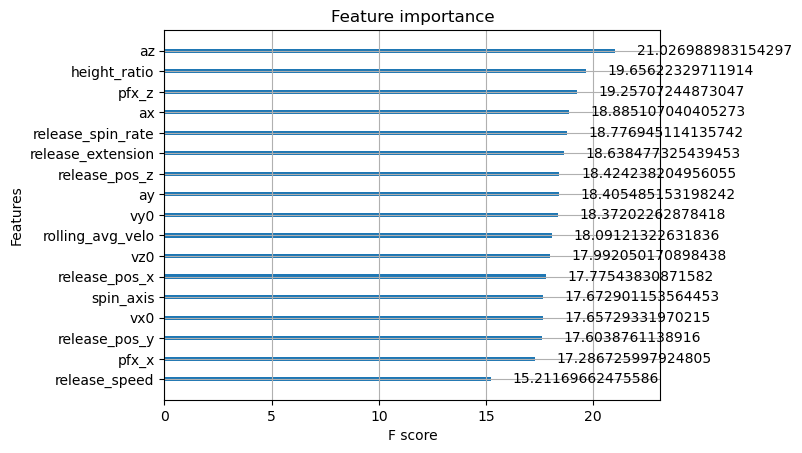

In [19]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

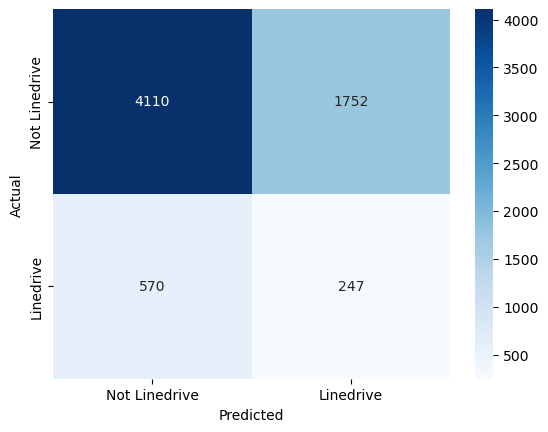

In [20]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [21]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'swing', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [22]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [23]:
y_pred = final_model.predict(predictions)

In [24]:
testing_identifiers['xld'] = y_pred

In [25]:
testing_identifiers.head()

pitch_id_raw       xld
32   661032_608070_623474_4_62_9  0.271145
40   661032_680911_628452_4_64_9  0.492192
157  661032_640458_663776_2_49_7  0.361250
158  661032_676391_663776_2_33_5  0.510811
159  661032_642708_663776_2_19_3  0.493091

In [26]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/ld_2022&3_xld.csv")